##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task) [Transformer](https://developers.google.com/machine-learning/glossary#Transformer) model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762) by Vaswani et al. (2017).

Transformers are deep neural networks that replace CNNs and RNNs with [self-attention](https://developers.google.com/machine-learning/glossary#self-attention). Self attention allows Transformers to easily transmit information across the input sequences.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html):

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).


That's a lot to digest, the goal of this tutorial is to break it down into easy to understand parts. In this tutorial you will:

- Prepare the data.
- Implement necessary components:
  - Positional embeddings.
  - Attention layers.
  - The encoder and decoder.
- Build & train the Transformer.
- Generate translations.
- Export the model.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and attention mechanisms. 

A Transformer is a sequence-to-sequence encoder-decoder model similar to the model in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).
A single-layer Transformer takes a little more code to write, but is almost identical to that encoder-decoder RNN model. The only difference is that the RNN layers are replaced with self attention layers.
This tutorial builds a 4-layer Transformer which is larger and more powerful, but not fundamentally more complex.

<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), Transformers are parallelizable. This makes them efficient on hardware like GPUs and TPUs. The main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be computed in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215)) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099)), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [2]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


Import the necessary modules:

In [3]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

2022-12-14 12:27:52.767776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:27:52.767881: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 12:27:52.767891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Data handling

This section downloads the dataset and the subword tokenizer, from [this tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer), then wraps it all up in a `tf.data.Dataset` for training.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">Toggle section</button>


### Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en)D Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

This tutorial uses a popular [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) implementation, which builds subword tokenizers (`text.BertTokenizer`) optimized for the dataset and exports them in a TensorFlow `saved_model` format.

Download, extract, and import the `saved_model`:

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)


  8192/184801 [>.............................] - ETA: 0s


184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [9]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [11]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [12]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [13]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.pt.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

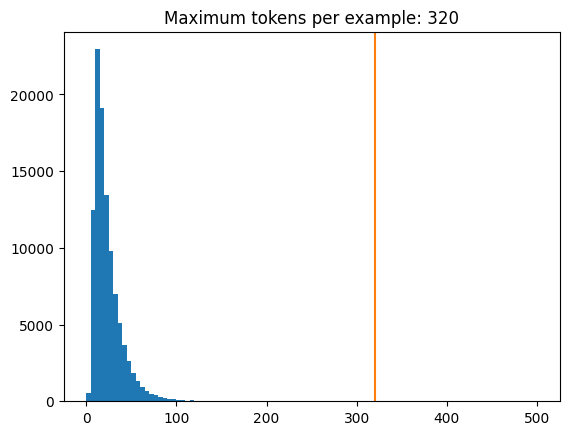

In [14]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training. 

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [15]:
MAX_TOKENS=128
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)      # Output is ragged.
    pt = pt[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    pt = pt.to_tensor()  # Convert to 0-padded dense Tensor

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()  # Drop the [END] tokens
    en_labels = en[:, 1:].to_tensor()   # Drop the [START] tokens

    return (pt, en_inputs), en_labels

The function below converts a dataset of text examples into data of batches for training. 

1. It tokenizes the text, and filters out the sequences that are too long.
   (The `batch`/`unbatch` is included because the tokenizer is much more efficient on large batches).
2. The `cache` method ensures that that work is only executed once.
3. Then `shuffle` and, `dense_to_ragged_batch` randomize the order and assemble batches of examples. 
4. Finally `prefetch` runs the dataset in parallel with the model to ensure that data is available when needed. See [Better performance with the `tf.data`](https://www.tensorflow.org/guide/data_performance.ipynb) for details.

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [17]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

 </section>

## Test the Dataset 

In [18]:
# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

The resulting `tf.data.Dataset` objects are setup for training with Keras.
Keras `Model.fit` training expects `(inputs, labels)` pairs.
The `inputs` are pairs of tokenized Portuguese and English sequences, `(pt, en)`.
The `labels` are the same English sequences shifted by 1.
This shift is so that at each location input `en` sequence, the `label` in the next token.


<table>
<tr>
  <th>Inputs at the bottom, labels at the top.</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

This is the same as the [text generation tutorial](text_generation.ipynb),
except here you have additional input "context" (the Portuguese sequence) that the model is "conditioned" on.

This setup is called "teacher forcing" because regardless of the model's output at each timestep, it gets the true value as input for the next timestep.
This is a simple and efficient way to train a text generation model.
It's efficient because you don't need to run the model sequentially, the outputs at the different sequence locations can be computed in parallel.

You might have expected the `input, output`, pairs to simply be the `Protugese, English` sequences.
Given the Portuguese sequence, the model would try to generate the English sequence.

It's possible to train a model that way. You'd need to write out the inference loop and pass the model's output back to the input.
It's slower (time steps can't run in parallel), and a harder task to learn (the model can't get the end of a sentence right until it gets the beginning right),
but it can give a more stable model because the model has to learn to correct its own errors during training.

In [19]:
for (pt, en), en_labels in train_batches.take(1):
  break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 66)
(64, 91)
(64, 91)


The `en` and `en_labels` are the same, just shifted by 1:

In [20]:
print(en[0][:10])
print(en_labels[0][:10])

tf.Tensor([   2   72  390   80   71  261   74   71 1921   75], shape=(10,), dtype=int64)
tf.Tensor([  72  390   80   71  261   74   71 1921   75   45], shape=(10,), dtype=int64)


## Define the components

There's a lot going on inside a Transformer. The important things to remember are:

1. It follows the same general pattern as a standard sequence-to-sequence model with an encoder and a decoder.
2. If you work through it step by step it will all make sense.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

Each of the components in these two diagrams will be explained as you progress through the tutorial.

### The embedding and positional encoding layer

The inputs to both the encoder and decoder use the same embedding and positional encoding logic. 

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

Given a sequence of tokens, both the input tokens (Portuguese) and target tokens (English) have to be converted to vectors using a `tf.keras.layers.Embedding` layer.

The attention layers used throughout the model see their input as a set of vectors, with no order. Since the model doesn't contain any recurrent or convolutional layers. It needs some way to identify word order, otherwise it would see the input sequence as a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words) instance, `how are you`, `how you are`, `you how are`, and so on, are indistinguishable.

A Transformer adds a "Positional Encoding" to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition nearby elements will have similar position encodings.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

(2048, 512)


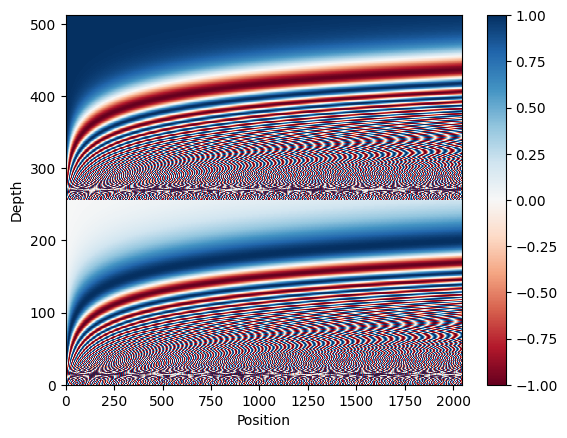

In [22]:
#@title
pos_encoding = positional_encoding(length=2048, depth=512)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

By definition these vectors align well with nearby vectors along the position axis. Below the position encoding vectors are normalized and the vector from position `1000` is compared, by dot-product, to all the others:

(0.0, 1.0)

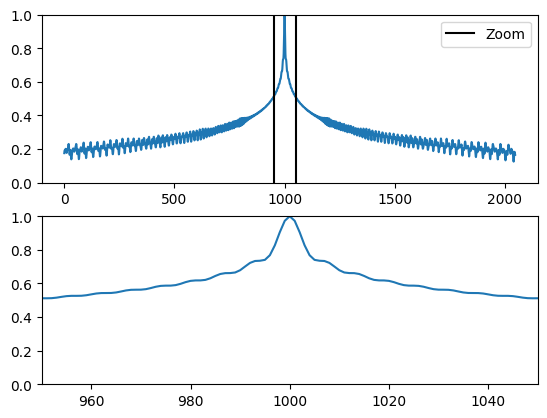

In [23]:
#@title
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])


So use this to create a `PositionEmbedding` layer that looks-up a token's embedding vector and adds the position vector:

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x


In [25]:
embed_pt = PositionalEmbedding(vocab_size=tokenizers.pt.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [26]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 91), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

These "Add & Norm" blocks are scattered throughout the model. Each one joins a residual connection and runs the result through a `LayerNormalization` layer.

The easiest way to organize the code is around these residual blocks. The following sections will define custom layer classes for each. 

The residual "Add & Norm" blocks are included so that training is efficient. The residual connection provides a direct path for the gradient (and ensures that vectors are **updated** by the attention layers instead of **replaced**), while the normalization maintains a reasonable scale for the outputs.

Note: The implementations, below, use the `Add` layer to ensure that Keras masks are propagated (the `+` operator does not).



### The base attention layer

Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a `layers.MultiHeadAttention`, a `layers.LayerNormalization` and a `layers.Add`. 

<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [27]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### Attention refresher

Before you get into the specifics of each usage, here is a quick refresher on how attention works:

<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>

There are two inputs:

1. The query sequence; the sequence being processed; the sequence doing the attending (bottom).
2. The context sequence; the sequence being attended to (left).

The output has the same shape as the query-sequence.

The common comparison is that this operation is like a dictionary lookup.
A **fuzzy**, **differentiable**, **vectorized** dictionary lookup.

Here's a regular python dictionary, with 3 keys and 3 values being passed a single query.

```
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- The `query`s is what you're trying to find.
- The `key`s what sort of information the dictionary has.
- The `value` is that information.

When you look up a `query` in a regular dictionary, the dictionary finds the matching `key`, and returns its associated `value`.
The `query` either has a matching `key` or it doesn't.
You can imagine a **fuzzy** dictionary where the keys don't have to match perfectly.
If you looked up `d["species"]` in the dictionary above, maybe you'd want it to return `"pickup"` since that's the best match for the query.

An attention layer does a fuzzy lookup like this, but it's not just looking for the best key.
It combines the `values` based on how well the `query` matches each `key`.

How does that work? In an attention layer the `query`, `key`, and `value` are each vectors.
Instead of doing a hash lookup the attention layer combines the `query` and `key` vectors to determine how well they match, the "attention score".
The layer returns the average across all the `values`, weighted by the "attention scores".

Each location the query-sequence provides a `query` vector.
The context sequence acts as the dictionary. At each location in the context sequence provides a `key` and `value` vector.
The input vectors are not used directly, the `layers.MultiHeadAttention` layer includes `layers.Dense` layers to project the input vectors before using them.


### The cross attention layer

At the literal center of the Transformer is the cross-attention layer. This layer connects the encoder and decoder. This layer is the most straight-forward use of attention in the model, it performs the same task as the attention block in the [NMT with attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>

To implement this you pass the target sequence `x` as the `query` and the `context` sequence as the `key/value` when calling the `mha` layer:

In [28]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

The caricature below shows how information flows through this layer. The columns represent the weighted sum over the context sequence.

For simplicity the residual connections are not shown.

<table>
<tr>
  <th>The cross attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
</table>

The output length is the length of the `query` sequence, but not on the length of the context `key/value` sequence.

The diagram is farther simplified, below. There's no need to draw the entire "Attention weights" matrix.
The point is that each `query` location can see all the `key/value` pairs in the context, but no information is exchanged between the queries.

<table>
<tr>
  <th>Each query sees the whole context.</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>

Test run it on sample inputs:

In [29]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 66, 512)
(64, 91, 512)


(64, 91, 512)


### The global self attention layer

This layer is responsible for processing the context sequence, and propagating information along its length:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>

Since the context sequence is fixed while the translation is being generated, information is allowed to flow in both directions. 

Before Transformers and self attention, models commonly used RNNs or CNNs to do this task:

<table>
<tr>
  <th colspan=1>Bidirectional RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>

RNNs and CNNs have their limitations.

- The RNN allows information to flow all the way across the sequence, but it passes through many processing steps to get there (limiting gradient flow). These RNN steps have to be run sequentially and so the RNN is less able to take advantage of modern parallel devices.
- In the CNN each location can be processed in parallel, but it only provides a limited receptive field. The receptive field only grows linearly with the number of CNN layers,  You need to stack a number of Convolution layers to transmit information across the sequence ([Wavenet](https://arxiv.org/abs/1609.03499) reduces this problem by using dilated convolutions).

The global self attention layer on the other hand lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. 

To implement this layer you just need to pass the target sequence, `x`, as both the `query`, and `value` arguments to the `mha` layer: 

In [30]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [31]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 66, 512)
(64, 66, 512)


Sticking with the same style as before you could draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for clarity.

It's more compact, and just as accurate to draw it like this:

<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer

This layer does a similar job as the global self attention layer, for the output sequence:

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention.png"/>
  </td>
</tr>
</table>

This needs to be handled differently from the encoder's global self attention layer.  

Like the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation), and the [NMT with attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention) tutorial, Transformers are an "autoregressive" model: They generate the text one token at a time and feed that output back to the input. To make this _efficient_, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".

A single-direction RNN is causal by definition. To make a causal convolution you just need to pad the input and shift the output so that it aligns correctly (use `layers.Conv1D(padding='causal')`) .

<table>
<tr>
  <th colspan=1>Causal RNNs and CNNs</th>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>

A causal model is efficient in two ways: 

1. In training, it lets you compute loss for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated you only need to calculate its outputs, the outputs for the previous sequence elements can be reused.
  - For an RNN you just need the RNN-state to account for previous computations (pass `return_state=True` to the RNN layer's constructor).
  - For a CNN you would need to follow the approach of [Fast Wavenet](https://arxiv.org/abs/1611.09482)

To build a causal self attention layer, you need to use an appropriate mask when computing the attention scores and summing the attention `value`s.

This is taken care of automatically if you pass `use_causal_mask = True` to the `MultiHeadAttention` layer when you call it:

In [32]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

The causal mask ensures that each location only has access to the locations that come before it: 

<table>
<tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
</tr>
</table>

Again, the residual connections are omitted for simplicity.

The more compact representation of this layer would be:

<table>
</tr>
  <th colspan=1>The causal self attention layer</th>
<tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>
</tr>
</table>

Test out the layer:

In [33]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 91, 512)
(64, 91, 512)


The output for early sequence elements doesn't depend on later elements, so it shouldn't matter if you trim elements before or after applying the layer:

In [34]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Note: When using Keras masks, the output values at invalid locations are not well defined. So the above may not hold for masked regions. 

### The feed forward network

The transformer also includes this point-wise feed-forward network in both the encoder and decoder:

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [35]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x


Test the layer, the output is the same shape as the input:

In [36]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 91, 512)
(64, 91, 512)


### The encoder layer

The encoder contains a stack of `N` encoder layers. Where each `EncoderLayer` contains a `GlobalSelfAttention` and `FeedForward` layer:

<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>

Here is the definition of the `EncoderLayer`:

In [37]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

And a quick test, the output will have the same shape as the input:

In [38]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 66, 512)


(64, 66, 512)


### The encoder

Next build the encoder.

<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [39]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

Test the encoder:

In [40]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 66)
(64, 66, 512)


### The decoder layer

The decoder's stack is slightly more complex, with each `DecoderLayer` containing a `CausalSelfAttention`, a `CrossAttention`, and a `FeedForward` layer:  

<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>

In [41]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

Test the decoder layer:

In [42]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 91, 512)
(64, 66, 512)
(64, 91, 512)


### The decoder

Similar to the `Encoder`, the `Decoder` consists of a `PositionalEmbedding`, and a stack of `DecoderLayer`s:

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>


Define the decoder by extending `tf.keras.layers.Layer`:

In [43]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

Test the decoder:

In [44]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 91)
(64, 66, 512)
(64, 91, 512)


In [45]:
sample_decoder.last_attn_scores.shape  # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 91, 66])

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## The Transformer

You now have `Encoder` and `Decoder`. To complete the `Transformer` model, you need to put them together and add a final linear (`Dense`) layer which converts the resulting vector at each location into output token probabilities. 

The output of the decoder is the input to this final linear layer.

<table>
<tr>
  <th colspan=1>The transformer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
</tr>
</table>

A `Transformer` with one layer in both the `Encoder` and `Decoder` looks almost exactly like the model from the [RNN+attention tutorial](https://www.tensorflow.org/text/tutorials/nmt_with_attention). A multi-layer Transformer has more layers, but is fundamentally doing the same thing.

<table>
<tr>
  <th colspan=1>A 1-layer transformer</th>
  <th colspan=1>A 4-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-compact.png"/>
  </td>
  <td rowspan=3>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The RNN+Attention model</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-compact.png"/>
  </td>
</tr>
</table>

Create the `Transformer` by extending `tf.keras.Model`:

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

### Hyperparameters

To keep this example small and relatively fast, the number of layers (`num_layers`), the dimensionality of the embeddings (`d_model`), and the internal dimensionality of the `FeedForward` layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).


In [47]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [48]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test it:

In [49]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 91)
(64, 66)
(64, 91, 7010)


In [50]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 8, 91, 66)


Print the summary of the model:

In [51]:
transformer.summary()

Model: "transformer"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 encoder_1 (Encoder)         multiple                  3632768   


 decoder_1 (Decoder)         multiple                  5647104   


 dense_38 (Dense)            multiple                  904290    


Total params: 10,184,162


Trainable params: 10,184,162


Non-trainable params: 0


_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

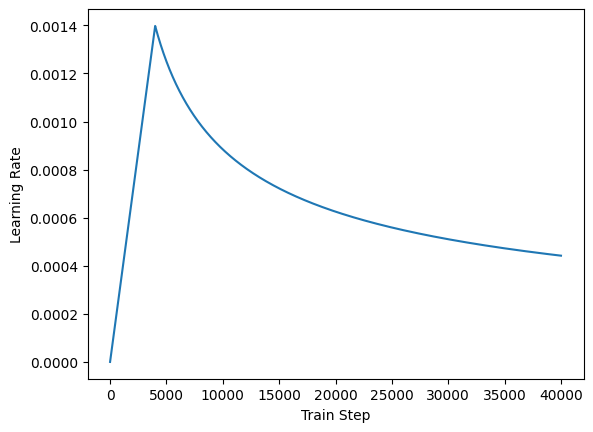

In [54]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Set up the loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [55]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Train the model

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

In [56]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [57]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20



  1/810 [..............................] - ETA: 6:42:29 - loss: 8.8873 - masked_accuracy: 0.0000e+00


  2/810 [..............................] - ETA: 6:08 - loss: 8.8890 - masked_accuracy: 0.0000e+00   


  3/810 [..............................] - ETA: 6:29 - loss: 8.8886 - masked_accuracy: 0.0000e+00


  4/810 [..............................] - ETA: 6:27 - loss: 8.8900 - masked_accuracy: 0.0000e+00


  5/810 [..............................] - ETA: 6:20 - loss: 8.8889 - masked_accuracy: 0.0000e+00


  6/810 [..............................] - ETA: 6:11 - loss: 8.8885 - masked_accuracy: 1.1956e-04


  7/810 [..............................] - ETA: 6:09 - loss: 8.8876 - masked_accuracy: 1.0248e-04


  8/810 [..............................] - ETA: 6:03 - loss: 8.8869 - masked_accuracy: 8.9670e-05


  9/810 [..............................] - ETA: 6:03 - loss: 8.8859 - masked_accuracy: 7.9707e-05


 10/810 [..............................] - ETA: 5:51 - loss: 8.8865 - masked_accuracy: 7.1736e-05


 11/810 [..............................] - ETA: 5:48 - loss: 8.8850 - masked_accuracy: 6.5215e-05


 12/810 [..............................] - ETA: 5:48 - loss: 8.8848 - masked_accuracy: 5.9780e-05


 13/810 [..............................] - ETA: 5:47 - loss: 8.8836 - masked_accuracy: 5.5182e-05


 14/810 [..............................] - ETA: 5:41 - loss: 8.8830 - masked_accuracy: 5.1240e-05


 15/810 [..............................] - ETA: 5:23 - loss: 8.8819 - masked_accuracy: 9.5105e-05


 16/810 [..............................] - ETA: 5:22 - loss: 8.8802 - masked_accuracy: 1.2808e-04


 17/810 [..............................] - ETA: 5:22 - loss: 8.8789 - masked_accuracy: 1.2054e-04


 18/810 [..............................] - ETA: 5:22 - loss: 8.8777 - masked_accuracy: 1.1385e-04


 19/810 [..............................] - ETA: 5:21 - loss: 8.8766 - masked_accuracy: 1.0785e-04


 20/810 [..............................] - ETA: 5:21 - loss: 8.8756 - masked_accuracy: 1.0246e-04


 21/810 [..............................] - ETA: 5:23 - loss: 8.8739 - masked_accuracy: 1.2850e-04


 22/810 [..............................] - ETA: 5:23 - loss: 8.8724 - masked_accuracy: 1.2266e-04


 23/810 [..............................] - ETA: 5:23 - loss: 8.8709 - masked_accuracy: 1.1733e-04


 24/810 [..............................] - ETA: 5:15 - loss: 8.8694 - masked_accuracy: 1.1244e-04


 25/810 [..............................] - ETA: 5:15 - loss: 8.8679 - masked_accuracy: 1.0794e-04


 26/810 [..............................] - ETA: 5:14 - loss: 8.8665 - masked_accuracy: 1.3174e-04


 27/810 [>.............................] - ETA: 5:09 - loss: 8.8645 - masked_accuracy: 1.2686e-04


 28/810 [>.............................] - ETA: 5:10 - loss: 8.8630 - masked_accuracy: 1.2233e-04


 29/810 [>.............................] - ETA: 5:09 - loss: 8.8609 - masked_accuracy: 1.1812e-04


 30/810 [>.............................] - ETA: 5:10 - loss: 8.8589 - masked_accuracy: 1.3905e-04


 31/810 [>.............................] - ETA: 5:06 - loss: 8.8570 - masked_accuracy: 1.3457e-04


 32/810 [>.............................] - ETA: 5:03 - loss: 8.8550 - masked_accuracy: 2.3666e-04


 33/810 [>.............................] - ETA: 4:57 - loss: 8.8529 - masked_accuracy: 2.7509e-04


 34/810 [>.............................] - ETA: 4:59 - loss: 8.8509 - masked_accuracy: 3.7890e-04


 35/810 [>.............................] - ETA: 4:54 - loss: 8.8487 - masked_accuracy: 5.2780e-04


 36/810 [>.............................] - ETA: 4:54 - loss: 8.8465 - masked_accuracy: 7.6665e-04


 37/810 [>.............................] - ETA: 4:55 - loss: 8.8441 - masked_accuracy: 0.0012    


 38/810 [>.............................] - ETA: 4:55 - loss: 8.8416 - masked_accuracy: 0.0017


 39/810 [>.............................] - ETA: 4:50 - loss: 8.8390 - masked_accuracy: 0.0021


 40/810 [>.............................] - ETA: 4:51 - loss: 8.8370 - masked_accuracy: 0.0025


 41/810 [>.............................] - ETA: 4:52 - loss: 8.8344 - masked_accuracy: 0.0029


 42/810 [>.............................] - ETA: 4:53 - loss: 8.8318 - masked_accuracy: 0.0037


 43/810 [>.............................] - ETA: 4:50 - loss: 8.8296 - masked_accuracy: 0.0044


 44/810 [>.............................] - ETA: 4:49 - loss: 8.8270 - masked_accuracy: 0.0053


 45/810 [>.............................] - ETA: 4:46 - loss: 8.8244 - masked_accuracy: 0.0060


 46/810 [>.............................] - ETA: 4:47 - loss: 8.8216 - masked_accuracy: 0.0067


 47/810 [>.............................] - ETA: 4:47 - loss: 8.8193 - masked_accuracy: 0.0075


 48/810 [>.............................] - ETA: 4:45 - loss: 8.8166 - masked_accuracy: 0.0082


 49/810 [>.............................] - ETA: 4:41 - loss: 8.8139 - masked_accuracy: 0.0090


 50/810 [>.............................] - ETA: 4:41 - loss: 8.8111 - masked_accuracy: 0.0097


 51/810 [>.............................] - ETA: 4:37 - loss: 8.8084 - masked_accuracy: 0.0104


 52/810 [>.............................] - ETA: 4:37 - loss: 8.8058 - masked_accuracy: 0.0111


 53/810 [>.............................] - ETA: 4:36 - loss: 8.8032 - masked_accuracy: 0.0118


 54/810 [=>............................] - ETA: 4:36 - loss: 8.8004 - masked_accuracy: 0.0126


 55/810 [=>............................] - ETA: 4:37 - loss: 8.7978 - masked_accuracy: 0.0132


 56/810 [=>............................] - ETA: 4:35 - loss: 8.7952 - masked_accuracy: 0.0139


 57/810 [=>............................] - ETA: 4:35 - loss: 8.7927 - masked_accuracy: 0.0145


 58/810 [=>............................] - ETA: 4:35 - loss: 8.7898 - masked_accuracy: 0.0150


 59/810 [=>............................] - ETA: 4:34 - loss: 8.7872 - masked_accuracy: 0.0156


 60/810 [=>............................] - ETA: 4:32 - loss: 8.7846 - masked_accuracy: 0.0162


 61/810 [=>............................] - ETA: 4:30 - loss: 8.7819 - masked_accuracy: 0.0169


 62/810 [=>............................] - ETA: 4:30 - loss: 8.7796 - masked_accuracy: 0.0173


 63/810 [=>............................] - ETA: 4:29 - loss: 8.7771 - masked_accuracy: 0.0179


 64/810 [=>............................] - ETA: 4:27 - loss: 8.7744 - masked_accuracy: 0.0184


 65/810 [=>............................] - ETA: 4:25 - loss: 8.7722 - masked_accuracy: 0.0190


 66/810 [=>............................] - ETA: 4:24 - loss: 8.7695 - masked_accuracy: 0.0194


 67/810 [=>............................] - ETA: 4:24 - loss: 8.7669 - masked_accuracy: 0.0198


 68/810 [=>............................] - ETA: 4:23 - loss: 8.7643 - masked_accuracy: 0.0204


 69/810 [=>............................] - ETA: 4:22 - loss: 8.7619 - masked_accuracy: 0.0209


 70/810 [=>............................] - ETA: 4:20 - loss: 8.7593 - masked_accuracy: 0.0214


 71/810 [=>............................] - ETA: 4:21 - loss: 8.7565 - masked_accuracy: 0.0218


 72/810 [=>............................] - ETA: 4:20 - loss: 8.7539 - masked_accuracy: 0.0222


 73/810 [=>............................] - ETA: 4:18 - loss: 8.7514 - masked_accuracy: 0.0227


 74/810 [=>............................] - ETA: 4:17 - loss: 8.7491 - masked_accuracy: 0.0230


 75/810 [=>............................] - ETA: 4:17 - loss: 8.7464 - masked_accuracy: 0.0234


 76/810 [=>............................] - ETA: 4:17 - loss: 8.7440 - masked_accuracy: 0.0237


 77/810 [=>............................] - ETA: 4:16 - loss: 8.7416 - masked_accuracy: 0.0241


 78/810 [=>............................] - ETA: 4:14 - loss: 8.7390 - masked_accuracy: 0.0245


 79/810 [=>............................] - ETA: 4:13 - loss: 8.7365 - masked_accuracy: 0.0248


 80/810 [=>............................] - ETA: 4:11 - loss: 8.7340 - masked_accuracy: 0.0252


 81/810 [==>...........................] - ETA: 4:10 - loss: 8.7316 - masked_accuracy: 0.0254


 82/810 [==>...........................] - ETA: 4:09 - loss: 8.7290 - masked_accuracy: 0.0257


 83/810 [==>...........................] - ETA: 4:09 - loss: 8.7265 - masked_accuracy: 0.0259


 84/810 [==>...........................] - ETA: 4:10 - loss: 8.7238 - masked_accuracy: 0.0261


 85/810 [==>...........................] - ETA: 4:10 - loss: 8.7212 - masked_accuracy: 0.0264


 86/810 [==>...........................] - ETA: 4:08 - loss: 8.7186 - masked_accuracy: 0.0267


 87/810 [==>...........................] - ETA: 4:08 - loss: 8.7161 - masked_accuracy: 0.0269


 88/810 [==>...........................] - ETA: 4:07 - loss: 8.7136 - masked_accuracy: 0.0271


 89/810 [==>...........................] - ETA: 4:06 - loss: 8.7111 - masked_accuracy: 0.0273


 90/810 [==>...........................] - ETA: 4:05 - loss: 8.7090 - masked_accuracy: 0.0276


 91/810 [==>...........................] - ETA: 4:04 - loss: 8.7069 - masked_accuracy: 0.0279


 92/810 [==>...........................] - ETA: 4:03 - loss: 8.7045 - masked_accuracy: 0.0282


 93/810 [==>...........................] - ETA: 4:02 - loss: 8.7022 - masked_accuracy: 0.0284


 94/810 [==>...........................] - ETA: 4:02 - loss: 8.7001 - masked_accuracy: 0.0286


 95/810 [==>...........................] - ETA: 4:03 - loss: 8.6979 - masked_accuracy: 0.0289


 96/810 [==>...........................] - ETA: 4:03 - loss: 8.6956 - masked_accuracy: 0.0292


 97/810 [==>...........................] - ETA: 4:03 - loss: 8.6934 - masked_accuracy: 0.0294


 98/810 [==>...........................] - ETA: 4:03 - loss: 8.6912 - masked_accuracy: 0.0297


 99/810 [==>...........................] - ETA: 4:02 - loss: 8.6889 - masked_accuracy: 0.0299


100/810 [==>...........................] - ETA: 4:01 - loss: 8.6866 - masked_accuracy: 0.0301


101/810 [==>...........................] - ETA: 4:00 - loss: 8.6842 - masked_accuracy: 0.0304


102/810 [==>...........................] - ETA: 3:58 - loss: 8.6820 - masked_accuracy: 0.0306


103/810 [==>...........................] - ETA: 3:57 - loss: 8.6795 - masked_accuracy: 0.0308


104/810 [==>...........................] - ETA: 3:56 - loss: 8.6770 - masked_accuracy: 0.0310


105/810 [==>...........................] - ETA: 3:55 - loss: 8.6745 - masked_accuracy: 0.0312


106/810 [==>...........................] - ETA: 3:54 - loss: 8.6721 - masked_accuracy: 0.0314


107/810 [==>...........................] - ETA: 3:53 - loss: 8.6699 - masked_accuracy: 0.0316


108/810 [===>..........................] - ETA: 3:53 - loss: 8.6676 - masked_accuracy: 0.0318


109/810 [===>..........................] - ETA: 3:52 - loss: 8.6654 - masked_accuracy: 0.0320


110/810 [===>..........................] - ETA: 3:53 - loss: 8.6632 - masked_accuracy: 0.0323


111/810 [===>..........................] - ETA: 3:53 - loss: 8.6607 - masked_accuracy: 0.0325


112/810 [===>..........................] - ETA: 3:53 - loss: 8.6582 - masked_accuracy: 0.0327


113/810 [===>..........................] - ETA: 3:53 - loss: 8.6560 - masked_accuracy: 0.0330


114/810 [===>..........................] - ETA: 3:52 - loss: 8.6535 - masked_accuracy: 0.0333


115/810 [===>..........................] - ETA: 3:52 - loss: 8.6510 - masked_accuracy: 0.0335


116/810 [===>..........................] - ETA: 3:51 - loss: 8.6485 - masked_accuracy: 0.0337


117/810 [===>..........................] - ETA: 3:51 - loss: 8.6462 - masked_accuracy: 0.0339


118/810 [===>..........................] - ETA: 3:50 - loss: 8.6438 - masked_accuracy: 0.0340


119/810 [===>..........................] - ETA: 3:49 - loss: 8.6412 - masked_accuracy: 0.0343


120/810 [===>..........................] - ETA: 3:48 - loss: 8.6387 - masked_accuracy: 0.0345


121/810 [===>..........................] - ETA: 3:47 - loss: 8.6365 - masked_accuracy: 0.0347


122/810 [===>..........................] - ETA: 3:47 - loss: 8.6339 - masked_accuracy: 0.0349


123/810 [===>..........................] - ETA: 3:47 - loss: 8.6313 - masked_accuracy: 0.0351


124/810 [===>..........................] - ETA: 3:46 - loss: 8.6287 - masked_accuracy: 0.0353


125/810 [===>..........................] - ETA: 3:45 - loss: 8.6260 - masked_accuracy: 0.0356


126/810 [===>..........................] - ETA: 3:45 - loss: 8.6234 - masked_accuracy: 0.0358


127/810 [===>..........................] - ETA: 3:43 - loss: 8.6208 - masked_accuracy: 0.0360


128/810 [===>..........................] - ETA: 3:42 - loss: 8.6183 - masked_accuracy: 0.0363


129/810 [===>..........................] - ETA: 3:42 - loss: 8.6157 - masked_accuracy: 0.0366


130/810 [===>..........................] - ETA: 3:41 - loss: 8.6131 - masked_accuracy: 0.0368


131/810 [===>..........................] - ETA: 3:41 - loss: 8.6105 - masked_accuracy: 0.0370


132/810 [===>..........................] - ETA: 3:40 - loss: 8.6079 - masked_accuracy: 0.0373


133/810 [===>..........................] - ETA: 3:39 - loss: 8.6054 - masked_accuracy: 0.0375


134/810 [===>..........................] - ETA: 3:38 - loss: 8.6029 - masked_accuracy: 0.0377


135/810 [====>.........................] - ETA: 3:37 - loss: 8.6004 - masked_accuracy: 0.0379


136/810 [====>.........................] - ETA: 3:36 - loss: 8.5977 - masked_accuracy: 0.0380


137/810 [====>.........................] - ETA: 3:36 - loss: 8.5952 - masked_accuracy: 0.0382


138/810 [====>.........................] - ETA: 3:35 - loss: 8.5927 - masked_accuracy: 0.0384


139/810 [====>.........................] - ETA: 3:34 - loss: 8.5903 - masked_accuracy: 0.0386


140/810 [====>.........................] - ETA: 3:33 - loss: 8.5878 - masked_accuracy: 0.0388


141/810 [====>.........................] - ETA: 3:33 - loss: 8.5850 - masked_accuracy: 0.0390


142/810 [====>.........................] - ETA: 3:32 - loss: 8.5826 - masked_accuracy: 0.0391


143/810 [====>.........................] - ETA: 3:31 - loss: 8.5799 - masked_accuracy: 0.0393


144/810 [====>.........................] - ETA: 3:30 - loss: 8.5772 - masked_accuracy: 0.0394


145/810 [====>.........................] - ETA: 3:30 - loss: 8.5744 - masked_accuracy: 0.0395


146/810 [====>.........................] - ETA: 3:29 - loss: 8.5718 - masked_accuracy: 0.0397


147/810 [====>.........................] - ETA: 3:28 - loss: 8.5691 - masked_accuracy: 0.0399


148/810 [====>.........................] - ETA: 3:27 - loss: 8.5664 - masked_accuracy: 0.0401


149/810 [====>.........................] - ETA: 3:26 - loss: 8.5637 - masked_accuracy: 0.0402


150/810 [====>.........................] - ETA: 3:25 - loss: 8.5611 - masked_accuracy: 0.0405


151/810 [====>.........................] - ETA: 3:25 - loss: 8.5582 - masked_accuracy: 0.0406


152/810 [====>.........................] - ETA: 3:25 - loss: 8.5555 - masked_accuracy: 0.0408


153/810 [====>.........................] - ETA: 3:25 - loss: 8.5527 - masked_accuracy: 0.0409


154/810 [====>.........................] - ETA: 3:24 - loss: 8.5499 - masked_accuracy: 0.0411


155/810 [====>.........................] - ETA: 3:23 - loss: 8.5475 - masked_accuracy: 0.0412


156/810 [====>.........................] - ETA: 3:23 - loss: 8.5445 - masked_accuracy: 0.0415


157/810 [====>.........................] - ETA: 3:24 - loss: 8.5415 - masked_accuracy: 0.0416


158/810 [====>.........................] - ETA: 3:23 - loss: 8.5388 - masked_accuracy: 0.0417


159/810 [====>.........................] - ETA: 3:22 - loss: 8.5359 - masked_accuracy: 0.0419


160/810 [====>.........................] - ETA: 3:22 - loss: 8.5331 - masked_accuracy: 0.0420


161/810 [====>.........................] - ETA: 3:21 - loss: 8.5303 - masked_accuracy: 0.0421


162/810 [=====>........................] - ETA: 3:20 - loss: 8.5275 - masked_accuracy: 0.0423


163/810 [=====>........................] - ETA: 3:19 - loss: 8.5246 - masked_accuracy: 0.0424


164/810 [=====>........................] - ETA: 3:19 - loss: 8.5217 - masked_accuracy: 0.0426


165/810 [=====>........................] - ETA: 3:18 - loss: 8.5189 - masked_accuracy: 0.0427


166/810 [=====>........................] - ETA: 3:18 - loss: 8.5159 - masked_accuracy: 0.0428


167/810 [=====>........................] - ETA: 3:17 - loss: 8.5128 - masked_accuracy: 0.0429


168/810 [=====>........................] - ETA: 3:17 - loss: 8.5098 - masked_accuracy: 0.0430


169/810 [=====>........................] - ETA: 3:15 - loss: 8.5068 - masked_accuracy: 0.0432


170/810 [=====>........................] - ETA: 3:15 - loss: 8.5039 - masked_accuracy: 0.0433


171/810 [=====>........................] - ETA: 3:14 - loss: 8.5010 - masked_accuracy: 0.0435


172/810 [=====>........................] - ETA: 3:13 - loss: 8.4982 - masked_accuracy: 0.0436


173/810 [=====>........................] - ETA: 3:14 - loss: 8.4952 - masked_accuracy: 0.0437


174/810 [=====>........................] - ETA: 3:14 - loss: 8.4921 - masked_accuracy: 0.0438


175/810 [=====>........................] - ETA: 3:13 - loss: 8.4891 - masked_accuracy: 0.0440


176/810 [=====>........................] - ETA: 3:13 - loss: 8.4861 - masked_accuracy: 0.0441


177/810 [=====>........................] - ETA: 3:12 - loss: 8.4832 - masked_accuracy: 0.0443


178/810 [=====>........................] - ETA: 3:11 - loss: 8.4802 - masked_accuracy: 0.0444


179/810 [=====>........................] - ETA: 3:11 - loss: 8.4772 - masked_accuracy: 0.0445


180/810 [=====>........................] - ETA: 3:11 - loss: 8.4742 - masked_accuracy: 0.0447


181/810 [=====>........................] - ETA: 3:10 - loss: 8.4712 - masked_accuracy: 0.0448


182/810 [=====>........................] - ETA: 3:10 - loss: 8.4682 - masked_accuracy: 0.0450


183/810 [=====>........................] - ETA: 3:09 - loss: 8.4653 - masked_accuracy: 0.0451


184/810 [=====>........................] - ETA: 3:08 - loss: 8.4622 - masked_accuracy: 0.0453


185/810 [=====>........................] - ETA: 3:07 - loss: 8.4590 - masked_accuracy: 0.0455


186/810 [=====>........................] - ETA: 3:06 - loss: 8.4560 - masked_accuracy: 0.0457


187/810 [=====>........................] - ETA: 3:06 - loss: 8.4529 - masked_accuracy: 0.0459


188/810 [=====>........................] - ETA: 3:05 - loss: 8.4497 - masked_accuracy: 0.0461


189/810 [======>.......................] - ETA: 3:05 - loss: 8.4466 - masked_accuracy: 0.0462


190/810 [======>.......................] - ETA: 3:05 - loss: 8.4434 - masked_accuracy: 0.0464


191/810 [======>.......................] - ETA: 3:04 - loss: 8.4405 - masked_accuracy: 0.0465


192/810 [======>.......................] - ETA: 3:04 - loss: 8.4373 - masked_accuracy: 0.0467


193/810 [======>.......................] - ETA: 3:03 - loss: 8.4341 - masked_accuracy: 0.0468


194/810 [======>.......................] - ETA: 3:03 - loss: 8.4309 - masked_accuracy: 0.0470


195/810 [======>.......................] - ETA: 3:02 - loss: 8.4277 - masked_accuracy: 0.0471


196/810 [======>.......................] - ETA: 3:02 - loss: 8.4244 - masked_accuracy: 0.0473


197/810 [======>.......................] - ETA: 3:01 - loss: 8.4213 - masked_accuracy: 0.0476


198/810 [======>.......................] - ETA: 3:01 - loss: 8.4182 - masked_accuracy: 0.0478


199/810 [======>.......................] - ETA: 3:00 - loss: 8.4149 - masked_accuracy: 0.0480


200/810 [======>.......................] - ETA: 2:59 - loss: 8.4116 - masked_accuracy: 0.0482


201/810 [======>.......................] - ETA: 3:00 - loss: 8.4084 - masked_accuracy: 0.0483


202/810 [======>.......................] - ETA: 3:00 - loss: 8.4053 - masked_accuracy: 0.0485


203/810 [======>.......................] - ETA: 2:59 - loss: 8.4020 - masked_accuracy: 0.0488


204/810 [======>.......................] - ETA: 2:58 - loss: 8.3988 - masked_accuracy: 0.0490


205/810 [======>.......................] - ETA: 2:57 - loss: 8.3954 - masked_accuracy: 0.0492


206/810 [======>.......................] - ETA: 2:57 - loss: 8.3923 - masked_accuracy: 0.0494


207/810 [======>.......................] - ETA: 2:56 - loss: 8.3889 - masked_accuracy: 0.0496


208/810 [======>.......................] - ETA: 2:55 - loss: 8.3856 - masked_accuracy: 0.0498


209/810 [======>.......................] - ETA: 2:54 - loss: 8.3822 - masked_accuracy: 0.0500


210/810 [======>.......................] - ETA: 2:54 - loss: 8.3789 - masked_accuracy: 0.0503


211/810 [======>.......................] - ETA: 2:53 - loss: 8.3756 - masked_accuracy: 0.0505


212/810 [======>.......................] - ETA: 2:53 - loss: 8.3724 - masked_accuracy: 0.0507


213/810 [======>.......................] - ETA: 2:52 - loss: 8.3687 - masked_accuracy: 0.0509


214/810 [======>.......................] - ETA: 2:52 - loss: 8.3653 - masked_accuracy: 0.0512


215/810 [======>.......................] - ETA: 2:51 - loss: 8.3619 - masked_accuracy: 0.0515


216/810 [=======>......................] - ETA: 2:50 - loss: 8.3583 - masked_accuracy: 0.0516


217/810 [=======>......................] - ETA: 2:50 - loss: 8.3547 - masked_accuracy: 0.0519


218/810 [=======>......................] - ETA: 2:50 - loss: 8.3515 - masked_accuracy: 0.0522


219/810 [=======>......................] - ETA: 2:49 - loss: 8.3479 - masked_accuracy: 0.0525


220/810 [=======>......................] - ETA: 2:48 - loss: 8.3445 - masked_accuracy: 0.0527


221/810 [=======>......................] - ETA: 2:48 - loss: 8.3410 - masked_accuracy: 0.0529


222/810 [=======>......................] - ETA: 2:48 - loss: 8.3374 - masked_accuracy: 0.0531


223/810 [=======>......................] - ETA: 2:47 - loss: 8.3340 - masked_accuracy: 0.0534


224/810 [=======>......................] - ETA: 2:47 - loss: 8.3303 - masked_accuracy: 0.0536


225/810 [=======>......................] - ETA: 2:47 - loss: 8.3268 - masked_accuracy: 0.0538


226/810 [=======>......................] - ETA: 2:46 - loss: 8.3232 - masked_accuracy: 0.0541


227/810 [=======>......................] - ETA: 2:46 - loss: 8.3196 - masked_accuracy: 0.0543


228/810 [=======>......................] - ETA: 2:45 - loss: 8.3159 - masked_accuracy: 0.0546


229/810 [=======>......................] - ETA: 2:45 - loss: 8.3123 - masked_accuracy: 0.0548


230/810 [=======>......................] - ETA: 2:44 - loss: 8.3088 - masked_accuracy: 0.0550


231/810 [=======>......................] - ETA: 2:44 - loss: 8.3050 - masked_accuracy: 0.0552


232/810 [=======>......................] - ETA: 2:43 - loss: 8.3014 - masked_accuracy: 0.0555


233/810 [=======>......................] - ETA: 2:43 - loss: 8.2974 - masked_accuracy: 0.0557


234/810 [=======>......................] - ETA: 2:43 - loss: 8.2937 - masked_accuracy: 0.0559


235/810 [=======>......................] - ETA: 2:42 - loss: 8.2898 - masked_accuracy: 0.0562


236/810 [=======>......................] - ETA: 2:42 - loss: 8.2862 - masked_accuracy: 0.0564


237/810 [=======>......................] - ETA: 2:41 - loss: 8.2826 - masked_accuracy: 0.0567


238/810 [=======>......................] - ETA: 2:41 - loss: 8.2787 - masked_accuracy: 0.0570


239/810 [=======>......................] - ETA: 2:40 - loss: 8.2752 - masked_accuracy: 0.0572


240/810 [=======>......................] - ETA: 2:40 - loss: 8.2715 - masked_accuracy: 0.0574


241/810 [=======>......................] - ETA: 2:39 - loss: 8.2678 - masked_accuracy: 0.0577


242/810 [=======>......................] - ETA: 2:39 - loss: 8.2645 - masked_accuracy: 0.0579


243/810 [========>.....................] - ETA: 2:39 - loss: 8.2609 - masked_accuracy: 0.0581


244/810 [========>.....................] - ETA: 2:38 - loss: 8.2573 - masked_accuracy: 0.0583


245/810 [========>.....................] - ETA: 2:38 - loss: 8.2535 - masked_accuracy: 0.0585


246/810 [========>.....................] - ETA: 2:38 - loss: 8.2496 - masked_accuracy: 0.0587


247/810 [========>.....................] - ETA: 2:37 - loss: 8.2458 - masked_accuracy: 0.0589


248/810 [========>.....................] - ETA: 2:37 - loss: 8.2419 - masked_accuracy: 0.0591


249/810 [========>.....................] - ETA: 2:36 - loss: 8.2380 - masked_accuracy: 0.0593


250/810 [========>.....................] - ETA: 2:36 - loss: 8.2342 - masked_accuracy: 0.0595


251/810 [========>.....................] - ETA: 2:36 - loss: 8.2305 - masked_accuracy: 0.0597


252/810 [========>.....................] - ETA: 2:36 - loss: 8.2267 - masked_accuracy: 0.0598


253/810 [========>.....................] - ETA: 2:35 - loss: 8.2229 - masked_accuracy: 0.0600


254/810 [========>.....................] - ETA: 2:34 - loss: 8.2189 - masked_accuracy: 0.0602


255/810 [========>.....................] - ETA: 2:34 - loss: 8.2152 - masked_accuracy: 0.0604


256/810 [========>.....................] - ETA: 2:33 - loss: 8.2114 - masked_accuracy: 0.0606


257/810 [========>.....................] - ETA: 2:33 - loss: 8.2075 - masked_accuracy: 0.0609


258/810 [========>.....................] - ETA: 2:33 - loss: 8.2038 - masked_accuracy: 0.0610


259/810 [========>.....................] - ETA: 2:32 - loss: 8.2001 - masked_accuracy: 0.0612


260/810 [========>.....................] - ETA: 2:32 - loss: 8.1962 - masked_accuracy: 0.0614


261/810 [========>.....................] - ETA: 2:32 - loss: 8.1925 - masked_accuracy: 0.0616


262/810 [========>.....................] - ETA: 2:32 - loss: 8.1886 - masked_accuracy: 0.0618


263/810 [========>.....................] - ETA: 2:31 - loss: 8.1847 - masked_accuracy: 0.0620


264/810 [========>.....................] - ETA: 2:31 - loss: 8.1812 - masked_accuracy: 0.0621


265/810 [========>.....................] - ETA: 2:30 - loss: 8.1773 - masked_accuracy: 0.0623


266/810 [========>.....................] - ETA: 2:30 - loss: 8.1736 - masked_accuracy: 0.0625


267/810 [========>.....................] - ETA: 2:29 - loss: 8.1699 - masked_accuracy: 0.0627


268/810 [========>.....................] - ETA: 2:29 - loss: 8.1662 - masked_accuracy: 0.0629


269/810 [========>.....................] - ETA: 2:29 - loss: 8.1622 - masked_accuracy: 0.0630


270/810 [=========>....................] - ETA: 2:28 - loss: 8.1582 - masked_accuracy: 0.0632


271/810 [=========>....................] - ETA: 2:28 - loss: 8.1542 - masked_accuracy: 0.0633


272/810 [=========>....................] - ETA: 2:28 - loss: 8.1503 - masked_accuracy: 0.0635


273/810 [=========>....................] - ETA: 2:27 - loss: 8.1463 - masked_accuracy: 0.0637


274/810 [=========>....................] - ETA: 2:26 - loss: 8.1421 - masked_accuracy: 0.0639


275/810 [=========>....................] - ETA: 2:26 - loss: 8.1383 - masked_accuracy: 0.0641


276/810 [=========>....................] - ETA: 2:26 - loss: 8.1344 - masked_accuracy: 0.0642


277/810 [=========>....................] - ETA: 2:25 - loss: 8.1303 - masked_accuracy: 0.0644


278/810 [=========>....................] - ETA: 2:24 - loss: 8.1263 - masked_accuracy: 0.0645


279/810 [=========>....................] - ETA: 2:24 - loss: 8.1223 - masked_accuracy: 0.0647


280/810 [=========>....................] - ETA: 2:24 - loss: 8.1183 - masked_accuracy: 0.0648


281/810 [=========>....................] - ETA: 2:23 - loss: 8.1144 - masked_accuracy: 0.0649


282/810 [=========>....................] - ETA: 2:23 - loss: 8.1107 - masked_accuracy: 0.0651


283/810 [=========>....................] - ETA: 2:23 - loss: 8.1067 - masked_accuracy: 0.0652


284/810 [=========>....................] - ETA: 2:22 - loss: 8.1025 - masked_accuracy: 0.0654


285/810 [=========>....................] - ETA: 2:22 - loss: 8.0988 - masked_accuracy: 0.0655


286/810 [=========>....................] - ETA: 2:21 - loss: 8.0947 - masked_accuracy: 0.0657


287/810 [=========>....................] - ETA: 2:21 - loss: 8.0907 - masked_accuracy: 0.0658


288/810 [=========>....................] - ETA: 2:21 - loss: 8.0866 - masked_accuracy: 0.0660


289/810 [=========>....................] - ETA: 2:20 - loss: 8.0825 - masked_accuracy: 0.0662


290/810 [=========>....................] - ETA: 2:20 - loss: 8.0787 - masked_accuracy: 0.0663


291/810 [=========>....................] - ETA: 2:20 - loss: 8.0748 - masked_accuracy: 0.0665


292/810 [=========>....................] - ETA: 2:19 - loss: 8.0709 - masked_accuracy: 0.0666


293/810 [=========>....................] - ETA: 2:19 - loss: 8.0669 - masked_accuracy: 0.0668


294/810 [=========>....................] - ETA: 2:18 - loss: 8.0630 - masked_accuracy: 0.0669


295/810 [=========>....................] - ETA: 2:18 - loss: 8.0589 - masked_accuracy: 0.0671


296/810 [=========>....................] - ETA: 2:18 - loss: 8.0551 - masked_accuracy: 0.0673


297/810 [==========>...................] - ETA: 2:18 - loss: 8.0513 - masked_accuracy: 0.0674


298/810 [==========>...................] - ETA: 2:17 - loss: 8.0472 - masked_accuracy: 0.0675


299/810 [==========>...................] - ETA: 2:17 - loss: 8.0430 - masked_accuracy: 0.0677


300/810 [==========>...................] - ETA: 2:16 - loss: 8.0390 - masked_accuracy: 0.0679


301/810 [==========>...................] - ETA: 2:16 - loss: 8.0347 - masked_accuracy: 0.0681


302/810 [==========>...................] - ETA: 2:16 - loss: 8.0307 - masked_accuracy: 0.0682


303/810 [==========>...................] - ETA: 2:15 - loss: 8.0267 - masked_accuracy: 0.0684


304/810 [==========>...................] - ETA: 2:15 - loss: 8.0229 - masked_accuracy: 0.0686


305/810 [==========>...................] - ETA: 2:14 - loss: 8.0188 - masked_accuracy: 0.0687


306/810 [==========>...................] - ETA: 2:14 - loss: 8.0147 - masked_accuracy: 0.0689


307/810 [==========>...................] - ETA: 2:14 - loss: 8.0107 - masked_accuracy: 0.0690


308/810 [==========>...................] - ETA: 2:14 - loss: 8.0063 - masked_accuracy: 0.0691


309/810 [==========>...................] - ETA: 2:13 - loss: 8.0023 - masked_accuracy: 0.0693


310/810 [==========>...................] - ETA: 2:13 - loss: 7.9983 - masked_accuracy: 0.0695


311/810 [==========>...................] - ETA: 2:12 - loss: 7.9946 - masked_accuracy: 0.0696


312/810 [==========>...................] - ETA: 2:12 - loss: 7.9903 - masked_accuracy: 0.0697


313/810 [==========>...................] - ETA: 2:11 - loss: 7.9862 - masked_accuracy: 0.0698


314/810 [==========>...................] - ETA: 2:11 - loss: 7.9825 - masked_accuracy: 0.0700


315/810 [==========>...................] - ETA: 2:11 - loss: 7.9784 - masked_accuracy: 0.0701


316/810 [==========>...................] - ETA: 2:10 - loss: 7.9743 - masked_accuracy: 0.0702


317/810 [==========>...................] - ETA: 2:10 - loss: 7.9703 - masked_accuracy: 0.0704


318/810 [==========>...................] - ETA: 2:10 - loss: 7.9663 - masked_accuracy: 0.0705


319/810 [==========>...................] - ETA: 2:09 - loss: 7.9621 - masked_accuracy: 0.0706


320/810 [==========>...................] - ETA: 2:09 - loss: 7.9580 - masked_accuracy: 0.0708


321/810 [==========>...................] - ETA: 2:09 - loss: 7.9538 - masked_accuracy: 0.0709


322/810 [==========>...................] - ETA: 2:08 - loss: 7.9502 - masked_accuracy: 0.0710


323/810 [==========>...................] - ETA: 2:08 - loss: 7.9458 - masked_accuracy: 0.0712


324/810 [===========>..................] - ETA: 2:08 - loss: 7.9418 - masked_accuracy: 0.0713


325/810 [===========>..................] - ETA: 2:07 - loss: 7.9377 - masked_accuracy: 0.0715


326/810 [===========>..................] - ETA: 2:07 - loss: 7.9337 - masked_accuracy: 0.0716


327/810 [===========>..................] - ETA: 2:07 - loss: 7.9298 - masked_accuracy: 0.0717


328/810 [===========>..................] - ETA: 2:06 - loss: 7.9257 - masked_accuracy: 0.0719


329/810 [===========>..................] - ETA: 2:06 - loss: 7.9217 - masked_accuracy: 0.0720


330/810 [===========>..................] - ETA: 2:06 - loss: 7.9175 - masked_accuracy: 0.0721


331/810 [===========>..................] - ETA: 2:05 - loss: 7.9131 - masked_accuracy: 0.0722


332/810 [===========>..................] - ETA: 2:05 - loss: 7.9090 - masked_accuracy: 0.0724


333/810 [===========>..................] - ETA: 2:05 - loss: 7.9049 - masked_accuracy: 0.0726


334/810 [===========>..................] - ETA: 2:04 - loss: 7.9009 - masked_accuracy: 0.0727


335/810 [===========>..................] - ETA: 2:04 - loss: 7.8971 - masked_accuracy: 0.0727


336/810 [===========>..................] - ETA: 2:03 - loss: 7.8932 - masked_accuracy: 0.0729


337/810 [===========>..................] - ETA: 2:03 - loss: 7.8891 - masked_accuracy: 0.0730


338/810 [===========>..................] - ETA: 2:03 - loss: 7.8852 - masked_accuracy: 0.0731


339/810 [===========>..................] - ETA: 2:02 - loss: 7.8812 - masked_accuracy: 0.0733


340/810 [===========>..................] - ETA: 2:02 - loss: 7.8773 - masked_accuracy: 0.0734


341/810 [===========>..................] - ETA: 2:02 - loss: 7.8735 - masked_accuracy: 0.0735


342/810 [===========>..................] - ETA: 2:01 - loss: 7.8695 - masked_accuracy: 0.0737


343/810 [===========>..................] - ETA: 2:01 - loss: 7.8657 - masked_accuracy: 0.0738


344/810 [===========>..................] - ETA: 2:01 - loss: 7.8619 - masked_accuracy: 0.0739


345/810 [===========>..................] - ETA: 2:00 - loss: 7.8581 - masked_accuracy: 0.0740


346/810 [===========>..................] - ETA: 2:00 - loss: 7.8539 - masked_accuracy: 0.0741


347/810 [===========>..................] - ETA: 2:00 - loss: 7.8500 - masked_accuracy: 0.0742


348/810 [===========>..................] - ETA: 1:59 - loss: 7.8462 - masked_accuracy: 0.0743


349/810 [===========>..................] - ETA: 1:59 - loss: 7.8421 - masked_accuracy: 0.0744


350/810 [===========>..................] - ETA: 1:59 - loss: 7.8384 - masked_accuracy: 0.0746


351/810 [============>.................] - ETA: 1:58 - loss: 7.8344 - masked_accuracy: 0.0747


352/810 [============>.................] - ETA: 1:58 - loss: 7.8303 - masked_accuracy: 0.0748


353/810 [============>.................] - ETA: 1:58 - loss: 7.8264 - masked_accuracy: 0.0749


354/810 [============>.................] - ETA: 1:57 - loss: 7.8225 - masked_accuracy: 0.0751


355/810 [============>.................] - ETA: 1:57 - loss: 7.8187 - masked_accuracy: 0.0752


356/810 [============>.................] - ETA: 1:57 - loss: 7.8147 - masked_accuracy: 0.0753


357/810 [============>.................] - ETA: 1:56 - loss: 7.8110 - masked_accuracy: 0.0754


358/810 [============>.................] - ETA: 1:56 - loss: 7.8070 - masked_accuracy: 0.0755


359/810 [============>.................] - ETA: 1:56 - loss: 7.8033 - masked_accuracy: 0.0757


360/810 [============>.................] - ETA: 1:55 - loss: 7.7997 - masked_accuracy: 0.0758


361/810 [============>.................] - ETA: 1:55 - loss: 7.7955 - masked_accuracy: 0.0758


362/810 [============>.................] - ETA: 1:55 - loss: 7.7920 - masked_accuracy: 0.0760


363/810 [============>.................] - ETA: 1:54 - loss: 7.7879 - masked_accuracy: 0.0761


364/810 [============>.................] - ETA: 1:54 - loss: 7.7842 - masked_accuracy: 0.0762


365/810 [============>.................] - ETA: 1:53 - loss: 7.7802 - masked_accuracy: 0.0763


366/810 [============>.................] - ETA: 1:53 - loss: 7.7764 - masked_accuracy: 0.0764


367/810 [============>.................] - ETA: 1:53 - loss: 7.7725 - masked_accuracy: 0.0766


368/810 [============>.................] - ETA: 1:52 - loss: 7.7688 - masked_accuracy: 0.0766


369/810 [============>.................] - ETA: 1:52 - loss: 7.7652 - masked_accuracy: 0.0767


370/810 [============>.................] - ETA: 1:52 - loss: 7.7613 - masked_accuracy: 0.0768


371/810 [============>.................] - ETA: 1:52 - loss: 7.7573 - masked_accuracy: 0.0770


372/810 [============>.................] - ETA: 1:51 - loss: 7.7533 - masked_accuracy: 0.0771


373/810 [============>.................] - ETA: 1:51 - loss: 7.7497 - masked_accuracy: 0.0772


374/810 [============>.................] - ETA: 1:51 - loss: 7.7459 - masked_accuracy: 0.0773


375/810 [============>.................] - ETA: 1:50 - loss: 7.7422 - masked_accuracy: 0.0774


376/810 [============>.................] - ETA: 1:50 - loss: 7.7384 - masked_accuracy: 0.0775


377/810 [============>.................] - ETA: 1:50 - loss: 7.7346 - masked_accuracy: 0.0776


378/810 [=============>................] - ETA: 1:49 - loss: 7.7306 - masked_accuracy: 0.0778


379/810 [=============>................] - ETA: 1:49 - loss: 7.7269 - masked_accuracy: 0.0779


380/810 [=============>................] - ETA: 1:48 - loss: 7.7228 - masked_accuracy: 0.0780


381/810 [=============>................] - ETA: 1:48 - loss: 7.7190 - masked_accuracy: 0.0781


382/810 [=============>................] - ETA: 1:48 - loss: 7.7151 - masked_accuracy: 0.0782


383/810 [=============>................] - ETA: 1:47 - loss: 7.7114 - masked_accuracy: 0.0784


384/810 [=============>................] - ETA: 1:47 - loss: 7.7074 - masked_accuracy: 0.0785


385/810 [=============>................] - ETA: 1:47 - loss: 7.7035 - masked_accuracy: 0.0786


386/810 [=============>................] - ETA: 1:46 - loss: 7.6997 - masked_accuracy: 0.0787


387/810 [=============>................] - ETA: 1:46 - loss: 7.6960 - masked_accuracy: 0.0788


388/810 [=============>................] - ETA: 1:46 - loss: 7.6924 - masked_accuracy: 0.0789


389/810 [=============>................] - ETA: 1:45 - loss: 7.6891 - masked_accuracy: 0.0790


390/810 [=============>................] - ETA: 1:45 - loss: 7.6854 - masked_accuracy: 0.0791


391/810 [=============>................] - ETA: 1:45 - loss: 7.6818 - masked_accuracy: 0.0792


392/810 [=============>................] - ETA: 1:44 - loss: 7.6780 - masked_accuracy: 0.0794


393/810 [=============>................] - ETA: 1:44 - loss: 7.6743 - masked_accuracy: 0.0795


394/810 [=============>................] - ETA: 1:44 - loss: 7.6707 - masked_accuracy: 0.0796


395/810 [=============>................] - ETA: 1:43 - loss: 7.6670 - masked_accuracy: 0.0797


396/810 [=============>................] - ETA: 1:43 - loss: 7.6634 - masked_accuracy: 0.0798


397/810 [=============>................] - ETA: 1:42 - loss: 7.6596 - masked_accuracy: 0.0800


398/810 [=============>................] - ETA: 1:42 - loss: 7.6559 - masked_accuracy: 0.0801


399/810 [=============>................] - ETA: 1:42 - loss: 7.6524 - masked_accuracy: 0.0802


400/810 [=============>................] - ETA: 1:42 - loss: 7.6490 - masked_accuracy: 0.0804


401/810 [=============>................] - ETA: 1:41 - loss: 7.6454 - masked_accuracy: 0.0804


402/810 [=============>................] - ETA: 1:41 - loss: 7.6421 - masked_accuracy: 0.0806


403/810 [=============>................] - ETA: 1:41 - loss: 7.6385 - masked_accuracy: 0.0807


404/810 [=============>................] - ETA: 1:40 - loss: 7.6348 - masked_accuracy: 0.0808


405/810 [==============>...............] - ETA: 1:40 - loss: 7.6313 - masked_accuracy: 0.0809


406/810 [==============>...............] - ETA: 1:40 - loss: 7.6283 - masked_accuracy: 0.0810


407/810 [==============>...............] - ETA: 1:39 - loss: 7.6248 - masked_accuracy: 0.0811


408/810 [==============>...............] - ETA: 1:39 - loss: 7.6216 - masked_accuracy: 0.0812


409/810 [==============>...............] - ETA: 1:39 - loss: 7.6180 - masked_accuracy: 0.0813


410/810 [==============>...............] - ETA: 1:39 - loss: 7.6141 - masked_accuracy: 0.0815


411/810 [==============>...............] - ETA: 1:38 - loss: 7.6108 - masked_accuracy: 0.0816


412/810 [==============>...............] - ETA: 1:38 - loss: 7.6071 - masked_accuracy: 0.0817


413/810 [==============>...............] - ETA: 1:38 - loss: 7.6038 - masked_accuracy: 0.0818


414/810 [==============>...............] - ETA: 1:38 - loss: 7.6004 - masked_accuracy: 0.0819


415/810 [==============>...............] - ETA: 1:37 - loss: 7.5970 - masked_accuracy: 0.0820


416/810 [==============>...............] - ETA: 1:37 - loss: 7.5934 - masked_accuracy: 0.0821


417/810 [==============>...............] - ETA: 1:37 - loss: 7.5900 - masked_accuracy: 0.0823


418/810 [==============>...............] - ETA: 1:36 - loss: 7.5867 - masked_accuracy: 0.0824


419/810 [==============>...............] - ETA: 1:36 - loss: 7.5834 - masked_accuracy: 0.0825


420/810 [==============>...............] - ETA: 1:36 - loss: 7.5798 - masked_accuracy: 0.0826


421/810 [==============>...............] - ETA: 1:36 - loss: 7.5765 - masked_accuracy: 0.0827


422/810 [==============>...............] - ETA: 1:35 - loss: 7.5731 - masked_accuracy: 0.0828


423/810 [==============>...............] - ETA: 1:35 - loss: 7.5693 - masked_accuracy: 0.0830


424/810 [==============>...............] - ETA: 1:35 - loss: 7.5658 - masked_accuracy: 0.0831


425/810 [==============>...............] - ETA: 1:35 - loss: 7.5623 - masked_accuracy: 0.0832


426/810 [==============>...............] - ETA: 1:34 - loss: 7.5591 - masked_accuracy: 0.0833


427/810 [==============>...............] - ETA: 1:34 - loss: 7.5557 - masked_accuracy: 0.0834


428/810 [==============>...............] - ETA: 1:34 - loss: 7.5523 - masked_accuracy: 0.0836


429/810 [==============>...............] - ETA: 1:33 - loss: 7.5492 - masked_accuracy: 0.0837


430/810 [==============>...............] - ETA: 1:33 - loss: 7.5456 - masked_accuracy: 0.0838


431/810 [==============>...............] - ETA: 1:33 - loss: 7.5422 - masked_accuracy: 0.0839


432/810 [===============>..............] - ETA: 1:32 - loss: 7.5386 - masked_accuracy: 0.0841


433/810 [===============>..............] - ETA: 1:32 - loss: 7.5355 - masked_accuracy: 0.0842


434/810 [===============>..............] - ETA: 1:32 - loss: 7.5321 - masked_accuracy: 0.0844


435/810 [===============>..............] - ETA: 1:31 - loss: 7.5291 - masked_accuracy: 0.0845


436/810 [===============>..............] - ETA: 1:31 - loss: 7.5256 - masked_accuracy: 0.0847


437/810 [===============>..............] - ETA: 1:31 - loss: 7.5222 - masked_accuracy: 0.0848


438/810 [===============>..............] - ETA: 1:30 - loss: 7.5191 - masked_accuracy: 0.0850


439/810 [===============>..............] - ETA: 1:30 - loss: 7.5158 - masked_accuracy: 0.0851


440/810 [===============>..............] - ETA: 1:30 - loss: 7.5125 - masked_accuracy: 0.0853


441/810 [===============>..............] - ETA: 1:30 - loss: 7.5090 - masked_accuracy: 0.0854


442/810 [===============>..............] - ETA: 1:29 - loss: 7.5060 - masked_accuracy: 0.0856


443/810 [===============>..............] - ETA: 1:29 - loss: 7.5031 - masked_accuracy: 0.0857


444/810 [===============>..............] - ETA: 1:29 - loss: 7.4999 - masked_accuracy: 0.0858


445/810 [===============>..............] - ETA: 1:29 - loss: 7.4965 - masked_accuracy: 0.0860


446/810 [===============>..............] - ETA: 1:28 - loss: 7.4933 - masked_accuracy: 0.0861


447/810 [===============>..............] - ETA: 1:28 - loss: 7.4899 - masked_accuracy: 0.0862


448/810 [===============>..............] - ETA: 1:28 - loss: 7.4869 - masked_accuracy: 0.0864


449/810 [===============>..............] - ETA: 1:28 - loss: 7.4839 - masked_accuracy: 0.0865


450/810 [===============>..............] - ETA: 1:27 - loss: 7.4806 - masked_accuracy: 0.0867


451/810 [===============>..............] - ETA: 1:27 - loss: 7.4776 - masked_accuracy: 0.0868


452/810 [===============>..............] - ETA: 1:27 - loss: 7.4746 - masked_accuracy: 0.0870


453/810 [===============>..............] - ETA: 1:26 - loss: 7.4716 - masked_accuracy: 0.0871


454/810 [===============>..............] - ETA: 1:26 - loss: 7.4684 - masked_accuracy: 0.0873


455/810 [===============>..............] - ETA: 1:26 - loss: 7.4651 - masked_accuracy: 0.0874


456/810 [===============>..............] - ETA: 1:25 - loss: 7.4620 - masked_accuracy: 0.0876


457/810 [===============>..............] - ETA: 1:25 - loss: 7.4592 - masked_accuracy: 0.0877


458/810 [===============>..............] - ETA: 1:25 - loss: 7.4559 - masked_accuracy: 0.0879


459/810 [================>.............] - ETA: 1:25 - loss: 7.4526 - masked_accuracy: 0.0881


460/810 [================>.............] - ETA: 1:24 - loss: 7.4497 - masked_accuracy: 0.0882


461/810 [================>.............] - ETA: 1:24 - loss: 7.4466 - masked_accuracy: 0.0883


462/810 [================>.............] - ETA: 1:24 - loss: 7.4437 - masked_accuracy: 0.0885


463/810 [================>.............] - ETA: 1:23 - loss: 7.4405 - masked_accuracy: 0.0886


464/810 [================>.............] - ETA: 1:23 - loss: 7.4377 - masked_accuracy: 0.0888


465/810 [================>.............] - ETA: 1:23 - loss: 7.4343 - masked_accuracy: 0.0890


466/810 [================>.............] - ETA: 1:23 - loss: 7.4311 - masked_accuracy: 0.0892


467/810 [================>.............] - ETA: 1:22 - loss: 7.4279 - masked_accuracy: 0.0894


468/810 [================>.............] - ETA: 1:22 - loss: 7.4249 - masked_accuracy: 0.0895


469/810 [================>.............] - ETA: 1:22 - loss: 7.4216 - masked_accuracy: 0.0897


470/810 [================>.............] - ETA: 1:22 - loss: 7.4185 - masked_accuracy: 0.0899


471/810 [================>.............] - ETA: 1:22 - loss: 7.4151 - masked_accuracy: 0.0901


472/810 [================>.............] - ETA: 1:21 - loss: 7.4121 - masked_accuracy: 0.0903


473/810 [================>.............] - ETA: 1:21 - loss: 7.4093 - masked_accuracy: 0.0904


474/810 [================>.............] - ETA: 1:21 - loss: 7.4061 - masked_accuracy: 0.0906


475/810 [================>.............] - ETA: 1:20 - loss: 7.4030 - masked_accuracy: 0.0908


476/810 [================>.............] - ETA: 1:20 - loss: 7.4000 - masked_accuracy: 0.0910


477/810 [================>.............] - ETA: 1:20 - loss: 7.3968 - masked_accuracy: 0.0911


478/810 [================>.............] - ETA: 1:20 - loss: 7.3940 - masked_accuracy: 0.0913


479/810 [================>.............] - ETA: 1:19 - loss: 7.3907 - masked_accuracy: 0.0915


480/810 [================>.............] - ETA: 1:19 - loss: 7.3877 - masked_accuracy: 0.0916


481/810 [================>.............] - ETA: 1:19 - loss: 7.3846 - masked_accuracy: 0.0918


482/810 [================>.............] - ETA: 1:18 - loss: 7.3816 - masked_accuracy: 0.0919


483/810 [================>.............] - ETA: 1:18 - loss: 7.3783 - masked_accuracy: 0.0921


484/810 [================>.............] - ETA: 1:18 - loss: 7.3755 - masked_accuracy: 0.0923


485/810 [================>.............] - ETA: 1:18 - loss: 7.3725 - masked_accuracy: 0.0925


486/810 [=================>............] - ETA: 1:17 - loss: 7.3699 - masked_accuracy: 0.0926


487/810 [=================>............] - ETA: 1:17 - loss: 7.3670 - masked_accuracy: 0.0928


488/810 [=================>............] - ETA: 1:17 - loss: 7.3639 - masked_accuracy: 0.0929


489/810 [=================>............] - ETA: 1:17 - loss: 7.3606 - masked_accuracy: 0.0931


490/810 [=================>............] - ETA: 1:16 - loss: 7.3576 - masked_accuracy: 0.0933


491/810 [=================>............] - ETA: 1:16 - loss: 7.3549 - masked_accuracy: 0.0934


492/810 [=================>............] - ETA: 1:16 - loss: 7.3516 - masked_accuracy: 0.0936


493/810 [=================>............] - ETA: 1:16 - loss: 7.3486 - masked_accuracy: 0.0938


494/810 [=================>............] - ETA: 1:15 - loss: 7.3455 - masked_accuracy: 0.0940


495/810 [=================>............] - ETA: 1:15 - loss: 7.3425 - masked_accuracy: 0.0942


496/810 [=================>............] - ETA: 1:15 - loss: 7.3396 - masked_accuracy: 0.0943


497/810 [=================>............] - ETA: 1:15 - loss: 7.3364 - masked_accuracy: 0.0945


498/810 [=================>............] - ETA: 1:14 - loss: 7.3334 - masked_accuracy: 0.0947


499/810 [=================>............] - ETA: 1:14 - loss: 7.3309 - masked_accuracy: 0.0948


500/810 [=================>............] - ETA: 1:14 - loss: 7.3282 - masked_accuracy: 0.0949


501/810 [=================>............] - ETA: 1:13 - loss: 7.3252 - masked_accuracy: 0.0951


502/810 [=================>............] - ETA: 1:13 - loss: 7.3223 - masked_accuracy: 0.0953


503/810 [=================>............] - ETA: 1:13 - loss: 7.3194 - masked_accuracy: 0.0954


504/810 [=================>............] - ETA: 1:13 - loss: 7.3164 - masked_accuracy: 0.0956


505/810 [=================>............] - ETA: 1:12 - loss: 7.3134 - masked_accuracy: 0.0958


506/810 [=================>............] - ETA: 1:12 - loss: 7.3105 - masked_accuracy: 0.0960


507/810 [=================>............] - ETA: 1:12 - loss: 7.3073 - masked_accuracy: 0.0962


508/810 [=================>............] - ETA: 1:12 - loss: 7.3042 - masked_accuracy: 0.0964


509/810 [=================>............] - ETA: 1:11 - loss: 7.3013 - masked_accuracy: 0.0966


510/810 [=================>............] - ETA: 1:11 - loss: 7.2983 - masked_accuracy: 0.0967


511/810 [=================>............] - ETA: 1:11 - loss: 7.2957 - masked_accuracy: 0.0969


512/810 [=================>............] - ETA: 1:10 - loss: 7.2927 - masked_accuracy: 0.0971


513/810 [==================>...........] - ETA: 1:10 - loss: 7.2901 - masked_accuracy: 0.0972


514/810 [==================>...........] - ETA: 1:10 - loss: 7.2874 - masked_accuracy: 0.0974


515/810 [==================>...........] - ETA: 1:10 - loss: 7.2846 - masked_accuracy: 0.0975


516/810 [==================>...........] - ETA: 1:09 - loss: 7.2817 - masked_accuracy: 0.0977


517/810 [==================>...........] - ETA: 1:09 - loss: 7.2788 - masked_accuracy: 0.0979


518/810 [==================>...........] - ETA: 1:09 - loss: 7.2759 - masked_accuracy: 0.0981


519/810 [==================>...........] - ETA: 1:09 - loss: 7.2731 - masked_accuracy: 0.0982


520/810 [==================>...........] - ETA: 1:08 - loss: 7.2703 - masked_accuracy: 0.0984


521/810 [==================>...........] - ETA: 1:08 - loss: 7.2677 - masked_accuracy: 0.0985


522/810 [==================>...........] - ETA: 1:08 - loss: 7.2648 - masked_accuracy: 0.0987


523/810 [==================>...........] - ETA: 1:07 - loss: 7.2617 - masked_accuracy: 0.0989


524/810 [==================>...........] - ETA: 1:07 - loss: 7.2590 - masked_accuracy: 0.0990


525/810 [==================>...........] - ETA: 1:07 - loss: 7.2563 - masked_accuracy: 0.0992


526/810 [==================>...........] - ETA: 1:07 - loss: 7.2537 - masked_accuracy: 0.0994


527/810 [==================>...........] - ETA: 1:06 - loss: 7.2512 - masked_accuracy: 0.0995


528/810 [==================>...........] - ETA: 1:06 - loss: 7.2484 - masked_accuracy: 0.0997


529/810 [==================>...........] - ETA: 1:06 - loss: 7.2456 - masked_accuracy: 0.0998


530/810 [==================>...........] - ETA: 1:06 - loss: 7.2428 - masked_accuracy: 0.1000


531/810 [==================>...........] - ETA: 1:05 - loss: 7.2399 - masked_accuracy: 0.1002


532/810 [==================>...........] - ETA: 1:05 - loss: 7.2367 - masked_accuracy: 0.1004


533/810 [==================>...........] - ETA: 1:05 - loss: 7.2338 - masked_accuracy: 0.1005


534/810 [==================>...........] - ETA: 1:05 - loss: 7.2313 - masked_accuracy: 0.1007


535/810 [==================>...........] - ETA: 1:05 - loss: 7.2284 - masked_accuracy: 0.1008


536/810 [==================>...........] - ETA: 1:04 - loss: 7.2256 - masked_accuracy: 0.1010


537/810 [==================>...........] - ETA: 1:04 - loss: 7.2231 - masked_accuracy: 0.1011


538/810 [==================>...........] - ETA: 1:04 - loss: 7.2208 - masked_accuracy: 0.1012


539/810 [==================>...........] - ETA: 1:03 - loss: 7.2181 - masked_accuracy: 0.1014


540/810 [===================>..........] - ETA: 1:03 - loss: 7.2149 - masked_accuracy: 0.1016


541/810 [===================>..........] - ETA: 1:03 - loss: 7.2117 - masked_accuracy: 0.1018


542/810 [===================>..........] - ETA: 1:03 - loss: 7.2087 - masked_accuracy: 0.1020


543/810 [===================>..........] - ETA: 1:02 - loss: 7.2061 - masked_accuracy: 0.1021


544/810 [===================>..........] - ETA: 1:02 - loss: 7.2034 - masked_accuracy: 0.1023


545/810 [===================>..........] - ETA: 1:02 - loss: 7.2005 - masked_accuracy: 0.1024


546/810 [===================>..........] - ETA: 1:02 - loss: 7.1976 - masked_accuracy: 0.1026


547/810 [===================>..........] - ETA: 1:01 - loss: 7.1951 - masked_accuracy: 0.1028


548/810 [===================>..........] - ETA: 1:01 - loss: 7.1925 - masked_accuracy: 0.1029


549/810 [===================>..........] - ETA: 1:01 - loss: 7.1896 - masked_accuracy: 0.1031


550/810 [===================>..........] - ETA: 1:01 - loss: 7.1869 - masked_accuracy: 0.1033


551/810 [===================>..........] - ETA: 1:00 - loss: 7.1844 - masked_accuracy: 0.1034


552/810 [===================>..........] - ETA: 1:00 - loss: 7.1818 - masked_accuracy: 0.1036


553/810 [===================>..........] - ETA: 1:00 - loss: 7.1790 - masked_accuracy: 0.1037


554/810 [===================>..........] - ETA: 1:00 - loss: 7.1765 - masked_accuracy: 0.1039


555/810 [===================>..........] - ETA: 59s - loss: 7.1738 - masked_accuracy: 0.1041 


556/810 [===================>..........] - ETA: 59s - loss: 7.1712 - masked_accuracy: 0.1042


557/810 [===================>..........] - ETA: 59s - loss: 7.1684 - masked_accuracy: 0.1044


558/810 [===================>..........] - ETA: 59s - loss: 7.1659 - masked_accuracy: 0.1045


559/810 [===================>..........] - ETA: 58s - loss: 7.1630 - masked_accuracy: 0.1047


560/810 [===================>..........] - ETA: 58s - loss: 7.1603 - masked_accuracy: 0.1048


561/810 [===================>..........] - ETA: 58s - loss: 7.1576 - masked_accuracy: 0.1050


562/810 [===================>..........] - ETA: 58s - loss: 7.1548 - masked_accuracy: 0.1052


563/810 [===================>..........] - ETA: 57s - loss: 7.1522 - masked_accuracy: 0.1053


564/810 [===================>..........] - ETA: 57s - loss: 7.1496 - masked_accuracy: 0.1055


565/810 [===================>..........] - ETA: 57s - loss: 7.1469 - masked_accuracy: 0.1056


566/810 [===================>..........] - ETA: 57s - loss: 7.1448 - masked_accuracy: 0.1057


567/810 [====================>.........] - ETA: 56s - loss: 7.1424 - masked_accuracy: 0.1059


568/810 [====================>.........] - ETA: 56s - loss: 7.1395 - masked_accuracy: 0.1061


569/810 [====================>.........] - ETA: 56s - loss: 7.1368 - masked_accuracy: 0.1062


570/810 [====================>.........] - ETA: 55s - loss: 7.1342 - masked_accuracy: 0.1064


571/810 [====================>.........] - ETA: 55s - loss: 7.1314 - masked_accuracy: 0.1066


572/810 [====================>.........] - ETA: 55s - loss: 7.1286 - masked_accuracy: 0.1067


573/810 [====================>.........] - ETA: 55s - loss: 7.1259 - masked_accuracy: 0.1069


574/810 [====================>.........] - ETA: 54s - loss: 7.1234 - masked_accuracy: 0.1070


575/810 [====================>.........] - ETA: 54s - loss: 7.1210 - masked_accuracy: 0.1071


576/810 [====================>.........] - ETA: 54s - loss: 7.1184 - masked_accuracy: 0.1073


577/810 [====================>.........] - ETA: 54s - loss: 7.1157 - masked_accuracy: 0.1074


578/810 [====================>.........] - ETA: 54s - loss: 7.1131 - masked_accuracy: 0.1076


579/810 [====================>.........] - ETA: 53s - loss: 7.1106 - masked_accuracy: 0.1077


580/810 [====================>.........] - ETA: 53s - loss: 7.1081 - masked_accuracy: 0.1079


581/810 [====================>.........] - ETA: 53s - loss: 7.1056 - masked_accuracy: 0.1080


582/810 [====================>.........] - ETA: 53s - loss: 7.1029 - masked_accuracy: 0.1082


583/810 [====================>.........] - ETA: 52s - loss: 7.1004 - masked_accuracy: 0.1083


584/810 [====================>.........] - ETA: 52s - loss: 7.0977 - masked_accuracy: 0.1085


585/810 [====================>.........] - ETA: 52s - loss: 7.0951 - masked_accuracy: 0.1086


586/810 [====================>.........] - ETA: 51s - loss: 7.0925 - masked_accuracy: 0.1088


587/810 [====================>.........] - ETA: 51s - loss: 7.0897 - masked_accuracy: 0.1089


588/810 [====================>.........] - ETA: 51s - loss: 7.0869 - masked_accuracy: 0.1091


589/810 [====================>.........] - ETA: 51s - loss: 7.0843 - masked_accuracy: 0.1093


590/810 [====================>.........] - ETA: 50s - loss: 7.0818 - masked_accuracy: 0.1094


591/810 [====================>.........] - ETA: 50s - loss: 7.0791 - masked_accuracy: 0.1096


592/810 [====================>.........] - ETA: 50s - loss: 7.0766 - masked_accuracy: 0.1097


593/810 [====================>.........] - ETA: 50s - loss: 7.0741 - masked_accuracy: 0.1098


594/810 [=====================>........] - ETA: 50s - loss: 7.0718 - masked_accuracy: 0.1099


595/810 [=====================>........] - ETA: 49s - loss: 7.0696 - masked_accuracy: 0.1101


596/810 [=====================>........] - ETA: 49s - loss: 7.0670 - masked_accuracy: 0.1102


597/810 [=====================>........] - ETA: 49s - loss: 7.0644 - masked_accuracy: 0.1103


598/810 [=====================>........] - ETA: 49s - loss: 7.0617 - masked_accuracy: 0.1104


599/810 [=====================>........] - ETA: 48s - loss: 7.0592 - masked_accuracy: 0.1106


600/810 [=====================>........] - ETA: 48s - loss: 7.0568 - masked_accuracy: 0.1107


601/810 [=====================>........] - ETA: 48s - loss: 7.0546 - masked_accuracy: 0.1108


602/810 [=====================>........] - ETA: 48s - loss: 7.0521 - masked_accuracy: 0.1109


603/810 [=====================>........] - ETA: 47s - loss: 7.0493 - masked_accuracy: 0.1111


604/810 [=====================>........] - ETA: 47s - loss: 7.0466 - masked_accuracy: 0.1112


605/810 [=====================>........] - ETA: 47s - loss: 7.0443 - masked_accuracy: 0.1114


606/810 [=====================>........] - ETA: 47s - loss: 7.0416 - masked_accuracy: 0.1115


607/810 [=====================>........] - ETA: 46s - loss: 7.0388 - masked_accuracy: 0.1117


608/810 [=====================>........] - ETA: 46s - loss: 7.0358 - masked_accuracy: 0.1119


609/810 [=====================>........] - ETA: 46s - loss: 7.0332 - masked_accuracy: 0.1120


610/810 [=====================>........] - ETA: 46s - loss: 7.0309 - masked_accuracy: 0.1122


611/810 [=====================>........] - ETA: 45s - loss: 7.0287 - masked_accuracy: 0.1123


612/810 [=====================>........] - ETA: 45s - loss: 7.0263 - masked_accuracy: 0.1124


613/810 [=====================>........] - ETA: 45s - loss: 7.0235 - masked_accuracy: 0.1126


614/810 [=====================>........] - ETA: 45s - loss: 7.0209 - masked_accuracy: 0.1128


615/810 [=====================>........] - ETA: 44s - loss: 7.0185 - masked_accuracy: 0.1129


616/810 [=====================>........] - ETA: 44s - loss: 7.0160 - masked_accuracy: 0.1130


617/810 [=====================>........] - ETA: 44s - loss: 7.0133 - masked_accuracy: 0.1132


618/810 [=====================>........] - ETA: 44s - loss: 7.0110 - masked_accuracy: 0.1134


619/810 [=====================>........] - ETA: 43s - loss: 7.0084 - masked_accuracy: 0.1135


620/810 [=====================>........] - ETA: 43s - loss: 7.0055 - masked_accuracy: 0.1137


621/810 [======================>.......] - ETA: 43s - loss: 7.0033 - masked_accuracy: 0.1138


622/810 [======================>.......] - ETA: 43s - loss: 7.0008 - masked_accuracy: 0.1140


623/810 [======================>.......] - ETA: 43s - loss: 6.9980 - masked_accuracy: 0.1141


624/810 [======================>.......] - ETA: 42s - loss: 6.9954 - masked_accuracy: 0.1143


625/810 [======================>.......] - ETA: 42s - loss: 6.9927 - masked_accuracy: 0.1144


626/810 [======================>.......] - ETA: 42s - loss: 6.9903 - masked_accuracy: 0.1146


627/810 [======================>.......] - ETA: 42s - loss: 6.9876 - masked_accuracy: 0.1147


628/810 [======================>.......] - ETA: 41s - loss: 6.9855 - masked_accuracy: 0.1149


629/810 [======================>.......] - ETA: 41s - loss: 6.9833 - masked_accuracy: 0.1150


630/810 [======================>.......] - ETA: 41s - loss: 6.9810 - masked_accuracy: 0.1151


631/810 [======================>.......] - ETA: 41s - loss: 6.9787 - masked_accuracy: 0.1152


632/810 [======================>.......] - ETA: 40s - loss: 6.9763 - masked_accuracy: 0.1154


633/810 [======================>.......] - ETA: 40s - loss: 6.9740 - masked_accuracy: 0.1155


634/810 [======================>.......] - ETA: 40s - loss: 6.9716 - masked_accuracy: 0.1156


635/810 [======================>.......] - ETA: 40s - loss: 6.9690 - masked_accuracy: 0.1158


636/810 [======================>.......] - ETA: 39s - loss: 6.9667 - masked_accuracy: 0.1160


637/810 [======================>.......] - ETA: 39s - loss: 6.9642 - masked_accuracy: 0.1161


638/810 [======================>.......] - ETA: 39s - loss: 6.9619 - masked_accuracy: 0.1162


639/810 [======================>.......] - ETA: 39s - loss: 6.9595 - masked_accuracy: 0.1164


640/810 [======================>.......] - ETA: 38s - loss: 6.9570 - masked_accuracy: 0.1165


641/810 [======================>.......] - ETA: 38s - loss: 6.9545 - masked_accuracy: 0.1167


642/810 [======================>.......] - ETA: 38s - loss: 6.9523 - masked_accuracy: 0.1168


643/810 [======================>.......] - ETA: 38s - loss: 6.9497 - masked_accuracy: 0.1170


644/810 [======================>.......] - ETA: 37s - loss: 6.9476 - masked_accuracy: 0.1171


645/810 [======================>.......] - ETA: 37s - loss: 6.9450 - masked_accuracy: 0.1172


646/810 [======================>.......] - ETA: 37s - loss: 6.9426 - masked_accuracy: 0.1174


647/810 [======================>.......] - ETA: 37s - loss: 6.9401 - masked_accuracy: 0.1176


648/810 [=======================>......] - ETA: 37s - loss: 6.9380 - masked_accuracy: 0.1177


649/810 [=======================>......] - ETA: 36s - loss: 6.9355 - masked_accuracy: 0.1179


650/810 [=======================>......] - ETA: 36s - loss: 6.9332 - masked_accuracy: 0.1180


651/810 [=======================>......] - ETA: 36s - loss: 6.9310 - masked_accuracy: 0.1181


652/810 [=======================>......] - ETA: 36s - loss: 6.9287 - masked_accuracy: 0.1182


653/810 [=======================>......] - ETA: 35s - loss: 6.9262 - masked_accuracy: 0.1184


654/810 [=======================>......] - ETA: 35s - loss: 6.9241 - masked_accuracy: 0.1185


655/810 [=======================>......] - ETA: 35s - loss: 6.9217 - masked_accuracy: 0.1186


656/810 [=======================>......] - ETA: 35s - loss: 6.9190 - masked_accuracy: 0.1188


657/810 [=======================>......] - ETA: 34s - loss: 6.9167 - masked_accuracy: 0.1189


658/810 [=======================>......] - ETA: 34s - loss: 6.9143 - masked_accuracy: 0.1191


659/810 [=======================>......] - ETA: 34s - loss: 6.9119 - masked_accuracy: 0.1192


660/810 [=======================>......] - ETA: 34s - loss: 6.9096 - masked_accuracy: 0.1194


661/810 [=======================>......] - ETA: 33s - loss: 6.9073 - masked_accuracy: 0.1195


662/810 [=======================>......] - ETA: 33s - loss: 6.9053 - masked_accuracy: 0.1196


663/810 [=======================>......] - ETA: 33s - loss: 6.9031 - masked_accuracy: 0.1197


664/810 [=======================>......] - ETA: 33s - loss: 6.9010 - masked_accuracy: 0.1199


665/810 [=======================>......] - ETA: 32s - loss: 6.8987 - masked_accuracy: 0.1200


666/810 [=======================>......] - ETA: 32s - loss: 6.8962 - masked_accuracy: 0.1202


667/810 [=======================>......] - ETA: 32s - loss: 6.8940 - masked_accuracy: 0.1203


668/810 [=======================>......] - ETA: 32s - loss: 6.8914 - masked_accuracy: 0.1204


669/810 [=======================>......] - ETA: 31s - loss: 6.8888 - masked_accuracy: 0.1206


670/810 [=======================>......] - ETA: 31s - loss: 6.8864 - masked_accuracy: 0.1208


671/810 [=======================>......] - ETA: 31s - loss: 6.8840 - masked_accuracy: 0.1209


672/810 [=======================>......] - ETA: 31s - loss: 6.8817 - masked_accuracy: 0.1211


673/810 [=======================>......] - ETA: 30s - loss: 6.8794 - masked_accuracy: 0.1212


674/810 [=======================>......] - ETA: 30s - loss: 6.8772 - masked_accuracy: 0.1213


675/810 [========================>.....] - ETA: 30s - loss: 6.8750 - masked_accuracy: 0.1214


676/810 [========================>.....] - ETA: 30s - loss: 6.8723 - masked_accuracy: 0.1216


677/810 [========================>.....] - ETA: 30s - loss: 6.8703 - masked_accuracy: 0.1217


678/810 [========================>.....] - ETA: 29s - loss: 6.8681 - masked_accuracy: 0.1219


679/810 [========================>.....] - ETA: 29s - loss: 6.8659 - masked_accuracy: 0.1220


680/810 [========================>.....] - ETA: 29s - loss: 6.8637 - masked_accuracy: 0.1221


681/810 [========================>.....] - ETA: 29s - loss: 6.8616 - masked_accuracy: 0.1222


682/810 [========================>.....] - ETA: 28s - loss: 6.8594 - masked_accuracy: 0.1224


683/810 [========================>.....] - ETA: 28s - loss: 6.8572 - masked_accuracy: 0.1225


684/810 [========================>.....] - ETA: 28s - loss: 6.8549 - masked_accuracy: 0.1227


685/810 [========================>.....] - ETA: 28s - loss: 6.8525 - masked_accuracy: 0.1228


686/810 [========================>.....] - ETA: 28s - loss: 6.8501 - masked_accuracy: 0.1230


687/810 [========================>.....] - ETA: 27s - loss: 6.8479 - masked_accuracy: 0.1231


688/810 [========================>.....] - ETA: 27s - loss: 6.8456 - masked_accuracy: 0.1232


689/810 [========================>.....] - ETA: 27s - loss: 6.8433 - masked_accuracy: 0.1234


690/810 [========================>.....] - ETA: 27s - loss: 6.8410 - masked_accuracy: 0.1235


691/810 [========================>.....] - ETA: 26s - loss: 6.8384 - masked_accuracy: 0.1237


692/810 [========================>.....] - ETA: 26s - loss: 6.8362 - masked_accuracy: 0.1238


693/810 [========================>.....] - ETA: 26s - loss: 6.8341 - masked_accuracy: 0.1239


694/810 [========================>.....] - ETA: 26s - loss: 6.8321 - masked_accuracy: 0.1240


695/810 [========================>.....] - ETA: 25s - loss: 6.8297 - masked_accuracy: 0.1242


696/810 [========================>.....] - ETA: 25s - loss: 6.8274 - masked_accuracy: 0.1243


697/810 [========================>.....] - ETA: 25s - loss: 6.8254 - masked_accuracy: 0.1244


698/810 [========================>.....] - ETA: 25s - loss: 6.8233 - masked_accuracy: 0.1245


699/810 [========================>.....] - ETA: 24s - loss: 6.8211 - masked_accuracy: 0.1247


700/810 [========================>.....] - ETA: 24s - loss: 6.8190 - masked_accuracy: 0.1248


701/810 [========================>.....] - ETA: 24s - loss: 6.8170 - masked_accuracy: 0.1249


702/810 [=========================>....] - ETA: 24s - loss: 6.8147 - masked_accuracy: 0.1250


703/810 [=========================>....] - ETA: 24s - loss: 6.8127 - masked_accuracy: 0.1252


704/810 [=========================>....] - ETA: 23s - loss: 6.8104 - masked_accuracy: 0.1253


705/810 [=========================>....] - ETA: 23s - loss: 6.8086 - masked_accuracy: 0.1254


706/810 [=========================>....] - ETA: 23s - loss: 6.8064 - masked_accuracy: 0.1255


707/810 [=========================>....] - ETA: 23s - loss: 6.8042 - masked_accuracy: 0.1256


708/810 [=========================>....] - ETA: 22s - loss: 6.8021 - masked_accuracy: 0.1258


709/810 [=========================>....] - ETA: 22s - loss: 6.8000 - masked_accuracy: 0.1259


710/810 [=========================>....] - ETA: 22s - loss: 6.7980 - masked_accuracy: 0.1260


711/810 [=========================>....] - ETA: 22s - loss: 6.7958 - masked_accuracy: 0.1262


712/810 [=========================>....] - ETA: 21s - loss: 6.7935 - masked_accuracy: 0.1263


713/810 [=========================>....] - ETA: 21s - loss: 6.7911 - masked_accuracy: 0.1265


714/810 [=========================>....] - ETA: 21s - loss: 6.7891 - masked_accuracy: 0.1266


715/810 [=========================>....] - ETA: 21s - loss: 6.7868 - masked_accuracy: 0.1268


716/810 [=========================>....] - ETA: 21s - loss: 6.7848 - masked_accuracy: 0.1269


717/810 [=========================>....] - ETA: 20s - loss: 6.7827 - masked_accuracy: 0.1270


718/810 [=========================>....] - ETA: 20s - loss: 6.7805 - masked_accuracy: 0.1272


719/810 [=========================>....] - ETA: 20s - loss: 6.7784 - masked_accuracy: 0.1273


720/810 [=========================>....] - ETA: 20s - loss: 6.7767 - masked_accuracy: 0.1274


721/810 [=========================>....] - ETA: 19s - loss: 6.7743 - masked_accuracy: 0.1276


722/810 [=========================>....] - ETA: 19s - loss: 6.7721 - masked_accuracy: 0.1277


723/810 [=========================>....] - ETA: 19s - loss: 6.7699 - masked_accuracy: 0.1279


724/810 [=========================>....] - ETA: 19s - loss: 6.7677 - masked_accuracy: 0.1280


725/810 [=========================>....] - ETA: 18s - loss: 6.7656 - masked_accuracy: 0.1282


726/810 [=========================>....] - ETA: 18s - loss: 6.7636 - masked_accuracy: 0.1283


727/810 [=========================>....] - ETA: 18s - loss: 6.7616 - masked_accuracy: 0.1284


728/810 [=========================>....] - ETA: 18s - loss: 6.7597 - masked_accuracy: 0.1285


729/810 [==========================>...] - ETA: 18s - loss: 6.7579 - masked_accuracy: 0.1286


730/810 [==========================>...] - ETA: 17s - loss: 6.7559 - masked_accuracy: 0.1288


731/810 [==========================>...] - ETA: 17s - loss: 6.7540 - masked_accuracy: 0.1289


732/810 [==========================>...] - ETA: 17s - loss: 6.7519 - masked_accuracy: 0.1290


733/810 [==========================>...] - ETA: 17s - loss: 6.7498 - masked_accuracy: 0.1292


734/810 [==========================>...] - ETA: 16s - loss: 6.7476 - masked_accuracy: 0.1293


735/810 [==========================>...] - ETA: 16s - loss: 6.7455 - masked_accuracy: 0.1294


736/810 [==========================>...] - ETA: 16s - loss: 6.7434 - masked_accuracy: 0.1296


737/810 [==========================>...] - ETA: 16s - loss: 6.7414 - masked_accuracy: 0.1297


738/810 [==========================>...] - ETA: 16s - loss: 6.7395 - masked_accuracy: 0.1298


739/810 [==========================>...] - ETA: 15s - loss: 6.7376 - masked_accuracy: 0.1299


740/810 [==========================>...] - ETA: 15s - loss: 6.7355 - masked_accuracy: 0.1301


741/810 [==========================>...] - ETA: 15s - loss: 6.7336 - masked_accuracy: 0.1302


742/810 [==========================>...] - ETA: 15s - loss: 6.7315 - masked_accuracy: 0.1304


743/810 [==========================>...] - ETA: 14s - loss: 6.7292 - masked_accuracy: 0.1305


744/810 [==========================>...] - ETA: 14s - loss: 6.7272 - masked_accuracy: 0.1307


745/810 [==========================>...] - ETA: 14s - loss: 6.7250 - masked_accuracy: 0.1308


746/810 [==========================>...] - ETA: 14s - loss: 6.7228 - masked_accuracy: 0.1310


747/810 [==========================>...] - ETA: 13s - loss: 6.7209 - masked_accuracy: 0.1311


748/810 [==========================>...] - ETA: 13s - loss: 6.7190 - masked_accuracy: 0.1312


749/810 [==========================>...] - ETA: 13s - loss: 6.7169 - masked_accuracy: 0.1313


750/810 [==========================>...] - ETA: 13s - loss: 6.7148 - masked_accuracy: 0.1315


751/810 [==========================>...] - ETA: 13s - loss: 6.7131 - masked_accuracy: 0.1316


752/810 [==========================>...] - ETA: 12s - loss: 6.7110 - masked_accuracy: 0.1317


753/810 [==========================>...] - ETA: 12s - loss: 6.7092 - masked_accuracy: 0.1319


754/810 [==========================>...] - ETA: 12s - loss: 6.7070 - masked_accuracy: 0.1320


755/810 [==========================>...] - ETA: 12s - loss: 6.7052 - masked_accuracy: 0.1321


756/810 [===========================>..] - ETA: 11s - loss: 6.7033 - masked_accuracy: 0.1323


757/810 [===========================>..] - ETA: 11s - loss: 6.7015 - masked_accuracy: 0.1324


758/810 [===========================>..] - ETA: 11s - loss: 6.6995 - masked_accuracy: 0.1325


759/810 [===========================>..] - ETA: 11s - loss: 6.6974 - masked_accuracy: 0.1327


760/810 [===========================>..] - ETA: 11s - loss: 6.6955 - masked_accuracy: 0.1328


761/810 [===========================>..] - ETA: 10s - loss: 6.6933 - masked_accuracy: 0.1329


762/810 [===========================>..] - ETA: 10s - loss: 6.6912 - masked_accuracy: 0.1331


763/810 [===========================>..] - ETA: 10s - loss: 6.6891 - masked_accuracy: 0.1332


764/810 [===========================>..] - ETA: 10s - loss: 6.6872 - masked_accuracy: 0.1333


765/810 [===========================>..] - ETA: 9s - loss: 6.6850 - masked_accuracy: 0.1335 


766/810 [===========================>..] - ETA: 9s - loss: 6.6831 - masked_accuracy: 0.1336


767/810 [===========================>..] - ETA: 9s - loss: 6.6808 - masked_accuracy: 0.1338


768/810 [===========================>..] - ETA: 9s - loss: 6.6787 - masked_accuracy: 0.1339


769/810 [===========================>..] - ETA: 9s - loss: 6.6766 - masked_accuracy: 0.1341


770/810 [===========================>..] - ETA: 8s - loss: 6.6744 - masked_accuracy: 0.1342


771/810 [===========================>..] - ETA: 8s - loss: 6.6726 - masked_accuracy: 0.1344


772/810 [===========================>..] - ETA: 8s - loss: 6.6707 - masked_accuracy: 0.1345


773/810 [===========================>..] - ETA: 8s - loss: 6.6689 - masked_accuracy: 0.1346


774/810 [===========================>..] - ETA: 7s - loss: 6.6669 - masked_accuracy: 0.1347


775/810 [===========================>..] - ETA: 7s - loss: 6.6651 - masked_accuracy: 0.1348


776/810 [===========================>..] - ETA: 7s - loss: 6.6631 - masked_accuracy: 0.1349


777/810 [===========================>..] - ETA: 7s - loss: 6.6611 - masked_accuracy: 0.1351


778/810 [===========================>..] - ETA: 7s - loss: 6.6594 - masked_accuracy: 0.1352


779/810 [===========================>..] - ETA: 6s - loss: 6.6572 - masked_accuracy: 0.1354


780/810 [===========================>..] - ETA: 6s - loss: 6.6554 - masked_accuracy: 0.1355


781/810 [===========================>..] - ETA: 6s - loss: 6.6533 - masked_accuracy: 0.1356


782/810 [===========================>..] - ETA: 6s - loss: 6.6515 - masked_accuracy: 0.1357


783/810 [============================>.] - ETA: 5s - loss: 6.6497 - masked_accuracy: 0.1358


784/810 [============================>.] - ETA: 5s - loss: 6.6477 - masked_accuracy: 0.1359


785/810 [============================>.] - ETA: 5s - loss: 6.6458 - masked_accuracy: 0.1361


786/810 [============================>.] - ETA: 5s - loss: 6.6438 - masked_accuracy: 0.1362


787/810 [============================>.] - ETA: 5s - loss: 6.6418 - masked_accuracy: 0.1363


788/810 [============================>.] - ETA: 4s - loss: 6.6395 - masked_accuracy: 0.1365


789/810 [============================>.] - ETA: 4s - loss: 6.6377 - masked_accuracy: 0.1366


790/810 [============================>.] - ETA: 4s - loss: 6.6359 - masked_accuracy: 0.1367


791/810 [============================>.] - ETA: 4s - loss: 6.6338 - masked_accuracy: 0.1368


792/810 [============================>.] - ETA: 3s - loss: 6.6316 - masked_accuracy: 0.1370


793/810 [============================>.] - ETA: 3s - loss: 6.6295 - masked_accuracy: 0.1371


794/810 [============================>.] - ETA: 3s - loss: 6.6275 - masked_accuracy: 0.1373


795/810 [============================>.] - ETA: 3s - loss: 6.6256 - masked_accuracy: 0.1374


796/810 [============================>.] - ETA: 3s - loss: 6.6235 - masked_accuracy: 0.1376


797/810 [============================>.] - ETA: 2s - loss: 6.6213 - masked_accuracy: 0.1377


798/810 [============================>.] - ETA: 2s - loss: 6.6193 - masked_accuracy: 0.1378


799/810 [============================>.] - ETA: 2s - loss: 6.6177 - masked_accuracy: 0.1379


800/810 [============================>.] - ETA: 2s - loss: 6.6160 - masked_accuracy: 0.1381


801/810 [============================>.] - ETA: 1s - loss: 6.6141 - masked_accuracy: 0.1382


802/810 [============================>.] - ETA: 1s - loss: 6.6121 - masked_accuracy: 0.1383


803/810 [============================>.] - ETA: 1s - loss: 6.6101 - masked_accuracy: 0.1385


804/810 [============================>.] - ETA: 1s - loss: 6.6080 - masked_accuracy: 0.1386


805/810 [============================>.] - ETA: 1s - loss: 6.6063 - masked_accuracy: 0.1387


806/810 [============================>.] - ETA: 0s - loss: 6.6043 - masked_accuracy: 0.1388


807/810 [============================>.] - ETA: 0s - loss: 6.6023 - masked_accuracy: 0.1390


808/810 [============================>.] - ETA: 0s - loss: 6.6004 - masked_accuracy: 0.1391


809/810 [============================>.] - ETA: 0s - loss: 6.5985 - masked_accuracy: 0.1392


810/810 [==============================] - ETA: 0s - loss: 6.5982 - masked_accuracy: 0.1394


810/810 [==============================] - 211s 224ms/step - loss: 6.5982 - masked_accuracy: 0.1394 - val_loss: 5.0262 - val_masked_accuracy: 0.2552


Epoch 2/20



  1/810 [..............................] - ETA: 10:24 - loss: 5.2746 - masked_accuracy: 0.2319


  2/810 [..............................] - ETA: 3:09 - loss: 5.2326 - masked_accuracy: 0.2310 


  3/810 [..............................] - ETA: 2:37 - loss: 5.1592 - masked_accuracy: 0.2417


  4/810 [..............................] - ETA: 2:29 - loss: 5.1426 - masked_accuracy: 0.2404


  5/810 [..............................] - ETA: 2:21 - loss: 5.1470 - masked_accuracy: 0.2428


  6/810 [..............................] - ETA: 2:18 - loss: 5.1519 - masked_accuracy: 0.2419


  7/810 [..............................] - ETA: 2:26 - loss: 5.1427 - masked_accuracy: 0.2427


  8/810 [..............................] - ETA: 2:26 - loss: 5.1114 - masked_accuracy: 0.2443


  9/810 [..............................] - ETA: 2:28 - loss: 5.1016 - masked_accuracy: 0.2447


 10/810 [..............................] - ETA: 2:24 - loss: 5.0802 - masked_accuracy: 0.2459


 11/810 [..............................] - ETA: 2:19 - loss: 5.0705 - masked_accuracy: 0.2465


 12/810 [..............................] - ETA: 2:26 - loss: 5.0687 - masked_accuracy: 0.2471


 13/810 [..............................] - ETA: 2:29 - loss: 5.0535 - masked_accuracy: 0.2476


 14/810 [..............................] - ETA: 2:28 - loss: 5.0645 - masked_accuracy: 0.2470


 15/810 [..............................] - ETA: 2:25 - loss: 5.0680 - masked_accuracy: 0.2477


 16/810 [..............................] - ETA: 2:23 - loss: 5.0716 - masked_accuracy: 0.2475


 17/810 [..............................] - ETA: 2:22 - loss: 5.0575 - masked_accuracy: 0.2481


 18/810 [..............................] - ETA: 2:21 - loss: 5.0626 - masked_accuracy: 0.2475


 19/810 [..............................] - ETA: 2:19 - loss: 5.0605 - masked_accuracy: 0.2480


 20/810 [..............................] - ETA: 2:21 - loss: 5.0610 - masked_accuracy: 0.2475


 21/810 [..............................] - ETA: 2:24 - loss: 5.0706 - masked_accuracy: 0.2465


 22/810 [..............................] - ETA: 2:21 - loss: 5.0798 - masked_accuracy: 0.2455


 23/810 [..............................] - ETA: 2:20 - loss: 5.0675 - masked_accuracy: 0.2470


 24/810 [..............................] - ETA: 2:19 - loss: 5.0706 - masked_accuracy: 0.2461


 25/810 [..............................] - ETA: 2:18 - loss: 5.0721 - masked_accuracy: 0.2462


 26/810 [..............................] - ETA: 2:17 - loss: 5.0637 - masked_accuracy: 0.2475


 27/810 [>.............................] - ETA: 2:18 - loss: 5.0563 - masked_accuracy: 0.2474


 28/810 [>.............................] - ETA: 2:17 - loss: 5.0489 - masked_accuracy: 0.2479


 29/810 [>.............................] - ETA: 2:17 - loss: 5.0474 - masked_accuracy: 0.2481


 30/810 [>.............................] - ETA: 2:16 - loss: 5.0421 - masked_accuracy: 0.2482


 31/810 [>.............................] - ETA: 2:15 - loss: 5.0401 - masked_accuracy: 0.2483


 32/810 [>.............................] - ETA: 2:15 - loss: 5.0340 - masked_accuracy: 0.2486


 33/810 [>.............................] - ETA: 2:14 - loss: 5.0380 - masked_accuracy: 0.2478


 34/810 [>.............................] - ETA: 2:14 - loss: 5.0383 - masked_accuracy: 0.2478


 35/810 [>.............................] - ETA: 2:15 - loss: 5.0335 - masked_accuracy: 0.2483


 36/810 [>.............................] - ETA: 2:15 - loss: 5.0284 - masked_accuracy: 0.2485


 37/810 [>.............................] - ETA: 2:15 - loss: 5.0287 - masked_accuracy: 0.2489


 38/810 [>.............................] - ETA: 2:19 - loss: 5.0339 - masked_accuracy: 0.2483


 39/810 [>.............................] - ETA: 2:21 - loss: 5.0310 - masked_accuracy: 0.2483


 40/810 [>.............................] - ETA: 2:19 - loss: 5.0338 - masked_accuracy: 0.2483


 41/810 [>.............................] - ETA: 2:18 - loss: 5.0314 - masked_accuracy: 0.2487


 42/810 [>.............................] - ETA: 2:18 - loss: 5.0280 - masked_accuracy: 0.2490


 43/810 [>.............................] - ETA: 2:18 - loss: 5.0238 - masked_accuracy: 0.2496


 44/810 [>.............................] - ETA: 2:18 - loss: 5.0244 - masked_accuracy: 0.2494


 45/810 [>.............................] - ETA: 2:18 - loss: 5.0275 - masked_accuracy: 0.2489


 46/810 [>.............................] - ETA: 2:17 - loss: 5.0279 - masked_accuracy: 0.2490


 47/810 [>.............................] - ETA: 2:16 - loss: 5.0260 - masked_accuracy: 0.2491


 48/810 [>.............................] - ETA: 2:15 - loss: 5.0251 - masked_accuracy: 0.2494


 49/810 [>.............................] - ETA: 2:15 - loss: 5.0254 - masked_accuracy: 0.2492


 50/810 [>.............................] - ETA: 2:14 - loss: 5.0265 - masked_accuracy: 0.2492


 51/810 [>.............................] - ETA: 2:14 - loss: 5.0236 - masked_accuracy: 0.2495


 52/810 [>.............................] - ETA: 2:13 - loss: 5.0177 - masked_accuracy: 0.2503


 53/810 [>.............................] - ETA: 2:14 - loss: 5.0129 - masked_accuracy: 0.2507


 54/810 [=>............................] - ETA: 2:13 - loss: 5.0127 - masked_accuracy: 0.2509


 55/810 [=>............................] - ETA: 2:12 - loss: 5.0112 - masked_accuracy: 0.2515


 56/810 [=>............................] - ETA: 2:11 - loss: 5.0104 - masked_accuracy: 0.2516


 57/810 [=>............................] - ETA: 2:11 - loss: 5.0092 - masked_accuracy: 0.2518


 58/810 [=>............................] - ETA: 2:10 - loss: 5.0094 - masked_accuracy: 0.2520


 59/810 [=>............................] - ETA: 2:09 - loss: 5.0039 - masked_accuracy: 0.2522


 60/810 [=>............................] - ETA: 2:09 - loss: 5.0041 - masked_accuracy: 0.2522


 61/810 [=>............................] - ETA: 2:09 - loss: 5.0038 - masked_accuracy: 0.2522


 62/810 [=>............................] - ETA: 2:09 - loss: 5.0026 - masked_accuracy: 0.2522


 63/810 [=>............................] - ETA: 2:09 - loss: 5.0043 - masked_accuracy: 0.2521


 64/810 [=>............................] - ETA: 2:08 - loss: 5.0056 - masked_accuracy: 0.2520


 65/810 [=>............................] - ETA: 2:09 - loss: 5.0042 - masked_accuracy: 0.2524


 66/810 [=>............................] - ETA: 2:09 - loss: 5.0023 - masked_accuracy: 0.2524


 67/810 [=>............................] - ETA: 2:09 - loss: 5.0023 - masked_accuracy: 0.2524


 68/810 [=>............................] - ETA: 2:09 - loss: 5.0017 - masked_accuracy: 0.2524


 69/810 [=>............................] - ETA: 2:08 - loss: 4.9998 - masked_accuracy: 0.2525


 70/810 [=>............................] - ETA: 2:07 - loss: 5.0008 - masked_accuracy: 0.2524


 71/810 [=>............................] - ETA: 2:07 - loss: 4.9980 - masked_accuracy: 0.2526


 72/810 [=>............................] - ETA: 2:07 - loss: 4.9965 - masked_accuracy: 0.2528


 73/810 [=>............................] - ETA: 2:07 - loss: 4.9964 - masked_accuracy: 0.2528


 74/810 [=>............................] - ETA: 2:07 - loss: 4.9962 - masked_accuracy: 0.2526


 75/810 [=>............................] - ETA: 2:06 - loss: 4.9963 - masked_accuracy: 0.2525


 76/810 [=>............................] - ETA: 2:07 - loss: 4.9947 - masked_accuracy: 0.2526


 77/810 [=>............................] - ETA: 2:07 - loss: 4.9934 - masked_accuracy: 0.2526


 78/810 [=>............................] - ETA: 2:07 - loss: 4.9945 - masked_accuracy: 0.2527


 79/810 [=>............................] - ETA: 2:07 - loss: 4.9956 - masked_accuracy: 0.2526


 80/810 [=>............................] - ETA: 2:07 - loss: 4.9948 - masked_accuracy: 0.2528


 81/810 [==>...........................] - ETA: 2:06 - loss: 4.9959 - masked_accuracy: 0.2524


 82/810 [==>...........................] - ETA: 2:06 - loss: 4.9947 - masked_accuracy: 0.2527


 83/810 [==>...........................] - ETA: 2:06 - loss: 4.9967 - masked_accuracy: 0.2526


 84/810 [==>...........................] - ETA: 2:06 - loss: 4.9962 - masked_accuracy: 0.2527


 85/810 [==>...........................] - ETA: 2:06 - loss: 4.9925 - masked_accuracy: 0.2532


 86/810 [==>...........................] - ETA: 2:06 - loss: 4.9912 - masked_accuracy: 0.2534


 87/810 [==>...........................] - ETA: 2:06 - loss: 4.9902 - masked_accuracy: 0.2534


 88/810 [==>...........................] - ETA: 2:06 - loss: 4.9900 - masked_accuracy: 0.2536


 89/810 [==>...........................] - ETA: 2:06 - loss: 4.9880 - masked_accuracy: 0.2538


 90/810 [==>...........................] - ETA: 2:05 - loss: 4.9866 - masked_accuracy: 0.2540


 91/810 [==>...........................] - ETA: 2:05 - loss: 4.9847 - masked_accuracy: 0.2541


 92/810 [==>...........................] - ETA: 2:04 - loss: 4.9852 - masked_accuracy: 0.2541


 93/810 [==>...........................] - ETA: 2:04 - loss: 4.9854 - masked_accuracy: 0.2540


 94/810 [==>...........................] - ETA: 2:04 - loss: 4.9827 - masked_accuracy: 0.2542


 95/810 [==>...........................] - ETA: 2:04 - loss: 4.9823 - masked_accuracy: 0.2543


 96/810 [==>...........................] - ETA: 2:04 - loss: 4.9788 - masked_accuracy: 0.2546


 97/810 [==>...........................] - ETA: 2:05 - loss: 4.9775 - masked_accuracy: 0.2546


 98/810 [==>...........................] - ETA: 2:04 - loss: 4.9760 - masked_accuracy: 0.2547


 99/810 [==>...........................] - ETA: 2:04 - loss: 4.9765 - masked_accuracy: 0.2546


100/810 [==>...........................] - ETA: 2:04 - loss: 4.9761 - masked_accuracy: 0.2547


101/810 [==>...........................] - ETA: 2:04 - loss: 4.9771 - masked_accuracy: 0.2547


102/810 [==>...........................] - ETA: 2:04 - loss: 4.9749 - masked_accuracy: 0.2548


103/810 [==>...........................] - ETA: 2:03 - loss: 4.9733 - masked_accuracy: 0.2551


104/810 [==>...........................] - ETA: 2:03 - loss: 4.9716 - masked_accuracy: 0.2554


105/810 [==>...........................] - ETA: 2:02 - loss: 4.9695 - masked_accuracy: 0.2555


106/810 [==>...........................] - ETA: 2:03 - loss: 4.9660 - masked_accuracy: 0.2559


107/810 [==>...........................] - ETA: 2:03 - loss: 4.9639 - masked_accuracy: 0.2560


108/810 [===>..........................] - ETA: 2:03 - loss: 4.9637 - masked_accuracy: 0.2560


109/810 [===>..........................] - ETA: 2:03 - loss: 4.9635 - masked_accuracy: 0.2560


110/810 [===>..........................] - ETA: 2:02 - loss: 4.9618 - masked_accuracy: 0.2561


111/810 [===>..........................] - ETA: 2:02 - loss: 4.9623 - masked_accuracy: 0.2561


112/810 [===>..........................] - ETA: 2:01 - loss: 4.9616 - masked_accuracy: 0.2564


113/810 [===>..........................] - ETA: 2:02 - loss: 4.9616 - masked_accuracy: 0.2563


114/810 [===>..........................] - ETA: 2:02 - loss: 4.9585 - masked_accuracy: 0.2566


115/810 [===>..........................] - ETA: 2:02 - loss: 4.9562 - masked_accuracy: 0.2568


116/810 [===>..........................] - ETA: 2:01 - loss: 4.9548 - masked_accuracy: 0.2569


117/810 [===>..........................] - ETA: 2:02 - loss: 4.9562 - masked_accuracy: 0.2568


118/810 [===>..........................] - ETA: 2:01 - loss: 4.9548 - masked_accuracy: 0.2568


119/810 [===>..........................] - ETA: 2:01 - loss: 4.9539 - masked_accuracy: 0.2569


120/810 [===>..........................] - ETA: 2:01 - loss: 4.9541 - masked_accuracy: 0.2568


121/810 [===>..........................] - ETA: 2:01 - loss: 4.9536 - masked_accuracy: 0.2567


122/810 [===>..........................] - ETA: 2:01 - loss: 4.9526 - masked_accuracy: 0.2569


123/810 [===>..........................] - ETA: 2:00 - loss: 4.9519 - masked_accuracy: 0.2569


124/810 [===>..........................] - ETA: 2:00 - loss: 4.9509 - masked_accuracy: 0.2569


125/810 [===>..........................] - ETA: 2:00 - loss: 4.9500 - masked_accuracy: 0.2570


126/810 [===>..........................] - ETA: 1:59 - loss: 4.9505 - masked_accuracy: 0.2570


127/810 [===>..........................] - ETA: 1:59 - loss: 4.9482 - masked_accuracy: 0.2573


128/810 [===>..........................] - ETA: 1:59 - loss: 4.9474 - masked_accuracy: 0.2574


129/810 [===>..........................] - ETA: 1:59 - loss: 4.9488 - masked_accuracy: 0.2573


130/810 [===>..........................] - ETA: 1:59 - loss: 4.9479 - masked_accuracy: 0.2574


131/810 [===>..........................] - ETA: 1:59 - loss: 4.9467 - masked_accuracy: 0.2575


132/810 [===>..........................] - ETA: 1:59 - loss: 4.9456 - masked_accuracy: 0.2577


133/810 [===>..........................] - ETA: 1:58 - loss: 4.9452 - masked_accuracy: 0.2578


134/810 [===>..........................] - ETA: 1:58 - loss: 4.9437 - masked_accuracy: 0.2580


135/810 [====>.........................] - ETA: 1:58 - loss: 4.9440 - masked_accuracy: 0.2580


136/810 [====>.........................] - ETA: 1:59 - loss: 4.9444 - masked_accuracy: 0.2580


137/810 [====>.........................] - ETA: 1:59 - loss: 4.9434 - masked_accuracy: 0.2582


138/810 [====>.........................] - ETA: 1:58 - loss: 4.9437 - masked_accuracy: 0.2581


139/810 [====>.........................] - ETA: 1:58 - loss: 4.9437 - masked_accuracy: 0.2582


140/810 [====>.........................] - ETA: 1:58 - loss: 4.9431 - masked_accuracy: 0.2583


141/810 [====>.........................] - ETA: 1:58 - loss: 4.9430 - masked_accuracy: 0.2583


142/810 [====>.........................] - ETA: 1:58 - loss: 4.9441 - masked_accuracy: 0.2582


143/810 [====>.........................] - ETA: 1:57 - loss: 4.9443 - masked_accuracy: 0.2582


144/810 [====>.........................] - ETA: 1:57 - loss: 4.9445 - masked_accuracy: 0.2581


145/810 [====>.........................] - ETA: 1:57 - loss: 4.9442 - masked_accuracy: 0.2581


146/810 [====>.........................] - ETA: 1:57 - loss: 4.9426 - masked_accuracy: 0.2583


147/810 [====>.........................] - ETA: 1:57 - loss: 4.9418 - masked_accuracy: 0.2584


148/810 [====>.........................] - ETA: 1:56 - loss: 4.9411 - masked_accuracy: 0.2585


149/810 [====>.........................] - ETA: 1:56 - loss: 4.9405 - masked_accuracy: 0.2586


150/810 [====>.........................] - ETA: 1:56 - loss: 4.9393 - masked_accuracy: 0.2587


151/810 [====>.........................] - ETA: 1:55 - loss: 4.9388 - masked_accuracy: 0.2588


152/810 [====>.........................] - ETA: 1:55 - loss: 4.9373 - masked_accuracy: 0.2589


153/810 [====>.........................] - ETA: 1:55 - loss: 4.9384 - masked_accuracy: 0.2588


154/810 [====>.........................] - ETA: 1:55 - loss: 4.9386 - masked_accuracy: 0.2588


155/810 [====>.........................] - ETA: 1:54 - loss: 4.9390 - masked_accuracy: 0.2586


156/810 [====>.........................] - ETA: 1:54 - loss: 4.9382 - masked_accuracy: 0.2587


157/810 [====>.........................] - ETA: 1:54 - loss: 4.9377 - masked_accuracy: 0.2588


158/810 [====>.........................] - ETA: 1:53 - loss: 4.9367 - masked_accuracy: 0.2588


159/810 [====>.........................] - ETA: 1:53 - loss: 4.9352 - masked_accuracy: 0.2590


160/810 [====>.........................] - ETA: 1:53 - loss: 4.9344 - masked_accuracy: 0.2591


161/810 [====>.........................] - ETA: 1:53 - loss: 4.9333 - masked_accuracy: 0.2592


162/810 [=====>........................] - ETA: 1:53 - loss: 4.9324 - masked_accuracy: 0.2592


163/810 [=====>........................] - ETA: 1:52 - loss: 4.9319 - masked_accuracy: 0.2592


164/810 [=====>........................] - ETA: 1:52 - loss: 4.9308 - masked_accuracy: 0.2593


165/810 [=====>........................] - ETA: 1:52 - loss: 4.9296 - masked_accuracy: 0.2594


166/810 [=====>........................] - ETA: 1:52 - loss: 4.9278 - masked_accuracy: 0.2597


167/810 [=====>........................] - ETA: 1:51 - loss: 4.9276 - masked_accuracy: 0.2597


168/810 [=====>........................] - ETA: 1:51 - loss: 4.9259 - masked_accuracy: 0.2599


169/810 [=====>........................] - ETA: 1:51 - loss: 4.9263 - masked_accuracy: 0.2599


170/810 [=====>........................] - ETA: 1:51 - loss: 4.9258 - masked_accuracy: 0.2599


171/810 [=====>........................] - ETA: 1:51 - loss: 4.9245 - masked_accuracy: 0.2600


172/810 [=====>........................] - ETA: 1:51 - loss: 4.9235 - masked_accuracy: 0.2602


173/810 [=====>........................] - ETA: 1:50 - loss: 4.9234 - masked_accuracy: 0.2602


174/810 [=====>........................] - ETA: 1:50 - loss: 4.9218 - masked_accuracy: 0.2603


175/810 [=====>........................] - ETA: 1:51 - loss: 4.9221 - masked_accuracy: 0.2603


176/810 [=====>........................] - ETA: 1:51 - loss: 4.9230 - masked_accuracy: 0.2601


177/810 [=====>........................] - ETA: 1:50 - loss: 4.9224 - masked_accuracy: 0.2602


178/810 [=====>........................] - ETA: 1:50 - loss: 4.9222 - masked_accuracy: 0.2602


179/810 [=====>........................] - ETA: 1:50 - loss: 4.9222 - masked_accuracy: 0.2602


180/810 [=====>........................] - ETA: 1:50 - loss: 4.9225 - masked_accuracy: 0.2601


181/810 [=====>........................] - ETA: 1:50 - loss: 4.9213 - masked_accuracy: 0.2602


182/810 [=====>........................] - ETA: 1:50 - loss: 4.9211 - masked_accuracy: 0.2602


183/810 [=====>........................] - ETA: 1:49 - loss: 4.9212 - masked_accuracy: 0.2603


184/810 [=====>........................] - ETA: 1:49 - loss: 4.9194 - masked_accuracy: 0.2604


185/810 [=====>........................] - ETA: 1:49 - loss: 4.9194 - masked_accuracy: 0.2605


186/810 [=====>........................] - ETA: 1:48 - loss: 4.9183 - masked_accuracy: 0.2606


187/810 [=====>........................] - ETA: 1:48 - loss: 4.9187 - masked_accuracy: 0.2606


188/810 [=====>........................] - ETA: 1:48 - loss: 4.9184 - masked_accuracy: 0.2606


189/810 [======>.......................] - ETA: 1:48 - loss: 4.9171 - masked_accuracy: 0.2607


190/810 [======>.......................] - ETA: 1:48 - loss: 4.9164 - masked_accuracy: 0.2607


191/810 [======>.......................] - ETA: 1:48 - loss: 4.9156 - masked_accuracy: 0.2608


192/810 [======>.......................] - ETA: 1:48 - loss: 4.9146 - masked_accuracy: 0.2608


193/810 [======>.......................] - ETA: 1:48 - loss: 4.9145 - masked_accuracy: 0.2609


194/810 [======>.......................] - ETA: 1:48 - loss: 4.9152 - masked_accuracy: 0.2608


195/810 [======>.......................] - ETA: 1:47 - loss: 4.9151 - masked_accuracy: 0.2608


196/810 [======>.......................] - ETA: 1:47 - loss: 4.9146 - masked_accuracy: 0.2609


197/810 [======>.......................] - ETA: 1:47 - loss: 4.9136 - masked_accuracy: 0.2610


198/810 [======>.......................] - ETA: 1:47 - loss: 4.9127 - masked_accuracy: 0.2611


199/810 [======>.......................] - ETA: 1:47 - loss: 4.9124 - masked_accuracy: 0.2611


200/810 [======>.......................] - ETA: 1:46 - loss: 4.9123 - masked_accuracy: 0.2612


201/810 [======>.......................] - ETA: 1:46 - loss: 4.9115 - masked_accuracy: 0.2611


202/810 [======>.......................] - ETA: 1:46 - loss: 4.9107 - masked_accuracy: 0.2612


203/810 [======>.......................] - ETA: 1:46 - loss: 4.9104 - masked_accuracy: 0.2613


204/810 [======>.......................] - ETA: 1:46 - loss: 4.9095 - masked_accuracy: 0.2613


205/810 [======>.......................] - ETA: 1:46 - loss: 4.9082 - masked_accuracy: 0.2614


206/810 [======>.......................] - ETA: 1:45 - loss: 4.9083 - masked_accuracy: 0.2614


207/810 [======>.......................] - ETA: 1:45 - loss: 4.9075 - masked_accuracy: 0.2615


208/810 [======>.......................] - ETA: 1:45 - loss: 4.9074 - masked_accuracy: 0.2615


209/810 [======>.......................] - ETA: 1:45 - loss: 4.9073 - masked_accuracy: 0.2615


210/810 [======>.......................] - ETA: 1:45 - loss: 4.9075 - masked_accuracy: 0.2616


211/810 [======>.......................] - ETA: 1:45 - loss: 4.9075 - masked_accuracy: 0.2616


212/810 [======>.......................] - ETA: 1:45 - loss: 4.9055 - masked_accuracy: 0.2618


213/810 [======>.......................] - ETA: 1:44 - loss: 4.9055 - masked_accuracy: 0.2618


214/810 [======>.......................] - ETA: 1:44 - loss: 4.9046 - masked_accuracy: 0.2619


215/810 [======>.......................] - ETA: 1:44 - loss: 4.9035 - masked_accuracy: 0.2620


216/810 [=======>......................] - ETA: 1:44 - loss: 4.9029 - masked_accuracy: 0.2621


217/810 [=======>......................] - ETA: 1:44 - loss: 4.9019 - masked_accuracy: 0.2622


218/810 [=======>......................] - ETA: 1:43 - loss: 4.9009 - masked_accuracy: 0.2623


219/810 [=======>......................] - ETA: 1:43 - loss: 4.8998 - masked_accuracy: 0.2625


220/810 [=======>......................] - ETA: 1:43 - loss: 4.8982 - masked_accuracy: 0.2626


221/810 [=======>......................] - ETA: 1:43 - loss: 4.8981 - masked_accuracy: 0.2626


222/810 [=======>......................] - ETA: 1:43 - loss: 4.8972 - masked_accuracy: 0.2627


223/810 [=======>......................] - ETA: 1:43 - loss: 4.8958 - masked_accuracy: 0.2628


224/810 [=======>......................] - ETA: 1:42 - loss: 4.8946 - masked_accuracy: 0.2629


225/810 [=======>......................] - ETA: 1:42 - loss: 4.8944 - masked_accuracy: 0.2629


226/810 [=======>......................] - ETA: 1:42 - loss: 4.8948 - masked_accuracy: 0.2628


227/810 [=======>......................] - ETA: 1:42 - loss: 4.8948 - masked_accuracy: 0.2628


228/810 [=======>......................] - ETA: 1:42 - loss: 4.8949 - masked_accuracy: 0.2628


229/810 [=======>......................] - ETA: 1:42 - loss: 4.8940 - masked_accuracy: 0.2630


230/810 [=======>......................] - ETA: 1:41 - loss: 4.8927 - masked_accuracy: 0.2631


231/810 [=======>......................] - ETA: 1:42 - loss: 4.8928 - masked_accuracy: 0.2631


232/810 [=======>......................] - ETA: 1:42 - loss: 4.8926 - masked_accuracy: 0.2631


233/810 [=======>......................] - ETA: 1:41 - loss: 4.8918 - masked_accuracy: 0.2631


234/810 [=======>......................] - ETA: 1:41 - loss: 4.8917 - masked_accuracy: 0.2631


235/810 [=======>......................] - ETA: 1:41 - loss: 4.8905 - masked_accuracy: 0.2633


236/810 [=======>......................] - ETA: 1:41 - loss: 4.8898 - masked_accuracy: 0.2633


237/810 [=======>......................] - ETA: 1:40 - loss: 4.8894 - masked_accuracy: 0.2633


238/810 [=======>......................] - ETA: 1:40 - loss: 4.8877 - masked_accuracy: 0.2635


239/810 [=======>......................] - ETA: 1:40 - loss: 4.8868 - masked_accuracy: 0.2637


240/810 [=======>......................] - ETA: 1:40 - loss: 4.8863 - masked_accuracy: 0.2637


241/810 [=======>......................] - ETA: 1:40 - loss: 4.8853 - masked_accuracy: 0.2639


242/810 [=======>......................] - ETA: 1:40 - loss: 4.8843 - masked_accuracy: 0.2640


243/810 [========>.....................] - ETA: 1:39 - loss: 4.8837 - masked_accuracy: 0.2642


244/810 [========>.....................] - ETA: 1:39 - loss: 4.8824 - masked_accuracy: 0.2642


245/810 [========>.....................] - ETA: 1:39 - loss: 4.8812 - masked_accuracy: 0.2644


246/810 [========>.....................] - ETA: 1:39 - loss: 4.8797 - masked_accuracy: 0.2645


247/810 [========>.....................] - ETA: 1:38 - loss: 4.8794 - masked_accuracy: 0.2646


248/810 [========>.....................] - ETA: 1:38 - loss: 4.8798 - masked_accuracy: 0.2646


249/810 [========>.....................] - ETA: 1:38 - loss: 4.8790 - masked_accuracy: 0.2647


250/810 [========>.....................] - ETA: 1:38 - loss: 4.8790 - masked_accuracy: 0.2647


251/810 [========>.....................] - ETA: 1:38 - loss: 4.8787 - masked_accuracy: 0.2648


252/810 [========>.....................] - ETA: 1:38 - loss: 4.8784 - masked_accuracy: 0.2648


253/810 [========>.....................] - ETA: 1:37 - loss: 4.8772 - masked_accuracy: 0.2649


254/810 [========>.....................] - ETA: 1:37 - loss: 4.8767 - masked_accuracy: 0.2649


255/810 [========>.....................] - ETA: 1:37 - loss: 4.8768 - masked_accuracy: 0.2649


256/810 [========>.....................] - ETA: 1:37 - loss: 4.8769 - masked_accuracy: 0.2650


257/810 [========>.....................] - ETA: 1:36 - loss: 4.8757 - masked_accuracy: 0.2651


258/810 [========>.....................] - ETA: 1:36 - loss: 4.8743 - masked_accuracy: 0.2652


259/810 [========>.....................] - ETA: 1:36 - loss: 4.8732 - masked_accuracy: 0.2653


260/810 [========>.....................] - ETA: 1:36 - loss: 4.8726 - masked_accuracy: 0.2654


261/810 [========>.....................] - ETA: 1:35 - loss: 4.8717 - masked_accuracy: 0.2655


262/810 [========>.....................] - ETA: 1:35 - loss: 4.8710 - masked_accuracy: 0.2656


263/810 [========>.....................] - ETA: 1:35 - loss: 4.8707 - masked_accuracy: 0.2657


264/810 [========>.....................] - ETA: 1:35 - loss: 4.8696 - masked_accuracy: 0.2658


265/810 [========>.....................] - ETA: 1:35 - loss: 4.8693 - masked_accuracy: 0.2658


266/810 [========>.....................] - ETA: 1:35 - loss: 4.8688 - masked_accuracy: 0.2658


267/810 [========>.....................] - ETA: 1:34 - loss: 4.8686 - masked_accuracy: 0.2659


268/810 [========>.....................] - ETA: 1:34 - loss: 4.8676 - masked_accuracy: 0.2660


269/810 [========>.....................] - ETA: 1:34 - loss: 4.8663 - masked_accuracy: 0.2661


270/810 [=========>....................] - ETA: 1:34 - loss: 4.8656 - masked_accuracy: 0.2662


271/810 [=========>....................] - ETA: 1:33 - loss: 4.8650 - masked_accuracy: 0.2662


272/810 [=========>....................] - ETA: 1:33 - loss: 4.8640 - masked_accuracy: 0.2663


273/810 [=========>....................] - ETA: 1:33 - loss: 4.8637 - masked_accuracy: 0.2664


274/810 [=========>....................] - ETA: 1:33 - loss: 4.8636 - masked_accuracy: 0.2664


275/810 [=========>....................] - ETA: 1:33 - loss: 4.8628 - masked_accuracy: 0.2665


276/810 [=========>....................] - ETA: 1:33 - loss: 4.8625 - masked_accuracy: 0.2665


277/810 [=========>....................] - ETA: 1:33 - loss: 4.8615 - masked_accuracy: 0.2666


278/810 [=========>....................] - ETA: 1:32 - loss: 4.8605 - masked_accuracy: 0.2667


279/810 [=========>....................] - ETA: 1:32 - loss: 4.8594 - masked_accuracy: 0.2668


280/810 [=========>....................] - ETA: 1:32 - loss: 4.8590 - masked_accuracy: 0.2668


281/810 [=========>....................] - ETA: 1:32 - loss: 4.8584 - masked_accuracy: 0.2669


282/810 [=========>....................] - ETA: 1:31 - loss: 4.8570 - masked_accuracy: 0.2670


283/810 [=========>....................] - ETA: 1:31 - loss: 4.8566 - masked_accuracy: 0.2670


284/810 [=========>....................] - ETA: 1:31 - loss: 4.8562 - masked_accuracy: 0.2671


285/810 [=========>....................] - ETA: 1:31 - loss: 4.8553 - masked_accuracy: 0.2672


286/810 [=========>....................] - ETA: 1:30 - loss: 4.8546 - masked_accuracy: 0.2672


287/810 [=========>....................] - ETA: 1:30 - loss: 4.8547 - masked_accuracy: 0.2672


288/810 [=========>....................] - ETA: 1:30 - loss: 4.8545 - masked_accuracy: 0.2672


289/810 [=========>....................] - ETA: 1:30 - loss: 4.8543 - masked_accuracy: 0.2672


290/810 [=========>....................] - ETA: 1:30 - loss: 4.8534 - masked_accuracy: 0.2673


291/810 [=========>....................] - ETA: 1:30 - loss: 4.8527 - masked_accuracy: 0.2673


292/810 [=========>....................] - ETA: 1:29 - loss: 4.8521 - masked_accuracy: 0.2674


293/810 [=========>....................] - ETA: 1:29 - loss: 4.8515 - masked_accuracy: 0.2674


294/810 [=========>....................] - ETA: 1:29 - loss: 4.8510 - masked_accuracy: 0.2675


295/810 [=========>....................] - ETA: 1:29 - loss: 4.8497 - masked_accuracy: 0.2676


296/810 [=========>....................] - ETA: 1:29 - loss: 4.8485 - masked_accuracy: 0.2678


297/810 [==========>...................] - ETA: 1:29 - loss: 4.8476 - masked_accuracy: 0.2679


298/810 [==========>...................] - ETA: 1:29 - loss: 4.8468 - masked_accuracy: 0.2680


299/810 [==========>...................] - ETA: 1:28 - loss: 4.8458 - masked_accuracy: 0.2681


300/810 [==========>...................] - ETA: 1:28 - loss: 4.8452 - masked_accuracy: 0.2682


301/810 [==========>...................] - ETA: 1:28 - loss: 4.8442 - masked_accuracy: 0.2683


302/810 [==========>...................] - ETA: 1:28 - loss: 4.8434 - masked_accuracy: 0.2684


303/810 [==========>...................] - ETA: 1:28 - loss: 4.8420 - masked_accuracy: 0.2686


304/810 [==========>...................] - ETA: 1:27 - loss: 4.8414 - masked_accuracy: 0.2686


305/810 [==========>...................] - ETA: 1:27 - loss: 4.8403 - masked_accuracy: 0.2688


306/810 [==========>...................] - ETA: 1:27 - loss: 4.8397 - masked_accuracy: 0.2689


307/810 [==========>...................] - ETA: 1:27 - loss: 4.8394 - masked_accuracy: 0.2688


308/810 [==========>...................] - ETA: 1:27 - loss: 4.8391 - masked_accuracy: 0.2689


309/810 [==========>...................] - ETA: 1:26 - loss: 4.8382 - masked_accuracy: 0.2690


310/810 [==========>...................] - ETA: 1:26 - loss: 4.8377 - masked_accuracy: 0.2691


311/810 [==========>...................] - ETA: 1:26 - loss: 4.8365 - masked_accuracy: 0.2692


312/810 [==========>...................] - ETA: 1:26 - loss: 4.8364 - masked_accuracy: 0.2692


313/810 [==========>...................] - ETA: 1:26 - loss: 4.8357 - masked_accuracy: 0.2693


314/810 [==========>...................] - ETA: 1:26 - loss: 4.8355 - masked_accuracy: 0.2693


315/810 [==========>...................] - ETA: 1:26 - loss: 4.8347 - masked_accuracy: 0.2694


316/810 [==========>...................] - ETA: 1:25 - loss: 4.8341 - masked_accuracy: 0.2695


317/810 [==========>...................] - ETA: 1:25 - loss: 4.8339 - masked_accuracy: 0.2695


318/810 [==========>...................] - ETA: 1:25 - loss: 4.8337 - masked_accuracy: 0.2695


319/810 [==========>...................] - ETA: 1:25 - loss: 4.8328 - masked_accuracy: 0.2695


320/810 [==========>...................] - ETA: 1:25 - loss: 4.8322 - masked_accuracy: 0.2696


321/810 [==========>...................] - ETA: 1:25 - loss: 4.8322 - masked_accuracy: 0.2696


322/810 [==========>...................] - ETA: 1:24 - loss: 4.8312 - masked_accuracy: 0.2697


323/810 [==========>...................] - ETA: 1:24 - loss: 4.8303 - masked_accuracy: 0.2698


324/810 [===========>..................] - ETA: 1:24 - loss: 4.8300 - masked_accuracy: 0.2699


325/810 [===========>..................] - ETA: 1:24 - loss: 4.8289 - masked_accuracy: 0.2700


326/810 [===========>..................] - ETA: 1:23 - loss: 4.8285 - masked_accuracy: 0.2701


327/810 [===========>..................] - ETA: 1:23 - loss: 4.8279 - masked_accuracy: 0.2701


328/810 [===========>..................] - ETA: 1:23 - loss: 4.8279 - masked_accuracy: 0.2701


329/810 [===========>..................] - ETA: 1:23 - loss: 4.8266 - masked_accuracy: 0.2703


330/810 [===========>..................] - ETA: 1:23 - loss: 4.8259 - masked_accuracy: 0.2703


331/810 [===========>..................] - ETA: 1:23 - loss: 4.8254 - masked_accuracy: 0.2704


332/810 [===========>..................] - ETA: 1:22 - loss: 4.8246 - masked_accuracy: 0.2705


333/810 [===========>..................] - ETA: 1:22 - loss: 4.8236 - masked_accuracy: 0.2706


334/810 [===========>..................] - ETA: 1:22 - loss: 4.8232 - masked_accuracy: 0.2707


335/810 [===========>..................] - ETA: 1:22 - loss: 4.8225 - masked_accuracy: 0.2707


336/810 [===========>..................] - ETA: 1:22 - loss: 4.8226 - masked_accuracy: 0.2708


337/810 [===========>..................] - ETA: 1:22 - loss: 4.8218 - masked_accuracy: 0.2708


338/810 [===========>..................] - ETA: 1:22 - loss: 4.8210 - masked_accuracy: 0.2709


339/810 [===========>..................] - ETA: 1:21 - loss: 4.8202 - masked_accuracy: 0.2710


340/810 [===========>..................] - ETA: 1:21 - loss: 4.8192 - masked_accuracy: 0.2711


341/810 [===========>..................] - ETA: 1:21 - loss: 4.8188 - masked_accuracy: 0.2712


342/810 [===========>..................] - ETA: 1:21 - loss: 4.8181 - masked_accuracy: 0.2712


343/810 [===========>..................] - ETA: 1:21 - loss: 4.8183 - masked_accuracy: 0.2712


344/810 [===========>..................] - ETA: 1:21 - loss: 4.8184 - masked_accuracy: 0.2712


345/810 [===========>..................] - ETA: 1:21 - loss: 4.8174 - masked_accuracy: 0.2713


346/810 [===========>..................] - ETA: 1:21 - loss: 4.8168 - masked_accuracy: 0.2714


347/810 [===========>..................] - ETA: 1:20 - loss: 4.8160 - masked_accuracy: 0.2715


348/810 [===========>..................] - ETA: 1:20 - loss: 4.8153 - masked_accuracy: 0.2716


349/810 [===========>..................] - ETA: 1:20 - loss: 4.8150 - masked_accuracy: 0.2716


350/810 [===========>..................] - ETA: 1:20 - loss: 4.8146 - masked_accuracy: 0.2717


351/810 [============>.................] - ETA: 1:19 - loss: 4.8136 - masked_accuracy: 0.2718


352/810 [============>.................] - ETA: 1:19 - loss: 4.8132 - masked_accuracy: 0.2718


353/810 [============>.................] - ETA: 1:19 - loss: 4.8131 - masked_accuracy: 0.2718


354/810 [============>.................] - ETA: 1:19 - loss: 4.8121 - masked_accuracy: 0.2719


355/810 [============>.................] - ETA: 1:19 - loss: 4.8113 - masked_accuracy: 0.2720


356/810 [============>.................] - ETA: 1:19 - loss: 4.8104 - masked_accuracy: 0.2721


357/810 [============>.................] - ETA: 1:18 - loss: 4.8096 - masked_accuracy: 0.2722


358/810 [============>.................] - ETA: 1:18 - loss: 4.8092 - masked_accuracy: 0.2722


359/810 [============>.................] - ETA: 1:18 - loss: 4.8090 - masked_accuracy: 0.2722


360/810 [============>.................] - ETA: 1:18 - loss: 4.8093 - masked_accuracy: 0.2722


361/810 [============>.................] - ETA: 1:18 - loss: 4.8084 - masked_accuracy: 0.2722


362/810 [============>.................] - ETA: 1:17 - loss: 4.8072 - masked_accuracy: 0.2724


363/810 [============>.................] - ETA: 1:17 - loss: 4.8060 - masked_accuracy: 0.2725


364/810 [============>.................] - ETA: 1:17 - loss: 4.8057 - masked_accuracy: 0.2726


365/810 [============>.................] - ETA: 1:17 - loss: 4.8051 - masked_accuracy: 0.2727


366/810 [============>.................] - ETA: 1:17 - loss: 4.8047 - masked_accuracy: 0.2727


367/810 [============>.................] - ETA: 1:16 - loss: 4.8045 - masked_accuracy: 0.2728


368/810 [============>.................] - ETA: 1:16 - loss: 4.8039 - masked_accuracy: 0.2729


369/810 [============>.................] - ETA: 1:16 - loss: 4.8035 - masked_accuracy: 0.2729


370/810 [============>.................] - ETA: 1:16 - loss: 4.8030 - masked_accuracy: 0.2730


371/810 [============>.................] - ETA: 1:16 - loss: 4.8021 - masked_accuracy: 0.2731


372/810 [============>.................] - ETA: 1:15 - loss: 4.8015 - masked_accuracy: 0.2732


373/810 [============>.................] - ETA: 1:15 - loss: 4.8016 - masked_accuracy: 0.2731


374/810 [============>.................] - ETA: 1:15 - loss: 4.8011 - masked_accuracy: 0.2732


375/810 [============>.................] - ETA: 1:15 - loss: 4.7997 - masked_accuracy: 0.2734


376/810 [============>.................] - ETA: 1:15 - loss: 4.7988 - masked_accuracy: 0.2735


377/810 [============>.................] - ETA: 1:15 - loss: 4.7983 - masked_accuracy: 0.2735


378/810 [=============>................] - ETA: 1:15 - loss: 4.7976 - masked_accuracy: 0.2736


379/810 [=============>................] - ETA: 1:15 - loss: 4.7969 - masked_accuracy: 0.2737


380/810 [=============>................] - ETA: 1:14 - loss: 4.7963 - masked_accuracy: 0.2737


381/810 [=============>................] - ETA: 1:14 - loss: 4.7956 - masked_accuracy: 0.2738


382/810 [=============>................] - ETA: 1:14 - loss: 4.7949 - masked_accuracy: 0.2739


383/810 [=============>................] - ETA: 1:14 - loss: 4.7936 - masked_accuracy: 0.2740


384/810 [=============>................] - ETA: 1:14 - loss: 4.7925 - masked_accuracy: 0.2741


385/810 [=============>................] - ETA: 1:14 - loss: 4.7917 - masked_accuracy: 0.2741


386/810 [=============>................] - ETA: 1:13 - loss: 4.7911 - masked_accuracy: 0.2742


387/810 [=============>................] - ETA: 1:13 - loss: 4.7905 - masked_accuracy: 0.2744


388/810 [=============>................] - ETA: 1:13 - loss: 4.7902 - masked_accuracy: 0.2744


389/810 [=============>................] - ETA: 1:13 - loss: 4.7901 - masked_accuracy: 0.2744


390/810 [=============>................] - ETA: 1:13 - loss: 4.7892 - masked_accuracy: 0.2744


391/810 [=============>................] - ETA: 1:13 - loss: 4.7890 - masked_accuracy: 0.2745


392/810 [=============>................] - ETA: 1:12 - loss: 4.7884 - masked_accuracy: 0.2745


393/810 [=============>................] - ETA: 1:12 - loss: 4.7877 - masked_accuracy: 0.2746


394/810 [=============>................] - ETA: 1:12 - loss: 4.7877 - masked_accuracy: 0.2746


395/810 [=============>................] - ETA: 1:12 - loss: 4.7869 - masked_accuracy: 0.2746


396/810 [=============>................] - ETA: 1:12 - loss: 4.7862 - masked_accuracy: 0.2747


397/810 [=============>................] - ETA: 1:12 - loss: 4.7855 - masked_accuracy: 0.2748


398/810 [=============>................] - ETA: 1:11 - loss: 4.7850 - masked_accuracy: 0.2748


399/810 [=============>................] - ETA: 1:11 - loss: 4.7843 - masked_accuracy: 0.2749


400/810 [=============>................] - ETA: 1:11 - loss: 4.7837 - masked_accuracy: 0.2750


401/810 [=============>................] - ETA: 1:11 - loss: 4.7834 - masked_accuracy: 0.2750


402/810 [=============>................] - ETA: 1:11 - loss: 4.7828 - masked_accuracy: 0.2751


403/810 [=============>................] - ETA: 1:10 - loss: 4.7820 - masked_accuracy: 0.2751


404/810 [=============>................] - ETA: 1:10 - loss: 4.7811 - masked_accuracy: 0.2752


405/810 [==============>...............] - ETA: 1:10 - loss: 4.7806 - masked_accuracy: 0.2752


406/810 [==============>...............] - ETA: 1:10 - loss: 4.7794 - masked_accuracy: 0.2754


407/810 [==============>...............] - ETA: 1:10 - loss: 4.7796 - masked_accuracy: 0.2754


408/810 [==============>...............] - ETA: 1:10 - loss: 4.7793 - masked_accuracy: 0.2754


409/810 [==============>...............] - ETA: 1:09 - loss: 4.7786 - masked_accuracy: 0.2755


410/810 [==============>...............] - ETA: 1:09 - loss: 4.7775 - masked_accuracy: 0.2756


411/810 [==============>...............] - ETA: 1:09 - loss: 4.7773 - masked_accuracy: 0.2756


412/810 [==============>...............] - ETA: 1:09 - loss: 4.7769 - masked_accuracy: 0.2756


413/810 [==============>...............] - ETA: 1:09 - loss: 4.7765 - masked_accuracy: 0.2756


414/810 [==============>...............] - ETA: 1:09 - loss: 4.7758 - masked_accuracy: 0.2757


415/810 [==============>...............] - ETA: 1:09 - loss: 4.7753 - masked_accuracy: 0.2757


416/810 [==============>...............] - ETA: 1:08 - loss: 4.7748 - masked_accuracy: 0.2758


417/810 [==============>...............] - ETA: 1:08 - loss: 4.7746 - masked_accuracy: 0.2758


418/810 [==============>...............] - ETA: 1:08 - loss: 4.7736 - masked_accuracy: 0.2759


419/810 [==============>...............] - ETA: 1:08 - loss: 4.7728 - masked_accuracy: 0.2760


420/810 [==============>...............] - ETA: 1:08 - loss: 4.7727 - masked_accuracy: 0.2760


421/810 [==============>...............] - ETA: 1:08 - loss: 4.7719 - masked_accuracy: 0.2761


422/810 [==============>...............] - ETA: 1:07 - loss: 4.7712 - masked_accuracy: 0.2762


423/810 [==============>...............] - ETA: 1:07 - loss: 4.7705 - masked_accuracy: 0.2763


424/810 [==============>...............] - ETA: 1:07 - loss: 4.7697 - masked_accuracy: 0.2764


425/810 [==============>...............] - ETA: 1:07 - loss: 4.7695 - masked_accuracy: 0.2764


426/810 [==============>...............] - ETA: 1:07 - loss: 4.7696 - masked_accuracy: 0.2764


427/810 [==============>...............] - ETA: 1:07 - loss: 4.7692 - masked_accuracy: 0.2764


428/810 [==============>...............] - ETA: 1:06 - loss: 4.7684 - masked_accuracy: 0.2765


429/810 [==============>...............] - ETA: 1:06 - loss: 4.7680 - masked_accuracy: 0.2765


430/810 [==============>...............] - ETA: 1:06 - loss: 4.7672 - masked_accuracy: 0.2766


431/810 [==============>...............] - ETA: 1:06 - loss: 4.7670 - masked_accuracy: 0.2766


432/810 [===============>..............] - ETA: 1:06 - loss: 4.7668 - masked_accuracy: 0.2766


433/810 [===============>..............] - ETA: 1:05 - loss: 4.7662 - masked_accuracy: 0.2767


434/810 [===============>..............] - ETA: 1:05 - loss: 4.7657 - masked_accuracy: 0.2767


435/810 [===============>..............] - ETA: 1:05 - loss: 4.7649 - masked_accuracy: 0.2768


436/810 [===============>..............] - ETA: 1:05 - loss: 4.7648 - masked_accuracy: 0.2768


437/810 [===============>..............] - ETA: 1:05 - loss: 4.7642 - masked_accuracy: 0.2768


438/810 [===============>..............] - ETA: 1:05 - loss: 4.7637 - masked_accuracy: 0.2769


439/810 [===============>..............] - ETA: 1:04 - loss: 4.7628 - masked_accuracy: 0.2770


440/810 [===============>..............] - ETA: 1:04 - loss: 4.7619 - masked_accuracy: 0.2771


441/810 [===============>..............] - ETA: 1:04 - loss: 4.7617 - masked_accuracy: 0.2771


442/810 [===============>..............] - ETA: 1:04 - loss: 4.7611 - masked_accuracy: 0.2772


443/810 [===============>..............] - ETA: 1:04 - loss: 4.7600 - masked_accuracy: 0.2774


444/810 [===============>..............] - ETA: 1:04 - loss: 4.7593 - masked_accuracy: 0.2774


445/810 [===============>..............] - ETA: 1:03 - loss: 4.7589 - masked_accuracy: 0.2774


446/810 [===============>..............] - ETA: 1:03 - loss: 4.7584 - masked_accuracy: 0.2775


447/810 [===============>..............] - ETA: 1:03 - loss: 4.7581 - masked_accuracy: 0.2775


448/810 [===============>..............] - ETA: 1:03 - loss: 4.7581 - masked_accuracy: 0.2775


449/810 [===============>..............] - ETA: 1:03 - loss: 4.7573 - masked_accuracy: 0.2776


450/810 [===============>..............] - ETA: 1:02 - loss: 4.7565 - masked_accuracy: 0.2777


451/810 [===============>..............] - ETA: 1:02 - loss: 4.7561 - masked_accuracy: 0.2777


452/810 [===============>..............] - ETA: 1:02 - loss: 4.7555 - masked_accuracy: 0.2778


453/810 [===============>..............] - ETA: 1:02 - loss: 4.7547 - masked_accuracy: 0.2778


454/810 [===============>..............] - ETA: 1:02 - loss: 4.7542 - masked_accuracy: 0.2779


455/810 [===============>..............] - ETA: 1:02 - loss: 4.7535 - masked_accuracy: 0.2780


456/810 [===============>..............] - ETA: 1:01 - loss: 4.7527 - masked_accuracy: 0.2781


457/810 [===============>..............] - ETA: 1:01 - loss: 4.7525 - masked_accuracy: 0.2781


458/810 [===============>..............] - ETA: 1:01 - loss: 4.7524 - masked_accuracy: 0.2781


459/810 [================>.............] - ETA: 1:01 - loss: 4.7519 - masked_accuracy: 0.2781


460/810 [================>.............] - ETA: 1:01 - loss: 4.7515 - masked_accuracy: 0.2782


461/810 [================>.............] - ETA: 1:01 - loss: 4.7510 - masked_accuracy: 0.2783


462/810 [================>.............] - ETA: 1:00 - loss: 4.7503 - masked_accuracy: 0.2784


463/810 [================>.............] - ETA: 1:00 - loss: 4.7502 - masked_accuracy: 0.2784


464/810 [================>.............] - ETA: 1:00 - loss: 4.7496 - masked_accuracy: 0.2784


465/810 [================>.............] - ETA: 1:00 - loss: 4.7494 - masked_accuracy: 0.2784


466/810 [================>.............] - ETA: 1:00 - loss: 4.7485 - masked_accuracy: 0.2786


467/810 [================>.............] - ETA: 59s - loss: 4.7485 - masked_accuracy: 0.2786 


468/810 [================>.............] - ETA: 59s - loss: 4.7480 - masked_accuracy: 0.2787


469/810 [================>.............] - ETA: 59s - loss: 4.7475 - masked_accuracy: 0.2787


470/810 [================>.............] - ETA: 59s - loss: 4.7468 - masked_accuracy: 0.2788


471/810 [================>.............] - ETA: 59s - loss: 4.7463 - masked_accuracy: 0.2788


472/810 [================>.............] - ETA: 59s - loss: 4.7461 - masked_accuracy: 0.2788


473/810 [================>.............] - ETA: 58s - loss: 4.7459 - masked_accuracy: 0.2789


474/810 [================>.............] - ETA: 58s - loss: 4.7451 - masked_accuracy: 0.2790


475/810 [================>.............] - ETA: 58s - loss: 4.7448 - masked_accuracy: 0.2790


476/810 [================>.............] - ETA: 58s - loss: 4.7444 - masked_accuracy: 0.2790


477/810 [================>.............] - ETA: 58s - loss: 4.7442 - masked_accuracy: 0.2790


478/810 [================>.............] - ETA: 58s - loss: 4.7434 - masked_accuracy: 0.2791


479/810 [================>.............] - ETA: 57s - loss: 4.7429 - masked_accuracy: 0.2792


480/810 [================>.............] - ETA: 57s - loss: 4.7424 - masked_accuracy: 0.2792


481/810 [================>.............] - ETA: 57s - loss: 4.7415 - masked_accuracy: 0.2793


482/810 [================>.............] - ETA: 57s - loss: 4.7411 - masked_accuracy: 0.2794


483/810 [================>.............] - ETA: 57s - loss: 4.7407 - masked_accuracy: 0.2794


484/810 [================>.............] - ETA: 57s - loss: 4.7401 - masked_accuracy: 0.2795


485/810 [================>.............] - ETA: 56s - loss: 4.7397 - masked_accuracy: 0.2795


486/810 [=================>............] - ETA: 56s - loss: 4.7384 - masked_accuracy: 0.2797


487/810 [=================>............] - ETA: 56s - loss: 4.7382 - masked_accuracy: 0.2797


488/810 [=================>............] - ETA: 56s - loss: 4.7378 - masked_accuracy: 0.2798


489/810 [=================>............] - ETA: 56s - loss: 4.7370 - masked_accuracy: 0.2799


490/810 [=================>............] - ETA: 55s - loss: 4.7365 - masked_accuracy: 0.2799


491/810 [=================>............] - ETA: 55s - loss: 4.7359 - masked_accuracy: 0.2800


492/810 [=================>............] - ETA: 55s - loss: 4.7356 - masked_accuracy: 0.2801


493/810 [=================>............] - ETA: 55s - loss: 4.7349 - masked_accuracy: 0.2801


494/810 [=================>............] - ETA: 55s - loss: 4.7346 - masked_accuracy: 0.2802


495/810 [=================>............] - ETA: 54s - loss: 4.7341 - masked_accuracy: 0.2803


496/810 [=================>............] - ETA: 54s - loss: 4.7337 - masked_accuracy: 0.2803


497/810 [=================>............] - ETA: 54s - loss: 4.7329 - masked_accuracy: 0.2803


498/810 [=================>............] - ETA: 54s - loss: 4.7323 - masked_accuracy: 0.2804


499/810 [=================>............] - ETA: 54s - loss: 4.7317 - masked_accuracy: 0.2805


500/810 [=================>............] - ETA: 54s - loss: 4.7311 - masked_accuracy: 0.2806


501/810 [=================>............] - ETA: 53s - loss: 4.7305 - masked_accuracy: 0.2806


502/810 [=================>............] - ETA: 53s - loss: 4.7300 - masked_accuracy: 0.2807


503/810 [=================>............] - ETA: 53s - loss: 4.7303 - masked_accuracy: 0.2807


504/810 [=================>............] - ETA: 53s - loss: 4.7293 - masked_accuracy: 0.2808


505/810 [=================>............] - ETA: 53s - loss: 4.7290 - masked_accuracy: 0.2808


506/810 [=================>............] - ETA: 53s - loss: 4.7283 - masked_accuracy: 0.2809


507/810 [=================>............] - ETA: 52s - loss: 4.7275 - masked_accuracy: 0.2810


508/810 [=================>............] - ETA: 52s - loss: 4.7272 - masked_accuracy: 0.2810


509/810 [=================>............] - ETA: 52s - loss: 4.7266 - masked_accuracy: 0.2811


510/810 [=================>............] - ETA: 52s - loss: 4.7257 - masked_accuracy: 0.2812


511/810 [=================>............] - ETA: 52s - loss: 4.7247 - masked_accuracy: 0.2813


512/810 [=================>............] - ETA: 52s - loss: 4.7238 - masked_accuracy: 0.2814


513/810 [==================>...........] - ETA: 51s - loss: 4.7238 - masked_accuracy: 0.2814


514/810 [==================>...........] - ETA: 51s - loss: 4.7229 - masked_accuracy: 0.2815


515/810 [==================>...........] - ETA: 51s - loss: 4.7220 - masked_accuracy: 0.2816


516/810 [==================>...........] - ETA: 51s - loss: 4.7214 - masked_accuracy: 0.2817


517/810 [==================>...........] - ETA: 51s - loss: 4.7210 - masked_accuracy: 0.2817


518/810 [==================>...........] - ETA: 50s - loss: 4.7206 - masked_accuracy: 0.2817


519/810 [==================>...........] - ETA: 50s - loss: 4.7204 - masked_accuracy: 0.2818


520/810 [==================>...........] - ETA: 50s - loss: 4.7198 - masked_accuracy: 0.2818


521/810 [==================>...........] - ETA: 50s - loss: 4.7193 - masked_accuracy: 0.2819


522/810 [==================>...........] - ETA: 50s - loss: 4.7190 - masked_accuracy: 0.2819


523/810 [==================>...........] - ETA: 50s - loss: 4.7183 - masked_accuracy: 0.2820


524/810 [==================>...........] - ETA: 50s - loss: 4.7177 - masked_accuracy: 0.2821


525/810 [==================>...........] - ETA: 49s - loss: 4.7171 - masked_accuracy: 0.2821


526/810 [==================>...........] - ETA: 49s - loss: 4.7164 - masked_accuracy: 0.2822


527/810 [==================>...........] - ETA: 49s - loss: 4.7157 - masked_accuracy: 0.2823


528/810 [==================>...........] - ETA: 49s - loss: 4.7153 - masked_accuracy: 0.2824


529/810 [==================>...........] - ETA: 49s - loss: 4.7148 - masked_accuracy: 0.2824


530/810 [==================>...........] - ETA: 48s - loss: 4.7140 - masked_accuracy: 0.2825


531/810 [==================>...........] - ETA: 48s - loss: 4.7131 - masked_accuracy: 0.2826


532/810 [==================>...........] - ETA: 48s - loss: 4.7128 - masked_accuracy: 0.2827


533/810 [==================>...........] - ETA: 48s - loss: 4.7122 - masked_accuracy: 0.2827


534/810 [==================>...........] - ETA: 48s - loss: 4.7120 - masked_accuracy: 0.2827


535/810 [==================>...........] - ETA: 48s - loss: 4.7117 - masked_accuracy: 0.2828


536/810 [==================>...........] - ETA: 47s - loss: 4.7116 - masked_accuracy: 0.2828


537/810 [==================>...........] - ETA: 47s - loss: 4.7109 - masked_accuracy: 0.2829


538/810 [==================>...........] - ETA: 47s - loss: 4.7101 - masked_accuracy: 0.2830


539/810 [==================>...........] - ETA: 47s - loss: 4.7094 - masked_accuracy: 0.2831


540/810 [===================>..........] - ETA: 47s - loss: 4.7089 - masked_accuracy: 0.2831


541/810 [===================>..........] - ETA: 47s - loss: 4.7084 - masked_accuracy: 0.2832


542/810 [===================>..........] - ETA: 46s - loss: 4.7081 - masked_accuracy: 0.2832


543/810 [===================>..........] - ETA: 46s - loss: 4.7080 - masked_accuracy: 0.2832


544/810 [===================>..........] - ETA: 46s - loss: 4.7081 - masked_accuracy: 0.2832


545/810 [===================>..........] - ETA: 46s - loss: 4.7079 - masked_accuracy: 0.2832


546/810 [===================>..........] - ETA: 46s - loss: 4.7072 - masked_accuracy: 0.2832


547/810 [===================>..........] - ETA: 46s - loss: 4.7066 - masked_accuracy: 0.2833


548/810 [===================>..........] - ETA: 45s - loss: 4.7062 - masked_accuracy: 0.2833


549/810 [===================>..........] - ETA: 45s - loss: 4.7059 - masked_accuracy: 0.2834


550/810 [===================>..........] - ETA: 45s - loss: 4.7054 - masked_accuracy: 0.2834


551/810 [===================>..........] - ETA: 45s - loss: 4.7048 - masked_accuracy: 0.2835


552/810 [===================>..........] - ETA: 45s - loss: 4.7044 - masked_accuracy: 0.2836


553/810 [===================>..........] - ETA: 45s - loss: 4.7036 - masked_accuracy: 0.2837


554/810 [===================>..........] - ETA: 44s - loss: 4.7028 - masked_accuracy: 0.2838


555/810 [===================>..........] - ETA: 44s - loss: 4.7026 - masked_accuracy: 0.2838


556/810 [===================>..........] - ETA: 44s - loss: 4.7022 - masked_accuracy: 0.2838


557/810 [===================>..........] - ETA: 44s - loss: 4.7020 - masked_accuracy: 0.2839


558/810 [===================>..........] - ETA: 44s - loss: 4.7012 - masked_accuracy: 0.2840


559/810 [===================>..........] - ETA: 43s - loss: 4.7004 - masked_accuracy: 0.2841


560/810 [===================>..........] - ETA: 43s - loss: 4.6999 - masked_accuracy: 0.2841


561/810 [===================>..........] - ETA: 43s - loss: 4.6989 - masked_accuracy: 0.2842


562/810 [===================>..........] - ETA: 43s - loss: 4.6982 - masked_accuracy: 0.2843


563/810 [===================>..........] - ETA: 43s - loss: 4.6973 - masked_accuracy: 0.2844


564/810 [===================>..........] - ETA: 43s - loss: 4.6967 - masked_accuracy: 0.2845


565/810 [===================>..........] - ETA: 42s - loss: 4.6959 - masked_accuracy: 0.2846


566/810 [===================>..........] - ETA: 42s - loss: 4.6954 - masked_accuracy: 0.2846


567/810 [====================>.........] - ETA: 42s - loss: 4.6950 - masked_accuracy: 0.2846


568/810 [====================>.........] - ETA: 42s - loss: 4.6943 - masked_accuracy: 0.2847


569/810 [====================>.........] - ETA: 42s - loss: 4.6937 - masked_accuracy: 0.2848


570/810 [====================>.........] - ETA: 42s - loss: 4.6931 - masked_accuracy: 0.2849


571/810 [====================>.........] - ETA: 41s - loss: 4.6926 - masked_accuracy: 0.2849


572/810 [====================>.........] - ETA: 41s - loss: 4.6916 - masked_accuracy: 0.2851


573/810 [====================>.........] - ETA: 41s - loss: 4.6911 - masked_accuracy: 0.2851


574/810 [====================>.........] - ETA: 41s - loss: 4.6900 - masked_accuracy: 0.2853


575/810 [====================>.........] - ETA: 41s - loss: 4.6896 - masked_accuracy: 0.2853


576/810 [====================>.........] - ETA: 41s - loss: 4.6893 - masked_accuracy: 0.2853


577/810 [====================>.........] - ETA: 40s - loss: 4.6888 - masked_accuracy: 0.2854


578/810 [====================>.........] - ETA: 40s - loss: 4.6880 - masked_accuracy: 0.2855


579/810 [====================>.........] - ETA: 40s - loss: 4.6876 - masked_accuracy: 0.2855


580/810 [====================>.........] - ETA: 40s - loss: 4.6870 - masked_accuracy: 0.2856


581/810 [====================>.........] - ETA: 40s - loss: 4.6861 - masked_accuracy: 0.2857


582/810 [====================>.........] - ETA: 40s - loss: 4.6855 - masked_accuracy: 0.2857


583/810 [====================>.........] - ETA: 39s - loss: 4.6850 - masked_accuracy: 0.2858


584/810 [====================>.........] - ETA: 39s - loss: 4.6846 - masked_accuracy: 0.2858


585/810 [====================>.........] - ETA: 39s - loss: 4.6841 - masked_accuracy: 0.2859


586/810 [====================>.........] - ETA: 39s - loss: 4.6838 - masked_accuracy: 0.2859


587/810 [====================>.........] - ETA: 39s - loss: 4.6834 - masked_accuracy: 0.2860


588/810 [====================>.........] - ETA: 39s - loss: 4.6827 - masked_accuracy: 0.2860


589/810 [====================>.........] - ETA: 38s - loss: 4.6823 - masked_accuracy: 0.2861


590/810 [====================>.........] - ETA: 38s - loss: 4.6815 - masked_accuracy: 0.2862


591/810 [====================>.........] - ETA: 38s - loss: 4.6809 - masked_accuracy: 0.2862


592/810 [====================>.........] - ETA: 38s - loss: 4.6802 - masked_accuracy: 0.2863


593/810 [====================>.........] - ETA: 38s - loss: 4.6796 - masked_accuracy: 0.2864


594/810 [=====================>........] - ETA: 37s - loss: 4.6791 - masked_accuracy: 0.2865


595/810 [=====================>........] - ETA: 37s - loss: 4.6785 - masked_accuracy: 0.2865


596/810 [=====================>........] - ETA: 37s - loss: 4.6778 - masked_accuracy: 0.2866


597/810 [=====================>........] - ETA: 37s - loss: 4.6774 - masked_accuracy: 0.2867


598/810 [=====================>........] - ETA: 37s - loss: 4.6767 - masked_accuracy: 0.2868


599/810 [=====================>........] - ETA: 37s - loss: 4.6760 - masked_accuracy: 0.2869


600/810 [=====================>........] - ETA: 36s - loss: 4.6753 - masked_accuracy: 0.2869


601/810 [=====================>........] - ETA: 36s - loss: 4.6748 - masked_accuracy: 0.2870


602/810 [=====================>........] - ETA: 36s - loss: 4.6744 - masked_accuracy: 0.2870


603/810 [=====================>........] - ETA: 36s - loss: 4.6738 - masked_accuracy: 0.2871


604/810 [=====================>........] - ETA: 36s - loss: 4.6733 - masked_accuracy: 0.2872


605/810 [=====================>........] - ETA: 35s - loss: 4.6730 - masked_accuracy: 0.2872


606/810 [=====================>........] - ETA: 35s - loss: 4.6726 - masked_accuracy: 0.2872


607/810 [=====================>........] - ETA: 35s - loss: 4.6721 - masked_accuracy: 0.2873


608/810 [=====================>........] - ETA: 35s - loss: 4.6713 - masked_accuracy: 0.2874


609/810 [=====================>........] - ETA: 35s - loss: 4.6704 - masked_accuracy: 0.2875


610/810 [=====================>........] - ETA: 35s - loss: 4.6694 - masked_accuracy: 0.2876


611/810 [=====================>........] - ETA: 34s - loss: 4.6686 - masked_accuracy: 0.2877


612/810 [=====================>........] - ETA: 34s - loss: 4.6683 - masked_accuracy: 0.2877


613/810 [=====================>........] - ETA: 34s - loss: 4.6676 - masked_accuracy: 0.2878


614/810 [=====================>........] - ETA: 34s - loss: 4.6669 - masked_accuracy: 0.2879


615/810 [=====================>........] - ETA: 34s - loss: 4.6665 - masked_accuracy: 0.2879


616/810 [=====================>........] - ETA: 34s - loss: 4.6662 - masked_accuracy: 0.2880


617/810 [=====================>........] - ETA: 33s - loss: 4.6665 - masked_accuracy: 0.2879


618/810 [=====================>........] - ETA: 33s - loss: 4.6662 - masked_accuracy: 0.2880


619/810 [=====================>........] - ETA: 33s - loss: 4.6658 - masked_accuracy: 0.2880


620/810 [=====================>........] - ETA: 33s - loss: 4.6651 - masked_accuracy: 0.2881


621/810 [======================>.......] - ETA: 33s - loss: 4.6642 - masked_accuracy: 0.2882


622/810 [======================>.......] - ETA: 33s - loss: 4.6639 - masked_accuracy: 0.2882


623/810 [======================>.......] - ETA: 32s - loss: 4.6635 - masked_accuracy: 0.2882


624/810 [======================>.......] - ETA: 32s - loss: 4.6631 - masked_accuracy: 0.2882


625/810 [======================>.......] - ETA: 32s - loss: 4.6626 - masked_accuracy: 0.2883


626/810 [======================>.......] - ETA: 32s - loss: 4.6619 - masked_accuracy: 0.2884


627/810 [======================>.......] - ETA: 32s - loss: 4.6617 - masked_accuracy: 0.2884


628/810 [======================>.......] - ETA: 31s - loss: 4.6611 - masked_accuracy: 0.2885


629/810 [======================>.......] - ETA: 31s - loss: 4.6607 - masked_accuracy: 0.2885


630/810 [======================>.......] - ETA: 31s - loss: 4.6598 - masked_accuracy: 0.2886


631/810 [======================>.......] - ETA: 31s - loss: 4.6593 - masked_accuracy: 0.2887


632/810 [======================>.......] - ETA: 31s - loss: 4.6591 - masked_accuracy: 0.2887


633/810 [======================>.......] - ETA: 31s - loss: 4.6584 - masked_accuracy: 0.2888


634/810 [======================>.......] - ETA: 30s - loss: 4.6580 - masked_accuracy: 0.2888


635/810 [======================>.......] - ETA: 30s - loss: 4.6576 - masked_accuracy: 0.2889


636/810 [======================>.......] - ETA: 30s - loss: 4.6571 - masked_accuracy: 0.2890


637/810 [======================>.......] - ETA: 30s - loss: 4.6567 - masked_accuracy: 0.2890


638/810 [======================>.......] - ETA: 30s - loss: 4.6563 - masked_accuracy: 0.2891


639/810 [======================>.......] - ETA: 30s - loss: 4.6560 - masked_accuracy: 0.2891


640/810 [======================>.......] - ETA: 29s - loss: 4.6554 - masked_accuracy: 0.2892


641/810 [======================>.......] - ETA: 29s - loss: 4.6551 - masked_accuracy: 0.2892


642/810 [======================>.......] - ETA: 29s - loss: 4.6547 - masked_accuracy: 0.2892


643/810 [======================>.......] - ETA: 29s - loss: 4.6536 - masked_accuracy: 0.2893


644/810 [======================>.......] - ETA: 29s - loss: 4.6527 - masked_accuracy: 0.2894


645/810 [======================>.......] - ETA: 28s - loss: 4.6521 - masked_accuracy: 0.2895


646/810 [======================>.......] - ETA: 28s - loss: 4.6515 - masked_accuracy: 0.2896


647/810 [======================>.......] - ETA: 28s - loss: 4.6512 - masked_accuracy: 0.2896


648/810 [=======================>......] - ETA: 28s - loss: 4.6506 - masked_accuracy: 0.2897


649/810 [=======================>......] - ETA: 28s - loss: 4.6501 - masked_accuracy: 0.2897


650/810 [=======================>......] - ETA: 28s - loss: 4.6496 - masked_accuracy: 0.2898


651/810 [=======================>......] - ETA: 27s - loss: 4.6489 - masked_accuracy: 0.2899


652/810 [=======================>......] - ETA: 27s - loss: 4.6484 - masked_accuracy: 0.2899


653/810 [=======================>......] - ETA: 27s - loss: 4.6477 - masked_accuracy: 0.2900


654/810 [=======================>......] - ETA: 27s - loss: 4.6468 - masked_accuracy: 0.2901


655/810 [=======================>......] - ETA: 27s - loss: 4.6458 - masked_accuracy: 0.2902


656/810 [=======================>......] - ETA: 27s - loss: 4.6453 - masked_accuracy: 0.2902


657/810 [=======================>......] - ETA: 26s - loss: 4.6446 - masked_accuracy: 0.2903


658/810 [=======================>......] - ETA: 26s - loss: 4.6441 - masked_accuracy: 0.2904


659/810 [=======================>......] - ETA: 26s - loss: 4.6436 - masked_accuracy: 0.2904


660/810 [=======================>......] - ETA: 26s - loss: 4.6432 - masked_accuracy: 0.2905


661/810 [=======================>......] - ETA: 26s - loss: 4.6427 - masked_accuracy: 0.2905


662/810 [=======================>......] - ETA: 25s - loss: 4.6422 - masked_accuracy: 0.2906


663/810 [=======================>......] - ETA: 25s - loss: 4.6421 - masked_accuracy: 0.2906


664/810 [=======================>......] - ETA: 25s - loss: 4.6420 - masked_accuracy: 0.2906


665/810 [=======================>......] - ETA: 25s - loss: 4.6413 - masked_accuracy: 0.2907


666/810 [=======================>......] - ETA: 25s - loss: 4.6407 - masked_accuracy: 0.2908


667/810 [=======================>......] - ETA: 25s - loss: 4.6404 - masked_accuracy: 0.2908


668/810 [=======================>......] - ETA: 24s - loss: 4.6397 - masked_accuracy: 0.2909


669/810 [=======================>......] - ETA: 24s - loss: 4.6392 - masked_accuracy: 0.2909


670/810 [=======================>......] - ETA: 24s - loss: 4.6387 - masked_accuracy: 0.2910


671/810 [=======================>......] - ETA: 24s - loss: 4.6382 - masked_accuracy: 0.2910


672/810 [=======================>......] - ETA: 24s - loss: 4.6374 - masked_accuracy: 0.2911


673/810 [=======================>......] - ETA: 24s - loss: 4.6364 - masked_accuracy: 0.2912


674/810 [=======================>......] - ETA: 23s - loss: 4.6358 - masked_accuracy: 0.2913


675/810 [========================>.....] - ETA: 23s - loss: 4.6355 - masked_accuracy: 0.2913


676/810 [========================>.....] - ETA: 23s - loss: 4.6348 - masked_accuracy: 0.2914


677/810 [========================>.....] - ETA: 23s - loss: 4.6341 - masked_accuracy: 0.2915


678/810 [========================>.....] - ETA: 23s - loss: 4.6336 - masked_accuracy: 0.2915


679/810 [========================>.....] - ETA: 22s - loss: 4.6334 - masked_accuracy: 0.2915


680/810 [========================>.....] - ETA: 22s - loss: 4.6327 - masked_accuracy: 0.2916


681/810 [========================>.....] - ETA: 22s - loss: 4.6320 - masked_accuracy: 0.2917


682/810 [========================>.....] - ETA: 22s - loss: 4.6316 - masked_accuracy: 0.2918


683/810 [========================>.....] - ETA: 22s - loss: 4.6313 - masked_accuracy: 0.2918


684/810 [========================>.....] - ETA: 22s - loss: 4.6303 - masked_accuracy: 0.2919


685/810 [========================>.....] - ETA: 21s - loss: 4.6294 - masked_accuracy: 0.2920


686/810 [========================>.....] - ETA: 21s - loss: 4.6289 - masked_accuracy: 0.2921


687/810 [========================>.....] - ETA: 21s - loss: 4.6283 - masked_accuracy: 0.2922


688/810 [========================>.....] - ETA: 21s - loss: 4.6278 - masked_accuracy: 0.2922


689/810 [========================>.....] - ETA: 21s - loss: 4.6273 - masked_accuracy: 0.2923


690/810 [========================>.....] - ETA: 21s - loss: 4.6267 - masked_accuracy: 0.2924


691/810 [========================>.....] - ETA: 20s - loss: 4.6263 - masked_accuracy: 0.2924


692/810 [========================>.....] - ETA: 20s - loss: 4.6259 - masked_accuracy: 0.2925


693/810 [========================>.....] - ETA: 20s - loss: 4.6253 - masked_accuracy: 0.2926


694/810 [========================>.....] - ETA: 20s - loss: 4.6247 - masked_accuracy: 0.2926


695/810 [========================>.....] - ETA: 20s - loss: 4.6238 - masked_accuracy: 0.2927


696/810 [========================>.....] - ETA: 19s - loss: 4.6230 - masked_accuracy: 0.2928


697/810 [========================>.....] - ETA: 19s - loss: 4.6226 - masked_accuracy: 0.2928


698/810 [========================>.....] - ETA: 19s - loss: 4.6223 - masked_accuracy: 0.2929


699/810 [========================>.....] - ETA: 19s - loss: 4.6218 - masked_accuracy: 0.2929


700/810 [========================>.....] - ETA: 19s - loss: 4.6212 - masked_accuracy: 0.2930


701/810 [========================>.....] - ETA: 19s - loss: 4.6205 - masked_accuracy: 0.2930


702/810 [=========================>....] - ETA: 18s - loss: 4.6200 - masked_accuracy: 0.2931


703/810 [=========================>....] - ETA: 18s - loss: 4.6194 - masked_accuracy: 0.2932


704/810 [=========================>....] - ETA: 18s - loss: 4.6190 - masked_accuracy: 0.2932


705/810 [=========================>....] - ETA: 18s - loss: 4.6184 - masked_accuracy: 0.2933


706/810 [=========================>....] - ETA: 18s - loss: 4.6180 - masked_accuracy: 0.2934


707/810 [=========================>....] - ETA: 18s - loss: 4.6176 - masked_accuracy: 0.2934


708/810 [=========================>....] - ETA: 17s - loss: 4.6175 - masked_accuracy: 0.2935


709/810 [=========================>....] - ETA: 17s - loss: 4.6167 - masked_accuracy: 0.2935


710/810 [=========================>....] - ETA: 17s - loss: 4.6160 - masked_accuracy: 0.2936


711/810 [=========================>....] - ETA: 17s - loss: 4.6156 - masked_accuracy: 0.2937


712/810 [=========================>....] - ETA: 17s - loss: 4.6152 - masked_accuracy: 0.2937


713/810 [=========================>....] - ETA: 16s - loss: 4.6145 - masked_accuracy: 0.2938


714/810 [=========================>....] - ETA: 16s - loss: 4.6139 - masked_accuracy: 0.2939


715/810 [=========================>....] - ETA: 16s - loss: 4.6134 - masked_accuracy: 0.2939


716/810 [=========================>....] - ETA: 16s - loss: 4.6131 - masked_accuracy: 0.2939


717/810 [=========================>....] - ETA: 16s - loss: 4.6125 - masked_accuracy: 0.2940


718/810 [=========================>....] - ETA: 16s - loss: 4.6120 - masked_accuracy: 0.2940


719/810 [=========================>....] - ETA: 15s - loss: 4.6119 - masked_accuracy: 0.2940


720/810 [=========================>....] - ETA: 15s - loss: 4.6113 - masked_accuracy: 0.2941


721/810 [=========================>....] - ETA: 15s - loss: 4.6107 - masked_accuracy: 0.2942


722/810 [=========================>....] - ETA: 15s - loss: 4.6102 - masked_accuracy: 0.2942


723/810 [=========================>....] - ETA: 15s - loss: 4.6098 - masked_accuracy: 0.2943


724/810 [=========================>....] - ETA: 15s - loss: 4.6094 - masked_accuracy: 0.2943


725/810 [=========================>....] - ETA: 14s - loss: 4.6090 - masked_accuracy: 0.2944


726/810 [=========================>....] - ETA: 14s - loss: 4.6083 - masked_accuracy: 0.2944


727/810 [=========================>....] - ETA: 14s - loss: 4.6079 - masked_accuracy: 0.2945


728/810 [=========================>....] - ETA: 14s - loss: 4.6073 - masked_accuracy: 0.2946


729/810 [==========================>...] - ETA: 14s - loss: 4.6067 - masked_accuracy: 0.2946


730/810 [==========================>...] - ETA: 13s - loss: 4.6061 - masked_accuracy: 0.2947


731/810 [==========================>...] - ETA: 13s - loss: 4.6051 - masked_accuracy: 0.2948


732/810 [==========================>...] - ETA: 13s - loss: 4.6044 - masked_accuracy: 0.2949


733/810 [==========================>...] - ETA: 13s - loss: 4.6038 - masked_accuracy: 0.2950


734/810 [==========================>...] - ETA: 13s - loss: 4.6035 - masked_accuracy: 0.2950


735/810 [==========================>...] - ETA: 13s - loss: 4.6031 - masked_accuracy: 0.2950


736/810 [==========================>...] - ETA: 12s - loss: 4.6027 - masked_accuracy: 0.2951


737/810 [==========================>...] - ETA: 12s - loss: 4.6022 - masked_accuracy: 0.2951


738/810 [==========================>...] - ETA: 12s - loss: 4.6016 - masked_accuracy: 0.2951


739/810 [==========================>...] - ETA: 12s - loss: 4.6012 - masked_accuracy: 0.2952


740/810 [==========================>...] - ETA: 12s - loss: 4.6007 - masked_accuracy: 0.2953


741/810 [==========================>...] - ETA: 12s - loss: 4.6003 - masked_accuracy: 0.2953


742/810 [==========================>...] - ETA: 11s - loss: 4.5996 - masked_accuracy: 0.2954


743/810 [==========================>...] - ETA: 11s - loss: 4.5989 - masked_accuracy: 0.2955


744/810 [==========================>...] - ETA: 11s - loss: 4.5985 - masked_accuracy: 0.2955


745/810 [==========================>...] - ETA: 11s - loss: 4.5977 - masked_accuracy: 0.2956


746/810 [==========================>...] - ETA: 11s - loss: 4.5975 - masked_accuracy: 0.2956


747/810 [==========================>...] - ETA: 11s - loss: 4.5967 - masked_accuracy: 0.2957


748/810 [==========================>...] - ETA: 10s - loss: 4.5961 - masked_accuracy: 0.2958


749/810 [==========================>...] - ETA: 10s - loss: 4.5955 - masked_accuracy: 0.2959


750/810 [==========================>...] - ETA: 10s - loss: 4.5948 - masked_accuracy: 0.2960


751/810 [==========================>...] - ETA: 10s - loss: 4.5942 - masked_accuracy: 0.2960


752/810 [==========================>...] - ETA: 10s - loss: 4.5938 - masked_accuracy: 0.2961


753/810 [==========================>...] - ETA: 9s - loss: 4.5929 - masked_accuracy: 0.2962 


754/810 [==========================>...] - ETA: 9s - loss: 4.5925 - masked_accuracy: 0.2962


755/810 [==========================>...] - ETA: 9s - loss: 4.5922 - masked_accuracy: 0.2962


756/810 [===========================>..] - ETA: 9s - loss: 4.5915 - masked_accuracy: 0.2963


757/810 [===========================>..] - ETA: 9s - loss: 4.5908 - masked_accuracy: 0.2964


758/810 [===========================>..] - ETA: 9s - loss: 4.5905 - masked_accuracy: 0.2964


759/810 [===========================>..] - ETA: 8s - loss: 4.5902 - masked_accuracy: 0.2964


760/810 [===========================>..] - ETA: 8s - loss: 4.5896 - masked_accuracy: 0.2965


761/810 [===========================>..] - ETA: 8s - loss: 4.5892 - masked_accuracy: 0.2965


762/810 [===========================>..] - ETA: 8s - loss: 4.5888 - masked_accuracy: 0.2965


763/810 [===========================>..] - ETA: 8s - loss: 4.5884 - masked_accuracy: 0.2966


764/810 [===========================>..] - ETA: 8s - loss: 4.5877 - masked_accuracy: 0.2966


765/810 [===========================>..] - ETA: 7s - loss: 4.5872 - masked_accuracy: 0.2967


766/810 [===========================>..] - ETA: 7s - loss: 4.5867 - masked_accuracy: 0.2967


767/810 [===========================>..] - ETA: 7s - loss: 4.5863 - masked_accuracy: 0.2968


768/810 [===========================>..] - ETA: 7s - loss: 4.5860 - masked_accuracy: 0.2968


769/810 [===========================>..] - ETA: 7s - loss: 4.5856 - masked_accuracy: 0.2969


770/810 [===========================>..] - ETA: 6s - loss: 4.5856 - masked_accuracy: 0.2969


771/810 [===========================>..] - ETA: 6s - loss: 4.5850 - masked_accuracy: 0.2969


772/810 [===========================>..] - ETA: 6s - loss: 4.5843 - masked_accuracy: 0.2970


773/810 [===========================>..] - ETA: 6s - loss: 4.5841 - masked_accuracy: 0.2970


774/810 [===========================>..] - ETA: 6s - loss: 4.5834 - masked_accuracy: 0.2971


775/810 [===========================>..] - ETA: 6s - loss: 4.5830 - masked_accuracy: 0.2972


776/810 [===========================>..] - ETA: 5s - loss: 4.5826 - masked_accuracy: 0.2972


777/810 [===========================>..] - ETA: 5s - loss: 4.5819 - masked_accuracy: 0.2972


778/810 [===========================>..] - ETA: 5s - loss: 4.5812 - masked_accuracy: 0.2973


779/810 [===========================>..] - ETA: 5s - loss: 4.5809 - masked_accuracy: 0.2973


780/810 [===========================>..] - ETA: 5s - loss: 4.5805 - masked_accuracy: 0.2974


781/810 [===========================>..] - ETA: 5s - loss: 4.5802 - masked_accuracy: 0.2974


782/810 [===========================>..] - ETA: 4s - loss: 4.5796 - masked_accuracy: 0.2975


783/810 [============================>.] - ETA: 4s - loss: 4.5792 - masked_accuracy: 0.2975


784/810 [============================>.] - ETA: 4s - loss: 4.5789 - masked_accuracy: 0.2976


785/810 [============================>.] - ETA: 4s - loss: 4.5782 - masked_accuracy: 0.2976


786/810 [============================>.] - ETA: 4s - loss: 4.5779 - masked_accuracy: 0.2977


787/810 [============================>.] - ETA: 4s - loss: 4.5774 - masked_accuracy: 0.2977


788/810 [============================>.] - ETA: 3s - loss: 4.5771 - masked_accuracy: 0.2978


789/810 [============================>.] - ETA: 3s - loss: 4.5768 - masked_accuracy: 0.2978


790/810 [============================>.] - ETA: 3s - loss: 4.5762 - masked_accuracy: 0.2979


791/810 [============================>.] - ETA: 3s - loss: 4.5759 - masked_accuracy: 0.2979


792/810 [============================>.] - ETA: 3s - loss: 4.5754 - masked_accuracy: 0.2980


793/810 [============================>.] - ETA: 2s - loss: 4.5749 - masked_accuracy: 0.2980


794/810 [============================>.] - ETA: 2s - loss: 4.5745 - masked_accuracy: 0.2981


795/810 [============================>.] - ETA: 2s - loss: 4.5740 - masked_accuracy: 0.2981


796/810 [============================>.] - ETA: 2s - loss: 4.5735 - masked_accuracy: 0.2982


797/810 [============================>.] - ETA: 2s - loss: 4.5729 - masked_accuracy: 0.2982


798/810 [============================>.] - ETA: 2s - loss: 4.5722 - masked_accuracy: 0.2983


799/810 [============================>.] - ETA: 1s - loss: 4.5714 - masked_accuracy: 0.2984


800/810 [============================>.] - ETA: 1s - loss: 4.5709 - masked_accuracy: 0.2984


801/810 [============================>.] - ETA: 1s - loss: 4.5703 - masked_accuracy: 0.2985


802/810 [============================>.] - ETA: 1s - loss: 4.5695 - masked_accuracy: 0.2986


803/810 [============================>.] - ETA: 1s - loss: 4.5691 - masked_accuracy: 0.2986


804/810 [============================>.] - ETA: 1s - loss: 4.5687 - masked_accuracy: 0.2987


805/810 [============================>.] - ETA: 0s - loss: 4.5684 - masked_accuracy: 0.2987


806/810 [============================>.] - ETA: 0s - loss: 4.5677 - masked_accuracy: 0.2988


807/810 [============================>.] - ETA: 0s - loss: 4.5669 - masked_accuracy: 0.2989


808/810 [============================>.] - ETA: 0s - loss: 4.5665 - masked_accuracy: 0.2989


809/810 [============================>.] - ETA: 0s - loss: 4.5661 - masked_accuracy: 0.2990


810/810 [==============================] - ETA: 0s - loss: 4.5660 - masked_accuracy: 0.2990


810/810 [==============================] - 145s 178ms/step - loss: 4.5660 - masked_accuracy: 0.2990 - val_loss: 4.0404 - val_masked_accuracy: 0.3615


Epoch 3/20



  1/810 [..............................] - ETA: 9:55 - loss: 4.1205 - masked_accuracy: 0.3457


  2/810 [..............................] - ETA: 2:39 - loss: 4.1802 - masked_accuracy: 0.3407


  3/810 [..............................] - ETA: 2:54 - loss: 4.1953 - masked_accuracy: 0.3343


  4/810 [..............................] - ETA: 2:25 - loss: 4.1438 - masked_accuracy: 0.3440


  5/810 [..............................] - ETA: 2:22 - loss: 4.1822 - masked_accuracy: 0.3384


  6/810 [..............................] - ETA: 2:21 - loss: 4.2012 - masked_accuracy: 0.3394


  7/810 [..............................] - ETA: 2:15 - loss: 4.1836 - masked_accuracy: 0.3418


  8/810 [..............................] - ETA: 2:17 - loss: 4.1890 - masked_accuracy: 0.3414


  9/810 [..............................] - ETA: 2:23 - loss: 4.1933 - masked_accuracy: 0.3414


 10/810 [..............................] - ETA: 2:21 - loss: 4.1865 - masked_accuracy: 0.3441


 11/810 [..............................] - ETA: 2:17 - loss: 4.1980 - masked_accuracy: 0.3411


 12/810 [..............................] - ETA: 2:15 - loss: 4.1942 - masked_accuracy: 0.3421


 13/810 [..............................] - ETA: 2:17 - loss: 4.2014 - masked_accuracy: 0.3390


 14/810 [..............................] - ETA: 2:16 - loss: 4.1904 - masked_accuracy: 0.3407


 15/810 [..............................] - ETA: 2:16 - loss: 4.1653 - masked_accuracy: 0.3442


 16/810 [..............................] - ETA: 2:15 - loss: 4.1710 - masked_accuracy: 0.3438


 17/810 [..............................] - ETA: 2:12 - loss: 4.1628 - masked_accuracy: 0.3446


 18/810 [..............................] - ETA: 2:14 - loss: 4.1469 - masked_accuracy: 0.3465


 19/810 [..............................] - ETA: 2:13 - loss: 4.1514 - masked_accuracy: 0.3457


 20/810 [..............................] - ETA: 2:11 - loss: 4.1394 - masked_accuracy: 0.3478


 21/810 [..............................] - ETA: 2:12 - loss: 4.1440 - masked_accuracy: 0.3471


 22/810 [..............................] - ETA: 2:10 - loss: 4.1388 - masked_accuracy: 0.3482


 23/810 [..............................] - ETA: 2:10 - loss: 4.1443 - masked_accuracy: 0.3473


 24/810 [..............................] - ETA: 2:09 - loss: 4.1357 - masked_accuracy: 0.3479


 25/810 [..............................] - ETA: 2:10 - loss: 4.1315 - masked_accuracy: 0.3479


 26/810 [..............................] - ETA: 2:10 - loss: 4.1332 - masked_accuracy: 0.3477


 27/810 [>.............................] - ETA: 2:09 - loss: 4.1328 - masked_accuracy: 0.3474


 28/810 [>.............................] - ETA: 2:11 - loss: 4.1278 - masked_accuracy: 0.3480


 29/810 [>.............................] - ETA: 2:11 - loss: 4.1291 - masked_accuracy: 0.3474


 30/810 [>.............................] - ETA: 2:11 - loss: 4.1258 - masked_accuracy: 0.3477


 31/810 [>.............................] - ETA: 2:09 - loss: 4.1305 - masked_accuracy: 0.3470


 32/810 [>.............................] - ETA: 2:09 - loss: 4.1288 - masked_accuracy: 0.3473


 33/810 [>.............................] - ETA: 2:08 - loss: 4.1241 - masked_accuracy: 0.3482


 34/810 [>.............................] - ETA: 2:07 - loss: 4.1180 - masked_accuracy: 0.3487


 35/810 [>.............................] - ETA: 2:07 - loss: 4.1171 - masked_accuracy: 0.3486


 36/810 [>.............................] - ETA: 2:06 - loss: 4.1143 - masked_accuracy: 0.3491


 37/810 [>.............................] - ETA: 2:06 - loss: 4.1141 - masked_accuracy: 0.3491


 38/810 [>.............................] - ETA: 2:06 - loss: 4.1133 - masked_accuracy: 0.3491


 39/810 [>.............................] - ETA: 2:05 - loss: 4.1126 - masked_accuracy: 0.3489


 40/810 [>.............................] - ETA: 2:05 - loss: 4.1129 - masked_accuracy: 0.3487


 41/810 [>.............................] - ETA: 2:05 - loss: 4.1120 - masked_accuracy: 0.3491


 42/810 [>.............................] - ETA: 2:04 - loss: 4.1100 - masked_accuracy: 0.3495


 43/810 [>.............................] - ETA: 2:05 - loss: 4.1109 - masked_accuracy: 0.3495


 44/810 [>.............................] - ETA: 2:05 - loss: 4.1064 - masked_accuracy: 0.3498


 45/810 [>.............................] - ETA: 2:04 - loss: 4.1007 - masked_accuracy: 0.3503


 46/810 [>.............................] - ETA: 2:04 - loss: 4.1030 - masked_accuracy: 0.3499


 47/810 [>.............................] - ETA: 2:03 - loss: 4.0994 - masked_accuracy: 0.3505


 48/810 [>.............................] - ETA: 2:03 - loss: 4.0981 - masked_accuracy: 0.3505


 49/810 [>.............................] - ETA: 2:03 - loss: 4.0990 - masked_accuracy: 0.3504


 50/810 [>.............................] - ETA: 2:03 - loss: 4.0975 - masked_accuracy: 0.3511


 51/810 [>.............................] - ETA: 2:02 - loss: 4.0945 - masked_accuracy: 0.3519


 52/810 [>.............................] - ETA: 2:02 - loss: 4.0953 - masked_accuracy: 0.3516


 53/810 [>.............................] - ETA: 2:01 - loss: 4.0935 - masked_accuracy: 0.3518


 54/810 [=>............................] - ETA: 2:01 - loss: 4.0889 - masked_accuracy: 0.3525


 55/810 [=>............................] - ETA: 2:02 - loss: 4.0926 - masked_accuracy: 0.3519


 56/810 [=>............................] - ETA: 2:02 - loss: 4.0924 - masked_accuracy: 0.3518


 57/810 [=>............................] - ETA: 2:01 - loss: 4.0949 - masked_accuracy: 0.3515


 58/810 [=>............................] - ETA: 2:01 - loss: 4.0947 - masked_accuracy: 0.3515


 59/810 [=>............................] - ETA: 2:00 - loss: 4.0925 - masked_accuracy: 0.3516


 60/810 [=>............................] - ETA: 1:59 - loss: 4.0911 - masked_accuracy: 0.3518


 61/810 [=>............................] - ETA: 1:59 - loss: 4.0921 - masked_accuracy: 0.3516


 62/810 [=>............................] - ETA: 1:59 - loss: 4.0914 - masked_accuracy: 0.3517


 63/810 [=>............................] - ETA: 2:00 - loss: 4.0928 - masked_accuracy: 0.3518


 64/810 [=>............................] - ETA: 2:00 - loss: 4.0939 - masked_accuracy: 0.3516


 65/810 [=>............................] - ETA: 2:01 - loss: 4.0957 - masked_accuracy: 0.3512


 66/810 [=>............................] - ETA: 2:00 - loss: 4.0942 - masked_accuracy: 0.3515


 67/810 [=>............................] - ETA: 2:00 - loss: 4.0968 - masked_accuracy: 0.3511


 68/810 [=>............................] - ETA: 2:01 - loss: 4.0958 - masked_accuracy: 0.3513


 69/810 [=>............................] - ETA: 2:00 - loss: 4.0908 - masked_accuracy: 0.3519


 70/810 [=>............................] - ETA: 2:00 - loss: 4.0899 - masked_accuracy: 0.3519


 71/810 [=>............................] - ETA: 2:00 - loss: 4.0881 - masked_accuracy: 0.3521


 72/810 [=>............................] - ETA: 2:00 - loss: 4.0933 - masked_accuracy: 0.3514


 73/810 [=>............................] - ETA: 2:01 - loss: 4.0954 - masked_accuracy: 0.3513


 74/810 [=>............................] - ETA: 2:01 - loss: 4.0964 - masked_accuracy: 0.3511


 75/810 [=>............................] - ETA: 2:01 - loss: 4.0942 - masked_accuracy: 0.3513


 76/810 [=>............................] - ETA: 2:00 - loss: 4.0939 - masked_accuracy: 0.3517


 77/810 [=>............................] - ETA: 2:00 - loss: 4.0942 - masked_accuracy: 0.3516


 78/810 [=>............................] - ETA: 2:00 - loss: 4.0932 - masked_accuracy: 0.3517


 79/810 [=>............................] - ETA: 2:01 - loss: 4.0944 - masked_accuracy: 0.3512


 80/810 [=>............................] - ETA: 2:01 - loss: 4.0951 - masked_accuracy: 0.3510


 81/810 [==>...........................] - ETA: 2:01 - loss: 4.0974 - masked_accuracy: 0.3506


 82/810 [==>...........................] - ETA: 2:00 - loss: 4.0968 - masked_accuracy: 0.3506


 83/810 [==>...........................] - ETA: 2:00 - loss: 4.0981 - masked_accuracy: 0.3505


 84/810 [==>...........................] - ETA: 2:00 - loss: 4.0944 - masked_accuracy: 0.3509


 85/810 [==>...........................] - ETA: 2:00 - loss: 4.0982 - masked_accuracy: 0.3506


 86/810 [==>...........................] - ETA: 2:00 - loss: 4.0970 - masked_accuracy: 0.3508


 87/810 [==>...........................] - ETA: 2:00 - loss: 4.0963 - masked_accuracy: 0.3508


 88/810 [==>...........................] - ETA: 1:59 - loss: 4.0941 - masked_accuracy: 0.3511


 89/810 [==>...........................] - ETA: 2:00 - loss: 4.0917 - masked_accuracy: 0.3513


 90/810 [==>...........................] - ETA: 1:59 - loss: 4.0896 - masked_accuracy: 0.3516


 91/810 [==>...........................] - ETA: 2:00 - loss: 4.0880 - masked_accuracy: 0.3516


 92/810 [==>...........................] - ETA: 1:59 - loss: 4.0882 - masked_accuracy: 0.3513


 93/810 [==>...........................] - ETA: 1:59 - loss: 4.0864 - masked_accuracy: 0.3516


 94/810 [==>...........................] - ETA: 1:59 - loss: 4.0848 - masked_accuracy: 0.3517


 95/810 [==>...........................] - ETA: 1:58 - loss: 4.0845 - masked_accuracy: 0.3518


 96/810 [==>...........................] - ETA: 1:58 - loss: 4.0821 - masked_accuracy: 0.3520


 97/810 [==>...........................] - ETA: 1:58 - loss: 4.0818 - masked_accuracy: 0.3523


 98/810 [==>...........................] - ETA: 1:57 - loss: 4.0808 - masked_accuracy: 0.3525


 99/810 [==>...........................] - ETA: 1:57 - loss: 4.0818 - masked_accuracy: 0.3524


100/810 [==>...........................] - ETA: 1:57 - loss: 4.0811 - masked_accuracy: 0.3525


101/810 [==>...........................] - ETA: 1:57 - loss: 4.0803 - masked_accuracy: 0.3525


102/810 [==>...........................] - ETA: 1:57 - loss: 4.0799 - masked_accuracy: 0.3525


103/810 [==>...........................] - ETA: 1:57 - loss: 4.0792 - masked_accuracy: 0.3528


104/810 [==>...........................] - ETA: 1:57 - loss: 4.0774 - masked_accuracy: 0.3531


105/810 [==>...........................] - ETA: 1:57 - loss: 4.0773 - masked_accuracy: 0.3530


106/810 [==>...........................] - ETA: 1:57 - loss: 4.0762 - masked_accuracy: 0.3531


107/810 [==>...........................] - ETA: 1:56 - loss: 4.0773 - masked_accuracy: 0.3530


108/810 [===>..........................] - ETA: 1:56 - loss: 4.0771 - masked_accuracy: 0.3530


109/810 [===>..........................] - ETA: 1:56 - loss: 4.0743 - masked_accuracy: 0.3534


110/810 [===>..........................] - ETA: 1:56 - loss: 4.0753 - masked_accuracy: 0.3531


111/810 [===>..........................] - ETA: 1:56 - loss: 4.0763 - masked_accuracy: 0.3530


112/810 [===>..........................] - ETA: 1:57 - loss: 4.0778 - masked_accuracy: 0.3529


113/810 [===>..........................] - ETA: 1:56 - loss: 4.0755 - masked_accuracy: 0.3532


114/810 [===>..........................] - ETA: 1:56 - loss: 4.0750 - masked_accuracy: 0.3532


115/810 [===>..........................] - ETA: 1:56 - loss: 4.0728 - masked_accuracy: 0.3534


116/810 [===>..........................] - ETA: 1:55 - loss: 4.0705 - masked_accuracy: 0.3537


117/810 [===>..........................] - ETA: 1:55 - loss: 4.0709 - masked_accuracy: 0.3536


118/810 [===>..........................] - ETA: 1:55 - loss: 4.0712 - masked_accuracy: 0.3535


119/810 [===>..........................] - ETA: 1:54 - loss: 4.0715 - masked_accuracy: 0.3535


120/810 [===>..........................] - ETA: 1:54 - loss: 4.0705 - masked_accuracy: 0.3537


121/810 [===>..........................] - ETA: 1:54 - loss: 4.0696 - masked_accuracy: 0.3539


122/810 [===>..........................] - ETA: 1:54 - loss: 4.0711 - masked_accuracy: 0.3539


123/810 [===>..........................] - ETA: 1:54 - loss: 4.0714 - masked_accuracy: 0.3538


124/810 [===>..........................] - ETA: 1:54 - loss: 4.0724 - masked_accuracy: 0.3537


125/810 [===>..........................] - ETA: 1:54 - loss: 4.0731 - masked_accuracy: 0.3537


126/810 [===>..........................] - ETA: 1:53 - loss: 4.0730 - masked_accuracy: 0.3537


127/810 [===>..........................] - ETA: 1:53 - loss: 4.0733 - masked_accuracy: 0.3536


128/810 [===>..........................] - ETA: 1:53 - loss: 4.0737 - masked_accuracy: 0.3536


129/810 [===>..........................] - ETA: 1:53 - loss: 4.0717 - masked_accuracy: 0.3537


130/810 [===>..........................] - ETA: 1:52 - loss: 4.0706 - masked_accuracy: 0.3538


131/810 [===>..........................] - ETA: 1:52 - loss: 4.0705 - masked_accuracy: 0.3536


132/810 [===>..........................] - ETA: 1:52 - loss: 4.0694 - masked_accuracy: 0.3536


133/810 [===>..........................] - ETA: 1:52 - loss: 4.0690 - masked_accuracy: 0.3536


134/810 [===>..........................] - ETA: 1:51 - loss: 4.0680 - masked_accuracy: 0.3537


135/810 [====>.........................] - ETA: 1:51 - loss: 4.0681 - masked_accuracy: 0.3536


136/810 [====>.........................] - ETA: 1:51 - loss: 4.0668 - masked_accuracy: 0.3537


137/810 [====>.........................] - ETA: 1:50 - loss: 4.0657 - masked_accuracy: 0.3538


138/810 [====>.........................] - ETA: 1:51 - loss: 4.0659 - masked_accuracy: 0.3537


139/810 [====>.........................] - ETA: 1:51 - loss: 4.0661 - masked_accuracy: 0.3537


140/810 [====>.........................] - ETA: 1:50 - loss: 4.0674 - masked_accuracy: 0.3535


141/810 [====>.........................] - ETA: 1:50 - loss: 4.0664 - masked_accuracy: 0.3536


142/810 [====>.........................] - ETA: 1:50 - loss: 4.0671 - masked_accuracy: 0.3535


143/810 [====>.........................] - ETA: 1:50 - loss: 4.0665 - masked_accuracy: 0.3536


144/810 [====>.........................] - ETA: 1:50 - loss: 4.0670 - masked_accuracy: 0.3536


145/810 [====>.........................] - ETA: 1:50 - loss: 4.0672 - masked_accuracy: 0.3535


146/810 [====>.........................] - ETA: 1:49 - loss: 4.0669 - masked_accuracy: 0.3535


147/810 [====>.........................] - ETA: 1:49 - loss: 4.0658 - masked_accuracy: 0.3536


148/810 [====>.........................] - ETA: 1:49 - loss: 4.0644 - masked_accuracy: 0.3537


149/810 [====>.........................] - ETA: 1:49 - loss: 4.0644 - masked_accuracy: 0.3538


150/810 [====>.........................] - ETA: 1:49 - loss: 4.0638 - masked_accuracy: 0.3540


151/810 [====>.........................] - ETA: 1:49 - loss: 4.0635 - masked_accuracy: 0.3540


152/810 [====>.........................] - ETA: 1:49 - loss: 4.0634 - masked_accuracy: 0.3541


153/810 [====>.........................] - ETA: 1:48 - loss: 4.0639 - masked_accuracy: 0.3541


154/810 [====>.........................] - ETA: 1:48 - loss: 4.0634 - masked_accuracy: 0.3541


155/810 [====>.........................] - ETA: 1:48 - loss: 4.0632 - masked_accuracy: 0.3543


156/810 [====>.........................] - ETA: 1:48 - loss: 4.0623 - masked_accuracy: 0.3543


157/810 [====>.........................] - ETA: 1:48 - loss: 4.0630 - masked_accuracy: 0.3542


158/810 [====>.........................] - ETA: 1:47 - loss: 4.0628 - masked_accuracy: 0.3542


159/810 [====>.........................] - ETA: 1:47 - loss: 4.0612 - masked_accuracy: 0.3544


160/810 [====>.........................] - ETA: 1:47 - loss: 4.0621 - masked_accuracy: 0.3543


161/810 [====>.........................] - ETA: 1:47 - loss: 4.0615 - masked_accuracy: 0.3543


162/810 [=====>........................] - ETA: 1:47 - loss: 4.0614 - masked_accuracy: 0.3543


163/810 [=====>........................] - ETA: 1:47 - loss: 4.0597 - masked_accuracy: 0.3546


164/810 [=====>........................] - ETA: 1:47 - loss: 4.0600 - masked_accuracy: 0.3545


165/810 [=====>........................] - ETA: 1:46 - loss: 4.0606 - masked_accuracy: 0.3544


166/810 [=====>........................] - ETA: 1:46 - loss: 4.0594 - masked_accuracy: 0.3545


167/810 [=====>........................] - ETA: 1:46 - loss: 4.0597 - masked_accuracy: 0.3546


168/810 [=====>........................] - ETA: 1:46 - loss: 4.0583 - masked_accuracy: 0.3549


169/810 [=====>........................] - ETA: 1:46 - loss: 4.0567 - masked_accuracy: 0.3550


170/810 [=====>........................] - ETA: 1:46 - loss: 4.0545 - masked_accuracy: 0.3551


171/810 [=====>........................] - ETA: 1:45 - loss: 4.0544 - masked_accuracy: 0.3551


172/810 [=====>........................] - ETA: 1:45 - loss: 4.0530 - masked_accuracy: 0.3553


173/810 [=====>........................] - ETA: 1:45 - loss: 4.0519 - masked_accuracy: 0.3554


174/810 [=====>........................] - ETA: 1:45 - loss: 4.0504 - masked_accuracy: 0.3556


175/810 [=====>........................] - ETA: 1:45 - loss: 4.0495 - masked_accuracy: 0.3557


176/810 [=====>........................] - ETA: 1:45 - loss: 4.0497 - masked_accuracy: 0.3556


177/810 [=====>........................] - ETA: 1:45 - loss: 4.0499 - masked_accuracy: 0.3556


178/810 [=====>........................] - ETA: 1:44 - loss: 4.0488 - masked_accuracy: 0.3557


179/810 [=====>........................] - ETA: 1:44 - loss: 4.0480 - masked_accuracy: 0.3558


180/810 [=====>........................] - ETA: 1:44 - loss: 4.0476 - masked_accuracy: 0.3558


181/810 [=====>........................] - ETA: 1:44 - loss: 4.0473 - masked_accuracy: 0.3559


182/810 [=====>........................] - ETA: 1:44 - loss: 4.0478 - masked_accuracy: 0.3557


183/810 [=====>........................] - ETA: 1:44 - loss: 4.0469 - masked_accuracy: 0.3559


184/810 [=====>........................] - ETA: 1:44 - loss: 4.0464 - masked_accuracy: 0.3559


185/810 [=====>........................] - ETA: 1:44 - loss: 4.0478 - masked_accuracy: 0.3557


186/810 [=====>........................] - ETA: 1:44 - loss: 4.0472 - masked_accuracy: 0.3558


187/810 [=====>........................] - ETA: 1:44 - loss: 4.0457 - masked_accuracy: 0.3560


188/810 [=====>........................] - ETA: 1:43 - loss: 4.0456 - masked_accuracy: 0.3560


189/810 [======>.......................] - ETA: 1:43 - loss: 4.0442 - masked_accuracy: 0.3561


190/810 [======>.......................] - ETA: 1:43 - loss: 4.0449 - masked_accuracy: 0.3560


191/810 [======>.......................] - ETA: 1:43 - loss: 4.0448 - masked_accuracy: 0.3560


192/810 [======>.......................] - ETA: 1:43 - loss: 4.0430 - masked_accuracy: 0.3563


193/810 [======>.......................] - ETA: 1:42 - loss: 4.0422 - masked_accuracy: 0.3563


194/810 [======>.......................] - ETA: 1:42 - loss: 4.0422 - masked_accuracy: 0.3564


195/810 [======>.......................] - ETA: 1:42 - loss: 4.0420 - masked_accuracy: 0.3563


196/810 [======>.......................] - ETA: 1:42 - loss: 4.0408 - masked_accuracy: 0.3564


197/810 [======>.......................] - ETA: 1:42 - loss: 4.0404 - masked_accuracy: 0.3565


198/810 [======>.......................] - ETA: 1:42 - loss: 4.0395 - masked_accuracy: 0.3566


199/810 [======>.......................] - ETA: 1:41 - loss: 4.0399 - masked_accuracy: 0.3566


200/810 [======>.......................] - ETA: 1:41 - loss: 4.0383 - masked_accuracy: 0.3567


201/810 [======>.......................] - ETA: 1:41 - loss: 4.0380 - masked_accuracy: 0.3568


202/810 [======>.......................] - ETA: 1:41 - loss: 4.0370 - masked_accuracy: 0.3569


203/810 [======>.......................] - ETA: 1:41 - loss: 4.0364 - masked_accuracy: 0.3569


204/810 [======>.......................] - ETA: 1:40 - loss: 4.0350 - masked_accuracy: 0.3571


205/810 [======>.......................] - ETA: 1:40 - loss: 4.0353 - masked_accuracy: 0.3570


206/810 [======>.......................] - ETA: 1:40 - loss: 4.0359 - masked_accuracy: 0.3569


207/810 [======>.......................] - ETA: 1:39 - loss: 4.0345 - masked_accuracy: 0.3571


208/810 [======>.......................] - ETA: 1:39 - loss: 4.0344 - masked_accuracy: 0.3571


209/810 [======>.......................] - ETA: 1:39 - loss: 4.0337 - masked_accuracy: 0.3571


210/810 [======>.......................] - ETA: 1:39 - loss: 4.0335 - masked_accuracy: 0.3572


211/810 [======>.......................] - ETA: 1:39 - loss: 4.0334 - masked_accuracy: 0.3572


212/810 [======>.......................] - ETA: 1:39 - loss: 4.0332 - masked_accuracy: 0.3572


213/810 [======>.......................] - ETA: 1:39 - loss: 4.0315 - masked_accuracy: 0.3573


214/810 [======>.......................] - ETA: 1:39 - loss: 4.0309 - masked_accuracy: 0.3574


215/810 [======>.......................] - ETA: 1:38 - loss: 4.0313 - masked_accuracy: 0.3574


216/810 [=======>......................] - ETA: 1:38 - loss: 4.0304 - masked_accuracy: 0.3575


217/810 [=======>......................] - ETA: 1:38 - loss: 4.0305 - masked_accuracy: 0.3574


218/810 [=======>......................] - ETA: 1:38 - loss: 4.0304 - masked_accuracy: 0.3573


219/810 [=======>......................] - ETA: 1:38 - loss: 4.0294 - masked_accuracy: 0.3574


220/810 [=======>......................] - ETA: 1:38 - loss: 4.0296 - masked_accuracy: 0.3574


221/810 [=======>......................] - ETA: 1:37 - loss: 4.0285 - masked_accuracy: 0.3576


222/810 [=======>......................] - ETA: 1:37 - loss: 4.0276 - masked_accuracy: 0.3577


223/810 [=======>......................] - ETA: 1:37 - loss: 4.0274 - masked_accuracy: 0.3578


224/810 [=======>......................] - ETA: 1:37 - loss: 4.0273 - masked_accuracy: 0.3577


225/810 [=======>......................] - ETA: 1:37 - loss: 4.0273 - masked_accuracy: 0.3577


226/810 [=======>......................] - ETA: 1:36 - loss: 4.0267 - masked_accuracy: 0.3578


227/810 [=======>......................] - ETA: 1:36 - loss: 4.0267 - masked_accuracy: 0.3578


228/810 [=======>......................] - ETA: 1:36 - loss: 4.0255 - masked_accuracy: 0.3579


229/810 [=======>......................] - ETA: 1:36 - loss: 4.0257 - masked_accuracy: 0.3579


230/810 [=======>......................] - ETA: 1:36 - loss: 4.0251 - masked_accuracy: 0.3580


231/810 [=======>......................] - ETA: 1:36 - loss: 4.0248 - masked_accuracy: 0.3580


232/810 [=======>......................] - ETA: 1:36 - loss: 4.0227 - masked_accuracy: 0.3583


233/810 [=======>......................] - ETA: 1:36 - loss: 4.0217 - masked_accuracy: 0.3584


234/810 [=======>......................] - ETA: 1:36 - loss: 4.0212 - masked_accuracy: 0.3584


235/810 [=======>......................] - ETA: 1:36 - loss: 4.0208 - masked_accuracy: 0.3585


236/810 [=======>......................] - ETA: 1:35 - loss: 4.0199 - masked_accuracy: 0.3587


237/810 [=======>......................] - ETA: 1:35 - loss: 4.0191 - masked_accuracy: 0.3588


238/810 [=======>......................] - ETA: 1:35 - loss: 4.0175 - masked_accuracy: 0.3590


239/810 [=======>......................] - ETA: 1:35 - loss: 4.0162 - masked_accuracy: 0.3591


240/810 [=======>......................] - ETA: 1:35 - loss: 4.0158 - masked_accuracy: 0.3592


241/810 [=======>......................] - ETA: 1:35 - loss: 4.0148 - masked_accuracy: 0.3594


242/810 [=======>......................] - ETA: 1:35 - loss: 4.0147 - masked_accuracy: 0.3594


243/810 [========>.....................] - ETA: 1:35 - loss: 4.0139 - masked_accuracy: 0.3595


244/810 [========>.....................] - ETA: 1:34 - loss: 4.0143 - masked_accuracy: 0.3594


245/810 [========>.....................] - ETA: 1:34 - loss: 4.0154 - masked_accuracy: 0.3593


246/810 [========>.....................] - ETA: 1:34 - loss: 4.0142 - masked_accuracy: 0.3594


247/810 [========>.....................] - ETA: 1:34 - loss: 4.0130 - masked_accuracy: 0.3596


248/810 [========>.....................] - ETA: 1:33 - loss: 4.0124 - masked_accuracy: 0.3596


249/810 [========>.....................] - ETA: 1:33 - loss: 4.0123 - masked_accuracy: 0.3596


250/810 [========>.....................] - ETA: 1:33 - loss: 4.0121 - masked_accuracy: 0.3597


251/810 [========>.....................] - ETA: 1:33 - loss: 4.0112 - masked_accuracy: 0.3598


252/810 [========>.....................] - ETA: 1:33 - loss: 4.0114 - masked_accuracy: 0.3598


253/810 [========>.....................] - ETA: 1:33 - loss: 4.0114 - masked_accuracy: 0.3598


254/810 [========>.....................] - ETA: 1:32 - loss: 4.0107 - masked_accuracy: 0.3599


255/810 [========>.....................] - ETA: 1:32 - loss: 4.0097 - masked_accuracy: 0.3600


256/810 [========>.....................] - ETA: 1:32 - loss: 4.0098 - masked_accuracy: 0.3600


257/810 [========>.....................] - ETA: 1:32 - loss: 4.0096 - masked_accuracy: 0.3600


258/810 [========>.....................] - ETA: 1:31 - loss: 4.0090 - masked_accuracy: 0.3602


259/810 [========>.....................] - ETA: 1:31 - loss: 4.0093 - masked_accuracy: 0.3601


260/810 [========>.....................] - ETA: 1:31 - loss: 4.0087 - masked_accuracy: 0.3602


261/810 [========>.....................] - ETA: 1:31 - loss: 4.0091 - masked_accuracy: 0.3601


262/810 [========>.....................] - ETA: 1:31 - loss: 4.0090 - masked_accuracy: 0.3601


263/810 [========>.....................] - ETA: 1:31 - loss: 4.0087 - masked_accuracy: 0.3602


264/810 [========>.....................] - ETA: 1:31 - loss: 4.0083 - masked_accuracy: 0.3602


265/810 [========>.....................] - ETA: 1:30 - loss: 4.0077 - masked_accuracy: 0.3602


266/810 [========>.....................] - ETA: 1:30 - loss: 4.0071 - masked_accuracy: 0.3603


267/810 [========>.....................] - ETA: 1:30 - loss: 4.0065 - masked_accuracy: 0.3605


268/810 [========>.....................] - ETA: 1:30 - loss: 4.0061 - masked_accuracy: 0.3605


269/810 [========>.....................] - ETA: 1:30 - loss: 4.0049 - masked_accuracy: 0.3606


270/810 [=========>....................] - ETA: 1:29 - loss: 4.0042 - masked_accuracy: 0.3607


271/810 [=========>....................] - ETA: 1:29 - loss: 4.0034 - masked_accuracy: 0.3608


272/810 [=========>....................] - ETA: 1:29 - loss: 4.0031 - masked_accuracy: 0.3608


273/810 [=========>....................] - ETA: 1:29 - loss: 4.0029 - masked_accuracy: 0.3609


274/810 [=========>....................] - ETA: 1:29 - loss: 4.0032 - masked_accuracy: 0.3609


275/810 [=========>....................] - ETA: 1:29 - loss: 4.0032 - masked_accuracy: 0.3609


276/810 [=========>....................] - ETA: 1:28 - loss: 4.0035 - masked_accuracy: 0.3609


277/810 [=========>....................] - ETA: 1:28 - loss: 4.0028 - masked_accuracy: 0.3610


278/810 [=========>....................] - ETA: 1:28 - loss: 4.0024 - masked_accuracy: 0.3611


279/810 [=========>....................] - ETA: 1:28 - loss: 4.0015 - masked_accuracy: 0.3612


280/810 [=========>....................] - ETA: 1:28 - loss: 4.0010 - masked_accuracy: 0.3613


281/810 [=========>....................] - ETA: 1:28 - loss: 4.0014 - masked_accuracy: 0.3612


282/810 [=========>....................] - ETA: 1:27 - loss: 4.0004 - masked_accuracy: 0.3613


283/810 [=========>....................] - ETA: 1:27 - loss: 3.9991 - masked_accuracy: 0.3615


284/810 [=========>....................] - ETA: 1:27 - loss: 3.9979 - masked_accuracy: 0.3616


285/810 [=========>....................] - ETA: 1:27 - loss: 3.9976 - masked_accuracy: 0.3616


286/810 [=========>....................] - ETA: 1:27 - loss: 3.9975 - masked_accuracy: 0.3616


287/810 [=========>....................] - ETA: 1:27 - loss: 3.9969 - masked_accuracy: 0.3617


288/810 [=========>....................] - ETA: 1:26 - loss: 3.9967 - masked_accuracy: 0.3618


289/810 [=========>....................] - ETA: 1:26 - loss: 3.9957 - masked_accuracy: 0.3619


290/810 [=========>....................] - ETA: 1:26 - loss: 3.9955 - masked_accuracy: 0.3619


291/810 [=========>....................] - ETA: 1:26 - loss: 3.9948 - masked_accuracy: 0.3620


292/810 [=========>....................] - ETA: 1:26 - loss: 3.9949 - masked_accuracy: 0.3620


293/810 [=========>....................] - ETA: 1:26 - loss: 3.9945 - masked_accuracy: 0.3620


294/810 [=========>....................] - ETA: 1:26 - loss: 3.9944 - masked_accuracy: 0.3620


295/810 [=========>....................] - ETA: 1:25 - loss: 3.9945 - masked_accuracy: 0.3620


296/810 [=========>....................] - ETA: 1:25 - loss: 3.9946 - masked_accuracy: 0.3620


297/810 [==========>...................] - ETA: 1:25 - loss: 3.9944 - masked_accuracy: 0.3620


298/810 [==========>...................] - ETA: 1:25 - loss: 3.9939 - masked_accuracy: 0.3621


299/810 [==========>...................] - ETA: 1:25 - loss: 3.9940 - masked_accuracy: 0.3620


300/810 [==========>...................] - ETA: 1:25 - loss: 3.9929 - masked_accuracy: 0.3621


301/810 [==========>...................] - ETA: 1:24 - loss: 3.9923 - masked_accuracy: 0.3621


302/810 [==========>...................] - ETA: 1:24 - loss: 3.9921 - masked_accuracy: 0.3621


303/810 [==========>...................] - ETA: 1:24 - loss: 3.9919 - masked_accuracy: 0.3622


304/810 [==========>...................] - ETA: 1:24 - loss: 3.9922 - masked_accuracy: 0.3621


305/810 [==========>...................] - ETA: 1:24 - loss: 3.9916 - masked_accuracy: 0.3621


306/810 [==========>...................] - ETA: 1:23 - loss: 3.9911 - masked_accuracy: 0.3622


307/810 [==========>...................] - ETA: 1:23 - loss: 3.9907 - masked_accuracy: 0.3623


308/810 [==========>...................] - ETA: 1:23 - loss: 3.9899 - masked_accuracy: 0.3624


309/810 [==========>...................] - ETA: 1:23 - loss: 3.9896 - masked_accuracy: 0.3624


310/810 [==========>...................] - ETA: 1:23 - loss: 3.9896 - masked_accuracy: 0.3624


311/810 [==========>...................] - ETA: 1:23 - loss: 3.9889 - masked_accuracy: 0.3624


312/810 [==========>...................] - ETA: 1:23 - loss: 3.9892 - masked_accuracy: 0.3624


313/810 [==========>...................] - ETA: 1:22 - loss: 3.9884 - masked_accuracy: 0.3625


314/810 [==========>...................] - ETA: 1:22 - loss: 3.9887 - masked_accuracy: 0.3624


315/810 [==========>...................] - ETA: 1:22 - loss: 3.9885 - masked_accuracy: 0.3624


316/810 [==========>...................] - ETA: 1:22 - loss: 3.9878 - masked_accuracy: 0.3625


317/810 [==========>...................] - ETA: 1:22 - loss: 3.9872 - masked_accuracy: 0.3626


318/810 [==========>...................] - ETA: 1:22 - loss: 3.9872 - masked_accuracy: 0.3626


319/810 [==========>...................] - ETA: 1:21 - loss: 3.9874 - masked_accuracy: 0.3626


320/810 [==========>...................] - ETA: 1:21 - loss: 3.9869 - masked_accuracy: 0.3626


321/810 [==========>...................] - ETA: 1:21 - loss: 3.9871 - masked_accuracy: 0.3626


322/810 [==========>...................] - ETA: 1:21 - loss: 3.9870 - masked_accuracy: 0.3625


323/810 [==========>...................] - ETA: 1:21 - loss: 3.9877 - masked_accuracy: 0.3624


324/810 [===========>..................] - ETA: 1:21 - loss: 3.9874 - masked_accuracy: 0.3624


325/810 [===========>..................] - ETA: 1:21 - loss: 3.9877 - masked_accuracy: 0.3624


326/810 [===========>..................] - ETA: 1:21 - loss: 3.9869 - masked_accuracy: 0.3625


327/810 [===========>..................] - ETA: 1:20 - loss: 3.9869 - masked_accuracy: 0.3625


328/810 [===========>..................] - ETA: 1:20 - loss: 3.9866 - masked_accuracy: 0.3625


329/810 [===========>..................] - ETA: 1:20 - loss: 3.9864 - masked_accuracy: 0.3626


330/810 [===========>..................] - ETA: 1:20 - loss: 3.9864 - masked_accuracy: 0.3626


331/810 [===========>..................] - ETA: 1:20 - loss: 3.9864 - masked_accuracy: 0.3626


332/810 [===========>..................] - ETA: 1:19 - loss: 3.9858 - masked_accuracy: 0.3627


333/810 [===========>..................] - ETA: 1:19 - loss: 3.9856 - masked_accuracy: 0.3628


334/810 [===========>..................] - ETA: 1:19 - loss: 3.9854 - masked_accuracy: 0.3628


335/810 [===========>..................] - ETA: 1:19 - loss: 3.9858 - masked_accuracy: 0.3627


336/810 [===========>..................] - ETA: 1:19 - loss: 3.9866 - masked_accuracy: 0.3626


337/810 [===========>..................] - ETA: 1:19 - loss: 3.9864 - masked_accuracy: 0.3626


338/810 [===========>..................] - ETA: 1:18 - loss: 3.9859 - masked_accuracy: 0.3627


339/810 [===========>..................] - ETA: 1:18 - loss: 3.9850 - masked_accuracy: 0.3628


340/810 [===========>..................] - ETA: 1:18 - loss: 3.9846 - masked_accuracy: 0.3628


341/810 [===========>..................] - ETA: 1:18 - loss: 3.9834 - masked_accuracy: 0.3630


342/810 [===========>..................] - ETA: 1:18 - loss: 3.9831 - masked_accuracy: 0.3630


343/810 [===========>..................] - ETA: 1:18 - loss: 3.9826 - masked_accuracy: 0.3631


344/810 [===========>..................] - ETA: 1:17 - loss: 3.9826 - masked_accuracy: 0.3631


345/810 [===========>..................] - ETA: 1:17 - loss: 3.9822 - masked_accuracy: 0.3631


346/810 [===========>..................] - ETA: 1:17 - loss: 3.9821 - masked_accuracy: 0.3631


347/810 [===========>..................] - ETA: 1:17 - loss: 3.9814 - masked_accuracy: 0.3632


348/810 [===========>..................] - ETA: 1:17 - loss: 3.9806 - masked_accuracy: 0.3632


349/810 [===========>..................] - ETA: 1:17 - loss: 3.9796 - masked_accuracy: 0.3633


350/810 [===========>..................] - ETA: 1:16 - loss: 3.9797 - masked_accuracy: 0.3634


351/810 [============>.................] - ETA: 1:16 - loss: 3.9800 - masked_accuracy: 0.3633


352/810 [============>.................] - ETA: 1:16 - loss: 3.9799 - masked_accuracy: 0.3633


353/810 [============>.................] - ETA: 1:16 - loss: 3.9789 - masked_accuracy: 0.3635


354/810 [============>.................] - ETA: 1:16 - loss: 3.9782 - masked_accuracy: 0.3635


355/810 [============>.................] - ETA: 1:16 - loss: 3.9778 - masked_accuracy: 0.3635


356/810 [============>.................] - ETA: 1:15 - loss: 3.9773 - masked_accuracy: 0.3636


357/810 [============>.................] - ETA: 1:15 - loss: 3.9767 - masked_accuracy: 0.3637


358/810 [============>.................] - ETA: 1:15 - loss: 3.9757 - masked_accuracy: 0.3639


359/810 [============>.................] - ETA: 1:15 - loss: 3.9750 - masked_accuracy: 0.3640


360/810 [============>.................] - ETA: 1:15 - loss: 3.9753 - masked_accuracy: 0.3640


361/810 [============>.................] - ETA: 1:14 - loss: 3.9746 - masked_accuracy: 0.3641


362/810 [============>.................] - ETA: 1:14 - loss: 3.9745 - masked_accuracy: 0.3640


363/810 [============>.................] - ETA: 1:14 - loss: 3.9743 - masked_accuracy: 0.3640


364/810 [============>.................] - ETA: 1:14 - loss: 3.9736 - masked_accuracy: 0.3641


365/810 [============>.................] - ETA: 1:14 - loss: 3.9733 - masked_accuracy: 0.3642


366/810 [============>.................] - ETA: 1:13 - loss: 3.9728 - masked_accuracy: 0.3643


367/810 [============>.................] - ETA: 1:13 - loss: 3.9722 - masked_accuracy: 0.3643


368/810 [============>.................] - ETA: 1:13 - loss: 3.9717 - masked_accuracy: 0.3644


369/810 [============>.................] - ETA: 1:13 - loss: 3.9717 - masked_accuracy: 0.3644


370/810 [============>.................] - ETA: 1:13 - loss: 3.9709 - masked_accuracy: 0.3645


371/810 [============>.................] - ETA: 1:13 - loss: 3.9709 - masked_accuracy: 0.3645


372/810 [============>.................] - ETA: 1:12 - loss: 3.9699 - masked_accuracy: 0.3646


373/810 [============>.................] - ETA: 1:12 - loss: 3.9690 - masked_accuracy: 0.3647


374/810 [============>.................] - ETA: 1:12 - loss: 3.9686 - masked_accuracy: 0.3648


375/810 [============>.................] - ETA: 1:12 - loss: 3.9678 - masked_accuracy: 0.3649


376/810 [============>.................] - ETA: 1:12 - loss: 3.9670 - masked_accuracy: 0.3649


377/810 [============>.................] - ETA: 1:11 - loss: 3.9665 - masked_accuracy: 0.3650


378/810 [=============>................] - ETA: 1:11 - loss: 3.9664 - masked_accuracy: 0.3650


379/810 [=============>................] - ETA: 1:11 - loss: 3.9659 - masked_accuracy: 0.3650


380/810 [=============>................] - ETA: 1:11 - loss: 3.9655 - masked_accuracy: 0.3651


381/810 [=============>................] - ETA: 1:11 - loss: 3.9653 - masked_accuracy: 0.3651


382/810 [=============>................] - ETA: 1:11 - loss: 3.9647 - masked_accuracy: 0.3652


383/810 [=============>................] - ETA: 1:11 - loss: 3.9648 - masked_accuracy: 0.3651


384/810 [=============>................] - ETA: 1:10 - loss: 3.9642 - masked_accuracy: 0.3652


385/810 [=============>................] - ETA: 1:10 - loss: 3.9635 - masked_accuracy: 0.3653


386/810 [=============>................] - ETA: 1:10 - loss: 3.9632 - masked_accuracy: 0.3653


387/810 [=============>................] - ETA: 1:10 - loss: 3.9632 - masked_accuracy: 0.3653


388/810 [=============>................] - ETA: 1:10 - loss: 3.9631 - masked_accuracy: 0.3653


389/810 [=============>................] - ETA: 1:09 - loss: 3.9625 - masked_accuracy: 0.3654


390/810 [=============>................] - ETA: 1:09 - loss: 3.9615 - masked_accuracy: 0.3655


391/810 [=============>................] - ETA: 1:09 - loss: 3.9615 - masked_accuracy: 0.3655


392/810 [=============>................] - ETA: 1:09 - loss: 3.9608 - masked_accuracy: 0.3655


393/810 [=============>................] - ETA: 1:09 - loss: 3.9604 - masked_accuracy: 0.3656


394/810 [=============>................] - ETA: 1:09 - loss: 3.9604 - masked_accuracy: 0.3655


395/810 [=============>................] - ETA: 1:08 - loss: 3.9605 - masked_accuracy: 0.3655


396/810 [=============>................] - ETA: 1:08 - loss: 3.9602 - masked_accuracy: 0.3655


397/810 [=============>................] - ETA: 1:08 - loss: 3.9599 - masked_accuracy: 0.3656


398/810 [=============>................] - ETA: 1:08 - loss: 3.9595 - masked_accuracy: 0.3657


399/810 [=============>................] - ETA: 1:08 - loss: 3.9593 - masked_accuracy: 0.3657


400/810 [=============>................] - ETA: 1:07 - loss: 3.9590 - masked_accuracy: 0.3657


401/810 [=============>................] - ETA: 1:07 - loss: 3.9581 - masked_accuracy: 0.3658


402/810 [=============>................] - ETA: 1:07 - loss: 3.9577 - masked_accuracy: 0.3658


403/810 [=============>................] - ETA: 1:07 - loss: 3.9570 - masked_accuracy: 0.3659


404/810 [=============>................] - ETA: 1:07 - loss: 3.9573 - masked_accuracy: 0.3659


405/810 [==============>...............] - ETA: 1:07 - loss: 3.9570 - masked_accuracy: 0.3659


406/810 [==============>...............] - ETA: 1:07 - loss: 3.9561 - masked_accuracy: 0.3660


407/810 [==============>...............] - ETA: 1:06 - loss: 3.9553 - masked_accuracy: 0.3661


408/810 [==============>...............] - ETA: 1:06 - loss: 3.9544 - masked_accuracy: 0.3662


409/810 [==============>...............] - ETA: 1:06 - loss: 3.9541 - masked_accuracy: 0.3662


410/810 [==============>...............] - ETA: 1:06 - loss: 3.9539 - masked_accuracy: 0.3663


411/810 [==============>...............] - ETA: 1:06 - loss: 3.9540 - masked_accuracy: 0.3662


412/810 [==============>...............] - ETA: 1:06 - loss: 3.9540 - masked_accuracy: 0.3662


413/810 [==============>...............] - ETA: 1:05 - loss: 3.9538 - masked_accuracy: 0.3663


414/810 [==============>...............] - ETA: 1:05 - loss: 3.9535 - masked_accuracy: 0.3663


415/810 [==============>...............] - ETA: 1:05 - loss: 3.9532 - masked_accuracy: 0.3663


416/810 [==============>...............] - ETA: 1:05 - loss: 3.9531 - masked_accuracy: 0.3663


417/810 [==============>...............] - ETA: 1:05 - loss: 3.9533 - masked_accuracy: 0.3663


418/810 [==============>...............] - ETA: 1:05 - loss: 3.9533 - masked_accuracy: 0.3663


419/810 [==============>...............] - ETA: 1:05 - loss: 3.9526 - masked_accuracy: 0.3664


420/810 [==============>...............] - ETA: 1:04 - loss: 3.9521 - masked_accuracy: 0.3664


421/810 [==============>...............] - ETA: 1:04 - loss: 3.9511 - masked_accuracy: 0.3666


422/810 [==============>...............] - ETA: 1:04 - loss: 3.9506 - masked_accuracy: 0.3666


423/810 [==============>...............] - ETA: 1:04 - loss: 3.9495 - masked_accuracy: 0.3668


424/810 [==============>...............] - ETA: 1:04 - loss: 3.9494 - masked_accuracy: 0.3668


425/810 [==============>...............] - ETA: 1:04 - loss: 3.9493 - masked_accuracy: 0.3667


426/810 [==============>...............] - ETA: 1:04 - loss: 3.9491 - masked_accuracy: 0.3667


427/810 [==============>...............] - ETA: 1:04 - loss: 3.9485 - masked_accuracy: 0.3668


428/810 [==============>...............] - ETA: 1:04 - loss: 3.9478 - masked_accuracy: 0.3668


429/810 [==============>...............] - ETA: 1:03 - loss: 3.9477 - masked_accuracy: 0.3668


430/810 [==============>...............] - ETA: 1:03 - loss: 3.9471 - masked_accuracy: 0.3669


431/810 [==============>...............] - ETA: 1:03 - loss: 3.9466 - masked_accuracy: 0.3670


432/810 [===============>..............] - ETA: 1:03 - loss: 3.9468 - masked_accuracy: 0.3670


433/810 [===============>..............] - ETA: 1:03 - loss: 3.9464 - masked_accuracy: 0.3670


434/810 [===============>..............] - ETA: 1:03 - loss: 3.9465 - masked_accuracy: 0.3670


435/810 [===============>..............] - ETA: 1:02 - loss: 3.9459 - masked_accuracy: 0.3671


436/810 [===============>..............] - ETA: 1:02 - loss: 3.9451 - masked_accuracy: 0.3672


437/810 [===============>..............] - ETA: 1:02 - loss: 3.9444 - masked_accuracy: 0.3673


438/810 [===============>..............] - ETA: 1:02 - loss: 3.9440 - masked_accuracy: 0.3673


439/810 [===============>..............] - ETA: 1:02 - loss: 3.9438 - masked_accuracy: 0.3673


440/810 [===============>..............] - ETA: 1:01 - loss: 3.9436 - masked_accuracy: 0.3673


441/810 [===============>..............] - ETA: 1:01 - loss: 3.9432 - masked_accuracy: 0.3673


442/810 [===============>..............] - ETA: 1:01 - loss: 3.9421 - masked_accuracy: 0.3674


443/810 [===============>..............] - ETA: 1:01 - loss: 3.9417 - masked_accuracy: 0.3675


444/810 [===============>..............] - ETA: 1:01 - loss: 3.9414 - masked_accuracy: 0.3675


445/810 [===============>..............] - ETA: 1:01 - loss: 3.9412 - masked_accuracy: 0.3676


446/810 [===============>..............] - ETA: 1:01 - loss: 3.9409 - masked_accuracy: 0.3676


447/810 [===============>..............] - ETA: 1:00 - loss: 3.9406 - masked_accuracy: 0.3676


448/810 [===============>..............] - ETA: 1:00 - loss: 3.9405 - masked_accuracy: 0.3676


449/810 [===============>..............] - ETA: 1:00 - loss: 3.9400 - masked_accuracy: 0.3677


450/810 [===============>..............] - ETA: 1:00 - loss: 3.9397 - masked_accuracy: 0.3677


451/810 [===============>..............] - ETA: 1:00 - loss: 3.9388 - masked_accuracy: 0.3678


452/810 [===============>..............] - ETA: 1:00 - loss: 3.9386 - masked_accuracy: 0.3678


453/810 [===============>..............] - ETA: 1:00 - loss: 3.9379 - masked_accuracy: 0.3679


454/810 [===============>..............] - ETA: 59s - loss: 3.9375 - masked_accuracy: 0.3679 


455/810 [===============>..............] - ETA: 59s - loss: 3.9371 - masked_accuracy: 0.3680


456/810 [===============>..............] - ETA: 59s - loss: 3.9371 - masked_accuracy: 0.3680


457/810 [===============>..............] - ETA: 59s - loss: 3.9368 - masked_accuracy: 0.3680


458/810 [===============>..............] - ETA: 59s - loss: 3.9360 - masked_accuracy: 0.3681


459/810 [================>.............] - ETA: 59s - loss: 3.9355 - masked_accuracy: 0.3681


460/810 [================>.............] - ETA: 59s - loss: 3.9344 - masked_accuracy: 0.3683


461/810 [================>.............] - ETA: 58s - loss: 3.9342 - masked_accuracy: 0.3683


462/810 [================>.............] - ETA: 58s - loss: 3.9337 - masked_accuracy: 0.3684


463/810 [================>.............] - ETA: 58s - loss: 3.9336 - masked_accuracy: 0.3684


464/810 [================>.............] - ETA: 58s - loss: 3.9334 - masked_accuracy: 0.3685


465/810 [================>.............] - ETA: 58s - loss: 3.9334 - masked_accuracy: 0.3684


466/810 [================>.............] - ETA: 58s - loss: 3.9326 - masked_accuracy: 0.3685


467/810 [================>.............] - ETA: 57s - loss: 3.9323 - masked_accuracy: 0.3685


468/810 [================>.............] - ETA: 57s - loss: 3.9316 - masked_accuracy: 0.3685


469/810 [================>.............] - ETA: 57s - loss: 3.9318 - masked_accuracy: 0.3685


470/810 [================>.............] - ETA: 57s - loss: 3.9314 - masked_accuracy: 0.3686


471/810 [================>.............] - ETA: 57s - loss: 3.9313 - masked_accuracy: 0.3686


472/810 [================>.............] - ETA: 57s - loss: 3.9307 - masked_accuracy: 0.3686


473/810 [================>.............] - ETA: 56s - loss: 3.9306 - masked_accuracy: 0.3686


474/810 [================>.............] - ETA: 56s - loss: 3.9305 - masked_accuracy: 0.3686


475/810 [================>.............] - ETA: 56s - loss: 3.9304 - masked_accuracy: 0.3686


476/810 [================>.............] - ETA: 56s - loss: 3.9299 - masked_accuracy: 0.3687


477/810 [================>.............] - ETA: 56s - loss: 3.9294 - masked_accuracy: 0.3688


478/810 [================>.............] - ETA: 56s - loss: 3.9293 - masked_accuracy: 0.3688


479/810 [================>.............] - ETA: 55s - loss: 3.9290 - masked_accuracy: 0.3689


480/810 [================>.............] - ETA: 55s - loss: 3.9283 - masked_accuracy: 0.3690


481/810 [================>.............] - ETA: 55s - loss: 3.9278 - masked_accuracy: 0.3690


482/810 [================>.............] - ETA: 55s - loss: 3.9280 - masked_accuracy: 0.3690


483/810 [================>.............] - ETA: 55s - loss: 3.9283 - masked_accuracy: 0.3690


484/810 [================>.............] - ETA: 55s - loss: 3.9278 - masked_accuracy: 0.3690


485/810 [================>.............] - ETA: 54s - loss: 3.9272 - masked_accuracy: 0.3691


486/810 [=================>............] - ETA: 54s - loss: 3.9270 - masked_accuracy: 0.3691


487/810 [=================>............] - ETA: 54s - loss: 3.9271 - masked_accuracy: 0.3691


488/810 [=================>............] - ETA: 54s - loss: 3.9263 - masked_accuracy: 0.3691


489/810 [=================>............] - ETA: 54s - loss: 3.9260 - masked_accuracy: 0.3692


490/810 [=================>............] - ETA: 54s - loss: 3.9251 - masked_accuracy: 0.3693


491/810 [=================>............] - ETA: 53s - loss: 3.9249 - masked_accuracy: 0.3693


492/810 [=================>............] - ETA: 53s - loss: 3.9243 - masked_accuracy: 0.3693


493/810 [=================>............] - ETA: 53s - loss: 3.9236 - masked_accuracy: 0.3694


494/810 [=================>............] - ETA: 53s - loss: 3.9233 - masked_accuracy: 0.3695


495/810 [=================>............] - ETA: 53s - loss: 3.9226 - masked_accuracy: 0.3696


496/810 [=================>............] - ETA: 53s - loss: 3.9221 - masked_accuracy: 0.3696


497/810 [=================>............] - ETA: 52s - loss: 3.9221 - masked_accuracy: 0.3696


498/810 [=================>............] - ETA: 52s - loss: 3.9214 - masked_accuracy: 0.3697


499/810 [=================>............] - ETA: 52s - loss: 3.9208 - masked_accuracy: 0.3698


500/810 [=================>............] - ETA: 52s - loss: 3.9204 - masked_accuracy: 0.3698


501/810 [=================>............] - ETA: 52s - loss: 3.9205 - masked_accuracy: 0.3698


502/810 [=================>............] - ETA: 52s - loss: 3.9204 - masked_accuracy: 0.3698


503/810 [=================>............] - ETA: 51s - loss: 3.9203 - masked_accuracy: 0.3699


504/810 [=================>............] - ETA: 51s - loss: 3.9197 - masked_accuracy: 0.3699


505/810 [=================>............] - ETA: 51s - loss: 3.9193 - masked_accuracy: 0.3700


506/810 [=================>............] - ETA: 51s - loss: 3.9189 - masked_accuracy: 0.3700


507/810 [=================>............] - ETA: 51s - loss: 3.9185 - masked_accuracy: 0.3700


508/810 [=================>............] - ETA: 51s - loss: 3.9183 - masked_accuracy: 0.3700


509/810 [=================>............] - ETA: 50s - loss: 3.9179 - masked_accuracy: 0.3701


510/810 [=================>............] - ETA: 50s - loss: 3.9171 - masked_accuracy: 0.3702


511/810 [=================>............] - ETA: 50s - loss: 3.9173 - masked_accuracy: 0.3701


512/810 [=================>............] - ETA: 50s - loss: 3.9169 - masked_accuracy: 0.3702


513/810 [==================>...........] - ETA: 50s - loss: 3.9167 - masked_accuracy: 0.3702


514/810 [==================>...........] - ETA: 50s - loss: 3.9163 - masked_accuracy: 0.3702


515/810 [==================>...........] - ETA: 49s - loss: 3.9162 - masked_accuracy: 0.3702


516/810 [==================>...........] - ETA: 49s - loss: 3.9157 - masked_accuracy: 0.3703


517/810 [==================>...........] - ETA: 49s - loss: 3.9153 - masked_accuracy: 0.3703


518/810 [==================>...........] - ETA: 49s - loss: 3.9149 - masked_accuracy: 0.3704


519/810 [==================>...........] - ETA: 49s - loss: 3.9149 - masked_accuracy: 0.3704


520/810 [==================>...........] - ETA: 49s - loss: 3.9145 - masked_accuracy: 0.3704


521/810 [==================>...........] - ETA: 48s - loss: 3.9144 - masked_accuracy: 0.3704


522/810 [==================>...........] - ETA: 48s - loss: 3.9140 - masked_accuracy: 0.3704


523/810 [==================>...........] - ETA: 48s - loss: 3.9141 - masked_accuracy: 0.3704


524/810 [==================>...........] - ETA: 48s - loss: 3.9136 - masked_accuracy: 0.3705


525/810 [==================>...........] - ETA: 48s - loss: 3.9133 - masked_accuracy: 0.3705


526/810 [==================>...........] - ETA: 48s - loss: 3.9133 - masked_accuracy: 0.3705


527/810 [==================>...........] - ETA: 47s - loss: 3.9129 - masked_accuracy: 0.3705


528/810 [==================>...........] - ETA: 47s - loss: 3.9123 - masked_accuracy: 0.3706


529/810 [==================>...........] - ETA: 47s - loss: 3.9120 - masked_accuracy: 0.3706


530/810 [==================>...........] - ETA: 47s - loss: 3.9112 - masked_accuracy: 0.3707


531/810 [==================>...........] - ETA: 47s - loss: 3.9109 - masked_accuracy: 0.3707


532/810 [==================>...........] - ETA: 47s - loss: 3.9109 - masked_accuracy: 0.3707


533/810 [==================>...........] - ETA: 46s - loss: 3.9107 - masked_accuracy: 0.3707


534/810 [==================>...........] - ETA: 46s - loss: 3.9103 - masked_accuracy: 0.3707


535/810 [==================>...........] - ETA: 46s - loss: 3.9093 - masked_accuracy: 0.3708


536/810 [==================>...........] - ETA: 46s - loss: 3.9090 - masked_accuracy: 0.3709


537/810 [==================>...........] - ETA: 46s - loss: 3.9089 - masked_accuracy: 0.3708


538/810 [==================>...........] - ETA: 46s - loss: 3.9084 - masked_accuracy: 0.3709


539/810 [==================>...........] - ETA: 45s - loss: 3.9081 - masked_accuracy: 0.3710


540/810 [===================>..........] - ETA: 45s - loss: 3.9083 - masked_accuracy: 0.3710


541/810 [===================>..........] - ETA: 45s - loss: 3.9077 - masked_accuracy: 0.3710


542/810 [===================>..........] - ETA: 45s - loss: 3.9071 - masked_accuracy: 0.3711


543/810 [===================>..........] - ETA: 45s - loss: 3.9065 - masked_accuracy: 0.3712


544/810 [===================>..........] - ETA: 45s - loss: 3.9056 - masked_accuracy: 0.3713


545/810 [===================>..........] - ETA: 44s - loss: 3.9047 - masked_accuracy: 0.3714


546/810 [===================>..........] - ETA: 44s - loss: 3.9043 - masked_accuracy: 0.3714


547/810 [===================>..........] - ETA: 44s - loss: 3.9039 - masked_accuracy: 0.3715


548/810 [===================>..........] - ETA: 44s - loss: 3.9038 - masked_accuracy: 0.3715


549/810 [===================>..........] - ETA: 44s - loss: 3.9037 - masked_accuracy: 0.3715


550/810 [===================>..........] - ETA: 44s - loss: 3.9035 - masked_accuracy: 0.3715


551/810 [===================>..........] - ETA: 43s - loss: 3.9030 - masked_accuracy: 0.3716


552/810 [===================>..........] - ETA: 43s - loss: 3.9022 - masked_accuracy: 0.3717


553/810 [===================>..........] - ETA: 43s - loss: 3.9021 - masked_accuracy: 0.3717


554/810 [===================>..........] - ETA: 43s - loss: 3.9017 - masked_accuracy: 0.3717


555/810 [===================>..........] - ETA: 43s - loss: 3.9014 - masked_accuracy: 0.3718


556/810 [===================>..........] - ETA: 43s - loss: 3.9011 - masked_accuracy: 0.3718


557/810 [===================>..........] - ETA: 42s - loss: 3.9010 - masked_accuracy: 0.3718


558/810 [===================>..........] - ETA: 42s - loss: 3.9007 - masked_accuracy: 0.3718


559/810 [===================>..........] - ETA: 42s - loss: 3.9007 - masked_accuracy: 0.3718


560/810 [===================>..........] - ETA: 42s - loss: 3.9005 - masked_accuracy: 0.3718


561/810 [===================>..........] - ETA: 42s - loss: 3.8998 - masked_accuracy: 0.3719


562/810 [===================>..........] - ETA: 42s - loss: 3.8993 - masked_accuracy: 0.3719


563/810 [===================>..........] - ETA: 41s - loss: 3.8994 - masked_accuracy: 0.3719


564/810 [===================>..........] - ETA: 41s - loss: 3.8987 - masked_accuracy: 0.3720


565/810 [===================>..........] - ETA: 41s - loss: 3.8986 - masked_accuracy: 0.3720


566/810 [===================>..........] - ETA: 41s - loss: 3.8981 - masked_accuracy: 0.3721


567/810 [====================>.........] - ETA: 41s - loss: 3.8977 - masked_accuracy: 0.3721


568/810 [====================>.........] - ETA: 41s - loss: 3.8977 - masked_accuracy: 0.3721


569/810 [====================>.........] - ETA: 40s - loss: 3.8973 - masked_accuracy: 0.3722


570/810 [====================>.........] - ETA: 40s - loss: 3.8971 - masked_accuracy: 0.3722


571/810 [====================>.........] - ETA: 40s - loss: 3.8971 - masked_accuracy: 0.3722


572/810 [====================>.........] - ETA: 40s - loss: 3.8965 - masked_accuracy: 0.3723


573/810 [====================>.........] - ETA: 40s - loss: 3.8963 - masked_accuracy: 0.3723


574/810 [====================>.........] - ETA: 40s - loss: 3.8960 - masked_accuracy: 0.3723


575/810 [====================>.........] - ETA: 39s - loss: 3.8953 - masked_accuracy: 0.3724


576/810 [====================>.........] - ETA: 39s - loss: 3.8951 - masked_accuracy: 0.3724


577/810 [====================>.........] - ETA: 39s - loss: 3.8948 - masked_accuracy: 0.3724


578/810 [====================>.........] - ETA: 39s - loss: 3.8947 - masked_accuracy: 0.3725


579/810 [====================>.........] - ETA: 39s - loss: 3.8946 - masked_accuracy: 0.3725


580/810 [====================>.........] - ETA: 39s - loss: 3.8942 - masked_accuracy: 0.3725


581/810 [====================>.........] - ETA: 38s - loss: 3.8939 - masked_accuracy: 0.3725


582/810 [====================>.........] - ETA: 38s - loss: 3.8935 - masked_accuracy: 0.3726


583/810 [====================>.........] - ETA: 38s - loss: 3.8932 - masked_accuracy: 0.3726


584/810 [====================>.........] - ETA: 38s - loss: 3.8924 - masked_accuracy: 0.3727


585/810 [====================>.........] - ETA: 38s - loss: 3.8919 - masked_accuracy: 0.3727


586/810 [====================>.........] - ETA: 38s - loss: 3.8917 - masked_accuracy: 0.3728


587/810 [====================>.........] - ETA: 37s - loss: 3.8915 - masked_accuracy: 0.3728


588/810 [====================>.........] - ETA: 37s - loss: 3.8914 - masked_accuracy: 0.3728


589/810 [====================>.........] - ETA: 37s - loss: 3.8908 - masked_accuracy: 0.3729


590/810 [====================>.........] - ETA: 37s - loss: 3.8905 - masked_accuracy: 0.3730


591/810 [====================>.........] - ETA: 37s - loss: 3.8900 - masked_accuracy: 0.3731


592/810 [====================>.........] - ETA: 36s - loss: 3.8892 - masked_accuracy: 0.3732


593/810 [====================>.........] - ETA: 36s - loss: 3.8894 - masked_accuracy: 0.3731


594/810 [=====================>........] - ETA: 36s - loss: 3.8895 - masked_accuracy: 0.3731


595/810 [=====================>........] - ETA: 36s - loss: 3.8890 - masked_accuracy: 0.3732


596/810 [=====================>........] - ETA: 36s - loss: 3.8887 - masked_accuracy: 0.3732


597/810 [=====================>........] - ETA: 36s - loss: 3.8886 - masked_accuracy: 0.3732


598/810 [=====================>........] - ETA: 36s - loss: 3.8882 - masked_accuracy: 0.3732


599/810 [=====================>........] - ETA: 35s - loss: 3.8881 - masked_accuracy: 0.3732


600/810 [=====================>........] - ETA: 35s - loss: 3.8877 - masked_accuracy: 0.3733


601/810 [=====================>........] - ETA: 35s - loss: 3.8874 - masked_accuracy: 0.3734


602/810 [=====================>........] - ETA: 35s - loss: 3.8872 - masked_accuracy: 0.3734


603/810 [=====================>........] - ETA: 35s - loss: 3.8868 - masked_accuracy: 0.3734


604/810 [=====================>........] - ETA: 35s - loss: 3.8865 - masked_accuracy: 0.3735


605/810 [=====================>........] - ETA: 34s - loss: 3.8860 - masked_accuracy: 0.3735


606/810 [=====================>........] - ETA: 34s - loss: 3.8856 - masked_accuracy: 0.3735


607/810 [=====================>........] - ETA: 34s - loss: 3.8850 - masked_accuracy: 0.3736


608/810 [=====================>........] - ETA: 34s - loss: 3.8849 - masked_accuracy: 0.3736


609/810 [=====================>........] - ETA: 34s - loss: 3.8841 - masked_accuracy: 0.3737


610/810 [=====================>........] - ETA: 34s - loss: 3.8838 - masked_accuracy: 0.3737


611/810 [=====================>........] - ETA: 33s - loss: 3.8832 - masked_accuracy: 0.3738


612/810 [=====================>........] - ETA: 33s - loss: 3.8828 - masked_accuracy: 0.3738


613/810 [=====================>........] - ETA: 33s - loss: 3.8825 - masked_accuracy: 0.3739


614/810 [=====================>........] - ETA: 33s - loss: 3.8824 - masked_accuracy: 0.3739


615/810 [=====================>........] - ETA: 33s - loss: 3.8818 - masked_accuracy: 0.3739


616/810 [=====================>........] - ETA: 33s - loss: 3.8818 - masked_accuracy: 0.3739


617/810 [=====================>........] - ETA: 32s - loss: 3.8819 - masked_accuracy: 0.3739


618/810 [=====================>........] - ETA: 32s - loss: 3.8817 - masked_accuracy: 0.3739


619/810 [=====================>........] - ETA: 32s - loss: 3.8812 - masked_accuracy: 0.3739


620/810 [=====================>........] - ETA: 32s - loss: 3.8811 - masked_accuracy: 0.3739


621/810 [======================>.......] - ETA: 32s - loss: 3.8805 - masked_accuracy: 0.3740


622/810 [======================>.......] - ETA: 32s - loss: 3.8802 - masked_accuracy: 0.3740


623/810 [======================>.......] - ETA: 31s - loss: 3.8799 - masked_accuracy: 0.3741


624/810 [======================>.......] - ETA: 31s - loss: 3.8796 - masked_accuracy: 0.3741


625/810 [======================>.......] - ETA: 31s - loss: 3.8791 - masked_accuracy: 0.3742


626/810 [======================>.......] - ETA: 31s - loss: 3.8783 - masked_accuracy: 0.3743


627/810 [======================>.......] - ETA: 31s - loss: 3.8780 - masked_accuracy: 0.3743


628/810 [======================>.......] - ETA: 30s - loss: 3.8778 - masked_accuracy: 0.3743


629/810 [======================>.......] - ETA: 30s - loss: 3.8776 - masked_accuracy: 0.3743


630/810 [======================>.......] - ETA: 30s - loss: 3.8772 - masked_accuracy: 0.3744


631/810 [======================>.......] - ETA: 30s - loss: 3.8771 - masked_accuracy: 0.3744


632/810 [======================>.......] - ETA: 30s - loss: 3.8770 - masked_accuracy: 0.3744


633/810 [======================>.......] - ETA: 30s - loss: 3.8767 - masked_accuracy: 0.3744


634/810 [======================>.......] - ETA: 29s - loss: 3.8764 - masked_accuracy: 0.3745


635/810 [======================>.......] - ETA: 29s - loss: 3.8758 - masked_accuracy: 0.3745


636/810 [======================>.......] - ETA: 29s - loss: 3.8757 - masked_accuracy: 0.3745


637/810 [======================>.......] - ETA: 29s - loss: 3.8753 - masked_accuracy: 0.3746


638/810 [======================>.......] - ETA: 29s - loss: 3.8752 - masked_accuracy: 0.3746


639/810 [======================>.......] - ETA: 29s - loss: 3.8746 - masked_accuracy: 0.3746


640/810 [======================>.......] - ETA: 28s - loss: 3.8745 - masked_accuracy: 0.3747


641/810 [======================>.......] - ETA: 28s - loss: 3.8741 - masked_accuracy: 0.3747


642/810 [======================>.......] - ETA: 28s - loss: 3.8740 - masked_accuracy: 0.3747


643/810 [======================>.......] - ETA: 28s - loss: 3.8735 - masked_accuracy: 0.3748


644/810 [======================>.......] - ETA: 28s - loss: 3.8732 - masked_accuracy: 0.3748


645/810 [======================>.......] - ETA: 28s - loss: 3.8724 - masked_accuracy: 0.3749


646/810 [======================>.......] - ETA: 27s - loss: 3.8724 - masked_accuracy: 0.3749


647/810 [======================>.......] - ETA: 27s - loss: 3.8721 - masked_accuracy: 0.3750


648/810 [=======================>......] - ETA: 27s - loss: 3.8718 - masked_accuracy: 0.3750


649/810 [=======================>......] - ETA: 27s - loss: 3.8715 - masked_accuracy: 0.3750


650/810 [=======================>......] - ETA: 27s - loss: 3.8712 - masked_accuracy: 0.3751


651/810 [=======================>......] - ETA: 27s - loss: 3.8707 - masked_accuracy: 0.3751


652/810 [=======================>......] - ETA: 26s - loss: 3.8703 - masked_accuracy: 0.3751


653/810 [=======================>......] - ETA: 26s - loss: 3.8702 - masked_accuracy: 0.3751


654/810 [=======================>......] - ETA: 26s - loss: 3.8699 - masked_accuracy: 0.3752


655/810 [=======================>......] - ETA: 26s - loss: 3.8694 - masked_accuracy: 0.3752


656/810 [=======================>......] - ETA: 26s - loss: 3.8690 - masked_accuracy: 0.3753


657/810 [=======================>......] - ETA: 26s - loss: 3.8682 - masked_accuracy: 0.3754


658/810 [=======================>......] - ETA: 25s - loss: 3.8680 - masked_accuracy: 0.3754


659/810 [=======================>......] - ETA: 25s - loss: 3.8677 - masked_accuracy: 0.3754


660/810 [=======================>......] - ETA: 25s - loss: 3.8669 - masked_accuracy: 0.3755


661/810 [=======================>......] - ETA: 25s - loss: 3.8665 - masked_accuracy: 0.3756


662/810 [=======================>......] - ETA: 25s - loss: 3.8664 - masked_accuracy: 0.3756


663/810 [=======================>......] - ETA: 25s - loss: 3.8661 - masked_accuracy: 0.3757


664/810 [=======================>......] - ETA: 24s - loss: 3.8658 - masked_accuracy: 0.3757


665/810 [=======================>......] - ETA: 24s - loss: 3.8655 - masked_accuracy: 0.3757


666/810 [=======================>......] - ETA: 24s - loss: 3.8651 - masked_accuracy: 0.3758


667/810 [=======================>......] - ETA: 24s - loss: 3.8649 - masked_accuracy: 0.3758


668/810 [=======================>......] - ETA: 24s - loss: 3.8647 - masked_accuracy: 0.3758


669/810 [=======================>......] - ETA: 24s - loss: 3.8647 - masked_accuracy: 0.3758


670/810 [=======================>......] - ETA: 23s - loss: 3.8646 - masked_accuracy: 0.3758


671/810 [=======================>......] - ETA: 23s - loss: 3.8646 - masked_accuracy: 0.3758


672/810 [=======================>......] - ETA: 23s - loss: 3.8643 - masked_accuracy: 0.3758


673/810 [=======================>......] - ETA: 23s - loss: 3.8638 - masked_accuracy: 0.3759


674/810 [=======================>......] - ETA: 23s - loss: 3.8634 - masked_accuracy: 0.3759


675/810 [========================>.....] - ETA: 23s - loss: 3.8633 - masked_accuracy: 0.3759


676/810 [========================>.....] - ETA: 22s - loss: 3.8629 - masked_accuracy: 0.3760


677/810 [========================>.....] - ETA: 22s - loss: 3.8626 - masked_accuracy: 0.3760


678/810 [========================>.....] - ETA: 22s - loss: 3.8623 - masked_accuracy: 0.3760


679/810 [========================>.....] - ETA: 22s - loss: 3.8620 - masked_accuracy: 0.3761


680/810 [========================>.....] - ETA: 22s - loss: 3.8616 - masked_accuracy: 0.3761


681/810 [========================>.....] - ETA: 22s - loss: 3.8612 - masked_accuracy: 0.3762


682/810 [========================>.....] - ETA: 21s - loss: 3.8609 - masked_accuracy: 0.3762


683/810 [========================>.....] - ETA: 21s - loss: 3.8604 - masked_accuracy: 0.3763


684/810 [========================>.....] - ETA: 21s - loss: 3.8599 - masked_accuracy: 0.3764


685/810 [========================>.....] - ETA: 21s - loss: 3.8596 - masked_accuracy: 0.3764


686/810 [========================>.....] - ETA: 21s - loss: 3.8594 - masked_accuracy: 0.3764


687/810 [========================>.....] - ETA: 20s - loss: 3.8589 - masked_accuracy: 0.3765


688/810 [========================>.....] - ETA: 20s - loss: 3.8588 - masked_accuracy: 0.3765


689/810 [========================>.....] - ETA: 20s - loss: 3.8585 - masked_accuracy: 0.3765


690/810 [========================>.....] - ETA: 20s - loss: 3.8579 - masked_accuracy: 0.3765


691/810 [========================>.....] - ETA: 20s - loss: 3.8576 - masked_accuracy: 0.3766


692/810 [========================>.....] - ETA: 20s - loss: 3.8572 - masked_accuracy: 0.3766


693/810 [========================>.....] - ETA: 19s - loss: 3.8571 - masked_accuracy: 0.3766


694/810 [========================>.....] - ETA: 19s - loss: 3.8572 - masked_accuracy: 0.3766


695/810 [========================>.....] - ETA: 19s - loss: 3.8566 - masked_accuracy: 0.3767


696/810 [========================>.....] - ETA: 19s - loss: 3.8567 - masked_accuracy: 0.3767


697/810 [========================>.....] - ETA: 19s - loss: 3.8565 - masked_accuracy: 0.3767


698/810 [========================>.....] - ETA: 19s - loss: 3.8560 - masked_accuracy: 0.3768


699/810 [========================>.....] - ETA: 18s - loss: 3.8556 - masked_accuracy: 0.3769


700/810 [========================>.....] - ETA: 18s - loss: 3.8552 - masked_accuracy: 0.3770


701/810 [========================>.....] - ETA: 18s - loss: 3.8544 - masked_accuracy: 0.3770


702/810 [=========================>....] - ETA: 18s - loss: 3.8539 - masked_accuracy: 0.3771


703/810 [=========================>....] - ETA: 18s - loss: 3.8536 - masked_accuracy: 0.3772


704/810 [=========================>....] - ETA: 18s - loss: 3.8531 - masked_accuracy: 0.3772


705/810 [=========================>....] - ETA: 17s - loss: 3.8531 - masked_accuracy: 0.3772


706/810 [=========================>....] - ETA: 17s - loss: 3.8525 - masked_accuracy: 0.3773


707/810 [=========================>....] - ETA: 17s - loss: 3.8523 - masked_accuracy: 0.3773


708/810 [=========================>....] - ETA: 17s - loss: 3.8521 - masked_accuracy: 0.3773


709/810 [=========================>....] - ETA: 17s - loss: 3.8517 - masked_accuracy: 0.3774


710/810 [=========================>....] - ETA: 17s - loss: 3.8511 - masked_accuracy: 0.3774


711/810 [=========================>....] - ETA: 16s - loss: 3.8506 - masked_accuracy: 0.3775


712/810 [=========================>....] - ETA: 16s - loss: 3.8505 - masked_accuracy: 0.3775


713/810 [=========================>....] - ETA: 16s - loss: 3.8502 - masked_accuracy: 0.3775


714/810 [=========================>....] - ETA: 16s - loss: 3.8498 - masked_accuracy: 0.3775


715/810 [=========================>....] - ETA: 16s - loss: 3.8495 - masked_accuracy: 0.3775


716/810 [=========================>....] - ETA: 15s - loss: 3.8490 - masked_accuracy: 0.3775


717/810 [=========================>....] - ETA: 15s - loss: 3.8486 - masked_accuracy: 0.3776


718/810 [=========================>....] - ETA: 15s - loss: 3.8485 - masked_accuracy: 0.3776


719/810 [=========================>....] - ETA: 15s - loss: 3.8484 - masked_accuracy: 0.3776


720/810 [=========================>....] - ETA: 15s - loss: 3.8483 - masked_accuracy: 0.3776


721/810 [=========================>....] - ETA: 15s - loss: 3.8480 - masked_accuracy: 0.3777


722/810 [=========================>....] - ETA: 14s - loss: 3.8472 - masked_accuracy: 0.3777


723/810 [=========================>....] - ETA: 14s - loss: 3.8466 - masked_accuracy: 0.3778


724/810 [=========================>....] - ETA: 14s - loss: 3.8463 - masked_accuracy: 0.3779


725/810 [=========================>....] - ETA: 14s - loss: 3.8459 - masked_accuracy: 0.3779


726/810 [=========================>....] - ETA: 14s - loss: 3.8455 - masked_accuracy: 0.3780


727/810 [=========================>....] - ETA: 14s - loss: 3.8449 - masked_accuracy: 0.3780


728/810 [=========================>....] - ETA: 13s - loss: 3.8447 - masked_accuracy: 0.3780


729/810 [==========================>...] - ETA: 13s - loss: 3.8441 - masked_accuracy: 0.3781


730/810 [==========================>...] - ETA: 13s - loss: 3.8439 - masked_accuracy: 0.3781


731/810 [==========================>...] - ETA: 13s - loss: 3.8436 - masked_accuracy: 0.3782


732/810 [==========================>...] - ETA: 13s - loss: 3.8434 - masked_accuracy: 0.3782


733/810 [==========================>...] - ETA: 13s - loss: 3.8430 - masked_accuracy: 0.3782


734/810 [==========================>...] - ETA: 12s - loss: 3.8428 - masked_accuracy: 0.3783


735/810 [==========================>...] - ETA: 12s - loss: 3.8427 - masked_accuracy: 0.3783


736/810 [==========================>...] - ETA: 12s - loss: 3.8424 - masked_accuracy: 0.3783


737/810 [==========================>...] - ETA: 12s - loss: 3.8419 - masked_accuracy: 0.3784


738/810 [==========================>...] - ETA: 12s - loss: 3.8418 - masked_accuracy: 0.3784


739/810 [==========================>...] - ETA: 12s - loss: 3.8413 - masked_accuracy: 0.3784


740/810 [==========================>...] - ETA: 11s - loss: 3.8413 - masked_accuracy: 0.3785


741/810 [==========================>...] - ETA: 11s - loss: 3.8415 - masked_accuracy: 0.3784


742/810 [==========================>...] - ETA: 11s - loss: 3.8412 - masked_accuracy: 0.3785


743/810 [==========================>...] - ETA: 11s - loss: 3.8410 - masked_accuracy: 0.3785


744/810 [==========================>...] - ETA: 11s - loss: 3.8404 - masked_accuracy: 0.3786


745/810 [==========================>...] - ETA: 11s - loss: 3.8401 - masked_accuracy: 0.3786


746/810 [==========================>...] - ETA: 10s - loss: 3.8400 - masked_accuracy: 0.3786


747/810 [==========================>...] - ETA: 10s - loss: 3.8397 - masked_accuracy: 0.3786


748/810 [==========================>...] - ETA: 10s - loss: 3.8397 - masked_accuracy: 0.3786


749/810 [==========================>...] - ETA: 10s - loss: 3.8393 - masked_accuracy: 0.3787


750/810 [==========================>...] - ETA: 10s - loss: 3.8390 - masked_accuracy: 0.3787


751/810 [==========================>...] - ETA: 10s - loss: 3.8384 - masked_accuracy: 0.3788


752/810 [==========================>...] - ETA: 9s - loss: 3.8381 - masked_accuracy: 0.3788 


753/810 [==========================>...] - ETA: 9s - loss: 3.8375 - masked_accuracy: 0.3789


754/810 [==========================>...] - ETA: 9s - loss: 3.8370 - masked_accuracy: 0.3790


755/810 [==========================>...] - ETA: 9s - loss: 3.8365 - masked_accuracy: 0.3790


756/810 [===========================>..] - ETA: 9s - loss: 3.8359 - masked_accuracy: 0.3791


757/810 [===========================>..] - ETA: 9s - loss: 3.8356 - masked_accuracy: 0.3791


758/810 [===========================>..] - ETA: 8s - loss: 3.8353 - masked_accuracy: 0.3791


759/810 [===========================>..] - ETA: 8s - loss: 3.8351 - masked_accuracy: 0.3792


760/810 [===========================>..] - ETA: 8s - loss: 3.8345 - masked_accuracy: 0.3792


761/810 [===========================>..] - ETA: 8s - loss: 3.8340 - masked_accuracy: 0.3793


762/810 [===========================>..] - ETA: 8s - loss: 3.8338 - masked_accuracy: 0.3793


763/810 [===========================>..] - ETA: 7s - loss: 3.8332 - masked_accuracy: 0.3794


764/810 [===========================>..] - ETA: 7s - loss: 3.8332 - masked_accuracy: 0.3793


765/810 [===========================>..] - ETA: 7s - loss: 3.8325 - masked_accuracy: 0.3794


766/810 [===========================>..] - ETA: 7s - loss: 3.8322 - masked_accuracy: 0.3794


767/810 [===========================>..] - ETA: 7s - loss: 3.8321 - masked_accuracy: 0.3795


768/810 [===========================>..] - ETA: 7s - loss: 3.8319 - masked_accuracy: 0.3795


769/810 [===========================>..] - ETA: 6s - loss: 3.8316 - masked_accuracy: 0.3795


770/810 [===========================>..] - ETA: 6s - loss: 3.8313 - masked_accuracy: 0.3796


771/810 [===========================>..] - ETA: 6s - loss: 3.8313 - masked_accuracy: 0.3796


772/810 [===========================>..] - ETA: 6s - loss: 3.8311 - masked_accuracy: 0.3796


773/810 [===========================>..] - ETA: 6s - loss: 3.8309 - masked_accuracy: 0.3796


774/810 [===========================>..] - ETA: 6s - loss: 3.8307 - masked_accuracy: 0.3796


775/810 [===========================>..] - ETA: 5s - loss: 3.8298 - masked_accuracy: 0.3797


776/810 [===========================>..] - ETA: 5s - loss: 3.8295 - masked_accuracy: 0.3797


777/810 [===========================>..] - ETA: 5s - loss: 3.8295 - masked_accuracy: 0.3797


778/810 [===========================>..] - ETA: 5s - loss: 3.8294 - masked_accuracy: 0.3797


779/810 [===========================>..] - ETA: 5s - loss: 3.8288 - masked_accuracy: 0.3798


780/810 [===========================>..] - ETA: 5s - loss: 3.8284 - masked_accuracy: 0.3798


781/810 [===========================>..] - ETA: 4s - loss: 3.8279 - masked_accuracy: 0.3799


782/810 [===========================>..] - ETA: 4s - loss: 3.8278 - masked_accuracy: 0.3799


783/810 [============================>.] - ETA: 4s - loss: 3.8273 - masked_accuracy: 0.3800


784/810 [============================>.] - ETA: 4s - loss: 3.8272 - masked_accuracy: 0.3800


785/810 [============================>.] - ETA: 4s - loss: 3.8266 - masked_accuracy: 0.3800


786/810 [============================>.] - ETA: 4s - loss: 3.8264 - masked_accuracy: 0.3800


787/810 [============================>.] - ETA: 3s - loss: 3.8259 - masked_accuracy: 0.3801


788/810 [============================>.] - ETA: 3s - loss: 3.8257 - masked_accuracy: 0.3801


789/810 [============================>.] - ETA: 3s - loss: 3.8254 - masked_accuracy: 0.3801


790/810 [============================>.] - ETA: 3s - loss: 3.8250 - masked_accuracy: 0.3802


791/810 [============================>.] - ETA: 3s - loss: 3.8252 - masked_accuracy: 0.3801


792/810 [============================>.] - ETA: 3s - loss: 3.8246 - masked_accuracy: 0.3802


793/810 [============================>.] - ETA: 2s - loss: 3.8242 - masked_accuracy: 0.3802


794/810 [============================>.] - ETA: 2s - loss: 3.8238 - masked_accuracy: 0.3803


795/810 [============================>.] - ETA: 2s - loss: 3.8232 - masked_accuracy: 0.3804


796/810 [============================>.] - ETA: 2s - loss: 3.8231 - masked_accuracy: 0.3804


797/810 [============================>.] - ETA: 2s - loss: 3.8228 - masked_accuracy: 0.3804


798/810 [============================>.] - ETA: 2s - loss: 3.8224 - masked_accuracy: 0.3805


799/810 [============================>.] - ETA: 1s - loss: 3.8219 - masked_accuracy: 0.3805


800/810 [============================>.] - ETA: 1s - loss: 3.8215 - masked_accuracy: 0.3806


801/810 [============================>.] - ETA: 1s - loss: 3.8211 - masked_accuracy: 0.3806


802/810 [============================>.] - ETA: 1s - loss: 3.8206 - masked_accuracy: 0.3807


803/810 [============================>.] - ETA: 1s - loss: 3.8206 - masked_accuracy: 0.3806


804/810 [============================>.] - ETA: 1s - loss: 3.8202 - masked_accuracy: 0.3807


805/810 [============================>.] - ETA: 0s - loss: 3.8203 - masked_accuracy: 0.3806


806/810 [============================>.] - ETA: 0s - loss: 3.8201 - masked_accuracy: 0.3806


807/810 [============================>.] - ETA: 0s - loss: 3.8197 - masked_accuracy: 0.3807


808/810 [============================>.] - ETA: 0s - loss: 3.8193 - masked_accuracy: 0.3807


809/810 [============================>.] - ETA: 0s - loss: 3.8190 - masked_accuracy: 0.3808


810/810 [==============================] - ETA: 0s - loss: 3.8190 - masked_accuracy: 0.3808


810/810 [==============================] - 141s 173ms/step - loss: 3.8190 - masked_accuracy: 0.3808 - val_loss: 3.4763 - val_masked_accuracy: 0.4230


Epoch 4/20



  1/810 [..............................] - ETA: 10:58 - loss: 3.5562 - masked_accuracy: 0.4019


  2/810 [..............................] - ETA: 2:51 - loss: 3.5923 - masked_accuracy: 0.3895 


  3/810 [..............................] - ETA: 3:00 - loss: 3.6458 - masked_accuracy: 0.3832


  4/810 [..............................] - ETA: 2:53 - loss: 3.6147 - masked_accuracy: 0.3951


  5/810 [..............................] - ETA: 2:57 - loss: 3.6493 - masked_accuracy: 0.3920


  6/810 [..............................] - ETA: 2:42 - loss: 3.6721 - masked_accuracy: 0.3899


  7/810 [..............................] - ETA: 2:32 - loss: 3.6495 - masked_accuracy: 0.3945


  8/810 [..............................] - ETA: 2:24 - loss: 3.6392 - masked_accuracy: 0.3940


  9/810 [..............................] - ETA: 2:29 - loss: 3.6285 - masked_accuracy: 0.3963


 10/810 [..............................] - ETA: 2:30 - loss: 3.6274 - masked_accuracy: 0.3962


 11/810 [..............................] - ETA: 2:30 - loss: 3.6211 - masked_accuracy: 0.3961


 12/810 [..............................] - ETA: 2:33 - loss: 3.5885 - masked_accuracy: 0.4009


 13/810 [..............................] - ETA: 2:28 - loss: 3.5666 - masked_accuracy: 0.4043


 14/810 [..............................] - ETA: 2:26 - loss: 3.5600 - masked_accuracy: 0.4057


 15/810 [..............................] - ETA: 2:25 - loss: 3.5510 - masked_accuracy: 0.4066


 16/810 [..............................] - ETA: 2:21 - loss: 3.5502 - masked_accuracy: 0.4063


 17/810 [..............................] - ETA: 2:20 - loss: 3.5530 - masked_accuracy: 0.4059


 18/810 [..............................] - ETA: 2:19 - loss: 3.5517 - masked_accuracy: 0.4059


 19/810 [..............................] - ETA: 2:21 - loss: 3.5633 - masked_accuracy: 0.4042


 20/810 [..............................] - ETA: 2:22 - loss: 3.5680 - masked_accuracy: 0.4035


 21/810 [..............................] - ETA: 2:21 - loss: 3.5707 - masked_accuracy: 0.4034


 22/810 [..............................] - ETA: 2:22 - loss: 3.5554 - masked_accuracy: 0.4056


 23/810 [..............................] - ETA: 2:22 - loss: 3.5472 - masked_accuracy: 0.4065


 24/810 [..............................] - ETA: 2:21 - loss: 3.5339 - masked_accuracy: 0.4077


 25/810 [..............................] - ETA: 2:19 - loss: 3.5252 - masked_accuracy: 0.4098


 26/810 [..............................] - ETA: 2:19 - loss: 3.5252 - masked_accuracy: 0.4095


 27/810 [>.............................] - ETA: 2:19 - loss: 3.5213 - masked_accuracy: 0.4100


 28/810 [>.............................] - ETA: 2:20 - loss: 3.5231 - masked_accuracy: 0.4093


 29/810 [>.............................] - ETA: 2:18 - loss: 3.5187 - masked_accuracy: 0.4091


 30/810 [>.............................] - ETA: 2:17 - loss: 3.5114 - masked_accuracy: 0.4097


 31/810 [>.............................] - ETA: 2:16 - loss: 3.5079 - masked_accuracy: 0.4102


 32/810 [>.............................] - ETA: 2:16 - loss: 3.5077 - masked_accuracy: 0.4101


 33/810 [>.............................] - ETA: 2:16 - loss: 3.5054 - masked_accuracy: 0.4102


 34/810 [>.............................] - ETA: 2:17 - loss: 3.5021 - masked_accuracy: 0.4106


 35/810 [>.............................] - ETA: 2:16 - loss: 3.4956 - masked_accuracy: 0.4112


 36/810 [>.............................] - ETA: 2:15 - loss: 3.4980 - masked_accuracy: 0.4111


 37/810 [>.............................] - ETA: 2:15 - loss: 3.4991 - masked_accuracy: 0.4108


 38/810 [>.............................] - ETA: 2:14 - loss: 3.4961 - masked_accuracy: 0.4109


 39/810 [>.............................] - ETA: 2:14 - loss: 3.4945 - masked_accuracy: 0.4111


 40/810 [>.............................] - ETA: 2:13 - loss: 3.4955 - masked_accuracy: 0.4110


 41/810 [>.............................] - ETA: 2:12 - loss: 3.4989 - masked_accuracy: 0.4107


 42/810 [>.............................] - ETA: 2:13 - loss: 3.5032 - masked_accuracy: 0.4097


 43/810 [>.............................] - ETA: 2:13 - loss: 3.5014 - masked_accuracy: 0.4098


 44/810 [>.............................] - ETA: 2:12 - loss: 3.4906 - masked_accuracy: 0.4113


 45/810 [>.............................] - ETA: 2:12 - loss: 3.4898 - masked_accuracy: 0.4111


 46/810 [>.............................] - ETA: 2:13 - loss: 3.4927 - masked_accuracy: 0.4105


 47/810 [>.............................] - ETA: 2:12 - loss: 3.4928 - masked_accuracy: 0.4109


 48/810 [>.............................] - ETA: 2:12 - loss: 3.4921 - masked_accuracy: 0.4114


 49/810 [>.............................] - ETA: 2:11 - loss: 3.4912 - masked_accuracy: 0.4119


 50/810 [>.............................] - ETA: 2:12 - loss: 3.4936 - masked_accuracy: 0.4114


 51/810 [>.............................] - ETA: 2:12 - loss: 3.4968 - masked_accuracy: 0.4110


 52/810 [>.............................] - ETA: 2:13 - loss: 3.4962 - masked_accuracy: 0.4107


 53/810 [>.............................] - ETA: 2:12 - loss: 3.4952 - masked_accuracy: 0.4109


 54/810 [=>............................] - ETA: 2:12 - loss: 3.4880 - masked_accuracy: 0.4120


 55/810 [=>............................] - ETA: 2:12 - loss: 3.4915 - masked_accuracy: 0.4117


 56/810 [=>............................] - ETA: 2:12 - loss: 3.4926 - masked_accuracy: 0.4114


 57/810 [=>............................] - ETA: 2:12 - loss: 3.4876 - masked_accuracy: 0.4120


 58/810 [=>............................] - ETA: 2:12 - loss: 3.4886 - masked_accuracy: 0.4122


 59/810 [=>............................] - ETA: 2:11 - loss: 3.4884 - masked_accuracy: 0.4121


 60/810 [=>............................] - ETA: 2:10 - loss: 3.4870 - masked_accuracy: 0.4124


 61/810 [=>............................] - ETA: 2:09 - loss: 3.4857 - masked_accuracy: 0.4126


 62/810 [=>............................] - ETA: 2:09 - loss: 3.4833 - masked_accuracy: 0.4127


 63/810 [=>............................] - ETA: 2:08 - loss: 3.4816 - masked_accuracy: 0.4128


 64/810 [=>............................] - ETA: 2:08 - loss: 3.4795 - masked_accuracy: 0.4128


 65/810 [=>............................] - ETA: 2:09 - loss: 3.4787 - masked_accuracy: 0.4131


 66/810 [=>............................] - ETA: 2:08 - loss: 3.4757 - masked_accuracy: 0.4137


 67/810 [=>............................] - ETA: 2:08 - loss: 3.4749 - masked_accuracy: 0.4140


 68/810 [=>............................] - ETA: 2:07 - loss: 3.4708 - masked_accuracy: 0.4145


 69/810 [=>............................] - ETA: 2:08 - loss: 3.4750 - masked_accuracy: 0.4140


 70/810 [=>............................] - ETA: 2:07 - loss: 3.4734 - masked_accuracy: 0.4144


 71/810 [=>............................] - ETA: 2:07 - loss: 3.4719 - masked_accuracy: 0.4145


 72/810 [=>............................] - ETA: 2:07 - loss: 3.4746 - masked_accuracy: 0.4144


 73/810 [=>............................] - ETA: 2:07 - loss: 3.4756 - masked_accuracy: 0.4143


 74/810 [=>............................] - ETA: 2:08 - loss: 3.4786 - masked_accuracy: 0.4139


 75/810 [=>............................] - ETA: 2:08 - loss: 3.4746 - masked_accuracy: 0.4142


 76/810 [=>............................] - ETA: 2:07 - loss: 3.4702 - masked_accuracy: 0.4150


 77/810 [=>............................] - ETA: 2:07 - loss: 3.4686 - masked_accuracy: 0.4153


 78/810 [=>............................] - ETA: 2:07 - loss: 3.4713 - masked_accuracy: 0.4151


 79/810 [=>............................] - ETA: 2:07 - loss: 3.4714 - masked_accuracy: 0.4150


 80/810 [=>............................] - ETA: 2:07 - loss: 3.4715 - masked_accuracy: 0.4150


 81/810 [==>...........................] - ETA: 2:07 - loss: 3.4715 - masked_accuracy: 0.4150


 82/810 [==>...........................] - ETA: 2:07 - loss: 3.4714 - masked_accuracy: 0.4150


 83/810 [==>...........................] - ETA: 2:06 - loss: 3.4674 - masked_accuracy: 0.4154


 84/810 [==>...........................] - ETA: 2:06 - loss: 3.4636 - masked_accuracy: 0.4159


 85/810 [==>...........................] - ETA: 2:05 - loss: 3.4608 - masked_accuracy: 0.4162


 86/810 [==>...........................] - ETA: 2:06 - loss: 3.4604 - masked_accuracy: 0.4165


 87/810 [==>...........................] - ETA: 2:05 - loss: 3.4591 - masked_accuracy: 0.4168


 88/810 [==>...........................] - ETA: 2:05 - loss: 3.4590 - masked_accuracy: 0.4170


 89/810 [==>...........................] - ETA: 2:05 - loss: 3.4581 - masked_accuracy: 0.4173


 90/810 [==>...........................] - ETA: 2:05 - loss: 3.4598 - masked_accuracy: 0.4168


 91/810 [==>...........................] - ETA: 2:04 - loss: 3.4617 - masked_accuracy: 0.4167


 92/810 [==>...........................] - ETA: 2:04 - loss: 3.4617 - masked_accuracy: 0.4167


 93/810 [==>...........................] - ETA: 2:03 - loss: 3.4623 - masked_accuracy: 0.4166


 94/810 [==>...........................] - ETA: 2:03 - loss: 3.4595 - masked_accuracy: 0.4171


 95/810 [==>...........................] - ETA: 2:02 - loss: 3.4586 - masked_accuracy: 0.4171


 96/810 [==>...........................] - ETA: 2:02 - loss: 3.4574 - masked_accuracy: 0.4172


 97/810 [==>...........................] - ETA: 2:03 - loss: 3.4574 - masked_accuracy: 0.4170


 98/810 [==>...........................] - ETA: 2:02 - loss: 3.4541 - masked_accuracy: 0.4174


 99/810 [==>...........................] - ETA: 2:02 - loss: 3.4548 - masked_accuracy: 0.4174


100/810 [==>...........................] - ETA: 2:02 - loss: 3.4555 - masked_accuracy: 0.4172


101/810 [==>...........................] - ETA: 2:02 - loss: 3.4539 - masked_accuracy: 0.4174


102/810 [==>...........................] - ETA: 2:02 - loss: 3.4535 - masked_accuracy: 0.4174


103/810 [==>...........................] - ETA: 2:02 - loss: 3.4545 - masked_accuracy: 0.4174


104/810 [==>...........................] - ETA: 2:01 - loss: 3.4556 - masked_accuracy: 0.4173


105/810 [==>...........................] - ETA: 2:01 - loss: 3.4561 - masked_accuracy: 0.4171


106/810 [==>...........................] - ETA: 2:01 - loss: 3.4569 - masked_accuracy: 0.4170


107/810 [==>...........................] - ETA: 2:01 - loss: 3.4559 - masked_accuracy: 0.4171


108/810 [===>..........................] - ETA: 2:01 - loss: 3.4561 - masked_accuracy: 0.4170


109/810 [===>..........................] - ETA: 2:00 - loss: 3.4559 - masked_accuracy: 0.4170


110/810 [===>..........................] - ETA: 2:00 - loss: 3.4542 - masked_accuracy: 0.4173


111/810 [===>..........................] - ETA: 1:59 - loss: 3.4520 - masked_accuracy: 0.4177


112/810 [===>..........................] - ETA: 1:59 - loss: 3.4517 - masked_accuracy: 0.4178


113/810 [===>..........................] - ETA: 1:59 - loss: 3.4506 - masked_accuracy: 0.4179


114/810 [===>..........................] - ETA: 1:58 - loss: 3.4510 - masked_accuracy: 0.4179


115/810 [===>..........................] - ETA: 1:58 - loss: 3.4513 - masked_accuracy: 0.4178


116/810 [===>..........................] - ETA: 1:58 - loss: 3.4509 - masked_accuracy: 0.4178


117/810 [===>..........................] - ETA: 1:58 - loss: 3.4490 - masked_accuracy: 0.4180


118/810 [===>..........................] - ETA: 1:58 - loss: 3.4488 - masked_accuracy: 0.4180


119/810 [===>..........................] - ETA: 1:57 - loss: 3.4476 - masked_accuracy: 0.4183


120/810 [===>..........................] - ETA: 1:57 - loss: 3.4464 - masked_accuracy: 0.4185


121/810 [===>..........................] - ETA: 1:57 - loss: 3.4453 - masked_accuracy: 0.4186


122/810 [===>..........................] - ETA: 1:57 - loss: 3.4447 - masked_accuracy: 0.4188


123/810 [===>..........................] - ETA: 1:57 - loss: 3.4445 - masked_accuracy: 0.4187


124/810 [===>..........................] - ETA: 1:57 - loss: 3.4436 - masked_accuracy: 0.4188


125/810 [===>..........................] - ETA: 1:56 - loss: 3.4433 - masked_accuracy: 0.4188


126/810 [===>..........................] - ETA: 1:57 - loss: 3.4431 - masked_accuracy: 0.4187


127/810 [===>..........................] - ETA: 1:56 - loss: 3.4429 - masked_accuracy: 0.4187


128/810 [===>..........................] - ETA: 1:56 - loss: 3.4440 - masked_accuracy: 0.4185


129/810 [===>..........................] - ETA: 1:56 - loss: 3.4452 - masked_accuracy: 0.4183


130/810 [===>..........................] - ETA: 1:56 - loss: 3.4443 - masked_accuracy: 0.4185


131/810 [===>..........................] - ETA: 1:56 - loss: 3.4451 - masked_accuracy: 0.4184


132/810 [===>..........................] - ETA: 1:55 - loss: 3.4436 - masked_accuracy: 0.4185


133/810 [===>..........................] - ETA: 1:55 - loss: 3.4430 - masked_accuracy: 0.4185


134/810 [===>..........................] - ETA: 1:55 - loss: 3.4431 - masked_accuracy: 0.4184


135/810 [====>.........................] - ETA: 1:55 - loss: 3.4434 - masked_accuracy: 0.4184


136/810 [====>.........................] - ETA: 1:54 - loss: 3.4416 - masked_accuracy: 0.4187


137/810 [====>.........................] - ETA: 1:54 - loss: 3.4412 - masked_accuracy: 0.4189


138/810 [====>.........................] - ETA: 1:54 - loss: 3.4408 - masked_accuracy: 0.4189


139/810 [====>.........................] - ETA: 1:53 - loss: 3.4388 - masked_accuracy: 0.4192


140/810 [====>.........................] - ETA: 1:53 - loss: 3.4361 - masked_accuracy: 0.4195


141/810 [====>.........................] - ETA: 1:53 - loss: 3.4351 - masked_accuracy: 0.4198


142/810 [====>.........................] - ETA: 1:53 - loss: 3.4339 - masked_accuracy: 0.4199


143/810 [====>.........................] - ETA: 1:52 - loss: 3.4322 - masked_accuracy: 0.4203


144/810 [====>.........................] - ETA: 1:52 - loss: 3.4310 - masked_accuracy: 0.4204


145/810 [====>.........................] - ETA: 1:52 - loss: 3.4306 - masked_accuracy: 0.4205


146/810 [====>.........................] - ETA: 1:52 - loss: 3.4321 - masked_accuracy: 0.4203


147/810 [====>.........................] - ETA: 1:52 - loss: 3.4316 - masked_accuracy: 0.4204


148/810 [====>.........................] - ETA: 1:52 - loss: 3.4312 - masked_accuracy: 0.4205


149/810 [====>.........................] - ETA: 1:52 - loss: 3.4310 - masked_accuracy: 0.4206


150/810 [====>.........................] - ETA: 1:51 - loss: 3.4311 - masked_accuracy: 0.4207


151/810 [====>.........................] - ETA: 1:51 - loss: 3.4315 - masked_accuracy: 0.4207


152/810 [====>.........................] - ETA: 1:51 - loss: 3.4292 - masked_accuracy: 0.4209


153/810 [====>.........................] - ETA: 1:51 - loss: 3.4282 - masked_accuracy: 0.4210


154/810 [====>.........................] - ETA: 1:51 - loss: 3.4272 - masked_accuracy: 0.4211


155/810 [====>.........................] - ETA: 1:51 - loss: 3.4271 - masked_accuracy: 0.4212


156/810 [====>.........................] - ETA: 1:50 - loss: 3.4256 - masked_accuracy: 0.4214


157/810 [====>.........................] - ETA: 1:50 - loss: 3.4245 - masked_accuracy: 0.4215


158/810 [====>.........................] - ETA: 1:50 - loss: 3.4251 - masked_accuracy: 0.4215


159/810 [====>.........................] - ETA: 1:50 - loss: 3.4265 - masked_accuracy: 0.4213


160/810 [====>.........................] - ETA: 1:49 - loss: 3.4257 - masked_accuracy: 0.4213


161/810 [====>.........................] - ETA: 1:49 - loss: 3.4258 - masked_accuracy: 0.4213


162/810 [=====>........................] - ETA: 1:49 - loss: 3.4254 - masked_accuracy: 0.4213


163/810 [=====>........................] - ETA: 1:49 - loss: 3.4259 - masked_accuracy: 0.4212


164/810 [=====>........................] - ETA: 1:49 - loss: 3.4261 - masked_accuracy: 0.4212


165/810 [=====>........................] - ETA: 1:49 - loss: 3.4267 - masked_accuracy: 0.4211


166/810 [=====>........................] - ETA: 1:49 - loss: 3.4276 - masked_accuracy: 0.4210


167/810 [=====>........................] - ETA: 1:48 - loss: 3.4267 - masked_accuracy: 0.4213


168/810 [=====>........................] - ETA: 1:48 - loss: 3.4258 - masked_accuracy: 0.4214


169/810 [=====>........................] - ETA: 1:48 - loss: 3.4260 - masked_accuracy: 0.4214


170/810 [=====>........................] - ETA: 1:48 - loss: 3.4249 - masked_accuracy: 0.4215


171/810 [=====>........................] - ETA: 1:48 - loss: 3.4265 - masked_accuracy: 0.4213


172/810 [=====>........................] - ETA: 1:48 - loss: 3.4259 - masked_accuracy: 0.4213


173/810 [=====>........................] - ETA: 1:47 - loss: 3.4266 - masked_accuracy: 0.4211


174/810 [=====>........................] - ETA: 1:47 - loss: 3.4262 - masked_accuracy: 0.4212


175/810 [=====>........................] - ETA: 1:47 - loss: 3.4257 - masked_accuracy: 0.4212


176/810 [=====>........................] - ETA: 1:47 - loss: 3.4257 - masked_accuracy: 0.4212


177/810 [=====>........................] - ETA: 1:46 - loss: 3.4254 - masked_accuracy: 0.4212


178/810 [=====>........................] - ETA: 1:46 - loss: 3.4230 - masked_accuracy: 0.4214


179/810 [=====>........................] - ETA: 1:46 - loss: 3.4230 - masked_accuracy: 0.4214


180/810 [=====>........................] - ETA: 1:46 - loss: 3.4214 - masked_accuracy: 0.4217


181/810 [=====>........................] - ETA: 1:46 - loss: 3.4206 - masked_accuracy: 0.4217


182/810 [=====>........................] - ETA: 1:46 - loss: 3.4205 - masked_accuracy: 0.4218


183/810 [=====>........................] - ETA: 1:45 - loss: 3.4207 - masked_accuracy: 0.4218


184/810 [=====>........................] - ETA: 1:45 - loss: 3.4208 - masked_accuracy: 0.4218


185/810 [=====>........................] - ETA: 1:45 - loss: 3.4208 - masked_accuracy: 0.4217


186/810 [=====>........................] - ETA: 1:45 - loss: 3.4201 - masked_accuracy: 0.4218


187/810 [=====>........................] - ETA: 1:45 - loss: 3.4204 - masked_accuracy: 0.4217


188/810 [=====>........................] - ETA: 1:44 - loss: 3.4213 - masked_accuracy: 0.4217


189/810 [======>.......................] - ETA: 1:44 - loss: 3.4222 - masked_accuracy: 0.4216


190/810 [======>.......................] - ETA: 1:44 - loss: 3.4225 - masked_accuracy: 0.4215


191/810 [======>.......................] - ETA: 1:44 - loss: 3.4227 - masked_accuracy: 0.4215


192/810 [======>.......................] - ETA: 1:44 - loss: 3.4218 - masked_accuracy: 0.4216


193/810 [======>.......................] - ETA: 1:44 - loss: 3.4220 - masked_accuracy: 0.4216


194/810 [======>.......................] - ETA: 1:43 - loss: 3.4210 - masked_accuracy: 0.4218


195/810 [======>.......................] - ETA: 1:43 - loss: 3.4200 - masked_accuracy: 0.4219


196/810 [======>.......................] - ETA: 1:43 - loss: 3.4200 - masked_accuracy: 0.4220


197/810 [======>.......................] - ETA: 1:43 - loss: 3.4188 - masked_accuracy: 0.4221


198/810 [======>.......................] - ETA: 1:43 - loss: 3.4191 - masked_accuracy: 0.4221


199/810 [======>.......................] - ETA: 1:42 - loss: 3.4182 - masked_accuracy: 0.4222


200/810 [======>.......................] - ETA: 1:42 - loss: 3.4182 - masked_accuracy: 0.4223


201/810 [======>.......................] - ETA: 1:42 - loss: 3.4173 - masked_accuracy: 0.4224


202/810 [======>.......................] - ETA: 1:42 - loss: 3.4170 - masked_accuracy: 0.4224


203/810 [======>.......................] - ETA: 1:41 - loss: 3.4164 - masked_accuracy: 0.4226


204/810 [======>.......................] - ETA: 1:41 - loss: 3.4155 - masked_accuracy: 0.4226


205/810 [======>.......................] - ETA: 1:41 - loss: 3.4147 - masked_accuracy: 0.4227


206/810 [======>.......................] - ETA: 1:41 - loss: 3.4158 - masked_accuracy: 0.4225


207/810 [======>.......................] - ETA: 1:41 - loss: 3.4160 - masked_accuracy: 0.4226


208/810 [======>.......................] - ETA: 1:41 - loss: 3.4143 - masked_accuracy: 0.4228


209/810 [======>.......................] - ETA: 1:40 - loss: 3.4131 - masked_accuracy: 0.4230


210/810 [======>.......................] - ETA: 1:40 - loss: 3.4136 - masked_accuracy: 0.4229


211/810 [======>.......................] - ETA: 1:40 - loss: 3.4121 - masked_accuracy: 0.4232


212/810 [======>.......................] - ETA: 1:40 - loss: 3.4132 - masked_accuracy: 0.4230


213/810 [======>.......................] - ETA: 1:39 - loss: 3.4139 - masked_accuracy: 0.4229


214/810 [======>.......................] - ETA: 1:39 - loss: 3.4141 - masked_accuracy: 0.4229


215/810 [======>.......................] - ETA: 1:40 - loss: 3.4146 - masked_accuracy: 0.4228


216/810 [=======>......................] - ETA: 1:39 - loss: 3.4146 - masked_accuracy: 0.4229


217/810 [=======>......................] - ETA: 1:39 - loss: 3.4150 - masked_accuracy: 0.4229


218/810 [=======>......................] - ETA: 1:39 - loss: 3.4142 - masked_accuracy: 0.4230


219/810 [=======>......................] - ETA: 1:39 - loss: 3.4141 - masked_accuracy: 0.4231


220/810 [=======>......................] - ETA: 1:39 - loss: 3.4148 - masked_accuracy: 0.4229


221/810 [=======>......................] - ETA: 1:39 - loss: 3.4137 - masked_accuracy: 0.4230


222/810 [=======>......................] - ETA: 1:39 - loss: 3.4110 - masked_accuracy: 0.4234


223/810 [=======>......................] - ETA: 1:39 - loss: 3.4123 - masked_accuracy: 0.4232


224/810 [=======>......................] - ETA: 1:39 - loss: 3.4119 - masked_accuracy: 0.4232


225/810 [=======>......................] - ETA: 1:39 - loss: 3.4132 - masked_accuracy: 0.4230


226/810 [=======>......................] - ETA: 1:39 - loss: 3.4124 - masked_accuracy: 0.4231


227/810 [=======>......................] - ETA: 1:39 - loss: 3.4118 - masked_accuracy: 0.4232


228/810 [=======>......................] - ETA: 1:38 - loss: 3.4117 - masked_accuracy: 0.4232


229/810 [=======>......................] - ETA: 1:38 - loss: 3.4109 - masked_accuracy: 0.4234


230/810 [=======>......................] - ETA: 1:38 - loss: 3.4107 - masked_accuracy: 0.4234


231/810 [=======>......................] - ETA: 1:38 - loss: 3.4103 - masked_accuracy: 0.4235


232/810 [=======>......................] - ETA: 1:37 - loss: 3.4091 - masked_accuracy: 0.4237


233/810 [=======>......................] - ETA: 1:37 - loss: 3.4087 - masked_accuracy: 0.4238


234/810 [=======>......................] - ETA: 1:37 - loss: 3.4091 - masked_accuracy: 0.4237


235/810 [=======>......................] - ETA: 1:37 - loss: 3.4090 - masked_accuracy: 0.4237


236/810 [=======>......................] - ETA: 1:37 - loss: 3.4097 - masked_accuracy: 0.4236


237/810 [=======>......................] - ETA: 1:36 - loss: 3.4090 - masked_accuracy: 0.4237


238/810 [=======>......................] - ETA: 1:36 - loss: 3.4092 - masked_accuracy: 0.4236


239/810 [=======>......................] - ETA: 1:36 - loss: 3.4086 - masked_accuracy: 0.4236


240/810 [=======>......................] - ETA: 1:36 - loss: 3.4080 - masked_accuracy: 0.4237


241/810 [=======>......................] - ETA: 1:36 - loss: 3.4077 - masked_accuracy: 0.4237


242/810 [=======>......................] - ETA: 1:35 - loss: 3.4070 - masked_accuracy: 0.4237


243/810 [========>.....................] - ETA: 1:35 - loss: 3.4055 - masked_accuracy: 0.4239


244/810 [========>.....................] - ETA: 1:35 - loss: 3.4048 - masked_accuracy: 0.4239


245/810 [========>.....................] - ETA: 1:35 - loss: 3.4047 - masked_accuracy: 0.4239


246/810 [========>.....................] - ETA: 1:34 - loss: 3.4053 - masked_accuracy: 0.4239


247/810 [========>.....................] - ETA: 1:34 - loss: 3.4054 - masked_accuracy: 0.4238


248/810 [========>.....................] - ETA: 1:34 - loss: 3.4057 - masked_accuracy: 0.4237


249/810 [========>.....................] - ETA: 1:34 - loss: 3.4051 - masked_accuracy: 0.4238


250/810 [========>.....................] - ETA: 1:34 - loss: 3.4057 - masked_accuracy: 0.4237


251/810 [========>.....................] - ETA: 1:34 - loss: 3.4067 - masked_accuracy: 0.4236


252/810 [========>.....................] - ETA: 1:34 - loss: 3.4073 - masked_accuracy: 0.4235


253/810 [========>.....................] - ETA: 1:34 - loss: 3.4077 - masked_accuracy: 0.4235


254/810 [========>.....................] - ETA: 1:34 - loss: 3.4077 - masked_accuracy: 0.4235


255/810 [========>.....................] - ETA: 1:33 - loss: 3.4068 - masked_accuracy: 0.4236


256/810 [========>.....................] - ETA: 1:33 - loss: 3.4073 - masked_accuracy: 0.4235


257/810 [========>.....................] - ETA: 1:33 - loss: 3.4079 - masked_accuracy: 0.4234


258/810 [========>.....................] - ETA: 1:33 - loss: 3.4082 - masked_accuracy: 0.4233


259/810 [========>.....................] - ETA: 1:33 - loss: 3.4075 - masked_accuracy: 0.4233


260/810 [========>.....................] - ETA: 1:33 - loss: 3.4065 - masked_accuracy: 0.4234


261/810 [========>.....................] - ETA: 1:33 - loss: 3.4067 - masked_accuracy: 0.4234


262/810 [========>.....................] - ETA: 1:32 - loss: 3.4079 - masked_accuracy: 0.4232


263/810 [========>.....................] - ETA: 1:32 - loss: 3.4067 - masked_accuracy: 0.4234


264/810 [========>.....................] - ETA: 1:32 - loss: 3.4065 - masked_accuracy: 0.4234


265/810 [========>.....................] - ETA: 1:32 - loss: 3.4061 - masked_accuracy: 0.4235


266/810 [========>.....................] - ETA: 1:32 - loss: 3.4064 - masked_accuracy: 0.4234


267/810 [========>.....................] - ETA: 1:31 - loss: 3.4063 - masked_accuracy: 0.4235


268/810 [========>.....................] - ETA: 1:31 - loss: 3.4058 - masked_accuracy: 0.4235


269/810 [========>.....................] - ETA: 1:31 - loss: 3.4053 - masked_accuracy: 0.4236


270/810 [=========>....................] - ETA: 1:31 - loss: 3.4041 - masked_accuracy: 0.4237


271/810 [=========>....................] - ETA: 1:30 - loss: 3.4036 - masked_accuracy: 0.4239


272/810 [=========>....................] - ETA: 1:30 - loss: 3.4025 - masked_accuracy: 0.4240


273/810 [=========>....................] - ETA: 1:30 - loss: 3.4022 - masked_accuracy: 0.4240


274/810 [=========>....................] - ETA: 1:30 - loss: 3.4013 - masked_accuracy: 0.4242


275/810 [=========>....................] - ETA: 1:30 - loss: 3.4003 - masked_accuracy: 0.4244


276/810 [=========>....................] - ETA: 1:30 - loss: 3.4006 - masked_accuracy: 0.4242


277/810 [=========>....................] - ETA: 1:30 - loss: 3.4009 - masked_accuracy: 0.4242


278/810 [=========>....................] - ETA: 1:29 - loss: 3.4007 - masked_accuracy: 0.4241


279/810 [=========>....................] - ETA: 1:29 - loss: 3.4003 - masked_accuracy: 0.4242


280/810 [=========>....................] - ETA: 1:29 - loss: 3.4001 - masked_accuracy: 0.4243


281/810 [=========>....................] - ETA: 1:29 - loss: 3.4000 - masked_accuracy: 0.4243


282/810 [=========>....................] - ETA: 1:29 - loss: 3.3996 - masked_accuracy: 0.4243


283/810 [=========>....................] - ETA: 1:29 - loss: 3.4004 - masked_accuracy: 0.4242


284/810 [=========>....................] - ETA: 1:29 - loss: 3.4001 - masked_accuracy: 0.4243


285/810 [=========>....................] - ETA: 1:28 - loss: 3.3997 - masked_accuracy: 0.4243


286/810 [=========>....................] - ETA: 1:28 - loss: 3.3999 - masked_accuracy: 0.4242


287/810 [=========>....................] - ETA: 1:28 - loss: 3.4000 - masked_accuracy: 0.4242


288/810 [=========>....................] - ETA: 1:28 - loss: 3.3998 - masked_accuracy: 0.4243


289/810 [=========>....................] - ETA: 1:28 - loss: 3.3997 - masked_accuracy: 0.4244


290/810 [=========>....................] - ETA: 1:28 - loss: 3.3994 - masked_accuracy: 0.4243


291/810 [=========>....................] - ETA: 1:27 - loss: 3.3986 - masked_accuracy: 0.4244


292/810 [=========>....................] - ETA: 1:27 - loss: 3.3976 - masked_accuracy: 0.4246


293/810 [=========>....................] - ETA: 1:27 - loss: 3.3975 - masked_accuracy: 0.4246


294/810 [=========>....................] - ETA: 1:27 - loss: 3.3976 - masked_accuracy: 0.4246


295/810 [=========>....................] - ETA: 1:27 - loss: 3.3972 - masked_accuracy: 0.4247


296/810 [=========>....................] - ETA: 1:26 - loss: 3.3965 - masked_accuracy: 0.4248


297/810 [==========>...................] - ETA: 1:26 - loss: 3.3957 - masked_accuracy: 0.4249


298/810 [==========>...................] - ETA: 1:26 - loss: 3.3954 - masked_accuracy: 0.4249


299/810 [==========>...................] - ETA: 1:26 - loss: 3.3944 - masked_accuracy: 0.4250


300/810 [==========>...................] - ETA: 1:26 - loss: 3.3936 - masked_accuracy: 0.4252


301/810 [==========>...................] - ETA: 1:25 - loss: 3.3932 - masked_accuracy: 0.4253


302/810 [==========>...................] - ETA: 1:25 - loss: 3.3937 - masked_accuracy: 0.4252


303/810 [==========>...................] - ETA: 1:25 - loss: 3.3936 - masked_accuracy: 0.4251


304/810 [==========>...................] - ETA: 1:25 - loss: 3.3930 - masked_accuracy: 0.4253


305/810 [==========>...................] - ETA: 1:24 - loss: 3.3925 - masked_accuracy: 0.4254


306/810 [==========>...................] - ETA: 1:24 - loss: 3.3924 - masked_accuracy: 0.4253


307/810 [==========>...................] - ETA: 1:24 - loss: 3.3918 - masked_accuracy: 0.4253


308/810 [==========>...................] - ETA: 1:24 - loss: 3.3912 - masked_accuracy: 0.4254


309/810 [==========>...................] - ETA: 1:24 - loss: 3.3906 - masked_accuracy: 0.4256


310/810 [==========>...................] - ETA: 1:23 - loss: 3.3903 - masked_accuracy: 0.4256


311/810 [==========>...................] - ETA: 1:23 - loss: 3.3903 - masked_accuracy: 0.4256


312/810 [==========>...................] - ETA: 1:23 - loss: 3.3903 - masked_accuracy: 0.4256


313/810 [==========>...................] - ETA: 1:23 - loss: 3.3899 - masked_accuracy: 0.4257


314/810 [==========>...................] - ETA: 1:23 - loss: 3.3904 - masked_accuracy: 0.4255


315/810 [==========>...................] - ETA: 1:23 - loss: 3.3902 - masked_accuracy: 0.4256


316/810 [==========>...................] - ETA: 1:23 - loss: 3.3900 - masked_accuracy: 0.4256


317/810 [==========>...................] - ETA: 1:22 - loss: 3.3896 - masked_accuracy: 0.4256


318/810 [==========>...................] - ETA: 1:22 - loss: 3.3888 - masked_accuracy: 0.4257


319/810 [==========>...................] - ETA: 1:22 - loss: 3.3886 - masked_accuracy: 0.4257


320/810 [==========>...................] - ETA: 1:22 - loss: 3.3886 - masked_accuracy: 0.4257


321/810 [==========>...................] - ETA: 1:22 - loss: 3.3889 - masked_accuracy: 0.4256


322/810 [==========>...................] - ETA: 1:21 - loss: 3.3884 - masked_accuracy: 0.4257


323/810 [==========>...................] - ETA: 1:21 - loss: 3.3871 - masked_accuracy: 0.4258


324/810 [===========>..................] - ETA: 1:21 - loss: 3.3872 - masked_accuracy: 0.4258


325/810 [===========>..................] - ETA: 1:21 - loss: 3.3873 - masked_accuracy: 0.4257


326/810 [===========>..................] - ETA: 1:21 - loss: 3.3862 - masked_accuracy: 0.4259


327/810 [===========>..................] - ETA: 1:20 - loss: 3.3853 - masked_accuracy: 0.4260


328/810 [===========>..................] - ETA: 1:20 - loss: 3.3854 - masked_accuracy: 0.4259


329/810 [===========>..................] - ETA: 1:20 - loss: 3.3853 - masked_accuracy: 0.4259


330/810 [===========>..................] - ETA: 1:20 - loss: 3.3848 - masked_accuracy: 0.4260


331/810 [===========>..................] - ETA: 1:20 - loss: 3.3847 - masked_accuracy: 0.4260


332/810 [===========>..................] - ETA: 1:19 - loss: 3.3844 - masked_accuracy: 0.4261


333/810 [===========>..................] - ETA: 1:19 - loss: 3.3844 - masked_accuracy: 0.4261


334/810 [===========>..................] - ETA: 1:19 - loss: 3.3845 - masked_accuracy: 0.4261


335/810 [===========>..................] - ETA: 1:19 - loss: 3.3846 - masked_accuracy: 0.4260


336/810 [===========>..................] - ETA: 1:19 - loss: 3.3844 - masked_accuracy: 0.4260


337/810 [===========>..................] - ETA: 1:19 - loss: 3.3843 - masked_accuracy: 0.4261


338/810 [===========>..................] - ETA: 1:18 - loss: 3.3849 - masked_accuracy: 0.4260


339/810 [===========>..................] - ETA: 1:18 - loss: 3.3848 - masked_accuracy: 0.4260


340/810 [===========>..................] - ETA: 1:18 - loss: 3.3853 - masked_accuracy: 0.4260


341/810 [===========>..................] - ETA: 1:18 - loss: 3.3859 - masked_accuracy: 0.4258


342/810 [===========>..................] - ETA: 1:18 - loss: 3.3857 - masked_accuracy: 0.4259


343/810 [===========>..................] - ETA: 1:18 - loss: 3.3866 - masked_accuracy: 0.4257


344/810 [===========>..................] - ETA: 1:17 - loss: 3.3860 - masked_accuracy: 0.4258


345/810 [===========>..................] - ETA: 1:17 - loss: 3.3848 - masked_accuracy: 0.4260


346/810 [===========>..................] - ETA: 1:17 - loss: 3.3843 - masked_accuracy: 0.4260


347/810 [===========>..................] - ETA: 1:17 - loss: 3.3835 - masked_accuracy: 0.4261


348/810 [===========>..................] - ETA: 1:17 - loss: 3.3829 - masked_accuracy: 0.4262


349/810 [===========>..................] - ETA: 1:17 - loss: 3.3826 - masked_accuracy: 0.4262


350/810 [===========>..................] - ETA: 1:16 - loss: 3.3826 - masked_accuracy: 0.4262


351/810 [============>.................] - ETA: 1:16 - loss: 3.3830 - masked_accuracy: 0.4261


352/810 [============>.................] - ETA: 1:16 - loss: 3.3823 - masked_accuracy: 0.4262


353/810 [============>.................] - ETA: 1:16 - loss: 3.3820 - masked_accuracy: 0.4262


354/810 [============>.................] - ETA: 1:16 - loss: 3.3827 - masked_accuracy: 0.4261


355/810 [============>.................] - ETA: 1:16 - loss: 3.3830 - masked_accuracy: 0.4261


356/810 [============>.................] - ETA: 1:16 - loss: 3.3825 - masked_accuracy: 0.4262


357/810 [============>.................] - ETA: 1:15 - loss: 3.3827 - masked_accuracy: 0.4262


358/810 [============>.................] - ETA: 1:15 - loss: 3.3827 - masked_accuracy: 0.4262


359/810 [============>.................] - ETA: 1:15 - loss: 3.3834 - masked_accuracy: 0.4261


360/810 [============>.................] - ETA: 1:15 - loss: 3.3832 - masked_accuracy: 0.4261


361/810 [============>.................] - ETA: 1:15 - loss: 3.3826 - masked_accuracy: 0.4262


362/810 [============>.................] - ETA: 1:15 - loss: 3.3826 - masked_accuracy: 0.4262


363/810 [============>.................] - ETA: 1:14 - loss: 3.3829 - masked_accuracy: 0.4261


364/810 [============>.................] - ETA: 1:14 - loss: 3.3825 - masked_accuracy: 0.4261


365/810 [============>.................] - ETA: 1:14 - loss: 3.3822 - masked_accuracy: 0.4262


366/810 [============>.................] - ETA: 1:14 - loss: 3.3817 - masked_accuracy: 0.4262


367/810 [============>.................] - ETA: 1:14 - loss: 3.3808 - masked_accuracy: 0.4264


368/810 [============>.................] - ETA: 1:14 - loss: 3.3800 - masked_accuracy: 0.4265


369/810 [============>.................] - ETA: 1:13 - loss: 3.3795 - masked_accuracy: 0.4265


370/810 [============>.................] - ETA: 1:13 - loss: 3.3797 - masked_accuracy: 0.4265


371/810 [============>.................] - ETA: 1:13 - loss: 3.3799 - masked_accuracy: 0.4265


372/810 [============>.................] - ETA: 1:13 - loss: 3.3800 - masked_accuracy: 0.4264


373/810 [============>.................] - ETA: 1:13 - loss: 3.3799 - masked_accuracy: 0.4265


374/810 [============>.................] - ETA: 1:13 - loss: 3.3795 - masked_accuracy: 0.4265


375/810 [============>.................] - ETA: 1:12 - loss: 3.3795 - masked_accuracy: 0.4264


376/810 [============>.................] - ETA: 1:12 - loss: 3.3790 - masked_accuracy: 0.4264


377/810 [============>.................] - ETA: 1:12 - loss: 3.3790 - masked_accuracy: 0.4264


378/810 [=============>................] - ETA: 1:12 - loss: 3.3790 - masked_accuracy: 0.4264


379/810 [=============>................] - ETA: 1:12 - loss: 3.3788 - masked_accuracy: 0.4264


380/810 [=============>................] - ETA: 1:12 - loss: 3.3788 - masked_accuracy: 0.4264


381/810 [=============>................] - ETA: 1:11 - loss: 3.3785 - masked_accuracy: 0.4265


382/810 [=============>................] - ETA: 1:11 - loss: 3.3778 - masked_accuracy: 0.4266


383/810 [=============>................] - ETA: 1:11 - loss: 3.3777 - masked_accuracy: 0.4266


384/810 [=============>................] - ETA: 1:11 - loss: 3.3772 - masked_accuracy: 0.4267


385/810 [=============>................] - ETA: 1:11 - loss: 3.3773 - masked_accuracy: 0.4266


386/810 [=============>................] - ETA: 1:10 - loss: 3.3772 - masked_accuracy: 0.4267


387/810 [=============>................] - ETA: 1:10 - loss: 3.3768 - masked_accuracy: 0.4267


388/810 [=============>................] - ETA: 1:10 - loss: 3.3763 - masked_accuracy: 0.4268


389/810 [=============>................] - ETA: 1:10 - loss: 3.3765 - masked_accuracy: 0.4268


390/810 [=============>................] - ETA: 1:10 - loss: 3.3765 - masked_accuracy: 0.4268


391/810 [=============>................] - ETA: 1:10 - loss: 3.3763 - masked_accuracy: 0.4268


392/810 [=============>................] - ETA: 1:09 - loss: 3.3761 - masked_accuracy: 0.4268


393/810 [=============>................] - ETA: 1:09 - loss: 3.3755 - masked_accuracy: 0.4269


394/810 [=============>................] - ETA: 1:09 - loss: 3.3758 - masked_accuracy: 0.4269


395/810 [=============>................] - ETA: 1:09 - loss: 3.3754 - masked_accuracy: 0.4269


396/810 [=============>................] - ETA: 1:09 - loss: 3.3752 - masked_accuracy: 0.4270


397/810 [=============>................] - ETA: 1:09 - loss: 3.3748 - masked_accuracy: 0.4270


398/810 [=============>................] - ETA: 1:09 - loss: 3.3743 - masked_accuracy: 0.4271


399/810 [=============>................] - ETA: 1:08 - loss: 3.3744 - masked_accuracy: 0.4271


400/810 [=============>................] - ETA: 1:08 - loss: 3.3744 - masked_accuracy: 0.4270


401/810 [=============>................] - ETA: 1:08 - loss: 3.3741 - masked_accuracy: 0.4270


402/810 [=============>................] - ETA: 1:08 - loss: 3.3737 - masked_accuracy: 0.4271


403/810 [=============>................] - ETA: 1:08 - loss: 3.3732 - masked_accuracy: 0.4271


404/810 [=============>................] - ETA: 1:08 - loss: 3.3732 - masked_accuracy: 0.4271


405/810 [==============>...............] - ETA: 1:07 - loss: 3.3729 - masked_accuracy: 0.4271


406/810 [==============>...............] - ETA: 1:07 - loss: 3.3729 - masked_accuracy: 0.4272


407/810 [==============>...............] - ETA: 1:07 - loss: 3.3724 - masked_accuracy: 0.4272


408/810 [==============>...............] - ETA: 1:07 - loss: 3.3720 - masked_accuracy: 0.4273


409/810 [==============>...............] - ETA: 1:07 - loss: 3.3723 - masked_accuracy: 0.4272


410/810 [==============>...............] - ETA: 1:06 - loss: 3.3717 - masked_accuracy: 0.4274


411/810 [==============>...............] - ETA: 1:06 - loss: 3.3713 - masked_accuracy: 0.4274


412/810 [==============>...............] - ETA: 1:06 - loss: 3.3714 - masked_accuracy: 0.4274


413/810 [==============>...............] - ETA: 1:06 - loss: 3.3718 - masked_accuracy: 0.4273


414/810 [==============>...............] - ETA: 1:06 - loss: 3.3712 - masked_accuracy: 0.4274


415/810 [==============>...............] - ETA: 1:06 - loss: 3.3707 - masked_accuracy: 0.4275


416/810 [==============>...............] - ETA: 1:05 - loss: 3.3700 - masked_accuracy: 0.4276


417/810 [==============>...............] - ETA: 1:05 - loss: 3.3692 - masked_accuracy: 0.4277


418/810 [==============>...............] - ETA: 1:05 - loss: 3.3685 - masked_accuracy: 0.4278


419/810 [==============>...............] - ETA: 1:05 - loss: 3.3685 - masked_accuracy: 0.4278


420/810 [==============>...............] - ETA: 1:05 - loss: 3.3685 - masked_accuracy: 0.4278


421/810 [==============>...............] - ETA: 1:04 - loss: 3.3688 - masked_accuracy: 0.4277


422/810 [==============>...............] - ETA: 1:04 - loss: 3.3685 - masked_accuracy: 0.4278


423/810 [==============>...............] - ETA: 1:04 - loss: 3.3681 - masked_accuracy: 0.4278


424/810 [==============>...............] - ETA: 1:04 - loss: 3.3672 - masked_accuracy: 0.4280


425/810 [==============>...............] - ETA: 1:04 - loss: 3.3672 - masked_accuracy: 0.4280


426/810 [==============>...............] - ETA: 1:04 - loss: 3.3671 - masked_accuracy: 0.4280


427/810 [==============>...............] - ETA: 1:03 - loss: 3.3672 - masked_accuracy: 0.4280


428/810 [==============>...............] - ETA: 1:03 - loss: 3.3664 - masked_accuracy: 0.4280


429/810 [==============>...............] - ETA: 1:03 - loss: 3.3658 - masked_accuracy: 0.4281


430/810 [==============>...............] - ETA: 1:03 - loss: 3.3653 - masked_accuracy: 0.4282


431/810 [==============>...............] - ETA: 1:03 - loss: 3.3652 - masked_accuracy: 0.4282


432/810 [===============>..............] - ETA: 1:02 - loss: 3.3644 - masked_accuracy: 0.4282


433/810 [===============>..............] - ETA: 1:02 - loss: 3.3642 - masked_accuracy: 0.4282


434/810 [===============>..............] - ETA: 1:02 - loss: 3.3640 - masked_accuracy: 0.4282


435/810 [===============>..............] - ETA: 1:02 - loss: 3.3639 - masked_accuracy: 0.4282


436/810 [===============>..............] - ETA: 1:02 - loss: 3.3638 - masked_accuracy: 0.4283


437/810 [===============>..............] - ETA: 1:02 - loss: 3.3635 - masked_accuracy: 0.4284


438/810 [===============>..............] - ETA: 1:02 - loss: 3.3636 - masked_accuracy: 0.4283


439/810 [===============>..............] - ETA: 1:01 - loss: 3.3638 - masked_accuracy: 0.4283


440/810 [===============>..............] - ETA: 1:01 - loss: 3.3633 - masked_accuracy: 0.4283


441/810 [===============>..............] - ETA: 1:01 - loss: 3.3628 - masked_accuracy: 0.4284


442/810 [===============>..............] - ETA: 1:01 - loss: 3.3628 - masked_accuracy: 0.4284


443/810 [===============>..............] - ETA: 1:01 - loss: 3.3631 - masked_accuracy: 0.4284


444/810 [===============>..............] - ETA: 1:01 - loss: 3.3632 - masked_accuracy: 0.4283


445/810 [===============>..............] - ETA: 1:01 - loss: 3.3624 - masked_accuracy: 0.4284


446/810 [===============>..............] - ETA: 1:00 - loss: 3.3622 - masked_accuracy: 0.4284


447/810 [===============>..............] - ETA: 1:00 - loss: 3.3620 - masked_accuracy: 0.4284


448/810 [===============>..............] - ETA: 1:00 - loss: 3.3621 - masked_accuracy: 0.4284


449/810 [===============>..............] - ETA: 1:00 - loss: 3.3618 - masked_accuracy: 0.4284


450/810 [===============>..............] - ETA: 1:00 - loss: 3.3615 - masked_accuracy: 0.4284


451/810 [===============>..............] - ETA: 59s - loss: 3.3615 - masked_accuracy: 0.4284 


452/810 [===============>..............] - ETA: 59s - loss: 3.3615 - masked_accuracy: 0.4284


453/810 [===============>..............] - ETA: 59s - loss: 3.3609 - masked_accuracy: 0.4285


454/810 [===============>..............] - ETA: 59s - loss: 3.3608 - masked_accuracy: 0.4284


455/810 [===============>..............] - ETA: 59s - loss: 3.3605 - masked_accuracy: 0.4285


456/810 [===============>..............] - ETA: 59s - loss: 3.3599 - masked_accuracy: 0.4285


457/810 [===============>..............] - ETA: 59s - loss: 3.3600 - masked_accuracy: 0.4285


458/810 [===============>..............] - ETA: 58s - loss: 3.3598 - masked_accuracy: 0.4285


459/810 [================>.............] - ETA: 58s - loss: 3.3598 - masked_accuracy: 0.4285


460/810 [================>.............] - ETA: 58s - loss: 3.3604 - masked_accuracy: 0.4284


461/810 [================>.............] - ETA: 58s - loss: 3.3604 - masked_accuracy: 0.4284


462/810 [================>.............] - ETA: 58s - loss: 3.3601 - masked_accuracy: 0.4284


463/810 [================>.............] - ETA: 58s - loss: 3.3599 - masked_accuracy: 0.4285


464/810 [================>.............] - ETA: 58s - loss: 3.3595 - masked_accuracy: 0.4285


465/810 [================>.............] - ETA: 57s - loss: 3.3592 - masked_accuracy: 0.4285


466/810 [================>.............] - ETA: 57s - loss: 3.3586 - masked_accuracy: 0.4286


467/810 [================>.............] - ETA: 57s - loss: 3.3588 - masked_accuracy: 0.4286


468/810 [================>.............] - ETA: 57s - loss: 3.3587 - masked_accuracy: 0.4286


469/810 [================>.............] - ETA: 57s - loss: 3.3581 - masked_accuracy: 0.4286


470/810 [================>.............] - ETA: 57s - loss: 3.3577 - masked_accuracy: 0.4287


471/810 [================>.............] - ETA: 56s - loss: 3.3573 - masked_accuracy: 0.4288


472/810 [================>.............] - ETA: 56s - loss: 3.3572 - masked_accuracy: 0.4287


473/810 [================>.............] - ETA: 56s - loss: 3.3568 - masked_accuracy: 0.4288


474/810 [================>.............] - ETA: 56s - loss: 3.3561 - masked_accuracy: 0.4289


475/810 [================>.............] - ETA: 56s - loss: 3.3558 - masked_accuracy: 0.4290


476/810 [================>.............] - ETA: 56s - loss: 3.3552 - masked_accuracy: 0.4290


477/810 [================>.............] - ETA: 55s - loss: 3.3549 - masked_accuracy: 0.4290


478/810 [================>.............] - ETA: 55s - loss: 3.3543 - masked_accuracy: 0.4291


479/810 [================>.............] - ETA: 55s - loss: 3.3543 - masked_accuracy: 0.4292


480/810 [================>.............] - ETA: 55s - loss: 3.3541 - masked_accuracy: 0.4292


481/810 [================>.............] - ETA: 55s - loss: 3.3542 - masked_accuracy: 0.4292


482/810 [================>.............] - ETA: 55s - loss: 3.3535 - masked_accuracy: 0.4293


483/810 [================>.............] - ETA: 54s - loss: 3.3537 - masked_accuracy: 0.4293


484/810 [================>.............] - ETA: 54s - loss: 3.3537 - masked_accuracy: 0.4293


485/810 [================>.............] - ETA: 54s - loss: 3.3532 - masked_accuracy: 0.4293


486/810 [=================>............] - ETA: 54s - loss: 3.3530 - masked_accuracy: 0.4293


487/810 [=================>............] - ETA: 54s - loss: 3.3531 - masked_accuracy: 0.4293


488/810 [=================>............] - ETA: 54s - loss: 3.3529 - masked_accuracy: 0.4293


489/810 [=================>............] - ETA: 53s - loss: 3.3523 - masked_accuracy: 0.4294


490/810 [=================>............] - ETA: 53s - loss: 3.3520 - masked_accuracy: 0.4295


491/810 [=================>............] - ETA: 53s - loss: 3.3513 - masked_accuracy: 0.4296


492/810 [=================>............] - ETA: 53s - loss: 3.3514 - masked_accuracy: 0.4296


493/810 [=================>............] - ETA: 53s - loss: 3.3512 - masked_accuracy: 0.4296


494/810 [=================>............] - ETA: 53s - loss: 3.3507 - masked_accuracy: 0.4297


495/810 [=================>............] - ETA: 52s - loss: 3.3512 - masked_accuracy: 0.4296


496/810 [=================>............] - ETA: 52s - loss: 3.3508 - masked_accuracy: 0.4297


497/810 [=================>............] - ETA: 52s - loss: 3.3510 - masked_accuracy: 0.4296


498/810 [=================>............] - ETA: 52s - loss: 3.3503 - masked_accuracy: 0.4297


499/810 [=================>............] - ETA: 52s - loss: 3.3505 - masked_accuracy: 0.4297


500/810 [=================>............] - ETA: 52s - loss: 3.3508 - masked_accuracy: 0.4296


501/810 [=================>............] - ETA: 52s - loss: 3.3510 - masked_accuracy: 0.4296


502/810 [=================>............] - ETA: 51s - loss: 3.3510 - masked_accuracy: 0.4296


503/810 [=================>............] - ETA: 51s - loss: 3.3510 - masked_accuracy: 0.4296


504/810 [=================>............] - ETA: 51s - loss: 3.3509 - masked_accuracy: 0.4296


505/810 [=================>............] - ETA: 51s - loss: 3.3506 - masked_accuracy: 0.4296


506/810 [=================>............] - ETA: 51s - loss: 3.3499 - masked_accuracy: 0.4297


507/810 [=================>............] - ETA: 51s - loss: 3.3495 - masked_accuracy: 0.4298


508/810 [=================>............] - ETA: 50s - loss: 3.3495 - masked_accuracy: 0.4298


509/810 [=================>............] - ETA: 50s - loss: 3.3493 - masked_accuracy: 0.4298


510/810 [=================>............] - ETA: 50s - loss: 3.3503 - masked_accuracy: 0.4296


511/810 [=================>............] - ETA: 50s - loss: 3.3499 - masked_accuracy: 0.4297


512/810 [=================>............] - ETA: 50s - loss: 3.3497 - masked_accuracy: 0.4297


513/810 [==================>...........] - ETA: 50s - loss: 3.3496 - masked_accuracy: 0.4298


514/810 [==================>...........] - ETA: 50s - loss: 3.3494 - masked_accuracy: 0.4298


515/810 [==================>...........] - ETA: 49s - loss: 3.3487 - masked_accuracy: 0.4299


516/810 [==================>...........] - ETA: 49s - loss: 3.3485 - masked_accuracy: 0.4299


517/810 [==================>...........] - ETA: 49s - loss: 3.3475 - masked_accuracy: 0.4300


518/810 [==================>...........] - ETA: 49s - loss: 3.3477 - masked_accuracy: 0.4300


519/810 [==================>...........] - ETA: 49s - loss: 3.3477 - masked_accuracy: 0.4300


520/810 [==================>...........] - ETA: 49s - loss: 3.3476 - masked_accuracy: 0.4300


521/810 [==================>...........] - ETA: 48s - loss: 3.3472 - masked_accuracy: 0.4301


522/810 [==================>...........] - ETA: 48s - loss: 3.3470 - masked_accuracy: 0.4301


523/810 [==================>...........] - ETA: 48s - loss: 3.3471 - masked_accuracy: 0.4301


524/810 [==================>...........] - ETA: 48s - loss: 3.3470 - masked_accuracy: 0.4301


525/810 [==================>...........] - ETA: 48s - loss: 3.3472 - masked_accuracy: 0.4301


526/810 [==================>...........] - ETA: 48s - loss: 3.3473 - masked_accuracy: 0.4300


527/810 [==================>...........] - ETA: 47s - loss: 3.3467 - masked_accuracy: 0.4301


528/810 [==================>...........] - ETA: 47s - loss: 3.3464 - masked_accuracy: 0.4302


529/810 [==================>...........] - ETA: 47s - loss: 3.3456 - masked_accuracy: 0.4303


530/810 [==================>...........] - ETA: 47s - loss: 3.3453 - masked_accuracy: 0.4303


531/810 [==================>...........] - ETA: 47s - loss: 3.3453 - masked_accuracy: 0.4303


532/810 [==================>...........] - ETA: 47s - loss: 3.3454 - masked_accuracy: 0.4303


533/810 [==================>...........] - ETA: 46s - loss: 3.3453 - masked_accuracy: 0.4303


534/810 [==================>...........] - ETA: 46s - loss: 3.3452 - masked_accuracy: 0.4303


535/810 [==================>...........] - ETA: 46s - loss: 3.3450 - masked_accuracy: 0.4303


536/810 [==================>...........] - ETA: 46s - loss: 3.3448 - masked_accuracy: 0.4303


537/810 [==================>...........] - ETA: 46s - loss: 3.3443 - masked_accuracy: 0.4304


538/810 [==================>...........] - ETA: 46s - loss: 3.3440 - masked_accuracy: 0.4304


539/810 [==================>...........] - ETA: 45s - loss: 3.3434 - masked_accuracy: 0.4305


540/810 [===================>..........] - ETA: 45s - loss: 3.3431 - masked_accuracy: 0.4305


541/810 [===================>..........] - ETA: 45s - loss: 3.3433 - masked_accuracy: 0.4305


542/810 [===================>..........] - ETA: 45s - loss: 3.3437 - masked_accuracy: 0.4305


543/810 [===================>..........] - ETA: 45s - loss: 3.3432 - masked_accuracy: 0.4305


544/810 [===================>..........] - ETA: 45s - loss: 3.3429 - masked_accuracy: 0.4306


545/810 [===================>..........] - ETA: 44s - loss: 3.3426 - masked_accuracy: 0.4306


546/810 [===================>..........] - ETA: 44s - loss: 3.3422 - masked_accuracy: 0.4307


547/810 [===================>..........] - ETA: 44s - loss: 3.3422 - masked_accuracy: 0.4307


548/810 [===================>..........] - ETA: 44s - loss: 3.3420 - masked_accuracy: 0.4307


549/810 [===================>..........] - ETA: 44s - loss: 3.3415 - masked_accuracy: 0.4307


550/810 [===================>..........] - ETA: 44s - loss: 3.3408 - masked_accuracy: 0.4308


551/810 [===================>..........] - ETA: 43s - loss: 3.3403 - masked_accuracy: 0.4309


552/810 [===================>..........] - ETA: 43s - loss: 3.3398 - masked_accuracy: 0.4310


553/810 [===================>..........] - ETA: 43s - loss: 3.3392 - masked_accuracy: 0.4311


554/810 [===================>..........] - ETA: 43s - loss: 3.3397 - masked_accuracy: 0.4310


555/810 [===================>..........] - ETA: 43s - loss: 3.3395 - masked_accuracy: 0.4310


556/810 [===================>..........] - ETA: 43s - loss: 3.3394 - masked_accuracy: 0.4311


557/810 [===================>..........] - ETA: 42s - loss: 3.3390 - masked_accuracy: 0.4311


558/810 [===================>..........] - ETA: 42s - loss: 3.3386 - masked_accuracy: 0.4312


559/810 [===================>..........] - ETA: 42s - loss: 3.3386 - masked_accuracy: 0.4312


560/810 [===================>..........] - ETA: 42s - loss: 3.3384 - masked_accuracy: 0.4312


561/810 [===================>..........] - ETA: 42s - loss: 3.3378 - masked_accuracy: 0.4312


562/810 [===================>..........] - ETA: 42s - loss: 3.3374 - masked_accuracy: 0.4313


563/810 [===================>..........] - ETA: 41s - loss: 3.3370 - masked_accuracy: 0.4314


564/810 [===================>..........] - ETA: 41s - loss: 3.3369 - masked_accuracy: 0.4314


565/810 [===================>..........] - ETA: 41s - loss: 3.3367 - masked_accuracy: 0.4314


566/810 [===================>..........] - ETA: 41s - loss: 3.3363 - masked_accuracy: 0.4315


567/810 [====================>.........] - ETA: 41s - loss: 3.3359 - masked_accuracy: 0.4315


568/810 [====================>.........] - ETA: 40s - loss: 3.3356 - masked_accuracy: 0.4316


569/810 [====================>.........] - ETA: 40s - loss: 3.3359 - masked_accuracy: 0.4315


570/810 [====================>.........] - ETA: 40s - loss: 3.3358 - masked_accuracy: 0.4315


571/810 [====================>.........] - ETA: 40s - loss: 3.3353 - masked_accuracy: 0.4316


572/810 [====================>.........] - ETA: 40s - loss: 3.3352 - masked_accuracy: 0.4316


573/810 [====================>.........] - ETA: 40s - loss: 3.3352 - masked_accuracy: 0.4316


574/810 [====================>.........] - ETA: 39s - loss: 3.3354 - masked_accuracy: 0.4316


575/810 [====================>.........] - ETA: 39s - loss: 3.3353 - masked_accuracy: 0.4316


576/810 [====================>.........] - ETA: 39s - loss: 3.3352 - masked_accuracy: 0.4316


577/810 [====================>.........] - ETA: 39s - loss: 3.3350 - masked_accuracy: 0.4316


578/810 [====================>.........] - ETA: 39s - loss: 3.3342 - masked_accuracy: 0.4318


579/810 [====================>.........] - ETA: 39s - loss: 3.3341 - masked_accuracy: 0.4318


580/810 [====================>.........] - ETA: 38s - loss: 3.3339 - masked_accuracy: 0.4318


581/810 [====================>.........] - ETA: 38s - loss: 3.3336 - masked_accuracy: 0.4319


582/810 [====================>.........] - ETA: 38s - loss: 3.3335 - masked_accuracy: 0.4318


583/810 [====================>.........] - ETA: 38s - loss: 3.3331 - masked_accuracy: 0.4319


584/810 [====================>.........] - ETA: 38s - loss: 3.3333 - masked_accuracy: 0.4319


585/810 [====================>.........] - ETA: 38s - loss: 3.3330 - masked_accuracy: 0.4319


586/810 [====================>.........] - ETA: 37s - loss: 3.3327 - masked_accuracy: 0.4320


587/810 [====================>.........] - ETA: 37s - loss: 3.3322 - masked_accuracy: 0.4320


588/810 [====================>.........] - ETA: 37s - loss: 3.3323 - masked_accuracy: 0.4320


589/810 [====================>.........] - ETA: 37s - loss: 3.3321 - masked_accuracy: 0.4320


590/810 [====================>.........] - ETA: 37s - loss: 3.3317 - masked_accuracy: 0.4320


591/810 [====================>.........] - ETA: 37s - loss: 3.3318 - masked_accuracy: 0.4320


592/810 [====================>.........] - ETA: 36s - loss: 3.3312 - masked_accuracy: 0.4321


593/810 [====================>.........] - ETA: 36s - loss: 3.3311 - masked_accuracy: 0.4321


594/810 [=====================>........] - ETA: 36s - loss: 3.3314 - masked_accuracy: 0.4321


595/810 [=====================>........] - ETA: 36s - loss: 3.3313 - masked_accuracy: 0.4321


596/810 [=====================>........] - ETA: 36s - loss: 3.3310 - masked_accuracy: 0.4321


597/810 [=====================>........] - ETA: 36s - loss: 3.3309 - masked_accuracy: 0.4321


598/810 [=====================>........] - ETA: 35s - loss: 3.3304 - masked_accuracy: 0.4322


599/810 [=====================>........] - ETA: 35s - loss: 3.3302 - masked_accuracy: 0.4322


600/810 [=====================>........] - ETA: 35s - loss: 3.3299 - masked_accuracy: 0.4322


601/810 [=====================>........] - ETA: 35s - loss: 3.3297 - masked_accuracy: 0.4323


602/810 [=====================>........] - ETA: 35s - loss: 3.3293 - masked_accuracy: 0.4323


603/810 [=====================>........] - ETA: 34s - loss: 3.3289 - masked_accuracy: 0.4324


604/810 [=====================>........] - ETA: 34s - loss: 3.3282 - masked_accuracy: 0.4324


605/810 [=====================>........] - ETA: 34s - loss: 3.3283 - masked_accuracy: 0.4324


606/810 [=====================>........] - ETA: 34s - loss: 3.3284 - masked_accuracy: 0.4324


607/810 [=====================>........] - ETA: 34s - loss: 3.3282 - masked_accuracy: 0.4325


608/810 [=====================>........] - ETA: 34s - loss: 3.3280 - masked_accuracy: 0.4325


609/810 [=====================>........] - ETA: 33s - loss: 3.3280 - masked_accuracy: 0.4325


610/810 [=====================>........] - ETA: 33s - loss: 3.3278 - masked_accuracy: 0.4326


611/810 [=====================>........] - ETA: 33s - loss: 3.3278 - masked_accuracy: 0.4325


612/810 [=====================>........] - ETA: 33s - loss: 3.3280 - masked_accuracy: 0.4325


613/810 [=====================>........] - ETA: 33s - loss: 3.3277 - masked_accuracy: 0.4326


614/810 [=====================>........] - ETA: 33s - loss: 3.3278 - masked_accuracy: 0.4325


615/810 [=====================>........] - ETA: 32s - loss: 3.3277 - masked_accuracy: 0.4325


616/810 [=====================>........] - ETA: 32s - loss: 3.3277 - masked_accuracy: 0.4326


617/810 [=====================>........] - ETA: 32s - loss: 3.3271 - masked_accuracy: 0.4327


618/810 [=====================>........] - ETA: 32s - loss: 3.3266 - masked_accuracy: 0.4327


619/810 [=====================>........] - ETA: 32s - loss: 3.3264 - masked_accuracy: 0.4327


620/810 [=====================>........] - ETA: 32s - loss: 3.3260 - masked_accuracy: 0.4328


621/810 [======================>.......] - ETA: 31s - loss: 3.3258 - masked_accuracy: 0.4328


622/810 [======================>.......] - ETA: 31s - loss: 3.3254 - masked_accuracy: 0.4329


623/810 [======================>.......] - ETA: 31s - loss: 3.3257 - masked_accuracy: 0.4329


624/810 [======================>.......] - ETA: 31s - loss: 3.3255 - masked_accuracy: 0.4329


625/810 [======================>.......] - ETA: 31s - loss: 3.3251 - masked_accuracy: 0.4329


626/810 [======================>.......] - ETA: 31s - loss: 3.3252 - masked_accuracy: 0.4329


627/810 [======================>.......] - ETA: 30s - loss: 3.3249 - masked_accuracy: 0.4330


628/810 [======================>.......] - ETA: 30s - loss: 3.3245 - masked_accuracy: 0.4330


629/810 [======================>.......] - ETA: 30s - loss: 3.3240 - masked_accuracy: 0.4331


630/810 [======================>.......] - ETA: 30s - loss: 3.3239 - masked_accuracy: 0.4331


631/810 [======================>.......] - ETA: 30s - loss: 3.3239 - masked_accuracy: 0.4331


632/810 [======================>.......] - ETA: 30s - loss: 3.3238 - masked_accuracy: 0.4331


633/810 [======================>.......] - ETA: 29s - loss: 3.3235 - masked_accuracy: 0.4332


634/810 [======================>.......] - ETA: 29s - loss: 3.3234 - masked_accuracy: 0.4331


635/810 [======================>.......] - ETA: 29s - loss: 3.3232 - masked_accuracy: 0.4332


636/810 [======================>.......] - ETA: 29s - loss: 3.3227 - masked_accuracy: 0.4332


637/810 [======================>.......] - ETA: 29s - loss: 3.3225 - masked_accuracy: 0.4333


638/810 [======================>.......] - ETA: 29s - loss: 3.3222 - masked_accuracy: 0.4333


639/810 [======================>.......] - ETA: 28s - loss: 3.3224 - masked_accuracy: 0.4333


640/810 [======================>.......] - ETA: 28s - loss: 3.3223 - masked_accuracy: 0.4333


641/810 [======================>.......] - ETA: 28s - loss: 3.3221 - masked_accuracy: 0.4333


642/810 [======================>.......] - ETA: 28s - loss: 3.3216 - masked_accuracy: 0.4334


643/810 [======================>.......] - ETA: 28s - loss: 3.3216 - masked_accuracy: 0.4334


644/810 [======================>.......] - ETA: 28s - loss: 3.3215 - masked_accuracy: 0.4334


645/810 [======================>.......] - ETA: 27s - loss: 3.3212 - masked_accuracy: 0.4334


646/810 [======================>.......] - ETA: 27s - loss: 3.3209 - masked_accuracy: 0.4334


647/810 [======================>.......] - ETA: 27s - loss: 3.3206 - masked_accuracy: 0.4334


648/810 [=======================>......] - ETA: 27s - loss: 3.3205 - masked_accuracy: 0.4335


649/810 [=======================>......] - ETA: 27s - loss: 3.3207 - masked_accuracy: 0.4334


650/810 [=======================>......] - ETA: 27s - loss: 3.3202 - masked_accuracy: 0.4335


651/810 [=======================>......] - ETA: 26s - loss: 3.3203 - masked_accuracy: 0.4335


652/810 [=======================>......] - ETA: 26s - loss: 3.3203 - masked_accuracy: 0.4335


653/810 [=======================>......] - ETA: 26s - loss: 3.3199 - masked_accuracy: 0.4336


654/810 [=======================>......] - ETA: 26s - loss: 3.3198 - masked_accuracy: 0.4336


655/810 [=======================>......] - ETA: 26s - loss: 3.3193 - masked_accuracy: 0.4336


656/810 [=======================>......] - ETA: 26s - loss: 3.3191 - masked_accuracy: 0.4337


657/810 [=======================>......] - ETA: 25s - loss: 3.3192 - masked_accuracy: 0.4337


658/810 [=======================>......] - ETA: 25s - loss: 3.3185 - masked_accuracy: 0.4338


659/810 [=======================>......] - ETA: 25s - loss: 3.3182 - masked_accuracy: 0.4338


660/810 [=======================>......] - ETA: 25s - loss: 3.3182 - masked_accuracy: 0.4338


661/810 [=======================>......] - ETA: 25s - loss: 3.3178 - masked_accuracy: 0.4338


662/810 [=======================>......] - ETA: 25s - loss: 3.3174 - masked_accuracy: 0.4339


663/810 [=======================>......] - ETA: 24s - loss: 3.3174 - masked_accuracy: 0.4339


664/810 [=======================>......] - ETA: 24s - loss: 3.3168 - masked_accuracy: 0.4339


665/810 [=======================>......] - ETA: 24s - loss: 3.3165 - masked_accuracy: 0.4340


666/810 [=======================>......] - ETA: 24s - loss: 3.3163 - masked_accuracy: 0.4340


667/810 [=======================>......] - ETA: 24s - loss: 3.3162 - masked_accuracy: 0.4340


668/810 [=======================>......] - ETA: 24s - loss: 3.3163 - masked_accuracy: 0.4340


669/810 [=======================>......] - ETA: 23s - loss: 3.3163 - masked_accuracy: 0.4341


670/810 [=======================>......] - ETA: 23s - loss: 3.3162 - masked_accuracy: 0.4341


671/810 [=======================>......] - ETA: 23s - loss: 3.3158 - masked_accuracy: 0.4341


672/810 [=======================>......] - ETA: 23s - loss: 3.3157 - masked_accuracy: 0.4341


673/810 [=======================>......] - ETA: 23s - loss: 3.3155 - masked_accuracy: 0.4342


674/810 [=======================>......] - ETA: 23s - loss: 3.3151 - masked_accuracy: 0.4342


675/810 [========================>.....] - ETA: 22s - loss: 3.3150 - masked_accuracy: 0.4342


676/810 [========================>.....] - ETA: 22s - loss: 3.3150 - masked_accuracy: 0.4342


677/810 [========================>.....] - ETA: 22s - loss: 3.3149 - masked_accuracy: 0.4342


678/810 [========================>.....] - ETA: 22s - loss: 3.3147 - masked_accuracy: 0.4342


679/810 [========================>.....] - ETA: 22s - loss: 3.3147 - masked_accuracy: 0.4342


680/810 [========================>.....] - ETA: 22s - loss: 3.3146 - masked_accuracy: 0.4342


681/810 [========================>.....] - ETA: 21s - loss: 3.3144 - masked_accuracy: 0.4343


682/810 [========================>.....] - ETA: 21s - loss: 3.3141 - masked_accuracy: 0.4343


683/810 [========================>.....] - ETA: 21s - loss: 3.3140 - masked_accuracy: 0.4343


684/810 [========================>.....] - ETA: 21s - loss: 3.3138 - masked_accuracy: 0.4343


685/810 [========================>.....] - ETA: 21s - loss: 3.3138 - masked_accuracy: 0.4343


686/810 [========================>.....] - ETA: 21s - loss: 3.3136 - masked_accuracy: 0.4343


687/810 [========================>.....] - ETA: 20s - loss: 3.3130 - masked_accuracy: 0.4344


688/810 [========================>.....] - ETA: 20s - loss: 3.3128 - masked_accuracy: 0.4345


689/810 [========================>.....] - ETA: 20s - loss: 3.3125 - masked_accuracy: 0.4345


690/810 [========================>.....] - ETA: 20s - loss: 3.3122 - masked_accuracy: 0.4345


691/810 [========================>.....] - ETA: 20s - loss: 3.3123 - masked_accuracy: 0.4345


692/810 [========================>.....] - ETA: 19s - loss: 3.3118 - masked_accuracy: 0.4346


693/810 [========================>.....] - ETA: 19s - loss: 3.3117 - masked_accuracy: 0.4346


694/810 [========================>.....] - ETA: 19s - loss: 3.3121 - masked_accuracy: 0.4345


695/810 [========================>.....] - ETA: 19s - loss: 3.3115 - masked_accuracy: 0.4346


696/810 [========================>.....] - ETA: 19s - loss: 3.3113 - masked_accuracy: 0.4346


697/810 [========================>.....] - ETA: 19s - loss: 3.3109 - masked_accuracy: 0.4346


698/810 [========================>.....] - ETA: 18s - loss: 3.3105 - masked_accuracy: 0.4347


699/810 [========================>.....] - ETA: 18s - loss: 3.3103 - masked_accuracy: 0.4347


700/810 [========================>.....] - ETA: 18s - loss: 3.3100 - masked_accuracy: 0.4347


701/810 [========================>.....] - ETA: 18s - loss: 3.3097 - masked_accuracy: 0.4347


702/810 [=========================>....] - ETA: 18s - loss: 3.3097 - masked_accuracy: 0.4347


703/810 [=========================>....] - ETA: 18s - loss: 3.3095 - masked_accuracy: 0.4348


704/810 [=========================>....] - ETA: 17s - loss: 3.3092 - masked_accuracy: 0.4348


705/810 [=========================>....] - ETA: 17s - loss: 3.3093 - masked_accuracy: 0.4348


706/810 [=========================>....] - ETA: 17s - loss: 3.3091 - masked_accuracy: 0.4348


707/810 [=========================>....] - ETA: 17s - loss: 3.3091 - masked_accuracy: 0.4348


708/810 [=========================>....] - ETA: 17s - loss: 3.3091 - masked_accuracy: 0.4348


709/810 [=========================>....] - ETA: 17s - loss: 3.3087 - masked_accuracy: 0.4349


710/810 [=========================>....] - ETA: 16s - loss: 3.3084 - masked_accuracy: 0.4349


711/810 [=========================>....] - ETA: 16s - loss: 3.3077 - masked_accuracy: 0.4349


712/810 [=========================>....] - ETA: 16s - loss: 3.3075 - masked_accuracy: 0.4350


713/810 [=========================>....] - ETA: 16s - loss: 3.3074 - masked_accuracy: 0.4350


714/810 [=========================>....] - ETA: 16s - loss: 3.3071 - masked_accuracy: 0.4350


715/810 [=========================>....] - ETA: 16s - loss: 3.3071 - masked_accuracy: 0.4351


716/810 [=========================>....] - ETA: 15s - loss: 3.3068 - masked_accuracy: 0.4351


717/810 [=========================>....] - ETA: 15s - loss: 3.3065 - masked_accuracy: 0.4351


718/810 [=========================>....] - ETA: 15s - loss: 3.3063 - masked_accuracy: 0.4352


719/810 [=========================>....] - ETA: 15s - loss: 3.3064 - masked_accuracy: 0.4352


720/810 [=========================>....] - ETA: 15s - loss: 3.3061 - masked_accuracy: 0.4352


721/810 [=========================>....] - ETA: 15s - loss: 3.3058 - masked_accuracy: 0.4352


722/810 [=========================>....] - ETA: 14s - loss: 3.3056 - masked_accuracy: 0.4353


723/810 [=========================>....] - ETA: 14s - loss: 3.3057 - masked_accuracy: 0.4352


724/810 [=========================>....] - ETA: 14s - loss: 3.3058 - masked_accuracy: 0.4352


725/810 [=========================>....] - ETA: 14s - loss: 3.3058 - masked_accuracy: 0.4352


726/810 [=========================>....] - ETA: 14s - loss: 3.3058 - masked_accuracy: 0.4352


727/810 [=========================>....] - ETA: 14s - loss: 3.3056 - masked_accuracy: 0.4352


728/810 [=========================>....] - ETA: 13s - loss: 3.3050 - masked_accuracy: 0.4353


729/810 [==========================>...] - ETA: 13s - loss: 3.3052 - masked_accuracy: 0.4352


730/810 [==========================>...] - ETA: 13s - loss: 3.3047 - masked_accuracy: 0.4353


731/810 [==========================>...] - ETA: 13s - loss: 3.3042 - masked_accuracy: 0.4353


732/810 [==========================>...] - ETA: 13s - loss: 3.3039 - masked_accuracy: 0.4354


733/810 [==========================>...] - ETA: 13s - loss: 3.3036 - masked_accuracy: 0.4354


734/810 [==========================>...] - ETA: 12s - loss: 3.3030 - masked_accuracy: 0.4355


735/810 [==========================>...] - ETA: 12s - loss: 3.3027 - masked_accuracy: 0.4355


736/810 [==========================>...] - ETA: 12s - loss: 3.3026 - masked_accuracy: 0.4355


737/810 [==========================>...] - ETA: 12s - loss: 3.3024 - masked_accuracy: 0.4356


738/810 [==========================>...] - ETA: 12s - loss: 3.3023 - masked_accuracy: 0.4356


739/810 [==========================>...] - ETA: 12s - loss: 3.3020 - masked_accuracy: 0.4356


740/810 [==========================>...] - ETA: 11s - loss: 3.3018 - masked_accuracy: 0.4356


741/810 [==========================>...] - ETA: 11s - loss: 3.3015 - masked_accuracy: 0.4357


742/810 [==========================>...] - ETA: 11s - loss: 3.3014 - masked_accuracy: 0.4357


743/810 [==========================>...] - ETA: 11s - loss: 3.3012 - masked_accuracy: 0.4357


744/810 [==========================>...] - ETA: 11s - loss: 3.3014 - masked_accuracy: 0.4357


745/810 [==========================>...] - ETA: 11s - loss: 3.3011 - masked_accuracy: 0.4357


746/810 [==========================>...] - ETA: 10s - loss: 3.3009 - masked_accuracy: 0.4358


747/810 [==========================>...] - ETA: 10s - loss: 3.3008 - masked_accuracy: 0.4358


748/810 [==========================>...] - ETA: 10s - loss: 3.3008 - masked_accuracy: 0.4358


749/810 [==========================>...] - ETA: 10s - loss: 3.3006 - masked_accuracy: 0.4358


750/810 [==========================>...] - ETA: 10s - loss: 3.3005 - masked_accuracy: 0.4358


751/810 [==========================>...] - ETA: 10s - loss: 3.3001 - masked_accuracy: 0.4358


752/810 [==========================>...] - ETA: 9s - loss: 3.2998 - masked_accuracy: 0.4359 


753/810 [==========================>...] - ETA: 9s - loss: 3.2998 - masked_accuracy: 0.4359


754/810 [==========================>...] - ETA: 9s - loss: 3.2995 - masked_accuracy: 0.4360


755/810 [==========================>...] - ETA: 9s - loss: 3.2992 - masked_accuracy: 0.4360


756/810 [===========================>..] - ETA: 9s - loss: 3.2987 - masked_accuracy: 0.4361


757/810 [===========================>..] - ETA: 8s - loss: 3.2986 - masked_accuracy: 0.4361


758/810 [===========================>..] - ETA: 8s - loss: 3.2982 - masked_accuracy: 0.4361


759/810 [===========================>..] - ETA: 8s - loss: 3.2977 - masked_accuracy: 0.4362


760/810 [===========================>..] - ETA: 8s - loss: 3.2973 - masked_accuracy: 0.4363


761/810 [===========================>..] - ETA: 8s - loss: 3.2967 - masked_accuracy: 0.4364


762/810 [===========================>..] - ETA: 8s - loss: 3.2964 - masked_accuracy: 0.4364


763/810 [===========================>..] - ETA: 7s - loss: 3.2961 - masked_accuracy: 0.4364


764/810 [===========================>..] - ETA: 7s - loss: 3.2964 - masked_accuracy: 0.4364


765/810 [===========================>..] - ETA: 7s - loss: 3.2960 - masked_accuracy: 0.4364


766/810 [===========================>..] - ETA: 7s - loss: 3.2958 - masked_accuracy: 0.4365


767/810 [===========================>..] - ETA: 7s - loss: 3.2959 - masked_accuracy: 0.4364


768/810 [===========================>..] - ETA: 7s - loss: 3.2955 - masked_accuracy: 0.4365


769/810 [===========================>..] - ETA: 6s - loss: 3.2952 - masked_accuracy: 0.4365


770/810 [===========================>..] - ETA: 6s - loss: 3.2952 - masked_accuracy: 0.4365


771/810 [===========================>..] - ETA: 6s - loss: 3.2952 - masked_accuracy: 0.4365


772/810 [===========================>..] - ETA: 6s - loss: 3.2949 - masked_accuracy: 0.4365


773/810 [===========================>..] - ETA: 6s - loss: 3.2947 - masked_accuracy: 0.4365


774/810 [===========================>..] - ETA: 6s - loss: 3.2948 - masked_accuracy: 0.4365


775/810 [===========================>..] - ETA: 5s - loss: 3.2946 - masked_accuracy: 0.4365


776/810 [===========================>..] - ETA: 5s - loss: 3.2946 - masked_accuracy: 0.4365


777/810 [===========================>..] - ETA: 5s - loss: 3.2942 - masked_accuracy: 0.4366


778/810 [===========================>..] - ETA: 5s - loss: 3.2941 - masked_accuracy: 0.4365


779/810 [===========================>..] - ETA: 5s - loss: 3.2941 - masked_accuracy: 0.4366


780/810 [===========================>..] - ETA: 5s - loss: 3.2939 - masked_accuracy: 0.4366


781/810 [===========================>..] - ETA: 4s - loss: 3.2937 - masked_accuracy: 0.4366


782/810 [===========================>..] - ETA: 4s - loss: 3.2933 - masked_accuracy: 0.4366


783/810 [============================>.] - ETA: 4s - loss: 3.2934 - masked_accuracy: 0.4366


784/810 [============================>.] - ETA: 4s - loss: 3.2929 - masked_accuracy: 0.4367


785/810 [============================>.] - ETA: 4s - loss: 3.2925 - masked_accuracy: 0.4367


786/810 [============================>.] - ETA: 4s - loss: 3.2925 - masked_accuracy: 0.4367


787/810 [============================>.] - ETA: 3s - loss: 3.2921 - masked_accuracy: 0.4368


788/810 [============================>.] - ETA: 3s - loss: 3.2922 - masked_accuracy: 0.4367


789/810 [============================>.] - ETA: 3s - loss: 3.2920 - masked_accuracy: 0.4368


790/810 [============================>.] - ETA: 3s - loss: 3.2917 - masked_accuracy: 0.4368


791/810 [============================>.] - ETA: 3s - loss: 3.2914 - masked_accuracy: 0.4368


792/810 [============================>.] - ETA: 3s - loss: 3.2912 - masked_accuracy: 0.4369


793/810 [============================>.] - ETA: 2s - loss: 3.2911 - masked_accuracy: 0.4369


794/810 [============================>.] - ETA: 2s - loss: 3.2912 - masked_accuracy: 0.4369


795/810 [============================>.] - ETA: 2s - loss: 3.2907 - masked_accuracy: 0.4370


796/810 [============================>.] - ETA: 2s - loss: 3.2902 - masked_accuracy: 0.4370


797/810 [============================>.] - ETA: 2s - loss: 3.2897 - masked_accuracy: 0.4371


798/810 [============================>.] - ETA: 2s - loss: 3.2893 - masked_accuracy: 0.4371


799/810 [============================>.] - ETA: 1s - loss: 3.2888 - masked_accuracy: 0.4372


800/810 [============================>.] - ETA: 1s - loss: 3.2885 - masked_accuracy: 0.4372


801/810 [============================>.] - ETA: 1s - loss: 3.2882 - masked_accuracy: 0.4373


802/810 [============================>.] - ETA: 1s - loss: 3.2881 - masked_accuracy: 0.4373


803/810 [============================>.] - ETA: 1s - loss: 3.2879 - masked_accuracy: 0.4373


804/810 [============================>.] - ETA: 1s - loss: 3.2876 - masked_accuracy: 0.4373


805/810 [============================>.] - ETA: 0s - loss: 3.2874 - masked_accuracy: 0.4374


806/810 [============================>.] - ETA: 0s - loss: 3.2873 - masked_accuracy: 0.4374


807/810 [============================>.] - ETA: 0s - loss: 3.2870 - masked_accuracy: 0.4374


808/810 [============================>.] - ETA: 0s - loss: 3.2869 - masked_accuracy: 0.4375


809/810 [============================>.] - ETA: 0s - loss: 3.2863 - masked_accuracy: 0.4375


810/810 [==============================] - ETA: 0s - loss: 3.2863 - masked_accuracy: 0.4376


810/810 [==============================] - 141s 173ms/step - loss: 3.2863 - masked_accuracy: 0.4376 - val_loss: 3.0477 - val_masked_accuracy: 0.4784


Epoch 5/20



  1/810 [..............................] - ETA: 11:19 - loss: 3.0980 - masked_accuracy: 0.4528


  2/810 [..............................] - ETA: 2:14 - loss: 3.0396 - masked_accuracy: 0.4591 


  3/810 [..............................] - ETA: 2:07 - loss: 3.0279 - masked_accuracy: 0.4597


  4/810 [..............................] - ETA: 2:11 - loss: 3.0338 - masked_accuracy: 0.4641


  5/810 [..............................] - ETA: 2:17 - loss: 3.0591 - masked_accuracy: 0.4621


  6/810 [..............................] - ETA: 2:13 - loss: 3.0528 - masked_accuracy: 0.4624


  7/810 [..............................] - ETA: 2:17 - loss: 3.0372 - masked_accuracy: 0.4652


  8/810 [..............................] - ETA: 2:14 - loss: 3.0265 - masked_accuracy: 0.4665


  9/810 [..............................] - ETA: 2:08 - loss: 2.9950 - masked_accuracy: 0.4715


 10/810 [..............................] - ETA: 2:10 - loss: 2.9922 - masked_accuracy: 0.4718


 11/810 [..............................] - ETA: 2:08 - loss: 2.9847 - masked_accuracy: 0.4727


 12/810 [..............................] - ETA: 2:13 - loss: 2.9996 - masked_accuracy: 0.4705


 13/810 [..............................] - ETA: 2:13 - loss: 3.0072 - masked_accuracy: 0.4707


 14/810 [..............................] - ETA: 2:17 - loss: 2.9817 - masked_accuracy: 0.4745


 15/810 [..............................] - ETA: 2:18 - loss: 2.9844 - masked_accuracy: 0.4736


 16/810 [..............................] - ETA: 2:17 - loss: 2.9846 - masked_accuracy: 0.4722


 17/810 [..............................] - ETA: 2:15 - loss: 2.9943 - masked_accuracy: 0.4711


 18/810 [..............................] - ETA: 2:14 - loss: 2.9937 - masked_accuracy: 0.4708


 19/810 [..............................] - ETA: 2:15 - loss: 3.0031 - masked_accuracy: 0.4691


 20/810 [..............................] - ETA: 2:12 - loss: 2.9852 - masked_accuracy: 0.4712


 21/810 [..............................] - ETA: 2:12 - loss: 2.9788 - masked_accuracy: 0.4718


 22/810 [..............................] - ETA: 2:10 - loss: 2.9737 - masked_accuracy: 0.4733


 23/810 [..............................] - ETA: 2:10 - loss: 2.9751 - masked_accuracy: 0.4729


 24/810 [..............................] - ETA: 2:10 - loss: 2.9786 - masked_accuracy: 0.4721


 25/810 [..............................] - ETA: 2:09 - loss: 2.9820 - masked_accuracy: 0.4719


 26/810 [..............................] - ETA: 2:08 - loss: 2.9918 - masked_accuracy: 0.4708


 27/810 [>.............................] - ETA: 2:08 - loss: 2.9959 - masked_accuracy: 0.4702


 28/810 [>.............................] - ETA: 2:08 - loss: 2.9931 - masked_accuracy: 0.4705


 29/810 [>.............................] - ETA: 2:06 - loss: 2.9932 - masked_accuracy: 0.4702


 30/810 [>.............................] - ETA: 2:08 - loss: 2.9986 - masked_accuracy: 0.4696


 31/810 [>.............................] - ETA: 2:09 - loss: 3.0011 - masked_accuracy: 0.4688


 32/810 [>.............................] - ETA: 2:11 - loss: 3.0035 - masked_accuracy: 0.4683


 33/810 [>.............................] - ETA: 2:11 - loss: 2.9976 - masked_accuracy: 0.4688


 34/810 [>.............................] - ETA: 2:12 - loss: 2.9919 - masked_accuracy: 0.4698


 35/810 [>.............................] - ETA: 2:11 - loss: 2.9870 - masked_accuracy: 0.4702


 36/810 [>.............................] - ETA: 2:10 - loss: 2.9827 - masked_accuracy: 0.4714


 37/810 [>.............................] - ETA: 2:09 - loss: 2.9863 - masked_accuracy: 0.4712


 38/810 [>.............................] - ETA: 2:08 - loss: 2.9818 - masked_accuracy: 0.4718


 39/810 [>.............................] - ETA: 2:08 - loss: 2.9841 - masked_accuracy: 0.4713


 40/810 [>.............................] - ETA: 2:07 - loss: 2.9802 - masked_accuracy: 0.4718


 41/810 [>.............................] - ETA: 2:08 - loss: 2.9800 - masked_accuracy: 0.4715


 42/810 [>.............................] - ETA: 2:08 - loss: 2.9801 - masked_accuracy: 0.4714


 43/810 [>.............................] - ETA: 2:08 - loss: 2.9798 - masked_accuracy: 0.4712


 44/810 [>.............................] - ETA: 2:09 - loss: 2.9829 - masked_accuracy: 0.4709


 45/810 [>.............................] - ETA: 2:08 - loss: 2.9859 - masked_accuracy: 0.4704


 46/810 [>.............................] - ETA: 2:09 - loss: 2.9860 - masked_accuracy: 0.4707


 47/810 [>.............................] - ETA: 2:09 - loss: 2.9850 - masked_accuracy: 0.4708


 48/810 [>.............................] - ETA: 2:09 - loss: 2.9833 - masked_accuracy: 0.4709


 49/810 [>.............................] - ETA: 2:09 - loss: 2.9826 - masked_accuracy: 0.4709


 50/810 [>.............................] - ETA: 2:08 - loss: 2.9813 - masked_accuracy: 0.4710


 51/810 [>.............................] - ETA: 2:08 - loss: 2.9826 - masked_accuracy: 0.4710


 52/810 [>.............................] - ETA: 2:08 - loss: 2.9847 - masked_accuracy: 0.4707


 53/810 [>.............................] - ETA: 2:07 - loss: 2.9843 - masked_accuracy: 0.4706


 54/810 [=>............................] - ETA: 2:07 - loss: 2.9846 - masked_accuracy: 0.4705


 55/810 [=>............................] - ETA: 2:07 - loss: 2.9852 - masked_accuracy: 0.4704


 56/810 [=>............................] - ETA: 2:06 - loss: 2.9824 - masked_accuracy: 0.4706


 57/810 [=>............................] - ETA: 2:05 - loss: 2.9792 - masked_accuracy: 0.4709


 58/810 [=>............................] - ETA: 2:05 - loss: 2.9772 - masked_accuracy: 0.4713


 59/810 [=>............................] - ETA: 2:06 - loss: 2.9778 - masked_accuracy: 0.4712


 60/810 [=>............................] - ETA: 2:05 - loss: 2.9776 - masked_accuracy: 0.4713


 61/810 [=>............................] - ETA: 2:05 - loss: 2.9748 - masked_accuracy: 0.4715


 62/810 [=>............................] - ETA: 2:05 - loss: 2.9766 - masked_accuracy: 0.4712


 63/810 [=>............................] - ETA: 2:05 - loss: 2.9742 - masked_accuracy: 0.4716


 64/810 [=>............................] - ETA: 2:04 - loss: 2.9754 - masked_accuracy: 0.4713


 65/810 [=>............................] - ETA: 2:04 - loss: 2.9754 - masked_accuracy: 0.4715


 66/810 [=>............................] - ETA: 2:04 - loss: 2.9756 - masked_accuracy: 0.4715


 67/810 [=>............................] - ETA: 2:03 - loss: 2.9760 - masked_accuracy: 0.4714


 68/810 [=>............................] - ETA: 2:03 - loss: 2.9722 - masked_accuracy: 0.4719


 69/810 [=>............................] - ETA: 2:03 - loss: 2.9750 - masked_accuracy: 0.4716


 70/810 [=>............................] - ETA: 2:03 - loss: 2.9803 - masked_accuracy: 0.4709


 71/810 [=>............................] - ETA: 2:03 - loss: 2.9805 - masked_accuracy: 0.4711


 72/810 [=>............................] - ETA: 2:03 - loss: 2.9808 - masked_accuracy: 0.4711


 73/810 [=>............................] - ETA: 2:03 - loss: 2.9862 - masked_accuracy: 0.4704


 74/810 [=>............................] - ETA: 2:03 - loss: 2.9844 - masked_accuracy: 0.4702


 75/810 [=>............................] - ETA: 2:02 - loss: 2.9804 - masked_accuracy: 0.4707


 76/810 [=>............................] - ETA: 2:02 - loss: 2.9789 - masked_accuracy: 0.4708


 77/810 [=>............................] - ETA: 2:02 - loss: 2.9798 - masked_accuracy: 0.4707


 78/810 [=>............................] - ETA: 2:02 - loss: 2.9785 - masked_accuracy: 0.4708


 79/810 [=>............................] - ETA: 2:02 - loss: 2.9787 - masked_accuracy: 0.4709


 80/810 [=>............................] - ETA: 2:02 - loss: 2.9780 - masked_accuracy: 0.4709


 81/810 [==>...........................] - ETA: 2:02 - loss: 2.9750 - masked_accuracy: 0.4714


 82/810 [==>...........................] - ETA: 2:02 - loss: 2.9780 - masked_accuracy: 0.4711


 83/810 [==>...........................] - ETA: 2:01 - loss: 2.9772 - masked_accuracy: 0.4711


 84/810 [==>...........................] - ETA: 2:02 - loss: 2.9761 - masked_accuracy: 0.4710


 85/810 [==>...........................] - ETA: 2:03 - loss: 2.9746 - masked_accuracy: 0.4715


 86/810 [==>...........................] - ETA: 2:03 - loss: 2.9756 - masked_accuracy: 0.4714


 87/810 [==>...........................] - ETA: 2:04 - loss: 2.9758 - masked_accuracy: 0.4714


 88/810 [==>...........................] - ETA: 2:03 - loss: 2.9752 - masked_accuracy: 0.4716


 89/810 [==>...........................] - ETA: 2:03 - loss: 2.9767 - masked_accuracy: 0.4715


 90/810 [==>...........................] - ETA: 2:03 - loss: 2.9785 - masked_accuracy: 0.4714


 91/810 [==>...........................] - ETA: 2:03 - loss: 2.9784 - masked_accuracy: 0.4712


 92/810 [==>...........................] - ETA: 2:03 - loss: 2.9825 - masked_accuracy: 0.4707


 93/810 [==>...........................] - ETA: 2:03 - loss: 2.9821 - masked_accuracy: 0.4708


 94/810 [==>...........................] - ETA: 2:03 - loss: 2.9789 - masked_accuracy: 0.4712


 95/810 [==>...........................] - ETA: 2:03 - loss: 2.9789 - masked_accuracy: 0.4713


 96/810 [==>...........................] - ETA: 2:02 - loss: 2.9791 - masked_accuracy: 0.4713


 97/810 [==>...........................] - ETA: 2:02 - loss: 2.9806 - masked_accuracy: 0.4710


 98/810 [==>...........................] - ETA: 2:02 - loss: 2.9818 - masked_accuracy: 0.4709


 99/810 [==>...........................] - ETA: 2:02 - loss: 2.9833 - masked_accuracy: 0.4708


100/810 [==>...........................] - ETA: 2:02 - loss: 2.9835 - masked_accuracy: 0.4707


101/810 [==>...........................] - ETA: 2:01 - loss: 2.9805 - masked_accuracy: 0.4712


102/810 [==>...........................] - ETA: 2:01 - loss: 2.9805 - masked_accuracy: 0.4711


103/810 [==>...........................] - ETA: 2:01 - loss: 2.9808 - masked_accuracy: 0.4710


104/810 [==>...........................] - ETA: 2:01 - loss: 2.9804 - masked_accuracy: 0.4712


105/810 [==>...........................] - ETA: 2:01 - loss: 2.9811 - masked_accuracy: 0.4711


106/810 [==>...........................] - ETA: 2:01 - loss: 2.9804 - masked_accuracy: 0.4713


107/810 [==>...........................] - ETA: 2:01 - loss: 2.9805 - masked_accuracy: 0.4713


108/810 [===>..........................] - ETA: 2:01 - loss: 2.9802 - masked_accuracy: 0.4713


109/810 [===>..........................] - ETA: 2:01 - loss: 2.9795 - masked_accuracy: 0.4713


110/810 [===>..........................] - ETA: 2:01 - loss: 2.9791 - masked_accuracy: 0.4711


111/810 [===>..........................] - ETA: 2:00 - loss: 2.9774 - masked_accuracy: 0.4714


112/810 [===>..........................] - ETA: 2:00 - loss: 2.9790 - masked_accuracy: 0.4713


113/810 [===>..........................] - ETA: 2:00 - loss: 2.9796 - masked_accuracy: 0.4711


114/810 [===>..........................] - ETA: 1:59 - loss: 2.9786 - masked_accuracy: 0.4712


115/810 [===>..........................] - ETA: 1:59 - loss: 2.9774 - masked_accuracy: 0.4713


116/810 [===>..........................] - ETA: 1:59 - loss: 2.9772 - masked_accuracy: 0.4712


117/810 [===>..........................] - ETA: 1:59 - loss: 2.9755 - masked_accuracy: 0.4714


118/810 [===>..........................] - ETA: 1:58 - loss: 2.9737 - masked_accuracy: 0.4717


119/810 [===>..........................] - ETA: 1:58 - loss: 2.9736 - masked_accuracy: 0.4717


120/810 [===>..........................] - ETA: 1:58 - loss: 2.9731 - masked_accuracy: 0.4718


121/810 [===>..........................] - ETA: 1:57 - loss: 2.9714 - masked_accuracy: 0.4719


122/810 [===>..........................] - ETA: 1:57 - loss: 2.9715 - masked_accuracy: 0.4719


123/810 [===>..........................] - ETA: 1:57 - loss: 2.9716 - masked_accuracy: 0.4719


124/810 [===>..........................] - ETA: 1:57 - loss: 2.9723 - masked_accuracy: 0.4719


125/810 [===>..........................] - ETA: 1:57 - loss: 2.9724 - masked_accuracy: 0.4717


126/810 [===>..........................] - ETA: 1:57 - loss: 2.9739 - masked_accuracy: 0.4715


127/810 [===>..........................] - ETA: 1:57 - loss: 2.9743 - masked_accuracy: 0.4715


128/810 [===>..........................] - ETA: 1:56 - loss: 2.9744 - masked_accuracy: 0.4714


129/810 [===>..........................] - ETA: 1:56 - loss: 2.9736 - masked_accuracy: 0.4715


130/810 [===>..........................] - ETA: 1:56 - loss: 2.9734 - masked_accuracy: 0.4716


131/810 [===>..........................] - ETA: 1:56 - loss: 2.9741 - masked_accuracy: 0.4716


132/810 [===>..........................] - ETA: 1:55 - loss: 2.9729 - masked_accuracy: 0.4719


133/810 [===>..........................] - ETA: 1:55 - loss: 2.9748 - masked_accuracy: 0.4717


134/810 [===>..........................] - ETA: 1:55 - loss: 2.9752 - masked_accuracy: 0.4717


135/810 [====>.........................] - ETA: 1:55 - loss: 2.9770 - masked_accuracy: 0.4714


136/810 [====>.........................] - ETA: 1:55 - loss: 2.9780 - masked_accuracy: 0.4712


137/810 [====>.........................] - ETA: 1:55 - loss: 2.9772 - masked_accuracy: 0.4713


138/810 [====>.........................] - ETA: 1:55 - loss: 2.9749 - masked_accuracy: 0.4717


139/810 [====>.........................] - ETA: 1:55 - loss: 2.9750 - masked_accuracy: 0.4716


140/810 [====>.........................] - ETA: 1:55 - loss: 2.9765 - masked_accuracy: 0.4713


141/810 [====>.........................] - ETA: 1:54 - loss: 2.9747 - masked_accuracy: 0.4716


142/810 [====>.........................] - ETA: 1:54 - loss: 2.9749 - masked_accuracy: 0.4714


143/810 [====>.........................] - ETA: 1:54 - loss: 2.9738 - masked_accuracy: 0.4715


144/810 [====>.........................] - ETA: 1:53 - loss: 2.9731 - masked_accuracy: 0.4716


145/810 [====>.........................] - ETA: 1:53 - loss: 2.9716 - masked_accuracy: 0.4717


146/810 [====>.........................] - ETA: 1:53 - loss: 2.9729 - masked_accuracy: 0.4716


147/810 [====>.........................] - ETA: 1:53 - loss: 2.9717 - masked_accuracy: 0.4718


148/810 [====>.........................] - ETA: 1:53 - loss: 2.9725 - masked_accuracy: 0.4716


149/810 [====>.........................] - ETA: 1:53 - loss: 2.9737 - masked_accuracy: 0.4716


150/810 [====>.........................] - ETA: 1:53 - loss: 2.9735 - masked_accuracy: 0.4717


151/810 [====>.........................] - ETA: 1:53 - loss: 2.9733 - masked_accuracy: 0.4716


152/810 [====>.........................] - ETA: 1:53 - loss: 2.9737 - masked_accuracy: 0.4716


153/810 [====>.........................] - ETA: 1:53 - loss: 2.9746 - masked_accuracy: 0.4715


154/810 [====>.........................] - ETA: 1:53 - loss: 2.9737 - masked_accuracy: 0.4716


155/810 [====>.........................] - ETA: 1:52 - loss: 2.9732 - masked_accuracy: 0.4717


156/810 [====>.........................] - ETA: 1:52 - loss: 2.9734 - masked_accuracy: 0.4717


157/810 [====>.........................] - ETA: 1:52 - loss: 2.9736 - masked_accuracy: 0.4717


158/810 [====>.........................] - ETA: 1:52 - loss: 2.9741 - masked_accuracy: 0.4716


159/810 [====>.........................] - ETA: 1:52 - loss: 2.9749 - masked_accuracy: 0.4714


160/810 [====>.........................] - ETA: 1:51 - loss: 2.9749 - masked_accuracy: 0.4714


161/810 [====>.........................] - ETA: 1:51 - loss: 2.9734 - masked_accuracy: 0.4716


162/810 [=====>........................] - ETA: 1:51 - loss: 2.9732 - masked_accuracy: 0.4717


163/810 [=====>........................] - ETA: 1:51 - loss: 2.9745 - masked_accuracy: 0.4715


164/810 [=====>........................] - ETA: 1:51 - loss: 2.9753 - masked_accuracy: 0.4714


165/810 [=====>........................] - ETA: 1:51 - loss: 2.9760 - masked_accuracy: 0.4714


166/810 [=====>........................] - ETA: 1:51 - loss: 2.9761 - masked_accuracy: 0.4713


167/810 [=====>........................] - ETA: 1:51 - loss: 2.9759 - masked_accuracy: 0.4713


168/810 [=====>........................] - ETA: 1:51 - loss: 2.9746 - masked_accuracy: 0.4715


169/810 [=====>........................] - ETA: 1:50 - loss: 2.9737 - masked_accuracy: 0.4717


170/810 [=====>........................] - ETA: 1:50 - loss: 2.9732 - masked_accuracy: 0.4718


171/810 [=====>........................] - ETA: 1:50 - loss: 2.9740 - masked_accuracy: 0.4718


172/810 [=====>........................] - ETA: 1:50 - loss: 2.9723 - masked_accuracy: 0.4721


173/810 [=====>........................] - ETA: 1:49 - loss: 2.9732 - masked_accuracy: 0.4720


174/810 [=====>........................] - ETA: 1:49 - loss: 2.9729 - masked_accuracy: 0.4720


175/810 [=====>........................] - ETA: 1:49 - loss: 2.9721 - masked_accuracy: 0.4721


176/810 [=====>........................] - ETA: 1:48 - loss: 2.9719 - masked_accuracy: 0.4721


177/810 [=====>........................] - ETA: 1:48 - loss: 2.9725 - masked_accuracy: 0.4719


178/810 [=====>........................] - ETA: 1:48 - loss: 2.9723 - masked_accuracy: 0.4719


179/810 [=====>........................] - ETA: 1:48 - loss: 2.9731 - masked_accuracy: 0.4718


180/810 [=====>........................] - ETA: 1:48 - loss: 2.9730 - masked_accuracy: 0.4719


181/810 [=====>........................] - ETA: 1:48 - loss: 2.9730 - masked_accuracy: 0.4719


182/810 [=====>........................] - ETA: 1:47 - loss: 2.9742 - masked_accuracy: 0.4718


183/810 [=====>........................] - ETA: 1:47 - loss: 2.9750 - masked_accuracy: 0.4717


184/810 [=====>........................] - ETA: 1:47 - loss: 2.9749 - masked_accuracy: 0.4717


185/810 [=====>........................] - ETA: 1:47 - loss: 2.9752 - masked_accuracy: 0.4716


186/810 [=====>........................] - ETA: 1:47 - loss: 2.9733 - masked_accuracy: 0.4719


187/810 [=====>........................] - ETA: 1:47 - loss: 2.9724 - masked_accuracy: 0.4719


188/810 [=====>........................] - ETA: 1:46 - loss: 2.9719 - masked_accuracy: 0.4720


189/810 [======>.......................] - ETA: 1:46 - loss: 2.9706 - masked_accuracy: 0.4722


190/810 [======>.......................] - ETA: 1:46 - loss: 2.9698 - masked_accuracy: 0.4724


191/810 [======>.......................] - ETA: 1:46 - loss: 2.9703 - masked_accuracy: 0.4723


192/810 [======>.......................] - ETA: 1:46 - loss: 2.9701 - masked_accuracy: 0.4723


193/810 [======>.......................] - ETA: 1:46 - loss: 2.9700 - masked_accuracy: 0.4723


194/810 [======>.......................] - ETA: 1:46 - loss: 2.9697 - masked_accuracy: 0.4724


195/810 [======>.......................] - ETA: 1:45 - loss: 2.9691 - masked_accuracy: 0.4725


196/810 [======>.......................] - ETA: 1:45 - loss: 2.9681 - masked_accuracy: 0.4726


197/810 [======>.......................] - ETA: 1:45 - loss: 2.9703 - masked_accuracy: 0.4724


198/810 [======>.......................] - ETA: 1:45 - loss: 2.9692 - masked_accuracy: 0.4724


199/810 [======>.......................] - ETA: 1:45 - loss: 2.9691 - masked_accuracy: 0.4724


200/810 [======>.......................] - ETA: 1:44 - loss: 2.9685 - masked_accuracy: 0.4725


201/810 [======>.......................] - ETA: 1:44 - loss: 2.9698 - masked_accuracy: 0.4724


202/810 [======>.......................] - ETA: 1:44 - loss: 2.9695 - masked_accuracy: 0.4725


203/810 [======>.......................] - ETA: 1:44 - loss: 2.9700 - masked_accuracy: 0.4724


204/810 [======>.......................] - ETA: 1:43 - loss: 2.9704 - masked_accuracy: 0.4723


205/810 [======>.......................] - ETA: 1:43 - loss: 2.9703 - masked_accuracy: 0.4722


206/810 [======>.......................] - ETA: 1:43 - loss: 2.9708 - masked_accuracy: 0.4721


207/810 [======>.......................] - ETA: 1:43 - loss: 2.9698 - masked_accuracy: 0.4722


208/810 [======>.......................] - ETA: 1:43 - loss: 2.9698 - masked_accuracy: 0.4721


209/810 [======>.......................] - ETA: 1:42 - loss: 2.9690 - masked_accuracy: 0.4722


210/810 [======>.......................] - ETA: 1:42 - loss: 2.9695 - masked_accuracy: 0.4721


211/810 [======>.......................] - ETA: 1:42 - loss: 2.9689 - masked_accuracy: 0.4722


212/810 [======>.......................] - ETA: 1:42 - loss: 2.9688 - masked_accuracy: 0.4722


213/810 [======>.......................] - ETA: 1:42 - loss: 2.9681 - masked_accuracy: 0.4724


214/810 [======>.......................] - ETA: 1:41 - loss: 2.9680 - masked_accuracy: 0.4724


215/810 [======>.......................] - ETA: 1:41 - loss: 2.9669 - masked_accuracy: 0.4726


216/810 [=======>......................] - ETA: 1:41 - loss: 2.9664 - masked_accuracy: 0.4727


217/810 [=======>......................] - ETA: 1:41 - loss: 2.9662 - masked_accuracy: 0.4727


218/810 [=======>......................] - ETA: 1:40 - loss: 2.9654 - masked_accuracy: 0.4728


219/810 [=======>......................] - ETA: 1:40 - loss: 2.9650 - masked_accuracy: 0.4729


220/810 [=======>......................] - ETA: 1:40 - loss: 2.9638 - masked_accuracy: 0.4731


221/810 [=======>......................] - ETA: 1:40 - loss: 2.9640 - masked_accuracy: 0.4730


222/810 [=======>......................] - ETA: 1:39 - loss: 2.9644 - masked_accuracy: 0.4729


223/810 [=======>......................] - ETA: 1:39 - loss: 2.9641 - masked_accuracy: 0.4730


224/810 [=======>......................] - ETA: 1:39 - loss: 2.9631 - masked_accuracy: 0.4731


225/810 [=======>......................] - ETA: 1:39 - loss: 2.9627 - masked_accuracy: 0.4731


226/810 [=======>......................] - ETA: 1:39 - loss: 2.9621 - masked_accuracy: 0.4732


227/810 [=======>......................] - ETA: 1:39 - loss: 2.9619 - masked_accuracy: 0.4732


228/810 [=======>......................] - ETA: 1:38 - loss: 2.9615 - masked_accuracy: 0.4733


229/810 [=======>......................] - ETA: 1:38 - loss: 2.9617 - masked_accuracy: 0.4732


230/810 [=======>......................] - ETA: 1:38 - loss: 2.9615 - masked_accuracy: 0.4732


231/810 [=======>......................] - ETA: 1:38 - loss: 2.9623 - masked_accuracy: 0.4732


232/810 [=======>......................] - ETA: 1:38 - loss: 2.9631 - masked_accuracy: 0.4731


233/810 [=======>......................] - ETA: 1:38 - loss: 2.9640 - masked_accuracy: 0.4730


234/810 [=======>......................] - ETA: 1:38 - loss: 2.9638 - masked_accuracy: 0.4729


235/810 [=======>......................] - ETA: 1:37 - loss: 2.9635 - masked_accuracy: 0.4730


236/810 [=======>......................] - ETA: 1:37 - loss: 2.9627 - masked_accuracy: 0.4731


237/810 [=======>......................] - ETA: 1:37 - loss: 2.9624 - masked_accuracy: 0.4732


238/810 [=======>......................] - ETA: 1:37 - loss: 2.9629 - masked_accuracy: 0.4731


239/810 [=======>......................] - ETA: 1:37 - loss: 2.9630 - masked_accuracy: 0.4730


240/810 [=======>......................] - ETA: 1:37 - loss: 2.9623 - masked_accuracy: 0.4732


241/810 [=======>......................] - ETA: 1:36 - loss: 2.9622 - masked_accuracy: 0.4732


242/810 [=======>......................] - ETA: 1:36 - loss: 2.9622 - masked_accuracy: 0.4732


243/810 [========>.....................] - ETA: 1:36 - loss: 2.9611 - masked_accuracy: 0.4733


244/810 [========>.....................] - ETA: 1:36 - loss: 2.9601 - masked_accuracy: 0.4735


245/810 [========>.....................] - ETA: 1:35 - loss: 2.9591 - masked_accuracy: 0.4737


246/810 [========>.....................] - ETA: 1:35 - loss: 2.9587 - masked_accuracy: 0.4738


247/810 [========>.....................] - ETA: 1:35 - loss: 2.9579 - masked_accuracy: 0.4740


248/810 [========>.....................] - ETA: 1:34 - loss: 2.9578 - masked_accuracy: 0.4740


249/810 [========>.....................] - ETA: 1:34 - loss: 2.9577 - masked_accuracy: 0.4741


250/810 [========>.....................] - ETA: 1:34 - loss: 2.9571 - masked_accuracy: 0.4743


251/810 [========>.....................] - ETA: 1:34 - loss: 2.9569 - masked_accuracy: 0.4742


252/810 [========>.....................] - ETA: 1:34 - loss: 2.9559 - masked_accuracy: 0.4744


253/810 [========>.....................] - ETA: 1:34 - loss: 2.9567 - masked_accuracy: 0.4743


254/810 [========>.....................] - ETA: 1:34 - loss: 2.9571 - masked_accuracy: 0.4742


255/810 [========>.....................] - ETA: 1:33 - loss: 2.9568 - masked_accuracy: 0.4743


256/810 [========>.....................] - ETA: 1:33 - loss: 2.9564 - masked_accuracy: 0.4744


257/810 [========>.....................] - ETA: 1:33 - loss: 2.9563 - masked_accuracy: 0.4744


258/810 [========>.....................] - ETA: 1:33 - loss: 2.9560 - masked_accuracy: 0.4744


259/810 [========>.....................] - ETA: 1:33 - loss: 2.9556 - masked_accuracy: 0.4745


260/810 [========>.....................] - ETA: 1:32 - loss: 2.9553 - masked_accuracy: 0.4745


261/810 [========>.....................] - ETA: 1:32 - loss: 2.9555 - masked_accuracy: 0.4745


262/810 [========>.....................] - ETA: 1:32 - loss: 2.9555 - masked_accuracy: 0.4745


263/810 [========>.....................] - ETA: 1:32 - loss: 2.9558 - masked_accuracy: 0.4744


264/810 [========>.....................] - ETA: 1:32 - loss: 2.9553 - masked_accuracy: 0.4745


265/810 [========>.....................] - ETA: 1:32 - loss: 2.9548 - masked_accuracy: 0.4746


266/810 [========>.....................] - ETA: 1:32 - loss: 2.9550 - masked_accuracy: 0.4745


267/810 [========>.....................] - ETA: 1:32 - loss: 2.9549 - masked_accuracy: 0.4746


268/810 [========>.....................] - ETA: 1:31 - loss: 2.9552 - masked_accuracy: 0.4745


269/810 [========>.....................] - ETA: 1:31 - loss: 2.9542 - masked_accuracy: 0.4746


270/810 [=========>....................] - ETA: 1:31 - loss: 2.9536 - masked_accuracy: 0.4747


271/810 [=========>....................] - ETA: 1:31 - loss: 2.9537 - masked_accuracy: 0.4747


272/810 [=========>....................] - ETA: 1:31 - loss: 2.9541 - masked_accuracy: 0.4747


273/810 [=========>....................] - ETA: 1:31 - loss: 2.9541 - masked_accuracy: 0.4746


274/810 [=========>....................] - ETA: 1:30 - loss: 2.9535 - masked_accuracy: 0.4747


275/810 [=========>....................] - ETA: 1:30 - loss: 2.9538 - masked_accuracy: 0.4747


276/810 [=========>....................] - ETA: 1:30 - loss: 2.9548 - masked_accuracy: 0.4746


277/810 [=========>....................] - ETA: 1:30 - loss: 2.9543 - masked_accuracy: 0.4747


278/810 [=========>....................] - ETA: 1:30 - loss: 2.9545 - masked_accuracy: 0.4746


279/810 [=========>....................] - ETA: 1:30 - loss: 2.9542 - masked_accuracy: 0.4746


280/810 [=========>....................] - ETA: 1:29 - loss: 2.9545 - masked_accuracy: 0.4746


281/810 [=========>....................] - ETA: 1:29 - loss: 2.9537 - masked_accuracy: 0.4747


282/810 [=========>....................] - ETA: 1:29 - loss: 2.9532 - masked_accuracy: 0.4747


283/810 [=========>....................] - ETA: 1:29 - loss: 2.9531 - masked_accuracy: 0.4748


284/810 [=========>....................] - ETA: 1:29 - loss: 2.9534 - masked_accuracy: 0.4747


285/810 [=========>....................] - ETA: 1:28 - loss: 2.9529 - masked_accuracy: 0.4747


286/810 [=========>....................] - ETA: 1:28 - loss: 2.9530 - masked_accuracy: 0.4747


287/810 [=========>....................] - ETA: 1:28 - loss: 2.9535 - masked_accuracy: 0.4747


288/810 [=========>....................] - ETA: 1:28 - loss: 2.9533 - masked_accuracy: 0.4748


289/810 [=========>....................] - ETA: 1:28 - loss: 2.9528 - masked_accuracy: 0.4749


290/810 [=========>....................] - ETA: 1:28 - loss: 2.9519 - masked_accuracy: 0.4750


291/810 [=========>....................] - ETA: 1:27 - loss: 2.9512 - masked_accuracy: 0.4751


292/810 [=========>....................] - ETA: 1:27 - loss: 2.9498 - masked_accuracy: 0.4752


293/810 [=========>....................] - ETA: 1:27 - loss: 2.9495 - masked_accuracy: 0.4752


294/810 [=========>....................] - ETA: 1:27 - loss: 2.9489 - masked_accuracy: 0.4752


295/810 [=========>....................] - ETA: 1:27 - loss: 2.9489 - masked_accuracy: 0.4752


296/810 [=========>....................] - ETA: 1:26 - loss: 2.9485 - masked_accuracy: 0.4753


297/810 [==========>...................] - ETA: 1:26 - loss: 2.9491 - masked_accuracy: 0.4753


298/810 [==========>...................] - ETA: 1:26 - loss: 2.9489 - masked_accuracy: 0.4752


299/810 [==========>...................] - ETA: 1:26 - loss: 2.9488 - masked_accuracy: 0.4752


300/810 [==========>...................] - ETA: 1:26 - loss: 2.9480 - masked_accuracy: 0.4753


301/810 [==========>...................] - ETA: 1:26 - loss: 2.9485 - masked_accuracy: 0.4753


302/810 [==========>...................] - ETA: 1:25 - loss: 2.9479 - masked_accuracy: 0.4753


303/810 [==========>...................] - ETA: 1:25 - loss: 2.9484 - masked_accuracy: 0.4752


304/810 [==========>...................] - ETA: 1:25 - loss: 2.9480 - masked_accuracy: 0.4752


305/810 [==========>...................] - ETA: 1:25 - loss: 2.9477 - masked_accuracy: 0.4753


306/810 [==========>...................] - ETA: 1:25 - loss: 2.9470 - masked_accuracy: 0.4753


307/810 [==========>...................] - ETA: 1:25 - loss: 2.9470 - masked_accuracy: 0.4753


308/810 [==========>...................] - ETA: 1:24 - loss: 2.9461 - masked_accuracy: 0.4755


309/810 [==========>...................] - ETA: 1:24 - loss: 2.9458 - masked_accuracy: 0.4754


310/810 [==========>...................] - ETA: 1:24 - loss: 2.9459 - masked_accuracy: 0.4755


311/810 [==========>...................] - ETA: 1:24 - loss: 2.9458 - masked_accuracy: 0.4754


312/810 [==========>...................] - ETA: 1:23 - loss: 2.9455 - masked_accuracy: 0.4755


313/810 [==========>...................] - ETA: 1:23 - loss: 2.9459 - masked_accuracy: 0.4755


314/810 [==========>...................] - ETA: 1:23 - loss: 2.9449 - masked_accuracy: 0.4756


315/810 [==========>...................] - ETA: 1:23 - loss: 2.9444 - masked_accuracy: 0.4757


316/810 [==========>...................] - ETA: 1:23 - loss: 2.9442 - masked_accuracy: 0.4757


317/810 [==========>...................] - ETA: 1:23 - loss: 2.9442 - masked_accuracy: 0.4757


318/810 [==========>...................] - ETA: 1:22 - loss: 2.9437 - masked_accuracy: 0.4758


319/810 [==========>...................] - ETA: 1:22 - loss: 2.9433 - masked_accuracy: 0.4759


320/810 [==========>...................] - ETA: 1:22 - loss: 2.9434 - masked_accuracy: 0.4759


321/810 [==========>...................] - ETA: 1:22 - loss: 2.9425 - masked_accuracy: 0.4760


322/810 [==========>...................] - ETA: 1:22 - loss: 2.9426 - masked_accuracy: 0.4760


323/810 [==========>...................] - ETA: 1:22 - loss: 2.9431 - masked_accuracy: 0.4760


324/810 [===========>..................] - ETA: 1:21 - loss: 2.9438 - masked_accuracy: 0.4759


325/810 [===========>..................] - ETA: 1:21 - loss: 2.9444 - masked_accuracy: 0.4758


326/810 [===========>..................] - ETA: 1:21 - loss: 2.9442 - masked_accuracy: 0.4759


327/810 [===========>..................] - ETA: 1:21 - loss: 2.9437 - masked_accuracy: 0.4759


328/810 [===========>..................] - ETA: 1:21 - loss: 2.9434 - masked_accuracy: 0.4759


329/810 [===========>..................] - ETA: 1:21 - loss: 2.9434 - masked_accuracy: 0.4758


330/810 [===========>..................] - ETA: 1:20 - loss: 2.9434 - masked_accuracy: 0.4759


331/810 [===========>..................] - ETA: 1:20 - loss: 2.9428 - masked_accuracy: 0.4759


332/810 [===========>..................] - ETA: 1:20 - loss: 2.9429 - masked_accuracy: 0.4759


333/810 [===========>..................] - ETA: 1:20 - loss: 2.9418 - masked_accuracy: 0.4761


334/810 [===========>..................] - ETA: 1:20 - loss: 2.9418 - masked_accuracy: 0.4761


335/810 [===========>..................] - ETA: 1:20 - loss: 2.9422 - masked_accuracy: 0.4760


336/810 [===========>..................] - ETA: 1:19 - loss: 2.9420 - masked_accuracy: 0.4761


337/810 [===========>..................] - ETA: 1:19 - loss: 2.9418 - masked_accuracy: 0.4761


338/810 [===========>..................] - ETA: 1:19 - loss: 2.9410 - masked_accuracy: 0.4762


339/810 [===========>..................] - ETA: 1:19 - loss: 2.9414 - masked_accuracy: 0.4761


340/810 [===========>..................] - ETA: 1:19 - loss: 2.9410 - masked_accuracy: 0.4762


341/810 [===========>..................] - ETA: 1:19 - loss: 2.9403 - masked_accuracy: 0.4763


342/810 [===========>..................] - ETA: 1:18 - loss: 2.9399 - masked_accuracy: 0.4763


343/810 [===========>..................] - ETA: 1:18 - loss: 2.9401 - masked_accuracy: 0.4763


344/810 [===========>..................] - ETA: 1:18 - loss: 2.9398 - masked_accuracy: 0.4764


345/810 [===========>..................] - ETA: 1:18 - loss: 2.9400 - masked_accuracy: 0.4764


346/810 [===========>..................] - ETA: 1:18 - loss: 2.9397 - masked_accuracy: 0.4764


347/810 [===========>..................] - ETA: 1:18 - loss: 2.9391 - masked_accuracy: 0.4765


348/810 [===========>..................] - ETA: 1:18 - loss: 2.9388 - masked_accuracy: 0.4765


349/810 [===========>..................] - ETA: 1:17 - loss: 2.9389 - masked_accuracy: 0.4765


350/810 [===========>..................] - ETA: 1:17 - loss: 2.9390 - masked_accuracy: 0.4765


351/810 [============>.................] - ETA: 1:17 - loss: 2.9384 - masked_accuracy: 0.4765


352/810 [============>.................] - ETA: 1:17 - loss: 2.9382 - masked_accuracy: 0.4766


353/810 [============>.................] - ETA: 1:17 - loss: 2.9384 - masked_accuracy: 0.4766


354/810 [============>.................] - ETA: 1:16 - loss: 2.9383 - masked_accuracy: 0.4766


355/810 [============>.................] - ETA: 1:16 - loss: 2.9383 - masked_accuracy: 0.4766


356/810 [============>.................] - ETA: 1:16 - loss: 2.9375 - masked_accuracy: 0.4767


357/810 [============>.................] - ETA: 1:16 - loss: 2.9375 - masked_accuracy: 0.4767


358/810 [============>.................] - ETA: 1:16 - loss: 2.9373 - masked_accuracy: 0.4767


359/810 [============>.................] - ETA: 1:15 - loss: 2.9374 - masked_accuracy: 0.4767


360/810 [============>.................] - ETA: 1:15 - loss: 2.9370 - masked_accuracy: 0.4768


361/810 [============>.................] - ETA: 1:15 - loss: 2.9376 - masked_accuracy: 0.4767


362/810 [============>.................] - ETA: 1:15 - loss: 2.9377 - masked_accuracy: 0.4767


363/810 [============>.................] - ETA: 1:15 - loss: 2.9382 - masked_accuracy: 0.4767


364/810 [============>.................] - ETA: 1:15 - loss: 2.9387 - masked_accuracy: 0.4766


365/810 [============>.................] - ETA: 1:15 - loss: 2.9386 - masked_accuracy: 0.4767


366/810 [============>.................] - ETA: 1:14 - loss: 2.9384 - masked_accuracy: 0.4767


367/810 [============>.................] - ETA: 1:14 - loss: 2.9373 - masked_accuracy: 0.4768


368/810 [============>.................] - ETA: 1:14 - loss: 2.9381 - masked_accuracy: 0.4767


369/810 [============>.................] - ETA: 1:14 - loss: 2.9373 - masked_accuracy: 0.4768


370/810 [============>.................] - ETA: 1:14 - loss: 2.9363 - masked_accuracy: 0.4769


371/810 [============>.................] - ETA: 1:14 - loss: 2.9367 - masked_accuracy: 0.4768


372/810 [============>.................] - ETA: 1:13 - loss: 2.9368 - masked_accuracy: 0.4768


373/810 [============>.................] - ETA: 1:13 - loss: 2.9362 - masked_accuracy: 0.4769


374/810 [============>.................] - ETA: 1:13 - loss: 2.9366 - masked_accuracy: 0.4768


375/810 [============>.................] - ETA: 1:13 - loss: 2.9358 - masked_accuracy: 0.4770


376/810 [============>.................] - ETA: 1:13 - loss: 2.9358 - masked_accuracy: 0.4770


377/810 [============>.................] - ETA: 1:13 - loss: 2.9352 - masked_accuracy: 0.4771


378/810 [=============>................] - ETA: 1:12 - loss: 2.9347 - masked_accuracy: 0.4771


379/810 [=============>................] - ETA: 1:12 - loss: 2.9350 - masked_accuracy: 0.4771


380/810 [=============>................] - ETA: 1:12 - loss: 2.9349 - masked_accuracy: 0.4770


381/810 [=============>................] - ETA: 1:12 - loss: 2.9343 - masked_accuracy: 0.4771


382/810 [=============>................] - ETA: 1:12 - loss: 2.9342 - masked_accuracy: 0.4771


383/810 [=============>................] - ETA: 1:11 - loss: 2.9338 - masked_accuracy: 0.4771


384/810 [=============>................] - ETA: 1:11 - loss: 2.9332 - masked_accuracy: 0.4772


385/810 [=============>................] - ETA: 1:11 - loss: 2.9338 - masked_accuracy: 0.4772


386/810 [=============>................] - ETA: 1:11 - loss: 2.9342 - masked_accuracy: 0.4771


387/810 [=============>................] - ETA: 1:11 - loss: 2.9341 - masked_accuracy: 0.4771


388/810 [=============>................] - ETA: 1:11 - loss: 2.9338 - masked_accuracy: 0.4772


389/810 [=============>................] - ETA: 1:10 - loss: 2.9335 - masked_accuracy: 0.4772


390/810 [=============>................] - ETA: 1:10 - loss: 2.9336 - masked_accuracy: 0.4772


391/810 [=============>................] - ETA: 1:10 - loss: 2.9339 - masked_accuracy: 0.4771


392/810 [=============>................] - ETA: 1:10 - loss: 2.9339 - masked_accuracy: 0.4771


393/810 [=============>................] - ETA: 1:10 - loss: 2.9335 - masked_accuracy: 0.4772


394/810 [=============>................] - ETA: 1:09 - loss: 2.9333 - masked_accuracy: 0.4772


395/810 [=============>................] - ETA: 1:09 - loss: 2.9336 - masked_accuracy: 0.4771


396/810 [=============>................] - ETA: 1:09 - loss: 2.9332 - masked_accuracy: 0.4772


397/810 [=============>................] - ETA: 1:09 - loss: 2.9333 - masked_accuracy: 0.4772


398/810 [=============>................] - ETA: 1:09 - loss: 2.9333 - masked_accuracy: 0.4771


399/810 [=============>................] - ETA: 1:09 - loss: 2.9332 - masked_accuracy: 0.4771


400/810 [=============>................] - ETA: 1:09 - loss: 2.9334 - masked_accuracy: 0.4770


401/810 [=============>................] - ETA: 1:08 - loss: 2.9328 - masked_accuracy: 0.4772


402/810 [=============>................] - ETA: 1:08 - loss: 2.9328 - masked_accuracy: 0.4772


403/810 [=============>................] - ETA: 1:08 - loss: 2.9333 - masked_accuracy: 0.4771


404/810 [=============>................] - ETA: 1:08 - loss: 2.9334 - masked_accuracy: 0.4771


405/810 [==============>...............] - ETA: 1:08 - loss: 2.9334 - masked_accuracy: 0.4771


406/810 [==============>...............] - ETA: 1:08 - loss: 2.9332 - masked_accuracy: 0.4771


407/810 [==============>...............] - ETA: 1:08 - loss: 2.9331 - masked_accuracy: 0.4771


408/810 [==============>...............] - ETA: 1:07 - loss: 2.9327 - masked_accuracy: 0.4771


409/810 [==============>...............] - ETA: 1:07 - loss: 2.9326 - masked_accuracy: 0.4771


410/810 [==============>...............] - ETA: 1:07 - loss: 2.9331 - masked_accuracy: 0.4770


411/810 [==============>...............] - ETA: 1:07 - loss: 2.9334 - masked_accuracy: 0.4770


412/810 [==============>...............] - ETA: 1:07 - loss: 2.9333 - masked_accuracy: 0.4770


413/810 [==============>...............] - ETA: 1:07 - loss: 2.9331 - masked_accuracy: 0.4770


414/810 [==============>...............] - ETA: 1:06 - loss: 2.9333 - masked_accuracy: 0.4769


415/810 [==============>...............] - ETA: 1:06 - loss: 2.9329 - masked_accuracy: 0.4770


416/810 [==============>...............] - ETA: 1:06 - loss: 2.9328 - masked_accuracy: 0.4770


417/810 [==============>...............] - ETA: 1:06 - loss: 2.9326 - masked_accuracy: 0.4770


418/810 [==============>...............] - ETA: 1:06 - loss: 2.9325 - masked_accuracy: 0.4770


419/810 [==============>...............] - ETA: 1:06 - loss: 2.9322 - masked_accuracy: 0.4771


420/810 [==============>...............] - ETA: 1:05 - loss: 2.9315 - masked_accuracy: 0.4772


421/810 [==============>...............] - ETA: 1:05 - loss: 2.9312 - masked_accuracy: 0.4773


422/810 [==============>...............] - ETA: 1:05 - loss: 2.9302 - masked_accuracy: 0.4774


423/810 [==============>...............] - ETA: 1:05 - loss: 2.9307 - masked_accuracy: 0.4773


424/810 [==============>...............] - ETA: 1:05 - loss: 2.9304 - masked_accuracy: 0.4773


425/810 [==============>...............] - ETA: 1:05 - loss: 2.9302 - masked_accuracy: 0.4773


426/810 [==============>...............] - ETA: 1:05 - loss: 2.9303 - masked_accuracy: 0.4773


427/810 [==============>...............] - ETA: 1:04 - loss: 2.9298 - masked_accuracy: 0.4774


428/810 [==============>...............] - ETA: 1:04 - loss: 2.9297 - masked_accuracy: 0.4774


429/810 [==============>...............] - ETA: 1:04 - loss: 2.9302 - masked_accuracy: 0.4774


430/810 [==============>...............] - ETA: 1:04 - loss: 2.9299 - masked_accuracy: 0.4774


431/810 [==============>...............] - ETA: 1:04 - loss: 2.9299 - masked_accuracy: 0.4774


432/810 [===============>..............] - ETA: 1:04 - loss: 2.9296 - masked_accuracy: 0.4775


433/810 [===============>..............] - ETA: 1:03 - loss: 2.9295 - masked_accuracy: 0.4775


434/810 [===============>..............] - ETA: 1:03 - loss: 2.9294 - masked_accuracy: 0.4775


435/810 [===============>..............] - ETA: 1:03 - loss: 2.9293 - masked_accuracy: 0.4775


436/810 [===============>..............] - ETA: 1:03 - loss: 2.9287 - masked_accuracy: 0.4776


437/810 [===============>..............] - ETA: 1:03 - loss: 2.9293 - masked_accuracy: 0.4775


438/810 [===============>..............] - ETA: 1:02 - loss: 2.9290 - masked_accuracy: 0.4775


439/810 [===============>..............] - ETA: 1:02 - loss: 2.9287 - masked_accuracy: 0.4775


440/810 [===============>..............] - ETA: 1:02 - loss: 2.9283 - masked_accuracy: 0.4775


441/810 [===============>..............] - ETA: 1:02 - loss: 2.9282 - masked_accuracy: 0.4776


442/810 [===============>..............] - ETA: 1:02 - loss: 2.9272 - masked_accuracy: 0.4777


443/810 [===============>..............] - ETA: 1:01 - loss: 2.9275 - masked_accuracy: 0.4777


444/810 [===============>..............] - ETA: 1:01 - loss: 2.9273 - masked_accuracy: 0.4777


445/810 [===============>..............] - ETA: 1:01 - loss: 2.9272 - masked_accuracy: 0.4777


446/810 [===============>..............] - ETA: 1:01 - loss: 2.9273 - masked_accuracy: 0.4777


447/810 [===============>..............] - ETA: 1:01 - loss: 2.9275 - masked_accuracy: 0.4776


448/810 [===============>..............] - ETA: 1:01 - loss: 2.9273 - masked_accuracy: 0.4777


449/810 [===============>..............] - ETA: 1:00 - loss: 2.9268 - masked_accuracy: 0.4778


450/810 [===============>..............] - ETA: 1:00 - loss: 2.9267 - masked_accuracy: 0.4778


451/810 [===============>..............] - ETA: 1:00 - loss: 2.9265 - masked_accuracy: 0.4778


452/810 [===============>..............] - ETA: 1:00 - loss: 2.9263 - masked_accuracy: 0.4778


453/810 [===============>..............] - ETA: 1:00 - loss: 2.9258 - masked_accuracy: 0.4778


454/810 [===============>..............] - ETA: 1:00 - loss: 2.9246 - masked_accuracy: 0.4780


455/810 [===============>..............] - ETA: 59s - loss: 2.9248 - masked_accuracy: 0.4780 


456/810 [===============>..............] - ETA: 59s - loss: 2.9249 - masked_accuracy: 0.4780


457/810 [===============>..............] - ETA: 59s - loss: 2.9248 - masked_accuracy: 0.4780


458/810 [===============>..............] - ETA: 59s - loss: 2.9247 - masked_accuracy: 0.4780


459/810 [================>.............] - ETA: 59s - loss: 2.9247 - masked_accuracy: 0.4780


460/810 [================>.............] - ETA: 59s - loss: 2.9249 - masked_accuracy: 0.4780


461/810 [================>.............] - ETA: 59s - loss: 2.9246 - masked_accuracy: 0.4780


462/810 [================>.............] - ETA: 58s - loss: 2.9247 - masked_accuracy: 0.4780


463/810 [================>.............] - ETA: 58s - loss: 2.9249 - masked_accuracy: 0.4780


464/810 [================>.............] - ETA: 58s - loss: 2.9243 - masked_accuracy: 0.4780


465/810 [================>.............] - ETA: 58s - loss: 2.9242 - masked_accuracy: 0.4781


466/810 [================>.............] - ETA: 58s - loss: 2.9241 - masked_accuracy: 0.4781


467/810 [================>.............] - ETA: 58s - loss: 2.9239 - masked_accuracy: 0.4781


468/810 [================>.............] - ETA: 57s - loss: 2.9243 - masked_accuracy: 0.4780


469/810 [================>.............] - ETA: 57s - loss: 2.9242 - masked_accuracy: 0.4780


470/810 [================>.............] - ETA: 57s - loss: 2.9246 - masked_accuracy: 0.4780


471/810 [================>.............] - ETA: 57s - loss: 2.9244 - masked_accuracy: 0.4780


472/810 [================>.............] - ETA: 57s - loss: 2.9238 - masked_accuracy: 0.4781


473/810 [================>.............] - ETA: 57s - loss: 2.9233 - masked_accuracy: 0.4781


474/810 [================>.............] - ETA: 56s - loss: 2.9233 - masked_accuracy: 0.4781


475/810 [================>.............] - ETA: 56s - loss: 2.9236 - masked_accuracy: 0.4781


476/810 [================>.............] - ETA: 56s - loss: 2.9238 - masked_accuracy: 0.4780


477/810 [================>.............] - ETA: 56s - loss: 2.9236 - masked_accuracy: 0.4781


478/810 [================>.............] - ETA: 56s - loss: 2.9236 - masked_accuracy: 0.4781


479/810 [================>.............] - ETA: 56s - loss: 2.9235 - masked_accuracy: 0.4781


480/810 [================>.............] - ETA: 56s - loss: 2.9233 - masked_accuracy: 0.4781


481/810 [================>.............] - ETA: 55s - loss: 2.9231 - masked_accuracy: 0.4781


482/810 [================>.............] - ETA: 55s - loss: 2.9228 - masked_accuracy: 0.4781


483/810 [================>.............] - ETA: 55s - loss: 2.9226 - masked_accuracy: 0.4781


484/810 [================>.............] - ETA: 55s - loss: 2.9222 - masked_accuracy: 0.4782


485/810 [================>.............] - ETA: 55s - loss: 2.9219 - masked_accuracy: 0.4782


486/810 [=================>............] - ETA: 54s - loss: 2.9216 - masked_accuracy: 0.4782


487/810 [=================>............] - ETA: 54s - loss: 2.9215 - masked_accuracy: 0.4782


488/810 [=================>............] - ETA: 54s - loss: 2.9212 - masked_accuracy: 0.4783


489/810 [=================>............] - ETA: 54s - loss: 2.9212 - masked_accuracy: 0.4783


490/810 [=================>............] - ETA: 54s - loss: 2.9214 - masked_accuracy: 0.4782


491/810 [=================>............] - ETA: 54s - loss: 2.9218 - masked_accuracy: 0.4781


492/810 [=================>............] - ETA: 53s - loss: 2.9220 - masked_accuracy: 0.4781


493/810 [=================>............] - ETA: 53s - loss: 2.9219 - masked_accuracy: 0.4781


494/810 [=================>............] - ETA: 53s - loss: 2.9219 - masked_accuracy: 0.4781


495/810 [=================>............] - ETA: 53s - loss: 2.9221 - masked_accuracy: 0.4780


496/810 [=================>............] - ETA: 53s - loss: 2.9214 - masked_accuracy: 0.4781


497/810 [=================>............] - ETA: 53s - loss: 2.9210 - masked_accuracy: 0.4781


498/810 [=================>............] - ETA: 53s - loss: 2.9207 - masked_accuracy: 0.4781


499/810 [=================>............] - ETA: 52s - loss: 2.9205 - masked_accuracy: 0.4782


500/810 [=================>............] - ETA: 52s - loss: 2.9204 - masked_accuracy: 0.4782


501/810 [=================>............] - ETA: 52s - loss: 2.9199 - masked_accuracy: 0.4782


502/810 [=================>............] - ETA: 52s - loss: 2.9200 - masked_accuracy: 0.4782


503/810 [=================>............] - ETA: 52s - loss: 2.9196 - masked_accuracy: 0.4783


504/810 [=================>............] - ETA: 52s - loss: 2.9194 - masked_accuracy: 0.4783


505/810 [=================>............] - ETA: 51s - loss: 2.9190 - masked_accuracy: 0.4783


506/810 [=================>............] - ETA: 51s - loss: 2.9189 - masked_accuracy: 0.4784


507/810 [=================>............] - ETA: 51s - loss: 2.9188 - masked_accuracy: 0.4784


508/810 [=================>............] - ETA: 51s - loss: 2.9188 - masked_accuracy: 0.4784


509/810 [=================>............] - ETA: 51s - loss: 2.9184 - masked_accuracy: 0.4784


510/810 [=================>............] - ETA: 51s - loss: 2.9181 - masked_accuracy: 0.4785


511/810 [=================>............] - ETA: 50s - loss: 2.9183 - masked_accuracy: 0.4784


512/810 [=================>............] - ETA: 50s - loss: 2.9181 - masked_accuracy: 0.4785


513/810 [==================>...........] - ETA: 50s - loss: 2.9180 - masked_accuracy: 0.4785


514/810 [==================>...........] - ETA: 50s - loss: 2.9175 - masked_accuracy: 0.4786


515/810 [==================>...........] - ETA: 50s - loss: 2.9175 - masked_accuracy: 0.4785


516/810 [==================>...........] - ETA: 49s - loss: 2.9168 - masked_accuracy: 0.4786


517/810 [==================>...........] - ETA: 49s - loss: 2.9164 - masked_accuracy: 0.4787


518/810 [==================>...........] - ETA: 49s - loss: 2.9159 - masked_accuracy: 0.4787


519/810 [==================>...........] - ETA: 49s - loss: 2.9154 - masked_accuracy: 0.4788


520/810 [==================>...........] - ETA: 49s - loss: 2.9154 - masked_accuracy: 0.4788


521/810 [==================>...........] - ETA: 49s - loss: 2.9157 - masked_accuracy: 0.4788


522/810 [==================>...........] - ETA: 48s - loss: 2.9158 - masked_accuracy: 0.4788


523/810 [==================>...........] - ETA: 48s - loss: 2.9157 - masked_accuracy: 0.4788


524/810 [==================>...........] - ETA: 48s - loss: 2.9156 - masked_accuracy: 0.4788


525/810 [==================>...........] - ETA: 48s - loss: 2.9157 - masked_accuracy: 0.4788


526/810 [==================>...........] - ETA: 48s - loss: 2.9157 - masked_accuracy: 0.4788


527/810 [==================>...........] - ETA: 48s - loss: 2.9154 - masked_accuracy: 0.4788


528/810 [==================>...........] - ETA: 47s - loss: 2.9150 - masked_accuracy: 0.4789


529/810 [==================>...........] - ETA: 47s - loss: 2.9148 - masked_accuracy: 0.4789


530/810 [==================>...........] - ETA: 47s - loss: 2.9145 - masked_accuracy: 0.4789


531/810 [==================>...........] - ETA: 47s - loss: 2.9143 - masked_accuracy: 0.4790


532/810 [==================>...........] - ETA: 47s - loss: 2.9144 - masked_accuracy: 0.4789


533/810 [==================>...........] - ETA: 46s - loss: 2.9143 - masked_accuracy: 0.4789


534/810 [==================>...........] - ETA: 46s - loss: 2.9140 - masked_accuracy: 0.4790


535/810 [==================>...........] - ETA: 46s - loss: 2.9135 - masked_accuracy: 0.4790


536/810 [==================>...........] - ETA: 46s - loss: 2.9133 - masked_accuracy: 0.4791


537/810 [==================>...........] - ETA: 46s - loss: 2.9135 - masked_accuracy: 0.4790


538/810 [==================>...........] - ETA: 46s - loss: 2.9132 - masked_accuracy: 0.4790


539/810 [==================>...........] - ETA: 45s - loss: 2.9130 - masked_accuracy: 0.4791


540/810 [===================>..........] - ETA: 45s - loss: 2.9132 - masked_accuracy: 0.4790


541/810 [===================>..........] - ETA: 45s - loss: 2.9130 - masked_accuracy: 0.4790


542/810 [===================>..........] - ETA: 45s - loss: 2.9128 - masked_accuracy: 0.4790


543/810 [===================>..........] - ETA: 45s - loss: 2.9128 - masked_accuracy: 0.4790


544/810 [===================>..........] - ETA: 45s - loss: 2.9131 - masked_accuracy: 0.4790


545/810 [===================>..........] - ETA: 44s - loss: 2.9130 - masked_accuracy: 0.4790


546/810 [===================>..........] - ETA: 44s - loss: 2.9126 - masked_accuracy: 0.4791


547/810 [===================>..........] - ETA: 44s - loss: 2.9123 - masked_accuracy: 0.4792


548/810 [===================>..........] - ETA: 44s - loss: 2.9125 - masked_accuracy: 0.4792


549/810 [===================>..........] - ETA: 44s - loss: 2.9127 - masked_accuracy: 0.4791


550/810 [===================>..........] - ETA: 44s - loss: 2.9126 - masked_accuracy: 0.4791


551/810 [===================>..........] - ETA: 43s - loss: 2.9123 - masked_accuracy: 0.4792


552/810 [===================>..........] - ETA: 43s - loss: 2.9118 - masked_accuracy: 0.4793


553/810 [===================>..........] - ETA: 43s - loss: 2.9119 - masked_accuracy: 0.4792


554/810 [===================>..........] - ETA: 43s - loss: 2.9120 - masked_accuracy: 0.4792


555/810 [===================>..........] - ETA: 43s - loss: 2.9124 - masked_accuracy: 0.4792


556/810 [===================>..........] - ETA: 43s - loss: 2.9122 - masked_accuracy: 0.4792


557/810 [===================>..........] - ETA: 43s - loss: 2.9119 - masked_accuracy: 0.4792


558/810 [===================>..........] - ETA: 42s - loss: 2.9121 - masked_accuracy: 0.4792


559/810 [===================>..........] - ETA: 42s - loss: 2.9119 - masked_accuracy: 0.4793


560/810 [===================>..........] - ETA: 42s - loss: 2.9121 - masked_accuracy: 0.4793


561/810 [===================>..........] - ETA: 42s - loss: 2.9115 - masked_accuracy: 0.4794


562/810 [===================>..........] - ETA: 42s - loss: 2.9115 - masked_accuracy: 0.4794


563/810 [===================>..........] - ETA: 42s - loss: 2.9112 - masked_accuracy: 0.4794


564/810 [===================>..........] - ETA: 41s - loss: 2.9110 - masked_accuracy: 0.4795


565/810 [===================>..........] - ETA: 41s - loss: 2.9109 - masked_accuracy: 0.4795


566/810 [===================>..........] - ETA: 41s - loss: 2.9109 - masked_accuracy: 0.4794


567/810 [====================>.........] - ETA: 41s - loss: 2.9108 - masked_accuracy: 0.4794


568/810 [====================>.........] - ETA: 41s - loss: 2.9106 - masked_accuracy: 0.4795


569/810 [====================>.........] - ETA: 40s - loss: 2.9105 - masked_accuracy: 0.4795


570/810 [====================>.........] - ETA: 40s - loss: 2.9103 - masked_accuracy: 0.4796


571/810 [====================>.........] - ETA: 40s - loss: 2.9098 - masked_accuracy: 0.4797


572/810 [====================>.........] - ETA: 40s - loss: 2.9096 - masked_accuracy: 0.4797


573/810 [====================>.........] - ETA: 40s - loss: 2.9097 - masked_accuracy: 0.4797


574/810 [====================>.........] - ETA: 40s - loss: 2.9093 - masked_accuracy: 0.4797


575/810 [====================>.........] - ETA: 39s - loss: 2.9094 - masked_accuracy: 0.4797


576/810 [====================>.........] - ETA: 39s - loss: 2.9090 - masked_accuracy: 0.4798


577/810 [====================>.........] - ETA: 39s - loss: 2.9085 - masked_accuracy: 0.4799


578/810 [====================>.........] - ETA: 39s - loss: 2.9085 - masked_accuracy: 0.4799


579/810 [====================>.........] - ETA: 39s - loss: 2.9089 - masked_accuracy: 0.4798


580/810 [====================>.........] - ETA: 39s - loss: 2.9086 - masked_accuracy: 0.4799


581/810 [====================>.........] - ETA: 38s - loss: 2.9081 - masked_accuracy: 0.4799


582/810 [====================>.........] - ETA: 38s - loss: 2.9079 - masked_accuracy: 0.4800


583/810 [====================>.........] - ETA: 38s - loss: 2.9079 - masked_accuracy: 0.4800


584/810 [====================>.........] - ETA: 38s - loss: 2.9079 - masked_accuracy: 0.4800


585/810 [====================>.........] - ETA: 38s - loss: 2.9079 - masked_accuracy: 0.4799


586/810 [====================>.........] - ETA: 38s - loss: 2.9080 - masked_accuracy: 0.4799


587/810 [====================>.........] - ETA: 37s - loss: 2.9083 - masked_accuracy: 0.4799


588/810 [====================>.........] - ETA: 37s - loss: 2.9086 - masked_accuracy: 0.4799


589/810 [====================>.........] - ETA: 37s - loss: 2.9080 - masked_accuracy: 0.4799


590/810 [====================>.........] - ETA: 37s - loss: 2.9077 - masked_accuracy: 0.4800


591/810 [====================>.........] - ETA: 37s - loss: 2.9076 - masked_accuracy: 0.4800


592/810 [====================>.........] - ETA: 37s - loss: 2.9074 - masked_accuracy: 0.4800


593/810 [====================>.........] - ETA: 36s - loss: 2.9075 - masked_accuracy: 0.4800


594/810 [=====================>........] - ETA: 36s - loss: 2.9080 - masked_accuracy: 0.4799


595/810 [=====================>........] - ETA: 36s - loss: 2.9077 - masked_accuracy: 0.4800


596/810 [=====================>........] - ETA: 36s - loss: 2.9074 - masked_accuracy: 0.4800


597/810 [=====================>........] - ETA: 36s - loss: 2.9073 - masked_accuracy: 0.4800


598/810 [=====================>........] - ETA: 36s - loss: 2.9072 - masked_accuracy: 0.4800


599/810 [=====================>........] - ETA: 35s - loss: 2.9074 - masked_accuracy: 0.4800


600/810 [=====================>........] - ETA: 35s - loss: 2.9071 - masked_accuracy: 0.4800


601/810 [=====================>........] - ETA: 35s - loss: 2.9070 - masked_accuracy: 0.4800


602/810 [=====================>........] - ETA: 35s - loss: 2.9067 - masked_accuracy: 0.4800


603/810 [=====================>........] - ETA: 35s - loss: 2.9065 - masked_accuracy: 0.4801


604/810 [=====================>........] - ETA: 35s - loss: 2.9066 - masked_accuracy: 0.4801


605/810 [=====================>........] - ETA: 34s - loss: 2.9063 - masked_accuracy: 0.4801


606/810 [=====================>........] - ETA: 34s - loss: 2.9061 - masked_accuracy: 0.4802


607/810 [=====================>........] - ETA: 34s - loss: 2.9060 - masked_accuracy: 0.4802


608/810 [=====================>........] - ETA: 34s - loss: 2.9060 - masked_accuracy: 0.4802


609/810 [=====================>........] - ETA: 34s - loss: 2.9058 - masked_accuracy: 0.4802


610/810 [=====================>........] - ETA: 34s - loss: 2.9057 - masked_accuracy: 0.4802


611/810 [=====================>........] - ETA: 33s - loss: 2.9062 - masked_accuracy: 0.4802


612/810 [=====================>........] - ETA: 33s - loss: 2.9061 - masked_accuracy: 0.4802


613/810 [=====================>........] - ETA: 33s - loss: 2.9056 - masked_accuracy: 0.4803


614/810 [=====================>........] - ETA: 33s - loss: 2.9052 - masked_accuracy: 0.4804


615/810 [=====================>........] - ETA: 33s - loss: 2.9048 - masked_accuracy: 0.4804


616/810 [=====================>........] - ETA: 33s - loss: 2.9044 - masked_accuracy: 0.4805


617/810 [=====================>........] - ETA: 32s - loss: 2.9040 - masked_accuracy: 0.4806


618/810 [=====================>........] - ETA: 32s - loss: 2.9042 - masked_accuracy: 0.4805


619/810 [=====================>........] - ETA: 32s - loss: 2.9038 - masked_accuracy: 0.4806


620/810 [=====================>........] - ETA: 32s - loss: 2.9042 - masked_accuracy: 0.4806


621/810 [======================>.......] - ETA: 32s - loss: 2.9043 - masked_accuracy: 0.4806


622/810 [======================>.......] - ETA: 32s - loss: 2.9039 - masked_accuracy: 0.4806


623/810 [======================>.......] - ETA: 31s - loss: 2.9036 - masked_accuracy: 0.4807


624/810 [======================>.......] - ETA: 31s - loss: 2.9037 - masked_accuracy: 0.4807


625/810 [======================>.......] - ETA: 31s - loss: 2.9032 - masked_accuracy: 0.4807


626/810 [======================>.......] - ETA: 31s - loss: 2.9030 - masked_accuracy: 0.4807


627/810 [======================>.......] - ETA: 31s - loss: 2.9027 - masked_accuracy: 0.4808


628/810 [======================>.......] - ETA: 30s - loss: 2.9030 - masked_accuracy: 0.4807


629/810 [======================>.......] - ETA: 30s - loss: 2.9025 - masked_accuracy: 0.4808


630/810 [======================>.......] - ETA: 30s - loss: 2.9018 - masked_accuracy: 0.4809


631/810 [======================>.......] - ETA: 30s - loss: 2.9016 - masked_accuracy: 0.4810


632/810 [======================>.......] - ETA: 30s - loss: 2.9014 - masked_accuracy: 0.4810


633/810 [======================>.......] - ETA: 30s - loss: 2.9010 - masked_accuracy: 0.4810


634/810 [======================>.......] - ETA: 29s - loss: 2.9006 - masked_accuracy: 0.4811


635/810 [======================>.......] - ETA: 29s - loss: 2.9005 - masked_accuracy: 0.4812


636/810 [======================>.......] - ETA: 29s - loss: 2.9005 - masked_accuracy: 0.4811


637/810 [======================>.......] - ETA: 29s - loss: 2.9003 - masked_accuracy: 0.4811


638/810 [======================>.......] - ETA: 29s - loss: 2.9002 - masked_accuracy: 0.4812


639/810 [======================>.......] - ETA: 29s - loss: 2.9003 - masked_accuracy: 0.4812


640/810 [======================>.......] - ETA: 28s - loss: 2.9002 - masked_accuracy: 0.4812


641/810 [======================>.......] - ETA: 28s - loss: 2.9000 - masked_accuracy: 0.4813


642/810 [======================>.......] - ETA: 28s - loss: 2.8999 - masked_accuracy: 0.4813


643/810 [======================>.......] - ETA: 28s - loss: 2.8995 - masked_accuracy: 0.4814


644/810 [======================>.......] - ETA: 28s - loss: 2.8993 - masked_accuracy: 0.4814


645/810 [======================>.......] - ETA: 28s - loss: 2.8995 - masked_accuracy: 0.4813


646/810 [======================>.......] - ETA: 27s - loss: 2.8995 - masked_accuracy: 0.4813


647/810 [======================>.......] - ETA: 27s - loss: 2.8994 - masked_accuracy: 0.4814


648/810 [=======================>......] - ETA: 27s - loss: 2.8992 - masked_accuracy: 0.4814


649/810 [=======================>......] - ETA: 27s - loss: 2.8991 - masked_accuracy: 0.4814


650/810 [=======================>......] - ETA: 27s - loss: 2.8986 - masked_accuracy: 0.4815


651/810 [=======================>......] - ETA: 27s - loss: 2.8986 - masked_accuracy: 0.4815


652/810 [=======================>......] - ETA: 26s - loss: 2.8987 - masked_accuracy: 0.4815


653/810 [=======================>......] - ETA: 26s - loss: 2.8984 - masked_accuracy: 0.4816


654/810 [=======================>......] - ETA: 26s - loss: 2.8983 - masked_accuracy: 0.4816


655/810 [=======================>......] - ETA: 26s - loss: 2.8978 - masked_accuracy: 0.4816


656/810 [=======================>......] - ETA: 26s - loss: 2.8979 - masked_accuracy: 0.4816


657/810 [=======================>......] - ETA: 25s - loss: 2.8977 - masked_accuracy: 0.4817


658/810 [=======================>......] - ETA: 25s - loss: 2.8976 - masked_accuracy: 0.4817


659/810 [=======================>......] - ETA: 25s - loss: 2.8976 - masked_accuracy: 0.4817


660/810 [=======================>......] - ETA: 25s - loss: 2.8974 - masked_accuracy: 0.4817


661/810 [=======================>......] - ETA: 25s - loss: 2.8974 - masked_accuracy: 0.4817


662/810 [=======================>......] - ETA: 25s - loss: 2.8973 - masked_accuracy: 0.4817


663/810 [=======================>......] - ETA: 24s - loss: 2.8972 - masked_accuracy: 0.4818


664/810 [=======================>......] - ETA: 24s - loss: 2.8978 - masked_accuracy: 0.4817


665/810 [=======================>......] - ETA: 24s - loss: 2.8977 - masked_accuracy: 0.4817


666/810 [=======================>......] - ETA: 24s - loss: 2.8974 - masked_accuracy: 0.4817


667/810 [=======================>......] - ETA: 24s - loss: 2.8971 - masked_accuracy: 0.4818


668/810 [=======================>......] - ETA: 24s - loss: 2.8970 - masked_accuracy: 0.4818


669/810 [=======================>......] - ETA: 23s - loss: 2.8966 - masked_accuracy: 0.4818


670/810 [=======================>......] - ETA: 23s - loss: 2.8959 - masked_accuracy: 0.4819


671/810 [=======================>......] - ETA: 23s - loss: 2.8960 - masked_accuracy: 0.4819


672/810 [=======================>......] - ETA: 23s - loss: 2.8963 - masked_accuracy: 0.4819


673/810 [=======================>......] - ETA: 23s - loss: 2.8964 - masked_accuracy: 0.4819


674/810 [=======================>......] - ETA: 23s - loss: 2.8961 - masked_accuracy: 0.4819


675/810 [========================>.....] - ETA: 22s - loss: 2.8962 - masked_accuracy: 0.4819


676/810 [========================>.....] - ETA: 22s - loss: 2.8958 - masked_accuracy: 0.4819


677/810 [========================>.....] - ETA: 22s - loss: 2.8957 - masked_accuracy: 0.4819


678/810 [========================>.....] - ETA: 22s - loss: 2.8958 - masked_accuracy: 0.4819


679/810 [========================>.....] - ETA: 22s - loss: 2.8959 - masked_accuracy: 0.4819


680/810 [========================>.....] - ETA: 22s - loss: 2.8955 - masked_accuracy: 0.4820


681/810 [========================>.....] - ETA: 21s - loss: 2.8955 - masked_accuracy: 0.4820


682/810 [========================>.....] - ETA: 21s - loss: 2.8953 - masked_accuracy: 0.4820


683/810 [========================>.....] - ETA: 21s - loss: 2.8951 - masked_accuracy: 0.4820


684/810 [========================>.....] - ETA: 21s - loss: 2.8952 - masked_accuracy: 0.4820


685/810 [========================>.....] - ETA: 21s - loss: 2.8955 - masked_accuracy: 0.4819


686/810 [========================>.....] - ETA: 21s - loss: 2.8955 - masked_accuracy: 0.4819


687/810 [========================>.....] - ETA: 20s - loss: 2.8956 - masked_accuracy: 0.4819


688/810 [========================>.....] - ETA: 20s - loss: 2.8952 - masked_accuracy: 0.4820


689/810 [========================>.....] - ETA: 20s - loss: 2.8947 - masked_accuracy: 0.4820


690/810 [========================>.....] - ETA: 20s - loss: 2.8946 - masked_accuracy: 0.4821


691/810 [========================>.....] - ETA: 20s - loss: 2.8942 - masked_accuracy: 0.4821


692/810 [========================>.....] - ETA: 20s - loss: 2.8940 - masked_accuracy: 0.4821


693/810 [========================>.....] - ETA: 19s - loss: 2.8941 - masked_accuracy: 0.4821


694/810 [========================>.....] - ETA: 19s - loss: 2.8941 - masked_accuracy: 0.4821


695/810 [========================>.....] - ETA: 19s - loss: 2.8936 - masked_accuracy: 0.4822


696/810 [========================>.....] - ETA: 19s - loss: 2.8935 - masked_accuracy: 0.4822


697/810 [========================>.....] - ETA: 19s - loss: 2.8935 - masked_accuracy: 0.4822


698/810 [========================>.....] - ETA: 19s - loss: 2.8933 - masked_accuracy: 0.4822


699/810 [========================>.....] - ETA: 18s - loss: 2.8931 - masked_accuracy: 0.4822


700/810 [========================>.....] - ETA: 18s - loss: 2.8929 - masked_accuracy: 0.4823


701/810 [========================>.....] - ETA: 18s - loss: 2.8927 - masked_accuracy: 0.4823


702/810 [=========================>....] - ETA: 18s - loss: 2.8926 - masked_accuracy: 0.4823


703/810 [=========================>....] - ETA: 18s - loss: 2.8923 - masked_accuracy: 0.4824


704/810 [=========================>....] - ETA: 18s - loss: 2.8923 - masked_accuracy: 0.4824


705/810 [=========================>....] - ETA: 17s - loss: 2.8925 - masked_accuracy: 0.4823


706/810 [=========================>....] - ETA: 17s - loss: 2.8922 - masked_accuracy: 0.4823


707/810 [=========================>....] - ETA: 17s - loss: 2.8926 - masked_accuracy: 0.4823


708/810 [=========================>....] - ETA: 17s - loss: 2.8923 - masked_accuracy: 0.4823


709/810 [=========================>....] - ETA: 17s - loss: 2.8921 - masked_accuracy: 0.4824


710/810 [=========================>....] - ETA: 17s - loss: 2.8919 - masked_accuracy: 0.4824


711/810 [=========================>....] - ETA: 16s - loss: 2.8918 - masked_accuracy: 0.4824


712/810 [=========================>....] - ETA: 16s - loss: 2.8918 - masked_accuracy: 0.4824


713/810 [=========================>....] - ETA: 16s - loss: 2.8916 - masked_accuracy: 0.4824


714/810 [=========================>....] - ETA: 16s - loss: 2.8915 - masked_accuracy: 0.4825


715/810 [=========================>....] - ETA: 16s - loss: 2.8914 - masked_accuracy: 0.4825


716/810 [=========================>....] - ETA: 16s - loss: 2.8916 - masked_accuracy: 0.4825


717/810 [=========================>....] - ETA: 15s - loss: 2.8914 - masked_accuracy: 0.4825


718/810 [=========================>....] - ETA: 15s - loss: 2.8914 - masked_accuracy: 0.4825


719/810 [=========================>....] - ETA: 15s - loss: 2.8910 - masked_accuracy: 0.4825


720/810 [=========================>....] - ETA: 15s - loss: 2.8910 - masked_accuracy: 0.4825


721/810 [=========================>....] - ETA: 15s - loss: 2.8909 - masked_accuracy: 0.4826


722/810 [=========================>....] - ETA: 14s - loss: 2.8910 - masked_accuracy: 0.4825


723/810 [=========================>....] - ETA: 14s - loss: 2.8907 - masked_accuracy: 0.4826


724/810 [=========================>....] - ETA: 14s - loss: 2.8909 - masked_accuracy: 0.4826


725/810 [=========================>....] - ETA: 14s - loss: 2.8908 - masked_accuracy: 0.4826


726/810 [=========================>....] - ETA: 14s - loss: 2.8904 - masked_accuracy: 0.4827


727/810 [=========================>....] - ETA: 14s - loss: 2.8903 - masked_accuracy: 0.4827


728/810 [=========================>....] - ETA: 13s - loss: 2.8901 - masked_accuracy: 0.4827


729/810 [==========================>...] - ETA: 13s - loss: 2.8898 - masked_accuracy: 0.4827


730/810 [==========================>...] - ETA: 13s - loss: 2.8898 - masked_accuracy: 0.4827


731/810 [==========================>...] - ETA: 13s - loss: 2.8896 - masked_accuracy: 0.4827


732/810 [==========================>...] - ETA: 13s - loss: 2.8895 - masked_accuracy: 0.4827


733/810 [==========================>...] - ETA: 13s - loss: 2.8895 - masked_accuracy: 0.4827


734/810 [==========================>...] - ETA: 12s - loss: 2.8895 - masked_accuracy: 0.4828


735/810 [==========================>...] - ETA: 12s - loss: 2.8893 - masked_accuracy: 0.4828


736/810 [==========================>...] - ETA: 12s - loss: 2.8892 - masked_accuracy: 0.4828


737/810 [==========================>...] - ETA: 12s - loss: 2.8894 - masked_accuracy: 0.4828


738/810 [==========================>...] - ETA: 12s - loss: 2.8892 - masked_accuracy: 0.4828


739/810 [==========================>...] - ETA: 12s - loss: 2.8893 - masked_accuracy: 0.4828


740/810 [==========================>...] - ETA: 11s - loss: 2.8890 - masked_accuracy: 0.4828


741/810 [==========================>...] - ETA: 11s - loss: 2.8890 - masked_accuracy: 0.4828


742/810 [==========================>...] - ETA: 11s - loss: 2.8890 - masked_accuracy: 0.4828


743/810 [==========================>...] - ETA: 11s - loss: 2.8885 - masked_accuracy: 0.4829


744/810 [==========================>...] - ETA: 11s - loss: 2.8886 - masked_accuracy: 0.4829


745/810 [==========================>...] - ETA: 11s - loss: 2.8886 - masked_accuracy: 0.4829


746/810 [==========================>...] - ETA: 10s - loss: 2.8887 - masked_accuracy: 0.4828


747/810 [==========================>...] - ETA: 10s - loss: 2.8887 - masked_accuracy: 0.4829


748/810 [==========================>...] - ETA: 10s - loss: 2.8882 - masked_accuracy: 0.4829


749/810 [==========================>...] - ETA: 10s - loss: 2.8882 - masked_accuracy: 0.4829


750/810 [==========================>...] - ETA: 10s - loss: 2.8884 - masked_accuracy: 0.4829


751/810 [==========================>...] - ETA: 10s - loss: 2.8881 - masked_accuracy: 0.4829


752/810 [==========================>...] - ETA: 9s - loss: 2.8880 - masked_accuracy: 0.4830 


753/810 [==========================>...] - ETA: 9s - loss: 2.8879 - masked_accuracy: 0.4830


754/810 [==========================>...] - ETA: 9s - loss: 2.8877 - masked_accuracy: 0.4830


755/810 [==========================>...] - ETA: 9s - loss: 2.8873 - masked_accuracy: 0.4830


756/810 [===========================>..] - ETA: 9s - loss: 2.8873 - masked_accuracy: 0.4830


757/810 [===========================>..] - ETA: 9s - loss: 2.8871 - masked_accuracy: 0.4830


758/810 [===========================>..] - ETA: 8s - loss: 2.8869 - masked_accuracy: 0.4831


759/810 [===========================>..] - ETA: 8s - loss: 2.8870 - masked_accuracy: 0.4831


760/810 [===========================>..] - ETA: 8s - loss: 2.8871 - masked_accuracy: 0.4831


761/810 [===========================>..] - ETA: 8s - loss: 2.8867 - masked_accuracy: 0.4831


762/810 [===========================>..] - ETA: 8s - loss: 2.8867 - masked_accuracy: 0.4831


763/810 [===========================>..] - ETA: 8s - loss: 2.8867 - masked_accuracy: 0.4831


764/810 [===========================>..] - ETA: 7s - loss: 2.8868 - masked_accuracy: 0.4831


765/810 [===========================>..] - ETA: 7s - loss: 2.8868 - masked_accuracy: 0.4831


766/810 [===========================>..] - ETA: 7s - loss: 2.8867 - masked_accuracy: 0.4831


767/810 [===========================>..] - ETA: 7s - loss: 2.8865 - masked_accuracy: 0.4831


768/810 [===========================>..] - ETA: 7s - loss: 2.8864 - masked_accuracy: 0.4831


769/810 [===========================>..] - ETA: 6s - loss: 2.8865 - masked_accuracy: 0.4831


770/810 [===========================>..] - ETA: 6s - loss: 2.8866 - masked_accuracy: 0.4831


771/810 [===========================>..] - ETA: 6s - loss: 2.8865 - masked_accuracy: 0.4831


772/810 [===========================>..] - ETA: 6s - loss: 2.8864 - masked_accuracy: 0.4831


773/810 [===========================>..] - ETA: 6s - loss: 2.8863 - masked_accuracy: 0.4831


774/810 [===========================>..] - ETA: 6s - loss: 2.8861 - masked_accuracy: 0.4832


775/810 [===========================>..] - ETA: 5s - loss: 2.8858 - masked_accuracy: 0.4832


776/810 [===========================>..] - ETA: 5s - loss: 2.8856 - masked_accuracy: 0.4832


777/810 [===========================>..] - ETA: 5s - loss: 2.8855 - masked_accuracy: 0.4833


778/810 [===========================>..] - ETA: 5s - loss: 2.8849 - masked_accuracy: 0.4833


779/810 [===========================>..] - ETA: 5s - loss: 2.8852 - masked_accuracy: 0.4833


780/810 [===========================>..] - ETA: 5s - loss: 2.8854 - masked_accuracy: 0.4833


781/810 [===========================>..] - ETA: 4s - loss: 2.8851 - masked_accuracy: 0.4833


782/810 [===========================>..] - ETA: 4s - loss: 2.8854 - masked_accuracy: 0.4833


783/810 [============================>.] - ETA: 4s - loss: 2.8855 - masked_accuracy: 0.4832


784/810 [============================>.] - ETA: 4s - loss: 2.8852 - masked_accuracy: 0.4833


785/810 [============================>.] - ETA: 4s - loss: 2.8852 - masked_accuracy: 0.4833


786/810 [============================>.] - ETA: 4s - loss: 2.8849 - masked_accuracy: 0.4833


787/810 [============================>.] - ETA: 3s - loss: 2.8848 - masked_accuracy: 0.4833


788/810 [============================>.] - ETA: 3s - loss: 2.8848 - masked_accuracy: 0.4833


789/810 [============================>.] - ETA: 3s - loss: 2.8846 - masked_accuracy: 0.4834


790/810 [============================>.] - ETA: 3s - loss: 2.8847 - masked_accuracy: 0.4834


791/810 [============================>.] - ETA: 3s - loss: 2.8846 - masked_accuracy: 0.4834


792/810 [============================>.] - ETA: 3s - loss: 2.8843 - masked_accuracy: 0.4834


793/810 [============================>.] - ETA: 2s - loss: 2.8843 - masked_accuracy: 0.4834


794/810 [============================>.] - ETA: 2s - loss: 2.8842 - masked_accuracy: 0.4834


795/810 [============================>.] - ETA: 2s - loss: 2.8842 - masked_accuracy: 0.4834


796/810 [============================>.] - ETA: 2s - loss: 2.8838 - masked_accuracy: 0.4835


797/810 [============================>.] - ETA: 2s - loss: 2.8835 - masked_accuracy: 0.4835


798/810 [============================>.] - ETA: 2s - loss: 2.8831 - masked_accuracy: 0.4836


799/810 [============================>.] - ETA: 1s - loss: 2.8830 - masked_accuracy: 0.4836


800/810 [============================>.] - ETA: 1s - loss: 2.8825 - masked_accuracy: 0.4837


801/810 [============================>.] - ETA: 1s - loss: 2.8825 - masked_accuracy: 0.4837


802/810 [============================>.] - ETA: 1s - loss: 2.8826 - masked_accuracy: 0.4837


803/810 [============================>.] - ETA: 1s - loss: 2.8822 - masked_accuracy: 0.4837


804/810 [============================>.] - ETA: 1s - loss: 2.8817 - masked_accuracy: 0.4838


805/810 [============================>.] - ETA: 0s - loss: 2.8815 - masked_accuracy: 0.4838


806/810 [============================>.] - ETA: 0s - loss: 2.8816 - masked_accuracy: 0.4838


807/810 [============================>.] - ETA: 0s - loss: 2.8815 - masked_accuracy: 0.4838


808/810 [============================>.] - ETA: 0s - loss: 2.8814 - masked_accuracy: 0.4838


809/810 [============================>.] - ETA: 0s - loss: 2.8812 - masked_accuracy: 0.4838


810/810 [==============================] - ETA: 0s - loss: 2.8813 - masked_accuracy: 0.4838


810/810 [==============================] - 141s 173ms/step - loss: 2.8813 - masked_accuracy: 0.4838 - val_loss: 2.7377 - val_masked_accuracy: 0.5171


Epoch 6/20



  1/810 [..............................] - ETA: 11:24 - loss: 2.9124 - masked_accuracy: 0.4612


  2/810 [..............................] - ETA: 2:18 - loss: 2.7538 - masked_accuracy: 0.4808 


  3/810 [..............................] - ETA: 2:10 - loss: 2.7911 - masked_accuracy: 0.4794


  4/810 [..............................] - ETA: 2:12 - loss: 2.7706 - masked_accuracy: 0.4806


  5/810 [..............................] - ETA: 2:04 - loss: 2.7781 - masked_accuracy: 0.4788


  6/810 [..............................] - ETA: 2:08 - loss: 2.7704 - masked_accuracy: 0.4813


  7/810 [..............................] - ETA: 2:11 - loss: 2.8027 - masked_accuracy: 0.4776


  8/810 [..............................] - ETA: 2:12 - loss: 2.7838 - masked_accuracy: 0.4811


  9/810 [..............................] - ETA: 2:14 - loss: 2.7553 - masked_accuracy: 0.4863


 10/810 [..............................] - ETA: 2:18 - loss: 2.7562 - masked_accuracy: 0.4857


 11/810 [..............................] - ETA: 2:17 - loss: 2.7573 - masked_accuracy: 0.4865


 12/810 [..............................] - ETA: 2:21 - loss: 2.7616 - masked_accuracy: 0.4860


 13/810 [..............................] - ETA: 2:17 - loss: 2.7549 - masked_accuracy: 0.4884


 14/810 [..............................] - ETA: 2:20 - loss: 2.7468 - masked_accuracy: 0.4902


 15/810 [..............................] - ETA: 2:20 - loss: 2.7433 - masked_accuracy: 0.4907


 16/810 [..............................] - ETA: 2:20 - loss: 2.7314 - masked_accuracy: 0.4927


 17/810 [..............................] - ETA: 2:17 - loss: 2.7114 - masked_accuracy: 0.4956


 18/810 [..............................] - ETA: 2:14 - loss: 2.7160 - masked_accuracy: 0.4952


 19/810 [..............................] - ETA: 2:14 - loss: 2.7108 - masked_accuracy: 0.4963


 20/810 [..............................] - ETA: 2:13 - loss: 2.7166 - masked_accuracy: 0.4964


 21/810 [..............................] - ETA: 2:15 - loss: 2.7176 - masked_accuracy: 0.4961


 22/810 [..............................] - ETA: 2:13 - loss: 2.7051 - masked_accuracy: 0.4980


 23/810 [..............................] - ETA: 2:12 - loss: 2.7040 - masked_accuracy: 0.4984


 24/810 [..............................] - ETA: 2:10 - loss: 2.6918 - masked_accuracy: 0.5000


 25/810 [..............................] - ETA: 2:10 - loss: 2.6891 - masked_accuracy: 0.5003


 26/810 [..............................] - ETA: 2:11 - loss: 2.6898 - masked_accuracy: 0.5005


 27/810 [>.............................] - ETA: 2:12 - loss: 2.6885 - masked_accuracy: 0.5010


 28/810 [>.............................] - ETA: 2:13 - loss: 2.6877 - masked_accuracy: 0.5008


 29/810 [>.............................] - ETA: 2:12 - loss: 2.6882 - masked_accuracy: 0.5003


 30/810 [>.............................] - ETA: 2:10 - loss: 2.6827 - masked_accuracy: 0.5014


 31/810 [>.............................] - ETA: 2:10 - loss: 2.6764 - masked_accuracy: 0.5021


 32/810 [>.............................] - ETA: 2:09 - loss: 2.6726 - masked_accuracy: 0.5031


 33/810 [>.............................] - ETA: 2:08 - loss: 2.6708 - masked_accuracy: 0.5040


 34/810 [>.............................] - ETA: 2:07 - loss: 2.6778 - masked_accuracy: 0.5029


 35/810 [>.............................] - ETA: 2:08 - loss: 2.6751 - masked_accuracy: 0.5036


 36/810 [>.............................] - ETA: 2:08 - loss: 2.6686 - masked_accuracy: 0.5052


 37/810 [>.............................] - ETA: 2:08 - loss: 2.6656 - masked_accuracy: 0.5055


 38/810 [>.............................] - ETA: 2:07 - loss: 2.6645 - masked_accuracy: 0.5059


 39/810 [>.............................] - ETA: 2:09 - loss: 2.6661 - masked_accuracy: 0.5054


 40/810 [>.............................] - ETA: 2:08 - loss: 2.6697 - masked_accuracy: 0.5051


 41/810 [>.............................] - ETA: 2:08 - loss: 2.6700 - masked_accuracy: 0.5053


 42/810 [>.............................] - ETA: 2:08 - loss: 2.6696 - masked_accuracy: 0.5055


 43/810 [>.............................] - ETA: 2:07 - loss: 2.6657 - masked_accuracy: 0.5061


 44/810 [>.............................] - ETA: 2:06 - loss: 2.6624 - masked_accuracy: 0.5065


 45/810 [>.............................] - ETA: 2:06 - loss: 2.6636 - masked_accuracy: 0.5065


 46/810 [>.............................] - ETA: 2:07 - loss: 2.6661 - masked_accuracy: 0.5065


 47/810 [>.............................] - ETA: 2:06 - loss: 2.6619 - masked_accuracy: 0.5072


 48/810 [>.............................] - ETA: 2:05 - loss: 2.6579 - masked_accuracy: 0.5077


 49/810 [>.............................] - ETA: 2:05 - loss: 2.6577 - masked_accuracy: 0.5077


 50/810 [>.............................] - ETA: 2:05 - loss: 2.6549 - masked_accuracy: 0.5077


 51/810 [>.............................] - ETA: 2:05 - loss: 2.6544 - masked_accuracy: 0.5077


 52/810 [>.............................] - ETA: 2:04 - loss: 2.6520 - masked_accuracy: 0.5082


 53/810 [>.............................] - ETA: 2:03 - loss: 2.6547 - masked_accuracy: 0.5078


 54/810 [=>............................] - ETA: 2:03 - loss: 2.6495 - masked_accuracy: 0.5084


 55/810 [=>............................] - ETA: 2:03 - loss: 2.6465 - masked_accuracy: 0.5087


 56/810 [=>............................] - ETA: 2:03 - loss: 2.6471 - masked_accuracy: 0.5086


 57/810 [=>............................] - ETA: 2:03 - loss: 2.6521 - masked_accuracy: 0.5078


 58/810 [=>............................] - ETA: 2:03 - loss: 2.6497 - masked_accuracy: 0.5082


 59/810 [=>............................] - ETA: 2:03 - loss: 2.6484 - masked_accuracy: 0.5083


 60/810 [=>............................] - ETA: 2:03 - loss: 2.6477 - masked_accuracy: 0.5085


 61/810 [=>............................] - ETA: 2:03 - loss: 2.6496 - masked_accuracy: 0.5080


 62/810 [=>............................] - ETA: 2:02 - loss: 2.6451 - masked_accuracy: 0.5087


 63/810 [=>............................] - ETA: 2:02 - loss: 2.6490 - masked_accuracy: 0.5084


 64/810 [=>............................] - ETA: 2:03 - loss: 2.6505 - masked_accuracy: 0.5082


 65/810 [=>............................] - ETA: 2:03 - loss: 2.6505 - masked_accuracy: 0.5083


 66/810 [=>............................] - ETA: 2:03 - loss: 2.6533 - masked_accuracy: 0.5079


 67/810 [=>............................] - ETA: 2:02 - loss: 2.6561 - masked_accuracy: 0.5077


 68/810 [=>............................] - ETA: 2:03 - loss: 2.6586 - masked_accuracy: 0.5075


 69/810 [=>............................] - ETA: 2:03 - loss: 2.6552 - masked_accuracy: 0.5083


 70/810 [=>............................] - ETA: 2:03 - loss: 2.6585 - masked_accuracy: 0.5079


 71/810 [=>............................] - ETA: 2:02 - loss: 2.6569 - masked_accuracy: 0.5081


 72/810 [=>............................] - ETA: 2:02 - loss: 2.6561 - masked_accuracy: 0.5080


 73/810 [=>............................] - ETA: 2:02 - loss: 2.6538 - masked_accuracy: 0.5079


 74/810 [=>............................] - ETA: 2:01 - loss: 2.6528 - masked_accuracy: 0.5080


 75/810 [=>............................] - ETA: 2:01 - loss: 2.6527 - masked_accuracy: 0.5080


 76/810 [=>............................] - ETA: 2:00 - loss: 2.6517 - masked_accuracy: 0.5082


 77/810 [=>............................] - ETA: 2:00 - loss: 2.6505 - masked_accuracy: 0.5084


 78/810 [=>............................] - ETA: 2:00 - loss: 2.6507 - masked_accuracy: 0.5084


 79/810 [=>............................] - ETA: 1:59 - loss: 2.6520 - masked_accuracy: 0.5082


 80/810 [=>............................] - ETA: 1:59 - loss: 2.6499 - masked_accuracy: 0.5084


 81/810 [==>...........................] - ETA: 1:59 - loss: 2.6514 - masked_accuracy: 0.5081


 82/810 [==>...........................] - ETA: 1:59 - loss: 2.6504 - masked_accuracy: 0.5082


 83/810 [==>...........................] - ETA: 1:59 - loss: 2.6507 - masked_accuracy: 0.5082


 84/810 [==>...........................] - ETA: 1:59 - loss: 2.6523 - masked_accuracy: 0.5079


 85/810 [==>...........................] - ETA: 1:59 - loss: 2.6492 - masked_accuracy: 0.5083


 86/810 [==>...........................] - ETA: 1:59 - loss: 2.6499 - masked_accuracy: 0.5080


 87/810 [==>...........................] - ETA: 1:59 - loss: 2.6501 - masked_accuracy: 0.5081


 88/810 [==>...........................] - ETA: 1:59 - loss: 2.6499 - masked_accuracy: 0.5081


 89/810 [==>...........................] - ETA: 1:59 - loss: 2.6485 - masked_accuracy: 0.5085


 90/810 [==>...........................] - ETA: 2:00 - loss: 2.6519 - masked_accuracy: 0.5081


 91/810 [==>...........................] - ETA: 2:00 - loss: 2.6543 - masked_accuracy: 0.5078


 92/810 [==>...........................] - ETA: 2:01 - loss: 2.6549 - masked_accuracy: 0.5078


 93/810 [==>...........................] - ETA: 2:00 - loss: 2.6527 - masked_accuracy: 0.5083


 94/810 [==>...........................] - ETA: 2:00 - loss: 2.6527 - masked_accuracy: 0.5083


 95/810 [==>...........................] - ETA: 2:00 - loss: 2.6510 - masked_accuracy: 0.5085


 96/810 [==>...........................] - ETA: 2:00 - loss: 2.6502 - masked_accuracy: 0.5087


 97/810 [==>...........................] - ETA: 2:00 - loss: 2.6484 - masked_accuracy: 0.5089


 98/810 [==>...........................] - ETA: 2:00 - loss: 2.6486 - masked_accuracy: 0.5089


 99/810 [==>...........................] - ETA: 2:00 - loss: 2.6486 - masked_accuracy: 0.5088


100/810 [==>...........................] - ETA: 2:00 - loss: 2.6485 - masked_accuracy: 0.5089


101/810 [==>...........................] - ETA: 2:00 - loss: 2.6480 - masked_accuracy: 0.5090


102/810 [==>...........................] - ETA: 2:00 - loss: 2.6499 - masked_accuracy: 0.5089


103/810 [==>...........................] - ETA: 2:00 - loss: 2.6530 - masked_accuracy: 0.5085


104/810 [==>...........................] - ETA: 2:00 - loss: 2.6538 - masked_accuracy: 0.5084


105/810 [==>...........................] - ETA: 2:01 - loss: 2.6520 - masked_accuracy: 0.5086


106/810 [==>...........................] - ETA: 2:00 - loss: 2.6496 - masked_accuracy: 0.5090


107/810 [==>...........................] - ETA: 2:00 - loss: 2.6482 - masked_accuracy: 0.5090


108/810 [===>..........................] - ETA: 2:00 - loss: 2.6444 - masked_accuracy: 0.5096


109/810 [===>..........................] - ETA: 2:00 - loss: 2.6455 - masked_accuracy: 0.5094


110/810 [===>..........................] - ETA: 1:59 - loss: 2.6434 - masked_accuracy: 0.5097


111/810 [===>..........................] - ETA: 1:59 - loss: 2.6410 - masked_accuracy: 0.5101


112/810 [===>..........................] - ETA: 1:59 - loss: 2.6406 - masked_accuracy: 0.5103


113/810 [===>..........................] - ETA: 1:58 - loss: 2.6397 - masked_accuracy: 0.5106


114/810 [===>..........................] - ETA: 1:58 - loss: 2.6378 - masked_accuracy: 0.5108


115/810 [===>..........................] - ETA: 1:58 - loss: 2.6377 - masked_accuracy: 0.5107


116/810 [===>..........................] - ETA: 1:58 - loss: 2.6371 - masked_accuracy: 0.5109


117/810 [===>..........................] - ETA: 1:58 - loss: 2.6353 - masked_accuracy: 0.5113


118/810 [===>..........................] - ETA: 1:57 - loss: 2.6357 - masked_accuracy: 0.5112


119/810 [===>..........................] - ETA: 1:57 - loss: 2.6362 - masked_accuracy: 0.5110


120/810 [===>..........................] - ETA: 1:56 - loss: 2.6350 - masked_accuracy: 0.5112


121/810 [===>..........................] - ETA: 1:56 - loss: 2.6361 - masked_accuracy: 0.5111


122/810 [===>..........................] - ETA: 1:57 - loss: 2.6374 - masked_accuracy: 0.5108


123/810 [===>..........................] - ETA: 1:56 - loss: 2.6393 - masked_accuracy: 0.5104


124/810 [===>..........................] - ETA: 1:56 - loss: 2.6386 - masked_accuracy: 0.5104


125/810 [===>..........................] - ETA: 1:56 - loss: 2.6369 - masked_accuracy: 0.5108


126/810 [===>..........................] - ETA: 1:55 - loss: 2.6370 - masked_accuracy: 0.5108


127/810 [===>..........................] - ETA: 1:55 - loss: 2.6392 - masked_accuracy: 0.5104


128/810 [===>..........................] - ETA: 1:55 - loss: 2.6389 - masked_accuracy: 0.5104


129/810 [===>..........................] - ETA: 1:55 - loss: 2.6383 - masked_accuracy: 0.5104


130/810 [===>..........................] - ETA: 1:54 - loss: 2.6376 - masked_accuracy: 0.5106


131/810 [===>..........................] - ETA: 1:54 - loss: 2.6378 - masked_accuracy: 0.5107


132/810 [===>..........................] - ETA: 1:54 - loss: 2.6382 - masked_accuracy: 0.5106


133/810 [===>..........................] - ETA: 1:54 - loss: 2.6369 - masked_accuracy: 0.5107


134/810 [===>..........................] - ETA: 1:53 - loss: 2.6375 - masked_accuracy: 0.5107


135/810 [====>.........................] - ETA: 1:53 - loss: 2.6366 - masked_accuracy: 0.5108


136/810 [====>.........................] - ETA: 1:53 - loss: 2.6360 - masked_accuracy: 0.5109


137/810 [====>.........................] - ETA: 1:53 - loss: 2.6356 - masked_accuracy: 0.5110


138/810 [====>.........................] - ETA: 1:53 - loss: 2.6364 - masked_accuracy: 0.5108


139/810 [====>.........................] - ETA: 1:53 - loss: 2.6372 - masked_accuracy: 0.5108


140/810 [====>.........................] - ETA: 1:53 - loss: 2.6359 - masked_accuracy: 0.5110


141/810 [====>.........................] - ETA: 1:53 - loss: 2.6355 - masked_accuracy: 0.5111


142/810 [====>.........................] - ETA: 1:52 - loss: 2.6334 - masked_accuracy: 0.5115


143/810 [====>.........................] - ETA: 1:52 - loss: 2.6337 - masked_accuracy: 0.5116


144/810 [====>.........................] - ETA: 1:52 - loss: 2.6333 - masked_accuracy: 0.5117


145/810 [====>.........................] - ETA: 1:52 - loss: 2.6315 - masked_accuracy: 0.5119


146/810 [====>.........................] - ETA: 1:52 - loss: 2.6304 - masked_accuracy: 0.5120


147/810 [====>.........................] - ETA: 1:51 - loss: 2.6304 - masked_accuracy: 0.5120


148/810 [====>.........................] - ETA: 1:51 - loss: 2.6291 - masked_accuracy: 0.5123


149/810 [====>.........................] - ETA: 1:51 - loss: 2.6277 - masked_accuracy: 0.5125


150/810 [====>.........................] - ETA: 1:51 - loss: 2.6264 - masked_accuracy: 0.5126


151/810 [====>.........................] - ETA: 1:51 - loss: 2.6265 - masked_accuracy: 0.5126


152/810 [====>.........................] - ETA: 1:50 - loss: 2.6262 - masked_accuracy: 0.5126


153/810 [====>.........................] - ETA: 1:50 - loss: 2.6252 - masked_accuracy: 0.5128


154/810 [====>.........................] - ETA: 1:50 - loss: 2.6247 - masked_accuracy: 0.5128


155/810 [====>.........................] - ETA: 1:50 - loss: 2.6234 - masked_accuracy: 0.5129


156/810 [====>.........................] - ETA: 1:50 - loss: 2.6245 - masked_accuracy: 0.5127


157/810 [====>.........................] - ETA: 1:50 - loss: 2.6238 - masked_accuracy: 0.5127


158/810 [====>.........................] - ETA: 1:50 - loss: 2.6230 - masked_accuracy: 0.5129


159/810 [====>.........................] - ETA: 1:49 - loss: 2.6227 - masked_accuracy: 0.5131


160/810 [====>.........................] - ETA: 1:49 - loss: 2.6218 - masked_accuracy: 0.5132


161/810 [====>.........................] - ETA: 1:49 - loss: 2.6223 - masked_accuracy: 0.5131


162/810 [=====>........................] - ETA: 1:49 - loss: 2.6221 - masked_accuracy: 0.5132


163/810 [=====>........................] - ETA: 1:49 - loss: 2.6224 - masked_accuracy: 0.5131


164/810 [=====>........................] - ETA: 1:48 - loss: 2.6214 - masked_accuracy: 0.5132


165/810 [=====>........................] - ETA: 1:48 - loss: 2.6215 - masked_accuracy: 0.5133


166/810 [=====>........................] - ETA: 1:48 - loss: 2.6216 - masked_accuracy: 0.5132


167/810 [=====>........................] - ETA: 1:48 - loss: 2.6218 - masked_accuracy: 0.5132


168/810 [=====>........................] - ETA: 1:48 - loss: 2.6226 - masked_accuracy: 0.5130


169/810 [=====>........................] - ETA: 1:47 - loss: 2.6240 - masked_accuracy: 0.5128


170/810 [=====>........................] - ETA: 1:47 - loss: 2.6246 - masked_accuracy: 0.5128


171/810 [=====>........................] - ETA: 1:47 - loss: 2.6250 - masked_accuracy: 0.5128


172/810 [=====>........................] - ETA: 1:47 - loss: 2.6253 - masked_accuracy: 0.5127


173/810 [=====>........................] - ETA: 1:47 - loss: 2.6255 - masked_accuracy: 0.5126


174/810 [=====>........................] - ETA: 1:46 - loss: 2.6252 - masked_accuracy: 0.5127


175/810 [=====>........................] - ETA: 1:46 - loss: 2.6251 - masked_accuracy: 0.5128


176/810 [=====>........................] - ETA: 1:46 - loss: 2.6251 - masked_accuracy: 0.5128


177/810 [=====>........................] - ETA: 1:46 - loss: 2.6242 - masked_accuracy: 0.5130


178/810 [=====>........................] - ETA: 1:45 - loss: 2.6242 - masked_accuracy: 0.5130


179/810 [=====>........................] - ETA: 1:45 - loss: 2.6238 - masked_accuracy: 0.5131


180/810 [=====>........................] - ETA: 1:45 - loss: 2.6242 - masked_accuracy: 0.5131


181/810 [=====>........................] - ETA: 1:45 - loss: 2.6238 - masked_accuracy: 0.5131


182/810 [=====>........................] - ETA: 1:44 - loss: 2.6261 - masked_accuracy: 0.5128


183/810 [=====>........................] - ETA: 1:44 - loss: 2.6259 - masked_accuracy: 0.5129


184/810 [=====>........................] - ETA: 1:44 - loss: 2.6257 - masked_accuracy: 0.5129


185/810 [=====>........................] - ETA: 1:44 - loss: 2.6247 - masked_accuracy: 0.5131


186/810 [=====>........................] - ETA: 1:44 - loss: 2.6245 - masked_accuracy: 0.5131


187/810 [=====>........................] - ETA: 1:44 - loss: 2.6241 - masked_accuracy: 0.5131


188/810 [=====>........................] - ETA: 1:43 - loss: 2.6242 - masked_accuracy: 0.5131


189/810 [======>.......................] - ETA: 1:43 - loss: 2.6241 - masked_accuracy: 0.5132


190/810 [======>.......................] - ETA: 1:43 - loss: 2.6245 - masked_accuracy: 0.5131


191/810 [======>.......................] - ETA: 1:43 - loss: 2.6234 - masked_accuracy: 0.5133


192/810 [======>.......................] - ETA: 1:43 - loss: 2.6234 - masked_accuracy: 0.5133


193/810 [======>.......................] - ETA: 1:43 - loss: 2.6247 - masked_accuracy: 0.5132


194/810 [======>.......................] - ETA: 1:42 - loss: 2.6240 - masked_accuracy: 0.5132


195/810 [======>.......................] - ETA: 1:42 - loss: 2.6242 - masked_accuracy: 0.5132


196/810 [======>.......................] - ETA: 1:42 - loss: 2.6232 - masked_accuracy: 0.5134


197/810 [======>.......................] - ETA: 1:42 - loss: 2.6239 - masked_accuracy: 0.5132


198/810 [======>.......................] - ETA: 1:41 - loss: 2.6224 - masked_accuracy: 0.5134


199/810 [======>.......................] - ETA: 1:41 - loss: 2.6212 - masked_accuracy: 0.5137


200/810 [======>.......................] - ETA: 1:41 - loss: 2.6214 - masked_accuracy: 0.5137


201/810 [======>.......................] - ETA: 1:41 - loss: 2.6209 - masked_accuracy: 0.5138


202/810 [======>.......................] - ETA: 1:42 - loss: 2.6222 - masked_accuracy: 0.5135


203/810 [======>.......................] - ETA: 1:41 - loss: 2.6229 - masked_accuracy: 0.5134


204/810 [======>.......................] - ETA: 1:41 - loss: 2.6226 - masked_accuracy: 0.5134


205/810 [======>.......................] - ETA: 1:41 - loss: 2.6221 - masked_accuracy: 0.5135


206/810 [======>.......................] - ETA: 1:41 - loss: 2.6216 - masked_accuracy: 0.5135


207/810 [======>.......................] - ETA: 1:41 - loss: 2.6219 - masked_accuracy: 0.5135


208/810 [======>.......................] - ETA: 1:41 - loss: 2.6229 - masked_accuracy: 0.5134


209/810 [======>.......................] - ETA: 1:41 - loss: 2.6232 - masked_accuracy: 0.5135


210/810 [======>.......................] - ETA: 1:40 - loss: 2.6233 - masked_accuracy: 0.5134


211/810 [======>.......................] - ETA: 1:40 - loss: 2.6231 - masked_accuracy: 0.5135


212/810 [======>.......................] - ETA: 1:40 - loss: 2.6232 - masked_accuracy: 0.5135


213/810 [======>.......................] - ETA: 1:40 - loss: 2.6224 - masked_accuracy: 0.5136


214/810 [======>.......................] - ETA: 1:40 - loss: 2.6225 - masked_accuracy: 0.5136


215/810 [======>.......................] - ETA: 1:40 - loss: 2.6227 - masked_accuracy: 0.5136


216/810 [=======>......................] - ETA: 1:39 - loss: 2.6230 - masked_accuracy: 0.5135


217/810 [=======>......................] - ETA: 1:39 - loss: 2.6219 - masked_accuracy: 0.5137


218/810 [=======>......................] - ETA: 1:39 - loss: 2.6229 - masked_accuracy: 0.5136


219/810 [=======>......................] - ETA: 1:39 - loss: 2.6236 - masked_accuracy: 0.5133


220/810 [=======>......................] - ETA: 1:39 - loss: 2.6238 - masked_accuracy: 0.5133


221/810 [=======>......................] - ETA: 1:39 - loss: 2.6234 - masked_accuracy: 0.5133


222/810 [=======>......................] - ETA: 1:38 - loss: 2.6226 - masked_accuracy: 0.5136


223/810 [=======>......................] - ETA: 1:38 - loss: 2.6225 - masked_accuracy: 0.5135


224/810 [=======>......................] - ETA: 1:38 - loss: 2.6224 - masked_accuracy: 0.5136


225/810 [=======>......................] - ETA: 1:38 - loss: 2.6207 - masked_accuracy: 0.5138


226/810 [=======>......................] - ETA: 1:38 - loss: 2.6203 - masked_accuracy: 0.5139


227/810 [=======>......................] - ETA: 1:38 - loss: 2.6203 - masked_accuracy: 0.5139


228/810 [=======>......................] - ETA: 1:37 - loss: 2.6203 - masked_accuracy: 0.5138


229/810 [=======>......................] - ETA: 1:37 - loss: 2.6201 - masked_accuracy: 0.5139


230/810 [=======>......................] - ETA: 1:37 - loss: 2.6202 - masked_accuracy: 0.5138


231/810 [=======>......................] - ETA: 1:37 - loss: 2.6207 - masked_accuracy: 0.5136


232/810 [=======>......................] - ETA: 1:37 - loss: 2.6208 - masked_accuracy: 0.5136


233/810 [=======>......................] - ETA: 1:37 - loss: 2.6209 - masked_accuracy: 0.5136


234/810 [=======>......................] - ETA: 1:37 - loss: 2.6212 - masked_accuracy: 0.5136


235/810 [=======>......................] - ETA: 1:36 - loss: 2.6209 - masked_accuracy: 0.5137


236/810 [=======>......................] - ETA: 1:36 - loss: 2.6212 - masked_accuracy: 0.5136


237/810 [=======>......................] - ETA: 1:36 - loss: 2.6210 - masked_accuracy: 0.5136


238/810 [=======>......................] - ETA: 1:36 - loss: 2.6203 - masked_accuracy: 0.5138


239/810 [=======>......................] - ETA: 1:35 - loss: 2.6198 - masked_accuracy: 0.5139


240/810 [=======>......................] - ETA: 1:35 - loss: 2.6203 - masked_accuracy: 0.5139


241/810 [=======>......................] - ETA: 1:35 - loss: 2.6208 - masked_accuracy: 0.5137


242/810 [=======>......................] - ETA: 1:35 - loss: 2.6215 - masked_accuracy: 0.5137


243/810 [========>.....................] - ETA: 1:35 - loss: 2.6220 - masked_accuracy: 0.5136


244/810 [========>.....................] - ETA: 1:35 - loss: 2.6214 - masked_accuracy: 0.5137


245/810 [========>.....................] - ETA: 1:35 - loss: 2.6211 - masked_accuracy: 0.5137


246/810 [========>.....................] - ETA: 1:35 - loss: 2.6222 - masked_accuracy: 0.5136


247/810 [========>.....................] - ETA: 1:34 - loss: 2.6224 - masked_accuracy: 0.5135


248/810 [========>.....................] - ETA: 1:34 - loss: 2.6228 - masked_accuracy: 0.5134


249/810 [========>.....................] - ETA: 1:34 - loss: 2.6238 - masked_accuracy: 0.5133


250/810 [========>.....................] - ETA: 1:34 - loss: 2.6245 - masked_accuracy: 0.5132


251/810 [========>.....................] - ETA: 1:34 - loss: 2.6242 - masked_accuracy: 0.5133


252/810 [========>.....................] - ETA: 1:34 - loss: 2.6242 - masked_accuracy: 0.5133


253/810 [========>.....................] - ETA: 1:34 - loss: 2.6245 - masked_accuracy: 0.5132


254/810 [========>.....................] - ETA: 1:34 - loss: 2.6248 - masked_accuracy: 0.5132


255/810 [========>.....................] - ETA: 1:33 - loss: 2.6240 - masked_accuracy: 0.5133


256/810 [========>.....................] - ETA: 1:33 - loss: 2.6234 - masked_accuracy: 0.5134


257/810 [========>.....................] - ETA: 1:33 - loss: 2.6231 - masked_accuracy: 0.5134


258/810 [========>.....................] - ETA: 1:33 - loss: 2.6223 - masked_accuracy: 0.5135


259/810 [========>.....................] - ETA: 1:32 - loss: 2.6213 - masked_accuracy: 0.5136


260/810 [========>.....................] - ETA: 1:32 - loss: 2.6210 - masked_accuracy: 0.5137


261/810 [========>.....................] - ETA: 1:32 - loss: 2.6199 - masked_accuracy: 0.5139


262/810 [========>.....................] - ETA: 1:32 - loss: 2.6201 - masked_accuracy: 0.5139


263/810 [========>.....................] - ETA: 1:32 - loss: 2.6196 - masked_accuracy: 0.5140


264/810 [========>.....................] - ETA: 1:32 - loss: 2.6199 - masked_accuracy: 0.5139


265/810 [========>.....................] - ETA: 1:31 - loss: 2.6197 - masked_accuracy: 0.5139


266/810 [========>.....................] - ETA: 1:31 - loss: 2.6196 - masked_accuracy: 0.5139


267/810 [========>.....................] - ETA: 1:31 - loss: 2.6198 - masked_accuracy: 0.5139


268/810 [========>.....................] - ETA: 1:31 - loss: 2.6199 - masked_accuracy: 0.5139


269/810 [========>.....................] - ETA: 1:31 - loss: 2.6189 - masked_accuracy: 0.5141


270/810 [=========>....................] - ETA: 1:31 - loss: 2.6193 - masked_accuracy: 0.5141


271/810 [=========>....................] - ETA: 1:30 - loss: 2.6189 - masked_accuracy: 0.5142


272/810 [=========>....................] - ETA: 1:30 - loss: 2.6190 - masked_accuracy: 0.5143


273/810 [=========>....................] - ETA: 1:30 - loss: 2.6192 - masked_accuracy: 0.5142


274/810 [=========>....................] - ETA: 1:30 - loss: 2.6186 - masked_accuracy: 0.5143


275/810 [=========>....................] - ETA: 1:30 - loss: 2.6182 - masked_accuracy: 0.5144


276/810 [=========>....................] - ETA: 1:30 - loss: 2.6185 - masked_accuracy: 0.5144


277/810 [=========>....................] - ETA: 1:30 - loss: 2.6190 - masked_accuracy: 0.5143


278/810 [=========>....................] - ETA: 1:29 - loss: 2.6191 - masked_accuracy: 0.5143


279/810 [=========>....................] - ETA: 1:29 - loss: 2.6198 - masked_accuracy: 0.5142


280/810 [=========>....................] - ETA: 1:29 - loss: 2.6189 - masked_accuracy: 0.5144


281/810 [=========>....................] - ETA: 1:29 - loss: 2.6186 - masked_accuracy: 0.5145


282/810 [=========>....................] - ETA: 1:29 - loss: 2.6178 - masked_accuracy: 0.5146


283/810 [=========>....................] - ETA: 1:28 - loss: 2.6169 - masked_accuracy: 0.5147


284/810 [=========>....................] - ETA: 1:28 - loss: 2.6167 - masked_accuracy: 0.5147


285/810 [=========>....................] - ETA: 1:28 - loss: 2.6166 - masked_accuracy: 0.5147


286/810 [=========>....................] - ETA: 1:28 - loss: 2.6169 - masked_accuracy: 0.5147


287/810 [=========>....................] - ETA: 1:28 - loss: 2.6171 - masked_accuracy: 0.5146


288/810 [=========>....................] - ETA: 1:28 - loss: 2.6174 - masked_accuracy: 0.5145


289/810 [=========>....................] - ETA: 1:28 - loss: 2.6179 - masked_accuracy: 0.5146


290/810 [=========>....................] - ETA: 1:27 - loss: 2.6175 - masked_accuracy: 0.5146


291/810 [=========>....................] - ETA: 1:27 - loss: 2.6178 - masked_accuracy: 0.5146


292/810 [=========>....................] - ETA: 1:27 - loss: 2.6177 - masked_accuracy: 0.5146


293/810 [=========>....................] - ETA: 1:27 - loss: 2.6171 - masked_accuracy: 0.5147


294/810 [=========>....................] - ETA: 1:27 - loss: 2.6166 - masked_accuracy: 0.5148


295/810 [=========>....................] - ETA: 1:27 - loss: 2.6160 - masked_accuracy: 0.5149


296/810 [=========>....................] - ETA: 1:26 - loss: 2.6152 - masked_accuracy: 0.5150


297/810 [==========>...................] - ETA: 1:26 - loss: 2.6152 - masked_accuracy: 0.5150


298/810 [==========>...................] - ETA: 1:26 - loss: 2.6146 - masked_accuracy: 0.5151


299/810 [==========>...................] - ETA: 1:26 - loss: 2.6144 - masked_accuracy: 0.5151


300/810 [==========>...................] - ETA: 1:26 - loss: 2.6147 - masked_accuracy: 0.5151


301/810 [==========>...................] - ETA: 1:26 - loss: 2.6149 - masked_accuracy: 0.5151


302/810 [==========>...................] - ETA: 1:25 - loss: 2.6142 - masked_accuracy: 0.5152


303/810 [==========>...................] - ETA: 1:25 - loss: 2.6139 - masked_accuracy: 0.5153


304/810 [==========>...................] - ETA: 1:25 - loss: 2.6138 - masked_accuracy: 0.5154


305/810 [==========>...................] - ETA: 1:25 - loss: 2.6139 - masked_accuracy: 0.5153


306/810 [==========>...................] - ETA: 1:25 - loss: 2.6138 - masked_accuracy: 0.5153


307/810 [==========>...................] - ETA: 1:25 - loss: 2.6139 - masked_accuracy: 0.5152


308/810 [==========>...................] - ETA: 1:24 - loss: 2.6132 - masked_accuracy: 0.5153


309/810 [==========>...................] - ETA: 1:24 - loss: 2.6133 - masked_accuracy: 0.5153


310/810 [==========>...................] - ETA: 1:24 - loss: 2.6134 - masked_accuracy: 0.5153


311/810 [==========>...................] - ETA: 1:24 - loss: 2.6133 - masked_accuracy: 0.5153


312/810 [==========>...................] - ETA: 1:24 - loss: 2.6138 - masked_accuracy: 0.5153


313/810 [==========>...................] - ETA: 1:24 - loss: 2.6135 - masked_accuracy: 0.5153


314/810 [==========>...................] - ETA: 1:23 - loss: 2.6124 - masked_accuracy: 0.5154


315/810 [==========>...................] - ETA: 1:23 - loss: 2.6121 - masked_accuracy: 0.5155


316/810 [==========>...................] - ETA: 1:23 - loss: 2.6116 - masked_accuracy: 0.5156


317/810 [==========>...................] - ETA: 1:23 - loss: 2.6116 - masked_accuracy: 0.5156


318/810 [==========>...................] - ETA: 1:23 - loss: 2.6108 - masked_accuracy: 0.5157


319/810 [==========>...................] - ETA: 1:23 - loss: 2.6104 - masked_accuracy: 0.5157


320/810 [==========>...................] - ETA: 1:22 - loss: 2.6096 - masked_accuracy: 0.5159


321/810 [==========>...................] - ETA: 1:22 - loss: 2.6096 - masked_accuracy: 0.5159


322/810 [==========>...................] - ETA: 1:22 - loss: 2.6092 - masked_accuracy: 0.5159


323/810 [==========>...................] - ETA: 1:22 - loss: 2.6086 - masked_accuracy: 0.5161


324/810 [===========>..................] - ETA: 1:22 - loss: 2.6084 - masked_accuracy: 0.5161


325/810 [===========>..................] - ETA: 1:22 - loss: 2.6085 - masked_accuracy: 0.5161


326/810 [===========>..................] - ETA: 1:21 - loss: 2.6080 - masked_accuracy: 0.5161


327/810 [===========>..................] - ETA: 1:21 - loss: 2.6085 - masked_accuracy: 0.5161


328/810 [===========>..................] - ETA: 1:21 - loss: 2.6084 - masked_accuracy: 0.5160


329/810 [===========>..................] - ETA: 1:21 - loss: 2.6077 - masked_accuracy: 0.5161


330/810 [===========>..................] - ETA: 1:20 - loss: 2.6070 - masked_accuracy: 0.5162


331/810 [===========>..................] - ETA: 1:20 - loss: 2.6076 - masked_accuracy: 0.5161


332/810 [===========>..................] - ETA: 1:20 - loss: 2.6077 - masked_accuracy: 0.5161


333/810 [===========>..................] - ETA: 1:20 - loss: 2.6073 - masked_accuracy: 0.5162


334/810 [===========>..................] - ETA: 1:20 - loss: 2.6072 - masked_accuracy: 0.5162


335/810 [===========>..................] - ETA: 1:20 - loss: 2.6077 - masked_accuracy: 0.5161


336/810 [===========>..................] - ETA: 1:19 - loss: 2.6080 - masked_accuracy: 0.5161


337/810 [===========>..................] - ETA: 1:19 - loss: 2.6077 - masked_accuracy: 0.5161


338/810 [===========>..................] - ETA: 1:19 - loss: 2.6072 - masked_accuracy: 0.5162


339/810 [===========>..................] - ETA: 1:19 - loss: 2.6080 - masked_accuracy: 0.5161


340/810 [===========>..................] - ETA: 1:19 - loss: 2.6077 - masked_accuracy: 0.5161


341/810 [===========>..................] - ETA: 1:19 - loss: 2.6086 - masked_accuracy: 0.5160


342/810 [===========>..................] - ETA: 1:19 - loss: 2.6079 - masked_accuracy: 0.5160


343/810 [===========>..................] - ETA: 1:18 - loss: 2.6079 - masked_accuracy: 0.5160


344/810 [===========>..................] - ETA: 1:18 - loss: 2.6077 - masked_accuracy: 0.5160


345/810 [===========>..................] - ETA: 1:18 - loss: 2.6086 - masked_accuracy: 0.5160


346/810 [===========>..................] - ETA: 1:18 - loss: 2.6089 - masked_accuracy: 0.5159


347/810 [===========>..................] - ETA: 1:18 - loss: 2.6090 - masked_accuracy: 0.5159


348/810 [===========>..................] - ETA: 1:18 - loss: 2.6091 - masked_accuracy: 0.5159


349/810 [===========>..................] - ETA: 1:17 - loss: 2.6086 - masked_accuracy: 0.5159


350/810 [===========>..................] - ETA: 1:17 - loss: 2.6083 - masked_accuracy: 0.5160


351/810 [============>.................] - ETA: 1:17 - loss: 2.6084 - masked_accuracy: 0.5160


352/810 [============>.................] - ETA: 1:17 - loss: 2.6084 - masked_accuracy: 0.5160


353/810 [============>.................] - ETA: 1:17 - loss: 2.6079 - masked_accuracy: 0.5160


354/810 [============>.................] - ETA: 1:16 - loss: 2.6073 - masked_accuracy: 0.5161


355/810 [============>.................] - ETA: 1:16 - loss: 2.6072 - masked_accuracy: 0.5161


356/810 [============>.................] - ETA: 1:16 - loss: 2.6070 - masked_accuracy: 0.5161


357/810 [============>.................] - ETA: 1:16 - loss: 2.6065 - masked_accuracy: 0.5162


358/810 [============>.................] - ETA: 1:16 - loss: 2.6057 - masked_accuracy: 0.5163


359/810 [============>.................] - ETA: 1:15 - loss: 2.6057 - masked_accuracy: 0.5163


360/810 [============>.................] - ETA: 1:15 - loss: 2.6052 - masked_accuracy: 0.5164


361/810 [============>.................] - ETA: 1:15 - loss: 2.6051 - masked_accuracy: 0.5165


362/810 [============>.................] - ETA: 1:15 - loss: 2.6049 - masked_accuracy: 0.5164


363/810 [============>.................] - ETA: 1:15 - loss: 2.6047 - masked_accuracy: 0.5165


364/810 [============>.................] - ETA: 1:15 - loss: 2.6049 - masked_accuracy: 0.5165


365/810 [============>.................] - ETA: 1:14 - loss: 2.6052 - masked_accuracy: 0.5164


366/810 [============>.................] - ETA: 1:14 - loss: 2.6054 - masked_accuracy: 0.5164


367/810 [============>.................] - ETA: 1:14 - loss: 2.6052 - masked_accuracy: 0.5165


368/810 [============>.................] - ETA: 1:14 - loss: 2.6054 - masked_accuracy: 0.5164


369/810 [============>.................] - ETA: 1:14 - loss: 2.6053 - masked_accuracy: 0.5164


370/810 [============>.................] - ETA: 1:13 - loss: 2.6050 - masked_accuracy: 0.5165


371/810 [============>.................] - ETA: 1:13 - loss: 2.6050 - masked_accuracy: 0.5165


372/810 [============>.................] - ETA: 1:13 - loss: 2.6046 - masked_accuracy: 0.5165


373/810 [============>.................] - ETA: 1:13 - loss: 2.6038 - masked_accuracy: 0.5166


374/810 [============>.................] - ETA: 1:13 - loss: 2.6032 - masked_accuracy: 0.5167


375/810 [============>.................] - ETA: 1:12 - loss: 2.6029 - masked_accuracy: 0.5167


376/810 [============>.................] - ETA: 1:12 - loss: 2.6027 - masked_accuracy: 0.5168


377/810 [============>.................] - ETA: 1:12 - loss: 2.6027 - masked_accuracy: 0.5168


378/810 [=============>................] - ETA: 1:12 - loss: 2.6029 - masked_accuracy: 0.5167


379/810 [=============>................] - ETA: 1:12 - loss: 2.6025 - masked_accuracy: 0.5168


380/810 [=============>................] - ETA: 1:12 - loss: 2.6017 - masked_accuracy: 0.5170


381/810 [=============>................] - ETA: 1:11 - loss: 2.6015 - masked_accuracy: 0.5170


382/810 [=============>................] - ETA: 1:11 - loss: 2.6019 - masked_accuracy: 0.5169


383/810 [=============>................] - ETA: 1:11 - loss: 2.6016 - masked_accuracy: 0.5170


384/810 [=============>................] - ETA: 1:11 - loss: 2.6018 - masked_accuracy: 0.5170


385/810 [=============>................] - ETA: 1:11 - loss: 2.6021 - masked_accuracy: 0.5169


386/810 [=============>................] - ETA: 1:10 - loss: 2.6014 - masked_accuracy: 0.5170


387/810 [=============>................] - ETA: 1:10 - loss: 2.6008 - masked_accuracy: 0.5171


388/810 [=============>................] - ETA: 1:10 - loss: 2.6003 - masked_accuracy: 0.5171


389/810 [=============>................] - ETA: 1:10 - loss: 2.6005 - masked_accuracy: 0.5171


390/810 [=============>................] - ETA: 1:10 - loss: 2.6001 - masked_accuracy: 0.5172


391/810 [=============>................] - ETA: 1:10 - loss: 2.6003 - masked_accuracy: 0.5172


392/810 [=============>................] - ETA: 1:10 - loss: 2.6004 - masked_accuracy: 0.5172


393/810 [=============>................] - ETA: 1:09 - loss: 2.6001 - masked_accuracy: 0.5173


394/810 [=============>................] - ETA: 1:09 - loss: 2.5995 - masked_accuracy: 0.5173


395/810 [=============>................] - ETA: 1:09 - loss: 2.5994 - masked_accuracy: 0.5173


396/810 [=============>................] - ETA: 1:09 - loss: 2.5991 - masked_accuracy: 0.5174


397/810 [=============>................] - ETA: 1:09 - loss: 2.5996 - masked_accuracy: 0.5174


398/810 [=============>................] - ETA: 1:09 - loss: 2.5996 - masked_accuracy: 0.5173


399/810 [=============>................] - ETA: 1:08 - loss: 2.5990 - masked_accuracy: 0.5175


400/810 [=============>................] - ETA: 1:08 - loss: 2.5995 - masked_accuracy: 0.5174


401/810 [=============>................] - ETA: 1:08 - loss: 2.5994 - masked_accuracy: 0.5174


402/810 [=============>................] - ETA: 1:08 - loss: 2.5993 - masked_accuracy: 0.5174


403/810 [=============>................] - ETA: 1:08 - loss: 2.5995 - masked_accuracy: 0.5174


404/810 [=============>................] - ETA: 1:08 - loss: 2.5998 - masked_accuracy: 0.5173


405/810 [==============>...............] - ETA: 1:08 - loss: 2.5992 - masked_accuracy: 0.5174


406/810 [==============>...............] - ETA: 1:07 - loss: 2.5992 - masked_accuracy: 0.5174


407/810 [==============>...............] - ETA: 1:07 - loss: 2.5990 - masked_accuracy: 0.5174


408/810 [==============>...............] - ETA: 1:07 - loss: 2.5989 - masked_accuracy: 0.5174


409/810 [==============>...............] - ETA: 1:07 - loss: 2.5987 - masked_accuracy: 0.5175


410/810 [==============>...............] - ETA: 1:07 - loss: 2.5981 - masked_accuracy: 0.5176


411/810 [==============>...............] - ETA: 1:07 - loss: 2.5987 - masked_accuracy: 0.5175


412/810 [==============>...............] - ETA: 1:06 - loss: 2.5981 - masked_accuracy: 0.5176


413/810 [==============>...............] - ETA: 1:06 - loss: 2.5974 - masked_accuracy: 0.5177


414/810 [==============>...............] - ETA: 1:06 - loss: 2.5977 - masked_accuracy: 0.5176


415/810 [==============>...............] - ETA: 1:06 - loss: 2.5973 - masked_accuracy: 0.5177


416/810 [==============>...............] - ETA: 1:06 - loss: 2.5965 - masked_accuracy: 0.5178


417/810 [==============>...............] - ETA: 1:06 - loss: 2.5964 - masked_accuracy: 0.5178


418/810 [==============>...............] - ETA: 1:05 - loss: 2.5960 - masked_accuracy: 0.5179


419/810 [==============>...............] - ETA: 1:05 - loss: 2.5958 - masked_accuracy: 0.5179


420/810 [==============>...............] - ETA: 1:05 - loss: 2.5952 - masked_accuracy: 0.5180


421/810 [==============>...............] - ETA: 1:05 - loss: 2.5952 - masked_accuracy: 0.5180


422/810 [==============>...............] - ETA: 1:05 - loss: 2.5950 - masked_accuracy: 0.5180


423/810 [==============>...............] - ETA: 1:05 - loss: 2.5947 - masked_accuracy: 0.5180


424/810 [==============>...............] - ETA: 1:05 - loss: 2.5945 - masked_accuracy: 0.5181


425/810 [==============>...............] - ETA: 1:04 - loss: 2.5945 - masked_accuracy: 0.5181


426/810 [==============>...............] - ETA: 1:04 - loss: 2.5947 - masked_accuracy: 0.5180


427/810 [==============>...............] - ETA: 1:04 - loss: 2.5946 - masked_accuracy: 0.5180


428/810 [==============>...............] - ETA: 1:04 - loss: 2.5939 - masked_accuracy: 0.5182


429/810 [==============>...............] - ETA: 1:04 - loss: 2.5932 - masked_accuracy: 0.5182


430/810 [==============>...............] - ETA: 1:04 - loss: 2.5932 - masked_accuracy: 0.5182


431/810 [==============>...............] - ETA: 1:03 - loss: 2.5934 - masked_accuracy: 0.5182


432/810 [===============>..............] - ETA: 1:03 - loss: 2.5931 - masked_accuracy: 0.5183


433/810 [===============>..............] - ETA: 1:03 - loss: 2.5928 - masked_accuracy: 0.5183


434/810 [===============>..............] - ETA: 1:03 - loss: 2.5924 - masked_accuracy: 0.5184


435/810 [===============>..............] - ETA: 1:03 - loss: 2.5925 - masked_accuracy: 0.5183


436/810 [===============>..............] - ETA: 1:03 - loss: 2.5926 - masked_accuracy: 0.5183


437/810 [===============>..............] - ETA: 1:02 - loss: 2.5920 - masked_accuracy: 0.5184


438/810 [===============>..............] - ETA: 1:02 - loss: 2.5917 - masked_accuracy: 0.5184


439/810 [===============>..............] - ETA: 1:02 - loss: 2.5914 - masked_accuracy: 0.5184


440/810 [===============>..............] - ETA: 1:02 - loss: 2.5915 - masked_accuracy: 0.5184


441/810 [===============>..............] - ETA: 1:02 - loss: 2.5916 - masked_accuracy: 0.5184


442/810 [===============>..............] - ETA: 1:02 - loss: 2.5913 - masked_accuracy: 0.5184


443/810 [===============>..............] - ETA: 1:01 - loss: 2.5911 - masked_accuracy: 0.5184


444/810 [===============>..............] - ETA: 1:01 - loss: 2.5907 - masked_accuracy: 0.5184


445/810 [===============>..............] - ETA: 1:01 - loss: 2.5911 - masked_accuracy: 0.5184


446/810 [===============>..............] - ETA: 1:01 - loss: 2.5914 - masked_accuracy: 0.5183


447/810 [===============>..............] - ETA: 1:01 - loss: 2.5912 - masked_accuracy: 0.5183


448/810 [===============>..............] - ETA: 1:01 - loss: 2.5910 - masked_accuracy: 0.5184


449/810 [===============>..............] - ETA: 1:00 - loss: 2.5903 - masked_accuracy: 0.5185


450/810 [===============>..............] - ETA: 1:00 - loss: 2.5903 - masked_accuracy: 0.5185


451/810 [===============>..............] - ETA: 1:00 - loss: 2.5906 - masked_accuracy: 0.5185


452/810 [===============>..............] - ETA: 1:00 - loss: 2.5906 - masked_accuracy: 0.5185


453/810 [===============>..............] - ETA: 1:00 - loss: 2.5907 - masked_accuracy: 0.5185


454/810 [===============>..............] - ETA: 1:00 - loss: 2.5909 - masked_accuracy: 0.5185


455/810 [===============>..............] - ETA: 59s - loss: 2.5913 - masked_accuracy: 0.5184 


456/810 [===============>..............] - ETA: 59s - loss: 2.5909 - masked_accuracy: 0.5184


457/810 [===============>..............] - ETA: 59s - loss: 2.5908 - masked_accuracy: 0.5184


458/810 [===============>..............] - ETA: 59s - loss: 2.5906 - masked_accuracy: 0.5185


459/810 [================>.............] - ETA: 59s - loss: 2.5906 - masked_accuracy: 0.5185


460/810 [================>.............] - ETA: 59s - loss: 2.5903 - masked_accuracy: 0.5185


461/810 [================>.............] - ETA: 58s - loss: 2.5901 - masked_accuracy: 0.5186


462/810 [================>.............] - ETA: 58s - loss: 2.5901 - masked_accuracy: 0.5186


463/810 [================>.............] - ETA: 58s - loss: 2.5899 - masked_accuracy: 0.5186


464/810 [================>.............] - ETA: 58s - loss: 2.5898 - masked_accuracy: 0.5186


465/810 [================>.............] - ETA: 58s - loss: 2.5899 - masked_accuracy: 0.5186


466/810 [================>.............] - ETA: 58s - loss: 2.5889 - masked_accuracy: 0.5188


467/810 [================>.............] - ETA: 57s - loss: 2.5887 - masked_accuracy: 0.5188


468/810 [================>.............] - ETA: 57s - loss: 2.5882 - masked_accuracy: 0.5189


469/810 [================>.............] - ETA: 57s - loss: 2.5883 - masked_accuracy: 0.5189


470/810 [================>.............] - ETA: 57s - loss: 2.5886 - masked_accuracy: 0.5188


471/810 [================>.............] - ETA: 57s - loss: 2.5885 - masked_accuracy: 0.5188


472/810 [================>.............] - ETA: 57s - loss: 2.5888 - masked_accuracy: 0.5188


473/810 [================>.............] - ETA: 56s - loss: 2.5882 - masked_accuracy: 0.5189


474/810 [================>.............] - ETA: 56s - loss: 2.5888 - masked_accuracy: 0.5188


475/810 [================>.............] - ETA: 56s - loss: 2.5889 - masked_accuracy: 0.5188


476/810 [================>.............] - ETA: 56s - loss: 2.5886 - masked_accuracy: 0.5188


477/810 [================>.............] - ETA: 56s - loss: 2.5884 - masked_accuracy: 0.5188


478/810 [================>.............] - ETA: 56s - loss: 2.5883 - masked_accuracy: 0.5188


479/810 [================>.............] - ETA: 55s - loss: 2.5882 - masked_accuracy: 0.5188


480/810 [================>.............] - ETA: 55s - loss: 2.5882 - masked_accuracy: 0.5188


481/810 [================>.............] - ETA: 55s - loss: 2.5882 - masked_accuracy: 0.5188


482/810 [================>.............] - ETA: 55s - loss: 2.5881 - masked_accuracy: 0.5188


483/810 [================>.............] - ETA: 55s - loss: 2.5882 - masked_accuracy: 0.5188


484/810 [================>.............] - ETA: 55s - loss: 2.5885 - masked_accuracy: 0.5187


485/810 [================>.............] - ETA: 54s - loss: 2.5887 - masked_accuracy: 0.5187


486/810 [=================>............] - ETA: 54s - loss: 2.5887 - masked_accuracy: 0.5187


487/810 [=================>............] - ETA: 54s - loss: 2.5887 - masked_accuracy: 0.5187


488/810 [=================>............] - ETA: 54s - loss: 2.5885 - masked_accuracy: 0.5187


489/810 [=================>............] - ETA: 54s - loss: 2.5885 - masked_accuracy: 0.5187


490/810 [=================>............] - ETA: 53s - loss: 2.5878 - masked_accuracy: 0.5188


491/810 [=================>............] - ETA: 53s - loss: 2.5879 - masked_accuracy: 0.5188


492/810 [=================>............] - ETA: 53s - loss: 2.5875 - masked_accuracy: 0.5189


493/810 [=================>............] - ETA: 53s - loss: 2.5879 - masked_accuracy: 0.5189


494/810 [=================>............] - ETA: 53s - loss: 2.5875 - masked_accuracy: 0.5189


495/810 [=================>............] - ETA: 53s - loss: 2.5876 - masked_accuracy: 0.5189


496/810 [=================>............] - ETA: 53s - loss: 2.5876 - masked_accuracy: 0.5189


497/810 [=================>............] - ETA: 52s - loss: 2.5875 - masked_accuracy: 0.5189


498/810 [=================>............] - ETA: 52s - loss: 2.5872 - masked_accuracy: 0.5189


499/810 [=================>............] - ETA: 52s - loss: 2.5870 - masked_accuracy: 0.5189


500/810 [=================>............] - ETA: 52s - loss: 2.5863 - masked_accuracy: 0.5190


501/810 [=================>............] - ETA: 52s - loss: 2.5863 - masked_accuracy: 0.5190


502/810 [=================>............] - ETA: 51s - loss: 2.5860 - masked_accuracy: 0.5191


503/810 [=================>............] - ETA: 51s - loss: 2.5856 - masked_accuracy: 0.5191


504/810 [=================>............] - ETA: 51s - loss: 2.5859 - masked_accuracy: 0.5191


505/810 [=================>............] - ETA: 51s - loss: 2.5858 - masked_accuracy: 0.5191


506/810 [=================>............] - ETA: 51s - loss: 2.5857 - masked_accuracy: 0.5192


507/810 [=================>............] - ETA: 51s - loss: 2.5856 - masked_accuracy: 0.5192


508/810 [=================>............] - ETA: 50s - loss: 2.5851 - masked_accuracy: 0.5193


509/810 [=================>............] - ETA: 50s - loss: 2.5843 - masked_accuracy: 0.5194


510/810 [=================>............] - ETA: 50s - loss: 2.5845 - masked_accuracy: 0.5194


511/810 [=================>............] - ETA: 50s - loss: 2.5844 - masked_accuracy: 0.5193


512/810 [=================>............] - ETA: 50s - loss: 2.5841 - masked_accuracy: 0.5194


513/810 [==================>...........] - ETA: 50s - loss: 2.5844 - masked_accuracy: 0.5194


514/810 [==================>...........] - ETA: 49s - loss: 2.5845 - masked_accuracy: 0.5193


515/810 [==================>...........] - ETA: 49s - loss: 2.5844 - masked_accuracy: 0.5193


516/810 [==================>...........] - ETA: 49s - loss: 2.5840 - masked_accuracy: 0.5193


517/810 [==================>...........] - ETA: 49s - loss: 2.5840 - masked_accuracy: 0.5194


518/810 [==================>...........] - ETA: 49s - loss: 2.5839 - masked_accuracy: 0.5194


519/810 [==================>...........] - ETA: 49s - loss: 2.5837 - masked_accuracy: 0.5194


520/810 [==================>...........] - ETA: 48s - loss: 2.5836 - masked_accuracy: 0.5194


521/810 [==================>...........] - ETA: 48s - loss: 2.5833 - masked_accuracy: 0.5195


522/810 [==================>...........] - ETA: 48s - loss: 2.5830 - masked_accuracy: 0.5195


523/810 [==================>...........] - ETA: 48s - loss: 2.5830 - masked_accuracy: 0.5195


524/810 [==================>...........] - ETA: 48s - loss: 2.5827 - masked_accuracy: 0.5195


525/810 [==================>...........] - ETA: 48s - loss: 2.5825 - masked_accuracy: 0.5196


526/810 [==================>...........] - ETA: 47s - loss: 2.5828 - masked_accuracy: 0.5195


527/810 [==================>...........] - ETA: 47s - loss: 2.5826 - masked_accuracy: 0.5195


528/810 [==================>...........] - ETA: 47s - loss: 2.5821 - masked_accuracy: 0.5196


529/810 [==================>...........] - ETA: 47s - loss: 2.5822 - masked_accuracy: 0.5196


530/810 [==================>...........] - ETA: 47s - loss: 2.5820 - masked_accuracy: 0.5196


531/810 [==================>...........] - ETA: 47s - loss: 2.5816 - masked_accuracy: 0.5197


532/810 [==================>...........] - ETA: 46s - loss: 2.5813 - masked_accuracy: 0.5198


533/810 [==================>...........] - ETA: 46s - loss: 2.5813 - masked_accuracy: 0.5198


534/810 [==================>...........] - ETA: 46s - loss: 2.5810 - masked_accuracy: 0.5198


535/810 [==================>...........] - ETA: 46s - loss: 2.5812 - masked_accuracy: 0.5198


536/810 [==================>...........] - ETA: 46s - loss: 2.5811 - masked_accuracy: 0.5198


537/810 [==================>...........] - ETA: 46s - loss: 2.5808 - masked_accuracy: 0.5199


538/810 [==================>...........] - ETA: 45s - loss: 2.5805 - masked_accuracy: 0.5199


539/810 [==================>...........] - ETA: 45s - loss: 2.5803 - masked_accuracy: 0.5199


540/810 [===================>..........] - ETA: 45s - loss: 2.5801 - masked_accuracy: 0.5200


541/810 [===================>..........] - ETA: 45s - loss: 2.5802 - masked_accuracy: 0.5199


542/810 [===================>..........] - ETA: 45s - loss: 2.5803 - masked_accuracy: 0.5199


543/810 [===================>..........] - ETA: 45s - loss: 2.5802 - masked_accuracy: 0.5199


544/810 [===================>..........] - ETA: 44s - loss: 2.5801 - masked_accuracy: 0.5199


545/810 [===================>..........] - ETA: 44s - loss: 2.5795 - masked_accuracy: 0.5200


546/810 [===================>..........] - ETA: 44s - loss: 2.5795 - masked_accuracy: 0.5200


547/810 [===================>..........] - ETA: 44s - loss: 2.5792 - masked_accuracy: 0.5200


548/810 [===================>..........] - ETA: 44s - loss: 2.5791 - masked_accuracy: 0.5200


549/810 [===================>..........] - ETA: 44s - loss: 2.5793 - masked_accuracy: 0.5200


550/810 [===================>..........] - ETA: 43s - loss: 2.5791 - masked_accuracy: 0.5200


551/810 [===================>..........] - ETA: 43s - loss: 2.5793 - masked_accuracy: 0.5199


552/810 [===================>..........] - ETA: 43s - loss: 2.5791 - masked_accuracy: 0.5200


553/810 [===================>..........] - ETA: 43s - loss: 2.5793 - masked_accuracy: 0.5199


554/810 [===================>..........] - ETA: 43s - loss: 2.5790 - masked_accuracy: 0.5200


555/810 [===================>..........] - ETA: 43s - loss: 2.5790 - masked_accuracy: 0.5199


556/810 [===================>..........] - ETA: 42s - loss: 2.5791 - masked_accuracy: 0.5199


557/810 [===================>..........] - ETA: 42s - loss: 2.5793 - masked_accuracy: 0.5199


558/810 [===================>..........] - ETA: 42s - loss: 2.5791 - masked_accuracy: 0.5199


559/810 [===================>..........] - ETA: 42s - loss: 2.5791 - masked_accuracy: 0.5199


560/810 [===================>..........] - ETA: 42s - loss: 2.5790 - masked_accuracy: 0.5199


561/810 [===================>..........] - ETA: 42s - loss: 2.5794 - masked_accuracy: 0.5199


562/810 [===================>..........] - ETA: 41s - loss: 2.5792 - masked_accuracy: 0.5199


563/810 [===================>..........] - ETA: 41s - loss: 2.5792 - masked_accuracy: 0.5199


564/810 [===================>..........] - ETA: 41s - loss: 2.5792 - masked_accuracy: 0.5199


565/810 [===================>..........] - ETA: 41s - loss: 2.5789 - masked_accuracy: 0.5199


566/810 [===================>..........] - ETA: 41s - loss: 2.5785 - masked_accuracy: 0.5200


567/810 [====================>.........] - ETA: 41s - loss: 2.5785 - masked_accuracy: 0.5200


568/810 [====================>.........] - ETA: 40s - loss: 2.5782 - masked_accuracy: 0.5200


569/810 [====================>.........] - ETA: 40s - loss: 2.5780 - masked_accuracy: 0.5201


570/810 [====================>.........] - ETA: 40s - loss: 2.5779 - masked_accuracy: 0.5201


571/810 [====================>.........] - ETA: 40s - loss: 2.5778 - masked_accuracy: 0.5201


572/810 [====================>.........] - ETA: 40s - loss: 2.5779 - masked_accuracy: 0.5201


573/810 [====================>.........] - ETA: 39s - loss: 2.5775 - masked_accuracy: 0.5202


574/810 [====================>.........] - ETA: 39s - loss: 2.5776 - masked_accuracy: 0.5202


575/810 [====================>.........] - ETA: 39s - loss: 2.5770 - masked_accuracy: 0.5203


576/810 [====================>.........] - ETA: 39s - loss: 2.5767 - masked_accuracy: 0.5203


577/810 [====================>.........] - ETA: 39s - loss: 2.5766 - masked_accuracy: 0.5203


578/810 [====================>.........] - ETA: 39s - loss: 2.5769 - masked_accuracy: 0.5203


579/810 [====================>.........] - ETA: 38s - loss: 2.5764 - masked_accuracy: 0.5204


580/810 [====================>.........] - ETA: 38s - loss: 2.5769 - masked_accuracy: 0.5203


581/810 [====================>.........] - ETA: 38s - loss: 2.5768 - masked_accuracy: 0.5203


582/810 [====================>.........] - ETA: 38s - loss: 2.5771 - masked_accuracy: 0.5203


583/810 [====================>.........] - ETA: 38s - loss: 2.5768 - masked_accuracy: 0.5203


584/810 [====================>.........] - ETA: 38s - loss: 2.5766 - masked_accuracy: 0.5203


585/810 [====================>.........] - ETA: 37s - loss: 2.5761 - masked_accuracy: 0.5204


586/810 [====================>.........] - ETA: 37s - loss: 2.5758 - masked_accuracy: 0.5205


587/810 [====================>.........] - ETA: 37s - loss: 2.5752 - masked_accuracy: 0.5205


588/810 [====================>.........] - ETA: 37s - loss: 2.5750 - masked_accuracy: 0.5205


589/810 [====================>.........] - ETA: 37s - loss: 2.5751 - masked_accuracy: 0.5205


590/810 [====================>.........] - ETA: 37s - loss: 2.5747 - masked_accuracy: 0.5206


591/810 [====================>.........] - ETA: 36s - loss: 2.5748 - masked_accuracy: 0.5205


592/810 [====================>.........] - ETA: 36s - loss: 2.5749 - masked_accuracy: 0.5206


593/810 [====================>.........] - ETA: 36s - loss: 2.5750 - masked_accuracy: 0.5205


594/810 [=====================>........] - ETA: 36s - loss: 2.5747 - masked_accuracy: 0.5206


595/810 [=====================>........] - ETA: 36s - loss: 2.5743 - masked_accuracy: 0.5206


596/810 [=====================>........] - ETA: 36s - loss: 2.5743 - masked_accuracy: 0.5206


597/810 [=====================>........] - ETA: 35s - loss: 2.5742 - masked_accuracy: 0.5207


598/810 [=====================>........] - ETA: 35s - loss: 2.5742 - masked_accuracy: 0.5206


599/810 [=====================>........] - ETA: 35s - loss: 2.5741 - masked_accuracy: 0.5207


600/810 [=====================>........] - ETA: 35s - loss: 2.5738 - masked_accuracy: 0.5207


601/810 [=====================>........] - ETA: 35s - loss: 2.5741 - masked_accuracy: 0.5206


602/810 [=====================>........] - ETA: 35s - loss: 2.5741 - masked_accuracy: 0.5206


603/810 [=====================>........] - ETA: 34s - loss: 2.5741 - masked_accuracy: 0.5207


604/810 [=====================>........] - ETA: 34s - loss: 2.5737 - masked_accuracy: 0.5207


605/810 [=====================>........] - ETA: 34s - loss: 2.5734 - masked_accuracy: 0.5208


606/810 [=====================>........] - ETA: 34s - loss: 2.5734 - masked_accuracy: 0.5208


607/810 [=====================>........] - ETA: 34s - loss: 2.5734 - masked_accuracy: 0.5208


608/810 [=====================>........] - ETA: 34s - loss: 2.5734 - masked_accuracy: 0.5207


609/810 [=====================>........] - ETA: 33s - loss: 2.5735 - masked_accuracy: 0.5208


610/810 [=====================>........] - ETA: 33s - loss: 2.5735 - masked_accuracy: 0.5208


611/810 [=====================>........] - ETA: 33s - loss: 2.5731 - masked_accuracy: 0.5208


612/810 [=====================>........] - ETA: 33s - loss: 2.5733 - masked_accuracy: 0.5208


613/810 [=====================>........] - ETA: 33s - loss: 2.5729 - masked_accuracy: 0.5209


614/810 [=====================>........] - ETA: 33s - loss: 2.5729 - masked_accuracy: 0.5209


615/810 [=====================>........] - ETA: 32s - loss: 2.5726 - masked_accuracy: 0.5209


616/810 [=====================>........] - ETA: 32s - loss: 2.5721 - masked_accuracy: 0.5210


617/810 [=====================>........] - ETA: 32s - loss: 2.5721 - masked_accuracy: 0.5210


618/810 [=====================>........] - ETA: 32s - loss: 2.5718 - masked_accuracy: 0.5211


619/810 [=====================>........] - ETA: 32s - loss: 2.5721 - masked_accuracy: 0.5210


620/810 [=====================>........] - ETA: 32s - loss: 2.5716 - masked_accuracy: 0.5211


621/810 [======================>.......] - ETA: 31s - loss: 2.5716 - masked_accuracy: 0.5211


622/810 [======================>.......] - ETA: 31s - loss: 2.5714 - masked_accuracy: 0.5212


623/810 [======================>.......] - ETA: 31s - loss: 2.5714 - masked_accuracy: 0.5212


624/810 [======================>.......] - ETA: 31s - loss: 2.5709 - masked_accuracy: 0.5212


625/810 [======================>.......] - ETA: 31s - loss: 2.5707 - masked_accuracy: 0.5213


626/810 [======================>.......] - ETA: 31s - loss: 2.5706 - masked_accuracy: 0.5213


627/810 [======================>.......] - ETA: 30s - loss: 2.5708 - masked_accuracy: 0.5213


628/810 [======================>.......] - ETA: 30s - loss: 2.5706 - masked_accuracy: 0.5213


629/810 [======================>.......] - ETA: 30s - loss: 2.5703 - masked_accuracy: 0.5213


630/810 [======================>.......] - ETA: 30s - loss: 2.5699 - masked_accuracy: 0.5214


631/810 [======================>.......] - ETA: 30s - loss: 2.5693 - masked_accuracy: 0.5214


632/810 [======================>.......] - ETA: 30s - loss: 2.5697 - masked_accuracy: 0.5214


633/810 [======================>.......] - ETA: 29s - loss: 2.5697 - masked_accuracy: 0.5214


634/810 [======================>.......] - ETA: 29s - loss: 2.5697 - masked_accuracy: 0.5214


635/810 [======================>.......] - ETA: 29s - loss: 2.5696 - masked_accuracy: 0.5214


636/810 [======================>.......] - ETA: 29s - loss: 2.5696 - masked_accuracy: 0.5214


637/810 [======================>.......] - ETA: 29s - loss: 2.5695 - masked_accuracy: 0.5214


638/810 [======================>.......] - ETA: 29s - loss: 2.5692 - masked_accuracy: 0.5214


639/810 [======================>.......] - ETA: 28s - loss: 2.5694 - masked_accuracy: 0.5214


640/810 [======================>.......] - ETA: 28s - loss: 2.5692 - masked_accuracy: 0.5215


641/810 [======================>.......] - ETA: 28s - loss: 2.5693 - masked_accuracy: 0.5215


642/810 [======================>.......] - ETA: 28s - loss: 2.5691 - masked_accuracy: 0.5215


643/810 [======================>.......] - ETA: 28s - loss: 2.5690 - masked_accuracy: 0.5215


644/810 [======================>.......] - ETA: 28s - loss: 2.5689 - masked_accuracy: 0.5215


645/810 [======================>.......] - ETA: 27s - loss: 2.5687 - masked_accuracy: 0.5215


646/810 [======================>.......] - ETA: 27s - loss: 2.5687 - masked_accuracy: 0.5215


647/810 [======================>.......] - ETA: 27s - loss: 2.5683 - masked_accuracy: 0.5216


648/810 [=======================>......] - ETA: 27s - loss: 2.5678 - masked_accuracy: 0.5217


649/810 [=======================>......] - ETA: 27s - loss: 2.5678 - masked_accuracy: 0.5216


650/810 [=======================>......] - ETA: 27s - loss: 2.5676 - masked_accuracy: 0.5217


651/810 [=======================>......] - ETA: 26s - loss: 2.5675 - masked_accuracy: 0.5217


652/810 [=======================>......] - ETA: 26s - loss: 2.5679 - masked_accuracy: 0.5217


653/810 [=======================>......] - ETA: 26s - loss: 2.5677 - masked_accuracy: 0.5217


654/810 [=======================>......] - ETA: 26s - loss: 2.5676 - masked_accuracy: 0.5217


655/810 [=======================>......] - ETA: 26s - loss: 2.5676 - masked_accuracy: 0.5217


656/810 [=======================>......] - ETA: 26s - loss: 2.5677 - masked_accuracy: 0.5217


657/810 [=======================>......] - ETA: 25s - loss: 2.5679 - masked_accuracy: 0.5217


658/810 [=======================>......] - ETA: 25s - loss: 2.5674 - masked_accuracy: 0.5217


659/810 [=======================>......] - ETA: 25s - loss: 2.5671 - masked_accuracy: 0.5218


660/810 [=======================>......] - ETA: 25s - loss: 2.5674 - masked_accuracy: 0.5217


661/810 [=======================>......] - ETA: 25s - loss: 2.5676 - masked_accuracy: 0.5217


662/810 [=======================>......] - ETA: 25s - loss: 2.5676 - masked_accuracy: 0.5217


663/810 [=======================>......] - ETA: 24s - loss: 2.5674 - masked_accuracy: 0.5217


664/810 [=======================>......] - ETA: 24s - loss: 2.5673 - masked_accuracy: 0.5217


665/810 [=======================>......] - ETA: 24s - loss: 2.5675 - masked_accuracy: 0.5217


666/810 [=======================>......] - ETA: 24s - loss: 2.5672 - masked_accuracy: 0.5217


667/810 [=======================>......] - ETA: 24s - loss: 2.5671 - masked_accuracy: 0.5217


668/810 [=======================>......] - ETA: 24s - loss: 2.5671 - masked_accuracy: 0.5217


669/810 [=======================>......] - ETA: 23s - loss: 2.5669 - masked_accuracy: 0.5218


670/810 [=======================>......] - ETA: 23s - loss: 2.5669 - masked_accuracy: 0.5218


671/810 [=======================>......] - ETA: 23s - loss: 2.5669 - masked_accuracy: 0.5218


672/810 [=======================>......] - ETA: 23s - loss: 2.5671 - masked_accuracy: 0.5218


673/810 [=======================>......] - ETA: 23s - loss: 2.5669 - masked_accuracy: 0.5218


674/810 [=======================>......] - ETA: 23s - loss: 2.5669 - masked_accuracy: 0.5218


675/810 [========================>.....] - ETA: 22s - loss: 2.5671 - masked_accuracy: 0.5218


676/810 [========================>.....] - ETA: 22s - loss: 2.5671 - masked_accuracy: 0.5218


677/810 [========================>.....] - ETA: 22s - loss: 2.5666 - masked_accuracy: 0.5219


678/810 [========================>.....] - ETA: 22s - loss: 2.5663 - masked_accuracy: 0.5219


679/810 [========================>.....] - ETA: 22s - loss: 2.5663 - masked_accuracy: 0.5219


680/810 [========================>.....] - ETA: 22s - loss: 2.5663 - masked_accuracy: 0.5219


681/810 [========================>.....] - ETA: 21s - loss: 2.5663 - masked_accuracy: 0.5219


682/810 [========================>.....] - ETA: 21s - loss: 2.5662 - masked_accuracy: 0.5219


683/810 [========================>.....] - ETA: 21s - loss: 2.5662 - masked_accuracy: 0.5219


684/810 [========================>.....] - ETA: 21s - loss: 2.5661 - masked_accuracy: 0.5219


685/810 [========================>.....] - ETA: 21s - loss: 2.5661 - masked_accuracy: 0.5219


686/810 [========================>.....] - ETA: 21s - loss: 2.5662 - masked_accuracy: 0.5219


687/810 [========================>.....] - ETA: 20s - loss: 2.5660 - masked_accuracy: 0.5219


688/810 [========================>.....] - ETA: 20s - loss: 2.5656 - masked_accuracy: 0.5220


689/810 [========================>.....] - ETA: 20s - loss: 2.5655 - masked_accuracy: 0.5220


690/810 [========================>.....] - ETA: 20s - loss: 2.5655 - masked_accuracy: 0.5220


691/810 [========================>.....] - ETA: 20s - loss: 2.5653 - masked_accuracy: 0.5220


692/810 [========================>.....] - ETA: 20s - loss: 2.5652 - masked_accuracy: 0.5220


693/810 [========================>.....] - ETA: 19s - loss: 2.5651 - masked_accuracy: 0.5221


694/810 [========================>.....] - ETA: 19s - loss: 2.5649 - masked_accuracy: 0.5221


695/810 [========================>.....] - ETA: 19s - loss: 2.5649 - masked_accuracy: 0.5221


696/810 [========================>.....] - ETA: 19s - loss: 2.5651 - masked_accuracy: 0.5221


697/810 [========================>.....] - ETA: 19s - loss: 2.5647 - masked_accuracy: 0.5221


698/810 [========================>.....] - ETA: 19s - loss: 2.5646 - masked_accuracy: 0.5222


699/810 [========================>.....] - ETA: 18s - loss: 2.5646 - masked_accuracy: 0.5221


700/810 [========================>.....] - ETA: 18s - loss: 2.5643 - masked_accuracy: 0.5222


701/810 [========================>.....] - ETA: 18s - loss: 2.5641 - masked_accuracy: 0.5222


702/810 [=========================>....] - ETA: 18s - loss: 2.5640 - masked_accuracy: 0.5223


703/810 [=========================>....] - ETA: 18s - loss: 2.5638 - masked_accuracy: 0.5223


704/810 [=========================>....] - ETA: 18s - loss: 2.5641 - masked_accuracy: 0.5223


705/810 [=========================>....] - ETA: 17s - loss: 2.5642 - masked_accuracy: 0.5223


706/810 [=========================>....] - ETA: 17s - loss: 2.5641 - masked_accuracy: 0.5223


707/810 [=========================>....] - ETA: 17s - loss: 2.5639 - masked_accuracy: 0.5223


708/810 [=========================>....] - ETA: 17s - loss: 2.5637 - masked_accuracy: 0.5223


709/810 [=========================>....] - ETA: 17s - loss: 2.5637 - masked_accuracy: 0.5223


710/810 [=========================>....] - ETA: 17s - loss: 2.5635 - masked_accuracy: 0.5224


711/810 [=========================>....] - ETA: 16s - loss: 2.5632 - masked_accuracy: 0.5224


712/810 [=========================>....] - ETA: 16s - loss: 2.5631 - masked_accuracy: 0.5224


713/810 [=========================>....] - ETA: 16s - loss: 2.5628 - masked_accuracy: 0.5225


714/810 [=========================>....] - ETA: 16s - loss: 2.5629 - masked_accuracy: 0.5225


715/810 [=========================>....] - ETA: 16s - loss: 2.5629 - masked_accuracy: 0.5225


716/810 [=========================>....] - ETA: 16s - loss: 2.5625 - masked_accuracy: 0.5225


717/810 [=========================>....] - ETA: 15s - loss: 2.5627 - masked_accuracy: 0.5225


718/810 [=========================>....] - ETA: 15s - loss: 2.5624 - masked_accuracy: 0.5226


719/810 [=========================>....] - ETA: 15s - loss: 2.5621 - masked_accuracy: 0.5226


720/810 [=========================>....] - ETA: 15s - loss: 2.5621 - masked_accuracy: 0.5226


721/810 [=========================>....] - ETA: 15s - loss: 2.5621 - masked_accuracy: 0.5226


722/810 [=========================>....] - ETA: 14s - loss: 2.5617 - masked_accuracy: 0.5227


723/810 [=========================>....] - ETA: 14s - loss: 2.5615 - masked_accuracy: 0.5227


724/810 [=========================>....] - ETA: 14s - loss: 2.5616 - masked_accuracy: 0.5227


725/810 [=========================>....] - ETA: 14s - loss: 2.5615 - masked_accuracy: 0.5227


726/810 [=========================>....] - ETA: 14s - loss: 2.5612 - masked_accuracy: 0.5227


727/810 [=========================>....] - ETA: 14s - loss: 2.5611 - masked_accuracy: 0.5228


728/810 [=========================>....] - ETA: 13s - loss: 2.5612 - masked_accuracy: 0.5228


729/810 [==========================>...] - ETA: 13s - loss: 2.5611 - masked_accuracy: 0.5228


730/810 [==========================>...] - ETA: 13s - loss: 2.5609 - masked_accuracy: 0.5228


731/810 [==========================>...] - ETA: 13s - loss: 2.5607 - masked_accuracy: 0.5229


732/810 [==========================>...] - ETA: 13s - loss: 2.5607 - masked_accuracy: 0.5229


733/810 [==========================>...] - ETA: 13s - loss: 2.5604 - masked_accuracy: 0.5229


734/810 [==========================>...] - ETA: 12s - loss: 2.5604 - masked_accuracy: 0.5229


735/810 [==========================>...] - ETA: 12s - loss: 2.5605 - masked_accuracy: 0.5229


736/810 [==========================>...] - ETA: 12s - loss: 2.5605 - masked_accuracy: 0.5229


737/810 [==========================>...] - ETA: 12s - loss: 2.5606 - masked_accuracy: 0.5229


738/810 [==========================>...] - ETA: 12s - loss: 2.5607 - masked_accuracy: 0.5229


739/810 [==========================>...] - ETA: 12s - loss: 2.5608 - masked_accuracy: 0.5229


740/810 [==========================>...] - ETA: 11s - loss: 2.5609 - masked_accuracy: 0.5229


741/810 [==========================>...] - ETA: 11s - loss: 2.5603 - masked_accuracy: 0.5230


742/810 [==========================>...] - ETA: 11s - loss: 2.5600 - masked_accuracy: 0.5230


743/810 [==========================>...] - ETA: 11s - loss: 2.5602 - masked_accuracy: 0.5230


744/810 [==========================>...] - ETA: 11s - loss: 2.5600 - masked_accuracy: 0.5230


745/810 [==========================>...] - ETA: 11s - loss: 2.5596 - masked_accuracy: 0.5231


746/810 [==========================>...] - ETA: 10s - loss: 2.5594 - masked_accuracy: 0.5231


747/810 [==========================>...] - ETA: 10s - loss: 2.5594 - masked_accuracy: 0.5231


748/810 [==========================>...] - ETA: 10s - loss: 2.5589 - masked_accuracy: 0.5232


749/810 [==========================>...] - ETA: 10s - loss: 2.5591 - masked_accuracy: 0.5231


750/810 [==========================>...] - ETA: 10s - loss: 2.5592 - masked_accuracy: 0.5231


751/810 [==========================>...] - ETA: 10s - loss: 2.5588 - masked_accuracy: 0.5232


752/810 [==========================>...] - ETA: 9s - loss: 2.5588 - masked_accuracy: 0.5232 


753/810 [==========================>...] - ETA: 9s - loss: 2.5588 - masked_accuracy: 0.5232


754/810 [==========================>...] - ETA: 9s - loss: 2.5592 - masked_accuracy: 0.5231


755/810 [==========================>...] - ETA: 9s - loss: 2.5587 - masked_accuracy: 0.5232


756/810 [===========================>..] - ETA: 9s - loss: 2.5582 - masked_accuracy: 0.5233


757/810 [===========================>..] - ETA: 9s - loss: 2.5582 - masked_accuracy: 0.5232


758/810 [===========================>..] - ETA: 8s - loss: 2.5580 - masked_accuracy: 0.5233


759/810 [===========================>..] - ETA: 8s - loss: 2.5577 - masked_accuracy: 0.5233


760/810 [===========================>..] - ETA: 8s - loss: 2.5578 - masked_accuracy: 0.5233


761/810 [===========================>..] - ETA: 8s - loss: 2.5579 - masked_accuracy: 0.5233


762/810 [===========================>..] - ETA: 8s - loss: 2.5577 - masked_accuracy: 0.5233


763/810 [===========================>..] - ETA: 8s - loss: 2.5578 - masked_accuracy: 0.5233


764/810 [===========================>..] - ETA: 7s - loss: 2.5576 - masked_accuracy: 0.5233


765/810 [===========================>..] - ETA: 7s - loss: 2.5574 - masked_accuracy: 0.5234


766/810 [===========================>..] - ETA: 7s - loss: 2.5572 - masked_accuracy: 0.5234


767/810 [===========================>..] - ETA: 7s - loss: 2.5570 - masked_accuracy: 0.5234


768/810 [===========================>..] - ETA: 7s - loss: 2.5570 - masked_accuracy: 0.5235


769/810 [===========================>..] - ETA: 7s - loss: 2.5566 - masked_accuracy: 0.5235


770/810 [===========================>..] - ETA: 6s - loss: 2.5565 - masked_accuracy: 0.5235


771/810 [===========================>..] - ETA: 6s - loss: 2.5568 - masked_accuracy: 0.5235


772/810 [===========================>..] - ETA: 6s - loss: 2.5569 - masked_accuracy: 0.5235


773/810 [===========================>..] - ETA: 6s - loss: 2.5565 - masked_accuracy: 0.5236


774/810 [===========================>..] - ETA: 6s - loss: 2.5564 - masked_accuracy: 0.5236


775/810 [===========================>..] - ETA: 5s - loss: 2.5563 - masked_accuracy: 0.5236


776/810 [===========================>..] - ETA: 5s - loss: 2.5566 - masked_accuracy: 0.5235


777/810 [===========================>..] - ETA: 5s - loss: 2.5566 - masked_accuracy: 0.5235


778/810 [===========================>..] - ETA: 5s - loss: 2.5564 - masked_accuracy: 0.5235


779/810 [===========================>..] - ETA: 5s - loss: 2.5562 - masked_accuracy: 0.5236


780/810 [===========================>..] - ETA: 5s - loss: 2.5560 - masked_accuracy: 0.5236


781/810 [===========================>..] - ETA: 4s - loss: 2.5560 - masked_accuracy: 0.5236


782/810 [===========================>..] - ETA: 4s - loss: 2.5558 - masked_accuracy: 0.5236


783/810 [============================>.] - ETA: 4s - loss: 2.5554 - masked_accuracy: 0.5237


784/810 [============================>.] - ETA: 4s - loss: 2.5552 - masked_accuracy: 0.5237


785/810 [============================>.] - ETA: 4s - loss: 2.5550 - masked_accuracy: 0.5237


786/810 [============================>.] - ETA: 4s - loss: 2.5549 - masked_accuracy: 0.5238


787/810 [============================>.] - ETA: 3s - loss: 2.5551 - masked_accuracy: 0.5237


788/810 [============================>.] - ETA: 3s - loss: 2.5549 - masked_accuracy: 0.5238


789/810 [============================>.] - ETA: 3s - loss: 2.5548 - masked_accuracy: 0.5238


790/810 [============================>.] - ETA: 3s - loss: 2.5546 - masked_accuracy: 0.5238


791/810 [============================>.] - ETA: 3s - loss: 2.5542 - masked_accuracy: 0.5239


792/810 [============================>.] - ETA: 3s - loss: 2.5542 - masked_accuracy: 0.5239


793/810 [============================>.] - ETA: 2s - loss: 2.5541 - masked_accuracy: 0.5239


794/810 [============================>.] - ETA: 2s - loss: 2.5543 - masked_accuracy: 0.5239


795/810 [============================>.] - ETA: 2s - loss: 2.5541 - masked_accuracy: 0.5239


796/810 [============================>.] - ETA: 2s - loss: 2.5539 - masked_accuracy: 0.5240


797/810 [============================>.] - ETA: 2s - loss: 2.5539 - masked_accuracy: 0.5240


798/810 [============================>.] - ETA: 2s - loss: 2.5535 - masked_accuracy: 0.5240


799/810 [============================>.] - ETA: 1s - loss: 2.5534 - masked_accuracy: 0.5240


800/810 [============================>.] - ETA: 1s - loss: 2.5535 - masked_accuracy: 0.5240


801/810 [============================>.] - ETA: 1s - loss: 2.5535 - masked_accuracy: 0.5240


802/810 [============================>.] - ETA: 1s - loss: 2.5534 - masked_accuracy: 0.5240


803/810 [============================>.] - ETA: 1s - loss: 2.5533 - masked_accuracy: 0.5241


804/810 [============================>.] - ETA: 1s - loss: 2.5533 - masked_accuracy: 0.5241


805/810 [============================>.] - ETA: 0s - loss: 2.5530 - masked_accuracy: 0.5241


806/810 [============================>.] - ETA: 0s - loss: 2.5534 - masked_accuracy: 0.5240


807/810 [============================>.] - ETA: 0s - loss: 2.5532 - masked_accuracy: 0.5241


808/810 [============================>.] - ETA: 0s - loss: 2.5532 - masked_accuracy: 0.5241


809/810 [============================>.] - ETA: 0s - loss: 2.5533 - masked_accuracy: 0.5240


810/810 [==============================] - ETA: 0s - loss: 2.5533 - masked_accuracy: 0.5240


810/810 [==============================] - 141s 174ms/step - loss: 2.5533 - masked_accuracy: 0.5240 - val_loss: 2.4837 - val_masked_accuracy: 0.5521


Epoch 7/20



  1/810 [..............................] - ETA: 10:54 - loss: 2.3792 - masked_accuracy: 0.5440


  2/810 [..............................] - ETA: 1:58 - loss: 2.3987 - masked_accuracy: 0.5433 


  3/810 [..............................] - ETA: 2:26 - loss: 2.4720 - masked_accuracy: 0.5319


  4/810 [..............................] - ETA: 2:18 - loss: 2.4354 - masked_accuracy: 0.5401


  5/810 [..............................] - ETA: 2:20 - loss: 2.4503 - masked_accuracy: 0.5380


  6/810 [..............................] - ETA: 2:16 - loss: 2.4030 - masked_accuracy: 0.5421


  7/810 [..............................] - ETA: 2:11 - loss: 2.3893 - masked_accuracy: 0.5439


  8/810 [..............................] - ETA: 2:10 - loss: 2.3620 - masked_accuracy: 0.5475


  9/810 [..............................] - ETA: 2:15 - loss: 2.3861 - masked_accuracy: 0.5448


 10/810 [..............................] - ETA: 2:14 - loss: 2.3751 - masked_accuracy: 0.5448


 11/810 [..............................] - ETA: 2:13 - loss: 2.3627 - masked_accuracy: 0.5461


 12/810 [..............................] - ETA: 2:11 - loss: 2.3517 - masked_accuracy: 0.5486


 13/810 [..............................] - ETA: 2:10 - loss: 2.3320 - masked_accuracy: 0.5520


 14/810 [..............................] - ETA: 2:10 - loss: 2.3193 - masked_accuracy: 0.5541


 15/810 [..............................] - ETA: 2:14 - loss: 2.3276 - masked_accuracy: 0.5521


 16/810 [..............................] - ETA: 2:15 - loss: 2.3157 - masked_accuracy: 0.5538


 17/810 [..............................] - ETA: 2:15 - loss: 2.3152 - masked_accuracy: 0.5540


 18/810 [..............................] - ETA: 2:20 - loss: 2.3370 - masked_accuracy: 0.5508


 19/810 [..............................] - ETA: 2:20 - loss: 2.3236 - masked_accuracy: 0.5532


 20/810 [..............................] - ETA: 2:21 - loss: 2.3254 - masked_accuracy: 0.5533


 21/810 [..............................] - ETA: 2:20 - loss: 2.3281 - masked_accuracy: 0.5523


 22/810 [..............................] - ETA: 2:20 - loss: 2.3247 - masked_accuracy: 0.5526


 23/810 [..............................] - ETA: 2:20 - loss: 2.3156 - masked_accuracy: 0.5539


 24/810 [..............................] - ETA: 2:18 - loss: 2.3147 - masked_accuracy: 0.5539


 25/810 [..............................] - ETA: 2:17 - loss: 2.3163 - masked_accuracy: 0.5541


 26/810 [..............................] - ETA: 2:16 - loss: 2.3212 - masked_accuracy: 0.5531


 27/810 [>.............................] - ETA: 2:15 - loss: 2.3186 - masked_accuracy: 0.5527


 28/810 [>.............................] - ETA: 2:15 - loss: 2.3111 - masked_accuracy: 0.5539


 29/810 [>.............................] - ETA: 2:16 - loss: 2.3134 - masked_accuracy: 0.5540


 30/810 [>.............................] - ETA: 2:17 - loss: 2.3114 - masked_accuracy: 0.5538


 31/810 [>.............................] - ETA: 2:17 - loss: 2.3146 - masked_accuracy: 0.5540


 32/810 [>.............................] - ETA: 2:17 - loss: 2.3214 - masked_accuracy: 0.5528


 33/810 [>.............................] - ETA: 2:17 - loss: 2.3193 - masked_accuracy: 0.5531


 34/810 [>.............................] - ETA: 2:16 - loss: 2.3156 - masked_accuracy: 0.5541


 35/810 [>.............................] - ETA: 2:15 - loss: 2.3162 - masked_accuracy: 0.5540


 36/810 [>.............................] - ETA: 2:15 - loss: 2.3139 - masked_accuracy: 0.5543


 37/810 [>.............................] - ETA: 2:13 - loss: 2.3126 - masked_accuracy: 0.5543


 38/810 [>.............................] - ETA: 2:12 - loss: 2.3101 - masked_accuracy: 0.5548


 39/810 [>.............................] - ETA: 2:12 - loss: 2.3076 - masked_accuracy: 0.5549


 40/810 [>.............................] - ETA: 2:12 - loss: 2.3030 - masked_accuracy: 0.5554


 41/810 [>.............................] - ETA: 2:11 - loss: 2.3040 - masked_accuracy: 0.5549


 42/810 [>.............................] - ETA: 2:10 - loss: 2.3001 - masked_accuracy: 0.5556


 43/810 [>.............................] - ETA: 2:11 - loss: 2.3022 - masked_accuracy: 0.5559


 44/810 [>.............................] - ETA: 2:11 - loss: 2.3037 - masked_accuracy: 0.5556


 45/810 [>.............................] - ETA: 2:10 - loss: 2.3018 - masked_accuracy: 0.5556


 46/810 [>.............................] - ETA: 2:10 - loss: 2.2962 - masked_accuracy: 0.5565


 47/810 [>.............................] - ETA: 2:10 - loss: 2.3005 - masked_accuracy: 0.5557


 48/810 [>.............................] - ETA: 2:09 - loss: 2.3008 - masked_accuracy: 0.5556


 49/810 [>.............................] - ETA: 2:09 - loss: 2.3000 - masked_accuracy: 0.5557


 50/810 [>.............................] - ETA: 2:09 - loss: 2.3006 - masked_accuracy: 0.5553


 51/810 [>.............................] - ETA: 2:09 - loss: 2.2999 - masked_accuracy: 0.5553


 52/810 [>.............................] - ETA: 2:09 - loss: 2.3007 - masked_accuracy: 0.5551


 53/810 [>.............................] - ETA: 2:10 - loss: 2.3020 - masked_accuracy: 0.5547


 54/810 [=>............................] - ETA: 2:10 - loss: 2.3020 - masked_accuracy: 0.5547


 55/810 [=>............................] - ETA: 2:09 - loss: 2.2986 - masked_accuracy: 0.5553


 56/810 [=>............................] - ETA: 2:08 - loss: 2.2987 - masked_accuracy: 0.5553


 57/810 [=>............................] - ETA: 2:08 - loss: 2.2999 - masked_accuracy: 0.5549


 58/810 [=>............................] - ETA: 2:08 - loss: 2.3004 - masked_accuracy: 0.5550


 59/810 [=>............................] - ETA: 2:08 - loss: 2.3022 - masked_accuracy: 0.5547


 60/810 [=>............................] - ETA: 2:08 - loss: 2.3037 - masked_accuracy: 0.5544


 61/810 [=>............................] - ETA: 2:08 - loss: 2.3053 - masked_accuracy: 0.5544


 62/810 [=>............................] - ETA: 2:08 - loss: 2.3034 - masked_accuracy: 0.5548


 63/810 [=>............................] - ETA: 2:07 - loss: 2.3023 - masked_accuracy: 0.5548


 64/810 [=>............................] - ETA: 2:07 - loss: 2.3015 - masked_accuracy: 0.5548


 65/810 [=>............................] - ETA: 2:07 - loss: 2.3015 - masked_accuracy: 0.5548


 66/810 [=>............................] - ETA: 2:07 - loss: 2.3042 - masked_accuracy: 0.5543


 67/810 [=>............................] - ETA: 2:07 - loss: 2.3069 - masked_accuracy: 0.5539


 68/810 [=>............................] - ETA: 2:07 - loss: 2.3049 - masked_accuracy: 0.5542


 69/810 [=>............................] - ETA: 2:07 - loss: 2.3051 - masked_accuracy: 0.5543


 70/810 [=>............................] - ETA: 2:07 - loss: 2.3057 - masked_accuracy: 0.5541


 71/810 [=>............................] - ETA: 2:07 - loss: 2.3063 - masked_accuracy: 0.5539


 72/810 [=>............................] - ETA: 2:07 - loss: 2.3064 - masked_accuracy: 0.5541


 73/810 [=>............................] - ETA: 2:06 - loss: 2.3070 - masked_accuracy: 0.5541


 74/810 [=>............................] - ETA: 2:06 - loss: 2.3027 - masked_accuracy: 0.5549


 75/810 [=>............................] - ETA: 2:05 - loss: 2.3013 - masked_accuracy: 0.5550


 76/810 [=>............................] - ETA: 2:04 - loss: 2.3002 - masked_accuracy: 0.5554


 77/810 [=>............................] - ETA: 2:04 - loss: 2.3027 - masked_accuracy: 0.5550


 78/810 [=>............................] - ETA: 2:04 - loss: 2.3028 - masked_accuracy: 0.5548


 79/810 [=>............................] - ETA: 2:03 - loss: 2.3002 - masked_accuracy: 0.5552


 80/810 [=>............................] - ETA: 2:03 - loss: 2.3005 - masked_accuracy: 0.5551


 81/810 [==>...........................] - ETA: 2:03 - loss: 2.3012 - masked_accuracy: 0.5551


 82/810 [==>...........................] - ETA: 2:02 - loss: 2.3009 - masked_accuracy: 0.5551


 83/810 [==>...........................] - ETA: 2:02 - loss: 2.3013 - masked_accuracy: 0.5550


 84/810 [==>...........................] - ETA: 2:02 - loss: 2.3023 - masked_accuracy: 0.5550


 85/810 [==>...........................] - ETA: 2:02 - loss: 2.3037 - masked_accuracy: 0.5550


 86/810 [==>...........................] - ETA: 2:01 - loss: 2.3042 - masked_accuracy: 0.5547


 87/810 [==>...........................] - ETA: 2:01 - loss: 2.3054 - masked_accuracy: 0.5547


 88/810 [==>...........................] - ETA: 2:02 - loss: 2.3096 - masked_accuracy: 0.5539


 89/810 [==>...........................] - ETA: 2:02 - loss: 2.3107 - masked_accuracy: 0.5538


 90/810 [==>...........................] - ETA: 2:02 - loss: 2.3109 - masked_accuracy: 0.5537


 91/810 [==>...........................] - ETA: 2:01 - loss: 2.3085 - masked_accuracy: 0.5541


 92/810 [==>...........................] - ETA: 2:01 - loss: 2.3080 - masked_accuracy: 0.5541


 93/810 [==>...........................] - ETA: 2:01 - loss: 2.3113 - masked_accuracy: 0.5538


 94/810 [==>...........................] - ETA: 2:01 - loss: 2.3119 - masked_accuracy: 0.5537


 95/810 [==>...........................] - ETA: 2:00 - loss: 2.3110 - masked_accuracy: 0.5540


 96/810 [==>...........................] - ETA: 2:00 - loss: 2.3103 - masked_accuracy: 0.5542


 97/810 [==>...........................] - ETA: 1:59 - loss: 2.3084 - masked_accuracy: 0.5545


 98/810 [==>...........................] - ETA: 1:59 - loss: 2.3087 - masked_accuracy: 0.5545


 99/810 [==>...........................] - ETA: 1:59 - loss: 2.3084 - masked_accuracy: 0.5547


100/810 [==>...........................] - ETA: 1:59 - loss: 2.3099 - masked_accuracy: 0.5545


101/810 [==>...........................] - ETA: 1:59 - loss: 2.3109 - masked_accuracy: 0.5543


102/810 [==>...........................] - ETA: 1:59 - loss: 2.3089 - masked_accuracy: 0.5547


103/810 [==>...........................] - ETA: 1:58 - loss: 2.3097 - masked_accuracy: 0.5544


104/810 [==>...........................] - ETA: 1:58 - loss: 2.3076 - masked_accuracy: 0.5546


105/810 [==>...........................] - ETA: 1:57 - loss: 2.3090 - masked_accuracy: 0.5544


106/810 [==>...........................] - ETA: 1:57 - loss: 2.3092 - masked_accuracy: 0.5543


107/810 [==>...........................] - ETA: 1:58 - loss: 2.3103 - masked_accuracy: 0.5543


108/810 [===>..........................] - ETA: 1:57 - loss: 2.3079 - masked_accuracy: 0.5547


109/810 [===>..........................] - ETA: 1:57 - loss: 2.3079 - masked_accuracy: 0.5546


110/810 [===>..........................] - ETA: 1:57 - loss: 2.3088 - masked_accuracy: 0.5545


111/810 [===>..........................] - ETA: 1:57 - loss: 2.3082 - masked_accuracy: 0.5545


112/810 [===>..........................] - ETA: 1:57 - loss: 2.3093 - masked_accuracy: 0.5543


113/810 [===>..........................] - ETA: 1:56 - loss: 2.3094 - masked_accuracy: 0.5541


114/810 [===>..........................] - ETA: 1:56 - loss: 2.3106 - masked_accuracy: 0.5540


115/810 [===>..........................] - ETA: 1:56 - loss: 2.3109 - masked_accuracy: 0.5539


116/810 [===>..........................] - ETA: 1:56 - loss: 2.3104 - masked_accuracy: 0.5540


117/810 [===>..........................] - ETA: 1:56 - loss: 2.3097 - masked_accuracy: 0.5541


118/810 [===>..........................] - ETA: 1:55 - loss: 2.3090 - masked_accuracy: 0.5543


119/810 [===>..........................] - ETA: 1:56 - loss: 2.3096 - masked_accuracy: 0.5542


120/810 [===>..........................] - ETA: 1:55 - loss: 2.3105 - masked_accuracy: 0.5541


121/810 [===>..........................] - ETA: 1:55 - loss: 2.3104 - masked_accuracy: 0.5540


122/810 [===>..........................] - ETA: 1:55 - loss: 2.3114 - masked_accuracy: 0.5539


123/810 [===>..........................] - ETA: 1:55 - loss: 2.3112 - masked_accuracy: 0.5539


124/810 [===>..........................] - ETA: 1:55 - loss: 2.3124 - masked_accuracy: 0.5538


125/810 [===>..........................] - ETA: 1:55 - loss: 2.3130 - masked_accuracy: 0.5537


126/810 [===>..........................] - ETA: 1:55 - loss: 2.3128 - masked_accuracy: 0.5537


127/810 [===>..........................] - ETA: 1:54 - loss: 2.3112 - masked_accuracy: 0.5540


128/810 [===>..........................] - ETA: 1:54 - loss: 2.3112 - masked_accuracy: 0.5539


129/810 [===>..........................] - ETA: 1:55 - loss: 2.3125 - masked_accuracy: 0.5537


130/810 [===>..........................] - ETA: 1:54 - loss: 2.3104 - masked_accuracy: 0.5541


131/810 [===>..........................] - ETA: 1:54 - loss: 2.3092 - masked_accuracy: 0.5542


132/810 [===>..........................] - ETA: 1:54 - loss: 2.3096 - masked_accuracy: 0.5540


133/810 [===>..........................] - ETA: 1:54 - loss: 2.3097 - masked_accuracy: 0.5540


134/810 [===>..........................] - ETA: 1:54 - loss: 2.3093 - masked_accuracy: 0.5541


135/810 [====>.........................] - ETA: 1:53 - loss: 2.3085 - masked_accuracy: 0.5542


136/810 [====>.........................] - ETA: 1:54 - loss: 2.3054 - masked_accuracy: 0.5547


137/810 [====>.........................] - ETA: 1:53 - loss: 2.3048 - masked_accuracy: 0.5548


138/810 [====>.........................] - ETA: 1:54 - loss: 2.3060 - masked_accuracy: 0.5546


139/810 [====>.........................] - ETA: 1:54 - loss: 2.3065 - masked_accuracy: 0.5546


140/810 [====>.........................] - ETA: 1:53 - loss: 2.3050 - masked_accuracy: 0.5548


141/810 [====>.........................] - ETA: 1:53 - loss: 2.3039 - masked_accuracy: 0.5549


142/810 [====>.........................] - ETA: 1:53 - loss: 2.3061 - masked_accuracy: 0.5546


143/810 [====>.........................] - ETA: 1:53 - loss: 2.3060 - masked_accuracy: 0.5546


144/810 [====>.........................] - ETA: 1:52 - loss: 2.3074 - masked_accuracy: 0.5544


145/810 [====>.........................] - ETA: 1:52 - loss: 2.3068 - masked_accuracy: 0.5544


146/810 [====>.........................] - ETA: 1:52 - loss: 2.3070 - masked_accuracy: 0.5545


147/810 [====>.........................] - ETA: 1:52 - loss: 2.3073 - masked_accuracy: 0.5545


148/810 [====>.........................] - ETA: 1:52 - loss: 2.3064 - masked_accuracy: 0.5545


149/810 [====>.........................] - ETA: 1:52 - loss: 2.3066 - masked_accuracy: 0.5544


150/810 [====>.........................] - ETA: 1:52 - loss: 2.3063 - masked_accuracy: 0.5545


151/810 [====>.........................] - ETA: 1:51 - loss: 2.3065 - masked_accuracy: 0.5545


152/810 [====>.........................] - ETA: 1:52 - loss: 2.3080 - masked_accuracy: 0.5542


153/810 [====>.........................] - ETA: 1:52 - loss: 2.3078 - masked_accuracy: 0.5542


154/810 [====>.........................] - ETA: 1:52 - loss: 2.3078 - masked_accuracy: 0.5543


155/810 [====>.........................] - ETA: 1:52 - loss: 2.3076 - masked_accuracy: 0.5543


156/810 [====>.........................] - ETA: 1:52 - loss: 2.3073 - masked_accuracy: 0.5543


157/810 [====>.........................] - ETA: 1:52 - loss: 2.3063 - masked_accuracy: 0.5545


158/810 [====>.........................] - ETA: 1:51 - loss: 2.3055 - masked_accuracy: 0.5547


159/810 [====>.........................] - ETA: 1:51 - loss: 2.3058 - masked_accuracy: 0.5545


160/810 [====>.........................] - ETA: 1:51 - loss: 2.3064 - masked_accuracy: 0.5545


161/810 [====>.........................] - ETA: 1:51 - loss: 2.3059 - masked_accuracy: 0.5546


162/810 [=====>........................] - ETA: 1:51 - loss: 2.3059 - masked_accuracy: 0.5546


163/810 [=====>........................] - ETA: 1:51 - loss: 2.3048 - masked_accuracy: 0.5548


164/810 [=====>........................] - ETA: 1:50 - loss: 2.3050 - masked_accuracy: 0.5548


165/810 [=====>........................] - ETA: 1:51 - loss: 2.3056 - masked_accuracy: 0.5548


166/810 [=====>........................] - ETA: 1:50 - loss: 2.3054 - masked_accuracy: 0.5548


167/810 [=====>........................] - ETA: 1:50 - loss: 2.3057 - masked_accuracy: 0.5548


168/810 [=====>........................] - ETA: 1:50 - loss: 2.3051 - masked_accuracy: 0.5549


169/810 [=====>........................] - ETA: 1:50 - loss: 2.3057 - masked_accuracy: 0.5548


170/810 [=====>........................] - ETA: 1:50 - loss: 2.3064 - masked_accuracy: 0.5548


171/810 [=====>........................] - ETA: 1:49 - loss: 2.3063 - masked_accuracy: 0.5548


172/810 [=====>........................] - ETA: 1:49 - loss: 2.3062 - masked_accuracy: 0.5548


173/810 [=====>........................] - ETA: 1:49 - loss: 2.3048 - masked_accuracy: 0.5550


174/810 [=====>........................] - ETA: 1:49 - loss: 2.3040 - masked_accuracy: 0.5551


175/810 [=====>........................] - ETA: 1:49 - loss: 2.3050 - masked_accuracy: 0.5550


176/810 [=====>........................] - ETA: 1:49 - loss: 2.3048 - masked_accuracy: 0.5550


177/810 [=====>........................] - ETA: 1:49 - loss: 2.3051 - masked_accuracy: 0.5550


178/810 [=====>........................] - ETA: 1:48 - loss: 2.3052 - masked_accuracy: 0.5550


179/810 [=====>........................] - ETA: 1:48 - loss: 2.3050 - masked_accuracy: 0.5550


180/810 [=====>........................] - ETA: 1:48 - loss: 2.3058 - masked_accuracy: 0.5549


181/810 [=====>........................] - ETA: 1:48 - loss: 2.3063 - masked_accuracy: 0.5549


182/810 [=====>........................] - ETA: 1:48 - loss: 2.3066 - masked_accuracy: 0.5548


183/810 [=====>........................] - ETA: 1:48 - loss: 2.3063 - masked_accuracy: 0.5550


184/810 [=====>........................] - ETA: 1:47 - loss: 2.3061 - masked_accuracy: 0.5549


185/810 [=====>........................] - ETA: 1:47 - loss: 2.3048 - masked_accuracy: 0.5551


186/810 [=====>........................] - ETA: 1:47 - loss: 2.3038 - masked_accuracy: 0.5552


187/810 [=====>........................] - ETA: 1:47 - loss: 2.3040 - masked_accuracy: 0.5552


188/810 [=====>........................] - ETA: 1:46 - loss: 2.3036 - masked_accuracy: 0.5554


189/810 [======>.......................] - ETA: 1:46 - loss: 2.3029 - masked_accuracy: 0.5555


190/810 [======>.......................] - ETA: 1:46 - loss: 2.3036 - masked_accuracy: 0.5554


191/810 [======>.......................] - ETA: 1:46 - loss: 2.3057 - masked_accuracy: 0.5551


192/810 [======>.......................] - ETA: 1:45 - loss: 2.3048 - masked_accuracy: 0.5553


193/810 [======>.......................] - ETA: 1:45 - loss: 2.3061 - masked_accuracy: 0.5551


194/810 [======>.......................] - ETA: 1:45 - loss: 2.3075 - masked_accuracy: 0.5550


195/810 [======>.......................] - ETA: 1:45 - loss: 2.3071 - masked_accuracy: 0.5550


196/810 [======>.......................] - ETA: 1:45 - loss: 2.3067 - masked_accuracy: 0.5551


197/810 [======>.......................] - ETA: 1:45 - loss: 2.3069 - masked_accuracy: 0.5551


198/810 [======>.......................] - ETA: 1:45 - loss: 2.3065 - masked_accuracy: 0.5552


199/810 [======>.......................] - ETA: 1:45 - loss: 2.3071 - masked_accuracy: 0.5551


200/810 [======>.......................] - ETA: 1:45 - loss: 2.3077 - masked_accuracy: 0.5550


201/810 [======>.......................] - ETA: 1:44 - loss: 2.3080 - masked_accuracy: 0.5550


202/810 [======>.......................] - ETA: 1:44 - loss: 2.3075 - masked_accuracy: 0.5551


203/810 [======>.......................] - ETA: 1:44 - loss: 2.3069 - masked_accuracy: 0.5552


204/810 [======>.......................] - ETA: 1:44 - loss: 2.3062 - masked_accuracy: 0.5553


205/810 [======>.......................] - ETA: 1:44 - loss: 2.3061 - masked_accuracy: 0.5553


206/810 [======>.......................] - ETA: 1:43 - loss: 2.3064 - masked_accuracy: 0.5552


207/810 [======>.......................] - ETA: 1:43 - loss: 2.3064 - masked_accuracy: 0.5552


208/810 [======>.......................] - ETA: 1:43 - loss: 2.3067 - masked_accuracy: 0.5552


209/810 [======>.......................] - ETA: 1:43 - loss: 2.3055 - masked_accuracy: 0.5553


210/810 [======>.......................] - ETA: 1:43 - loss: 2.3054 - masked_accuracy: 0.5554


211/810 [======>.......................] - ETA: 1:42 - loss: 2.3057 - masked_accuracy: 0.5553


212/810 [======>.......................] - ETA: 1:42 - loss: 2.3058 - masked_accuracy: 0.5553


213/810 [======>.......................] - ETA: 1:42 - loss: 2.3066 - masked_accuracy: 0.5552


214/810 [======>.......................] - ETA: 1:42 - loss: 2.3072 - masked_accuracy: 0.5552


215/810 [======>.......................] - ETA: 1:42 - loss: 2.3064 - masked_accuracy: 0.5553


216/810 [=======>......................] - ETA: 1:42 - loss: 2.3071 - masked_accuracy: 0.5552


217/810 [=======>......................] - ETA: 1:41 - loss: 2.3064 - masked_accuracy: 0.5552


218/810 [=======>......................] - ETA: 1:41 - loss: 2.3071 - masked_accuracy: 0.5552


219/810 [=======>......................] - ETA: 1:41 - loss: 2.3073 - masked_accuracy: 0.5551


220/810 [=======>......................] - ETA: 1:41 - loss: 2.3070 - masked_accuracy: 0.5551


221/810 [=======>......................] - ETA: 1:41 - loss: 2.3071 - masked_accuracy: 0.5551


222/810 [=======>......................] - ETA: 1:41 - loss: 2.3067 - masked_accuracy: 0.5551


223/810 [=======>......................] - ETA: 1:40 - loss: 2.3071 - masked_accuracy: 0.5550


224/810 [=======>......................] - ETA: 1:40 - loss: 2.3066 - masked_accuracy: 0.5551


225/810 [=======>......................] - ETA: 1:40 - loss: 2.3063 - masked_accuracy: 0.5551


226/810 [=======>......................] - ETA: 1:40 - loss: 2.3059 - masked_accuracy: 0.5552


227/810 [=======>......................] - ETA: 1:40 - loss: 2.3057 - masked_accuracy: 0.5553


228/810 [=======>......................] - ETA: 1:40 - loss: 2.3052 - masked_accuracy: 0.5554


229/810 [=======>......................] - ETA: 1:40 - loss: 2.3046 - masked_accuracy: 0.5555


230/810 [=======>......................] - ETA: 1:39 - loss: 2.3050 - masked_accuracy: 0.5554


231/810 [=======>......................] - ETA: 1:39 - loss: 2.3054 - masked_accuracy: 0.5554


232/810 [=======>......................] - ETA: 1:39 - loss: 2.3065 - masked_accuracy: 0.5552


233/810 [=======>......................] - ETA: 1:39 - loss: 2.3066 - masked_accuracy: 0.5552


234/810 [=======>......................] - ETA: 1:39 - loss: 2.3062 - masked_accuracy: 0.5552


235/810 [=======>......................] - ETA: 1:39 - loss: 2.3069 - masked_accuracy: 0.5551


236/810 [=======>......................] - ETA: 1:39 - loss: 2.3077 - masked_accuracy: 0.5549


237/810 [=======>......................] - ETA: 1:38 - loss: 2.3082 - masked_accuracy: 0.5549


238/810 [=======>......................] - ETA: 1:38 - loss: 2.3087 - masked_accuracy: 0.5548


239/810 [=======>......................] - ETA: 1:38 - loss: 2.3085 - masked_accuracy: 0.5549


240/810 [=======>......................] - ETA: 1:38 - loss: 2.3084 - masked_accuracy: 0.5550


241/810 [=======>......................] - ETA: 1:38 - loss: 2.3086 - masked_accuracy: 0.5550


242/810 [=======>......................] - ETA: 1:37 - loss: 2.3084 - masked_accuracy: 0.5550


243/810 [========>.....................] - ETA: 1:37 - loss: 2.3092 - masked_accuracy: 0.5548


244/810 [========>.....................] - ETA: 1:37 - loss: 2.3093 - masked_accuracy: 0.5548


245/810 [========>.....................] - ETA: 1:37 - loss: 2.3090 - masked_accuracy: 0.5548


246/810 [========>.....................] - ETA: 1:37 - loss: 2.3088 - masked_accuracy: 0.5549


247/810 [========>.....................] - ETA: 1:36 - loss: 2.3086 - masked_accuracy: 0.5548


248/810 [========>.....................] - ETA: 1:36 - loss: 2.3087 - masked_accuracy: 0.5548


249/810 [========>.....................] - ETA: 1:36 - loss: 2.3086 - masked_accuracy: 0.5548


250/810 [========>.....................] - ETA: 1:36 - loss: 2.3086 - masked_accuracy: 0.5548


251/810 [========>.....................] - ETA: 1:36 - loss: 2.3081 - masked_accuracy: 0.5549


252/810 [========>.....................] - ETA: 1:36 - loss: 2.3071 - masked_accuracy: 0.5550


253/810 [========>.....................] - ETA: 1:36 - loss: 2.3083 - masked_accuracy: 0.5547


254/810 [========>.....................] - ETA: 1:36 - loss: 2.3085 - masked_accuracy: 0.5548


255/810 [========>.....................] - ETA: 1:35 - loss: 2.3083 - masked_accuracy: 0.5548


256/810 [========>.....................] - ETA: 1:35 - loss: 2.3081 - masked_accuracy: 0.5548


257/810 [========>.....................] - ETA: 1:35 - loss: 2.3082 - masked_accuracy: 0.5548


258/810 [========>.....................] - ETA: 1:35 - loss: 2.3085 - masked_accuracy: 0.5547


259/810 [========>.....................] - ETA: 1:35 - loss: 2.3074 - masked_accuracy: 0.5549


260/810 [========>.....................] - ETA: 1:34 - loss: 2.3074 - masked_accuracy: 0.5549


261/810 [========>.....................] - ETA: 1:34 - loss: 2.3076 - masked_accuracy: 0.5548


262/810 [========>.....................] - ETA: 1:34 - loss: 2.3061 - masked_accuracy: 0.5551


263/810 [========>.....................] - ETA: 1:34 - loss: 2.3059 - masked_accuracy: 0.5551


264/810 [========>.....................] - ETA: 1:34 - loss: 2.3051 - masked_accuracy: 0.5552


265/810 [========>.....................] - ETA: 1:33 - loss: 2.3052 - masked_accuracy: 0.5552


266/810 [========>.....................] - ETA: 1:33 - loss: 2.3054 - masked_accuracy: 0.5551


267/810 [========>.....................] - ETA: 1:33 - loss: 2.3057 - masked_accuracy: 0.5551


268/810 [========>.....................] - ETA: 1:33 - loss: 2.3054 - masked_accuracy: 0.5551


269/810 [========>.....................] - ETA: 1:33 - loss: 2.3055 - masked_accuracy: 0.5551


270/810 [=========>....................] - ETA: 1:33 - loss: 2.3061 - masked_accuracy: 0.5550


271/810 [=========>....................] - ETA: 1:32 - loss: 2.3059 - masked_accuracy: 0.5550


272/810 [=========>....................] - ETA: 1:32 - loss: 2.3061 - masked_accuracy: 0.5549


273/810 [=========>....................] - ETA: 1:32 - loss: 2.3060 - masked_accuracy: 0.5549


274/810 [=========>....................] - ETA: 1:32 - loss: 2.3063 - masked_accuracy: 0.5548


275/810 [=========>....................] - ETA: 1:32 - loss: 2.3055 - masked_accuracy: 0.5550


276/810 [=========>....................] - ETA: 1:31 - loss: 2.3053 - masked_accuracy: 0.5551


277/810 [=========>....................] - ETA: 1:31 - loss: 2.3052 - masked_accuracy: 0.5551


278/810 [=========>....................] - ETA: 1:31 - loss: 2.3060 - masked_accuracy: 0.5549


279/810 [=========>....................] - ETA: 1:31 - loss: 2.3058 - masked_accuracy: 0.5549


280/810 [=========>....................] - ETA: 1:30 - loss: 2.3060 - masked_accuracy: 0.5549


281/810 [=========>....................] - ETA: 1:30 - loss: 2.3061 - masked_accuracy: 0.5549


282/810 [=========>....................] - ETA: 1:30 - loss: 2.3060 - masked_accuracy: 0.5549


283/810 [=========>....................] - ETA: 1:30 - loss: 2.3056 - masked_accuracy: 0.5550


284/810 [=========>....................] - ETA: 1:30 - loss: 2.3058 - masked_accuracy: 0.5550


285/810 [=========>....................] - ETA: 1:29 - loss: 2.3061 - masked_accuracy: 0.5550


286/810 [=========>....................] - ETA: 1:29 - loss: 2.3058 - masked_accuracy: 0.5551


287/810 [=========>....................] - ETA: 1:29 - loss: 2.3057 - masked_accuracy: 0.5551


288/810 [=========>....................] - ETA: 1:29 - loss: 2.3052 - masked_accuracy: 0.5551


289/810 [=========>....................] - ETA: 1:28 - loss: 2.3050 - masked_accuracy: 0.5552


290/810 [=========>....................] - ETA: 1:28 - loss: 2.3055 - masked_accuracy: 0.5552


291/810 [=========>....................] - ETA: 1:28 - loss: 2.3054 - masked_accuracy: 0.5552


292/810 [=========>....................] - ETA: 1:28 - loss: 2.3049 - masked_accuracy: 0.5553


293/810 [=========>....................] - ETA: 1:28 - loss: 2.3049 - masked_accuracy: 0.5553


294/810 [=========>....................] - ETA: 1:28 - loss: 2.3045 - masked_accuracy: 0.5553


295/810 [=========>....................] - ETA: 1:27 - loss: 2.3047 - masked_accuracy: 0.5553


296/810 [=========>....................] - ETA: 1:27 - loss: 2.3036 - masked_accuracy: 0.5554


297/810 [==========>...................] - ETA: 1:27 - loss: 2.3030 - masked_accuracy: 0.5555


298/810 [==========>...................] - ETA: 1:27 - loss: 2.3031 - masked_accuracy: 0.5555


299/810 [==========>...................] - ETA: 1:27 - loss: 2.3028 - masked_accuracy: 0.5556


300/810 [==========>...................] - ETA: 1:27 - loss: 2.3027 - masked_accuracy: 0.5556


301/810 [==========>...................] - ETA: 1:26 - loss: 2.3024 - masked_accuracy: 0.5556


302/810 [==========>...................] - ETA: 1:26 - loss: 2.3033 - masked_accuracy: 0.5555


303/810 [==========>...................] - ETA: 1:26 - loss: 2.3033 - masked_accuracy: 0.5555


304/810 [==========>...................] - ETA: 1:26 - loss: 2.3027 - masked_accuracy: 0.5556


305/810 [==========>...................] - ETA: 1:26 - loss: 2.3028 - masked_accuracy: 0.5556


306/810 [==========>...................] - ETA: 1:25 - loss: 2.3024 - masked_accuracy: 0.5557


307/810 [==========>...................] - ETA: 1:25 - loss: 2.3019 - masked_accuracy: 0.5557


308/810 [==========>...................] - ETA: 1:25 - loss: 2.3023 - masked_accuracy: 0.5556


309/810 [==========>...................] - ETA: 1:25 - loss: 2.3021 - masked_accuracy: 0.5557


310/810 [==========>...................] - ETA: 1:24 - loss: 2.3018 - masked_accuracy: 0.5557


311/810 [==========>...................] - ETA: 1:24 - loss: 2.3020 - masked_accuracy: 0.5557


312/810 [==========>...................] - ETA: 1:24 - loss: 2.3029 - masked_accuracy: 0.5555


313/810 [==========>...................] - ETA: 1:24 - loss: 2.3028 - masked_accuracy: 0.5555


314/810 [==========>...................] - ETA: 1:24 - loss: 2.3031 - masked_accuracy: 0.5555


315/810 [==========>...................] - ETA: 1:24 - loss: 2.3030 - masked_accuracy: 0.5555


316/810 [==========>...................] - ETA: 1:23 - loss: 2.3024 - masked_accuracy: 0.5557


317/810 [==========>...................] - ETA: 1:23 - loss: 2.3030 - masked_accuracy: 0.5556


318/810 [==========>...................] - ETA: 1:23 - loss: 2.3029 - masked_accuracy: 0.5556


319/810 [==========>...................] - ETA: 1:23 - loss: 2.3025 - masked_accuracy: 0.5557


320/810 [==========>...................] - ETA: 1:23 - loss: 2.3031 - masked_accuracy: 0.5556


321/810 [==========>...................] - ETA: 1:23 - loss: 2.3027 - masked_accuracy: 0.5557


322/810 [==========>...................] - ETA: 1:22 - loss: 2.3028 - masked_accuracy: 0.5557


323/810 [==========>...................] - ETA: 1:22 - loss: 2.3023 - masked_accuracy: 0.5557


324/810 [===========>..................] - ETA: 1:22 - loss: 2.3024 - masked_accuracy: 0.5557


325/810 [===========>..................] - ETA: 1:22 - loss: 2.3031 - masked_accuracy: 0.5556


326/810 [===========>..................] - ETA: 1:22 - loss: 2.3033 - masked_accuracy: 0.5556


327/810 [===========>..................] - ETA: 1:22 - loss: 2.3031 - masked_accuracy: 0.5556


328/810 [===========>..................] - ETA: 1:22 - loss: 2.3032 - masked_accuracy: 0.5555


329/810 [===========>..................] - ETA: 1:21 - loss: 2.3031 - masked_accuracy: 0.5555


330/810 [===========>..................] - ETA: 1:21 - loss: 2.3035 - masked_accuracy: 0.5555


331/810 [===========>..................] - ETA: 1:21 - loss: 2.3035 - masked_accuracy: 0.5554


332/810 [===========>..................] - ETA: 1:21 - loss: 2.3027 - masked_accuracy: 0.5556


333/810 [===========>..................] - ETA: 1:21 - loss: 2.3025 - masked_accuracy: 0.5556


334/810 [===========>..................] - ETA: 1:20 - loss: 2.3022 - masked_accuracy: 0.5557


335/810 [===========>..................] - ETA: 1:20 - loss: 2.3017 - masked_accuracy: 0.5558


336/810 [===========>..................] - ETA: 1:20 - loss: 2.3013 - masked_accuracy: 0.5558


337/810 [===========>..................] - ETA: 1:20 - loss: 2.3013 - masked_accuracy: 0.5558


338/810 [===========>..................] - ETA: 1:20 - loss: 2.3013 - masked_accuracy: 0.5558


339/810 [===========>..................] - ETA: 1:20 - loss: 2.3018 - masked_accuracy: 0.5557


340/810 [===========>..................] - ETA: 1:19 - loss: 2.3014 - masked_accuracy: 0.5557


341/810 [===========>..................] - ETA: 1:19 - loss: 2.3020 - masked_accuracy: 0.5556


342/810 [===========>..................] - ETA: 1:19 - loss: 2.3016 - masked_accuracy: 0.5556


343/810 [===========>..................] - ETA: 1:19 - loss: 2.3010 - masked_accuracy: 0.5557


344/810 [===========>..................] - ETA: 1:19 - loss: 2.3001 - masked_accuracy: 0.5558


345/810 [===========>..................] - ETA: 1:18 - loss: 2.3000 - masked_accuracy: 0.5559


346/810 [===========>..................] - ETA: 1:18 - loss: 2.3002 - masked_accuracy: 0.5558


347/810 [===========>..................] - ETA: 1:18 - loss: 2.3002 - masked_accuracy: 0.5558


348/810 [===========>..................] - ETA: 1:18 - loss: 2.2998 - masked_accuracy: 0.5558


349/810 [===========>..................] - ETA: 1:18 - loss: 2.2994 - masked_accuracy: 0.5559


350/810 [===========>..................] - ETA: 1:17 - loss: 2.2999 - masked_accuracy: 0.5558


351/810 [============>.................] - ETA: 1:17 - loss: 2.3005 - masked_accuracy: 0.5557


352/810 [============>.................] - ETA: 1:17 - loss: 2.3001 - masked_accuracy: 0.5559


353/810 [============>.................] - ETA: 1:17 - loss: 2.3005 - masked_accuracy: 0.5558


354/810 [============>.................] - ETA: 1:17 - loss: 2.3013 - masked_accuracy: 0.5557


355/810 [============>.................] - ETA: 1:17 - loss: 2.3004 - masked_accuracy: 0.5558


356/810 [============>.................] - ETA: 1:17 - loss: 2.3011 - masked_accuracy: 0.5557


357/810 [============>.................] - ETA: 1:16 - loss: 2.3012 - masked_accuracy: 0.5558


358/810 [============>.................] - ETA: 1:16 - loss: 2.3013 - masked_accuracy: 0.5557


359/810 [============>.................] - ETA: 1:16 - loss: 2.3014 - masked_accuracy: 0.5557


360/810 [============>.................] - ETA: 1:16 - loss: 2.3016 - masked_accuracy: 0.5557


361/810 [============>.................] - ETA: 1:16 - loss: 2.3016 - masked_accuracy: 0.5557


362/810 [============>.................] - ETA: 1:16 - loss: 2.3011 - masked_accuracy: 0.5558


363/810 [============>.................] - ETA: 1:15 - loss: 2.3022 - masked_accuracy: 0.5557


364/810 [============>.................] - ETA: 1:15 - loss: 2.3018 - masked_accuracy: 0.5558


365/810 [============>.................] - ETA: 1:15 - loss: 2.3018 - masked_accuracy: 0.5557


366/810 [============>.................] - ETA: 1:15 - loss: 2.3012 - masked_accuracy: 0.5558


367/810 [============>.................] - ETA: 1:15 - loss: 2.3016 - masked_accuracy: 0.5558


368/810 [============>.................] - ETA: 1:15 - loss: 2.3018 - masked_accuracy: 0.5557


369/810 [============>.................] - ETA: 1:14 - loss: 2.3020 - masked_accuracy: 0.5557


370/810 [============>.................] - ETA: 1:14 - loss: 2.3017 - masked_accuracy: 0.5558


371/810 [============>.................] - ETA: 1:14 - loss: 2.3014 - masked_accuracy: 0.5558


372/810 [============>.................] - ETA: 1:14 - loss: 2.3009 - masked_accuracy: 0.5558


373/810 [============>.................] - ETA: 1:14 - loss: 2.3003 - masked_accuracy: 0.5559


374/810 [============>.................] - ETA: 1:14 - loss: 2.2994 - masked_accuracy: 0.5561


375/810 [============>.................] - ETA: 1:13 - loss: 2.2996 - masked_accuracy: 0.5560


376/810 [============>.................] - ETA: 1:13 - loss: 2.2992 - masked_accuracy: 0.5561


377/810 [============>.................] - ETA: 1:13 - loss: 2.2992 - masked_accuracy: 0.5561


378/810 [=============>................] - ETA: 1:13 - loss: 2.2991 - masked_accuracy: 0.5561


379/810 [=============>................] - ETA: 1:13 - loss: 2.2993 - masked_accuracy: 0.5561


380/810 [=============>................] - ETA: 1:13 - loss: 2.2996 - masked_accuracy: 0.5561


381/810 [=============>................] - ETA: 1:12 - loss: 2.2996 - masked_accuracy: 0.5561


382/810 [=============>................] - ETA: 1:12 - loss: 2.2993 - masked_accuracy: 0.5562


383/810 [=============>................] - ETA: 1:12 - loss: 2.2987 - masked_accuracy: 0.5563


384/810 [=============>................] - ETA: 1:12 - loss: 2.2985 - masked_accuracy: 0.5563


385/810 [=============>................] - ETA: 1:12 - loss: 2.2987 - masked_accuracy: 0.5563


386/810 [=============>................] - ETA: 1:11 - loss: 2.2991 - masked_accuracy: 0.5562


387/810 [=============>................] - ETA: 1:11 - loss: 2.2988 - masked_accuracy: 0.5563


388/810 [=============>................] - ETA: 1:11 - loss: 2.2991 - masked_accuracy: 0.5563


389/810 [=============>................] - ETA: 1:11 - loss: 2.2993 - masked_accuracy: 0.5563


390/810 [=============>................] - ETA: 1:11 - loss: 2.2995 - masked_accuracy: 0.5562


391/810 [=============>................] - ETA: 1:10 - loss: 2.2994 - masked_accuracy: 0.5562


392/810 [=============>................] - ETA: 1:10 - loss: 2.2993 - masked_accuracy: 0.5563


393/810 [=============>................] - ETA: 1:10 - loss: 2.2995 - masked_accuracy: 0.5563


394/810 [=============>................] - ETA: 1:10 - loss: 2.2986 - masked_accuracy: 0.5564


395/810 [=============>................] - ETA: 1:10 - loss: 2.2984 - masked_accuracy: 0.5564


396/810 [=============>................] - ETA: 1:09 - loss: 2.2981 - masked_accuracy: 0.5565


397/810 [=============>................] - ETA: 1:09 - loss: 2.2984 - masked_accuracy: 0.5565


398/810 [=============>................] - ETA: 1:09 - loss: 2.2989 - masked_accuracy: 0.5564


399/810 [=============>................] - ETA: 1:09 - loss: 2.2989 - masked_accuracy: 0.5564


400/810 [=============>................] - ETA: 1:09 - loss: 2.2989 - masked_accuracy: 0.5564


401/810 [=============>................] - ETA: 1:09 - loss: 2.2989 - masked_accuracy: 0.5564


402/810 [=============>................] - ETA: 1:09 - loss: 2.2984 - masked_accuracy: 0.5565


403/810 [=============>................] - ETA: 1:08 - loss: 2.2983 - masked_accuracy: 0.5565


404/810 [=============>................] - ETA: 1:08 - loss: 2.2983 - masked_accuracy: 0.5565


405/810 [==============>...............] - ETA: 1:08 - loss: 2.2980 - masked_accuracy: 0.5566


406/810 [==============>...............] - ETA: 1:08 - loss: 2.2983 - masked_accuracy: 0.5565


407/810 [==============>...............] - ETA: 1:08 - loss: 2.2984 - masked_accuracy: 0.5565


408/810 [==============>...............] - ETA: 1:08 - loss: 2.2985 - masked_accuracy: 0.5565


409/810 [==============>...............] - ETA: 1:07 - loss: 2.2982 - masked_accuracy: 0.5566


410/810 [==============>...............] - ETA: 1:07 - loss: 2.2981 - masked_accuracy: 0.5566


411/810 [==============>...............] - ETA: 1:07 - loss: 2.2986 - masked_accuracy: 0.5565


412/810 [==============>...............] - ETA: 1:07 - loss: 2.2986 - masked_accuracy: 0.5565


413/810 [==============>...............] - ETA: 1:07 - loss: 2.2980 - masked_accuracy: 0.5566


414/810 [==============>...............] - ETA: 1:07 - loss: 2.2985 - masked_accuracy: 0.5565


415/810 [==============>...............] - ETA: 1:06 - loss: 2.2980 - masked_accuracy: 0.5566


416/810 [==============>...............] - ETA: 1:06 - loss: 2.2983 - masked_accuracy: 0.5565


417/810 [==============>...............] - ETA: 1:06 - loss: 2.2982 - masked_accuracy: 0.5565


418/810 [==============>...............] - ETA: 1:06 - loss: 2.2981 - masked_accuracy: 0.5566


419/810 [==============>...............] - ETA: 1:06 - loss: 2.2977 - masked_accuracy: 0.5566


420/810 [==============>...............] - ETA: 1:06 - loss: 2.2978 - masked_accuracy: 0.5566


421/810 [==============>...............] - ETA: 1:05 - loss: 2.2977 - masked_accuracy: 0.5567


422/810 [==============>...............] - ETA: 1:05 - loss: 2.2976 - masked_accuracy: 0.5567


423/810 [==============>...............] - ETA: 1:05 - loss: 2.2975 - masked_accuracy: 0.5567


424/810 [==============>...............] - ETA: 1:05 - loss: 2.2977 - masked_accuracy: 0.5567


425/810 [==============>...............] - ETA: 1:05 - loss: 2.2986 - masked_accuracy: 0.5565


426/810 [==============>...............] - ETA: 1:05 - loss: 2.2987 - masked_accuracy: 0.5565


427/810 [==============>...............] - ETA: 1:05 - loss: 2.2985 - masked_accuracy: 0.5566


428/810 [==============>...............] - ETA: 1:04 - loss: 2.2984 - masked_accuracy: 0.5566


429/810 [==============>...............] - ETA: 1:04 - loss: 2.2984 - masked_accuracy: 0.5566


430/810 [==============>...............] - ETA: 1:04 - loss: 2.2982 - masked_accuracy: 0.5566


431/810 [==============>...............] - ETA: 1:04 - loss: 2.2984 - masked_accuracy: 0.5566


432/810 [===============>..............] - ETA: 1:04 - loss: 2.2981 - masked_accuracy: 0.5566


433/810 [===============>..............] - ETA: 1:03 - loss: 2.2978 - masked_accuracy: 0.5567


434/810 [===============>..............] - ETA: 1:03 - loss: 2.2978 - masked_accuracy: 0.5567


435/810 [===============>..............] - ETA: 1:03 - loss: 2.2979 - masked_accuracy: 0.5567


436/810 [===============>..............] - ETA: 1:03 - loss: 2.2979 - masked_accuracy: 0.5567


437/810 [===============>..............] - ETA: 1:03 - loss: 2.2982 - masked_accuracy: 0.5566


438/810 [===============>..............] - ETA: 1:03 - loss: 2.2981 - masked_accuracy: 0.5566


439/810 [===============>..............] - ETA: 1:03 - loss: 2.2979 - masked_accuracy: 0.5567


440/810 [===============>..............] - ETA: 1:02 - loss: 2.2979 - masked_accuracy: 0.5567


441/810 [===============>..............] - ETA: 1:02 - loss: 2.2976 - masked_accuracy: 0.5568


442/810 [===============>..............] - ETA: 1:02 - loss: 2.2973 - masked_accuracy: 0.5568


443/810 [===============>..............] - ETA: 1:02 - loss: 2.2971 - masked_accuracy: 0.5569


444/810 [===============>..............] - ETA: 1:02 - loss: 2.2969 - masked_accuracy: 0.5569


445/810 [===============>..............] - ETA: 1:01 - loss: 2.2970 - masked_accuracy: 0.5569


446/810 [===============>..............] - ETA: 1:01 - loss: 2.2974 - masked_accuracy: 0.5568


447/810 [===============>..............] - ETA: 1:01 - loss: 2.2965 - masked_accuracy: 0.5570


448/810 [===============>..............] - ETA: 1:01 - loss: 2.2963 - masked_accuracy: 0.5570


449/810 [===============>..............] - ETA: 1:01 - loss: 2.2962 - masked_accuracy: 0.5570


450/810 [===============>..............] - ETA: 1:01 - loss: 2.2968 - masked_accuracy: 0.5569


451/810 [===============>..............] - ETA: 1:00 - loss: 2.2969 - masked_accuracy: 0.5569


452/810 [===============>..............] - ETA: 1:00 - loss: 2.2969 - masked_accuracy: 0.5569


453/810 [===============>..............] - ETA: 1:00 - loss: 2.2970 - masked_accuracy: 0.5569


454/810 [===============>..............] - ETA: 1:00 - loss: 2.2970 - masked_accuracy: 0.5568


455/810 [===============>..............] - ETA: 1:00 - loss: 2.2967 - masked_accuracy: 0.5569


456/810 [===============>..............] - ETA: 1:00 - loss: 2.2969 - masked_accuracy: 0.5569


457/810 [===============>..............] - ETA: 59s - loss: 2.2970 - masked_accuracy: 0.5569 


458/810 [===============>..............] - ETA: 59s - loss: 2.2972 - masked_accuracy: 0.5569


459/810 [================>.............] - ETA: 59s - loss: 2.2968 - masked_accuracy: 0.5569


460/810 [================>.............] - ETA: 59s - loss: 2.2966 - masked_accuracy: 0.5569


461/810 [================>.............] - ETA: 59s - loss: 2.2963 - masked_accuracy: 0.5569


462/810 [================>.............] - ETA: 59s - loss: 2.2964 - masked_accuracy: 0.5570


463/810 [================>.............] - ETA: 59s - loss: 2.2967 - masked_accuracy: 0.5569


464/810 [================>.............] - ETA: 58s - loss: 2.2970 - masked_accuracy: 0.5569


465/810 [================>.............] - ETA: 58s - loss: 2.2967 - masked_accuracy: 0.5570


466/810 [================>.............] - ETA: 58s - loss: 2.2967 - masked_accuracy: 0.5570


467/810 [================>.............] - ETA: 58s - loss: 2.2967 - masked_accuracy: 0.5570


468/810 [================>.............] - ETA: 58s - loss: 2.2968 - masked_accuracy: 0.5570


469/810 [================>.............] - ETA: 58s - loss: 2.2968 - masked_accuracy: 0.5570


470/810 [================>.............] - ETA: 57s - loss: 2.2971 - masked_accuracy: 0.5569


471/810 [================>.............] - ETA: 57s - loss: 2.2971 - masked_accuracy: 0.5569


472/810 [================>.............] - ETA: 57s - loss: 2.2973 - masked_accuracy: 0.5569


473/810 [================>.............] - ETA: 57s - loss: 2.2973 - masked_accuracy: 0.5569


474/810 [================>.............] - ETA: 57s - loss: 2.2974 - masked_accuracy: 0.5569


475/810 [================>.............] - ETA: 57s - loss: 2.2973 - masked_accuracy: 0.5569


476/810 [================>.............] - ETA: 56s - loss: 2.2969 - masked_accuracy: 0.5570


477/810 [================>.............] - ETA: 56s - loss: 2.2961 - masked_accuracy: 0.5571


478/810 [================>.............] - ETA: 56s - loss: 2.2957 - masked_accuracy: 0.5571


479/810 [================>.............] - ETA: 56s - loss: 2.2963 - masked_accuracy: 0.5570


480/810 [================>.............] - ETA: 56s - loss: 2.2960 - masked_accuracy: 0.5571


481/810 [================>.............] - ETA: 56s - loss: 2.2960 - masked_accuracy: 0.5571


482/810 [================>.............] - ETA: 55s - loss: 2.2956 - masked_accuracy: 0.5571


483/810 [================>.............] - ETA: 55s - loss: 2.2956 - masked_accuracy: 0.5571


484/810 [================>.............] - ETA: 55s - loss: 2.2952 - masked_accuracy: 0.5571


485/810 [================>.............] - ETA: 55s - loss: 2.2948 - masked_accuracy: 0.5572


486/810 [=================>............] - ETA: 55s - loss: 2.2949 - masked_accuracy: 0.5572


487/810 [=================>............] - ETA: 55s - loss: 2.2946 - masked_accuracy: 0.5573


488/810 [=================>............] - ETA: 54s - loss: 2.2945 - masked_accuracy: 0.5573


489/810 [=================>............] - ETA: 54s - loss: 2.2943 - masked_accuracy: 0.5573


490/810 [=================>............] - ETA: 54s - loss: 2.2943 - masked_accuracy: 0.5573


491/810 [=================>............] - ETA: 54s - loss: 2.2940 - masked_accuracy: 0.5574


492/810 [=================>............] - ETA: 54s - loss: 2.2940 - masked_accuracy: 0.5574


493/810 [=================>............] - ETA: 53s - loss: 2.2936 - masked_accuracy: 0.5575


494/810 [=================>............] - ETA: 53s - loss: 2.2934 - masked_accuracy: 0.5575


495/810 [=================>............] - ETA: 53s - loss: 2.2931 - masked_accuracy: 0.5575


496/810 [=================>............] - ETA: 53s - loss: 2.2932 - masked_accuracy: 0.5575


497/810 [=================>............] - ETA: 53s - loss: 2.2933 - masked_accuracy: 0.5575


498/810 [=================>............] - ETA: 53s - loss: 2.2933 - masked_accuracy: 0.5575


499/810 [=================>............] - ETA: 53s - loss: 2.2936 - masked_accuracy: 0.5574


500/810 [=================>............] - ETA: 52s - loss: 2.2936 - masked_accuracy: 0.5574


501/810 [=================>............] - ETA: 52s - loss: 2.2933 - masked_accuracy: 0.5575


502/810 [=================>............] - ETA: 52s - loss: 2.2929 - masked_accuracy: 0.5575


503/810 [=================>............] - ETA: 52s - loss: 2.2926 - masked_accuracy: 0.5576


504/810 [=================>............] - ETA: 52s - loss: 2.2928 - masked_accuracy: 0.5575


505/810 [=================>............] - ETA: 51s - loss: 2.2925 - masked_accuracy: 0.5576


506/810 [=================>............] - ETA: 51s - loss: 2.2923 - masked_accuracy: 0.5576


507/810 [=================>............] - ETA: 51s - loss: 2.2921 - masked_accuracy: 0.5577


508/810 [=================>............] - ETA: 51s - loss: 2.2922 - masked_accuracy: 0.5577


509/810 [=================>............] - ETA: 51s - loss: 2.2923 - masked_accuracy: 0.5577


510/810 [=================>............] - ETA: 50s - loss: 2.2917 - masked_accuracy: 0.5578


511/810 [=================>............] - ETA: 50s - loss: 2.2916 - masked_accuracy: 0.5578


512/810 [=================>............] - ETA: 50s - loss: 2.2920 - masked_accuracy: 0.5577


513/810 [==================>...........] - ETA: 50s - loss: 2.2921 - masked_accuracy: 0.5577


514/810 [==================>...........] - ETA: 50s - loss: 2.2920 - masked_accuracy: 0.5577


515/810 [==================>...........] - ETA: 50s - loss: 2.2918 - masked_accuracy: 0.5578


516/810 [==================>...........] - ETA: 49s - loss: 2.2917 - masked_accuracy: 0.5578


517/810 [==================>...........] - ETA: 49s - loss: 2.2917 - masked_accuracy: 0.5577


518/810 [==================>...........] - ETA: 49s - loss: 2.2919 - masked_accuracy: 0.5577


519/810 [==================>...........] - ETA: 49s - loss: 2.2918 - masked_accuracy: 0.5577


520/810 [==================>...........] - ETA: 49s - loss: 2.2918 - masked_accuracy: 0.5577


521/810 [==================>...........] - ETA: 48s - loss: 2.2918 - masked_accuracy: 0.5577


522/810 [==================>...........] - ETA: 48s - loss: 2.2917 - masked_accuracy: 0.5577


523/810 [==================>...........] - ETA: 48s - loss: 2.2918 - masked_accuracy: 0.5577


524/810 [==================>...........] - ETA: 48s - loss: 2.2918 - masked_accuracy: 0.5577


525/810 [==================>...........] - ETA: 48s - loss: 2.2914 - masked_accuracy: 0.5577


526/810 [==================>...........] - ETA: 48s - loss: 2.2912 - masked_accuracy: 0.5578


527/810 [==================>...........] - ETA: 47s - loss: 2.2913 - masked_accuracy: 0.5578


528/810 [==================>...........] - ETA: 47s - loss: 2.2912 - masked_accuracy: 0.5578


529/810 [==================>...........] - ETA: 47s - loss: 2.2910 - masked_accuracy: 0.5578


530/810 [==================>...........] - ETA: 47s - loss: 2.2909 - masked_accuracy: 0.5578


531/810 [==================>...........] - ETA: 47s - loss: 2.2907 - masked_accuracy: 0.5579


532/810 [==================>...........] - ETA: 47s - loss: 2.2902 - masked_accuracy: 0.5580


533/810 [==================>...........] - ETA: 46s - loss: 2.2902 - masked_accuracy: 0.5580


534/810 [==================>...........] - ETA: 46s - loss: 2.2903 - masked_accuracy: 0.5580


535/810 [==================>...........] - ETA: 46s - loss: 2.2902 - masked_accuracy: 0.5580


536/810 [==================>...........] - ETA: 46s - loss: 2.2897 - masked_accuracy: 0.5581


537/810 [==================>...........] - ETA: 46s - loss: 2.2894 - masked_accuracy: 0.5582


538/810 [==================>...........] - ETA: 45s - loss: 2.2893 - masked_accuracy: 0.5582


539/810 [==================>...........] - ETA: 45s - loss: 2.2894 - masked_accuracy: 0.5582


540/810 [===================>..........] - ETA: 45s - loss: 2.2890 - masked_accuracy: 0.5582


541/810 [===================>..........] - ETA: 45s - loss: 2.2891 - masked_accuracy: 0.5582


542/810 [===================>..........] - ETA: 45s - loss: 2.2890 - masked_accuracy: 0.5582


543/810 [===================>..........] - ETA: 45s - loss: 2.2886 - masked_accuracy: 0.5583


544/810 [===================>..........] - ETA: 44s - loss: 2.2891 - masked_accuracy: 0.5582


545/810 [===================>..........] - ETA: 44s - loss: 2.2892 - masked_accuracy: 0.5582


546/810 [===================>..........] - ETA: 44s - loss: 2.2892 - masked_accuracy: 0.5582


547/810 [===================>..........] - ETA: 44s - loss: 2.2889 - masked_accuracy: 0.5582


548/810 [===================>..........] - ETA: 44s - loss: 2.2890 - masked_accuracy: 0.5582


549/810 [===================>..........] - ETA: 44s - loss: 2.2893 - masked_accuracy: 0.5582


550/810 [===================>..........] - ETA: 43s - loss: 2.2894 - masked_accuracy: 0.5581


551/810 [===================>..........] - ETA: 43s - loss: 2.2896 - masked_accuracy: 0.5581


552/810 [===================>..........] - ETA: 43s - loss: 2.2895 - masked_accuracy: 0.5581


553/810 [===================>..........] - ETA: 43s - loss: 2.2895 - masked_accuracy: 0.5581


554/810 [===================>..........] - ETA: 43s - loss: 2.2895 - masked_accuracy: 0.5581


555/810 [===================>..........] - ETA: 43s - loss: 2.2897 - masked_accuracy: 0.5581


556/810 [===================>..........] - ETA: 42s - loss: 2.2897 - masked_accuracy: 0.5581


557/810 [===================>..........] - ETA: 42s - loss: 2.2896 - masked_accuracy: 0.5581


558/810 [===================>..........] - ETA: 42s - loss: 2.2893 - masked_accuracy: 0.5581


559/810 [===================>..........] - ETA: 42s - loss: 2.2893 - masked_accuracy: 0.5581


560/810 [===================>..........] - ETA: 42s - loss: 2.2893 - masked_accuracy: 0.5581


561/810 [===================>..........] - ETA: 42s - loss: 2.2894 - masked_accuracy: 0.5581


562/810 [===================>..........] - ETA: 41s - loss: 2.2892 - masked_accuracy: 0.5581


563/810 [===================>..........] - ETA: 41s - loss: 2.2893 - masked_accuracy: 0.5581


564/810 [===================>..........] - ETA: 41s - loss: 2.2893 - masked_accuracy: 0.5581


565/810 [===================>..........] - ETA: 41s - loss: 2.2888 - masked_accuracy: 0.5582


566/810 [===================>..........] - ETA: 41s - loss: 2.2888 - masked_accuracy: 0.5582


567/810 [====================>.........] - ETA: 41s - loss: 2.2888 - masked_accuracy: 0.5582


568/810 [====================>.........] - ETA: 40s - loss: 2.2886 - masked_accuracy: 0.5582


569/810 [====================>.........] - ETA: 40s - loss: 2.2885 - masked_accuracy: 0.5582


570/810 [====================>.........] - ETA: 40s - loss: 2.2882 - masked_accuracy: 0.5582


571/810 [====================>.........] - ETA: 40s - loss: 2.2881 - masked_accuracy: 0.5582


572/810 [====================>.........] - ETA: 40s - loss: 2.2885 - masked_accuracy: 0.5581


573/810 [====================>.........] - ETA: 39s - loss: 2.2886 - masked_accuracy: 0.5581


574/810 [====================>.........] - ETA: 39s - loss: 2.2884 - masked_accuracy: 0.5582


575/810 [====================>.........] - ETA: 39s - loss: 2.2884 - masked_accuracy: 0.5582


576/810 [====================>.........] - ETA: 39s - loss: 2.2881 - masked_accuracy: 0.5582


577/810 [====================>.........] - ETA: 39s - loss: 2.2879 - masked_accuracy: 0.5583


578/810 [====================>.........] - ETA: 39s - loss: 2.2878 - masked_accuracy: 0.5583


579/810 [====================>.........] - ETA: 38s - loss: 2.2878 - masked_accuracy: 0.5583


580/810 [====================>.........] - ETA: 38s - loss: 2.2877 - masked_accuracy: 0.5583


581/810 [====================>.........] - ETA: 38s - loss: 2.2878 - masked_accuracy: 0.5583


582/810 [====================>.........] - ETA: 38s - loss: 2.2875 - masked_accuracy: 0.5584


583/810 [====================>.........] - ETA: 38s - loss: 2.2872 - masked_accuracy: 0.5584


584/810 [====================>.........] - ETA: 38s - loss: 2.2870 - masked_accuracy: 0.5584


585/810 [====================>.........] - ETA: 37s - loss: 2.2867 - masked_accuracy: 0.5585


586/810 [====================>.........] - ETA: 37s - loss: 2.2863 - masked_accuracy: 0.5585


587/810 [====================>.........] - ETA: 37s - loss: 2.2867 - masked_accuracy: 0.5585


588/810 [====================>.........] - ETA: 37s - loss: 2.2867 - masked_accuracy: 0.5585


589/810 [====================>.........] - ETA: 37s - loss: 2.2864 - masked_accuracy: 0.5586


590/810 [====================>.........] - ETA: 37s - loss: 2.2868 - masked_accuracy: 0.5585


591/810 [====================>.........] - ETA: 36s - loss: 2.2869 - masked_accuracy: 0.5585


592/810 [====================>.........] - ETA: 36s - loss: 2.2868 - masked_accuracy: 0.5585


593/810 [====================>.........] - ETA: 36s - loss: 2.2866 - masked_accuracy: 0.5586


594/810 [=====================>........] - ETA: 36s - loss: 2.2865 - masked_accuracy: 0.5586


595/810 [=====================>........] - ETA: 36s - loss: 2.2866 - masked_accuracy: 0.5586


596/810 [=====================>........] - ETA: 36s - loss: 2.2863 - masked_accuracy: 0.5586


597/810 [=====================>........] - ETA: 35s - loss: 2.2862 - masked_accuracy: 0.5587


598/810 [=====================>........] - ETA: 35s - loss: 2.2862 - masked_accuracy: 0.5587


599/810 [=====================>........] - ETA: 35s - loss: 2.2861 - masked_accuracy: 0.5587


600/810 [=====================>........] - ETA: 35s - loss: 2.2862 - masked_accuracy: 0.5587


601/810 [=====================>........] - ETA: 35s - loss: 2.2864 - masked_accuracy: 0.5587


602/810 [=====================>........] - ETA: 35s - loss: 2.2867 - masked_accuracy: 0.5586


603/810 [=====================>........] - ETA: 34s - loss: 2.2864 - masked_accuracy: 0.5586


604/810 [=====================>........] - ETA: 34s - loss: 2.2864 - masked_accuracy: 0.5587


605/810 [=====================>........] - ETA: 34s - loss: 2.2862 - masked_accuracy: 0.5587


606/810 [=====================>........] - ETA: 34s - loss: 2.2861 - masked_accuracy: 0.5587


607/810 [=====================>........] - ETA: 34s - loss: 2.2859 - masked_accuracy: 0.5588


608/810 [=====================>........] - ETA: 33s - loss: 2.2858 - masked_accuracy: 0.5588


609/810 [=====================>........] - ETA: 33s - loss: 2.2857 - masked_accuracy: 0.5588


610/810 [=====================>........] - ETA: 33s - loss: 2.2856 - masked_accuracy: 0.5588


611/810 [=====================>........] - ETA: 33s - loss: 2.2851 - masked_accuracy: 0.5589


612/810 [=====================>........] - ETA: 33s - loss: 2.2850 - masked_accuracy: 0.5589


613/810 [=====================>........] - ETA: 33s - loss: 2.2849 - masked_accuracy: 0.5589


614/810 [=====================>........] - ETA: 32s - loss: 2.2848 - masked_accuracy: 0.5590


615/810 [=====================>........] - ETA: 32s - loss: 2.2848 - masked_accuracy: 0.5590


616/810 [=====================>........] - ETA: 32s - loss: 2.2845 - masked_accuracy: 0.5590


617/810 [=====================>........] - ETA: 32s - loss: 2.2844 - masked_accuracy: 0.5590


618/810 [=====================>........] - ETA: 32s - loss: 2.2845 - masked_accuracy: 0.5590


619/810 [=====================>........] - ETA: 32s - loss: 2.2844 - masked_accuracy: 0.5590


620/810 [=====================>........] - ETA: 31s - loss: 2.2843 - masked_accuracy: 0.5590


621/810 [======================>.......] - ETA: 31s - loss: 2.2841 - masked_accuracy: 0.5591


622/810 [======================>.......] - ETA: 31s - loss: 2.2843 - masked_accuracy: 0.5590


623/810 [======================>.......] - ETA: 31s - loss: 2.2844 - masked_accuracy: 0.5590


624/810 [======================>.......] - ETA: 31s - loss: 2.2843 - masked_accuracy: 0.5590


625/810 [======================>.......] - ETA: 31s - loss: 2.2845 - masked_accuracy: 0.5590


626/810 [======================>.......] - ETA: 30s - loss: 2.2845 - masked_accuracy: 0.5590


627/810 [======================>.......] - ETA: 30s - loss: 2.2847 - masked_accuracy: 0.5590


628/810 [======================>.......] - ETA: 30s - loss: 2.2848 - masked_accuracy: 0.5590


629/810 [======================>.......] - ETA: 30s - loss: 2.2846 - masked_accuracy: 0.5590


630/810 [======================>.......] - ETA: 30s - loss: 2.2846 - masked_accuracy: 0.5590


631/810 [======================>.......] - ETA: 30s - loss: 2.2846 - masked_accuracy: 0.5590


632/810 [======================>.......] - ETA: 29s - loss: 2.2847 - masked_accuracy: 0.5590


633/810 [======================>.......] - ETA: 29s - loss: 2.2847 - masked_accuracy: 0.5591


634/810 [======================>.......] - ETA: 29s - loss: 2.2847 - masked_accuracy: 0.5591


635/810 [======================>.......] - ETA: 29s - loss: 2.2844 - masked_accuracy: 0.5591


636/810 [======================>.......] - ETA: 29s - loss: 2.2842 - masked_accuracy: 0.5591


637/810 [======================>.......] - ETA: 28s - loss: 2.2842 - masked_accuracy: 0.5592


638/810 [======================>.......] - ETA: 28s - loss: 2.2844 - masked_accuracy: 0.5591


639/810 [======================>.......] - ETA: 28s - loss: 2.2844 - masked_accuracy: 0.5591


640/810 [======================>.......] - ETA: 28s - loss: 2.2841 - masked_accuracy: 0.5592


641/810 [======================>.......] - ETA: 28s - loss: 2.2838 - masked_accuracy: 0.5592


642/810 [======================>.......] - ETA: 28s - loss: 2.2839 - masked_accuracy: 0.5592


643/810 [======================>.......] - ETA: 27s - loss: 2.2840 - masked_accuracy: 0.5592


644/810 [======================>.......] - ETA: 27s - loss: 2.2838 - masked_accuracy: 0.5592


645/810 [======================>.......] - ETA: 27s - loss: 2.2841 - masked_accuracy: 0.5592


646/810 [======================>.......] - ETA: 27s - loss: 2.2843 - masked_accuracy: 0.5592


647/810 [======================>.......] - ETA: 27s - loss: 2.2845 - masked_accuracy: 0.5592


648/810 [=======================>......] - ETA: 27s - loss: 2.2847 - masked_accuracy: 0.5591


649/810 [=======================>......] - ETA: 26s - loss: 2.2847 - masked_accuracy: 0.5591


650/810 [=======================>......] - ETA: 26s - loss: 2.2852 - masked_accuracy: 0.5590


651/810 [=======================>......] - ETA: 26s - loss: 2.2851 - masked_accuracy: 0.5590


652/810 [=======================>......] - ETA: 26s - loss: 2.2853 - masked_accuracy: 0.5590


653/810 [=======================>......] - ETA: 26s - loss: 2.2852 - masked_accuracy: 0.5590


654/810 [=======================>......] - ETA: 26s - loss: 2.2852 - masked_accuracy: 0.5590


655/810 [=======================>......] - ETA: 25s - loss: 2.2849 - masked_accuracy: 0.5591


656/810 [=======================>......] - ETA: 25s - loss: 2.2848 - masked_accuracy: 0.5591


657/810 [=======================>......] - ETA: 25s - loss: 2.2843 - masked_accuracy: 0.5591


658/810 [=======================>......] - ETA: 25s - loss: 2.2845 - masked_accuracy: 0.5591


659/810 [=======================>......] - ETA: 25s - loss: 2.2845 - masked_accuracy: 0.5591


660/810 [=======================>......] - ETA: 25s - loss: 2.2844 - masked_accuracy: 0.5591


661/810 [=======================>......] - ETA: 24s - loss: 2.2841 - masked_accuracy: 0.5592


662/810 [=======================>......] - ETA: 24s - loss: 2.2840 - masked_accuracy: 0.5592


663/810 [=======================>......] - ETA: 24s - loss: 2.2841 - masked_accuracy: 0.5592


664/810 [=======================>......] - ETA: 24s - loss: 2.2839 - masked_accuracy: 0.5592


665/810 [=======================>......] - ETA: 24s - loss: 2.2839 - masked_accuracy: 0.5593


666/810 [=======================>......] - ETA: 24s - loss: 2.2842 - masked_accuracy: 0.5592


667/810 [=======================>......] - ETA: 23s - loss: 2.2840 - masked_accuracy: 0.5592


668/810 [=======================>......] - ETA: 23s - loss: 2.2844 - masked_accuracy: 0.5592


669/810 [=======================>......] - ETA: 23s - loss: 2.2849 - masked_accuracy: 0.5591


670/810 [=======================>......] - ETA: 23s - loss: 2.2847 - masked_accuracy: 0.5592


671/810 [=======================>......] - ETA: 23s - loss: 2.2845 - masked_accuracy: 0.5592


672/810 [=======================>......] - ETA: 23s - loss: 2.2845 - masked_accuracy: 0.5592


673/810 [=======================>......] - ETA: 22s - loss: 2.2845 - masked_accuracy: 0.5592


674/810 [=======================>......] - ETA: 22s - loss: 2.2845 - masked_accuracy: 0.5592


675/810 [========================>.....] - ETA: 22s - loss: 2.2846 - masked_accuracy: 0.5592


676/810 [========================>.....] - ETA: 22s - loss: 2.2846 - masked_accuracy: 0.5592


677/810 [========================>.....] - ETA: 22s - loss: 2.2845 - masked_accuracy: 0.5592


678/810 [========================>.....] - ETA: 22s - loss: 2.2843 - masked_accuracy: 0.5593


679/810 [========================>.....] - ETA: 21s - loss: 2.2840 - masked_accuracy: 0.5593


680/810 [========================>.....] - ETA: 21s - loss: 2.2839 - masked_accuracy: 0.5593


681/810 [========================>.....] - ETA: 21s - loss: 2.2838 - masked_accuracy: 0.5593


682/810 [========================>.....] - ETA: 21s - loss: 2.2839 - masked_accuracy: 0.5593


683/810 [========================>.....] - ETA: 21s - loss: 2.2839 - masked_accuracy: 0.5593


684/810 [========================>.....] - ETA: 21s - loss: 2.2839 - masked_accuracy: 0.5594


685/810 [========================>.....] - ETA: 20s - loss: 2.2836 - masked_accuracy: 0.5594


686/810 [========================>.....] - ETA: 20s - loss: 2.2834 - masked_accuracy: 0.5594


687/810 [========================>.....] - ETA: 20s - loss: 2.2830 - masked_accuracy: 0.5595


688/810 [========================>.....] - ETA: 20s - loss: 2.2831 - masked_accuracy: 0.5595


689/810 [========================>.....] - ETA: 20s - loss: 2.2832 - masked_accuracy: 0.5595


690/810 [========================>.....] - ETA: 20s - loss: 2.2834 - masked_accuracy: 0.5594


691/810 [========================>.....] - ETA: 19s - loss: 2.2833 - masked_accuracy: 0.5594


692/810 [========================>.....] - ETA: 19s - loss: 2.2833 - masked_accuracy: 0.5595


693/810 [========================>.....] - ETA: 19s - loss: 2.2830 - masked_accuracy: 0.5595


694/810 [========================>.....] - ETA: 19s - loss: 2.2826 - masked_accuracy: 0.5596


695/810 [========================>.....] - ETA: 19s - loss: 2.2827 - masked_accuracy: 0.5596


696/810 [========================>.....] - ETA: 19s - loss: 2.2825 - masked_accuracy: 0.5596


697/810 [========================>.....] - ETA: 18s - loss: 2.2824 - masked_accuracy: 0.5596


698/810 [========================>.....] - ETA: 18s - loss: 2.2825 - masked_accuracy: 0.5596


699/810 [========================>.....] - ETA: 18s - loss: 2.2825 - masked_accuracy: 0.5596


700/810 [========================>.....] - ETA: 18s - loss: 2.2825 - masked_accuracy: 0.5596


701/810 [========================>.....] - ETA: 18s - loss: 2.2828 - masked_accuracy: 0.5595


702/810 [=========================>....] - ETA: 18s - loss: 2.2827 - masked_accuracy: 0.5595


703/810 [=========================>....] - ETA: 17s - loss: 2.2826 - masked_accuracy: 0.5596


704/810 [=========================>....] - ETA: 17s - loss: 2.2827 - masked_accuracy: 0.5595


705/810 [=========================>....] - ETA: 17s - loss: 2.2827 - masked_accuracy: 0.5595


706/810 [=========================>....] - ETA: 17s - loss: 2.2830 - masked_accuracy: 0.5595


707/810 [=========================>....] - ETA: 17s - loss: 2.2829 - masked_accuracy: 0.5596


708/810 [=========================>....] - ETA: 17s - loss: 2.2832 - masked_accuracy: 0.5595


709/810 [=========================>....] - ETA: 16s - loss: 2.2832 - masked_accuracy: 0.5595


710/810 [=========================>....] - ETA: 16s - loss: 2.2832 - masked_accuracy: 0.5595


711/810 [=========================>....] - ETA: 16s - loss: 2.2830 - masked_accuracy: 0.5596


712/810 [=========================>....] - ETA: 16s - loss: 2.2830 - masked_accuracy: 0.5596


713/810 [=========================>....] - ETA: 16s - loss: 2.2831 - masked_accuracy: 0.5596


714/810 [=========================>....] - ETA: 16s - loss: 2.2830 - masked_accuracy: 0.5596


715/810 [=========================>....] - ETA: 15s - loss: 2.2826 - masked_accuracy: 0.5596


716/810 [=========================>....] - ETA: 15s - loss: 2.2824 - masked_accuracy: 0.5597


717/810 [=========================>....] - ETA: 15s - loss: 2.2822 - masked_accuracy: 0.5597


718/810 [=========================>....] - ETA: 15s - loss: 2.2819 - masked_accuracy: 0.5598


719/810 [=========================>....] - ETA: 15s - loss: 2.2819 - masked_accuracy: 0.5598


720/810 [=========================>....] - ETA: 15s - loss: 2.2818 - masked_accuracy: 0.5598


721/810 [=========================>....] - ETA: 14s - loss: 2.2817 - masked_accuracy: 0.5599


722/810 [=========================>....] - ETA: 14s - loss: 2.2819 - masked_accuracy: 0.5598


723/810 [=========================>....] - ETA: 14s - loss: 2.2819 - masked_accuracy: 0.5598


724/810 [=========================>....] - ETA: 14s - loss: 2.2819 - masked_accuracy: 0.5598


725/810 [=========================>....] - ETA: 14s - loss: 2.2817 - masked_accuracy: 0.5598


726/810 [=========================>....] - ETA: 14s - loss: 2.2819 - masked_accuracy: 0.5598


727/810 [=========================>....] - ETA: 13s - loss: 2.2820 - masked_accuracy: 0.5598


728/810 [=========================>....] - ETA: 13s - loss: 2.2816 - masked_accuracy: 0.5598


729/810 [==========================>...] - ETA: 13s - loss: 2.2819 - masked_accuracy: 0.5598


730/810 [==========================>...] - ETA: 13s - loss: 2.2819 - masked_accuracy: 0.5598


731/810 [==========================>...] - ETA: 13s - loss: 2.2818 - masked_accuracy: 0.5598


732/810 [==========================>...] - ETA: 13s - loss: 2.2820 - masked_accuracy: 0.5597


733/810 [==========================>...] - ETA: 12s - loss: 2.2820 - masked_accuracy: 0.5598


734/810 [==========================>...] - ETA: 12s - loss: 2.2821 - masked_accuracy: 0.5597


735/810 [==========================>...] - ETA: 12s - loss: 2.2822 - masked_accuracy: 0.5597


736/810 [==========================>...] - ETA: 12s - loss: 2.2823 - masked_accuracy: 0.5597


737/810 [==========================>...] - ETA: 12s - loss: 2.2819 - masked_accuracy: 0.5598


738/810 [==========================>...] - ETA: 12s - loss: 2.2818 - masked_accuracy: 0.5598


739/810 [==========================>...] - ETA: 11s - loss: 2.2816 - masked_accuracy: 0.5598


740/810 [==========================>...] - ETA: 11s - loss: 2.2817 - masked_accuracy: 0.5598


741/810 [==========================>...] - ETA: 11s - loss: 2.2819 - masked_accuracy: 0.5598


742/810 [==========================>...] - ETA: 11s - loss: 2.2817 - masked_accuracy: 0.5598


743/810 [==========================>...] - ETA: 11s - loss: 2.2816 - masked_accuracy: 0.5598


744/810 [==========================>...] - ETA: 11s - loss: 2.2815 - masked_accuracy: 0.5598


745/810 [==========================>...] - ETA: 10s - loss: 2.2812 - masked_accuracy: 0.5599


746/810 [==========================>...] - ETA: 10s - loss: 2.2811 - masked_accuracy: 0.5599


747/810 [==========================>...] - ETA: 10s - loss: 2.2812 - masked_accuracy: 0.5599


748/810 [==========================>...] - ETA: 10s - loss: 2.2808 - masked_accuracy: 0.5600


749/810 [==========================>...] - ETA: 10s - loss: 2.2808 - masked_accuracy: 0.5600


750/810 [==========================>...] - ETA: 10s - loss: 2.2806 - masked_accuracy: 0.5600


751/810 [==========================>...] - ETA: 9s - loss: 2.2805 - masked_accuracy: 0.5600 


752/810 [==========================>...] - ETA: 9s - loss: 2.2802 - masked_accuracy: 0.5601


753/810 [==========================>...] - ETA: 9s - loss: 2.2799 - masked_accuracy: 0.5601


754/810 [==========================>...] - ETA: 9s - loss: 2.2798 - masked_accuracy: 0.5602


755/810 [==========================>...] - ETA: 9s - loss: 2.2798 - masked_accuracy: 0.5602


756/810 [===========================>..] - ETA: 9s - loss: 2.2799 - masked_accuracy: 0.5601


757/810 [===========================>..] - ETA: 8s - loss: 2.2798 - masked_accuracy: 0.5601


758/810 [===========================>..] - ETA: 8s - loss: 2.2796 - masked_accuracy: 0.5602


759/810 [===========================>..] - ETA: 8s - loss: 2.2794 - masked_accuracy: 0.5602


760/810 [===========================>..] - ETA: 8s - loss: 2.2792 - masked_accuracy: 0.5602


761/810 [===========================>..] - ETA: 8s - loss: 2.2791 - masked_accuracy: 0.5602


762/810 [===========================>..] - ETA: 8s - loss: 2.2791 - masked_accuracy: 0.5602


763/810 [===========================>..] - ETA: 7s - loss: 2.2793 - masked_accuracy: 0.5602


764/810 [===========================>..] - ETA: 7s - loss: 2.2793 - masked_accuracy: 0.5602


765/810 [===========================>..] - ETA: 7s - loss: 2.2793 - masked_accuracy: 0.5602


766/810 [===========================>..] - ETA: 7s - loss: 2.2793 - masked_accuracy: 0.5602


767/810 [===========================>..] - ETA: 7s - loss: 2.2793 - masked_accuracy: 0.5602


768/810 [===========================>..] - ETA: 7s - loss: 2.2795 - masked_accuracy: 0.5602


769/810 [===========================>..] - ETA: 6s - loss: 2.2794 - masked_accuracy: 0.5602


770/810 [===========================>..] - ETA: 6s - loss: 2.2796 - masked_accuracy: 0.5602


771/810 [===========================>..] - ETA: 6s - loss: 2.2798 - masked_accuracy: 0.5602


772/810 [===========================>..] - ETA: 6s - loss: 2.2796 - masked_accuracy: 0.5602


773/810 [===========================>..] - ETA: 6s - loss: 2.2799 - masked_accuracy: 0.5602


774/810 [===========================>..] - ETA: 6s - loss: 2.2800 - masked_accuracy: 0.5601


775/810 [===========================>..] - ETA: 5s - loss: 2.2799 - masked_accuracy: 0.5602


776/810 [===========================>..] - ETA: 5s - loss: 2.2799 - masked_accuracy: 0.5601


777/810 [===========================>..] - ETA: 5s - loss: 2.2800 - masked_accuracy: 0.5601


778/810 [===========================>..] - ETA: 5s - loss: 2.2799 - masked_accuracy: 0.5601


779/810 [===========================>..] - ETA: 5s - loss: 2.2800 - masked_accuracy: 0.5601


780/810 [===========================>..] - ETA: 5s - loss: 2.2796 - masked_accuracy: 0.5602


781/810 [===========================>..] - ETA: 4s - loss: 2.2796 - masked_accuracy: 0.5602


782/810 [===========================>..] - ETA: 4s - loss: 2.2794 - masked_accuracy: 0.5602


783/810 [============================>.] - ETA: 4s - loss: 2.2793 - masked_accuracy: 0.5603


784/810 [============================>.] - ETA: 4s - loss: 2.2793 - masked_accuracy: 0.5603


785/810 [============================>.] - ETA: 4s - loss: 2.2790 - masked_accuracy: 0.5603


786/810 [============================>.] - ETA: 4s - loss: 2.2788 - masked_accuracy: 0.5603


787/810 [============================>.] - ETA: 3s - loss: 2.2790 - masked_accuracy: 0.5603


788/810 [============================>.] - ETA: 3s - loss: 2.2790 - masked_accuracy: 0.5603


789/810 [============================>.] - ETA: 3s - loss: 2.2788 - masked_accuracy: 0.5604


790/810 [============================>.] - ETA: 3s - loss: 2.2791 - masked_accuracy: 0.5603


791/810 [============================>.] - ETA: 3s - loss: 2.2788 - masked_accuracy: 0.5604


792/810 [============================>.] - ETA: 3s - loss: 2.2789 - masked_accuracy: 0.5604


793/810 [============================>.] - ETA: 2s - loss: 2.2792 - masked_accuracy: 0.5603


794/810 [============================>.] - ETA: 2s - loss: 2.2793 - masked_accuracy: 0.5603


795/810 [============================>.] - ETA: 2s - loss: 2.2794 - masked_accuracy: 0.5603


796/810 [============================>.] - ETA: 2s - loss: 2.2793 - masked_accuracy: 0.5603


797/810 [============================>.] - ETA: 2s - loss: 2.2794 - masked_accuracy: 0.5603


798/810 [============================>.] - ETA: 2s - loss: 2.2793 - masked_accuracy: 0.5603


799/810 [============================>.] - ETA: 1s - loss: 2.2795 - masked_accuracy: 0.5603


800/810 [============================>.] - ETA: 1s - loss: 2.2793 - masked_accuracy: 0.5603


801/810 [============================>.] - ETA: 1s - loss: 2.2796 - masked_accuracy: 0.5603


802/810 [============================>.] - ETA: 1s - loss: 2.2794 - masked_accuracy: 0.5603


803/810 [============================>.] - ETA: 1s - loss: 2.2793 - masked_accuracy: 0.5603


804/810 [============================>.] - ETA: 1s - loss: 2.2792 - masked_accuracy: 0.5604


805/810 [============================>.] - ETA: 0s - loss: 2.2792 - masked_accuracy: 0.5604


806/810 [============================>.] - ETA: 0s - loss: 2.2789 - masked_accuracy: 0.5604


807/810 [============================>.] - ETA: 0s - loss: 2.2785 - masked_accuracy: 0.5604


808/810 [============================>.] - ETA: 0s - loss: 2.2783 - masked_accuracy: 0.5605


809/810 [============================>.] - ETA: 0s - loss: 2.2780 - masked_accuracy: 0.5605


810/810 [==============================] - ETA: 0s - loss: 2.2780 - masked_accuracy: 0.5605


810/810 [==============================] - 139s 171ms/step - loss: 2.2780 - masked_accuracy: 0.5605 - val_loss: 2.3093 - val_masked_accuracy: 0.5780


Epoch 8/20



  1/810 [..............................] - ETA: 11:15 - loss: 1.9393 - masked_accuracy: 0.5961


  2/810 [..............................] - ETA: 2:08 - loss: 1.9614 - masked_accuracy: 0.5987 


  3/810 [..............................] - ETA: 2:16 - loss: 1.9398 - masked_accuracy: 0.6073


  4/810 [..............................] - ETA: 2:30 - loss: 1.9775 - masked_accuracy: 0.5980


  5/810 [..............................] - ETA: 2:32 - loss: 2.0023 - masked_accuracy: 0.5925


  6/810 [..............................] - ETA: 2:30 - loss: 2.0093 - masked_accuracy: 0.5914


  7/810 [..............................] - ETA: 2:32 - loss: 2.0631 - masked_accuracy: 0.5830


  8/810 [..............................] - ETA: 2:29 - loss: 2.0702 - masked_accuracy: 0.5827


  9/810 [..............................] - ETA: 2:27 - loss: 2.0585 - masked_accuracy: 0.5837


 10/810 [..............................] - ETA: 2:26 - loss: 2.0645 - masked_accuracy: 0.5840


 11/810 [..............................] - ETA: 2:23 - loss: 2.0634 - masked_accuracy: 0.5843


 12/810 [..............................] - ETA: 2:18 - loss: 2.0468 - masked_accuracy: 0.5864


 13/810 [..............................] - ETA: 2:15 - loss: 2.0322 - masked_accuracy: 0.5887


 14/810 [..............................] - ETA: 2:11 - loss: 2.0347 - masked_accuracy: 0.5875


 15/810 [..............................] - ETA: 2:10 - loss: 2.0462 - masked_accuracy: 0.5857


 16/810 [..............................] - ETA: 2:10 - loss: 2.0432 - masked_accuracy: 0.5855


 17/810 [..............................] - ETA: 2:07 - loss: 2.0494 - masked_accuracy: 0.5853


 18/810 [..............................] - ETA: 2:05 - loss: 2.0446 - masked_accuracy: 0.5863


 19/810 [..............................] - ETA: 2:03 - loss: 2.0459 - masked_accuracy: 0.5865


 20/810 [..............................] - ETA: 2:02 - loss: 2.0433 - masked_accuracy: 0.5868


 21/810 [..............................] - ETA: 2:03 - loss: 2.0513 - masked_accuracy: 0.5862


 22/810 [..............................] - ETA: 2:03 - loss: 2.0528 - masked_accuracy: 0.5856


 23/810 [..............................] - ETA: 2:04 - loss: 2.0625 - masked_accuracy: 0.5838


 24/810 [..............................] - ETA: 2:04 - loss: 2.0649 - masked_accuracy: 0.5830


 25/810 [..............................] - ETA: 2:03 - loss: 2.0659 - masked_accuracy: 0.5829


 26/810 [..............................] - ETA: 2:03 - loss: 2.0630 - masked_accuracy: 0.5836


 27/810 [>.............................] - ETA: 2:04 - loss: 2.0634 - masked_accuracy: 0.5833


 28/810 [>.............................] - ETA: 2:04 - loss: 2.0697 - masked_accuracy: 0.5823


 29/810 [>.............................] - ETA: 2:03 - loss: 2.0762 - masked_accuracy: 0.5813


 30/810 [>.............................] - ETA: 2:02 - loss: 2.0719 - masked_accuracy: 0.5819


 31/810 [>.............................] - ETA: 2:01 - loss: 2.0673 - masked_accuracy: 0.5825


 32/810 [>.............................] - ETA: 1:59 - loss: 2.0704 - masked_accuracy: 0.5824


 33/810 [>.............................] - ETA: 2:00 - loss: 2.0695 - masked_accuracy: 0.5831


 34/810 [>.............................] - ETA: 2:01 - loss: 2.0686 - masked_accuracy: 0.5836


 35/810 [>.............................] - ETA: 2:01 - loss: 2.0716 - masked_accuracy: 0.5833


 36/810 [>.............................] - ETA: 2:01 - loss: 2.0714 - masked_accuracy: 0.5836


 37/810 [>.............................] - ETA: 2:02 - loss: 2.0708 - masked_accuracy: 0.5839


 38/810 [>.............................] - ETA: 2:02 - loss: 2.0719 - masked_accuracy: 0.5837


 39/810 [>.............................] - ETA: 2:00 - loss: 2.0687 - masked_accuracy: 0.5845


 40/810 [>.............................] - ETA: 2:00 - loss: 2.0629 - masked_accuracy: 0.5854


 41/810 [>.............................] - ETA: 2:00 - loss: 2.0654 - masked_accuracy: 0.5850


 42/810 [>.............................] - ETA: 2:01 - loss: 2.0727 - masked_accuracy: 0.5838


 43/810 [>.............................] - ETA: 2:01 - loss: 2.0732 - masked_accuracy: 0.5838


 44/810 [>.............................] - ETA: 2:01 - loss: 2.0718 - masked_accuracy: 0.5841


 45/810 [>.............................] - ETA: 2:00 - loss: 2.0729 - masked_accuracy: 0.5841


 46/810 [>.............................] - ETA: 1:59 - loss: 2.0718 - masked_accuracy: 0.5845


 47/810 [>.............................] - ETA: 2:00 - loss: 2.0733 - masked_accuracy: 0.5843


 48/810 [>.............................] - ETA: 2:00 - loss: 2.0703 - masked_accuracy: 0.5847


 49/810 [>.............................] - ETA: 1:59 - loss: 2.0664 - masked_accuracy: 0.5855


 50/810 [>.............................] - ETA: 2:00 - loss: 2.0730 - masked_accuracy: 0.5847


 51/810 [>.............................] - ETA: 2:00 - loss: 2.0731 - masked_accuracy: 0.5846


 52/810 [>.............................] - ETA: 2:00 - loss: 2.0725 - masked_accuracy: 0.5845


 53/810 [>.............................] - ETA: 2:00 - loss: 2.0702 - masked_accuracy: 0.5848


 54/810 [=>............................] - ETA: 1:59 - loss: 2.0747 - masked_accuracy: 0.5846


 55/810 [=>............................] - ETA: 1:59 - loss: 2.0767 - masked_accuracy: 0.5843


 56/810 [=>............................] - ETA: 1:59 - loss: 2.0771 - masked_accuracy: 0.5842


 57/810 [=>............................] - ETA: 1:59 - loss: 2.0771 - masked_accuracy: 0.5841


 58/810 [=>............................] - ETA: 1:58 - loss: 2.0749 - masked_accuracy: 0.5843


 59/810 [=>............................] - ETA: 2:00 - loss: 2.0788 - masked_accuracy: 0.5836


 60/810 [=>............................] - ETA: 1:59 - loss: 2.0753 - masked_accuracy: 0.5842


 61/810 [=>............................] - ETA: 2:00 - loss: 2.0762 - masked_accuracy: 0.5842


 62/810 [=>............................] - ETA: 2:00 - loss: 2.0738 - masked_accuracy: 0.5847


 63/810 [=>............................] - ETA: 2:00 - loss: 2.0724 - masked_accuracy: 0.5851


 64/810 [=>............................] - ETA: 2:00 - loss: 2.0736 - masked_accuracy: 0.5849


 65/810 [=>............................] - ETA: 2:00 - loss: 2.0741 - masked_accuracy: 0.5850


 66/810 [=>............................] - ETA: 1:59 - loss: 2.0727 - masked_accuracy: 0.5851


 67/810 [=>............................] - ETA: 1:59 - loss: 2.0735 - masked_accuracy: 0.5849


 68/810 [=>............................] - ETA: 1:59 - loss: 2.0736 - masked_accuracy: 0.5851


 69/810 [=>............................] - ETA: 1:59 - loss: 2.0727 - masked_accuracy: 0.5854


 70/810 [=>............................] - ETA: 1:59 - loss: 2.0749 - masked_accuracy: 0.5849


 71/810 [=>............................] - ETA: 2:00 - loss: 2.0755 - masked_accuracy: 0.5849


 72/810 [=>............................] - ETA: 1:59 - loss: 2.0749 - masked_accuracy: 0.5850


 73/810 [=>............................] - ETA: 1:59 - loss: 2.0740 - masked_accuracy: 0.5852


 74/810 [=>............................] - ETA: 1:58 - loss: 2.0754 - masked_accuracy: 0.5849


 75/810 [=>............................] - ETA: 1:58 - loss: 2.0768 - masked_accuracy: 0.5848


 76/810 [=>............................] - ETA: 1:57 - loss: 2.0769 - masked_accuracy: 0.5848


 77/810 [=>............................] - ETA: 1:57 - loss: 2.0780 - masked_accuracy: 0.5846


 78/810 [=>............................] - ETA: 1:57 - loss: 2.0780 - masked_accuracy: 0.5847


 79/810 [=>............................] - ETA: 1:57 - loss: 2.0788 - masked_accuracy: 0.5848


 80/810 [=>............................] - ETA: 1:57 - loss: 2.0787 - masked_accuracy: 0.5847


 81/810 [==>...........................] - ETA: 1:57 - loss: 2.0786 - masked_accuracy: 0.5850


 82/810 [==>...........................] - ETA: 1:57 - loss: 2.0767 - masked_accuracy: 0.5855


 83/810 [==>...........................] - ETA: 1:56 - loss: 2.0757 - masked_accuracy: 0.5857


 84/810 [==>...........................] - ETA: 1:57 - loss: 2.0759 - masked_accuracy: 0.5857


 85/810 [==>...........................] - ETA: 1:56 - loss: 2.0766 - masked_accuracy: 0.5854


 86/810 [==>...........................] - ETA: 1:56 - loss: 2.0796 - masked_accuracy: 0.5848


 87/810 [==>...........................] - ETA: 1:57 - loss: 2.0792 - masked_accuracy: 0.5849


 88/810 [==>...........................] - ETA: 1:56 - loss: 2.0764 - masked_accuracy: 0.5855


 89/810 [==>...........................] - ETA: 1:56 - loss: 2.0760 - masked_accuracy: 0.5856


 90/810 [==>...........................] - ETA: 1:57 - loss: 2.0742 - masked_accuracy: 0.5858


 91/810 [==>...........................] - ETA: 1:57 - loss: 2.0730 - masked_accuracy: 0.5860


 92/810 [==>...........................] - ETA: 1:56 - loss: 2.0724 - masked_accuracy: 0.5862


 93/810 [==>...........................] - ETA: 1:56 - loss: 2.0714 - masked_accuracy: 0.5865


 94/810 [==>...........................] - ETA: 1:56 - loss: 2.0707 - masked_accuracy: 0.5867


 95/810 [==>...........................] - ETA: 1:56 - loss: 2.0701 - masked_accuracy: 0.5868


 96/810 [==>...........................] - ETA: 1:56 - loss: 2.0705 - masked_accuracy: 0.5866


 97/810 [==>...........................] - ETA: 1:56 - loss: 2.0699 - masked_accuracy: 0.5868


 98/810 [==>...........................] - ETA: 1:55 - loss: 2.0697 - masked_accuracy: 0.5869


 99/810 [==>...........................] - ETA: 1:55 - loss: 2.0700 - masked_accuracy: 0.5868


100/810 [==>...........................] - ETA: 1:55 - loss: 2.0708 - masked_accuracy: 0.5867


101/810 [==>...........................] - ETA: 1:55 - loss: 2.0709 - masked_accuracy: 0.5867


102/810 [==>...........................] - ETA: 1:55 - loss: 2.0713 - masked_accuracy: 0.5866


103/810 [==>...........................] - ETA: 1:55 - loss: 2.0740 - masked_accuracy: 0.5862


104/810 [==>...........................] - ETA: 1:55 - loss: 2.0753 - masked_accuracy: 0.5860


105/810 [==>...........................] - ETA: 1:55 - loss: 2.0765 - masked_accuracy: 0.5857


106/810 [==>...........................] - ETA: 1:55 - loss: 2.0766 - masked_accuracy: 0.5857


107/810 [==>...........................] - ETA: 1:55 - loss: 2.0772 - masked_accuracy: 0.5856


108/810 [===>..........................] - ETA: 1:54 - loss: 2.0763 - masked_accuracy: 0.5856


109/810 [===>..........................] - ETA: 1:55 - loss: 2.0774 - masked_accuracy: 0.5855


110/810 [===>..........................] - ETA: 1:55 - loss: 2.0779 - masked_accuracy: 0.5855


111/810 [===>..........................] - ETA: 1:54 - loss: 2.0786 - masked_accuracy: 0.5853


112/810 [===>..........................] - ETA: 1:54 - loss: 2.0792 - masked_accuracy: 0.5853


113/810 [===>..........................] - ETA: 1:54 - loss: 2.0805 - masked_accuracy: 0.5851


114/810 [===>..........................] - ETA: 1:54 - loss: 2.0810 - masked_accuracy: 0.5850


115/810 [===>..........................] - ETA: 1:54 - loss: 2.0805 - masked_accuracy: 0.5851


116/810 [===>..........................] - ETA: 1:54 - loss: 2.0785 - masked_accuracy: 0.5855


117/810 [===>..........................] - ETA: 1:54 - loss: 2.0789 - masked_accuracy: 0.5855


118/810 [===>..........................] - ETA: 1:53 - loss: 2.0764 - masked_accuracy: 0.5860


119/810 [===>..........................] - ETA: 1:53 - loss: 2.0766 - masked_accuracy: 0.5861


120/810 [===>..........................] - ETA: 1:53 - loss: 2.0768 - masked_accuracy: 0.5860


121/810 [===>..........................] - ETA: 1:53 - loss: 2.0777 - masked_accuracy: 0.5860


122/810 [===>..........................] - ETA: 1:53 - loss: 2.0759 - masked_accuracy: 0.5863


123/810 [===>..........................] - ETA: 1:53 - loss: 2.0762 - masked_accuracy: 0.5862


124/810 [===>..........................] - ETA: 1:53 - loss: 2.0764 - masked_accuracy: 0.5861


125/810 [===>..........................] - ETA: 1:53 - loss: 2.0765 - masked_accuracy: 0.5861


126/810 [===>..........................] - ETA: 1:52 - loss: 2.0762 - masked_accuracy: 0.5861


127/810 [===>..........................] - ETA: 1:52 - loss: 2.0758 - masked_accuracy: 0.5862


128/810 [===>..........................] - ETA: 1:52 - loss: 2.0772 - masked_accuracy: 0.5860


129/810 [===>..........................] - ETA: 1:52 - loss: 2.0786 - masked_accuracy: 0.5858


130/810 [===>..........................] - ETA: 1:52 - loss: 2.0792 - masked_accuracy: 0.5858


131/810 [===>..........................] - ETA: 1:51 - loss: 2.0796 - masked_accuracy: 0.5856


132/810 [===>..........................] - ETA: 1:51 - loss: 2.0788 - masked_accuracy: 0.5858


133/810 [===>..........................] - ETA: 1:51 - loss: 2.0811 - masked_accuracy: 0.5855


134/810 [===>..........................] - ETA: 1:51 - loss: 2.0824 - masked_accuracy: 0.5853


135/810 [====>.........................] - ETA: 1:51 - loss: 2.0832 - masked_accuracy: 0.5851


136/810 [====>.........................] - ETA: 1:51 - loss: 2.0837 - masked_accuracy: 0.5849


137/810 [====>.........................] - ETA: 1:50 - loss: 2.0840 - masked_accuracy: 0.5849


138/810 [====>.........................] - ETA: 1:50 - loss: 2.0830 - masked_accuracy: 0.5851


139/810 [====>.........................] - ETA: 1:50 - loss: 2.0828 - masked_accuracy: 0.5851


140/810 [====>.........................] - ETA: 1:50 - loss: 2.0816 - masked_accuracy: 0.5854


141/810 [====>.........................] - ETA: 1:50 - loss: 2.0817 - masked_accuracy: 0.5853


142/810 [====>.........................] - ETA: 1:50 - loss: 2.0817 - masked_accuracy: 0.5853


143/810 [====>.........................] - ETA: 1:50 - loss: 2.0814 - masked_accuracy: 0.5854


144/810 [====>.........................] - ETA: 1:50 - loss: 2.0812 - masked_accuracy: 0.5854


145/810 [====>.........................] - ETA: 1:49 - loss: 2.0811 - masked_accuracy: 0.5856


146/810 [====>.........................] - ETA: 1:49 - loss: 2.0789 - masked_accuracy: 0.5859


147/810 [====>.........................] - ETA: 1:49 - loss: 2.0786 - masked_accuracy: 0.5860


148/810 [====>.........................] - ETA: 1:49 - loss: 2.0775 - masked_accuracy: 0.5862


149/810 [====>.........................] - ETA: 1:48 - loss: 2.0776 - masked_accuracy: 0.5863


150/810 [====>.........................] - ETA: 1:48 - loss: 2.0773 - masked_accuracy: 0.5863


151/810 [====>.........................] - ETA: 1:48 - loss: 2.0781 - masked_accuracy: 0.5862


152/810 [====>.........................] - ETA: 1:48 - loss: 2.0772 - masked_accuracy: 0.5865


153/810 [====>.........................] - ETA: 1:48 - loss: 2.0781 - masked_accuracy: 0.5864


154/810 [====>.........................] - ETA: 1:48 - loss: 2.0786 - masked_accuracy: 0.5864


155/810 [====>.........................] - ETA: 1:47 - loss: 2.0781 - masked_accuracy: 0.5864


156/810 [====>.........................] - ETA: 1:47 - loss: 2.0791 - masked_accuracy: 0.5863


157/810 [====>.........................] - ETA: 1:47 - loss: 2.0789 - masked_accuracy: 0.5863


158/810 [====>.........................] - ETA: 1:47 - loss: 2.0800 - masked_accuracy: 0.5862


159/810 [====>.........................] - ETA: 1:46 - loss: 2.0799 - masked_accuracy: 0.5862


160/810 [====>.........................] - ETA: 1:47 - loss: 2.0811 - masked_accuracy: 0.5859


161/810 [====>.........................] - ETA: 1:46 - loss: 2.0821 - masked_accuracy: 0.5858


162/810 [=====>........................] - ETA: 1:46 - loss: 2.0814 - masked_accuracy: 0.5859


163/810 [=====>........................] - ETA: 1:46 - loss: 2.0808 - masked_accuracy: 0.5860


164/810 [=====>........................] - ETA: 1:46 - loss: 2.0812 - masked_accuracy: 0.5859


165/810 [=====>........................] - ETA: 1:46 - loss: 2.0809 - masked_accuracy: 0.5859


166/810 [=====>........................] - ETA: 1:46 - loss: 2.0801 - masked_accuracy: 0.5860


167/810 [=====>........................] - ETA: 1:46 - loss: 2.0803 - masked_accuracy: 0.5860


168/810 [=====>........................] - ETA: 1:46 - loss: 2.0807 - masked_accuracy: 0.5859


169/810 [=====>........................] - ETA: 1:46 - loss: 2.0808 - masked_accuracy: 0.5859


170/810 [=====>........................] - ETA: 1:45 - loss: 2.0810 - masked_accuracy: 0.5860


171/810 [=====>........................] - ETA: 1:45 - loss: 2.0812 - masked_accuracy: 0.5860


172/810 [=====>........................] - ETA: 1:45 - loss: 2.0817 - masked_accuracy: 0.5858


173/810 [=====>........................] - ETA: 1:45 - loss: 2.0812 - masked_accuracy: 0.5858


174/810 [=====>........................] - ETA: 1:45 - loss: 2.0814 - masked_accuracy: 0.5857


175/810 [=====>........................] - ETA: 1:44 - loss: 2.0804 - masked_accuracy: 0.5859


176/810 [=====>........................] - ETA: 1:44 - loss: 2.0807 - masked_accuracy: 0.5858


177/810 [=====>........................] - ETA: 1:45 - loss: 2.0821 - masked_accuracy: 0.5855


178/810 [=====>........................] - ETA: 1:44 - loss: 2.0823 - masked_accuracy: 0.5854


179/810 [=====>........................] - ETA: 1:44 - loss: 2.0815 - masked_accuracy: 0.5856


180/810 [=====>........................] - ETA: 1:44 - loss: 2.0814 - masked_accuracy: 0.5856


181/810 [=====>........................] - ETA: 1:44 - loss: 2.0817 - masked_accuracy: 0.5856


182/810 [=====>........................] - ETA: 1:44 - loss: 2.0826 - masked_accuracy: 0.5855


183/810 [=====>........................] - ETA: 1:44 - loss: 2.0823 - masked_accuracy: 0.5855


184/810 [=====>........................] - ETA: 1:44 - loss: 2.0821 - masked_accuracy: 0.5855


185/810 [=====>........................] - ETA: 1:44 - loss: 2.0829 - masked_accuracy: 0.5854


186/810 [=====>........................] - ETA: 1:44 - loss: 2.0812 - masked_accuracy: 0.5857


187/810 [=====>........................] - ETA: 1:44 - loss: 2.0814 - masked_accuracy: 0.5857


188/810 [=====>........................] - ETA: 1:44 - loss: 2.0810 - masked_accuracy: 0.5858


189/810 [======>.......................] - ETA: 1:44 - loss: 2.0817 - masked_accuracy: 0.5857


190/810 [======>.......................] - ETA: 1:44 - loss: 2.0819 - masked_accuracy: 0.5857


191/810 [======>.......................] - ETA: 1:43 - loss: 2.0822 - masked_accuracy: 0.5856


192/810 [======>.......................] - ETA: 1:43 - loss: 2.0834 - masked_accuracy: 0.5854


193/810 [======>.......................] - ETA: 1:43 - loss: 2.0832 - masked_accuracy: 0.5855


194/810 [======>.......................] - ETA: 1:43 - loss: 2.0835 - masked_accuracy: 0.5854


195/810 [======>.......................] - ETA: 1:43 - loss: 2.0832 - masked_accuracy: 0.5854


196/810 [======>.......................] - ETA: 1:43 - loss: 2.0838 - masked_accuracy: 0.5854


197/810 [======>.......................] - ETA: 1:43 - loss: 2.0845 - masked_accuracy: 0.5853


198/810 [======>.......................] - ETA: 1:43 - loss: 2.0837 - masked_accuracy: 0.5854


199/810 [======>.......................] - ETA: 1:43 - loss: 2.0849 - masked_accuracy: 0.5853


200/810 [======>.......................] - ETA: 1:42 - loss: 2.0843 - masked_accuracy: 0.5853


201/810 [======>.......................] - ETA: 1:42 - loss: 2.0833 - masked_accuracy: 0.5856


202/810 [======>.......................] - ETA: 1:42 - loss: 2.0838 - masked_accuracy: 0.5855


203/810 [======>.......................] - ETA: 1:42 - loss: 2.0831 - masked_accuracy: 0.5857


204/810 [======>.......................] - ETA: 1:42 - loss: 2.0822 - masked_accuracy: 0.5858


205/810 [======>.......................] - ETA: 1:41 - loss: 2.0824 - masked_accuracy: 0.5858


206/810 [======>.......................] - ETA: 1:41 - loss: 2.0827 - masked_accuracy: 0.5858


207/810 [======>.......................] - ETA: 1:41 - loss: 2.0835 - masked_accuracy: 0.5857


208/810 [======>.......................] - ETA: 1:41 - loss: 2.0824 - masked_accuracy: 0.5859


209/810 [======>.......................] - ETA: 1:41 - loss: 2.0817 - masked_accuracy: 0.5860


210/810 [======>.......................] - ETA: 1:41 - loss: 2.0816 - masked_accuracy: 0.5860


211/810 [======>.......................] - ETA: 1:40 - loss: 2.0813 - masked_accuracy: 0.5861


212/810 [======>.......................] - ETA: 1:40 - loss: 2.0815 - masked_accuracy: 0.5861


213/810 [======>.......................] - ETA: 1:40 - loss: 2.0811 - masked_accuracy: 0.5861


214/810 [======>.......................] - ETA: 1:40 - loss: 2.0806 - masked_accuracy: 0.5862


215/810 [======>.......................] - ETA: 1:40 - loss: 2.0810 - masked_accuracy: 0.5861


216/810 [=======>......................] - ETA: 1:40 - loss: 2.0810 - masked_accuracy: 0.5861


217/810 [=======>......................] - ETA: 1:40 - loss: 2.0807 - masked_accuracy: 0.5861


218/810 [=======>......................] - ETA: 1:39 - loss: 2.0809 - masked_accuracy: 0.5861


219/810 [=======>......................] - ETA: 1:39 - loss: 2.0804 - masked_accuracy: 0.5861


220/810 [=======>......................] - ETA: 1:39 - loss: 2.0807 - masked_accuracy: 0.5861


221/810 [=======>......................] - ETA: 1:39 - loss: 2.0809 - masked_accuracy: 0.5861


222/810 [=======>......................] - ETA: 1:39 - loss: 2.0812 - masked_accuracy: 0.5860


223/810 [=======>......................] - ETA: 1:38 - loss: 2.0808 - masked_accuracy: 0.5861


224/810 [=======>......................] - ETA: 1:38 - loss: 2.0817 - masked_accuracy: 0.5860


225/810 [=======>......................] - ETA: 1:38 - loss: 2.0818 - masked_accuracy: 0.5860


226/810 [=======>......................] - ETA: 1:38 - loss: 2.0828 - masked_accuracy: 0.5859


227/810 [=======>......................] - ETA: 1:38 - loss: 2.0834 - masked_accuracy: 0.5857


228/810 [=======>......................] - ETA: 1:38 - loss: 2.0841 - masked_accuracy: 0.5857


229/810 [=======>......................] - ETA: 1:38 - loss: 2.0852 - masked_accuracy: 0.5855


230/810 [=======>......................] - ETA: 1:37 - loss: 2.0853 - masked_accuracy: 0.5855


231/810 [=======>......................] - ETA: 1:37 - loss: 2.0851 - masked_accuracy: 0.5855


232/810 [=======>......................] - ETA: 1:37 - loss: 2.0839 - masked_accuracy: 0.5858


233/810 [=======>......................] - ETA: 1:37 - loss: 2.0840 - masked_accuracy: 0.5858


234/810 [=======>......................] - ETA: 1:36 - loss: 2.0839 - masked_accuracy: 0.5858


235/810 [=======>......................] - ETA: 1:36 - loss: 2.0832 - masked_accuracy: 0.5859


236/810 [=======>......................] - ETA: 1:36 - loss: 2.0827 - masked_accuracy: 0.5859


237/810 [=======>......................] - ETA: 1:36 - loss: 2.0822 - masked_accuracy: 0.5860


238/810 [=======>......................] - ETA: 1:35 - loss: 2.0818 - masked_accuracy: 0.5861


239/810 [=======>......................] - ETA: 1:35 - loss: 2.0815 - masked_accuracy: 0.5861


240/810 [=======>......................] - ETA: 1:35 - loss: 2.0816 - masked_accuracy: 0.5861


241/810 [=======>......................] - ETA: 1:35 - loss: 2.0814 - masked_accuracy: 0.5862


242/810 [=======>......................] - ETA: 1:35 - loss: 2.0821 - masked_accuracy: 0.5861


243/810 [========>.....................] - ETA: 1:35 - loss: 2.0829 - masked_accuracy: 0.5859


244/810 [========>.....................] - ETA: 1:35 - loss: 2.0824 - masked_accuracy: 0.5860


245/810 [========>.....................] - ETA: 1:34 - loss: 2.0826 - masked_accuracy: 0.5860


246/810 [========>.....................] - ETA: 1:34 - loss: 2.0831 - masked_accuracy: 0.5860


247/810 [========>.....................] - ETA: 1:34 - loss: 2.0832 - masked_accuracy: 0.5859


248/810 [========>.....................] - ETA: 1:34 - loss: 2.0826 - masked_accuracy: 0.5861


249/810 [========>.....................] - ETA: 1:34 - loss: 2.0840 - masked_accuracy: 0.5858


250/810 [========>.....................] - ETA: 1:34 - loss: 2.0847 - masked_accuracy: 0.5857


251/810 [========>.....................] - ETA: 1:34 - loss: 2.0836 - masked_accuracy: 0.5859


252/810 [========>.....................] - ETA: 1:33 - loss: 2.0837 - masked_accuracy: 0.5859


253/810 [========>.....................] - ETA: 1:33 - loss: 2.0834 - masked_accuracy: 0.5859


254/810 [========>.....................] - ETA: 1:33 - loss: 2.0834 - masked_accuracy: 0.5860


255/810 [========>.....................] - ETA: 1:33 - loss: 2.0834 - masked_accuracy: 0.5860


256/810 [========>.....................] - ETA: 1:32 - loss: 2.0834 - masked_accuracy: 0.5860


257/810 [========>.....................] - ETA: 1:32 - loss: 2.0832 - masked_accuracy: 0.5860


258/810 [========>.....................] - ETA: 1:32 - loss: 2.0826 - masked_accuracy: 0.5861


259/810 [========>.....................] - ETA: 1:32 - loss: 2.0819 - masked_accuracy: 0.5862


260/810 [========>.....................] - ETA: 1:32 - loss: 2.0819 - masked_accuracy: 0.5862


261/810 [========>.....................] - ETA: 1:32 - loss: 2.0818 - masked_accuracy: 0.5863


262/810 [========>.....................] - ETA: 1:31 - loss: 2.0818 - masked_accuracy: 0.5862


263/810 [========>.....................] - ETA: 1:31 - loss: 2.0822 - masked_accuracy: 0.5862


264/810 [========>.....................] - ETA: 1:31 - loss: 2.0828 - masked_accuracy: 0.5861


265/810 [========>.....................] - ETA: 1:31 - loss: 2.0832 - masked_accuracy: 0.5861


266/810 [========>.....................] - ETA: 1:31 - loss: 2.0834 - masked_accuracy: 0.5860


267/810 [========>.....................] - ETA: 1:30 - loss: 2.0834 - masked_accuracy: 0.5861


268/810 [========>.....................] - ETA: 1:30 - loss: 2.0828 - masked_accuracy: 0.5861


269/810 [========>.....................] - ETA: 1:30 - loss: 2.0830 - masked_accuracy: 0.5862


270/810 [=========>....................] - ETA: 1:30 - loss: 2.0826 - masked_accuracy: 0.5863


271/810 [=========>....................] - ETA: 1:30 - loss: 2.0831 - masked_accuracy: 0.5863


272/810 [=========>....................] - ETA: 1:30 - loss: 2.0827 - masked_accuracy: 0.5863


273/810 [=========>....................] - ETA: 1:29 - loss: 2.0830 - masked_accuracy: 0.5862


274/810 [=========>....................] - ETA: 1:29 - loss: 2.0831 - masked_accuracy: 0.5862


275/810 [=========>....................] - ETA: 1:29 - loss: 2.0831 - masked_accuracy: 0.5863


276/810 [=========>....................] - ETA: 1:29 - loss: 2.0838 - masked_accuracy: 0.5862


277/810 [=========>....................] - ETA: 1:29 - loss: 2.0835 - masked_accuracy: 0.5862


278/810 [=========>....................] - ETA: 1:29 - loss: 2.0835 - masked_accuracy: 0.5862


279/810 [=========>....................] - ETA: 1:28 - loss: 2.0829 - masked_accuracy: 0.5862


280/810 [=========>....................] - ETA: 1:28 - loss: 2.0828 - masked_accuracy: 0.5862


281/810 [=========>....................] - ETA: 1:28 - loss: 2.0830 - masked_accuracy: 0.5862


282/810 [=========>....................] - ETA: 1:28 - loss: 2.0835 - masked_accuracy: 0.5861


283/810 [=========>....................] - ETA: 1:28 - loss: 2.0839 - masked_accuracy: 0.5860


284/810 [=========>....................] - ETA: 1:28 - loss: 2.0835 - masked_accuracy: 0.5861


285/810 [=========>....................] - ETA: 1:27 - loss: 2.0833 - masked_accuracy: 0.5862


286/810 [=========>....................] - ETA: 1:27 - loss: 2.0839 - masked_accuracy: 0.5861


287/810 [=========>....................] - ETA: 1:27 - loss: 2.0840 - masked_accuracy: 0.5861


288/810 [=========>....................] - ETA: 1:27 - loss: 2.0842 - masked_accuracy: 0.5860


289/810 [=========>....................] - ETA: 1:27 - loss: 2.0844 - masked_accuracy: 0.5860


290/810 [=========>....................] - ETA: 1:26 - loss: 2.0844 - masked_accuracy: 0.5859


291/810 [=========>....................] - ETA: 1:26 - loss: 2.0842 - masked_accuracy: 0.5860


292/810 [=========>....................] - ETA: 1:26 - loss: 2.0846 - masked_accuracy: 0.5860


293/810 [=========>....................] - ETA: 1:26 - loss: 2.0841 - masked_accuracy: 0.5860


294/810 [=========>....................] - ETA: 1:26 - loss: 2.0843 - masked_accuracy: 0.5861


295/810 [=========>....................] - ETA: 1:26 - loss: 2.0842 - masked_accuracy: 0.5862


296/810 [=========>....................] - ETA: 1:26 - loss: 2.0845 - masked_accuracy: 0.5861


297/810 [==========>...................] - ETA: 1:26 - loss: 2.0847 - masked_accuracy: 0.5861


298/810 [==========>...................] - ETA: 1:25 - loss: 2.0846 - masked_accuracy: 0.5861


299/810 [==========>...................] - ETA: 1:25 - loss: 2.0847 - masked_accuracy: 0.5861


300/810 [==========>...................] - ETA: 1:25 - loss: 2.0845 - masked_accuracy: 0.5861


301/810 [==========>...................] - ETA: 1:25 - loss: 2.0847 - masked_accuracy: 0.5861


302/810 [==========>...................] - ETA: 1:25 - loss: 2.0850 - masked_accuracy: 0.5860


303/810 [==========>...................] - ETA: 1:25 - loss: 2.0847 - masked_accuracy: 0.5861


304/810 [==========>...................] - ETA: 1:24 - loss: 2.0843 - masked_accuracy: 0.5862


305/810 [==========>...................] - ETA: 1:24 - loss: 2.0840 - masked_accuracy: 0.5862


306/810 [==========>...................] - ETA: 1:24 - loss: 2.0841 - masked_accuracy: 0.5862


307/810 [==========>...................] - ETA: 1:24 - loss: 2.0839 - masked_accuracy: 0.5862


308/810 [==========>...................] - ETA: 1:24 - loss: 2.0836 - masked_accuracy: 0.5862


309/810 [==========>...................] - ETA: 1:24 - loss: 2.0841 - masked_accuracy: 0.5861


310/810 [==========>...................] - ETA: 1:23 - loss: 2.0841 - masked_accuracy: 0.5861


311/810 [==========>...................] - ETA: 1:23 - loss: 2.0834 - masked_accuracy: 0.5862


312/810 [==========>...................] - ETA: 1:23 - loss: 2.0835 - masked_accuracy: 0.5862


313/810 [==========>...................] - ETA: 1:23 - loss: 2.0834 - masked_accuracy: 0.5862


314/810 [==========>...................] - ETA: 1:23 - loss: 2.0835 - masked_accuracy: 0.5861


315/810 [==========>...................] - ETA: 1:22 - loss: 2.0838 - masked_accuracy: 0.5861


316/810 [==========>...................] - ETA: 1:22 - loss: 2.0836 - masked_accuracy: 0.5861


317/810 [==========>...................] - ETA: 1:22 - loss: 2.0841 - masked_accuracy: 0.5860


318/810 [==========>...................] - ETA: 1:22 - loss: 2.0837 - masked_accuracy: 0.5861


319/810 [==========>...................] - ETA: 1:22 - loss: 2.0842 - masked_accuracy: 0.5860


320/810 [==========>...................] - ETA: 1:21 - loss: 2.0838 - masked_accuracy: 0.5861


321/810 [==========>...................] - ETA: 1:21 - loss: 2.0838 - masked_accuracy: 0.5861


322/810 [==========>...................] - ETA: 1:21 - loss: 2.0834 - masked_accuracy: 0.5861


323/810 [==========>...................] - ETA: 1:21 - loss: 2.0832 - masked_accuracy: 0.5861


324/810 [===========>..................] - ETA: 1:21 - loss: 2.0827 - masked_accuracy: 0.5862


325/810 [===========>..................] - ETA: 1:21 - loss: 2.0832 - masked_accuracy: 0.5861


326/810 [===========>..................] - ETA: 1:20 - loss: 2.0827 - masked_accuracy: 0.5862


327/810 [===========>..................] - ETA: 1:20 - loss: 2.0830 - masked_accuracy: 0.5861


328/810 [===========>..................] - ETA: 1:20 - loss: 2.0831 - masked_accuracy: 0.5861


329/810 [===========>..................] - ETA: 1:20 - loss: 2.0831 - masked_accuracy: 0.5861


330/810 [===========>..................] - ETA: 1:20 - loss: 2.0838 - masked_accuracy: 0.5860


331/810 [===========>..................] - ETA: 1:19 - loss: 2.0837 - masked_accuracy: 0.5860


332/810 [===========>..................] - ETA: 1:19 - loss: 2.0836 - masked_accuracy: 0.5861


333/810 [===========>..................] - ETA: 1:19 - loss: 2.0843 - masked_accuracy: 0.5859


334/810 [===========>..................] - ETA: 1:19 - loss: 2.0843 - masked_accuracy: 0.5860


335/810 [===========>..................] - ETA: 1:19 - loss: 2.0844 - masked_accuracy: 0.5860


336/810 [===========>..................] - ETA: 1:19 - loss: 2.0841 - masked_accuracy: 0.5860


337/810 [===========>..................] - ETA: 1:19 - loss: 2.0845 - masked_accuracy: 0.5860


338/810 [===========>..................] - ETA: 1:19 - loss: 2.0848 - masked_accuracy: 0.5859


339/810 [===========>..................] - ETA: 1:18 - loss: 2.0847 - masked_accuracy: 0.5860


340/810 [===========>..................] - ETA: 1:18 - loss: 2.0846 - masked_accuracy: 0.5860


341/810 [===========>..................] - ETA: 1:18 - loss: 2.0847 - masked_accuracy: 0.5860


342/810 [===========>..................] - ETA: 1:18 - loss: 2.0850 - masked_accuracy: 0.5859


343/810 [===========>..................] - ETA: 1:18 - loss: 2.0851 - masked_accuracy: 0.5859


344/810 [===========>..................] - ETA: 1:18 - loss: 2.0856 - masked_accuracy: 0.5858


345/810 [===========>..................] - ETA: 1:18 - loss: 2.0852 - masked_accuracy: 0.5859


346/810 [===========>..................] - ETA: 1:18 - loss: 2.0851 - masked_accuracy: 0.5860


347/810 [===========>..................] - ETA: 1:17 - loss: 2.0846 - masked_accuracy: 0.5860


348/810 [===========>..................] - ETA: 1:17 - loss: 2.0852 - masked_accuracy: 0.5860


349/810 [===========>..................] - ETA: 1:17 - loss: 2.0849 - masked_accuracy: 0.5860


350/810 [===========>..................] - ETA: 1:17 - loss: 2.0854 - masked_accuracy: 0.5859


351/810 [============>.................] - ETA: 1:17 - loss: 2.0853 - masked_accuracy: 0.5859


352/810 [============>.................] - ETA: 1:17 - loss: 2.0850 - masked_accuracy: 0.5860


353/810 [============>.................] - ETA: 1:16 - loss: 2.0851 - masked_accuracy: 0.5861


354/810 [============>.................] - ETA: 1:16 - loss: 2.0856 - masked_accuracy: 0.5860


355/810 [============>.................] - ETA: 1:16 - loss: 2.0856 - masked_accuracy: 0.5859


356/810 [============>.................] - ETA: 1:16 - loss: 2.0853 - masked_accuracy: 0.5859


357/810 [============>.................] - ETA: 1:16 - loss: 2.0852 - masked_accuracy: 0.5859


358/810 [============>.................] - ETA: 1:16 - loss: 2.0847 - masked_accuracy: 0.5860


359/810 [============>.................] - ETA: 1:15 - loss: 2.0848 - masked_accuracy: 0.5860


360/810 [============>.................] - ETA: 1:15 - loss: 2.0850 - masked_accuracy: 0.5859


361/810 [============>.................] - ETA: 1:15 - loss: 2.0855 - masked_accuracy: 0.5859


362/810 [============>.................] - ETA: 1:15 - loss: 2.0856 - masked_accuracy: 0.5858


363/810 [============>.................] - ETA: 1:15 - loss: 2.0856 - masked_accuracy: 0.5858


364/810 [============>.................] - ETA: 1:15 - loss: 2.0854 - masked_accuracy: 0.5859


365/810 [============>.................] - ETA: 1:14 - loss: 2.0853 - masked_accuracy: 0.5859


366/810 [============>.................] - ETA: 1:14 - loss: 2.0849 - masked_accuracy: 0.5860


367/810 [============>.................] - ETA: 1:14 - loss: 2.0846 - masked_accuracy: 0.5860


368/810 [============>.................] - ETA: 1:14 - loss: 2.0850 - masked_accuracy: 0.5860


369/810 [============>.................] - ETA: 1:14 - loss: 2.0850 - masked_accuracy: 0.5860


370/810 [============>.................] - ETA: 1:14 - loss: 2.0853 - masked_accuracy: 0.5859


371/810 [============>.................] - ETA: 1:13 - loss: 2.0851 - masked_accuracy: 0.5859


372/810 [============>.................] - ETA: 1:13 - loss: 2.0850 - masked_accuracy: 0.5859


373/810 [============>.................] - ETA: 1:13 - loss: 2.0854 - masked_accuracy: 0.5858


374/810 [============>.................] - ETA: 1:13 - loss: 2.0849 - masked_accuracy: 0.5859


375/810 [============>.................] - ETA: 1:13 - loss: 2.0848 - masked_accuracy: 0.5859


376/810 [============>.................] - ETA: 1:13 - loss: 2.0852 - masked_accuracy: 0.5859


377/810 [============>.................] - ETA: 1:13 - loss: 2.0854 - masked_accuracy: 0.5859


378/810 [=============>................] - ETA: 1:12 - loss: 2.0853 - masked_accuracy: 0.5859


379/810 [=============>................] - ETA: 1:12 - loss: 2.0853 - masked_accuracy: 0.5859


380/810 [=============>................] - ETA: 1:12 - loss: 2.0854 - masked_accuracy: 0.5859


381/810 [=============>................] - ETA: 1:12 - loss: 2.0856 - masked_accuracy: 0.5859


382/810 [=============>................] - ETA: 1:12 - loss: 2.0859 - masked_accuracy: 0.5859


383/810 [=============>................] - ETA: 1:11 - loss: 2.0860 - masked_accuracy: 0.5859


384/810 [=============>................] - ETA: 1:11 - loss: 2.0859 - masked_accuracy: 0.5859


385/810 [=============>................] - ETA: 1:11 - loss: 2.0856 - masked_accuracy: 0.5860


386/810 [=============>................] - ETA: 1:11 - loss: 2.0858 - masked_accuracy: 0.5859


387/810 [=============>................] - ETA: 1:11 - loss: 2.0854 - masked_accuracy: 0.5860


388/810 [=============>................] - ETA: 1:11 - loss: 2.0852 - masked_accuracy: 0.5860


389/810 [=============>................] - ETA: 1:10 - loss: 2.0855 - masked_accuracy: 0.5859


390/810 [=============>................] - ETA: 1:10 - loss: 2.0853 - masked_accuracy: 0.5860


391/810 [=============>................] - ETA: 1:10 - loss: 2.0855 - masked_accuracy: 0.5860


392/810 [=============>................] - ETA: 1:10 - loss: 2.0851 - masked_accuracy: 0.5860


393/810 [=============>................] - ETA: 1:10 - loss: 2.0857 - masked_accuracy: 0.5860


394/810 [=============>................] - ETA: 1:10 - loss: 2.0859 - masked_accuracy: 0.5859


395/810 [=============>................] - ETA: 1:09 - loss: 2.0860 - masked_accuracy: 0.5859


396/810 [=============>................] - ETA: 1:09 - loss: 2.0861 - masked_accuracy: 0.5858


397/810 [=============>................] - ETA: 1:09 - loss: 2.0860 - masked_accuracy: 0.5859


398/810 [=============>................] - ETA: 1:09 - loss: 2.0865 - masked_accuracy: 0.5858


399/810 [=============>................] - ETA: 1:09 - loss: 2.0867 - masked_accuracy: 0.5858


400/810 [=============>................] - ETA: 1:09 - loss: 2.0868 - masked_accuracy: 0.5858


401/810 [=============>................] - ETA: 1:09 - loss: 2.0864 - masked_accuracy: 0.5859


402/810 [=============>................] - ETA: 1:08 - loss: 2.0863 - masked_accuracy: 0.5859


403/810 [=============>................] - ETA: 1:08 - loss: 2.0860 - masked_accuracy: 0.5860


404/810 [=============>................] - ETA: 1:08 - loss: 2.0859 - masked_accuracy: 0.5860


405/810 [==============>...............] - ETA: 1:08 - loss: 2.0861 - masked_accuracy: 0.5859


406/810 [==============>...............] - ETA: 1:08 - loss: 2.0864 - masked_accuracy: 0.5859


407/810 [==============>...............] - ETA: 1:07 - loss: 2.0868 - masked_accuracy: 0.5859


408/810 [==============>...............] - ETA: 1:07 - loss: 2.0868 - masked_accuracy: 0.5858


409/810 [==============>...............] - ETA: 1:07 - loss: 2.0867 - masked_accuracy: 0.5859


410/810 [==============>...............] - ETA: 1:07 - loss: 2.0867 - masked_accuracy: 0.5859


411/810 [==============>...............] - ETA: 1:07 - loss: 2.0865 - masked_accuracy: 0.5859


412/810 [==============>...............] - ETA: 1:07 - loss: 2.0874 - masked_accuracy: 0.5858


413/810 [==============>...............] - ETA: 1:07 - loss: 2.0875 - masked_accuracy: 0.5858


414/810 [==============>...............] - ETA: 1:06 - loss: 2.0871 - masked_accuracy: 0.5859


415/810 [==============>...............] - ETA: 1:06 - loss: 2.0870 - masked_accuracy: 0.5859


416/810 [==============>...............] - ETA: 1:06 - loss: 2.0870 - masked_accuracy: 0.5859


417/810 [==============>...............] - ETA: 1:06 - loss: 2.0869 - masked_accuracy: 0.5860


418/810 [==============>...............] - ETA: 1:06 - loss: 2.0871 - masked_accuracy: 0.5860


419/810 [==============>...............] - ETA: 1:06 - loss: 2.0875 - masked_accuracy: 0.5859


420/810 [==============>...............] - ETA: 1:05 - loss: 2.0874 - masked_accuracy: 0.5859


421/810 [==============>...............] - ETA: 1:05 - loss: 2.0875 - masked_accuracy: 0.5859


422/810 [==============>...............] - ETA: 1:05 - loss: 2.0873 - masked_accuracy: 0.5859


423/810 [==============>...............] - ETA: 1:05 - loss: 2.0873 - masked_accuracy: 0.5859


424/810 [==============>...............] - ETA: 1:05 - loss: 2.0869 - masked_accuracy: 0.5860


425/810 [==============>...............] - ETA: 1:05 - loss: 2.0867 - masked_accuracy: 0.5861


426/810 [==============>...............] - ETA: 1:04 - loss: 2.0866 - masked_accuracy: 0.5861


427/810 [==============>...............] - ETA: 1:04 - loss: 2.0861 - masked_accuracy: 0.5862


428/810 [==============>...............] - ETA: 1:04 - loss: 2.0862 - masked_accuracy: 0.5862


429/810 [==============>...............] - ETA: 1:04 - loss: 2.0863 - masked_accuracy: 0.5862


430/810 [==============>...............] - ETA: 1:04 - loss: 2.0861 - masked_accuracy: 0.5862


431/810 [==============>...............] - ETA: 1:04 - loss: 2.0860 - masked_accuracy: 0.5863


432/810 [===============>..............] - ETA: 1:03 - loss: 2.0860 - masked_accuracy: 0.5863


433/810 [===============>..............] - ETA: 1:03 - loss: 2.0862 - masked_accuracy: 0.5862


434/810 [===============>..............] - ETA: 1:03 - loss: 2.0860 - masked_accuracy: 0.5863


435/810 [===============>..............] - ETA: 1:03 - loss: 2.0857 - masked_accuracy: 0.5863


436/810 [===============>..............] - ETA: 1:03 - loss: 2.0859 - masked_accuracy: 0.5863


437/810 [===============>..............] - ETA: 1:03 - loss: 2.0857 - masked_accuracy: 0.5864


438/810 [===============>..............] - ETA: 1:02 - loss: 2.0853 - masked_accuracy: 0.5864


439/810 [===============>..............] - ETA: 1:02 - loss: 2.0855 - masked_accuracy: 0.5863


440/810 [===============>..............] - ETA: 1:02 - loss: 2.0860 - masked_accuracy: 0.5863


441/810 [===============>..............] - ETA: 1:02 - loss: 2.0856 - masked_accuracy: 0.5863


442/810 [===============>..............] - ETA: 1:02 - loss: 2.0858 - masked_accuracy: 0.5863


443/810 [===============>..............] - ETA: 1:02 - loss: 2.0855 - masked_accuracy: 0.5864


444/810 [===============>..............] - ETA: 1:01 - loss: 2.0854 - masked_accuracy: 0.5863


445/810 [===============>..............] - ETA: 1:01 - loss: 2.0853 - masked_accuracy: 0.5864


446/810 [===============>..............] - ETA: 1:01 - loss: 2.0856 - masked_accuracy: 0.5863


447/810 [===============>..............] - ETA: 1:01 - loss: 2.0857 - masked_accuracy: 0.5863


448/810 [===============>..............] - ETA: 1:01 - loss: 2.0854 - masked_accuracy: 0.5863


449/810 [===============>..............] - ETA: 1:01 - loss: 2.0855 - masked_accuracy: 0.5863


450/810 [===============>..............] - ETA: 1:00 - loss: 2.0853 - masked_accuracy: 0.5863


451/810 [===============>..............] - ETA: 1:00 - loss: 2.0851 - masked_accuracy: 0.5864


452/810 [===============>..............] - ETA: 1:00 - loss: 2.0854 - masked_accuracy: 0.5863


453/810 [===============>..............] - ETA: 1:00 - loss: 2.0852 - masked_accuracy: 0.5864


454/810 [===============>..............] - ETA: 1:00 - loss: 2.0855 - masked_accuracy: 0.5863


455/810 [===============>..............] - ETA: 1:00 - loss: 2.0857 - masked_accuracy: 0.5863


456/810 [===============>..............] - ETA: 59s - loss: 2.0851 - masked_accuracy: 0.5864 


457/810 [===============>..............] - ETA: 59s - loss: 2.0849 - masked_accuracy: 0.5864


458/810 [===============>..............] - ETA: 59s - loss: 2.0851 - masked_accuracy: 0.5864


459/810 [================>.............] - ETA: 59s - loss: 2.0851 - masked_accuracy: 0.5864


460/810 [================>.............] - ETA: 59s - loss: 2.0853 - masked_accuracy: 0.5864


461/810 [================>.............] - ETA: 58s - loss: 2.0852 - masked_accuracy: 0.5864


462/810 [================>.............] - ETA: 58s - loss: 2.0853 - masked_accuracy: 0.5863


463/810 [================>.............] - ETA: 58s - loss: 2.0851 - masked_accuracy: 0.5863


464/810 [================>.............] - ETA: 58s - loss: 2.0850 - masked_accuracy: 0.5863


465/810 [================>.............] - ETA: 58s - loss: 2.0856 - masked_accuracy: 0.5862


466/810 [================>.............] - ETA: 58s - loss: 2.0853 - masked_accuracy: 0.5863


467/810 [================>.............] - ETA: 57s - loss: 2.0850 - masked_accuracy: 0.5863


468/810 [================>.............] - ETA: 57s - loss: 2.0850 - masked_accuracy: 0.5863


469/810 [================>.............] - ETA: 57s - loss: 2.0851 - masked_accuracy: 0.5863


470/810 [================>.............] - ETA: 57s - loss: 2.0846 - masked_accuracy: 0.5864


471/810 [================>.............] - ETA: 57s - loss: 2.0848 - masked_accuracy: 0.5864


472/810 [================>.............] - ETA: 57s - loss: 2.0848 - masked_accuracy: 0.5864


473/810 [================>.............] - ETA: 57s - loss: 2.0847 - masked_accuracy: 0.5865


474/810 [================>.............] - ETA: 56s - loss: 2.0844 - masked_accuracy: 0.5865


475/810 [================>.............] - ETA: 56s - loss: 2.0841 - masked_accuracy: 0.5865


476/810 [================>.............] - ETA: 56s - loss: 2.0839 - masked_accuracy: 0.5866


477/810 [================>.............] - ETA: 56s - loss: 2.0843 - masked_accuracy: 0.5866


478/810 [================>.............] - ETA: 56s - loss: 2.0844 - masked_accuracy: 0.5866


479/810 [================>.............] - ETA: 55s - loss: 2.0845 - masked_accuracy: 0.5866


480/810 [================>.............] - ETA: 55s - loss: 2.0844 - masked_accuracy: 0.5866


481/810 [================>.............] - ETA: 55s - loss: 2.0848 - masked_accuracy: 0.5866


482/810 [================>.............] - ETA: 55s - loss: 2.0851 - masked_accuracy: 0.5865


483/810 [================>.............] - ETA: 55s - loss: 2.0849 - masked_accuracy: 0.5865


484/810 [================>.............] - ETA: 55s - loss: 2.0851 - masked_accuracy: 0.5866


485/810 [================>.............] - ETA: 54s - loss: 2.0848 - masked_accuracy: 0.5866


486/810 [=================>............] - ETA: 54s - loss: 2.0847 - masked_accuracy: 0.5866


487/810 [=================>............] - ETA: 54s - loss: 2.0844 - masked_accuracy: 0.5866


488/810 [=================>............] - ETA: 54s - loss: 2.0839 - masked_accuracy: 0.5867


489/810 [=================>............] - ETA: 54s - loss: 2.0843 - masked_accuracy: 0.5867


490/810 [=================>............] - ETA: 54s - loss: 2.0841 - masked_accuracy: 0.5867


491/810 [=================>............] - ETA: 53s - loss: 2.0842 - masked_accuracy: 0.5867


492/810 [=================>............] - ETA: 53s - loss: 2.0839 - masked_accuracy: 0.5868


493/810 [=================>............] - ETA: 53s - loss: 2.0840 - masked_accuracy: 0.5868


494/810 [=================>............] - ETA: 53s - loss: 2.0844 - masked_accuracy: 0.5867


495/810 [=================>............] - ETA: 53s - loss: 2.0845 - masked_accuracy: 0.5867


496/810 [=================>............] - ETA: 53s - loss: 2.0846 - masked_accuracy: 0.5867


497/810 [=================>............] - ETA: 52s - loss: 2.0846 - masked_accuracy: 0.5867


498/810 [=================>............] - ETA: 52s - loss: 2.0848 - masked_accuracy: 0.5866


499/810 [=================>............] - ETA: 52s - loss: 2.0848 - masked_accuracy: 0.5866


500/810 [=================>............] - ETA: 52s - loss: 2.0848 - masked_accuracy: 0.5866


501/810 [=================>............] - ETA: 52s - loss: 2.0847 - masked_accuracy: 0.5866


502/810 [=================>............] - ETA: 51s - loss: 2.0847 - masked_accuracy: 0.5866


503/810 [=================>............] - ETA: 51s - loss: 2.0847 - masked_accuracy: 0.5866


504/810 [=================>............] - ETA: 51s - loss: 2.0849 - masked_accuracy: 0.5866


505/810 [=================>............] - ETA: 51s - loss: 2.0845 - masked_accuracy: 0.5866


506/810 [=================>............] - ETA: 51s - loss: 2.0845 - masked_accuracy: 0.5866


507/810 [=================>............] - ETA: 51s - loss: 2.0841 - masked_accuracy: 0.5867


508/810 [=================>............] - ETA: 50s - loss: 2.0841 - masked_accuracy: 0.5866


509/810 [=================>............] - ETA: 50s - loss: 2.0836 - masked_accuracy: 0.5867


510/810 [=================>............] - ETA: 50s - loss: 2.0833 - masked_accuracy: 0.5868


511/810 [=================>............] - ETA: 50s - loss: 2.0837 - masked_accuracy: 0.5867


512/810 [=================>............] - ETA: 50s - loss: 2.0838 - masked_accuracy: 0.5867


513/810 [==================>...........] - ETA: 50s - loss: 2.0841 - masked_accuracy: 0.5867


514/810 [==================>...........] - ETA: 49s - loss: 2.0846 - masked_accuracy: 0.5866


515/810 [==================>...........] - ETA: 49s - loss: 2.0847 - masked_accuracy: 0.5866


516/810 [==================>...........] - ETA: 49s - loss: 2.0845 - masked_accuracy: 0.5866


517/810 [==================>...........] - ETA: 49s - loss: 2.0850 - masked_accuracy: 0.5866


518/810 [==================>...........] - ETA: 49s - loss: 2.0851 - masked_accuracy: 0.5865


519/810 [==================>...........] - ETA: 49s - loss: 2.0854 - masked_accuracy: 0.5865


520/810 [==================>...........] - ETA: 48s - loss: 2.0860 - masked_accuracy: 0.5864


521/810 [==================>...........] - ETA: 48s - loss: 2.0856 - masked_accuracy: 0.5865


522/810 [==================>...........] - ETA: 48s - loss: 2.0859 - masked_accuracy: 0.5864


523/810 [==================>...........] - ETA: 48s - loss: 2.0857 - masked_accuracy: 0.5864


524/810 [==================>...........] - ETA: 48s - loss: 2.0854 - masked_accuracy: 0.5865


525/810 [==================>...........] - ETA: 48s - loss: 2.0853 - masked_accuracy: 0.5866


526/810 [==================>...........] - ETA: 47s - loss: 2.0856 - masked_accuracy: 0.5865


527/810 [==================>...........] - ETA: 47s - loss: 2.0855 - masked_accuracy: 0.5865


528/810 [==================>...........] - ETA: 47s - loss: 2.0854 - masked_accuracy: 0.5865


529/810 [==================>...........] - ETA: 47s - loss: 2.0854 - masked_accuracy: 0.5865


530/810 [==================>...........] - ETA: 47s - loss: 2.0858 - masked_accuracy: 0.5865


531/810 [==================>...........] - ETA: 47s - loss: 2.0855 - masked_accuracy: 0.5865


532/810 [==================>...........] - ETA: 46s - loss: 2.0854 - masked_accuracy: 0.5866


533/810 [==================>...........] - ETA: 46s - loss: 2.0853 - masked_accuracy: 0.5866


534/810 [==================>...........] - ETA: 46s - loss: 2.0848 - masked_accuracy: 0.5867


535/810 [==================>...........] - ETA: 46s - loss: 2.0850 - masked_accuracy: 0.5866


536/810 [==================>...........] - ETA: 46s - loss: 2.0848 - masked_accuracy: 0.5866


537/810 [==================>...........] - ETA: 46s - loss: 2.0845 - masked_accuracy: 0.5867


538/810 [==================>...........] - ETA: 45s - loss: 2.0848 - masked_accuracy: 0.5866


539/810 [==================>...........] - ETA: 45s - loss: 2.0846 - masked_accuracy: 0.5867


540/810 [===================>..........] - ETA: 45s - loss: 2.0846 - masked_accuracy: 0.5867


541/810 [===================>..........] - ETA: 45s - loss: 2.0847 - masked_accuracy: 0.5866


542/810 [===================>..........] - ETA: 45s - loss: 2.0845 - masked_accuracy: 0.5867


543/810 [===================>..........] - ETA: 45s - loss: 2.0849 - masked_accuracy: 0.5866


544/810 [===================>..........] - ETA: 44s - loss: 2.0846 - masked_accuracy: 0.5867


545/810 [===================>..........] - ETA: 44s - loss: 2.0846 - masked_accuracy: 0.5867


546/810 [===================>..........] - ETA: 44s - loss: 2.0849 - masked_accuracy: 0.5867


547/810 [===================>..........] - ETA: 44s - loss: 2.0852 - masked_accuracy: 0.5866


548/810 [===================>..........] - ETA: 44s - loss: 2.0854 - masked_accuracy: 0.5866


549/810 [===================>..........] - ETA: 44s - loss: 2.0850 - masked_accuracy: 0.5867


550/810 [===================>..........] - ETA: 43s - loss: 2.0850 - masked_accuracy: 0.5867


551/810 [===================>..........] - ETA: 43s - loss: 2.0848 - masked_accuracy: 0.5867


552/810 [===================>..........] - ETA: 43s - loss: 2.0846 - masked_accuracy: 0.5867


553/810 [===================>..........] - ETA: 43s - loss: 2.0846 - masked_accuracy: 0.5867


554/810 [===================>..........] - ETA: 43s - loss: 2.0852 - masked_accuracy: 0.5866


555/810 [===================>..........] - ETA: 43s - loss: 2.0854 - masked_accuracy: 0.5866


556/810 [===================>..........] - ETA: 42s - loss: 2.0855 - masked_accuracy: 0.5866


557/810 [===================>..........] - ETA: 42s - loss: 2.0857 - masked_accuracy: 0.5866


558/810 [===================>..........] - ETA: 42s - loss: 2.0856 - masked_accuracy: 0.5866


559/810 [===================>..........] - ETA: 42s - loss: 2.0852 - masked_accuracy: 0.5867


560/810 [===================>..........] - ETA: 42s - loss: 2.0855 - masked_accuracy: 0.5866


561/810 [===================>..........] - ETA: 42s - loss: 2.0855 - masked_accuracy: 0.5866


562/810 [===================>..........] - ETA: 41s - loss: 2.0860 - masked_accuracy: 0.5866


563/810 [===================>..........] - ETA: 41s - loss: 2.0864 - masked_accuracy: 0.5865


564/810 [===================>..........] - ETA: 41s - loss: 2.0866 - masked_accuracy: 0.5865


565/810 [===================>..........] - ETA: 41s - loss: 2.0863 - masked_accuracy: 0.5866


566/810 [===================>..........] - ETA: 41s - loss: 2.0868 - masked_accuracy: 0.5865


567/810 [====================>.........] - ETA: 41s - loss: 2.0866 - masked_accuracy: 0.5865


568/810 [====================>.........] - ETA: 40s - loss: 2.0862 - masked_accuracy: 0.5866


569/810 [====================>.........] - ETA: 40s - loss: 2.0863 - masked_accuracy: 0.5865


570/810 [====================>.........] - ETA: 40s - loss: 2.0864 - masked_accuracy: 0.5866


571/810 [====================>.........] - ETA: 40s - loss: 2.0863 - masked_accuracy: 0.5866


572/810 [====================>.........] - ETA: 40s - loss: 2.0861 - masked_accuracy: 0.5866


573/810 [====================>.........] - ETA: 39s - loss: 2.0862 - masked_accuracy: 0.5866


574/810 [====================>.........] - ETA: 39s - loss: 2.0867 - masked_accuracy: 0.5865


575/810 [====================>.........] - ETA: 39s - loss: 2.0864 - masked_accuracy: 0.5866


576/810 [====================>.........] - ETA: 39s - loss: 2.0865 - masked_accuracy: 0.5866


577/810 [====================>.........] - ETA: 39s - loss: 2.0867 - masked_accuracy: 0.5866


578/810 [====================>.........] - ETA: 39s - loss: 2.0869 - masked_accuracy: 0.5866


579/810 [====================>.........] - ETA: 39s - loss: 2.0868 - masked_accuracy: 0.5866


580/810 [====================>.........] - ETA: 38s - loss: 2.0866 - masked_accuracy: 0.5866


581/810 [====================>.........] - ETA: 38s - loss: 2.0861 - masked_accuracy: 0.5867


582/810 [====================>.........] - ETA: 38s - loss: 2.0864 - masked_accuracy: 0.5867


583/810 [====================>.........] - ETA: 38s - loss: 2.0865 - masked_accuracy: 0.5867


584/810 [====================>.........] - ETA: 38s - loss: 2.0867 - masked_accuracy: 0.5867


585/810 [====================>.........] - ETA: 38s - loss: 2.0869 - masked_accuracy: 0.5867


586/810 [====================>.........] - ETA: 37s - loss: 2.0869 - masked_accuracy: 0.5867


587/810 [====================>.........] - ETA: 37s - loss: 2.0870 - masked_accuracy: 0.5867


588/810 [====================>.........] - ETA: 37s - loss: 2.0871 - masked_accuracy: 0.5867


589/810 [====================>.........] - ETA: 37s - loss: 2.0875 - masked_accuracy: 0.5866


590/810 [====================>.........] - ETA: 37s - loss: 2.0872 - masked_accuracy: 0.5867


591/810 [====================>.........] - ETA: 37s - loss: 2.0874 - masked_accuracy: 0.5866


592/810 [====================>.........] - ETA: 36s - loss: 2.0872 - masked_accuracy: 0.5867


593/810 [====================>.........] - ETA: 36s - loss: 2.0873 - masked_accuracy: 0.5866


594/810 [=====================>........] - ETA: 36s - loss: 2.0869 - masked_accuracy: 0.5867


595/810 [=====================>........] - ETA: 36s - loss: 2.0872 - masked_accuracy: 0.5867


596/810 [=====================>........] - ETA: 36s - loss: 2.0874 - masked_accuracy: 0.5866


597/810 [=====================>........] - ETA: 36s - loss: 2.0876 - masked_accuracy: 0.5866


598/810 [=====================>........] - ETA: 35s - loss: 2.0875 - masked_accuracy: 0.5866


599/810 [=====================>........] - ETA: 35s - loss: 2.0875 - masked_accuracy: 0.5866


600/810 [=====================>........] - ETA: 35s - loss: 2.0877 - masked_accuracy: 0.5865


601/810 [=====================>........] - ETA: 35s - loss: 2.0877 - masked_accuracy: 0.5865


602/810 [=====================>........] - ETA: 35s - loss: 2.0879 - masked_accuracy: 0.5865


603/810 [=====================>........] - ETA: 35s - loss: 2.0876 - masked_accuracy: 0.5865


604/810 [=====================>........] - ETA: 34s - loss: 2.0878 - masked_accuracy: 0.5865


605/810 [=====================>........] - ETA: 34s - loss: 2.0879 - masked_accuracy: 0.5865


606/810 [=====================>........] - ETA: 34s - loss: 2.0879 - masked_accuracy: 0.5865


607/810 [=====================>........] - ETA: 34s - loss: 2.0877 - masked_accuracy: 0.5865


608/810 [=====================>........] - ETA: 34s - loss: 2.0878 - masked_accuracy: 0.5865


609/810 [=====================>........] - ETA: 34s - loss: 2.0879 - masked_accuracy: 0.5865


610/810 [=====================>........] - ETA: 33s - loss: 2.0880 - masked_accuracy: 0.5865


611/810 [=====================>........] - ETA: 33s - loss: 2.0880 - masked_accuracy: 0.5865


612/810 [=====================>........] - ETA: 33s - loss: 2.0881 - masked_accuracy: 0.5865


613/810 [=====================>........] - ETA: 33s - loss: 2.0879 - masked_accuracy: 0.5865


614/810 [=====================>........] - ETA: 33s - loss: 2.0879 - masked_accuracy: 0.5865


615/810 [=====================>........] - ETA: 33s - loss: 2.0883 - masked_accuracy: 0.5865


616/810 [=====================>........] - ETA: 32s - loss: 2.0884 - masked_accuracy: 0.5864


617/810 [=====================>........] - ETA: 32s - loss: 2.0882 - masked_accuracy: 0.5864


618/810 [=====================>........] - ETA: 32s - loss: 2.0884 - masked_accuracy: 0.5864


619/810 [=====================>........] - ETA: 32s - loss: 2.0882 - masked_accuracy: 0.5864


620/810 [=====================>........] - ETA: 32s - loss: 2.0882 - masked_accuracy: 0.5864


621/810 [======================>.......] - ETA: 32s - loss: 2.0878 - masked_accuracy: 0.5865


622/810 [======================>.......] - ETA: 31s - loss: 2.0877 - masked_accuracy: 0.5865


623/810 [======================>.......] - ETA: 31s - loss: 2.0877 - masked_accuracy: 0.5865


624/810 [======================>.......] - ETA: 31s - loss: 2.0874 - masked_accuracy: 0.5865


625/810 [======================>.......] - ETA: 31s - loss: 2.0877 - masked_accuracy: 0.5865


626/810 [======================>.......] - ETA: 31s - loss: 2.0876 - masked_accuracy: 0.5865


627/810 [======================>.......] - ETA: 30s - loss: 2.0874 - masked_accuracy: 0.5865


628/810 [======================>.......] - ETA: 30s - loss: 2.0871 - masked_accuracy: 0.5866


629/810 [======================>.......] - ETA: 30s - loss: 2.0873 - masked_accuracy: 0.5865


630/810 [======================>.......] - ETA: 30s - loss: 2.0870 - masked_accuracy: 0.5866


631/810 [======================>.......] - ETA: 30s - loss: 2.0869 - masked_accuracy: 0.5866


632/810 [======================>.......] - ETA: 30s - loss: 2.0867 - masked_accuracy: 0.5866


633/810 [======================>.......] - ETA: 29s - loss: 2.0865 - masked_accuracy: 0.5867


634/810 [======================>.......] - ETA: 29s - loss: 2.0864 - masked_accuracy: 0.5867


635/810 [======================>.......] - ETA: 29s - loss: 2.0861 - masked_accuracy: 0.5867


636/810 [======================>.......] - ETA: 29s - loss: 2.0856 - masked_accuracy: 0.5868


637/810 [======================>.......] - ETA: 29s - loss: 2.0854 - masked_accuracy: 0.5868


638/810 [======================>.......] - ETA: 29s - loss: 2.0857 - masked_accuracy: 0.5868


639/810 [======================>.......] - ETA: 28s - loss: 2.0856 - masked_accuracy: 0.5868


640/810 [======================>.......] - ETA: 28s - loss: 2.0853 - masked_accuracy: 0.5868


641/810 [======================>.......] - ETA: 28s - loss: 2.0856 - masked_accuracy: 0.5868


642/810 [======================>.......] - ETA: 28s - loss: 2.0855 - masked_accuracy: 0.5868


643/810 [======================>.......] - ETA: 28s - loss: 2.0856 - masked_accuracy: 0.5868


644/810 [======================>.......] - ETA: 28s - loss: 2.0859 - masked_accuracy: 0.5867


645/810 [======================>.......] - ETA: 27s - loss: 2.0854 - masked_accuracy: 0.5868


646/810 [======================>.......] - ETA: 27s - loss: 2.0853 - masked_accuracy: 0.5868


647/810 [======================>.......] - ETA: 27s - loss: 2.0853 - masked_accuracy: 0.5868


648/810 [=======================>......] - ETA: 27s - loss: 2.0852 - masked_accuracy: 0.5868


649/810 [=======================>......] - ETA: 27s - loss: 2.0855 - masked_accuracy: 0.5868


650/810 [=======================>......] - ETA: 27s - loss: 2.0859 - masked_accuracy: 0.5867


651/810 [=======================>......] - ETA: 26s - loss: 2.0860 - masked_accuracy: 0.5867


652/810 [=======================>......] - ETA: 26s - loss: 2.0860 - masked_accuracy: 0.5867


653/810 [=======================>......] - ETA: 26s - loss: 2.0857 - masked_accuracy: 0.5868


654/810 [=======================>......] - ETA: 26s - loss: 2.0857 - masked_accuracy: 0.5868


655/810 [=======================>......] - ETA: 26s - loss: 2.0858 - masked_accuracy: 0.5868


656/810 [=======================>......] - ETA: 26s - loss: 2.0857 - masked_accuracy: 0.5868


657/810 [=======================>......] - ETA: 25s - loss: 2.0855 - masked_accuracy: 0.5868


658/810 [=======================>......] - ETA: 25s - loss: 2.0852 - masked_accuracy: 0.5868


659/810 [=======================>......] - ETA: 25s - loss: 2.0851 - masked_accuracy: 0.5868


660/810 [=======================>......] - ETA: 25s - loss: 2.0850 - masked_accuracy: 0.5869


661/810 [=======================>......] - ETA: 25s - loss: 2.0849 - masked_accuracy: 0.5869


662/810 [=======================>......] - ETA: 25s - loss: 2.0847 - masked_accuracy: 0.5869


663/810 [=======================>......] - ETA: 24s - loss: 2.0848 - masked_accuracy: 0.5869


664/810 [=======================>......] - ETA: 24s - loss: 2.0848 - masked_accuracy: 0.5869


665/810 [=======================>......] - ETA: 24s - loss: 2.0846 - masked_accuracy: 0.5870


666/810 [=======================>......] - ETA: 24s - loss: 2.0845 - masked_accuracy: 0.5870


667/810 [=======================>......] - ETA: 24s - loss: 2.0846 - masked_accuracy: 0.5870


668/810 [=======================>......] - ETA: 24s - loss: 2.0845 - masked_accuracy: 0.5870


669/810 [=======================>......] - ETA: 23s - loss: 2.0843 - masked_accuracy: 0.5870


670/810 [=======================>......] - ETA: 23s - loss: 2.0843 - masked_accuracy: 0.5870


671/810 [=======================>......] - ETA: 23s - loss: 2.0844 - masked_accuracy: 0.5870


672/810 [=======================>......] - ETA: 23s - loss: 2.0845 - masked_accuracy: 0.5870


673/810 [=======================>......] - ETA: 23s - loss: 2.0843 - masked_accuracy: 0.5870


674/810 [=======================>......] - ETA: 23s - loss: 2.0845 - masked_accuracy: 0.5870


675/810 [========================>.....] - ETA: 22s - loss: 2.0842 - masked_accuracy: 0.5870


676/810 [========================>.....] - ETA: 22s - loss: 2.0844 - masked_accuracy: 0.5870


677/810 [========================>.....] - ETA: 22s - loss: 2.0845 - masked_accuracy: 0.5870


678/810 [========================>.....] - ETA: 22s - loss: 2.0847 - masked_accuracy: 0.5869


679/810 [========================>.....] - ETA: 22s - loss: 2.0850 - masked_accuracy: 0.5869


680/810 [========================>.....] - ETA: 22s - loss: 2.0853 - masked_accuracy: 0.5869


681/810 [========================>.....] - ETA: 21s - loss: 2.0852 - masked_accuracy: 0.5869


682/810 [========================>.....] - ETA: 21s - loss: 2.0853 - masked_accuracy: 0.5868


683/810 [========================>.....] - ETA: 21s - loss: 2.0852 - masked_accuracy: 0.5868


684/810 [========================>.....] - ETA: 21s - loss: 2.0853 - masked_accuracy: 0.5868


685/810 [========================>.....] - ETA: 21s - loss: 2.0852 - masked_accuracy: 0.5868


686/810 [========================>.....] - ETA: 21s - loss: 2.0855 - masked_accuracy: 0.5868


687/810 [========================>.....] - ETA: 20s - loss: 2.0858 - masked_accuracy: 0.5867


688/810 [========================>.....] - ETA: 20s - loss: 2.0855 - masked_accuracy: 0.5867


689/810 [========================>.....] - ETA: 20s - loss: 2.0853 - masked_accuracy: 0.5868


690/810 [========================>.....] - ETA: 20s - loss: 2.0854 - masked_accuracy: 0.5868


691/810 [========================>.....] - ETA: 20s - loss: 2.0852 - masked_accuracy: 0.5869


692/810 [========================>.....] - ETA: 20s - loss: 2.0850 - masked_accuracy: 0.5869


693/810 [========================>.....] - ETA: 19s - loss: 2.0849 - masked_accuracy: 0.5869


694/810 [========================>.....] - ETA: 19s - loss: 2.0846 - masked_accuracy: 0.5870


695/810 [========================>.....] - ETA: 19s - loss: 2.0847 - masked_accuracy: 0.5869


696/810 [========================>.....] - ETA: 19s - loss: 2.0846 - masked_accuracy: 0.5869


697/810 [========================>.....] - ETA: 19s - loss: 2.0844 - masked_accuracy: 0.5870


698/810 [========================>.....] - ETA: 18s - loss: 2.0846 - masked_accuracy: 0.5869


699/810 [========================>.....] - ETA: 18s - loss: 2.0847 - masked_accuracy: 0.5869


700/810 [========================>.....] - ETA: 18s - loss: 2.0847 - masked_accuracy: 0.5869


701/810 [========================>.....] - ETA: 18s - loss: 2.0849 - masked_accuracy: 0.5869


702/810 [=========================>....] - ETA: 18s - loss: 2.0851 - masked_accuracy: 0.5869


703/810 [=========================>....] - ETA: 18s - loss: 2.0850 - masked_accuracy: 0.5869


704/810 [=========================>....] - ETA: 17s - loss: 2.0851 - masked_accuracy: 0.5869


705/810 [=========================>....] - ETA: 17s - loss: 2.0851 - masked_accuracy: 0.5869


706/810 [=========================>....] - ETA: 17s - loss: 2.0851 - masked_accuracy: 0.5869


707/810 [=========================>....] - ETA: 17s - loss: 2.0852 - masked_accuracy: 0.5869


708/810 [=========================>....] - ETA: 17s - loss: 2.0851 - masked_accuracy: 0.5869


709/810 [=========================>....] - ETA: 17s - loss: 2.0853 - masked_accuracy: 0.5869


710/810 [=========================>....] - ETA: 16s - loss: 2.0853 - masked_accuracy: 0.5869


711/810 [=========================>....] - ETA: 16s - loss: 2.0853 - masked_accuracy: 0.5869


712/810 [=========================>....] - ETA: 16s - loss: 2.0851 - masked_accuracy: 0.5869


713/810 [=========================>....] - ETA: 16s - loss: 2.0850 - masked_accuracy: 0.5869


714/810 [=========================>....] - ETA: 16s - loss: 2.0848 - masked_accuracy: 0.5869


715/810 [=========================>....] - ETA: 16s - loss: 2.0847 - masked_accuracy: 0.5870


716/810 [=========================>....] - ETA: 15s - loss: 2.0847 - masked_accuracy: 0.5870


717/810 [=========================>....] - ETA: 15s - loss: 2.0850 - masked_accuracy: 0.5870


718/810 [=========================>....] - ETA: 15s - loss: 2.0850 - masked_accuracy: 0.5870


719/810 [=========================>....] - ETA: 15s - loss: 2.0851 - masked_accuracy: 0.5870


720/810 [=========================>....] - ETA: 15s - loss: 2.0851 - masked_accuracy: 0.5870


721/810 [=========================>....] - ETA: 15s - loss: 2.0853 - masked_accuracy: 0.5869


722/810 [=========================>....] - ETA: 14s - loss: 2.0855 - masked_accuracy: 0.5869


723/810 [=========================>....] - ETA: 14s - loss: 2.0854 - masked_accuracy: 0.5869


724/810 [=========================>....] - ETA: 14s - loss: 2.0855 - masked_accuracy: 0.5869


725/810 [=========================>....] - ETA: 14s - loss: 2.0856 - masked_accuracy: 0.5869


726/810 [=========================>....] - ETA: 14s - loss: 2.0853 - masked_accuracy: 0.5869


727/810 [=========================>....] - ETA: 14s - loss: 2.0852 - masked_accuracy: 0.5869


728/810 [=========================>....] - ETA: 13s - loss: 2.0849 - masked_accuracy: 0.5870


729/810 [==========================>...] - ETA: 13s - loss: 2.0849 - masked_accuracy: 0.5870


730/810 [==========================>...] - ETA: 13s - loss: 2.0851 - masked_accuracy: 0.5869


731/810 [==========================>...] - ETA: 13s - loss: 2.0852 - masked_accuracy: 0.5869


732/810 [==========================>...] - ETA: 13s - loss: 2.0850 - masked_accuracy: 0.5869


733/810 [==========================>...] - ETA: 13s - loss: 2.0852 - masked_accuracy: 0.5869


734/810 [==========================>...] - ETA: 12s - loss: 2.0852 - masked_accuracy: 0.5869


735/810 [==========================>...] - ETA: 12s - loss: 2.0851 - masked_accuracy: 0.5869


736/810 [==========================>...] - ETA: 12s - loss: 2.0854 - masked_accuracy: 0.5869


737/810 [==========================>...] - ETA: 12s - loss: 2.0852 - masked_accuracy: 0.5869


738/810 [==========================>...] - ETA: 12s - loss: 2.0852 - masked_accuracy: 0.5869


739/810 [==========================>...] - ETA: 12s - loss: 2.0850 - masked_accuracy: 0.5870


740/810 [==========================>...] - ETA: 11s - loss: 2.0849 - masked_accuracy: 0.5870


741/810 [==========================>...] - ETA: 11s - loss: 2.0848 - masked_accuracy: 0.5870


742/810 [==========================>...] - ETA: 11s - loss: 2.0847 - masked_accuracy: 0.5870


743/810 [==========================>...] - ETA: 11s - loss: 2.0848 - masked_accuracy: 0.5870


744/810 [==========================>...] - ETA: 11s - loss: 2.0846 - masked_accuracy: 0.5871


745/810 [==========================>...] - ETA: 11s - loss: 2.0847 - masked_accuracy: 0.5870


746/810 [==========================>...] - ETA: 10s - loss: 2.0847 - masked_accuracy: 0.5870


747/810 [==========================>...] - ETA: 10s - loss: 2.0848 - masked_accuracy: 0.5870


748/810 [==========================>...] - ETA: 10s - loss: 2.0848 - masked_accuracy: 0.5870


749/810 [==========================>...] - ETA: 10s - loss: 2.0848 - masked_accuracy: 0.5870


750/810 [==========================>...] - ETA: 10s - loss: 2.0850 - masked_accuracy: 0.5870


751/810 [==========================>...] - ETA: 10s - loss: 2.0849 - masked_accuracy: 0.5870


752/810 [==========================>...] - ETA: 9s - loss: 2.0845 - masked_accuracy: 0.5871 


753/810 [==========================>...] - ETA: 9s - loss: 2.0846 - masked_accuracy: 0.5871


754/810 [==========================>...] - ETA: 9s - loss: 2.0847 - masked_accuracy: 0.5870


755/810 [==========================>...] - ETA: 9s - loss: 2.0845 - masked_accuracy: 0.5871


756/810 [===========================>..] - ETA: 9s - loss: 2.0845 - masked_accuracy: 0.5871


757/810 [===========================>..] - ETA: 8s - loss: 2.0847 - masked_accuracy: 0.5870


758/810 [===========================>..] - ETA: 8s - loss: 2.0846 - masked_accuracy: 0.5870


759/810 [===========================>..] - ETA: 8s - loss: 2.0846 - masked_accuracy: 0.5870


760/810 [===========================>..] - ETA: 8s - loss: 2.0847 - masked_accuracy: 0.5870


761/810 [===========================>..] - ETA: 8s - loss: 2.0845 - masked_accuracy: 0.5870


762/810 [===========================>..] - ETA: 8s - loss: 2.0847 - masked_accuracy: 0.5870


763/810 [===========================>..] - ETA: 7s - loss: 2.0847 - masked_accuracy: 0.5870


764/810 [===========================>..] - ETA: 7s - loss: 2.0844 - masked_accuracy: 0.5871


765/810 [===========================>..] - ETA: 7s - loss: 2.0843 - masked_accuracy: 0.5871


766/810 [===========================>..] - ETA: 7s - loss: 2.0843 - masked_accuracy: 0.5871


767/810 [===========================>..] - ETA: 7s - loss: 2.0845 - masked_accuracy: 0.5871


768/810 [===========================>..] - ETA: 7s - loss: 2.0844 - masked_accuracy: 0.5871


769/810 [===========================>..] - ETA: 6s - loss: 2.0845 - masked_accuracy: 0.5871


770/810 [===========================>..] - ETA: 6s - loss: 2.0844 - masked_accuracy: 0.5871


771/810 [===========================>..] - ETA: 6s - loss: 2.0844 - masked_accuracy: 0.5871


772/810 [===========================>..] - ETA: 6s - loss: 2.0843 - masked_accuracy: 0.5871


773/810 [===========================>..] - ETA: 6s - loss: 2.0844 - masked_accuracy: 0.5871


774/810 [===========================>..] - ETA: 6s - loss: 2.0847 - masked_accuracy: 0.5870


775/810 [===========================>..] - ETA: 5s - loss: 2.0845 - masked_accuracy: 0.5871


776/810 [===========================>..] - ETA: 5s - loss: 2.0843 - masked_accuracy: 0.5871


777/810 [===========================>..] - ETA: 5s - loss: 2.0839 - masked_accuracy: 0.5872


778/810 [===========================>..] - ETA: 5s - loss: 2.0839 - masked_accuracy: 0.5872


779/810 [===========================>..] - ETA: 5s - loss: 2.0838 - masked_accuracy: 0.5872


780/810 [===========================>..] - ETA: 5s - loss: 2.0837 - masked_accuracy: 0.5872


781/810 [===========================>..] - ETA: 4s - loss: 2.0837 - masked_accuracy: 0.5872


782/810 [===========================>..] - ETA: 4s - loss: 2.0835 - masked_accuracy: 0.5872


783/810 [============================>.] - ETA: 4s - loss: 2.0834 - masked_accuracy: 0.5872


784/810 [============================>.] - ETA: 4s - loss: 2.0835 - masked_accuracy: 0.5872


785/810 [============================>.] - ETA: 4s - loss: 2.0836 - masked_accuracy: 0.5872


786/810 [============================>.] - ETA: 4s - loss: 2.0834 - masked_accuracy: 0.5873


787/810 [============================>.] - ETA: 3s - loss: 2.0831 - masked_accuracy: 0.5873


788/810 [============================>.] - ETA: 3s - loss: 2.0831 - masked_accuracy: 0.5873


789/810 [============================>.] - ETA: 3s - loss: 2.0832 - masked_accuracy: 0.5873


790/810 [============================>.] - ETA: 3s - loss: 2.0834 - masked_accuracy: 0.5873


791/810 [============================>.] - ETA: 3s - loss: 2.0832 - masked_accuracy: 0.5873


792/810 [============================>.] - ETA: 3s - loss: 2.0834 - masked_accuracy: 0.5873


793/810 [============================>.] - ETA: 2s - loss: 2.0834 - masked_accuracy: 0.5873


794/810 [============================>.] - ETA: 2s - loss: 2.0834 - masked_accuracy: 0.5873


795/810 [============================>.] - ETA: 2s - loss: 2.0836 - masked_accuracy: 0.5873


796/810 [============================>.] - ETA: 2s - loss: 2.0840 - masked_accuracy: 0.5872


797/810 [============================>.] - ETA: 2s - loss: 2.0836 - masked_accuracy: 0.5872


798/810 [============================>.] - ETA: 2s - loss: 2.0835 - masked_accuracy: 0.5873


799/810 [============================>.] - ETA: 1s - loss: 2.0834 - masked_accuracy: 0.5873


800/810 [============================>.] - ETA: 1s - loss: 2.0834 - masked_accuracy: 0.5873


801/810 [============================>.] - ETA: 1s - loss: 2.0837 - masked_accuracy: 0.5872


802/810 [============================>.] - ETA: 1s - loss: 2.0836 - masked_accuracy: 0.5872


803/810 [============================>.] - ETA: 1s - loss: 2.0839 - masked_accuracy: 0.5872


804/810 [============================>.] - ETA: 1s - loss: 2.0841 - masked_accuracy: 0.5872


805/810 [============================>.] - ETA: 0s - loss: 2.0839 - masked_accuracy: 0.5872


806/810 [============================>.] - ETA: 0s - loss: 2.0841 - masked_accuracy: 0.5872


807/810 [============================>.] - ETA: 0s - loss: 2.0839 - masked_accuracy: 0.5872


808/810 [============================>.] - ETA: 0s - loss: 2.0840 - masked_accuracy: 0.5872


809/810 [============================>.] - ETA: 0s - loss: 2.0842 - masked_accuracy: 0.5872


810/810 [==============================] - ETA: 0s - loss: 2.0844 - masked_accuracy: 0.5871


810/810 [==============================] - 140s 172ms/step - loss: 2.0844 - masked_accuracy: 0.5871 - val_loss: 2.2099 - val_masked_accuracy: 0.5925


Epoch 9/20



  1/810 [..............................] - ETA: 10:21 - loss: 1.9854 - masked_accuracy: 0.5991


  2/810 [..............................] - ETA: 2:57 - loss: 2.0804 - masked_accuracy: 0.5836 


  3/810 [..............................] - ETA: 2:11 - loss: 1.9767 - masked_accuracy: 0.5960


  4/810 [..............................] - ETA: 2:30 - loss: 2.0047 - masked_accuracy: 0.5907


  5/810 [..............................] - ETA: 2:25 - loss: 1.9882 - masked_accuracy: 0.5991


  6/810 [..............................] - ETA: 2:17 - loss: 1.9469 - masked_accuracy: 0.6053


  7/810 [..............................] - ETA: 2:12 - loss: 1.9326 - masked_accuracy: 0.6080


  8/810 [..............................] - ETA: 2:08 - loss: 1.9352 - masked_accuracy: 0.6060


  9/810 [..............................] - ETA: 2:04 - loss: 1.9400 - masked_accuracy: 0.6054


 10/810 [..............................] - ETA: 2:04 - loss: 1.9351 - masked_accuracy: 0.6068


 11/810 [..............................] - ETA: 2:04 - loss: 1.9244 - masked_accuracy: 0.6077


 12/810 [..............................] - ETA: 2:06 - loss: 1.9324 - masked_accuracy: 0.6072


 13/810 [..............................] - ETA: 2:07 - loss: 1.9572 - masked_accuracy: 0.6031


 14/810 [..............................] - ETA: 2:06 - loss: 1.9424 - masked_accuracy: 0.6051


 15/810 [..............................] - ETA: 2:10 - loss: 1.9391 - masked_accuracy: 0.6065


 16/810 [..............................] - ETA: 2:13 - loss: 1.9449 - masked_accuracy: 0.6049


 17/810 [..............................] - ETA: 2:16 - loss: 1.9521 - masked_accuracy: 0.6034


 18/810 [..............................] - ETA: 2:14 - loss: 1.9562 - masked_accuracy: 0.6020


 19/810 [..............................] - ETA: 2:13 - loss: 1.9506 - masked_accuracy: 0.6022


 20/810 [..............................] - ETA: 2:13 - loss: 1.9489 - masked_accuracy: 0.6030


 21/810 [..............................] - ETA: 2:10 - loss: 1.9404 - masked_accuracy: 0.6044


 22/810 [..............................] - ETA: 2:10 - loss: 1.9401 - masked_accuracy: 0.6046


 23/810 [..............................] - ETA: 2:10 - loss: 1.9454 - masked_accuracy: 0.6038


 24/810 [..............................] - ETA: 2:09 - loss: 1.9454 - masked_accuracy: 0.6039


 25/810 [..............................] - ETA: 2:08 - loss: 1.9366 - masked_accuracy: 0.6056


 26/810 [..............................] - ETA: 2:06 - loss: 1.9360 - masked_accuracy: 0.6060


 27/810 [>.............................] - ETA: 2:05 - loss: 1.9326 - masked_accuracy: 0.6061


 28/810 [>.............................] - ETA: 2:06 - loss: 1.9257 - masked_accuracy: 0.6072


 29/810 [>.............................] - ETA: 2:06 - loss: 1.9301 - masked_accuracy: 0.6061


 30/810 [>.............................] - ETA: 2:06 - loss: 1.9239 - masked_accuracy: 0.6071


 31/810 [>.............................] - ETA: 2:06 - loss: 1.9253 - masked_accuracy: 0.6068


 32/810 [>.............................] - ETA: 2:08 - loss: 1.9362 - masked_accuracy: 0.6053


 33/810 [>.............................] - ETA: 2:07 - loss: 1.9352 - masked_accuracy: 0.6055


 34/810 [>.............................] - ETA: 2:07 - loss: 1.9360 - masked_accuracy: 0.6053


 35/810 [>.............................] - ETA: 2:07 - loss: 1.9302 - masked_accuracy: 0.6064


 36/810 [>.............................] - ETA: 2:06 - loss: 1.9336 - masked_accuracy: 0.6059


 37/810 [>.............................] - ETA: 2:05 - loss: 1.9310 - masked_accuracy: 0.6066


 38/810 [>.............................] - ETA: 2:07 - loss: 1.9353 - masked_accuracy: 0.6060


 39/810 [>.............................] - ETA: 2:06 - loss: 1.9370 - masked_accuracy: 0.6057


 40/810 [>.............................] - ETA: 2:06 - loss: 1.9354 - masked_accuracy: 0.6061


 41/810 [>.............................] - ETA: 2:06 - loss: 1.9320 - masked_accuracy: 0.6067


 42/810 [>.............................] - ETA: 2:05 - loss: 1.9327 - masked_accuracy: 0.6070


 43/810 [>.............................] - ETA: 2:04 - loss: 1.9367 - masked_accuracy: 0.6062


 44/810 [>.............................] - ETA: 2:05 - loss: 1.9411 - masked_accuracy: 0.6055


 45/810 [>.............................] - ETA: 2:05 - loss: 1.9381 - masked_accuracy: 0.6059


 46/810 [>.............................] - ETA: 2:06 - loss: 1.9383 - masked_accuracy: 0.6056


 47/810 [>.............................] - ETA: 2:06 - loss: 1.9357 - masked_accuracy: 0.6058


 48/810 [>.............................] - ETA: 2:05 - loss: 1.9304 - masked_accuracy: 0.6070


 49/810 [>.............................] - ETA: 2:05 - loss: 1.9291 - masked_accuracy: 0.6069


 50/810 [>.............................] - ETA: 2:05 - loss: 1.9275 - masked_accuracy: 0.6071


 51/810 [>.............................] - ETA: 2:04 - loss: 1.9255 - masked_accuracy: 0.6075


 52/810 [>.............................] - ETA: 2:04 - loss: 1.9206 - masked_accuracy: 0.6083


 53/810 [>.............................] - ETA: 2:03 - loss: 1.9193 - masked_accuracy: 0.6086


 54/810 [=>............................] - ETA: 2:03 - loss: 1.9158 - masked_accuracy: 0.6093


 55/810 [=>............................] - ETA: 2:03 - loss: 1.9147 - masked_accuracy: 0.6098


 56/810 [=>............................] - ETA: 2:03 - loss: 1.9165 - masked_accuracy: 0.6096


 57/810 [=>............................] - ETA: 2:02 - loss: 1.9157 - masked_accuracy: 0.6097


 58/810 [=>............................] - ETA: 2:02 - loss: 1.9154 - masked_accuracy: 0.6096


 59/810 [=>............................] - ETA: 2:03 - loss: 1.9160 - masked_accuracy: 0.6097


 60/810 [=>............................] - ETA: 2:02 - loss: 1.9159 - masked_accuracy: 0.6097


 61/810 [=>............................] - ETA: 2:03 - loss: 1.9175 - masked_accuracy: 0.6097


 62/810 [=>............................] - ETA: 2:02 - loss: 1.9132 - masked_accuracy: 0.6105


 63/810 [=>............................] - ETA: 2:02 - loss: 1.9132 - masked_accuracy: 0.6103


 64/810 [=>............................] - ETA: 2:03 - loss: 1.9133 - masked_accuracy: 0.6102


 65/810 [=>............................] - ETA: 2:03 - loss: 1.9176 - masked_accuracy: 0.6095


 66/810 [=>............................] - ETA: 2:03 - loss: 1.9160 - masked_accuracy: 0.6098


 67/810 [=>............................] - ETA: 2:03 - loss: 1.9165 - masked_accuracy: 0.6096


 68/810 [=>............................] - ETA: 2:02 - loss: 1.9146 - masked_accuracy: 0.6100


 69/810 [=>............................] - ETA: 2:03 - loss: 1.9164 - masked_accuracy: 0.6096


 70/810 [=>............................] - ETA: 2:02 - loss: 1.9154 - masked_accuracy: 0.6095


 71/810 [=>............................] - ETA: 2:02 - loss: 1.9141 - masked_accuracy: 0.6100


 72/810 [=>............................] - ETA: 2:02 - loss: 1.9167 - masked_accuracy: 0.6098


 73/810 [=>............................] - ETA: 2:02 - loss: 1.9174 - masked_accuracy: 0.6099


 74/810 [=>............................] - ETA: 2:03 - loss: 1.9187 - masked_accuracy: 0.6097


 75/810 [=>............................] - ETA: 2:03 - loss: 1.9168 - masked_accuracy: 0.6099


 76/810 [=>............................] - ETA: 2:02 - loss: 1.9160 - masked_accuracy: 0.6100


 77/810 [=>............................] - ETA: 2:03 - loss: 1.9166 - masked_accuracy: 0.6098


 78/810 [=>............................] - ETA: 2:03 - loss: 1.9160 - masked_accuracy: 0.6099


 79/810 [=>............................] - ETA: 2:02 - loss: 1.9201 - masked_accuracy: 0.6095


 80/810 [=>............................] - ETA: 2:02 - loss: 1.9201 - masked_accuracy: 0.6094


 81/810 [==>...........................] - ETA: 2:02 - loss: 1.9234 - masked_accuracy: 0.6088


 82/810 [==>...........................] - ETA: 2:02 - loss: 1.9241 - masked_accuracy: 0.6087


 83/810 [==>...........................] - ETA: 2:02 - loss: 1.9241 - masked_accuracy: 0.6086


 84/810 [==>...........................] - ETA: 2:02 - loss: 1.9262 - masked_accuracy: 0.6082


 85/810 [==>...........................] - ETA: 2:01 - loss: 1.9266 - masked_accuracy: 0.6082


 86/810 [==>...........................] - ETA: 2:01 - loss: 1.9260 - masked_accuracy: 0.6083


 87/810 [==>...........................] - ETA: 2:01 - loss: 1.9275 - masked_accuracy: 0.6080


 88/810 [==>...........................] - ETA: 2:02 - loss: 1.9272 - masked_accuracy: 0.6081


 89/810 [==>...........................] - ETA: 2:01 - loss: 1.9272 - masked_accuracy: 0.6081


 90/810 [==>...........................] - ETA: 2:01 - loss: 1.9272 - masked_accuracy: 0.6081


 91/810 [==>...........................] - ETA: 2:00 - loss: 1.9259 - masked_accuracy: 0.6083


 92/810 [==>...........................] - ETA: 2:00 - loss: 1.9270 - masked_accuracy: 0.6081


 93/810 [==>...........................] - ETA: 2:00 - loss: 1.9259 - masked_accuracy: 0.6083


 94/810 [==>...........................] - ETA: 1:59 - loss: 1.9259 - masked_accuracy: 0.6084


 95/810 [==>...........................] - ETA: 2:01 - loss: 1.9287 - masked_accuracy: 0.6080


 96/810 [==>...........................] - ETA: 2:01 - loss: 1.9296 - masked_accuracy: 0.6078


 97/810 [==>...........................] - ETA: 2:01 - loss: 1.9291 - masked_accuracy: 0.6079


 98/810 [==>...........................] - ETA: 2:00 - loss: 1.9305 - masked_accuracy: 0.6078


 99/810 [==>...........................] - ETA: 2:01 - loss: 1.9307 - masked_accuracy: 0.6079


100/810 [==>...........................] - ETA: 2:01 - loss: 1.9292 - masked_accuracy: 0.6081


101/810 [==>...........................] - ETA: 2:01 - loss: 1.9294 - masked_accuracy: 0.6082


102/810 [==>...........................] - ETA: 2:00 - loss: 1.9275 - masked_accuracy: 0.6085


103/810 [==>...........................] - ETA: 2:00 - loss: 1.9287 - masked_accuracy: 0.6082


104/810 [==>...........................] - ETA: 2:00 - loss: 1.9279 - masked_accuracy: 0.6083


105/810 [==>...........................] - ETA: 2:00 - loss: 1.9284 - masked_accuracy: 0.6082


106/810 [==>...........................] - ETA: 2:00 - loss: 1.9295 - masked_accuracy: 0.6080


107/810 [==>...........................] - ETA: 1:59 - loss: 1.9292 - masked_accuracy: 0.6080


108/810 [===>..........................] - ETA: 2:00 - loss: 1.9297 - masked_accuracy: 0.6080


109/810 [===>..........................] - ETA: 1:59 - loss: 1.9298 - masked_accuracy: 0.6080


110/810 [===>..........................] - ETA: 1:59 - loss: 1.9323 - masked_accuracy: 0.6075


111/810 [===>..........................] - ETA: 1:59 - loss: 1.9333 - masked_accuracy: 0.6074


112/810 [===>..........................] - ETA: 2:00 - loss: 1.9339 - masked_accuracy: 0.6073


113/810 [===>..........................] - ETA: 2:00 - loss: 1.9321 - masked_accuracy: 0.6075


114/810 [===>..........................] - ETA: 1:59 - loss: 1.9319 - masked_accuracy: 0.6075


115/810 [===>..........................] - ETA: 1:59 - loss: 1.9308 - masked_accuracy: 0.6077


116/810 [===>..........................] - ETA: 1:59 - loss: 1.9301 - masked_accuracy: 0.6079


117/810 [===>..........................] - ETA: 1:59 - loss: 1.9296 - masked_accuracy: 0.6079


118/810 [===>..........................] - ETA: 1:58 - loss: 1.9311 - masked_accuracy: 0.6077


119/810 [===>..........................] - ETA: 1:58 - loss: 1.9316 - masked_accuracy: 0.6077


120/810 [===>..........................] - ETA: 1:58 - loss: 1.9315 - masked_accuracy: 0.6077


121/810 [===>..........................] - ETA: 1:57 - loss: 1.9316 - masked_accuracy: 0.6078


122/810 [===>..........................] - ETA: 1:57 - loss: 1.9316 - masked_accuracy: 0.6078


123/810 [===>..........................] - ETA: 1:57 - loss: 1.9318 - masked_accuracy: 0.6077


124/810 [===>..........................] - ETA: 1:57 - loss: 1.9322 - masked_accuracy: 0.6076


125/810 [===>..........................] - ETA: 1:56 - loss: 1.9320 - masked_accuracy: 0.6077


126/810 [===>..........................] - ETA: 1:56 - loss: 1.9314 - masked_accuracy: 0.6078


127/810 [===>..........................] - ETA: 1:56 - loss: 1.9308 - masked_accuracy: 0.6080


128/810 [===>..........................] - ETA: 1:56 - loss: 1.9325 - masked_accuracy: 0.6078


129/810 [===>..........................] - ETA: 1:56 - loss: 1.9335 - masked_accuracy: 0.6076


130/810 [===>..........................] - ETA: 1:56 - loss: 1.9353 - masked_accuracy: 0.6073


131/810 [===>..........................] - ETA: 1:56 - loss: 1.9351 - masked_accuracy: 0.6073


132/810 [===>..........................] - ETA: 1:55 - loss: 1.9369 - masked_accuracy: 0.6069


133/810 [===>..........................] - ETA: 1:55 - loss: 1.9353 - masked_accuracy: 0.6070


134/810 [===>..........................] - ETA: 1:55 - loss: 1.9356 - masked_accuracy: 0.6070


135/810 [====>.........................] - ETA: 1:55 - loss: 1.9344 - masked_accuracy: 0.6071


136/810 [====>.........................] - ETA: 1:55 - loss: 1.9350 - masked_accuracy: 0.6069


137/810 [====>.........................] - ETA: 1:54 - loss: 1.9349 - masked_accuracy: 0.6069


138/810 [====>.........................] - ETA: 1:54 - loss: 1.9348 - masked_accuracy: 0.6069


139/810 [====>.........................] - ETA: 1:54 - loss: 1.9348 - masked_accuracy: 0.6069


140/810 [====>.........................] - ETA: 1:54 - loss: 1.9361 - masked_accuracy: 0.6068


141/810 [====>.........................] - ETA: 1:54 - loss: 1.9372 - masked_accuracy: 0.6066


142/810 [====>.........................] - ETA: 1:54 - loss: 1.9361 - masked_accuracy: 0.6069


143/810 [====>.........................] - ETA: 1:54 - loss: 1.9359 - masked_accuracy: 0.6070


144/810 [====>.........................] - ETA: 1:53 - loss: 1.9358 - masked_accuracy: 0.6070


145/810 [====>.........................] - ETA: 1:53 - loss: 1.9364 - masked_accuracy: 0.6067


146/810 [====>.........................] - ETA: 1:53 - loss: 1.9364 - masked_accuracy: 0.6066


147/810 [====>.........................] - ETA: 1:53 - loss: 1.9365 - masked_accuracy: 0.6067


148/810 [====>.........................] - ETA: 1:53 - loss: 1.9364 - masked_accuracy: 0.6067


149/810 [====>.........................] - ETA: 1:52 - loss: 1.9371 - masked_accuracy: 0.6065


150/810 [====>.........................] - ETA: 1:52 - loss: 1.9384 - masked_accuracy: 0.6064


151/810 [====>.........................] - ETA: 1:52 - loss: 1.9380 - masked_accuracy: 0.6064


152/810 [====>.........................] - ETA: 1:52 - loss: 1.9382 - masked_accuracy: 0.6064


153/810 [====>.........................] - ETA: 1:52 - loss: 1.9382 - masked_accuracy: 0.6065


154/810 [====>.........................] - ETA: 1:52 - loss: 1.9386 - masked_accuracy: 0.6064


155/810 [====>.........................] - ETA: 1:52 - loss: 1.9380 - masked_accuracy: 0.6065


156/810 [====>.........................] - ETA: 1:52 - loss: 1.9382 - masked_accuracy: 0.6065


157/810 [====>.........................] - ETA: 1:51 - loss: 1.9370 - masked_accuracy: 0.6067


158/810 [====>.........................] - ETA: 1:51 - loss: 1.9378 - masked_accuracy: 0.6066


159/810 [====>.........................] - ETA: 1:51 - loss: 1.9369 - masked_accuracy: 0.6068


160/810 [====>.........................] - ETA: 1:50 - loss: 1.9366 - masked_accuracy: 0.6069


161/810 [====>.........................] - ETA: 1:50 - loss: 1.9363 - masked_accuracy: 0.6069


162/810 [=====>........................] - ETA: 1:50 - loss: 1.9355 - masked_accuracy: 0.6071


163/810 [=====>........................] - ETA: 1:50 - loss: 1.9355 - masked_accuracy: 0.6071


164/810 [=====>........................] - ETA: 1:50 - loss: 1.9359 - masked_accuracy: 0.6069


165/810 [=====>........................] - ETA: 1:50 - loss: 1.9354 - masked_accuracy: 0.6070


166/810 [=====>........................] - ETA: 1:50 - loss: 1.9365 - masked_accuracy: 0.6069


167/810 [=====>........................] - ETA: 1:50 - loss: 1.9364 - masked_accuracy: 0.6069


168/810 [=====>........................] - ETA: 1:50 - loss: 1.9351 - masked_accuracy: 0.6072


169/810 [=====>........................] - ETA: 1:49 - loss: 1.9360 - masked_accuracy: 0.6071


170/810 [=====>........................] - ETA: 1:49 - loss: 1.9366 - masked_accuracy: 0.6069


171/810 [=====>........................] - ETA: 1:49 - loss: 1.9353 - masked_accuracy: 0.6071


172/810 [=====>........................] - ETA: 1:49 - loss: 1.9344 - masked_accuracy: 0.6073


173/810 [=====>........................] - ETA: 1:48 - loss: 1.9349 - masked_accuracy: 0.6072


174/810 [=====>........................] - ETA: 1:48 - loss: 1.9348 - masked_accuracy: 0.6073


175/810 [=====>........................] - ETA: 1:48 - loss: 1.9342 - masked_accuracy: 0.6074


176/810 [=====>........................] - ETA: 1:48 - loss: 1.9350 - masked_accuracy: 0.6073


177/810 [=====>........................] - ETA: 1:48 - loss: 1.9354 - masked_accuracy: 0.6072


178/810 [=====>........................] - ETA: 1:47 - loss: 1.9355 - masked_accuracy: 0.6072


179/810 [=====>........................] - ETA: 1:47 - loss: 1.9357 - masked_accuracy: 0.6073


180/810 [=====>........................] - ETA: 1:47 - loss: 1.9360 - masked_accuracy: 0.6072


181/810 [=====>........................] - ETA: 1:47 - loss: 1.9354 - masked_accuracy: 0.6073


182/810 [=====>........................] - ETA: 1:47 - loss: 1.9354 - masked_accuracy: 0.6074


183/810 [=====>........................] - ETA: 1:46 - loss: 1.9352 - masked_accuracy: 0.6074


184/810 [=====>........................] - ETA: 1:46 - loss: 1.9349 - masked_accuracy: 0.6075


185/810 [=====>........................] - ETA: 1:46 - loss: 1.9349 - masked_accuracy: 0.6074


186/810 [=====>........................] - ETA: 1:46 - loss: 1.9347 - masked_accuracy: 0.6075


187/810 [=====>........................] - ETA: 1:46 - loss: 1.9363 - masked_accuracy: 0.6072


188/810 [=====>........................] - ETA: 1:45 - loss: 1.9358 - masked_accuracy: 0.6072


189/810 [======>.......................] - ETA: 1:45 - loss: 1.9359 - masked_accuracy: 0.6072


190/810 [======>.......................] - ETA: 1:45 - loss: 1.9367 - masked_accuracy: 0.6071


191/810 [======>.......................] - ETA: 1:45 - loss: 1.9358 - masked_accuracy: 0.6072


192/810 [======>.......................] - ETA: 1:44 - loss: 1.9360 - masked_accuracy: 0.6072


193/810 [======>.......................] - ETA: 1:44 - loss: 1.9373 - masked_accuracy: 0.6069


194/810 [======>.......................] - ETA: 1:44 - loss: 1.9370 - masked_accuracy: 0.6070


195/810 [======>.......................] - ETA: 1:44 - loss: 1.9367 - masked_accuracy: 0.6071


196/810 [======>.......................] - ETA: 1:43 - loss: 1.9365 - masked_accuracy: 0.6071


197/810 [======>.......................] - ETA: 1:44 - loss: 1.9364 - masked_accuracy: 0.6071


198/810 [======>.......................] - ETA: 1:43 - loss: 1.9366 - masked_accuracy: 0.6071


199/810 [======>.......................] - ETA: 1:43 - loss: 1.9376 - masked_accuracy: 0.6069


200/810 [======>.......................] - ETA: 1:43 - loss: 1.9373 - masked_accuracy: 0.6070


201/810 [======>.......................] - ETA: 1:43 - loss: 1.9389 - masked_accuracy: 0.6067


202/810 [======>.......................] - ETA: 1:43 - loss: 1.9397 - masked_accuracy: 0.6066


203/810 [======>.......................] - ETA: 1:42 - loss: 1.9406 - masked_accuracy: 0.6064


204/810 [======>.......................] - ETA: 1:42 - loss: 1.9410 - masked_accuracy: 0.6064


205/810 [======>.......................] - ETA: 1:42 - loss: 1.9412 - masked_accuracy: 0.6063


206/810 [======>.......................] - ETA: 1:42 - loss: 1.9413 - masked_accuracy: 0.6063


207/810 [======>.......................] - ETA: 1:42 - loss: 1.9411 - masked_accuracy: 0.6063


208/810 [======>.......................] - ETA: 1:42 - loss: 1.9418 - masked_accuracy: 0.6062


209/810 [======>.......................] - ETA: 1:42 - loss: 1.9423 - masked_accuracy: 0.6061


210/810 [======>.......................] - ETA: 1:42 - loss: 1.9435 - masked_accuracy: 0.6058


211/810 [======>.......................] - ETA: 1:41 - loss: 1.9430 - masked_accuracy: 0.6059


212/810 [======>.......................] - ETA: 1:41 - loss: 1.9424 - masked_accuracy: 0.6060


213/810 [======>.......................] - ETA: 1:41 - loss: 1.9435 - masked_accuracy: 0.6058


214/810 [======>.......................] - ETA: 1:41 - loss: 1.9434 - masked_accuracy: 0.6059


215/810 [======>.......................] - ETA: 1:41 - loss: 1.9435 - masked_accuracy: 0.6059


216/810 [=======>......................] - ETA: 1:41 - loss: 1.9441 - masked_accuracy: 0.6058


217/810 [=======>......................] - ETA: 1:40 - loss: 1.9441 - masked_accuracy: 0.6058


218/810 [=======>......................] - ETA: 1:40 - loss: 1.9439 - masked_accuracy: 0.6059


219/810 [=======>......................] - ETA: 1:40 - loss: 1.9439 - masked_accuracy: 0.6059


220/810 [=======>......................] - ETA: 1:40 - loss: 1.9433 - masked_accuracy: 0.6060


221/810 [=======>......................] - ETA: 1:39 - loss: 1.9438 - masked_accuracy: 0.6059


222/810 [=======>......................] - ETA: 1:39 - loss: 1.9438 - masked_accuracy: 0.6060


223/810 [=======>......................] - ETA: 1:39 - loss: 1.9438 - masked_accuracy: 0.6059


224/810 [=======>......................] - ETA: 1:39 - loss: 1.9430 - masked_accuracy: 0.6061


225/810 [=======>......................] - ETA: 1:39 - loss: 1.9428 - masked_accuracy: 0.6060


226/810 [=======>......................] - ETA: 1:38 - loss: 1.9432 - masked_accuracy: 0.6059


227/810 [=======>......................] - ETA: 1:38 - loss: 1.9423 - masked_accuracy: 0.6060


228/810 [=======>......................] - ETA: 1:38 - loss: 1.9425 - masked_accuracy: 0.6060


229/810 [=======>......................] - ETA: 1:38 - loss: 1.9423 - masked_accuracy: 0.6061


230/810 [=======>......................] - ETA: 1:38 - loss: 1.9429 - masked_accuracy: 0.6060


231/810 [=======>......................] - ETA: 1:37 - loss: 1.9430 - masked_accuracy: 0.6060


232/810 [=======>......................] - ETA: 1:37 - loss: 1.9429 - masked_accuracy: 0.6060


233/810 [=======>......................] - ETA: 1:37 - loss: 1.9428 - masked_accuracy: 0.6060


234/810 [=======>......................] - ETA: 1:37 - loss: 1.9429 - masked_accuracy: 0.6061


235/810 [=======>......................] - ETA: 1:37 - loss: 1.9419 - masked_accuracy: 0.6062


236/810 [=======>......................] - ETA: 1:37 - loss: 1.9410 - masked_accuracy: 0.6064


237/810 [=======>......................] - ETA: 1:36 - loss: 1.9409 - masked_accuracy: 0.6064


238/810 [=======>......................] - ETA: 1:36 - loss: 1.9414 - masked_accuracy: 0.6063


239/810 [=======>......................] - ETA: 1:36 - loss: 1.9418 - masked_accuracy: 0.6062


240/810 [=======>......................] - ETA: 1:36 - loss: 1.9421 - masked_accuracy: 0.6062


241/810 [=======>......................] - ETA: 1:36 - loss: 1.9421 - masked_accuracy: 0.6062


242/810 [=======>......................] - ETA: 1:35 - loss: 1.9416 - masked_accuracy: 0.6063


243/810 [========>.....................] - ETA: 1:35 - loss: 1.9415 - masked_accuracy: 0.6063


244/810 [========>.....................] - ETA: 1:35 - loss: 1.9413 - masked_accuracy: 0.6063


245/810 [========>.....................] - ETA: 1:35 - loss: 1.9418 - masked_accuracy: 0.6063


246/810 [========>.....................] - ETA: 1:35 - loss: 1.9414 - masked_accuracy: 0.6063


247/810 [========>.....................] - ETA: 1:34 - loss: 1.9410 - masked_accuracy: 0.6064


248/810 [========>.....................] - ETA: 1:34 - loss: 1.9417 - masked_accuracy: 0.6063


249/810 [========>.....................] - ETA: 1:34 - loss: 1.9415 - masked_accuracy: 0.6063


250/810 [========>.....................] - ETA: 1:34 - loss: 1.9411 - masked_accuracy: 0.6064


251/810 [========>.....................] - ETA: 1:34 - loss: 1.9413 - masked_accuracy: 0.6063


252/810 [========>.....................] - ETA: 1:34 - loss: 1.9416 - masked_accuracy: 0.6063


253/810 [========>.....................] - ETA: 1:33 - loss: 1.9415 - masked_accuracy: 0.6063


254/810 [========>.....................] - ETA: 1:33 - loss: 1.9420 - masked_accuracy: 0.6062


255/810 [========>.....................] - ETA: 1:33 - loss: 1.9415 - masked_accuracy: 0.6063


256/810 [========>.....................] - ETA: 1:33 - loss: 1.9412 - masked_accuracy: 0.6063


257/810 [========>.....................] - ETA: 1:33 - loss: 1.9411 - masked_accuracy: 0.6063


258/810 [========>.....................] - ETA: 1:32 - loss: 1.9403 - masked_accuracy: 0.6064


259/810 [========>.....................] - ETA: 1:32 - loss: 1.9406 - masked_accuracy: 0.6064


260/810 [========>.....................] - ETA: 1:32 - loss: 1.9396 - masked_accuracy: 0.6066


261/810 [========>.....................] - ETA: 1:32 - loss: 1.9400 - masked_accuracy: 0.6065


262/810 [========>.....................] - ETA: 1:32 - loss: 1.9392 - masked_accuracy: 0.6066


263/810 [========>.....................] - ETA: 1:32 - loss: 1.9397 - masked_accuracy: 0.6065


264/810 [========>.....................] - ETA: 1:31 - loss: 1.9392 - masked_accuracy: 0.6065


265/810 [========>.....................] - ETA: 1:31 - loss: 1.9391 - masked_accuracy: 0.6065


266/810 [========>.....................] - ETA: 1:31 - loss: 1.9389 - masked_accuracy: 0.6066


267/810 [========>.....................] - ETA: 1:31 - loss: 1.9386 - masked_accuracy: 0.6067


268/810 [========>.....................] - ETA: 1:30 - loss: 1.9391 - masked_accuracy: 0.6066


269/810 [========>.....................] - ETA: 1:30 - loss: 1.9386 - masked_accuracy: 0.6067


270/810 [=========>....................] - ETA: 1:30 - loss: 1.9383 - masked_accuracy: 0.6068


271/810 [=========>....................] - ETA: 1:30 - loss: 1.9387 - masked_accuracy: 0.6067


272/810 [=========>....................] - ETA: 1:30 - loss: 1.9386 - masked_accuracy: 0.6067


273/810 [=========>....................] - ETA: 1:29 - loss: 1.9379 - masked_accuracy: 0.6069


274/810 [=========>....................] - ETA: 1:29 - loss: 1.9374 - masked_accuracy: 0.6069


275/810 [=========>....................] - ETA: 1:29 - loss: 1.9370 - masked_accuracy: 0.6070


276/810 [=========>....................] - ETA: 1:29 - loss: 1.9379 - masked_accuracy: 0.6069


277/810 [=========>....................] - ETA: 1:29 - loss: 1.9377 - masked_accuracy: 0.6069


278/810 [=========>....................] - ETA: 1:29 - loss: 1.9378 - masked_accuracy: 0.6069


279/810 [=========>....................] - ETA: 1:29 - loss: 1.9378 - masked_accuracy: 0.6069


280/810 [=========>....................] - ETA: 1:28 - loss: 1.9378 - masked_accuracy: 0.6069


281/810 [=========>....................] - ETA: 1:28 - loss: 1.9371 - masked_accuracy: 0.6070


282/810 [=========>....................] - ETA: 1:28 - loss: 1.9366 - masked_accuracy: 0.6071


283/810 [=========>....................] - ETA: 1:28 - loss: 1.9358 - masked_accuracy: 0.6073


284/810 [=========>....................] - ETA: 1:27 - loss: 1.9358 - masked_accuracy: 0.6073


285/810 [=========>....................] - ETA: 1:27 - loss: 1.9360 - masked_accuracy: 0.6072


286/810 [=========>....................] - ETA: 1:27 - loss: 1.9368 - masked_accuracy: 0.6071


287/810 [=========>....................] - ETA: 1:27 - loss: 1.9373 - masked_accuracy: 0.6071


288/810 [=========>....................] - ETA: 1:27 - loss: 1.9378 - masked_accuracy: 0.6070


289/810 [=========>....................] - ETA: 1:27 - loss: 1.9379 - masked_accuracy: 0.6070


290/810 [=========>....................] - ETA: 1:27 - loss: 1.9383 - masked_accuracy: 0.6069


291/810 [=========>....................] - ETA: 1:26 - loss: 1.9378 - masked_accuracy: 0.6070


292/810 [=========>....................] - ETA: 1:26 - loss: 1.9380 - masked_accuracy: 0.6069


293/810 [=========>....................] - ETA: 1:26 - loss: 1.9376 - masked_accuracy: 0.6070


294/810 [=========>....................] - ETA: 1:26 - loss: 1.9375 - masked_accuracy: 0.6070


295/810 [=========>....................] - ETA: 1:26 - loss: 1.9375 - masked_accuracy: 0.6069


296/810 [=========>....................] - ETA: 1:26 - loss: 1.9367 - masked_accuracy: 0.6070


297/810 [==========>...................] - ETA: 1:25 - loss: 1.9362 - masked_accuracy: 0.6071


298/810 [==========>...................] - ETA: 1:25 - loss: 1.9365 - masked_accuracy: 0.6071


299/810 [==========>...................] - ETA: 1:25 - loss: 1.9363 - masked_accuracy: 0.6071


300/810 [==========>...................] - ETA: 1:25 - loss: 1.9375 - masked_accuracy: 0.6069


301/810 [==========>...................] - ETA: 1:25 - loss: 1.9377 - masked_accuracy: 0.6069


302/810 [==========>...................] - ETA: 1:25 - loss: 1.9381 - masked_accuracy: 0.6069


303/810 [==========>...................] - ETA: 1:25 - loss: 1.9382 - masked_accuracy: 0.6068


304/810 [==========>...................] - ETA: 1:25 - loss: 1.9377 - masked_accuracy: 0.6069


305/810 [==========>...................] - ETA: 1:24 - loss: 1.9375 - masked_accuracy: 0.6069


306/810 [==========>...................] - ETA: 1:24 - loss: 1.9376 - masked_accuracy: 0.6069


307/810 [==========>...................] - ETA: 1:24 - loss: 1.9376 - masked_accuracy: 0.6069


308/810 [==========>...................] - ETA: 1:24 - loss: 1.9385 - masked_accuracy: 0.6068


309/810 [==========>...................] - ETA: 1:24 - loss: 1.9385 - masked_accuracy: 0.6068


310/810 [==========>...................] - ETA: 1:23 - loss: 1.9383 - masked_accuracy: 0.6068


311/810 [==========>...................] - ETA: 1:23 - loss: 1.9380 - masked_accuracy: 0.6069


312/810 [==========>...................] - ETA: 1:23 - loss: 1.9377 - masked_accuracy: 0.6069


313/810 [==========>...................] - ETA: 1:23 - loss: 1.9376 - masked_accuracy: 0.6069


314/810 [==========>...................] - ETA: 1:23 - loss: 1.9384 - masked_accuracy: 0.6068


315/810 [==========>...................] - ETA: 1:23 - loss: 1.9386 - masked_accuracy: 0.6068


316/810 [==========>...................] - ETA: 1:23 - loss: 1.9381 - masked_accuracy: 0.6069


317/810 [==========>...................] - ETA: 1:22 - loss: 1.9386 - masked_accuracy: 0.6068


318/810 [==========>...................] - ETA: 1:22 - loss: 1.9390 - masked_accuracy: 0.6067


319/810 [==========>...................] - ETA: 1:22 - loss: 1.9391 - masked_accuracy: 0.6067


320/810 [==========>...................] - ETA: 1:22 - loss: 1.9389 - masked_accuracy: 0.6068


321/810 [==========>...................] - ETA: 1:22 - loss: 1.9385 - masked_accuracy: 0.6069


322/810 [==========>...................] - ETA: 1:21 - loss: 1.9381 - masked_accuracy: 0.6070


323/810 [==========>...................] - ETA: 1:21 - loss: 1.9380 - masked_accuracy: 0.6070


324/810 [===========>..................] - ETA: 1:21 - loss: 1.9383 - masked_accuracy: 0.6069


325/810 [===========>..................] - ETA: 1:21 - loss: 1.9385 - masked_accuracy: 0.6069


326/810 [===========>..................] - ETA: 1:21 - loss: 1.9385 - masked_accuracy: 0.6069


327/810 [===========>..................] - ETA: 1:21 - loss: 1.9389 - masked_accuracy: 0.6068


328/810 [===========>..................] - ETA: 1:21 - loss: 1.9388 - masked_accuracy: 0.6068


329/810 [===========>..................] - ETA: 1:21 - loss: 1.9392 - masked_accuracy: 0.6067


330/810 [===========>..................] - ETA: 1:20 - loss: 1.9396 - masked_accuracy: 0.6066


331/810 [===========>..................] - ETA: 1:20 - loss: 1.9398 - masked_accuracy: 0.6066


332/810 [===========>..................] - ETA: 1:20 - loss: 1.9394 - masked_accuracy: 0.6067


333/810 [===========>..................] - ETA: 1:20 - loss: 1.9398 - masked_accuracy: 0.6067


334/810 [===========>..................] - ETA: 1:20 - loss: 1.9398 - masked_accuracy: 0.6066


335/810 [===========>..................] - ETA: 1:20 - loss: 1.9399 - masked_accuracy: 0.6066


336/810 [===========>..................] - ETA: 1:19 - loss: 1.9393 - masked_accuracy: 0.6067


337/810 [===========>..................] - ETA: 1:19 - loss: 1.9392 - masked_accuracy: 0.6067


338/810 [===========>..................] - ETA: 1:19 - loss: 1.9391 - masked_accuracy: 0.6067


339/810 [===========>..................] - ETA: 1:19 - loss: 1.9395 - masked_accuracy: 0.6067


340/810 [===========>..................] - ETA: 1:19 - loss: 1.9397 - masked_accuracy: 0.6067


341/810 [===========>..................] - ETA: 1:18 - loss: 1.9397 - masked_accuracy: 0.6067


342/810 [===========>..................] - ETA: 1:18 - loss: 1.9400 - masked_accuracy: 0.6066


343/810 [===========>..................] - ETA: 1:18 - loss: 1.9406 - masked_accuracy: 0.6065


344/810 [===========>..................] - ETA: 1:18 - loss: 1.9400 - masked_accuracy: 0.6067


345/810 [===========>..................] - ETA: 1:18 - loss: 1.9395 - masked_accuracy: 0.6068


346/810 [===========>..................] - ETA: 1:17 - loss: 1.9397 - masked_accuracy: 0.6068


347/810 [===========>..................] - ETA: 1:17 - loss: 1.9393 - masked_accuracy: 0.6068


348/810 [===========>..................] - ETA: 1:17 - loss: 1.9396 - masked_accuracy: 0.6068


349/810 [===========>..................] - ETA: 1:17 - loss: 1.9394 - masked_accuracy: 0.6068


350/810 [===========>..................] - ETA: 1:17 - loss: 1.9394 - masked_accuracy: 0.6069


351/810 [============>.................] - ETA: 1:17 - loss: 1.9398 - masked_accuracy: 0.6069


352/810 [============>.................] - ETA: 1:16 - loss: 1.9394 - masked_accuracy: 0.6070


353/810 [============>.................] - ETA: 1:16 - loss: 1.9394 - masked_accuracy: 0.6070


354/810 [============>.................] - ETA: 1:16 - loss: 1.9394 - masked_accuracy: 0.6070


355/810 [============>.................] - ETA: 1:16 - loss: 1.9395 - masked_accuracy: 0.6070


356/810 [============>.................] - ETA: 1:16 - loss: 1.9395 - masked_accuracy: 0.6070


357/810 [============>.................] - ETA: 1:16 - loss: 1.9387 - masked_accuracy: 0.6071


358/810 [============>.................] - ETA: 1:16 - loss: 1.9386 - masked_accuracy: 0.6071


359/810 [============>.................] - ETA: 1:15 - loss: 1.9382 - masked_accuracy: 0.6071


360/810 [============>.................] - ETA: 1:15 - loss: 1.9378 - masked_accuracy: 0.6072


361/810 [============>.................] - ETA: 1:15 - loss: 1.9374 - masked_accuracy: 0.6072


362/810 [============>.................] - ETA: 1:15 - loss: 1.9368 - masked_accuracy: 0.6073


363/810 [============>.................] - ETA: 1:15 - loss: 1.9371 - masked_accuracy: 0.6073


364/810 [============>.................] - ETA: 1:14 - loss: 1.9370 - masked_accuracy: 0.6073


365/810 [============>.................] - ETA: 1:14 - loss: 1.9373 - masked_accuracy: 0.6073


366/810 [============>.................] - ETA: 1:14 - loss: 1.9377 - masked_accuracy: 0.6072


367/810 [============>.................] - ETA: 1:14 - loss: 1.9379 - masked_accuracy: 0.6071


368/810 [============>.................] - ETA: 1:14 - loss: 1.9384 - masked_accuracy: 0.6071


369/810 [============>.................] - ETA: 1:14 - loss: 1.9379 - masked_accuracy: 0.6072


370/810 [============>.................] - ETA: 1:13 - loss: 1.9379 - masked_accuracy: 0.6071


371/810 [============>.................] - ETA: 1:13 - loss: 1.9380 - masked_accuracy: 0.6071


372/810 [============>.................] - ETA: 1:13 - loss: 1.9390 - masked_accuracy: 0.6070


373/810 [============>.................] - ETA: 1:13 - loss: 1.9389 - masked_accuracy: 0.6071


374/810 [============>.................] - ETA: 1:13 - loss: 1.9386 - masked_accuracy: 0.6071


375/810 [============>.................] - ETA: 1:12 - loss: 1.9386 - masked_accuracy: 0.6071


376/810 [============>.................] - ETA: 1:12 - loss: 1.9384 - masked_accuracy: 0.6072


377/810 [============>.................] - ETA: 1:12 - loss: 1.9380 - masked_accuracy: 0.6073


378/810 [=============>................] - ETA: 1:12 - loss: 1.9387 - masked_accuracy: 0.6071


379/810 [=============>................] - ETA: 1:12 - loss: 1.9387 - masked_accuracy: 0.6072


380/810 [=============>................] - ETA: 1:12 - loss: 1.9384 - masked_accuracy: 0.6072


381/810 [=============>................] - ETA: 1:11 - loss: 1.9381 - masked_accuracy: 0.6073


382/810 [=============>................] - ETA: 1:11 - loss: 1.9374 - masked_accuracy: 0.6074


383/810 [=============>................] - ETA: 1:11 - loss: 1.9372 - masked_accuracy: 0.6074


384/810 [=============>................] - ETA: 1:11 - loss: 1.9369 - masked_accuracy: 0.6075


385/810 [=============>................] - ETA: 1:11 - loss: 1.9366 - masked_accuracy: 0.6076


386/810 [=============>................] - ETA: 1:10 - loss: 1.9367 - masked_accuracy: 0.6076


387/810 [=============>................] - ETA: 1:10 - loss: 1.9371 - masked_accuracy: 0.6075


388/810 [=============>................] - ETA: 1:10 - loss: 1.9371 - masked_accuracy: 0.6075


389/810 [=============>................] - ETA: 1:10 - loss: 1.9374 - masked_accuracy: 0.6075


390/810 [=============>................] - ETA: 1:10 - loss: 1.9377 - masked_accuracy: 0.6074


391/810 [=============>................] - ETA: 1:10 - loss: 1.9379 - masked_accuracy: 0.6074


392/810 [=============>................] - ETA: 1:10 - loss: 1.9380 - masked_accuracy: 0.6073


393/810 [=============>................] - ETA: 1:09 - loss: 1.9379 - masked_accuracy: 0.6073


394/810 [=============>................] - ETA: 1:09 - loss: 1.9378 - masked_accuracy: 0.6074


395/810 [=============>................] - ETA: 1:09 - loss: 1.9375 - masked_accuracy: 0.6074


396/810 [=============>................] - ETA: 1:09 - loss: 1.9378 - masked_accuracy: 0.6073


397/810 [=============>................] - ETA: 1:09 - loss: 1.9381 - masked_accuracy: 0.6072


398/810 [=============>................] - ETA: 1:09 - loss: 1.9382 - masked_accuracy: 0.6072


399/810 [=============>................] - ETA: 1:09 - loss: 1.9381 - masked_accuracy: 0.6072


400/810 [=============>................] - ETA: 1:08 - loss: 1.9384 - masked_accuracy: 0.6072


401/810 [=============>................] - ETA: 1:08 - loss: 1.9387 - masked_accuracy: 0.6071


402/810 [=============>................] - ETA: 1:08 - loss: 1.9389 - masked_accuracy: 0.6070


403/810 [=============>................] - ETA: 1:08 - loss: 1.9394 - masked_accuracy: 0.6070


404/810 [=============>................] - ETA: 1:08 - loss: 1.9394 - masked_accuracy: 0.6069


405/810 [==============>...............] - ETA: 1:08 - loss: 1.9391 - masked_accuracy: 0.6070


406/810 [==============>...............] - ETA: 1:07 - loss: 1.9391 - masked_accuracy: 0.6070


407/810 [==============>...............] - ETA: 1:07 - loss: 1.9387 - masked_accuracy: 0.6070


408/810 [==============>...............] - ETA: 1:07 - loss: 1.9390 - masked_accuracy: 0.6070


409/810 [==============>...............] - ETA: 1:07 - loss: 1.9384 - masked_accuracy: 0.6071


410/810 [==============>...............] - ETA: 1:07 - loss: 1.9388 - masked_accuracy: 0.6070


411/810 [==============>...............] - ETA: 1:06 - loss: 1.9384 - masked_accuracy: 0.6071


412/810 [==============>...............] - ETA: 1:06 - loss: 1.9387 - masked_accuracy: 0.6070


413/810 [==============>...............] - ETA: 1:06 - loss: 1.9388 - masked_accuracy: 0.6070


414/810 [==============>...............] - ETA: 1:06 - loss: 1.9385 - masked_accuracy: 0.6070


415/810 [==============>...............] - ETA: 1:06 - loss: 1.9386 - masked_accuracy: 0.6070


416/810 [==============>...............] - ETA: 1:06 - loss: 1.9385 - masked_accuracy: 0.6070


417/810 [==============>...............] - ETA: 1:05 - loss: 1.9386 - masked_accuracy: 0.6070


418/810 [==============>...............] - ETA: 1:05 - loss: 1.9387 - masked_accuracy: 0.6070


419/810 [==============>...............] - ETA: 1:05 - loss: 1.9390 - masked_accuracy: 0.6070


420/810 [==============>...............] - ETA: 1:05 - loss: 1.9391 - masked_accuracy: 0.6069


421/810 [==============>...............] - ETA: 1:05 - loss: 1.9396 - masked_accuracy: 0.6069


422/810 [==============>...............] - ETA: 1:05 - loss: 1.9394 - masked_accuracy: 0.6069


423/810 [==============>...............] - ETA: 1:04 - loss: 1.9397 - masked_accuracy: 0.6069


424/810 [==============>...............] - ETA: 1:04 - loss: 1.9395 - masked_accuracy: 0.6069


425/810 [==============>...............] - ETA: 1:04 - loss: 1.9392 - masked_accuracy: 0.6069


426/810 [==============>...............] - ETA: 1:04 - loss: 1.9390 - masked_accuracy: 0.6069


427/810 [==============>...............] - ETA: 1:04 - loss: 1.9387 - masked_accuracy: 0.6070


428/810 [==============>...............] - ETA: 1:04 - loss: 1.9388 - masked_accuracy: 0.6070


429/810 [==============>...............] - ETA: 1:03 - loss: 1.9388 - masked_accuracy: 0.6070


430/810 [==============>...............] - ETA: 1:03 - loss: 1.9387 - masked_accuracy: 0.6070


431/810 [==============>...............] - ETA: 1:03 - loss: 1.9388 - masked_accuracy: 0.6070


432/810 [===============>..............] - ETA: 1:03 - loss: 1.9385 - masked_accuracy: 0.6070


433/810 [===============>..............] - ETA: 1:03 - loss: 1.9388 - masked_accuracy: 0.6070


434/810 [===============>..............] - ETA: 1:03 - loss: 1.9391 - masked_accuracy: 0.6069


435/810 [===============>..............] - ETA: 1:02 - loss: 1.9392 - masked_accuracy: 0.6069


436/810 [===============>..............] - ETA: 1:02 - loss: 1.9395 - masked_accuracy: 0.6069


437/810 [===============>..............] - ETA: 1:02 - loss: 1.9397 - masked_accuracy: 0.6069


438/810 [===============>..............] - ETA: 1:02 - loss: 1.9395 - masked_accuracy: 0.6069


439/810 [===============>..............] - ETA: 1:02 - loss: 1.9392 - masked_accuracy: 0.6070


440/810 [===============>..............] - ETA: 1:02 - loss: 1.9390 - masked_accuracy: 0.6070


441/810 [===============>..............] - ETA: 1:02 - loss: 1.9386 - masked_accuracy: 0.6071


442/810 [===============>..............] - ETA: 1:01 - loss: 1.9389 - masked_accuracy: 0.6071


443/810 [===============>..............] - ETA: 1:01 - loss: 1.9393 - masked_accuracy: 0.6070


444/810 [===============>..............] - ETA: 1:01 - loss: 1.9394 - masked_accuracy: 0.6070


445/810 [===============>..............] - ETA: 1:01 - loss: 1.9393 - masked_accuracy: 0.6070


446/810 [===============>..............] - ETA: 1:01 - loss: 1.9394 - masked_accuracy: 0.6070


447/810 [===============>..............] - ETA: 1:01 - loss: 1.9394 - masked_accuracy: 0.6070


448/810 [===============>..............] - ETA: 1:00 - loss: 1.9391 - masked_accuracy: 0.6070


449/810 [===============>..............] - ETA: 1:00 - loss: 1.9393 - masked_accuracy: 0.6070


450/810 [===============>..............] - ETA: 1:00 - loss: 1.9395 - masked_accuracy: 0.6069


451/810 [===============>..............] - ETA: 1:00 - loss: 1.9390 - masked_accuracy: 0.6070


452/810 [===============>..............] - ETA: 1:00 - loss: 1.9387 - masked_accuracy: 0.6071


453/810 [===============>..............] - ETA: 59s - loss: 1.9386 - masked_accuracy: 0.6071 


454/810 [===============>..............] - ETA: 59s - loss: 1.9384 - masked_accuracy: 0.6071


455/810 [===============>..............] - ETA: 59s - loss: 1.9385 - masked_accuracy: 0.6071


456/810 [===============>..............] - ETA: 59s - loss: 1.9384 - masked_accuracy: 0.6071


457/810 [===============>..............] - ETA: 59s - loss: 1.9383 - masked_accuracy: 0.6071


458/810 [===============>..............] - ETA: 59s - loss: 1.9386 - masked_accuracy: 0.6071


459/810 [================>.............] - ETA: 59s - loss: 1.9385 - masked_accuracy: 0.6071


460/810 [================>.............] - ETA: 58s - loss: 1.9385 - masked_accuracy: 0.6071


461/810 [================>.............] - ETA: 58s - loss: 1.9386 - masked_accuracy: 0.6071


462/810 [================>.............] - ETA: 58s - loss: 1.9385 - masked_accuracy: 0.6071


463/810 [================>.............] - ETA: 58s - loss: 1.9384 - masked_accuracy: 0.6071


464/810 [================>.............] - ETA: 58s - loss: 1.9386 - masked_accuracy: 0.6071


465/810 [================>.............] - ETA: 58s - loss: 1.9386 - masked_accuracy: 0.6071


466/810 [================>.............] - ETA: 57s - loss: 1.9386 - masked_accuracy: 0.6071


467/810 [================>.............] - ETA: 57s - loss: 1.9389 - masked_accuracy: 0.6071


468/810 [================>.............] - ETA: 57s - loss: 1.9391 - masked_accuracy: 0.6071


469/810 [================>.............] - ETA: 57s - loss: 1.9391 - masked_accuracy: 0.6071


470/810 [================>.............] - ETA: 57s - loss: 1.9391 - masked_accuracy: 0.6070


471/810 [================>.............] - ETA: 57s - loss: 1.9391 - masked_accuracy: 0.6071


472/810 [================>.............] - ETA: 56s - loss: 1.9393 - masked_accuracy: 0.6071


473/810 [================>.............] - ETA: 56s - loss: 1.9390 - masked_accuracy: 0.6071


474/810 [================>.............] - ETA: 56s - loss: 1.9390 - masked_accuracy: 0.6071


475/810 [================>.............] - ETA: 56s - loss: 1.9391 - masked_accuracy: 0.6071


476/810 [================>.............] - ETA: 56s - loss: 1.9392 - masked_accuracy: 0.6071


477/810 [================>.............] - ETA: 56s - loss: 1.9388 - masked_accuracy: 0.6071


478/810 [================>.............] - ETA: 55s - loss: 1.9386 - masked_accuracy: 0.6071


479/810 [================>.............] - ETA: 55s - loss: 1.9385 - masked_accuracy: 0.6072


480/810 [================>.............] - ETA: 55s - loss: 1.9385 - masked_accuracy: 0.6072


481/810 [================>.............] - ETA: 55s - loss: 1.9387 - masked_accuracy: 0.6071


482/810 [================>.............] - ETA: 55s - loss: 1.9388 - masked_accuracy: 0.6071


483/810 [================>.............] - ETA: 54s - loss: 1.9387 - masked_accuracy: 0.6072


484/810 [================>.............] - ETA: 54s - loss: 1.9391 - masked_accuracy: 0.6071


485/810 [================>.............] - ETA: 54s - loss: 1.9387 - masked_accuracy: 0.6072


486/810 [=================>............] - ETA: 54s - loss: 1.9386 - masked_accuracy: 0.6072


487/810 [=================>............] - ETA: 54s - loss: 1.9386 - masked_accuracy: 0.6073


488/810 [=================>............] - ETA: 54s - loss: 1.9383 - masked_accuracy: 0.6073


489/810 [=================>............] - ETA: 53s - loss: 1.9379 - masked_accuracy: 0.6074


490/810 [=================>............] - ETA: 53s - loss: 1.9377 - masked_accuracy: 0.6074


491/810 [=================>............] - ETA: 53s - loss: 1.9372 - masked_accuracy: 0.6075


492/810 [=================>............] - ETA: 53s - loss: 1.9369 - masked_accuracy: 0.6075


493/810 [=================>............] - ETA: 53s - loss: 1.9369 - masked_accuracy: 0.6075


494/810 [=================>............] - ETA: 53s - loss: 1.9367 - masked_accuracy: 0.6076


495/810 [=================>............] - ETA: 53s - loss: 1.9370 - masked_accuracy: 0.6076


496/810 [=================>............] - ETA: 52s - loss: 1.9369 - masked_accuracy: 0.6076


497/810 [=================>............] - ETA: 52s - loss: 1.9368 - masked_accuracy: 0.6076


498/810 [=================>............] - ETA: 52s - loss: 1.9367 - masked_accuracy: 0.6076


499/810 [=================>............] - ETA: 52s - loss: 1.9369 - masked_accuracy: 0.6075


500/810 [=================>............] - ETA: 52s - loss: 1.9370 - masked_accuracy: 0.6075


501/810 [=================>............] - ETA: 52s - loss: 1.9368 - masked_accuracy: 0.6076


502/810 [=================>............] - ETA: 51s - loss: 1.9366 - masked_accuracy: 0.6076


503/810 [=================>............] - ETA: 51s - loss: 1.9364 - masked_accuracy: 0.6076


504/810 [=================>............] - ETA: 51s - loss: 1.9363 - masked_accuracy: 0.6076


505/810 [=================>............] - ETA: 51s - loss: 1.9367 - masked_accuracy: 0.6076


506/810 [=================>............] - ETA: 51s - loss: 1.9368 - masked_accuracy: 0.6076


507/810 [=================>............] - ETA: 51s - loss: 1.9370 - masked_accuracy: 0.6076


508/810 [=================>............] - ETA: 50s - loss: 1.9369 - masked_accuracy: 0.6076


509/810 [=================>............] - ETA: 50s - loss: 1.9372 - masked_accuracy: 0.6075


510/810 [=================>............] - ETA: 50s - loss: 1.9369 - masked_accuracy: 0.6076


511/810 [=================>............] - ETA: 50s - loss: 1.9371 - masked_accuracy: 0.6076


512/810 [=================>............] - ETA: 50s - loss: 1.9370 - masked_accuracy: 0.6076


513/810 [==================>...........] - ETA: 50s - loss: 1.9367 - masked_accuracy: 0.6076


514/810 [==================>...........] - ETA: 49s - loss: 1.9367 - masked_accuracy: 0.6076


515/810 [==================>...........] - ETA: 49s - loss: 1.9367 - masked_accuracy: 0.6076


516/810 [==================>...........] - ETA: 49s - loss: 1.9367 - masked_accuracy: 0.6076


517/810 [==================>...........] - ETA: 49s - loss: 1.9364 - masked_accuracy: 0.6077


518/810 [==================>...........] - ETA: 49s - loss: 1.9365 - masked_accuracy: 0.6076


519/810 [==================>...........] - ETA: 49s - loss: 1.9367 - masked_accuracy: 0.6076


520/810 [==================>...........] - ETA: 48s - loss: 1.9371 - masked_accuracy: 0.6076


521/810 [==================>...........] - ETA: 48s - loss: 1.9375 - masked_accuracy: 0.6075


522/810 [==================>...........] - ETA: 48s - loss: 1.9376 - masked_accuracy: 0.6075


523/810 [==================>...........] - ETA: 48s - loss: 1.9378 - masked_accuracy: 0.6074


524/810 [==================>...........] - ETA: 48s - loss: 1.9380 - masked_accuracy: 0.6074


525/810 [==================>...........] - ETA: 48s - loss: 1.9381 - masked_accuracy: 0.6074


526/810 [==================>...........] - ETA: 47s - loss: 1.9383 - masked_accuracy: 0.6074


527/810 [==================>...........] - ETA: 47s - loss: 1.9381 - masked_accuracy: 0.6074


528/810 [==================>...........] - ETA: 47s - loss: 1.9382 - masked_accuracy: 0.6074


529/810 [==================>...........] - ETA: 47s - loss: 1.9382 - masked_accuracy: 0.6073


530/810 [==================>...........] - ETA: 47s - loss: 1.9383 - masked_accuracy: 0.6073


531/810 [==================>...........] - ETA: 47s - loss: 1.9383 - masked_accuracy: 0.6073


532/810 [==================>...........] - ETA: 46s - loss: 1.9380 - masked_accuracy: 0.6074


533/810 [==================>...........] - ETA: 46s - loss: 1.9377 - masked_accuracy: 0.6074


534/810 [==================>...........] - ETA: 46s - loss: 1.9376 - masked_accuracy: 0.6074


535/810 [==================>...........] - ETA: 46s - loss: 1.9379 - masked_accuracy: 0.6074


536/810 [==================>...........] - ETA: 46s - loss: 1.9381 - masked_accuracy: 0.6074


537/810 [==================>...........] - ETA: 46s - loss: 1.9384 - masked_accuracy: 0.6073


538/810 [==================>...........] - ETA: 45s - loss: 1.9387 - masked_accuracy: 0.6073


539/810 [==================>...........] - ETA: 45s - loss: 1.9384 - masked_accuracy: 0.6074


540/810 [===================>..........] - ETA: 45s - loss: 1.9388 - masked_accuracy: 0.6073


541/810 [===================>..........] - ETA: 45s - loss: 1.9390 - masked_accuracy: 0.6073


542/810 [===================>..........] - ETA: 45s - loss: 1.9387 - masked_accuracy: 0.6074


543/810 [===================>..........] - ETA: 45s - loss: 1.9388 - masked_accuracy: 0.6074


544/810 [===================>..........] - ETA: 44s - loss: 1.9389 - masked_accuracy: 0.6074


545/810 [===================>..........] - ETA: 44s - loss: 1.9389 - masked_accuracy: 0.6074


546/810 [===================>..........] - ETA: 44s - loss: 1.9386 - masked_accuracy: 0.6074


547/810 [===================>..........] - ETA: 44s - loss: 1.9385 - masked_accuracy: 0.6075


548/810 [===================>..........] - ETA: 44s - loss: 1.9384 - masked_accuracy: 0.6075


549/810 [===================>..........] - ETA: 44s - loss: 1.9385 - masked_accuracy: 0.6075


550/810 [===================>..........] - ETA: 43s - loss: 1.9385 - masked_accuracy: 0.6075


551/810 [===================>..........] - ETA: 43s - loss: 1.9384 - masked_accuracy: 0.6075


552/810 [===================>..........] - ETA: 43s - loss: 1.9383 - masked_accuracy: 0.6075


553/810 [===================>..........] - ETA: 43s - loss: 1.9384 - masked_accuracy: 0.6075


554/810 [===================>..........] - ETA: 43s - loss: 1.9382 - masked_accuracy: 0.6075


555/810 [===================>..........] - ETA: 42s - loss: 1.9380 - masked_accuracy: 0.6076


556/810 [===================>..........] - ETA: 42s - loss: 1.9377 - masked_accuracy: 0.6076


557/810 [===================>..........] - ETA: 42s - loss: 1.9375 - masked_accuracy: 0.6077


558/810 [===================>..........] - ETA: 42s - loss: 1.9377 - masked_accuracy: 0.6076


559/810 [===================>..........] - ETA: 42s - loss: 1.9376 - masked_accuracy: 0.6076


560/810 [===================>..........] - ETA: 42s - loss: 1.9374 - masked_accuracy: 0.6077


561/810 [===================>..........] - ETA: 41s - loss: 1.9376 - masked_accuracy: 0.6076


562/810 [===================>..........] - ETA: 41s - loss: 1.9372 - masked_accuracy: 0.6077


563/810 [===================>..........] - ETA: 41s - loss: 1.9372 - masked_accuracy: 0.6077


564/810 [===================>..........] - ETA: 41s - loss: 1.9375 - masked_accuracy: 0.6076


565/810 [===================>..........] - ETA: 41s - loss: 1.9373 - masked_accuracy: 0.6077


566/810 [===================>..........] - ETA: 41s - loss: 1.9377 - masked_accuracy: 0.6076


567/810 [====================>.........] - ETA: 40s - loss: 1.9373 - masked_accuracy: 0.6077


568/810 [====================>.........] - ETA: 40s - loss: 1.9374 - masked_accuracy: 0.6077


569/810 [====================>.........] - ETA: 40s - loss: 1.9371 - masked_accuracy: 0.6077


570/810 [====================>.........] - ETA: 40s - loss: 1.9369 - masked_accuracy: 0.6078


571/810 [====================>.........] - ETA: 40s - loss: 1.9371 - masked_accuracy: 0.6077


572/810 [====================>.........] - ETA: 40s - loss: 1.9371 - masked_accuracy: 0.6077


573/810 [====================>.........] - ETA: 39s - loss: 1.9371 - masked_accuracy: 0.6077


574/810 [====================>.........] - ETA: 39s - loss: 1.9372 - masked_accuracy: 0.6077


575/810 [====================>.........] - ETA: 39s - loss: 1.9370 - masked_accuracy: 0.6078


576/810 [====================>.........] - ETA: 39s - loss: 1.9372 - masked_accuracy: 0.6077


577/810 [====================>.........] - ETA: 39s - loss: 1.9373 - masked_accuracy: 0.6077


578/810 [====================>.........] - ETA: 39s - loss: 1.9373 - masked_accuracy: 0.6077


579/810 [====================>.........] - ETA: 38s - loss: 1.9371 - masked_accuracy: 0.6077


580/810 [====================>.........] - ETA: 38s - loss: 1.9371 - masked_accuracy: 0.6077


581/810 [====================>.........] - ETA: 38s - loss: 1.9371 - masked_accuracy: 0.6077


582/810 [====================>.........] - ETA: 38s - loss: 1.9372 - masked_accuracy: 0.6077


583/810 [====================>.........] - ETA: 38s - loss: 1.9375 - masked_accuracy: 0.6076


584/810 [====================>.........] - ETA: 38s - loss: 1.9374 - masked_accuracy: 0.6076


585/810 [====================>.........] - ETA: 37s - loss: 1.9377 - masked_accuracy: 0.6076


586/810 [====================>.........] - ETA: 37s - loss: 1.9376 - masked_accuracy: 0.6076


587/810 [====================>.........] - ETA: 37s - loss: 1.9375 - masked_accuracy: 0.6076


588/810 [====================>.........] - ETA: 37s - loss: 1.9374 - masked_accuracy: 0.6076


589/810 [====================>.........] - ETA: 37s - loss: 1.9377 - masked_accuracy: 0.6076


590/810 [====================>.........] - ETA: 37s - loss: 1.9377 - masked_accuracy: 0.6076


591/810 [====================>.........] - ETA: 36s - loss: 1.9378 - masked_accuracy: 0.6075


592/810 [====================>.........] - ETA: 36s - loss: 1.9377 - masked_accuracy: 0.6075


593/810 [====================>.........] - ETA: 36s - loss: 1.9376 - masked_accuracy: 0.6075


594/810 [=====================>........] - ETA: 36s - loss: 1.9376 - masked_accuracy: 0.6075


595/810 [=====================>........] - ETA: 36s - loss: 1.9374 - masked_accuracy: 0.6076


596/810 [=====================>........] - ETA: 36s - loss: 1.9374 - masked_accuracy: 0.6076


597/810 [=====================>........] - ETA: 35s - loss: 1.9374 - masked_accuracy: 0.6076


598/810 [=====================>........] - ETA: 35s - loss: 1.9373 - masked_accuracy: 0.6076


599/810 [=====================>........] - ETA: 35s - loss: 1.9374 - masked_accuracy: 0.6076


600/810 [=====================>........] - ETA: 35s - loss: 1.9373 - masked_accuracy: 0.6077


601/810 [=====================>........] - ETA: 35s - loss: 1.9371 - masked_accuracy: 0.6077


602/810 [=====================>........] - ETA: 35s - loss: 1.9368 - masked_accuracy: 0.6077


603/810 [=====================>........] - ETA: 34s - loss: 1.9367 - masked_accuracy: 0.6077


604/810 [=====================>........] - ETA: 34s - loss: 1.9364 - masked_accuracy: 0.6078


605/810 [=====================>........] - ETA: 34s - loss: 1.9361 - masked_accuracy: 0.6078


606/810 [=====================>........] - ETA: 34s - loss: 1.9361 - masked_accuracy: 0.6078


607/810 [=====================>........] - ETA: 34s - loss: 1.9364 - masked_accuracy: 0.6078


608/810 [=====================>........] - ETA: 34s - loss: 1.9364 - masked_accuracy: 0.6078


609/810 [=====================>........] - ETA: 33s - loss: 1.9364 - masked_accuracy: 0.6078


610/810 [=====================>........] - ETA: 33s - loss: 1.9359 - masked_accuracy: 0.6078


611/810 [=====================>........] - ETA: 33s - loss: 1.9358 - masked_accuracy: 0.6079


612/810 [=====================>........] - ETA: 33s - loss: 1.9355 - masked_accuracy: 0.6079


613/810 [=====================>........] - ETA: 33s - loss: 1.9356 - masked_accuracy: 0.6079


614/810 [=====================>........] - ETA: 32s - loss: 1.9355 - masked_accuracy: 0.6079


615/810 [=====================>........] - ETA: 32s - loss: 1.9357 - masked_accuracy: 0.6079


616/810 [=====================>........] - ETA: 32s - loss: 1.9356 - masked_accuracy: 0.6079


617/810 [=====================>........] - ETA: 32s - loss: 1.9362 - masked_accuracy: 0.6078


618/810 [=====================>........] - ETA: 32s - loss: 1.9362 - masked_accuracy: 0.6078


619/810 [=====================>........] - ETA: 32s - loss: 1.9362 - masked_accuracy: 0.6078


620/810 [=====================>........] - ETA: 31s - loss: 1.9361 - masked_accuracy: 0.6079


621/810 [======================>.......] - ETA: 31s - loss: 1.9360 - masked_accuracy: 0.6079


622/810 [======================>.......] - ETA: 31s - loss: 1.9360 - masked_accuracy: 0.6079


623/810 [======================>.......] - ETA: 31s - loss: 1.9358 - masked_accuracy: 0.6079


624/810 [======================>.......] - ETA: 31s - loss: 1.9355 - masked_accuracy: 0.6079


625/810 [======================>.......] - ETA: 31s - loss: 1.9353 - masked_accuracy: 0.6080


626/810 [======================>.......] - ETA: 30s - loss: 1.9350 - masked_accuracy: 0.6080


627/810 [======================>.......] - ETA: 30s - loss: 1.9353 - masked_accuracy: 0.6080


628/810 [======================>.......] - ETA: 30s - loss: 1.9353 - masked_accuracy: 0.6080


629/810 [======================>.......] - ETA: 30s - loss: 1.9352 - masked_accuracy: 0.6080


630/810 [======================>.......] - ETA: 30s - loss: 1.9351 - masked_accuracy: 0.6080


631/810 [======================>.......] - ETA: 30s - loss: 1.9354 - masked_accuracy: 0.6080


632/810 [======================>.......] - ETA: 29s - loss: 1.9359 - masked_accuracy: 0.6079


633/810 [======================>.......] - ETA: 29s - loss: 1.9356 - masked_accuracy: 0.6080


634/810 [======================>.......] - ETA: 29s - loss: 1.9358 - masked_accuracy: 0.6079


635/810 [======================>.......] - ETA: 29s - loss: 1.9356 - masked_accuracy: 0.6080


636/810 [======================>.......] - ETA: 29s - loss: 1.9357 - masked_accuracy: 0.6079


637/810 [======================>.......] - ETA: 29s - loss: 1.9355 - masked_accuracy: 0.6079


638/810 [======================>.......] - ETA: 28s - loss: 1.9356 - masked_accuracy: 0.6079


639/810 [======================>.......] - ETA: 28s - loss: 1.9359 - masked_accuracy: 0.6079


640/810 [======================>.......] - ETA: 28s - loss: 1.9359 - masked_accuracy: 0.6079


641/810 [======================>.......] - ETA: 28s - loss: 1.9358 - masked_accuracy: 0.6079


642/810 [======================>.......] - ETA: 28s - loss: 1.9358 - masked_accuracy: 0.6079


643/810 [======================>.......] - ETA: 28s - loss: 1.9359 - masked_accuracy: 0.6079


644/810 [======================>.......] - ETA: 27s - loss: 1.9358 - masked_accuracy: 0.6079


645/810 [======================>.......] - ETA: 27s - loss: 1.9359 - masked_accuracy: 0.6079


646/810 [======================>.......] - ETA: 27s - loss: 1.9356 - masked_accuracy: 0.6079


647/810 [======================>.......] - ETA: 27s - loss: 1.9358 - masked_accuracy: 0.6079


648/810 [=======================>......] - ETA: 27s - loss: 1.9359 - masked_accuracy: 0.6079


649/810 [=======================>......] - ETA: 27s - loss: 1.9359 - masked_accuracy: 0.6079


650/810 [=======================>......] - ETA: 26s - loss: 1.9359 - masked_accuracy: 0.6079


651/810 [=======================>......] - ETA: 26s - loss: 1.9357 - masked_accuracy: 0.6079


652/810 [=======================>......] - ETA: 26s - loss: 1.9358 - masked_accuracy: 0.6079


653/810 [=======================>......] - ETA: 26s - loss: 1.9359 - masked_accuracy: 0.6079


654/810 [=======================>......] - ETA: 26s - loss: 1.9357 - masked_accuracy: 0.6079


655/810 [=======================>......] - ETA: 26s - loss: 1.9358 - masked_accuracy: 0.6079


656/810 [=======================>......] - ETA: 25s - loss: 1.9360 - masked_accuracy: 0.6079


657/810 [=======================>......] - ETA: 25s - loss: 1.9361 - masked_accuracy: 0.6079


658/810 [=======================>......] - ETA: 25s - loss: 1.9358 - masked_accuracy: 0.6079


659/810 [=======================>......] - ETA: 25s - loss: 1.9358 - masked_accuracy: 0.6079


660/810 [=======================>......] - ETA: 25s - loss: 1.9358 - masked_accuracy: 0.6079


661/810 [=======================>......] - ETA: 25s - loss: 1.9357 - masked_accuracy: 0.6079


662/810 [=======================>......] - ETA: 24s - loss: 1.9358 - masked_accuracy: 0.6079


663/810 [=======================>......] - ETA: 24s - loss: 1.9359 - masked_accuracy: 0.6079


664/810 [=======================>......] - ETA: 24s - loss: 1.9357 - masked_accuracy: 0.6080


665/810 [=======================>......] - ETA: 24s - loss: 1.9357 - masked_accuracy: 0.6080


666/810 [=======================>......] - ETA: 24s - loss: 1.9358 - masked_accuracy: 0.6080


667/810 [=======================>......] - ETA: 24s - loss: 1.9357 - masked_accuracy: 0.6080


668/810 [=======================>......] - ETA: 23s - loss: 1.9359 - masked_accuracy: 0.6080


669/810 [=======================>......] - ETA: 23s - loss: 1.9361 - masked_accuracy: 0.6079


670/810 [=======================>......] - ETA: 23s - loss: 1.9363 - masked_accuracy: 0.6079


671/810 [=======================>......] - ETA: 23s - loss: 1.9362 - masked_accuracy: 0.6079


672/810 [=======================>......] - ETA: 23s - loss: 1.9364 - masked_accuracy: 0.6079


673/810 [=======================>......] - ETA: 23s - loss: 1.9362 - masked_accuracy: 0.6079


674/810 [=======================>......] - ETA: 22s - loss: 1.9363 - masked_accuracy: 0.6079


675/810 [========================>.....] - ETA: 22s - loss: 1.9361 - masked_accuracy: 0.6080


676/810 [========================>.....] - ETA: 22s - loss: 1.9362 - masked_accuracy: 0.6080


677/810 [========================>.....] - ETA: 22s - loss: 1.9364 - masked_accuracy: 0.6079


678/810 [========================>.....] - ETA: 22s - loss: 1.9363 - masked_accuracy: 0.6079


679/810 [========================>.....] - ETA: 21s - loss: 1.9362 - masked_accuracy: 0.6079


680/810 [========================>.....] - ETA: 21s - loss: 1.9360 - masked_accuracy: 0.6080


681/810 [========================>.....] - ETA: 21s - loss: 1.9361 - masked_accuracy: 0.6079


682/810 [========================>.....] - ETA: 21s - loss: 1.9361 - masked_accuracy: 0.6079


683/810 [========================>.....] - ETA: 21s - loss: 1.9361 - masked_accuracy: 0.6079


684/810 [========================>.....] - ETA: 21s - loss: 1.9360 - masked_accuracy: 0.6080


685/810 [========================>.....] - ETA: 20s - loss: 1.9359 - masked_accuracy: 0.6080


686/810 [========================>.....] - ETA: 20s - loss: 1.9358 - masked_accuracy: 0.6080


687/810 [========================>.....] - ETA: 20s - loss: 1.9358 - masked_accuracy: 0.6080


688/810 [========================>.....] - ETA: 20s - loss: 1.9358 - masked_accuracy: 0.6080


689/810 [========================>.....] - ETA: 20s - loss: 1.9358 - masked_accuracy: 0.6080


690/810 [========================>.....] - ETA: 20s - loss: 1.9356 - masked_accuracy: 0.6080


691/810 [========================>.....] - ETA: 20s - loss: 1.9358 - masked_accuracy: 0.6080


692/810 [========================>.....] - ETA: 19s - loss: 1.9357 - masked_accuracy: 0.6080


693/810 [========================>.....] - ETA: 19s - loss: 1.9360 - masked_accuracy: 0.6079


694/810 [========================>.....] - ETA: 19s - loss: 1.9362 - masked_accuracy: 0.6079


695/810 [========================>.....] - ETA: 19s - loss: 1.9363 - masked_accuracy: 0.6079


696/810 [========================>.....] - ETA: 19s - loss: 1.9363 - masked_accuracy: 0.6079


697/810 [========================>.....] - ETA: 18s - loss: 1.9363 - masked_accuracy: 0.6079


698/810 [========================>.....] - ETA: 18s - loss: 1.9361 - masked_accuracy: 0.6079


699/810 [========================>.....] - ETA: 18s - loss: 1.9364 - masked_accuracy: 0.6079


700/810 [========================>.....] - ETA: 18s - loss: 1.9365 - masked_accuracy: 0.6079


701/810 [========================>.....] - ETA: 18s - loss: 1.9367 - masked_accuracy: 0.6079


702/810 [=========================>....] - ETA: 18s - loss: 1.9369 - masked_accuracy: 0.6078


703/810 [=========================>....] - ETA: 17s - loss: 1.9371 - masked_accuracy: 0.6078


704/810 [=========================>....] - ETA: 17s - loss: 1.9371 - masked_accuracy: 0.6078


705/810 [=========================>....] - ETA: 17s - loss: 1.9373 - masked_accuracy: 0.6078


706/810 [=========================>....] - ETA: 17s - loss: 1.9374 - masked_accuracy: 0.6078


707/810 [=========================>....] - ETA: 17s - loss: 1.9375 - masked_accuracy: 0.6078


708/810 [=========================>....] - ETA: 17s - loss: 1.9376 - masked_accuracy: 0.6078


709/810 [=========================>....] - ETA: 16s - loss: 1.9376 - masked_accuracy: 0.6078


710/810 [=========================>....] - ETA: 16s - loss: 1.9376 - masked_accuracy: 0.6078


711/810 [=========================>....] - ETA: 16s - loss: 1.9375 - masked_accuracy: 0.6078


712/810 [=========================>....] - ETA: 16s - loss: 1.9373 - masked_accuracy: 0.6078


713/810 [=========================>....] - ETA: 16s - loss: 1.9372 - masked_accuracy: 0.6078


714/810 [=========================>....] - ETA: 16s - loss: 1.9373 - masked_accuracy: 0.6078


715/810 [=========================>....] - ETA: 15s - loss: 1.9372 - masked_accuracy: 0.6079


716/810 [=========================>....] - ETA: 15s - loss: 1.9372 - masked_accuracy: 0.6079


717/810 [=========================>....] - ETA: 15s - loss: 1.9370 - masked_accuracy: 0.6079


718/810 [=========================>....] - ETA: 15s - loss: 1.9370 - masked_accuracy: 0.6079


719/810 [=========================>....] - ETA: 15s - loss: 1.9369 - masked_accuracy: 0.6079


720/810 [=========================>....] - ETA: 15s - loss: 1.9366 - masked_accuracy: 0.6080


721/810 [=========================>....] - ETA: 14s - loss: 1.9366 - masked_accuracy: 0.6080


722/810 [=========================>....] - ETA: 14s - loss: 1.9366 - masked_accuracy: 0.6080


723/810 [=========================>....] - ETA: 14s - loss: 1.9364 - masked_accuracy: 0.6080


724/810 [=========================>....] - ETA: 14s - loss: 1.9365 - masked_accuracy: 0.6080


725/810 [=========================>....] - ETA: 14s - loss: 1.9367 - masked_accuracy: 0.6080


726/810 [=========================>....] - ETA: 14s - loss: 1.9368 - masked_accuracy: 0.6080


727/810 [=========================>....] - ETA: 13s - loss: 1.9368 - masked_accuracy: 0.6080


728/810 [=========================>....] - ETA: 13s - loss: 1.9366 - masked_accuracy: 0.6081


729/810 [==========================>...] - ETA: 13s - loss: 1.9365 - masked_accuracy: 0.6081


730/810 [==========================>...] - ETA: 13s - loss: 1.9363 - masked_accuracy: 0.6081


731/810 [==========================>...] - ETA: 13s - loss: 1.9367 - masked_accuracy: 0.6080


732/810 [==========================>...] - ETA: 13s - loss: 1.9366 - masked_accuracy: 0.6081


733/810 [==========================>...] - ETA: 12s - loss: 1.9364 - masked_accuracy: 0.6081


734/810 [==========================>...] - ETA: 12s - loss: 1.9366 - masked_accuracy: 0.6081


735/810 [==========================>...] - ETA: 12s - loss: 1.9367 - masked_accuracy: 0.6081


736/810 [==========================>...] - ETA: 12s - loss: 1.9368 - masked_accuracy: 0.6080


737/810 [==========================>...] - ETA: 12s - loss: 1.9371 - masked_accuracy: 0.6080


738/810 [==========================>...] - ETA: 12s - loss: 1.9372 - masked_accuracy: 0.6080


739/810 [==========================>...] - ETA: 11s - loss: 1.9374 - masked_accuracy: 0.6080


740/810 [==========================>...] - ETA: 11s - loss: 1.9375 - masked_accuracy: 0.6080


741/810 [==========================>...] - ETA: 11s - loss: 1.9375 - masked_accuracy: 0.6080


742/810 [==========================>...] - ETA: 11s - loss: 1.9376 - masked_accuracy: 0.6080


743/810 [==========================>...] - ETA: 11s - loss: 1.9374 - masked_accuracy: 0.6080


744/810 [==========================>...] - ETA: 11s - loss: 1.9374 - masked_accuracy: 0.6080


745/810 [==========================>...] - ETA: 10s - loss: 1.9373 - masked_accuracy: 0.6080


746/810 [==========================>...] - ETA: 10s - loss: 1.9373 - masked_accuracy: 0.6080


747/810 [==========================>...] - ETA: 10s - loss: 1.9375 - masked_accuracy: 0.6080


748/810 [==========================>...] - ETA: 10s - loss: 1.9373 - masked_accuracy: 0.6080


749/810 [==========================>...] - ETA: 10s - loss: 1.9374 - masked_accuracy: 0.6080


750/810 [==========================>...] - ETA: 10s - loss: 1.9375 - masked_accuracy: 0.6080


751/810 [==========================>...] - ETA: 9s - loss: 1.9377 - masked_accuracy: 0.6080 


752/810 [==========================>...] - ETA: 9s - loss: 1.9377 - masked_accuracy: 0.6080


753/810 [==========================>...] - ETA: 9s - loss: 1.9379 - masked_accuracy: 0.6080


754/810 [==========================>...] - ETA: 9s - loss: 1.9380 - masked_accuracy: 0.6080


755/810 [==========================>...] - ETA: 9s - loss: 1.9381 - masked_accuracy: 0.6079


756/810 [===========================>..] - ETA: 9s - loss: 1.9379 - masked_accuracy: 0.6080


757/810 [===========================>..] - ETA: 8s - loss: 1.9379 - masked_accuracy: 0.6080


758/810 [===========================>..] - ETA: 8s - loss: 1.9381 - masked_accuracy: 0.6080


759/810 [===========================>..] - ETA: 8s - loss: 1.9379 - masked_accuracy: 0.6080


760/810 [===========================>..] - ETA: 8s - loss: 1.9380 - masked_accuracy: 0.6080


761/810 [===========================>..] - ETA: 8s - loss: 1.9381 - masked_accuracy: 0.6080


762/810 [===========================>..] - ETA: 8s - loss: 1.9382 - masked_accuracy: 0.6080


763/810 [===========================>..] - ETA: 7s - loss: 1.9383 - masked_accuracy: 0.6080


764/810 [===========================>..] - ETA: 7s - loss: 1.9386 - masked_accuracy: 0.6079


765/810 [===========================>..] - ETA: 7s - loss: 1.9387 - masked_accuracy: 0.6079


766/810 [===========================>..] - ETA: 7s - loss: 1.9388 - masked_accuracy: 0.6079


767/810 [===========================>..] - ETA: 7s - loss: 1.9388 - masked_accuracy: 0.6078


768/810 [===========================>..] - ETA: 7s - loss: 1.9388 - masked_accuracy: 0.6079


769/810 [===========================>..] - ETA: 6s - loss: 1.9388 - masked_accuracy: 0.6078


770/810 [===========================>..] - ETA: 6s - loss: 1.9389 - masked_accuracy: 0.6078


771/810 [===========================>..] - ETA: 6s - loss: 1.9390 - masked_accuracy: 0.6078


772/810 [===========================>..] - ETA: 6s - loss: 1.9391 - masked_accuracy: 0.6078


773/810 [===========================>..] - ETA: 6s - loss: 1.9391 - masked_accuracy: 0.6078


774/810 [===========================>..] - ETA: 6s - loss: 1.9392 - masked_accuracy: 0.6078


775/810 [===========================>..] - ETA: 5s - loss: 1.9392 - masked_accuracy: 0.6078


776/810 [===========================>..] - ETA: 5s - loss: 1.9393 - masked_accuracy: 0.6078


777/810 [===========================>..] - ETA: 5s - loss: 1.9394 - masked_accuracy: 0.6078


778/810 [===========================>..] - ETA: 5s - loss: 1.9393 - masked_accuracy: 0.6078


779/810 [===========================>..] - ETA: 5s - loss: 1.9391 - masked_accuracy: 0.6079


780/810 [===========================>..] - ETA: 5s - loss: 1.9390 - masked_accuracy: 0.6079


781/810 [===========================>..] - ETA: 4s - loss: 1.9391 - masked_accuracy: 0.6079


782/810 [===========================>..] - ETA: 4s - loss: 1.9391 - masked_accuracy: 0.6079


783/810 [============================>.] - ETA: 4s - loss: 1.9393 - masked_accuracy: 0.6078


784/810 [============================>.] - ETA: 4s - loss: 1.9392 - masked_accuracy: 0.6079


785/810 [============================>.] - ETA: 4s - loss: 1.9392 - masked_accuracy: 0.6078


786/810 [============================>.] - ETA: 4s - loss: 1.9393 - masked_accuracy: 0.6078


787/810 [============================>.] - ETA: 3s - loss: 1.9393 - masked_accuracy: 0.6078


788/810 [============================>.] - ETA: 3s - loss: 1.9390 - masked_accuracy: 0.6078


789/810 [============================>.] - ETA: 3s - loss: 1.9388 - masked_accuracy: 0.6079


790/810 [============================>.] - ETA: 3s - loss: 1.9387 - masked_accuracy: 0.6079


791/810 [============================>.] - ETA: 3s - loss: 1.9382 - masked_accuracy: 0.6080


792/810 [============================>.] - ETA: 3s - loss: 1.9382 - masked_accuracy: 0.6080


793/810 [============================>.] - ETA: 2s - loss: 1.9382 - masked_accuracy: 0.6079


794/810 [============================>.] - ETA: 2s - loss: 1.9381 - masked_accuracy: 0.6080


795/810 [============================>.] - ETA: 2s - loss: 1.9381 - masked_accuracy: 0.6080


796/810 [============================>.] - ETA: 2s - loss: 1.9377 - masked_accuracy: 0.6080


797/810 [============================>.] - ETA: 2s - loss: 1.9379 - masked_accuracy: 0.6080


798/810 [============================>.] - ETA: 2s - loss: 1.9378 - masked_accuracy: 0.6080


799/810 [============================>.] - ETA: 1s - loss: 1.9377 - masked_accuracy: 0.6080


800/810 [============================>.] - ETA: 1s - loss: 1.9379 - masked_accuracy: 0.6080


801/810 [============================>.] - ETA: 1s - loss: 1.9379 - masked_accuracy: 0.6080


802/810 [============================>.] - ETA: 1s - loss: 1.9381 - masked_accuracy: 0.6080


803/810 [============================>.] - ETA: 1s - loss: 1.9381 - masked_accuracy: 0.6080


804/810 [============================>.] - ETA: 1s - loss: 1.9380 - masked_accuracy: 0.6080


805/810 [============================>.] - ETA: 0s - loss: 1.9380 - masked_accuracy: 0.6080


806/810 [============================>.] - ETA: 0s - loss: 1.9382 - masked_accuracy: 0.6080


807/810 [============================>.] - ETA: 0s - loss: 1.9382 - masked_accuracy: 0.6080


808/810 [============================>.] - ETA: 0s - loss: 1.9383 - masked_accuracy: 0.6080


809/810 [============================>.] - ETA: 0s - loss: 1.9382 - masked_accuracy: 0.6080


810/810 [==============================] - ETA: 0s - loss: 1.9381 - masked_accuracy: 0.6081


810/810 [==============================] - 139s 171ms/step - loss: 1.9381 - masked_accuracy: 0.6081 - val_loss: 2.1652 - val_masked_accuracy: 0.6013


Epoch 10/20



  1/810 [..............................] - ETA: 10:46 - loss: 1.7530 - masked_accuracy: 0.6433


  2/810 [..............................] - ETA: 2:17 - loss: 1.7996 - masked_accuracy: 0.6299 


  3/810 [..............................] - ETA: 2:09 - loss: 1.7921 - masked_accuracy: 0.6228


  4/810 [..............................] - ETA: 1:57 - loss: 1.7593 - masked_accuracy: 0.6283


  5/810 [..............................] - ETA: 1:55 - loss: 1.7665 - masked_accuracy: 0.6321


  6/810 [..............................] - ETA: 2:07 - loss: 1.7779 - masked_accuracy: 0.6297


  7/810 [..............................] - ETA: 2:17 - loss: 1.7893 - masked_accuracy: 0.6292


  8/810 [..............................] - ETA: 2:24 - loss: 1.8026 - masked_accuracy: 0.6267


  9/810 [..............................] - ETA: 2:19 - loss: 1.7956 - masked_accuracy: 0.6275


 10/810 [..............................] - ETA: 2:22 - loss: 1.8036 - masked_accuracy: 0.6263


 11/810 [..............................] - ETA: 2:23 - loss: 1.7981 - masked_accuracy: 0.6267


 12/810 [..............................] - ETA: 2:26 - loss: 1.8059 - masked_accuracy: 0.6254


 13/810 [..............................] - ETA: 2:23 - loss: 1.7957 - masked_accuracy: 0.6263


 14/810 [..............................] - ETA: 2:19 - loss: 1.7943 - masked_accuracy: 0.6272


 15/810 [..............................] - ETA: 2:15 - loss: 1.8007 - masked_accuracy: 0.6272


 16/810 [..............................] - ETA: 2:14 - loss: 1.8048 - masked_accuracy: 0.6266


 17/810 [..............................] - ETA: 2:12 - loss: 1.8017 - masked_accuracy: 0.6274


 18/810 [..............................] - ETA: 2:13 - loss: 1.8098 - masked_accuracy: 0.6262


 19/810 [..............................] - ETA: 2:15 - loss: 1.8211 - masked_accuracy: 0.6247


 20/810 [..............................] - ETA: 2:14 - loss: 1.8144 - masked_accuracy: 0.6253


 21/810 [..............................] - ETA: 2:12 - loss: 1.8150 - masked_accuracy: 0.6247


 22/810 [..............................] - ETA: 2:11 - loss: 1.8213 - masked_accuracy: 0.6237


 23/810 [..............................] - ETA: 2:12 - loss: 1.8136 - masked_accuracy: 0.6246


 24/810 [..............................] - ETA: 2:14 - loss: 1.8097 - masked_accuracy: 0.6248


 25/810 [..............................] - ETA: 2:13 - loss: 1.8061 - masked_accuracy: 0.6247


 26/810 [..............................] - ETA: 2:14 - loss: 1.8124 - masked_accuracy: 0.6237


 27/810 [>.............................] - ETA: 2:13 - loss: 1.8129 - masked_accuracy: 0.6237


 28/810 [>.............................] - ETA: 2:14 - loss: 1.8154 - masked_accuracy: 0.6230


 29/810 [>.............................] - ETA: 2:12 - loss: 1.8109 - masked_accuracy: 0.6236


 30/810 [>.............................] - ETA: 2:11 - loss: 1.8116 - masked_accuracy: 0.6240


 31/810 [>.............................] - ETA: 2:11 - loss: 1.8136 - masked_accuracy: 0.6236


 32/810 [>.............................] - ETA: 2:09 - loss: 1.8076 - masked_accuracy: 0.6244


 33/810 [>.............................] - ETA: 2:08 - loss: 1.8011 - masked_accuracy: 0.6254


 34/810 [>.............................] - ETA: 2:09 - loss: 1.8013 - masked_accuracy: 0.6254


 35/810 [>.............................] - ETA: 2:11 - loss: 1.8050 - masked_accuracy: 0.6247


 36/810 [>.............................] - ETA: 2:11 - loss: 1.8037 - masked_accuracy: 0.6253


 37/810 [>.............................] - ETA: 2:11 - loss: 1.8021 - masked_accuracy: 0.6253


 38/810 [>.............................] - ETA: 2:11 - loss: 1.8006 - masked_accuracy: 0.6258


 39/810 [>.............................] - ETA: 2:11 - loss: 1.8067 - masked_accuracy: 0.6247


 40/810 [>.............................] - ETA: 2:11 - loss: 1.8015 - masked_accuracy: 0.6256


 41/810 [>.............................] - ETA: 2:10 - loss: 1.8024 - masked_accuracy: 0.6254


 42/810 [>.............................] - ETA: 2:10 - loss: 1.8047 - masked_accuracy: 0.6250


 43/810 [>.............................] - ETA: 2:09 - loss: 1.8018 - masked_accuracy: 0.6254


 44/810 [>.............................] - ETA: 2:09 - loss: 1.8020 - masked_accuracy: 0.6255


 45/810 [>.............................] - ETA: 2:08 - loss: 1.8015 - masked_accuracy: 0.6257


 46/810 [>.............................] - ETA: 2:09 - loss: 1.7988 - masked_accuracy: 0.6260


 47/810 [>.............................] - ETA: 2:09 - loss: 1.8029 - masked_accuracy: 0.6251


 48/810 [>.............................] - ETA: 2:10 - loss: 1.8016 - masked_accuracy: 0.6256


 49/810 [>.............................] - ETA: 2:09 - loss: 1.8016 - masked_accuracy: 0.6257


 50/810 [>.............................] - ETA: 2:10 - loss: 1.8006 - masked_accuracy: 0.6259


 51/810 [>.............................] - ETA: 2:09 - loss: 1.8001 - masked_accuracy: 0.6261


 52/810 [>.............................] - ETA: 2:09 - loss: 1.8002 - masked_accuracy: 0.6259


 53/810 [>.............................] - ETA: 2:09 - loss: 1.8011 - masked_accuracy: 0.6259


 54/810 [=>............................] - ETA: 2:09 - loss: 1.8059 - masked_accuracy: 0.6254


 55/810 [=>............................] - ETA: 2:08 - loss: 1.8018 - masked_accuracy: 0.6261


 56/810 [=>............................] - ETA: 2:09 - loss: 1.8023 - masked_accuracy: 0.6261


 57/810 [=>............................] - ETA: 2:09 - loss: 1.8047 - masked_accuracy: 0.6256


 58/810 [=>............................] - ETA: 2:08 - loss: 1.8043 - masked_accuracy: 0.6258


 59/810 [=>............................] - ETA: 2:08 - loss: 1.8064 - masked_accuracy: 0.6252


 60/810 [=>............................] - ETA: 2:08 - loss: 1.8057 - masked_accuracy: 0.6253


 61/810 [=>............................] - ETA: 2:07 - loss: 1.8043 - masked_accuracy: 0.6257


 62/810 [=>............................] - ETA: 2:07 - loss: 1.8057 - masked_accuracy: 0.6253


 63/810 [=>............................] - ETA: 2:06 - loss: 1.8049 - masked_accuracy: 0.6255


 64/810 [=>............................] - ETA: 2:06 - loss: 1.8036 - masked_accuracy: 0.6258


 65/810 [=>............................] - ETA: 2:06 - loss: 1.8031 - masked_accuracy: 0.6258


 66/810 [=>............................] - ETA: 2:06 - loss: 1.8030 - masked_accuracy: 0.6256


 67/810 [=>............................] - ETA: 2:06 - loss: 1.8019 - masked_accuracy: 0.6259


 68/810 [=>............................] - ETA: 2:05 - loss: 1.7991 - masked_accuracy: 0.6263


 69/810 [=>............................] - ETA: 2:05 - loss: 1.7991 - masked_accuracy: 0.6260


 70/810 [=>............................] - ETA: 2:05 - loss: 1.7967 - masked_accuracy: 0.6266


 71/810 [=>............................] - ETA: 2:05 - loss: 1.7977 - masked_accuracy: 0.6262


 72/810 [=>............................] - ETA: 2:05 - loss: 1.7979 - masked_accuracy: 0.6260


 73/810 [=>............................] - ETA: 2:04 - loss: 1.8007 - masked_accuracy: 0.6256


 74/810 [=>............................] - ETA: 2:04 - loss: 1.7992 - masked_accuracy: 0.6258


 75/810 [=>............................] - ETA: 2:04 - loss: 1.8006 - masked_accuracy: 0.6257


 76/810 [=>............................] - ETA: 2:04 - loss: 1.8011 - masked_accuracy: 0.6256


 77/810 [=>............................] - ETA: 2:04 - loss: 1.8001 - masked_accuracy: 0.6255


 78/810 [=>............................] - ETA: 2:04 - loss: 1.8001 - masked_accuracy: 0.6257


 79/810 [=>............................] - ETA: 2:04 - loss: 1.8011 - masked_accuracy: 0.6253


 80/810 [=>............................] - ETA: 2:03 - loss: 1.8007 - masked_accuracy: 0.6253


 81/810 [==>...........................] - ETA: 2:03 - loss: 1.7998 - masked_accuracy: 0.6254


 82/810 [==>...........................] - ETA: 2:03 - loss: 1.8000 - masked_accuracy: 0.6255


 83/810 [==>...........................] - ETA: 2:03 - loss: 1.7996 - masked_accuracy: 0.6256


 84/810 [==>...........................] - ETA: 2:03 - loss: 1.7977 - masked_accuracy: 0.6259


 85/810 [==>...........................] - ETA: 2:03 - loss: 1.7966 - masked_accuracy: 0.6261


 86/810 [==>...........................] - ETA: 2:02 - loss: 1.7963 - masked_accuracy: 0.6261


 87/810 [==>...........................] - ETA: 2:02 - loss: 1.7969 - masked_accuracy: 0.6261


 88/810 [==>...........................] - ETA: 2:01 - loss: 1.7973 - masked_accuracy: 0.6261


 89/810 [==>...........................] - ETA: 2:02 - loss: 1.7986 - masked_accuracy: 0.6257


 90/810 [==>...........................] - ETA: 2:01 - loss: 1.7990 - masked_accuracy: 0.6255


 91/810 [==>...........................] - ETA: 2:01 - loss: 1.7983 - masked_accuracy: 0.6257


 92/810 [==>...........................] - ETA: 2:01 - loss: 1.8003 - masked_accuracy: 0.6253


 93/810 [==>...........................] - ETA: 2:01 - loss: 1.7990 - masked_accuracy: 0.6255


 94/810 [==>...........................] - ETA: 2:00 - loss: 1.7978 - masked_accuracy: 0.6257


 95/810 [==>...........................] - ETA: 2:00 - loss: 1.7978 - masked_accuracy: 0.6258


 96/810 [==>...........................] - ETA: 2:00 - loss: 1.7974 - masked_accuracy: 0.6258


 97/810 [==>...........................] - ETA: 2:00 - loss: 1.7963 - masked_accuracy: 0.6259


 98/810 [==>...........................] - ETA: 1:59 - loss: 1.7963 - masked_accuracy: 0.6259


 99/810 [==>...........................] - ETA: 1:59 - loss: 1.7967 - masked_accuracy: 0.6258


100/810 [==>...........................] - ETA: 1:59 - loss: 1.7990 - masked_accuracy: 0.6257


101/810 [==>...........................] - ETA: 1:58 - loss: 1.7980 - masked_accuracy: 0.6260


102/810 [==>...........................] - ETA: 1:59 - loss: 1.7977 - masked_accuracy: 0.6261


103/810 [==>...........................] - ETA: 1:59 - loss: 1.7988 - masked_accuracy: 0.6258


104/810 [==>...........................] - ETA: 1:59 - loss: 1.7987 - masked_accuracy: 0.6259


105/810 [==>...........................] - ETA: 1:59 - loss: 1.7995 - masked_accuracy: 0.6257


106/810 [==>...........................] - ETA: 1:59 - loss: 1.7998 - masked_accuracy: 0.6256


107/810 [==>...........................] - ETA: 1:58 - loss: 1.7996 - masked_accuracy: 0.6256


108/810 [===>..........................] - ETA: 1:58 - loss: 1.8003 - masked_accuracy: 0.6255


109/810 [===>..........................] - ETA: 1:58 - loss: 1.7992 - masked_accuracy: 0.6256


110/810 [===>..........................] - ETA: 1:58 - loss: 1.7996 - masked_accuracy: 0.6255


111/810 [===>..........................] - ETA: 1:58 - loss: 1.8007 - masked_accuracy: 0.6254


112/810 [===>..........................] - ETA: 1:57 - loss: 1.7996 - masked_accuracy: 0.6255


113/810 [===>..........................] - ETA: 1:57 - loss: 1.8006 - masked_accuracy: 0.6254


114/810 [===>..........................] - ETA: 1:57 - loss: 1.8005 - masked_accuracy: 0.6254


115/810 [===>..........................] - ETA: 1:56 - loss: 1.8019 - masked_accuracy: 0.6250


116/810 [===>..........................] - ETA: 1:57 - loss: 1.8020 - masked_accuracy: 0.6249


117/810 [===>..........................] - ETA: 1:56 - loss: 1.8039 - masked_accuracy: 0.6246


118/810 [===>..........................] - ETA: 1:56 - loss: 1.8047 - masked_accuracy: 0.6245


119/810 [===>..........................] - ETA: 1:56 - loss: 1.8061 - masked_accuracy: 0.6243


120/810 [===>..........................] - ETA: 1:56 - loss: 1.8068 - masked_accuracy: 0.6242


121/810 [===>..........................] - ETA: 1:56 - loss: 1.8071 - masked_accuracy: 0.6240


122/810 [===>..........................] - ETA: 1:56 - loss: 1.8073 - masked_accuracy: 0.6240


123/810 [===>..........................] - ETA: 1:55 - loss: 1.8082 - masked_accuracy: 0.6238


124/810 [===>..........................] - ETA: 1:55 - loss: 1.8081 - masked_accuracy: 0.6239


125/810 [===>..........................] - ETA: 1:55 - loss: 1.8078 - masked_accuracy: 0.6240


126/810 [===>..........................] - ETA: 1:54 - loss: 1.8075 - masked_accuracy: 0.6241


127/810 [===>..........................] - ETA: 1:54 - loss: 1.8085 - masked_accuracy: 0.6239


128/810 [===>..........................] - ETA: 1:54 - loss: 1.8091 - masked_accuracy: 0.6238


129/810 [===>..........................] - ETA: 1:54 - loss: 1.8083 - masked_accuracy: 0.6240


130/810 [===>..........................] - ETA: 1:54 - loss: 1.8064 - masked_accuracy: 0.6244


131/810 [===>..........................] - ETA: 1:54 - loss: 1.8067 - masked_accuracy: 0.6242


132/810 [===>..........................] - ETA: 1:53 - loss: 1.8057 - masked_accuracy: 0.6244


133/810 [===>..........................] - ETA: 1:53 - loss: 1.8066 - masked_accuracy: 0.6242


134/810 [===>..........................] - ETA: 1:53 - loss: 1.8065 - masked_accuracy: 0.6244


135/810 [====>.........................] - ETA: 1:53 - loss: 1.8067 - masked_accuracy: 0.6244


136/810 [====>.........................] - ETA: 1:53 - loss: 1.8081 - masked_accuracy: 0.6242


137/810 [====>.........................] - ETA: 1:53 - loss: 1.8083 - masked_accuracy: 0.6240


138/810 [====>.........................] - ETA: 1:52 - loss: 1.8079 - masked_accuracy: 0.6241


139/810 [====>.........................] - ETA: 1:52 - loss: 1.8087 - masked_accuracy: 0.6240


140/810 [====>.........................] - ETA: 1:52 - loss: 1.8096 - masked_accuracy: 0.6239


141/810 [====>.........................] - ETA: 1:51 - loss: 1.8105 - masked_accuracy: 0.6238


142/810 [====>.........................] - ETA: 1:52 - loss: 1.8121 - masked_accuracy: 0.6235


143/810 [====>.........................] - ETA: 1:52 - loss: 1.8137 - masked_accuracy: 0.6232


144/810 [====>.........................] - ETA: 1:52 - loss: 1.8140 - masked_accuracy: 0.6231


145/810 [====>.........................] - ETA: 1:52 - loss: 1.8125 - masked_accuracy: 0.6234


146/810 [====>.........................] - ETA: 1:51 - loss: 1.8123 - masked_accuracy: 0.6234


147/810 [====>.........................] - ETA: 1:51 - loss: 1.8128 - masked_accuracy: 0.6234


148/810 [====>.........................] - ETA: 1:51 - loss: 1.8124 - masked_accuracy: 0.6235


149/810 [====>.........................] - ETA: 1:51 - loss: 1.8117 - masked_accuracy: 0.6237


150/810 [====>.........................] - ETA: 1:51 - loss: 1.8115 - masked_accuracy: 0.6237


151/810 [====>.........................] - ETA: 1:50 - loss: 1.8115 - masked_accuracy: 0.6236


152/810 [====>.........................] - ETA: 1:50 - loss: 1.8111 - masked_accuracy: 0.6237


153/810 [====>.........................] - ETA: 1:50 - loss: 1.8125 - masked_accuracy: 0.6235


154/810 [====>.........................] - ETA: 1:50 - loss: 1.8115 - masked_accuracy: 0.6237


155/810 [====>.........................] - ETA: 1:50 - loss: 1.8124 - masked_accuracy: 0.6236


156/810 [====>.........................] - ETA: 1:49 - loss: 1.8125 - masked_accuracy: 0.6237


157/810 [====>.........................] - ETA: 1:49 - loss: 1.8125 - masked_accuracy: 0.6236


158/810 [====>.........................] - ETA: 1:49 - loss: 1.8139 - masked_accuracy: 0.6234


159/810 [====>.........................] - ETA: 1:49 - loss: 1.8149 - masked_accuracy: 0.6232


160/810 [====>.........................] - ETA: 1:49 - loss: 1.8142 - masked_accuracy: 0.6233


161/810 [====>.........................] - ETA: 1:49 - loss: 1.8158 - masked_accuracy: 0.6231


162/810 [=====>........................] - ETA: 1:49 - loss: 1.8163 - masked_accuracy: 0.6231


163/810 [=====>........................] - ETA: 1:48 - loss: 1.8157 - masked_accuracy: 0.6232


164/810 [=====>........................] - ETA: 1:48 - loss: 1.8159 - masked_accuracy: 0.6232


165/810 [=====>........................] - ETA: 1:48 - loss: 1.8163 - masked_accuracy: 0.6232


166/810 [=====>........................] - ETA: 1:47 - loss: 1.8156 - masked_accuracy: 0.6232


167/810 [=====>........................] - ETA: 1:47 - loss: 1.8146 - masked_accuracy: 0.6234


168/810 [=====>........................] - ETA: 1:47 - loss: 1.8142 - masked_accuracy: 0.6235


169/810 [=====>........................] - ETA: 1:47 - loss: 1.8142 - masked_accuracy: 0.6235


170/810 [=====>........................] - ETA: 1:47 - loss: 1.8141 - masked_accuracy: 0.6235


171/810 [=====>........................] - ETA: 1:46 - loss: 1.8138 - masked_accuracy: 0.6235


172/810 [=====>........................] - ETA: 1:46 - loss: 1.8141 - masked_accuracy: 0.6235


173/810 [=====>........................] - ETA: 1:46 - loss: 1.8138 - masked_accuracy: 0.6235


174/810 [=====>........................] - ETA: 1:45 - loss: 1.8141 - masked_accuracy: 0.6235


175/810 [=====>........................] - ETA: 1:45 - loss: 1.8127 - masked_accuracy: 0.6238


176/810 [=====>........................] - ETA: 1:45 - loss: 1.8129 - masked_accuracy: 0.6238


177/810 [=====>........................] - ETA: 1:45 - loss: 1.8129 - masked_accuracy: 0.6238


178/810 [=====>........................] - ETA: 1:44 - loss: 1.8130 - masked_accuracy: 0.6238


179/810 [=====>........................] - ETA: 1:44 - loss: 1.8130 - masked_accuracy: 0.6239


180/810 [=====>........................] - ETA: 1:44 - loss: 1.8136 - masked_accuracy: 0.6237


181/810 [=====>........................] - ETA: 1:44 - loss: 1.8137 - masked_accuracy: 0.6237


182/810 [=====>........................] - ETA: 1:43 - loss: 1.8142 - masked_accuracy: 0.6235


183/810 [=====>........................] - ETA: 1:44 - loss: 1.8155 - masked_accuracy: 0.6233


184/810 [=====>........................] - ETA: 1:43 - loss: 1.8152 - masked_accuracy: 0.6233


185/810 [=====>........................] - ETA: 1:43 - loss: 1.8147 - masked_accuracy: 0.6234


186/810 [=====>........................] - ETA: 1:43 - loss: 1.8141 - masked_accuracy: 0.6235


187/810 [=====>........................] - ETA: 1:43 - loss: 1.8146 - masked_accuracy: 0.6234


188/810 [=====>........................] - ETA: 1:43 - loss: 1.8155 - masked_accuracy: 0.6233


189/810 [======>.......................] - ETA: 1:43 - loss: 1.8148 - masked_accuracy: 0.6234


190/810 [======>.......................] - ETA: 1:42 - loss: 1.8146 - masked_accuracy: 0.6236


191/810 [======>.......................] - ETA: 1:42 - loss: 1.8152 - masked_accuracy: 0.6235


192/810 [======>.......................] - ETA: 1:42 - loss: 1.8149 - masked_accuracy: 0.6236


193/810 [======>.......................] - ETA: 1:42 - loss: 1.8147 - masked_accuracy: 0.6236


194/810 [======>.......................] - ETA: 1:41 - loss: 1.8145 - masked_accuracy: 0.6236


195/810 [======>.......................] - ETA: 1:41 - loss: 1.8143 - masked_accuracy: 0.6235


196/810 [======>.......................] - ETA: 1:41 - loss: 1.8139 - masked_accuracy: 0.6237


197/810 [======>.......................] - ETA: 1:41 - loss: 1.8146 - masked_accuracy: 0.6236


198/810 [======>.......................] - ETA: 1:41 - loss: 1.8152 - masked_accuracy: 0.6235


199/810 [======>.......................] - ETA: 1:41 - loss: 1.8148 - masked_accuracy: 0.6235


200/810 [======>.......................] - ETA: 1:41 - loss: 1.8146 - masked_accuracy: 0.6235


201/810 [======>.......................] - ETA: 1:40 - loss: 1.8152 - masked_accuracy: 0.6235


202/810 [======>.......................] - ETA: 1:40 - loss: 1.8150 - masked_accuracy: 0.6235


203/810 [======>.......................] - ETA: 1:41 - loss: 1.8157 - masked_accuracy: 0.6234


204/810 [======>.......................] - ETA: 1:40 - loss: 1.8155 - masked_accuracy: 0.6234


205/810 [======>.......................] - ETA: 1:40 - loss: 1.8153 - masked_accuracy: 0.6235


206/810 [======>.......................] - ETA: 1:40 - loss: 1.8153 - masked_accuracy: 0.6235


207/810 [======>.......................] - ETA: 1:40 - loss: 1.8154 - masked_accuracy: 0.6235


208/810 [======>.......................] - ETA: 1:40 - loss: 1.8150 - masked_accuracy: 0.6236


209/810 [======>.......................] - ETA: 1:39 - loss: 1.8145 - masked_accuracy: 0.6237


210/810 [======>.......................] - ETA: 1:39 - loss: 1.8144 - masked_accuracy: 0.6237


211/810 [======>.......................] - ETA: 1:39 - loss: 1.8144 - masked_accuracy: 0.6238


212/810 [======>.......................] - ETA: 1:39 - loss: 1.8137 - masked_accuracy: 0.6239


213/810 [======>.......................] - ETA: 1:38 - loss: 1.8136 - masked_accuracy: 0.6240


214/810 [======>.......................] - ETA: 1:38 - loss: 1.8138 - masked_accuracy: 0.6240


215/810 [======>.......................] - ETA: 1:38 - loss: 1.8137 - masked_accuracy: 0.6239


216/810 [=======>......................] - ETA: 1:37 - loss: 1.8134 - masked_accuracy: 0.6240


217/810 [=======>......................] - ETA: 1:37 - loss: 1.8142 - masked_accuracy: 0.6238


218/810 [=======>......................] - ETA: 1:37 - loss: 1.8143 - masked_accuracy: 0.6238


219/810 [=======>......................] - ETA: 1:37 - loss: 1.8136 - masked_accuracy: 0.6240


220/810 [=======>......................] - ETA: 1:36 - loss: 1.8137 - masked_accuracy: 0.6240


221/810 [=======>......................] - ETA: 1:36 - loss: 1.8138 - masked_accuracy: 0.6239


222/810 [=======>......................] - ETA: 1:36 - loss: 1.8137 - masked_accuracy: 0.6240


223/810 [=======>......................] - ETA: 1:36 - loss: 1.8146 - masked_accuracy: 0.6238


224/810 [=======>......................] - ETA: 1:36 - loss: 1.8136 - masked_accuracy: 0.6240


225/810 [=======>......................] - ETA: 1:36 - loss: 1.8131 - masked_accuracy: 0.6241


226/810 [=======>......................] - ETA: 1:36 - loss: 1.8129 - masked_accuracy: 0.6240


227/810 [=======>......................] - ETA: 1:35 - loss: 1.8129 - masked_accuracy: 0.6240


228/810 [=======>......................] - ETA: 1:35 - loss: 1.8125 - masked_accuracy: 0.6241


229/810 [=======>......................] - ETA: 1:35 - loss: 1.8134 - masked_accuracy: 0.6239


230/810 [=======>......................] - ETA: 1:35 - loss: 1.8125 - masked_accuracy: 0.6240


231/810 [=======>......................] - ETA: 1:35 - loss: 1.8127 - masked_accuracy: 0.6240


232/810 [=======>......................] - ETA: 1:34 - loss: 1.8120 - masked_accuracy: 0.6241


233/810 [=======>......................] - ETA: 1:34 - loss: 1.8110 - masked_accuracy: 0.6243


234/810 [=======>......................] - ETA: 1:34 - loss: 1.8109 - masked_accuracy: 0.6243


235/810 [=======>......................] - ETA: 1:34 - loss: 1.8110 - masked_accuracy: 0.6242


236/810 [=======>......................] - ETA: 1:34 - loss: 1.8111 - masked_accuracy: 0.6242


237/810 [=======>......................] - ETA: 1:33 - loss: 1.8111 - masked_accuracy: 0.6242


238/810 [=======>......................] - ETA: 1:33 - loss: 1.8113 - masked_accuracy: 0.6241


239/810 [=======>......................] - ETA: 1:33 - loss: 1.8108 - masked_accuracy: 0.6242


240/810 [=======>......................] - ETA: 1:33 - loss: 1.8103 - masked_accuracy: 0.6243


241/810 [=======>......................] - ETA: 1:33 - loss: 1.8102 - masked_accuracy: 0.6243


242/810 [=======>......................] - ETA: 1:33 - loss: 1.8104 - masked_accuracy: 0.6243


243/810 [========>.....................] - ETA: 1:33 - loss: 1.8108 - masked_accuracy: 0.6243


244/810 [========>.....................] - ETA: 1:33 - loss: 1.8113 - masked_accuracy: 0.6243


245/810 [========>.....................] - ETA: 1:33 - loss: 1.8112 - masked_accuracy: 0.6242


246/810 [========>.....................] - ETA: 1:32 - loss: 1.8114 - masked_accuracy: 0.6243


247/810 [========>.....................] - ETA: 1:32 - loss: 1.8102 - masked_accuracy: 0.6245


248/810 [========>.....................] - ETA: 1:32 - loss: 1.8103 - masked_accuracy: 0.6245


249/810 [========>.....................] - ETA: 1:32 - loss: 1.8102 - masked_accuracy: 0.6245


250/810 [========>.....................] - ETA: 1:32 - loss: 1.8100 - masked_accuracy: 0.6245


251/810 [========>.....................] - ETA: 1:32 - loss: 1.8107 - masked_accuracy: 0.6244


252/810 [========>.....................] - ETA: 1:31 - loss: 1.8102 - masked_accuracy: 0.6245


253/810 [========>.....................] - ETA: 1:31 - loss: 1.8103 - masked_accuracy: 0.6245


254/810 [========>.....................] - ETA: 1:31 - loss: 1.8105 - masked_accuracy: 0.6245


255/810 [========>.....................] - ETA: 1:31 - loss: 1.8108 - masked_accuracy: 0.6245


256/810 [========>.....................] - ETA: 1:31 - loss: 1.8101 - masked_accuracy: 0.6247


257/810 [========>.....................] - ETA: 1:31 - loss: 1.8104 - masked_accuracy: 0.6246


258/810 [========>.....................] - ETA: 1:31 - loss: 1.8104 - masked_accuracy: 0.6247


259/810 [========>.....................] - ETA: 1:30 - loss: 1.8106 - masked_accuracy: 0.6246


260/810 [========>.....................] - ETA: 1:30 - loss: 1.8106 - masked_accuracy: 0.6246


261/810 [========>.....................] - ETA: 1:30 - loss: 1.8105 - masked_accuracy: 0.6246


262/810 [========>.....................] - ETA: 1:30 - loss: 1.8110 - masked_accuracy: 0.6246


263/810 [========>.....................] - ETA: 1:30 - loss: 1.8110 - masked_accuracy: 0.6247


264/810 [========>.....................] - ETA: 1:29 - loss: 1.8108 - masked_accuracy: 0.6247


265/810 [========>.....................] - ETA: 1:29 - loss: 1.8114 - masked_accuracy: 0.6246


266/810 [========>.....................] - ETA: 1:29 - loss: 1.8115 - masked_accuracy: 0.6246


267/810 [========>.....................] - ETA: 1:29 - loss: 1.8120 - masked_accuracy: 0.6245


268/810 [========>.....................] - ETA: 1:29 - loss: 1.8115 - masked_accuracy: 0.6246


269/810 [========>.....................] - ETA: 1:29 - loss: 1.8112 - masked_accuracy: 0.6246


270/810 [=========>....................] - ETA: 1:28 - loss: 1.8111 - masked_accuracy: 0.6246


271/810 [=========>....................] - ETA: 1:28 - loss: 1.8108 - masked_accuracy: 0.6247


272/810 [=========>....................] - ETA: 1:28 - loss: 1.8104 - masked_accuracy: 0.6247


273/810 [=========>....................] - ETA: 1:28 - loss: 1.8103 - masked_accuracy: 0.6248


274/810 [=========>....................] - ETA: 1:28 - loss: 1.8103 - masked_accuracy: 0.6248


275/810 [=========>....................] - ETA: 1:28 - loss: 1.8101 - masked_accuracy: 0.6248


276/810 [=========>....................] - ETA: 1:27 - loss: 1.8099 - masked_accuracy: 0.6248


277/810 [=========>....................] - ETA: 1:27 - loss: 1.8099 - masked_accuracy: 0.6249


278/810 [=========>....................] - ETA: 1:27 - loss: 1.8099 - masked_accuracy: 0.6249


279/810 [=========>....................] - ETA: 1:27 - loss: 1.8101 - masked_accuracy: 0.6249


280/810 [=========>....................] - ETA: 1:27 - loss: 1.8107 - masked_accuracy: 0.6248


281/810 [=========>....................] - ETA: 1:26 - loss: 1.8105 - masked_accuracy: 0.6248


282/810 [=========>....................] - ETA: 1:26 - loss: 1.8104 - masked_accuracy: 0.6248


283/810 [=========>....................] - ETA: 1:26 - loss: 1.8107 - masked_accuracy: 0.6248


284/810 [=========>....................] - ETA: 1:26 - loss: 1.8098 - masked_accuracy: 0.6249


285/810 [=========>....................] - ETA: 1:26 - loss: 1.8099 - masked_accuracy: 0.6249


286/810 [=========>....................] - ETA: 1:26 - loss: 1.8093 - masked_accuracy: 0.6250


287/810 [=========>....................] - ETA: 1:26 - loss: 1.8090 - masked_accuracy: 0.6251


288/810 [=========>....................] - ETA: 1:25 - loss: 1.8095 - masked_accuracy: 0.6250


289/810 [=========>....................] - ETA: 1:25 - loss: 1.8089 - masked_accuracy: 0.6251


290/810 [=========>....................] - ETA: 1:25 - loss: 1.8095 - masked_accuracy: 0.6250


291/810 [=========>....................] - ETA: 1:25 - loss: 1.8093 - masked_accuracy: 0.6251


292/810 [=========>....................] - ETA: 1:24 - loss: 1.8090 - masked_accuracy: 0.6251


293/810 [=========>....................] - ETA: 1:24 - loss: 1.8099 - masked_accuracy: 0.6250


294/810 [=========>....................] - ETA: 1:24 - loss: 1.8100 - masked_accuracy: 0.6249


295/810 [=========>....................] - ETA: 1:24 - loss: 1.8101 - masked_accuracy: 0.6249


296/810 [=========>....................] - ETA: 1:24 - loss: 1.8103 - masked_accuracy: 0.6249


297/810 [==========>...................] - ETA: 1:24 - loss: 1.8107 - masked_accuracy: 0.6249


298/810 [==========>...................] - ETA: 1:23 - loss: 1.8112 - masked_accuracy: 0.6248


299/810 [==========>...................] - ETA: 1:23 - loss: 1.8115 - masked_accuracy: 0.6247


300/810 [==========>...................] - ETA: 1:23 - loss: 1.8114 - masked_accuracy: 0.6248


301/810 [==========>...................] - ETA: 1:23 - loss: 1.8113 - masked_accuracy: 0.6248


302/810 [==========>...................] - ETA: 1:23 - loss: 1.8112 - masked_accuracy: 0.6248


303/810 [==========>...................] - ETA: 1:23 - loss: 1.8108 - masked_accuracy: 0.6249


304/810 [==========>...................] - ETA: 1:23 - loss: 1.8102 - masked_accuracy: 0.6250


305/810 [==========>...................] - ETA: 1:23 - loss: 1.8106 - masked_accuracy: 0.6249


306/810 [==========>...................] - ETA: 1:22 - loss: 1.8111 - masked_accuracy: 0.6248


307/810 [==========>...................] - ETA: 1:22 - loss: 1.8106 - masked_accuracy: 0.6250


308/810 [==========>...................] - ETA: 1:22 - loss: 1.8107 - masked_accuracy: 0.6249


309/810 [==========>...................] - ETA: 1:22 - loss: 1.8106 - masked_accuracy: 0.6249


310/810 [==========>...................] - ETA: 1:22 - loss: 1.8107 - masked_accuracy: 0.6249


311/810 [==========>...................] - ETA: 1:22 - loss: 1.8103 - masked_accuracy: 0.6250


312/810 [==========>...................] - ETA: 1:22 - loss: 1.8099 - masked_accuracy: 0.6251


313/810 [==========>...................] - ETA: 1:21 - loss: 1.8095 - masked_accuracy: 0.6251


314/810 [==========>...................] - ETA: 1:21 - loss: 1.8089 - masked_accuracy: 0.6252


315/810 [==========>...................] - ETA: 1:21 - loss: 1.8085 - masked_accuracy: 0.6253


316/810 [==========>...................] - ETA: 1:21 - loss: 1.8091 - masked_accuracy: 0.6252


317/810 [==========>...................] - ETA: 1:21 - loss: 1.8092 - masked_accuracy: 0.6252


318/810 [==========>...................] - ETA: 1:21 - loss: 1.8092 - masked_accuracy: 0.6252


319/810 [==========>...................] - ETA: 1:20 - loss: 1.8092 - masked_accuracy: 0.6252


320/810 [==========>...................] - ETA: 1:20 - loss: 1.8092 - masked_accuracy: 0.6252


321/810 [==========>...................] - ETA: 1:20 - loss: 1.8095 - masked_accuracy: 0.6251


322/810 [==========>...................] - ETA: 1:20 - loss: 1.8103 - masked_accuracy: 0.6250


323/810 [==========>...................] - ETA: 1:20 - loss: 1.8109 - masked_accuracy: 0.6249


324/810 [===========>..................] - ETA: 1:20 - loss: 1.8112 - masked_accuracy: 0.6249


325/810 [===========>..................] - ETA: 1:19 - loss: 1.8108 - masked_accuracy: 0.6249


326/810 [===========>..................] - ETA: 1:19 - loss: 1.8112 - masked_accuracy: 0.6248


327/810 [===========>..................] - ETA: 1:19 - loss: 1.8114 - masked_accuracy: 0.6248


328/810 [===========>..................] - ETA: 1:19 - loss: 1.8119 - masked_accuracy: 0.6248


329/810 [===========>..................] - ETA: 1:19 - loss: 1.8119 - masked_accuracy: 0.6248


330/810 [===========>..................] - ETA: 1:19 - loss: 1.8123 - masked_accuracy: 0.6247


331/810 [===========>..................] - ETA: 1:18 - loss: 1.8123 - masked_accuracy: 0.6247


332/810 [===========>..................] - ETA: 1:18 - loss: 1.8122 - masked_accuracy: 0.6247


333/810 [===========>..................] - ETA: 1:18 - loss: 1.8126 - masked_accuracy: 0.6247


334/810 [===========>..................] - ETA: 1:18 - loss: 1.8124 - masked_accuracy: 0.6247


335/810 [===========>..................] - ETA: 1:18 - loss: 1.8117 - masked_accuracy: 0.6249


336/810 [===========>..................] - ETA: 1:18 - loss: 1.8118 - masked_accuracy: 0.6249


337/810 [===========>..................] - ETA: 1:17 - loss: 1.8116 - masked_accuracy: 0.6249


338/810 [===========>..................] - ETA: 1:17 - loss: 1.8122 - masked_accuracy: 0.6248


339/810 [===========>..................] - ETA: 1:17 - loss: 1.8119 - masked_accuracy: 0.6248


340/810 [===========>..................] - ETA: 1:17 - loss: 1.8117 - masked_accuracy: 0.6249


341/810 [===========>..................] - ETA: 1:17 - loss: 1.8116 - masked_accuracy: 0.6249


342/810 [===========>..................] - ETA: 1:17 - loss: 1.8119 - masked_accuracy: 0.6249


343/810 [===========>..................] - ETA: 1:17 - loss: 1.8118 - masked_accuracy: 0.6250


344/810 [===========>..................] - ETA: 1:16 - loss: 1.8117 - masked_accuracy: 0.6250


345/810 [===========>..................] - ETA: 1:16 - loss: 1.8116 - masked_accuracy: 0.6250


346/810 [===========>..................] - ETA: 1:16 - loss: 1.8117 - masked_accuracy: 0.6250


347/810 [===========>..................] - ETA: 1:16 - loss: 1.8112 - masked_accuracy: 0.6250


348/810 [===========>..................] - ETA: 1:16 - loss: 1.8111 - masked_accuracy: 0.6251


349/810 [===========>..................] - ETA: 1:16 - loss: 1.8108 - masked_accuracy: 0.6251


350/810 [===========>..................] - ETA: 1:15 - loss: 1.8104 - masked_accuracy: 0.6251


351/810 [============>.................] - ETA: 1:15 - loss: 1.8104 - masked_accuracy: 0.6252


352/810 [============>.................] - ETA: 1:15 - loss: 1.8105 - masked_accuracy: 0.6251


353/810 [============>.................] - ETA: 1:15 - loss: 1.8106 - masked_accuracy: 0.6251


354/810 [============>.................] - ETA: 1:15 - loss: 1.8108 - masked_accuracy: 0.6251


355/810 [============>.................] - ETA: 1:15 - loss: 1.8106 - masked_accuracy: 0.6252


356/810 [============>.................] - ETA: 1:15 - loss: 1.8108 - masked_accuracy: 0.6251


357/810 [============>.................] - ETA: 1:14 - loss: 1.8108 - masked_accuracy: 0.6251


358/810 [============>.................] - ETA: 1:14 - loss: 1.8111 - masked_accuracy: 0.6250


359/810 [============>.................] - ETA: 1:14 - loss: 1.8116 - masked_accuracy: 0.6249


360/810 [============>.................] - ETA: 1:14 - loss: 1.8117 - masked_accuracy: 0.6249


361/810 [============>.................] - ETA: 1:14 - loss: 1.8116 - masked_accuracy: 0.6249


362/810 [============>.................] - ETA: 1:13 - loss: 1.8113 - masked_accuracy: 0.6249


363/810 [============>.................] - ETA: 1:13 - loss: 1.8115 - masked_accuracy: 0.6248


364/810 [============>.................] - ETA: 1:13 - loss: 1.8115 - masked_accuracy: 0.6248


365/810 [============>.................] - ETA: 1:13 - loss: 1.8105 - masked_accuracy: 0.6250


366/810 [============>.................] - ETA: 1:13 - loss: 1.8105 - masked_accuracy: 0.6250


367/810 [============>.................] - ETA: 1:13 - loss: 1.8103 - masked_accuracy: 0.6250


368/810 [============>.................] - ETA: 1:13 - loss: 1.8107 - masked_accuracy: 0.6250


369/810 [============>.................] - ETA: 1:12 - loss: 1.8106 - masked_accuracy: 0.6250


370/810 [============>.................] - ETA: 1:12 - loss: 1.8105 - masked_accuracy: 0.6250


371/810 [============>.................] - ETA: 1:12 - loss: 1.8104 - masked_accuracy: 0.6250


372/810 [============>.................] - ETA: 1:12 - loss: 1.8102 - masked_accuracy: 0.6251


373/810 [============>.................] - ETA: 1:12 - loss: 1.8105 - masked_accuracy: 0.6251


374/810 [============>.................] - ETA: 1:12 - loss: 1.8105 - masked_accuracy: 0.6250


375/810 [============>.................] - ETA: 1:11 - loss: 1.8103 - masked_accuracy: 0.6251


376/810 [============>.................] - ETA: 1:11 - loss: 1.8104 - masked_accuracy: 0.6251


377/810 [============>.................] - ETA: 1:11 - loss: 1.8110 - masked_accuracy: 0.6250


378/810 [=============>................] - ETA: 1:11 - loss: 1.8104 - masked_accuracy: 0.6251


379/810 [=============>................] - ETA: 1:11 - loss: 1.8106 - masked_accuracy: 0.6250


380/810 [=============>................] - ETA: 1:11 - loss: 1.8111 - masked_accuracy: 0.6250


381/810 [=============>................] - ETA: 1:10 - loss: 1.8110 - masked_accuracy: 0.6250


382/810 [=============>................] - ETA: 1:10 - loss: 1.8107 - masked_accuracy: 0.6250


383/810 [=============>................] - ETA: 1:10 - loss: 1.8104 - masked_accuracy: 0.6251


384/810 [=============>................] - ETA: 1:10 - loss: 1.8102 - masked_accuracy: 0.6252


385/810 [=============>................] - ETA: 1:10 - loss: 1.8105 - masked_accuracy: 0.6251


386/810 [=============>................] - ETA: 1:10 - loss: 1.8113 - masked_accuracy: 0.6250


387/810 [=============>................] - ETA: 1:10 - loss: 1.8113 - masked_accuracy: 0.6250


388/810 [=============>................] - ETA: 1:09 - loss: 1.8110 - masked_accuracy: 0.6250


389/810 [=============>................] - ETA: 1:09 - loss: 1.8110 - masked_accuracy: 0.6250


390/810 [=============>................] - ETA: 1:09 - loss: 1.8111 - masked_accuracy: 0.6250


391/810 [=============>................] - ETA: 1:09 - loss: 1.8109 - masked_accuracy: 0.6251


392/810 [=============>................] - ETA: 1:09 - loss: 1.8111 - masked_accuracy: 0.6250


393/810 [=============>................] - ETA: 1:08 - loss: 1.8112 - masked_accuracy: 0.6250


394/810 [=============>................] - ETA: 1:08 - loss: 1.8117 - masked_accuracy: 0.6249


395/810 [=============>................] - ETA: 1:08 - loss: 1.8116 - masked_accuracy: 0.6249


396/810 [=============>................] - ETA: 1:08 - loss: 1.8115 - masked_accuracy: 0.6250


397/810 [=============>................] - ETA: 1:08 - loss: 1.8111 - masked_accuracy: 0.6250


398/810 [=============>................] - ETA: 1:08 - loss: 1.8111 - masked_accuracy: 0.6250


399/810 [=============>................] - ETA: 1:07 - loss: 1.8109 - masked_accuracy: 0.6251


400/810 [=============>................] - ETA: 1:07 - loss: 1.8106 - masked_accuracy: 0.6251


401/810 [=============>................] - ETA: 1:07 - loss: 1.8110 - masked_accuracy: 0.6251


402/810 [=============>................] - ETA: 1:07 - loss: 1.8114 - masked_accuracy: 0.6250


403/810 [=============>................] - ETA: 1:07 - loss: 1.8109 - masked_accuracy: 0.6251


404/810 [=============>................] - ETA: 1:07 - loss: 1.8110 - masked_accuracy: 0.6251


405/810 [==============>...............] - ETA: 1:06 - loss: 1.8111 - masked_accuracy: 0.6251


406/810 [==============>...............] - ETA: 1:06 - loss: 1.8110 - masked_accuracy: 0.6251


407/810 [==============>...............] - ETA: 1:06 - loss: 1.8111 - masked_accuracy: 0.6251


408/810 [==============>...............] - ETA: 1:06 - loss: 1.8113 - masked_accuracy: 0.6250


409/810 [==============>...............] - ETA: 1:06 - loss: 1.8112 - masked_accuracy: 0.6251


410/810 [==============>...............] - ETA: 1:06 - loss: 1.8108 - masked_accuracy: 0.6251


411/810 [==============>...............] - ETA: 1:05 - loss: 1.8111 - masked_accuracy: 0.6251


412/810 [==============>...............] - ETA: 1:05 - loss: 1.8113 - masked_accuracy: 0.6250


413/810 [==============>...............] - ETA: 1:05 - loss: 1.8112 - masked_accuracy: 0.6251


414/810 [==============>...............] - ETA: 1:05 - loss: 1.8113 - masked_accuracy: 0.6251


415/810 [==============>...............] - ETA: 1:05 - loss: 1.8115 - masked_accuracy: 0.6251


416/810 [==============>...............] - ETA: 1:05 - loss: 1.8119 - masked_accuracy: 0.6250


417/810 [==============>...............] - ETA: 1:05 - loss: 1.8123 - masked_accuracy: 0.6250


418/810 [==============>...............] - ETA: 1:05 - loss: 1.8120 - masked_accuracy: 0.6251


419/810 [==============>...............] - ETA: 1:04 - loss: 1.8124 - masked_accuracy: 0.6250


420/810 [==============>...............] - ETA: 1:04 - loss: 1.8126 - masked_accuracy: 0.6250


421/810 [==============>...............] - ETA: 1:04 - loss: 1.8128 - masked_accuracy: 0.6250


422/810 [==============>...............] - ETA: 1:04 - loss: 1.8128 - masked_accuracy: 0.6250


423/810 [==============>...............] - ETA: 1:04 - loss: 1.8124 - masked_accuracy: 0.6251


424/810 [==============>...............] - ETA: 1:03 - loss: 1.8126 - masked_accuracy: 0.6251


425/810 [==============>...............] - ETA: 1:03 - loss: 1.8124 - masked_accuracy: 0.6251


426/810 [==============>...............] - ETA: 1:03 - loss: 1.8126 - masked_accuracy: 0.6251


427/810 [==============>...............] - ETA: 1:03 - loss: 1.8124 - masked_accuracy: 0.6252


428/810 [==============>...............] - ETA: 1:03 - loss: 1.8120 - masked_accuracy: 0.6252


429/810 [==============>...............] - ETA: 1:03 - loss: 1.8119 - masked_accuracy: 0.6253


430/810 [==============>...............] - ETA: 1:02 - loss: 1.8118 - masked_accuracy: 0.6253


431/810 [==============>...............] - ETA: 1:02 - loss: 1.8116 - masked_accuracy: 0.6253


432/810 [===============>..............] - ETA: 1:02 - loss: 1.8113 - masked_accuracy: 0.6253


433/810 [===============>..............] - ETA: 1:02 - loss: 1.8114 - masked_accuracy: 0.6253


434/810 [===============>..............] - ETA: 1:02 - loss: 1.8117 - masked_accuracy: 0.6253


435/810 [===============>..............] - ETA: 1:02 - loss: 1.8117 - masked_accuracy: 0.6253


436/810 [===============>..............] - ETA: 1:01 - loss: 1.8121 - masked_accuracy: 0.6253


437/810 [===============>..............] - ETA: 1:01 - loss: 1.8121 - masked_accuracy: 0.6253


438/810 [===============>..............] - ETA: 1:01 - loss: 1.8119 - masked_accuracy: 0.6253


439/810 [===============>..............] - ETA: 1:01 - loss: 1.8120 - masked_accuracy: 0.6253


440/810 [===============>..............] - ETA: 1:01 - loss: 1.8117 - masked_accuracy: 0.6253


441/810 [===============>..............] - ETA: 1:01 - loss: 1.8119 - masked_accuracy: 0.6253


442/810 [===============>..............] - ETA: 1:00 - loss: 1.8117 - masked_accuracy: 0.6253


443/810 [===============>..............] - ETA: 1:00 - loss: 1.8118 - masked_accuracy: 0.6253


444/810 [===============>..............] - ETA: 1:00 - loss: 1.8115 - masked_accuracy: 0.6253


445/810 [===============>..............] - ETA: 1:00 - loss: 1.8112 - masked_accuracy: 0.6254


446/810 [===============>..............] - ETA: 1:00 - loss: 1.8112 - masked_accuracy: 0.6254


447/810 [===============>..............] - ETA: 1:00 - loss: 1.8109 - masked_accuracy: 0.6254


448/810 [===============>..............] - ETA: 1:00 - loss: 1.8115 - masked_accuracy: 0.6254


449/810 [===============>..............] - ETA: 59s - loss: 1.8112 - masked_accuracy: 0.6254 


450/810 [===============>..............] - ETA: 59s - loss: 1.8118 - masked_accuracy: 0.6253


451/810 [===============>..............] - ETA: 59s - loss: 1.8118 - masked_accuracy: 0.6253


452/810 [===============>..............] - ETA: 59s - loss: 1.8121 - masked_accuracy: 0.6253


453/810 [===============>..............] - ETA: 59s - loss: 1.8120 - masked_accuracy: 0.6253


454/810 [===============>..............] - ETA: 59s - loss: 1.8123 - masked_accuracy: 0.6252


455/810 [===============>..............] - ETA: 58s - loss: 1.8123 - masked_accuracy: 0.6252


456/810 [===============>..............] - ETA: 58s - loss: 1.8123 - masked_accuracy: 0.6252


457/810 [===============>..............] - ETA: 58s - loss: 1.8125 - masked_accuracy: 0.6252


458/810 [===============>..............] - ETA: 58s - loss: 1.8127 - masked_accuracy: 0.6252


459/810 [================>.............] - ETA: 58s - loss: 1.8128 - masked_accuracy: 0.6252


460/810 [================>.............] - ETA: 58s - loss: 1.8125 - masked_accuracy: 0.6252


461/810 [================>.............] - ETA: 58s - loss: 1.8128 - masked_accuracy: 0.6252


462/810 [================>.............] - ETA: 57s - loss: 1.8130 - masked_accuracy: 0.6252


463/810 [================>.............] - ETA: 57s - loss: 1.8127 - masked_accuracy: 0.6252


464/810 [================>.............] - ETA: 57s - loss: 1.8126 - masked_accuracy: 0.6252


465/810 [================>.............] - ETA: 57s - loss: 1.8125 - masked_accuracy: 0.6252


466/810 [================>.............] - ETA: 57s - loss: 1.8123 - masked_accuracy: 0.6253


467/810 [================>.............] - ETA: 57s - loss: 1.8120 - masked_accuracy: 0.6253


468/810 [================>.............] - ETA: 56s - loss: 1.8122 - masked_accuracy: 0.6253


469/810 [================>.............] - ETA: 56s - loss: 1.8125 - masked_accuracy: 0.6253


470/810 [================>.............] - ETA: 56s - loss: 1.8126 - masked_accuracy: 0.6252


471/810 [================>.............] - ETA: 56s - loss: 1.8123 - masked_accuracy: 0.6253


472/810 [================>.............] - ETA: 56s - loss: 1.8123 - masked_accuracy: 0.6253


473/810 [================>.............] - ETA: 56s - loss: 1.8119 - masked_accuracy: 0.6254


474/810 [================>.............] - ETA: 55s - loss: 1.8120 - masked_accuracy: 0.6253


475/810 [================>.............] - ETA: 55s - loss: 1.8122 - masked_accuracy: 0.6253


476/810 [================>.............] - ETA: 55s - loss: 1.8119 - masked_accuracy: 0.6254


477/810 [================>.............] - ETA: 55s - loss: 1.8116 - masked_accuracy: 0.6255


478/810 [================>.............] - ETA: 55s - loss: 1.8112 - masked_accuracy: 0.6255


479/810 [================>.............] - ETA: 55s - loss: 1.8109 - masked_accuracy: 0.6256


480/810 [================>.............] - ETA: 54s - loss: 1.8106 - masked_accuracy: 0.6256


481/810 [================>.............] - ETA: 54s - loss: 1.8102 - masked_accuracy: 0.6257


482/810 [================>.............] - ETA: 54s - loss: 1.8102 - masked_accuracy: 0.6257


483/810 [================>.............] - ETA: 54s - loss: 1.8102 - masked_accuracy: 0.6257


484/810 [================>.............] - ETA: 54s - loss: 1.8105 - masked_accuracy: 0.6256


485/810 [================>.............] - ETA: 54s - loss: 1.8107 - masked_accuracy: 0.6256


486/810 [=================>............] - ETA: 53s - loss: 1.8110 - masked_accuracy: 0.6256


487/810 [=================>............] - ETA: 53s - loss: 1.8111 - masked_accuracy: 0.6256


488/810 [=================>............] - ETA: 53s - loss: 1.8112 - masked_accuracy: 0.6256


489/810 [=================>............] - ETA: 53s - loss: 1.8112 - masked_accuracy: 0.6255


490/810 [=================>............] - ETA: 53s - loss: 1.8110 - masked_accuracy: 0.6256


491/810 [=================>............] - ETA: 53s - loss: 1.8112 - masked_accuracy: 0.6256


492/810 [=================>............] - ETA: 52s - loss: 1.8117 - masked_accuracy: 0.6255


493/810 [=================>............] - ETA: 52s - loss: 1.8118 - masked_accuracy: 0.6255


494/810 [=================>............] - ETA: 52s - loss: 1.8118 - masked_accuracy: 0.6255


495/810 [=================>............] - ETA: 52s - loss: 1.8120 - masked_accuracy: 0.6255


496/810 [=================>............] - ETA: 52s - loss: 1.8123 - masked_accuracy: 0.6255


497/810 [=================>............] - ETA: 52s - loss: 1.8123 - masked_accuracy: 0.6254


498/810 [=================>............] - ETA: 51s - loss: 1.8126 - masked_accuracy: 0.6254


499/810 [=================>............] - ETA: 51s - loss: 1.8129 - masked_accuracy: 0.6253


500/810 [=================>............] - ETA: 51s - loss: 1.8128 - masked_accuracy: 0.6254


501/810 [=================>............] - ETA: 51s - loss: 1.8131 - masked_accuracy: 0.6254


502/810 [=================>............] - ETA: 51s - loss: 1.8133 - masked_accuracy: 0.6253


503/810 [=================>............] - ETA: 51s - loss: 1.8135 - masked_accuracy: 0.6253


504/810 [=================>............] - ETA: 51s - loss: 1.8136 - masked_accuracy: 0.6253


505/810 [=================>............] - ETA: 50s - loss: 1.8133 - masked_accuracy: 0.6253


506/810 [=================>............] - ETA: 50s - loss: 1.8136 - masked_accuracy: 0.6253


507/810 [=================>............] - ETA: 50s - loss: 1.8133 - masked_accuracy: 0.6253


508/810 [=================>............] - ETA: 50s - loss: 1.8132 - masked_accuracy: 0.6253


509/810 [=================>............] - ETA: 50s - loss: 1.8127 - masked_accuracy: 0.6254


510/810 [=================>............] - ETA: 49s - loss: 1.8128 - masked_accuracy: 0.6254


511/810 [=================>............] - ETA: 49s - loss: 1.8129 - masked_accuracy: 0.6254


512/810 [=================>............] - ETA: 49s - loss: 1.8128 - masked_accuracy: 0.6254


513/810 [==================>...........] - ETA: 49s - loss: 1.8129 - masked_accuracy: 0.6254


514/810 [==================>...........] - ETA: 49s - loss: 1.8128 - masked_accuracy: 0.6254


515/810 [==================>...........] - ETA: 49s - loss: 1.8130 - masked_accuracy: 0.6254


516/810 [==================>...........] - ETA: 48s - loss: 1.8129 - masked_accuracy: 0.6254


517/810 [==================>...........] - ETA: 48s - loss: 1.8131 - masked_accuracy: 0.6253


518/810 [==================>...........] - ETA: 48s - loss: 1.8132 - masked_accuracy: 0.6253


519/810 [==================>...........] - ETA: 48s - loss: 1.8130 - masked_accuracy: 0.6253


520/810 [==================>...........] - ETA: 48s - loss: 1.8133 - masked_accuracy: 0.6253


521/810 [==================>...........] - ETA: 48s - loss: 1.8131 - masked_accuracy: 0.6254


522/810 [==================>...........] - ETA: 47s - loss: 1.8130 - masked_accuracy: 0.6254


523/810 [==================>...........] - ETA: 47s - loss: 1.8130 - masked_accuracy: 0.6254


524/810 [==================>...........] - ETA: 47s - loss: 1.8129 - masked_accuracy: 0.6254


525/810 [==================>...........] - ETA: 47s - loss: 1.8129 - masked_accuracy: 0.6254


526/810 [==================>...........] - ETA: 47s - loss: 1.8129 - masked_accuracy: 0.6254


527/810 [==================>...........] - ETA: 47s - loss: 1.8126 - masked_accuracy: 0.6254


528/810 [==================>...........] - ETA: 46s - loss: 1.8130 - masked_accuracy: 0.6254


529/810 [==================>...........] - ETA: 46s - loss: 1.8130 - masked_accuracy: 0.6254


530/810 [==================>...........] - ETA: 46s - loss: 1.8130 - masked_accuracy: 0.6254


531/810 [==================>...........] - ETA: 46s - loss: 1.8130 - masked_accuracy: 0.6254


532/810 [==================>...........] - ETA: 46s - loss: 1.8129 - masked_accuracy: 0.6254


533/810 [==================>...........] - ETA: 46s - loss: 1.8126 - masked_accuracy: 0.6255


534/810 [==================>...........] - ETA: 45s - loss: 1.8126 - masked_accuracy: 0.6255


535/810 [==================>...........] - ETA: 45s - loss: 1.8127 - masked_accuracy: 0.6254


536/810 [==================>...........] - ETA: 45s - loss: 1.8131 - masked_accuracy: 0.6254


537/810 [==================>...........] - ETA: 45s - loss: 1.8130 - masked_accuracy: 0.6254


538/810 [==================>...........] - ETA: 45s - loss: 1.8136 - masked_accuracy: 0.6253


539/810 [==================>...........] - ETA: 45s - loss: 1.8133 - masked_accuracy: 0.6254


540/810 [===================>..........] - ETA: 45s - loss: 1.8137 - masked_accuracy: 0.6253


541/810 [===================>..........] - ETA: 44s - loss: 1.8136 - masked_accuracy: 0.6253


542/810 [===================>..........] - ETA: 44s - loss: 1.8138 - masked_accuracy: 0.6253


543/810 [===================>..........] - ETA: 44s - loss: 1.8136 - masked_accuracy: 0.6253


544/810 [===================>..........] - ETA: 44s - loss: 1.8136 - masked_accuracy: 0.6253


545/810 [===================>..........] - ETA: 44s - loss: 1.8136 - masked_accuracy: 0.6253


546/810 [===================>..........] - ETA: 44s - loss: 1.8137 - masked_accuracy: 0.6253


547/810 [===================>..........] - ETA: 43s - loss: 1.8141 - masked_accuracy: 0.6252


548/810 [===================>..........] - ETA: 43s - loss: 1.8143 - masked_accuracy: 0.6252


549/810 [===================>..........] - ETA: 43s - loss: 1.8145 - masked_accuracy: 0.6252


550/810 [===================>..........] - ETA: 43s - loss: 1.8145 - masked_accuracy: 0.6252


551/810 [===================>..........] - ETA: 43s - loss: 1.8148 - masked_accuracy: 0.6252


552/810 [===================>..........] - ETA: 43s - loss: 1.8150 - masked_accuracy: 0.6252


553/810 [===================>..........] - ETA: 43s - loss: 1.8153 - masked_accuracy: 0.6251


554/810 [===================>..........] - ETA: 42s - loss: 1.8150 - masked_accuracy: 0.6251


555/810 [===================>..........] - ETA: 42s - loss: 1.8150 - masked_accuracy: 0.6251


556/810 [===================>..........] - ETA: 42s - loss: 1.8152 - masked_accuracy: 0.6251


557/810 [===================>..........] - ETA: 42s - loss: 1.8153 - masked_accuracy: 0.6251


558/810 [===================>..........] - ETA: 42s - loss: 1.8152 - masked_accuracy: 0.6251


559/810 [===================>..........] - ETA: 42s - loss: 1.8152 - masked_accuracy: 0.6251


560/810 [===================>..........] - ETA: 41s - loss: 1.8149 - masked_accuracy: 0.6252


561/810 [===================>..........] - ETA: 41s - loss: 1.8152 - masked_accuracy: 0.6251


562/810 [===================>..........] - ETA: 41s - loss: 1.8152 - masked_accuracy: 0.6251


563/810 [===================>..........] - ETA: 41s - loss: 1.8152 - masked_accuracy: 0.6251


564/810 [===================>..........] - ETA: 41s - loss: 1.8155 - masked_accuracy: 0.6250


565/810 [===================>..........] - ETA: 41s - loss: 1.8161 - masked_accuracy: 0.6249


566/810 [===================>..........] - ETA: 40s - loss: 1.8160 - masked_accuracy: 0.6250


567/810 [====================>.........] - ETA: 40s - loss: 1.8159 - masked_accuracy: 0.6249


568/810 [====================>.........] - ETA: 40s - loss: 1.8158 - masked_accuracy: 0.6249


569/810 [====================>.........] - ETA: 40s - loss: 1.8157 - masked_accuracy: 0.6249


570/810 [====================>.........] - ETA: 40s - loss: 1.8158 - masked_accuracy: 0.6249


571/810 [====================>.........] - ETA: 40s - loss: 1.8160 - masked_accuracy: 0.6249


572/810 [====================>.........] - ETA: 39s - loss: 1.8162 - masked_accuracy: 0.6249


573/810 [====================>.........] - ETA: 39s - loss: 1.8158 - masked_accuracy: 0.6249


574/810 [====================>.........] - ETA: 39s - loss: 1.8155 - masked_accuracy: 0.6249


575/810 [====================>.........] - ETA: 39s - loss: 1.8155 - masked_accuracy: 0.6249


576/810 [====================>.........] - ETA: 39s - loss: 1.8154 - masked_accuracy: 0.6249


577/810 [====================>.........] - ETA: 38s - loss: 1.8157 - masked_accuracy: 0.6249


578/810 [====================>.........] - ETA: 38s - loss: 1.8156 - masked_accuracy: 0.6249


579/810 [====================>.........] - ETA: 38s - loss: 1.8158 - masked_accuracy: 0.6249


580/810 [====================>.........] - ETA: 38s - loss: 1.8159 - masked_accuracy: 0.6249


581/810 [====================>.........] - ETA: 38s - loss: 1.8158 - masked_accuracy: 0.6249


582/810 [====================>.........] - ETA: 38s - loss: 1.8156 - masked_accuracy: 0.6249


583/810 [====================>.........] - ETA: 37s - loss: 1.8156 - masked_accuracy: 0.6249


584/810 [====================>.........] - ETA: 37s - loss: 1.8157 - masked_accuracy: 0.6249


585/810 [====================>.........] - ETA: 37s - loss: 1.8158 - masked_accuracy: 0.6249


586/810 [====================>.........] - ETA: 37s - loss: 1.8157 - masked_accuracy: 0.6249


587/810 [====================>.........] - ETA: 37s - loss: 1.8159 - masked_accuracy: 0.6249


588/810 [====================>.........] - ETA: 37s - loss: 1.8161 - masked_accuracy: 0.6249


589/810 [====================>.........] - ETA: 36s - loss: 1.8161 - masked_accuracy: 0.6249


590/810 [====================>.........] - ETA: 36s - loss: 1.8161 - masked_accuracy: 0.6249


591/810 [====================>.........] - ETA: 36s - loss: 1.8158 - masked_accuracy: 0.6249


592/810 [====================>.........] - ETA: 36s - loss: 1.8156 - masked_accuracy: 0.6250


593/810 [====================>.........] - ETA: 36s - loss: 1.8152 - masked_accuracy: 0.6251


594/810 [=====================>........] - ETA: 36s - loss: 1.8152 - masked_accuracy: 0.6251


595/810 [=====================>........] - ETA: 35s - loss: 1.8153 - masked_accuracy: 0.6250


596/810 [=====================>........] - ETA: 35s - loss: 1.8155 - masked_accuracy: 0.6250


597/810 [=====================>........] - ETA: 35s - loss: 1.8153 - masked_accuracy: 0.6250


598/810 [=====================>........] - ETA: 35s - loss: 1.8153 - masked_accuracy: 0.6250


599/810 [=====================>........] - ETA: 35s - loss: 1.8152 - masked_accuracy: 0.6250


600/810 [=====================>........] - ETA: 35s - loss: 1.8152 - masked_accuracy: 0.6251


601/810 [=====================>........] - ETA: 34s - loss: 1.8153 - masked_accuracy: 0.6250


602/810 [=====================>........] - ETA: 34s - loss: 1.8154 - masked_accuracy: 0.6250


603/810 [=====================>........] - ETA: 34s - loss: 1.8156 - masked_accuracy: 0.6250


604/810 [=====================>........] - ETA: 34s - loss: 1.8153 - masked_accuracy: 0.6251


605/810 [=====================>........] - ETA: 34s - loss: 1.8151 - masked_accuracy: 0.6251


606/810 [=====================>........] - ETA: 34s - loss: 1.8153 - masked_accuracy: 0.6250


607/810 [=====================>........] - ETA: 33s - loss: 1.8154 - masked_accuracy: 0.6250


608/810 [=====================>........] - ETA: 33s - loss: 1.8152 - masked_accuracy: 0.6251


609/810 [=====================>........] - ETA: 33s - loss: 1.8153 - masked_accuracy: 0.6250


610/810 [=====================>........] - ETA: 33s - loss: 1.8155 - masked_accuracy: 0.6250


611/810 [=====================>........] - ETA: 33s - loss: 1.8155 - masked_accuracy: 0.6250


612/810 [=====================>........] - ETA: 33s - loss: 1.8157 - masked_accuracy: 0.6250


613/810 [=====================>........] - ETA: 32s - loss: 1.8159 - masked_accuracy: 0.6249


614/810 [=====================>........] - ETA: 32s - loss: 1.8161 - masked_accuracy: 0.6249


615/810 [=====================>........] - ETA: 32s - loss: 1.8157 - masked_accuracy: 0.6249


616/810 [=====================>........] - ETA: 32s - loss: 1.8158 - masked_accuracy: 0.6249


617/810 [=====================>........] - ETA: 32s - loss: 1.8158 - masked_accuracy: 0.6249


618/810 [=====================>........] - ETA: 32s - loss: 1.8156 - masked_accuracy: 0.6249


619/810 [=====================>........] - ETA: 31s - loss: 1.8156 - masked_accuracy: 0.6249


620/810 [=====================>........] - ETA: 31s - loss: 1.8156 - masked_accuracy: 0.6249


621/810 [======================>.......] - ETA: 31s - loss: 1.8158 - masked_accuracy: 0.6249


622/810 [======================>.......] - ETA: 31s - loss: 1.8156 - masked_accuracy: 0.6249


623/810 [======================>.......] - ETA: 31s - loss: 1.8156 - masked_accuracy: 0.6249


624/810 [======================>.......] - ETA: 31s - loss: 1.8155 - masked_accuracy: 0.6249


625/810 [======================>.......] - ETA: 30s - loss: 1.8155 - masked_accuracy: 0.6249


626/810 [======================>.......] - ETA: 30s - loss: 1.8154 - masked_accuracy: 0.6249


627/810 [======================>.......] - ETA: 30s - loss: 1.8156 - masked_accuracy: 0.6249


628/810 [======================>.......] - ETA: 30s - loss: 1.8156 - masked_accuracy: 0.6249


629/810 [======================>.......] - ETA: 30s - loss: 1.8154 - masked_accuracy: 0.6249


630/810 [======================>.......] - ETA: 30s - loss: 1.8153 - masked_accuracy: 0.6250


631/810 [======================>.......] - ETA: 29s - loss: 1.8154 - masked_accuracy: 0.6249


632/810 [======================>.......] - ETA: 29s - loss: 1.8153 - masked_accuracy: 0.6250


633/810 [======================>.......] - ETA: 29s - loss: 1.8151 - masked_accuracy: 0.6250


634/810 [======================>.......] - ETA: 29s - loss: 1.8155 - masked_accuracy: 0.6250


635/810 [======================>.......] - ETA: 29s - loss: 1.8156 - masked_accuracy: 0.6250


636/810 [======================>.......] - ETA: 29s - loss: 1.8157 - masked_accuracy: 0.6250


637/810 [======================>.......] - ETA: 28s - loss: 1.8157 - masked_accuracy: 0.6250


638/810 [======================>.......] - ETA: 28s - loss: 1.8156 - masked_accuracy: 0.6250


639/810 [======================>.......] - ETA: 28s - loss: 1.8155 - masked_accuracy: 0.6250


640/810 [======================>.......] - ETA: 28s - loss: 1.8157 - masked_accuracy: 0.6250


641/810 [======================>.......] - ETA: 28s - loss: 1.8158 - masked_accuracy: 0.6250


642/810 [======================>.......] - ETA: 28s - loss: 1.8157 - masked_accuracy: 0.6250


643/810 [======================>.......] - ETA: 27s - loss: 1.8157 - masked_accuracy: 0.6250


644/810 [======================>.......] - ETA: 27s - loss: 1.8157 - masked_accuracy: 0.6250


645/810 [======================>.......] - ETA: 27s - loss: 1.8155 - masked_accuracy: 0.6250


646/810 [======================>.......] - ETA: 27s - loss: 1.8153 - masked_accuracy: 0.6250


647/810 [======================>.......] - ETA: 27s - loss: 1.8152 - masked_accuracy: 0.6250


648/810 [=======================>......] - ETA: 27s - loss: 1.8154 - masked_accuracy: 0.6250


649/810 [=======================>......] - ETA: 26s - loss: 1.8151 - masked_accuracy: 0.6251


650/810 [=======================>......] - ETA: 26s - loss: 1.8151 - masked_accuracy: 0.6251


651/810 [=======================>......] - ETA: 26s - loss: 1.8150 - masked_accuracy: 0.6251


652/810 [=======================>......] - ETA: 26s - loss: 1.8150 - masked_accuracy: 0.6251


653/810 [=======================>......] - ETA: 26s - loss: 1.8150 - masked_accuracy: 0.6251


654/810 [=======================>......] - ETA: 26s - loss: 1.8151 - masked_accuracy: 0.6251


655/810 [=======================>......] - ETA: 25s - loss: 1.8153 - masked_accuracy: 0.6250


656/810 [=======================>......] - ETA: 25s - loss: 1.8150 - masked_accuracy: 0.6251


657/810 [=======================>......] - ETA: 25s - loss: 1.8151 - masked_accuracy: 0.6251


658/810 [=======================>......] - ETA: 25s - loss: 1.8150 - masked_accuracy: 0.6251


659/810 [=======================>......] - ETA: 25s - loss: 1.8152 - masked_accuracy: 0.6251


660/810 [=======================>......] - ETA: 25s - loss: 1.8152 - masked_accuracy: 0.6251


661/810 [=======================>......] - ETA: 24s - loss: 1.8152 - masked_accuracy: 0.6251


662/810 [=======================>......] - ETA: 24s - loss: 1.8152 - masked_accuracy: 0.6250


663/810 [=======================>......] - ETA: 24s - loss: 1.8153 - masked_accuracy: 0.6250


664/810 [=======================>......] - ETA: 24s - loss: 1.8153 - masked_accuracy: 0.6250


665/810 [=======================>......] - ETA: 24s - loss: 1.8154 - masked_accuracy: 0.6250


666/810 [=======================>......] - ETA: 24s - loss: 1.8156 - masked_accuracy: 0.6250


667/810 [=======================>......] - ETA: 23s - loss: 1.8156 - masked_accuracy: 0.6250


668/810 [=======================>......] - ETA: 23s - loss: 1.8157 - masked_accuracy: 0.6250


669/810 [=======================>......] - ETA: 23s - loss: 1.8157 - masked_accuracy: 0.6250


670/810 [=======================>......] - ETA: 23s - loss: 1.8158 - masked_accuracy: 0.6250


671/810 [=======================>......] - ETA: 23s - loss: 1.8159 - masked_accuracy: 0.6249


672/810 [=======================>......] - ETA: 23s - loss: 1.8160 - masked_accuracy: 0.6249


673/810 [=======================>......] - ETA: 22s - loss: 1.8160 - masked_accuracy: 0.6249


674/810 [=======================>......] - ETA: 22s - loss: 1.8157 - masked_accuracy: 0.6249


675/810 [========================>.....] - ETA: 22s - loss: 1.8161 - masked_accuracy: 0.6249


676/810 [========================>.....] - ETA: 22s - loss: 1.8163 - masked_accuracy: 0.6249


677/810 [========================>.....] - ETA: 22s - loss: 1.8165 - masked_accuracy: 0.6248


678/810 [========================>.....] - ETA: 22s - loss: 1.8165 - masked_accuracy: 0.6248


679/810 [========================>.....] - ETA: 21s - loss: 1.8165 - masked_accuracy: 0.6248


680/810 [========================>.....] - ETA: 21s - loss: 1.8165 - masked_accuracy: 0.6248


681/810 [========================>.....] - ETA: 21s - loss: 1.8162 - masked_accuracy: 0.6248


682/810 [========================>.....] - ETA: 21s - loss: 1.8166 - masked_accuracy: 0.6248


683/810 [========================>.....] - ETA: 21s - loss: 1.8170 - masked_accuracy: 0.6247


684/810 [========================>.....] - ETA: 21s - loss: 1.8173 - masked_accuracy: 0.6247


685/810 [========================>.....] - ETA: 20s - loss: 1.8173 - masked_accuracy: 0.6247


686/810 [========================>.....] - ETA: 20s - loss: 1.8172 - masked_accuracy: 0.6247


687/810 [========================>.....] - ETA: 20s - loss: 1.8174 - masked_accuracy: 0.6246


688/810 [========================>.....] - ETA: 20s - loss: 1.8174 - masked_accuracy: 0.6246


689/810 [========================>.....] - ETA: 20s - loss: 1.8176 - masked_accuracy: 0.6246


690/810 [========================>.....] - ETA: 20s - loss: 1.8177 - masked_accuracy: 0.6246


691/810 [========================>.....] - ETA: 19s - loss: 1.8177 - masked_accuracy: 0.6246


692/810 [========================>.....] - ETA: 19s - loss: 1.8177 - masked_accuracy: 0.6246


693/810 [========================>.....] - ETA: 19s - loss: 1.8176 - masked_accuracy: 0.6247


694/810 [========================>.....] - ETA: 19s - loss: 1.8174 - masked_accuracy: 0.6247


695/810 [========================>.....] - ETA: 19s - loss: 1.8173 - masked_accuracy: 0.6247


696/810 [========================>.....] - ETA: 19s - loss: 1.8172 - masked_accuracy: 0.6247


697/810 [========================>.....] - ETA: 18s - loss: 1.8172 - masked_accuracy: 0.6248


698/810 [========================>.....] - ETA: 18s - loss: 1.8172 - masked_accuracy: 0.6248


699/810 [========================>.....] - ETA: 18s - loss: 1.8171 - masked_accuracy: 0.6248


700/810 [========================>.....] - ETA: 18s - loss: 1.8173 - masked_accuracy: 0.6248


701/810 [========================>.....] - ETA: 18s - loss: 1.8175 - masked_accuracy: 0.6247


702/810 [=========================>....] - ETA: 18s - loss: 1.8175 - masked_accuracy: 0.6247


703/810 [=========================>....] - ETA: 17s - loss: 1.8177 - masked_accuracy: 0.6247


704/810 [=========================>....] - ETA: 17s - loss: 1.8178 - masked_accuracy: 0.6247


705/810 [=========================>....] - ETA: 17s - loss: 1.8179 - masked_accuracy: 0.6247


706/810 [=========================>....] - ETA: 17s - loss: 1.8178 - masked_accuracy: 0.6247


707/810 [=========================>....] - ETA: 17s - loss: 1.8179 - masked_accuracy: 0.6247


708/810 [=========================>....] - ETA: 17s - loss: 1.8180 - masked_accuracy: 0.6247


709/810 [=========================>....] - ETA: 16s - loss: 1.8179 - masked_accuracy: 0.6247


710/810 [=========================>....] - ETA: 16s - loss: 1.8178 - masked_accuracy: 0.6247


711/810 [=========================>....] - ETA: 16s - loss: 1.8176 - masked_accuracy: 0.6247


712/810 [=========================>....] - ETA: 16s - loss: 1.8177 - masked_accuracy: 0.6247


713/810 [=========================>....] - ETA: 16s - loss: 1.8177 - masked_accuracy: 0.6247


714/810 [=========================>....] - ETA: 16s - loss: 1.8180 - masked_accuracy: 0.6247


715/810 [=========================>....] - ETA: 15s - loss: 1.8182 - masked_accuracy: 0.6246


716/810 [=========================>....] - ETA: 15s - loss: 1.8180 - masked_accuracy: 0.6247


717/810 [=========================>....] - ETA: 15s - loss: 1.8182 - masked_accuracy: 0.6247


718/810 [=========================>....] - ETA: 15s - loss: 1.8181 - masked_accuracy: 0.6247


719/810 [=========================>....] - ETA: 15s - loss: 1.8180 - masked_accuracy: 0.6247


720/810 [=========================>....] - ETA: 15s - loss: 1.8179 - masked_accuracy: 0.6247


721/810 [=========================>....] - ETA: 14s - loss: 1.8180 - masked_accuracy: 0.6247


722/810 [=========================>....] - ETA: 14s - loss: 1.8178 - masked_accuracy: 0.6247


723/810 [=========================>....] - ETA: 14s - loss: 1.8178 - masked_accuracy: 0.6247


724/810 [=========================>....] - ETA: 14s - loss: 1.8177 - masked_accuracy: 0.6247


725/810 [=========================>....] - ETA: 14s - loss: 1.8178 - masked_accuracy: 0.6247


726/810 [=========================>....] - ETA: 14s - loss: 1.8176 - masked_accuracy: 0.6248


727/810 [=========================>....] - ETA: 13s - loss: 1.8174 - masked_accuracy: 0.6248


728/810 [=========================>....] - ETA: 13s - loss: 1.8174 - masked_accuracy: 0.6248


729/810 [==========================>...] - ETA: 13s - loss: 1.8174 - masked_accuracy: 0.6248


730/810 [==========================>...] - ETA: 13s - loss: 1.8173 - masked_accuracy: 0.6249


731/810 [==========================>...] - ETA: 13s - loss: 1.8177 - masked_accuracy: 0.6248


732/810 [==========================>...] - ETA: 13s - loss: 1.8176 - masked_accuracy: 0.6248


733/810 [==========================>...] - ETA: 12s - loss: 1.8177 - masked_accuracy: 0.6248


734/810 [==========================>...] - ETA: 12s - loss: 1.8178 - masked_accuracy: 0.6248


735/810 [==========================>...] - ETA: 12s - loss: 1.8177 - masked_accuracy: 0.6248


736/810 [==========================>...] - ETA: 12s - loss: 1.8177 - masked_accuracy: 0.6248


737/810 [==========================>...] - ETA: 12s - loss: 1.8175 - masked_accuracy: 0.6249


738/810 [==========================>...] - ETA: 12s - loss: 1.8174 - masked_accuracy: 0.6249


739/810 [==========================>...] - ETA: 11s - loss: 1.8175 - masked_accuracy: 0.6249


740/810 [==========================>...] - ETA: 11s - loss: 1.8176 - masked_accuracy: 0.6249


741/810 [==========================>...] - ETA: 11s - loss: 1.8174 - masked_accuracy: 0.6249


742/810 [==========================>...] - ETA: 11s - loss: 1.8173 - masked_accuracy: 0.6249


743/810 [==========================>...] - ETA: 11s - loss: 1.8173 - masked_accuracy: 0.6249


744/810 [==========================>...] - ETA: 11s - loss: 1.8176 - masked_accuracy: 0.6249


745/810 [==========================>...] - ETA: 10s - loss: 1.8175 - masked_accuracy: 0.6249


746/810 [==========================>...] - ETA: 10s - loss: 1.8174 - masked_accuracy: 0.6249


747/810 [==========================>...] - ETA: 10s - loss: 1.8171 - masked_accuracy: 0.6250


748/810 [==========================>...] - ETA: 10s - loss: 1.8172 - masked_accuracy: 0.6250


749/810 [==========================>...] - ETA: 10s - loss: 1.8174 - masked_accuracy: 0.6249


750/810 [==========================>...] - ETA: 10s - loss: 1.8175 - masked_accuracy: 0.6249


751/810 [==========================>...] - ETA: 9s - loss: 1.8174 - masked_accuracy: 0.6249 


752/810 [==========================>...] - ETA: 9s - loss: 1.8174 - masked_accuracy: 0.6249


753/810 [==========================>...] - ETA: 9s - loss: 1.8174 - masked_accuracy: 0.6249


754/810 [==========================>...] - ETA: 9s - loss: 1.8174 - masked_accuracy: 0.6249


755/810 [==========================>...] - ETA: 9s - loss: 1.8172 - masked_accuracy: 0.6250


756/810 [===========================>..] - ETA: 9s - loss: 1.8172 - masked_accuracy: 0.6249


757/810 [===========================>..] - ETA: 8s - loss: 1.8174 - masked_accuracy: 0.6249


758/810 [===========================>..] - ETA: 8s - loss: 1.8175 - masked_accuracy: 0.6249


759/810 [===========================>..] - ETA: 8s - loss: 1.8176 - masked_accuracy: 0.6249


760/810 [===========================>..] - ETA: 8s - loss: 1.8178 - masked_accuracy: 0.6249


761/810 [===========================>..] - ETA: 8s - loss: 1.8180 - masked_accuracy: 0.6248


762/810 [===========================>..] - ETA: 8s - loss: 1.8178 - masked_accuracy: 0.6249


763/810 [===========================>..] - ETA: 7s - loss: 1.8177 - masked_accuracy: 0.6249


764/810 [===========================>..] - ETA: 7s - loss: 1.8179 - masked_accuracy: 0.6249


765/810 [===========================>..] - ETA: 7s - loss: 1.8180 - masked_accuracy: 0.6248


766/810 [===========================>..] - ETA: 7s - loss: 1.8180 - masked_accuracy: 0.6248


767/810 [===========================>..] - ETA: 7s - loss: 1.8179 - masked_accuracy: 0.6249


768/810 [===========================>..] - ETA: 7s - loss: 1.8177 - masked_accuracy: 0.6249


769/810 [===========================>..] - ETA: 6s - loss: 1.8179 - masked_accuracy: 0.6249


770/810 [===========================>..] - ETA: 6s - loss: 1.8179 - masked_accuracy: 0.6249


771/810 [===========================>..] - ETA: 6s - loss: 1.8181 - masked_accuracy: 0.6248


772/810 [===========================>..] - ETA: 6s - loss: 1.8181 - masked_accuracy: 0.6248


773/810 [===========================>..] - ETA: 6s - loss: 1.8181 - masked_accuracy: 0.6249


774/810 [===========================>..] - ETA: 6s - loss: 1.8181 - masked_accuracy: 0.6249


775/810 [===========================>..] - ETA: 5s - loss: 1.8178 - masked_accuracy: 0.6249


776/810 [===========================>..] - ETA: 5s - loss: 1.8180 - masked_accuracy: 0.6249


777/810 [===========================>..] - ETA: 5s - loss: 1.8180 - masked_accuracy: 0.6249


778/810 [===========================>..] - ETA: 5s - loss: 1.8180 - masked_accuracy: 0.6249


779/810 [===========================>..] - ETA: 5s - loss: 1.8180 - masked_accuracy: 0.6249


780/810 [===========================>..] - ETA: 5s - loss: 1.8182 - masked_accuracy: 0.6249


781/810 [===========================>..] - ETA: 4s - loss: 1.8182 - masked_accuracy: 0.6249


782/810 [===========================>..] - ETA: 4s - loss: 1.8181 - masked_accuracy: 0.6249


783/810 [============================>.] - ETA: 4s - loss: 1.8183 - masked_accuracy: 0.6249


784/810 [============================>.] - ETA: 4s - loss: 1.8186 - masked_accuracy: 0.6248


785/810 [============================>.] - ETA: 4s - loss: 1.8186 - masked_accuracy: 0.6248


786/810 [============================>.] - ETA: 4s - loss: 1.8184 - masked_accuracy: 0.6249


787/810 [============================>.] - ETA: 3s - loss: 1.8184 - masked_accuracy: 0.6248


788/810 [============================>.] - ETA: 3s - loss: 1.8183 - masked_accuracy: 0.6248


789/810 [============================>.] - ETA: 3s - loss: 1.8187 - masked_accuracy: 0.6248


790/810 [============================>.] - ETA: 3s - loss: 1.8185 - masked_accuracy: 0.6248


791/810 [============================>.] - ETA: 3s - loss: 1.8186 - masked_accuracy: 0.6248


792/810 [============================>.] - ETA: 3s - loss: 1.8186 - masked_accuracy: 0.6248


793/810 [============================>.] - ETA: 2s - loss: 1.8186 - masked_accuracy: 0.6248


794/810 [============================>.] - ETA: 2s - loss: 1.8188 - masked_accuracy: 0.6248


795/810 [============================>.] - ETA: 2s - loss: 1.8188 - masked_accuracy: 0.6248


796/810 [============================>.] - ETA: 2s - loss: 1.8186 - masked_accuracy: 0.6248


797/810 [============================>.] - ETA: 2s - loss: 1.8186 - masked_accuracy: 0.6248


798/810 [============================>.] - ETA: 2s - loss: 1.8187 - masked_accuracy: 0.6248


799/810 [============================>.] - ETA: 1s - loss: 1.8190 - masked_accuracy: 0.6247


800/810 [============================>.] - ETA: 1s - loss: 1.8189 - masked_accuracy: 0.6248


801/810 [============================>.] - ETA: 1s - loss: 1.8189 - masked_accuracy: 0.6248


802/810 [============================>.] - ETA: 1s - loss: 1.8190 - masked_accuracy: 0.6247


803/810 [============================>.] - ETA: 1s - loss: 1.8191 - masked_accuracy: 0.6247


804/810 [============================>.] - ETA: 0s - loss: 1.8192 - masked_accuracy: 0.6247


805/810 [============================>.] - ETA: 0s - loss: 1.8192 - masked_accuracy: 0.6247


806/810 [============================>.] - ETA: 0s - loss: 1.8194 - masked_accuracy: 0.6247


807/810 [============================>.] - ETA: 0s - loss: 1.8193 - masked_accuracy: 0.6247


808/810 [============================>.] - ETA: 0s - loss: 1.8192 - masked_accuracy: 0.6247


809/810 [============================>.] - ETA: 0s - loss: 1.8200 - masked_accuracy: 0.6246


810/810 [==============================] - ETA: 0s - loss: 1.8199 - masked_accuracy: 0.6247


810/810 [==============================] - 138s 170ms/step - loss: 1.8199 - masked_accuracy: 0.6247 - val_loss: 2.1233 - val_masked_accuracy: 0.6065


Epoch 11/20



  1/810 [..............................] - ETA: 9:29 - loss: 1.8530 - masked_accuracy: 0.6065


  2/810 [..............................] - ETA: 2:13 - loss: 1.7888 - masked_accuracy: 0.6195


  3/810 [..............................] - ETA: 1:55 - loss: 1.6695 - masked_accuracy: 0.6387


  4/810 [..............................] - ETA: 2:14 - loss: 1.7305 - masked_accuracy: 0.6290


  5/810 [..............................] - ETA: 2:13 - loss: 1.7426 - masked_accuracy: 0.6299


  6/810 [..............................] - ETA: 2:13 - loss: 1.7375 - masked_accuracy: 0.6297


  7/810 [..............................] - ETA: 2:09 - loss: 1.7336 - masked_accuracy: 0.6297


  8/810 [..............................] - ETA: 2:11 - loss: 1.7451 - masked_accuracy: 0.6287


  9/810 [..............................] - ETA: 2:12 - loss: 1.7397 - masked_accuracy: 0.6297


 10/810 [..............................] - ETA: 2:09 - loss: 1.7291 - masked_accuracy: 0.6321


 11/810 [..............................] - ETA: 2:11 - loss: 1.7302 - masked_accuracy: 0.6324


 12/810 [..............................] - ETA: 2:12 - loss: 1.7273 - masked_accuracy: 0.6330


 13/810 [..............................] - ETA: 2:10 - loss: 1.7309 - masked_accuracy: 0.6336


 14/810 [..............................] - ETA: 2:11 - loss: 1.7259 - masked_accuracy: 0.6343


 15/810 [..............................] - ETA: 2:11 - loss: 1.7229 - masked_accuracy: 0.6347


 16/810 [..............................] - ETA: 2:12 - loss: 1.7209 - masked_accuracy: 0.6345


 17/810 [..............................] - ETA: 2:09 - loss: 1.7237 - masked_accuracy: 0.6340


 18/810 [..............................] - ETA: 2:09 - loss: 1.7167 - masked_accuracy: 0.6360


 19/810 [..............................] - ETA: 2:09 - loss: 1.7081 - masked_accuracy: 0.6377


 20/810 [..............................] - ETA: 2:10 - loss: 1.7029 - masked_accuracy: 0.6384


 21/810 [..............................] - ETA: 2:10 - loss: 1.6982 - masked_accuracy: 0.6389


 22/810 [..............................] - ETA: 2:12 - loss: 1.7011 - masked_accuracy: 0.6380


 23/810 [..............................] - ETA: 2:14 - loss: 1.7143 - masked_accuracy: 0.6359


 24/810 [..............................] - ETA: 2:14 - loss: 1.7114 - masked_accuracy: 0.6365


 25/810 [..............................] - ETA: 2:14 - loss: 1.7133 - masked_accuracy: 0.6361


 26/810 [..............................] - ETA: 2:13 - loss: 1.7143 - masked_accuracy: 0.6367


 27/810 [>.............................] - ETA: 2:12 - loss: 1.7090 - masked_accuracy: 0.6381


 28/810 [>.............................] - ETA: 2:12 - loss: 1.7139 - masked_accuracy: 0.6373


 29/810 [>.............................] - ETA: 2:11 - loss: 1.7139 - masked_accuracy: 0.6373


 30/810 [>.............................] - ETA: 2:11 - loss: 1.7087 - masked_accuracy: 0.6383


 31/810 [>.............................] - ETA: 2:10 - loss: 1.7029 - masked_accuracy: 0.6392


 32/810 [>.............................] - ETA: 2:10 - loss: 1.6984 - masked_accuracy: 0.6398


 33/810 [>.............................] - ETA: 2:09 - loss: 1.7009 - masked_accuracy: 0.6396


 34/810 [>.............................] - ETA: 2:08 - loss: 1.7002 - masked_accuracy: 0.6402


 35/810 [>.............................] - ETA: 2:08 - loss: 1.7019 - masked_accuracy: 0.6395


 36/810 [>.............................] - ETA: 2:07 - loss: 1.7019 - masked_accuracy: 0.6393


 37/810 [>.............................] - ETA: 2:07 - loss: 1.6988 - masked_accuracy: 0.6401


 38/810 [>.............................] - ETA: 2:07 - loss: 1.6984 - masked_accuracy: 0.6398


 39/810 [>.............................] - ETA: 2:06 - loss: 1.7015 - masked_accuracy: 0.6395


 40/810 [>.............................] - ETA: 2:04 - loss: 1.6995 - masked_accuracy: 0.6399


 41/810 [>.............................] - ETA: 2:06 - loss: 1.6988 - masked_accuracy: 0.6401


 42/810 [>.............................] - ETA: 2:05 - loss: 1.6972 - masked_accuracy: 0.6403


 43/810 [>.............................] - ETA: 2:06 - loss: 1.6981 - masked_accuracy: 0.6402


 44/810 [>.............................] - ETA: 2:05 - loss: 1.6982 - masked_accuracy: 0.6404


 45/810 [>.............................] - ETA: 2:04 - loss: 1.6975 - masked_accuracy: 0.6404


 46/810 [>.............................] - ETA: 2:04 - loss: 1.6946 - masked_accuracy: 0.6408


 47/810 [>.............................] - ETA: 2:04 - loss: 1.6938 - masked_accuracy: 0.6409


 48/810 [>.............................] - ETA: 2:04 - loss: 1.6954 - masked_accuracy: 0.6406


 49/810 [>.............................] - ETA: 2:05 - loss: 1.6954 - masked_accuracy: 0.6408


 50/810 [>.............................] - ETA: 2:06 - loss: 1.6968 - masked_accuracy: 0.6407


 51/810 [>.............................] - ETA: 2:05 - loss: 1.6945 - masked_accuracy: 0.6410


 52/810 [>.............................] - ETA: 2:05 - loss: 1.6933 - masked_accuracy: 0.6410


 53/810 [>.............................] - ETA: 2:06 - loss: 1.6951 - masked_accuracy: 0.6405


 54/810 [=>............................] - ETA: 2:06 - loss: 1.6973 - masked_accuracy: 0.6402


 55/810 [=>............................] - ETA: 2:05 - loss: 1.6950 - masked_accuracy: 0.6407


 56/810 [=>............................] - ETA: 2:05 - loss: 1.6943 - masked_accuracy: 0.6410


 57/810 [=>............................] - ETA: 2:04 - loss: 1.6908 - masked_accuracy: 0.6415


 58/810 [=>............................] - ETA: 2:04 - loss: 1.6916 - masked_accuracy: 0.6415


 59/810 [=>............................] - ETA: 2:05 - loss: 1.6934 - masked_accuracy: 0.6410


 60/810 [=>............................] - ETA: 2:04 - loss: 1.6933 - masked_accuracy: 0.6410


 61/810 [=>............................] - ETA: 2:04 - loss: 1.6927 - masked_accuracy: 0.6413


 62/810 [=>............................] - ETA: 2:04 - loss: 1.6915 - masked_accuracy: 0.6414


 63/810 [=>............................] - ETA: 2:03 - loss: 1.6900 - masked_accuracy: 0.6416


 64/810 [=>............................] - ETA: 2:03 - loss: 1.6868 - masked_accuracy: 0.6422


 65/810 [=>............................] - ETA: 2:03 - loss: 1.6866 - masked_accuracy: 0.6425


 66/810 [=>............................] - ETA: 2:03 - loss: 1.6874 - masked_accuracy: 0.6423


 67/810 [=>............................] - ETA: 2:02 - loss: 1.6899 - masked_accuracy: 0.6419


 68/810 [=>............................] - ETA: 2:02 - loss: 1.6878 - masked_accuracy: 0.6423


 69/810 [=>............................] - ETA: 2:02 - loss: 1.6857 - masked_accuracy: 0.6428


 70/810 [=>............................] - ETA: 2:02 - loss: 1.6842 - masked_accuracy: 0.6431


 71/810 [=>............................] - ETA: 2:01 - loss: 1.6836 - masked_accuracy: 0.6432


 72/810 [=>............................] - ETA: 2:02 - loss: 1.6852 - masked_accuracy: 0.6431


 73/810 [=>............................] - ETA: 2:02 - loss: 1.6841 - masked_accuracy: 0.6434


 74/810 [=>............................] - ETA: 2:02 - loss: 1.6860 - masked_accuracy: 0.6431


 75/810 [=>............................] - ETA: 2:02 - loss: 1.6864 - masked_accuracy: 0.6430


 76/810 [=>............................] - ETA: 2:02 - loss: 1.6901 - masked_accuracy: 0.6425


 77/810 [=>............................] - ETA: 2:02 - loss: 1.6895 - masked_accuracy: 0.6425


 78/810 [=>............................] - ETA: 2:01 - loss: 1.6878 - masked_accuracy: 0.6426


 79/810 [=>............................] - ETA: 2:00 - loss: 1.6864 - masked_accuracy: 0.6428


 80/810 [=>............................] - ETA: 2:00 - loss: 1.6838 - masked_accuracy: 0.6431


 81/810 [==>...........................] - ETA: 1:59 - loss: 1.6831 - masked_accuracy: 0.6432


 82/810 [==>...........................] - ETA: 1:59 - loss: 1.6836 - masked_accuracy: 0.6432


 83/810 [==>...........................] - ETA: 1:59 - loss: 1.6828 - masked_accuracy: 0.6435


 84/810 [==>...........................] - ETA: 1:58 - loss: 1.6833 - masked_accuracy: 0.6434


 85/810 [==>...........................] - ETA: 1:58 - loss: 1.6845 - masked_accuracy: 0.6433


 86/810 [==>...........................] - ETA: 1:59 - loss: 1.6863 - masked_accuracy: 0.6428


 87/810 [==>...........................] - ETA: 1:58 - loss: 1.6858 - masked_accuracy: 0.6429


 88/810 [==>...........................] - ETA: 1:59 - loss: 1.6871 - masked_accuracy: 0.6428


 89/810 [==>...........................] - ETA: 1:59 - loss: 1.6868 - masked_accuracy: 0.6429


 90/810 [==>...........................] - ETA: 1:59 - loss: 1.6887 - masked_accuracy: 0.6426


 91/810 [==>...........................] - ETA: 1:59 - loss: 1.6897 - masked_accuracy: 0.6424


 92/810 [==>...........................] - ETA: 1:59 - loss: 1.6912 - masked_accuracy: 0.6422


 93/810 [==>...........................] - ETA: 1:59 - loss: 1.6904 - masked_accuracy: 0.6423


 94/810 [==>...........................] - ETA: 1:59 - loss: 1.6898 - masked_accuracy: 0.6424


 95/810 [==>...........................] - ETA: 1:58 - loss: 1.6910 - masked_accuracy: 0.6424


 96/810 [==>...........................] - ETA: 1:59 - loss: 1.6921 - masked_accuracy: 0.6422


 97/810 [==>...........................] - ETA: 1:58 - loss: 1.6922 - masked_accuracy: 0.6423


 98/810 [==>...........................] - ETA: 1:59 - loss: 1.6948 - masked_accuracy: 0.6419


 99/810 [==>...........................] - ETA: 1:58 - loss: 1.6956 - masked_accuracy: 0.6416


100/810 [==>...........................] - ETA: 1:58 - loss: 1.6962 - masked_accuracy: 0.6415


101/810 [==>...........................] - ETA: 1:58 - loss: 1.6974 - masked_accuracy: 0.6414


102/810 [==>...........................] - ETA: 1:58 - loss: 1.6971 - masked_accuracy: 0.6415


103/810 [==>...........................] - ETA: 1:58 - loss: 1.6974 - masked_accuracy: 0.6414


104/810 [==>...........................] - ETA: 1:58 - loss: 1.6978 - masked_accuracy: 0.6414


105/810 [==>...........................] - ETA: 1:58 - loss: 1.6983 - masked_accuracy: 0.6412


106/810 [==>...........................] - ETA: 1:58 - loss: 1.7016 - masked_accuracy: 0.6407


107/810 [==>...........................] - ETA: 1:58 - loss: 1.7009 - masked_accuracy: 0.6407


108/810 [===>..........................] - ETA: 1:58 - loss: 1.6999 - masked_accuracy: 0.6408


109/810 [===>..........................] - ETA: 1:58 - loss: 1.6990 - masked_accuracy: 0.6410


110/810 [===>..........................] - ETA: 1:57 - loss: 1.6990 - masked_accuracy: 0.6410


111/810 [===>..........................] - ETA: 1:57 - loss: 1.6994 - masked_accuracy: 0.6409


112/810 [===>..........................] - ETA: 1:57 - loss: 1.6996 - masked_accuracy: 0.6410


113/810 [===>..........................] - ETA: 1:57 - loss: 1.7017 - masked_accuracy: 0.6406


114/810 [===>..........................] - ETA: 1:57 - loss: 1.7020 - masked_accuracy: 0.6406


115/810 [===>..........................] - ETA: 1:57 - loss: 1.7029 - masked_accuracy: 0.6405


116/810 [===>..........................] - ETA: 1:57 - loss: 1.7045 - masked_accuracy: 0.6402


117/810 [===>..........................] - ETA: 1:57 - loss: 1.7050 - masked_accuracy: 0.6402


118/810 [===>..........................] - ETA: 1:56 - loss: 1.7052 - masked_accuracy: 0.6402


119/810 [===>..........................] - ETA: 1:56 - loss: 1.7071 - masked_accuracy: 0.6399


120/810 [===>..........................] - ETA: 1:56 - loss: 1.7073 - masked_accuracy: 0.6398


121/810 [===>..........................] - ETA: 1:56 - loss: 1.7081 - masked_accuracy: 0.6397


122/810 [===>..........................] - ETA: 1:56 - loss: 1.7080 - masked_accuracy: 0.6397


123/810 [===>..........................] - ETA: 1:55 - loss: 1.7097 - masked_accuracy: 0.6395


124/810 [===>..........................] - ETA: 1:55 - loss: 1.7100 - masked_accuracy: 0.6395


125/810 [===>..........................] - ETA: 1:54 - loss: 1.7094 - masked_accuracy: 0.6395


126/810 [===>..........................] - ETA: 1:54 - loss: 1.7086 - masked_accuracy: 0.6396


127/810 [===>..........................] - ETA: 1:54 - loss: 1.7087 - masked_accuracy: 0.6397


128/810 [===>..........................] - ETA: 1:54 - loss: 1.7081 - masked_accuracy: 0.6398


129/810 [===>..........................] - ETA: 1:54 - loss: 1.7063 - masked_accuracy: 0.6401


130/810 [===>..........................] - ETA: 1:53 - loss: 1.7072 - masked_accuracy: 0.6399


131/810 [===>..........................] - ETA: 1:53 - loss: 1.7064 - masked_accuracy: 0.6400


132/810 [===>..........................] - ETA: 1:53 - loss: 1.7070 - masked_accuracy: 0.6398


133/810 [===>..........................] - ETA: 1:53 - loss: 1.7071 - masked_accuracy: 0.6398


134/810 [===>..........................] - ETA: 1:53 - loss: 1.7073 - masked_accuracy: 0.6398


135/810 [====>.........................] - ETA: 1:52 - loss: 1.7081 - masked_accuracy: 0.6397


136/810 [====>.........................] - ETA: 1:52 - loss: 1.7091 - masked_accuracy: 0.6395


137/810 [====>.........................] - ETA: 1:52 - loss: 1.7112 - masked_accuracy: 0.6391


138/810 [====>.........................] - ETA: 1:52 - loss: 1.7115 - masked_accuracy: 0.6390


139/810 [====>.........................] - ETA: 1:52 - loss: 1.7118 - masked_accuracy: 0.6390


140/810 [====>.........................] - ETA: 1:52 - loss: 1.7110 - masked_accuracy: 0.6391


141/810 [====>.........................] - ETA: 1:51 - loss: 1.7101 - masked_accuracy: 0.6392


142/810 [====>.........................] - ETA: 1:51 - loss: 1.7102 - masked_accuracy: 0.6392


143/810 [====>.........................] - ETA: 1:51 - loss: 1.7096 - masked_accuracy: 0.6392


144/810 [====>.........................] - ETA: 1:51 - loss: 1.7098 - masked_accuracy: 0.6392


145/810 [====>.........................] - ETA: 1:50 - loss: 1.7091 - masked_accuracy: 0.6393


146/810 [====>.........................] - ETA: 1:50 - loss: 1.7097 - masked_accuracy: 0.6392


147/810 [====>.........................] - ETA: 1:50 - loss: 1.7097 - masked_accuracy: 0.6391


148/810 [====>.........................] - ETA: 1:50 - loss: 1.7090 - masked_accuracy: 0.6392


149/810 [====>.........................] - ETA: 1:50 - loss: 1.7089 - masked_accuracy: 0.6392


150/810 [====>.........................] - ETA: 1:50 - loss: 1.7085 - masked_accuracy: 0.6393


151/810 [====>.........................] - ETA: 1:50 - loss: 1.7082 - masked_accuracy: 0.6394


152/810 [====>.........................] - ETA: 1:50 - loss: 1.7088 - masked_accuracy: 0.6392


153/810 [====>.........................] - ETA: 1:49 - loss: 1.7082 - masked_accuracy: 0.6393


154/810 [====>.........................] - ETA: 1:49 - loss: 1.7073 - masked_accuracy: 0.6394


155/810 [====>.........................] - ETA: 1:49 - loss: 1.7078 - masked_accuracy: 0.6393


156/810 [====>.........................] - ETA: 1:49 - loss: 1.7073 - masked_accuracy: 0.6394


157/810 [====>.........................] - ETA: 1:48 - loss: 1.7071 - masked_accuracy: 0.6395


158/810 [====>.........................] - ETA: 1:48 - loss: 1.7058 - masked_accuracy: 0.6396


159/810 [====>.........................] - ETA: 1:48 - loss: 1.7061 - masked_accuracy: 0.6396


160/810 [====>.........................] - ETA: 1:48 - loss: 1.7068 - masked_accuracy: 0.6394


161/810 [====>.........................] - ETA: 1:47 - loss: 1.7067 - masked_accuracy: 0.6396


162/810 [=====>........................] - ETA: 1:47 - loss: 1.7063 - masked_accuracy: 0.6396


163/810 [=====>........................] - ETA: 1:47 - loss: 1.7070 - masked_accuracy: 0.6395


164/810 [=====>........................] - ETA: 1:47 - loss: 1.7063 - masked_accuracy: 0.6396


165/810 [=====>........................] - ETA: 1:47 - loss: 1.7062 - masked_accuracy: 0.6397


166/810 [=====>........................] - ETA: 1:47 - loss: 1.7061 - masked_accuracy: 0.6398


167/810 [=====>........................] - ETA: 1:47 - loss: 1.7056 - masked_accuracy: 0.6398


168/810 [=====>........................] - ETA: 1:47 - loss: 1.7061 - masked_accuracy: 0.6397


169/810 [=====>........................] - ETA: 1:47 - loss: 1.7057 - masked_accuracy: 0.6398


170/810 [=====>........................] - ETA: 1:46 - loss: 1.7056 - masked_accuracy: 0.6399


171/810 [=====>........................] - ETA: 1:46 - loss: 1.7053 - masked_accuracy: 0.6399


172/810 [=====>........................] - ETA: 1:46 - loss: 1.7037 - masked_accuracy: 0.6401


173/810 [=====>........................] - ETA: 1:46 - loss: 1.7040 - masked_accuracy: 0.6401


174/810 [=====>........................] - ETA: 1:45 - loss: 1.7038 - masked_accuracy: 0.6401


175/810 [=====>........................] - ETA: 1:45 - loss: 1.7031 - masked_accuracy: 0.6402


176/810 [=====>........................] - ETA: 1:45 - loss: 1.7022 - masked_accuracy: 0.6404


177/810 [=====>........................] - ETA: 1:45 - loss: 1.7017 - masked_accuracy: 0.6404


178/810 [=====>........................] - ETA: 1:45 - loss: 1.7021 - masked_accuracy: 0.6403


179/810 [=====>........................] - ETA: 1:45 - loss: 1.7025 - masked_accuracy: 0.6402


180/810 [=====>........................] - ETA: 1:44 - loss: 1.7031 - masked_accuracy: 0.6400


181/810 [=====>........................] - ETA: 1:44 - loss: 1.7044 - masked_accuracy: 0.6399


182/810 [=====>........................] - ETA: 1:44 - loss: 1.7050 - masked_accuracy: 0.6398


183/810 [=====>........................] - ETA: 1:44 - loss: 1.7045 - masked_accuracy: 0.6399


184/810 [=====>........................] - ETA: 1:44 - loss: 1.7058 - masked_accuracy: 0.6397


185/810 [=====>........................] - ETA: 1:43 - loss: 1.7059 - masked_accuracy: 0.6397


186/810 [=====>........................] - ETA: 1:43 - loss: 1.7057 - masked_accuracy: 0.6397


187/810 [=====>........................] - ETA: 1:43 - loss: 1.7053 - masked_accuracy: 0.6398


188/810 [=====>........................] - ETA: 1:43 - loss: 1.7047 - masked_accuracy: 0.6398


189/810 [======>.......................] - ETA: 1:43 - loss: 1.7042 - masked_accuracy: 0.6399


190/810 [======>.......................] - ETA: 1:43 - loss: 1.7041 - masked_accuracy: 0.6400


191/810 [======>.......................] - ETA: 1:43 - loss: 1.7052 - masked_accuracy: 0.6398


192/810 [======>.......................] - ETA: 1:43 - loss: 1.7050 - masked_accuracy: 0.6399


193/810 [======>.......................] - ETA: 1:43 - loss: 1.7047 - masked_accuracy: 0.6400


194/810 [======>.......................] - ETA: 1:43 - loss: 1.7048 - masked_accuracy: 0.6401


195/810 [======>.......................] - ETA: 1:42 - loss: 1.7045 - masked_accuracy: 0.6401


196/810 [======>.......................] - ETA: 1:42 - loss: 1.7054 - masked_accuracy: 0.6399


197/810 [======>.......................] - ETA: 1:42 - loss: 1.7051 - masked_accuracy: 0.6400


198/810 [======>.......................] - ETA: 1:42 - loss: 1.7054 - masked_accuracy: 0.6400


199/810 [======>.......................] - ETA: 1:41 - loss: 1.7042 - masked_accuracy: 0.6403


200/810 [======>.......................] - ETA: 1:41 - loss: 1.7046 - masked_accuracy: 0.6402


201/810 [======>.......................] - ETA: 1:41 - loss: 1.7040 - masked_accuracy: 0.6403


202/810 [======>.......................] - ETA: 1:41 - loss: 1.7041 - masked_accuracy: 0.6404


203/810 [======>.......................] - ETA: 1:41 - loss: 1.7040 - masked_accuracy: 0.6403


204/810 [======>.......................] - ETA: 1:40 - loss: 1.7044 - masked_accuracy: 0.6403


205/810 [======>.......................] - ETA: 1:40 - loss: 1.7049 - masked_accuracy: 0.6402


206/810 [======>.......................] - ETA: 1:40 - loss: 1.7050 - masked_accuracy: 0.6402


207/810 [======>.......................] - ETA: 1:40 - loss: 1.7052 - masked_accuracy: 0.6402


208/810 [======>.......................] - ETA: 1:40 - loss: 1.7055 - masked_accuracy: 0.6402


209/810 [======>.......................] - ETA: 1:40 - loss: 1.7055 - masked_accuracy: 0.6402


210/810 [======>.......................] - ETA: 1:40 - loss: 1.7041 - masked_accuracy: 0.6404


211/810 [======>.......................] - ETA: 1:40 - loss: 1.7045 - masked_accuracy: 0.6403


212/810 [======>.......................] - ETA: 1:40 - loss: 1.7045 - masked_accuracy: 0.6404


213/810 [======>.......................] - ETA: 1:39 - loss: 1.7042 - masked_accuracy: 0.6405


214/810 [======>.......................] - ETA: 1:39 - loss: 1.7035 - masked_accuracy: 0.6407


215/810 [======>.......................] - ETA: 1:39 - loss: 1.7030 - masked_accuracy: 0.6408


216/810 [=======>......................] - ETA: 1:39 - loss: 1.7027 - masked_accuracy: 0.6408


217/810 [=======>......................] - ETA: 1:38 - loss: 1.7026 - masked_accuracy: 0.6408


218/810 [=======>......................] - ETA: 1:38 - loss: 1.7033 - masked_accuracy: 0.6406


219/810 [=======>......................] - ETA: 1:38 - loss: 1.7029 - masked_accuracy: 0.6407


220/810 [=======>......................] - ETA: 1:38 - loss: 1.7027 - masked_accuracy: 0.6407


221/810 [=======>......................] - ETA: 1:38 - loss: 1.7028 - masked_accuracy: 0.6407


222/810 [=======>......................] - ETA: 1:38 - loss: 1.7030 - masked_accuracy: 0.6407


223/810 [=======>......................] - ETA: 1:37 - loss: 1.7038 - masked_accuracy: 0.6407


224/810 [=======>......................] - ETA: 1:37 - loss: 1.7042 - masked_accuracy: 0.6405


225/810 [=======>......................] - ETA: 1:37 - loss: 1.7046 - masked_accuracy: 0.6405


226/810 [=======>......................] - ETA: 1:37 - loss: 1.7050 - masked_accuracy: 0.6404


227/810 [=======>......................] - ETA: 1:37 - loss: 1.7054 - masked_accuracy: 0.6403


228/810 [=======>......................] - ETA: 1:37 - loss: 1.7054 - masked_accuracy: 0.6403


229/810 [=======>......................] - ETA: 1:36 - loss: 1.7052 - masked_accuracy: 0.6403


230/810 [=======>......................] - ETA: 1:36 - loss: 1.7042 - masked_accuracy: 0.6405


231/810 [=======>......................] - ETA: 1:36 - loss: 1.7041 - masked_accuracy: 0.6405


232/810 [=======>......................] - ETA: 1:36 - loss: 1.7047 - masked_accuracy: 0.6403


233/810 [=======>......................] - ETA: 1:36 - loss: 1.7044 - masked_accuracy: 0.6403


234/810 [=======>......................] - ETA: 1:35 - loss: 1.7046 - masked_accuracy: 0.6403


235/810 [=======>......................] - ETA: 1:35 - loss: 1.7052 - masked_accuracy: 0.6402


236/810 [=======>......................] - ETA: 1:35 - loss: 1.7054 - masked_accuracy: 0.6402


237/810 [=======>......................] - ETA: 1:35 - loss: 1.7057 - masked_accuracy: 0.6401


238/810 [=======>......................] - ETA: 1:35 - loss: 1.7050 - masked_accuracy: 0.6403


239/810 [=======>......................] - ETA: 1:35 - loss: 1.7049 - masked_accuracy: 0.6403


240/810 [=======>......................] - ETA: 1:35 - loss: 1.7058 - masked_accuracy: 0.6402


241/810 [=======>......................] - ETA: 1:34 - loss: 1.7057 - masked_accuracy: 0.6402


242/810 [=======>......................] - ETA: 1:34 - loss: 1.7058 - masked_accuracy: 0.6402


243/810 [========>.....................] - ETA: 1:34 - loss: 1.7052 - masked_accuracy: 0.6403


244/810 [========>.....................] - ETA: 1:34 - loss: 1.7054 - masked_accuracy: 0.6402


245/810 [========>.....................] - ETA: 1:34 - loss: 1.7053 - masked_accuracy: 0.6402


246/810 [========>.....................] - ETA: 1:33 - loss: 1.7051 - masked_accuracy: 0.6403


247/810 [========>.....................] - ETA: 1:33 - loss: 1.7048 - masked_accuracy: 0.6404


248/810 [========>.....................] - ETA: 1:33 - loss: 1.7049 - masked_accuracy: 0.6404


249/810 [========>.....................] - ETA: 1:33 - loss: 1.7051 - masked_accuracy: 0.6404


250/810 [========>.....................] - ETA: 1:33 - loss: 1.7056 - masked_accuracy: 0.6403


251/810 [========>.....................] - ETA: 1:32 - loss: 1.7049 - masked_accuracy: 0.6404


252/810 [========>.....................] - ETA: 1:32 - loss: 1.7046 - masked_accuracy: 0.6405


253/810 [========>.....................] - ETA: 1:32 - loss: 1.7044 - masked_accuracy: 0.6405


254/810 [========>.....................] - ETA: 1:32 - loss: 1.7043 - masked_accuracy: 0.6405


255/810 [========>.....................] - ETA: 1:31 - loss: 1.7047 - masked_accuracy: 0.6404


256/810 [========>.....................] - ETA: 1:31 - loss: 1.7049 - masked_accuracy: 0.6404


257/810 [========>.....................] - ETA: 1:31 - loss: 1.7054 - masked_accuracy: 0.6403


258/810 [========>.....................] - ETA: 1:31 - loss: 1.7063 - masked_accuracy: 0.6401


259/810 [========>.....................] - ETA: 1:31 - loss: 1.7063 - masked_accuracy: 0.6401


260/810 [========>.....................] - ETA: 1:30 - loss: 1.7064 - masked_accuracy: 0.6401


261/810 [========>.....................] - ETA: 1:30 - loss: 1.7062 - masked_accuracy: 0.6401


262/810 [========>.....................] - ETA: 1:30 - loss: 1.7067 - masked_accuracy: 0.6400


263/810 [========>.....................] - ETA: 1:30 - loss: 1.7063 - masked_accuracy: 0.6401


264/810 [========>.....................] - ETA: 1:30 - loss: 1.7065 - masked_accuracy: 0.6400


265/810 [========>.....................] - ETA: 1:30 - loss: 1.7064 - masked_accuracy: 0.6401


266/810 [========>.....................] - ETA: 1:30 - loss: 1.7067 - masked_accuracy: 0.6401


267/810 [========>.....................] - ETA: 1:29 - loss: 1.7069 - masked_accuracy: 0.6400


268/810 [========>.....................] - ETA: 1:29 - loss: 1.7061 - masked_accuracy: 0.6402


269/810 [========>.....................] - ETA: 1:29 - loss: 1.7059 - masked_accuracy: 0.6402


270/810 [=========>....................] - ETA: 1:29 - loss: 1.7054 - masked_accuracy: 0.6403


271/810 [=========>....................] - ETA: 1:29 - loss: 1.7050 - masked_accuracy: 0.6404


272/810 [=========>....................] - ETA: 1:28 - loss: 1.7048 - masked_accuracy: 0.6403


273/810 [=========>....................] - ETA: 1:28 - loss: 1.7048 - masked_accuracy: 0.6404


274/810 [=========>....................] - ETA: 1:28 - loss: 1.7042 - masked_accuracy: 0.6405


275/810 [=========>....................] - ETA: 1:28 - loss: 1.7044 - masked_accuracy: 0.6405


276/810 [=========>....................] - ETA: 1:28 - loss: 1.7049 - masked_accuracy: 0.6404


277/810 [=========>....................] - ETA: 1:28 - loss: 1.7047 - masked_accuracy: 0.6404


278/810 [=========>....................] - ETA: 1:27 - loss: 1.7043 - masked_accuracy: 0.6404


279/810 [=========>....................] - ETA: 1:27 - loss: 1.7042 - masked_accuracy: 0.6405


280/810 [=========>....................] - ETA: 1:27 - loss: 1.7037 - masked_accuracy: 0.6405


281/810 [=========>....................] - ETA: 1:27 - loss: 1.7035 - masked_accuracy: 0.6406


282/810 [=========>....................] - ETA: 1:27 - loss: 1.7044 - masked_accuracy: 0.6404


283/810 [=========>....................] - ETA: 1:27 - loss: 1.7037 - masked_accuracy: 0.6406


284/810 [=========>....................] - ETA: 1:26 - loss: 1.7034 - masked_accuracy: 0.6406


285/810 [=========>....................] - ETA: 1:26 - loss: 1.7033 - masked_accuracy: 0.6406


286/810 [=========>....................] - ETA: 1:26 - loss: 1.7036 - masked_accuracy: 0.6406


287/810 [=========>....................] - ETA: 1:26 - loss: 1.7036 - masked_accuracy: 0.6406


288/810 [=========>....................] - ETA: 1:26 - loss: 1.7029 - masked_accuracy: 0.6407


289/810 [=========>....................] - ETA: 1:25 - loss: 1.7036 - masked_accuracy: 0.6406


290/810 [=========>....................] - ETA: 1:25 - loss: 1.7036 - masked_accuracy: 0.6407


291/810 [=========>....................] - ETA: 1:25 - loss: 1.7037 - masked_accuracy: 0.6407


292/810 [=========>....................] - ETA: 1:25 - loss: 1.7036 - masked_accuracy: 0.6407


293/810 [=========>....................] - ETA: 1:25 - loss: 1.7037 - masked_accuracy: 0.6407


294/810 [=========>....................] - ETA: 1:24 - loss: 1.7034 - masked_accuracy: 0.6408


295/810 [=========>....................] - ETA: 1:24 - loss: 1.7035 - masked_accuracy: 0.6407


296/810 [=========>....................] - ETA: 1:24 - loss: 1.7039 - masked_accuracy: 0.6406


297/810 [==========>...................] - ETA: 1:24 - loss: 1.7046 - masked_accuracy: 0.6405


298/810 [==========>...................] - ETA: 1:24 - loss: 1.7044 - masked_accuracy: 0.6405


299/810 [==========>...................] - ETA: 1:24 - loss: 1.7045 - masked_accuracy: 0.6405


300/810 [==========>...................] - ETA: 1:23 - loss: 1.7044 - masked_accuracy: 0.6405


301/810 [==========>...................] - ETA: 1:23 - loss: 1.7043 - masked_accuracy: 0.6406


302/810 [==========>...................] - ETA: 1:23 - loss: 1.7048 - masked_accuracy: 0.6405


303/810 [==========>...................] - ETA: 1:23 - loss: 1.7050 - masked_accuracy: 0.6405


304/810 [==========>...................] - ETA: 1:23 - loss: 1.7049 - masked_accuracy: 0.6405


305/810 [==========>...................] - ETA: 1:22 - loss: 1.7053 - masked_accuracy: 0.6404


306/810 [==========>...................] - ETA: 1:22 - loss: 1.7055 - masked_accuracy: 0.6403


307/810 [==========>...................] - ETA: 1:22 - loss: 1.7050 - masked_accuracy: 0.6404


308/810 [==========>...................] - ETA: 1:22 - loss: 1.7050 - masked_accuracy: 0.6404


309/810 [==========>...................] - ETA: 1:22 - loss: 1.7048 - masked_accuracy: 0.6404


310/810 [==========>...................] - ETA: 1:22 - loss: 1.7048 - masked_accuracy: 0.6404


311/810 [==========>...................] - ETA: 1:22 - loss: 1.7051 - masked_accuracy: 0.6403


312/810 [==========>...................] - ETA: 1:21 - loss: 1.7049 - masked_accuracy: 0.6404


313/810 [==========>...................] - ETA: 1:21 - loss: 1.7054 - masked_accuracy: 0.6403


314/810 [==========>...................] - ETA: 1:21 - loss: 1.7055 - masked_accuracy: 0.6403


315/810 [==========>...................] - ETA: 1:21 - loss: 1.7056 - masked_accuracy: 0.6402


316/810 [==========>...................] - ETA: 1:21 - loss: 1.7056 - masked_accuracy: 0.6402


317/810 [==========>...................] - ETA: 1:21 - loss: 1.7062 - masked_accuracy: 0.6401


318/810 [==========>...................] - ETA: 1:20 - loss: 1.7057 - masked_accuracy: 0.6401


319/810 [==========>...................] - ETA: 1:20 - loss: 1.7061 - masked_accuracy: 0.6400


320/810 [==========>...................] - ETA: 1:20 - loss: 1.7060 - masked_accuracy: 0.6401


321/810 [==========>...................] - ETA: 1:20 - loss: 1.7063 - masked_accuracy: 0.6400


322/810 [==========>...................] - ETA: 1:20 - loss: 1.7065 - masked_accuracy: 0.6399


323/810 [==========>...................] - ETA: 1:20 - loss: 1.7069 - masked_accuracy: 0.6398


324/810 [===========>..................] - ETA: 1:19 - loss: 1.7070 - masked_accuracy: 0.6398


325/810 [===========>..................] - ETA: 1:19 - loss: 1.7067 - masked_accuracy: 0.6399


326/810 [===========>..................] - ETA: 1:19 - loss: 1.7072 - masked_accuracy: 0.6398


327/810 [===========>..................] - ETA: 1:19 - loss: 1.7066 - masked_accuracy: 0.6399


328/810 [===========>..................] - ETA: 1:19 - loss: 1.7067 - masked_accuracy: 0.6400


329/810 [===========>..................] - ETA: 1:18 - loss: 1.7068 - masked_accuracy: 0.6399


330/810 [===========>..................] - ETA: 1:18 - loss: 1.7068 - masked_accuracy: 0.6399


331/810 [===========>..................] - ETA: 1:18 - loss: 1.7067 - masked_accuracy: 0.6399


332/810 [===========>..................] - ETA: 1:18 - loss: 1.7065 - masked_accuracy: 0.6400


333/810 [===========>..................] - ETA: 1:18 - loss: 1.7063 - masked_accuracy: 0.6400


334/810 [===========>..................] - ETA: 1:18 - loss: 1.7067 - masked_accuracy: 0.6399


335/810 [===========>..................] - ETA: 1:17 - loss: 1.7073 - masked_accuracy: 0.6398


336/810 [===========>..................] - ETA: 1:17 - loss: 1.7074 - masked_accuracy: 0.6398


337/810 [===========>..................] - ETA: 1:17 - loss: 1.7073 - masked_accuracy: 0.6398


338/810 [===========>..................] - ETA: 1:17 - loss: 1.7072 - masked_accuracy: 0.6398


339/810 [===========>..................] - ETA: 1:17 - loss: 1.7079 - masked_accuracy: 0.6397


340/810 [===========>..................] - ETA: 1:17 - loss: 1.7079 - masked_accuracy: 0.6397


341/810 [===========>..................] - ETA: 1:16 - loss: 1.7078 - masked_accuracy: 0.6396


342/810 [===========>..................] - ETA: 1:16 - loss: 1.7081 - masked_accuracy: 0.6396


343/810 [===========>..................] - ETA: 1:16 - loss: 1.7080 - masked_accuracy: 0.6396


344/810 [===========>..................] - ETA: 1:16 - loss: 1.7080 - masked_accuracy: 0.6396


345/810 [===========>..................] - ETA: 1:16 - loss: 1.7079 - masked_accuracy: 0.6397


346/810 [===========>..................] - ETA: 1:16 - loss: 1.7075 - masked_accuracy: 0.6397


347/810 [===========>..................] - ETA: 1:15 - loss: 1.7073 - masked_accuracy: 0.6398


348/810 [===========>..................] - ETA: 1:15 - loss: 1.7074 - masked_accuracy: 0.6398


349/810 [===========>..................] - ETA: 1:15 - loss: 1.7068 - masked_accuracy: 0.6399


350/810 [===========>..................] - ETA: 1:15 - loss: 1.7068 - masked_accuracy: 0.6399


351/810 [============>.................] - ETA: 1:15 - loss: 1.7068 - masked_accuracy: 0.6399


352/810 [============>.................] - ETA: 1:14 - loss: 1.7065 - masked_accuracy: 0.6400


353/810 [============>.................] - ETA: 1:14 - loss: 1.7065 - masked_accuracy: 0.6400


354/810 [============>.................] - ETA: 1:14 - loss: 1.7065 - masked_accuracy: 0.6400


355/810 [============>.................] - ETA: 1:14 - loss: 1.7065 - masked_accuracy: 0.6400


356/810 [============>.................] - ETA: 1:14 - loss: 1.7071 - masked_accuracy: 0.6399


357/810 [============>.................] - ETA: 1:14 - loss: 1.7071 - masked_accuracy: 0.6400


358/810 [============>.................] - ETA: 1:13 - loss: 1.7071 - masked_accuracy: 0.6400


359/810 [============>.................] - ETA: 1:13 - loss: 1.7071 - masked_accuracy: 0.6401


360/810 [============>.................] - ETA: 1:13 - loss: 1.7070 - masked_accuracy: 0.6401


361/810 [============>.................] - ETA: 1:13 - loss: 1.7072 - masked_accuracy: 0.6401


362/810 [============>.................] - ETA: 1:13 - loss: 1.7074 - masked_accuracy: 0.6401


363/810 [============>.................] - ETA: 1:13 - loss: 1.7070 - masked_accuracy: 0.6401


364/810 [============>.................] - ETA: 1:12 - loss: 1.7066 - masked_accuracy: 0.6402


365/810 [============>.................] - ETA: 1:12 - loss: 1.7071 - masked_accuracy: 0.6401


366/810 [============>.................] - ETA: 1:12 - loss: 1.7070 - masked_accuracy: 0.6402


367/810 [============>.................] - ETA: 1:12 - loss: 1.7072 - masked_accuracy: 0.6402


368/810 [============>.................] - ETA: 1:12 - loss: 1.7074 - masked_accuracy: 0.6401


369/810 [============>.................] - ETA: 1:12 - loss: 1.7075 - masked_accuracy: 0.6401


370/810 [============>.................] - ETA: 1:12 - loss: 1.7077 - masked_accuracy: 0.6401


371/810 [============>.................] - ETA: 1:12 - loss: 1.7082 - masked_accuracy: 0.6401


372/810 [============>.................] - ETA: 1:11 - loss: 1.7083 - masked_accuracy: 0.6400


373/810 [============>.................] - ETA: 1:11 - loss: 1.7084 - masked_accuracy: 0.6400


374/810 [============>.................] - ETA: 1:11 - loss: 1.7085 - masked_accuracy: 0.6400


375/810 [============>.................] - ETA: 1:11 - loss: 1.7088 - masked_accuracy: 0.6400


376/810 [============>.................] - ETA: 1:11 - loss: 1.7088 - masked_accuracy: 0.6399


377/810 [============>.................] - ETA: 1:11 - loss: 1.7088 - masked_accuracy: 0.6399


378/810 [=============>................] - ETA: 1:10 - loss: 1.7089 - masked_accuracy: 0.6399


379/810 [=============>................] - ETA: 1:10 - loss: 1.7092 - masked_accuracy: 0.6398


380/810 [=============>................] - ETA: 1:10 - loss: 1.7092 - masked_accuracy: 0.6398


381/810 [=============>................] - ETA: 1:10 - loss: 1.7089 - masked_accuracy: 0.6398


382/810 [=============>................] - ETA: 1:10 - loss: 1.7093 - masked_accuracy: 0.6398


383/810 [=============>................] - ETA: 1:10 - loss: 1.7097 - masked_accuracy: 0.6397


384/810 [=============>................] - ETA: 1:09 - loss: 1.7095 - masked_accuracy: 0.6397


385/810 [=============>................] - ETA: 1:09 - loss: 1.7096 - masked_accuracy: 0.6397


386/810 [=============>................] - ETA: 1:09 - loss: 1.7097 - masked_accuracy: 0.6398


387/810 [=============>................] - ETA: 1:09 - loss: 1.7093 - masked_accuracy: 0.6399


388/810 [=============>................] - ETA: 1:09 - loss: 1.7094 - masked_accuracy: 0.6398


389/810 [=============>................] - ETA: 1:09 - loss: 1.7096 - masked_accuracy: 0.6398


390/810 [=============>................] - ETA: 1:09 - loss: 1.7097 - masked_accuracy: 0.6398


391/810 [=============>................] - ETA: 1:09 - loss: 1.7098 - masked_accuracy: 0.6398


392/810 [=============>................] - ETA: 1:08 - loss: 1.7098 - masked_accuracy: 0.6397


393/810 [=============>................] - ETA: 1:08 - loss: 1.7097 - masked_accuracy: 0.6398


394/810 [=============>................] - ETA: 1:08 - loss: 1.7101 - masked_accuracy: 0.6397


395/810 [=============>................] - ETA: 1:08 - loss: 1.7101 - masked_accuracy: 0.6397


396/810 [=============>................] - ETA: 1:08 - loss: 1.7101 - masked_accuracy: 0.6397


397/810 [=============>................] - ETA: 1:08 - loss: 1.7097 - masked_accuracy: 0.6398


398/810 [=============>................] - ETA: 1:07 - loss: 1.7101 - masked_accuracy: 0.6397


399/810 [=============>................] - ETA: 1:07 - loss: 1.7104 - masked_accuracy: 0.6396


400/810 [=============>................] - ETA: 1:07 - loss: 1.7101 - masked_accuracy: 0.6397


401/810 [=============>................] - ETA: 1:07 - loss: 1.7098 - masked_accuracy: 0.6398


402/810 [=============>................] - ETA: 1:07 - loss: 1.7100 - masked_accuracy: 0.6398


403/810 [=============>................] - ETA: 1:07 - loss: 1.7105 - masked_accuracy: 0.6397


404/810 [=============>................] - ETA: 1:06 - loss: 1.7104 - masked_accuracy: 0.6397


405/810 [==============>...............] - ETA: 1:06 - loss: 1.7107 - masked_accuracy: 0.6397


406/810 [==============>...............] - ETA: 1:06 - loss: 1.7109 - masked_accuracy: 0.6397


407/810 [==============>...............] - ETA: 1:06 - loss: 1.7113 - masked_accuracy: 0.6396


408/810 [==============>...............] - ETA: 1:06 - loss: 1.7117 - masked_accuracy: 0.6395


409/810 [==============>...............] - ETA: 1:06 - loss: 1.7119 - masked_accuracy: 0.6395


410/810 [==============>...............] - ETA: 1:06 - loss: 1.7118 - masked_accuracy: 0.6396


411/810 [==============>...............] - ETA: 1:05 - loss: 1.7118 - masked_accuracy: 0.6396


412/810 [==============>...............] - ETA: 1:05 - loss: 1.7119 - masked_accuracy: 0.6396


413/810 [==============>...............] - ETA: 1:05 - loss: 1.7119 - masked_accuracy: 0.6396


414/810 [==============>...............] - ETA: 1:05 - loss: 1.7121 - masked_accuracy: 0.6395


415/810 [==============>...............] - ETA: 1:05 - loss: 1.7123 - masked_accuracy: 0.6395


416/810 [==============>...............] - ETA: 1:04 - loss: 1.7124 - masked_accuracy: 0.6395


417/810 [==============>...............] - ETA: 1:04 - loss: 1.7124 - masked_accuracy: 0.6395


418/810 [==============>...............] - ETA: 1:04 - loss: 1.7124 - masked_accuracy: 0.6395


419/810 [==============>...............] - ETA: 1:04 - loss: 1.7123 - masked_accuracy: 0.6395


420/810 [==============>...............] - ETA: 1:04 - loss: 1.7125 - masked_accuracy: 0.6395


421/810 [==============>...............] - ETA: 1:04 - loss: 1.7127 - masked_accuracy: 0.6395


422/810 [==============>...............] - ETA: 1:03 - loss: 1.7125 - masked_accuracy: 0.6395


423/810 [==============>...............] - ETA: 1:03 - loss: 1.7123 - masked_accuracy: 0.6395


424/810 [==============>...............] - ETA: 1:03 - loss: 1.7125 - masked_accuracy: 0.6395


425/810 [==============>...............] - ETA: 1:03 - loss: 1.7123 - masked_accuracy: 0.6395


426/810 [==============>...............] - ETA: 1:03 - loss: 1.7122 - masked_accuracy: 0.6395


427/810 [==============>...............] - ETA: 1:03 - loss: 1.7121 - masked_accuracy: 0.6395


428/810 [==============>...............] - ETA: 1:02 - loss: 1.7122 - masked_accuracy: 0.6395


429/810 [==============>...............] - ETA: 1:02 - loss: 1.7122 - masked_accuracy: 0.6395


430/810 [==============>...............] - ETA: 1:02 - loss: 1.7123 - masked_accuracy: 0.6395


431/810 [==============>...............] - ETA: 1:02 - loss: 1.7120 - masked_accuracy: 0.6396


432/810 [===============>..............] - ETA: 1:02 - loss: 1.7120 - masked_accuracy: 0.6395


433/810 [===============>..............] - ETA: 1:02 - loss: 1.7124 - masked_accuracy: 0.6395


434/810 [===============>..............] - ETA: 1:02 - loss: 1.7120 - masked_accuracy: 0.6396


435/810 [===============>..............] - ETA: 1:01 - loss: 1.7122 - masked_accuracy: 0.6395


436/810 [===============>..............] - ETA: 1:01 - loss: 1.7122 - masked_accuracy: 0.6396


437/810 [===============>..............] - ETA: 1:01 - loss: 1.7119 - masked_accuracy: 0.6396


438/810 [===============>..............] - ETA: 1:01 - loss: 1.7119 - masked_accuracy: 0.6396


439/810 [===============>..............] - ETA: 1:01 - loss: 1.7117 - masked_accuracy: 0.6396


440/810 [===============>..............] - ETA: 1:00 - loss: 1.7114 - masked_accuracy: 0.6397


441/810 [===============>..............] - ETA: 1:00 - loss: 1.7114 - masked_accuracy: 0.6397


442/810 [===============>..............] - ETA: 1:00 - loss: 1.7114 - masked_accuracy: 0.6397


443/810 [===============>..............] - ETA: 1:00 - loss: 1.7117 - masked_accuracy: 0.6397


444/810 [===============>..............] - ETA: 1:00 - loss: 1.7119 - masked_accuracy: 0.6396


445/810 [===============>..............] - ETA: 1:00 - loss: 1.7119 - masked_accuracy: 0.6396


446/810 [===============>..............] - ETA: 1:00 - loss: 1.7120 - masked_accuracy: 0.6396


447/810 [===============>..............] - ETA: 59s - loss: 1.7125 - masked_accuracy: 0.6395 


448/810 [===============>..............] - ETA: 59s - loss: 1.7125 - masked_accuracy: 0.6395


449/810 [===============>..............] - ETA: 59s - loss: 1.7125 - masked_accuracy: 0.6395


450/810 [===============>..............] - ETA: 59s - loss: 1.7126 - masked_accuracy: 0.6395


451/810 [===============>..............] - ETA: 59s - loss: 1.7121 - masked_accuracy: 0.6396


452/810 [===============>..............] - ETA: 59s - loss: 1.7125 - masked_accuracy: 0.6395


453/810 [===============>..............] - ETA: 58s - loss: 1.7126 - masked_accuracy: 0.6395


454/810 [===============>..............] - ETA: 58s - loss: 1.7130 - masked_accuracy: 0.6395


455/810 [===============>..............] - ETA: 58s - loss: 1.7131 - masked_accuracy: 0.6395


456/810 [===============>..............] - ETA: 58s - loss: 1.7126 - masked_accuracy: 0.6395


457/810 [===============>..............] - ETA: 58s - loss: 1.7128 - masked_accuracy: 0.6395


458/810 [===============>..............] - ETA: 58s - loss: 1.7128 - masked_accuracy: 0.6395


459/810 [================>.............] - ETA: 57s - loss: 1.7127 - masked_accuracy: 0.6395


460/810 [================>.............] - ETA: 57s - loss: 1.7127 - masked_accuracy: 0.6395


461/810 [================>.............] - ETA: 57s - loss: 1.7128 - masked_accuracy: 0.6395


462/810 [================>.............] - ETA: 57s - loss: 1.7128 - masked_accuracy: 0.6395


463/810 [================>.............] - ETA: 57s - loss: 1.7130 - masked_accuracy: 0.6395


464/810 [================>.............] - ETA: 57s - loss: 1.7129 - masked_accuracy: 0.6395


465/810 [================>.............] - ETA: 56s - loss: 1.7129 - masked_accuracy: 0.6395


466/810 [================>.............] - ETA: 56s - loss: 1.7131 - masked_accuracy: 0.6395


467/810 [================>.............] - ETA: 56s - loss: 1.7133 - masked_accuracy: 0.6395


468/810 [================>.............] - ETA: 56s - loss: 1.7131 - masked_accuracy: 0.6396


469/810 [================>.............] - ETA: 56s - loss: 1.7128 - masked_accuracy: 0.6396


470/810 [================>.............] - ETA: 56s - loss: 1.7126 - masked_accuracy: 0.6396


471/810 [================>.............] - ETA: 55s - loss: 1.7125 - masked_accuracy: 0.6397


472/810 [================>.............] - ETA: 55s - loss: 1.7123 - masked_accuracy: 0.6397


473/810 [================>.............] - ETA: 55s - loss: 1.7123 - masked_accuracy: 0.6397


474/810 [================>.............] - ETA: 55s - loss: 1.7125 - masked_accuracy: 0.6397


475/810 [================>.............] - ETA: 55s - loss: 1.7129 - masked_accuracy: 0.6397


476/810 [================>.............] - ETA: 55s - loss: 1.7129 - masked_accuracy: 0.6397


477/810 [================>.............] - ETA: 54s - loss: 1.7131 - masked_accuracy: 0.6396


478/810 [================>.............] - ETA: 54s - loss: 1.7138 - masked_accuracy: 0.6395


479/810 [================>.............] - ETA: 54s - loss: 1.7134 - masked_accuracy: 0.6396


480/810 [================>.............] - ETA: 54s - loss: 1.7135 - masked_accuracy: 0.6396


481/810 [================>.............] - ETA: 54s - loss: 1.7134 - masked_accuracy: 0.6396


482/810 [================>.............] - ETA: 54s - loss: 1.7135 - masked_accuracy: 0.6395


483/810 [================>.............] - ETA: 53s - loss: 1.7137 - masked_accuracy: 0.6395


484/810 [================>.............] - ETA: 53s - loss: 1.7138 - masked_accuracy: 0.6395


485/810 [================>.............] - ETA: 53s - loss: 1.7139 - masked_accuracy: 0.6395


486/810 [=================>............] - ETA: 53s - loss: 1.7141 - masked_accuracy: 0.6395


487/810 [=================>............] - ETA: 53s - loss: 1.7141 - masked_accuracy: 0.6395


488/810 [=================>............] - ETA: 53s - loss: 1.7140 - masked_accuracy: 0.6395


489/810 [=================>............] - ETA: 52s - loss: 1.7134 - masked_accuracy: 0.6396


490/810 [=================>............] - ETA: 52s - loss: 1.7131 - masked_accuracy: 0.6396


491/810 [=================>............] - ETA: 52s - loss: 1.7129 - masked_accuracy: 0.6396


492/810 [=================>............] - ETA: 52s - loss: 1.7127 - masked_accuracy: 0.6397


493/810 [=================>............] - ETA: 52s - loss: 1.7129 - masked_accuracy: 0.6396


494/810 [=================>............] - ETA: 52s - loss: 1.7129 - masked_accuracy: 0.6396


495/810 [=================>............] - ETA: 51s - loss: 1.7126 - masked_accuracy: 0.6397


496/810 [=================>............] - ETA: 51s - loss: 1.7128 - masked_accuracy: 0.6397


497/810 [=================>............] - ETA: 51s - loss: 1.7128 - masked_accuracy: 0.6396


498/810 [=================>............] - ETA: 51s - loss: 1.7128 - masked_accuracy: 0.6396


499/810 [=================>............] - ETA: 51s - loss: 1.7128 - masked_accuracy: 0.6396


500/810 [=================>............] - ETA: 51s - loss: 1.7127 - masked_accuracy: 0.6396


501/810 [=================>............] - ETA: 50s - loss: 1.7127 - masked_accuracy: 0.6397


502/810 [=================>............] - ETA: 50s - loss: 1.7123 - masked_accuracy: 0.6397


503/810 [=================>............] - ETA: 50s - loss: 1.7126 - masked_accuracy: 0.6397


504/810 [=================>............] - ETA: 50s - loss: 1.7127 - masked_accuracy: 0.6397


505/810 [=================>............] - ETA: 50s - loss: 1.7123 - masked_accuracy: 0.6397


506/810 [=================>............] - ETA: 50s - loss: 1.7122 - masked_accuracy: 0.6398


507/810 [=================>............] - ETA: 49s - loss: 1.7126 - masked_accuracy: 0.6397


508/810 [=================>............] - ETA: 49s - loss: 1.7125 - masked_accuracy: 0.6397


509/810 [=================>............] - ETA: 49s - loss: 1.7124 - masked_accuracy: 0.6397


510/810 [=================>............] - ETA: 49s - loss: 1.7123 - masked_accuracy: 0.6397


511/810 [=================>............] - ETA: 49s - loss: 1.7120 - masked_accuracy: 0.6398


512/810 [=================>............] - ETA: 49s - loss: 1.7121 - masked_accuracy: 0.6398


513/810 [==================>...........] - ETA: 49s - loss: 1.7124 - masked_accuracy: 0.6398


514/810 [==================>...........] - ETA: 48s - loss: 1.7125 - masked_accuracy: 0.6397


515/810 [==================>...........] - ETA: 48s - loss: 1.7126 - masked_accuracy: 0.6397


516/810 [==================>...........] - ETA: 48s - loss: 1.7128 - masked_accuracy: 0.6397


517/810 [==================>...........] - ETA: 48s - loss: 1.7132 - masked_accuracy: 0.6396


518/810 [==================>...........] - ETA: 48s - loss: 1.7133 - masked_accuracy: 0.6395


519/810 [==================>...........] - ETA: 48s - loss: 1.7132 - masked_accuracy: 0.6396


520/810 [==================>...........] - ETA: 47s - loss: 1.7134 - masked_accuracy: 0.6396


521/810 [==================>...........] - ETA: 47s - loss: 1.7136 - masked_accuracy: 0.6395


522/810 [==================>...........] - ETA: 47s - loss: 1.7134 - masked_accuracy: 0.6396


523/810 [==================>...........] - ETA: 47s - loss: 1.7140 - masked_accuracy: 0.6395


524/810 [==================>...........] - ETA: 47s - loss: 1.7141 - masked_accuracy: 0.6395


525/810 [==================>...........] - ETA: 47s - loss: 1.7140 - masked_accuracy: 0.6395


526/810 [==================>...........] - ETA: 46s - loss: 1.7140 - masked_accuracy: 0.6395


527/810 [==================>...........] - ETA: 46s - loss: 1.7140 - masked_accuracy: 0.6394


528/810 [==================>...........] - ETA: 46s - loss: 1.7140 - masked_accuracy: 0.6395


529/810 [==================>...........] - ETA: 46s - loss: 1.7140 - masked_accuracy: 0.6395


530/810 [==================>...........] - ETA: 46s - loss: 1.7138 - masked_accuracy: 0.6395


531/810 [==================>...........] - ETA: 46s - loss: 1.7138 - masked_accuracy: 0.6395


532/810 [==================>...........] - ETA: 46s - loss: 1.7139 - masked_accuracy: 0.6395


533/810 [==================>...........] - ETA: 45s - loss: 1.7137 - masked_accuracy: 0.6395


534/810 [==================>...........] - ETA: 45s - loss: 1.7137 - masked_accuracy: 0.6395


535/810 [==================>...........] - ETA: 45s - loss: 1.7137 - masked_accuracy: 0.6395


536/810 [==================>...........] - ETA: 45s - loss: 1.7139 - masked_accuracy: 0.6395


537/810 [==================>...........] - ETA: 45s - loss: 1.7138 - masked_accuracy: 0.6395


538/810 [==================>...........] - ETA: 45s - loss: 1.7136 - masked_accuracy: 0.6396


539/810 [==================>...........] - ETA: 44s - loss: 1.7135 - masked_accuracy: 0.6395


540/810 [===================>..........] - ETA: 44s - loss: 1.7138 - masked_accuracy: 0.6395


541/810 [===================>..........] - ETA: 44s - loss: 1.7134 - masked_accuracy: 0.6396


542/810 [===================>..........] - ETA: 44s - loss: 1.7135 - masked_accuracy: 0.6396


543/810 [===================>..........] - ETA: 44s - loss: 1.7136 - masked_accuracy: 0.6395


544/810 [===================>..........] - ETA: 44s - loss: 1.7134 - masked_accuracy: 0.6396


545/810 [===================>..........] - ETA: 43s - loss: 1.7133 - masked_accuracy: 0.6396


546/810 [===================>..........] - ETA: 43s - loss: 1.7135 - masked_accuracy: 0.6395


547/810 [===================>..........] - ETA: 43s - loss: 1.7136 - masked_accuracy: 0.6395


548/810 [===================>..........] - ETA: 43s - loss: 1.7134 - masked_accuracy: 0.6395


549/810 [===================>..........] - ETA: 43s - loss: 1.7135 - masked_accuracy: 0.6395


550/810 [===================>..........] - ETA: 43s - loss: 1.7132 - masked_accuracy: 0.6396


551/810 [===================>..........] - ETA: 42s - loss: 1.7133 - masked_accuracy: 0.6396


552/810 [===================>..........] - ETA: 42s - loss: 1.7132 - masked_accuracy: 0.6396


553/810 [===================>..........] - ETA: 42s - loss: 1.7130 - masked_accuracy: 0.6396


554/810 [===================>..........] - ETA: 42s - loss: 1.7129 - masked_accuracy: 0.6397


555/810 [===================>..........] - ETA: 42s - loss: 1.7130 - masked_accuracy: 0.6397


556/810 [===================>..........] - ETA: 42s - loss: 1.7130 - masked_accuracy: 0.6397


557/810 [===================>..........] - ETA: 42s - loss: 1.7127 - masked_accuracy: 0.6397


558/810 [===================>..........] - ETA: 41s - loss: 1.7128 - masked_accuracy: 0.6397


559/810 [===================>..........] - ETA: 41s - loss: 1.7128 - masked_accuracy: 0.6397


560/810 [===================>..........] - ETA: 41s - loss: 1.7128 - masked_accuracy: 0.6397


561/810 [===================>..........] - ETA: 41s - loss: 1.7131 - masked_accuracy: 0.6396


562/810 [===================>..........] - ETA: 41s - loss: 1.7129 - masked_accuracy: 0.6397


563/810 [===================>..........] - ETA: 40s - loss: 1.7128 - masked_accuracy: 0.6397


564/810 [===================>..........] - ETA: 40s - loss: 1.7127 - masked_accuracy: 0.6397


565/810 [===================>..........] - ETA: 40s - loss: 1.7129 - masked_accuracy: 0.6397


566/810 [===================>..........] - ETA: 40s - loss: 1.7134 - masked_accuracy: 0.6396


567/810 [====================>.........] - ETA: 40s - loss: 1.7132 - masked_accuracy: 0.6396


568/810 [====================>.........] - ETA: 40s - loss: 1.7133 - masked_accuracy: 0.6396


569/810 [====================>.........] - ETA: 39s - loss: 1.7134 - masked_accuracy: 0.6396


570/810 [====================>.........] - ETA: 39s - loss: 1.7136 - masked_accuracy: 0.6395


571/810 [====================>.........] - ETA: 39s - loss: 1.7137 - masked_accuracy: 0.6395


572/810 [====================>.........] - ETA: 39s - loss: 1.7142 - masked_accuracy: 0.6394


573/810 [====================>.........] - ETA: 39s - loss: 1.7143 - masked_accuracy: 0.6394


574/810 [====================>.........] - ETA: 39s - loss: 1.7143 - masked_accuracy: 0.6394


575/810 [====================>.........] - ETA: 38s - loss: 1.7141 - masked_accuracy: 0.6394


576/810 [====================>.........] - ETA: 38s - loss: 1.7141 - masked_accuracy: 0.6395


577/810 [====================>.........] - ETA: 38s - loss: 1.7144 - masked_accuracy: 0.6394


578/810 [====================>.........] - ETA: 38s - loss: 1.7144 - masked_accuracy: 0.6394


579/810 [====================>.........] - ETA: 38s - loss: 1.7144 - masked_accuracy: 0.6394


580/810 [====================>.........] - ETA: 38s - loss: 1.7143 - masked_accuracy: 0.6394


581/810 [====================>.........] - ETA: 37s - loss: 1.7143 - masked_accuracy: 0.6394


582/810 [====================>.........] - ETA: 37s - loss: 1.7146 - masked_accuracy: 0.6394


583/810 [====================>.........] - ETA: 37s - loss: 1.7145 - masked_accuracy: 0.6394


584/810 [====================>.........] - ETA: 37s - loss: 1.7147 - masked_accuracy: 0.6394


585/810 [====================>.........] - ETA: 37s - loss: 1.7151 - masked_accuracy: 0.6393


586/810 [====================>.........] - ETA: 37s - loss: 1.7152 - masked_accuracy: 0.6393


587/810 [====================>.........] - ETA: 36s - loss: 1.7151 - masked_accuracy: 0.6393


588/810 [====================>.........] - ETA: 36s - loss: 1.7148 - masked_accuracy: 0.6393


589/810 [====================>.........] - ETA: 36s - loss: 1.7147 - masked_accuracy: 0.6394


590/810 [====================>.........] - ETA: 36s - loss: 1.7148 - masked_accuracy: 0.6394


591/810 [====================>.........] - ETA: 36s - loss: 1.7150 - masked_accuracy: 0.6393


592/810 [====================>.........] - ETA: 36s - loss: 1.7151 - masked_accuracy: 0.6393


593/810 [====================>.........] - ETA: 36s - loss: 1.7152 - masked_accuracy: 0.6393


594/810 [=====================>........] - ETA: 35s - loss: 1.7156 - masked_accuracy: 0.6392


595/810 [=====================>........] - ETA: 35s - loss: 1.7155 - masked_accuracy: 0.6392


596/810 [=====================>........] - ETA: 35s - loss: 1.7155 - masked_accuracy: 0.6392


597/810 [=====================>........] - ETA: 35s - loss: 1.7155 - masked_accuracy: 0.6393


598/810 [=====================>........] - ETA: 35s - loss: 1.7159 - masked_accuracy: 0.6392


599/810 [=====================>........] - ETA: 35s - loss: 1.7158 - masked_accuracy: 0.6392


600/810 [=====================>........] - ETA: 34s - loss: 1.7158 - masked_accuracy: 0.6392


601/810 [=====================>........] - ETA: 34s - loss: 1.7156 - masked_accuracy: 0.6392


602/810 [=====================>........] - ETA: 34s - loss: 1.7154 - masked_accuracy: 0.6392


603/810 [=====================>........] - ETA: 34s - loss: 1.7152 - masked_accuracy: 0.6393


604/810 [=====================>........] - ETA: 34s - loss: 1.7153 - masked_accuracy: 0.6392


605/810 [=====================>........] - ETA: 34s - loss: 1.7157 - masked_accuracy: 0.6392


606/810 [=====================>........] - ETA: 33s - loss: 1.7158 - masked_accuracy: 0.6391


607/810 [=====================>........] - ETA: 33s - loss: 1.7158 - masked_accuracy: 0.6391


608/810 [=====================>........] - ETA: 33s - loss: 1.7158 - masked_accuracy: 0.6391


609/810 [=====================>........] - ETA: 33s - loss: 1.7158 - masked_accuracy: 0.6392


610/810 [=====================>........] - ETA: 33s - loss: 1.7157 - masked_accuracy: 0.6392


611/810 [=====================>........] - ETA: 33s - loss: 1.7156 - masked_accuracy: 0.6392


612/810 [=====================>........] - ETA: 32s - loss: 1.7157 - masked_accuracy: 0.6391


613/810 [=====================>........] - ETA: 32s - loss: 1.7158 - masked_accuracy: 0.6391


614/810 [=====================>........] - ETA: 32s - loss: 1.7157 - masked_accuracy: 0.6392


615/810 [=====================>........] - ETA: 32s - loss: 1.7156 - masked_accuracy: 0.6392


616/810 [=====================>........] - ETA: 32s - loss: 1.7155 - masked_accuracy: 0.6392


617/810 [=====================>........] - ETA: 32s - loss: 1.7156 - masked_accuracy: 0.6392


618/810 [=====================>........] - ETA: 31s - loss: 1.7156 - masked_accuracy: 0.6392


619/810 [=====================>........] - ETA: 31s - loss: 1.7158 - masked_accuracy: 0.6392


620/810 [=====================>........] - ETA: 31s - loss: 1.7157 - masked_accuracy: 0.6392


621/810 [======================>.......] - ETA: 31s - loss: 1.7159 - masked_accuracy: 0.6392


622/810 [======================>.......] - ETA: 31s - loss: 1.7159 - masked_accuracy: 0.6391


623/810 [======================>.......] - ETA: 31s - loss: 1.7161 - masked_accuracy: 0.6391


624/810 [======================>.......] - ETA: 30s - loss: 1.7161 - masked_accuracy: 0.6391


625/810 [======================>.......] - ETA: 30s - loss: 1.7165 - masked_accuracy: 0.6391


626/810 [======================>.......] - ETA: 30s - loss: 1.7167 - masked_accuracy: 0.6391


627/810 [======================>.......] - ETA: 30s - loss: 1.7169 - masked_accuracy: 0.6390


628/810 [======================>.......] - ETA: 30s - loss: 1.7170 - masked_accuracy: 0.6390


629/810 [======================>.......] - ETA: 30s - loss: 1.7168 - masked_accuracy: 0.6391


630/810 [======================>.......] - ETA: 30s - loss: 1.7169 - masked_accuracy: 0.6391


631/810 [======================>.......] - ETA: 29s - loss: 1.7175 - masked_accuracy: 0.6390


632/810 [======================>.......] - ETA: 29s - loss: 1.7174 - masked_accuracy: 0.6390


633/810 [======================>.......] - ETA: 29s - loss: 1.7174 - masked_accuracy: 0.6390


634/810 [======================>.......] - ETA: 29s - loss: 1.7177 - masked_accuracy: 0.6389


635/810 [======================>.......] - ETA: 29s - loss: 1.7178 - masked_accuracy: 0.6390


636/810 [======================>.......] - ETA: 29s - loss: 1.7178 - masked_accuracy: 0.6390


637/810 [======================>.......] - ETA: 28s - loss: 1.7179 - masked_accuracy: 0.6389


638/810 [======================>.......] - ETA: 28s - loss: 1.7181 - masked_accuracy: 0.6389


639/810 [======================>.......] - ETA: 28s - loss: 1.7179 - masked_accuracy: 0.6389


640/810 [======================>.......] - ETA: 28s - loss: 1.7177 - masked_accuracy: 0.6390


641/810 [======================>.......] - ETA: 28s - loss: 1.7175 - masked_accuracy: 0.6390


642/810 [======================>.......] - ETA: 28s - loss: 1.7176 - masked_accuracy: 0.6390


643/810 [======================>.......] - ETA: 27s - loss: 1.7175 - masked_accuracy: 0.6390


644/810 [======================>.......] - ETA: 27s - loss: 1.7175 - masked_accuracy: 0.6390


645/810 [======================>.......] - ETA: 27s - loss: 1.7173 - masked_accuracy: 0.6391


646/810 [======================>.......] - ETA: 27s - loss: 1.7171 - masked_accuracy: 0.6391


647/810 [======================>.......] - ETA: 27s - loss: 1.7171 - masked_accuracy: 0.6391


648/810 [=======================>......] - ETA: 27s - loss: 1.7172 - masked_accuracy: 0.6391


649/810 [=======================>......] - ETA: 26s - loss: 1.7174 - masked_accuracy: 0.6391


650/810 [=======================>......] - ETA: 26s - loss: 1.7173 - masked_accuracy: 0.6391


651/810 [=======================>......] - ETA: 26s - loss: 1.7174 - masked_accuracy: 0.6391


652/810 [=======================>......] - ETA: 26s - loss: 1.7173 - masked_accuracy: 0.6391


653/810 [=======================>......] - ETA: 26s - loss: 1.7175 - masked_accuracy: 0.6391


654/810 [=======================>......] - ETA: 26s - loss: 1.7178 - masked_accuracy: 0.6390


655/810 [=======================>......] - ETA: 25s - loss: 1.7177 - masked_accuracy: 0.6391


656/810 [=======================>......] - ETA: 25s - loss: 1.7175 - masked_accuracy: 0.6391


657/810 [=======================>......] - ETA: 25s - loss: 1.7174 - masked_accuracy: 0.6391


658/810 [=======================>......] - ETA: 25s - loss: 1.7174 - masked_accuracy: 0.6391


659/810 [=======================>......] - ETA: 25s - loss: 1.7171 - masked_accuracy: 0.6392


660/810 [=======================>......] - ETA: 25s - loss: 1.7170 - masked_accuracy: 0.6392


661/810 [=======================>......] - ETA: 24s - loss: 1.7173 - masked_accuracy: 0.6392


662/810 [=======================>......] - ETA: 24s - loss: 1.7175 - masked_accuracy: 0.6392


663/810 [=======================>......] - ETA: 24s - loss: 1.7176 - masked_accuracy: 0.6392


664/810 [=======================>......] - ETA: 24s - loss: 1.7173 - masked_accuracy: 0.6392


665/810 [=======================>......] - ETA: 24s - loss: 1.7173 - masked_accuracy: 0.6392


666/810 [=======================>......] - ETA: 24s - loss: 1.7173 - masked_accuracy: 0.6392


667/810 [=======================>......] - ETA: 23s - loss: 1.7174 - masked_accuracy: 0.6392


668/810 [=======================>......] - ETA: 23s - loss: 1.7173 - masked_accuracy: 0.6392


669/810 [=======================>......] - ETA: 23s - loss: 1.7173 - masked_accuracy: 0.6392


670/810 [=======================>......] - ETA: 23s - loss: 1.7171 - masked_accuracy: 0.6393


671/810 [=======================>......] - ETA: 23s - loss: 1.7171 - masked_accuracy: 0.6392


672/810 [=======================>......] - ETA: 23s - loss: 1.7170 - masked_accuracy: 0.6393


673/810 [=======================>......] - ETA: 22s - loss: 1.7167 - masked_accuracy: 0.6393


674/810 [=======================>......] - ETA: 22s - loss: 1.7168 - masked_accuracy: 0.6393


675/810 [========================>.....] - ETA: 22s - loss: 1.7168 - masked_accuracy: 0.6393


676/810 [========================>.....] - ETA: 22s - loss: 1.7168 - masked_accuracy: 0.6393


677/810 [========================>.....] - ETA: 22s - loss: 1.7169 - masked_accuracy: 0.6393


678/810 [========================>.....] - ETA: 22s - loss: 1.7168 - masked_accuracy: 0.6393


679/810 [========================>.....] - ETA: 21s - loss: 1.7167 - masked_accuracy: 0.6393


680/810 [========================>.....] - ETA: 21s - loss: 1.7167 - masked_accuracy: 0.6394


681/810 [========================>.....] - ETA: 21s - loss: 1.7163 - masked_accuracy: 0.6394


682/810 [========================>.....] - ETA: 21s - loss: 1.7163 - masked_accuracy: 0.6394


683/810 [========================>.....] - ETA: 21s - loss: 1.7166 - masked_accuracy: 0.6394


684/810 [========================>.....] - ETA: 21s - loss: 1.7166 - masked_accuracy: 0.6394


685/810 [========================>.....] - ETA: 20s - loss: 1.7170 - masked_accuracy: 0.6393


686/810 [========================>.....] - ETA: 20s - loss: 1.7173 - masked_accuracy: 0.6393


687/810 [========================>.....] - ETA: 20s - loss: 1.7173 - masked_accuracy: 0.6393


688/810 [========================>.....] - ETA: 20s - loss: 1.7175 - masked_accuracy: 0.6392


689/810 [========================>.....] - ETA: 20s - loss: 1.7178 - masked_accuracy: 0.6392


690/810 [========================>.....] - ETA: 20s - loss: 1.7177 - masked_accuracy: 0.6392


691/810 [========================>.....] - ETA: 19s - loss: 1.7178 - masked_accuracy: 0.6392


692/810 [========================>.....] - ETA: 19s - loss: 1.7178 - masked_accuracy: 0.6392


693/810 [========================>.....] - ETA: 19s - loss: 1.7178 - masked_accuracy: 0.6392


694/810 [========================>.....] - ETA: 19s - loss: 1.7179 - masked_accuracy: 0.6392


695/810 [========================>.....] - ETA: 19s - loss: 1.7182 - masked_accuracy: 0.6391


696/810 [========================>.....] - ETA: 19s - loss: 1.7183 - masked_accuracy: 0.6391


697/810 [========================>.....] - ETA: 18s - loss: 1.7183 - masked_accuracy: 0.6391


698/810 [========================>.....] - ETA: 18s - loss: 1.7184 - masked_accuracy: 0.6391


699/810 [========================>.....] - ETA: 18s - loss: 1.7185 - masked_accuracy: 0.6391


700/810 [========================>.....] - ETA: 18s - loss: 1.7183 - masked_accuracy: 0.6391


701/810 [========================>.....] - ETA: 18s - loss: 1.7182 - masked_accuracy: 0.6391


702/810 [=========================>....] - ETA: 18s - loss: 1.7184 - masked_accuracy: 0.6391


703/810 [=========================>....] - ETA: 17s - loss: 1.7186 - masked_accuracy: 0.6391


704/810 [=========================>....] - ETA: 17s - loss: 1.7187 - masked_accuracy: 0.6390


705/810 [=========================>....] - ETA: 17s - loss: 1.7188 - masked_accuracy: 0.6390


706/810 [=========================>....] - ETA: 17s - loss: 1.7190 - masked_accuracy: 0.6390


707/810 [=========================>....] - ETA: 17s - loss: 1.7191 - masked_accuracy: 0.6390


708/810 [=========================>....] - ETA: 17s - loss: 1.7191 - masked_accuracy: 0.6390


709/810 [=========================>....] - ETA: 16s - loss: 1.7191 - masked_accuracy: 0.6390


710/810 [=========================>....] - ETA: 16s - loss: 1.7189 - masked_accuracy: 0.6390


711/810 [=========================>....] - ETA: 16s - loss: 1.7191 - masked_accuracy: 0.6390


712/810 [=========================>....] - ETA: 16s - loss: 1.7193 - masked_accuracy: 0.6390


713/810 [=========================>....] - ETA: 16s - loss: 1.7192 - masked_accuracy: 0.6390


714/810 [=========================>....] - ETA: 16s - loss: 1.7192 - masked_accuracy: 0.6390


715/810 [=========================>....] - ETA: 15s - loss: 1.7192 - masked_accuracy: 0.6390


716/810 [=========================>....] - ETA: 15s - loss: 1.7191 - masked_accuracy: 0.6390


717/810 [=========================>....] - ETA: 15s - loss: 1.7194 - masked_accuracy: 0.6390


718/810 [=========================>....] - ETA: 15s - loss: 1.7192 - masked_accuracy: 0.6390


719/810 [=========================>....] - ETA: 15s - loss: 1.7191 - masked_accuracy: 0.6390


720/810 [=========================>....] - ETA: 15s - loss: 1.7190 - masked_accuracy: 0.6390


721/810 [=========================>....] - ETA: 14s - loss: 1.7190 - masked_accuracy: 0.6390


722/810 [=========================>....] - ETA: 14s - loss: 1.7189 - masked_accuracy: 0.6390


723/810 [=========================>....] - ETA: 14s - loss: 1.7190 - masked_accuracy: 0.6390


724/810 [=========================>....] - ETA: 14s - loss: 1.7192 - masked_accuracy: 0.6390


725/810 [=========================>....] - ETA: 14s - loss: 1.7190 - masked_accuracy: 0.6390


726/810 [=========================>....] - ETA: 14s - loss: 1.7190 - masked_accuracy: 0.6390


727/810 [=========================>....] - ETA: 13s - loss: 1.7191 - masked_accuracy: 0.6390


728/810 [=========================>....] - ETA: 13s - loss: 1.7193 - masked_accuracy: 0.6390


729/810 [==========================>...] - ETA: 13s - loss: 1.7192 - masked_accuracy: 0.6390


730/810 [==========================>...] - ETA: 13s - loss: 1.7191 - masked_accuracy: 0.6391


731/810 [==========================>...] - ETA: 13s - loss: 1.7189 - masked_accuracy: 0.6391


732/810 [==========================>...] - ETA: 13s - loss: 1.7192 - masked_accuracy: 0.6390


733/810 [==========================>...] - ETA: 12s - loss: 1.7190 - masked_accuracy: 0.6391


734/810 [==========================>...] - ETA: 12s - loss: 1.7189 - masked_accuracy: 0.6390


735/810 [==========================>...] - ETA: 12s - loss: 1.7189 - masked_accuracy: 0.6391


736/810 [==========================>...] - ETA: 12s - loss: 1.7191 - masked_accuracy: 0.6390


737/810 [==========================>...] - ETA: 12s - loss: 1.7194 - masked_accuracy: 0.6389


738/810 [==========================>...] - ETA: 12s - loss: 1.7191 - masked_accuracy: 0.6390


739/810 [==========================>...] - ETA: 11s - loss: 1.7191 - masked_accuracy: 0.6390


740/810 [==========================>...] - ETA: 11s - loss: 1.7194 - masked_accuracy: 0.6389


741/810 [==========================>...] - ETA: 11s - loss: 1.7196 - masked_accuracy: 0.6389


742/810 [==========================>...] - ETA: 11s - loss: 1.7196 - masked_accuracy: 0.6389


743/810 [==========================>...] - ETA: 11s - loss: 1.7199 - masked_accuracy: 0.6389


744/810 [==========================>...] - ETA: 11s - loss: 1.7199 - masked_accuracy: 0.6389


745/810 [==========================>...] - ETA: 10s - loss: 1.7199 - masked_accuracy: 0.6389


746/810 [==========================>...] - ETA: 10s - loss: 1.7200 - masked_accuracy: 0.6389


747/810 [==========================>...] - ETA: 10s - loss: 1.7200 - masked_accuracy: 0.6388


748/810 [==========================>...] - ETA: 10s - loss: 1.7201 - masked_accuracy: 0.6388


749/810 [==========================>...] - ETA: 10s - loss: 1.7201 - masked_accuracy: 0.6388


750/810 [==========================>...] - ETA: 10s - loss: 1.7201 - masked_accuracy: 0.6388


751/810 [==========================>...] - ETA: 9s - loss: 1.7200 - masked_accuracy: 0.6389 


752/810 [==========================>...] - ETA: 9s - loss: 1.7200 - masked_accuracy: 0.6389


753/810 [==========================>...] - ETA: 9s - loss: 1.7199 - masked_accuracy: 0.6389


754/810 [==========================>...] - ETA: 9s - loss: 1.7199 - masked_accuracy: 0.6389


755/810 [==========================>...] - ETA: 9s - loss: 1.7202 - masked_accuracy: 0.6388


756/810 [===========================>..] - ETA: 9s - loss: 1.7201 - masked_accuracy: 0.6389


757/810 [===========================>..] - ETA: 8s - loss: 1.7200 - masked_accuracy: 0.6389


758/810 [===========================>..] - ETA: 8s - loss: 1.7200 - masked_accuracy: 0.6389


759/810 [===========================>..] - ETA: 8s - loss: 1.7200 - masked_accuracy: 0.6389


760/810 [===========================>..] - ETA: 8s - loss: 1.7202 - masked_accuracy: 0.6388


761/810 [===========================>..] - ETA: 8s - loss: 1.7204 - masked_accuracy: 0.6388


762/810 [===========================>..] - ETA: 8s - loss: 1.7204 - masked_accuracy: 0.6388


763/810 [===========================>..] - ETA: 7s - loss: 1.7208 - masked_accuracy: 0.6387


764/810 [===========================>..] - ETA: 7s - loss: 1.7210 - masked_accuracy: 0.6387


765/810 [===========================>..] - ETA: 7s - loss: 1.7210 - masked_accuracy: 0.6387


766/810 [===========================>..] - ETA: 7s - loss: 1.7211 - masked_accuracy: 0.6387


767/810 [===========================>..] - ETA: 7s - loss: 1.7210 - masked_accuracy: 0.6387


768/810 [===========================>..] - ETA: 7s - loss: 1.7210 - masked_accuracy: 0.6387


769/810 [===========================>..] - ETA: 6s - loss: 1.7211 - masked_accuracy: 0.6387


770/810 [===========================>..] - ETA: 6s - loss: 1.7211 - masked_accuracy: 0.6387


771/810 [===========================>..] - ETA: 6s - loss: 1.7215 - masked_accuracy: 0.6387


772/810 [===========================>..] - ETA: 6s - loss: 1.7215 - masked_accuracy: 0.6386


773/810 [===========================>..] - ETA: 6s - loss: 1.7219 - masked_accuracy: 0.6386


774/810 [===========================>..] - ETA: 6s - loss: 1.7222 - masked_accuracy: 0.6386


775/810 [===========================>..] - ETA: 5s - loss: 1.7226 - masked_accuracy: 0.6385


776/810 [===========================>..] - ETA: 5s - loss: 1.7227 - masked_accuracy: 0.6385


777/810 [===========================>..] - ETA: 5s - loss: 1.7226 - masked_accuracy: 0.6385


778/810 [===========================>..] - ETA: 5s - loss: 1.7225 - masked_accuracy: 0.6385


779/810 [===========================>..] - ETA: 5s - loss: 1.7225 - masked_accuracy: 0.6385


780/810 [===========================>..] - ETA: 5s - loss: 1.7227 - masked_accuracy: 0.6385


781/810 [===========================>..] - ETA: 4s - loss: 1.7230 - masked_accuracy: 0.6385


782/810 [===========================>..] - ETA: 4s - loss: 1.7229 - masked_accuracy: 0.6385


783/810 [============================>.] - ETA: 4s - loss: 1.7229 - masked_accuracy: 0.6385


784/810 [============================>.] - ETA: 4s - loss: 1.7231 - masked_accuracy: 0.6384


785/810 [============================>.] - ETA: 4s - loss: 1.7233 - masked_accuracy: 0.6384


786/810 [============================>.] - ETA: 4s - loss: 1.7231 - masked_accuracy: 0.6385


787/810 [============================>.] - ETA: 3s - loss: 1.7229 - masked_accuracy: 0.6385


788/810 [============================>.] - ETA: 3s - loss: 1.7228 - masked_accuracy: 0.6385


789/810 [============================>.] - ETA: 3s - loss: 1.7230 - masked_accuracy: 0.6385


790/810 [============================>.] - ETA: 3s - loss: 1.7233 - masked_accuracy: 0.6385


791/810 [============================>.] - ETA: 3s - loss: 1.7231 - masked_accuracy: 0.6385


792/810 [============================>.] - ETA: 3s - loss: 1.7231 - masked_accuracy: 0.6385


793/810 [============================>.] - ETA: 2s - loss: 1.7230 - masked_accuracy: 0.6385


794/810 [============================>.] - ETA: 2s - loss: 1.7232 - masked_accuracy: 0.6385


795/810 [============================>.] - ETA: 2s - loss: 1.7231 - masked_accuracy: 0.6385


796/810 [============================>.] - ETA: 2s - loss: 1.7233 - masked_accuracy: 0.6385


797/810 [============================>.] - ETA: 2s - loss: 1.7231 - masked_accuracy: 0.6385


798/810 [============================>.] - ETA: 2s - loss: 1.7230 - masked_accuracy: 0.6385


799/810 [============================>.] - ETA: 1s - loss: 1.7233 - masked_accuracy: 0.6385


800/810 [============================>.] - ETA: 1s - loss: 1.7232 - masked_accuracy: 0.6385


801/810 [============================>.] - ETA: 1s - loss: 1.7231 - masked_accuracy: 0.6385


802/810 [============================>.] - ETA: 1s - loss: 1.7233 - masked_accuracy: 0.6385


803/810 [============================>.] - ETA: 1s - loss: 1.7234 - masked_accuracy: 0.6385


804/810 [============================>.] - ETA: 1s - loss: 1.7236 - masked_accuracy: 0.6384


805/810 [============================>.] - ETA: 0s - loss: 1.7236 - masked_accuracy: 0.6384


806/810 [============================>.] - ETA: 0s - loss: 1.7237 - masked_accuracy: 0.6384


807/810 [============================>.] - ETA: 0s - loss: 1.7236 - masked_accuracy: 0.6384


808/810 [============================>.] - ETA: 0s - loss: 1.7237 - masked_accuracy: 0.6384


809/810 [============================>.] - ETA: 0s - loss: 1.7239 - masked_accuracy: 0.6384


810/810 [==============================] - ETA: 0s - loss: 1.7239 - masked_accuracy: 0.6383


810/810 [==============================] - 139s 171ms/step - loss: 1.7239 - masked_accuracy: 0.6383 - val_loss: 2.1240 - val_masked_accuracy: 0.6075


Epoch 12/20



  1/810 [..............................] - ETA: 10:53 - loss: 1.6705 - masked_accuracy: 0.6448


  2/810 [..............................] - ETA: 3:09 - loss: 1.7355 - masked_accuracy: 0.6387 


  3/810 [..............................] - ETA: 2:56 - loss: 1.6595 - masked_accuracy: 0.6505


  4/810 [..............................] - ETA: 2:39 - loss: 1.6550 - masked_accuracy: 0.6506


  5/810 [..............................] - ETA: 2:36 - loss: 1.6672 - masked_accuracy: 0.6461


  6/810 [..............................] - ETA: 2:31 - loss: 1.6709 - masked_accuracy: 0.6447


  7/810 [..............................] - ETA: 2:31 - loss: 1.6647 - masked_accuracy: 0.6451


  8/810 [..............................] - ETA: 2:22 - loss: 1.6600 - masked_accuracy: 0.6458


  9/810 [..............................] - ETA: 2:20 - loss: 1.6536 - masked_accuracy: 0.6483


 10/810 [..............................] - ETA: 2:20 - loss: 1.6628 - masked_accuracy: 0.6460


 11/810 [..............................] - ETA: 2:16 - loss: 1.6422 - masked_accuracy: 0.6502


 12/810 [..............................] - ETA: 2:14 - loss: 1.6293 - masked_accuracy: 0.6532


 13/810 [..............................] - ETA: 2:13 - loss: 1.6289 - masked_accuracy: 0.6535


 14/810 [..............................] - ETA: 2:11 - loss: 1.6222 - masked_accuracy: 0.6548


 15/810 [..............................] - ETA: 2:10 - loss: 1.6252 - masked_accuracy: 0.6542


 16/810 [..............................] - ETA: 2:09 - loss: 1.6254 - masked_accuracy: 0.6544


 17/810 [..............................] - ETA: 2:12 - loss: 1.6242 - masked_accuracy: 0.6537


 18/810 [..............................] - ETA: 2:12 - loss: 1.6293 - masked_accuracy: 0.6531


 19/810 [..............................] - ETA: 2:09 - loss: 1.6290 - masked_accuracy: 0.6540


 20/810 [..............................] - ETA: 2:09 - loss: 1.6310 - masked_accuracy: 0.6535


 21/810 [..............................] - ETA: 2:08 - loss: 1.6302 - masked_accuracy: 0.6536


 22/810 [..............................] - ETA: 2:07 - loss: 1.6378 - masked_accuracy: 0.6524


 23/810 [..............................] - ETA: 2:06 - loss: 1.6341 - masked_accuracy: 0.6528


 24/810 [..............................] - ETA: 2:07 - loss: 1.6326 - masked_accuracy: 0.6538


 25/810 [..............................] - ETA: 2:07 - loss: 1.6259 - masked_accuracy: 0.6547


 26/810 [..............................] - ETA: 2:10 - loss: 1.6319 - masked_accuracy: 0.6536


 27/810 [>.............................] - ETA: 2:09 - loss: 1.6232 - masked_accuracy: 0.6552


 28/810 [>.............................] - ETA: 2:10 - loss: 1.6291 - masked_accuracy: 0.6542


 29/810 [>.............................] - ETA: 2:09 - loss: 1.6215 - masked_accuracy: 0.6556


 30/810 [>.............................] - ETA: 2:09 - loss: 1.6157 - masked_accuracy: 0.6568


 31/810 [>.............................] - ETA: 2:10 - loss: 1.6163 - masked_accuracy: 0.6568


 32/810 [>.............................] - ETA: 2:11 - loss: 1.6136 - masked_accuracy: 0.6572


 33/810 [>.............................] - ETA: 2:12 - loss: 1.6195 - masked_accuracy: 0.6558


 34/810 [>.............................] - ETA: 2:12 - loss: 1.6197 - masked_accuracy: 0.6559


 35/810 [>.............................] - ETA: 2:13 - loss: 1.6194 - masked_accuracy: 0.6559


 36/810 [>.............................] - ETA: 2:12 - loss: 1.6162 - masked_accuracy: 0.6566


 37/810 [>.............................] - ETA: 2:12 - loss: 1.6182 - masked_accuracy: 0.6561


 38/810 [>.............................] - ETA: 2:13 - loss: 1.6197 - masked_accuracy: 0.6557


 39/810 [>.............................] - ETA: 2:14 - loss: 1.6226 - masked_accuracy: 0.6550


 40/810 [>.............................] - ETA: 2:13 - loss: 1.6165 - masked_accuracy: 0.6560


 41/810 [>.............................] - ETA: 2:13 - loss: 1.6166 - masked_accuracy: 0.6559


 42/810 [>.............................] - ETA: 2:13 - loss: 1.6162 - masked_accuracy: 0.6559


 43/810 [>.............................] - ETA: 2:12 - loss: 1.6167 - masked_accuracy: 0.6556


 44/810 [>.............................] - ETA: 2:13 - loss: 1.6145 - masked_accuracy: 0.6562


 45/810 [>.............................] - ETA: 2:12 - loss: 1.6167 - masked_accuracy: 0.6556


 46/810 [>.............................] - ETA: 2:11 - loss: 1.6163 - masked_accuracy: 0.6554


 47/810 [>.............................] - ETA: 2:11 - loss: 1.6132 - masked_accuracy: 0.6558


 48/810 [>.............................] - ETA: 2:10 - loss: 1.6151 - masked_accuracy: 0.6557


 49/810 [>.............................] - ETA: 2:09 - loss: 1.6137 - masked_accuracy: 0.6559


 50/810 [>.............................] - ETA: 2:09 - loss: 1.6137 - masked_accuracy: 0.6560


 51/810 [>.............................] - ETA: 2:10 - loss: 1.6161 - masked_accuracy: 0.6557


 52/810 [>.............................] - ETA: 2:10 - loss: 1.6157 - masked_accuracy: 0.6557


 53/810 [>.............................] - ETA: 2:10 - loss: 1.6150 - masked_accuracy: 0.6560


 54/810 [=>............................] - ETA: 2:10 - loss: 1.6164 - masked_accuracy: 0.6557


 55/810 [=>............................] - ETA: 2:11 - loss: 1.6164 - masked_accuracy: 0.6557


 56/810 [=>............................] - ETA: 2:10 - loss: 1.6137 - masked_accuracy: 0.6559


 57/810 [=>............................] - ETA: 2:09 - loss: 1.6163 - masked_accuracy: 0.6551


 58/810 [=>............................] - ETA: 2:09 - loss: 1.6169 - masked_accuracy: 0.6548


 59/810 [=>............................] - ETA: 2:09 - loss: 1.6137 - masked_accuracy: 0.6554


 60/810 [=>............................] - ETA: 2:08 - loss: 1.6113 - masked_accuracy: 0.6559


 61/810 [=>............................] - ETA: 2:08 - loss: 1.6106 - masked_accuracy: 0.6559


 62/810 [=>............................] - ETA: 2:08 - loss: 1.6114 - masked_accuracy: 0.6560


 63/810 [=>............................] - ETA: 2:08 - loss: 1.6089 - masked_accuracy: 0.6562


 64/810 [=>............................] - ETA: 2:07 - loss: 1.6073 - masked_accuracy: 0.6567


 65/810 [=>............................] - ETA: 2:07 - loss: 1.6059 - masked_accuracy: 0.6569


 66/810 [=>............................] - ETA: 2:06 - loss: 1.6046 - masked_accuracy: 0.6572


 67/810 [=>............................] - ETA: 2:06 - loss: 1.6038 - masked_accuracy: 0.6572


 68/810 [=>............................] - ETA: 2:05 - loss: 1.6014 - masked_accuracy: 0.6578


 69/810 [=>............................] - ETA: 2:04 - loss: 1.5969 - masked_accuracy: 0.6584


 70/810 [=>............................] - ETA: 2:04 - loss: 1.5975 - masked_accuracy: 0.6583


 71/810 [=>............................] - ETA: 2:03 - loss: 1.5972 - masked_accuracy: 0.6583


 72/810 [=>............................] - ETA: 2:03 - loss: 1.6004 - masked_accuracy: 0.6579


 73/810 [=>............................] - ETA: 2:03 - loss: 1.6024 - masked_accuracy: 0.6574


 74/810 [=>............................] - ETA: 2:03 - loss: 1.6019 - masked_accuracy: 0.6575


 75/810 [=>............................] - ETA: 2:03 - loss: 1.6006 - masked_accuracy: 0.6578


 76/810 [=>............................] - ETA: 2:03 - loss: 1.6022 - masked_accuracy: 0.6577


 77/810 [=>............................] - ETA: 2:03 - loss: 1.6012 - masked_accuracy: 0.6578


 78/810 [=>............................] - ETA: 2:02 - loss: 1.6013 - masked_accuracy: 0.6578


 79/810 [=>............................] - ETA: 2:03 - loss: 1.6025 - masked_accuracy: 0.6578


 80/810 [=>............................] - ETA: 2:02 - loss: 1.6021 - masked_accuracy: 0.6577


 81/810 [==>...........................] - ETA: 2:02 - loss: 1.6031 - masked_accuracy: 0.6577


 82/810 [==>...........................] - ETA: 2:01 - loss: 1.6025 - masked_accuracy: 0.6580


 83/810 [==>...........................] - ETA: 2:01 - loss: 1.6032 - masked_accuracy: 0.6578


 84/810 [==>...........................] - ETA: 2:00 - loss: 1.6006 - masked_accuracy: 0.6583


 85/810 [==>...........................] - ETA: 2:01 - loss: 1.6031 - masked_accuracy: 0.6579


 86/810 [==>...........................] - ETA: 2:00 - loss: 1.6030 - masked_accuracy: 0.6579


 87/810 [==>...........................] - ETA: 2:00 - loss: 1.6032 - masked_accuracy: 0.6576


 88/810 [==>...........................] - ETA: 2:00 - loss: 1.6008 - masked_accuracy: 0.6582


 89/810 [==>...........................] - ETA: 2:00 - loss: 1.6009 - masked_accuracy: 0.6582


 90/810 [==>...........................] - ETA: 2:00 - loss: 1.6022 - masked_accuracy: 0.6582


 91/810 [==>...........................] - ETA: 2:00 - loss: 1.6016 - masked_accuracy: 0.6582


 92/810 [==>...........................] - ETA: 2:00 - loss: 1.6025 - masked_accuracy: 0.6580


 93/810 [==>...........................] - ETA: 1:59 - loss: 1.6026 - masked_accuracy: 0.6580


 94/810 [==>...........................] - ETA: 2:00 - loss: 1.6048 - masked_accuracy: 0.6577


 95/810 [==>...........................] - ETA: 1:59 - loss: 1.6057 - masked_accuracy: 0.6575


 96/810 [==>...........................] - ETA: 1:59 - loss: 1.6059 - masked_accuracy: 0.6572


 97/810 [==>...........................] - ETA: 1:58 - loss: 1.6067 - masked_accuracy: 0.6572


 98/810 [==>...........................] - ETA: 1:58 - loss: 1.6061 - masked_accuracy: 0.6572


 99/810 [==>...........................] - ETA: 1:58 - loss: 1.6062 - masked_accuracy: 0.6573


100/810 [==>...........................] - ETA: 1:57 - loss: 1.6066 - masked_accuracy: 0.6571


101/810 [==>...........................] - ETA: 1:57 - loss: 1.6052 - masked_accuracy: 0.6573


102/810 [==>...........................] - ETA: 1:57 - loss: 1.6054 - masked_accuracy: 0.6573


103/810 [==>...........................] - ETA: 1:57 - loss: 1.6049 - masked_accuracy: 0.6572


104/810 [==>...........................] - ETA: 1:57 - loss: 1.6041 - masked_accuracy: 0.6574


105/810 [==>...........................] - ETA: 1:57 - loss: 1.6042 - masked_accuracy: 0.6573


106/810 [==>...........................] - ETA: 1:56 - loss: 1.6057 - masked_accuracy: 0.6570


107/810 [==>...........................] - ETA: 1:57 - loss: 1.6050 - masked_accuracy: 0.6571


108/810 [===>..........................] - ETA: 1:56 - loss: 1.6042 - masked_accuracy: 0.6573


109/810 [===>..........................] - ETA: 1:56 - loss: 1.6037 - masked_accuracy: 0.6574


110/810 [===>..........................] - ETA: 1:56 - loss: 1.6039 - masked_accuracy: 0.6574


111/810 [===>..........................] - ETA: 1:56 - loss: 1.6039 - masked_accuracy: 0.6575


112/810 [===>..........................] - ETA: 1:56 - loss: 1.6046 - masked_accuracy: 0.6574


113/810 [===>..........................] - ETA: 1:55 - loss: 1.6038 - masked_accuracy: 0.6575


114/810 [===>..........................] - ETA: 1:55 - loss: 1.6040 - masked_accuracy: 0.6574


115/810 [===>..........................] - ETA: 1:55 - loss: 1.6041 - masked_accuracy: 0.6573


116/810 [===>..........................] - ETA: 1:55 - loss: 1.6054 - masked_accuracy: 0.6571


117/810 [===>..........................] - ETA: 1:55 - loss: 1.6060 - masked_accuracy: 0.6569


118/810 [===>..........................] - ETA: 1:54 - loss: 1.6057 - masked_accuracy: 0.6570


119/810 [===>..........................] - ETA: 1:54 - loss: 1.6061 - masked_accuracy: 0.6570


120/810 [===>..........................] - ETA: 1:54 - loss: 1.6068 - masked_accuracy: 0.6570


121/810 [===>..........................] - ETA: 1:54 - loss: 1.6066 - masked_accuracy: 0.6570


122/810 [===>..........................] - ETA: 1:54 - loss: 1.6058 - masked_accuracy: 0.6570


123/810 [===>..........................] - ETA: 1:53 - loss: 1.6057 - masked_accuracy: 0.6572


124/810 [===>..........................] - ETA: 1:53 - loss: 1.6074 - masked_accuracy: 0.6568


125/810 [===>..........................] - ETA: 1:53 - loss: 1.6060 - masked_accuracy: 0.6569


126/810 [===>..........................] - ETA: 1:53 - loss: 1.6048 - masked_accuracy: 0.6570


127/810 [===>..........................] - ETA: 1:53 - loss: 1.6049 - masked_accuracy: 0.6570


128/810 [===>..........................] - ETA: 1:53 - loss: 1.6061 - masked_accuracy: 0.6569


129/810 [===>..........................] - ETA: 1:54 - loss: 1.6047 - masked_accuracy: 0.6571


130/810 [===>..........................] - ETA: 1:53 - loss: 1.6057 - masked_accuracy: 0.6569


131/810 [===>..........................] - ETA: 1:53 - loss: 1.6058 - masked_accuracy: 0.6570


132/810 [===>..........................] - ETA: 1:53 - loss: 1.6057 - masked_accuracy: 0.6570


133/810 [===>..........................] - ETA: 1:53 - loss: 1.6054 - masked_accuracy: 0.6571


134/810 [===>..........................] - ETA: 1:53 - loss: 1.6055 - masked_accuracy: 0.6569


135/810 [====>.........................] - ETA: 1:52 - loss: 1.6051 - masked_accuracy: 0.6570


136/810 [====>.........................] - ETA: 1:52 - loss: 1.6052 - masked_accuracy: 0.6571


137/810 [====>.........................] - ETA: 1:52 - loss: 1.6049 - masked_accuracy: 0.6571


138/810 [====>.........................] - ETA: 1:52 - loss: 1.6059 - masked_accuracy: 0.6570


139/810 [====>.........................] - ETA: 1:52 - loss: 1.6064 - masked_accuracy: 0.6569


140/810 [====>.........................] - ETA: 1:52 - loss: 1.6072 - masked_accuracy: 0.6568


141/810 [====>.........................] - ETA: 1:51 - loss: 1.6073 - masked_accuracy: 0.6568


142/810 [====>.........................] - ETA: 1:51 - loss: 1.6075 - masked_accuracy: 0.6567


143/810 [====>.........................] - ETA: 1:51 - loss: 1.6074 - masked_accuracy: 0.6566


144/810 [====>.........................] - ETA: 1:51 - loss: 1.6070 - masked_accuracy: 0.6566


145/810 [====>.........................] - ETA: 1:50 - loss: 1.6073 - masked_accuracy: 0.6566


146/810 [====>.........................] - ETA: 1:50 - loss: 1.6080 - masked_accuracy: 0.6564


147/810 [====>.........................] - ETA: 1:50 - loss: 1.6073 - masked_accuracy: 0.6565


148/810 [====>.........................] - ETA: 1:50 - loss: 1.6089 - masked_accuracy: 0.6562


149/810 [====>.........................] - ETA: 1:50 - loss: 1.6090 - masked_accuracy: 0.6562


150/810 [====>.........................] - ETA: 1:50 - loss: 1.6105 - masked_accuracy: 0.6559


151/810 [====>.........................] - ETA: 1:50 - loss: 1.6108 - masked_accuracy: 0.6559


152/810 [====>.........................] - ETA: 1:49 - loss: 1.6104 - masked_accuracy: 0.6559


153/810 [====>.........................] - ETA: 1:49 - loss: 1.6102 - masked_accuracy: 0.6560


154/810 [====>.........................] - ETA: 1:49 - loss: 1.6107 - masked_accuracy: 0.6559


155/810 [====>.........................] - ETA: 1:49 - loss: 1.6101 - masked_accuracy: 0.6560


156/810 [====>.........................] - ETA: 1:49 - loss: 1.6105 - masked_accuracy: 0.6559


157/810 [====>.........................] - ETA: 1:49 - loss: 1.6111 - masked_accuracy: 0.6557


158/810 [====>.........................] - ETA: 1:49 - loss: 1.6120 - masked_accuracy: 0.6555


159/810 [====>.........................] - ETA: 1:49 - loss: 1.6117 - masked_accuracy: 0.6556


160/810 [====>.........................] - ETA: 1:49 - loss: 1.6116 - masked_accuracy: 0.6556


161/810 [====>.........................] - ETA: 1:49 - loss: 1.6113 - masked_accuracy: 0.6556


162/810 [=====>........................] - ETA: 1:49 - loss: 1.6124 - masked_accuracy: 0.6556


163/810 [=====>........................] - ETA: 1:49 - loss: 1.6122 - masked_accuracy: 0.6556


164/810 [=====>........................] - ETA: 1:49 - loss: 1.6128 - masked_accuracy: 0.6555


165/810 [=====>........................] - ETA: 1:49 - loss: 1.6129 - masked_accuracy: 0.6555


166/810 [=====>........................] - ETA: 1:49 - loss: 1.6129 - masked_accuracy: 0.6555


167/810 [=====>........................] - ETA: 1:48 - loss: 1.6134 - masked_accuracy: 0.6554


168/810 [=====>........................] - ETA: 1:48 - loss: 1.6139 - masked_accuracy: 0.6553


169/810 [=====>........................] - ETA: 1:48 - loss: 1.6152 - masked_accuracy: 0.6551


170/810 [=====>........................] - ETA: 1:48 - loss: 1.6159 - masked_accuracy: 0.6550


171/810 [=====>........................] - ETA: 1:48 - loss: 1.6152 - masked_accuracy: 0.6551


172/810 [=====>........................] - ETA: 1:48 - loss: 1.6147 - masked_accuracy: 0.6552


173/810 [=====>........................] - ETA: 1:48 - loss: 1.6147 - masked_accuracy: 0.6552


174/810 [=====>........................] - ETA: 1:47 - loss: 1.6144 - masked_accuracy: 0.6553


175/810 [=====>........................] - ETA: 1:47 - loss: 1.6146 - masked_accuracy: 0.6553


176/810 [=====>........................] - ETA: 1:47 - loss: 1.6144 - masked_accuracy: 0.6553


177/810 [=====>........................] - ETA: 1:46 - loss: 1.6132 - masked_accuracy: 0.6554


178/810 [=====>........................] - ETA: 1:46 - loss: 1.6134 - masked_accuracy: 0.6553


179/810 [=====>........................] - ETA: 1:46 - loss: 1.6137 - masked_accuracy: 0.6553


180/810 [=====>........................] - ETA: 1:46 - loss: 1.6129 - masked_accuracy: 0.6555


181/810 [=====>........................] - ETA: 1:46 - loss: 1.6126 - masked_accuracy: 0.6555


182/810 [=====>........................] - ETA: 1:46 - loss: 1.6126 - masked_accuracy: 0.6555


183/810 [=====>........................] - ETA: 1:45 - loss: 1.6125 - masked_accuracy: 0.6555


184/810 [=====>........................] - ETA: 1:45 - loss: 1.6116 - masked_accuracy: 0.6556


185/810 [=====>........................] - ETA: 1:45 - loss: 1.6116 - masked_accuracy: 0.6557


186/810 [=====>........................] - ETA: 1:45 - loss: 1.6108 - masked_accuracy: 0.6558


187/810 [=====>........................] - ETA: 1:44 - loss: 1.6108 - masked_accuracy: 0.6558


188/810 [=====>........................] - ETA: 1:44 - loss: 1.6108 - masked_accuracy: 0.6557


189/810 [======>.......................] - ETA: 1:44 - loss: 1.6111 - masked_accuracy: 0.6556


190/810 [======>.......................] - ETA: 1:44 - loss: 1.6113 - masked_accuracy: 0.6557


191/810 [======>.......................] - ETA: 1:44 - loss: 1.6119 - masked_accuracy: 0.6556


192/810 [======>.......................] - ETA: 1:43 - loss: 1.6113 - masked_accuracy: 0.6558


193/810 [======>.......................] - ETA: 1:43 - loss: 1.6107 - masked_accuracy: 0.6560


194/810 [======>.......................] - ETA: 1:43 - loss: 1.6108 - masked_accuracy: 0.6559


195/810 [======>.......................] - ETA: 1:43 - loss: 1.6107 - masked_accuracy: 0.6560


196/810 [======>.......................] - ETA: 1:43 - loss: 1.6105 - masked_accuracy: 0.6561


197/810 [======>.......................] - ETA: 1:42 - loss: 1.6098 - masked_accuracy: 0.6562


198/810 [======>.......................] - ETA: 1:42 - loss: 1.6092 - masked_accuracy: 0.6563


199/810 [======>.......................] - ETA: 1:42 - loss: 1.6102 - masked_accuracy: 0.6562


200/810 [======>.......................] - ETA: 1:42 - loss: 1.6106 - masked_accuracy: 0.6562


201/810 [======>.......................] - ETA: 1:42 - loss: 1.6102 - masked_accuracy: 0.6562


202/810 [======>.......................] - ETA: 1:42 - loss: 1.6110 - masked_accuracy: 0.6560


203/810 [======>.......................] - ETA: 1:42 - loss: 1.6101 - masked_accuracy: 0.6562


204/810 [======>.......................] - ETA: 1:42 - loss: 1.6101 - masked_accuracy: 0.6562


205/810 [======>.......................] - ETA: 1:41 - loss: 1.6104 - masked_accuracy: 0.6562


206/810 [======>.......................] - ETA: 1:41 - loss: 1.6108 - masked_accuracy: 0.6562


207/810 [======>.......................] - ETA: 1:41 - loss: 1.6107 - masked_accuracy: 0.6561


208/810 [======>.......................] - ETA: 1:41 - loss: 1.6104 - masked_accuracy: 0.6562


209/810 [======>.......................] - ETA: 1:41 - loss: 1.6102 - masked_accuracy: 0.6561


210/810 [======>.......................] - ETA: 1:41 - loss: 1.6099 - masked_accuracy: 0.6561


211/810 [======>.......................] - ETA: 1:41 - loss: 1.6095 - masked_accuracy: 0.6561


212/810 [======>.......................] - ETA: 1:40 - loss: 1.6093 - masked_accuracy: 0.6561


213/810 [======>.......................] - ETA: 1:40 - loss: 1.6094 - masked_accuracy: 0.6562


214/810 [======>.......................] - ETA: 1:40 - loss: 1.6099 - masked_accuracy: 0.6561


215/810 [======>.......................] - ETA: 1:39 - loss: 1.6101 - masked_accuracy: 0.6561


216/810 [=======>......................] - ETA: 1:39 - loss: 1.6104 - masked_accuracy: 0.6560


217/810 [=======>......................] - ETA: 1:39 - loss: 1.6099 - masked_accuracy: 0.6561


218/810 [=======>......................] - ETA: 1:39 - loss: 1.6100 - masked_accuracy: 0.6560


219/810 [=======>......................] - ETA: 1:39 - loss: 1.6107 - masked_accuracy: 0.6559


220/810 [=======>......................] - ETA: 1:39 - loss: 1.6101 - masked_accuracy: 0.6560


221/810 [=======>......................] - ETA: 1:38 - loss: 1.6102 - masked_accuracy: 0.6560


222/810 [=======>......................] - ETA: 1:38 - loss: 1.6106 - masked_accuracy: 0.6560


223/810 [=======>......................] - ETA: 1:38 - loss: 1.6107 - masked_accuracy: 0.6559


224/810 [=======>......................] - ETA: 1:38 - loss: 1.6112 - masked_accuracy: 0.6558


225/810 [=======>......................] - ETA: 1:38 - loss: 1.6119 - masked_accuracy: 0.6557


226/810 [=======>......................] - ETA: 1:38 - loss: 1.6117 - masked_accuracy: 0.6558


227/810 [=======>......................] - ETA: 1:38 - loss: 1.6117 - masked_accuracy: 0.6557


228/810 [=======>......................] - ETA: 1:38 - loss: 1.6120 - masked_accuracy: 0.6556


229/810 [=======>......................] - ETA: 1:37 - loss: 1.6121 - masked_accuracy: 0.6556


230/810 [=======>......................] - ETA: 1:37 - loss: 1.6122 - masked_accuracy: 0.6556


231/810 [=======>......................] - ETA: 1:37 - loss: 1.6124 - masked_accuracy: 0.6556


232/810 [=======>......................] - ETA: 1:37 - loss: 1.6125 - masked_accuracy: 0.6556


233/810 [=======>......................] - ETA: 1:37 - loss: 1.6125 - masked_accuracy: 0.6556


234/810 [=======>......................] - ETA: 1:37 - loss: 1.6126 - masked_accuracy: 0.6555


235/810 [=======>......................] - ETA: 1:37 - loss: 1.6129 - masked_accuracy: 0.6554


236/810 [=======>......................] - ETA: 1:37 - loss: 1.6128 - masked_accuracy: 0.6554


237/810 [=======>......................] - ETA: 1:36 - loss: 1.6127 - masked_accuracy: 0.6555


238/810 [=======>......................] - ETA: 1:36 - loss: 1.6131 - masked_accuracy: 0.6554


239/810 [=======>......................] - ETA: 1:36 - loss: 1.6133 - masked_accuracy: 0.6554


240/810 [=======>......................] - ETA: 1:36 - loss: 1.6136 - masked_accuracy: 0.6553


241/810 [=======>......................] - ETA: 1:36 - loss: 1.6144 - masked_accuracy: 0.6552


242/810 [=======>......................] - ETA: 1:36 - loss: 1.6142 - masked_accuracy: 0.6552


243/810 [========>.....................] - ETA: 1:35 - loss: 1.6141 - masked_accuracy: 0.6552


244/810 [========>.....................] - ETA: 1:35 - loss: 1.6150 - masked_accuracy: 0.6551


245/810 [========>.....................] - ETA: 1:35 - loss: 1.6150 - masked_accuracy: 0.6550


246/810 [========>.....................] - ETA: 1:35 - loss: 1.6150 - masked_accuracy: 0.6550


247/810 [========>.....................] - ETA: 1:35 - loss: 1.6156 - masked_accuracy: 0.6549


248/810 [========>.....................] - ETA: 1:35 - loss: 1.6159 - masked_accuracy: 0.6549


249/810 [========>.....................] - ETA: 1:35 - loss: 1.6155 - masked_accuracy: 0.6550


250/810 [========>.....................] - ETA: 1:34 - loss: 1.6153 - masked_accuracy: 0.6550


251/810 [========>.....................] - ETA: 1:34 - loss: 1.6155 - masked_accuracy: 0.6550


252/810 [========>.....................] - ETA: 1:34 - loss: 1.6153 - masked_accuracy: 0.6550


253/810 [========>.....................] - ETA: 1:34 - loss: 1.6147 - masked_accuracy: 0.6551


254/810 [========>.....................] - ETA: 1:34 - loss: 1.6144 - masked_accuracy: 0.6551


255/810 [========>.....................] - ETA: 1:33 - loss: 1.6139 - masked_accuracy: 0.6552


256/810 [========>.....................] - ETA: 1:33 - loss: 1.6140 - masked_accuracy: 0.6552


257/810 [========>.....................] - ETA: 1:33 - loss: 1.6134 - masked_accuracy: 0.6553


258/810 [========>.....................] - ETA: 1:33 - loss: 1.6138 - masked_accuracy: 0.6553


259/810 [========>.....................] - ETA: 1:33 - loss: 1.6142 - masked_accuracy: 0.6552


260/810 [========>.....................] - ETA: 1:33 - loss: 1.6140 - masked_accuracy: 0.6552


261/810 [========>.....................] - ETA: 1:32 - loss: 1.6142 - masked_accuracy: 0.6552


262/810 [========>.....................] - ETA: 1:32 - loss: 1.6141 - masked_accuracy: 0.6552


263/810 [========>.....................] - ETA: 1:32 - loss: 1.6141 - masked_accuracy: 0.6552


264/810 [========>.....................] - ETA: 1:32 - loss: 1.6143 - masked_accuracy: 0.6551


265/810 [========>.....................] - ETA: 1:32 - loss: 1.6144 - masked_accuracy: 0.6551


266/810 [========>.....................] - ETA: 1:31 - loss: 1.6144 - masked_accuracy: 0.6551


267/810 [========>.....................] - ETA: 1:31 - loss: 1.6141 - masked_accuracy: 0.6551


268/810 [========>.....................] - ETA: 1:31 - loss: 1.6142 - masked_accuracy: 0.6551


269/810 [========>.....................] - ETA: 1:31 - loss: 1.6142 - masked_accuracy: 0.6552


270/810 [=========>....................] - ETA: 1:31 - loss: 1.6143 - masked_accuracy: 0.6552


271/810 [=========>....................] - ETA: 1:31 - loss: 1.6147 - masked_accuracy: 0.6551


272/810 [=========>....................] - ETA: 1:30 - loss: 1.6147 - masked_accuracy: 0.6552


273/810 [=========>....................] - ETA: 1:30 - loss: 1.6151 - masked_accuracy: 0.6551


274/810 [=========>....................] - ETA: 1:30 - loss: 1.6148 - masked_accuracy: 0.6552


275/810 [=========>....................] - ETA: 1:30 - loss: 1.6150 - masked_accuracy: 0.6552


276/810 [=========>....................] - ETA: 1:30 - loss: 1.6151 - masked_accuracy: 0.6551


277/810 [=========>....................] - ETA: 1:30 - loss: 1.6148 - masked_accuracy: 0.6552


278/810 [=========>....................] - ETA: 1:29 - loss: 1.6146 - masked_accuracy: 0.6552


279/810 [=========>....................] - ETA: 1:29 - loss: 1.6146 - masked_accuracy: 0.6552


280/810 [=========>....................] - ETA: 1:29 - loss: 1.6145 - masked_accuracy: 0.6553


281/810 [=========>....................] - ETA: 1:29 - loss: 1.6142 - masked_accuracy: 0.6553


282/810 [=========>....................] - ETA: 1:29 - loss: 1.6141 - masked_accuracy: 0.6553


283/810 [=========>....................] - ETA: 1:28 - loss: 1.6139 - masked_accuracy: 0.6553


284/810 [=========>....................] - ETA: 1:28 - loss: 1.6141 - masked_accuracy: 0.6553


285/810 [=========>....................] - ETA: 1:28 - loss: 1.6143 - masked_accuracy: 0.6553


286/810 [=========>....................] - ETA: 1:28 - loss: 1.6143 - masked_accuracy: 0.6553


287/810 [=========>....................] - ETA: 1:28 - loss: 1.6142 - masked_accuracy: 0.6553


288/810 [=========>....................] - ETA: 1:28 - loss: 1.6141 - masked_accuracy: 0.6554


289/810 [=========>....................] - ETA: 1:27 - loss: 1.6139 - masked_accuracy: 0.6553


290/810 [=========>....................] - ETA: 1:27 - loss: 1.6146 - masked_accuracy: 0.6552


291/810 [=========>....................] - ETA: 1:27 - loss: 1.6147 - masked_accuracy: 0.6552


292/810 [=========>....................] - ETA: 1:27 - loss: 1.6145 - masked_accuracy: 0.6552


293/810 [=========>....................] - ETA: 1:27 - loss: 1.6145 - masked_accuracy: 0.6552


294/810 [=========>....................] - ETA: 1:27 - loss: 1.6155 - masked_accuracy: 0.6550


295/810 [=========>....................] - ETA: 1:27 - loss: 1.6158 - masked_accuracy: 0.6550


296/810 [=========>....................] - ETA: 1:26 - loss: 1.6155 - masked_accuracy: 0.6550


297/810 [==========>...................] - ETA: 1:26 - loss: 1.6161 - masked_accuracy: 0.6549


298/810 [==========>...................] - ETA: 1:26 - loss: 1.6158 - masked_accuracy: 0.6550


299/810 [==========>...................] - ETA: 1:26 - loss: 1.6156 - masked_accuracy: 0.6550


300/810 [==========>...................] - ETA: 1:26 - loss: 1.6160 - masked_accuracy: 0.6549


301/810 [==========>...................] - ETA: 1:26 - loss: 1.6155 - masked_accuracy: 0.6550


302/810 [==========>...................] - ETA: 1:25 - loss: 1.6156 - masked_accuracy: 0.6550


303/810 [==========>...................] - ETA: 1:25 - loss: 1.6160 - masked_accuracy: 0.6549


304/810 [==========>...................] - ETA: 1:25 - loss: 1.6151 - masked_accuracy: 0.6550


305/810 [==========>...................] - ETA: 1:25 - loss: 1.6148 - masked_accuracy: 0.6551


306/810 [==========>...................] - ETA: 1:25 - loss: 1.6149 - masked_accuracy: 0.6551


307/810 [==========>...................] - ETA: 1:24 - loss: 1.6150 - masked_accuracy: 0.6550


308/810 [==========>...................] - ETA: 1:24 - loss: 1.6151 - masked_accuracy: 0.6550


309/810 [==========>...................] - ETA: 1:24 - loss: 1.6154 - masked_accuracy: 0.6550


310/810 [==========>...................] - ETA: 1:24 - loss: 1.6153 - masked_accuracy: 0.6550


311/810 [==========>...................] - ETA: 1:23 - loss: 1.6151 - masked_accuracy: 0.6551


312/810 [==========>...................] - ETA: 1:23 - loss: 1.6150 - masked_accuracy: 0.6551


313/810 [==========>...................] - ETA: 1:23 - loss: 1.6145 - masked_accuracy: 0.6552


314/810 [==========>...................] - ETA: 1:23 - loss: 1.6146 - masked_accuracy: 0.6553


315/810 [==========>...................] - ETA: 1:23 - loss: 1.6150 - masked_accuracy: 0.6551


316/810 [==========>...................] - ETA: 1:23 - loss: 1.6149 - masked_accuracy: 0.6551


317/810 [==========>...................] - ETA: 1:23 - loss: 1.6155 - masked_accuracy: 0.6550


318/810 [==========>...................] - ETA: 1:22 - loss: 1.6153 - masked_accuracy: 0.6550


319/810 [==========>...................] - ETA: 1:22 - loss: 1.6160 - masked_accuracy: 0.6549


320/810 [==========>...................] - ETA: 1:22 - loss: 1.6162 - masked_accuracy: 0.6549


321/810 [==========>...................] - ETA: 1:22 - loss: 1.6169 - masked_accuracy: 0.6548


322/810 [==========>...................] - ETA: 1:22 - loss: 1.6162 - masked_accuracy: 0.6549


323/810 [==========>...................] - ETA: 1:22 - loss: 1.6161 - masked_accuracy: 0.6550


324/810 [===========>..................] - ETA: 1:22 - loss: 1.6162 - masked_accuracy: 0.6549


325/810 [===========>..................] - ETA: 1:21 - loss: 1.6166 - masked_accuracy: 0.6548


326/810 [===========>..................] - ETA: 1:21 - loss: 1.6164 - masked_accuracy: 0.6549


327/810 [===========>..................] - ETA: 1:21 - loss: 1.6160 - masked_accuracy: 0.6550


328/810 [===========>..................] - ETA: 1:21 - loss: 1.6161 - masked_accuracy: 0.6549


329/810 [===========>..................] - ETA: 1:21 - loss: 1.6157 - masked_accuracy: 0.6549


330/810 [===========>..................] - ETA: 1:20 - loss: 1.6156 - masked_accuracy: 0.6549


331/810 [===========>..................] - ETA: 1:20 - loss: 1.6158 - masked_accuracy: 0.6549


332/810 [===========>..................] - ETA: 1:20 - loss: 1.6161 - masked_accuracy: 0.6549


333/810 [===========>..................] - ETA: 1:20 - loss: 1.6155 - masked_accuracy: 0.6550


334/810 [===========>..................] - ETA: 1:20 - loss: 1.6161 - masked_accuracy: 0.6549


335/810 [===========>..................] - ETA: 1:20 - loss: 1.6156 - masked_accuracy: 0.6550


336/810 [===========>..................] - ETA: 1:19 - loss: 1.6162 - masked_accuracy: 0.6549


337/810 [===========>..................] - ETA: 1:19 - loss: 1.6170 - masked_accuracy: 0.6548


338/810 [===========>..................] - ETA: 1:19 - loss: 1.6166 - masked_accuracy: 0.6549


339/810 [===========>..................] - ETA: 1:19 - loss: 1.6166 - masked_accuracy: 0.6549


340/810 [===========>..................] - ETA: 1:19 - loss: 1.6164 - masked_accuracy: 0.6550


341/810 [===========>..................] - ETA: 1:18 - loss: 1.6165 - masked_accuracy: 0.6550


342/810 [===========>..................] - ETA: 1:18 - loss: 1.6164 - masked_accuracy: 0.6550


343/810 [===========>..................] - ETA: 1:18 - loss: 1.6165 - masked_accuracy: 0.6550


344/810 [===========>..................] - ETA: 1:18 - loss: 1.6169 - masked_accuracy: 0.6549


345/810 [===========>..................] - ETA: 1:18 - loss: 1.6168 - masked_accuracy: 0.6549


346/810 [===========>..................] - ETA: 1:18 - loss: 1.6169 - masked_accuracy: 0.6549


347/810 [===========>..................] - ETA: 1:17 - loss: 1.6167 - masked_accuracy: 0.6549


348/810 [===========>..................] - ETA: 1:17 - loss: 1.6166 - masked_accuracy: 0.6549


349/810 [===========>..................] - ETA: 1:17 - loss: 1.6169 - masked_accuracy: 0.6549


350/810 [===========>..................] - ETA: 1:17 - loss: 1.6168 - masked_accuracy: 0.6549


351/810 [============>.................] - ETA: 1:16 - loss: 1.6167 - masked_accuracy: 0.6548


352/810 [============>.................] - ETA: 1:16 - loss: 1.6167 - masked_accuracy: 0.6549


353/810 [============>.................] - ETA: 1:16 - loss: 1.6169 - masked_accuracy: 0.6548


354/810 [============>.................] - ETA: 1:16 - loss: 1.6171 - masked_accuracy: 0.6548


355/810 [============>.................] - ETA: 1:16 - loss: 1.6168 - masked_accuracy: 0.6549


356/810 [============>.................] - ETA: 1:16 - loss: 1.6163 - masked_accuracy: 0.6549


357/810 [============>.................] - ETA: 1:15 - loss: 1.6160 - masked_accuracy: 0.6550


358/810 [============>.................] - ETA: 1:15 - loss: 1.6161 - masked_accuracy: 0.6551


359/810 [============>.................] - ETA: 1:15 - loss: 1.6160 - masked_accuracy: 0.6550


360/810 [============>.................] - ETA: 1:15 - loss: 1.6161 - masked_accuracy: 0.6551


361/810 [============>.................] - ETA: 1:15 - loss: 1.6159 - masked_accuracy: 0.6551


362/810 [============>.................] - ETA: 1:14 - loss: 1.6157 - masked_accuracy: 0.6552


363/810 [============>.................] - ETA: 1:14 - loss: 1.6162 - masked_accuracy: 0.6551


364/810 [============>.................] - ETA: 1:14 - loss: 1.6163 - masked_accuracy: 0.6551


365/810 [============>.................] - ETA: 1:14 - loss: 1.6164 - masked_accuracy: 0.6551


366/810 [============>.................] - ETA: 1:14 - loss: 1.6166 - masked_accuracy: 0.6551


367/810 [============>.................] - ETA: 1:14 - loss: 1.6162 - masked_accuracy: 0.6552


368/810 [============>.................] - ETA: 1:14 - loss: 1.6165 - masked_accuracy: 0.6552


369/810 [============>.................] - ETA: 1:13 - loss: 1.6168 - masked_accuracy: 0.6551


370/810 [============>.................] - ETA: 1:13 - loss: 1.6171 - masked_accuracy: 0.6550


371/810 [============>.................] - ETA: 1:13 - loss: 1.6169 - masked_accuracy: 0.6551


372/810 [============>.................] - ETA: 1:13 - loss: 1.6172 - masked_accuracy: 0.6550


373/810 [============>.................] - ETA: 1:13 - loss: 1.6173 - masked_accuracy: 0.6550


374/810 [============>.................] - ETA: 1:13 - loss: 1.6172 - masked_accuracy: 0.6550


375/810 [============>.................] - ETA: 1:12 - loss: 1.6173 - masked_accuracy: 0.6551


376/810 [============>.................] - ETA: 1:12 - loss: 1.6175 - masked_accuracy: 0.6550


377/810 [============>.................] - ETA: 1:12 - loss: 1.6173 - masked_accuracy: 0.6550


378/810 [=============>................] - ETA: 1:12 - loss: 1.6173 - masked_accuracy: 0.6550


379/810 [=============>................] - ETA: 1:12 - loss: 1.6174 - masked_accuracy: 0.6550


380/810 [=============>................] - ETA: 1:11 - loss: 1.6177 - masked_accuracy: 0.6549


381/810 [=============>................] - ETA: 1:11 - loss: 1.6179 - masked_accuracy: 0.6549


382/810 [=============>................] - ETA: 1:11 - loss: 1.6183 - masked_accuracy: 0.6548


383/810 [=============>................] - ETA: 1:11 - loss: 1.6184 - masked_accuracy: 0.6548


384/810 [=============>................] - ETA: 1:11 - loss: 1.6187 - masked_accuracy: 0.6547


385/810 [=============>................] - ETA: 1:11 - loss: 1.6193 - masked_accuracy: 0.6546


386/810 [=============>................] - ETA: 1:10 - loss: 1.6194 - masked_accuracy: 0.6546


387/810 [=============>................] - ETA: 1:10 - loss: 1.6196 - masked_accuracy: 0.6545


388/810 [=============>................] - ETA: 1:10 - loss: 1.6199 - masked_accuracy: 0.6544


389/810 [=============>................] - ETA: 1:10 - loss: 1.6199 - masked_accuracy: 0.6545


390/810 [=============>................] - ETA: 1:10 - loss: 1.6201 - masked_accuracy: 0.6545


391/810 [=============>................] - ETA: 1:10 - loss: 1.6204 - masked_accuracy: 0.6544


392/810 [=============>................] - ETA: 1:09 - loss: 1.6204 - masked_accuracy: 0.6544


393/810 [=============>................] - ETA: 1:09 - loss: 1.6206 - masked_accuracy: 0.6543


394/810 [=============>................] - ETA: 1:09 - loss: 1.6206 - masked_accuracy: 0.6543


395/810 [=============>................] - ETA: 1:09 - loss: 1.6213 - masked_accuracy: 0.6541


396/810 [=============>................] - ETA: 1:09 - loss: 1.6218 - masked_accuracy: 0.6540


397/810 [=============>................] - ETA: 1:09 - loss: 1.6215 - masked_accuracy: 0.6541


398/810 [=============>................] - ETA: 1:09 - loss: 1.6216 - masked_accuracy: 0.6541


399/810 [=============>................] - ETA: 1:09 - loss: 1.6214 - masked_accuracy: 0.6541


400/810 [=============>................] - ETA: 1:08 - loss: 1.6217 - masked_accuracy: 0.6540


401/810 [=============>................] - ETA: 1:08 - loss: 1.6217 - masked_accuracy: 0.6540


402/810 [=============>................] - ETA: 1:08 - loss: 1.6216 - masked_accuracy: 0.6541


403/810 [=============>................] - ETA: 1:08 - loss: 1.6213 - masked_accuracy: 0.6541


404/810 [=============>................] - ETA: 1:08 - loss: 1.6211 - masked_accuracy: 0.6541


405/810 [==============>...............] - ETA: 1:07 - loss: 1.6208 - masked_accuracy: 0.6541


406/810 [==============>...............] - ETA: 1:07 - loss: 1.6206 - masked_accuracy: 0.6541


407/810 [==============>...............] - ETA: 1:07 - loss: 1.6204 - masked_accuracy: 0.6542


408/810 [==============>...............] - ETA: 1:07 - loss: 1.6209 - masked_accuracy: 0.6541


409/810 [==============>...............] - ETA: 1:07 - loss: 1.6207 - masked_accuracy: 0.6542


410/810 [==============>...............] - ETA: 1:07 - loss: 1.6209 - masked_accuracy: 0.6541


411/810 [==============>...............] - ETA: 1:06 - loss: 1.6215 - masked_accuracy: 0.6540


412/810 [==============>...............] - ETA: 1:06 - loss: 1.6217 - masked_accuracy: 0.6540


413/810 [==============>...............] - ETA: 1:06 - loss: 1.6218 - masked_accuracy: 0.6540


414/810 [==============>...............] - ETA: 1:06 - loss: 1.6217 - masked_accuracy: 0.6540


415/810 [==============>...............] - ETA: 1:06 - loss: 1.6222 - masked_accuracy: 0.6540


416/810 [==============>...............] - ETA: 1:06 - loss: 1.6221 - masked_accuracy: 0.6539


417/810 [==============>...............] - ETA: 1:05 - loss: 1.6225 - masked_accuracy: 0.6539


418/810 [==============>...............] - ETA: 1:05 - loss: 1.6224 - masked_accuracy: 0.6539


419/810 [==============>...............] - ETA: 1:05 - loss: 1.6222 - masked_accuracy: 0.6539


420/810 [==============>...............] - ETA: 1:05 - loss: 1.6223 - masked_accuracy: 0.6539


421/810 [==============>...............] - ETA: 1:05 - loss: 1.6218 - masked_accuracy: 0.6540


422/810 [==============>...............] - ETA: 1:05 - loss: 1.6220 - masked_accuracy: 0.6540


423/810 [==============>...............] - ETA: 1:04 - loss: 1.6223 - masked_accuracy: 0.6539


424/810 [==============>...............] - ETA: 1:04 - loss: 1.6222 - masked_accuracy: 0.6540


425/810 [==============>...............] - ETA: 1:04 - loss: 1.6228 - masked_accuracy: 0.6539


426/810 [==============>...............] - ETA: 1:04 - loss: 1.6225 - masked_accuracy: 0.6539


427/810 [==============>...............] - ETA: 1:04 - loss: 1.6225 - masked_accuracy: 0.6539


428/810 [==============>...............] - ETA: 1:04 - loss: 1.6226 - masked_accuracy: 0.6539


429/810 [==============>...............] - ETA: 1:04 - loss: 1.6225 - masked_accuracy: 0.6539


430/810 [==============>...............] - ETA: 1:03 - loss: 1.6221 - masked_accuracy: 0.6539


431/810 [==============>...............] - ETA: 1:03 - loss: 1.6224 - masked_accuracy: 0.6539


432/810 [===============>..............] - ETA: 1:03 - loss: 1.6224 - masked_accuracy: 0.6539


433/810 [===============>..............] - ETA: 1:03 - loss: 1.6222 - masked_accuracy: 0.6540


434/810 [===============>..............] - ETA: 1:03 - loss: 1.6221 - masked_accuracy: 0.6540


435/810 [===============>..............] - ETA: 1:03 - loss: 1.6220 - masked_accuracy: 0.6540


436/810 [===============>..............] - ETA: 1:02 - loss: 1.6222 - masked_accuracy: 0.6540


437/810 [===============>..............] - ETA: 1:02 - loss: 1.6223 - masked_accuracy: 0.6539


438/810 [===============>..............] - ETA: 1:02 - loss: 1.6221 - masked_accuracy: 0.6539


439/810 [===============>..............] - ETA: 1:02 - loss: 1.6222 - masked_accuracy: 0.6539


440/810 [===============>..............] - ETA: 1:02 - loss: 1.6223 - masked_accuracy: 0.6539


441/810 [===============>..............] - ETA: 1:02 - loss: 1.6225 - masked_accuracy: 0.6538


442/810 [===============>..............] - ETA: 1:02 - loss: 1.6227 - masked_accuracy: 0.6538


443/810 [===============>..............] - ETA: 1:01 - loss: 1.6222 - masked_accuracy: 0.6539


444/810 [===============>..............] - ETA: 1:01 - loss: 1.6222 - masked_accuracy: 0.6539


445/810 [===============>..............] - ETA: 1:01 - loss: 1.6226 - masked_accuracy: 0.6538


446/810 [===============>..............] - ETA: 1:01 - loss: 1.6230 - masked_accuracy: 0.6537


447/810 [===============>..............] - ETA: 1:01 - loss: 1.6233 - masked_accuracy: 0.6537


448/810 [===============>..............] - ETA: 1:00 - loss: 1.6233 - masked_accuracy: 0.6537


449/810 [===============>..............] - ETA: 1:00 - loss: 1.6230 - masked_accuracy: 0.6537


450/810 [===============>..............] - ETA: 1:00 - loss: 1.6233 - masked_accuracy: 0.6536


451/810 [===============>..............] - ETA: 1:00 - loss: 1.6234 - masked_accuracy: 0.6536


452/810 [===============>..............] - ETA: 1:00 - loss: 1.6234 - masked_accuracy: 0.6536


453/810 [===============>..............] - ETA: 1:00 - loss: 1.6234 - masked_accuracy: 0.6536


454/810 [===============>..............] - ETA: 1:00 - loss: 1.6235 - masked_accuracy: 0.6535


455/810 [===============>..............] - ETA: 59s - loss: 1.6238 - masked_accuracy: 0.6535 


456/810 [===============>..............] - ETA: 59s - loss: 1.6238 - masked_accuracy: 0.6535


457/810 [===============>..............] - ETA: 59s - loss: 1.6239 - masked_accuracy: 0.6535


458/810 [===============>..............] - ETA: 59s - loss: 1.6235 - masked_accuracy: 0.6536


459/810 [================>.............] - ETA: 59s - loss: 1.6234 - masked_accuracy: 0.6536


460/810 [================>.............] - ETA: 59s - loss: 1.6235 - masked_accuracy: 0.6536


461/810 [================>.............] - ETA: 58s - loss: 1.6233 - masked_accuracy: 0.6536


462/810 [================>.............] - ETA: 58s - loss: 1.6234 - masked_accuracy: 0.6536


463/810 [================>.............] - ETA: 58s - loss: 1.6236 - masked_accuracy: 0.6536


464/810 [================>.............] - ETA: 58s - loss: 1.6237 - masked_accuracy: 0.6536


465/810 [================>.............] - ETA: 58s - loss: 1.6237 - masked_accuracy: 0.6536


466/810 [================>.............] - ETA: 58s - loss: 1.6243 - masked_accuracy: 0.6535


467/810 [================>.............] - ETA: 57s - loss: 1.6245 - masked_accuracy: 0.6534


468/810 [================>.............] - ETA: 57s - loss: 1.6246 - masked_accuracy: 0.6534


469/810 [================>.............] - ETA: 57s - loss: 1.6247 - masked_accuracy: 0.6534


470/810 [================>.............] - ETA: 57s - loss: 1.6250 - masked_accuracy: 0.6533


471/810 [================>.............] - ETA: 57s - loss: 1.6251 - masked_accuracy: 0.6533


472/810 [================>.............] - ETA: 57s - loss: 1.6251 - masked_accuracy: 0.6534


473/810 [================>.............] - ETA: 56s - loss: 1.6249 - masked_accuracy: 0.6534


474/810 [================>.............] - ETA: 56s - loss: 1.6250 - masked_accuracy: 0.6534


475/810 [================>.............] - ETA: 56s - loss: 1.6251 - masked_accuracy: 0.6534


476/810 [================>.............] - ETA: 56s - loss: 1.6254 - masked_accuracy: 0.6533


477/810 [================>.............] - ETA: 56s - loss: 1.6255 - masked_accuracy: 0.6533


478/810 [================>.............] - ETA: 56s - loss: 1.6252 - masked_accuracy: 0.6533


479/810 [================>.............] - ETA: 55s - loss: 1.6251 - masked_accuracy: 0.6534


480/810 [================>.............] - ETA: 55s - loss: 1.6251 - masked_accuracy: 0.6534


481/810 [================>.............] - ETA: 55s - loss: 1.6254 - masked_accuracy: 0.6534


482/810 [================>.............] - ETA: 55s - loss: 1.6255 - masked_accuracy: 0.6533


483/810 [================>.............] - ETA: 55s - loss: 1.6252 - masked_accuracy: 0.6534


484/810 [================>.............] - ETA: 55s - loss: 1.6253 - masked_accuracy: 0.6534


485/810 [================>.............] - ETA: 54s - loss: 1.6253 - masked_accuracy: 0.6534


486/810 [=================>............] - ETA: 54s - loss: 1.6256 - masked_accuracy: 0.6534


487/810 [=================>............] - ETA: 54s - loss: 1.6254 - masked_accuracy: 0.6534


488/810 [=================>............] - ETA: 54s - loss: 1.6257 - masked_accuracy: 0.6534


489/810 [=================>............] - ETA: 54s - loss: 1.6256 - masked_accuracy: 0.6534


490/810 [=================>............] - ETA: 54s - loss: 1.6256 - masked_accuracy: 0.6534


491/810 [=================>............] - ETA: 53s - loss: 1.6257 - masked_accuracy: 0.6534


492/810 [=================>............] - ETA: 53s - loss: 1.6254 - masked_accuracy: 0.6534


493/810 [=================>............] - ETA: 53s - loss: 1.6255 - masked_accuracy: 0.6534


494/810 [=================>............] - ETA: 53s - loss: 1.6259 - masked_accuracy: 0.6533


495/810 [=================>............] - ETA: 53s - loss: 1.6261 - masked_accuracy: 0.6533


496/810 [=================>............] - ETA: 53s - loss: 1.6260 - masked_accuracy: 0.6533


497/810 [=================>............] - ETA: 52s - loss: 1.6264 - masked_accuracy: 0.6532


498/810 [=================>............] - ETA: 52s - loss: 1.6263 - masked_accuracy: 0.6532


499/810 [=================>............] - ETA: 52s - loss: 1.6260 - masked_accuracy: 0.6533


500/810 [=================>............] - ETA: 52s - loss: 1.6261 - masked_accuracy: 0.6532


501/810 [=================>............] - ETA: 52s - loss: 1.6261 - masked_accuracy: 0.6532


502/810 [=================>............] - ETA: 52s - loss: 1.6263 - masked_accuracy: 0.6532


503/810 [=================>............] - ETA: 51s - loss: 1.6265 - masked_accuracy: 0.6532


504/810 [=================>............] - ETA: 51s - loss: 1.6268 - masked_accuracy: 0.6531


505/810 [=================>............] - ETA: 51s - loss: 1.6268 - masked_accuracy: 0.6531


506/810 [=================>............] - ETA: 51s - loss: 1.6269 - masked_accuracy: 0.6531


507/810 [=================>............] - ETA: 51s - loss: 1.6268 - masked_accuracy: 0.6531


508/810 [=================>............] - ETA: 51s - loss: 1.6268 - masked_accuracy: 0.6531


509/810 [=================>............] - ETA: 50s - loss: 1.6272 - masked_accuracy: 0.6530


510/810 [=================>............] - ETA: 50s - loss: 1.6272 - masked_accuracy: 0.6530


511/810 [=================>............] - ETA: 50s - loss: 1.6272 - masked_accuracy: 0.6530


512/810 [=================>............] - ETA: 50s - loss: 1.6268 - masked_accuracy: 0.6531


513/810 [==================>...........] - ETA: 50s - loss: 1.6268 - masked_accuracy: 0.6531


514/810 [==================>...........] - ETA: 50s - loss: 1.6268 - masked_accuracy: 0.6531


515/810 [==================>...........] - ETA: 49s - loss: 1.6270 - masked_accuracy: 0.6531


516/810 [==================>...........] - ETA: 49s - loss: 1.6266 - masked_accuracy: 0.6531


517/810 [==================>...........] - ETA: 49s - loss: 1.6265 - masked_accuracy: 0.6530


518/810 [==================>...........] - ETA: 49s - loss: 1.6266 - masked_accuracy: 0.6530


519/810 [==================>...........] - ETA: 49s - loss: 1.6269 - masked_accuracy: 0.6530


520/810 [==================>...........] - ETA: 48s - loss: 1.6269 - masked_accuracy: 0.6530


521/810 [==================>...........] - ETA: 48s - loss: 1.6271 - masked_accuracy: 0.6529


522/810 [==================>...........] - ETA: 48s - loss: 1.6271 - masked_accuracy: 0.6529


523/810 [==================>...........] - ETA: 48s - loss: 1.6270 - masked_accuracy: 0.6530


524/810 [==================>...........] - ETA: 48s - loss: 1.6268 - masked_accuracy: 0.6530


525/810 [==================>...........] - ETA: 48s - loss: 1.6266 - masked_accuracy: 0.6530


526/810 [==================>...........] - ETA: 48s - loss: 1.6264 - masked_accuracy: 0.6531


527/810 [==================>...........] - ETA: 47s - loss: 1.6264 - masked_accuracy: 0.6531


528/810 [==================>...........] - ETA: 47s - loss: 1.6267 - masked_accuracy: 0.6531


529/810 [==================>...........] - ETA: 47s - loss: 1.6271 - masked_accuracy: 0.6530


530/810 [==================>...........] - ETA: 47s - loss: 1.6269 - masked_accuracy: 0.6530


531/810 [==================>...........] - ETA: 47s - loss: 1.6268 - masked_accuracy: 0.6530


532/810 [==================>...........] - ETA: 47s - loss: 1.6270 - masked_accuracy: 0.6529


533/810 [==================>...........] - ETA: 46s - loss: 1.6270 - masked_accuracy: 0.6529


534/810 [==================>...........] - ETA: 46s - loss: 1.6270 - masked_accuracy: 0.6529


535/810 [==================>...........] - ETA: 46s - loss: 1.6272 - masked_accuracy: 0.6529


536/810 [==================>...........] - ETA: 46s - loss: 1.6273 - masked_accuracy: 0.6528


537/810 [==================>...........] - ETA: 46s - loss: 1.6272 - masked_accuracy: 0.6529


538/810 [==================>...........] - ETA: 46s - loss: 1.6271 - masked_accuracy: 0.6529


539/810 [==================>...........] - ETA: 45s - loss: 1.6271 - masked_accuracy: 0.6528


540/810 [===================>..........] - ETA: 45s - loss: 1.6274 - masked_accuracy: 0.6528


541/810 [===================>..........] - ETA: 45s - loss: 1.6277 - masked_accuracy: 0.6528


542/810 [===================>..........] - ETA: 45s - loss: 1.6271 - masked_accuracy: 0.6529


543/810 [===================>..........] - ETA: 45s - loss: 1.6267 - masked_accuracy: 0.6530


544/810 [===================>..........] - ETA: 45s - loss: 1.6273 - masked_accuracy: 0.6529


545/810 [===================>..........] - ETA: 44s - loss: 1.6275 - masked_accuracy: 0.6528


546/810 [===================>..........] - ETA: 44s - loss: 1.6276 - masked_accuracy: 0.6528


547/810 [===================>..........] - ETA: 44s - loss: 1.6275 - masked_accuracy: 0.6528


548/810 [===================>..........] - ETA: 44s - loss: 1.6280 - masked_accuracy: 0.6527


549/810 [===================>..........] - ETA: 44s - loss: 1.6276 - masked_accuracy: 0.6528


550/810 [===================>..........] - ETA: 44s - loss: 1.6272 - masked_accuracy: 0.6528


551/810 [===================>..........] - ETA: 43s - loss: 1.6275 - masked_accuracy: 0.6527


552/810 [===================>..........] - ETA: 43s - loss: 1.6275 - masked_accuracy: 0.6527


553/810 [===================>..........] - ETA: 43s - loss: 1.6277 - masked_accuracy: 0.6527


554/810 [===================>..........] - ETA: 43s - loss: 1.6279 - masked_accuracy: 0.6527


555/810 [===================>..........] - ETA: 43s - loss: 1.6279 - masked_accuracy: 0.6527


556/810 [===================>..........] - ETA: 43s - loss: 1.6280 - masked_accuracy: 0.6527


557/810 [===================>..........] - ETA: 42s - loss: 1.6276 - masked_accuracy: 0.6528


558/810 [===================>..........] - ETA: 42s - loss: 1.6277 - masked_accuracy: 0.6528


559/810 [===================>..........] - ETA: 42s - loss: 1.6277 - masked_accuracy: 0.6528


560/810 [===================>..........] - ETA: 42s - loss: 1.6281 - masked_accuracy: 0.6527


561/810 [===================>..........] - ETA: 42s - loss: 1.6282 - masked_accuracy: 0.6527


562/810 [===================>..........] - ETA: 42s - loss: 1.6283 - masked_accuracy: 0.6527


563/810 [===================>..........] - ETA: 41s - loss: 1.6281 - masked_accuracy: 0.6527


564/810 [===================>..........] - ETA: 41s - loss: 1.6282 - masked_accuracy: 0.6527


565/810 [===================>..........] - ETA: 41s - loss: 1.6282 - masked_accuracy: 0.6527


566/810 [===================>..........] - ETA: 41s - loss: 1.6283 - masked_accuracy: 0.6527


567/810 [====================>.........] - ETA: 41s - loss: 1.6284 - masked_accuracy: 0.6527


568/810 [====================>.........] - ETA: 40s - loss: 1.6285 - masked_accuracy: 0.6527


569/810 [====================>.........] - ETA: 40s - loss: 1.6285 - masked_accuracy: 0.6527


570/810 [====================>.........] - ETA: 40s - loss: 1.6285 - masked_accuracy: 0.6527


571/810 [====================>.........] - ETA: 40s - loss: 1.6285 - masked_accuracy: 0.6527


572/810 [====================>.........] - ETA: 40s - loss: 1.6283 - masked_accuracy: 0.6528


573/810 [====================>.........] - ETA: 40s - loss: 1.6284 - masked_accuracy: 0.6528


574/810 [====================>.........] - ETA: 39s - loss: 1.6280 - masked_accuracy: 0.6528


575/810 [====================>.........] - ETA: 39s - loss: 1.6282 - masked_accuracy: 0.6528


576/810 [====================>.........] - ETA: 39s - loss: 1.6279 - masked_accuracy: 0.6528


577/810 [====================>.........] - ETA: 39s - loss: 1.6279 - masked_accuracy: 0.6529


578/810 [====================>.........] - ETA: 39s - loss: 1.6278 - masked_accuracy: 0.6529


579/810 [====================>.........] - ETA: 39s - loss: 1.6276 - masked_accuracy: 0.6529


580/810 [====================>.........] - ETA: 38s - loss: 1.6273 - masked_accuracy: 0.6530


581/810 [====================>.........] - ETA: 38s - loss: 1.6275 - masked_accuracy: 0.6530


582/810 [====================>.........] - ETA: 38s - loss: 1.6276 - masked_accuracy: 0.6530


583/810 [====================>.........] - ETA: 38s - loss: 1.6273 - masked_accuracy: 0.6530


584/810 [====================>.........] - ETA: 38s - loss: 1.6273 - masked_accuracy: 0.6530


585/810 [====================>.........] - ETA: 38s - loss: 1.6274 - masked_accuracy: 0.6530


586/810 [====================>.........] - ETA: 37s - loss: 1.6277 - masked_accuracy: 0.6530


587/810 [====================>.........] - ETA: 37s - loss: 1.6276 - masked_accuracy: 0.6530


588/810 [====================>.........] - ETA: 37s - loss: 1.6274 - masked_accuracy: 0.6531


589/810 [====================>.........] - ETA: 37s - loss: 1.6276 - masked_accuracy: 0.6530


590/810 [====================>.........] - ETA: 37s - loss: 1.6274 - masked_accuracy: 0.6530


591/810 [====================>.........] - ETA: 37s - loss: 1.6274 - masked_accuracy: 0.6530


592/810 [====================>.........] - ETA: 36s - loss: 1.6274 - masked_accuracy: 0.6530


593/810 [====================>.........] - ETA: 36s - loss: 1.6275 - masked_accuracy: 0.6530


594/810 [=====================>........] - ETA: 36s - loss: 1.6278 - masked_accuracy: 0.6529


595/810 [=====================>........] - ETA: 36s - loss: 1.6277 - masked_accuracy: 0.6529


596/810 [=====================>........] - ETA: 36s - loss: 1.6282 - masked_accuracy: 0.6529


597/810 [=====================>........] - ETA: 35s - loss: 1.6281 - masked_accuracy: 0.6529


598/810 [=====================>........] - ETA: 35s - loss: 1.6285 - masked_accuracy: 0.6528


599/810 [=====================>........] - ETA: 35s - loss: 1.6286 - masked_accuracy: 0.6528


600/810 [=====================>........] - ETA: 35s - loss: 1.6286 - masked_accuracy: 0.6528


601/810 [=====================>........] - ETA: 35s - loss: 1.6286 - masked_accuracy: 0.6528


602/810 [=====================>........] - ETA: 35s - loss: 1.6286 - masked_accuracy: 0.6528


603/810 [=====================>........] - ETA: 34s - loss: 1.6286 - masked_accuracy: 0.6528


604/810 [=====================>........] - ETA: 34s - loss: 1.6286 - masked_accuracy: 0.6528


605/810 [=====================>........] - ETA: 34s - loss: 1.6286 - masked_accuracy: 0.6528


606/810 [=====================>........] - ETA: 34s - loss: 1.6284 - masked_accuracy: 0.6528


607/810 [=====================>........] - ETA: 34s - loss: 1.6288 - masked_accuracy: 0.6528


608/810 [=====================>........] - ETA: 34s - loss: 1.6289 - masked_accuracy: 0.6528


609/810 [=====================>........] - ETA: 33s - loss: 1.6291 - masked_accuracy: 0.6527


610/810 [=====================>........] - ETA: 33s - loss: 1.6289 - masked_accuracy: 0.6528


611/810 [=====================>........] - ETA: 33s - loss: 1.6291 - masked_accuracy: 0.6528


612/810 [=====================>........] - ETA: 33s - loss: 1.6291 - masked_accuracy: 0.6528


613/810 [=====================>........] - ETA: 33s - loss: 1.6292 - masked_accuracy: 0.6528


614/810 [=====================>........] - ETA: 33s - loss: 1.6290 - masked_accuracy: 0.6528


615/810 [=====================>........] - ETA: 32s - loss: 1.6292 - masked_accuracy: 0.6528


616/810 [=====================>........] - ETA: 32s - loss: 1.6293 - masked_accuracy: 0.6527


617/810 [=====================>........] - ETA: 32s - loss: 1.6295 - masked_accuracy: 0.6527


618/810 [=====================>........] - ETA: 32s - loss: 1.6298 - masked_accuracy: 0.6527


619/810 [=====================>........] - ETA: 32s - loss: 1.6298 - masked_accuracy: 0.6527


620/810 [=====================>........] - ETA: 32s - loss: 1.6297 - masked_accuracy: 0.6527


621/810 [======================>.......] - ETA: 31s - loss: 1.6298 - masked_accuracy: 0.6526


622/810 [======================>.......] - ETA: 31s - loss: 1.6298 - masked_accuracy: 0.6526


623/810 [======================>.......] - ETA: 31s - loss: 1.6297 - masked_accuracy: 0.6526


624/810 [======================>.......] - ETA: 31s - loss: 1.6296 - masked_accuracy: 0.6527


625/810 [======================>.......] - ETA: 31s - loss: 1.6296 - masked_accuracy: 0.6527


626/810 [======================>.......] - ETA: 31s - loss: 1.6299 - masked_accuracy: 0.6526


627/810 [======================>.......] - ETA: 30s - loss: 1.6300 - masked_accuracy: 0.6526


628/810 [======================>.......] - ETA: 30s - loss: 1.6302 - masked_accuracy: 0.6526


629/810 [======================>.......] - ETA: 30s - loss: 1.6302 - masked_accuracy: 0.6526


630/810 [======================>.......] - ETA: 30s - loss: 1.6300 - masked_accuracy: 0.6526


631/810 [======================>.......] - ETA: 30s - loss: 1.6300 - masked_accuracy: 0.6526


632/810 [======================>.......] - ETA: 30s - loss: 1.6299 - masked_accuracy: 0.6526


633/810 [======================>.......] - ETA: 29s - loss: 1.6299 - masked_accuracy: 0.6526


634/810 [======================>.......] - ETA: 29s - loss: 1.6302 - masked_accuracy: 0.6526


635/810 [======================>.......] - ETA: 29s - loss: 1.6302 - masked_accuracy: 0.6526


636/810 [======================>.......] - ETA: 29s - loss: 1.6302 - masked_accuracy: 0.6526


637/810 [======================>.......] - ETA: 29s - loss: 1.6304 - masked_accuracy: 0.6526


638/810 [======================>.......] - ETA: 29s - loss: 1.6302 - masked_accuracy: 0.6526


639/810 [======================>.......] - ETA: 28s - loss: 1.6304 - masked_accuracy: 0.6525


640/810 [======================>.......] - ETA: 28s - loss: 1.6305 - masked_accuracy: 0.6525


641/810 [======================>.......] - ETA: 28s - loss: 1.6306 - masked_accuracy: 0.6525


642/810 [======================>.......] - ETA: 28s - loss: 1.6308 - masked_accuracy: 0.6524


643/810 [======================>.......] - ETA: 28s - loss: 1.6311 - masked_accuracy: 0.6524


644/810 [======================>.......] - ETA: 28s - loss: 1.6314 - masked_accuracy: 0.6523


645/810 [======================>.......] - ETA: 27s - loss: 1.6317 - masked_accuracy: 0.6523


646/810 [======================>.......] - ETA: 27s - loss: 1.6318 - masked_accuracy: 0.6523


647/810 [======================>.......] - ETA: 27s - loss: 1.6321 - masked_accuracy: 0.6522


648/810 [=======================>......] - ETA: 27s - loss: 1.6323 - masked_accuracy: 0.6522


649/810 [=======================>......] - ETA: 27s - loss: 1.6321 - masked_accuracy: 0.6522


650/810 [=======================>......] - ETA: 27s - loss: 1.6321 - masked_accuracy: 0.6523


651/810 [=======================>......] - ETA: 26s - loss: 1.6320 - masked_accuracy: 0.6522


652/810 [=======================>......] - ETA: 26s - loss: 1.6321 - masked_accuracy: 0.6522


653/810 [=======================>......] - ETA: 26s - loss: 1.6319 - masked_accuracy: 0.6523


654/810 [=======================>......] - ETA: 26s - loss: 1.6320 - masked_accuracy: 0.6523


655/810 [=======================>......] - ETA: 26s - loss: 1.6321 - masked_accuracy: 0.6522


656/810 [=======================>......] - ETA: 26s - loss: 1.6323 - masked_accuracy: 0.6522


657/810 [=======================>......] - ETA: 25s - loss: 1.6323 - masked_accuracy: 0.6522


658/810 [=======================>......] - ETA: 25s - loss: 1.6326 - masked_accuracy: 0.6521


659/810 [=======================>......] - ETA: 25s - loss: 1.6327 - masked_accuracy: 0.6521


660/810 [=======================>......] - ETA: 25s - loss: 1.6326 - masked_accuracy: 0.6522


661/810 [=======================>......] - ETA: 25s - loss: 1.6324 - masked_accuracy: 0.6522


662/810 [=======================>......] - ETA: 25s - loss: 1.6324 - masked_accuracy: 0.6522


663/810 [=======================>......] - ETA: 24s - loss: 1.6326 - masked_accuracy: 0.6522


664/810 [=======================>......] - ETA: 24s - loss: 1.6328 - masked_accuracy: 0.6522


665/810 [=======================>......] - ETA: 24s - loss: 1.6328 - masked_accuracy: 0.6522


666/810 [=======================>......] - ETA: 24s - loss: 1.6328 - masked_accuracy: 0.6522


667/810 [=======================>......] - ETA: 24s - loss: 1.6327 - masked_accuracy: 0.6522


668/810 [=======================>......] - ETA: 24s - loss: 1.6327 - masked_accuracy: 0.6522


669/810 [=======================>......] - ETA: 23s - loss: 1.6332 - masked_accuracy: 0.6521


670/810 [=======================>......] - ETA: 23s - loss: 1.6329 - masked_accuracy: 0.6522


671/810 [=======================>......] - ETA: 23s - loss: 1.6327 - masked_accuracy: 0.6522


672/810 [=======================>......] - ETA: 23s - loss: 1.6330 - masked_accuracy: 0.6522


673/810 [=======================>......] - ETA: 23s - loss: 1.6328 - masked_accuracy: 0.6522


674/810 [=======================>......] - ETA: 23s - loss: 1.6327 - masked_accuracy: 0.6522


675/810 [========================>.....] - ETA: 22s - loss: 1.6326 - masked_accuracy: 0.6522


676/810 [========================>.....] - ETA: 22s - loss: 1.6324 - masked_accuracy: 0.6523


677/810 [========================>.....] - ETA: 22s - loss: 1.6324 - masked_accuracy: 0.6523


678/810 [========================>.....] - ETA: 22s - loss: 1.6323 - masked_accuracy: 0.6523


679/810 [========================>.....] - ETA: 22s - loss: 1.6321 - masked_accuracy: 0.6523


680/810 [========================>.....] - ETA: 21s - loss: 1.6322 - masked_accuracy: 0.6523


681/810 [========================>.....] - ETA: 21s - loss: 1.6324 - masked_accuracy: 0.6522


682/810 [========================>.....] - ETA: 21s - loss: 1.6324 - masked_accuracy: 0.6522


683/810 [========================>.....] - ETA: 21s - loss: 1.6322 - masked_accuracy: 0.6523


684/810 [========================>.....] - ETA: 21s - loss: 1.6324 - masked_accuracy: 0.6522


685/810 [========================>.....] - ETA: 21s - loss: 1.6324 - masked_accuracy: 0.6522


686/810 [========================>.....] - ETA: 20s - loss: 1.6326 - masked_accuracy: 0.6522


687/810 [========================>.....] - ETA: 20s - loss: 1.6330 - masked_accuracy: 0.6521


688/810 [========================>.....] - ETA: 20s - loss: 1.6331 - masked_accuracy: 0.6521


689/810 [========================>.....] - ETA: 20s - loss: 1.6333 - masked_accuracy: 0.6521


690/810 [========================>.....] - ETA: 20s - loss: 1.6335 - masked_accuracy: 0.6521


691/810 [========================>.....] - ETA: 20s - loss: 1.6335 - masked_accuracy: 0.6521


692/810 [========================>.....] - ETA: 20s - loss: 1.6334 - masked_accuracy: 0.6521


693/810 [========================>.....] - ETA: 19s - loss: 1.6337 - masked_accuracy: 0.6520


694/810 [========================>.....] - ETA: 19s - loss: 1.6336 - masked_accuracy: 0.6520


695/810 [========================>.....] - ETA: 19s - loss: 1.6336 - masked_accuracy: 0.6521


696/810 [========================>.....] - ETA: 19s - loss: 1.6338 - masked_accuracy: 0.6520


697/810 [========================>.....] - ETA: 19s - loss: 1.6337 - masked_accuracy: 0.6521


698/810 [========================>.....] - ETA: 18s - loss: 1.6336 - masked_accuracy: 0.6521


699/810 [========================>.....] - ETA: 18s - loss: 1.6335 - masked_accuracy: 0.6521


700/810 [========================>.....] - ETA: 18s - loss: 1.6338 - masked_accuracy: 0.6520


701/810 [========================>.....] - ETA: 18s - loss: 1.6339 - masked_accuracy: 0.6520


702/810 [=========================>....] - ETA: 18s - loss: 1.6338 - masked_accuracy: 0.6520


703/810 [=========================>....] - ETA: 18s - loss: 1.6338 - masked_accuracy: 0.6520


704/810 [=========================>....] - ETA: 17s - loss: 1.6336 - masked_accuracy: 0.6521


705/810 [=========================>....] - ETA: 17s - loss: 1.6334 - masked_accuracy: 0.6521


706/810 [=========================>....] - ETA: 17s - loss: 1.6335 - masked_accuracy: 0.6521


707/810 [=========================>....] - ETA: 17s - loss: 1.6335 - masked_accuracy: 0.6521


708/810 [=========================>....] - ETA: 17s - loss: 1.6336 - masked_accuracy: 0.6521


709/810 [=========================>....] - ETA: 17s - loss: 1.6337 - masked_accuracy: 0.6521


710/810 [=========================>....] - ETA: 16s - loss: 1.6340 - masked_accuracy: 0.6520


711/810 [=========================>....] - ETA: 16s - loss: 1.6341 - masked_accuracy: 0.6520


712/810 [=========================>....] - ETA: 16s - loss: 1.6342 - masked_accuracy: 0.6520


713/810 [=========================>....] - ETA: 16s - loss: 1.6341 - masked_accuracy: 0.6520


714/810 [=========================>....] - ETA: 16s - loss: 1.6343 - masked_accuracy: 0.6520


715/810 [=========================>....] - ETA: 16s - loss: 1.6343 - masked_accuracy: 0.6520


716/810 [=========================>....] - ETA: 15s - loss: 1.6340 - masked_accuracy: 0.6521


717/810 [=========================>....] - ETA: 15s - loss: 1.6339 - masked_accuracy: 0.6521


718/810 [=========================>....] - ETA: 15s - loss: 1.6337 - masked_accuracy: 0.6521


719/810 [=========================>....] - ETA: 15s - loss: 1.6339 - masked_accuracy: 0.6521


720/810 [=========================>....] - ETA: 15s - loss: 1.6340 - masked_accuracy: 0.6521


721/810 [=========================>....] - ETA: 15s - loss: 1.6342 - masked_accuracy: 0.6521


722/810 [=========================>....] - ETA: 14s - loss: 1.6344 - masked_accuracy: 0.6520


723/810 [=========================>....] - ETA: 14s - loss: 1.6345 - masked_accuracy: 0.6520


724/810 [=========================>....] - ETA: 14s - loss: 1.6344 - masked_accuracy: 0.6520


725/810 [=========================>....] - ETA: 14s - loss: 1.6346 - masked_accuracy: 0.6520


726/810 [=========================>....] - ETA: 14s - loss: 1.6348 - masked_accuracy: 0.6519


727/810 [=========================>....] - ETA: 14s - loss: 1.6347 - masked_accuracy: 0.6520


728/810 [=========================>....] - ETA: 13s - loss: 1.6345 - masked_accuracy: 0.6520


729/810 [==========================>...] - ETA: 13s - loss: 1.6345 - masked_accuracy: 0.6520


730/810 [==========================>...] - ETA: 13s - loss: 1.6343 - masked_accuracy: 0.6520


731/810 [==========================>...] - ETA: 13s - loss: 1.6345 - masked_accuracy: 0.6520


732/810 [==========================>...] - ETA: 13s - loss: 1.6346 - masked_accuracy: 0.6520


733/810 [==========================>...] - ETA: 13s - loss: 1.6347 - masked_accuracy: 0.6520


734/810 [==========================>...] - ETA: 12s - loss: 1.6346 - masked_accuracy: 0.6520


735/810 [==========================>...] - ETA: 12s - loss: 1.6343 - masked_accuracy: 0.6521


736/810 [==========================>...] - ETA: 12s - loss: 1.6343 - masked_accuracy: 0.6521


737/810 [==========================>...] - ETA: 12s - loss: 1.6344 - masked_accuracy: 0.6521


738/810 [==========================>...] - ETA: 12s - loss: 1.6347 - masked_accuracy: 0.6520


739/810 [==========================>...] - ETA: 11s - loss: 1.6347 - masked_accuracy: 0.6520


740/810 [==========================>...] - ETA: 11s - loss: 1.6346 - masked_accuracy: 0.6520


741/810 [==========================>...] - ETA: 11s - loss: 1.6348 - masked_accuracy: 0.6520


742/810 [==========================>...] - ETA: 11s - loss: 1.6349 - masked_accuracy: 0.6520


743/810 [==========================>...] - ETA: 11s - loss: 1.6352 - masked_accuracy: 0.6519


744/810 [==========================>...] - ETA: 11s - loss: 1.6353 - masked_accuracy: 0.6519


745/810 [==========================>...] - ETA: 10s - loss: 1.6353 - masked_accuracy: 0.6519


746/810 [==========================>...] - ETA: 10s - loss: 1.6354 - masked_accuracy: 0.6519


747/810 [==========================>...] - ETA: 10s - loss: 1.6354 - masked_accuracy: 0.6519


748/810 [==========================>...] - ETA: 10s - loss: 1.6357 - masked_accuracy: 0.6518


749/810 [==========================>...] - ETA: 10s - loss: 1.6358 - masked_accuracy: 0.6518


750/810 [==========================>...] - ETA: 10s - loss: 1.6359 - masked_accuracy: 0.6518


751/810 [==========================>...] - ETA: 9s - loss: 1.6361 - masked_accuracy: 0.6518 


752/810 [==========================>...] - ETA: 9s - loss: 1.6362 - masked_accuracy: 0.6518


753/810 [==========================>...] - ETA: 9s - loss: 1.6363 - masked_accuracy: 0.6517


754/810 [==========================>...] - ETA: 9s - loss: 1.6365 - masked_accuracy: 0.6517


755/810 [==========================>...] - ETA: 9s - loss: 1.6368 - masked_accuracy: 0.6517


756/810 [===========================>..] - ETA: 9s - loss: 1.6368 - masked_accuracy: 0.6517


757/810 [===========================>..] - ETA: 8s - loss: 1.6369 - masked_accuracy: 0.6516


758/810 [===========================>..] - ETA: 8s - loss: 1.6371 - masked_accuracy: 0.6516


759/810 [===========================>..] - ETA: 8s - loss: 1.6370 - masked_accuracy: 0.6516


760/810 [===========================>..] - ETA: 8s - loss: 1.6373 - masked_accuracy: 0.6516


761/810 [===========================>..] - ETA: 8s - loss: 1.6375 - masked_accuracy: 0.6515


762/810 [===========================>..] - ETA: 8s - loss: 1.6374 - masked_accuracy: 0.6515


763/810 [===========================>..] - ETA: 7s - loss: 1.6375 - masked_accuracy: 0.6515


764/810 [===========================>..] - ETA: 7s - loss: 1.6373 - masked_accuracy: 0.6515


765/810 [===========================>..] - ETA: 7s - loss: 1.6372 - masked_accuracy: 0.6516


766/810 [===========================>..] - ETA: 7s - loss: 1.6373 - masked_accuracy: 0.6515


767/810 [===========================>..] - ETA: 7s - loss: 1.6374 - masked_accuracy: 0.6515


768/810 [===========================>..] - ETA: 7s - loss: 1.6375 - masked_accuracy: 0.6515


769/810 [===========================>..] - ETA: 6s - loss: 1.6377 - masked_accuracy: 0.6515


770/810 [===========================>..] - ETA: 6s - loss: 1.6377 - masked_accuracy: 0.6515


771/810 [===========================>..] - ETA: 6s - loss: 1.6380 - masked_accuracy: 0.6514


772/810 [===========================>..] - ETA: 6s - loss: 1.6384 - masked_accuracy: 0.6514


773/810 [===========================>..] - ETA: 6s - loss: 1.6383 - masked_accuracy: 0.6514


774/810 [===========================>..] - ETA: 6s - loss: 1.6385 - masked_accuracy: 0.6514


775/810 [===========================>..] - ETA: 5s - loss: 1.6387 - masked_accuracy: 0.6513


776/810 [===========================>..] - ETA: 5s - loss: 1.6387 - masked_accuracy: 0.6513


777/810 [===========================>..] - ETA: 5s - loss: 1.6389 - masked_accuracy: 0.6513


778/810 [===========================>..] - ETA: 5s - loss: 1.6391 - masked_accuracy: 0.6513


779/810 [===========================>..] - ETA: 5s - loss: 1.6391 - masked_accuracy: 0.6513


780/810 [===========================>..] - ETA: 5s - loss: 1.6392 - masked_accuracy: 0.6513


781/810 [===========================>..] - ETA: 4s - loss: 1.6393 - masked_accuracy: 0.6512


782/810 [===========================>..] - ETA: 4s - loss: 1.6395 - masked_accuracy: 0.6512


783/810 [============================>.] - ETA: 4s - loss: 1.6394 - masked_accuracy: 0.6512


784/810 [============================>.] - ETA: 4s - loss: 1.6393 - masked_accuracy: 0.6513


785/810 [============================>.] - ETA: 4s - loss: 1.6393 - masked_accuracy: 0.6513


786/810 [============================>.] - ETA: 4s - loss: 1.6391 - masked_accuracy: 0.6513


787/810 [============================>.] - ETA: 3s - loss: 1.6392 - masked_accuracy: 0.6513


788/810 [============================>.] - ETA: 3s - loss: 1.6393 - masked_accuracy: 0.6513


789/810 [============================>.] - ETA: 3s - loss: 1.6393 - masked_accuracy: 0.6513


790/810 [============================>.] - ETA: 3s - loss: 1.6395 - masked_accuracy: 0.6512


791/810 [============================>.] - ETA: 3s - loss: 1.6397 - masked_accuracy: 0.6512


792/810 [============================>.] - ETA: 3s - loss: 1.6397 - masked_accuracy: 0.6512


793/810 [============================>.] - ETA: 2s - loss: 1.6397 - masked_accuracy: 0.6512


794/810 [============================>.] - ETA: 2s - loss: 1.6397 - masked_accuracy: 0.6512


795/810 [============================>.] - ETA: 2s - loss: 1.6395 - masked_accuracy: 0.6512


796/810 [============================>.] - ETA: 2s - loss: 1.6397 - masked_accuracy: 0.6511


797/810 [============================>.] - ETA: 2s - loss: 1.6398 - masked_accuracy: 0.6511


798/810 [============================>.] - ETA: 2s - loss: 1.6399 - masked_accuracy: 0.6511


799/810 [============================>.] - ETA: 1s - loss: 1.6398 - masked_accuracy: 0.6511


800/810 [============================>.] - ETA: 1s - loss: 1.6398 - masked_accuracy: 0.6512


801/810 [============================>.] - ETA: 1s - loss: 1.6396 - masked_accuracy: 0.6512


802/810 [============================>.] - ETA: 1s - loss: 1.6397 - masked_accuracy: 0.6512


803/810 [============================>.] - ETA: 1s - loss: 1.6398 - masked_accuracy: 0.6512


804/810 [============================>.] - ETA: 1s - loss: 1.6396 - masked_accuracy: 0.6512


805/810 [============================>.] - ETA: 0s - loss: 1.6398 - masked_accuracy: 0.6511


806/810 [============================>.] - ETA: 0s - loss: 1.6401 - masked_accuracy: 0.6511


807/810 [============================>.] - ETA: 0s - loss: 1.6401 - masked_accuracy: 0.6511


808/810 [============================>.] - ETA: 0s - loss: 1.6403 - masked_accuracy: 0.6511


809/810 [============================>.] - ETA: 0s - loss: 1.6401 - masked_accuracy: 0.6511


810/810 [==============================] - ETA: 0s - loss: 1.6400 - masked_accuracy: 0.6512


810/810 [==============================] - 140s 172ms/step - loss: 1.6400 - masked_accuracy: 0.6512 - val_loss: 2.0865 - val_masked_accuracy: 0.6142


Epoch 13/20



  1/810 [..............................] - ETA: 10:40 - loss: 1.5159 - masked_accuracy: 0.6687


  2/810 [..............................] - ETA: 1:33 - loss: 1.5311 - masked_accuracy: 0.6654 


  3/810 [..............................] - ETA: 1:32 - loss: 1.5037 - masked_accuracy: 0.6703


  4/810 [..............................] - ETA: 1:41 - loss: 1.5313 - masked_accuracy: 0.6607


  5/810 [..............................] - ETA: 1:43 - loss: 1.5208 - masked_accuracy: 0.6629


  6/810 [..............................] - ETA: 1:50 - loss: 1.5387 - masked_accuracy: 0.6613


  7/810 [..............................] - ETA: 2:03 - loss: 1.5368 - masked_accuracy: 0.6628


  8/810 [..............................] - ETA: 2:04 - loss: 1.5345 - masked_accuracy: 0.6636


  9/810 [..............................] - ETA: 2:03 - loss: 1.5212 - masked_accuracy: 0.6665


 10/810 [..............................] - ETA: 2:06 - loss: 1.5471 - masked_accuracy: 0.6618


 11/810 [..............................] - ETA: 2:04 - loss: 1.5480 - masked_accuracy: 0.6626


 12/810 [..............................] - ETA: 2:07 - loss: 1.5506 - masked_accuracy: 0.6626


 13/810 [..............................] - ETA: 2:07 - loss: 1.5414 - masked_accuracy: 0.6649


 14/810 [..............................] - ETA: 2:07 - loss: 1.5318 - masked_accuracy: 0.6664


 15/810 [..............................] - ETA: 2:07 - loss: 1.5390 - masked_accuracy: 0.6653


 16/810 [..............................] - ETA: 2:09 - loss: 1.5402 - masked_accuracy: 0.6656


 17/810 [..............................] - ETA: 2:07 - loss: 1.5397 - masked_accuracy: 0.6662


 18/810 [..............................] - ETA: 2:04 - loss: 1.5305 - masked_accuracy: 0.6674


 19/810 [..............................] - ETA: 2:06 - loss: 1.5334 - masked_accuracy: 0.6663


 20/810 [..............................] - ETA: 2:05 - loss: 1.5387 - masked_accuracy: 0.6657


 21/810 [..............................] - ETA: 2:04 - loss: 1.5251 - masked_accuracy: 0.6679


 22/810 [..............................] - ETA: 2:03 - loss: 1.5257 - masked_accuracy: 0.6685


 23/810 [..............................] - ETA: 2:05 - loss: 1.5203 - masked_accuracy: 0.6691


 24/810 [..............................] - ETA: 2:06 - loss: 1.5266 - masked_accuracy: 0.6675


 25/810 [..............................] - ETA: 2:07 - loss: 1.5290 - masked_accuracy: 0.6673


 26/810 [..............................] - ETA: 2:06 - loss: 1.5291 - masked_accuracy: 0.6676


 27/810 [>.............................] - ETA: 2:06 - loss: 1.5317 - masked_accuracy: 0.6665


 28/810 [>.............................] - ETA: 2:05 - loss: 1.5322 - masked_accuracy: 0.6665


 29/810 [>.............................] - ETA: 2:05 - loss: 1.5242 - masked_accuracy: 0.6682


 30/810 [>.............................] - ETA: 2:04 - loss: 1.5261 - masked_accuracy: 0.6682


 31/810 [>.............................] - ETA: 2:04 - loss: 1.5278 - masked_accuracy: 0.6675


 32/810 [>.............................] - ETA: 2:05 - loss: 1.5319 - masked_accuracy: 0.6670


 33/810 [>.............................] - ETA: 2:07 - loss: 1.5351 - masked_accuracy: 0.6661


 34/810 [>.............................] - ETA: 2:07 - loss: 1.5383 - masked_accuracy: 0.6655


 35/810 [>.............................] - ETA: 2:08 - loss: 1.5384 - masked_accuracy: 0.6652


 36/810 [>.............................] - ETA: 2:09 - loss: 1.5383 - masked_accuracy: 0.6650


 37/810 [>.............................] - ETA: 2:07 - loss: 1.5350 - masked_accuracy: 0.6657


 38/810 [>.............................] - ETA: 2:07 - loss: 1.5359 - masked_accuracy: 0.6656


 39/810 [>.............................] - ETA: 2:09 - loss: 1.5336 - masked_accuracy: 0.6659


 40/810 [>.............................] - ETA: 2:07 - loss: 1.5294 - masked_accuracy: 0.6670


 41/810 [>.............................] - ETA: 2:07 - loss: 1.5329 - masked_accuracy: 0.6663


 42/810 [>.............................] - ETA: 2:08 - loss: 1.5299 - masked_accuracy: 0.6669


 43/810 [>.............................] - ETA: 2:07 - loss: 1.5289 - masked_accuracy: 0.6669


 44/810 [>.............................] - ETA: 2:07 - loss: 1.5313 - masked_accuracy: 0.6666


 45/810 [>.............................] - ETA: 2:07 - loss: 1.5344 - masked_accuracy: 0.6659


 46/810 [>.............................] - ETA: 2:06 - loss: 1.5348 - masked_accuracy: 0.6657


 47/810 [>.............................] - ETA: 2:06 - loss: 1.5362 - masked_accuracy: 0.6656


 48/810 [>.............................] - ETA: 2:06 - loss: 1.5354 - masked_accuracy: 0.6655


 49/810 [>.............................] - ETA: 2:06 - loss: 1.5365 - masked_accuracy: 0.6653


 50/810 [>.............................] - ETA: 2:06 - loss: 1.5377 - masked_accuracy: 0.6654


 51/810 [>.............................] - ETA: 2:05 - loss: 1.5409 - masked_accuracy: 0.6651


 52/810 [>.............................] - ETA: 2:05 - loss: 1.5400 - masked_accuracy: 0.6653


 53/810 [>.............................] - ETA: 2:05 - loss: 1.5383 - masked_accuracy: 0.6655


 54/810 [=>............................] - ETA: 2:05 - loss: 1.5379 - masked_accuracy: 0.6657


 55/810 [=>............................] - ETA: 2:04 - loss: 1.5373 - masked_accuracy: 0.6660


 56/810 [=>............................] - ETA: 2:04 - loss: 1.5412 - masked_accuracy: 0.6655


 57/810 [=>............................] - ETA: 2:04 - loss: 1.5412 - masked_accuracy: 0.6653


 58/810 [=>............................] - ETA: 2:04 - loss: 1.5407 - masked_accuracy: 0.6653


 59/810 [=>............................] - ETA: 2:04 - loss: 1.5411 - masked_accuracy: 0.6653


 60/810 [=>............................] - ETA: 2:04 - loss: 1.5397 - masked_accuracy: 0.6656


 61/810 [=>............................] - ETA: 2:04 - loss: 1.5402 - masked_accuracy: 0.6652


 62/810 [=>............................] - ETA: 2:03 - loss: 1.5420 - masked_accuracy: 0.6649


 63/810 [=>............................] - ETA: 2:04 - loss: 1.5434 - masked_accuracy: 0.6646


 64/810 [=>............................] - ETA: 2:04 - loss: 1.5427 - masked_accuracy: 0.6646


 65/810 [=>............................] - ETA: 2:03 - loss: 1.5433 - masked_accuracy: 0.6646


 66/810 [=>............................] - ETA: 2:03 - loss: 1.5438 - masked_accuracy: 0.6645


 67/810 [=>............................] - ETA: 2:02 - loss: 1.5428 - masked_accuracy: 0.6646


 68/810 [=>............................] - ETA: 2:02 - loss: 1.5428 - masked_accuracy: 0.6645


 69/810 [=>............................] - ETA: 2:02 - loss: 1.5422 - masked_accuracy: 0.6648


 70/810 [=>............................] - ETA: 2:02 - loss: 1.5429 - masked_accuracy: 0.6645


 71/810 [=>............................] - ETA: 2:02 - loss: 1.5425 - masked_accuracy: 0.6645


 72/810 [=>............................] - ETA: 2:02 - loss: 1.5425 - masked_accuracy: 0.6644


 73/810 [=>............................] - ETA: 2:02 - loss: 1.5416 - masked_accuracy: 0.6645


 74/810 [=>............................] - ETA: 2:01 - loss: 1.5427 - masked_accuracy: 0.6644


 75/810 [=>............................] - ETA: 2:01 - loss: 1.5410 - masked_accuracy: 0.6647


 76/810 [=>............................] - ETA: 2:01 - loss: 1.5393 - masked_accuracy: 0.6651


 77/810 [=>............................] - ETA: 2:00 - loss: 1.5387 - masked_accuracy: 0.6652


 78/810 [=>............................] - ETA: 2:00 - loss: 1.5381 - masked_accuracy: 0.6652


 79/810 [=>............................] - ETA: 2:01 - loss: 1.5412 - masked_accuracy: 0.6647


 80/810 [=>............................] - ETA: 2:00 - loss: 1.5451 - masked_accuracy: 0.6640


 81/810 [==>...........................] - ETA: 2:01 - loss: 1.5448 - masked_accuracy: 0.6641


 82/810 [==>...........................] - ETA: 2:00 - loss: 1.5442 - masked_accuracy: 0.6645


 83/810 [==>...........................] - ETA: 2:00 - loss: 1.5448 - masked_accuracy: 0.6645


 84/810 [==>...........................] - ETA: 1:59 - loss: 1.5433 - masked_accuracy: 0.6648


 85/810 [==>...........................] - ETA: 1:59 - loss: 1.5445 - masked_accuracy: 0.6646


 86/810 [==>...........................] - ETA: 1:58 - loss: 1.5448 - masked_accuracy: 0.6647


 87/810 [==>...........................] - ETA: 1:58 - loss: 1.5457 - masked_accuracy: 0.6646


 88/810 [==>...........................] - ETA: 1:58 - loss: 1.5441 - masked_accuracy: 0.6650


 89/810 [==>...........................] - ETA: 1:58 - loss: 1.5442 - masked_accuracy: 0.6651


 90/810 [==>...........................] - ETA: 1:58 - loss: 1.5441 - masked_accuracy: 0.6649


 91/810 [==>...........................] - ETA: 1:58 - loss: 1.5455 - masked_accuracy: 0.6647


 92/810 [==>...........................] - ETA: 1:58 - loss: 1.5452 - masked_accuracy: 0.6648


 93/810 [==>...........................] - ETA: 1:57 - loss: 1.5451 - masked_accuracy: 0.6649


 94/810 [==>...........................] - ETA: 1:57 - loss: 1.5449 - masked_accuracy: 0.6651


 95/810 [==>...........................] - ETA: 1:58 - loss: 1.5447 - masked_accuracy: 0.6649


 96/810 [==>...........................] - ETA: 1:58 - loss: 1.5463 - masked_accuracy: 0.6645


 97/810 [==>...........................] - ETA: 1:57 - loss: 1.5455 - masked_accuracy: 0.6647


 98/810 [==>...........................] - ETA: 1:57 - loss: 1.5462 - masked_accuracy: 0.6645


 99/810 [==>...........................] - ETA: 1:57 - loss: 1.5476 - masked_accuracy: 0.6643


100/810 [==>...........................] - ETA: 1:57 - loss: 1.5493 - masked_accuracy: 0.6640


101/810 [==>...........................] - ETA: 1:58 - loss: 1.5500 - masked_accuracy: 0.6639


102/810 [==>...........................] - ETA: 1:58 - loss: 1.5504 - masked_accuracy: 0.6640


103/810 [==>...........................] - ETA: 1:58 - loss: 1.5503 - masked_accuracy: 0.6640


104/810 [==>...........................] - ETA: 1:57 - loss: 1.5519 - masked_accuracy: 0.6639


105/810 [==>...........................] - ETA: 1:57 - loss: 1.5534 - masked_accuracy: 0.6636


106/810 [==>...........................] - ETA: 1:58 - loss: 1.5550 - masked_accuracy: 0.6631


107/810 [==>...........................] - ETA: 1:58 - loss: 1.5558 - masked_accuracy: 0.6630


108/810 [===>..........................] - ETA: 1:58 - loss: 1.5560 - masked_accuracy: 0.6630


109/810 [===>..........................] - ETA: 1:57 - loss: 1.5544 - masked_accuracy: 0.6632


110/810 [===>..........................] - ETA: 1:57 - loss: 1.5526 - masked_accuracy: 0.6635


111/810 [===>..........................] - ETA: 1:57 - loss: 1.5549 - masked_accuracy: 0.6631


112/810 [===>..........................] - ETA: 1:56 - loss: 1.5537 - masked_accuracy: 0.6634


113/810 [===>..........................] - ETA: 1:56 - loss: 1.5532 - masked_accuracy: 0.6634


114/810 [===>..........................] - ETA: 1:56 - loss: 1.5534 - masked_accuracy: 0.6636


115/810 [===>..........................] - ETA: 1:56 - loss: 1.5542 - masked_accuracy: 0.6634


116/810 [===>..........................] - ETA: 1:55 - loss: 1.5542 - masked_accuracy: 0.6635


117/810 [===>..........................] - ETA: 1:56 - loss: 1.5552 - masked_accuracy: 0.6633


118/810 [===>..........................] - ETA: 1:56 - loss: 1.5558 - masked_accuracy: 0.6632


119/810 [===>..........................] - ETA: 1:55 - loss: 1.5544 - masked_accuracy: 0.6635


120/810 [===>..........................] - ETA: 1:55 - loss: 1.5552 - masked_accuracy: 0.6633


121/810 [===>..........................] - ETA: 1:55 - loss: 1.5537 - masked_accuracy: 0.6635


122/810 [===>..........................] - ETA: 1:55 - loss: 1.5539 - masked_accuracy: 0.6634


123/810 [===>..........................] - ETA: 1:55 - loss: 1.5530 - masked_accuracy: 0.6636


124/810 [===>..........................] - ETA: 1:55 - loss: 1.5529 - masked_accuracy: 0.6636


125/810 [===>..........................] - ETA: 1:54 - loss: 1.5522 - masked_accuracy: 0.6636


126/810 [===>..........................] - ETA: 1:54 - loss: 1.5525 - masked_accuracy: 0.6635


127/810 [===>..........................] - ETA: 1:53 - loss: 1.5513 - masked_accuracy: 0.6637


128/810 [===>..........................] - ETA: 1:54 - loss: 1.5512 - masked_accuracy: 0.6638


129/810 [===>..........................] - ETA: 1:53 - loss: 1.5502 - masked_accuracy: 0.6639


130/810 [===>..........................] - ETA: 1:53 - loss: 1.5502 - masked_accuracy: 0.6639


131/810 [===>..........................] - ETA: 1:52 - loss: 1.5495 - masked_accuracy: 0.6639


132/810 [===>..........................] - ETA: 1:52 - loss: 1.5487 - masked_accuracy: 0.6640


133/810 [===>..........................] - ETA: 1:52 - loss: 1.5494 - masked_accuracy: 0.6639


134/810 [===>..........................] - ETA: 1:52 - loss: 1.5487 - masked_accuracy: 0.6639


135/810 [====>.........................] - ETA: 1:51 - loss: 1.5479 - masked_accuracy: 0.6641


136/810 [====>.........................] - ETA: 1:51 - loss: 1.5480 - masked_accuracy: 0.6641


137/810 [====>.........................] - ETA: 1:51 - loss: 1.5469 - masked_accuracy: 0.6644


138/810 [====>.........................] - ETA: 1:50 - loss: 1.5471 - masked_accuracy: 0.6643


139/810 [====>.........................] - ETA: 1:50 - loss: 1.5472 - masked_accuracy: 0.6643


140/810 [====>.........................] - ETA: 1:50 - loss: 1.5479 - masked_accuracy: 0.6641


141/810 [====>.........................] - ETA: 1:50 - loss: 1.5475 - masked_accuracy: 0.6642


142/810 [====>.........................] - ETA: 1:50 - loss: 1.5468 - masked_accuracy: 0.6644


143/810 [====>.........................] - ETA: 1:49 - loss: 1.5471 - masked_accuracy: 0.6643


144/810 [====>.........................] - ETA: 1:49 - loss: 1.5483 - masked_accuracy: 0.6641


145/810 [====>.........................] - ETA: 1:49 - loss: 1.5491 - masked_accuracy: 0.6640


146/810 [====>.........................] - ETA: 1:49 - loss: 1.5484 - masked_accuracy: 0.6642


147/810 [====>.........................] - ETA: 1:48 - loss: 1.5489 - masked_accuracy: 0.6640


148/810 [====>.........................] - ETA: 1:48 - loss: 1.5486 - masked_accuracy: 0.6640


149/810 [====>.........................] - ETA: 1:48 - loss: 1.5495 - masked_accuracy: 0.6638


150/810 [====>.........................] - ETA: 1:48 - loss: 1.5497 - masked_accuracy: 0.6638


151/810 [====>.........................] - ETA: 1:48 - loss: 1.5490 - masked_accuracy: 0.6639


152/810 [====>.........................] - ETA: 1:48 - loss: 1.5475 - masked_accuracy: 0.6643


153/810 [====>.........................] - ETA: 1:47 - loss: 1.5482 - masked_accuracy: 0.6643


154/810 [====>.........................] - ETA: 1:47 - loss: 1.5482 - masked_accuracy: 0.6643


155/810 [====>.........................] - ETA: 1:47 - loss: 1.5496 - masked_accuracy: 0.6641


156/810 [====>.........................] - ETA: 1:47 - loss: 1.5489 - masked_accuracy: 0.6641


157/810 [====>.........................] - ETA: 1:47 - loss: 1.5494 - masked_accuracy: 0.6640


158/810 [====>.........................] - ETA: 1:47 - loss: 1.5487 - masked_accuracy: 0.6641


159/810 [====>.........................] - ETA: 1:47 - loss: 1.5502 - masked_accuracy: 0.6639


160/810 [====>.........................] - ETA: 1:46 - loss: 1.5502 - masked_accuracy: 0.6639


161/810 [====>.........................] - ETA: 1:46 - loss: 1.5499 - masked_accuracy: 0.6640


162/810 [=====>........................] - ETA: 1:46 - loss: 1.5492 - masked_accuracy: 0.6640


163/810 [=====>........................] - ETA: 1:46 - loss: 1.5499 - masked_accuracy: 0.6638


164/810 [=====>........................] - ETA: 1:46 - loss: 1.5502 - masked_accuracy: 0.6637


165/810 [=====>........................] - ETA: 1:45 - loss: 1.5503 - masked_accuracy: 0.6637


166/810 [=====>........................] - ETA: 1:45 - loss: 1.5499 - masked_accuracy: 0.6637


167/810 [=====>........................] - ETA: 1:45 - loss: 1.5501 - masked_accuracy: 0.6636


168/810 [=====>........................] - ETA: 1:45 - loss: 1.5514 - masked_accuracy: 0.6634


169/810 [=====>........................] - ETA: 1:45 - loss: 1.5515 - masked_accuracy: 0.6635


170/810 [=====>........................] - ETA: 1:45 - loss: 1.5515 - masked_accuracy: 0.6636


171/810 [=====>........................] - ETA: 1:45 - loss: 1.5505 - masked_accuracy: 0.6637


172/810 [=====>........................] - ETA: 1:45 - loss: 1.5509 - masked_accuracy: 0.6636


173/810 [=====>........................] - ETA: 1:45 - loss: 1.5514 - masked_accuracy: 0.6635


174/810 [=====>........................] - ETA: 1:45 - loss: 1.5511 - masked_accuracy: 0.6636


175/810 [=====>........................] - ETA: 1:44 - loss: 1.5515 - masked_accuracy: 0.6635


176/810 [=====>........................] - ETA: 1:44 - loss: 1.5521 - masked_accuracy: 0.6634


177/810 [=====>........................] - ETA: 1:44 - loss: 1.5510 - masked_accuracy: 0.6636


178/810 [=====>........................] - ETA: 1:44 - loss: 1.5505 - masked_accuracy: 0.6637


179/810 [=====>........................] - ETA: 1:44 - loss: 1.5495 - masked_accuracy: 0.6639


180/810 [=====>........................] - ETA: 1:43 - loss: 1.5495 - masked_accuracy: 0.6639


181/810 [=====>........................] - ETA: 1:43 - loss: 1.5506 - masked_accuracy: 0.6638


182/810 [=====>........................] - ETA: 1:43 - loss: 1.5500 - masked_accuracy: 0.6640


183/810 [=====>........................] - ETA: 1:43 - loss: 1.5500 - masked_accuracy: 0.6639


184/810 [=====>........................] - ETA: 1:43 - loss: 1.5495 - masked_accuracy: 0.6640


185/810 [=====>........................] - ETA: 1:43 - loss: 1.5502 - masked_accuracy: 0.6639


186/810 [=====>........................] - ETA: 1:43 - loss: 1.5497 - masked_accuracy: 0.6641


187/810 [=====>........................] - ETA: 1:42 - loss: 1.5500 - masked_accuracy: 0.6641


188/810 [=====>........................] - ETA: 1:42 - loss: 1.5491 - masked_accuracy: 0.6643


189/810 [======>.......................] - ETA: 1:42 - loss: 1.5483 - masked_accuracy: 0.6645


190/810 [======>.......................] - ETA: 1:42 - loss: 1.5484 - masked_accuracy: 0.6644


191/810 [======>.......................] - ETA: 1:42 - loss: 1.5477 - masked_accuracy: 0.6646


192/810 [======>.......................] - ETA: 1:41 - loss: 1.5471 - masked_accuracy: 0.6646


193/810 [======>.......................] - ETA: 1:41 - loss: 1.5474 - masked_accuracy: 0.6645


194/810 [======>.......................] - ETA: 1:41 - loss: 1.5473 - masked_accuracy: 0.6645


195/810 [======>.......................] - ETA: 1:41 - loss: 1.5465 - masked_accuracy: 0.6646


196/810 [======>.......................] - ETA: 1:40 - loss: 1.5467 - masked_accuracy: 0.6646


197/810 [======>.......................] - ETA: 1:40 - loss: 1.5473 - masked_accuracy: 0.6645


198/810 [======>.......................] - ETA: 1:40 - loss: 1.5475 - masked_accuracy: 0.6645


199/810 [======>.......................] - ETA: 1:40 - loss: 1.5476 - masked_accuracy: 0.6644


200/810 [======>.......................] - ETA: 1:40 - loss: 1.5479 - masked_accuracy: 0.6644


201/810 [======>.......................] - ETA: 1:40 - loss: 1.5484 - masked_accuracy: 0.6643


202/810 [======>.......................] - ETA: 1:39 - loss: 1.5481 - masked_accuracy: 0.6643


203/810 [======>.......................] - ETA: 1:39 - loss: 1.5476 - masked_accuracy: 0.6644


204/810 [======>.......................] - ETA: 1:39 - loss: 1.5480 - masked_accuracy: 0.6643


205/810 [======>.......................] - ETA: 1:39 - loss: 1.5482 - masked_accuracy: 0.6642


206/810 [======>.......................] - ETA: 1:39 - loss: 1.5483 - masked_accuracy: 0.6642


207/810 [======>.......................] - ETA: 1:39 - loss: 1.5481 - masked_accuracy: 0.6643


208/810 [======>.......................] - ETA: 1:38 - loss: 1.5486 - masked_accuracy: 0.6642


209/810 [======>.......................] - ETA: 1:38 - loss: 1.5486 - masked_accuracy: 0.6642


210/810 [======>.......................] - ETA: 1:38 - loss: 1.5486 - masked_accuracy: 0.6642


211/810 [======>.......................] - ETA: 1:38 - loss: 1.5492 - masked_accuracy: 0.6641


212/810 [======>.......................] - ETA: 1:38 - loss: 1.5500 - masked_accuracy: 0.6639


213/810 [======>.......................] - ETA: 1:38 - loss: 1.5500 - masked_accuracy: 0.6640


214/810 [======>.......................] - ETA: 1:37 - loss: 1.5497 - masked_accuracy: 0.6640


215/810 [======>.......................] - ETA: 1:37 - loss: 1.5493 - masked_accuracy: 0.6641


216/810 [=======>......................] - ETA: 1:37 - loss: 1.5491 - masked_accuracy: 0.6642


217/810 [=======>......................] - ETA: 1:37 - loss: 1.5491 - masked_accuracy: 0.6642


218/810 [=======>......................] - ETA: 1:37 - loss: 1.5491 - masked_accuracy: 0.6642


219/810 [=======>......................] - ETA: 1:36 - loss: 1.5484 - masked_accuracy: 0.6643


220/810 [=======>......................] - ETA: 1:36 - loss: 1.5488 - masked_accuracy: 0.6642


221/810 [=======>......................] - ETA: 1:36 - loss: 1.5483 - masked_accuracy: 0.6642


222/810 [=======>......................] - ETA: 1:36 - loss: 1.5475 - masked_accuracy: 0.6644


223/810 [=======>......................] - ETA: 1:36 - loss: 1.5475 - masked_accuracy: 0.6644


224/810 [=======>......................] - ETA: 1:36 - loss: 1.5476 - masked_accuracy: 0.6644


225/810 [=======>......................] - ETA: 1:35 - loss: 1.5481 - masked_accuracy: 0.6644


226/810 [=======>......................] - ETA: 1:35 - loss: 1.5479 - masked_accuracy: 0.6645


227/810 [=======>......................] - ETA: 1:35 - loss: 1.5470 - masked_accuracy: 0.6646


228/810 [=======>......................] - ETA: 1:35 - loss: 1.5470 - masked_accuracy: 0.6646


229/810 [=======>......................] - ETA: 1:35 - loss: 1.5472 - masked_accuracy: 0.6646


230/810 [=======>......................] - ETA: 1:34 - loss: 1.5472 - masked_accuracy: 0.6646


231/810 [=======>......................] - ETA: 1:34 - loss: 1.5470 - masked_accuracy: 0.6647


232/810 [=======>......................] - ETA: 1:34 - loss: 1.5470 - masked_accuracy: 0.6647


233/810 [=======>......................] - ETA: 1:34 - loss: 1.5464 - masked_accuracy: 0.6647


234/810 [=======>......................] - ETA: 1:34 - loss: 1.5465 - masked_accuracy: 0.6646


235/810 [=======>......................] - ETA: 1:34 - loss: 1.5468 - masked_accuracy: 0.6645


236/810 [=======>......................] - ETA: 1:34 - loss: 1.5470 - masked_accuracy: 0.6645


237/810 [=======>......................] - ETA: 1:34 - loss: 1.5469 - masked_accuracy: 0.6646


238/810 [=======>......................] - ETA: 1:34 - loss: 1.5473 - masked_accuracy: 0.6645


239/810 [=======>......................] - ETA: 1:34 - loss: 1.5472 - masked_accuracy: 0.6645


240/810 [=======>......................] - ETA: 1:33 - loss: 1.5473 - masked_accuracy: 0.6646


241/810 [=======>......................] - ETA: 1:33 - loss: 1.5469 - masked_accuracy: 0.6646


242/810 [=======>......................] - ETA: 1:33 - loss: 1.5462 - masked_accuracy: 0.6647


243/810 [========>.....................] - ETA: 1:33 - loss: 1.5457 - masked_accuracy: 0.6648


244/810 [========>.....................] - ETA: 1:33 - loss: 1.5460 - masked_accuracy: 0.6648


245/810 [========>.....................] - ETA: 1:32 - loss: 1.5463 - masked_accuracy: 0.6648


246/810 [========>.....................] - ETA: 1:32 - loss: 1.5459 - masked_accuracy: 0.6648


247/810 [========>.....................] - ETA: 1:32 - loss: 1.5463 - masked_accuracy: 0.6647


248/810 [========>.....................] - ETA: 1:32 - loss: 1.5462 - masked_accuracy: 0.6647


249/810 [========>.....................] - ETA: 1:32 - loss: 1.5463 - masked_accuracy: 0.6647


250/810 [========>.....................] - ETA: 1:32 - loss: 1.5462 - masked_accuracy: 0.6647


251/810 [========>.....................] - ETA: 1:32 - loss: 1.5462 - masked_accuracy: 0.6647


252/810 [========>.....................] - ETA: 1:32 - loss: 1.5464 - masked_accuracy: 0.6646


253/810 [========>.....................] - ETA: 1:31 - loss: 1.5468 - masked_accuracy: 0.6645


254/810 [========>.....................] - ETA: 1:31 - loss: 1.5474 - masked_accuracy: 0.6644


255/810 [========>.....................] - ETA: 1:31 - loss: 1.5478 - masked_accuracy: 0.6643


256/810 [========>.....................] - ETA: 1:31 - loss: 1.5479 - masked_accuracy: 0.6643


257/810 [========>.....................] - ETA: 1:31 - loss: 1.5478 - masked_accuracy: 0.6644


258/810 [========>.....................] - ETA: 1:31 - loss: 1.5481 - masked_accuracy: 0.6643


259/810 [========>.....................] - ETA: 1:31 - loss: 1.5483 - masked_accuracy: 0.6642


260/810 [========>.....................] - ETA: 1:31 - loss: 1.5485 - masked_accuracy: 0.6642


261/810 [========>.....................] - ETA: 1:30 - loss: 1.5493 - masked_accuracy: 0.6640


262/810 [========>.....................] - ETA: 1:30 - loss: 1.5494 - masked_accuracy: 0.6640


263/810 [========>.....................] - ETA: 1:30 - loss: 1.5489 - masked_accuracy: 0.6641


264/810 [========>.....................] - ETA: 1:30 - loss: 1.5489 - masked_accuracy: 0.6641


265/810 [========>.....................] - ETA: 1:30 - loss: 1.5488 - masked_accuracy: 0.6641


266/810 [========>.....................] - ETA: 1:29 - loss: 1.5488 - masked_accuracy: 0.6642


267/810 [========>.....................] - ETA: 1:29 - loss: 1.5487 - masked_accuracy: 0.6642


268/810 [========>.....................] - ETA: 1:29 - loss: 1.5481 - masked_accuracy: 0.6643


269/810 [========>.....................] - ETA: 1:29 - loss: 1.5476 - masked_accuracy: 0.6644


270/810 [=========>....................] - ETA: 1:29 - loss: 1.5471 - masked_accuracy: 0.6645


271/810 [=========>....................] - ETA: 1:28 - loss: 1.5467 - masked_accuracy: 0.6646


272/810 [=========>....................] - ETA: 1:28 - loss: 1.5471 - masked_accuracy: 0.6645


273/810 [=========>....................] - ETA: 1:28 - loss: 1.5473 - masked_accuracy: 0.6645


274/810 [=========>....................] - ETA: 1:28 - loss: 1.5475 - masked_accuracy: 0.6645


275/810 [=========>....................] - ETA: 1:28 - loss: 1.5476 - masked_accuracy: 0.6644


276/810 [=========>....................] - ETA: 1:28 - loss: 1.5481 - masked_accuracy: 0.6644


277/810 [=========>....................] - ETA: 1:27 - loss: 1.5477 - masked_accuracy: 0.6645


278/810 [=========>....................] - ETA: 1:27 - loss: 1.5480 - masked_accuracy: 0.6644


279/810 [=========>....................] - ETA: 1:27 - loss: 1.5479 - masked_accuracy: 0.6644


280/810 [=========>....................] - ETA: 1:27 - loss: 1.5481 - masked_accuracy: 0.6644


281/810 [=========>....................] - ETA: 1:27 - loss: 1.5486 - masked_accuracy: 0.6643


282/810 [=========>....................] - ETA: 1:27 - loss: 1.5485 - masked_accuracy: 0.6644


283/810 [=========>....................] - ETA: 1:27 - loss: 1.5482 - masked_accuracy: 0.6645


284/810 [=========>....................] - ETA: 1:26 - loss: 1.5486 - masked_accuracy: 0.6645


285/810 [=========>....................] - ETA: 1:26 - loss: 1.5488 - masked_accuracy: 0.6644


286/810 [=========>....................] - ETA: 1:26 - loss: 1.5488 - masked_accuracy: 0.6644


287/810 [=========>....................] - ETA: 1:26 - loss: 1.5482 - masked_accuracy: 0.6646


288/810 [=========>....................] - ETA: 1:26 - loss: 1.5487 - masked_accuracy: 0.6645


289/810 [=========>....................] - ETA: 1:25 - loss: 1.5485 - masked_accuracy: 0.6645


290/810 [=========>....................] - ETA: 1:25 - loss: 1.5482 - masked_accuracy: 0.6646


291/810 [=========>....................] - ETA: 1:25 - loss: 1.5487 - masked_accuracy: 0.6645


292/810 [=========>....................] - ETA: 1:25 - loss: 1.5493 - masked_accuracy: 0.6643


293/810 [=========>....................] - ETA: 1:25 - loss: 1.5494 - masked_accuracy: 0.6643


294/810 [=========>....................] - ETA: 1:25 - loss: 1.5497 - masked_accuracy: 0.6643


295/810 [=========>....................] - ETA: 1:25 - loss: 1.5495 - masked_accuracy: 0.6643


296/810 [=========>....................] - ETA: 1:25 - loss: 1.5498 - masked_accuracy: 0.6642


297/810 [==========>...................] - ETA: 1:24 - loss: 1.5502 - masked_accuracy: 0.6642


298/810 [==========>...................] - ETA: 1:24 - loss: 1.5502 - masked_accuracy: 0.6642


299/810 [==========>...................] - ETA: 1:24 - loss: 1.5505 - masked_accuracy: 0.6642


300/810 [==========>...................] - ETA: 1:24 - loss: 1.5502 - masked_accuracy: 0.6642


301/810 [==========>...................] - ETA: 1:24 - loss: 1.5501 - masked_accuracy: 0.6643


302/810 [==========>...................] - ETA: 1:24 - loss: 1.5500 - masked_accuracy: 0.6643


303/810 [==========>...................] - ETA: 1:23 - loss: 1.5502 - masked_accuracy: 0.6643


304/810 [==========>...................] - ETA: 1:23 - loss: 1.5505 - masked_accuracy: 0.6642


305/810 [==========>...................] - ETA: 1:23 - loss: 1.5509 - masked_accuracy: 0.6642


306/810 [==========>...................] - ETA: 1:23 - loss: 1.5509 - masked_accuracy: 0.6642


307/810 [==========>...................] - ETA: 1:23 - loss: 1.5509 - masked_accuracy: 0.6642


308/810 [==========>...................] - ETA: 1:23 - loss: 1.5516 - masked_accuracy: 0.6641


309/810 [==========>...................] - ETA: 1:22 - loss: 1.5523 - masked_accuracy: 0.6640


310/810 [==========>...................] - ETA: 1:22 - loss: 1.5524 - masked_accuracy: 0.6640


311/810 [==========>...................] - ETA: 1:22 - loss: 1.5521 - masked_accuracy: 0.6640


312/810 [==========>...................] - ETA: 1:22 - loss: 1.5521 - masked_accuracy: 0.6640


313/810 [==========>...................] - ETA: 1:22 - loss: 1.5519 - masked_accuracy: 0.6641


314/810 [==========>...................] - ETA: 1:21 - loss: 1.5525 - masked_accuracy: 0.6640


315/810 [==========>...................] - ETA: 1:21 - loss: 1.5525 - masked_accuracy: 0.6640


316/810 [==========>...................] - ETA: 1:21 - loss: 1.5529 - masked_accuracy: 0.6639


317/810 [==========>...................] - ETA: 1:21 - loss: 1.5531 - masked_accuracy: 0.6639


318/810 [==========>...................] - ETA: 1:21 - loss: 1.5533 - masked_accuracy: 0.6639


319/810 [==========>...................] - ETA: 1:21 - loss: 1.5531 - masked_accuracy: 0.6639


320/810 [==========>...................] - ETA: 1:21 - loss: 1.5532 - masked_accuracy: 0.6639


321/810 [==========>...................] - ETA: 1:20 - loss: 1.5527 - masked_accuracy: 0.6640


322/810 [==========>...................] - ETA: 1:20 - loss: 1.5538 - masked_accuracy: 0.6638


323/810 [==========>...................] - ETA: 1:20 - loss: 1.5534 - masked_accuracy: 0.6638


324/810 [===========>..................] - ETA: 1:20 - loss: 1.5534 - masked_accuracy: 0.6638


325/810 [===========>..................] - ETA: 1:20 - loss: 1.5540 - masked_accuracy: 0.6637


326/810 [===========>..................] - ETA: 1:20 - loss: 1.5542 - masked_accuracy: 0.6637


327/810 [===========>..................] - ETA: 1:20 - loss: 1.5540 - masked_accuracy: 0.6637


328/810 [===========>..................] - ETA: 1:19 - loss: 1.5543 - masked_accuracy: 0.6637


329/810 [===========>..................] - ETA: 1:19 - loss: 1.5543 - masked_accuracy: 0.6636


330/810 [===========>..................] - ETA: 1:19 - loss: 1.5542 - masked_accuracy: 0.6637


331/810 [===========>..................] - ETA: 1:19 - loss: 1.5544 - masked_accuracy: 0.6636


332/810 [===========>..................] - ETA: 1:19 - loss: 1.5540 - masked_accuracy: 0.6637


333/810 [===========>..................] - ETA: 1:18 - loss: 1.5546 - masked_accuracy: 0.6635


334/810 [===========>..................] - ETA: 1:18 - loss: 1.5548 - masked_accuracy: 0.6634


335/810 [===========>..................] - ETA: 1:18 - loss: 1.5548 - masked_accuracy: 0.6634


336/810 [===========>..................] - ETA: 1:18 - loss: 1.5553 - masked_accuracy: 0.6634


337/810 [===========>..................] - ETA: 1:17 - loss: 1.5549 - masked_accuracy: 0.6634


338/810 [===========>..................] - ETA: 1:17 - loss: 1.5556 - masked_accuracy: 0.6633


339/810 [===========>..................] - ETA: 1:17 - loss: 1.5559 - masked_accuracy: 0.6632


340/810 [===========>..................] - ETA: 1:17 - loss: 1.5555 - masked_accuracy: 0.6633


341/810 [===========>..................] - ETA: 1:17 - loss: 1.5554 - masked_accuracy: 0.6633


342/810 [===========>..................] - ETA: 1:17 - loss: 1.5554 - masked_accuracy: 0.6633


343/810 [===========>..................] - ETA: 1:16 - loss: 1.5556 - masked_accuracy: 0.6633


344/810 [===========>..................] - ETA: 1:16 - loss: 1.5558 - masked_accuracy: 0.6633


345/810 [===========>..................] - ETA: 1:16 - loss: 1.5560 - masked_accuracy: 0.6633


346/810 [===========>..................] - ETA: 1:16 - loss: 1.5559 - masked_accuracy: 0.6633


347/810 [===========>..................] - ETA: 1:16 - loss: 1.5556 - masked_accuracy: 0.6634


348/810 [===========>..................] - ETA: 1:16 - loss: 1.5548 - masked_accuracy: 0.6635


349/810 [===========>..................] - ETA: 1:15 - loss: 1.5547 - masked_accuracy: 0.6635


350/810 [===========>..................] - ETA: 1:15 - loss: 1.5546 - masked_accuracy: 0.6635


351/810 [============>.................] - ETA: 1:15 - loss: 1.5545 - masked_accuracy: 0.6635


352/810 [============>.................] - ETA: 1:15 - loss: 1.5543 - masked_accuracy: 0.6635


353/810 [============>.................] - ETA: 1:15 - loss: 1.5545 - masked_accuracy: 0.6635


354/810 [============>.................] - ETA: 1:15 - loss: 1.5549 - masked_accuracy: 0.6634


355/810 [============>.................] - ETA: 1:15 - loss: 1.5553 - masked_accuracy: 0.6634


356/810 [============>.................] - ETA: 1:14 - loss: 1.5552 - masked_accuracy: 0.6634


357/810 [============>.................] - ETA: 1:14 - loss: 1.5554 - masked_accuracy: 0.6634


358/810 [============>.................] - ETA: 1:14 - loss: 1.5552 - masked_accuracy: 0.6634


359/810 [============>.................] - ETA: 1:14 - loss: 1.5554 - masked_accuracy: 0.6634


360/810 [============>.................] - ETA: 1:14 - loss: 1.5555 - masked_accuracy: 0.6634


361/810 [============>.................] - ETA: 1:14 - loss: 1.5552 - masked_accuracy: 0.6634


362/810 [============>.................] - ETA: 1:14 - loss: 1.5549 - masked_accuracy: 0.6635


363/810 [============>.................] - ETA: 1:13 - loss: 1.5544 - masked_accuracy: 0.6635


364/810 [============>.................] - ETA: 1:13 - loss: 1.5543 - masked_accuracy: 0.6636


365/810 [============>.................] - ETA: 1:13 - loss: 1.5542 - masked_accuracy: 0.6636


366/810 [============>.................] - ETA: 1:13 - loss: 1.5543 - masked_accuracy: 0.6636


367/810 [============>.................] - ETA: 1:13 - loss: 1.5544 - masked_accuracy: 0.6636


368/810 [============>.................] - ETA: 1:12 - loss: 1.5544 - masked_accuracy: 0.6636


369/810 [============>.................] - ETA: 1:12 - loss: 1.5545 - masked_accuracy: 0.6636


370/810 [============>.................] - ETA: 1:12 - loss: 1.5542 - masked_accuracy: 0.6636


371/810 [============>.................] - ETA: 1:12 - loss: 1.5542 - masked_accuracy: 0.6636


372/810 [============>.................] - ETA: 1:12 - loss: 1.5542 - masked_accuracy: 0.6636


373/810 [============>.................] - ETA: 1:12 - loss: 1.5543 - masked_accuracy: 0.6636


374/810 [============>.................] - ETA: 1:11 - loss: 1.5543 - masked_accuracy: 0.6635


375/810 [============>.................] - ETA: 1:11 - loss: 1.5538 - masked_accuracy: 0.6636


376/810 [============>.................] - ETA: 1:11 - loss: 1.5535 - masked_accuracy: 0.6637


377/810 [============>.................] - ETA: 1:11 - loss: 1.5535 - masked_accuracy: 0.6637


378/810 [=============>................] - ETA: 1:11 - loss: 1.5534 - masked_accuracy: 0.6637


379/810 [=============>................] - ETA: 1:10 - loss: 1.5533 - masked_accuracy: 0.6637


380/810 [=============>................] - ETA: 1:10 - loss: 1.5537 - masked_accuracy: 0.6636


381/810 [=============>................] - ETA: 1:10 - loss: 1.5537 - masked_accuracy: 0.6637


382/810 [=============>................] - ETA: 1:10 - loss: 1.5537 - masked_accuracy: 0.6637


383/810 [=============>................] - ETA: 1:10 - loss: 1.5533 - masked_accuracy: 0.6638


384/810 [=============>................] - ETA: 1:10 - loss: 1.5535 - masked_accuracy: 0.6638


385/810 [=============>................] - ETA: 1:10 - loss: 1.5535 - masked_accuracy: 0.6638


386/810 [=============>................] - ETA: 1:10 - loss: 1.5537 - masked_accuracy: 0.6637


387/810 [=============>................] - ETA: 1:09 - loss: 1.5538 - masked_accuracy: 0.6637


388/810 [=============>................] - ETA: 1:09 - loss: 1.5538 - masked_accuracy: 0.6637


389/810 [=============>................] - ETA: 1:09 - loss: 1.5538 - masked_accuracy: 0.6637


390/810 [=============>................] - ETA: 1:09 - loss: 1.5541 - masked_accuracy: 0.6636


391/810 [=============>................] - ETA: 1:09 - loss: 1.5540 - masked_accuracy: 0.6637


392/810 [=============>................] - ETA: 1:09 - loss: 1.5539 - masked_accuracy: 0.6637


393/810 [=============>................] - ETA: 1:08 - loss: 1.5542 - masked_accuracy: 0.6636


394/810 [=============>................] - ETA: 1:08 - loss: 1.5545 - masked_accuracy: 0.6636


395/810 [=============>................] - ETA: 1:08 - loss: 1.5548 - masked_accuracy: 0.6635


396/810 [=============>................] - ETA: 1:08 - loss: 1.5548 - masked_accuracy: 0.6635


397/810 [=============>................] - ETA: 1:08 - loss: 1.5547 - masked_accuracy: 0.6636


398/810 [=============>................] - ETA: 1:08 - loss: 1.5549 - masked_accuracy: 0.6635


399/810 [=============>................] - ETA: 1:08 - loss: 1.5548 - masked_accuracy: 0.6635


400/810 [=============>................] - ETA: 1:07 - loss: 1.5558 - masked_accuracy: 0.6634


401/810 [=============>................] - ETA: 1:07 - loss: 1.5559 - masked_accuracy: 0.6634


402/810 [=============>................] - ETA: 1:07 - loss: 1.5557 - masked_accuracy: 0.6634


403/810 [=============>................] - ETA: 1:07 - loss: 1.5554 - masked_accuracy: 0.6635


404/810 [=============>................] - ETA: 1:07 - loss: 1.5555 - masked_accuracy: 0.6635


405/810 [==============>...............] - ETA: 1:07 - loss: 1.5552 - masked_accuracy: 0.6635


406/810 [==============>...............] - ETA: 1:06 - loss: 1.5552 - masked_accuracy: 0.6635


407/810 [==============>...............] - ETA: 1:06 - loss: 1.5555 - masked_accuracy: 0.6634


408/810 [==============>...............] - ETA: 1:06 - loss: 1.5553 - masked_accuracy: 0.6634


409/810 [==============>...............] - ETA: 1:06 - loss: 1.5552 - masked_accuracy: 0.6635


410/810 [==============>...............] - ETA: 1:06 - loss: 1.5554 - masked_accuracy: 0.6634


411/810 [==============>...............] - ETA: 1:06 - loss: 1.5551 - masked_accuracy: 0.6635


412/810 [==============>...............] - ETA: 1:05 - loss: 1.5549 - masked_accuracy: 0.6635


413/810 [==============>...............] - ETA: 1:05 - loss: 1.5546 - masked_accuracy: 0.6636


414/810 [==============>...............] - ETA: 1:05 - loss: 1.5546 - masked_accuracy: 0.6636


415/810 [==============>...............] - ETA: 1:05 - loss: 1.5547 - masked_accuracy: 0.6636


416/810 [==============>...............] - ETA: 1:05 - loss: 1.5542 - masked_accuracy: 0.6636


417/810 [==============>...............] - ETA: 1:04 - loss: 1.5541 - masked_accuracy: 0.6636


418/810 [==============>...............] - ETA: 1:04 - loss: 1.5546 - masked_accuracy: 0.6635


419/810 [==============>...............] - ETA: 1:04 - loss: 1.5544 - masked_accuracy: 0.6636


420/810 [==============>...............] - ETA: 1:04 - loss: 1.5548 - masked_accuracy: 0.6635


421/810 [==============>...............] - ETA: 1:04 - loss: 1.5549 - masked_accuracy: 0.6634


422/810 [==============>...............] - ETA: 1:04 - loss: 1.5553 - masked_accuracy: 0.6634


423/810 [==============>...............] - ETA: 1:03 - loss: 1.5553 - masked_accuracy: 0.6633


424/810 [==============>...............] - ETA: 1:03 - loss: 1.5556 - masked_accuracy: 0.6633


425/810 [==============>...............] - ETA: 1:03 - loss: 1.5556 - masked_accuracy: 0.6633


426/810 [==============>...............] - ETA: 1:03 - loss: 1.5555 - masked_accuracy: 0.6633


427/810 [==============>...............] - ETA: 1:03 - loss: 1.5556 - masked_accuracy: 0.6633


428/810 [==============>...............] - ETA: 1:03 - loss: 1.5557 - masked_accuracy: 0.6632


429/810 [==============>...............] - ETA: 1:02 - loss: 1.5558 - masked_accuracy: 0.6632


430/810 [==============>...............] - ETA: 1:02 - loss: 1.5558 - masked_accuracy: 0.6632


431/810 [==============>...............] - ETA: 1:02 - loss: 1.5560 - masked_accuracy: 0.6632


432/810 [===============>..............] - ETA: 1:02 - loss: 1.5561 - masked_accuracy: 0.6632


433/810 [===============>..............] - ETA: 1:02 - loss: 1.5564 - masked_accuracy: 0.6632


434/810 [===============>..............] - ETA: 1:02 - loss: 1.5565 - masked_accuracy: 0.6632


435/810 [===============>..............] - ETA: 1:02 - loss: 1.5569 - masked_accuracy: 0.6631


436/810 [===============>..............] - ETA: 1:01 - loss: 1.5570 - masked_accuracy: 0.6631


437/810 [===============>..............] - ETA: 1:01 - loss: 1.5569 - masked_accuracy: 0.6632


438/810 [===============>..............] - ETA: 1:01 - loss: 1.5570 - masked_accuracy: 0.6632


439/810 [===============>..............] - ETA: 1:01 - loss: 1.5571 - masked_accuracy: 0.6631


440/810 [===============>..............] - ETA: 1:01 - loss: 1.5570 - masked_accuracy: 0.6631


441/810 [===============>..............] - ETA: 1:01 - loss: 1.5568 - masked_accuracy: 0.6631


442/810 [===============>..............] - ETA: 1:00 - loss: 1.5564 - masked_accuracy: 0.6632


443/810 [===============>..............] - ETA: 1:00 - loss: 1.5563 - masked_accuracy: 0.6632


444/810 [===============>..............] - ETA: 1:00 - loss: 1.5564 - masked_accuracy: 0.6632


445/810 [===============>..............] - ETA: 1:00 - loss: 1.5565 - masked_accuracy: 0.6631


446/810 [===============>..............] - ETA: 1:00 - loss: 1.5568 - masked_accuracy: 0.6631


447/810 [===============>..............] - ETA: 1:00 - loss: 1.5565 - masked_accuracy: 0.6631


448/810 [===============>..............] - ETA: 1:00 - loss: 1.5564 - masked_accuracy: 0.6631


449/810 [===============>..............] - ETA: 59s - loss: 1.5564 - masked_accuracy: 0.6631 


450/810 [===============>..............] - ETA: 59s - loss: 1.5565 - masked_accuracy: 0.6631


451/810 [===============>..............] - ETA: 59s - loss: 1.5563 - masked_accuracy: 0.6632


452/810 [===============>..............] - ETA: 59s - loss: 1.5563 - masked_accuracy: 0.6632


453/810 [===============>..............] - ETA: 59s - loss: 1.5562 - masked_accuracy: 0.6632


454/810 [===============>..............] - ETA: 59s - loss: 1.5559 - masked_accuracy: 0.6632


455/810 [===============>..............] - ETA: 58s - loss: 1.5559 - masked_accuracy: 0.6633


456/810 [===============>..............] - ETA: 58s - loss: 1.5559 - masked_accuracy: 0.6633


457/810 [===============>..............] - ETA: 58s - loss: 1.5557 - masked_accuracy: 0.6633


458/810 [===============>..............] - ETA: 58s - loss: 1.5556 - masked_accuracy: 0.6633


459/810 [================>.............] - ETA: 58s - loss: 1.5557 - masked_accuracy: 0.6633


460/810 [================>.............] - ETA: 58s - loss: 1.5559 - masked_accuracy: 0.6632


461/810 [================>.............] - ETA: 58s - loss: 1.5561 - masked_accuracy: 0.6632


462/810 [================>.............] - ETA: 57s - loss: 1.5558 - masked_accuracy: 0.6632


463/810 [================>.............] - ETA: 57s - loss: 1.5560 - masked_accuracy: 0.6632


464/810 [================>.............] - ETA: 57s - loss: 1.5564 - masked_accuracy: 0.6631


465/810 [================>.............] - ETA: 57s - loss: 1.5565 - masked_accuracy: 0.6631


466/810 [================>.............] - ETA: 57s - loss: 1.5563 - masked_accuracy: 0.6632


467/810 [================>.............] - ETA: 57s - loss: 1.5563 - masked_accuracy: 0.6632


468/810 [================>.............] - ETA: 56s - loss: 1.5562 - masked_accuracy: 0.6632


469/810 [================>.............] - ETA: 56s - loss: 1.5562 - masked_accuracy: 0.6632


470/810 [================>.............] - ETA: 56s - loss: 1.5561 - masked_accuracy: 0.6632


471/810 [================>.............] - ETA: 56s - loss: 1.5562 - masked_accuracy: 0.6632


472/810 [================>.............] - ETA: 56s - loss: 1.5563 - masked_accuracy: 0.6631


473/810 [================>.............] - ETA: 56s - loss: 1.5567 - masked_accuracy: 0.6631


474/810 [================>.............] - ETA: 55s - loss: 1.5567 - masked_accuracy: 0.6631


475/810 [================>.............] - ETA: 55s - loss: 1.5567 - masked_accuracy: 0.6631


476/810 [================>.............] - ETA: 55s - loss: 1.5567 - masked_accuracy: 0.6631


477/810 [================>.............] - ETA: 55s - loss: 1.5564 - masked_accuracy: 0.6632


478/810 [================>.............] - ETA: 55s - loss: 1.5567 - masked_accuracy: 0.6631


479/810 [================>.............] - ETA: 55s - loss: 1.5567 - masked_accuracy: 0.6631


480/810 [================>.............] - ETA: 54s - loss: 1.5566 - masked_accuracy: 0.6631


481/810 [================>.............] - ETA: 54s - loss: 1.5564 - masked_accuracy: 0.6631


482/810 [================>.............] - ETA: 54s - loss: 1.5562 - masked_accuracy: 0.6631


483/810 [================>.............] - ETA: 54s - loss: 1.5562 - masked_accuracy: 0.6631


484/810 [================>.............] - ETA: 54s - loss: 1.5560 - masked_accuracy: 0.6632


485/810 [================>.............] - ETA: 54s - loss: 1.5561 - masked_accuracy: 0.6632


486/810 [=================>............] - ETA: 53s - loss: 1.5561 - masked_accuracy: 0.6631


487/810 [=================>............] - ETA: 53s - loss: 1.5561 - masked_accuracy: 0.6632


488/810 [=================>............] - ETA: 53s - loss: 1.5564 - masked_accuracy: 0.6632


489/810 [=================>............] - ETA: 53s - loss: 1.5563 - masked_accuracy: 0.6632


490/810 [=================>............] - ETA: 53s - loss: 1.5563 - masked_accuracy: 0.6632


491/810 [=================>............] - ETA: 53s - loss: 1.5561 - masked_accuracy: 0.6632


492/810 [=================>............] - ETA: 52s - loss: 1.5564 - masked_accuracy: 0.6632


493/810 [=================>............] - ETA: 52s - loss: 1.5564 - masked_accuracy: 0.6632


494/810 [=================>............] - ETA: 52s - loss: 1.5562 - masked_accuracy: 0.6633


495/810 [=================>............] - ETA: 52s - loss: 1.5557 - masked_accuracy: 0.6633


496/810 [=================>............] - ETA: 52s - loss: 1.5555 - masked_accuracy: 0.6634


497/810 [=================>............] - ETA: 51s - loss: 1.5555 - masked_accuracy: 0.6634


498/810 [=================>............] - ETA: 51s - loss: 1.5551 - masked_accuracy: 0.6634


499/810 [=================>............] - ETA: 51s - loss: 1.5548 - masked_accuracy: 0.6635


500/810 [=================>............] - ETA: 51s - loss: 1.5549 - masked_accuracy: 0.6634


501/810 [=================>............] - ETA: 51s - loss: 1.5546 - masked_accuracy: 0.6635


502/810 [=================>............] - ETA: 51s - loss: 1.5546 - masked_accuracy: 0.6635


503/810 [=================>............] - ETA: 50s - loss: 1.5548 - masked_accuracy: 0.6635


504/810 [=================>............] - ETA: 50s - loss: 1.5548 - masked_accuracy: 0.6635


505/810 [=================>............] - ETA: 50s - loss: 1.5547 - masked_accuracy: 0.6635


506/810 [=================>............] - ETA: 50s - loss: 1.5546 - masked_accuracy: 0.6635


507/810 [=================>............] - ETA: 50s - loss: 1.5544 - masked_accuracy: 0.6635


508/810 [=================>............] - ETA: 50s - loss: 1.5546 - masked_accuracy: 0.6635


509/810 [=================>............] - ETA: 50s - loss: 1.5545 - masked_accuracy: 0.6635


510/810 [=================>............] - ETA: 49s - loss: 1.5544 - masked_accuracy: 0.6635


511/810 [=================>............] - ETA: 49s - loss: 1.5546 - masked_accuracy: 0.6635


512/810 [=================>............] - ETA: 49s - loss: 1.5546 - masked_accuracy: 0.6635


513/810 [==================>...........] - ETA: 49s - loss: 1.5546 - masked_accuracy: 0.6635


514/810 [==================>...........] - ETA: 49s - loss: 1.5549 - masked_accuracy: 0.6634


515/810 [==================>...........] - ETA: 49s - loss: 1.5547 - masked_accuracy: 0.6635


516/810 [==================>...........] - ETA: 48s - loss: 1.5546 - masked_accuracy: 0.6635


517/810 [==================>...........] - ETA: 48s - loss: 1.5546 - masked_accuracy: 0.6635


518/810 [==================>...........] - ETA: 48s - loss: 1.5545 - masked_accuracy: 0.6635


519/810 [==================>...........] - ETA: 48s - loss: 1.5543 - masked_accuracy: 0.6636


520/810 [==================>...........] - ETA: 48s - loss: 1.5545 - masked_accuracy: 0.6636


521/810 [==================>...........] - ETA: 48s - loss: 1.5546 - masked_accuracy: 0.6635


522/810 [==================>...........] - ETA: 47s - loss: 1.5545 - masked_accuracy: 0.6636


523/810 [==================>...........] - ETA: 47s - loss: 1.5544 - masked_accuracy: 0.6636


524/810 [==================>...........] - ETA: 47s - loss: 1.5547 - masked_accuracy: 0.6636


525/810 [==================>...........] - ETA: 47s - loss: 1.5549 - masked_accuracy: 0.6635


526/810 [==================>...........] - ETA: 47s - loss: 1.5552 - masked_accuracy: 0.6635


527/810 [==================>...........] - ETA: 47s - loss: 1.5553 - masked_accuracy: 0.6635


528/810 [==================>...........] - ETA: 46s - loss: 1.5553 - masked_accuracy: 0.6635


529/810 [==================>...........] - ETA: 46s - loss: 1.5556 - masked_accuracy: 0.6634


530/810 [==================>...........] - ETA: 46s - loss: 1.5560 - masked_accuracy: 0.6633


531/810 [==================>...........] - ETA: 46s - loss: 1.5561 - masked_accuracy: 0.6633


532/810 [==================>...........] - ETA: 46s - loss: 1.5559 - masked_accuracy: 0.6633


533/810 [==================>...........] - ETA: 46s - loss: 1.5562 - masked_accuracy: 0.6633


534/810 [==================>...........] - ETA: 45s - loss: 1.5563 - masked_accuracy: 0.6632


535/810 [==================>...........] - ETA: 45s - loss: 1.5565 - masked_accuracy: 0.6632


536/810 [==================>...........] - ETA: 45s - loss: 1.5563 - masked_accuracy: 0.6632


537/810 [==================>...........] - ETA: 45s - loss: 1.5562 - masked_accuracy: 0.6633


538/810 [==================>...........] - ETA: 45s - loss: 1.5564 - masked_accuracy: 0.6633


539/810 [==================>...........] - ETA: 45s - loss: 1.5565 - masked_accuracy: 0.6632


540/810 [===================>..........] - ETA: 44s - loss: 1.5565 - masked_accuracy: 0.6632


541/810 [===================>..........] - ETA: 44s - loss: 1.5562 - masked_accuracy: 0.6633


542/810 [===================>..........] - ETA: 44s - loss: 1.5564 - masked_accuracy: 0.6633


543/810 [===================>..........] - ETA: 44s - loss: 1.5565 - masked_accuracy: 0.6633


544/810 [===================>..........] - ETA: 44s - loss: 1.5568 - masked_accuracy: 0.6632


545/810 [===================>..........] - ETA: 44s - loss: 1.5567 - masked_accuracy: 0.6633


546/810 [===================>..........] - ETA: 43s - loss: 1.5571 - masked_accuracy: 0.6632


547/810 [===================>..........] - ETA: 43s - loss: 1.5570 - masked_accuracy: 0.6632


548/810 [===================>..........] - ETA: 43s - loss: 1.5573 - masked_accuracy: 0.6632


549/810 [===================>..........] - ETA: 43s - loss: 1.5573 - masked_accuracy: 0.6632


550/810 [===================>..........] - ETA: 43s - loss: 1.5575 - masked_accuracy: 0.6632


551/810 [===================>..........] - ETA: 43s - loss: 1.5573 - masked_accuracy: 0.6632


552/810 [===================>..........] - ETA: 42s - loss: 1.5575 - masked_accuracy: 0.6632


553/810 [===================>..........] - ETA: 42s - loss: 1.5578 - masked_accuracy: 0.6632


554/810 [===================>..........] - ETA: 42s - loss: 1.5576 - masked_accuracy: 0.6633


555/810 [===================>..........] - ETA: 42s - loss: 1.5576 - masked_accuracy: 0.6633


556/810 [===================>..........] - ETA: 42s - loss: 1.5577 - masked_accuracy: 0.6633


557/810 [===================>..........] - ETA: 42s - loss: 1.5575 - masked_accuracy: 0.6633


558/810 [===================>..........] - ETA: 41s - loss: 1.5574 - masked_accuracy: 0.6633


559/810 [===================>..........] - ETA: 41s - loss: 1.5574 - masked_accuracy: 0.6633


560/810 [===================>..........] - ETA: 41s - loss: 1.5573 - masked_accuracy: 0.6633


561/810 [===================>..........] - ETA: 41s - loss: 1.5573 - masked_accuracy: 0.6633


562/810 [===================>..........] - ETA: 41s - loss: 1.5573 - masked_accuracy: 0.6633


563/810 [===================>..........] - ETA: 41s - loss: 1.5573 - masked_accuracy: 0.6634


564/810 [===================>..........] - ETA: 41s - loss: 1.5572 - masked_accuracy: 0.6634


565/810 [===================>..........] - ETA: 40s - loss: 1.5570 - masked_accuracy: 0.6634


566/810 [===================>..........] - ETA: 40s - loss: 1.5572 - masked_accuracy: 0.6634


567/810 [====================>.........] - ETA: 40s - loss: 1.5572 - masked_accuracy: 0.6634


568/810 [====================>.........] - ETA: 40s - loss: 1.5576 - masked_accuracy: 0.6633


569/810 [====================>.........] - ETA: 40s - loss: 1.5576 - masked_accuracy: 0.6633


570/810 [====================>.........] - ETA: 40s - loss: 1.5579 - masked_accuracy: 0.6633


571/810 [====================>.........] - ETA: 39s - loss: 1.5579 - masked_accuracy: 0.6632


572/810 [====================>.........] - ETA: 39s - loss: 1.5579 - masked_accuracy: 0.6633


573/810 [====================>.........] - ETA: 39s - loss: 1.5583 - masked_accuracy: 0.6632


574/810 [====================>.........] - ETA: 39s - loss: 1.5580 - masked_accuracy: 0.6632


575/810 [====================>.........] - ETA: 39s - loss: 1.5581 - masked_accuracy: 0.6632


576/810 [====================>.........] - ETA: 39s - loss: 1.5579 - masked_accuracy: 0.6632


577/810 [====================>.........] - ETA: 38s - loss: 1.5580 - masked_accuracy: 0.6632


578/810 [====================>.........] - ETA: 38s - loss: 1.5578 - masked_accuracy: 0.6632


579/810 [====================>.........] - ETA: 38s - loss: 1.5576 - masked_accuracy: 0.6633


580/810 [====================>.........] - ETA: 38s - loss: 1.5575 - masked_accuracy: 0.6633


581/810 [====================>.........] - ETA: 38s - loss: 1.5575 - masked_accuracy: 0.6633


582/810 [====================>.........] - ETA: 37s - loss: 1.5576 - masked_accuracy: 0.6633


583/810 [====================>.........] - ETA: 37s - loss: 1.5576 - masked_accuracy: 0.6633


584/810 [====================>.........] - ETA: 37s - loss: 1.5578 - masked_accuracy: 0.6633


585/810 [====================>.........] - ETA: 37s - loss: 1.5579 - masked_accuracy: 0.6633


586/810 [====================>.........] - ETA: 37s - loss: 1.5581 - masked_accuracy: 0.6632


587/810 [====================>.........] - ETA: 37s - loss: 1.5579 - masked_accuracy: 0.6633


588/810 [====================>.........] - ETA: 36s - loss: 1.5577 - masked_accuracy: 0.6633


589/810 [====================>.........] - ETA: 36s - loss: 1.5575 - masked_accuracy: 0.6633


590/810 [====================>.........] - ETA: 36s - loss: 1.5574 - masked_accuracy: 0.6634


591/810 [====================>.........] - ETA: 36s - loss: 1.5575 - masked_accuracy: 0.6633


592/810 [====================>.........] - ETA: 36s - loss: 1.5576 - masked_accuracy: 0.6633


593/810 [====================>.........] - ETA: 36s - loss: 1.5575 - masked_accuracy: 0.6634


594/810 [=====================>........] - ETA: 35s - loss: 1.5576 - masked_accuracy: 0.6633


595/810 [=====================>........] - ETA: 35s - loss: 1.5577 - masked_accuracy: 0.6633


596/810 [=====================>........] - ETA: 35s - loss: 1.5581 - masked_accuracy: 0.6632


597/810 [=====================>........] - ETA: 35s - loss: 1.5581 - masked_accuracy: 0.6632


598/810 [=====================>........] - ETA: 35s - loss: 1.5581 - masked_accuracy: 0.6632


599/810 [=====================>........] - ETA: 35s - loss: 1.5581 - masked_accuracy: 0.6632


600/810 [=====================>........] - ETA: 35s - loss: 1.5584 - masked_accuracy: 0.6632


601/810 [=====================>........] - ETA: 34s - loss: 1.5583 - masked_accuracy: 0.6632


602/810 [=====================>........] - ETA: 34s - loss: 1.5585 - masked_accuracy: 0.6632


603/810 [=====================>........] - ETA: 34s - loss: 1.5584 - masked_accuracy: 0.6632


604/810 [=====================>........] - ETA: 34s - loss: 1.5585 - masked_accuracy: 0.6632


605/810 [=====================>........] - ETA: 34s - loss: 1.5585 - masked_accuracy: 0.6632


606/810 [=====================>........] - ETA: 34s - loss: 1.5586 - masked_accuracy: 0.6631


607/810 [=====================>........] - ETA: 33s - loss: 1.5583 - masked_accuracy: 0.6632


608/810 [=====================>........] - ETA: 33s - loss: 1.5584 - masked_accuracy: 0.6632


609/810 [=====================>........] - ETA: 33s - loss: 1.5585 - masked_accuracy: 0.6631


610/810 [=====================>........] - ETA: 33s - loss: 1.5583 - masked_accuracy: 0.6632


611/810 [=====================>........] - ETA: 33s - loss: 1.5583 - masked_accuracy: 0.6632


612/810 [=====================>........] - ETA: 33s - loss: 1.5584 - masked_accuracy: 0.6632


613/810 [=====================>........] - ETA: 32s - loss: 1.5585 - masked_accuracy: 0.6632


614/810 [=====================>........] - ETA: 32s - loss: 1.5586 - masked_accuracy: 0.6632


615/810 [=====================>........] - ETA: 32s - loss: 1.5585 - masked_accuracy: 0.6632


616/810 [=====================>........] - ETA: 32s - loss: 1.5586 - masked_accuracy: 0.6632


617/810 [=====================>........] - ETA: 32s - loss: 1.5591 - masked_accuracy: 0.6631


618/810 [=====================>........] - ETA: 31s - loss: 1.5591 - masked_accuracy: 0.6631


619/810 [=====================>........] - ETA: 31s - loss: 1.5591 - masked_accuracy: 0.6631


620/810 [=====================>........] - ETA: 31s - loss: 1.5591 - masked_accuracy: 0.6631


621/810 [======================>.......] - ETA: 31s - loss: 1.5594 - masked_accuracy: 0.6631


622/810 [======================>.......] - ETA: 31s - loss: 1.5593 - masked_accuracy: 0.6631


623/810 [======================>.......] - ETA: 31s - loss: 1.5594 - masked_accuracy: 0.6631


624/810 [======================>.......] - ETA: 30s - loss: 1.5594 - masked_accuracy: 0.6630


625/810 [======================>.......] - ETA: 30s - loss: 1.5598 - masked_accuracy: 0.6630


626/810 [======================>.......] - ETA: 30s - loss: 1.5597 - masked_accuracy: 0.6630


627/810 [======================>.......] - ETA: 30s - loss: 1.5597 - masked_accuracy: 0.6630


628/810 [======================>.......] - ETA: 30s - loss: 1.5598 - masked_accuracy: 0.6630


629/810 [======================>.......] - ETA: 30s - loss: 1.5599 - masked_accuracy: 0.6630


630/810 [======================>.......] - ETA: 29s - loss: 1.5598 - masked_accuracy: 0.6630


631/810 [======================>.......] - ETA: 29s - loss: 1.5597 - masked_accuracy: 0.6630


632/810 [======================>.......] - ETA: 29s - loss: 1.5598 - masked_accuracy: 0.6630


633/810 [======================>.......] - ETA: 29s - loss: 1.5600 - masked_accuracy: 0.6630


634/810 [======================>.......] - ETA: 29s - loss: 1.5602 - masked_accuracy: 0.6629


635/810 [======================>.......] - ETA: 29s - loss: 1.5606 - masked_accuracy: 0.6629


636/810 [======================>.......] - ETA: 28s - loss: 1.5607 - masked_accuracy: 0.6629


637/810 [======================>.......] - ETA: 28s - loss: 1.5607 - masked_accuracy: 0.6629


638/810 [======================>.......] - ETA: 28s - loss: 1.5604 - masked_accuracy: 0.6629


639/810 [======================>.......] - ETA: 28s - loss: 1.5605 - masked_accuracy: 0.6629


640/810 [======================>.......] - ETA: 28s - loss: 1.5604 - masked_accuracy: 0.6629


641/810 [======================>.......] - ETA: 28s - loss: 1.5606 - masked_accuracy: 0.6629


642/810 [======================>.......] - ETA: 28s - loss: 1.5608 - masked_accuracy: 0.6629


643/810 [======================>.......] - ETA: 27s - loss: 1.5611 - masked_accuracy: 0.6628


644/810 [======================>.......] - ETA: 27s - loss: 1.5612 - masked_accuracy: 0.6628


645/810 [======================>.......] - ETA: 27s - loss: 1.5614 - masked_accuracy: 0.6628


646/810 [======================>.......] - ETA: 27s - loss: 1.5616 - masked_accuracy: 0.6628


647/810 [======================>.......] - ETA: 27s - loss: 1.5618 - masked_accuracy: 0.6627


648/810 [=======================>......] - ETA: 27s - loss: 1.5621 - masked_accuracy: 0.6627


649/810 [=======================>......] - ETA: 26s - loss: 1.5619 - masked_accuracy: 0.6627


650/810 [=======================>......] - ETA: 26s - loss: 1.5618 - masked_accuracy: 0.6627


651/810 [=======================>......] - ETA: 26s - loss: 1.5616 - masked_accuracy: 0.6628


652/810 [=======================>......] - ETA: 26s - loss: 1.5616 - masked_accuracy: 0.6628


653/810 [=======================>......] - ETA: 26s - loss: 1.5615 - masked_accuracy: 0.6628


654/810 [=======================>......] - ETA: 26s - loss: 1.5617 - masked_accuracy: 0.6628


655/810 [=======================>......] - ETA: 25s - loss: 1.5620 - masked_accuracy: 0.6627


656/810 [=======================>......] - ETA: 25s - loss: 1.5619 - masked_accuracy: 0.6627


657/810 [=======================>......] - ETA: 25s - loss: 1.5620 - masked_accuracy: 0.6627


658/810 [=======================>......] - ETA: 25s - loss: 1.5622 - masked_accuracy: 0.6627


659/810 [=======================>......] - ETA: 25s - loss: 1.5624 - masked_accuracy: 0.6626


660/810 [=======================>......] - ETA: 25s - loss: 1.5626 - masked_accuracy: 0.6626


661/810 [=======================>......] - ETA: 24s - loss: 1.5625 - masked_accuracy: 0.6627


662/810 [=======================>......] - ETA: 24s - loss: 1.5627 - masked_accuracy: 0.6626


663/810 [=======================>......] - ETA: 24s - loss: 1.5627 - masked_accuracy: 0.6626


664/810 [=======================>......] - ETA: 24s - loss: 1.5629 - masked_accuracy: 0.6626


665/810 [=======================>......] - ETA: 24s - loss: 1.5627 - masked_accuracy: 0.6626


666/810 [=======================>......] - ETA: 24s - loss: 1.5624 - masked_accuracy: 0.6626


667/810 [=======================>......] - ETA: 23s - loss: 1.5623 - masked_accuracy: 0.6627


668/810 [=======================>......] - ETA: 23s - loss: 1.5623 - masked_accuracy: 0.6627


669/810 [=======================>......] - ETA: 23s - loss: 1.5622 - masked_accuracy: 0.6627


670/810 [=======================>......] - ETA: 23s - loss: 1.5624 - masked_accuracy: 0.6627


671/810 [=======================>......] - ETA: 23s - loss: 1.5623 - masked_accuracy: 0.6627


672/810 [=======================>......] - ETA: 23s - loss: 1.5628 - masked_accuracy: 0.6626


673/810 [=======================>......] - ETA: 22s - loss: 1.5628 - masked_accuracy: 0.6626


674/810 [=======================>......] - ETA: 22s - loss: 1.5626 - masked_accuracy: 0.6626


675/810 [========================>.....] - ETA: 22s - loss: 1.5629 - masked_accuracy: 0.6626


676/810 [========================>.....] - ETA: 22s - loss: 1.5630 - masked_accuracy: 0.6625


677/810 [========================>.....] - ETA: 22s - loss: 1.5628 - masked_accuracy: 0.6626


678/810 [========================>.....] - ETA: 22s - loss: 1.5630 - masked_accuracy: 0.6625


679/810 [========================>.....] - ETA: 21s - loss: 1.5630 - masked_accuracy: 0.6625


680/810 [========================>.....] - ETA: 21s - loss: 1.5627 - masked_accuracy: 0.6626


681/810 [========================>.....] - ETA: 21s - loss: 1.5628 - masked_accuracy: 0.6626


682/810 [========================>.....] - ETA: 21s - loss: 1.5627 - masked_accuracy: 0.6626


683/810 [========================>.....] - ETA: 21s - loss: 1.5629 - masked_accuracy: 0.6626


684/810 [========================>.....] - ETA: 21s - loss: 1.5633 - masked_accuracy: 0.6625


685/810 [========================>.....] - ETA: 20s - loss: 1.5631 - masked_accuracy: 0.6626


686/810 [========================>.....] - ETA: 20s - loss: 1.5631 - masked_accuracy: 0.6626


687/810 [========================>.....] - ETA: 20s - loss: 1.5630 - masked_accuracy: 0.6626


688/810 [========================>.....] - ETA: 20s - loss: 1.5630 - masked_accuracy: 0.6626


689/810 [========================>.....] - ETA: 20s - loss: 1.5630 - masked_accuracy: 0.6626


690/810 [========================>.....] - ETA: 20s - loss: 1.5631 - masked_accuracy: 0.6626


691/810 [========================>.....] - ETA: 19s - loss: 1.5633 - masked_accuracy: 0.6626


692/810 [========================>.....] - ETA: 19s - loss: 1.5635 - masked_accuracy: 0.6625


693/810 [========================>.....] - ETA: 19s - loss: 1.5636 - masked_accuracy: 0.6625


694/810 [========================>.....] - ETA: 19s - loss: 1.5636 - masked_accuracy: 0.6625


695/810 [========================>.....] - ETA: 19s - loss: 1.5635 - masked_accuracy: 0.6625


696/810 [========================>.....] - ETA: 19s - loss: 1.5637 - masked_accuracy: 0.6625


697/810 [========================>.....] - ETA: 18s - loss: 1.5638 - masked_accuracy: 0.6625


698/810 [========================>.....] - ETA: 18s - loss: 1.5639 - masked_accuracy: 0.6625


699/810 [========================>.....] - ETA: 18s - loss: 1.5638 - masked_accuracy: 0.6625


700/810 [========================>.....] - ETA: 18s - loss: 1.5638 - masked_accuracy: 0.6625


701/810 [========================>.....] - ETA: 18s - loss: 1.5638 - masked_accuracy: 0.6625


702/810 [=========================>....] - ETA: 18s - loss: 1.5639 - masked_accuracy: 0.6625


703/810 [=========================>....] - ETA: 17s - loss: 1.5639 - masked_accuracy: 0.6625


704/810 [=========================>....] - ETA: 17s - loss: 1.5639 - masked_accuracy: 0.6625


705/810 [=========================>....] - ETA: 17s - loss: 1.5640 - masked_accuracy: 0.6625


706/810 [=========================>....] - ETA: 17s - loss: 1.5637 - masked_accuracy: 0.6626


707/810 [=========================>....] - ETA: 17s - loss: 1.5638 - masked_accuracy: 0.6626


708/810 [=========================>....] - ETA: 17s - loss: 1.5641 - masked_accuracy: 0.6625


709/810 [=========================>....] - ETA: 16s - loss: 1.5642 - masked_accuracy: 0.6625


710/810 [=========================>....] - ETA: 16s - loss: 1.5643 - masked_accuracy: 0.6625


711/810 [=========================>....] - ETA: 16s - loss: 1.5642 - masked_accuracy: 0.6625


712/810 [=========================>....] - ETA: 16s - loss: 1.5644 - masked_accuracy: 0.6625


713/810 [=========================>....] - ETA: 16s - loss: 1.5645 - masked_accuracy: 0.6625


714/810 [=========================>....] - ETA: 16s - loss: 1.5646 - masked_accuracy: 0.6624


715/810 [=========================>....] - ETA: 15s - loss: 1.5648 - masked_accuracy: 0.6624


716/810 [=========================>....] - ETA: 15s - loss: 1.5649 - masked_accuracy: 0.6624


717/810 [=========================>....] - ETA: 15s - loss: 1.5648 - masked_accuracy: 0.6624


718/810 [=========================>....] - ETA: 15s - loss: 1.5650 - masked_accuracy: 0.6623


719/810 [=========================>....] - ETA: 15s - loss: 1.5651 - masked_accuracy: 0.6623


720/810 [=========================>....] - ETA: 15s - loss: 1.5653 - masked_accuracy: 0.6623


721/810 [=========================>....] - ETA: 14s - loss: 1.5655 - masked_accuracy: 0.6623


722/810 [=========================>....] - ETA: 14s - loss: 1.5656 - masked_accuracy: 0.6623


723/810 [=========================>....] - ETA: 14s - loss: 1.5657 - masked_accuracy: 0.6622


724/810 [=========================>....] - ETA: 14s - loss: 1.5660 - masked_accuracy: 0.6622


725/810 [=========================>....] - ETA: 14s - loss: 1.5663 - masked_accuracy: 0.6622


726/810 [=========================>....] - ETA: 14s - loss: 1.5666 - masked_accuracy: 0.6621


727/810 [=========================>....] - ETA: 13s - loss: 1.5669 - masked_accuracy: 0.6621


728/810 [=========================>....] - ETA: 13s - loss: 1.5671 - masked_accuracy: 0.6621


729/810 [==========================>...] - ETA: 13s - loss: 1.5671 - masked_accuracy: 0.6620


730/810 [==========================>...] - ETA: 13s - loss: 1.5673 - masked_accuracy: 0.6620


731/810 [==========================>...] - ETA: 13s - loss: 1.5672 - masked_accuracy: 0.6620


732/810 [==========================>...] - ETA: 13s - loss: 1.5673 - masked_accuracy: 0.6620


733/810 [==========================>...] - ETA: 12s - loss: 1.5676 - masked_accuracy: 0.6620


734/810 [==========================>...] - ETA: 12s - loss: 1.5678 - masked_accuracy: 0.6620


735/810 [==========================>...] - ETA: 12s - loss: 1.5679 - masked_accuracy: 0.6620


736/810 [==========================>...] - ETA: 12s - loss: 1.5680 - masked_accuracy: 0.6619


737/810 [==========================>...] - ETA: 12s - loss: 1.5680 - masked_accuracy: 0.6619


738/810 [==========================>...] - ETA: 12s - loss: 1.5680 - masked_accuracy: 0.6619


739/810 [==========================>...] - ETA: 11s - loss: 1.5683 - masked_accuracy: 0.6619


740/810 [==========================>...] - ETA: 11s - loss: 1.5683 - masked_accuracy: 0.6619


741/810 [==========================>...] - ETA: 11s - loss: 1.5684 - masked_accuracy: 0.6619


742/810 [==========================>...] - ETA: 11s - loss: 1.5684 - masked_accuracy: 0.6619


743/810 [==========================>...] - ETA: 11s - loss: 1.5682 - masked_accuracy: 0.6619


744/810 [==========================>...] - ETA: 11s - loss: 1.5681 - masked_accuracy: 0.6620


745/810 [==========================>...] - ETA: 10s - loss: 1.5680 - masked_accuracy: 0.6620


746/810 [==========================>...] - ETA: 10s - loss: 1.5682 - masked_accuracy: 0.6620


747/810 [==========================>...] - ETA: 10s - loss: 1.5680 - masked_accuracy: 0.6620


748/810 [==========================>...] - ETA: 10s - loss: 1.5680 - masked_accuracy: 0.6620


749/810 [==========================>...] - ETA: 10s - loss: 1.5682 - masked_accuracy: 0.6620


750/810 [==========================>...] - ETA: 10s - loss: 1.5684 - masked_accuracy: 0.6619


751/810 [==========================>...] - ETA: 9s - loss: 1.5684 - masked_accuracy: 0.6619 


752/810 [==========================>...] - ETA: 9s - loss: 1.5685 - masked_accuracy: 0.6619


753/810 [==========================>...] - ETA: 9s - loss: 1.5687 - masked_accuracy: 0.6619


754/810 [==========================>...] - ETA: 9s - loss: 1.5688 - masked_accuracy: 0.6619


755/810 [==========================>...] - ETA: 9s - loss: 1.5688 - masked_accuracy: 0.6619


756/810 [===========================>..] - ETA: 9s - loss: 1.5688 - masked_accuracy: 0.6619


757/810 [===========================>..] - ETA: 8s - loss: 1.5689 - masked_accuracy: 0.6618


758/810 [===========================>..] - ETA: 8s - loss: 1.5690 - masked_accuracy: 0.6618


759/810 [===========================>..] - ETA: 8s - loss: 1.5689 - masked_accuracy: 0.6618


760/810 [===========================>..] - ETA: 8s - loss: 1.5690 - masked_accuracy: 0.6618


761/810 [===========================>..] - ETA: 8s - loss: 1.5692 - masked_accuracy: 0.6618


762/810 [===========================>..] - ETA: 8s - loss: 1.5693 - masked_accuracy: 0.6617


763/810 [===========================>..] - ETA: 7s - loss: 1.5693 - masked_accuracy: 0.6617


764/810 [===========================>..] - ETA: 7s - loss: 1.5691 - masked_accuracy: 0.6618


765/810 [===========================>..] - ETA: 7s - loss: 1.5691 - masked_accuracy: 0.6618


766/810 [===========================>..] - ETA: 7s - loss: 1.5691 - masked_accuracy: 0.6618


767/810 [===========================>..] - ETA: 7s - loss: 1.5692 - masked_accuracy: 0.6618


768/810 [===========================>..] - ETA: 7s - loss: 1.5692 - masked_accuracy: 0.6618


769/810 [===========================>..] - ETA: 6s - loss: 1.5692 - masked_accuracy: 0.6618


770/810 [===========================>..] - ETA: 6s - loss: 1.5691 - masked_accuracy: 0.6618


771/810 [===========================>..] - ETA: 6s - loss: 1.5690 - masked_accuracy: 0.6618


772/810 [===========================>..] - ETA: 6s - loss: 1.5689 - masked_accuracy: 0.6618


773/810 [===========================>..] - ETA: 6s - loss: 1.5690 - masked_accuracy: 0.6618


774/810 [===========================>..] - ETA: 6s - loss: 1.5690 - masked_accuracy: 0.6618


775/810 [===========================>..] - ETA: 5s - loss: 1.5694 - masked_accuracy: 0.6618


776/810 [===========================>..] - ETA: 5s - loss: 1.5694 - masked_accuracy: 0.6617


777/810 [===========================>..] - ETA: 5s - loss: 1.5695 - masked_accuracy: 0.6617


778/810 [===========================>..] - ETA: 5s - loss: 1.5696 - masked_accuracy: 0.6617


779/810 [===========================>..] - ETA: 5s - loss: 1.5694 - masked_accuracy: 0.6618


780/810 [===========================>..] - ETA: 5s - loss: 1.5695 - masked_accuracy: 0.6617


781/810 [===========================>..] - ETA: 4s - loss: 1.5697 - masked_accuracy: 0.6617


782/810 [===========================>..] - ETA: 4s - loss: 1.5697 - masked_accuracy: 0.6617


783/810 [============================>.] - ETA: 4s - loss: 1.5698 - masked_accuracy: 0.6617


784/810 [============================>.] - ETA: 4s - loss: 1.5702 - masked_accuracy: 0.6617


785/810 [============================>.] - ETA: 4s - loss: 1.5701 - masked_accuracy: 0.6617


786/810 [============================>.] - ETA: 4s - loss: 1.5700 - masked_accuracy: 0.6617


787/810 [============================>.] - ETA: 3s - loss: 1.5701 - masked_accuracy: 0.6617


788/810 [============================>.] - ETA: 3s - loss: 1.5702 - masked_accuracy: 0.6616


789/810 [============================>.] - ETA: 3s - loss: 1.5703 - masked_accuracy: 0.6616


790/810 [============================>.] - ETA: 3s - loss: 1.5703 - masked_accuracy: 0.6616


791/810 [============================>.] - ETA: 3s - loss: 1.5704 - masked_accuracy: 0.6616


792/810 [============================>.] - ETA: 3s - loss: 1.5705 - masked_accuracy: 0.6616


793/810 [============================>.] - ETA: 2s - loss: 1.5707 - masked_accuracy: 0.6616


794/810 [============================>.] - ETA: 2s - loss: 1.5706 - masked_accuracy: 0.6616


795/810 [============================>.] - ETA: 2s - loss: 1.5706 - masked_accuracy: 0.6616


796/810 [============================>.] - ETA: 2s - loss: 1.5704 - masked_accuracy: 0.6617


797/810 [============================>.] - ETA: 2s - loss: 1.5707 - masked_accuracy: 0.6616


798/810 [============================>.] - ETA: 2s - loss: 1.5708 - masked_accuracy: 0.6616


799/810 [============================>.] - ETA: 1s - loss: 1.5708 - masked_accuracy: 0.6616


800/810 [============================>.] - ETA: 1s - loss: 1.5706 - masked_accuracy: 0.6616


801/810 [============================>.] - ETA: 1s - loss: 1.5706 - masked_accuracy: 0.6616


802/810 [============================>.] - ETA: 1s - loss: 1.5707 - masked_accuracy: 0.6616


803/810 [============================>.] - ETA: 1s - loss: 1.5710 - masked_accuracy: 0.6615


804/810 [============================>.] - ETA: 1s - loss: 1.5709 - masked_accuracy: 0.6616


805/810 [============================>.] - ETA: 0s - loss: 1.5709 - masked_accuracy: 0.6616


806/810 [============================>.] - ETA: 0s - loss: 1.5709 - masked_accuracy: 0.6615


807/810 [============================>.] - ETA: 0s - loss: 1.5709 - masked_accuracy: 0.6615


808/810 [============================>.] - ETA: 0s - loss: 1.5711 - masked_accuracy: 0.6615


809/810 [============================>.] - ETA: 0s - loss: 1.5711 - masked_accuracy: 0.6615


810/810 [==============================] - ETA: 0s - loss: 1.5712 - masked_accuracy: 0.6614


810/810 [==============================] - 139s 171ms/step - loss: 1.5712 - masked_accuracy: 0.6614 - val_loss: 2.0479 - val_masked_accuracy: 0.6251


Epoch 14/20



  1/810 [..............................] - ETA: 10:28 - loss: 1.5439 - masked_accuracy: 0.6760


  2/810 [..............................] - ETA: 1:37 - loss: 1.4910 - masked_accuracy: 0.6806 


  3/810 [..............................] - ETA: 2:23 - loss: 1.4916 - masked_accuracy: 0.6772


  4/810 [..............................] - ETA: 2:07 - loss: 1.5197 - masked_accuracy: 0.6716


  5/810 [..............................] - ETA: 2:15 - loss: 1.5466 - masked_accuracy: 0.6680


  6/810 [..............................] - ETA: 2:10 - loss: 1.5081 - masked_accuracy: 0.6728


  7/810 [..............................] - ETA: 2:03 - loss: 1.4994 - masked_accuracy: 0.6738


  8/810 [..............................] - ETA: 2:03 - loss: 1.4903 - masked_accuracy: 0.6732


  9/810 [..............................] - ETA: 2:05 - loss: 1.4868 - masked_accuracy: 0.6762


 10/810 [..............................] - ETA: 2:05 - loss: 1.4821 - masked_accuracy: 0.6771


 11/810 [..............................] - ETA: 2:02 - loss: 1.4775 - masked_accuracy: 0.6795


 12/810 [..............................] - ETA: 2:06 - loss: 1.4751 - masked_accuracy: 0.6801


 13/810 [..............................] - ETA: 2:07 - loss: 1.4617 - masked_accuracy: 0.6809


 14/810 [..............................] - ETA: 2:08 - loss: 1.4701 - masked_accuracy: 0.6776


 15/810 [..............................] - ETA: 2:08 - loss: 1.4677 - masked_accuracy: 0.6785


 16/810 [..............................] - ETA: 2:08 - loss: 1.4810 - masked_accuracy: 0.6751


 17/810 [..............................] - ETA: 2:07 - loss: 1.4751 - masked_accuracy: 0.6766


 18/810 [..............................] - ETA: 2:08 - loss: 1.4705 - masked_accuracy: 0.6775


 19/810 [..............................] - ETA: 2:08 - loss: 1.4737 - masked_accuracy: 0.6767


 20/810 [..............................] - ETA: 2:07 - loss: 1.4701 - masked_accuracy: 0.6777


 21/810 [..............................] - ETA: 2:06 - loss: 1.4706 - masked_accuracy: 0.6776


 22/810 [..............................] - ETA: 2:06 - loss: 1.4658 - masked_accuracy: 0.6782


 23/810 [..............................] - ETA: 2:05 - loss: 1.4607 - masked_accuracy: 0.6790


 24/810 [..............................] - ETA: 2:07 - loss: 1.4579 - masked_accuracy: 0.6790


 25/810 [..............................] - ETA: 2:07 - loss: 1.4612 - masked_accuracy: 0.6787


 26/810 [..............................] - ETA: 2:10 - loss: 1.4610 - masked_accuracy: 0.6784


 27/810 [>.............................] - ETA: 2:09 - loss: 1.4584 - masked_accuracy: 0.6789


 28/810 [>.............................] - ETA: 2:08 - loss: 1.4560 - masked_accuracy: 0.6792


 29/810 [>.............................] - ETA: 2:06 - loss: 1.4536 - masked_accuracy: 0.6798


 30/810 [>.............................] - ETA: 2:06 - loss: 1.4508 - masked_accuracy: 0.6808


 31/810 [>.............................] - ETA: 2:08 - loss: 1.4454 - masked_accuracy: 0.6816


 32/810 [>.............................] - ETA: 2:08 - loss: 1.4454 - masked_accuracy: 0.6816


 33/810 [>.............................] - ETA: 2:07 - loss: 1.4439 - masked_accuracy: 0.6819


 34/810 [>.............................] - ETA: 2:07 - loss: 1.4405 - masked_accuracy: 0.6826


 35/810 [>.............................] - ETA: 2:05 - loss: 1.4401 - masked_accuracy: 0.6827


 36/810 [>.............................] - ETA: 2:06 - loss: 1.4386 - masked_accuracy: 0.6833


 37/810 [>.............................] - ETA: 2:08 - loss: 1.4424 - masked_accuracy: 0.6828


 38/810 [>.............................] - ETA: 2:07 - loss: 1.4428 - masked_accuracy: 0.6828


 39/810 [>.............................] - ETA: 2:06 - loss: 1.4430 - masked_accuracy: 0.6825


 40/810 [>.............................] - ETA: 2:07 - loss: 1.4431 - masked_accuracy: 0.6823


 41/810 [>.............................] - ETA: 2:07 - loss: 1.4429 - masked_accuracy: 0.6828


 42/810 [>.............................] - ETA: 2:07 - loss: 1.4440 - masked_accuracy: 0.6826


 43/810 [>.............................] - ETA: 2:06 - loss: 1.4416 - masked_accuracy: 0.6832


 44/810 [>.............................] - ETA: 2:05 - loss: 1.4421 - masked_accuracy: 0.6831


 45/810 [>.............................] - ETA: 2:05 - loss: 1.4471 - masked_accuracy: 0.6819


 46/810 [>.............................] - ETA: 2:06 - loss: 1.4487 - masked_accuracy: 0.6818


 47/810 [>.............................] - ETA: 2:07 - loss: 1.4526 - masked_accuracy: 0.6810


 48/810 [>.............................] - ETA: 2:06 - loss: 1.4500 - masked_accuracy: 0.6813


 49/810 [>.............................] - ETA: 2:05 - loss: 1.4503 - masked_accuracy: 0.6813


 50/810 [>.............................] - ETA: 2:05 - loss: 1.4519 - masked_accuracy: 0.6811


 51/810 [>.............................] - ETA: 2:04 - loss: 1.4505 - masked_accuracy: 0.6814


 52/810 [>.............................] - ETA: 2:04 - loss: 1.4540 - masked_accuracy: 0.6809


 53/810 [>.............................] - ETA: 2:04 - loss: 1.4566 - masked_accuracy: 0.6805


 54/810 [=>............................] - ETA: 2:03 - loss: 1.4526 - masked_accuracy: 0.6812


 55/810 [=>............................] - ETA: 2:02 - loss: 1.4506 - masked_accuracy: 0.6816


 56/810 [=>............................] - ETA: 2:02 - loss: 1.4540 - masked_accuracy: 0.6808


 57/810 [=>............................] - ETA: 2:02 - loss: 1.4556 - masked_accuracy: 0.6806


 58/810 [=>............................] - ETA: 2:02 - loss: 1.4559 - masked_accuracy: 0.6808


 59/810 [=>............................] - ETA: 2:01 - loss: 1.4536 - masked_accuracy: 0.6813


 60/810 [=>............................] - ETA: 2:01 - loss: 1.4542 - masked_accuracy: 0.6812


 61/810 [=>............................] - ETA: 2:01 - loss: 1.4520 - masked_accuracy: 0.6817


 62/810 [=>............................] - ETA: 2:00 - loss: 1.4540 - masked_accuracy: 0.6813


 63/810 [=>............................] - ETA: 2:00 - loss: 1.4548 - masked_accuracy: 0.6810


 64/810 [=>............................] - ETA: 2:00 - loss: 1.4540 - masked_accuracy: 0.6811


 65/810 [=>............................] - ETA: 2:00 - loss: 1.4560 - masked_accuracy: 0.6807


 66/810 [=>............................] - ETA: 2:00 - loss: 1.4549 - masked_accuracy: 0.6808


 67/810 [=>............................] - ETA: 1:59 - loss: 1.4551 - masked_accuracy: 0.6806


 68/810 [=>............................] - ETA: 1:59 - loss: 1.4531 - masked_accuracy: 0.6810


 69/810 [=>............................] - ETA: 1:59 - loss: 1.4522 - masked_accuracy: 0.6813


 70/810 [=>............................] - ETA: 1:59 - loss: 1.4512 - masked_accuracy: 0.6814


 71/810 [=>............................] - ETA: 1:59 - loss: 1.4521 - masked_accuracy: 0.6811


 72/810 [=>............................] - ETA: 1:59 - loss: 1.4536 - masked_accuracy: 0.6809


 73/810 [=>............................] - ETA: 1:59 - loss: 1.4528 - masked_accuracy: 0.6812


 74/810 [=>............................] - ETA: 1:59 - loss: 1.4527 - masked_accuracy: 0.6811


 75/810 [=>............................] - ETA: 1:58 - loss: 1.4516 - masked_accuracy: 0.6812


 76/810 [=>............................] - ETA: 1:57 - loss: 1.4525 - masked_accuracy: 0.6811


 77/810 [=>............................] - ETA: 1:57 - loss: 1.4515 - masked_accuracy: 0.6813


 78/810 [=>............................] - ETA: 1:58 - loss: 1.4515 - masked_accuracy: 0.6814


 79/810 [=>............................] - ETA: 1:58 - loss: 1.4499 - masked_accuracy: 0.6815


 80/810 [=>............................] - ETA: 1:57 - loss: 1.4482 - masked_accuracy: 0.6816


 81/810 [==>...........................] - ETA: 1:57 - loss: 1.4479 - masked_accuracy: 0.6817


 82/810 [==>...........................] - ETA: 1:57 - loss: 1.4458 - masked_accuracy: 0.6822


 83/810 [==>...........................] - ETA: 1:57 - loss: 1.4460 - masked_accuracy: 0.6821


 84/810 [==>...........................] - ETA: 1:57 - loss: 1.4471 - masked_accuracy: 0.6820


 85/810 [==>...........................] - ETA: 1:57 - loss: 1.4484 - masked_accuracy: 0.6817


 86/810 [==>...........................] - ETA: 1:57 - loss: 1.4489 - masked_accuracy: 0.6817


 87/810 [==>...........................] - ETA: 1:57 - loss: 1.4488 - masked_accuracy: 0.6818


 88/810 [==>...........................] - ETA: 1:56 - loss: 1.4479 - masked_accuracy: 0.6820


 89/810 [==>...........................] - ETA: 1:56 - loss: 1.4476 - masked_accuracy: 0.6821


 90/810 [==>...........................] - ETA: 1:56 - loss: 1.4482 - masked_accuracy: 0.6820


 91/810 [==>...........................] - ETA: 1:56 - loss: 1.4491 - masked_accuracy: 0.6818


 92/810 [==>...........................] - ETA: 1:56 - loss: 1.4508 - masked_accuracy: 0.6816


 93/810 [==>...........................] - ETA: 1:56 - loss: 1.4523 - masked_accuracy: 0.6813


 94/810 [==>...........................] - ETA: 1:56 - loss: 1.4527 - masked_accuracy: 0.6812


 95/810 [==>...........................] - ETA: 1:56 - loss: 1.4532 - masked_accuracy: 0.6812


 96/810 [==>...........................] - ETA: 1:56 - loss: 1.4535 - masked_accuracy: 0.6810


 97/810 [==>...........................] - ETA: 1:55 - loss: 1.4526 - masked_accuracy: 0.6811


 98/810 [==>...........................] - ETA: 1:55 - loss: 1.4527 - masked_accuracy: 0.6810


 99/810 [==>...........................] - ETA: 1:55 - loss: 1.4538 - masked_accuracy: 0.6806


100/810 [==>...........................] - ETA: 1:55 - loss: 1.4559 - masked_accuracy: 0.6801


101/810 [==>...........................] - ETA: 1:54 - loss: 1.4560 - masked_accuracy: 0.6799


102/810 [==>...........................] - ETA: 1:54 - loss: 1.4556 - masked_accuracy: 0.6801


103/810 [==>...........................] - ETA: 1:54 - loss: 1.4571 - masked_accuracy: 0.6798


104/810 [==>...........................] - ETA: 1:54 - loss: 1.4562 - masked_accuracy: 0.6800


105/810 [==>...........................] - ETA: 1:54 - loss: 1.4567 - masked_accuracy: 0.6799


106/810 [==>...........................] - ETA: 1:54 - loss: 1.4584 - masked_accuracy: 0.6796


107/810 [==>...........................] - ETA: 1:54 - loss: 1.4573 - masked_accuracy: 0.6798


108/810 [===>..........................] - ETA: 1:54 - loss: 1.4571 - masked_accuracy: 0.6798


109/810 [===>..........................] - ETA: 1:53 - loss: 1.4588 - masked_accuracy: 0.6795


110/810 [===>..........................] - ETA: 1:53 - loss: 1.4582 - masked_accuracy: 0.6797


111/810 [===>..........................] - ETA: 1:53 - loss: 1.4588 - masked_accuracy: 0.6796


112/810 [===>..........................] - ETA: 1:53 - loss: 1.4581 - masked_accuracy: 0.6798


113/810 [===>..........................] - ETA: 1:53 - loss: 1.4595 - masked_accuracy: 0.6796


114/810 [===>..........................] - ETA: 1:52 - loss: 1.4599 - masked_accuracy: 0.6795


115/810 [===>..........................] - ETA: 1:52 - loss: 1.4599 - masked_accuracy: 0.6795


116/810 [===>..........................] - ETA: 1:52 - loss: 1.4596 - masked_accuracy: 0.6795


117/810 [===>..........................] - ETA: 1:52 - loss: 1.4597 - masked_accuracy: 0.6795


118/810 [===>..........................] - ETA: 1:52 - loss: 1.4585 - masked_accuracy: 0.6797


119/810 [===>..........................] - ETA: 1:51 - loss: 1.4586 - masked_accuracy: 0.6797


120/810 [===>..........................] - ETA: 1:51 - loss: 1.4592 - masked_accuracy: 0.6795


121/810 [===>..........................] - ETA: 1:51 - loss: 1.4597 - masked_accuracy: 0.6794


122/810 [===>..........................] - ETA: 1:51 - loss: 1.4591 - masked_accuracy: 0.6795


123/810 [===>..........................] - ETA: 1:51 - loss: 1.4600 - masked_accuracy: 0.6792


124/810 [===>..........................] - ETA: 1:51 - loss: 1.4598 - masked_accuracy: 0.6792


125/810 [===>..........................] - ETA: 1:51 - loss: 1.4578 - masked_accuracy: 0.6796


126/810 [===>..........................] - ETA: 1:51 - loss: 1.4570 - masked_accuracy: 0.6797


127/810 [===>..........................] - ETA: 1:50 - loss: 1.4565 - masked_accuracy: 0.6798


128/810 [===>..........................] - ETA: 1:50 - loss: 1.4565 - masked_accuracy: 0.6798


129/810 [===>..........................] - ETA: 1:50 - loss: 1.4566 - masked_accuracy: 0.6797


130/810 [===>..........................] - ETA: 1:50 - loss: 1.4575 - masked_accuracy: 0.6794


131/810 [===>..........................] - ETA: 1:50 - loss: 1.4582 - masked_accuracy: 0.6793


132/810 [===>..........................] - ETA: 1:50 - loss: 1.4590 - masked_accuracy: 0.6792


133/810 [===>..........................] - ETA: 1:49 - loss: 1.4595 - masked_accuracy: 0.6791


134/810 [===>..........................] - ETA: 1:49 - loss: 1.4588 - masked_accuracy: 0.6793


135/810 [====>.........................] - ETA: 1:49 - loss: 1.4590 - masked_accuracy: 0.6794


136/810 [====>.........................] - ETA: 1:48 - loss: 1.4584 - masked_accuracy: 0.6795


137/810 [====>.........................] - ETA: 1:48 - loss: 1.4579 - masked_accuracy: 0.6796


138/810 [====>.........................] - ETA: 1:48 - loss: 1.4575 - masked_accuracy: 0.6796


139/810 [====>.........................] - ETA: 1:48 - loss: 1.4578 - masked_accuracy: 0.6795


140/810 [====>.........................] - ETA: 1:48 - loss: 1.4570 - masked_accuracy: 0.6796


141/810 [====>.........................] - ETA: 1:48 - loss: 1.4569 - masked_accuracy: 0.6796


142/810 [====>.........................] - ETA: 1:48 - loss: 1.4577 - masked_accuracy: 0.6794


143/810 [====>.........................] - ETA: 1:48 - loss: 1.4580 - masked_accuracy: 0.6793


144/810 [====>.........................] - ETA: 1:47 - loss: 1.4595 - masked_accuracy: 0.6790


145/810 [====>.........................] - ETA: 1:47 - loss: 1.4597 - masked_accuracy: 0.6790


146/810 [====>.........................] - ETA: 1:47 - loss: 1.4593 - masked_accuracy: 0.6791


147/810 [====>.........................] - ETA: 1:47 - loss: 1.4592 - masked_accuracy: 0.6791


148/810 [====>.........................] - ETA: 1:47 - loss: 1.4595 - masked_accuracy: 0.6791


149/810 [====>.........................] - ETA: 1:46 - loss: 1.4607 - masked_accuracy: 0.6789


150/810 [====>.........................] - ETA: 1:46 - loss: 1.4618 - masked_accuracy: 0.6788


151/810 [====>.........................] - ETA: 1:46 - loss: 1.4622 - masked_accuracy: 0.6787


152/810 [====>.........................] - ETA: 1:46 - loss: 1.4620 - masked_accuracy: 0.6787


153/810 [====>.........................] - ETA: 1:46 - loss: 1.4615 - masked_accuracy: 0.6789


154/810 [====>.........................] - ETA: 1:46 - loss: 1.4609 - masked_accuracy: 0.6790


155/810 [====>.........................] - ETA: 1:45 - loss: 1.4605 - masked_accuracy: 0.6791


156/810 [====>.........................] - ETA: 1:45 - loss: 1.4611 - masked_accuracy: 0.6790


157/810 [====>.........................] - ETA: 1:45 - loss: 1.4615 - masked_accuracy: 0.6790


158/810 [====>.........................] - ETA: 1:45 - loss: 1.4611 - masked_accuracy: 0.6790


159/810 [====>.........................] - ETA: 1:45 - loss: 1.4610 - masked_accuracy: 0.6789


160/810 [====>.........................] - ETA: 1:44 - loss: 1.4618 - masked_accuracy: 0.6788


161/810 [====>.........................] - ETA: 1:44 - loss: 1.4620 - masked_accuracy: 0.6787


162/810 [=====>........................] - ETA: 1:44 - loss: 1.4624 - masked_accuracy: 0.6787


163/810 [=====>........................] - ETA: 1:44 - loss: 1.4629 - masked_accuracy: 0.6786


164/810 [=====>........................] - ETA: 1:44 - loss: 1.4643 - masked_accuracy: 0.6784


165/810 [=====>........................] - ETA: 1:44 - loss: 1.4644 - masked_accuracy: 0.6784


166/810 [=====>........................] - ETA: 1:44 - loss: 1.4642 - masked_accuracy: 0.6784


167/810 [=====>........................] - ETA: 1:44 - loss: 1.4649 - masked_accuracy: 0.6783


168/810 [=====>........................] - ETA: 1:44 - loss: 1.4640 - masked_accuracy: 0.6786


169/810 [=====>........................] - ETA: 1:43 - loss: 1.4643 - masked_accuracy: 0.6785


170/810 [=====>........................] - ETA: 1:43 - loss: 1.4653 - masked_accuracy: 0.6783


171/810 [=====>........................] - ETA: 1:43 - loss: 1.4652 - masked_accuracy: 0.6784


172/810 [=====>........................] - ETA: 1:43 - loss: 1.4650 - masked_accuracy: 0.6784


173/810 [=====>........................] - ETA: 1:43 - loss: 1.4652 - masked_accuracy: 0.6784


174/810 [=====>........................] - ETA: 1:43 - loss: 1.4651 - masked_accuracy: 0.6785


175/810 [=====>........................] - ETA: 1:43 - loss: 1.4653 - masked_accuracy: 0.6785


176/810 [=====>........................] - ETA: 1:43 - loss: 1.4664 - masked_accuracy: 0.6783


177/810 [=====>........................] - ETA: 1:43 - loss: 1.4673 - masked_accuracy: 0.6781


178/810 [=====>........................] - ETA: 1:42 - loss: 1.4674 - masked_accuracy: 0.6780


179/810 [=====>........................] - ETA: 1:42 - loss: 1.4679 - masked_accuracy: 0.6779


180/810 [=====>........................] - ETA: 1:42 - loss: 1.4679 - masked_accuracy: 0.6778


181/810 [=====>........................] - ETA: 1:42 - loss: 1.4679 - masked_accuracy: 0.6778


182/810 [=====>........................] - ETA: 1:42 - loss: 1.4685 - masked_accuracy: 0.6777


183/810 [=====>........................] - ETA: 1:42 - loss: 1.4686 - masked_accuracy: 0.6777


184/810 [=====>........................] - ETA: 1:42 - loss: 1.4695 - masked_accuracy: 0.6775


185/810 [=====>........................] - ETA: 1:42 - loss: 1.4689 - masked_accuracy: 0.6776


186/810 [=====>........................] - ETA: 1:42 - loss: 1.4694 - masked_accuracy: 0.6775


187/810 [=====>........................] - ETA: 1:42 - loss: 1.4695 - masked_accuracy: 0.6775


188/810 [=====>........................] - ETA: 1:41 - loss: 1.4699 - masked_accuracy: 0.6774


189/810 [======>.......................] - ETA: 1:41 - loss: 1.4699 - masked_accuracy: 0.6774


190/810 [======>.......................] - ETA: 1:41 - loss: 1.4698 - masked_accuracy: 0.6774


191/810 [======>.......................] - ETA: 1:41 - loss: 1.4704 - masked_accuracy: 0.6773


192/810 [======>.......................] - ETA: 1:41 - loss: 1.4716 - masked_accuracy: 0.6770


193/810 [======>.......................] - ETA: 1:40 - loss: 1.4716 - masked_accuracy: 0.6771


194/810 [======>.......................] - ETA: 1:40 - loss: 1.4713 - masked_accuracy: 0.6771


195/810 [======>.......................] - ETA: 1:40 - loss: 1.4707 - masked_accuracy: 0.6772


196/810 [======>.......................] - ETA: 1:40 - loss: 1.4703 - masked_accuracy: 0.6774


197/810 [======>.......................] - ETA: 1:40 - loss: 1.4708 - masked_accuracy: 0.6772


198/810 [======>.......................] - ETA: 1:40 - loss: 1.4717 - masked_accuracy: 0.6770


199/810 [======>.......................] - ETA: 1:40 - loss: 1.4727 - masked_accuracy: 0.6768


200/810 [======>.......................] - ETA: 1:40 - loss: 1.4735 - masked_accuracy: 0.6767


201/810 [======>.......................] - ETA: 1:39 - loss: 1.4738 - masked_accuracy: 0.6766


202/810 [======>.......................] - ETA: 1:39 - loss: 1.4735 - masked_accuracy: 0.6767


203/810 [======>.......................] - ETA: 1:39 - loss: 1.4732 - masked_accuracy: 0.6767


204/810 [======>.......................] - ETA: 1:39 - loss: 1.4736 - masked_accuracy: 0.6766


205/810 [======>.......................] - ETA: 1:39 - loss: 1.4737 - masked_accuracy: 0.6765


206/810 [======>.......................] - ETA: 1:39 - loss: 1.4731 - masked_accuracy: 0.6767


207/810 [======>.......................] - ETA: 1:39 - loss: 1.4733 - masked_accuracy: 0.6767


208/810 [======>.......................] - ETA: 1:38 - loss: 1.4738 - masked_accuracy: 0.6767


209/810 [======>.......................] - ETA: 1:38 - loss: 1.4745 - masked_accuracy: 0.6765


210/810 [======>.......................] - ETA: 1:38 - loss: 1.4749 - masked_accuracy: 0.6764


211/810 [======>.......................] - ETA: 1:38 - loss: 1.4748 - masked_accuracy: 0.6764


212/810 [======>.......................] - ETA: 1:38 - loss: 1.4745 - masked_accuracy: 0.6765


213/810 [======>.......................] - ETA: 1:37 - loss: 1.4743 - masked_accuracy: 0.6765


214/810 [======>.......................] - ETA: 1:37 - loss: 1.4734 - masked_accuracy: 0.6768


215/810 [======>.......................] - ETA: 1:37 - loss: 1.4730 - masked_accuracy: 0.6768


216/810 [=======>......................] - ETA: 1:37 - loss: 1.4736 - masked_accuracy: 0.6767


217/810 [=======>......................] - ETA: 1:37 - loss: 1.4739 - masked_accuracy: 0.6766


218/810 [=======>......................] - ETA: 1:37 - loss: 1.4751 - masked_accuracy: 0.6765


219/810 [=======>......................] - ETA: 1:37 - loss: 1.4748 - masked_accuracy: 0.6765


220/810 [=======>......................] - ETA: 1:36 - loss: 1.4752 - masked_accuracy: 0.6765


221/810 [=======>......................] - ETA: 1:36 - loss: 1.4746 - masked_accuracy: 0.6766


222/810 [=======>......................] - ETA: 1:36 - loss: 1.4758 - masked_accuracy: 0.6765


223/810 [=======>......................] - ETA: 1:36 - loss: 1.4765 - masked_accuracy: 0.6764


224/810 [=======>......................] - ETA: 1:36 - loss: 1.4763 - masked_accuracy: 0.6765


225/810 [=======>......................] - ETA: 1:35 - loss: 1.4767 - masked_accuracy: 0.6764


226/810 [=======>......................] - ETA: 1:35 - loss: 1.4761 - masked_accuracy: 0.6765


227/810 [=======>......................] - ETA: 1:35 - loss: 1.4761 - masked_accuracy: 0.6765


228/810 [=======>......................] - ETA: 1:35 - loss: 1.4757 - masked_accuracy: 0.6766


229/810 [=======>......................] - ETA: 1:35 - loss: 1.4758 - masked_accuracy: 0.6766


230/810 [=======>......................] - ETA: 1:35 - loss: 1.4757 - masked_accuracy: 0.6766


231/810 [=======>......................] - ETA: 1:34 - loss: 1.4765 - masked_accuracy: 0.6764


232/810 [=======>......................] - ETA: 1:34 - loss: 1.4763 - masked_accuracy: 0.6764


233/810 [=======>......................] - ETA: 1:34 - loss: 1.4769 - masked_accuracy: 0.6763


234/810 [=======>......................] - ETA: 1:34 - loss: 1.4770 - masked_accuracy: 0.6762


235/810 [=======>......................] - ETA: 1:34 - loss: 1.4773 - masked_accuracy: 0.6761


236/810 [=======>......................] - ETA: 1:34 - loss: 1.4775 - masked_accuracy: 0.6761


237/810 [=======>......................] - ETA: 1:34 - loss: 1.4776 - masked_accuracy: 0.6761


238/810 [=======>......................] - ETA: 1:34 - loss: 1.4780 - masked_accuracy: 0.6760


239/810 [=======>......................] - ETA: 1:33 - loss: 1.4778 - masked_accuracy: 0.6761


240/810 [=======>......................] - ETA: 1:33 - loss: 1.4773 - masked_accuracy: 0.6762


241/810 [=======>......................] - ETA: 1:33 - loss: 1.4765 - masked_accuracy: 0.6763


242/810 [=======>......................] - ETA: 1:33 - loss: 1.4763 - masked_accuracy: 0.6764


243/810 [========>.....................] - ETA: 1:32 - loss: 1.4762 - masked_accuracy: 0.6763


244/810 [========>.....................] - ETA: 1:32 - loss: 1.4764 - masked_accuracy: 0.6763


245/810 [========>.....................] - ETA: 1:32 - loss: 1.4769 - masked_accuracy: 0.6762


246/810 [========>.....................] - ETA: 1:32 - loss: 1.4773 - masked_accuracy: 0.6761


247/810 [========>.....................] - ETA: 1:32 - loss: 1.4778 - masked_accuracy: 0.6761


248/810 [========>.....................] - ETA: 1:32 - loss: 1.4781 - masked_accuracy: 0.6760


249/810 [========>.....................] - ETA: 1:31 - loss: 1.4785 - masked_accuracy: 0.6760


250/810 [========>.....................] - ETA: 1:31 - loss: 1.4787 - masked_accuracy: 0.6759


251/810 [========>.....................] - ETA: 1:31 - loss: 1.4785 - masked_accuracy: 0.6759


252/810 [========>.....................] - ETA: 1:31 - loss: 1.4786 - masked_accuracy: 0.6758


253/810 [========>.....................] - ETA: 1:31 - loss: 1.4787 - masked_accuracy: 0.6758


254/810 [========>.....................] - ETA: 1:31 - loss: 1.4782 - masked_accuracy: 0.6759


255/810 [========>.....................] - ETA: 1:31 - loss: 1.4783 - masked_accuracy: 0.6759


256/810 [========>.....................] - ETA: 1:31 - loss: 1.4778 - masked_accuracy: 0.6760


257/810 [========>.....................] - ETA: 1:31 - loss: 1.4782 - masked_accuracy: 0.6759


258/810 [========>.....................] - ETA: 1:30 - loss: 1.4786 - masked_accuracy: 0.6758


259/810 [========>.....................] - ETA: 1:30 - loss: 1.4785 - masked_accuracy: 0.6758


260/810 [========>.....................] - ETA: 1:30 - loss: 1.4779 - masked_accuracy: 0.6759


261/810 [========>.....................] - ETA: 1:30 - loss: 1.4779 - masked_accuracy: 0.6759


262/810 [========>.....................] - ETA: 1:30 - loss: 1.4775 - masked_accuracy: 0.6759


263/810 [========>.....................] - ETA: 1:29 - loss: 1.4775 - masked_accuracy: 0.6760


264/810 [========>.....................] - ETA: 1:29 - loss: 1.4774 - masked_accuracy: 0.6759


265/810 [========>.....................] - ETA: 1:29 - loss: 1.4770 - masked_accuracy: 0.6760


266/810 [========>.....................] - ETA: 1:29 - loss: 1.4771 - masked_accuracy: 0.6760


267/810 [========>.....................] - ETA: 1:29 - loss: 1.4769 - masked_accuracy: 0.6760


268/810 [========>.....................] - ETA: 1:28 - loss: 1.4775 - masked_accuracy: 0.6758


269/810 [========>.....................] - ETA: 1:28 - loss: 1.4781 - masked_accuracy: 0.6757


270/810 [=========>....................] - ETA: 1:28 - loss: 1.4782 - masked_accuracy: 0.6757


271/810 [=========>....................] - ETA: 1:28 - loss: 1.4779 - masked_accuracy: 0.6757


272/810 [=========>....................] - ETA: 1:28 - loss: 1.4783 - masked_accuracy: 0.6756


273/810 [=========>....................] - ETA: 1:28 - loss: 1.4782 - masked_accuracy: 0.6757


274/810 [=========>....................] - ETA: 1:28 - loss: 1.4787 - masked_accuracy: 0.6756


275/810 [=========>....................] - ETA: 1:27 - loss: 1.4791 - masked_accuracy: 0.6756


276/810 [=========>....................] - ETA: 1:27 - loss: 1.4785 - masked_accuracy: 0.6757


277/810 [=========>....................] - ETA: 1:27 - loss: 1.4783 - masked_accuracy: 0.6758


278/810 [=========>....................] - ETA: 1:27 - loss: 1.4784 - masked_accuracy: 0.6758


279/810 [=========>....................] - ETA: 1:27 - loss: 1.4783 - masked_accuracy: 0.6758


280/810 [=========>....................] - ETA: 1:27 - loss: 1.4779 - masked_accuracy: 0.6758


281/810 [=========>....................] - ETA: 1:27 - loss: 1.4776 - masked_accuracy: 0.6759


282/810 [=========>....................] - ETA: 1:26 - loss: 1.4782 - masked_accuracy: 0.6757


283/810 [=========>....................] - ETA: 1:26 - loss: 1.4784 - masked_accuracy: 0.6757


284/810 [=========>....................] - ETA: 1:26 - loss: 1.4780 - masked_accuracy: 0.6758


285/810 [=========>....................] - ETA: 1:26 - loss: 1.4781 - masked_accuracy: 0.6757


286/810 [=========>....................] - ETA: 1:26 - loss: 1.4781 - masked_accuracy: 0.6757


287/810 [=========>....................] - ETA: 1:25 - loss: 1.4784 - masked_accuracy: 0.6757


288/810 [=========>....................] - ETA: 1:25 - loss: 1.4779 - masked_accuracy: 0.6758


289/810 [=========>....................] - ETA: 1:25 - loss: 1.4779 - masked_accuracy: 0.6758


290/810 [=========>....................] - ETA: 1:25 - loss: 1.4778 - masked_accuracy: 0.6758


291/810 [=========>....................] - ETA: 1:25 - loss: 1.4775 - masked_accuracy: 0.6759


292/810 [=========>....................] - ETA: 1:25 - loss: 1.4776 - masked_accuracy: 0.6759


293/810 [=========>....................] - ETA: 1:24 - loss: 1.4777 - masked_accuracy: 0.6758


294/810 [=========>....................] - ETA: 1:24 - loss: 1.4777 - masked_accuracy: 0.6758


295/810 [=========>....................] - ETA: 1:24 - loss: 1.4779 - masked_accuracy: 0.6758


296/810 [=========>....................] - ETA: 1:24 - loss: 1.4786 - masked_accuracy: 0.6757


297/810 [==========>...................] - ETA: 1:24 - loss: 1.4782 - masked_accuracy: 0.6758


298/810 [==========>...................] - ETA: 1:24 - loss: 1.4785 - masked_accuracy: 0.6758


299/810 [==========>...................] - ETA: 1:23 - loss: 1.4788 - masked_accuracy: 0.6758


300/810 [==========>...................] - ETA: 1:23 - loss: 1.4791 - masked_accuracy: 0.6757


301/810 [==========>...................] - ETA: 1:23 - loss: 1.4790 - masked_accuracy: 0.6758


302/810 [==========>...................] - ETA: 1:23 - loss: 1.4791 - masked_accuracy: 0.6758


303/810 [==========>...................] - ETA: 1:23 - loss: 1.4792 - masked_accuracy: 0.6757


304/810 [==========>...................] - ETA: 1:23 - loss: 1.4791 - masked_accuracy: 0.6758


305/810 [==========>...................] - ETA: 1:22 - loss: 1.4796 - masked_accuracy: 0.6757


306/810 [==========>...................] - ETA: 1:22 - loss: 1.4794 - masked_accuracy: 0.6758


307/810 [==========>...................] - ETA: 1:22 - loss: 1.4792 - masked_accuracy: 0.6758


308/810 [==========>...................] - ETA: 1:22 - loss: 1.4793 - masked_accuracy: 0.6758


309/810 [==========>...................] - ETA: 1:22 - loss: 1.4789 - masked_accuracy: 0.6758


310/810 [==========>...................] - ETA: 1:21 - loss: 1.4787 - masked_accuracy: 0.6758


311/810 [==========>...................] - ETA: 1:21 - loss: 1.4791 - masked_accuracy: 0.6758


312/810 [==========>...................] - ETA: 1:21 - loss: 1.4791 - masked_accuracy: 0.6758


313/810 [==========>...................] - ETA: 1:21 - loss: 1.4794 - masked_accuracy: 0.6757


314/810 [==========>...................] - ETA: 1:21 - loss: 1.4799 - masked_accuracy: 0.6756


315/810 [==========>...................] - ETA: 1:21 - loss: 1.4801 - masked_accuracy: 0.6755


316/810 [==========>...................] - ETA: 1:20 - loss: 1.4803 - masked_accuracy: 0.6755


317/810 [==========>...................] - ETA: 1:20 - loss: 1.4803 - masked_accuracy: 0.6755


318/810 [==========>...................] - ETA: 1:20 - loss: 1.4805 - masked_accuracy: 0.6755


319/810 [==========>...................] - ETA: 1:20 - loss: 1.4807 - masked_accuracy: 0.6754


320/810 [==========>...................] - ETA: 1:20 - loss: 1.4808 - masked_accuracy: 0.6754


321/810 [==========>...................] - ETA: 1:20 - loss: 1.4812 - masked_accuracy: 0.6753


322/810 [==========>...................] - ETA: 1:20 - loss: 1.4817 - masked_accuracy: 0.6752


323/810 [==========>...................] - ETA: 1:19 - loss: 1.4819 - masked_accuracy: 0.6752


324/810 [===========>..................] - ETA: 1:19 - loss: 1.4817 - masked_accuracy: 0.6752


325/810 [===========>..................] - ETA: 1:19 - loss: 1.4815 - masked_accuracy: 0.6752


326/810 [===========>..................] - ETA: 1:19 - loss: 1.4815 - masked_accuracy: 0.6752


327/810 [===========>..................] - ETA: 1:19 - loss: 1.4813 - masked_accuracy: 0.6752


328/810 [===========>..................] - ETA: 1:18 - loss: 1.4814 - masked_accuracy: 0.6752


329/810 [===========>..................] - ETA: 1:18 - loss: 1.4818 - masked_accuracy: 0.6752


330/810 [===========>..................] - ETA: 1:18 - loss: 1.4824 - masked_accuracy: 0.6750


331/810 [===========>..................] - ETA: 1:18 - loss: 1.4823 - masked_accuracy: 0.6750


332/810 [===========>..................] - ETA: 1:18 - loss: 1.4821 - masked_accuracy: 0.6751


333/810 [===========>..................] - ETA: 1:18 - loss: 1.4821 - masked_accuracy: 0.6751


334/810 [===========>..................] - ETA: 1:17 - loss: 1.4816 - masked_accuracy: 0.6751


335/810 [===========>..................] - ETA: 1:17 - loss: 1.4819 - masked_accuracy: 0.6751


336/810 [===========>..................] - ETA: 1:17 - loss: 1.4821 - masked_accuracy: 0.6751


337/810 [===========>..................] - ETA: 1:17 - loss: 1.4824 - masked_accuracy: 0.6750


338/810 [===========>..................] - ETA: 1:17 - loss: 1.4822 - masked_accuracy: 0.6751


339/810 [===========>..................] - ETA: 1:17 - loss: 1.4822 - masked_accuracy: 0.6751


340/810 [===========>..................] - ETA: 1:17 - loss: 1.4824 - masked_accuracy: 0.6751


341/810 [===========>..................] - ETA: 1:16 - loss: 1.4822 - masked_accuracy: 0.6751


342/810 [===========>..................] - ETA: 1:16 - loss: 1.4818 - masked_accuracy: 0.6751


343/810 [===========>..................] - ETA: 1:16 - loss: 1.4824 - masked_accuracy: 0.6749


344/810 [===========>..................] - ETA: 1:16 - loss: 1.4825 - masked_accuracy: 0.6749


345/810 [===========>..................] - ETA: 1:16 - loss: 1.4823 - masked_accuracy: 0.6749


346/810 [===========>..................] - ETA: 1:15 - loss: 1.4821 - masked_accuracy: 0.6749


347/810 [===========>..................] - ETA: 1:15 - loss: 1.4820 - masked_accuracy: 0.6750


348/810 [===========>..................] - ETA: 1:15 - loss: 1.4816 - masked_accuracy: 0.6751


349/810 [===========>..................] - ETA: 1:15 - loss: 1.4813 - masked_accuracy: 0.6751


350/810 [===========>..................] - ETA: 1:15 - loss: 1.4815 - masked_accuracy: 0.6751


351/810 [============>.................] - ETA: 1:14 - loss: 1.4814 - masked_accuracy: 0.6751


352/810 [============>.................] - ETA: 1:14 - loss: 1.4811 - masked_accuracy: 0.6752


353/810 [============>.................] - ETA: 1:14 - loss: 1.4809 - masked_accuracy: 0.6752


354/810 [============>.................] - ETA: 1:14 - loss: 1.4811 - masked_accuracy: 0.6752


355/810 [============>.................] - ETA: 1:14 - loss: 1.4810 - masked_accuracy: 0.6752


356/810 [============>.................] - ETA: 1:14 - loss: 1.4807 - masked_accuracy: 0.6752


357/810 [============>.................] - ETA: 1:13 - loss: 1.4809 - masked_accuracy: 0.6752


358/810 [============>.................] - ETA: 1:13 - loss: 1.4810 - masked_accuracy: 0.6752


359/810 [============>.................] - ETA: 1:13 - loss: 1.4806 - masked_accuracy: 0.6752


360/810 [============>.................] - ETA: 1:13 - loss: 1.4805 - masked_accuracy: 0.6753


361/810 [============>.................] - ETA: 1:13 - loss: 1.4804 - masked_accuracy: 0.6753


362/810 [============>.................] - ETA: 1:13 - loss: 1.4810 - masked_accuracy: 0.6752


363/810 [============>.................] - ETA: 1:13 - loss: 1.4811 - masked_accuracy: 0.6752


364/810 [============>.................] - ETA: 1:12 - loss: 1.4811 - masked_accuracy: 0.6752


365/810 [============>.................] - ETA: 1:12 - loss: 1.4812 - masked_accuracy: 0.6752


366/810 [============>.................] - ETA: 1:12 - loss: 1.4811 - masked_accuracy: 0.6753


367/810 [============>.................] - ETA: 1:12 - loss: 1.4809 - masked_accuracy: 0.6753


368/810 [============>.................] - ETA: 1:12 - loss: 1.4813 - masked_accuracy: 0.6753


369/810 [============>.................] - ETA: 1:12 - loss: 1.4816 - masked_accuracy: 0.6752


370/810 [============>.................] - ETA: 1:11 - loss: 1.4815 - masked_accuracy: 0.6753


371/810 [============>.................] - ETA: 1:11 - loss: 1.4812 - masked_accuracy: 0.6753


372/810 [============>.................] - ETA: 1:11 - loss: 1.4812 - masked_accuracy: 0.6753


373/810 [============>.................] - ETA: 1:11 - loss: 1.4816 - masked_accuracy: 0.6753


374/810 [============>.................] - ETA: 1:11 - loss: 1.4819 - masked_accuracy: 0.6752


375/810 [============>.................] - ETA: 1:11 - loss: 1.4813 - masked_accuracy: 0.6753


376/810 [============>.................] - ETA: 1:11 - loss: 1.4814 - masked_accuracy: 0.6753


377/810 [============>.................] - ETA: 1:11 - loss: 1.4824 - masked_accuracy: 0.6751


378/810 [=============>................] - ETA: 1:10 - loss: 1.4827 - masked_accuracy: 0.6751


379/810 [=============>................] - ETA: 1:10 - loss: 1.4826 - masked_accuracy: 0.6751


380/810 [=============>................] - ETA: 1:10 - loss: 1.4825 - masked_accuracy: 0.6751


381/810 [=============>................] - ETA: 1:10 - loss: 1.4830 - masked_accuracy: 0.6750


382/810 [=============>................] - ETA: 1:10 - loss: 1.4830 - masked_accuracy: 0.6750


383/810 [=============>................] - ETA: 1:10 - loss: 1.4832 - masked_accuracy: 0.6750


384/810 [=============>................] - ETA: 1:09 - loss: 1.4832 - masked_accuracy: 0.6750


385/810 [=============>................] - ETA: 1:09 - loss: 1.4838 - masked_accuracy: 0.6749


386/810 [=============>................] - ETA: 1:09 - loss: 1.4838 - masked_accuracy: 0.6749


387/810 [=============>................] - ETA: 1:09 - loss: 1.4837 - masked_accuracy: 0.6748


388/810 [=============>................] - ETA: 1:09 - loss: 1.4838 - masked_accuracy: 0.6748


389/810 [=============>................] - ETA: 1:09 - loss: 1.4837 - masked_accuracy: 0.6749


390/810 [=============>................] - ETA: 1:08 - loss: 1.4835 - masked_accuracy: 0.6749


391/810 [=============>................] - ETA: 1:08 - loss: 1.4835 - masked_accuracy: 0.6749


392/810 [=============>................] - ETA: 1:08 - loss: 1.4832 - masked_accuracy: 0.6750


393/810 [=============>................] - ETA: 1:08 - loss: 1.4832 - masked_accuracy: 0.6749


394/810 [=============>................] - ETA: 1:08 - loss: 1.4837 - masked_accuracy: 0.6749


395/810 [=============>................] - ETA: 1:08 - loss: 1.4836 - masked_accuracy: 0.6749


396/810 [=============>................] - ETA: 1:07 - loss: 1.4838 - masked_accuracy: 0.6749


397/810 [=============>................] - ETA: 1:07 - loss: 1.4838 - masked_accuracy: 0.6748


398/810 [=============>................] - ETA: 1:07 - loss: 1.4840 - masked_accuracy: 0.6748


399/810 [=============>................] - ETA: 1:07 - loss: 1.4841 - masked_accuracy: 0.6748


400/810 [=============>................] - ETA: 1:07 - loss: 1.4844 - masked_accuracy: 0.6747


401/810 [=============>................] - ETA: 1:06 - loss: 1.4844 - masked_accuracy: 0.6747


402/810 [=============>................] - ETA: 1:06 - loss: 1.4848 - masked_accuracy: 0.6746


403/810 [=============>................] - ETA: 1:06 - loss: 1.4843 - masked_accuracy: 0.6748


404/810 [=============>................] - ETA: 1:06 - loss: 1.4840 - masked_accuracy: 0.6749


405/810 [==============>...............] - ETA: 1:06 - loss: 1.4842 - masked_accuracy: 0.6749


406/810 [==============>...............] - ETA: 1:06 - loss: 1.4839 - masked_accuracy: 0.6749


407/810 [==============>...............] - ETA: 1:05 - loss: 1.4840 - masked_accuracy: 0.6749


408/810 [==============>...............] - ETA: 1:05 - loss: 1.4842 - masked_accuracy: 0.6749


409/810 [==============>...............] - ETA: 1:05 - loss: 1.4842 - masked_accuracy: 0.6748


410/810 [==============>...............] - ETA: 1:05 - loss: 1.4847 - masked_accuracy: 0.6747


411/810 [==============>...............] - ETA: 1:05 - loss: 1.4847 - masked_accuracy: 0.6747


412/810 [==============>...............] - ETA: 1:05 - loss: 1.4847 - masked_accuracy: 0.6747


413/810 [==============>...............] - ETA: 1:04 - loss: 1.4854 - masked_accuracy: 0.6746


414/810 [==============>...............] - ETA: 1:04 - loss: 1.4853 - masked_accuracy: 0.6746


415/810 [==============>...............] - ETA: 1:04 - loss: 1.4851 - masked_accuracy: 0.6747


416/810 [==============>...............] - ETA: 1:04 - loss: 1.4851 - masked_accuracy: 0.6747


417/810 [==============>...............] - ETA: 1:04 - loss: 1.4852 - masked_accuracy: 0.6746


418/810 [==============>...............] - ETA: 1:04 - loss: 1.4856 - masked_accuracy: 0.6746


419/810 [==============>...............] - ETA: 1:03 - loss: 1.4856 - masked_accuracy: 0.6746


420/810 [==============>...............] - ETA: 1:03 - loss: 1.4858 - masked_accuracy: 0.6745


421/810 [==============>...............] - ETA: 1:03 - loss: 1.4857 - masked_accuracy: 0.6746


422/810 [==============>...............] - ETA: 1:03 - loss: 1.4856 - masked_accuracy: 0.6746


423/810 [==============>...............] - ETA: 1:03 - loss: 1.4851 - masked_accuracy: 0.6747


424/810 [==============>...............] - ETA: 1:03 - loss: 1.4854 - masked_accuracy: 0.6746


425/810 [==============>...............] - ETA: 1:03 - loss: 1.4858 - masked_accuracy: 0.6745


426/810 [==============>...............] - ETA: 1:02 - loss: 1.4861 - masked_accuracy: 0.6744


427/810 [==============>...............] - ETA: 1:02 - loss: 1.4861 - masked_accuracy: 0.6745


428/810 [==============>...............] - ETA: 1:02 - loss: 1.4864 - masked_accuracy: 0.6744


429/810 [==============>...............] - ETA: 1:02 - loss: 1.4866 - masked_accuracy: 0.6744


430/810 [==============>...............] - ETA: 1:02 - loss: 1.4864 - masked_accuracy: 0.6744


431/810 [==============>...............] - ETA: 1:02 - loss: 1.4868 - masked_accuracy: 0.6744


432/810 [===============>..............] - ETA: 1:01 - loss: 1.4868 - masked_accuracy: 0.6743


433/810 [===============>..............] - ETA: 1:01 - loss: 1.4868 - masked_accuracy: 0.6744


434/810 [===============>..............] - ETA: 1:01 - loss: 1.4866 - masked_accuracy: 0.6744


435/810 [===============>..............] - ETA: 1:01 - loss: 1.4868 - masked_accuracy: 0.6744


436/810 [===============>..............] - ETA: 1:01 - loss: 1.4876 - masked_accuracy: 0.6743


437/810 [===============>..............] - ETA: 1:01 - loss: 1.4881 - masked_accuracy: 0.6743


438/810 [===============>..............] - ETA: 1:01 - loss: 1.4883 - masked_accuracy: 0.6742


439/810 [===============>..............] - ETA: 1:00 - loss: 1.4886 - masked_accuracy: 0.6742


440/810 [===============>..............] - ETA: 1:00 - loss: 1.4892 - masked_accuracy: 0.6740


441/810 [===============>..............] - ETA: 1:00 - loss: 1.4892 - masked_accuracy: 0.6740


442/810 [===============>..............] - ETA: 1:00 - loss: 1.4893 - masked_accuracy: 0.6740


443/810 [===============>..............] - ETA: 1:00 - loss: 1.4891 - masked_accuracy: 0.6741


444/810 [===============>..............] - ETA: 1:00 - loss: 1.4891 - masked_accuracy: 0.6741


445/810 [===============>..............] - ETA: 59s - loss: 1.4892 - masked_accuracy: 0.6740 


446/810 [===============>..............] - ETA: 59s - loss: 1.4896 - masked_accuracy: 0.6740


447/810 [===============>..............] - ETA: 59s - loss: 1.4900 - masked_accuracy: 0.6739


448/810 [===============>..............] - ETA: 59s - loss: 1.4900 - masked_accuracy: 0.6739


449/810 [===============>..............] - ETA: 59s - loss: 1.4902 - masked_accuracy: 0.6739


450/810 [===============>..............] - ETA: 59s - loss: 1.4903 - masked_accuracy: 0.6739


451/810 [===============>..............] - ETA: 58s - loss: 1.4906 - masked_accuracy: 0.6738


452/810 [===============>..............] - ETA: 58s - loss: 1.4905 - masked_accuracy: 0.6739


453/810 [===============>..............] - ETA: 58s - loss: 1.4907 - masked_accuracy: 0.6738


454/810 [===============>..............] - ETA: 58s - loss: 1.4908 - masked_accuracy: 0.6738


455/810 [===============>..............] - ETA: 58s - loss: 1.4907 - masked_accuracy: 0.6738


456/810 [===============>..............] - ETA: 58s - loss: 1.4905 - masked_accuracy: 0.6738


457/810 [===============>..............] - ETA: 57s - loss: 1.4906 - masked_accuracy: 0.6738


458/810 [===============>..............] - ETA: 57s - loss: 1.4908 - masked_accuracy: 0.6738


459/810 [================>.............] - ETA: 57s - loss: 1.4910 - masked_accuracy: 0.6737


460/810 [================>.............] - ETA: 57s - loss: 1.4910 - masked_accuracy: 0.6737


461/810 [================>.............] - ETA: 57s - loss: 1.4912 - masked_accuracy: 0.6737


462/810 [================>.............] - ETA: 57s - loss: 1.4914 - masked_accuracy: 0.6737


463/810 [================>.............] - ETA: 57s - loss: 1.4913 - masked_accuracy: 0.6737


464/810 [================>.............] - ETA: 56s - loss: 1.4916 - masked_accuracy: 0.6736


465/810 [================>.............] - ETA: 56s - loss: 1.4917 - masked_accuracy: 0.6736


466/810 [================>.............] - ETA: 56s - loss: 1.4919 - masked_accuracy: 0.6736


467/810 [================>.............] - ETA: 56s - loss: 1.4920 - masked_accuracy: 0.6735


468/810 [================>.............] - ETA: 56s - loss: 1.4919 - masked_accuracy: 0.6736


469/810 [================>.............] - ETA: 55s - loss: 1.4920 - masked_accuracy: 0.6735


470/810 [================>.............] - ETA: 55s - loss: 1.4920 - masked_accuracy: 0.6735


471/810 [================>.............] - ETA: 55s - loss: 1.4920 - masked_accuracy: 0.6735


472/810 [================>.............] - ETA: 55s - loss: 1.4922 - masked_accuracy: 0.6735


473/810 [================>.............] - ETA: 55s - loss: 1.4926 - masked_accuracy: 0.6734


474/810 [================>.............] - ETA: 55s - loss: 1.4926 - masked_accuracy: 0.6734


475/810 [================>.............] - ETA: 55s - loss: 1.4927 - masked_accuracy: 0.6734


476/810 [================>.............] - ETA: 54s - loss: 1.4930 - masked_accuracy: 0.6734


477/810 [================>.............] - ETA: 54s - loss: 1.4930 - masked_accuracy: 0.6734


478/810 [================>.............] - ETA: 54s - loss: 1.4931 - masked_accuracy: 0.6733


479/810 [================>.............] - ETA: 54s - loss: 1.4931 - masked_accuracy: 0.6733


480/810 [================>.............] - ETA: 54s - loss: 1.4932 - masked_accuracy: 0.6733


481/810 [================>.............] - ETA: 54s - loss: 1.4934 - masked_accuracy: 0.6733


482/810 [================>.............] - ETA: 53s - loss: 1.4932 - masked_accuracy: 0.6733


483/810 [================>.............] - ETA: 53s - loss: 1.4931 - masked_accuracy: 0.6733


484/810 [================>.............] - ETA: 53s - loss: 1.4929 - masked_accuracy: 0.6733


485/810 [================>.............] - ETA: 53s - loss: 1.4928 - masked_accuracy: 0.6733


486/810 [=================>............] - ETA: 53s - loss: 1.4930 - masked_accuracy: 0.6733


487/810 [=================>............] - ETA: 53s - loss: 1.4932 - masked_accuracy: 0.6732


488/810 [=================>............] - ETA: 52s - loss: 1.4931 - masked_accuracy: 0.6732


489/810 [=================>............] - ETA: 52s - loss: 1.4931 - masked_accuracy: 0.6732


490/810 [=================>............] - ETA: 52s - loss: 1.4931 - masked_accuracy: 0.6732


491/810 [=================>............] - ETA: 52s - loss: 1.4931 - masked_accuracy: 0.6732


492/810 [=================>............] - ETA: 52s - loss: 1.4931 - masked_accuracy: 0.6732


493/810 [=================>............] - ETA: 52s - loss: 1.4931 - masked_accuracy: 0.6732


494/810 [=================>............] - ETA: 51s - loss: 1.4929 - masked_accuracy: 0.6733


495/810 [=================>............] - ETA: 51s - loss: 1.4931 - masked_accuracy: 0.6733


496/810 [=================>............] - ETA: 51s - loss: 1.4929 - masked_accuracy: 0.6733


497/810 [=================>............] - ETA: 51s - loss: 1.4928 - masked_accuracy: 0.6733


498/810 [=================>............] - ETA: 51s - loss: 1.4933 - masked_accuracy: 0.6732


499/810 [=================>............] - ETA: 51s - loss: 1.4935 - masked_accuracy: 0.6732


500/810 [=================>............] - ETA: 51s - loss: 1.4936 - masked_accuracy: 0.6731


501/810 [=================>............] - ETA: 50s - loss: 1.4935 - masked_accuracy: 0.6732


502/810 [=================>............] - ETA: 50s - loss: 1.4932 - masked_accuracy: 0.6732


503/810 [=================>............] - ETA: 50s - loss: 1.4932 - masked_accuracy: 0.6732


504/810 [=================>............] - ETA: 50s - loss: 1.4933 - masked_accuracy: 0.6732


505/810 [=================>............] - ETA: 50s - loss: 1.4932 - masked_accuracy: 0.6732


506/810 [=================>............] - ETA: 50s - loss: 1.4931 - masked_accuracy: 0.6732


507/810 [=================>............] - ETA: 49s - loss: 1.4933 - masked_accuracy: 0.6732


508/810 [=================>............] - ETA: 49s - loss: 1.4933 - masked_accuracy: 0.6732


509/810 [=================>............] - ETA: 49s - loss: 1.4933 - masked_accuracy: 0.6732


510/810 [=================>............] - ETA: 49s - loss: 1.4932 - masked_accuracy: 0.6732


511/810 [=================>............] - ETA: 49s - loss: 1.4935 - masked_accuracy: 0.6732


512/810 [=================>............] - ETA: 49s - loss: 1.4939 - masked_accuracy: 0.6731


513/810 [==================>...........] - ETA: 48s - loss: 1.4937 - masked_accuracy: 0.6731


514/810 [==================>...........] - ETA: 48s - loss: 1.4938 - masked_accuracy: 0.6731


515/810 [==================>...........] - ETA: 48s - loss: 1.4942 - masked_accuracy: 0.6731


516/810 [==================>...........] - ETA: 48s - loss: 1.4941 - masked_accuracy: 0.6730


517/810 [==================>...........] - ETA: 48s - loss: 1.4943 - masked_accuracy: 0.6730


518/810 [==================>...........] - ETA: 48s - loss: 1.4942 - masked_accuracy: 0.6730


519/810 [==================>...........] - ETA: 48s - loss: 1.4942 - masked_accuracy: 0.6731


520/810 [==================>...........] - ETA: 47s - loss: 1.4942 - masked_accuracy: 0.6730


521/810 [==================>...........] - ETA: 47s - loss: 1.4938 - masked_accuracy: 0.6731


522/810 [==================>...........] - ETA: 47s - loss: 1.4939 - masked_accuracy: 0.6731


523/810 [==================>...........] - ETA: 47s - loss: 1.4940 - masked_accuracy: 0.6731


524/810 [==================>...........] - ETA: 47s - loss: 1.4941 - masked_accuracy: 0.6731


525/810 [==================>...........] - ETA: 47s - loss: 1.4942 - masked_accuracy: 0.6731


526/810 [==================>...........] - ETA: 46s - loss: 1.4942 - masked_accuracy: 0.6731


527/810 [==================>...........] - ETA: 46s - loss: 1.4941 - masked_accuracy: 0.6731


528/810 [==================>...........] - ETA: 46s - loss: 1.4939 - masked_accuracy: 0.6731


529/810 [==================>...........] - ETA: 46s - loss: 1.4940 - masked_accuracy: 0.6731


530/810 [==================>...........] - ETA: 46s - loss: 1.4943 - masked_accuracy: 0.6730


531/810 [==================>...........] - ETA: 46s - loss: 1.4940 - masked_accuracy: 0.6731


532/810 [==================>...........] - ETA: 45s - loss: 1.4943 - masked_accuracy: 0.6731


533/810 [==================>...........] - ETA: 45s - loss: 1.4940 - masked_accuracy: 0.6731


534/810 [==================>...........] - ETA: 45s - loss: 1.4941 - masked_accuracy: 0.6731


535/810 [==================>...........] - ETA: 45s - loss: 1.4940 - masked_accuracy: 0.6731


536/810 [==================>...........] - ETA: 45s - loss: 1.4942 - masked_accuracy: 0.6731


537/810 [==================>...........] - ETA: 45s - loss: 1.4943 - masked_accuracy: 0.6731


538/810 [==================>...........] - ETA: 44s - loss: 1.4942 - masked_accuracy: 0.6731


539/810 [==================>...........] - ETA: 44s - loss: 1.4941 - masked_accuracy: 0.6731


540/810 [===================>..........] - ETA: 44s - loss: 1.4940 - masked_accuracy: 0.6731


541/810 [===================>..........] - ETA: 44s - loss: 1.4942 - masked_accuracy: 0.6731


542/810 [===================>..........] - ETA: 44s - loss: 1.4943 - masked_accuracy: 0.6731


543/810 [===================>..........] - ETA: 44s - loss: 1.4944 - masked_accuracy: 0.6731


544/810 [===================>..........] - ETA: 44s - loss: 1.4942 - masked_accuracy: 0.6731


545/810 [===================>..........] - ETA: 43s - loss: 1.4941 - masked_accuracy: 0.6731


546/810 [===================>..........] - ETA: 43s - loss: 1.4939 - masked_accuracy: 0.6731


547/810 [===================>..........] - ETA: 43s - loss: 1.4939 - masked_accuracy: 0.6731


548/810 [===================>..........] - ETA: 43s - loss: 1.4940 - masked_accuracy: 0.6731


549/810 [===================>..........] - ETA: 43s - loss: 1.4941 - masked_accuracy: 0.6731


550/810 [===================>..........] - ETA: 43s - loss: 1.4942 - masked_accuracy: 0.6731


551/810 [===================>..........] - ETA: 42s - loss: 1.4947 - masked_accuracy: 0.6730


552/810 [===================>..........] - ETA: 42s - loss: 1.4947 - masked_accuracy: 0.6730


553/810 [===================>..........] - ETA: 42s - loss: 1.4951 - masked_accuracy: 0.6730


554/810 [===================>..........] - ETA: 42s - loss: 1.4952 - masked_accuracy: 0.6729


555/810 [===================>..........] - ETA: 42s - loss: 1.4951 - masked_accuracy: 0.6730


556/810 [===================>..........] - ETA: 42s - loss: 1.4950 - masked_accuracy: 0.6730


557/810 [===================>..........] - ETA: 41s - loss: 1.4946 - masked_accuracy: 0.6731


558/810 [===================>..........] - ETA: 41s - loss: 1.4946 - masked_accuracy: 0.6731


559/810 [===================>..........] - ETA: 41s - loss: 1.4945 - masked_accuracy: 0.6731


560/810 [===================>..........] - ETA: 41s - loss: 1.4945 - masked_accuracy: 0.6731


561/810 [===================>..........] - ETA: 41s - loss: 1.4945 - masked_accuracy: 0.6731


562/810 [===================>..........] - ETA: 41s - loss: 1.4947 - masked_accuracy: 0.6731


563/810 [===================>..........] - ETA: 40s - loss: 1.4947 - masked_accuracy: 0.6731


564/810 [===================>..........] - ETA: 40s - loss: 1.4946 - masked_accuracy: 0.6731


565/810 [===================>..........] - ETA: 40s - loss: 1.4947 - masked_accuracy: 0.6731


566/810 [===================>..........] - ETA: 40s - loss: 1.4945 - masked_accuracy: 0.6731


567/810 [====================>.........] - ETA: 40s - loss: 1.4947 - masked_accuracy: 0.6731


568/810 [====================>.........] - ETA: 40s - loss: 1.4946 - masked_accuracy: 0.6731


569/810 [====================>.........] - ETA: 39s - loss: 1.4947 - masked_accuracy: 0.6731


570/810 [====================>.........] - ETA: 39s - loss: 1.4945 - masked_accuracy: 0.6732


571/810 [====================>.........] - ETA: 39s - loss: 1.4946 - masked_accuracy: 0.6732


572/810 [====================>.........] - ETA: 39s - loss: 1.4947 - masked_accuracy: 0.6731


573/810 [====================>.........] - ETA: 39s - loss: 1.4948 - masked_accuracy: 0.6731


574/810 [====================>.........] - ETA: 39s - loss: 1.4950 - masked_accuracy: 0.6731


575/810 [====================>.........] - ETA: 38s - loss: 1.4951 - masked_accuracy: 0.6731


576/810 [====================>.........] - ETA: 38s - loss: 1.4951 - masked_accuracy: 0.6730


577/810 [====================>.........] - ETA: 38s - loss: 1.4954 - masked_accuracy: 0.6730


578/810 [====================>.........] - ETA: 38s - loss: 1.4952 - masked_accuracy: 0.6730


579/810 [====================>.........] - ETA: 38s - loss: 1.4948 - masked_accuracy: 0.6731


580/810 [====================>.........] - ETA: 38s - loss: 1.4950 - masked_accuracy: 0.6730


581/810 [====================>.........] - ETA: 38s - loss: 1.4949 - masked_accuracy: 0.6731


582/810 [====================>.........] - ETA: 37s - loss: 1.4948 - masked_accuracy: 0.6731


583/810 [====================>.........] - ETA: 37s - loss: 1.4946 - masked_accuracy: 0.6731


584/810 [====================>.........] - ETA: 37s - loss: 1.4946 - masked_accuracy: 0.6731


585/810 [====================>.........] - ETA: 37s - loss: 1.4947 - masked_accuracy: 0.6731


586/810 [====================>.........] - ETA: 37s - loss: 1.4945 - masked_accuracy: 0.6732


587/810 [====================>.........] - ETA: 36s - loss: 1.4944 - masked_accuracy: 0.6732


588/810 [====================>.........] - ETA: 36s - loss: 1.4946 - masked_accuracy: 0.6732


589/810 [====================>.........] - ETA: 36s - loss: 1.4946 - masked_accuracy: 0.6732


590/810 [====================>.........] - ETA: 36s - loss: 1.4947 - masked_accuracy: 0.6731


591/810 [====================>.........] - ETA: 36s - loss: 1.4947 - masked_accuracy: 0.6732


592/810 [====================>.........] - ETA: 36s - loss: 1.4945 - masked_accuracy: 0.6732


593/810 [====================>.........] - ETA: 35s - loss: 1.4944 - masked_accuracy: 0.6732


594/810 [=====================>........] - ETA: 35s - loss: 1.4944 - masked_accuracy: 0.6732


595/810 [=====================>........] - ETA: 35s - loss: 1.4947 - masked_accuracy: 0.6732


596/810 [=====================>........] - ETA: 35s - loss: 1.4949 - masked_accuracy: 0.6731


597/810 [=====================>........] - ETA: 35s - loss: 1.4953 - masked_accuracy: 0.6731


598/810 [=====================>........] - ETA: 35s - loss: 1.4954 - masked_accuracy: 0.6731


599/810 [=====================>........] - ETA: 35s - loss: 1.4957 - masked_accuracy: 0.6730


600/810 [=====================>........] - ETA: 34s - loss: 1.4960 - masked_accuracy: 0.6730


601/810 [=====================>........] - ETA: 34s - loss: 1.4962 - masked_accuracy: 0.6730


602/810 [=====================>........] - ETA: 34s - loss: 1.4963 - masked_accuracy: 0.6730


603/810 [=====================>........] - ETA: 34s - loss: 1.4964 - masked_accuracy: 0.6729


604/810 [=====================>........] - ETA: 34s - loss: 1.4965 - masked_accuracy: 0.6729


605/810 [=====================>........] - ETA: 34s - loss: 1.4969 - masked_accuracy: 0.6729


606/810 [=====================>........] - ETA: 33s - loss: 1.4970 - masked_accuracy: 0.6728


607/810 [=====================>........] - ETA: 33s - loss: 1.4974 - masked_accuracy: 0.6727


608/810 [=====================>........] - ETA: 33s - loss: 1.4976 - masked_accuracy: 0.6727


609/810 [=====================>........] - ETA: 33s - loss: 1.4979 - masked_accuracy: 0.6726


610/810 [=====================>........] - ETA: 33s - loss: 1.4979 - masked_accuracy: 0.6726


611/810 [=====================>........] - ETA: 33s - loss: 1.4978 - masked_accuracy: 0.6726


612/810 [=====================>........] - ETA: 32s - loss: 1.4981 - masked_accuracy: 0.6726


613/810 [=====================>........] - ETA: 32s - loss: 1.4982 - masked_accuracy: 0.6726


614/810 [=====================>........] - ETA: 32s - loss: 1.4982 - masked_accuracy: 0.6726


615/810 [=====================>........] - ETA: 32s - loss: 1.4981 - masked_accuracy: 0.6726


616/810 [=====================>........] - ETA: 32s - loss: 1.4982 - masked_accuracy: 0.6726


617/810 [=====================>........] - ETA: 32s - loss: 1.4983 - masked_accuracy: 0.6726


618/810 [=====================>........] - ETA: 31s - loss: 1.4981 - masked_accuracy: 0.6726


619/810 [=====================>........] - ETA: 31s - loss: 1.4981 - masked_accuracy: 0.6726


620/810 [=====================>........] - ETA: 31s - loss: 1.4984 - masked_accuracy: 0.6726


621/810 [======================>.......] - ETA: 31s - loss: 1.4984 - masked_accuracy: 0.6725


622/810 [======================>.......] - ETA: 31s - loss: 1.4982 - masked_accuracy: 0.6726


623/810 [======================>.......] - ETA: 31s - loss: 1.4982 - masked_accuracy: 0.6726


624/810 [======================>.......] - ETA: 30s - loss: 1.4981 - masked_accuracy: 0.6726


625/810 [======================>.......] - ETA: 30s - loss: 1.4981 - masked_accuracy: 0.6726


626/810 [======================>.......] - ETA: 30s - loss: 1.4982 - masked_accuracy: 0.6726


627/810 [======================>.......] - ETA: 30s - loss: 1.4980 - masked_accuracy: 0.6726


628/810 [======================>.......] - ETA: 30s - loss: 1.4980 - masked_accuracy: 0.6726


629/810 [======================>.......] - ETA: 30s - loss: 1.4980 - masked_accuracy: 0.6726


630/810 [======================>.......] - ETA: 29s - loss: 1.4982 - masked_accuracy: 0.6726


631/810 [======================>.......] - ETA: 29s - loss: 1.4982 - masked_accuracy: 0.6726


632/810 [======================>.......] - ETA: 29s - loss: 1.4981 - masked_accuracy: 0.6726


633/810 [======================>.......] - ETA: 29s - loss: 1.4982 - masked_accuracy: 0.6726


634/810 [======================>.......] - ETA: 29s - loss: 1.4983 - masked_accuracy: 0.6725


635/810 [======================>.......] - ETA: 29s - loss: 1.4983 - masked_accuracy: 0.6725


636/810 [======================>.......] - ETA: 28s - loss: 1.4982 - masked_accuracy: 0.6726


637/810 [======================>.......] - ETA: 28s - loss: 1.4983 - masked_accuracy: 0.6725


638/810 [======================>.......] - ETA: 28s - loss: 1.4986 - masked_accuracy: 0.6725


639/810 [======================>.......] - ETA: 28s - loss: 1.4988 - masked_accuracy: 0.6725


640/810 [======================>.......] - ETA: 28s - loss: 1.4987 - masked_accuracy: 0.6724


641/810 [======================>.......] - ETA: 28s - loss: 1.4986 - masked_accuracy: 0.6725


642/810 [======================>.......] - ETA: 27s - loss: 1.4989 - masked_accuracy: 0.6724


643/810 [======================>.......] - ETA: 27s - loss: 1.4988 - masked_accuracy: 0.6724


644/810 [======================>.......] - ETA: 27s - loss: 1.4988 - masked_accuracy: 0.6725


645/810 [======================>.......] - ETA: 27s - loss: 1.4990 - masked_accuracy: 0.6724


646/810 [======================>.......] - ETA: 27s - loss: 1.4990 - masked_accuracy: 0.6724


647/810 [======================>.......] - ETA: 27s - loss: 1.4989 - masked_accuracy: 0.6724


648/810 [=======================>......] - ETA: 26s - loss: 1.4987 - masked_accuracy: 0.6725


649/810 [=======================>......] - ETA: 26s - loss: 1.4986 - masked_accuracy: 0.6725


650/810 [=======================>......] - ETA: 26s - loss: 1.4987 - masked_accuracy: 0.6725


651/810 [=======================>......] - ETA: 26s - loss: 1.4987 - masked_accuracy: 0.6725


652/810 [=======================>......] - ETA: 26s - loss: 1.4988 - masked_accuracy: 0.6725


653/810 [=======================>......] - ETA: 26s - loss: 1.4989 - masked_accuracy: 0.6724


654/810 [=======================>......] - ETA: 25s - loss: 1.4990 - masked_accuracy: 0.6724


655/810 [=======================>......] - ETA: 25s - loss: 1.4993 - masked_accuracy: 0.6724


656/810 [=======================>......] - ETA: 25s - loss: 1.4993 - masked_accuracy: 0.6724


657/810 [=======================>......] - ETA: 25s - loss: 1.4995 - masked_accuracy: 0.6724


658/810 [=======================>......] - ETA: 25s - loss: 1.4995 - masked_accuracy: 0.6724


659/810 [=======================>......] - ETA: 25s - loss: 1.4994 - masked_accuracy: 0.6724


660/810 [=======================>......] - ETA: 25s - loss: 1.4994 - masked_accuracy: 0.6724


661/810 [=======================>......] - ETA: 24s - loss: 1.4993 - masked_accuracy: 0.6724


662/810 [=======================>......] - ETA: 24s - loss: 1.4993 - masked_accuracy: 0.6724


663/810 [=======================>......] - ETA: 24s - loss: 1.4995 - masked_accuracy: 0.6724


664/810 [=======================>......] - ETA: 24s - loss: 1.4994 - masked_accuracy: 0.6723


665/810 [=======================>......] - ETA: 24s - loss: 1.4992 - masked_accuracy: 0.6724


666/810 [=======================>......] - ETA: 23s - loss: 1.4995 - masked_accuracy: 0.6724


667/810 [=======================>......] - ETA: 23s - loss: 1.4993 - masked_accuracy: 0.6724


668/810 [=======================>......] - ETA: 23s - loss: 1.4995 - masked_accuracy: 0.6724


669/810 [=======================>......] - ETA: 23s - loss: 1.4995 - masked_accuracy: 0.6724


670/810 [=======================>......] - ETA: 23s - loss: 1.4994 - masked_accuracy: 0.6724


671/810 [=======================>......] - ETA: 23s - loss: 1.4994 - masked_accuracy: 0.6724


672/810 [=======================>......] - ETA: 22s - loss: 1.4995 - masked_accuracy: 0.6724


673/810 [=======================>......] - ETA: 22s - loss: 1.4994 - masked_accuracy: 0.6724


674/810 [=======================>......] - ETA: 22s - loss: 1.4994 - masked_accuracy: 0.6724


675/810 [========================>.....] - ETA: 22s - loss: 1.4995 - masked_accuracy: 0.6724


676/810 [========================>.....] - ETA: 22s - loss: 1.4997 - masked_accuracy: 0.6724


677/810 [========================>.....] - ETA: 22s - loss: 1.4997 - masked_accuracy: 0.6724


678/810 [========================>.....] - ETA: 21s - loss: 1.4996 - masked_accuracy: 0.6724


679/810 [========================>.....] - ETA: 21s - loss: 1.5000 - masked_accuracy: 0.6724


680/810 [========================>.....] - ETA: 21s - loss: 1.5001 - masked_accuracy: 0.6724


681/810 [========================>.....] - ETA: 21s - loss: 1.5000 - masked_accuracy: 0.6724


682/810 [========================>.....] - ETA: 21s - loss: 1.5001 - masked_accuracy: 0.6724


683/810 [========================>.....] - ETA: 21s - loss: 1.5004 - masked_accuracy: 0.6723


684/810 [========================>.....] - ETA: 21s - loss: 1.5006 - masked_accuracy: 0.6723


685/810 [========================>.....] - ETA: 20s - loss: 1.5008 - masked_accuracy: 0.6722


686/810 [========================>.....] - ETA: 20s - loss: 1.5009 - masked_accuracy: 0.6722


687/810 [========================>.....] - ETA: 20s - loss: 1.5010 - masked_accuracy: 0.6722


688/810 [========================>.....] - ETA: 20s - loss: 1.5010 - masked_accuracy: 0.6722


689/810 [========================>.....] - ETA: 20s - loss: 1.5011 - masked_accuracy: 0.6722


690/810 [========================>.....] - ETA: 20s - loss: 1.5009 - masked_accuracy: 0.6722


691/810 [========================>.....] - ETA: 19s - loss: 1.5007 - masked_accuracy: 0.6723


692/810 [========================>.....] - ETA: 19s - loss: 1.5007 - masked_accuracy: 0.6723


693/810 [========================>.....] - ETA: 19s - loss: 1.5006 - masked_accuracy: 0.6723


694/810 [========================>.....] - ETA: 19s - loss: 1.5005 - masked_accuracy: 0.6723


695/810 [========================>.....] - ETA: 19s - loss: 1.5006 - masked_accuracy: 0.6723


696/810 [========================>.....] - ETA: 18s - loss: 1.5006 - masked_accuracy: 0.6723


697/810 [========================>.....] - ETA: 18s - loss: 1.5006 - masked_accuracy: 0.6723


698/810 [========================>.....] - ETA: 18s - loss: 1.5006 - masked_accuracy: 0.6723


699/810 [========================>.....] - ETA: 18s - loss: 1.5007 - masked_accuracy: 0.6723


700/810 [========================>.....] - ETA: 18s - loss: 1.5009 - masked_accuracy: 0.6722


701/810 [========================>.....] - ETA: 18s - loss: 1.5010 - masked_accuracy: 0.6722


702/810 [=========================>....] - ETA: 18s - loss: 1.5010 - masked_accuracy: 0.6722


703/810 [=========================>....] - ETA: 17s - loss: 1.5012 - masked_accuracy: 0.6722


704/810 [=========================>....] - ETA: 17s - loss: 1.5012 - masked_accuracy: 0.6722


705/810 [=========================>....] - ETA: 17s - loss: 1.5012 - masked_accuracy: 0.6722


706/810 [=========================>....] - ETA: 17s - loss: 1.5013 - masked_accuracy: 0.6722


707/810 [=========================>....] - ETA: 17s - loss: 1.5015 - masked_accuracy: 0.6721


708/810 [=========================>....] - ETA: 17s - loss: 1.5017 - masked_accuracy: 0.6721


709/810 [=========================>....] - ETA: 16s - loss: 1.5020 - masked_accuracy: 0.6720


710/810 [=========================>....] - ETA: 16s - loss: 1.5024 - masked_accuracy: 0.6720


711/810 [=========================>....] - ETA: 16s - loss: 1.5027 - masked_accuracy: 0.6719


712/810 [=========================>....] - ETA: 16s - loss: 1.5029 - masked_accuracy: 0.6719


713/810 [=========================>....] - ETA: 16s - loss: 1.5026 - masked_accuracy: 0.6719


714/810 [=========================>....] - ETA: 16s - loss: 1.5026 - masked_accuracy: 0.6719


715/810 [=========================>....] - ETA: 15s - loss: 1.5026 - masked_accuracy: 0.6719


716/810 [=========================>....] - ETA: 15s - loss: 1.5027 - masked_accuracy: 0.6719


717/810 [=========================>....] - ETA: 15s - loss: 1.5027 - masked_accuracy: 0.6719


718/810 [=========================>....] - ETA: 15s - loss: 1.5025 - masked_accuracy: 0.6719


719/810 [=========================>....] - ETA: 15s - loss: 1.5025 - masked_accuracy: 0.6720


720/810 [=========================>....] - ETA: 15s - loss: 1.5026 - masked_accuracy: 0.6719


721/810 [=========================>....] - ETA: 14s - loss: 1.5028 - masked_accuracy: 0.6719


722/810 [=========================>....] - ETA: 14s - loss: 1.5026 - masked_accuracy: 0.6720


723/810 [=========================>....] - ETA: 14s - loss: 1.5026 - masked_accuracy: 0.6720


724/810 [=========================>....] - ETA: 14s - loss: 1.5027 - masked_accuracy: 0.6720


725/810 [=========================>....] - ETA: 14s - loss: 1.5028 - masked_accuracy: 0.6719


726/810 [=========================>....] - ETA: 14s - loss: 1.5027 - masked_accuracy: 0.6720


727/810 [=========================>....] - ETA: 13s - loss: 1.5028 - masked_accuracy: 0.6719


728/810 [=========================>....] - ETA: 13s - loss: 1.5029 - masked_accuracy: 0.6719


729/810 [==========================>...] - ETA: 13s - loss: 1.5029 - masked_accuracy: 0.6719


730/810 [==========================>...] - ETA: 13s - loss: 1.5029 - masked_accuracy: 0.6719


731/810 [==========================>...] - ETA: 13s - loss: 1.5031 - masked_accuracy: 0.6719


732/810 [==========================>...] - ETA: 13s - loss: 1.5032 - masked_accuracy: 0.6719


733/810 [==========================>...] - ETA: 12s - loss: 1.5033 - masked_accuracy: 0.6719


734/810 [==========================>...] - ETA: 12s - loss: 1.5037 - masked_accuracy: 0.6718


735/810 [==========================>...] - ETA: 12s - loss: 1.5036 - masked_accuracy: 0.6718


736/810 [==========================>...] - ETA: 12s - loss: 1.5036 - masked_accuracy: 0.6718


737/810 [==========================>...] - ETA: 12s - loss: 1.5037 - masked_accuracy: 0.6718


738/810 [==========================>...] - ETA: 12s - loss: 1.5040 - masked_accuracy: 0.6717


739/810 [==========================>...] - ETA: 11s - loss: 1.5042 - masked_accuracy: 0.6717


740/810 [==========================>...] - ETA: 11s - loss: 1.5043 - masked_accuracy: 0.6717


741/810 [==========================>...] - ETA: 11s - loss: 1.5043 - masked_accuracy: 0.6717


742/810 [==========================>...] - ETA: 11s - loss: 1.5042 - masked_accuracy: 0.6717


743/810 [==========================>...] - ETA: 11s - loss: 1.5042 - masked_accuracy: 0.6718


744/810 [==========================>...] - ETA: 11s - loss: 1.5042 - masked_accuracy: 0.6718


745/810 [==========================>...] - ETA: 10s - loss: 1.5042 - masked_accuracy: 0.6718


746/810 [==========================>...] - ETA: 10s - loss: 1.5043 - masked_accuracy: 0.6718


747/810 [==========================>...] - ETA: 10s - loss: 1.5044 - masked_accuracy: 0.6717


748/810 [==========================>...] - ETA: 10s - loss: 1.5046 - masked_accuracy: 0.6717


749/810 [==========================>...] - ETA: 10s - loss: 1.5047 - masked_accuracy: 0.6717


750/810 [==========================>...] - ETA: 10s - loss: 1.5047 - masked_accuracy: 0.6717


751/810 [==========================>...] - ETA: 9s - loss: 1.5046 - masked_accuracy: 0.6717 


752/810 [==========================>...] - ETA: 9s - loss: 1.5047 - masked_accuracy: 0.6717


753/810 [==========================>...] - ETA: 9s - loss: 1.5048 - masked_accuracy: 0.6716


754/810 [==========================>...] - ETA: 9s - loss: 1.5047 - masked_accuracy: 0.6717


755/810 [==========================>...] - ETA: 9s - loss: 1.5051 - masked_accuracy: 0.6716


756/810 [===========================>..] - ETA: 9s - loss: 1.5052 - masked_accuracy: 0.6716


757/810 [===========================>..] - ETA: 8s - loss: 1.5050 - masked_accuracy: 0.6716


758/810 [===========================>..] - ETA: 8s - loss: 1.5051 - masked_accuracy: 0.6716


759/810 [===========================>..] - ETA: 8s - loss: 1.5051 - masked_accuracy: 0.6716


760/810 [===========================>..] - ETA: 8s - loss: 1.5055 - masked_accuracy: 0.6715


761/810 [===========================>..] - ETA: 8s - loss: 1.5056 - masked_accuracy: 0.6715


762/810 [===========================>..] - ETA: 8s - loss: 1.5055 - masked_accuracy: 0.6715


763/810 [===========================>..] - ETA: 7s - loss: 1.5054 - masked_accuracy: 0.6716


764/810 [===========================>..] - ETA: 7s - loss: 1.5055 - masked_accuracy: 0.6715


765/810 [===========================>..] - ETA: 7s - loss: 1.5056 - masked_accuracy: 0.6715


766/810 [===========================>..] - ETA: 7s - loss: 1.5057 - masked_accuracy: 0.6715


767/810 [===========================>..] - ETA: 7s - loss: 1.5059 - masked_accuracy: 0.6715


768/810 [===========================>..] - ETA: 7s - loss: 1.5059 - masked_accuracy: 0.6715


769/810 [===========================>..] - ETA: 6s - loss: 1.5060 - masked_accuracy: 0.6715


770/810 [===========================>..] - ETA: 6s - loss: 1.5057 - masked_accuracy: 0.6715


771/810 [===========================>..] - ETA: 6s - loss: 1.5058 - masked_accuracy: 0.6715


772/810 [===========================>..] - ETA: 6s - loss: 1.5059 - masked_accuracy: 0.6715


773/810 [===========================>..] - ETA: 6s - loss: 1.5058 - masked_accuracy: 0.6715


774/810 [===========================>..] - ETA: 6s - loss: 1.5059 - masked_accuracy: 0.6715


775/810 [===========================>..] - ETA: 5s - loss: 1.5060 - masked_accuracy: 0.6715


776/810 [===========================>..] - ETA: 5s - loss: 1.5059 - masked_accuracy: 0.6715


777/810 [===========================>..] - ETA: 5s - loss: 1.5059 - masked_accuracy: 0.6715


778/810 [===========================>..] - ETA: 5s - loss: 1.5060 - masked_accuracy: 0.6715


779/810 [===========================>..] - ETA: 5s - loss: 1.5062 - masked_accuracy: 0.6715


780/810 [===========================>..] - ETA: 5s - loss: 1.5060 - masked_accuracy: 0.6715


781/810 [===========================>..] - ETA: 4s - loss: 1.5061 - masked_accuracy: 0.6715


782/810 [===========================>..] - ETA: 4s - loss: 1.5062 - masked_accuracy: 0.6715


783/810 [============================>.] - ETA: 4s - loss: 1.5062 - masked_accuracy: 0.6715


784/810 [============================>.] - ETA: 4s - loss: 1.5063 - masked_accuracy: 0.6715


785/810 [============================>.] - ETA: 4s - loss: 1.5062 - masked_accuracy: 0.6715


786/810 [============================>.] - ETA: 4s - loss: 1.5061 - masked_accuracy: 0.6715


787/810 [============================>.] - ETA: 3s - loss: 1.5061 - masked_accuracy: 0.6715


788/810 [============================>.] - ETA: 3s - loss: 1.5059 - masked_accuracy: 0.6715


789/810 [============================>.] - ETA: 3s - loss: 1.5059 - masked_accuracy: 0.6715


790/810 [============================>.] - ETA: 3s - loss: 1.5060 - masked_accuracy: 0.6715


791/810 [============================>.] - ETA: 3s - loss: 1.5061 - masked_accuracy: 0.6715


792/810 [============================>.] - ETA: 3s - loss: 1.5060 - masked_accuracy: 0.6715


793/810 [============================>.] - ETA: 2s - loss: 1.5061 - masked_accuracy: 0.6715


794/810 [============================>.] - ETA: 2s - loss: 1.5063 - masked_accuracy: 0.6715


795/810 [============================>.] - ETA: 2s - loss: 1.5064 - masked_accuracy: 0.6714


796/810 [============================>.] - ETA: 2s - loss: 1.5066 - masked_accuracy: 0.6714


797/810 [============================>.] - ETA: 2s - loss: 1.5066 - masked_accuracy: 0.6714


798/810 [============================>.] - ETA: 2s - loss: 1.5065 - masked_accuracy: 0.6714


799/810 [============================>.] - ETA: 1s - loss: 1.5063 - masked_accuracy: 0.6715


800/810 [============================>.] - ETA: 1s - loss: 1.5063 - masked_accuracy: 0.6715


801/810 [============================>.] - ETA: 1s - loss: 1.5064 - masked_accuracy: 0.6715


802/810 [============================>.] - ETA: 1s - loss: 1.5064 - masked_accuracy: 0.6715


803/810 [============================>.] - ETA: 1s - loss: 1.5066 - masked_accuracy: 0.6715


804/810 [============================>.] - ETA: 1s - loss: 1.5065 - masked_accuracy: 0.6715


805/810 [============================>.] - ETA: 0s - loss: 1.5065 - masked_accuracy: 0.6715


806/810 [============================>.] - ETA: 0s - loss: 1.5066 - masked_accuracy: 0.6715


807/810 [============================>.] - ETA: 0s - loss: 1.5067 - masked_accuracy: 0.6715


808/810 [============================>.] - ETA: 0s - loss: 1.5068 - masked_accuracy: 0.6715


809/810 [============================>.] - ETA: 0s - loss: 1.5068 - masked_accuracy: 0.6715


810/810 [==============================] - ETA: 0s - loss: 1.5069 - masked_accuracy: 0.6715


810/810 [==============================] - 139s 170ms/step - loss: 1.5069 - masked_accuracy: 0.6715 - val_loss: 2.0380 - val_masked_accuracy: 0.6283


Epoch 15/20



  1/810 [..............................] - ETA: 9:46 - loss: 1.3801 - masked_accuracy: 0.6829


  2/810 [..............................] - ETA: 2:04 - loss: 1.3784 - masked_accuracy: 0.6934


  3/810 [..............................] - ETA: 1:50 - loss: 1.4095 - masked_accuracy: 0.6891


  4/810 [..............................] - ETA: 1:58 - loss: 1.4002 - masked_accuracy: 0.6885


  5/810 [..............................] - ETA: 1:56 - loss: 1.3932 - masked_accuracy: 0.6900


  6/810 [..............................] - ETA: 1:51 - loss: 1.3909 - masked_accuracy: 0.6912


  7/810 [..............................] - ETA: 1:48 - loss: 1.3826 - masked_accuracy: 0.6915


  8/810 [..............................] - ETA: 1:50 - loss: 1.3902 - masked_accuracy: 0.6912


  9/810 [..............................] - ETA: 1:58 - loss: 1.3891 - masked_accuracy: 0.6898


 10/810 [..............................] - ETA: 2:01 - loss: 1.3789 - masked_accuracy: 0.6931


 11/810 [..............................] - ETA: 2:07 - loss: 1.3996 - masked_accuracy: 0.6886


 12/810 [..............................] - ETA: 2:07 - loss: 1.3950 - masked_accuracy: 0.6898


 13/810 [..............................] - ETA: 2:06 - loss: 1.4031 - masked_accuracy: 0.6886


 14/810 [..............................] - ETA: 2:05 - loss: 1.4025 - masked_accuracy: 0.6889


 15/810 [..............................] - ETA: 2:07 - loss: 1.4156 - masked_accuracy: 0.6863


 16/810 [..............................] - ETA: 2:05 - loss: 1.4015 - masked_accuracy: 0.6882


 17/810 [..............................] - ETA: 2:03 - loss: 1.3917 - masked_accuracy: 0.6897


 18/810 [..............................] - ETA: 2:04 - loss: 1.3971 - masked_accuracy: 0.6890


 19/810 [..............................] - ETA: 2:05 - loss: 1.3949 - masked_accuracy: 0.6886


 20/810 [..............................] - ETA: 2:04 - loss: 1.3946 - masked_accuracy: 0.6885


 21/810 [..............................] - ETA: 2:04 - loss: 1.4018 - masked_accuracy: 0.6872


 22/810 [..............................] - ETA: 2:04 - loss: 1.4029 - masked_accuracy: 0.6872


 23/810 [..............................] - ETA: 2:03 - loss: 1.4064 - masked_accuracy: 0.6870


 24/810 [..............................] - ETA: 2:05 - loss: 1.4072 - masked_accuracy: 0.6867


 25/810 [..............................] - ETA: 2:03 - loss: 1.4013 - masked_accuracy: 0.6877


 26/810 [..............................] - ETA: 2:05 - loss: 1.3986 - masked_accuracy: 0.6884


 27/810 [>.............................] - ETA: 2:07 - loss: 1.4008 - masked_accuracy: 0.6882


 28/810 [>.............................] - ETA: 2:07 - loss: 1.4018 - masked_accuracy: 0.6879


 29/810 [>.............................] - ETA: 2:09 - loss: 1.4019 - masked_accuracy: 0.6879


 30/810 [>.............................] - ETA: 2:09 - loss: 1.4022 - masked_accuracy: 0.6880


 31/810 [>.............................] - ETA: 2:10 - loss: 1.4056 - masked_accuracy: 0.6874


 32/810 [>.............................] - ETA: 2:10 - loss: 1.3999 - masked_accuracy: 0.6882


 33/810 [>.............................] - ETA: 2:10 - loss: 1.3988 - masked_accuracy: 0.6885


 34/810 [>.............................] - ETA: 2:09 - loss: 1.4013 - masked_accuracy: 0.6878


 35/810 [>.............................] - ETA: 2:08 - loss: 1.4040 - masked_accuracy: 0.6874


 36/810 [>.............................] - ETA: 2:07 - loss: 1.3982 - masked_accuracy: 0.6885


 37/810 [>.............................] - ETA: 2:07 - loss: 1.3978 - masked_accuracy: 0.6884


 38/810 [>.............................] - ETA: 2:07 - loss: 1.3959 - masked_accuracy: 0.6887


 39/810 [>.............................] - ETA: 2:06 - loss: 1.3945 - masked_accuracy: 0.6890


 40/810 [>.............................] - ETA: 2:06 - loss: 1.3963 - masked_accuracy: 0.6887


 41/810 [>.............................] - ETA: 2:06 - loss: 1.3945 - masked_accuracy: 0.6892


 42/810 [>.............................] - ETA: 2:06 - loss: 1.3920 - masked_accuracy: 0.6899


 43/810 [>.............................] - ETA: 2:05 - loss: 1.3908 - masked_accuracy: 0.6901


 44/810 [>.............................] - ETA: 2:06 - loss: 1.3897 - masked_accuracy: 0.6903


 45/810 [>.............................] - ETA: 2:06 - loss: 1.3905 - masked_accuracy: 0.6899


 46/810 [>.............................] - ETA: 2:06 - loss: 1.3924 - masked_accuracy: 0.6895


 47/810 [>.............................] - ETA: 2:05 - loss: 1.3910 - masked_accuracy: 0.6898


 48/810 [>.............................] - ETA: 2:06 - loss: 1.3948 - masked_accuracy: 0.6891


 49/810 [>.............................] - ETA: 2:07 - loss: 1.3990 - masked_accuracy: 0.6886


 50/810 [>.............................] - ETA: 2:08 - loss: 1.4017 - masked_accuracy: 0.6879


 51/810 [>.............................] - ETA: 2:08 - loss: 1.4007 - masked_accuracy: 0.6881


 52/810 [>.............................] - ETA: 2:07 - loss: 1.4030 - masked_accuracy: 0.6877


 53/810 [>.............................] - ETA: 2:07 - loss: 1.4044 - masked_accuracy: 0.6873


 54/810 [=>............................] - ETA: 2:06 - loss: 1.4067 - masked_accuracy: 0.6866


 55/810 [=>............................] - ETA: 2:06 - loss: 1.4071 - masked_accuracy: 0.6865


 56/810 [=>............................] - ETA: 2:06 - loss: 1.4067 - masked_accuracy: 0.6866


 57/810 [=>............................] - ETA: 2:06 - loss: 1.4074 - masked_accuracy: 0.6865


 58/810 [=>............................] - ETA: 2:05 - loss: 1.4084 - masked_accuracy: 0.6860


 59/810 [=>............................] - ETA: 2:05 - loss: 1.4075 - masked_accuracy: 0.6860


 60/810 [=>............................] - ETA: 2:05 - loss: 1.4069 - masked_accuracy: 0.6860


 61/810 [=>............................] - ETA: 2:04 - loss: 1.4042 - masked_accuracy: 0.6864


 62/810 [=>............................] - ETA: 2:05 - loss: 1.4042 - masked_accuracy: 0.6862


 63/810 [=>............................] - ETA: 2:04 - loss: 1.4050 - masked_accuracy: 0.6861


 64/810 [=>............................] - ETA: 2:03 - loss: 1.4046 - masked_accuracy: 0.6861


 65/810 [=>............................] - ETA: 2:03 - loss: 1.4067 - masked_accuracy: 0.6857


 66/810 [=>............................] - ETA: 2:02 - loss: 1.4063 - masked_accuracy: 0.6858


 67/810 [=>............................] - ETA: 2:03 - loss: 1.4091 - masked_accuracy: 0.6854


 68/810 [=>............................] - ETA: 2:03 - loss: 1.4100 - masked_accuracy: 0.6853


 69/810 [=>............................] - ETA: 2:02 - loss: 1.4093 - masked_accuracy: 0.6853


 70/810 [=>............................] - ETA: 2:02 - loss: 1.4091 - masked_accuracy: 0.6855


 71/810 [=>............................] - ETA: 2:02 - loss: 1.4071 - masked_accuracy: 0.6858


 72/810 [=>............................] - ETA: 2:01 - loss: 1.4072 - masked_accuracy: 0.6858


 73/810 [=>............................] - ETA: 2:01 - loss: 1.4073 - masked_accuracy: 0.6859


 74/810 [=>............................] - ETA: 2:01 - loss: 1.4061 - masked_accuracy: 0.6862


 75/810 [=>............................] - ETA: 2:01 - loss: 1.4052 - masked_accuracy: 0.6861


 76/810 [=>............................] - ETA: 2:01 - loss: 1.4053 - masked_accuracy: 0.6862


 77/810 [=>............................] - ETA: 2:01 - loss: 1.4066 - masked_accuracy: 0.6859


 78/810 [=>............................] - ETA: 2:01 - loss: 1.4059 - masked_accuracy: 0.6861


 79/810 [=>............................] - ETA: 2:00 - loss: 1.4053 - masked_accuracy: 0.6862


 80/810 [=>............................] - ETA: 2:00 - loss: 1.4045 - masked_accuracy: 0.6864


 81/810 [==>...........................] - ETA: 2:00 - loss: 1.4038 - masked_accuracy: 0.6864


 82/810 [==>...........................] - ETA: 1:59 - loss: 1.4051 - masked_accuracy: 0.6861


 83/810 [==>...........................] - ETA: 1:59 - loss: 1.4055 - masked_accuracy: 0.6862


 84/810 [==>...........................] - ETA: 1:59 - loss: 1.4045 - masked_accuracy: 0.6866


 85/810 [==>...........................] - ETA: 1:59 - loss: 1.4063 - masked_accuracy: 0.6865


 86/810 [==>...........................] - ETA: 2:00 - loss: 1.4066 - masked_accuracy: 0.6865


 87/810 [==>...........................] - ETA: 1:59 - loss: 1.4051 - masked_accuracy: 0.6868


 88/810 [==>...........................] - ETA: 1:59 - loss: 1.4050 - masked_accuracy: 0.6870


 89/810 [==>...........................] - ETA: 1:59 - loss: 1.4040 - masked_accuracy: 0.6872


 90/810 [==>...........................] - ETA: 1:58 - loss: 1.4036 - masked_accuracy: 0.6872


 91/810 [==>...........................] - ETA: 1:58 - loss: 1.4024 - masked_accuracy: 0.6874


 92/810 [==>...........................] - ETA: 1:58 - loss: 1.4018 - masked_accuracy: 0.6874


 93/810 [==>...........................] - ETA: 1:58 - loss: 1.4014 - masked_accuracy: 0.6876


 94/810 [==>...........................] - ETA: 1:58 - loss: 1.4022 - masked_accuracy: 0.6875


 95/810 [==>...........................] - ETA: 1:58 - loss: 1.4011 - masked_accuracy: 0.6875


 96/810 [==>...........................] - ETA: 1:58 - loss: 1.4009 - masked_accuracy: 0.6874


 97/810 [==>...........................] - ETA: 1:58 - loss: 1.4010 - masked_accuracy: 0.6875


 98/810 [==>...........................] - ETA: 1:57 - loss: 1.3998 - masked_accuracy: 0.6877


 99/810 [==>...........................] - ETA: 1:57 - loss: 1.3996 - masked_accuracy: 0.6875


100/810 [==>...........................] - ETA: 1:57 - loss: 1.4002 - masked_accuracy: 0.6874


101/810 [==>...........................] - ETA: 1:56 - loss: 1.4004 - masked_accuracy: 0.6875


102/810 [==>...........................] - ETA: 1:56 - loss: 1.4007 - masked_accuracy: 0.6873


103/810 [==>...........................] - ETA: 1:56 - loss: 1.4005 - masked_accuracy: 0.6874


104/810 [==>...........................] - ETA: 1:56 - loss: 1.4009 - masked_accuracy: 0.6872


105/810 [==>...........................] - ETA: 1:56 - loss: 1.4002 - masked_accuracy: 0.6877


106/810 [==>...........................] - ETA: 1:56 - loss: 1.3991 - masked_accuracy: 0.6879


107/810 [==>...........................] - ETA: 1:56 - loss: 1.3992 - masked_accuracy: 0.6879


108/810 [===>..........................] - ETA: 1:56 - loss: 1.4012 - masked_accuracy: 0.6875


109/810 [===>..........................] - ETA: 1:56 - loss: 1.4015 - masked_accuracy: 0.6874


110/810 [===>..........................] - ETA: 1:56 - loss: 1.4017 - masked_accuracy: 0.6873


111/810 [===>..........................] - ETA: 1:56 - loss: 1.4024 - masked_accuracy: 0.6872


112/810 [===>..........................] - ETA: 1:56 - loss: 1.4025 - masked_accuracy: 0.6871


113/810 [===>..........................] - ETA: 1:56 - loss: 1.4032 - masked_accuracy: 0.6870


114/810 [===>..........................] - ETA: 1:56 - loss: 1.4031 - masked_accuracy: 0.6870


115/810 [===>..........................] - ETA: 1:56 - loss: 1.4028 - masked_accuracy: 0.6871


116/810 [===>..........................] - ETA: 1:55 - loss: 1.4041 - masked_accuracy: 0.6870


117/810 [===>..........................] - ETA: 1:55 - loss: 1.4036 - masked_accuracy: 0.6870


118/810 [===>..........................] - ETA: 1:55 - loss: 1.4049 - masked_accuracy: 0.6868


119/810 [===>..........................] - ETA: 1:55 - loss: 1.4047 - masked_accuracy: 0.6868


120/810 [===>..........................] - ETA: 1:54 - loss: 1.4048 - masked_accuracy: 0.6868


121/810 [===>..........................] - ETA: 1:54 - loss: 1.4040 - masked_accuracy: 0.6871


122/810 [===>..........................] - ETA: 1:54 - loss: 1.4058 - masked_accuracy: 0.6866


123/810 [===>..........................] - ETA: 1:54 - loss: 1.4061 - masked_accuracy: 0.6865


124/810 [===>..........................] - ETA: 1:54 - loss: 1.4044 - masked_accuracy: 0.6869


125/810 [===>..........................] - ETA: 1:54 - loss: 1.4052 - masked_accuracy: 0.6868


126/810 [===>..........................] - ETA: 1:54 - loss: 1.4063 - masked_accuracy: 0.6866


127/810 [===>..........................] - ETA: 1:53 - loss: 1.4059 - masked_accuracy: 0.6867


128/810 [===>..........................] - ETA: 1:53 - loss: 1.4043 - masked_accuracy: 0.6870


129/810 [===>..........................] - ETA: 1:53 - loss: 1.4034 - masked_accuracy: 0.6872


130/810 [===>..........................] - ETA: 1:53 - loss: 1.4043 - masked_accuracy: 0.6871


131/810 [===>..........................] - ETA: 1:53 - loss: 1.4052 - masked_accuracy: 0.6868


132/810 [===>..........................] - ETA: 1:52 - loss: 1.4051 - masked_accuracy: 0.6869


133/810 [===>..........................] - ETA: 1:52 - loss: 1.4054 - masked_accuracy: 0.6868


134/810 [===>..........................] - ETA: 1:52 - loss: 1.4048 - masked_accuracy: 0.6869


135/810 [====>.........................] - ETA: 1:52 - loss: 1.4044 - masked_accuracy: 0.6870


136/810 [====>.........................] - ETA: 1:52 - loss: 1.4051 - masked_accuracy: 0.6868


137/810 [====>.........................] - ETA: 1:51 - loss: 1.4062 - masked_accuracy: 0.6867


138/810 [====>.........................] - ETA: 1:51 - loss: 1.4064 - masked_accuracy: 0.6866


139/810 [====>.........................] - ETA: 1:51 - loss: 1.4065 - masked_accuracy: 0.6865


140/810 [====>.........................] - ETA: 1:51 - loss: 1.4082 - masked_accuracy: 0.6862


141/810 [====>.........................] - ETA: 1:51 - loss: 1.4080 - masked_accuracy: 0.6862


142/810 [====>.........................] - ETA: 1:51 - loss: 1.4087 - masked_accuracy: 0.6860


143/810 [====>.........................] - ETA: 1:51 - loss: 1.4090 - masked_accuracy: 0.6860


144/810 [====>.........................] - ETA: 1:50 - loss: 1.4085 - masked_accuracy: 0.6861


145/810 [====>.........................] - ETA: 1:50 - loss: 1.4084 - masked_accuracy: 0.6861


146/810 [====>.........................] - ETA: 1:50 - loss: 1.4070 - masked_accuracy: 0.6864


147/810 [====>.........................] - ETA: 1:50 - loss: 1.4084 - masked_accuracy: 0.6862


148/810 [====>.........................] - ETA: 1:50 - loss: 1.4083 - masked_accuracy: 0.6862


149/810 [====>.........................] - ETA: 1:49 - loss: 1.4091 - masked_accuracy: 0.6860


150/810 [====>.........................] - ETA: 1:49 - loss: 1.4089 - masked_accuracy: 0.6860


151/810 [====>.........................] - ETA: 1:49 - loss: 1.4091 - masked_accuracy: 0.6859


152/810 [====>.........................] - ETA: 1:49 - loss: 1.4095 - masked_accuracy: 0.6858


153/810 [====>.........................] - ETA: 1:49 - loss: 1.4091 - masked_accuracy: 0.6859


154/810 [====>.........................] - ETA: 1:48 - loss: 1.4092 - masked_accuracy: 0.6859


155/810 [====>.........................] - ETA: 1:48 - loss: 1.4076 - masked_accuracy: 0.6863


156/810 [====>.........................] - ETA: 1:48 - loss: 1.4072 - masked_accuracy: 0.6863


157/810 [====>.........................] - ETA: 1:48 - loss: 1.4086 - masked_accuracy: 0.6863


158/810 [====>.........................] - ETA: 1:48 - loss: 1.4085 - masked_accuracy: 0.6863


159/810 [====>.........................] - ETA: 1:47 - loss: 1.4089 - masked_accuracy: 0.6863


160/810 [====>.........................] - ETA: 1:47 - loss: 1.4090 - masked_accuracy: 0.6863


161/810 [====>.........................] - ETA: 1:47 - loss: 1.4084 - masked_accuracy: 0.6863


162/810 [=====>........................] - ETA: 1:47 - loss: 1.4082 - masked_accuracy: 0.6863


163/810 [=====>........................] - ETA: 1:46 - loss: 1.4090 - masked_accuracy: 0.6862


164/810 [=====>........................] - ETA: 1:46 - loss: 1.4094 - masked_accuracy: 0.6861


165/810 [=====>........................] - ETA: 1:46 - loss: 1.4086 - masked_accuracy: 0.6862


166/810 [=====>........................] - ETA: 1:46 - loss: 1.4088 - masked_accuracy: 0.6861


167/810 [=====>........................] - ETA: 1:46 - loss: 1.4087 - masked_accuracy: 0.6863


168/810 [=====>........................] - ETA: 1:45 - loss: 1.4088 - masked_accuracy: 0.6864


169/810 [=====>........................] - ETA: 1:45 - loss: 1.4091 - masked_accuracy: 0.6863


170/810 [=====>........................] - ETA: 1:45 - loss: 1.4098 - masked_accuracy: 0.6861


171/810 [=====>........................] - ETA: 1:44 - loss: 1.4090 - masked_accuracy: 0.6863


172/810 [=====>........................] - ETA: 1:44 - loss: 1.4091 - masked_accuracy: 0.6863


173/810 [=====>........................] - ETA: 1:44 - loss: 1.4097 - masked_accuracy: 0.6863


174/810 [=====>........................] - ETA: 1:44 - loss: 1.4097 - masked_accuracy: 0.6863


175/810 [=====>........................] - ETA: 1:44 - loss: 1.4084 - masked_accuracy: 0.6864


176/810 [=====>........................] - ETA: 1:44 - loss: 1.4090 - masked_accuracy: 0.6863


177/810 [=====>........................] - ETA: 1:44 - loss: 1.4096 - masked_accuracy: 0.6862


178/810 [=====>........................] - ETA: 1:43 - loss: 1.4088 - masked_accuracy: 0.6863


179/810 [=====>........................] - ETA: 1:43 - loss: 1.4087 - masked_accuracy: 0.6863


180/810 [=====>........................] - ETA: 1:43 - loss: 1.4087 - masked_accuracy: 0.6863


181/810 [=====>........................] - ETA: 1:43 - loss: 1.4091 - masked_accuracy: 0.6863


182/810 [=====>........................] - ETA: 1:43 - loss: 1.4097 - masked_accuracy: 0.6862


183/810 [=====>........................] - ETA: 1:43 - loss: 1.4094 - masked_accuracy: 0.6863


184/810 [=====>........................] - ETA: 1:42 - loss: 1.4088 - masked_accuracy: 0.6863


185/810 [=====>........................] - ETA: 1:42 - loss: 1.4092 - masked_accuracy: 0.6862


186/810 [=====>........................] - ETA: 1:42 - loss: 1.4097 - masked_accuracy: 0.6860


187/810 [=====>........................] - ETA: 1:42 - loss: 1.4097 - masked_accuracy: 0.6860


188/810 [=====>........................] - ETA: 1:42 - loss: 1.4098 - masked_accuracy: 0.6860


189/810 [======>.......................] - ETA: 1:42 - loss: 1.4098 - masked_accuracy: 0.6860


190/810 [======>.......................] - ETA: 1:41 - loss: 1.4101 - masked_accuracy: 0.6859


191/810 [======>.......................] - ETA: 1:41 - loss: 1.4097 - masked_accuracy: 0.6860


192/810 [======>.......................] - ETA: 1:41 - loss: 1.4104 - masked_accuracy: 0.6858


193/810 [======>.......................] - ETA: 1:41 - loss: 1.4103 - masked_accuracy: 0.6859


194/810 [======>.......................] - ETA: 1:41 - loss: 1.4097 - masked_accuracy: 0.6861


195/810 [======>.......................] - ETA: 1:41 - loss: 1.4085 - masked_accuracy: 0.6864


196/810 [======>.......................] - ETA: 1:41 - loss: 1.4085 - masked_accuracy: 0.6863


197/810 [======>.......................] - ETA: 1:40 - loss: 1.4096 - masked_accuracy: 0.6861


198/810 [======>.......................] - ETA: 1:40 - loss: 1.4098 - masked_accuracy: 0.6860


199/810 [======>.......................] - ETA: 1:40 - loss: 1.4098 - masked_accuracy: 0.6860


200/810 [======>.......................] - ETA: 1:40 - loss: 1.4099 - masked_accuracy: 0.6860


201/810 [======>.......................] - ETA: 1:40 - loss: 1.4097 - masked_accuracy: 0.6860


202/810 [======>.......................] - ETA: 1:40 - loss: 1.4110 - masked_accuracy: 0.6857


203/810 [======>.......................] - ETA: 1:40 - loss: 1.4107 - masked_accuracy: 0.6858


204/810 [======>.......................] - ETA: 1:40 - loss: 1.4109 - masked_accuracy: 0.6858


205/810 [======>.......................] - ETA: 1:39 - loss: 1.4117 - masked_accuracy: 0.6857


206/810 [======>.......................] - ETA: 1:39 - loss: 1.4115 - masked_accuracy: 0.6857


207/810 [======>.......................] - ETA: 1:39 - loss: 1.4117 - masked_accuracy: 0.6856


208/810 [======>.......................] - ETA: 1:39 - loss: 1.4122 - masked_accuracy: 0.6855


209/810 [======>.......................] - ETA: 1:39 - loss: 1.4121 - masked_accuracy: 0.6856


210/810 [======>.......................] - ETA: 1:39 - loss: 1.4129 - masked_accuracy: 0.6854


211/810 [======>.......................] - ETA: 1:38 - loss: 1.4132 - masked_accuracy: 0.6853


212/810 [======>.......................] - ETA: 1:38 - loss: 1.4136 - masked_accuracy: 0.6853


213/810 [======>.......................] - ETA: 1:38 - loss: 1.4143 - masked_accuracy: 0.6852


214/810 [======>.......................] - ETA: 1:38 - loss: 1.4141 - masked_accuracy: 0.6852


215/810 [======>.......................] - ETA: 1:38 - loss: 1.4139 - masked_accuracy: 0.6852


216/810 [=======>......................] - ETA: 1:38 - loss: 1.4143 - masked_accuracy: 0.6851


217/810 [=======>......................] - ETA: 1:38 - loss: 1.4138 - masked_accuracy: 0.6852


218/810 [=======>......................] - ETA: 1:37 - loss: 1.4135 - masked_accuracy: 0.6852


219/810 [=======>......................] - ETA: 1:37 - loss: 1.4139 - masked_accuracy: 0.6851


220/810 [=======>......................] - ETA: 1:37 - loss: 1.4134 - masked_accuracy: 0.6852


221/810 [=======>......................] - ETA: 1:37 - loss: 1.4137 - masked_accuracy: 0.6851


222/810 [=======>......................] - ETA: 1:36 - loss: 1.4132 - masked_accuracy: 0.6852


223/810 [=======>......................] - ETA: 1:36 - loss: 1.4132 - masked_accuracy: 0.6852


224/810 [=======>......................] - ETA: 1:36 - loss: 1.4135 - masked_accuracy: 0.6852


225/810 [=======>......................] - ETA: 1:36 - loss: 1.4142 - masked_accuracy: 0.6851


226/810 [=======>......................] - ETA: 1:36 - loss: 1.4139 - masked_accuracy: 0.6852


227/810 [=======>......................] - ETA: 1:36 - loss: 1.4142 - masked_accuracy: 0.6851


228/810 [=======>......................] - ETA: 1:35 - loss: 1.4141 - masked_accuracy: 0.6852


229/810 [=======>......................] - ETA: 1:35 - loss: 1.4141 - masked_accuracy: 0.6852


230/810 [=======>......................] - ETA: 1:35 - loss: 1.4139 - masked_accuracy: 0.6852


231/810 [=======>......................] - ETA: 1:35 - loss: 1.4145 - masked_accuracy: 0.6851


232/810 [=======>......................] - ETA: 1:35 - loss: 1.4144 - masked_accuracy: 0.6851


233/810 [=======>......................] - ETA: 1:35 - loss: 1.4144 - masked_accuracy: 0.6851


234/810 [=======>......................] - ETA: 1:35 - loss: 1.4140 - masked_accuracy: 0.6852


235/810 [=======>......................] - ETA: 1:34 - loss: 1.4140 - masked_accuracy: 0.6852


236/810 [=======>......................] - ETA: 1:34 - loss: 1.4147 - masked_accuracy: 0.6850


237/810 [=======>......................] - ETA: 1:34 - loss: 1.4149 - masked_accuracy: 0.6850


238/810 [=======>......................] - ETA: 1:34 - loss: 1.4140 - masked_accuracy: 0.6852


239/810 [=======>......................] - ETA: 1:34 - loss: 1.4140 - masked_accuracy: 0.6852


240/810 [=======>......................] - ETA: 1:33 - loss: 1.4152 - masked_accuracy: 0.6851


241/810 [=======>......................] - ETA: 1:33 - loss: 1.4162 - masked_accuracy: 0.6850


242/810 [=======>......................] - ETA: 1:33 - loss: 1.4165 - masked_accuracy: 0.6849


243/810 [========>.....................] - ETA: 1:33 - loss: 1.4168 - masked_accuracy: 0.6849


244/810 [========>.....................] - ETA: 1:33 - loss: 1.4165 - masked_accuracy: 0.6849


245/810 [========>.....................] - ETA: 1:33 - loss: 1.4167 - masked_accuracy: 0.6850


246/810 [========>.....................] - ETA: 1:32 - loss: 1.4166 - masked_accuracy: 0.6850


247/810 [========>.....................] - ETA: 1:32 - loss: 1.4163 - masked_accuracy: 0.6850


248/810 [========>.....................] - ETA: 1:32 - loss: 1.4159 - masked_accuracy: 0.6851


249/810 [========>.....................] - ETA: 1:32 - loss: 1.4166 - masked_accuracy: 0.6850


250/810 [========>.....................] - ETA: 1:32 - loss: 1.4167 - masked_accuracy: 0.6851


251/810 [========>.....................] - ETA: 1:31 - loss: 1.4165 - masked_accuracy: 0.6851


252/810 [========>.....................] - ETA: 1:31 - loss: 1.4163 - masked_accuracy: 0.6852


253/810 [========>.....................] - ETA: 1:31 - loss: 1.4164 - masked_accuracy: 0.6852


254/810 [========>.....................] - ETA: 1:31 - loss: 1.4164 - masked_accuracy: 0.6851


255/810 [========>.....................] - ETA: 1:31 - loss: 1.4166 - masked_accuracy: 0.6851


256/810 [========>.....................] - ETA: 1:31 - loss: 1.4168 - masked_accuracy: 0.6851


257/810 [========>.....................] - ETA: 1:30 - loss: 1.4166 - masked_accuracy: 0.6852


258/810 [========>.....................] - ETA: 1:30 - loss: 1.4168 - masked_accuracy: 0.6851


259/810 [========>.....................] - ETA: 1:30 - loss: 1.4171 - masked_accuracy: 0.6851


260/810 [========>.....................] - ETA: 1:30 - loss: 1.4173 - masked_accuracy: 0.6850


261/810 [========>.....................] - ETA: 1:30 - loss: 1.4167 - masked_accuracy: 0.6851


262/810 [========>.....................] - ETA: 1:30 - loss: 1.4167 - masked_accuracy: 0.6852


263/810 [========>.....................] - ETA: 1:30 - loss: 1.4165 - masked_accuracy: 0.6852


264/810 [========>.....................] - ETA: 1:30 - loss: 1.4168 - masked_accuracy: 0.6852


265/810 [========>.....................] - ETA: 1:29 - loss: 1.4171 - masked_accuracy: 0.6851


266/810 [========>.....................] - ETA: 1:29 - loss: 1.4166 - masked_accuracy: 0.6852


267/810 [========>.....................] - ETA: 1:29 - loss: 1.4167 - masked_accuracy: 0.6853


268/810 [========>.....................] - ETA: 1:29 - loss: 1.4175 - masked_accuracy: 0.6851


269/810 [========>.....................] - ETA: 1:29 - loss: 1.4171 - masked_accuracy: 0.6852


270/810 [=========>....................] - ETA: 1:29 - loss: 1.4174 - masked_accuracy: 0.6851


271/810 [=========>....................] - ETA: 1:28 - loss: 1.4173 - masked_accuracy: 0.6851


272/810 [=========>....................] - ETA: 1:28 - loss: 1.4169 - masked_accuracy: 0.6852


273/810 [=========>....................] - ETA: 1:28 - loss: 1.4167 - masked_accuracy: 0.6853


274/810 [=========>....................] - ETA: 1:28 - loss: 1.4168 - masked_accuracy: 0.6853


275/810 [=========>....................] - ETA: 1:28 - loss: 1.4169 - masked_accuracy: 0.6852


276/810 [=========>....................] - ETA: 1:27 - loss: 1.4172 - masked_accuracy: 0.6852


277/810 [=========>....................] - ETA: 1:27 - loss: 1.4175 - masked_accuracy: 0.6851


278/810 [=========>....................] - ETA: 1:27 - loss: 1.4174 - masked_accuracy: 0.6851


279/810 [=========>....................] - ETA: 1:27 - loss: 1.4178 - masked_accuracy: 0.6850


280/810 [=========>....................] - ETA: 1:27 - loss: 1.4178 - masked_accuracy: 0.6850


281/810 [=========>....................] - ETA: 1:26 - loss: 1.4175 - masked_accuracy: 0.6850


282/810 [=========>....................] - ETA: 1:26 - loss: 1.4172 - masked_accuracy: 0.6851


283/810 [=========>....................] - ETA: 1:26 - loss: 1.4178 - masked_accuracy: 0.6850


284/810 [=========>....................] - ETA: 1:26 - loss: 1.4181 - masked_accuracy: 0.6849


285/810 [=========>....................] - ETA: 1:26 - loss: 1.4180 - masked_accuracy: 0.6849


286/810 [=========>....................] - ETA: 1:26 - loss: 1.4180 - masked_accuracy: 0.6849


287/810 [=========>....................] - ETA: 1:26 - loss: 1.4180 - masked_accuracy: 0.6850


288/810 [=========>....................] - ETA: 1:25 - loss: 1.4185 - masked_accuracy: 0.6849


289/810 [=========>....................] - ETA: 1:25 - loss: 1.4184 - masked_accuracy: 0.6849


290/810 [=========>....................] - ETA: 1:25 - loss: 1.4186 - masked_accuracy: 0.6848


291/810 [=========>....................] - ETA: 1:25 - loss: 1.4183 - masked_accuracy: 0.6849


292/810 [=========>....................] - ETA: 1:25 - loss: 1.4183 - masked_accuracy: 0.6849


293/810 [=========>....................] - ETA: 1:25 - loss: 1.4182 - masked_accuracy: 0.6849


294/810 [=========>....................] - ETA: 1:24 - loss: 1.4182 - masked_accuracy: 0.6849


295/810 [=========>....................] - ETA: 1:24 - loss: 1.4183 - masked_accuracy: 0.6849


296/810 [=========>....................] - ETA: 1:24 - loss: 1.4183 - masked_accuracy: 0.6848


297/810 [==========>...................] - ETA: 1:24 - loss: 1.4182 - masked_accuracy: 0.6849


298/810 [==========>...................] - ETA: 1:24 - loss: 1.4183 - masked_accuracy: 0.6848


299/810 [==========>...................] - ETA: 1:24 - loss: 1.4184 - masked_accuracy: 0.6848


300/810 [==========>...................] - ETA: 1:23 - loss: 1.4180 - masked_accuracy: 0.6848


301/810 [==========>...................] - ETA: 1:23 - loss: 1.4178 - masked_accuracy: 0.6849


302/810 [==========>...................] - ETA: 1:23 - loss: 1.4177 - masked_accuracy: 0.6849


303/810 [==========>...................] - ETA: 1:23 - loss: 1.4178 - masked_accuracy: 0.6849


304/810 [==========>...................] - ETA: 1:23 - loss: 1.4178 - masked_accuracy: 0.6849


305/810 [==========>...................] - ETA: 1:23 - loss: 1.4178 - masked_accuracy: 0.6849


306/810 [==========>...................] - ETA: 1:22 - loss: 1.4179 - masked_accuracy: 0.6849


307/810 [==========>...................] - ETA: 1:22 - loss: 1.4182 - masked_accuracy: 0.6849


308/810 [==========>...................] - ETA: 1:22 - loss: 1.4184 - masked_accuracy: 0.6848


309/810 [==========>...................] - ETA: 1:22 - loss: 1.4185 - masked_accuracy: 0.6848


310/810 [==========>...................] - ETA: 1:22 - loss: 1.4191 - masked_accuracy: 0.6847


311/810 [==========>...................] - ETA: 1:22 - loss: 1.4196 - masked_accuracy: 0.6846


312/810 [==========>...................] - ETA: 1:21 - loss: 1.4195 - masked_accuracy: 0.6847


313/810 [==========>...................] - ETA: 1:21 - loss: 1.4195 - masked_accuracy: 0.6847


314/810 [==========>...................] - ETA: 1:21 - loss: 1.4194 - masked_accuracy: 0.6848


315/810 [==========>...................] - ETA: 1:21 - loss: 1.4192 - masked_accuracy: 0.6848


316/810 [==========>...................] - ETA: 1:21 - loss: 1.4195 - masked_accuracy: 0.6847


317/810 [==========>...................] - ETA: 1:21 - loss: 1.4196 - masked_accuracy: 0.6848


318/810 [==========>...................] - ETA: 1:20 - loss: 1.4200 - masked_accuracy: 0.6847


319/810 [==========>...................] - ETA: 1:20 - loss: 1.4198 - masked_accuracy: 0.6847


320/810 [==========>...................] - ETA: 1:20 - loss: 1.4199 - masked_accuracy: 0.6847


321/810 [==========>...................] - ETA: 1:20 - loss: 1.4195 - masked_accuracy: 0.6848


322/810 [==========>...................] - ETA: 1:20 - loss: 1.4197 - masked_accuracy: 0.6847


323/810 [==========>...................] - ETA: 1:20 - loss: 1.4202 - masked_accuracy: 0.6846


324/810 [===========>..................] - ETA: 1:19 - loss: 1.4202 - masked_accuracy: 0.6846


325/810 [===========>..................] - ETA: 1:19 - loss: 1.4199 - masked_accuracy: 0.6847


326/810 [===========>..................] - ETA: 1:19 - loss: 1.4201 - masked_accuracy: 0.6847


327/810 [===========>..................] - ETA: 1:19 - loss: 1.4201 - masked_accuracy: 0.6847


328/810 [===========>..................] - ETA: 1:19 - loss: 1.4207 - masked_accuracy: 0.6846


329/810 [===========>..................] - ETA: 1:19 - loss: 1.4205 - masked_accuracy: 0.6847


330/810 [===========>..................] - ETA: 1:18 - loss: 1.4209 - masked_accuracy: 0.6846


331/810 [===========>..................] - ETA: 1:18 - loss: 1.4208 - masked_accuracy: 0.6846


332/810 [===========>..................] - ETA: 1:18 - loss: 1.4209 - masked_accuracy: 0.6846


333/810 [===========>..................] - ETA: 1:18 - loss: 1.4210 - masked_accuracy: 0.6846


334/810 [===========>..................] - ETA: 1:18 - loss: 1.4214 - masked_accuracy: 0.6845


335/810 [===========>..................] - ETA: 1:17 - loss: 1.4215 - masked_accuracy: 0.6845


336/810 [===========>..................] - ETA: 1:17 - loss: 1.4223 - masked_accuracy: 0.6844


337/810 [===========>..................] - ETA: 1:17 - loss: 1.4223 - masked_accuracy: 0.6844


338/810 [===========>..................] - ETA: 1:17 - loss: 1.4225 - masked_accuracy: 0.6843


339/810 [===========>..................] - ETA: 1:17 - loss: 1.4225 - masked_accuracy: 0.6843


340/810 [===========>..................] - ETA: 1:17 - loss: 1.4231 - masked_accuracy: 0.6842


341/810 [===========>..................] - ETA: 1:17 - loss: 1.4231 - masked_accuracy: 0.6842


342/810 [===========>..................] - ETA: 1:16 - loss: 1.4228 - masked_accuracy: 0.6843


343/810 [===========>..................] - ETA: 1:16 - loss: 1.4234 - masked_accuracy: 0.6842


344/810 [===========>..................] - ETA: 1:16 - loss: 1.4232 - masked_accuracy: 0.6842


345/810 [===========>..................] - ETA: 1:16 - loss: 1.4234 - masked_accuracy: 0.6842


346/810 [===========>..................] - ETA: 1:16 - loss: 1.4231 - masked_accuracy: 0.6842


347/810 [===========>..................] - ETA: 1:16 - loss: 1.4229 - masked_accuracy: 0.6843


348/810 [===========>..................] - ETA: 1:16 - loss: 1.4234 - masked_accuracy: 0.6842


349/810 [===========>..................] - ETA: 1:16 - loss: 1.4241 - masked_accuracy: 0.6840


350/810 [===========>..................] - ETA: 1:16 - loss: 1.4239 - masked_accuracy: 0.6840


351/810 [============>.................] - ETA: 1:15 - loss: 1.4241 - masked_accuracy: 0.6841


352/810 [============>.................] - ETA: 1:15 - loss: 1.4243 - masked_accuracy: 0.6841


353/810 [============>.................] - ETA: 1:15 - loss: 1.4241 - masked_accuracy: 0.6841


354/810 [============>.................] - ETA: 1:15 - loss: 1.4243 - masked_accuracy: 0.6841


355/810 [============>.................] - ETA: 1:15 - loss: 1.4247 - masked_accuracy: 0.6840


356/810 [============>.................] - ETA: 1:15 - loss: 1.4249 - masked_accuracy: 0.6840


357/810 [============>.................] - ETA: 1:14 - loss: 1.4253 - masked_accuracy: 0.6839


358/810 [============>.................] - ETA: 1:14 - loss: 1.4256 - masked_accuracy: 0.6838


359/810 [============>.................] - ETA: 1:14 - loss: 1.4256 - masked_accuracy: 0.6838


360/810 [============>.................] - ETA: 1:14 - loss: 1.4257 - masked_accuracy: 0.6838


361/810 [============>.................] - ETA: 1:14 - loss: 1.4256 - masked_accuracy: 0.6839


362/810 [============>.................] - ETA: 1:14 - loss: 1.4256 - masked_accuracy: 0.6839


363/810 [============>.................] - ETA: 1:13 - loss: 1.4256 - masked_accuracy: 0.6839


364/810 [============>.................] - ETA: 1:13 - loss: 1.4254 - masked_accuracy: 0.6839


365/810 [============>.................] - ETA: 1:13 - loss: 1.4253 - masked_accuracy: 0.6840


366/810 [============>.................] - ETA: 1:13 - loss: 1.4252 - masked_accuracy: 0.6840


367/810 [============>.................] - ETA: 1:13 - loss: 1.4250 - masked_accuracy: 0.6840


368/810 [============>.................] - ETA: 1:13 - loss: 1.4252 - masked_accuracy: 0.6840


369/810 [============>.................] - ETA: 1:12 - loss: 1.4251 - masked_accuracy: 0.6840


370/810 [============>.................] - ETA: 1:12 - loss: 1.4258 - masked_accuracy: 0.6839


371/810 [============>.................] - ETA: 1:12 - loss: 1.4257 - masked_accuracy: 0.6839


372/810 [============>.................] - ETA: 1:12 - loss: 1.4259 - masked_accuracy: 0.6839


373/810 [============>.................] - ETA: 1:12 - loss: 1.4262 - masked_accuracy: 0.6838


374/810 [============>.................] - ETA: 1:12 - loss: 1.4260 - masked_accuracy: 0.6839


375/810 [============>.................] - ETA: 1:12 - loss: 1.4262 - masked_accuracy: 0.6838


376/810 [============>.................] - ETA: 1:12 - loss: 1.4261 - masked_accuracy: 0.6839


377/810 [============>.................] - ETA: 1:11 - loss: 1.4259 - masked_accuracy: 0.6840


378/810 [=============>................] - ETA: 1:11 - loss: 1.4258 - masked_accuracy: 0.6839


379/810 [=============>................] - ETA: 1:11 - loss: 1.4258 - masked_accuracy: 0.6839


380/810 [=============>................] - ETA: 1:11 - loss: 1.4259 - masked_accuracy: 0.6839


381/810 [=============>................] - ETA: 1:11 - loss: 1.4257 - masked_accuracy: 0.6839


382/810 [=============>................] - ETA: 1:11 - loss: 1.4258 - masked_accuracy: 0.6839


383/810 [=============>................] - ETA: 1:10 - loss: 1.4260 - masked_accuracy: 0.6838


384/810 [=============>................] - ETA: 1:10 - loss: 1.4258 - masked_accuracy: 0.6838


385/810 [=============>................] - ETA: 1:10 - loss: 1.4264 - masked_accuracy: 0.6838


386/810 [=============>................] - ETA: 1:10 - loss: 1.4269 - masked_accuracy: 0.6836


387/810 [=============>................] - ETA: 1:10 - loss: 1.4272 - masked_accuracy: 0.6836


388/810 [=============>................] - ETA: 1:10 - loss: 1.4274 - masked_accuracy: 0.6836


389/810 [=============>................] - ETA: 1:09 - loss: 1.4277 - masked_accuracy: 0.6835


390/810 [=============>................] - ETA: 1:09 - loss: 1.4283 - masked_accuracy: 0.6834


391/810 [=============>................] - ETA: 1:09 - loss: 1.4282 - masked_accuracy: 0.6834


392/810 [=============>................] - ETA: 1:09 - loss: 1.4283 - masked_accuracy: 0.6834


393/810 [=============>................] - ETA: 1:09 - loss: 1.4284 - masked_accuracy: 0.6834


394/810 [=============>................] - ETA: 1:08 - loss: 1.4282 - masked_accuracy: 0.6834


395/810 [=============>................] - ETA: 1:08 - loss: 1.4283 - masked_accuracy: 0.6834


396/810 [=============>................] - ETA: 1:08 - loss: 1.4284 - masked_accuracy: 0.6834


397/810 [=============>................] - ETA: 1:08 - loss: 1.4282 - masked_accuracy: 0.6834


398/810 [=============>................] - ETA: 1:08 - loss: 1.4280 - masked_accuracy: 0.6834


399/810 [=============>................] - ETA: 1:08 - loss: 1.4279 - masked_accuracy: 0.6835


400/810 [=============>................] - ETA: 1:08 - loss: 1.4280 - masked_accuracy: 0.6835


401/810 [=============>................] - ETA: 1:07 - loss: 1.4281 - masked_accuracy: 0.6834


402/810 [=============>................] - ETA: 1:07 - loss: 1.4287 - masked_accuracy: 0.6833


403/810 [=============>................] - ETA: 1:07 - loss: 1.4289 - masked_accuracy: 0.6833


404/810 [=============>................] - ETA: 1:07 - loss: 1.4288 - masked_accuracy: 0.6833


405/810 [==============>...............] - ETA: 1:07 - loss: 1.4286 - masked_accuracy: 0.6833


406/810 [==============>...............] - ETA: 1:07 - loss: 1.4287 - masked_accuracy: 0.6833


407/810 [==============>...............] - ETA: 1:07 - loss: 1.4288 - masked_accuracy: 0.6833


408/810 [==============>...............] - ETA: 1:06 - loss: 1.4289 - masked_accuracy: 0.6832


409/810 [==============>...............] - ETA: 1:06 - loss: 1.4288 - masked_accuracy: 0.6833


410/810 [==============>...............] - ETA: 1:06 - loss: 1.4287 - masked_accuracy: 0.6833


411/810 [==============>...............] - ETA: 1:06 - loss: 1.4290 - masked_accuracy: 0.6832


412/810 [==============>...............] - ETA: 1:06 - loss: 1.4292 - masked_accuracy: 0.6832


413/810 [==============>...............] - ETA: 1:05 - loss: 1.4290 - masked_accuracy: 0.6832


414/810 [==============>...............] - ETA: 1:05 - loss: 1.4289 - masked_accuracy: 0.6832


415/810 [==============>...............] - ETA: 1:05 - loss: 1.4290 - masked_accuracy: 0.6832


416/810 [==============>...............] - ETA: 1:05 - loss: 1.4290 - masked_accuracy: 0.6832


417/810 [==============>...............] - ETA: 1:05 - loss: 1.4289 - masked_accuracy: 0.6832


418/810 [==============>...............] - ETA: 1:05 - loss: 1.4291 - masked_accuracy: 0.6831


419/810 [==============>...............] - ETA: 1:04 - loss: 1.4292 - masked_accuracy: 0.6831


420/810 [==============>...............] - ETA: 1:04 - loss: 1.4291 - masked_accuracy: 0.6831


421/810 [==============>...............] - ETA: 1:04 - loss: 1.4292 - masked_accuracy: 0.6831


422/810 [==============>...............] - ETA: 1:04 - loss: 1.4293 - masked_accuracy: 0.6831


423/810 [==============>...............] - ETA: 1:04 - loss: 1.4293 - masked_accuracy: 0.6831


424/810 [==============>...............] - ETA: 1:04 - loss: 1.4302 - masked_accuracy: 0.6830


425/810 [==============>...............] - ETA: 1:03 - loss: 1.4299 - masked_accuracy: 0.6830


426/810 [==============>...............] - ETA: 1:03 - loss: 1.4303 - masked_accuracy: 0.6829


427/810 [==============>...............] - ETA: 1:03 - loss: 1.4303 - masked_accuracy: 0.6830


428/810 [==============>...............] - ETA: 1:03 - loss: 1.4303 - masked_accuracy: 0.6829


429/810 [==============>...............] - ETA: 1:03 - loss: 1.4307 - masked_accuracy: 0.6828


430/810 [==============>...............] - ETA: 1:03 - loss: 1.4306 - masked_accuracy: 0.6829


431/810 [==============>...............] - ETA: 1:02 - loss: 1.4306 - masked_accuracy: 0.6829


432/810 [===============>..............] - ETA: 1:02 - loss: 1.4306 - masked_accuracy: 0.6829


433/810 [===============>..............] - ETA: 1:02 - loss: 1.4306 - masked_accuracy: 0.6829


434/810 [===============>..............] - ETA: 1:02 - loss: 1.4303 - masked_accuracy: 0.6829


435/810 [===============>..............] - ETA: 1:02 - loss: 1.4301 - masked_accuracy: 0.6830


436/810 [===============>..............] - ETA: 1:02 - loss: 1.4304 - masked_accuracy: 0.6829


437/810 [===============>..............] - ETA: 1:02 - loss: 1.4304 - masked_accuracy: 0.6829


438/810 [===============>..............] - ETA: 1:01 - loss: 1.4303 - masked_accuracy: 0.6829


439/810 [===============>..............] - ETA: 1:01 - loss: 1.4302 - masked_accuracy: 0.6829


440/810 [===============>..............] - ETA: 1:01 - loss: 1.4301 - masked_accuracy: 0.6829


441/810 [===============>..............] - ETA: 1:01 - loss: 1.4305 - masked_accuracy: 0.6829


442/810 [===============>..............] - ETA: 1:01 - loss: 1.4299 - masked_accuracy: 0.6830


443/810 [===============>..............] - ETA: 1:01 - loss: 1.4301 - masked_accuracy: 0.6830


444/810 [===============>..............] - ETA: 1:00 - loss: 1.4299 - masked_accuracy: 0.6830


445/810 [===============>..............] - ETA: 1:00 - loss: 1.4299 - masked_accuracy: 0.6830


446/810 [===============>..............] - ETA: 1:00 - loss: 1.4301 - masked_accuracy: 0.6829


447/810 [===============>..............] - ETA: 1:00 - loss: 1.4303 - masked_accuracy: 0.6829


448/810 [===============>..............] - ETA: 1:00 - loss: 1.4305 - masked_accuracy: 0.6829


449/810 [===============>..............] - ETA: 1:00 - loss: 1.4307 - masked_accuracy: 0.6829


450/810 [===============>..............] - ETA: 59s - loss: 1.4306 - masked_accuracy: 0.6829 


451/810 [===============>..............] - ETA: 59s - loss: 1.4312 - masked_accuracy: 0.6827


452/810 [===============>..............] - ETA: 59s - loss: 1.4313 - masked_accuracy: 0.6827


453/810 [===============>..............] - ETA: 59s - loss: 1.4315 - masked_accuracy: 0.6827


454/810 [===============>..............] - ETA: 59s - loss: 1.4316 - masked_accuracy: 0.6827


455/810 [===============>..............] - ETA: 59s - loss: 1.4312 - masked_accuracy: 0.6828


456/810 [===============>..............] - ETA: 58s - loss: 1.4310 - masked_accuracy: 0.6828


457/810 [===============>..............] - ETA: 58s - loss: 1.4309 - masked_accuracy: 0.6828


458/810 [===============>..............] - ETA: 58s - loss: 1.4312 - masked_accuracy: 0.6828


459/810 [================>.............] - ETA: 58s - loss: 1.4315 - masked_accuracy: 0.6827


460/810 [================>.............] - ETA: 58s - loss: 1.4314 - masked_accuracy: 0.6827


461/810 [================>.............] - ETA: 58s - loss: 1.4312 - masked_accuracy: 0.6828


462/810 [================>.............] - ETA: 57s - loss: 1.4313 - masked_accuracy: 0.6827


463/810 [================>.............] - ETA: 57s - loss: 1.4317 - masked_accuracy: 0.6827


464/810 [================>.............] - ETA: 57s - loss: 1.4317 - masked_accuracy: 0.6827


465/810 [================>.............] - ETA: 57s - loss: 1.4319 - masked_accuracy: 0.6827


466/810 [================>.............] - ETA: 57s - loss: 1.4320 - masked_accuracy: 0.6827


467/810 [================>.............] - ETA: 57s - loss: 1.4319 - masked_accuracy: 0.6827


468/810 [================>.............] - ETA: 57s - loss: 1.4319 - masked_accuracy: 0.6827


469/810 [================>.............] - ETA: 56s - loss: 1.4320 - masked_accuracy: 0.6827


470/810 [================>.............] - ETA: 56s - loss: 1.4320 - masked_accuracy: 0.6827


471/810 [================>.............] - ETA: 56s - loss: 1.4322 - masked_accuracy: 0.6826


472/810 [================>.............] - ETA: 56s - loss: 1.4321 - masked_accuracy: 0.6826


473/810 [================>.............] - ETA: 56s - loss: 1.4320 - masked_accuracy: 0.6827


474/810 [================>.............] - ETA: 56s - loss: 1.4321 - masked_accuracy: 0.6827


475/810 [================>.............] - ETA: 55s - loss: 1.4320 - masked_accuracy: 0.6827


476/810 [================>.............] - ETA: 55s - loss: 1.4321 - masked_accuracy: 0.6827


477/810 [================>.............] - ETA: 55s - loss: 1.4317 - masked_accuracy: 0.6828


478/810 [================>.............] - ETA: 55s - loss: 1.4317 - masked_accuracy: 0.6828


479/810 [================>.............] - ETA: 55s - loss: 1.4316 - masked_accuracy: 0.6828


480/810 [================>.............] - ETA: 54s - loss: 1.4313 - masked_accuracy: 0.6829


481/810 [================>.............] - ETA: 54s - loss: 1.4315 - masked_accuracy: 0.6829


482/810 [================>.............] - ETA: 54s - loss: 1.4315 - masked_accuracy: 0.6828


483/810 [================>.............] - ETA: 54s - loss: 1.4315 - masked_accuracy: 0.6828


484/810 [================>.............] - ETA: 54s - loss: 1.4316 - masked_accuracy: 0.6828


485/810 [================>.............] - ETA: 54s - loss: 1.4317 - masked_accuracy: 0.6828


486/810 [=================>............] - ETA: 54s - loss: 1.4315 - masked_accuracy: 0.6828


487/810 [=================>............] - ETA: 53s - loss: 1.4314 - masked_accuracy: 0.6828


488/810 [=================>............] - ETA: 53s - loss: 1.4314 - masked_accuracy: 0.6828


489/810 [=================>............] - ETA: 53s - loss: 1.4312 - masked_accuracy: 0.6829


490/810 [=================>............] - ETA: 53s - loss: 1.4317 - masked_accuracy: 0.6828


491/810 [=================>............] - ETA: 53s - loss: 1.4318 - masked_accuracy: 0.6828


492/810 [=================>............] - ETA: 53s - loss: 1.4318 - masked_accuracy: 0.6828


493/810 [=================>............] - ETA: 52s - loss: 1.4318 - masked_accuracy: 0.6828


494/810 [=================>............] - ETA: 52s - loss: 1.4322 - masked_accuracy: 0.6827


495/810 [=================>............] - ETA: 52s - loss: 1.4325 - masked_accuracy: 0.6827


496/810 [=================>............] - ETA: 52s - loss: 1.4328 - masked_accuracy: 0.6826


497/810 [=================>............] - ETA: 52s - loss: 1.4326 - masked_accuracy: 0.6827


498/810 [=================>............] - ETA: 52s - loss: 1.4327 - masked_accuracy: 0.6827


499/810 [=================>............] - ETA: 51s - loss: 1.4328 - masked_accuracy: 0.6826


500/810 [=================>............] - ETA: 51s - loss: 1.4334 - masked_accuracy: 0.6825


501/810 [=================>............] - ETA: 51s - loss: 1.4334 - masked_accuracy: 0.6825


502/810 [=================>............] - ETA: 51s - loss: 1.4336 - masked_accuracy: 0.6825


503/810 [=================>............] - ETA: 51s - loss: 1.4336 - masked_accuracy: 0.6825


504/810 [=================>............] - ETA: 51s - loss: 1.4335 - masked_accuracy: 0.6825


505/810 [=================>............] - ETA: 50s - loss: 1.4336 - masked_accuracy: 0.6825


506/810 [=================>............] - ETA: 50s - loss: 1.4334 - masked_accuracy: 0.6825


507/810 [=================>............] - ETA: 50s - loss: 1.4334 - masked_accuracy: 0.6825


508/810 [=================>............] - ETA: 50s - loss: 1.4334 - masked_accuracy: 0.6826


509/810 [=================>............] - ETA: 50s - loss: 1.4336 - masked_accuracy: 0.6825


510/810 [=================>............] - ETA: 50s - loss: 1.4338 - masked_accuracy: 0.6825


511/810 [=================>............] - ETA: 49s - loss: 1.4338 - masked_accuracy: 0.6825


512/810 [=================>............] - ETA: 49s - loss: 1.4344 - masked_accuracy: 0.6823


513/810 [==================>...........] - ETA: 49s - loss: 1.4341 - masked_accuracy: 0.6824


514/810 [==================>...........] - ETA: 49s - loss: 1.4346 - masked_accuracy: 0.6823


515/810 [==================>...........] - ETA: 49s - loss: 1.4347 - masked_accuracy: 0.6823


516/810 [==================>...........] - ETA: 49s - loss: 1.4348 - masked_accuracy: 0.6823


517/810 [==================>...........] - ETA: 49s - loss: 1.4349 - masked_accuracy: 0.6823


518/810 [==================>...........] - ETA: 48s - loss: 1.4352 - masked_accuracy: 0.6823


519/810 [==================>...........] - ETA: 48s - loss: 1.4351 - masked_accuracy: 0.6823


520/810 [==================>...........] - ETA: 48s - loss: 1.4350 - masked_accuracy: 0.6823


521/810 [==================>...........] - ETA: 48s - loss: 1.4353 - masked_accuracy: 0.6823


522/810 [==================>...........] - ETA: 48s - loss: 1.4353 - masked_accuracy: 0.6823


523/810 [==================>...........] - ETA: 48s - loss: 1.4356 - masked_accuracy: 0.6822


524/810 [==================>...........] - ETA: 47s - loss: 1.4360 - masked_accuracy: 0.6822


525/810 [==================>...........] - ETA: 47s - loss: 1.4359 - masked_accuracy: 0.6822


526/810 [==================>...........] - ETA: 47s - loss: 1.4358 - masked_accuracy: 0.6822


527/810 [==================>...........] - ETA: 47s - loss: 1.4357 - masked_accuracy: 0.6823


528/810 [==================>...........] - ETA: 47s - loss: 1.4358 - masked_accuracy: 0.6822


529/810 [==================>...........] - ETA: 47s - loss: 1.4357 - masked_accuracy: 0.6822


530/810 [==================>...........] - ETA: 46s - loss: 1.4357 - masked_accuracy: 0.6823


531/810 [==================>...........] - ETA: 46s - loss: 1.4355 - masked_accuracy: 0.6823


532/810 [==================>...........] - ETA: 46s - loss: 1.4354 - masked_accuracy: 0.6824


533/810 [==================>...........] - ETA: 46s - loss: 1.4355 - masked_accuracy: 0.6824


534/810 [==================>...........] - ETA: 46s - loss: 1.4353 - masked_accuracy: 0.6824


535/810 [==================>...........] - ETA: 45s - loss: 1.4352 - masked_accuracy: 0.6825


536/810 [==================>...........] - ETA: 45s - loss: 1.4351 - masked_accuracy: 0.6825


537/810 [==================>...........] - ETA: 45s - loss: 1.4352 - masked_accuracy: 0.6825


538/810 [==================>...........] - ETA: 45s - loss: 1.4354 - masked_accuracy: 0.6824


539/810 [==================>...........] - ETA: 45s - loss: 1.4353 - masked_accuracy: 0.6824


540/810 [===================>..........] - ETA: 45s - loss: 1.4354 - masked_accuracy: 0.6824


541/810 [===================>..........] - ETA: 44s - loss: 1.4355 - masked_accuracy: 0.6824


542/810 [===================>..........] - ETA: 44s - loss: 1.4355 - masked_accuracy: 0.6824


543/810 [===================>..........] - ETA: 44s - loss: 1.4357 - masked_accuracy: 0.6824


544/810 [===================>..........] - ETA: 44s - loss: 1.4356 - masked_accuracy: 0.6824


545/810 [===================>..........] - ETA: 44s - loss: 1.4356 - masked_accuracy: 0.6824


546/810 [===================>..........] - ETA: 44s - loss: 1.4358 - masked_accuracy: 0.6824


547/810 [===================>..........] - ETA: 43s - loss: 1.4358 - masked_accuracy: 0.6824


548/810 [===================>..........] - ETA: 43s - loss: 1.4358 - masked_accuracy: 0.6824


549/810 [===================>..........] - ETA: 43s - loss: 1.4360 - masked_accuracy: 0.6824


550/810 [===================>..........] - ETA: 43s - loss: 1.4364 - masked_accuracy: 0.6823


551/810 [===================>..........] - ETA: 43s - loss: 1.4364 - masked_accuracy: 0.6823


552/810 [===================>..........] - ETA: 43s - loss: 1.4366 - masked_accuracy: 0.6823


553/810 [===================>..........] - ETA: 42s - loss: 1.4362 - masked_accuracy: 0.6824


554/810 [===================>..........] - ETA: 42s - loss: 1.4363 - masked_accuracy: 0.6824


555/810 [===================>..........] - ETA: 42s - loss: 1.4361 - masked_accuracy: 0.6824


556/810 [===================>..........] - ETA: 42s - loss: 1.4360 - masked_accuracy: 0.6824


557/810 [===================>..........] - ETA: 42s - loss: 1.4365 - masked_accuracy: 0.6823


558/810 [===================>..........] - ETA: 42s - loss: 1.4366 - masked_accuracy: 0.6823


559/810 [===================>..........] - ETA: 42s - loss: 1.4366 - masked_accuracy: 0.6823


560/810 [===================>..........] - ETA: 41s - loss: 1.4367 - masked_accuracy: 0.6823


561/810 [===================>..........] - ETA: 41s - loss: 1.4369 - masked_accuracy: 0.6823


562/810 [===================>..........] - ETA: 41s - loss: 1.4373 - masked_accuracy: 0.6822


563/810 [===================>..........] - ETA: 41s - loss: 1.4373 - masked_accuracy: 0.6822


564/810 [===================>..........] - ETA: 41s - loss: 1.4375 - masked_accuracy: 0.6822


565/810 [===================>..........] - ETA: 41s - loss: 1.4376 - masked_accuracy: 0.6822


566/810 [===================>..........] - ETA: 40s - loss: 1.4375 - masked_accuracy: 0.6822


567/810 [====================>.........] - ETA: 40s - loss: 1.4375 - masked_accuracy: 0.6822


568/810 [====================>.........] - ETA: 40s - loss: 1.4375 - masked_accuracy: 0.6822


569/810 [====================>.........] - ETA: 40s - loss: 1.4376 - masked_accuracy: 0.6822


570/810 [====================>.........] - ETA: 40s - loss: 1.4379 - masked_accuracy: 0.6822


571/810 [====================>.........] - ETA: 40s - loss: 1.4378 - masked_accuracy: 0.6822


572/810 [====================>.........] - ETA: 39s - loss: 1.4379 - masked_accuracy: 0.6822


573/810 [====================>.........] - ETA: 39s - loss: 1.4382 - masked_accuracy: 0.6821


574/810 [====================>.........] - ETA: 39s - loss: 1.4382 - masked_accuracy: 0.6821


575/810 [====================>.........] - ETA: 39s - loss: 1.4382 - masked_accuracy: 0.6821


576/810 [====================>.........] - ETA: 39s - loss: 1.4383 - masked_accuracy: 0.6821


577/810 [====================>.........] - ETA: 39s - loss: 1.4384 - masked_accuracy: 0.6821


578/810 [====================>.........] - ETA: 38s - loss: 1.4383 - masked_accuracy: 0.6821


579/810 [====================>.........] - ETA: 38s - loss: 1.4380 - masked_accuracy: 0.6822


580/810 [====================>.........] - ETA: 38s - loss: 1.4380 - masked_accuracy: 0.6822


581/810 [====================>.........] - ETA: 38s - loss: 1.4382 - masked_accuracy: 0.6822


582/810 [====================>.........] - ETA: 38s - loss: 1.4381 - masked_accuracy: 0.6822


583/810 [====================>.........] - ETA: 38s - loss: 1.4381 - masked_accuracy: 0.6822


584/810 [====================>.........] - ETA: 38s - loss: 1.4380 - masked_accuracy: 0.6822


585/810 [====================>.........] - ETA: 37s - loss: 1.4382 - masked_accuracy: 0.6822


586/810 [====================>.........] - ETA: 37s - loss: 1.4382 - masked_accuracy: 0.6822


587/810 [====================>.........] - ETA: 37s - loss: 1.4383 - masked_accuracy: 0.6822


588/810 [====================>.........] - ETA: 37s - loss: 1.4386 - masked_accuracy: 0.6821


589/810 [====================>.........] - ETA: 37s - loss: 1.4385 - masked_accuracy: 0.6821


590/810 [====================>.........] - ETA: 37s - loss: 1.4384 - masked_accuracy: 0.6822


591/810 [====================>.........] - ETA: 36s - loss: 1.4385 - masked_accuracy: 0.6822


592/810 [====================>.........] - ETA: 36s - loss: 1.4386 - masked_accuracy: 0.6822


593/810 [====================>.........] - ETA: 36s - loss: 1.4384 - masked_accuracy: 0.6822


594/810 [=====================>........] - ETA: 36s - loss: 1.4384 - masked_accuracy: 0.6822


595/810 [=====================>........] - ETA: 36s - loss: 1.4383 - masked_accuracy: 0.6822


596/810 [=====================>........] - ETA: 36s - loss: 1.4382 - masked_accuracy: 0.6822


597/810 [=====================>........] - ETA: 35s - loss: 1.4380 - masked_accuracy: 0.6823


598/810 [=====================>........] - ETA: 35s - loss: 1.4380 - masked_accuracy: 0.6823


599/810 [=====================>........] - ETA: 35s - loss: 1.4383 - masked_accuracy: 0.6822


600/810 [=====================>........] - ETA: 35s - loss: 1.4385 - masked_accuracy: 0.6822


601/810 [=====================>........] - ETA: 35s - loss: 1.4384 - masked_accuracy: 0.6822


602/810 [=====================>........] - ETA: 35s - loss: 1.4383 - masked_accuracy: 0.6822


603/810 [=====================>........] - ETA: 34s - loss: 1.4384 - masked_accuracy: 0.6822


604/810 [=====================>........] - ETA: 34s - loss: 1.4384 - masked_accuracy: 0.6822


605/810 [=====================>........] - ETA: 34s - loss: 1.4384 - masked_accuracy: 0.6822


606/810 [=====================>........] - ETA: 34s - loss: 1.4386 - masked_accuracy: 0.6822


607/810 [=====================>........] - ETA: 34s - loss: 1.4387 - masked_accuracy: 0.6822


608/810 [=====================>........] - ETA: 34s - loss: 1.4388 - masked_accuracy: 0.6821


609/810 [=====================>........] - ETA: 33s - loss: 1.4388 - masked_accuracy: 0.6821


610/810 [=====================>........] - ETA: 33s - loss: 1.4387 - masked_accuracy: 0.6822


611/810 [=====================>........] - ETA: 33s - loss: 1.4388 - masked_accuracy: 0.6821


612/810 [=====================>........] - ETA: 33s - loss: 1.4390 - masked_accuracy: 0.6821


613/810 [=====================>........] - ETA: 33s - loss: 1.4391 - masked_accuracy: 0.6821


614/810 [=====================>........] - ETA: 32s - loss: 1.4391 - masked_accuracy: 0.6821


615/810 [=====================>........] - ETA: 32s - loss: 1.4394 - masked_accuracy: 0.6820


616/810 [=====================>........] - ETA: 32s - loss: 1.4395 - masked_accuracy: 0.6820


617/810 [=====================>........] - ETA: 32s - loss: 1.4397 - masked_accuracy: 0.6820


618/810 [=====================>........] - ETA: 32s - loss: 1.4397 - masked_accuracy: 0.6820


619/810 [=====================>........] - ETA: 32s - loss: 1.4396 - masked_accuracy: 0.6821


620/810 [=====================>........] - ETA: 31s - loss: 1.4395 - masked_accuracy: 0.6821


621/810 [======================>.......] - ETA: 31s - loss: 1.4397 - masked_accuracy: 0.6821


622/810 [======================>.......] - ETA: 31s - loss: 1.4395 - masked_accuracy: 0.6821


623/810 [======================>.......] - ETA: 31s - loss: 1.4398 - masked_accuracy: 0.6821


624/810 [======================>.......] - ETA: 31s - loss: 1.4398 - masked_accuracy: 0.6820


625/810 [======================>.......] - ETA: 31s - loss: 1.4399 - masked_accuracy: 0.6820


626/810 [======================>.......] - ETA: 30s - loss: 1.4399 - masked_accuracy: 0.6820


627/810 [======================>.......] - ETA: 30s - loss: 1.4399 - masked_accuracy: 0.6820


628/810 [======================>.......] - ETA: 30s - loss: 1.4401 - masked_accuracy: 0.6820


629/810 [======================>.......] - ETA: 30s - loss: 1.4402 - masked_accuracy: 0.6820


630/810 [======================>.......] - ETA: 30s - loss: 1.4403 - masked_accuracy: 0.6819


631/810 [======================>.......] - ETA: 30s - loss: 1.4404 - masked_accuracy: 0.6819


632/810 [======================>.......] - ETA: 29s - loss: 1.4405 - masked_accuracy: 0.6819


633/810 [======================>.......] - ETA: 29s - loss: 1.4406 - masked_accuracy: 0.6819


634/810 [======================>.......] - ETA: 29s - loss: 1.4408 - masked_accuracy: 0.6819


635/810 [======================>.......] - ETA: 29s - loss: 1.4408 - masked_accuracy: 0.6819


636/810 [======================>.......] - ETA: 29s - loss: 1.4408 - masked_accuracy: 0.6819


637/810 [======================>.......] - ETA: 29s - loss: 1.4405 - masked_accuracy: 0.6819


638/810 [======================>.......] - ETA: 28s - loss: 1.4406 - masked_accuracy: 0.6819


639/810 [======================>.......] - ETA: 28s - loss: 1.4407 - masked_accuracy: 0.6819


640/810 [======================>.......] - ETA: 28s - loss: 1.4407 - masked_accuracy: 0.6819


641/810 [======================>.......] - ETA: 28s - loss: 1.4407 - masked_accuracy: 0.6819


642/810 [======================>.......] - ETA: 28s - loss: 1.4408 - masked_accuracy: 0.6819


643/810 [======================>.......] - ETA: 28s - loss: 1.4408 - masked_accuracy: 0.6819


644/810 [======================>.......] - ETA: 27s - loss: 1.4408 - masked_accuracy: 0.6819


645/810 [======================>.......] - ETA: 27s - loss: 1.4408 - masked_accuracy: 0.6819


646/810 [======================>.......] - ETA: 27s - loss: 1.4408 - masked_accuracy: 0.6819


647/810 [======================>.......] - ETA: 27s - loss: 1.4407 - masked_accuracy: 0.6819


648/810 [=======================>......] - ETA: 27s - loss: 1.4410 - masked_accuracy: 0.6819


649/810 [=======================>......] - ETA: 27s - loss: 1.4410 - masked_accuracy: 0.6819


650/810 [=======================>......] - ETA: 26s - loss: 1.4410 - masked_accuracy: 0.6819


651/810 [=======================>......] - ETA: 26s - loss: 1.4412 - masked_accuracy: 0.6818


652/810 [=======================>......] - ETA: 26s - loss: 1.4411 - masked_accuracy: 0.6819


653/810 [=======================>......] - ETA: 26s - loss: 1.4411 - masked_accuracy: 0.6818


654/810 [=======================>......] - ETA: 26s - loss: 1.4412 - masked_accuracy: 0.6818


655/810 [=======================>......] - ETA: 26s - loss: 1.4411 - masked_accuracy: 0.6818


656/810 [=======================>......] - ETA: 25s - loss: 1.4411 - masked_accuracy: 0.6819


657/810 [=======================>......] - ETA: 25s - loss: 1.4410 - masked_accuracy: 0.6819


658/810 [=======================>......] - ETA: 25s - loss: 1.4411 - masked_accuracy: 0.6819


659/810 [=======================>......] - ETA: 25s - loss: 1.4411 - masked_accuracy: 0.6819


660/810 [=======================>......] - ETA: 25s - loss: 1.4410 - masked_accuracy: 0.6819


661/810 [=======================>......] - ETA: 25s - loss: 1.4414 - masked_accuracy: 0.6818


662/810 [=======================>......] - ETA: 24s - loss: 1.4415 - masked_accuracy: 0.6818


663/810 [=======================>......] - ETA: 24s - loss: 1.4417 - masked_accuracy: 0.6817


664/810 [=======================>......] - ETA: 24s - loss: 1.4417 - masked_accuracy: 0.6817


665/810 [=======================>......] - ETA: 24s - loss: 1.4418 - masked_accuracy: 0.6817


666/810 [=======================>......] - ETA: 24s - loss: 1.4418 - masked_accuracy: 0.6817


667/810 [=======================>......] - ETA: 24s - loss: 1.4419 - masked_accuracy: 0.6817


668/810 [=======================>......] - ETA: 23s - loss: 1.4421 - masked_accuracy: 0.6817


669/810 [=======================>......] - ETA: 23s - loss: 1.4421 - masked_accuracy: 0.6817


670/810 [=======================>......] - ETA: 23s - loss: 1.4421 - masked_accuracy: 0.6817


671/810 [=======================>......] - ETA: 23s - loss: 1.4423 - masked_accuracy: 0.6817


672/810 [=======================>......] - ETA: 23s - loss: 1.4425 - masked_accuracy: 0.6816


673/810 [=======================>......] - ETA: 23s - loss: 1.4426 - masked_accuracy: 0.6816


674/810 [=======================>......] - ETA: 22s - loss: 1.4425 - masked_accuracy: 0.6816


675/810 [========================>.....] - ETA: 22s - loss: 1.4425 - masked_accuracy: 0.6817


676/810 [========================>.....] - ETA: 22s - loss: 1.4427 - masked_accuracy: 0.6816


677/810 [========================>.....] - ETA: 22s - loss: 1.4428 - masked_accuracy: 0.6816


678/810 [========================>.....] - ETA: 22s - loss: 1.4427 - masked_accuracy: 0.6816


679/810 [========================>.....] - ETA: 22s - loss: 1.4430 - masked_accuracy: 0.6816


680/810 [========================>.....] - ETA: 21s - loss: 1.4429 - masked_accuracy: 0.6816


681/810 [========================>.....] - ETA: 21s - loss: 1.4429 - masked_accuracy: 0.6816


682/810 [========================>.....] - ETA: 21s - loss: 1.4429 - masked_accuracy: 0.6816


683/810 [========================>.....] - ETA: 21s - loss: 1.4430 - masked_accuracy: 0.6816


684/810 [========================>.....] - ETA: 21s - loss: 1.4428 - masked_accuracy: 0.6816


685/810 [========================>.....] - ETA: 21s - loss: 1.4431 - masked_accuracy: 0.6815


686/810 [========================>.....] - ETA: 20s - loss: 1.4435 - masked_accuracy: 0.6815


687/810 [========================>.....] - ETA: 20s - loss: 1.4434 - masked_accuracy: 0.6815


688/810 [========================>.....] - ETA: 20s - loss: 1.4437 - masked_accuracy: 0.6815


689/810 [========================>.....] - ETA: 20s - loss: 1.4438 - masked_accuracy: 0.6815


690/810 [========================>.....] - ETA: 20s - loss: 1.4439 - masked_accuracy: 0.6814


691/810 [========================>.....] - ETA: 20s - loss: 1.4440 - masked_accuracy: 0.6814


692/810 [========================>.....] - ETA: 19s - loss: 1.4440 - masked_accuracy: 0.6814


693/810 [========================>.....] - ETA: 19s - loss: 1.4442 - masked_accuracy: 0.6814


694/810 [========================>.....] - ETA: 19s - loss: 1.4440 - masked_accuracy: 0.6814


695/810 [========================>.....] - ETA: 19s - loss: 1.4440 - masked_accuracy: 0.6814


696/810 [========================>.....] - ETA: 19s - loss: 1.4439 - masked_accuracy: 0.6814


697/810 [========================>.....] - ETA: 19s - loss: 1.4440 - masked_accuracy: 0.6814


698/810 [========================>.....] - ETA: 18s - loss: 1.4439 - masked_accuracy: 0.6814


699/810 [========================>.....] - ETA: 18s - loss: 1.4440 - masked_accuracy: 0.6814


700/810 [========================>.....] - ETA: 18s - loss: 1.4441 - masked_accuracy: 0.6814


701/810 [========================>.....] - ETA: 18s - loss: 1.4441 - masked_accuracy: 0.6814


702/810 [=========================>....] - ETA: 18s - loss: 1.4440 - masked_accuracy: 0.6814


703/810 [=========================>....] - ETA: 17s - loss: 1.4442 - masked_accuracy: 0.6814


704/810 [=========================>....] - ETA: 17s - loss: 1.4442 - masked_accuracy: 0.6814


705/810 [=========================>....] - ETA: 17s - loss: 1.4444 - masked_accuracy: 0.6814


706/810 [=========================>....] - ETA: 17s - loss: 1.4447 - masked_accuracy: 0.6813


707/810 [=========================>....] - ETA: 17s - loss: 1.4446 - masked_accuracy: 0.6813


708/810 [=========================>....] - ETA: 17s - loss: 1.4447 - masked_accuracy: 0.6813


709/810 [=========================>....] - ETA: 16s - loss: 1.4447 - masked_accuracy: 0.6813


710/810 [=========================>....] - ETA: 16s - loss: 1.4447 - masked_accuracy: 0.6813


711/810 [=========================>....] - ETA: 16s - loss: 1.4447 - masked_accuracy: 0.6813


712/810 [=========================>....] - ETA: 16s - loss: 1.4447 - masked_accuracy: 0.6813


713/810 [=========================>....] - ETA: 16s - loss: 1.4447 - masked_accuracy: 0.6813


714/810 [=========================>....] - ETA: 16s - loss: 1.4447 - masked_accuracy: 0.6813


715/810 [=========================>....] - ETA: 15s - loss: 1.4448 - masked_accuracy: 0.6813


716/810 [=========================>....] - ETA: 15s - loss: 1.4447 - masked_accuracy: 0.6813


717/810 [=========================>....] - ETA: 15s - loss: 1.4445 - masked_accuracy: 0.6814


718/810 [=========================>....] - ETA: 15s - loss: 1.4448 - masked_accuracy: 0.6813


719/810 [=========================>....] - ETA: 15s - loss: 1.4450 - masked_accuracy: 0.6813


720/810 [=========================>....] - ETA: 15s - loss: 1.4451 - masked_accuracy: 0.6812


721/810 [=========================>....] - ETA: 14s - loss: 1.4453 - masked_accuracy: 0.6812


722/810 [=========================>....] - ETA: 14s - loss: 1.4454 - masked_accuracy: 0.6812


723/810 [=========================>....] - ETA: 14s - loss: 1.4454 - masked_accuracy: 0.6812


724/810 [=========================>....] - ETA: 14s - loss: 1.4454 - masked_accuracy: 0.6812


725/810 [=========================>....] - ETA: 14s - loss: 1.4453 - masked_accuracy: 0.6812


726/810 [=========================>....] - ETA: 14s - loss: 1.4454 - masked_accuracy: 0.6812


727/810 [=========================>....] - ETA: 13s - loss: 1.4455 - masked_accuracy: 0.6812


728/810 [=========================>....] - ETA: 13s - loss: 1.4453 - masked_accuracy: 0.6812


729/810 [==========================>...] - ETA: 13s - loss: 1.4454 - masked_accuracy: 0.6812


730/810 [==========================>...] - ETA: 13s - loss: 1.4454 - masked_accuracy: 0.6812


731/810 [==========================>...] - ETA: 13s - loss: 1.4455 - masked_accuracy: 0.6812


732/810 [==========================>...] - ETA: 13s - loss: 1.4456 - masked_accuracy: 0.6812


733/810 [==========================>...] - ETA: 12s - loss: 1.4455 - masked_accuracy: 0.6812


734/810 [==========================>...] - ETA: 12s - loss: 1.4455 - masked_accuracy: 0.6812


735/810 [==========================>...] - ETA: 12s - loss: 1.4453 - masked_accuracy: 0.6813


736/810 [==========================>...] - ETA: 12s - loss: 1.4452 - masked_accuracy: 0.6813


737/810 [==========================>...] - ETA: 12s - loss: 1.4455 - masked_accuracy: 0.6812


738/810 [==========================>...] - ETA: 12s - loss: 1.4456 - masked_accuracy: 0.6812


739/810 [==========================>...] - ETA: 11s - loss: 1.4456 - masked_accuracy: 0.6812


740/810 [==========================>...] - ETA: 11s - loss: 1.4457 - masked_accuracy: 0.6812


741/810 [==========================>...] - ETA: 11s - loss: 1.4455 - masked_accuracy: 0.6812


742/810 [==========================>...] - ETA: 11s - loss: 1.4457 - masked_accuracy: 0.6812


743/810 [==========================>...] - ETA: 11s - loss: 1.4457 - masked_accuracy: 0.6812


744/810 [==========================>...] - ETA: 11s - loss: 1.4454 - masked_accuracy: 0.6813


745/810 [==========================>...] - ETA: 10s - loss: 1.4454 - masked_accuracy: 0.6813


746/810 [==========================>...] - ETA: 10s - loss: 1.4455 - masked_accuracy: 0.6812


747/810 [==========================>...] - ETA: 10s - loss: 1.4457 - masked_accuracy: 0.6812


748/810 [==========================>...] - ETA: 10s - loss: 1.4459 - masked_accuracy: 0.6812


749/810 [==========================>...] - ETA: 10s - loss: 1.4460 - masked_accuracy: 0.6812


750/810 [==========================>...] - ETA: 10s - loss: 1.4460 - masked_accuracy: 0.6812


751/810 [==========================>...] - ETA: 9s - loss: 1.4462 - masked_accuracy: 0.6811 


752/810 [==========================>...] - ETA: 9s - loss: 1.4461 - masked_accuracy: 0.6811


753/810 [==========================>...] - ETA: 9s - loss: 1.4460 - masked_accuracy: 0.6812


754/810 [==========================>...] - ETA: 9s - loss: 1.4460 - masked_accuracy: 0.6812


755/810 [==========================>...] - ETA: 9s - loss: 1.4462 - masked_accuracy: 0.6811


756/810 [===========================>..] - ETA: 9s - loss: 1.4467 - masked_accuracy: 0.6810


757/810 [===========================>..] - ETA: 8s - loss: 1.4467 - masked_accuracy: 0.6810


758/810 [===========================>..] - ETA: 8s - loss: 1.4470 - masked_accuracy: 0.6810


759/810 [===========================>..] - ETA: 8s - loss: 1.4469 - masked_accuracy: 0.6810


760/810 [===========================>..] - ETA: 8s - loss: 1.4471 - masked_accuracy: 0.6810


761/810 [===========================>..] - ETA: 8s - loss: 1.4474 - masked_accuracy: 0.6809


762/810 [===========================>..] - ETA: 8s - loss: 1.4473 - masked_accuracy: 0.6809


763/810 [===========================>..] - ETA: 7s - loss: 1.4474 - masked_accuracy: 0.6809


764/810 [===========================>..] - ETA: 7s - loss: 1.4473 - masked_accuracy: 0.6810


765/810 [===========================>..] - ETA: 7s - loss: 1.4472 - masked_accuracy: 0.6810


766/810 [===========================>..] - ETA: 7s - loss: 1.4475 - masked_accuracy: 0.6809


767/810 [===========================>..] - ETA: 7s - loss: 1.4476 - masked_accuracy: 0.6809


768/810 [===========================>..] - ETA: 7s - loss: 1.4477 - masked_accuracy: 0.6809


769/810 [===========================>..] - ETA: 6s - loss: 1.4477 - masked_accuracy: 0.6809


770/810 [===========================>..] - ETA: 6s - loss: 1.4481 - masked_accuracy: 0.6808


771/810 [===========================>..] - ETA: 6s - loss: 1.4480 - masked_accuracy: 0.6808


772/810 [===========================>..] - ETA: 6s - loss: 1.4481 - masked_accuracy: 0.6808


773/810 [===========================>..] - ETA: 6s - loss: 1.4482 - masked_accuracy: 0.6808


774/810 [===========================>..] - ETA: 6s - loss: 1.4483 - masked_accuracy: 0.6808


775/810 [===========================>..] - ETA: 5s - loss: 1.4483 - masked_accuracy: 0.6808


776/810 [===========================>..] - ETA: 5s - loss: 1.4483 - masked_accuracy: 0.6808


777/810 [===========================>..] - ETA: 5s - loss: 1.4484 - masked_accuracy: 0.6808


778/810 [===========================>..] - ETA: 5s - loss: 1.4486 - masked_accuracy: 0.6808


779/810 [===========================>..] - ETA: 5s - loss: 1.4486 - masked_accuracy: 0.6808


780/810 [===========================>..] - ETA: 5s - loss: 1.4486 - masked_accuracy: 0.6808


781/810 [===========================>..] - ETA: 4s - loss: 1.4486 - masked_accuracy: 0.6808


782/810 [===========================>..] - ETA: 4s - loss: 1.4487 - masked_accuracy: 0.6808


783/810 [============================>.] - ETA: 4s - loss: 1.4487 - masked_accuracy: 0.6808


784/810 [============================>.] - ETA: 4s - loss: 1.4488 - masked_accuracy: 0.6807


785/810 [============================>.] - ETA: 4s - loss: 1.4486 - masked_accuracy: 0.6808


786/810 [============================>.] - ETA: 4s - loss: 1.4488 - masked_accuracy: 0.6807


787/810 [============================>.] - ETA: 3s - loss: 1.4490 - masked_accuracy: 0.6807


788/810 [============================>.] - ETA: 3s - loss: 1.4490 - masked_accuracy: 0.6807


789/810 [============================>.] - ETA: 3s - loss: 1.4489 - masked_accuracy: 0.6807


790/810 [============================>.] - ETA: 3s - loss: 1.4488 - masked_accuracy: 0.6807


791/810 [============================>.] - ETA: 3s - loss: 1.4489 - masked_accuracy: 0.6807


792/810 [============================>.] - ETA: 3s - loss: 1.4488 - masked_accuracy: 0.6807


793/810 [============================>.] - ETA: 2s - loss: 1.4491 - masked_accuracy: 0.6807


794/810 [============================>.] - ETA: 2s - loss: 1.4491 - masked_accuracy: 0.6807


795/810 [============================>.] - ETA: 2s - loss: 1.4493 - masked_accuracy: 0.6806


796/810 [============================>.] - ETA: 2s - loss: 1.4493 - masked_accuracy: 0.6806


797/810 [============================>.] - ETA: 2s - loss: 1.4495 - masked_accuracy: 0.6806


798/810 [============================>.] - ETA: 2s - loss: 1.4496 - masked_accuracy: 0.6806


799/810 [============================>.] - ETA: 1s - loss: 1.4497 - masked_accuracy: 0.6805


800/810 [============================>.] - ETA: 1s - loss: 1.4498 - masked_accuracy: 0.6805


801/810 [============================>.] - ETA: 1s - loss: 1.4501 - masked_accuracy: 0.6805


802/810 [============================>.] - ETA: 1s - loss: 1.4502 - masked_accuracy: 0.6805


803/810 [============================>.] - ETA: 1s - loss: 1.4503 - masked_accuracy: 0.6804


804/810 [============================>.] - ETA: 1s - loss: 1.4503 - masked_accuracy: 0.6804


805/810 [============================>.] - ETA: 0s - loss: 1.4504 - masked_accuracy: 0.6804


806/810 [============================>.] - ETA: 0s - loss: 1.4506 - masked_accuracy: 0.6804


807/810 [============================>.] - ETA: 0s - loss: 1.4508 - masked_accuracy: 0.6804


808/810 [============================>.] - ETA: 0s - loss: 1.4508 - masked_accuracy: 0.6804


809/810 [============================>.] - ETA: 0s - loss: 1.4508 - masked_accuracy: 0.6804


810/810 [==============================] - ETA: 0s - loss: 1.4508 - masked_accuracy: 0.6803


810/810 [==============================] - 139s 171ms/step - loss: 1.4508 - masked_accuracy: 0.6803 - val_loss: 2.0352 - val_masked_accuracy: 0.6267


Epoch 16/20



  1/810 [..............................] - ETA: 9:46 - loss: 1.3261 - masked_accuracy: 0.7011


  2/810 [..............................] - ETA: 2:07 - loss: 1.3918 - masked_accuracy: 0.6915


  3/810 [..............................] - ETA: 1:51 - loss: 1.3791 - masked_accuracy: 0.6912


  4/810 [..............................] - ETA: 1:49 - loss: 1.3776 - masked_accuracy: 0.6909


  5/810 [..............................] - ETA: 2:09 - loss: 1.3758 - masked_accuracy: 0.6902


  6/810 [..............................] - ETA: 2:07 - loss: 1.3647 - masked_accuracy: 0.6927


  7/810 [..............................] - ETA: 2:00 - loss: 1.3675 - masked_accuracy: 0.6932


  8/810 [..............................] - ETA: 2:05 - loss: 1.3927 - masked_accuracy: 0.6876


  9/810 [..............................] - ETA: 2:05 - loss: 1.3755 - masked_accuracy: 0.6911


 10/810 [..............................] - ETA: 2:03 - loss: 1.3663 - masked_accuracy: 0.6921


 11/810 [..............................] - ETA: 2:03 - loss: 1.3587 - masked_accuracy: 0.6934


 12/810 [..............................] - ETA: 2:00 - loss: 1.3577 - masked_accuracy: 0.6942


 13/810 [..............................] - ETA: 2:02 - loss: 1.3575 - masked_accuracy: 0.6946


 14/810 [..............................] - ETA: 2:03 - loss: 1.3602 - masked_accuracy: 0.6943


 15/810 [..............................] - ETA: 2:06 - loss: 1.3562 - masked_accuracy: 0.6952


 16/810 [..............................] - ETA: 2:08 - loss: 1.3503 - masked_accuracy: 0.6957


 17/810 [..............................] - ETA: 2:07 - loss: 1.3535 - masked_accuracy: 0.6953


 18/810 [..............................] - ETA: 2:07 - loss: 1.3473 - masked_accuracy: 0.6962


 19/810 [..............................] - ETA: 2:07 - loss: 1.3461 - masked_accuracy: 0.6961


 20/810 [..............................] - ETA: 2:05 - loss: 1.3472 - masked_accuracy: 0.6964


 21/810 [..............................] - ETA: 2:06 - loss: 1.3451 - masked_accuracy: 0.6977


 22/810 [..............................] - ETA: 2:06 - loss: 1.3469 - masked_accuracy: 0.6969


 23/810 [..............................] - ETA: 2:06 - loss: 1.3455 - masked_accuracy: 0.6971


 24/810 [..............................] - ETA: 2:05 - loss: 1.3486 - masked_accuracy: 0.6968


 25/810 [..............................] - ETA: 2:04 - loss: 1.3467 - masked_accuracy: 0.6969


 26/810 [..............................] - ETA: 2:04 - loss: 1.3483 - masked_accuracy: 0.6961


 27/810 [>.............................] - ETA: 2:03 - loss: 1.3435 - masked_accuracy: 0.6974


 28/810 [>.............................] - ETA: 2:04 - loss: 1.3478 - masked_accuracy: 0.6967


 29/810 [>.............................] - ETA: 2:04 - loss: 1.3505 - masked_accuracy: 0.6960


 30/810 [>.............................] - ETA: 2:05 - loss: 1.3490 - masked_accuracy: 0.6962


 31/810 [>.............................] - ETA: 2:04 - loss: 1.3514 - masked_accuracy: 0.6961


 32/810 [>.............................] - ETA: 2:04 - loss: 1.3507 - masked_accuracy: 0.6963


 33/810 [>.............................] - ETA: 2:03 - loss: 1.3512 - masked_accuracy: 0.6964


 34/810 [>.............................] - ETA: 2:02 - loss: 1.3521 - masked_accuracy: 0.6959


 35/810 [>.............................] - ETA: 2:01 - loss: 1.3485 - masked_accuracy: 0.6966


 36/810 [>.............................] - ETA: 2:02 - loss: 1.3496 - masked_accuracy: 0.6965


 37/810 [>.............................] - ETA: 2:01 - loss: 1.3497 - masked_accuracy: 0.6966


 38/810 [>.............................] - ETA: 2:02 - loss: 1.3498 - masked_accuracy: 0.6967


 39/810 [>.............................] - ETA: 2:02 - loss: 1.3492 - masked_accuracy: 0.6969


 40/810 [>.............................] - ETA: 2:02 - loss: 1.3499 - masked_accuracy: 0.6967


 41/810 [>.............................] - ETA: 2:03 - loss: 1.3486 - masked_accuracy: 0.6969


 42/810 [>.............................] - ETA: 2:03 - loss: 1.3495 - masked_accuracy: 0.6967


 43/810 [>.............................] - ETA: 2:03 - loss: 1.3491 - masked_accuracy: 0.6969


 44/810 [>.............................] - ETA: 2:02 - loss: 1.3505 - masked_accuracy: 0.6966


 45/810 [>.............................] - ETA: 2:02 - loss: 1.3495 - masked_accuracy: 0.6966


 46/810 [>.............................] - ETA: 2:01 - loss: 1.3545 - masked_accuracy: 0.6960


 47/810 [>.............................] - ETA: 2:01 - loss: 1.3562 - masked_accuracy: 0.6956


 48/810 [>.............................] - ETA: 2:01 - loss: 1.3561 - masked_accuracy: 0.6955


 49/810 [>.............................] - ETA: 2:01 - loss: 1.3540 - masked_accuracy: 0.6960


 50/810 [>.............................] - ETA: 2:00 - loss: 1.3513 - masked_accuracy: 0.6963


 51/810 [>.............................] - ETA: 1:59 - loss: 1.3491 - masked_accuracy: 0.6966


 52/810 [>.............................] - ETA: 1:59 - loss: 1.3487 - masked_accuracy: 0.6966


 53/810 [>.............................] - ETA: 1:59 - loss: 1.3501 - masked_accuracy: 0.6965


 54/810 [=>............................] - ETA: 1:59 - loss: 1.3488 - masked_accuracy: 0.6967


 55/810 [=>............................] - ETA: 1:59 - loss: 1.3468 - masked_accuracy: 0.6968


 56/810 [=>............................] - ETA: 1:59 - loss: 1.3447 - masked_accuracy: 0.6970


 57/810 [=>............................] - ETA: 1:59 - loss: 1.3455 - masked_accuracy: 0.6970


 58/810 [=>............................] - ETA: 1:58 - loss: 1.3454 - masked_accuracy: 0.6971


 59/810 [=>............................] - ETA: 1:59 - loss: 1.3474 - masked_accuracy: 0.6968


 60/810 [=>............................] - ETA: 1:59 - loss: 1.3490 - masked_accuracy: 0.6965


 61/810 [=>............................] - ETA: 1:59 - loss: 1.3474 - masked_accuracy: 0.6969


 62/810 [=>............................] - ETA: 1:58 - loss: 1.3473 - masked_accuracy: 0.6970


 63/810 [=>............................] - ETA: 1:58 - loss: 1.3450 - masked_accuracy: 0.6974


 64/810 [=>............................] - ETA: 1:58 - loss: 1.3440 - masked_accuracy: 0.6977


 65/810 [=>............................] - ETA: 1:58 - loss: 1.3434 - masked_accuracy: 0.6981


 66/810 [=>............................] - ETA: 1:58 - loss: 1.3413 - masked_accuracy: 0.6985


 67/810 [=>............................] - ETA: 1:58 - loss: 1.3410 - masked_accuracy: 0.6984


 68/810 [=>............................] - ETA: 1:58 - loss: 1.3409 - masked_accuracy: 0.6985


 69/810 [=>............................] - ETA: 1:58 - loss: 1.3425 - masked_accuracy: 0.6983


 70/810 [=>............................] - ETA: 1:58 - loss: 1.3394 - masked_accuracy: 0.6988


 71/810 [=>............................] - ETA: 1:59 - loss: 1.3408 - masked_accuracy: 0.6986


 72/810 [=>............................] - ETA: 1:59 - loss: 1.3424 - masked_accuracy: 0.6983


 73/810 [=>............................] - ETA: 1:59 - loss: 1.3439 - masked_accuracy: 0.6979


 74/810 [=>............................] - ETA: 1:59 - loss: 1.3404 - masked_accuracy: 0.6987


 75/810 [=>............................] - ETA: 1:59 - loss: 1.3399 - masked_accuracy: 0.6988


 76/810 [=>............................] - ETA: 1:58 - loss: 1.3395 - masked_accuracy: 0.6989


 77/810 [=>............................] - ETA: 1:58 - loss: 1.3407 - masked_accuracy: 0.6988


 78/810 [=>............................] - ETA: 1:58 - loss: 1.3409 - masked_accuracy: 0.6988


 79/810 [=>............................] - ETA: 1:58 - loss: 1.3424 - masked_accuracy: 0.6985


 80/810 [=>............................] - ETA: 1:58 - loss: 1.3439 - masked_accuracy: 0.6984


 81/810 [==>...........................] - ETA: 1:57 - loss: 1.3430 - masked_accuracy: 0.6984


 82/810 [==>...........................] - ETA: 1:57 - loss: 1.3408 - masked_accuracy: 0.6989


 83/810 [==>...........................] - ETA: 1:58 - loss: 1.3440 - masked_accuracy: 0.6985


 84/810 [==>...........................] - ETA: 1:57 - loss: 1.3444 - masked_accuracy: 0.6985


 85/810 [==>...........................] - ETA: 1:57 - loss: 1.3459 - masked_accuracy: 0.6984


 86/810 [==>...........................] - ETA: 1:57 - loss: 1.3453 - masked_accuracy: 0.6984


 87/810 [==>...........................] - ETA: 1:56 - loss: 1.3447 - masked_accuracy: 0.6987


 88/810 [==>...........................] - ETA: 1:56 - loss: 1.3435 - masked_accuracy: 0.6988


 89/810 [==>...........................] - ETA: 1:56 - loss: 1.3422 - masked_accuracy: 0.6990


 90/810 [==>...........................] - ETA: 1:56 - loss: 1.3413 - masked_accuracy: 0.6992


 91/810 [==>...........................] - ETA: 1:55 - loss: 1.3430 - masked_accuracy: 0.6989


 92/810 [==>...........................] - ETA: 1:55 - loss: 1.3420 - masked_accuracy: 0.6991


 93/810 [==>...........................] - ETA: 1:55 - loss: 1.3423 - masked_accuracy: 0.6991


 94/810 [==>...........................] - ETA: 1:55 - loss: 1.3413 - masked_accuracy: 0.6993


 95/810 [==>...........................] - ETA: 1:55 - loss: 1.3410 - masked_accuracy: 0.6994


 96/810 [==>...........................] - ETA: 1:54 - loss: 1.3397 - masked_accuracy: 0.6996


 97/810 [==>...........................] - ETA: 1:54 - loss: 1.3391 - masked_accuracy: 0.6997


 98/810 [==>...........................] - ETA: 1:54 - loss: 1.3391 - masked_accuracy: 0.6997


 99/810 [==>...........................] - ETA: 1:54 - loss: 1.3390 - masked_accuracy: 0.6998


100/810 [==>...........................] - ETA: 1:53 - loss: 1.3396 - masked_accuracy: 0.6997


101/810 [==>...........................] - ETA: 1:54 - loss: 1.3404 - masked_accuracy: 0.6995


102/810 [==>...........................] - ETA: 1:54 - loss: 1.3415 - masked_accuracy: 0.6994


103/810 [==>...........................] - ETA: 1:53 - loss: 1.3413 - masked_accuracy: 0.6993


104/810 [==>...........................] - ETA: 1:53 - loss: 1.3410 - masked_accuracy: 0.6994


105/810 [==>...........................] - ETA: 1:53 - loss: 1.3402 - masked_accuracy: 0.6994


106/810 [==>...........................] - ETA: 1:53 - loss: 1.3403 - masked_accuracy: 0.6994


107/810 [==>...........................] - ETA: 1:52 - loss: 1.3410 - masked_accuracy: 0.6993


108/810 [===>..........................] - ETA: 1:52 - loss: 1.3407 - masked_accuracy: 0.6993


109/810 [===>..........................] - ETA: 1:52 - loss: 1.3404 - masked_accuracy: 0.6994


110/810 [===>..........................] - ETA: 1:52 - loss: 1.3409 - masked_accuracy: 0.6994


111/810 [===>..........................] - ETA: 1:51 - loss: 1.3422 - masked_accuracy: 0.6992


112/810 [===>..........................] - ETA: 1:51 - loss: 1.3420 - masked_accuracy: 0.6992


113/810 [===>..........................] - ETA: 1:51 - loss: 1.3426 - masked_accuracy: 0.6991


114/810 [===>..........................] - ETA: 1:50 - loss: 1.3438 - masked_accuracy: 0.6989


115/810 [===>..........................] - ETA: 1:51 - loss: 1.3442 - masked_accuracy: 0.6989


116/810 [===>..........................] - ETA: 1:51 - loss: 1.3443 - masked_accuracy: 0.6988


117/810 [===>..........................] - ETA: 1:50 - loss: 1.3439 - masked_accuracy: 0.6988


118/810 [===>..........................] - ETA: 1:50 - loss: 1.3426 - masked_accuracy: 0.6991


119/810 [===>..........................] - ETA: 1:50 - loss: 1.3441 - masked_accuracy: 0.6988


120/810 [===>..........................] - ETA: 1:50 - loss: 1.3439 - masked_accuracy: 0.6988


121/810 [===>..........................] - ETA: 1:50 - loss: 1.3446 - masked_accuracy: 0.6987


122/810 [===>..........................] - ETA: 1:50 - loss: 1.3436 - masked_accuracy: 0.6989


123/810 [===>..........................] - ETA: 1:49 - loss: 1.3452 - masked_accuracy: 0.6986


124/810 [===>..........................] - ETA: 1:49 - loss: 1.3458 - masked_accuracy: 0.6985


125/810 [===>..........................] - ETA: 1:49 - loss: 1.3460 - masked_accuracy: 0.6984


126/810 [===>..........................] - ETA: 1:49 - loss: 1.3455 - masked_accuracy: 0.6985


127/810 [===>..........................] - ETA: 1:48 - loss: 1.3455 - masked_accuracy: 0.6984


128/810 [===>..........................] - ETA: 1:48 - loss: 1.3457 - masked_accuracy: 0.6984


129/810 [===>..........................] - ETA: 1:48 - loss: 1.3466 - masked_accuracy: 0.6983


130/810 [===>..........................] - ETA: 1:48 - loss: 1.3466 - masked_accuracy: 0.6983


131/810 [===>..........................] - ETA: 1:48 - loss: 1.3465 - masked_accuracy: 0.6983


132/810 [===>..........................] - ETA: 1:47 - loss: 1.3468 - masked_accuracy: 0.6983


133/810 [===>..........................] - ETA: 1:47 - loss: 1.3476 - masked_accuracy: 0.6981


134/810 [===>..........................] - ETA: 1:47 - loss: 1.3473 - masked_accuracy: 0.6982


135/810 [====>.........................] - ETA: 1:47 - loss: 1.3463 - masked_accuracy: 0.6984


136/810 [====>.........................] - ETA: 1:47 - loss: 1.3470 - masked_accuracy: 0.6982


137/810 [====>.........................] - ETA: 1:46 - loss: 1.3476 - masked_accuracy: 0.6981


138/810 [====>.........................] - ETA: 1:46 - loss: 1.3479 - masked_accuracy: 0.6980


139/810 [====>.........................] - ETA: 1:46 - loss: 1.3481 - masked_accuracy: 0.6979


140/810 [====>.........................] - ETA: 1:46 - loss: 1.3473 - masked_accuracy: 0.6981


141/810 [====>.........................] - ETA: 1:46 - loss: 1.3470 - masked_accuracy: 0.6982


142/810 [====>.........................] - ETA: 1:45 - loss: 1.3464 - masked_accuracy: 0.6983


143/810 [====>.........................] - ETA: 1:45 - loss: 1.3475 - masked_accuracy: 0.6981


144/810 [====>.........................] - ETA: 1:45 - loss: 1.3485 - masked_accuracy: 0.6980


145/810 [====>.........................] - ETA: 1:45 - loss: 1.3483 - masked_accuracy: 0.6981


146/810 [====>.........................] - ETA: 1:45 - loss: 1.3490 - masked_accuracy: 0.6979


147/810 [====>.........................] - ETA: 1:45 - loss: 1.3487 - masked_accuracy: 0.6979


148/810 [====>.........................] - ETA: 1:44 - loss: 1.3494 - masked_accuracy: 0.6979


149/810 [====>.........................] - ETA: 1:44 - loss: 1.3491 - masked_accuracy: 0.6979


150/810 [====>.........................] - ETA: 1:44 - loss: 1.3495 - masked_accuracy: 0.6978


151/810 [====>.........................] - ETA: 1:44 - loss: 1.3495 - masked_accuracy: 0.6977


152/810 [====>.........................] - ETA: 1:44 - loss: 1.3499 - masked_accuracy: 0.6977


153/810 [====>.........................] - ETA: 1:44 - loss: 1.3490 - masked_accuracy: 0.6978


154/810 [====>.........................] - ETA: 1:43 - loss: 1.3493 - masked_accuracy: 0.6978


155/810 [====>.........................] - ETA: 1:43 - loss: 1.3481 - masked_accuracy: 0.6981


156/810 [====>.........................] - ETA: 1:43 - loss: 1.3479 - masked_accuracy: 0.6980


157/810 [====>.........................] - ETA: 1:43 - loss: 1.3489 - masked_accuracy: 0.6979


158/810 [====>.........................] - ETA: 1:43 - loss: 1.3489 - masked_accuracy: 0.6979


159/810 [====>.........................] - ETA: 1:43 - loss: 1.3490 - masked_accuracy: 0.6978


160/810 [====>.........................] - ETA: 1:43 - loss: 1.3490 - masked_accuracy: 0.6977


161/810 [====>.........................] - ETA: 1:43 - loss: 1.3503 - masked_accuracy: 0.6975


162/810 [=====>........................] - ETA: 1:43 - loss: 1.3499 - masked_accuracy: 0.6976


163/810 [=====>........................] - ETA: 1:43 - loss: 1.3498 - masked_accuracy: 0.6976


164/810 [=====>........................] - ETA: 1:42 - loss: 1.3497 - masked_accuracy: 0.6976


165/810 [=====>........................] - ETA: 1:42 - loss: 1.3496 - masked_accuracy: 0.6976


166/810 [=====>........................] - ETA: 1:42 - loss: 1.3502 - masked_accuracy: 0.6975


167/810 [=====>........................] - ETA: 1:42 - loss: 1.3512 - masked_accuracy: 0.6973


168/810 [=====>........................] - ETA: 1:42 - loss: 1.3522 - masked_accuracy: 0.6971


169/810 [=====>........................] - ETA: 1:42 - loss: 1.3520 - masked_accuracy: 0.6971


170/810 [=====>........................] - ETA: 1:42 - loss: 1.3530 - masked_accuracy: 0.6970


171/810 [=====>........................] - ETA: 1:42 - loss: 1.3536 - masked_accuracy: 0.6968


172/810 [=====>........................] - ETA: 1:42 - loss: 1.3534 - masked_accuracy: 0.6969


173/810 [=====>........................] - ETA: 1:42 - loss: 1.3541 - masked_accuracy: 0.6967


174/810 [=====>........................] - ETA: 1:41 - loss: 1.3538 - masked_accuracy: 0.6968


175/810 [=====>........................] - ETA: 1:41 - loss: 1.3536 - masked_accuracy: 0.6968


176/810 [=====>........................] - ETA: 1:41 - loss: 1.3533 - masked_accuracy: 0.6969


177/810 [=====>........................] - ETA: 1:41 - loss: 1.3536 - masked_accuracy: 0.6969


178/810 [=====>........................] - ETA: 1:41 - loss: 1.3544 - masked_accuracy: 0.6967


179/810 [=====>........................] - ETA: 1:40 - loss: 1.3543 - masked_accuracy: 0.6967


180/810 [=====>........................] - ETA: 1:40 - loss: 1.3542 - masked_accuracy: 0.6967


181/810 [=====>........................] - ETA: 1:40 - loss: 1.3545 - masked_accuracy: 0.6966


182/810 [=====>........................] - ETA: 1:39 - loss: 1.3548 - masked_accuracy: 0.6966


183/810 [=====>........................] - ETA: 1:39 - loss: 1.3547 - masked_accuracy: 0.6966


184/810 [=====>........................] - ETA: 1:39 - loss: 1.3551 - masked_accuracy: 0.6966


185/810 [=====>........................] - ETA: 1:39 - loss: 1.3548 - masked_accuracy: 0.6966


186/810 [=====>........................] - ETA: 1:39 - loss: 1.3552 - masked_accuracy: 0.6966


187/810 [=====>........................] - ETA: 1:39 - loss: 1.3551 - masked_accuracy: 0.6967


188/810 [=====>........................] - ETA: 1:39 - loss: 1.3562 - masked_accuracy: 0.6966


189/810 [======>.......................] - ETA: 1:39 - loss: 1.3564 - masked_accuracy: 0.6965


190/810 [======>.......................] - ETA: 1:38 - loss: 1.3567 - masked_accuracy: 0.6964


191/810 [======>.......................] - ETA: 1:38 - loss: 1.3569 - masked_accuracy: 0.6964


192/810 [======>.......................] - ETA: 1:38 - loss: 1.3578 - masked_accuracy: 0.6962


193/810 [======>.......................] - ETA: 1:38 - loss: 1.3583 - masked_accuracy: 0.6961


194/810 [======>.......................] - ETA: 1:38 - loss: 1.3583 - masked_accuracy: 0.6961


195/810 [======>.......................] - ETA: 1:38 - loss: 1.3580 - masked_accuracy: 0.6961


196/810 [======>.......................] - ETA: 1:38 - loss: 1.3576 - masked_accuracy: 0.6962


197/810 [======>.......................] - ETA: 1:37 - loss: 1.3571 - masked_accuracy: 0.6962


198/810 [======>.......................] - ETA: 1:37 - loss: 1.3567 - masked_accuracy: 0.6964


199/810 [======>.......................] - ETA: 1:37 - loss: 1.3570 - masked_accuracy: 0.6963


200/810 [======>.......................] - ETA: 1:37 - loss: 1.3576 - masked_accuracy: 0.6962


201/810 [======>.......................] - ETA: 1:37 - loss: 1.3582 - masked_accuracy: 0.6961


202/810 [======>.......................] - ETA: 1:37 - loss: 1.3590 - masked_accuracy: 0.6959


203/810 [======>.......................] - ETA: 1:37 - loss: 1.3583 - masked_accuracy: 0.6960


204/810 [======>.......................] - ETA: 1:36 - loss: 1.3585 - masked_accuracy: 0.6959


205/810 [======>.......................] - ETA: 1:36 - loss: 1.3587 - masked_accuracy: 0.6958


206/810 [======>.......................] - ETA: 1:36 - loss: 1.3590 - masked_accuracy: 0.6957


207/810 [======>.......................] - ETA: 1:36 - loss: 1.3589 - masked_accuracy: 0.6957


208/810 [======>.......................] - ETA: 1:36 - loss: 1.3598 - masked_accuracy: 0.6956


209/810 [======>.......................] - ETA: 1:36 - loss: 1.3606 - masked_accuracy: 0.6955


210/810 [======>.......................] - ETA: 1:35 - loss: 1.3601 - masked_accuracy: 0.6956


211/810 [======>.......................] - ETA: 1:35 - loss: 1.3604 - masked_accuracy: 0.6955


212/810 [======>.......................] - ETA: 1:35 - loss: 1.3603 - masked_accuracy: 0.6955


213/810 [======>.......................] - ETA: 1:35 - loss: 1.3605 - masked_accuracy: 0.6955


214/810 [======>.......................] - ETA: 1:35 - loss: 1.3610 - masked_accuracy: 0.6954


215/810 [======>.......................] - ETA: 1:35 - loss: 1.3609 - masked_accuracy: 0.6953


216/810 [=======>......................] - ETA: 1:35 - loss: 1.3603 - masked_accuracy: 0.6954


217/810 [=======>......................] - ETA: 1:35 - loss: 1.3609 - masked_accuracy: 0.6953


218/810 [=======>......................] - ETA: 1:35 - loss: 1.3615 - masked_accuracy: 0.6951


219/810 [=======>......................] - ETA: 1:34 - loss: 1.3619 - masked_accuracy: 0.6950


220/810 [=======>......................] - ETA: 1:34 - loss: 1.3619 - masked_accuracy: 0.6950


221/810 [=======>......................] - ETA: 1:34 - loss: 1.3621 - masked_accuracy: 0.6949


222/810 [=======>......................] - ETA: 1:34 - loss: 1.3621 - masked_accuracy: 0.6949


223/810 [=======>......................] - ETA: 1:34 - loss: 1.3622 - masked_accuracy: 0.6949


224/810 [=======>......................] - ETA: 1:34 - loss: 1.3619 - masked_accuracy: 0.6949


225/810 [=======>......................] - ETA: 1:34 - loss: 1.3624 - masked_accuracy: 0.6948


226/810 [=======>......................] - ETA: 1:34 - loss: 1.3630 - masked_accuracy: 0.6947


227/810 [=======>......................] - ETA: 1:33 - loss: 1.3626 - masked_accuracy: 0.6947


228/810 [=======>......................] - ETA: 1:33 - loss: 1.3631 - masked_accuracy: 0.6946


229/810 [=======>......................] - ETA: 1:33 - loss: 1.3635 - masked_accuracy: 0.6946


230/810 [=======>......................] - ETA: 1:33 - loss: 1.3641 - masked_accuracy: 0.6944


231/810 [=======>......................] - ETA: 1:33 - loss: 1.3639 - masked_accuracy: 0.6945


232/810 [=======>......................] - ETA: 1:33 - loss: 1.3633 - masked_accuracy: 0.6946


233/810 [=======>......................] - ETA: 1:33 - loss: 1.3632 - masked_accuracy: 0.6946


234/810 [=======>......................] - ETA: 1:32 - loss: 1.3635 - masked_accuracy: 0.6946


235/810 [=======>......................] - ETA: 1:32 - loss: 1.3639 - masked_accuracy: 0.6946


236/810 [=======>......................] - ETA: 1:32 - loss: 1.3643 - masked_accuracy: 0.6945


237/810 [=======>......................] - ETA: 1:32 - loss: 1.3642 - masked_accuracy: 0.6945


238/810 [=======>......................] - ETA: 1:32 - loss: 1.3644 - masked_accuracy: 0.6944


239/810 [=======>......................] - ETA: 1:32 - loss: 1.3649 - masked_accuracy: 0.6943


240/810 [=======>......................] - ETA: 1:31 - loss: 1.3647 - masked_accuracy: 0.6943


241/810 [=======>......................] - ETA: 1:31 - loss: 1.3653 - masked_accuracy: 0.6942


242/810 [=======>......................] - ETA: 1:31 - loss: 1.3652 - masked_accuracy: 0.6942


243/810 [========>.....................] - ETA: 1:31 - loss: 1.3656 - masked_accuracy: 0.6942


244/810 [========>.....................] - ETA: 1:31 - loss: 1.3653 - masked_accuracy: 0.6942


245/810 [========>.....................] - ETA: 1:31 - loss: 1.3649 - masked_accuracy: 0.6943


246/810 [========>.....................] - ETA: 1:31 - loss: 1.3658 - masked_accuracy: 0.6942


247/810 [========>.....................] - ETA: 1:30 - loss: 1.3663 - masked_accuracy: 0.6941


248/810 [========>.....................] - ETA: 1:30 - loss: 1.3657 - masked_accuracy: 0.6942


249/810 [========>.....................] - ETA: 1:30 - loss: 1.3655 - masked_accuracy: 0.6943


250/810 [========>.....................] - ETA: 1:30 - loss: 1.3654 - masked_accuracy: 0.6943


251/810 [========>.....................] - ETA: 1:29 - loss: 1.3655 - masked_accuracy: 0.6942


252/810 [========>.....................] - ETA: 1:29 - loss: 1.3652 - masked_accuracy: 0.6942


253/810 [========>.....................] - ETA: 1:29 - loss: 1.3656 - masked_accuracy: 0.6942


254/810 [========>.....................] - ETA: 1:29 - loss: 1.3654 - masked_accuracy: 0.6942


255/810 [========>.....................] - ETA: 1:29 - loss: 1.3655 - masked_accuracy: 0.6941


256/810 [========>.....................] - ETA: 1:29 - loss: 1.3652 - masked_accuracy: 0.6941


257/810 [========>.....................] - ETA: 1:29 - loss: 1.3658 - masked_accuracy: 0.6941


258/810 [========>.....................] - ETA: 1:28 - loss: 1.3659 - masked_accuracy: 0.6940


259/810 [========>.....................] - ETA: 1:28 - loss: 1.3663 - masked_accuracy: 0.6939


260/810 [========>.....................] - ETA: 1:28 - loss: 1.3668 - masked_accuracy: 0.6938


261/810 [========>.....................] - ETA: 1:28 - loss: 1.3665 - masked_accuracy: 0.6939


262/810 [========>.....................] - ETA: 1:28 - loss: 1.3671 - masked_accuracy: 0.6937


263/810 [========>.....................] - ETA: 1:28 - loss: 1.3668 - masked_accuracy: 0.6938


264/810 [========>.....................] - ETA: 1:27 - loss: 1.3663 - masked_accuracy: 0.6938


265/810 [========>.....................] - ETA: 1:27 - loss: 1.3663 - masked_accuracy: 0.6938


266/810 [========>.....................] - ETA: 1:27 - loss: 1.3661 - masked_accuracy: 0.6938


267/810 [========>.....................] - ETA: 1:27 - loss: 1.3657 - masked_accuracy: 0.6939


268/810 [========>.....................] - ETA: 1:27 - loss: 1.3656 - masked_accuracy: 0.6939


269/810 [========>.....................] - ETA: 1:27 - loss: 1.3658 - masked_accuracy: 0.6939


270/810 [=========>....................] - ETA: 1:27 - loss: 1.3660 - masked_accuracy: 0.6938


271/810 [=========>....................] - ETA: 1:26 - loss: 1.3660 - masked_accuracy: 0.6938


272/810 [=========>....................] - ETA: 1:26 - loss: 1.3662 - masked_accuracy: 0.6938


273/810 [=========>....................] - ETA: 1:26 - loss: 1.3662 - masked_accuracy: 0.6938


274/810 [=========>....................] - ETA: 1:26 - loss: 1.3657 - masked_accuracy: 0.6939


275/810 [=========>....................] - ETA: 1:26 - loss: 1.3663 - masked_accuracy: 0.6938


276/810 [=========>....................] - ETA: 1:26 - loss: 1.3665 - masked_accuracy: 0.6938


277/810 [=========>....................] - ETA: 1:26 - loss: 1.3668 - masked_accuracy: 0.6938


278/810 [=========>....................] - ETA: 1:26 - loss: 1.3665 - masked_accuracy: 0.6938


279/810 [=========>....................] - ETA: 1:26 - loss: 1.3668 - masked_accuracy: 0.6938


280/810 [=========>....................] - ETA: 1:26 - loss: 1.3668 - masked_accuracy: 0.6937


281/810 [=========>....................] - ETA: 1:25 - loss: 1.3673 - masked_accuracy: 0.6936


282/810 [=========>....................] - ETA: 1:25 - loss: 1.3671 - masked_accuracy: 0.6936


283/810 [=========>....................] - ETA: 1:25 - loss: 1.3668 - masked_accuracy: 0.6937


284/810 [=========>....................] - ETA: 1:25 - loss: 1.3670 - masked_accuracy: 0.6937


285/810 [=========>....................] - ETA: 1:25 - loss: 1.3673 - masked_accuracy: 0.6936


286/810 [=========>....................] - ETA: 1:25 - loss: 1.3678 - masked_accuracy: 0.6935


287/810 [=========>....................] - ETA: 1:25 - loss: 1.3685 - masked_accuracy: 0.6935


288/810 [=========>....................] - ETA: 1:25 - loss: 1.3684 - masked_accuracy: 0.6935


289/810 [=========>....................] - ETA: 1:24 - loss: 1.3680 - masked_accuracy: 0.6935


290/810 [=========>....................] - ETA: 1:24 - loss: 1.3681 - masked_accuracy: 0.6935


291/810 [=========>....................] - ETA: 1:24 - loss: 1.3681 - masked_accuracy: 0.6935


292/810 [=========>....................] - ETA: 1:24 - loss: 1.3682 - masked_accuracy: 0.6935


293/810 [=========>....................] - ETA: 1:24 - loss: 1.3684 - masked_accuracy: 0.6935


294/810 [=========>....................] - ETA: 1:24 - loss: 1.3682 - masked_accuracy: 0.6936


295/810 [=========>....................] - ETA: 1:23 - loss: 1.3683 - masked_accuracy: 0.6935


296/810 [=========>....................] - ETA: 1:23 - loss: 1.3683 - masked_accuracy: 0.6935


297/810 [==========>...................] - ETA: 1:23 - loss: 1.3694 - masked_accuracy: 0.6933


298/810 [==========>...................] - ETA: 1:23 - loss: 1.3697 - masked_accuracy: 0.6933


299/810 [==========>...................] - ETA: 1:23 - loss: 1.3699 - masked_accuracy: 0.6933


300/810 [==========>...................] - ETA: 1:23 - loss: 1.3701 - masked_accuracy: 0.6932


301/810 [==========>...................] - ETA: 1:22 - loss: 1.3700 - masked_accuracy: 0.6932


302/810 [==========>...................] - ETA: 1:22 - loss: 1.3696 - masked_accuracy: 0.6933


303/810 [==========>...................] - ETA: 1:22 - loss: 1.3697 - masked_accuracy: 0.6932


304/810 [==========>...................] - ETA: 1:22 - loss: 1.3693 - masked_accuracy: 0.6933


305/810 [==========>...................] - ETA: 1:22 - loss: 1.3688 - masked_accuracy: 0.6934


306/810 [==========>...................] - ETA: 1:22 - loss: 1.3689 - masked_accuracy: 0.6934


307/810 [==========>...................] - ETA: 1:22 - loss: 1.3690 - masked_accuracy: 0.6934


308/810 [==========>...................] - ETA: 1:21 - loss: 1.3692 - masked_accuracy: 0.6933


309/810 [==========>...................] - ETA: 1:21 - loss: 1.3689 - masked_accuracy: 0.6934


310/810 [==========>...................] - ETA: 1:21 - loss: 1.3687 - masked_accuracy: 0.6935


311/810 [==========>...................] - ETA: 1:21 - loss: 1.3691 - masked_accuracy: 0.6934


312/810 [==========>...................] - ETA: 1:21 - loss: 1.3691 - masked_accuracy: 0.6934


313/810 [==========>...................] - ETA: 1:21 - loss: 1.3694 - masked_accuracy: 0.6934


314/810 [==========>...................] - ETA: 1:21 - loss: 1.3696 - masked_accuracy: 0.6934


315/810 [==========>...................] - ETA: 1:21 - loss: 1.3699 - masked_accuracy: 0.6933


316/810 [==========>...................] - ETA: 1:20 - loss: 1.3700 - masked_accuracy: 0.6933


317/810 [==========>...................] - ETA: 1:20 - loss: 1.3702 - masked_accuracy: 0.6932


318/810 [==========>...................] - ETA: 1:20 - loss: 1.3700 - masked_accuracy: 0.6933


319/810 [==========>...................] - ETA: 1:20 - loss: 1.3694 - masked_accuracy: 0.6934


320/810 [==========>...................] - ETA: 1:20 - loss: 1.3697 - masked_accuracy: 0.6933


321/810 [==========>...................] - ETA: 1:20 - loss: 1.3699 - masked_accuracy: 0.6933


322/810 [==========>...................] - ETA: 1:20 - loss: 1.3697 - masked_accuracy: 0.6934


323/810 [==========>...................] - ETA: 1:19 - loss: 1.3697 - masked_accuracy: 0.6934


324/810 [===========>..................] - ETA: 1:19 - loss: 1.3702 - masked_accuracy: 0.6933


325/810 [===========>..................] - ETA: 1:19 - loss: 1.3705 - masked_accuracy: 0.6933


326/810 [===========>..................] - ETA: 1:19 - loss: 1.3705 - masked_accuracy: 0.6933


327/810 [===========>..................] - ETA: 1:19 - loss: 1.3706 - masked_accuracy: 0.6933


328/810 [===========>..................] - ETA: 1:19 - loss: 1.3705 - masked_accuracy: 0.6933


329/810 [===========>..................] - ETA: 1:18 - loss: 1.3703 - masked_accuracy: 0.6934


330/810 [===========>..................] - ETA: 1:18 - loss: 1.3700 - masked_accuracy: 0.6934


331/810 [===========>..................] - ETA: 1:18 - loss: 1.3698 - masked_accuracy: 0.6935


332/810 [===========>..................] - ETA: 1:18 - loss: 1.3701 - masked_accuracy: 0.6934


333/810 [===========>..................] - ETA: 1:18 - loss: 1.3704 - masked_accuracy: 0.6934


334/810 [===========>..................] - ETA: 1:18 - loss: 1.3709 - masked_accuracy: 0.6934


335/810 [===========>..................] - ETA: 1:18 - loss: 1.3706 - masked_accuracy: 0.6935


336/810 [===========>..................] - ETA: 1:18 - loss: 1.3709 - masked_accuracy: 0.6934


337/810 [===========>..................] - ETA: 1:17 - loss: 1.3707 - masked_accuracy: 0.6934


338/810 [===========>..................] - ETA: 1:17 - loss: 1.3701 - masked_accuracy: 0.6936


339/810 [===========>..................] - ETA: 1:17 - loss: 1.3706 - masked_accuracy: 0.6935


340/810 [===========>..................] - ETA: 1:17 - loss: 1.3707 - masked_accuracy: 0.6935


341/810 [===========>..................] - ETA: 1:17 - loss: 1.3705 - masked_accuracy: 0.6935


342/810 [===========>..................] - ETA: 1:16 - loss: 1.3707 - masked_accuracy: 0.6935


343/810 [===========>..................] - ETA: 1:16 - loss: 1.3707 - masked_accuracy: 0.6935


344/810 [===========>..................] - ETA: 1:16 - loss: 1.3709 - masked_accuracy: 0.6935


345/810 [===========>..................] - ETA: 1:16 - loss: 1.3709 - masked_accuracy: 0.6935


346/810 [===========>..................] - ETA: 1:16 - loss: 1.3707 - masked_accuracy: 0.6936


347/810 [===========>..................] - ETA: 1:15 - loss: 1.3711 - masked_accuracy: 0.6935


348/810 [===========>..................] - ETA: 1:15 - loss: 1.3715 - masked_accuracy: 0.6934


349/810 [===========>..................] - ETA: 1:15 - loss: 1.3715 - masked_accuracy: 0.6934


350/810 [===========>..................] - ETA: 1:15 - loss: 1.3719 - masked_accuracy: 0.6933


351/810 [============>.................] - ETA: 1:15 - loss: 1.3720 - masked_accuracy: 0.6933


352/810 [============>.................] - ETA: 1:15 - loss: 1.3724 - masked_accuracy: 0.6932


353/810 [============>.................] - ETA: 1:15 - loss: 1.3726 - masked_accuracy: 0.6932


354/810 [============>.................] - ETA: 1:14 - loss: 1.3727 - masked_accuracy: 0.6932


355/810 [============>.................] - ETA: 1:14 - loss: 1.3728 - masked_accuracy: 0.6932


356/810 [============>.................] - ETA: 1:14 - loss: 1.3731 - masked_accuracy: 0.6931


357/810 [============>.................] - ETA: 1:14 - loss: 1.3729 - masked_accuracy: 0.6931


358/810 [============>.................] - ETA: 1:14 - loss: 1.3725 - masked_accuracy: 0.6932


359/810 [============>.................] - ETA: 1:14 - loss: 1.3727 - masked_accuracy: 0.6931


360/810 [============>.................] - ETA: 1:13 - loss: 1.3730 - masked_accuracy: 0.6931


361/810 [============>.................] - ETA: 1:13 - loss: 1.3732 - masked_accuracy: 0.6930


362/810 [============>.................] - ETA: 1:13 - loss: 1.3729 - masked_accuracy: 0.6930


363/810 [============>.................] - ETA: 1:13 - loss: 1.3732 - masked_accuracy: 0.6930


364/810 [============>.................] - ETA: 1:13 - loss: 1.3736 - masked_accuracy: 0.6929


365/810 [============>.................] - ETA: 1:13 - loss: 1.3735 - masked_accuracy: 0.6929


366/810 [============>.................] - ETA: 1:13 - loss: 1.3737 - masked_accuracy: 0.6929


367/810 [============>.................] - ETA: 1:12 - loss: 1.3735 - masked_accuracy: 0.6929


368/810 [============>.................] - ETA: 1:12 - loss: 1.3736 - masked_accuracy: 0.6929


369/810 [============>.................] - ETA: 1:12 - loss: 1.3736 - masked_accuracy: 0.6929


370/810 [============>.................] - ETA: 1:12 - loss: 1.3734 - masked_accuracy: 0.6929


371/810 [============>.................] - ETA: 1:12 - loss: 1.3736 - masked_accuracy: 0.6928


372/810 [============>.................] - ETA: 1:12 - loss: 1.3734 - masked_accuracy: 0.6928


373/810 [============>.................] - ETA: 1:12 - loss: 1.3733 - masked_accuracy: 0.6929


374/810 [============>.................] - ETA: 1:11 - loss: 1.3736 - masked_accuracy: 0.6928


375/810 [============>.................] - ETA: 1:11 - loss: 1.3735 - masked_accuracy: 0.6928


376/810 [============>.................] - ETA: 1:11 - loss: 1.3734 - masked_accuracy: 0.6928


377/810 [============>.................] - ETA: 1:11 - loss: 1.3737 - masked_accuracy: 0.6928


378/810 [=============>................] - ETA: 1:11 - loss: 1.3736 - masked_accuracy: 0.6928


379/810 [=============>................] - ETA: 1:11 - loss: 1.3737 - masked_accuracy: 0.6928


380/810 [=============>................] - ETA: 1:10 - loss: 1.3736 - masked_accuracy: 0.6928


381/810 [=============>................] - ETA: 1:10 - loss: 1.3741 - masked_accuracy: 0.6927


382/810 [=============>................] - ETA: 1:10 - loss: 1.3738 - masked_accuracy: 0.6927


383/810 [=============>................] - ETA: 1:10 - loss: 1.3738 - masked_accuracy: 0.6927


384/810 [=============>................] - ETA: 1:10 - loss: 1.3739 - masked_accuracy: 0.6927


385/810 [=============>................] - ETA: 1:10 - loss: 1.3738 - masked_accuracy: 0.6927


386/810 [=============>................] - ETA: 1:09 - loss: 1.3736 - masked_accuracy: 0.6927


387/810 [=============>................] - ETA: 1:09 - loss: 1.3740 - masked_accuracy: 0.6926


388/810 [=============>................] - ETA: 1:09 - loss: 1.3742 - masked_accuracy: 0.6926


389/810 [=============>................] - ETA: 1:09 - loss: 1.3745 - masked_accuracy: 0.6925


390/810 [=============>................] - ETA: 1:09 - loss: 1.3743 - masked_accuracy: 0.6925


391/810 [=============>................] - ETA: 1:09 - loss: 1.3744 - masked_accuracy: 0.6925


392/810 [=============>................] - ETA: 1:09 - loss: 1.3743 - masked_accuracy: 0.6925


393/810 [=============>................] - ETA: 1:08 - loss: 1.3744 - masked_accuracy: 0.6925


394/810 [=============>................] - ETA: 1:08 - loss: 1.3745 - masked_accuracy: 0.6925


395/810 [=============>................] - ETA: 1:08 - loss: 1.3743 - masked_accuracy: 0.6925


396/810 [=============>................] - ETA: 1:08 - loss: 1.3744 - masked_accuracy: 0.6925


397/810 [=============>................] - ETA: 1:08 - loss: 1.3743 - masked_accuracy: 0.6925


398/810 [=============>................] - ETA: 1:08 - loss: 1.3744 - masked_accuracy: 0.6925


399/810 [=============>................] - ETA: 1:07 - loss: 1.3748 - masked_accuracy: 0.6924


400/810 [=============>................] - ETA: 1:07 - loss: 1.3745 - masked_accuracy: 0.6925


401/810 [=============>................] - ETA: 1:07 - loss: 1.3745 - masked_accuracy: 0.6924


402/810 [=============>................] - ETA: 1:07 - loss: 1.3742 - masked_accuracy: 0.6925


403/810 [=============>................] - ETA: 1:07 - loss: 1.3743 - masked_accuracy: 0.6925


404/810 [=============>................] - ETA: 1:07 - loss: 1.3744 - masked_accuracy: 0.6925


405/810 [==============>...............] - ETA: 1:06 - loss: 1.3749 - masked_accuracy: 0.6924


406/810 [==============>...............] - ETA: 1:06 - loss: 1.3748 - masked_accuracy: 0.6924


407/810 [==============>...............] - ETA: 1:06 - loss: 1.3748 - masked_accuracy: 0.6924


408/810 [==============>...............] - ETA: 1:06 - loss: 1.3749 - masked_accuracy: 0.6924


409/810 [==============>...............] - ETA: 1:06 - loss: 1.3754 - masked_accuracy: 0.6923


410/810 [==============>...............] - ETA: 1:06 - loss: 1.3756 - masked_accuracy: 0.6922


411/810 [==============>...............] - ETA: 1:05 - loss: 1.3754 - masked_accuracy: 0.6923


412/810 [==============>...............] - ETA: 1:05 - loss: 1.3758 - masked_accuracy: 0.6922


413/810 [==============>...............] - ETA: 1:05 - loss: 1.3758 - masked_accuracy: 0.6922


414/810 [==============>...............] - ETA: 1:05 - loss: 1.3760 - masked_accuracy: 0.6922


415/810 [==============>...............] - ETA: 1:05 - loss: 1.3760 - masked_accuracy: 0.6922


416/810 [==============>...............] - ETA: 1:05 - loss: 1.3762 - masked_accuracy: 0.6921


417/810 [==============>...............] - ETA: 1:05 - loss: 1.3763 - masked_accuracy: 0.6921


418/810 [==============>...............] - ETA: 1:04 - loss: 1.3765 - masked_accuracy: 0.6920


419/810 [==============>...............] - ETA: 1:04 - loss: 1.3766 - masked_accuracy: 0.6920


420/810 [==============>...............] - ETA: 1:04 - loss: 1.3767 - masked_accuracy: 0.6920


421/810 [==============>...............] - ETA: 1:04 - loss: 1.3771 - masked_accuracy: 0.6919


422/810 [==============>...............] - ETA: 1:04 - loss: 1.3770 - masked_accuracy: 0.6919


423/810 [==============>...............] - ETA: 1:03 - loss: 1.3769 - masked_accuracy: 0.6920


424/810 [==============>...............] - ETA: 1:03 - loss: 1.3767 - masked_accuracy: 0.6920


425/810 [==============>...............] - ETA: 1:03 - loss: 1.3764 - masked_accuracy: 0.6920


426/810 [==============>...............] - ETA: 1:03 - loss: 1.3770 - masked_accuracy: 0.6919


427/810 [==============>...............] - ETA: 1:03 - loss: 1.3773 - masked_accuracy: 0.6919


428/810 [==============>...............] - ETA: 1:03 - loss: 1.3773 - masked_accuracy: 0.6918


429/810 [==============>...............] - ETA: 1:03 - loss: 1.3774 - masked_accuracy: 0.6918


430/810 [==============>...............] - ETA: 1:02 - loss: 1.3771 - masked_accuracy: 0.6919


431/810 [==============>...............] - ETA: 1:02 - loss: 1.3772 - masked_accuracy: 0.6919


432/810 [===============>..............] - ETA: 1:02 - loss: 1.3773 - masked_accuracy: 0.6918


433/810 [===============>..............] - ETA: 1:02 - loss: 1.3775 - masked_accuracy: 0.6917


434/810 [===============>..............] - ETA: 1:02 - loss: 1.3776 - masked_accuracy: 0.6917


435/810 [===============>..............] - ETA: 1:02 - loss: 1.3774 - masked_accuracy: 0.6917


436/810 [===============>..............] - ETA: 1:01 - loss: 1.3771 - masked_accuracy: 0.6918


437/810 [===============>..............] - ETA: 1:01 - loss: 1.3770 - masked_accuracy: 0.6918


438/810 [===============>..............] - ETA: 1:01 - loss: 1.3769 - masked_accuracy: 0.6919


439/810 [===============>..............] - ETA: 1:01 - loss: 1.3767 - masked_accuracy: 0.6919


440/810 [===============>..............] - ETA: 1:01 - loss: 1.3766 - masked_accuracy: 0.6919


441/810 [===============>..............] - ETA: 1:01 - loss: 1.3768 - masked_accuracy: 0.6919


442/810 [===============>..............] - ETA: 1:00 - loss: 1.3765 - masked_accuracy: 0.6919


443/810 [===============>..............] - ETA: 1:00 - loss: 1.3767 - masked_accuracy: 0.6919


444/810 [===============>..............] - ETA: 1:00 - loss: 1.3766 - masked_accuracy: 0.6919


445/810 [===============>..............] - ETA: 1:00 - loss: 1.3767 - masked_accuracy: 0.6919


446/810 [===============>..............] - ETA: 1:00 - loss: 1.3767 - masked_accuracy: 0.6919


447/810 [===============>..............] - ETA: 1:00 - loss: 1.3767 - masked_accuracy: 0.6919


448/810 [===============>..............] - ETA: 59s - loss: 1.3767 - masked_accuracy: 0.6919 


449/810 [===============>..............] - ETA: 59s - loss: 1.3766 - masked_accuracy: 0.6919


450/810 [===============>..............] - ETA: 59s - loss: 1.3769 - masked_accuracy: 0.6918


451/810 [===============>..............] - ETA: 59s - loss: 1.3772 - masked_accuracy: 0.6918


452/810 [===============>..............] - ETA: 59s - loss: 1.3776 - masked_accuracy: 0.6917


453/810 [===============>..............] - ETA: 59s - loss: 1.3778 - masked_accuracy: 0.6917


454/810 [===============>..............] - ETA: 58s - loss: 1.3778 - masked_accuracy: 0.6917


455/810 [===============>..............] - ETA: 58s - loss: 1.3774 - masked_accuracy: 0.6917


456/810 [===============>..............] - ETA: 58s - loss: 1.3777 - masked_accuracy: 0.6917


457/810 [===============>..............] - ETA: 58s - loss: 1.3778 - masked_accuracy: 0.6917


458/810 [===============>..............] - ETA: 58s - loss: 1.3775 - masked_accuracy: 0.6917


459/810 [================>.............] - ETA: 58s - loss: 1.3772 - masked_accuracy: 0.6918


460/810 [================>.............] - ETA: 58s - loss: 1.3774 - masked_accuracy: 0.6917


461/810 [================>.............] - ETA: 57s - loss: 1.3773 - masked_accuracy: 0.6917


462/810 [================>.............] - ETA: 57s - loss: 1.3776 - masked_accuracy: 0.6916


463/810 [================>.............] - ETA: 57s - loss: 1.3779 - masked_accuracy: 0.6916


464/810 [================>.............] - ETA: 57s - loss: 1.3777 - masked_accuracy: 0.6916


465/810 [================>.............] - ETA: 57s - loss: 1.3778 - masked_accuracy: 0.6916


466/810 [================>.............] - ETA: 56s - loss: 1.3778 - masked_accuracy: 0.6916


467/810 [================>.............] - ETA: 56s - loss: 1.3781 - masked_accuracy: 0.6915


468/810 [================>.............] - ETA: 56s - loss: 1.3781 - masked_accuracy: 0.6915


469/810 [================>.............] - ETA: 56s - loss: 1.3781 - masked_accuracy: 0.6915


470/810 [================>.............] - ETA: 56s - loss: 1.3782 - masked_accuracy: 0.6915


471/810 [================>.............] - ETA: 56s - loss: 1.3783 - masked_accuracy: 0.6915


472/810 [================>.............] - ETA: 55s - loss: 1.3784 - masked_accuracy: 0.6915


473/810 [================>.............] - ETA: 55s - loss: 1.3784 - masked_accuracy: 0.6915


474/810 [================>.............] - ETA: 55s - loss: 1.3783 - masked_accuracy: 0.6916


475/810 [================>.............] - ETA: 55s - loss: 1.3784 - masked_accuracy: 0.6915


476/810 [================>.............] - ETA: 55s - loss: 1.3785 - masked_accuracy: 0.6915


477/810 [================>.............] - ETA: 55s - loss: 1.3788 - masked_accuracy: 0.6915


478/810 [================>.............] - ETA: 55s - loss: 1.3790 - masked_accuracy: 0.6915


479/810 [================>.............] - ETA: 55s - loss: 1.3793 - masked_accuracy: 0.6914


480/810 [================>.............] - ETA: 54s - loss: 1.3793 - masked_accuracy: 0.6915


481/810 [================>.............] - ETA: 54s - loss: 1.3792 - masked_accuracy: 0.6915


482/810 [================>.............] - ETA: 54s - loss: 1.3794 - masked_accuracy: 0.6914


483/810 [================>.............] - ETA: 54s - loss: 1.3796 - masked_accuracy: 0.6914


484/810 [================>.............] - ETA: 54s - loss: 1.3797 - masked_accuracy: 0.6914


485/810 [================>.............] - ETA: 53s - loss: 1.3798 - masked_accuracy: 0.6914


486/810 [=================>............] - ETA: 53s - loss: 1.3800 - masked_accuracy: 0.6913


487/810 [=================>............] - ETA: 53s - loss: 1.3801 - masked_accuracy: 0.6913


488/810 [=================>............] - ETA: 53s - loss: 1.3801 - masked_accuracy: 0.6914


489/810 [=================>............] - ETA: 53s - loss: 1.3800 - masked_accuracy: 0.6914


490/810 [=================>............] - ETA: 53s - loss: 1.3797 - masked_accuracy: 0.6915


491/810 [=================>............] - ETA: 52s - loss: 1.3798 - masked_accuracy: 0.6915


492/810 [=================>............] - ETA: 52s - loss: 1.3796 - masked_accuracy: 0.6915


493/810 [=================>............] - ETA: 52s - loss: 1.3797 - masked_accuracy: 0.6915


494/810 [=================>............] - ETA: 52s - loss: 1.3799 - masked_accuracy: 0.6914


495/810 [=================>............] - ETA: 52s - loss: 1.3796 - masked_accuracy: 0.6915


496/810 [=================>............] - ETA: 52s - loss: 1.3796 - masked_accuracy: 0.6915


497/810 [=================>............] - ETA: 52s - loss: 1.3797 - masked_accuracy: 0.6915


498/810 [=================>............] - ETA: 51s - loss: 1.3797 - masked_accuracy: 0.6915


499/810 [=================>............] - ETA: 51s - loss: 1.3800 - masked_accuracy: 0.6914


500/810 [=================>............] - ETA: 51s - loss: 1.3801 - masked_accuracy: 0.6914


501/810 [=================>............] - ETA: 51s - loss: 1.3800 - masked_accuracy: 0.6914


502/810 [=================>............] - ETA: 51s - loss: 1.3804 - masked_accuracy: 0.6913


503/810 [=================>............] - ETA: 51s - loss: 1.3806 - masked_accuracy: 0.6913


504/810 [=================>............] - ETA: 50s - loss: 1.3807 - masked_accuracy: 0.6913


505/810 [=================>............] - ETA: 50s - loss: 1.3809 - masked_accuracy: 0.6912


506/810 [=================>............] - ETA: 50s - loss: 1.3811 - masked_accuracy: 0.6912


507/810 [=================>............] - ETA: 50s - loss: 1.3810 - masked_accuracy: 0.6912


508/810 [=================>............] - ETA: 50s - loss: 1.3812 - masked_accuracy: 0.6912


509/810 [=================>............] - ETA: 50s - loss: 1.3813 - masked_accuracy: 0.6912


510/810 [=================>............] - ETA: 50s - loss: 1.3813 - masked_accuracy: 0.6912


511/810 [=================>............] - ETA: 49s - loss: 1.3811 - masked_accuracy: 0.6912


512/810 [=================>............] - ETA: 49s - loss: 1.3810 - masked_accuracy: 0.6912


513/810 [==================>...........] - ETA: 49s - loss: 1.3810 - masked_accuracy: 0.6913


514/810 [==================>...........] - ETA: 49s - loss: 1.3809 - masked_accuracy: 0.6912


515/810 [==================>...........] - ETA: 49s - loss: 1.3809 - masked_accuracy: 0.6912


516/810 [==================>...........] - ETA: 49s - loss: 1.3811 - masked_accuracy: 0.6912


517/810 [==================>...........] - ETA: 48s - loss: 1.3811 - masked_accuracy: 0.6912


518/810 [==================>...........] - ETA: 48s - loss: 1.3814 - masked_accuracy: 0.6911


519/810 [==================>...........] - ETA: 48s - loss: 1.3815 - masked_accuracy: 0.6911


520/810 [==================>...........] - ETA: 48s - loss: 1.3816 - masked_accuracy: 0.6911


521/810 [==================>...........] - ETA: 48s - loss: 1.3814 - masked_accuracy: 0.6911


522/810 [==================>...........] - ETA: 48s - loss: 1.3815 - masked_accuracy: 0.6911


523/810 [==================>...........] - ETA: 47s - loss: 1.3815 - masked_accuracy: 0.6912


524/810 [==================>...........] - ETA: 47s - loss: 1.3818 - masked_accuracy: 0.6911


525/810 [==================>...........] - ETA: 47s - loss: 1.3823 - masked_accuracy: 0.6910


526/810 [==================>...........] - ETA: 47s - loss: 1.3823 - masked_accuracy: 0.6911


527/810 [==================>...........] - ETA: 47s - loss: 1.3822 - masked_accuracy: 0.6911


528/810 [==================>...........] - ETA: 47s - loss: 1.3822 - masked_accuracy: 0.6911


529/810 [==================>...........] - ETA: 46s - loss: 1.3820 - masked_accuracy: 0.6911


530/810 [==================>...........] - ETA: 46s - loss: 1.3820 - masked_accuracy: 0.6911


531/810 [==================>...........] - ETA: 46s - loss: 1.3819 - masked_accuracy: 0.6911


532/810 [==================>...........] - ETA: 46s - loss: 1.3821 - masked_accuracy: 0.6911


533/810 [==================>...........] - ETA: 46s - loss: 1.3820 - masked_accuracy: 0.6911


534/810 [==================>...........] - ETA: 46s - loss: 1.3822 - masked_accuracy: 0.6911


535/810 [==================>...........] - ETA: 45s - loss: 1.3822 - masked_accuracy: 0.6911


536/810 [==================>...........] - ETA: 45s - loss: 1.3822 - masked_accuracy: 0.6911


537/810 [==================>...........] - ETA: 45s - loss: 1.3824 - masked_accuracy: 0.6911


538/810 [==================>...........] - ETA: 45s - loss: 1.3826 - masked_accuracy: 0.6911


539/810 [==================>...........] - ETA: 45s - loss: 1.3828 - masked_accuracy: 0.6911


540/810 [===================>..........] - ETA: 45s - loss: 1.3831 - masked_accuracy: 0.6910


541/810 [===================>..........] - ETA: 44s - loss: 1.3835 - masked_accuracy: 0.6909


542/810 [===================>..........] - ETA: 44s - loss: 1.3836 - masked_accuracy: 0.6909


543/810 [===================>..........] - ETA: 44s - loss: 1.3839 - masked_accuracy: 0.6909


544/810 [===================>..........] - ETA: 44s - loss: 1.3838 - masked_accuracy: 0.6909


545/810 [===================>..........] - ETA: 44s - loss: 1.3837 - masked_accuracy: 0.6909


546/810 [===================>..........] - ETA: 44s - loss: 1.3839 - masked_accuracy: 0.6909


547/810 [===================>..........] - ETA: 43s - loss: 1.3839 - masked_accuracy: 0.6909


548/810 [===================>..........] - ETA: 43s - loss: 1.3837 - masked_accuracy: 0.6909


549/810 [===================>..........] - ETA: 43s - loss: 1.3838 - masked_accuracy: 0.6909


550/810 [===================>..........] - ETA: 43s - loss: 1.3837 - masked_accuracy: 0.6909


551/810 [===================>..........] - ETA: 43s - loss: 1.3837 - masked_accuracy: 0.6909


552/810 [===================>..........] - ETA: 43s - loss: 1.3842 - masked_accuracy: 0.6908


553/810 [===================>..........] - ETA: 42s - loss: 1.3844 - masked_accuracy: 0.6908


554/810 [===================>..........] - ETA: 42s - loss: 1.3847 - masked_accuracy: 0.6907


555/810 [===================>..........] - ETA: 42s - loss: 1.3850 - masked_accuracy: 0.6907


556/810 [===================>..........] - ETA: 42s - loss: 1.3853 - masked_accuracy: 0.6906


557/810 [===================>..........] - ETA: 42s - loss: 1.3853 - masked_accuracy: 0.6906


558/810 [===================>..........] - ETA: 42s - loss: 1.3855 - masked_accuracy: 0.6906


559/810 [===================>..........] - ETA: 41s - loss: 1.3853 - masked_accuracy: 0.6906


560/810 [===================>..........] - ETA: 41s - loss: 1.3856 - masked_accuracy: 0.6905


561/810 [===================>..........] - ETA: 41s - loss: 1.3858 - masked_accuracy: 0.6905


562/810 [===================>..........] - ETA: 41s - loss: 1.3857 - masked_accuracy: 0.6905


563/810 [===================>..........] - ETA: 41s - loss: 1.3857 - masked_accuracy: 0.6905


564/810 [===================>..........] - ETA: 41s - loss: 1.3856 - masked_accuracy: 0.6905


565/810 [===================>..........] - ETA: 40s - loss: 1.3854 - masked_accuracy: 0.6906


566/810 [===================>..........] - ETA: 40s - loss: 1.3853 - masked_accuracy: 0.6906


567/810 [====================>.........] - ETA: 40s - loss: 1.3852 - masked_accuracy: 0.6906


568/810 [====================>.........] - ETA: 40s - loss: 1.3852 - masked_accuracy: 0.6906


569/810 [====================>.........] - ETA: 40s - loss: 1.3852 - masked_accuracy: 0.6906


570/810 [====================>.........] - ETA: 40s - loss: 1.3855 - masked_accuracy: 0.6905


571/810 [====================>.........] - ETA: 39s - loss: 1.3854 - masked_accuracy: 0.6905


572/810 [====================>.........] - ETA: 39s - loss: 1.3855 - masked_accuracy: 0.6905


573/810 [====================>.........] - ETA: 39s - loss: 1.3857 - masked_accuracy: 0.6905


574/810 [====================>.........] - ETA: 39s - loss: 1.3856 - masked_accuracy: 0.6905


575/810 [====================>.........] - ETA: 39s - loss: 1.3857 - masked_accuracy: 0.6905


576/810 [====================>.........] - ETA: 39s - loss: 1.3857 - masked_accuracy: 0.6905


577/810 [====================>.........] - ETA: 38s - loss: 1.3857 - masked_accuracy: 0.6905


578/810 [====================>.........] - ETA: 38s - loss: 1.3856 - masked_accuracy: 0.6905


579/810 [====================>.........] - ETA: 38s - loss: 1.3856 - masked_accuracy: 0.6905


580/810 [====================>.........] - ETA: 38s - loss: 1.3856 - masked_accuracy: 0.6905


581/810 [====================>.........] - ETA: 38s - loss: 1.3854 - masked_accuracy: 0.6906


582/810 [====================>.........] - ETA: 37s - loss: 1.3854 - masked_accuracy: 0.6906


583/810 [====================>.........] - ETA: 37s - loss: 1.3853 - masked_accuracy: 0.6906


584/810 [====================>.........] - ETA: 37s - loss: 1.3852 - masked_accuracy: 0.6906


585/810 [====================>.........] - ETA: 37s - loss: 1.3852 - masked_accuracy: 0.6906


586/810 [====================>.........] - ETA: 37s - loss: 1.3854 - masked_accuracy: 0.6906


587/810 [====================>.........] - ETA: 37s - loss: 1.3853 - masked_accuracy: 0.6906


588/810 [====================>.........] - ETA: 37s - loss: 1.3852 - masked_accuracy: 0.6906


589/810 [====================>.........] - ETA: 36s - loss: 1.3854 - masked_accuracy: 0.6906


590/810 [====================>.........] - ETA: 36s - loss: 1.3856 - masked_accuracy: 0.6906


591/810 [====================>.........] - ETA: 36s - loss: 1.3856 - masked_accuracy: 0.6906


592/810 [====================>.........] - ETA: 36s - loss: 1.3860 - masked_accuracy: 0.6905


593/810 [====================>.........] - ETA: 36s - loss: 1.3859 - masked_accuracy: 0.6906


594/810 [=====================>........] - ETA: 36s - loss: 1.3859 - masked_accuracy: 0.6906


595/810 [=====================>........] - ETA: 35s - loss: 1.3857 - masked_accuracy: 0.6906


596/810 [=====================>........] - ETA: 35s - loss: 1.3859 - masked_accuracy: 0.6906


597/810 [=====================>........] - ETA: 35s - loss: 1.3860 - masked_accuracy: 0.6905


598/810 [=====================>........] - ETA: 35s - loss: 1.3861 - masked_accuracy: 0.6905


599/810 [=====================>........] - ETA: 35s - loss: 1.3861 - masked_accuracy: 0.6905


600/810 [=====================>........] - ETA: 35s - loss: 1.3861 - masked_accuracy: 0.6905


601/810 [=====================>........] - ETA: 34s - loss: 1.3863 - masked_accuracy: 0.6905


602/810 [=====================>........] - ETA: 34s - loss: 1.3862 - masked_accuracy: 0.6905


603/810 [=====================>........] - ETA: 34s - loss: 1.3862 - masked_accuracy: 0.6905


604/810 [=====================>........] - ETA: 34s - loss: 1.3866 - masked_accuracy: 0.6904


605/810 [=====================>........] - ETA: 34s - loss: 1.3866 - masked_accuracy: 0.6904


606/810 [=====================>........] - ETA: 34s - loss: 1.3866 - masked_accuracy: 0.6904


607/810 [=====================>........] - ETA: 33s - loss: 1.3868 - masked_accuracy: 0.6904


608/810 [=====================>........] - ETA: 33s - loss: 1.3873 - masked_accuracy: 0.6903


609/810 [=====================>........] - ETA: 33s - loss: 1.3875 - masked_accuracy: 0.6903


610/810 [=====================>........] - ETA: 33s - loss: 1.3877 - masked_accuracy: 0.6903


611/810 [=====================>........] - ETA: 33s - loss: 1.3878 - masked_accuracy: 0.6903


612/810 [=====================>........] - ETA: 32s - loss: 1.3880 - masked_accuracy: 0.6902


613/810 [=====================>........] - ETA: 32s - loss: 1.3884 - masked_accuracy: 0.6902


614/810 [=====================>........] - ETA: 32s - loss: 1.3883 - masked_accuracy: 0.6902


615/810 [=====================>........] - ETA: 32s - loss: 1.3884 - masked_accuracy: 0.6902


616/810 [=====================>........] - ETA: 32s - loss: 1.3883 - masked_accuracy: 0.6902


617/810 [=====================>........] - ETA: 32s - loss: 1.3884 - masked_accuracy: 0.6902


618/810 [=====================>........] - ETA: 31s - loss: 1.3884 - masked_accuracy: 0.6902


619/810 [=====================>........] - ETA: 31s - loss: 1.3883 - masked_accuracy: 0.6902


620/810 [=====================>........] - ETA: 31s - loss: 1.3883 - masked_accuracy: 0.6902


621/810 [======================>.......] - ETA: 31s - loss: 1.3885 - masked_accuracy: 0.6902


622/810 [======================>.......] - ETA: 31s - loss: 1.3884 - masked_accuracy: 0.6902


623/810 [======================>.......] - ETA: 31s - loss: 1.3885 - masked_accuracy: 0.6901


624/810 [======================>.......] - ETA: 30s - loss: 1.3885 - masked_accuracy: 0.6901


625/810 [======================>.......] - ETA: 30s - loss: 1.3884 - masked_accuracy: 0.6901


626/810 [======================>.......] - ETA: 30s - loss: 1.3886 - masked_accuracy: 0.6901


627/810 [======================>.......] - ETA: 30s - loss: 1.3887 - masked_accuracy: 0.6901


628/810 [======================>.......] - ETA: 30s - loss: 1.3884 - masked_accuracy: 0.6901


629/810 [======================>.......] - ETA: 30s - loss: 1.3885 - masked_accuracy: 0.6901


630/810 [======================>.......] - ETA: 30s - loss: 1.3886 - masked_accuracy: 0.6901


631/810 [======================>.......] - ETA: 29s - loss: 1.3886 - masked_accuracy: 0.6901


632/810 [======================>.......] - ETA: 29s - loss: 1.3889 - masked_accuracy: 0.6901


633/810 [======================>.......] - ETA: 29s - loss: 1.3887 - masked_accuracy: 0.6901


634/810 [======================>.......] - ETA: 29s - loss: 1.3890 - masked_accuracy: 0.6901


635/810 [======================>.......] - ETA: 29s - loss: 1.3890 - masked_accuracy: 0.6901


636/810 [======================>.......] - ETA: 29s - loss: 1.3890 - masked_accuracy: 0.6901


637/810 [======================>.......] - ETA: 28s - loss: 1.3891 - masked_accuracy: 0.6900


638/810 [======================>.......] - ETA: 28s - loss: 1.3894 - masked_accuracy: 0.6900


639/810 [======================>.......] - ETA: 28s - loss: 1.3894 - masked_accuracy: 0.6900


640/810 [======================>.......] - ETA: 28s - loss: 1.3896 - masked_accuracy: 0.6900


641/810 [======================>.......] - ETA: 28s - loss: 1.3898 - masked_accuracy: 0.6899


642/810 [======================>.......] - ETA: 28s - loss: 1.3898 - masked_accuracy: 0.6899


643/810 [======================>.......] - ETA: 27s - loss: 1.3897 - masked_accuracy: 0.6899


644/810 [======================>.......] - ETA: 27s - loss: 1.3898 - masked_accuracy: 0.6900


645/810 [======================>.......] - ETA: 27s - loss: 1.3894 - masked_accuracy: 0.6900


646/810 [======================>.......] - ETA: 27s - loss: 1.3895 - masked_accuracy: 0.6900


647/810 [======================>.......] - ETA: 27s - loss: 1.3896 - masked_accuracy: 0.6900


648/810 [=======================>......] - ETA: 27s - loss: 1.3895 - masked_accuracy: 0.6900


649/810 [=======================>......] - ETA: 26s - loss: 1.3895 - masked_accuracy: 0.6900


650/810 [=======================>......] - ETA: 26s - loss: 1.3897 - masked_accuracy: 0.6900


651/810 [=======================>......] - ETA: 26s - loss: 1.3900 - masked_accuracy: 0.6899


652/810 [=======================>......] - ETA: 26s - loss: 1.3900 - masked_accuracy: 0.6899


653/810 [=======================>......] - ETA: 26s - loss: 1.3900 - masked_accuracy: 0.6899


654/810 [=======================>......] - ETA: 26s - loss: 1.3901 - masked_accuracy: 0.6899


655/810 [=======================>......] - ETA: 25s - loss: 1.3900 - masked_accuracy: 0.6899


656/810 [=======================>......] - ETA: 25s - loss: 1.3902 - masked_accuracy: 0.6899


657/810 [=======================>......] - ETA: 25s - loss: 1.3904 - masked_accuracy: 0.6899


658/810 [=======================>......] - ETA: 25s - loss: 1.3904 - masked_accuracy: 0.6898


659/810 [=======================>......] - ETA: 25s - loss: 1.3903 - masked_accuracy: 0.6898


660/810 [=======================>......] - ETA: 25s - loss: 1.3905 - masked_accuracy: 0.6898


661/810 [=======================>......] - ETA: 24s - loss: 1.3905 - masked_accuracy: 0.6898


662/810 [=======================>......] - ETA: 24s - loss: 1.3906 - masked_accuracy: 0.6898


663/810 [=======================>......] - ETA: 24s - loss: 1.3909 - masked_accuracy: 0.6898


664/810 [=======================>......] - ETA: 24s - loss: 1.3911 - masked_accuracy: 0.6897


665/810 [=======================>......] - ETA: 24s - loss: 1.3915 - masked_accuracy: 0.6897


666/810 [=======================>......] - ETA: 24s - loss: 1.3914 - masked_accuracy: 0.6897


667/810 [=======================>......] - ETA: 23s - loss: 1.3916 - masked_accuracy: 0.6896


668/810 [=======================>......] - ETA: 23s - loss: 1.3917 - masked_accuracy: 0.6896


669/810 [=======================>......] - ETA: 23s - loss: 1.3918 - masked_accuracy: 0.6896


670/810 [=======================>......] - ETA: 23s - loss: 1.3919 - masked_accuracy: 0.6895


671/810 [=======================>......] - ETA: 23s - loss: 1.3918 - masked_accuracy: 0.6896


672/810 [=======================>......] - ETA: 23s - loss: 1.3918 - masked_accuracy: 0.6896


673/810 [=======================>......] - ETA: 22s - loss: 1.3916 - masked_accuracy: 0.6896


674/810 [=======================>......] - ETA: 22s - loss: 1.3917 - masked_accuracy: 0.6896


675/810 [========================>.....] - ETA: 22s - loss: 1.3917 - masked_accuracy: 0.6895


676/810 [========================>.....] - ETA: 22s - loss: 1.3918 - masked_accuracy: 0.6895


677/810 [========================>.....] - ETA: 22s - loss: 1.3918 - masked_accuracy: 0.6896


678/810 [========================>.....] - ETA: 22s - loss: 1.3919 - masked_accuracy: 0.6895


679/810 [========================>.....] - ETA: 21s - loss: 1.3922 - masked_accuracy: 0.6895


680/810 [========================>.....] - ETA: 21s - loss: 1.3921 - masked_accuracy: 0.6895


681/810 [========================>.....] - ETA: 21s - loss: 1.3923 - masked_accuracy: 0.6895


682/810 [========================>.....] - ETA: 21s - loss: 1.3924 - masked_accuracy: 0.6895


683/810 [========================>.....] - ETA: 21s - loss: 1.3928 - masked_accuracy: 0.6894


684/810 [========================>.....] - ETA: 21s - loss: 1.3930 - masked_accuracy: 0.6894


685/810 [========================>.....] - ETA: 20s - loss: 1.3931 - masked_accuracy: 0.6894


686/810 [========================>.....] - ETA: 20s - loss: 1.3932 - masked_accuracy: 0.6894


687/810 [========================>.....] - ETA: 20s - loss: 1.3931 - masked_accuracy: 0.6894


688/810 [========================>.....] - ETA: 20s - loss: 1.3933 - masked_accuracy: 0.6894


689/810 [========================>.....] - ETA: 20s - loss: 1.3934 - masked_accuracy: 0.6893


690/810 [========================>.....] - ETA: 20s - loss: 1.3936 - masked_accuracy: 0.6893


691/810 [========================>.....] - ETA: 19s - loss: 1.3935 - masked_accuracy: 0.6893


692/810 [========================>.....] - ETA: 19s - loss: 1.3934 - masked_accuracy: 0.6893


693/810 [========================>.....] - ETA: 19s - loss: 1.3935 - masked_accuracy: 0.6893


694/810 [========================>.....] - ETA: 19s - loss: 1.3937 - masked_accuracy: 0.6893


695/810 [========================>.....] - ETA: 19s - loss: 1.3935 - masked_accuracy: 0.6893


696/810 [========================>.....] - ETA: 19s - loss: 1.3937 - masked_accuracy: 0.6892


697/810 [========================>.....] - ETA: 18s - loss: 1.3939 - masked_accuracy: 0.6892


698/810 [========================>.....] - ETA: 18s - loss: 1.3941 - masked_accuracy: 0.6892


699/810 [========================>.....] - ETA: 18s - loss: 1.3939 - masked_accuracy: 0.6892


700/810 [========================>.....] - ETA: 18s - loss: 1.3938 - masked_accuracy: 0.6892


701/810 [========================>.....] - ETA: 18s - loss: 1.3937 - masked_accuracy: 0.6892


702/810 [=========================>....] - ETA: 18s - loss: 1.3937 - masked_accuracy: 0.6893


703/810 [=========================>....] - ETA: 17s - loss: 1.3936 - masked_accuracy: 0.6893


704/810 [=========================>....] - ETA: 17s - loss: 1.3938 - masked_accuracy: 0.6893


705/810 [=========================>....] - ETA: 17s - loss: 1.3938 - masked_accuracy: 0.6893


706/810 [=========================>....] - ETA: 17s - loss: 1.3941 - masked_accuracy: 0.6892


707/810 [=========================>....] - ETA: 17s - loss: 1.3940 - masked_accuracy: 0.6892


708/810 [=========================>....] - ETA: 17s - loss: 1.3941 - masked_accuracy: 0.6892


709/810 [=========================>....] - ETA: 16s - loss: 1.3942 - masked_accuracy: 0.6892


710/810 [=========================>....] - ETA: 16s - loss: 1.3944 - masked_accuracy: 0.6891


711/810 [=========================>....] - ETA: 16s - loss: 1.3946 - masked_accuracy: 0.6891


712/810 [=========================>....] - ETA: 16s - loss: 1.3948 - masked_accuracy: 0.6891


713/810 [=========================>....] - ETA: 16s - loss: 1.3949 - masked_accuracy: 0.6891


714/810 [=========================>....] - ETA: 16s - loss: 1.3950 - masked_accuracy: 0.6891


715/810 [=========================>....] - ETA: 15s - loss: 1.3948 - masked_accuracy: 0.6891


716/810 [=========================>....] - ETA: 15s - loss: 1.3947 - masked_accuracy: 0.6891


717/810 [=========================>....] - ETA: 15s - loss: 1.3946 - masked_accuracy: 0.6891


718/810 [=========================>....] - ETA: 15s - loss: 1.3945 - masked_accuracy: 0.6891


719/810 [=========================>....] - ETA: 15s - loss: 1.3948 - masked_accuracy: 0.6891


720/810 [=========================>....] - ETA: 15s - loss: 1.3948 - masked_accuracy: 0.6891


721/810 [=========================>....] - ETA: 14s - loss: 1.3948 - masked_accuracy: 0.6891


722/810 [=========================>....] - ETA: 14s - loss: 1.3949 - masked_accuracy: 0.6891


723/810 [=========================>....] - ETA: 14s - loss: 1.3949 - masked_accuracy: 0.6891


724/810 [=========================>....] - ETA: 14s - loss: 1.3949 - masked_accuracy: 0.6891


725/810 [=========================>....] - ETA: 14s - loss: 1.3952 - masked_accuracy: 0.6890


726/810 [=========================>....] - ETA: 14s - loss: 1.3952 - masked_accuracy: 0.6890


727/810 [=========================>....] - ETA: 13s - loss: 1.3953 - masked_accuracy: 0.6890


728/810 [=========================>....] - ETA: 13s - loss: 1.3952 - masked_accuracy: 0.6890


729/810 [==========================>...] - ETA: 13s - loss: 1.3952 - masked_accuracy: 0.6890


730/810 [==========================>...] - ETA: 13s - loss: 1.3953 - masked_accuracy: 0.6890


731/810 [==========================>...] - ETA: 13s - loss: 1.3953 - masked_accuracy: 0.6890


732/810 [==========================>...] - ETA: 13s - loss: 1.3951 - masked_accuracy: 0.6890


733/810 [==========================>...] - ETA: 12s - loss: 1.3951 - masked_accuracy: 0.6890


734/810 [==========================>...] - ETA: 12s - loss: 1.3950 - masked_accuracy: 0.6891


735/810 [==========================>...] - ETA: 12s - loss: 1.3952 - masked_accuracy: 0.6890


736/810 [==========================>...] - ETA: 12s - loss: 1.3951 - masked_accuracy: 0.6891


737/810 [==========================>...] - ETA: 12s - loss: 1.3953 - masked_accuracy: 0.6890


738/810 [==========================>...] - ETA: 12s - loss: 1.3955 - masked_accuracy: 0.6890


739/810 [==========================>...] - ETA: 11s - loss: 1.3956 - masked_accuracy: 0.6890


740/810 [==========================>...] - ETA: 11s - loss: 1.3957 - masked_accuracy: 0.6890


741/810 [==========================>...] - ETA: 11s - loss: 1.3957 - masked_accuracy: 0.6890


742/810 [==========================>...] - ETA: 11s - loss: 1.3962 - masked_accuracy: 0.6889


743/810 [==========================>...] - ETA: 11s - loss: 1.3964 - masked_accuracy: 0.6889


744/810 [==========================>...] - ETA: 11s - loss: 1.3965 - masked_accuracy: 0.6888


745/810 [==========================>...] - ETA: 10s - loss: 1.3966 - masked_accuracy: 0.6888


746/810 [==========================>...] - ETA: 10s - loss: 1.3965 - masked_accuracy: 0.6888


747/810 [==========================>...] - ETA: 10s - loss: 1.3966 - masked_accuracy: 0.6888


748/810 [==========================>...] - ETA: 10s - loss: 1.3966 - masked_accuracy: 0.6888


749/810 [==========================>...] - ETA: 10s - loss: 1.3967 - masked_accuracy: 0.6888


750/810 [==========================>...] - ETA: 10s - loss: 1.3969 - masked_accuracy: 0.6887


751/810 [==========================>...] - ETA: 9s - loss: 1.3971 - masked_accuracy: 0.6887 


752/810 [==========================>...] - ETA: 9s - loss: 1.3971 - masked_accuracy: 0.6887


753/810 [==========================>...] - ETA: 9s - loss: 1.3971 - masked_accuracy: 0.6887


754/810 [==========================>...] - ETA: 9s - loss: 1.3973 - masked_accuracy: 0.6887


755/810 [==========================>...] - ETA: 9s - loss: 1.3975 - masked_accuracy: 0.6886


756/810 [===========================>..] - ETA: 9s - loss: 1.3974 - masked_accuracy: 0.6886


757/810 [===========================>..] - ETA: 8s - loss: 1.3977 - masked_accuracy: 0.6886


758/810 [===========================>..] - ETA: 8s - loss: 1.3976 - masked_accuracy: 0.6886


759/810 [===========================>..] - ETA: 8s - loss: 1.3978 - masked_accuracy: 0.6886


760/810 [===========================>..] - ETA: 8s - loss: 1.3980 - masked_accuracy: 0.6885


761/810 [===========================>..] - ETA: 8s - loss: 1.3980 - masked_accuracy: 0.6886


762/810 [===========================>..] - ETA: 8s - loss: 1.3983 - masked_accuracy: 0.6885


763/810 [===========================>..] - ETA: 7s - loss: 1.3982 - masked_accuracy: 0.6885


764/810 [===========================>..] - ETA: 7s - loss: 1.3983 - masked_accuracy: 0.6885


765/810 [===========================>..] - ETA: 7s - loss: 1.3987 - masked_accuracy: 0.6885


766/810 [===========================>..] - ETA: 7s - loss: 1.3988 - masked_accuracy: 0.6884


767/810 [===========================>..] - ETA: 7s - loss: 1.3987 - masked_accuracy: 0.6885


768/810 [===========================>..] - ETA: 7s - loss: 1.3988 - masked_accuracy: 0.6885


769/810 [===========================>..] - ETA: 6s - loss: 1.3989 - masked_accuracy: 0.6885


770/810 [===========================>..] - ETA: 6s - loss: 1.3987 - masked_accuracy: 0.6885


771/810 [===========================>..] - ETA: 6s - loss: 1.3986 - masked_accuracy: 0.6885


772/810 [===========================>..] - ETA: 6s - loss: 1.3988 - masked_accuracy: 0.6885


773/810 [===========================>..] - ETA: 6s - loss: 1.3987 - masked_accuracy: 0.6885


774/810 [===========================>..] - ETA: 6s - loss: 1.3988 - masked_accuracy: 0.6885


775/810 [===========================>..] - ETA: 5s - loss: 1.3989 - masked_accuracy: 0.6885


776/810 [===========================>..] - ETA: 5s - loss: 1.3991 - masked_accuracy: 0.6885


777/810 [===========================>..] - ETA: 5s - loss: 1.3995 - masked_accuracy: 0.6884


778/810 [===========================>..] - ETA: 5s - loss: 1.3996 - masked_accuracy: 0.6884


779/810 [===========================>..] - ETA: 5s - loss: 1.3998 - masked_accuracy: 0.6883


780/810 [===========================>..] - ETA: 5s - loss: 1.3998 - masked_accuracy: 0.6883


781/810 [===========================>..] - ETA: 4s - loss: 1.3997 - masked_accuracy: 0.6883


782/810 [===========================>..] - ETA: 4s - loss: 1.3999 - masked_accuracy: 0.6883


783/810 [============================>.] - ETA: 4s - loss: 1.4001 - masked_accuracy: 0.6883


784/810 [============================>.] - ETA: 4s - loss: 1.4001 - masked_accuracy: 0.6883


785/810 [============================>.] - ETA: 4s - loss: 1.4000 - masked_accuracy: 0.6883


786/810 [============================>.] - ETA: 4s - loss: 1.4001 - masked_accuracy: 0.6883


787/810 [============================>.] - ETA: 3s - loss: 1.4000 - masked_accuracy: 0.6883


788/810 [============================>.] - ETA: 3s - loss: 1.4000 - masked_accuracy: 0.6883


789/810 [============================>.] - ETA: 3s - loss: 1.4000 - masked_accuracy: 0.6883


790/810 [============================>.] - ETA: 3s - loss: 1.3999 - masked_accuracy: 0.6883


791/810 [============================>.] - ETA: 3s - loss: 1.4001 - masked_accuracy: 0.6883


792/810 [============================>.] - ETA: 3s - loss: 1.4003 - masked_accuracy: 0.6882


793/810 [============================>.] - ETA: 2s - loss: 1.4002 - masked_accuracy: 0.6882


794/810 [============================>.] - ETA: 2s - loss: 1.4001 - masked_accuracy: 0.6883


795/810 [============================>.] - ETA: 2s - loss: 1.4002 - masked_accuracy: 0.6882


796/810 [============================>.] - ETA: 2s - loss: 1.4003 - masked_accuracy: 0.6882


797/810 [============================>.] - ETA: 2s - loss: 1.4002 - masked_accuracy: 0.6882


798/810 [============================>.] - ETA: 2s - loss: 1.4004 - masked_accuracy: 0.6882


799/810 [============================>.] - ETA: 1s - loss: 1.4004 - masked_accuracy: 0.6882


800/810 [============================>.] - ETA: 1s - loss: 1.4005 - masked_accuracy: 0.6882


801/810 [============================>.] - ETA: 1s - loss: 1.4005 - masked_accuracy: 0.6882


802/810 [============================>.] - ETA: 1s - loss: 1.4003 - masked_accuracy: 0.6882


803/810 [============================>.] - ETA: 1s - loss: 1.4004 - masked_accuracy: 0.6883


804/810 [============================>.] - ETA: 1s - loss: 1.4005 - masked_accuracy: 0.6882


805/810 [============================>.] - ETA: 0s - loss: 1.4004 - masked_accuracy: 0.6883


806/810 [============================>.] - ETA: 0s - loss: 1.4003 - masked_accuracy: 0.6883


807/810 [============================>.] - ETA: 0s - loss: 1.4002 - masked_accuracy: 0.6883


808/810 [============================>.] - ETA: 0s - loss: 1.4002 - masked_accuracy: 0.6883


809/810 [============================>.] - ETA: 0s - loss: 1.4002 - masked_accuracy: 0.6883


810/810 [==============================] - ETA: 0s - loss: 1.4003 - masked_accuracy: 0.6882


810/810 [==============================] - 139s 171ms/step - loss: 1.4003 - masked_accuracy: 0.6882 - val_loss: 2.0395 - val_masked_accuracy: 0.6295


Epoch 17/20



  1/810 [..............................] - ETA: 11:45 - loss: 1.3003 - masked_accuracy: 0.7019


  2/810 [..............................] - ETA: 2:15 - loss: 1.3438 - masked_accuracy: 0.6916 


  3/810 [..............................] - ETA: 1:54 - loss: 1.3227 - masked_accuracy: 0.6960


  4/810 [..............................] - ETA: 1:53 - loss: 1.3051 - masked_accuracy: 0.6975


  5/810 [..............................] - ETA: 1:55 - loss: 1.2851 - masked_accuracy: 0.7028


  6/810 [..............................] - ETA: 2:09 - loss: 1.3101 - masked_accuracy: 0.6984


  7/810 [..............................] - ETA: 2:14 - loss: 1.3167 - masked_accuracy: 0.6978


  8/810 [..............................] - ETA: 2:13 - loss: 1.3219 - masked_accuracy: 0.6978


  9/810 [..............................] - ETA: 2:20 - loss: 1.3172 - masked_accuracy: 0.6979


 10/810 [..............................] - ETA: 2:19 - loss: 1.3082 - masked_accuracy: 0.6995


 11/810 [..............................] - ETA: 2:24 - loss: 1.2992 - masked_accuracy: 0.7015


 12/810 [..............................] - ETA: 2:23 - loss: 1.2967 - masked_accuracy: 0.7020


 13/810 [..............................] - ETA: 2:19 - loss: 1.2920 - masked_accuracy: 0.7036


 14/810 [..............................] - ETA: 2:21 - loss: 1.3051 - masked_accuracy: 0.7012


 15/810 [..............................] - ETA: 2:19 - loss: 1.2967 - masked_accuracy: 0.7034


 16/810 [..............................] - ETA: 2:16 - loss: 1.2944 - masked_accuracy: 0.7040


 17/810 [..............................] - ETA: 2:15 - loss: 1.2916 - masked_accuracy: 0.7057


 18/810 [..............................] - ETA: 2:14 - loss: 1.2854 - masked_accuracy: 0.7057


 19/810 [..............................] - ETA: 2:14 - loss: 1.2856 - masked_accuracy: 0.7061


 20/810 [..............................] - ETA: 2:13 - loss: 1.2894 - masked_accuracy: 0.7056


 21/810 [..............................] - ETA: 2:12 - loss: 1.2944 - masked_accuracy: 0.7049


 22/810 [..............................] - ETA: 2:10 - loss: 1.2937 - masked_accuracy: 0.7058


 23/810 [..............................] - ETA: 2:10 - loss: 1.2966 - masked_accuracy: 0.7056


 24/810 [..............................] - ETA: 2:12 - loss: 1.2984 - masked_accuracy: 0.7056


 25/810 [..............................] - ETA: 2:12 - loss: 1.3026 - masked_accuracy: 0.7048


 26/810 [..............................] - ETA: 2:14 - loss: 1.2982 - masked_accuracy: 0.7053


 27/810 [>.............................] - ETA: 2:12 - loss: 1.2964 - masked_accuracy: 0.7053


 28/810 [>.............................] - ETA: 2:11 - loss: 1.2890 - masked_accuracy: 0.7070


 29/810 [>.............................] - ETA: 2:11 - loss: 1.2841 - masked_accuracy: 0.7081


 30/810 [>.............................] - ETA: 2:09 - loss: 1.2773 - masked_accuracy: 0.7097


 31/810 [>.............................] - ETA: 2:09 - loss: 1.2789 - masked_accuracy: 0.7095


 32/810 [>.............................] - ETA: 2:07 - loss: 1.2785 - masked_accuracy: 0.7101


 33/810 [>.............................] - ETA: 2:08 - loss: 1.2806 - masked_accuracy: 0.7093


 34/810 [>.............................] - ETA: 2:08 - loss: 1.2865 - masked_accuracy: 0.7084


 35/810 [>.............................] - ETA: 2:07 - loss: 1.2877 - masked_accuracy: 0.7079


 36/810 [>.............................] - ETA: 2:08 - loss: 1.2881 - masked_accuracy: 0.7078


 37/810 [>.............................] - ETA: 2:08 - loss: 1.2900 - masked_accuracy: 0.7074


 38/810 [>.............................] - ETA: 2:08 - loss: 1.2949 - masked_accuracy: 0.7066


 39/810 [>.............................] - ETA: 2:07 - loss: 1.2968 - masked_accuracy: 0.7061


 40/810 [>.............................] - ETA: 2:07 - loss: 1.2983 - masked_accuracy: 0.7057


 41/810 [>.............................] - ETA: 2:06 - loss: 1.2950 - masked_accuracy: 0.7062


 42/810 [>.............................] - ETA: 2:05 - loss: 1.2947 - masked_accuracy: 0.7064


 43/810 [>.............................] - ETA: 2:06 - loss: 1.2981 - masked_accuracy: 0.7057


 44/810 [>.............................] - ETA: 2:06 - loss: 1.2956 - masked_accuracy: 0.7063


 45/810 [>.............................] - ETA: 2:05 - loss: 1.2967 - masked_accuracy: 0.7059


 46/810 [>.............................] - ETA: 2:05 - loss: 1.2940 - masked_accuracy: 0.7064


 47/810 [>.............................] - ETA: 2:04 - loss: 1.2959 - masked_accuracy: 0.7059


 48/810 [>.............................] - ETA: 2:04 - loss: 1.2930 - masked_accuracy: 0.7063


 49/810 [>.............................] - ETA: 2:03 - loss: 1.2935 - masked_accuracy: 0.7063


 50/810 [>.............................] - ETA: 2:02 - loss: 1.2921 - masked_accuracy: 0.7063


 51/810 [>.............................] - ETA: 2:02 - loss: 1.2933 - masked_accuracy: 0.7063


 52/810 [>.............................] - ETA: 2:02 - loss: 1.2913 - masked_accuracy: 0.7067


 53/810 [>.............................] - ETA: 2:01 - loss: 1.2929 - masked_accuracy: 0.7064


 54/810 [=>............................] - ETA: 2:01 - loss: 1.2912 - masked_accuracy: 0.7065


 55/810 [=>............................] - ETA: 2:01 - loss: 1.2925 - masked_accuracy: 0.7062


 56/810 [=>............................] - ETA: 2:01 - loss: 1.2909 - masked_accuracy: 0.7064


 57/810 [=>............................] - ETA: 2:02 - loss: 1.2945 - masked_accuracy: 0.7058


 58/810 [=>............................] - ETA: 2:02 - loss: 1.2950 - masked_accuracy: 0.7056


 59/810 [=>............................] - ETA: 2:01 - loss: 1.2937 - masked_accuracy: 0.7058


 60/810 [=>............................] - ETA: 2:01 - loss: 1.2932 - masked_accuracy: 0.7061


 61/810 [=>............................] - ETA: 2:01 - loss: 1.2926 - masked_accuracy: 0.7061


 62/810 [=>............................] - ETA: 2:02 - loss: 1.2913 - masked_accuracy: 0.7065


 63/810 [=>............................] - ETA: 2:01 - loss: 1.2914 - masked_accuracy: 0.7063


 64/810 [=>............................] - ETA: 2:01 - loss: 1.2912 - masked_accuracy: 0.7064


 65/810 [=>............................] - ETA: 2:00 - loss: 1.2918 - masked_accuracy: 0.7065


 66/810 [=>............................] - ETA: 2:00 - loss: 1.2923 - masked_accuracy: 0.7063


 67/810 [=>............................] - ETA: 2:00 - loss: 1.2902 - masked_accuracy: 0.7067


 68/810 [=>............................] - ETA: 2:00 - loss: 1.2896 - masked_accuracy: 0.7068


 69/810 [=>............................] - ETA: 2:00 - loss: 1.2903 - masked_accuracy: 0.7065


 70/810 [=>............................] - ETA: 2:00 - loss: 1.2897 - masked_accuracy: 0.7067


 71/810 [=>............................] - ETA: 1:59 - loss: 1.2910 - masked_accuracy: 0.7068


 72/810 [=>............................] - ETA: 1:58 - loss: 1.2900 - masked_accuracy: 0.7071


 73/810 [=>............................] - ETA: 1:58 - loss: 1.2893 - masked_accuracy: 0.7074


 74/810 [=>............................] - ETA: 1:58 - loss: 1.2901 - masked_accuracy: 0.7072


 75/810 [=>............................] - ETA: 1:57 - loss: 1.2905 - masked_accuracy: 0.7071


 76/810 [=>............................] - ETA: 1:57 - loss: 1.2911 - masked_accuracy: 0.7068


 77/810 [=>............................] - ETA: 1:58 - loss: 1.2908 - masked_accuracy: 0.7071


 78/810 [=>............................] - ETA: 1:57 - loss: 1.2918 - masked_accuracy: 0.7070


 79/810 [=>............................] - ETA: 1:57 - loss: 1.2938 - masked_accuracy: 0.7066


 80/810 [=>............................] - ETA: 1:57 - loss: 1.2958 - masked_accuracy: 0.7061


 81/810 [==>...........................] - ETA: 1:57 - loss: 1.2965 - masked_accuracy: 0.7060


 82/810 [==>...........................] - ETA: 1:57 - loss: 1.2967 - masked_accuracy: 0.7060


 83/810 [==>...........................] - ETA: 1:57 - loss: 1.2959 - masked_accuracy: 0.7061


 84/810 [==>...........................] - ETA: 1:57 - loss: 1.2967 - masked_accuracy: 0.7060


 85/810 [==>...........................] - ETA: 1:57 - loss: 1.2967 - masked_accuracy: 0.7058


 86/810 [==>...........................] - ETA: 1:57 - loss: 1.2983 - masked_accuracy: 0.7056


 87/810 [==>...........................] - ETA: 1:56 - loss: 1.2983 - masked_accuracy: 0.7055


 88/810 [==>...........................] - ETA: 1:56 - loss: 1.2981 - masked_accuracy: 0.7057


 89/810 [==>...........................] - ETA: 1:56 - loss: 1.2994 - masked_accuracy: 0.7055


 90/810 [==>...........................] - ETA: 1:56 - loss: 1.2984 - masked_accuracy: 0.7056


 91/810 [==>...........................] - ETA: 1:55 - loss: 1.2978 - masked_accuracy: 0.7058


 92/810 [==>...........................] - ETA: 1:55 - loss: 1.2981 - masked_accuracy: 0.7056


 93/810 [==>...........................] - ETA: 1:55 - loss: 1.2984 - masked_accuracy: 0.7055


 94/810 [==>...........................] - ETA: 1:55 - loss: 1.2972 - masked_accuracy: 0.7058


 95/810 [==>...........................] - ETA: 1:55 - loss: 1.2958 - masked_accuracy: 0.7061


 96/810 [==>...........................] - ETA: 1:55 - loss: 1.2965 - masked_accuracy: 0.7060


 97/810 [==>...........................] - ETA: 1:55 - loss: 1.2976 - masked_accuracy: 0.7059


 98/810 [==>...........................] - ETA: 1:55 - loss: 1.2979 - masked_accuracy: 0.7057


 99/810 [==>...........................] - ETA: 1:55 - loss: 1.2981 - masked_accuracy: 0.7057


100/810 [==>...........................] - ETA: 1:55 - loss: 1.2974 - masked_accuracy: 0.7058


101/810 [==>...........................] - ETA: 1:54 - loss: 1.2977 - masked_accuracy: 0.7056


102/810 [==>...........................] - ETA: 1:54 - loss: 1.2965 - masked_accuracy: 0.7058


103/810 [==>...........................] - ETA: 1:54 - loss: 1.2969 - masked_accuracy: 0.7058


104/810 [==>...........................] - ETA: 1:54 - loss: 1.2975 - masked_accuracy: 0.7058


105/810 [==>...........................] - ETA: 1:54 - loss: 1.2970 - masked_accuracy: 0.7057


106/810 [==>...........................] - ETA: 1:54 - loss: 1.2971 - masked_accuracy: 0.7057


107/810 [==>...........................] - ETA: 1:54 - loss: 1.2981 - masked_accuracy: 0.7055


108/810 [===>..........................] - ETA: 1:54 - loss: 1.2976 - masked_accuracy: 0.7055


109/810 [===>..........................] - ETA: 1:53 - loss: 1.2975 - masked_accuracy: 0.7055


110/810 [===>..........................] - ETA: 1:53 - loss: 1.2966 - masked_accuracy: 0.7058


111/810 [===>..........................] - ETA: 1:53 - loss: 1.2968 - masked_accuracy: 0.7057


112/810 [===>..........................] - ETA: 1:53 - loss: 1.2969 - masked_accuracy: 0.7057


113/810 [===>..........................] - ETA: 1:54 - loss: 1.2972 - masked_accuracy: 0.7055


114/810 [===>..........................] - ETA: 1:53 - loss: 1.2962 - masked_accuracy: 0.7057


115/810 [===>..........................] - ETA: 1:53 - loss: 1.2960 - masked_accuracy: 0.7057


116/810 [===>..........................] - ETA: 1:53 - loss: 1.2955 - masked_accuracy: 0.7059


117/810 [===>..........................] - ETA: 1:52 - loss: 1.2951 - masked_accuracy: 0.7060


118/810 [===>..........................] - ETA: 1:52 - loss: 1.2953 - masked_accuracy: 0.7059


119/810 [===>..........................] - ETA: 1:52 - loss: 1.2954 - masked_accuracy: 0.7059


120/810 [===>..........................] - ETA: 1:52 - loss: 1.2951 - masked_accuracy: 0.7060


121/810 [===>..........................] - ETA: 1:52 - loss: 1.2956 - masked_accuracy: 0.7060


122/810 [===>..........................] - ETA: 1:52 - loss: 1.2955 - masked_accuracy: 0.7059


123/810 [===>..........................] - ETA: 1:52 - loss: 1.2958 - masked_accuracy: 0.7057


124/810 [===>..........................] - ETA: 1:52 - loss: 1.2965 - masked_accuracy: 0.7055


125/810 [===>..........................] - ETA: 1:51 - loss: 1.2969 - masked_accuracy: 0.7055


126/810 [===>..........................] - ETA: 1:51 - loss: 1.2971 - masked_accuracy: 0.7055


127/810 [===>..........................] - ETA: 1:51 - loss: 1.2965 - masked_accuracy: 0.7056


128/810 [===>..........................] - ETA: 1:51 - loss: 1.2965 - masked_accuracy: 0.7055


129/810 [===>..........................] - ETA: 1:51 - loss: 1.2964 - masked_accuracy: 0.7055


130/810 [===>..........................] - ETA: 1:50 - loss: 1.2952 - masked_accuracy: 0.7057


131/810 [===>..........................] - ETA: 1:50 - loss: 1.2956 - masked_accuracy: 0.7058


132/810 [===>..........................] - ETA: 1:50 - loss: 1.2938 - masked_accuracy: 0.7061


133/810 [===>..........................] - ETA: 1:50 - loss: 1.2945 - masked_accuracy: 0.7058


134/810 [===>..........................] - ETA: 1:50 - loss: 1.2939 - masked_accuracy: 0.7059


135/810 [====>.........................] - ETA: 1:50 - loss: 1.2934 - masked_accuracy: 0.7060


136/810 [====>.........................] - ETA: 1:49 - loss: 1.2935 - masked_accuracy: 0.7059


137/810 [====>.........................] - ETA: 1:49 - loss: 1.2939 - masked_accuracy: 0.7058


138/810 [====>.........................] - ETA: 1:49 - loss: 1.2943 - masked_accuracy: 0.7057


139/810 [====>.........................] - ETA: 1:49 - loss: 1.2938 - masked_accuracy: 0.7058


140/810 [====>.........................] - ETA: 1:48 - loss: 1.2935 - masked_accuracy: 0.7059


141/810 [====>.........................] - ETA: 1:48 - loss: 1.2935 - masked_accuracy: 0.7059


142/810 [====>.........................] - ETA: 1:48 - loss: 1.2944 - masked_accuracy: 0.7057


143/810 [====>.........................] - ETA: 1:49 - loss: 1.2948 - masked_accuracy: 0.7056


144/810 [====>.........................] - ETA: 1:49 - loss: 1.2952 - masked_accuracy: 0.7056


145/810 [====>.........................] - ETA: 1:48 - loss: 1.2951 - masked_accuracy: 0.7056


146/810 [====>.........................] - ETA: 1:48 - loss: 1.2949 - masked_accuracy: 0.7057


147/810 [====>.........................] - ETA: 1:48 - loss: 1.2948 - masked_accuracy: 0.7058


148/810 [====>.........................] - ETA: 1:47 - loss: 1.2956 - masked_accuracy: 0.7056


149/810 [====>.........................] - ETA: 1:47 - loss: 1.2950 - masked_accuracy: 0.7057


150/810 [====>.........................] - ETA: 1:47 - loss: 1.2955 - masked_accuracy: 0.7057


151/810 [====>.........................] - ETA: 1:47 - loss: 1.2957 - masked_accuracy: 0.7056


152/810 [====>.........................] - ETA: 1:46 - loss: 1.2957 - masked_accuracy: 0.7057


153/810 [====>.........................] - ETA: 1:46 - loss: 1.2955 - masked_accuracy: 0.7057


154/810 [====>.........................] - ETA: 1:46 - loss: 1.2952 - masked_accuracy: 0.7059


155/810 [====>.........................] - ETA: 1:46 - loss: 1.2947 - masked_accuracy: 0.7060


156/810 [====>.........................] - ETA: 1:46 - loss: 1.2956 - masked_accuracy: 0.7058


157/810 [====>.........................] - ETA: 1:46 - loss: 1.2958 - masked_accuracy: 0.7058


158/810 [====>.........................] - ETA: 1:46 - loss: 1.2965 - masked_accuracy: 0.7057


159/810 [====>.........................] - ETA: 1:46 - loss: 1.2967 - masked_accuracy: 0.7057


160/810 [====>.........................] - ETA: 1:45 - loss: 1.2966 - masked_accuracy: 0.7056


161/810 [====>.........................] - ETA: 1:45 - loss: 1.2958 - masked_accuracy: 0.7058


162/810 [=====>........................] - ETA: 1:45 - loss: 1.2973 - masked_accuracy: 0.7056


163/810 [=====>........................] - ETA: 1:45 - loss: 1.2979 - masked_accuracy: 0.7055


164/810 [=====>........................] - ETA: 1:45 - loss: 1.2980 - masked_accuracy: 0.7053


165/810 [=====>........................] - ETA: 1:45 - loss: 1.2989 - masked_accuracy: 0.7052


166/810 [=====>........................] - ETA: 1:45 - loss: 1.2995 - masked_accuracy: 0.7051


167/810 [=====>........................] - ETA: 1:45 - loss: 1.2996 - masked_accuracy: 0.7050


168/810 [=====>........................] - ETA: 1:44 - loss: 1.2999 - masked_accuracy: 0.7050


169/810 [=====>........................] - ETA: 1:44 - loss: 1.3003 - masked_accuracy: 0.7049


170/810 [=====>........................] - ETA: 1:44 - loss: 1.2997 - masked_accuracy: 0.7049


171/810 [=====>........................] - ETA: 1:44 - loss: 1.3006 - masked_accuracy: 0.7048


172/810 [=====>........................] - ETA: 1:44 - loss: 1.3014 - masked_accuracy: 0.7047


173/810 [=====>........................] - ETA: 1:44 - loss: 1.3018 - masked_accuracy: 0.7046


174/810 [=====>........................] - ETA: 1:44 - loss: 1.3013 - masked_accuracy: 0.7048


175/810 [=====>........................] - ETA: 1:43 - loss: 1.3023 - masked_accuracy: 0.7045


176/810 [=====>........................] - ETA: 1:43 - loss: 1.3026 - masked_accuracy: 0.7045


177/810 [=====>........................] - ETA: 1:43 - loss: 1.3027 - masked_accuracy: 0.7045


178/810 [=====>........................] - ETA: 1:43 - loss: 1.3029 - masked_accuracy: 0.7044


179/810 [=====>........................] - ETA: 1:43 - loss: 1.3025 - masked_accuracy: 0.7044


180/810 [=====>........................] - ETA: 1:43 - loss: 1.3028 - masked_accuracy: 0.7044


181/810 [=====>........................] - ETA: 1:42 - loss: 1.3029 - masked_accuracy: 0.7044


182/810 [=====>........................] - ETA: 1:42 - loss: 1.3030 - masked_accuracy: 0.7044


183/810 [=====>........................] - ETA: 1:42 - loss: 1.3031 - masked_accuracy: 0.7044


184/810 [=====>........................] - ETA: 1:42 - loss: 1.3033 - masked_accuracy: 0.7043


185/810 [=====>........................] - ETA: 1:41 - loss: 1.3039 - masked_accuracy: 0.7042


186/810 [=====>........................] - ETA: 1:41 - loss: 1.3038 - masked_accuracy: 0.7042


187/810 [=====>........................] - ETA: 1:41 - loss: 1.3048 - masked_accuracy: 0.7040


188/810 [=====>........................] - ETA: 1:41 - loss: 1.3054 - masked_accuracy: 0.7039


189/810 [======>.......................] - ETA: 1:41 - loss: 1.3053 - masked_accuracy: 0.7038


190/810 [======>.......................] - ETA: 1:41 - loss: 1.3058 - masked_accuracy: 0.7038


191/810 [======>.......................] - ETA: 1:40 - loss: 1.3050 - masked_accuracy: 0.7039


192/810 [======>.......................] - ETA: 1:40 - loss: 1.3058 - masked_accuracy: 0.7037


193/810 [======>.......................] - ETA: 1:40 - loss: 1.3064 - masked_accuracy: 0.7036


194/810 [======>.......................] - ETA: 1:40 - loss: 1.3070 - masked_accuracy: 0.7035


195/810 [======>.......................] - ETA: 1:40 - loss: 1.3072 - masked_accuracy: 0.7034


196/810 [======>.......................] - ETA: 1:40 - loss: 1.3072 - masked_accuracy: 0.7034


197/810 [======>.......................] - ETA: 1:40 - loss: 1.3073 - masked_accuracy: 0.7033


198/810 [======>.......................] - ETA: 1:39 - loss: 1.3068 - masked_accuracy: 0.7034


199/810 [======>.......................] - ETA: 1:39 - loss: 1.3076 - masked_accuracy: 0.7033


200/810 [======>.......................] - ETA: 1:39 - loss: 1.3086 - masked_accuracy: 0.7032


201/810 [======>.......................] - ETA: 1:39 - loss: 1.3083 - masked_accuracy: 0.7032


202/810 [======>.......................] - ETA: 1:39 - loss: 1.3087 - masked_accuracy: 0.7031


203/810 [======>.......................] - ETA: 1:39 - loss: 1.3083 - masked_accuracy: 0.7031


204/810 [======>.......................] - ETA: 1:39 - loss: 1.3086 - masked_accuracy: 0.7031


205/810 [======>.......................] - ETA: 1:39 - loss: 1.3089 - masked_accuracy: 0.7031


206/810 [======>.......................] - ETA: 1:39 - loss: 1.3095 - masked_accuracy: 0.7029


207/810 [======>.......................] - ETA: 1:39 - loss: 1.3096 - masked_accuracy: 0.7029


208/810 [======>.......................] - ETA: 1:38 - loss: 1.3098 - masked_accuracy: 0.7029


209/810 [======>.......................] - ETA: 1:38 - loss: 1.3099 - masked_accuracy: 0.7028


210/810 [======>.......................] - ETA: 1:38 - loss: 1.3095 - masked_accuracy: 0.7029


211/810 [======>.......................] - ETA: 1:38 - loss: 1.3095 - masked_accuracy: 0.7029


212/810 [======>.......................] - ETA: 1:38 - loss: 1.3102 - masked_accuracy: 0.7028


213/810 [======>.......................] - ETA: 1:37 - loss: 1.3101 - masked_accuracy: 0.7028


214/810 [======>.......................] - ETA: 1:37 - loss: 1.3098 - masked_accuracy: 0.7028


215/810 [======>.......................] - ETA: 1:37 - loss: 1.3104 - masked_accuracy: 0.7027


216/810 [=======>......................] - ETA: 1:37 - loss: 1.3108 - masked_accuracy: 0.7027


217/810 [=======>......................] - ETA: 1:37 - loss: 1.3109 - masked_accuracy: 0.7027


218/810 [=======>......................] - ETA: 1:37 - loss: 1.3112 - masked_accuracy: 0.7026


219/810 [=======>......................] - ETA: 1:37 - loss: 1.3108 - masked_accuracy: 0.7027


220/810 [=======>......................] - ETA: 1:36 - loss: 1.3117 - masked_accuracy: 0.7025


221/810 [=======>......................] - ETA: 1:36 - loss: 1.3118 - masked_accuracy: 0.7025


222/810 [=======>......................] - ETA: 1:36 - loss: 1.3121 - masked_accuracy: 0.7025


223/810 [=======>......................] - ETA: 1:36 - loss: 1.3122 - masked_accuracy: 0.7025


224/810 [=======>......................] - ETA: 1:36 - loss: 1.3119 - masked_accuracy: 0.7026


225/810 [=======>......................] - ETA: 1:35 - loss: 1.3122 - masked_accuracy: 0.7026


226/810 [=======>......................] - ETA: 1:35 - loss: 1.3122 - masked_accuracy: 0.7026


227/810 [=======>......................] - ETA: 1:35 - loss: 1.3124 - masked_accuracy: 0.7025


228/810 [=======>......................] - ETA: 1:35 - loss: 1.3125 - masked_accuracy: 0.7025


229/810 [=======>......................] - ETA: 1:35 - loss: 1.3122 - masked_accuracy: 0.7025


230/810 [=======>......................] - ETA: 1:35 - loss: 1.3124 - masked_accuracy: 0.7025


231/810 [=======>......................] - ETA: 1:35 - loss: 1.3133 - masked_accuracy: 0.7023


232/810 [=======>......................] - ETA: 1:35 - loss: 1.3133 - masked_accuracy: 0.7023


233/810 [=======>......................] - ETA: 1:35 - loss: 1.3131 - masked_accuracy: 0.7024


234/810 [=======>......................] - ETA: 1:34 - loss: 1.3134 - masked_accuracy: 0.7023


235/810 [=======>......................] - ETA: 1:34 - loss: 1.3136 - masked_accuracy: 0.7023


236/810 [=======>......................] - ETA: 1:34 - loss: 1.3132 - masked_accuracy: 0.7024


237/810 [=======>......................] - ETA: 1:34 - loss: 1.3130 - masked_accuracy: 0.7023


238/810 [=======>......................] - ETA: 1:34 - loss: 1.3131 - masked_accuracy: 0.7023


239/810 [=======>......................] - ETA: 1:34 - loss: 1.3133 - masked_accuracy: 0.7023


240/810 [=======>......................] - ETA: 1:33 - loss: 1.3131 - masked_accuracy: 0.7023


241/810 [=======>......................] - ETA: 1:33 - loss: 1.3132 - masked_accuracy: 0.7022


242/810 [=======>......................] - ETA: 1:33 - loss: 1.3134 - masked_accuracy: 0.7022


243/810 [========>.....................] - ETA: 1:33 - loss: 1.3135 - masked_accuracy: 0.7022


244/810 [========>.....................] - ETA: 1:33 - loss: 1.3138 - masked_accuracy: 0.7022


245/810 [========>.....................] - ETA: 1:33 - loss: 1.3136 - masked_accuracy: 0.7022


246/810 [========>.....................] - ETA: 1:32 - loss: 1.3136 - masked_accuracy: 0.7021


247/810 [========>.....................] - ETA: 1:32 - loss: 1.3135 - masked_accuracy: 0.7021


248/810 [========>.....................] - ETA: 1:32 - loss: 1.3134 - masked_accuracy: 0.7022


249/810 [========>.....................] - ETA: 1:32 - loss: 1.3135 - masked_accuracy: 0.7022


250/810 [========>.....................] - ETA: 1:32 - loss: 1.3135 - masked_accuracy: 0.7021


251/810 [========>.....................] - ETA: 1:32 - loss: 1.3140 - masked_accuracy: 0.7020


252/810 [========>.....................] - ETA: 1:31 - loss: 1.3137 - masked_accuracy: 0.7021


253/810 [========>.....................] - ETA: 1:31 - loss: 1.3146 - masked_accuracy: 0.7020


254/810 [========>.....................] - ETA: 1:31 - loss: 1.3146 - masked_accuracy: 0.7019


255/810 [========>.....................] - ETA: 1:31 - loss: 1.3149 - masked_accuracy: 0.7018


256/810 [========>.....................] - ETA: 1:31 - loss: 1.3153 - masked_accuracy: 0.7018


257/810 [========>.....................] - ETA: 1:31 - loss: 1.3156 - masked_accuracy: 0.7017


258/810 [========>.....................] - ETA: 1:31 - loss: 1.3149 - masked_accuracy: 0.7018


259/810 [========>.....................] - ETA: 1:31 - loss: 1.3154 - masked_accuracy: 0.7018


260/810 [========>.....................] - ETA: 1:31 - loss: 1.3153 - masked_accuracy: 0.7018


261/810 [========>.....................] - ETA: 1:30 - loss: 1.3154 - masked_accuracy: 0.7017


262/810 [========>.....................] - ETA: 1:30 - loss: 1.3162 - masked_accuracy: 0.7016


263/810 [========>.....................] - ETA: 1:30 - loss: 1.3163 - masked_accuracy: 0.7016


264/810 [========>.....................] - ETA: 1:30 - loss: 1.3162 - masked_accuracy: 0.7017


265/810 [========>.....................] - ETA: 1:30 - loss: 1.3161 - masked_accuracy: 0.7016


266/810 [========>.....................] - ETA: 1:30 - loss: 1.3159 - masked_accuracy: 0.7016


267/810 [========>.....................] - ETA: 1:30 - loss: 1.3166 - masked_accuracy: 0.7015


268/810 [========>.....................] - ETA: 1:30 - loss: 1.3169 - masked_accuracy: 0.7015


269/810 [========>.....................] - ETA: 1:29 - loss: 1.3168 - masked_accuracy: 0.7015


270/810 [=========>....................] - ETA: 1:29 - loss: 1.3169 - masked_accuracy: 0.7014


271/810 [=========>....................] - ETA: 1:29 - loss: 1.3170 - masked_accuracy: 0.7014


272/810 [=========>....................] - ETA: 1:29 - loss: 1.3170 - masked_accuracy: 0.7014


273/810 [=========>....................] - ETA: 1:29 - loss: 1.3171 - masked_accuracy: 0.7014


274/810 [=========>....................] - ETA: 1:28 - loss: 1.3171 - masked_accuracy: 0.7014


275/810 [=========>....................] - ETA: 1:28 - loss: 1.3169 - masked_accuracy: 0.7014


276/810 [=========>....................] - ETA: 1:28 - loss: 1.3167 - masked_accuracy: 0.7015


277/810 [=========>....................] - ETA: 1:28 - loss: 1.3167 - masked_accuracy: 0.7016


278/810 [=========>....................] - ETA: 1:28 - loss: 1.3171 - masked_accuracy: 0.7015


279/810 [=========>....................] - ETA: 1:27 - loss: 1.3171 - masked_accuracy: 0.7015


280/810 [=========>....................] - ETA: 1:27 - loss: 1.3173 - masked_accuracy: 0.7015


281/810 [=========>....................] - ETA: 1:27 - loss: 1.3177 - masked_accuracy: 0.7014


282/810 [=========>....................] - ETA: 1:27 - loss: 1.3180 - masked_accuracy: 0.7013


283/810 [=========>....................] - ETA: 1:27 - loss: 1.3180 - masked_accuracy: 0.7013


284/810 [=========>....................] - ETA: 1:27 - loss: 1.3185 - masked_accuracy: 0.7012


285/810 [=========>....................] - ETA: 1:27 - loss: 1.3180 - masked_accuracy: 0.7013


286/810 [=========>....................] - ETA: 1:27 - loss: 1.3184 - masked_accuracy: 0.7012


287/810 [=========>....................] - ETA: 1:26 - loss: 1.3186 - masked_accuracy: 0.7012


288/810 [=========>....................] - ETA: 1:26 - loss: 1.3188 - masked_accuracy: 0.7012


289/810 [=========>....................] - ETA: 1:26 - loss: 1.3188 - masked_accuracy: 0.7011


290/810 [=========>....................] - ETA: 1:26 - loss: 1.3190 - masked_accuracy: 0.7011


291/810 [=========>....................] - ETA: 1:26 - loss: 1.3199 - masked_accuracy: 0.7010


292/810 [=========>....................] - ETA: 1:26 - loss: 1.3205 - masked_accuracy: 0.7008


293/810 [=========>....................] - ETA: 1:25 - loss: 1.3210 - masked_accuracy: 0.7008


294/810 [=========>....................] - ETA: 1:25 - loss: 1.3215 - masked_accuracy: 0.7007


295/810 [=========>....................] - ETA: 1:25 - loss: 1.3217 - masked_accuracy: 0.7006


296/810 [=========>....................] - ETA: 1:25 - loss: 1.3218 - masked_accuracy: 0.7006


297/810 [==========>...................] - ETA: 1:25 - loss: 1.3217 - masked_accuracy: 0.7006


298/810 [==========>...................] - ETA: 1:25 - loss: 1.3223 - masked_accuracy: 0.7005


299/810 [==========>...................] - ETA: 1:24 - loss: 1.3220 - masked_accuracy: 0.7006


300/810 [==========>...................] - ETA: 1:24 - loss: 1.3221 - masked_accuracy: 0.7006


301/810 [==========>...................] - ETA: 1:24 - loss: 1.3222 - masked_accuracy: 0.7006


302/810 [==========>...................] - ETA: 1:24 - loss: 1.3226 - masked_accuracy: 0.7005


303/810 [==========>...................] - ETA: 1:24 - loss: 1.3227 - masked_accuracy: 0.7005


304/810 [==========>...................] - ETA: 1:24 - loss: 1.3233 - masked_accuracy: 0.7004


305/810 [==========>...................] - ETA: 1:24 - loss: 1.3235 - masked_accuracy: 0.7004


306/810 [==========>...................] - ETA: 1:23 - loss: 1.3237 - masked_accuracy: 0.7003


307/810 [==========>...................] - ETA: 1:23 - loss: 1.3233 - masked_accuracy: 0.7005


308/810 [==========>...................] - ETA: 1:23 - loss: 1.3234 - masked_accuracy: 0.7005


309/810 [==========>...................] - ETA: 1:23 - loss: 1.3235 - masked_accuracy: 0.7005


310/810 [==========>...................] - ETA: 1:23 - loss: 1.3235 - masked_accuracy: 0.7005


311/810 [==========>...................] - ETA: 1:22 - loss: 1.3234 - masked_accuracy: 0.7005


312/810 [==========>...................] - ETA: 1:22 - loss: 1.3232 - masked_accuracy: 0.7006


313/810 [==========>...................] - ETA: 1:22 - loss: 1.3232 - masked_accuracy: 0.7006


314/810 [==========>...................] - ETA: 1:22 - loss: 1.3230 - masked_accuracy: 0.7006


315/810 [==========>...................] - ETA: 1:22 - loss: 1.3232 - masked_accuracy: 0.7005


316/810 [==========>...................] - ETA: 1:22 - loss: 1.3232 - masked_accuracy: 0.7006


317/810 [==========>...................] - ETA: 1:22 - loss: 1.3233 - masked_accuracy: 0.7006


318/810 [==========>...................] - ETA: 1:22 - loss: 1.3238 - masked_accuracy: 0.7005


319/810 [==========>...................] - ETA: 1:21 - loss: 1.3234 - masked_accuracy: 0.7006


320/810 [==========>...................] - ETA: 1:21 - loss: 1.3231 - masked_accuracy: 0.7006


321/810 [==========>...................] - ETA: 1:21 - loss: 1.3228 - masked_accuracy: 0.7006


322/810 [==========>...................] - ETA: 1:21 - loss: 1.3231 - masked_accuracy: 0.7006


323/810 [==========>...................] - ETA: 1:21 - loss: 1.3232 - masked_accuracy: 0.7006


324/810 [===========>..................] - ETA: 1:20 - loss: 1.3230 - masked_accuracy: 0.7006


325/810 [===========>..................] - ETA: 1:20 - loss: 1.3235 - masked_accuracy: 0.7005


326/810 [===========>..................] - ETA: 1:20 - loss: 1.3231 - masked_accuracy: 0.7006


327/810 [===========>..................] - ETA: 1:20 - loss: 1.3230 - masked_accuracy: 0.7006


328/810 [===========>..................] - ETA: 1:20 - loss: 1.3230 - masked_accuracy: 0.7006


329/810 [===========>..................] - ETA: 1:19 - loss: 1.3236 - masked_accuracy: 0.7005


330/810 [===========>..................] - ETA: 1:19 - loss: 1.3234 - masked_accuracy: 0.7005


331/810 [===========>..................] - ETA: 1:19 - loss: 1.3232 - masked_accuracy: 0.7005


332/810 [===========>..................] - ETA: 1:19 - loss: 1.3229 - masked_accuracy: 0.7006


333/810 [===========>..................] - ETA: 1:19 - loss: 1.3230 - masked_accuracy: 0.7006


334/810 [===========>..................] - ETA: 1:18 - loss: 1.3231 - masked_accuracy: 0.7006


335/810 [===========>..................] - ETA: 1:18 - loss: 1.3238 - masked_accuracy: 0.7005


336/810 [===========>..................] - ETA: 1:18 - loss: 1.3235 - masked_accuracy: 0.7005


337/810 [===========>..................] - ETA: 1:18 - loss: 1.3237 - masked_accuracy: 0.7004


338/810 [===========>..................] - ETA: 1:18 - loss: 1.3239 - masked_accuracy: 0.7004


339/810 [===========>..................] - ETA: 1:18 - loss: 1.3238 - masked_accuracy: 0.7004


340/810 [===========>..................] - ETA: 1:18 - loss: 1.3237 - masked_accuracy: 0.7005


341/810 [===========>..................] - ETA: 1:17 - loss: 1.3240 - masked_accuracy: 0.7004


342/810 [===========>..................] - ETA: 1:17 - loss: 1.3243 - masked_accuracy: 0.7004


343/810 [===========>..................] - ETA: 1:17 - loss: 1.3241 - masked_accuracy: 0.7004


344/810 [===========>..................] - ETA: 1:17 - loss: 1.3245 - masked_accuracy: 0.7003


345/810 [===========>..................] - ETA: 1:17 - loss: 1.3245 - masked_accuracy: 0.7004


346/810 [===========>..................] - ETA: 1:17 - loss: 1.3246 - masked_accuracy: 0.7004


347/810 [===========>..................] - ETA: 1:16 - loss: 1.3251 - masked_accuracy: 0.7003


348/810 [===========>..................] - ETA: 1:16 - loss: 1.3253 - masked_accuracy: 0.7002


349/810 [===========>..................] - ETA: 1:16 - loss: 1.3251 - masked_accuracy: 0.7003


350/810 [===========>..................] - ETA: 1:16 - loss: 1.3254 - masked_accuracy: 0.7002


351/810 [============>.................] - ETA: 1:16 - loss: 1.3248 - masked_accuracy: 0.7003


352/810 [============>.................] - ETA: 1:16 - loss: 1.3250 - masked_accuracy: 0.7003


353/810 [============>.................] - ETA: 1:15 - loss: 1.3255 - masked_accuracy: 0.7002


354/810 [============>.................] - ETA: 1:15 - loss: 1.3251 - masked_accuracy: 0.7003


355/810 [============>.................] - ETA: 1:15 - loss: 1.3255 - masked_accuracy: 0.7002


356/810 [============>.................] - ETA: 1:15 - loss: 1.3254 - masked_accuracy: 0.7002


357/810 [============>.................] - ETA: 1:15 - loss: 1.3257 - masked_accuracy: 0.7001


358/810 [============>.................] - ETA: 1:15 - loss: 1.3259 - masked_accuracy: 0.7001


359/810 [============>.................] - ETA: 1:14 - loss: 1.3259 - masked_accuracy: 0.7001


360/810 [============>.................] - ETA: 1:14 - loss: 1.3256 - masked_accuracy: 0.7001


361/810 [============>.................] - ETA: 1:14 - loss: 1.3253 - masked_accuracy: 0.7002


362/810 [============>.................] - ETA: 1:14 - loss: 1.3256 - masked_accuracy: 0.7002


363/810 [============>.................] - ETA: 1:14 - loss: 1.3255 - masked_accuracy: 0.7002


364/810 [============>.................] - ETA: 1:13 - loss: 1.3249 - masked_accuracy: 0.7004


365/810 [============>.................] - ETA: 1:13 - loss: 1.3247 - masked_accuracy: 0.7004


366/810 [============>.................] - ETA: 1:13 - loss: 1.3250 - masked_accuracy: 0.7004


367/810 [============>.................] - ETA: 1:13 - loss: 1.3251 - masked_accuracy: 0.7004


368/810 [============>.................] - ETA: 1:13 - loss: 1.3253 - masked_accuracy: 0.7003


369/810 [============>.................] - ETA: 1:13 - loss: 1.3256 - masked_accuracy: 0.7003


370/810 [============>.................] - ETA: 1:12 - loss: 1.3258 - masked_accuracy: 0.7003


371/810 [============>.................] - ETA: 1:12 - loss: 1.3260 - masked_accuracy: 0.7002


372/810 [============>.................] - ETA: 1:12 - loss: 1.3263 - masked_accuracy: 0.7001


373/810 [============>.................] - ETA: 1:12 - loss: 1.3266 - masked_accuracy: 0.7001


374/810 [============>.................] - ETA: 1:12 - loss: 1.3267 - masked_accuracy: 0.7001


375/810 [============>.................] - ETA: 1:12 - loss: 1.3270 - masked_accuracy: 0.7000


376/810 [============>.................] - ETA: 1:11 - loss: 1.3270 - masked_accuracy: 0.7000


377/810 [============>.................] - ETA: 1:11 - loss: 1.3270 - masked_accuracy: 0.7000


378/810 [=============>................] - ETA: 1:11 - loss: 1.3266 - masked_accuracy: 0.7001


379/810 [=============>................] - ETA: 1:11 - loss: 1.3268 - masked_accuracy: 0.7001


380/810 [=============>................] - ETA: 1:11 - loss: 1.3277 - masked_accuracy: 0.7000


381/810 [=============>................] - ETA: 1:11 - loss: 1.3278 - masked_accuracy: 0.7000


382/810 [=============>................] - ETA: 1:11 - loss: 1.3282 - masked_accuracy: 0.6999


383/810 [=============>................] - ETA: 1:10 - loss: 1.3282 - masked_accuracy: 0.6999


384/810 [=============>................] - ETA: 1:10 - loss: 1.3283 - masked_accuracy: 0.6999


385/810 [=============>................] - ETA: 1:10 - loss: 1.3283 - masked_accuracy: 0.6999


386/810 [=============>................] - ETA: 1:10 - loss: 1.3287 - masked_accuracy: 0.6998


387/810 [=============>................] - ETA: 1:10 - loss: 1.3288 - masked_accuracy: 0.6998


388/810 [=============>................] - ETA: 1:09 - loss: 1.3289 - masked_accuracy: 0.6998


389/810 [=============>................] - ETA: 1:09 - loss: 1.3295 - masked_accuracy: 0.6996


390/810 [=============>................] - ETA: 1:09 - loss: 1.3296 - masked_accuracy: 0.6996


391/810 [=============>................] - ETA: 1:09 - loss: 1.3294 - masked_accuracy: 0.6997


392/810 [=============>................] - ETA: 1:09 - loss: 1.3292 - masked_accuracy: 0.6997


393/810 [=============>................] - ETA: 1:09 - loss: 1.3293 - masked_accuracy: 0.6997


394/810 [=============>................] - ETA: 1:09 - loss: 1.3293 - masked_accuracy: 0.6997


395/810 [=============>................] - ETA: 1:08 - loss: 1.3290 - masked_accuracy: 0.6997


396/810 [=============>................] - ETA: 1:08 - loss: 1.3291 - masked_accuracy: 0.6997


397/810 [=============>................] - ETA: 1:08 - loss: 1.3293 - masked_accuracy: 0.6996


398/810 [=============>................] - ETA: 1:08 - loss: 1.3294 - masked_accuracy: 0.6996


399/810 [=============>................] - ETA: 1:08 - loss: 1.3291 - masked_accuracy: 0.6996


400/810 [=============>................] - ETA: 1:08 - loss: 1.3292 - masked_accuracy: 0.6996


401/810 [=============>................] - ETA: 1:07 - loss: 1.3291 - masked_accuracy: 0.6997


402/810 [=============>................] - ETA: 1:07 - loss: 1.3289 - masked_accuracy: 0.6997


403/810 [=============>................] - ETA: 1:07 - loss: 1.3290 - masked_accuracy: 0.6997


404/810 [=============>................] - ETA: 1:07 - loss: 1.3292 - masked_accuracy: 0.6997


405/810 [==============>...............] - ETA: 1:07 - loss: 1.3290 - masked_accuracy: 0.6997


406/810 [==============>...............] - ETA: 1:07 - loss: 1.3290 - masked_accuracy: 0.6997


407/810 [==============>...............] - ETA: 1:06 - loss: 1.3294 - masked_accuracy: 0.6996


408/810 [==============>...............] - ETA: 1:06 - loss: 1.3295 - masked_accuracy: 0.6996


409/810 [==============>...............] - ETA: 1:06 - loss: 1.3298 - masked_accuracy: 0.6995


410/810 [==============>...............] - ETA: 1:06 - loss: 1.3298 - masked_accuracy: 0.6995


411/810 [==============>...............] - ETA: 1:06 - loss: 1.3298 - masked_accuracy: 0.6995


412/810 [==============>...............] - ETA: 1:06 - loss: 1.3298 - masked_accuracy: 0.6996


413/810 [==============>...............] - ETA: 1:05 - loss: 1.3298 - masked_accuracy: 0.6996


414/810 [==============>...............] - ETA: 1:05 - loss: 1.3297 - masked_accuracy: 0.6996


415/810 [==============>...............] - ETA: 1:05 - loss: 1.3297 - masked_accuracy: 0.6996


416/810 [==============>...............] - ETA: 1:05 - loss: 1.3299 - masked_accuracy: 0.6996


417/810 [==============>...............] - ETA: 1:05 - loss: 1.3300 - masked_accuracy: 0.6996


418/810 [==============>...............] - ETA: 1:05 - loss: 1.3299 - masked_accuracy: 0.6996


419/810 [==============>...............] - ETA: 1:04 - loss: 1.3302 - masked_accuracy: 0.6995


420/810 [==============>...............] - ETA: 1:04 - loss: 1.3302 - masked_accuracy: 0.6995


421/810 [==============>...............] - ETA: 1:04 - loss: 1.3303 - masked_accuracy: 0.6995


422/810 [==============>...............] - ETA: 1:04 - loss: 1.3301 - masked_accuracy: 0.6995


423/810 [==============>...............] - ETA: 1:04 - loss: 1.3299 - masked_accuracy: 0.6996


424/810 [==============>...............] - ETA: 1:04 - loss: 1.3296 - masked_accuracy: 0.6997


425/810 [==============>...............] - ETA: 1:03 - loss: 1.3294 - masked_accuracy: 0.6997


426/810 [==============>...............] - ETA: 1:03 - loss: 1.3292 - masked_accuracy: 0.6997


427/810 [==============>...............] - ETA: 1:03 - loss: 1.3291 - masked_accuracy: 0.6997


428/810 [==============>...............] - ETA: 1:03 - loss: 1.3292 - masked_accuracy: 0.6997


429/810 [==============>...............] - ETA: 1:03 - loss: 1.3288 - masked_accuracy: 0.6998


430/810 [==============>...............] - ETA: 1:03 - loss: 1.3289 - masked_accuracy: 0.6998


431/810 [==============>...............] - ETA: 1:02 - loss: 1.3287 - masked_accuracy: 0.6998


432/810 [===============>..............] - ETA: 1:02 - loss: 1.3287 - masked_accuracy: 0.6998


433/810 [===============>..............] - ETA: 1:02 - loss: 1.3285 - masked_accuracy: 0.6998


434/810 [===============>..............] - ETA: 1:02 - loss: 1.3285 - masked_accuracy: 0.6998


435/810 [===============>..............] - ETA: 1:02 - loss: 1.3283 - masked_accuracy: 0.6998


436/810 [===============>..............] - ETA: 1:02 - loss: 1.3286 - masked_accuracy: 0.6998


437/810 [===============>..............] - ETA: 1:01 - loss: 1.3287 - masked_accuracy: 0.6998


438/810 [===============>..............] - ETA: 1:01 - loss: 1.3289 - masked_accuracy: 0.6997


439/810 [===============>..............] - ETA: 1:01 - loss: 1.3293 - masked_accuracy: 0.6996


440/810 [===============>..............] - ETA: 1:01 - loss: 1.3290 - masked_accuracy: 0.6997


441/810 [===============>..............] - ETA: 1:01 - loss: 1.3287 - masked_accuracy: 0.6998


442/810 [===============>..............] - ETA: 1:00 - loss: 1.3289 - masked_accuracy: 0.6998


443/810 [===============>..............] - ETA: 1:00 - loss: 1.3292 - masked_accuracy: 0.6997


444/810 [===============>..............] - ETA: 1:00 - loss: 1.3293 - masked_accuracy: 0.6997


445/810 [===============>..............] - ETA: 1:00 - loss: 1.3294 - masked_accuracy: 0.6996


446/810 [===============>..............] - ETA: 1:00 - loss: 1.3292 - masked_accuracy: 0.6997


447/810 [===============>..............] - ETA: 1:00 - loss: 1.3294 - masked_accuracy: 0.6996


448/810 [===============>..............] - ETA: 1:00 - loss: 1.3297 - masked_accuracy: 0.6996


449/810 [===============>..............] - ETA: 59s - loss: 1.3299 - masked_accuracy: 0.6995 


450/810 [===============>..............] - ETA: 59s - loss: 1.3302 - masked_accuracy: 0.6995


451/810 [===============>..............] - ETA: 59s - loss: 1.3304 - masked_accuracy: 0.6994


452/810 [===============>..............] - ETA: 59s - loss: 1.3308 - masked_accuracy: 0.6994


453/810 [===============>..............] - ETA: 59s - loss: 1.3307 - masked_accuracy: 0.6994


454/810 [===============>..............] - ETA: 59s - loss: 1.3305 - masked_accuracy: 0.6994


455/810 [===============>..............] - ETA: 58s - loss: 1.3309 - masked_accuracy: 0.6993


456/810 [===============>..............] - ETA: 58s - loss: 1.3311 - masked_accuracy: 0.6993


457/810 [===============>..............] - ETA: 58s - loss: 1.3310 - masked_accuracy: 0.6993


458/810 [===============>..............] - ETA: 58s - loss: 1.3310 - masked_accuracy: 0.6993


459/810 [================>.............] - ETA: 58s - loss: 1.3311 - masked_accuracy: 0.6993


460/810 [================>.............] - ETA: 57s - loss: 1.3308 - masked_accuracy: 0.6993


461/810 [================>.............] - ETA: 57s - loss: 1.3308 - masked_accuracy: 0.6993


462/810 [================>.............] - ETA: 57s - loss: 1.3308 - masked_accuracy: 0.6993


463/810 [================>.............] - ETA: 57s - loss: 1.3309 - masked_accuracy: 0.6992


464/810 [================>.............] - ETA: 57s - loss: 1.3309 - masked_accuracy: 0.6993


465/810 [================>.............] - ETA: 57s - loss: 1.3309 - masked_accuracy: 0.6993


466/810 [================>.............] - ETA: 56s - loss: 1.3308 - masked_accuracy: 0.6993


467/810 [================>.............] - ETA: 56s - loss: 1.3307 - masked_accuracy: 0.6993


468/810 [================>.............] - ETA: 56s - loss: 1.3306 - masked_accuracy: 0.6993


469/810 [================>.............] - ETA: 56s - loss: 1.3307 - masked_accuracy: 0.6993


470/810 [================>.............] - ETA: 56s - loss: 1.3309 - masked_accuracy: 0.6992


471/810 [================>.............] - ETA: 56s - loss: 1.3310 - masked_accuracy: 0.6992


472/810 [================>.............] - ETA: 56s - loss: 1.3314 - masked_accuracy: 0.6992


473/810 [================>.............] - ETA: 55s - loss: 1.3313 - masked_accuracy: 0.6991


474/810 [================>.............] - ETA: 55s - loss: 1.3316 - masked_accuracy: 0.6991


475/810 [================>.............] - ETA: 55s - loss: 1.3318 - masked_accuracy: 0.6990


476/810 [================>.............] - ETA: 55s - loss: 1.3317 - masked_accuracy: 0.6990


477/810 [================>.............] - ETA: 55s - loss: 1.3318 - masked_accuracy: 0.6990


478/810 [================>.............] - ETA: 55s - loss: 1.3317 - masked_accuracy: 0.6991


479/810 [================>.............] - ETA: 54s - loss: 1.3317 - masked_accuracy: 0.6990


480/810 [================>.............] - ETA: 54s - loss: 1.3319 - masked_accuracy: 0.6990


481/810 [================>.............] - ETA: 54s - loss: 1.3317 - masked_accuracy: 0.6990


482/810 [================>.............] - ETA: 54s - loss: 1.3319 - masked_accuracy: 0.6990


483/810 [================>.............] - ETA: 54s - loss: 1.3317 - masked_accuracy: 0.6990


484/810 [================>.............] - ETA: 53s - loss: 1.3320 - masked_accuracy: 0.6990


485/810 [================>.............] - ETA: 53s - loss: 1.3319 - masked_accuracy: 0.6990


486/810 [=================>............] - ETA: 53s - loss: 1.3318 - masked_accuracy: 0.6990


487/810 [=================>............] - ETA: 53s - loss: 1.3317 - masked_accuracy: 0.6991


488/810 [=================>............] - ETA: 53s - loss: 1.3321 - masked_accuracy: 0.6990


489/810 [=================>............] - ETA: 53s - loss: 1.3324 - masked_accuracy: 0.6990


490/810 [=================>............] - ETA: 52s - loss: 1.3327 - masked_accuracy: 0.6989


491/810 [=================>............] - ETA: 52s - loss: 1.3327 - masked_accuracy: 0.6989


492/810 [=================>............] - ETA: 52s - loss: 1.3328 - masked_accuracy: 0.6989


493/810 [=================>............] - ETA: 52s - loss: 1.3328 - masked_accuracy: 0.6989


494/810 [=================>............] - ETA: 52s - loss: 1.3331 - masked_accuracy: 0.6988


495/810 [=================>............] - ETA: 52s - loss: 1.3328 - masked_accuracy: 0.6989


496/810 [=================>............] - ETA: 51s - loss: 1.3331 - masked_accuracy: 0.6988


497/810 [=================>............] - ETA: 51s - loss: 1.3330 - masked_accuracy: 0.6989


498/810 [=================>............] - ETA: 51s - loss: 1.3335 - masked_accuracy: 0.6988


499/810 [=================>............] - ETA: 51s - loss: 1.3335 - masked_accuracy: 0.6988


500/810 [=================>............] - ETA: 51s - loss: 1.3335 - masked_accuracy: 0.6988


501/810 [=================>............] - ETA: 51s - loss: 1.3337 - masked_accuracy: 0.6987


502/810 [=================>............] - ETA: 50s - loss: 1.3339 - masked_accuracy: 0.6987


503/810 [=================>............] - ETA: 50s - loss: 1.3341 - masked_accuracy: 0.6987


504/810 [=================>............] - ETA: 50s - loss: 1.3343 - masked_accuracy: 0.6987


505/810 [=================>............] - ETA: 50s - loss: 1.3342 - masked_accuracy: 0.6987


506/810 [=================>............] - ETA: 50s - loss: 1.3339 - masked_accuracy: 0.6987


507/810 [=================>............] - ETA: 50s - loss: 1.3337 - masked_accuracy: 0.6987


508/810 [=================>............] - ETA: 49s - loss: 1.3337 - masked_accuracy: 0.6987


509/810 [=================>............] - ETA: 49s - loss: 1.3338 - masked_accuracy: 0.6987


510/810 [=================>............] - ETA: 49s - loss: 1.3342 - masked_accuracy: 0.6986


511/810 [=================>............] - ETA: 49s - loss: 1.3345 - masked_accuracy: 0.6986


512/810 [=================>............] - ETA: 49s - loss: 1.3345 - masked_accuracy: 0.6986


513/810 [==================>...........] - ETA: 49s - loss: 1.3345 - masked_accuracy: 0.6986


514/810 [==================>...........] - ETA: 49s - loss: 1.3347 - masked_accuracy: 0.6985


515/810 [==================>...........] - ETA: 48s - loss: 1.3347 - masked_accuracy: 0.6986


516/810 [==================>...........] - ETA: 48s - loss: 1.3347 - masked_accuracy: 0.6986


517/810 [==================>...........] - ETA: 48s - loss: 1.3349 - masked_accuracy: 0.6985


518/810 [==================>...........] - ETA: 48s - loss: 1.3349 - masked_accuracy: 0.6985


519/810 [==================>...........] - ETA: 48s - loss: 1.3355 - masked_accuracy: 0.6984


520/810 [==================>...........] - ETA: 48s - loss: 1.3356 - masked_accuracy: 0.6984


521/810 [==================>...........] - ETA: 47s - loss: 1.3358 - masked_accuracy: 0.6984


522/810 [==================>...........] - ETA: 47s - loss: 1.3360 - masked_accuracy: 0.6984


523/810 [==================>...........] - ETA: 47s - loss: 1.3361 - masked_accuracy: 0.6983


524/810 [==================>...........] - ETA: 47s - loss: 1.3362 - masked_accuracy: 0.6983


525/810 [==================>...........] - ETA: 47s - loss: 1.3362 - masked_accuracy: 0.6983


526/810 [==================>...........] - ETA: 47s - loss: 1.3364 - masked_accuracy: 0.6983


527/810 [==================>...........] - ETA: 46s - loss: 1.3363 - masked_accuracy: 0.6983


528/810 [==================>...........] - ETA: 46s - loss: 1.3364 - masked_accuracy: 0.6982


529/810 [==================>...........] - ETA: 46s - loss: 1.3364 - masked_accuracy: 0.6982


530/810 [==================>...........] - ETA: 46s - loss: 1.3365 - masked_accuracy: 0.6982


531/810 [==================>...........] - ETA: 46s - loss: 1.3369 - masked_accuracy: 0.6981


532/810 [==================>...........] - ETA: 46s - loss: 1.3369 - masked_accuracy: 0.6981


533/810 [==================>...........] - ETA: 46s - loss: 1.3374 - masked_accuracy: 0.6980


534/810 [==================>...........] - ETA: 46s - loss: 1.3374 - masked_accuracy: 0.6980


535/810 [==================>...........] - ETA: 45s - loss: 1.3376 - masked_accuracy: 0.6980


536/810 [==================>...........] - ETA: 45s - loss: 1.3376 - masked_accuracy: 0.6980


537/810 [==================>...........] - ETA: 45s - loss: 1.3375 - masked_accuracy: 0.6980


538/810 [==================>...........] - ETA: 45s - loss: 1.3379 - masked_accuracy: 0.6980


539/810 [==================>...........] - ETA: 45s - loss: 1.3383 - masked_accuracy: 0.6979


540/810 [===================>..........] - ETA: 45s - loss: 1.3383 - masked_accuracy: 0.6978


541/810 [===================>..........] - ETA: 44s - loss: 1.3385 - masked_accuracy: 0.6978


542/810 [===================>..........] - ETA: 44s - loss: 1.3387 - masked_accuracy: 0.6978


543/810 [===================>..........] - ETA: 44s - loss: 1.3387 - masked_accuracy: 0.6977


544/810 [===================>..........] - ETA: 44s - loss: 1.3388 - masked_accuracy: 0.6977


545/810 [===================>..........] - ETA: 44s - loss: 1.3386 - masked_accuracy: 0.6977


546/810 [===================>..........] - ETA: 44s - loss: 1.3386 - masked_accuracy: 0.6977


547/810 [===================>..........] - ETA: 43s - loss: 1.3387 - masked_accuracy: 0.6977


548/810 [===================>..........] - ETA: 43s - loss: 1.3386 - masked_accuracy: 0.6977


549/810 [===================>..........] - ETA: 43s - loss: 1.3389 - masked_accuracy: 0.6976


550/810 [===================>..........] - ETA: 43s - loss: 1.3389 - masked_accuracy: 0.6976


551/810 [===================>..........] - ETA: 43s - loss: 1.3391 - masked_accuracy: 0.6976


552/810 [===================>..........] - ETA: 43s - loss: 1.3390 - masked_accuracy: 0.6976


553/810 [===================>..........] - ETA: 42s - loss: 1.3394 - masked_accuracy: 0.6975


554/810 [===================>..........] - ETA: 42s - loss: 1.3393 - masked_accuracy: 0.6976


555/810 [===================>..........] - ETA: 42s - loss: 1.3393 - masked_accuracy: 0.6976


556/810 [===================>..........] - ETA: 42s - loss: 1.3395 - masked_accuracy: 0.6975


557/810 [===================>..........] - ETA: 42s - loss: 1.3396 - masked_accuracy: 0.6975


558/810 [===================>..........] - ETA: 42s - loss: 1.3398 - masked_accuracy: 0.6975


559/810 [===================>..........] - ETA: 41s - loss: 1.3399 - masked_accuracy: 0.6975


560/810 [===================>..........] - ETA: 41s - loss: 1.3399 - masked_accuracy: 0.6974


561/810 [===================>..........] - ETA: 41s - loss: 1.3403 - masked_accuracy: 0.6974


562/810 [===================>..........] - ETA: 41s - loss: 1.3403 - masked_accuracy: 0.6974


563/810 [===================>..........] - ETA: 41s - loss: 1.3403 - masked_accuracy: 0.6974


564/810 [===================>..........] - ETA: 41s - loss: 1.3400 - masked_accuracy: 0.6974


565/810 [===================>..........] - ETA: 40s - loss: 1.3398 - masked_accuracy: 0.6975


566/810 [===================>..........] - ETA: 40s - loss: 1.3397 - masked_accuracy: 0.6975


567/810 [====================>.........] - ETA: 40s - loss: 1.3397 - masked_accuracy: 0.6975


568/810 [====================>.........] - ETA: 40s - loss: 1.3399 - masked_accuracy: 0.6974


569/810 [====================>.........] - ETA: 40s - loss: 1.3397 - masked_accuracy: 0.6975


570/810 [====================>.........] - ETA: 40s - loss: 1.3397 - masked_accuracy: 0.6975


571/810 [====================>.........] - ETA: 39s - loss: 1.3399 - masked_accuracy: 0.6975


572/810 [====================>.........] - ETA: 39s - loss: 1.3399 - masked_accuracy: 0.6975


573/810 [====================>.........] - ETA: 39s - loss: 1.3400 - masked_accuracy: 0.6975


574/810 [====================>.........] - ETA: 39s - loss: 1.3399 - masked_accuracy: 0.6975


575/810 [====================>.........] - ETA: 39s - loss: 1.3397 - masked_accuracy: 0.6976


576/810 [====================>.........] - ETA: 39s - loss: 1.3398 - masked_accuracy: 0.6975


577/810 [====================>.........] - ETA: 38s - loss: 1.3399 - masked_accuracy: 0.6975


578/810 [====================>.........] - ETA: 38s - loss: 1.3398 - masked_accuracy: 0.6976


579/810 [====================>.........] - ETA: 38s - loss: 1.3399 - masked_accuracy: 0.6976


580/810 [====================>.........] - ETA: 38s - loss: 1.3400 - masked_accuracy: 0.6975


581/810 [====================>.........] - ETA: 38s - loss: 1.3398 - masked_accuracy: 0.6976


582/810 [====================>.........] - ETA: 38s - loss: 1.3398 - masked_accuracy: 0.6976


583/810 [====================>.........] - ETA: 37s - loss: 1.3397 - masked_accuracy: 0.6976


584/810 [====================>.........] - ETA: 37s - loss: 1.3398 - masked_accuracy: 0.6976


585/810 [====================>.........] - ETA: 37s - loss: 1.3399 - masked_accuracy: 0.6975


586/810 [====================>.........] - ETA: 37s - loss: 1.3398 - masked_accuracy: 0.6976


587/810 [====================>.........] - ETA: 37s - loss: 1.3397 - masked_accuracy: 0.6976


588/810 [====================>.........] - ETA: 37s - loss: 1.3398 - masked_accuracy: 0.6976


589/810 [====================>.........] - ETA: 36s - loss: 1.3397 - masked_accuracy: 0.6976


590/810 [====================>.........] - ETA: 36s - loss: 1.3401 - masked_accuracy: 0.6975


591/810 [====================>.........] - ETA: 36s - loss: 1.3399 - masked_accuracy: 0.6975


592/810 [====================>.........] - ETA: 36s - loss: 1.3399 - masked_accuracy: 0.6976


593/810 [====================>.........] - ETA: 36s - loss: 1.3399 - masked_accuracy: 0.6976


594/810 [=====================>........] - ETA: 36s - loss: 1.3401 - masked_accuracy: 0.6975


595/810 [=====================>........] - ETA: 35s - loss: 1.3403 - masked_accuracy: 0.6975


596/810 [=====================>........] - ETA: 35s - loss: 1.3405 - masked_accuracy: 0.6975


597/810 [=====================>........] - ETA: 35s - loss: 1.3407 - masked_accuracy: 0.6974


598/810 [=====================>........] - ETA: 35s - loss: 1.3407 - masked_accuracy: 0.6974


599/810 [=====================>........] - ETA: 35s - loss: 1.3406 - masked_accuracy: 0.6974


600/810 [=====================>........] - ETA: 35s - loss: 1.3405 - masked_accuracy: 0.6975


601/810 [=====================>........] - ETA: 34s - loss: 1.3410 - masked_accuracy: 0.6974


602/810 [=====================>........] - ETA: 34s - loss: 1.3412 - masked_accuracy: 0.6974


603/810 [=====================>........] - ETA: 34s - loss: 1.3411 - masked_accuracy: 0.6974


604/810 [=====================>........] - ETA: 34s - loss: 1.3409 - masked_accuracy: 0.6974


605/810 [=====================>........] - ETA: 34s - loss: 1.3410 - masked_accuracy: 0.6974


606/810 [=====================>........] - ETA: 34s - loss: 1.3414 - masked_accuracy: 0.6973


607/810 [=====================>........] - ETA: 33s - loss: 1.3414 - masked_accuracy: 0.6974


608/810 [=====================>........] - ETA: 33s - loss: 1.3417 - masked_accuracy: 0.6973


609/810 [=====================>........] - ETA: 33s - loss: 1.3418 - masked_accuracy: 0.6973


610/810 [=====================>........] - ETA: 33s - loss: 1.3420 - masked_accuracy: 0.6973


611/810 [=====================>........] - ETA: 33s - loss: 1.3419 - masked_accuracy: 0.6973


612/810 [=====================>........] - ETA: 33s - loss: 1.3421 - masked_accuracy: 0.6973


613/810 [=====================>........] - ETA: 32s - loss: 1.3418 - masked_accuracy: 0.6974


614/810 [=====================>........] - ETA: 32s - loss: 1.3420 - masked_accuracy: 0.6973


615/810 [=====================>........] - ETA: 32s - loss: 1.3421 - masked_accuracy: 0.6973


616/810 [=====================>........] - ETA: 32s - loss: 1.3423 - masked_accuracy: 0.6973


617/810 [=====================>........] - ETA: 32s - loss: 1.3421 - masked_accuracy: 0.6973


618/810 [=====================>........] - ETA: 32s - loss: 1.3419 - masked_accuracy: 0.6973


619/810 [=====================>........] - ETA: 32s - loss: 1.3421 - masked_accuracy: 0.6973


620/810 [=====================>........] - ETA: 31s - loss: 1.3420 - masked_accuracy: 0.6973


621/810 [======================>.......] - ETA: 31s - loss: 1.3421 - masked_accuracy: 0.6973


622/810 [======================>.......] - ETA: 31s - loss: 1.3419 - masked_accuracy: 0.6974


623/810 [======================>.......] - ETA: 31s - loss: 1.3419 - masked_accuracy: 0.6973


624/810 [======================>.......] - ETA: 31s - loss: 1.3421 - masked_accuracy: 0.6973


625/810 [======================>.......] - ETA: 30s - loss: 1.3423 - masked_accuracy: 0.6973


626/810 [======================>.......] - ETA: 30s - loss: 1.3426 - masked_accuracy: 0.6972


627/810 [======================>.......] - ETA: 30s - loss: 1.3427 - masked_accuracy: 0.6972


628/810 [======================>.......] - ETA: 30s - loss: 1.3428 - masked_accuracy: 0.6972


629/810 [======================>.......] - ETA: 30s - loss: 1.3426 - masked_accuracy: 0.6972


630/810 [======================>.......] - ETA: 30s - loss: 1.3428 - masked_accuracy: 0.6972


631/810 [======================>.......] - ETA: 29s - loss: 1.3429 - masked_accuracy: 0.6972


632/810 [======================>.......] - ETA: 29s - loss: 1.3424 - masked_accuracy: 0.6973


633/810 [======================>.......] - ETA: 29s - loss: 1.3426 - masked_accuracy: 0.6973


634/810 [======================>.......] - ETA: 29s - loss: 1.3425 - masked_accuracy: 0.6973


635/810 [======================>.......] - ETA: 29s - loss: 1.3426 - masked_accuracy: 0.6972


636/810 [======================>.......] - ETA: 29s - loss: 1.3427 - masked_accuracy: 0.6972


637/810 [======================>.......] - ETA: 28s - loss: 1.3428 - masked_accuracy: 0.6972


638/810 [======================>.......] - ETA: 28s - loss: 1.3430 - masked_accuracy: 0.6972


639/810 [======================>.......] - ETA: 28s - loss: 1.3432 - masked_accuracy: 0.6971


640/810 [======================>.......] - ETA: 28s - loss: 1.3432 - masked_accuracy: 0.6971


641/810 [======================>.......] - ETA: 28s - loss: 1.3434 - masked_accuracy: 0.6971


642/810 [======================>.......] - ETA: 28s - loss: 1.3434 - masked_accuracy: 0.6971


643/810 [======================>.......] - ETA: 27s - loss: 1.3436 - masked_accuracy: 0.6971


644/810 [======================>.......] - ETA: 27s - loss: 1.3435 - masked_accuracy: 0.6971


645/810 [======================>.......] - ETA: 27s - loss: 1.3436 - masked_accuracy: 0.6971


646/810 [======================>.......] - ETA: 27s - loss: 1.3437 - masked_accuracy: 0.6971


647/810 [======================>.......] - ETA: 27s - loss: 1.3437 - masked_accuracy: 0.6970


648/810 [=======================>......] - ETA: 27s - loss: 1.3437 - masked_accuracy: 0.6970


649/810 [=======================>......] - ETA: 27s - loss: 1.3438 - masked_accuracy: 0.6970


650/810 [=======================>......] - ETA: 26s - loss: 1.3439 - masked_accuracy: 0.6970


651/810 [=======================>......] - ETA: 26s - loss: 1.3439 - masked_accuracy: 0.6970


652/810 [=======================>......] - ETA: 26s - loss: 1.3440 - masked_accuracy: 0.6970


653/810 [=======================>......] - ETA: 26s - loss: 1.3441 - masked_accuracy: 0.6970


654/810 [=======================>......] - ETA: 26s - loss: 1.3444 - masked_accuracy: 0.6969


655/810 [=======================>......] - ETA: 26s - loss: 1.3443 - masked_accuracy: 0.6969


656/810 [=======================>......] - ETA: 25s - loss: 1.3441 - masked_accuracy: 0.6970


657/810 [=======================>......] - ETA: 25s - loss: 1.3440 - masked_accuracy: 0.6970


658/810 [=======================>......] - ETA: 25s - loss: 1.3440 - masked_accuracy: 0.6970


659/810 [=======================>......] - ETA: 25s - loss: 1.3442 - masked_accuracy: 0.6970


660/810 [=======================>......] - ETA: 25s - loss: 1.3443 - masked_accuracy: 0.6970


661/810 [=======================>......] - ETA: 25s - loss: 1.3443 - masked_accuracy: 0.6969


662/810 [=======================>......] - ETA: 24s - loss: 1.3441 - masked_accuracy: 0.6970


663/810 [=======================>......] - ETA: 24s - loss: 1.3444 - masked_accuracy: 0.6969


664/810 [=======================>......] - ETA: 24s - loss: 1.3444 - masked_accuracy: 0.6969


665/810 [=======================>......] - ETA: 24s - loss: 1.3446 - masked_accuracy: 0.6969


666/810 [=======================>......] - ETA: 24s - loss: 1.3449 - masked_accuracy: 0.6969


667/810 [=======================>......] - ETA: 24s - loss: 1.3449 - masked_accuracy: 0.6969


668/810 [=======================>......] - ETA: 23s - loss: 1.3447 - masked_accuracy: 0.6969


669/810 [=======================>......] - ETA: 23s - loss: 1.3448 - masked_accuracy: 0.6969


670/810 [=======================>......] - ETA: 23s - loss: 1.3449 - masked_accuracy: 0.6969


671/810 [=======================>......] - ETA: 23s - loss: 1.3452 - masked_accuracy: 0.6969


672/810 [=======================>......] - ETA: 23s - loss: 1.3451 - masked_accuracy: 0.6969


673/810 [=======================>......] - ETA: 23s - loss: 1.3452 - masked_accuracy: 0.6968


674/810 [=======================>......] - ETA: 22s - loss: 1.3452 - masked_accuracy: 0.6969


675/810 [========================>.....] - ETA: 22s - loss: 1.3454 - masked_accuracy: 0.6968


676/810 [========================>.....] - ETA: 22s - loss: 1.3456 - masked_accuracy: 0.6968


677/810 [========================>.....] - ETA: 22s - loss: 1.3457 - masked_accuracy: 0.6968


678/810 [========================>.....] - ETA: 22s - loss: 1.3460 - masked_accuracy: 0.6968


679/810 [========================>.....] - ETA: 22s - loss: 1.3461 - masked_accuracy: 0.6967


680/810 [========================>.....] - ETA: 21s - loss: 1.3460 - masked_accuracy: 0.6968


681/810 [========================>.....] - ETA: 21s - loss: 1.3462 - masked_accuracy: 0.6967


682/810 [========================>.....] - ETA: 21s - loss: 1.3461 - masked_accuracy: 0.6968


683/810 [========================>.....] - ETA: 21s - loss: 1.3464 - masked_accuracy: 0.6967


684/810 [========================>.....] - ETA: 21s - loss: 1.3464 - masked_accuracy: 0.6967


685/810 [========================>.....] - ETA: 21s - loss: 1.3464 - masked_accuracy: 0.6967


686/810 [========================>.....] - ETA: 20s - loss: 1.3462 - masked_accuracy: 0.6967


687/810 [========================>.....] - ETA: 20s - loss: 1.3462 - masked_accuracy: 0.6967


688/810 [========================>.....] - ETA: 20s - loss: 1.3462 - masked_accuracy: 0.6967


689/810 [========================>.....] - ETA: 20s - loss: 1.3463 - masked_accuracy: 0.6967


690/810 [========================>.....] - ETA: 20s - loss: 1.3463 - masked_accuracy: 0.6967


691/810 [========================>.....] - ETA: 19s - loss: 1.3464 - masked_accuracy: 0.6967


692/810 [========================>.....] - ETA: 19s - loss: 1.3462 - masked_accuracy: 0.6967


693/810 [========================>.....] - ETA: 19s - loss: 1.3462 - masked_accuracy: 0.6967


694/810 [========================>.....] - ETA: 19s - loss: 1.3463 - masked_accuracy: 0.6967


695/810 [========================>.....] - ETA: 19s - loss: 1.3463 - masked_accuracy: 0.6967


696/810 [========================>.....] - ETA: 19s - loss: 1.3464 - masked_accuracy: 0.6967


697/810 [========================>.....] - ETA: 18s - loss: 1.3464 - masked_accuracy: 0.6967


698/810 [========================>.....] - ETA: 18s - loss: 1.3466 - masked_accuracy: 0.6967


699/810 [========================>.....] - ETA: 18s - loss: 1.3465 - masked_accuracy: 0.6967


700/810 [========================>.....] - ETA: 18s - loss: 1.3467 - masked_accuracy: 0.6966


701/810 [========================>.....] - ETA: 18s - loss: 1.3466 - masked_accuracy: 0.6967


702/810 [=========================>....] - ETA: 18s - loss: 1.3468 - masked_accuracy: 0.6966


703/810 [=========================>....] - ETA: 17s - loss: 1.3468 - masked_accuracy: 0.6966


704/810 [=========================>....] - ETA: 17s - loss: 1.3470 - masked_accuracy: 0.6966


705/810 [=========================>....] - ETA: 17s - loss: 1.3473 - masked_accuracy: 0.6966


706/810 [=========================>....] - ETA: 17s - loss: 1.3473 - masked_accuracy: 0.6966


707/810 [=========================>....] - ETA: 17s - loss: 1.3472 - masked_accuracy: 0.6966


708/810 [=========================>....] - ETA: 17s - loss: 1.3475 - masked_accuracy: 0.6966


709/810 [=========================>....] - ETA: 16s - loss: 1.3475 - masked_accuracy: 0.6966


710/810 [=========================>....] - ETA: 16s - loss: 1.3477 - masked_accuracy: 0.6965


711/810 [=========================>....] - ETA: 16s - loss: 1.3478 - masked_accuracy: 0.6965


712/810 [=========================>....] - ETA: 16s - loss: 1.3478 - masked_accuracy: 0.6965


713/810 [=========================>....] - ETA: 16s - loss: 1.3479 - masked_accuracy: 0.6965


714/810 [=========================>....] - ETA: 16s - loss: 1.3481 - masked_accuracy: 0.6964


715/810 [=========================>....] - ETA: 15s - loss: 1.3479 - masked_accuracy: 0.6964


716/810 [=========================>....] - ETA: 15s - loss: 1.3481 - masked_accuracy: 0.6964


717/810 [=========================>....] - ETA: 15s - loss: 1.3482 - masked_accuracy: 0.6964


718/810 [=========================>....] - ETA: 15s - loss: 1.3484 - masked_accuracy: 0.6964


719/810 [=========================>....] - ETA: 15s - loss: 1.3483 - masked_accuracy: 0.6964


720/810 [=========================>....] - ETA: 15s - loss: 1.3483 - masked_accuracy: 0.6964


721/810 [=========================>....] - ETA: 14s - loss: 1.3483 - masked_accuracy: 0.6964


722/810 [=========================>....] - ETA: 14s - loss: 1.3483 - masked_accuracy: 0.6964


723/810 [=========================>....] - ETA: 14s - loss: 1.3484 - masked_accuracy: 0.6964


724/810 [=========================>....] - ETA: 14s - loss: 1.3485 - masked_accuracy: 0.6964


725/810 [=========================>....] - ETA: 14s - loss: 1.3481 - masked_accuracy: 0.6965


726/810 [=========================>....] - ETA: 14s - loss: 1.3482 - masked_accuracy: 0.6964


727/810 [=========================>....] - ETA: 13s - loss: 1.3483 - masked_accuracy: 0.6964


728/810 [=========================>....] - ETA: 13s - loss: 1.3484 - masked_accuracy: 0.6964


729/810 [==========================>...] - ETA: 13s - loss: 1.3484 - masked_accuracy: 0.6964


730/810 [==========================>...] - ETA: 13s - loss: 1.3486 - masked_accuracy: 0.6964


731/810 [==========================>...] - ETA: 13s - loss: 1.3486 - masked_accuracy: 0.6964


732/810 [==========================>...] - ETA: 13s - loss: 1.3487 - masked_accuracy: 0.6964


733/810 [==========================>...] - ETA: 12s - loss: 1.3487 - masked_accuracy: 0.6964


734/810 [==========================>...] - ETA: 12s - loss: 1.3487 - masked_accuracy: 0.6964


735/810 [==========================>...] - ETA: 12s - loss: 1.3488 - masked_accuracy: 0.6964


736/810 [==========================>...] - ETA: 12s - loss: 1.3487 - masked_accuracy: 0.6964


737/810 [==========================>...] - ETA: 12s - loss: 1.3488 - masked_accuracy: 0.6964


738/810 [==========================>...] - ETA: 12s - loss: 1.3490 - masked_accuracy: 0.6964


739/810 [==========================>...] - ETA: 11s - loss: 1.3490 - masked_accuracy: 0.6964


740/810 [==========================>...] - ETA: 11s - loss: 1.3491 - masked_accuracy: 0.6963


741/810 [==========================>...] - ETA: 11s - loss: 1.3493 - masked_accuracy: 0.6963


742/810 [==========================>...] - ETA: 11s - loss: 1.3494 - masked_accuracy: 0.6963


743/810 [==========================>...] - ETA: 11s - loss: 1.3494 - masked_accuracy: 0.6963


744/810 [==========================>...] - ETA: 11s - loss: 1.3496 - masked_accuracy: 0.6963


745/810 [==========================>...] - ETA: 10s - loss: 1.3497 - masked_accuracy: 0.6963


746/810 [==========================>...] - ETA: 10s - loss: 1.3498 - masked_accuracy: 0.6963


747/810 [==========================>...] - ETA: 10s - loss: 1.3501 - masked_accuracy: 0.6962


748/810 [==========================>...] - ETA: 10s - loss: 1.3501 - masked_accuracy: 0.6962


749/810 [==========================>...] - ETA: 10s - loss: 1.3498 - masked_accuracy: 0.6963


750/810 [==========================>...] - ETA: 10s - loss: 1.3499 - masked_accuracy: 0.6962


751/810 [==========================>...] - ETA: 9s - loss: 1.3500 - masked_accuracy: 0.6962 


752/810 [==========================>...] - ETA: 9s - loss: 1.3502 - masked_accuracy: 0.6962


753/810 [==========================>...] - ETA: 9s - loss: 1.3504 - masked_accuracy: 0.6961


754/810 [==========================>...] - ETA: 9s - loss: 1.3505 - masked_accuracy: 0.6961


755/810 [==========================>...] - ETA: 9s - loss: 1.3506 - masked_accuracy: 0.6961


756/810 [===========================>..] - ETA: 9s - loss: 1.3506 - masked_accuracy: 0.6961


757/810 [===========================>..] - ETA: 8s - loss: 1.3507 - masked_accuracy: 0.6961


758/810 [===========================>..] - ETA: 8s - loss: 1.3508 - masked_accuracy: 0.6961


759/810 [===========================>..] - ETA: 8s - loss: 1.3510 - masked_accuracy: 0.6961


760/810 [===========================>..] - ETA: 8s - loss: 1.3508 - masked_accuracy: 0.6961


761/810 [===========================>..] - ETA: 8s - loss: 1.3508 - masked_accuracy: 0.6961


762/810 [===========================>..] - ETA: 8s - loss: 1.3509 - masked_accuracy: 0.6961


763/810 [===========================>..] - ETA: 7s - loss: 1.3511 - masked_accuracy: 0.6961


764/810 [===========================>..] - ETA: 7s - loss: 1.3510 - masked_accuracy: 0.6961


765/810 [===========================>..] - ETA: 7s - loss: 1.3511 - masked_accuracy: 0.6961


766/810 [===========================>..] - ETA: 7s - loss: 1.3510 - masked_accuracy: 0.6961


767/810 [===========================>..] - ETA: 7s - loss: 1.3511 - masked_accuracy: 0.6961


768/810 [===========================>..] - ETA: 7s - loss: 1.3511 - masked_accuracy: 0.6961


769/810 [===========================>..] - ETA: 6s - loss: 1.3512 - masked_accuracy: 0.6961


770/810 [===========================>..] - ETA: 6s - loss: 1.3512 - masked_accuracy: 0.6961


771/810 [===========================>..] - ETA: 6s - loss: 1.3513 - masked_accuracy: 0.6960


772/810 [===========================>..] - ETA: 6s - loss: 1.3513 - masked_accuracy: 0.6960


773/810 [===========================>..] - ETA: 6s - loss: 1.3512 - masked_accuracy: 0.6960


774/810 [===========================>..] - ETA: 6s - loss: 1.3511 - masked_accuracy: 0.6961


775/810 [===========================>..] - ETA: 5s - loss: 1.3514 - masked_accuracy: 0.6960


776/810 [===========================>..] - ETA: 5s - loss: 1.3515 - masked_accuracy: 0.6960


777/810 [===========================>..] - ETA: 5s - loss: 1.3516 - masked_accuracy: 0.6960


778/810 [===========================>..] - ETA: 5s - loss: 1.3516 - masked_accuracy: 0.6960


779/810 [===========================>..] - ETA: 5s - loss: 1.3517 - masked_accuracy: 0.6960


780/810 [===========================>..] - ETA: 5s - loss: 1.3516 - masked_accuracy: 0.6960


781/810 [===========================>..] - ETA: 4s - loss: 1.3518 - masked_accuracy: 0.6960


782/810 [===========================>..] - ETA: 4s - loss: 1.3518 - masked_accuracy: 0.6959


783/810 [============================>.] - ETA: 4s - loss: 1.3519 - masked_accuracy: 0.6959


784/810 [============================>.] - ETA: 4s - loss: 1.3520 - masked_accuracy: 0.6959


785/810 [============================>.] - ETA: 4s - loss: 1.3520 - masked_accuracy: 0.6959


786/810 [============================>.] - ETA: 4s - loss: 1.3518 - masked_accuracy: 0.6959


787/810 [============================>.] - ETA: 3s - loss: 1.3518 - masked_accuracy: 0.6959


788/810 [============================>.] - ETA: 3s - loss: 1.3517 - masked_accuracy: 0.6960


789/810 [============================>.] - ETA: 3s - loss: 1.3519 - masked_accuracy: 0.6959


790/810 [============================>.] - ETA: 3s - loss: 1.3518 - masked_accuracy: 0.6960


791/810 [============================>.] - ETA: 3s - loss: 1.3518 - masked_accuracy: 0.6960


792/810 [============================>.] - ETA: 3s - loss: 1.3518 - masked_accuracy: 0.6960


793/810 [============================>.] - ETA: 2s - loss: 1.3517 - masked_accuracy: 0.6960


794/810 [============================>.] - ETA: 2s - loss: 1.3518 - masked_accuracy: 0.6960


795/810 [============================>.] - ETA: 2s - loss: 1.3518 - masked_accuracy: 0.6960


796/810 [============================>.] - ETA: 2s - loss: 1.3519 - masked_accuracy: 0.6959


797/810 [============================>.] - ETA: 2s - loss: 1.3522 - masked_accuracy: 0.6959


798/810 [============================>.] - ETA: 2s - loss: 1.3523 - masked_accuracy: 0.6959


799/810 [============================>.] - ETA: 1s - loss: 1.3524 - masked_accuracy: 0.6959


800/810 [============================>.] - ETA: 1s - loss: 1.3524 - masked_accuracy: 0.6959


801/810 [============================>.] - ETA: 1s - loss: 1.3528 - masked_accuracy: 0.6958


802/810 [============================>.] - ETA: 1s - loss: 1.3528 - masked_accuracy: 0.6958


803/810 [============================>.] - ETA: 1s - loss: 1.3529 - masked_accuracy: 0.6958


804/810 [============================>.] - ETA: 1s - loss: 1.3530 - masked_accuracy: 0.6958


805/810 [============================>.] - ETA: 0s - loss: 1.3531 - masked_accuracy: 0.6958


806/810 [============================>.] - ETA: 0s - loss: 1.3531 - masked_accuracy: 0.6958


807/810 [============================>.] - ETA: 0s - loss: 1.3533 - masked_accuracy: 0.6957


808/810 [============================>.] - ETA: 0s - loss: 1.3532 - masked_accuracy: 0.6957


809/810 [============================>.] - ETA: 0s - loss: 1.3532 - masked_accuracy: 0.6958


810/810 [==============================] - ETA: 0s - loss: 1.3531 - masked_accuracy: 0.6958


810/810 [==============================] - 139s 171ms/step - loss: 1.3531 - masked_accuracy: 0.6958 - val_loss: 2.0238 - val_masked_accuracy: 0.6322


Epoch 18/20



  1/810 [..............................] - ETA: 12:33 - loss: 1.2954 - masked_accuracy: 0.6945


  2/810 [..............................] - ETA: 3:09 - loss: 1.3194 - masked_accuracy: 0.6978 


  3/810 [..............................] - ETA: 2:47 - loss: 1.2901 - masked_accuracy: 0.7055


  4/810 [..............................] - ETA: 2:32 - loss: 1.2974 - masked_accuracy: 0.7050


  5/810 [..............................] - ETA: 2:30 - loss: 1.2862 - masked_accuracy: 0.7063


  6/810 [..............................] - ETA: 2:26 - loss: 1.2864 - masked_accuracy: 0.7054


  7/810 [..............................] - ETA: 2:20 - loss: 1.2720 - masked_accuracy: 0.7082


  8/810 [..............................] - ETA: 2:15 - loss: 1.2840 - masked_accuracy: 0.7061


  9/810 [..............................] - ETA: 2:15 - loss: 1.2851 - masked_accuracy: 0.7060


 10/810 [..............................] - ETA: 2:15 - loss: 1.2792 - masked_accuracy: 0.7064


 11/810 [..............................] - ETA: 2:10 - loss: 1.2698 - masked_accuracy: 0.7091


 12/810 [..............................] - ETA: 2:06 - loss: 1.2832 - masked_accuracy: 0.7064


 13/810 [..............................] - ETA: 2:11 - loss: 1.2840 - masked_accuracy: 0.7063


 14/810 [..............................] - ETA: 2:15 - loss: 1.2856 - masked_accuracy: 0.7061


 15/810 [..............................] - ETA: 2:14 - loss: 1.2830 - masked_accuracy: 0.7063


 16/810 [..............................] - ETA: 2:11 - loss: 1.2802 - masked_accuracy: 0.7066


 17/810 [..............................] - ETA: 2:08 - loss: 1.2677 - masked_accuracy: 0.7086


 18/810 [..............................] - ETA: 2:06 - loss: 1.2672 - masked_accuracy: 0.7088


 19/810 [..............................] - ETA: 2:06 - loss: 1.2551 - masked_accuracy: 0.7117


 20/810 [..............................] - ETA: 2:05 - loss: 1.2578 - masked_accuracy: 0.7112


 21/810 [..............................] - ETA: 2:08 - loss: 1.2576 - masked_accuracy: 0.7113


 22/810 [..............................] - ETA: 2:08 - loss: 1.2574 - masked_accuracy: 0.7111


 23/810 [..............................] - ETA: 2:06 - loss: 1.2521 - masked_accuracy: 0.7118


 24/810 [..............................] - ETA: 2:06 - loss: 1.2520 - masked_accuracy: 0.7122


 25/810 [..............................] - ETA: 2:06 - loss: 1.2520 - masked_accuracy: 0.7125


 26/810 [..............................] - ETA: 2:06 - loss: 1.2507 - masked_accuracy: 0.7128


 27/810 [>.............................] - ETA: 2:05 - loss: 1.2539 - masked_accuracy: 0.7126


 28/810 [>.............................] - ETA: 2:04 - loss: 1.2540 - masked_accuracy: 0.7127


 29/810 [>.............................] - ETA: 2:04 - loss: 1.2522 - masked_accuracy: 0.7133


 30/810 [>.............................] - ETA: 2:03 - loss: 1.2517 - masked_accuracy: 0.7134


 31/810 [>.............................] - ETA: 2:05 - loss: 1.2537 - masked_accuracy: 0.7132


 32/810 [>.............................] - ETA: 2:06 - loss: 1.2505 - masked_accuracy: 0.7140


 33/810 [>.............................] - ETA: 2:06 - loss: 1.2518 - masked_accuracy: 0.7141


 34/810 [>.............................] - ETA: 2:07 - loss: 1.2580 - masked_accuracy: 0.7133


 35/810 [>.............................] - ETA: 2:08 - loss: 1.2595 - masked_accuracy: 0.7128


 36/810 [>.............................] - ETA: 2:08 - loss: 1.2618 - masked_accuracy: 0.7122


 37/810 [>.............................] - ETA: 2:09 - loss: 1.2616 - masked_accuracy: 0.7121


 38/810 [>.............................] - ETA: 2:08 - loss: 1.2602 - masked_accuracy: 0.7123


 39/810 [>.............................] - ETA: 2:08 - loss: 1.2611 - masked_accuracy: 0.7122


 40/810 [>.............................] - ETA: 2:07 - loss: 1.2607 - masked_accuracy: 0.7121


 41/810 [>.............................] - ETA: 2:07 - loss: 1.2605 - masked_accuracy: 0.7124


 42/810 [>.............................] - ETA: 2:07 - loss: 1.2639 - masked_accuracy: 0.7118


 43/810 [>.............................] - ETA: 2:07 - loss: 1.2641 - masked_accuracy: 0.7116


 44/810 [>.............................] - ETA: 2:07 - loss: 1.2646 - masked_accuracy: 0.7114


 45/810 [>.............................] - ETA: 2:07 - loss: 1.2657 - masked_accuracy: 0.7112


 46/810 [>.............................] - ETA: 2:07 - loss: 1.2662 - masked_accuracy: 0.7111


 47/810 [>.............................] - ETA: 2:06 - loss: 1.2662 - masked_accuracy: 0.7110


 48/810 [>.............................] - ETA: 2:07 - loss: 1.2657 - masked_accuracy: 0.7112


 49/810 [>.............................] - ETA: 2:07 - loss: 1.2660 - masked_accuracy: 0.7112


 50/810 [>.............................] - ETA: 2:06 - loss: 1.2653 - masked_accuracy: 0.7113


 51/810 [>.............................] - ETA: 2:06 - loss: 1.2656 - masked_accuracy: 0.7113


 52/810 [>.............................] - ETA: 2:06 - loss: 1.2686 - masked_accuracy: 0.7108


 53/810 [>.............................] - ETA: 2:05 - loss: 1.2686 - masked_accuracy: 0.7106


 54/810 [=>............................] - ETA: 2:05 - loss: 1.2676 - masked_accuracy: 0.7108


 55/810 [=>............................] - ETA: 2:05 - loss: 1.2700 - masked_accuracy: 0.7104


 56/810 [=>............................] - ETA: 2:05 - loss: 1.2696 - masked_accuracy: 0.7107


 57/810 [=>............................] - ETA: 2:06 - loss: 1.2687 - masked_accuracy: 0.7105


 58/810 [=>............................] - ETA: 2:05 - loss: 1.2661 - masked_accuracy: 0.7109


 59/810 [=>............................] - ETA: 2:05 - loss: 1.2655 - masked_accuracy: 0.7110


 60/810 [=>............................] - ETA: 2:05 - loss: 1.2640 - masked_accuracy: 0.7114


 61/810 [=>............................] - ETA: 2:04 - loss: 1.2664 - masked_accuracy: 0.7110


 62/810 [=>............................] - ETA: 2:04 - loss: 1.2662 - masked_accuracy: 0.7109


 63/810 [=>............................] - ETA: 2:04 - loss: 1.2655 - masked_accuracy: 0.7113


 64/810 [=>............................] - ETA: 2:04 - loss: 1.2655 - masked_accuracy: 0.7111


 65/810 [=>............................] - ETA: 2:05 - loss: 1.2651 - masked_accuracy: 0.7113


 66/810 [=>............................] - ETA: 2:04 - loss: 1.2646 - masked_accuracy: 0.7113


 67/810 [=>............................] - ETA: 2:04 - loss: 1.2643 - masked_accuracy: 0.7115


 68/810 [=>............................] - ETA: 2:03 - loss: 1.2641 - masked_accuracy: 0.7113


 69/810 [=>............................] - ETA: 2:03 - loss: 1.2648 - masked_accuracy: 0.7112


 70/810 [=>............................] - ETA: 2:03 - loss: 1.2646 - masked_accuracy: 0.7113


 71/810 [=>............................] - ETA: 2:03 - loss: 1.2638 - masked_accuracy: 0.7116


 72/810 [=>............................] - ETA: 2:03 - loss: 1.2625 - masked_accuracy: 0.7118


 73/810 [=>............................] - ETA: 2:03 - loss: 1.2632 - masked_accuracy: 0.7119


 74/810 [=>............................] - ETA: 2:02 - loss: 1.2633 - masked_accuracy: 0.7117


 75/810 [=>............................] - ETA: 2:02 - loss: 1.2651 - masked_accuracy: 0.7114


 76/810 [=>............................] - ETA: 2:02 - loss: 1.2661 - masked_accuracy: 0.7113


 77/810 [=>............................] - ETA: 2:02 - loss: 1.2657 - masked_accuracy: 0.7114


 78/810 [=>............................] - ETA: 2:02 - loss: 1.2672 - masked_accuracy: 0.7110


 79/810 [=>............................] - ETA: 2:02 - loss: 1.2672 - masked_accuracy: 0.7110


 80/810 [=>............................] - ETA: 2:02 - loss: 1.2669 - masked_accuracy: 0.7110


 81/810 [==>...........................] - ETA: 2:02 - loss: 1.2664 - masked_accuracy: 0.7111


 82/810 [==>...........................] - ETA: 2:02 - loss: 1.2663 - masked_accuracy: 0.7110


 83/810 [==>...........................] - ETA: 2:03 - loss: 1.2672 - masked_accuracy: 0.7109


 84/810 [==>...........................] - ETA: 2:02 - loss: 1.2675 - masked_accuracy: 0.7109


 85/810 [==>...........................] - ETA: 2:02 - loss: 1.2671 - masked_accuracy: 0.7109


 86/810 [==>...........................] - ETA: 2:02 - loss: 1.2662 - masked_accuracy: 0.7110


 87/810 [==>...........................] - ETA: 2:01 - loss: 1.2660 - masked_accuracy: 0.7110


 88/810 [==>...........................] - ETA: 2:01 - loss: 1.2677 - masked_accuracy: 0.7107


 89/810 [==>...........................] - ETA: 2:01 - loss: 1.2688 - masked_accuracy: 0.7105


 90/810 [==>...........................] - ETA: 2:01 - loss: 1.2682 - masked_accuracy: 0.7107


 91/810 [==>...........................] - ETA: 2:00 - loss: 1.2692 - masked_accuracy: 0.7105


 92/810 [==>...........................] - ETA: 2:00 - loss: 1.2687 - masked_accuracy: 0.7105


 93/810 [==>...........................] - ETA: 2:00 - loss: 1.2686 - masked_accuracy: 0.7104


 94/810 [==>...........................] - ETA: 1:59 - loss: 1.2708 - masked_accuracy: 0.7099


 95/810 [==>...........................] - ETA: 1:59 - loss: 1.2711 - masked_accuracy: 0.7099


 96/810 [==>...........................] - ETA: 1:59 - loss: 1.2710 - masked_accuracy: 0.7099


 97/810 [==>...........................] - ETA: 1:59 - loss: 1.2714 - masked_accuracy: 0.7098


 98/810 [==>...........................] - ETA: 1:58 - loss: 1.2705 - masked_accuracy: 0.7100


 99/810 [==>...........................] - ETA: 1:58 - loss: 1.2705 - masked_accuracy: 0.7100


100/810 [==>...........................] - ETA: 1:58 - loss: 1.2724 - masked_accuracy: 0.7097


101/810 [==>...........................] - ETA: 1:57 - loss: 1.2728 - masked_accuracy: 0.7095


102/810 [==>...........................] - ETA: 1:57 - loss: 1.2714 - masked_accuracy: 0.7098


103/810 [==>...........................] - ETA: 1:57 - loss: 1.2715 - masked_accuracy: 0.7097


104/810 [==>...........................] - ETA: 1:57 - loss: 1.2728 - masked_accuracy: 0.7095


105/810 [==>...........................] - ETA: 1:56 - loss: 1.2740 - masked_accuracy: 0.7093


106/810 [==>...........................] - ETA: 1:56 - loss: 1.2735 - masked_accuracy: 0.7094


107/810 [==>...........................] - ETA: 1:55 - loss: 1.2735 - masked_accuracy: 0.7095


108/810 [===>..........................] - ETA: 1:56 - loss: 1.2741 - masked_accuracy: 0.7094


109/810 [===>..........................] - ETA: 1:55 - loss: 1.2733 - masked_accuracy: 0.7095


110/810 [===>..........................] - ETA: 1:56 - loss: 1.2755 - masked_accuracy: 0.7091


111/810 [===>..........................] - ETA: 1:55 - loss: 1.2762 - masked_accuracy: 0.7090


112/810 [===>..........................] - ETA: 1:55 - loss: 1.2758 - masked_accuracy: 0.7091


113/810 [===>..........................] - ETA: 1:55 - loss: 1.2749 - masked_accuracy: 0.7091


114/810 [===>..........................] - ETA: 1:54 - loss: 1.2749 - masked_accuracy: 0.7092


115/810 [===>..........................] - ETA: 1:54 - loss: 1.2748 - masked_accuracy: 0.7093


116/810 [===>..........................] - ETA: 1:54 - loss: 1.2748 - masked_accuracy: 0.7092


117/810 [===>..........................] - ETA: 1:54 - loss: 1.2739 - masked_accuracy: 0.7094


118/810 [===>..........................] - ETA: 1:53 - loss: 1.2733 - masked_accuracy: 0.7096


119/810 [===>..........................] - ETA: 1:53 - loss: 1.2719 - masked_accuracy: 0.7098


120/810 [===>..........................] - ETA: 1:53 - loss: 1.2721 - masked_accuracy: 0.7098


121/810 [===>..........................] - ETA: 1:53 - loss: 1.2729 - masked_accuracy: 0.7097


122/810 [===>..........................] - ETA: 1:53 - loss: 1.2725 - masked_accuracy: 0.7098


123/810 [===>..........................] - ETA: 1:52 - loss: 1.2723 - masked_accuracy: 0.7099


124/810 [===>..........................] - ETA: 1:52 - loss: 1.2716 - masked_accuracy: 0.7099


125/810 [===>..........................] - ETA: 1:52 - loss: 1.2724 - masked_accuracy: 0.7098


126/810 [===>..........................] - ETA: 1:52 - loss: 1.2726 - masked_accuracy: 0.7097


127/810 [===>..........................] - ETA: 1:51 - loss: 1.2719 - masked_accuracy: 0.7099


128/810 [===>..........................] - ETA: 1:51 - loss: 1.2722 - masked_accuracy: 0.7098


129/810 [===>..........................] - ETA: 1:51 - loss: 1.2732 - masked_accuracy: 0.7095


130/810 [===>..........................] - ETA: 1:51 - loss: 1.2739 - masked_accuracy: 0.7093


131/810 [===>..........................] - ETA: 1:51 - loss: 1.2739 - masked_accuracy: 0.7093


132/810 [===>..........................] - ETA: 1:51 - loss: 1.2745 - masked_accuracy: 0.7091


133/810 [===>..........................] - ETA: 1:51 - loss: 1.2747 - masked_accuracy: 0.7090


134/810 [===>..........................] - ETA: 1:51 - loss: 1.2743 - masked_accuracy: 0.7090


135/810 [====>.........................] - ETA: 1:51 - loss: 1.2754 - masked_accuracy: 0.7089


136/810 [====>.........................] - ETA: 1:50 - loss: 1.2749 - masked_accuracy: 0.7089


137/810 [====>.........................] - ETA: 1:50 - loss: 1.2752 - masked_accuracy: 0.7088


138/810 [====>.........................] - ETA: 1:50 - loss: 1.2757 - masked_accuracy: 0.7087


139/810 [====>.........................] - ETA: 1:49 - loss: 1.2756 - masked_accuracy: 0.7087


140/810 [====>.........................] - ETA: 1:49 - loss: 1.2747 - masked_accuracy: 0.7087


141/810 [====>.........................] - ETA: 1:49 - loss: 1.2755 - masked_accuracy: 0.7086


142/810 [====>.........................] - ETA: 1:49 - loss: 1.2757 - masked_accuracy: 0.7086


143/810 [====>.........................] - ETA: 1:48 - loss: 1.2762 - masked_accuracy: 0.7086


144/810 [====>.........................] - ETA: 1:48 - loss: 1.2761 - masked_accuracy: 0.7086


145/810 [====>.........................] - ETA: 1:48 - loss: 1.2761 - masked_accuracy: 0.7086


146/810 [====>.........................] - ETA: 1:48 - loss: 1.2762 - masked_accuracy: 0.7086


147/810 [====>.........................] - ETA: 1:48 - loss: 1.2763 - masked_accuracy: 0.7086


148/810 [====>.........................] - ETA: 1:48 - loss: 1.2760 - masked_accuracy: 0.7086


149/810 [====>.........................] - ETA: 1:48 - loss: 1.2762 - masked_accuracy: 0.7086


150/810 [====>.........................] - ETA: 1:47 - loss: 1.2761 - masked_accuracy: 0.7086


151/810 [====>.........................] - ETA: 1:47 - loss: 1.2759 - masked_accuracy: 0.7086


152/810 [====>.........................] - ETA: 1:47 - loss: 1.2752 - masked_accuracy: 0.7088


153/810 [====>.........................] - ETA: 1:47 - loss: 1.2745 - masked_accuracy: 0.7089


154/810 [====>.........................] - ETA: 1:46 - loss: 1.2747 - masked_accuracy: 0.7088


155/810 [====>.........................] - ETA: 1:46 - loss: 1.2738 - masked_accuracy: 0.7091


156/810 [====>.........................] - ETA: 1:45 - loss: 1.2739 - masked_accuracy: 0.7090


157/810 [====>.........................] - ETA: 1:46 - loss: 1.2741 - masked_accuracy: 0.7090


158/810 [====>.........................] - ETA: 1:46 - loss: 1.2743 - masked_accuracy: 0.7089


159/810 [====>.........................] - ETA: 1:46 - loss: 1.2747 - masked_accuracy: 0.7087


160/810 [====>.........................] - ETA: 1:46 - loss: 1.2752 - masked_accuracy: 0.7086


161/810 [====>.........................] - ETA: 1:46 - loss: 1.2747 - masked_accuracy: 0.7088


162/810 [=====>........................] - ETA: 1:46 - loss: 1.2747 - masked_accuracy: 0.7087


163/810 [=====>........................] - ETA: 1:45 - loss: 1.2745 - masked_accuracy: 0.7088


164/810 [=====>........................] - ETA: 1:45 - loss: 1.2740 - masked_accuracy: 0.7089


165/810 [=====>........................] - ETA: 1:45 - loss: 1.2738 - masked_accuracy: 0.7088


166/810 [=====>........................] - ETA: 1:45 - loss: 1.2757 - masked_accuracy: 0.7085


167/810 [=====>........................] - ETA: 1:45 - loss: 1.2753 - masked_accuracy: 0.7087


168/810 [=====>........................] - ETA: 1:44 - loss: 1.2741 - masked_accuracy: 0.7089


169/810 [=====>........................] - ETA: 1:44 - loss: 1.2736 - masked_accuracy: 0.7091


170/810 [=====>........................] - ETA: 1:44 - loss: 1.2734 - masked_accuracy: 0.7092


171/810 [=====>........................] - ETA: 1:44 - loss: 1.2736 - masked_accuracy: 0.7091


172/810 [=====>........................] - ETA: 1:44 - loss: 1.2740 - masked_accuracy: 0.7091


173/810 [=====>........................] - ETA: 1:44 - loss: 1.2738 - masked_accuracy: 0.7092


174/810 [=====>........................] - ETA: 1:44 - loss: 1.2734 - masked_accuracy: 0.7092


175/810 [=====>........................] - ETA: 1:43 - loss: 1.2733 - masked_accuracy: 0.7093


176/810 [=====>........................] - ETA: 1:43 - loss: 1.2735 - masked_accuracy: 0.7093


177/810 [=====>........................] - ETA: 1:43 - loss: 1.2737 - masked_accuracy: 0.7093


178/810 [=====>........................] - ETA: 1:43 - loss: 1.2736 - masked_accuracy: 0.7093


179/810 [=====>........................] - ETA: 1:43 - loss: 1.2737 - masked_accuracy: 0.7093


180/810 [=====>........................] - ETA: 1:43 - loss: 1.2738 - masked_accuracy: 0.7092


181/810 [=====>........................] - ETA: 1:43 - loss: 1.2737 - masked_accuracy: 0.7093


182/810 [=====>........................] - ETA: 1:42 - loss: 1.2739 - masked_accuracy: 0.7092


183/810 [=====>........................] - ETA: 1:42 - loss: 1.2735 - masked_accuracy: 0.7093


184/810 [=====>........................] - ETA: 1:42 - loss: 1.2738 - masked_accuracy: 0.7093


185/810 [=====>........................] - ETA: 1:42 - loss: 1.2736 - masked_accuracy: 0.7093


186/810 [=====>........................] - ETA: 1:42 - loss: 1.2743 - masked_accuracy: 0.7093


187/810 [=====>........................] - ETA: 1:42 - loss: 1.2742 - masked_accuracy: 0.7093


188/810 [=====>........................] - ETA: 1:42 - loss: 1.2746 - masked_accuracy: 0.7093


189/810 [======>.......................] - ETA: 1:41 - loss: 1.2748 - masked_accuracy: 0.7092


190/810 [======>.......................] - ETA: 1:41 - loss: 1.2745 - masked_accuracy: 0.7092


191/810 [======>.......................] - ETA: 1:41 - loss: 1.2745 - masked_accuracy: 0.7093


192/810 [======>.......................] - ETA: 1:41 - loss: 1.2730 - masked_accuracy: 0.7095


193/810 [======>.......................] - ETA: 1:40 - loss: 1.2739 - masked_accuracy: 0.7094


194/810 [======>.......................] - ETA: 1:40 - loss: 1.2736 - masked_accuracy: 0.7094


195/810 [======>.......................] - ETA: 1:40 - loss: 1.2735 - masked_accuracy: 0.7094


196/810 [======>.......................] - ETA: 1:40 - loss: 1.2736 - masked_accuracy: 0.7094


197/810 [======>.......................] - ETA: 1:40 - loss: 1.2742 - masked_accuracy: 0.7093


198/810 [======>.......................] - ETA: 1:39 - loss: 1.2749 - masked_accuracy: 0.7092


199/810 [======>.......................] - ETA: 1:39 - loss: 1.2751 - masked_accuracy: 0.7092


200/810 [======>.......................] - ETA: 1:39 - loss: 1.2754 - masked_accuracy: 0.7092


201/810 [======>.......................] - ETA: 1:39 - loss: 1.2752 - masked_accuracy: 0.7092


202/810 [======>.......................] - ETA: 1:39 - loss: 1.2743 - masked_accuracy: 0.7093


203/810 [======>.......................] - ETA: 1:39 - loss: 1.2738 - masked_accuracy: 0.7095


204/810 [======>.......................] - ETA: 1:39 - loss: 1.2743 - masked_accuracy: 0.7094


205/810 [======>.......................] - ETA: 1:38 - loss: 1.2744 - masked_accuracy: 0.7094


206/810 [======>.......................] - ETA: 1:38 - loss: 1.2745 - masked_accuracy: 0.7094


207/810 [======>.......................] - ETA: 1:38 - loss: 1.2743 - masked_accuracy: 0.7095


208/810 [======>.......................] - ETA: 1:38 - loss: 1.2744 - masked_accuracy: 0.7095


209/810 [======>.......................] - ETA: 1:38 - loss: 1.2745 - masked_accuracy: 0.7094


210/810 [======>.......................] - ETA: 1:37 - loss: 1.2749 - masked_accuracy: 0.7094


211/810 [======>.......................] - ETA: 1:37 - loss: 1.2748 - masked_accuracy: 0.7093


212/810 [======>.......................] - ETA: 1:37 - loss: 1.2755 - masked_accuracy: 0.7092


213/810 [======>.......................] - ETA: 1:37 - loss: 1.2758 - masked_accuracy: 0.7091


214/810 [======>.......................] - ETA: 1:37 - loss: 1.2758 - masked_accuracy: 0.7091


215/810 [======>.......................] - ETA: 1:37 - loss: 1.2756 - masked_accuracy: 0.7092


216/810 [=======>......................] - ETA: 1:37 - loss: 1.2756 - masked_accuracy: 0.7092


217/810 [=======>......................] - ETA: 1:37 - loss: 1.2756 - masked_accuracy: 0.7092


218/810 [=======>......................] - ETA: 1:36 - loss: 1.2759 - masked_accuracy: 0.7091


219/810 [=======>......................] - ETA: 1:36 - loss: 1.2761 - masked_accuracy: 0.7091


220/810 [=======>......................] - ETA: 1:36 - loss: 1.2760 - masked_accuracy: 0.7091


221/810 [=======>......................] - ETA: 1:36 - loss: 1.2756 - masked_accuracy: 0.7092


222/810 [=======>......................] - ETA: 1:36 - loss: 1.2756 - masked_accuracy: 0.7092


223/810 [=======>......................] - ETA: 1:36 - loss: 1.2755 - masked_accuracy: 0.7092


224/810 [=======>......................] - ETA: 1:35 - loss: 1.2757 - masked_accuracy: 0.7092


225/810 [=======>......................] - ETA: 1:35 - loss: 1.2762 - masked_accuracy: 0.7091


226/810 [=======>......................] - ETA: 1:35 - loss: 1.2765 - masked_accuracy: 0.7090


227/810 [=======>......................] - ETA: 1:35 - loss: 1.2771 - masked_accuracy: 0.7089


228/810 [=======>......................] - ETA: 1:35 - loss: 1.2774 - masked_accuracy: 0.7088


229/810 [=======>......................] - ETA: 1:35 - loss: 1.2777 - masked_accuracy: 0.7087


230/810 [=======>......................] - ETA: 1:34 - loss: 1.2776 - masked_accuracy: 0.7088


231/810 [=======>......................] - ETA: 1:34 - loss: 1.2781 - masked_accuracy: 0.7087


232/810 [=======>......................] - ETA: 1:34 - loss: 1.2783 - masked_accuracy: 0.7086


233/810 [=======>......................] - ETA: 1:34 - loss: 1.2787 - masked_accuracy: 0.7086


234/810 [=======>......................] - ETA: 1:34 - loss: 1.2785 - masked_accuracy: 0.7086


235/810 [=======>......................] - ETA: 1:34 - loss: 1.2799 - masked_accuracy: 0.7084


236/810 [=======>......................] - ETA: 1:33 - loss: 1.2801 - masked_accuracy: 0.7083


237/810 [=======>......................] - ETA: 1:33 - loss: 1.2799 - masked_accuracy: 0.7083


238/810 [=======>......................] - ETA: 1:33 - loss: 1.2798 - masked_accuracy: 0.7083


239/810 [=======>......................] - ETA: 1:33 - loss: 1.2797 - masked_accuracy: 0.7083


240/810 [=======>......................] - ETA: 1:33 - loss: 1.2801 - masked_accuracy: 0.7083


241/810 [=======>......................] - ETA: 1:33 - loss: 1.2797 - masked_accuracy: 0.7083


242/810 [=======>......................] - ETA: 1:32 - loss: 1.2794 - masked_accuracy: 0.7083


243/810 [========>.....................] - ETA: 1:32 - loss: 1.2801 - masked_accuracy: 0.7082


244/810 [========>.....................] - ETA: 1:32 - loss: 1.2798 - masked_accuracy: 0.7083


245/810 [========>.....................] - ETA: 1:32 - loss: 1.2798 - masked_accuracy: 0.7083


246/810 [========>.....................] - ETA: 1:32 - loss: 1.2796 - masked_accuracy: 0.7084


247/810 [========>.....................] - ETA: 1:32 - loss: 1.2793 - masked_accuracy: 0.7084


248/810 [========>.....................] - ETA: 1:31 - loss: 1.2796 - masked_accuracy: 0.7084


249/810 [========>.....................] - ETA: 1:31 - loss: 1.2796 - masked_accuracy: 0.7084


250/810 [========>.....................] - ETA: 1:31 - loss: 1.2798 - masked_accuracy: 0.7083


251/810 [========>.....................] - ETA: 1:31 - loss: 1.2804 - masked_accuracy: 0.7082


252/810 [========>.....................] - ETA: 1:31 - loss: 1.2801 - masked_accuracy: 0.7083


253/810 [========>.....................] - ETA: 1:30 - loss: 1.2804 - masked_accuracy: 0.7082


254/810 [========>.....................] - ETA: 1:30 - loss: 1.2806 - masked_accuracy: 0.7082


255/810 [========>.....................] - ETA: 1:30 - loss: 1.2809 - masked_accuracy: 0.7080


256/810 [========>.....................] - ETA: 1:30 - loss: 1.2813 - masked_accuracy: 0.7079


257/810 [========>.....................] - ETA: 1:30 - loss: 1.2818 - masked_accuracy: 0.7079


258/810 [========>.....................] - ETA: 1:30 - loss: 1.2819 - masked_accuracy: 0.7079


259/810 [========>.....................] - ETA: 1:29 - loss: 1.2821 - masked_accuracy: 0.7078


260/810 [========>.....................] - ETA: 1:29 - loss: 1.2821 - masked_accuracy: 0.7078


261/810 [========>.....................] - ETA: 1:29 - loss: 1.2825 - masked_accuracy: 0.7078


262/810 [========>.....................] - ETA: 1:29 - loss: 1.2827 - masked_accuracy: 0.7077


263/810 [========>.....................] - ETA: 1:29 - loss: 1.2830 - masked_accuracy: 0.7077


264/810 [========>.....................] - ETA: 1:29 - loss: 1.2829 - masked_accuracy: 0.7078


265/810 [========>.....................] - ETA: 1:29 - loss: 1.2823 - masked_accuracy: 0.7079


266/810 [========>.....................] - ETA: 1:28 - loss: 1.2824 - masked_accuracy: 0.7079


267/810 [========>.....................] - ETA: 1:28 - loss: 1.2825 - masked_accuracy: 0.7079


268/810 [========>.....................] - ETA: 1:28 - loss: 1.2823 - masked_accuracy: 0.7078


269/810 [========>.....................] - ETA: 1:28 - loss: 1.2825 - masked_accuracy: 0.7078


270/810 [=========>....................] - ETA: 1:28 - loss: 1.2822 - masked_accuracy: 0.7079


271/810 [=========>....................] - ETA: 1:28 - loss: 1.2823 - masked_accuracy: 0.7079


272/810 [=========>....................] - ETA: 1:27 - loss: 1.2823 - masked_accuracy: 0.7079


273/810 [=========>....................] - ETA: 1:27 - loss: 1.2822 - masked_accuracy: 0.7079


274/810 [=========>....................] - ETA: 1:27 - loss: 1.2827 - masked_accuracy: 0.7078


275/810 [=========>....................] - ETA: 1:27 - loss: 1.2827 - masked_accuracy: 0.7078


276/810 [=========>....................] - ETA: 1:27 - loss: 1.2825 - masked_accuracy: 0.7078


277/810 [=========>....................] - ETA: 1:27 - loss: 1.2823 - masked_accuracy: 0.7078


278/810 [=========>....................] - ETA: 1:27 - loss: 1.2829 - masked_accuracy: 0.7078


279/810 [=========>....................] - ETA: 1:27 - loss: 1.2835 - masked_accuracy: 0.7076


280/810 [=========>....................] - ETA: 1:26 - loss: 1.2836 - masked_accuracy: 0.7076


281/810 [=========>....................] - ETA: 1:26 - loss: 1.2842 - masked_accuracy: 0.7074


282/810 [=========>....................] - ETA: 1:26 - loss: 1.2842 - masked_accuracy: 0.7074


283/810 [=========>....................] - ETA: 1:26 - loss: 1.2844 - masked_accuracy: 0.7074


284/810 [=========>....................] - ETA: 1:26 - loss: 1.2846 - masked_accuracy: 0.7074


285/810 [=========>....................] - ETA: 1:26 - loss: 1.2843 - masked_accuracy: 0.7074


286/810 [=========>....................] - ETA: 1:25 - loss: 1.2836 - masked_accuracy: 0.7075


287/810 [=========>....................] - ETA: 1:25 - loss: 1.2834 - masked_accuracy: 0.7076


288/810 [=========>....................] - ETA: 1:25 - loss: 1.2837 - masked_accuracy: 0.7075


289/810 [=========>....................] - ETA: 1:25 - loss: 1.2841 - masked_accuracy: 0.7074


290/810 [=========>....................] - ETA: 1:25 - loss: 1.2838 - masked_accuracy: 0.7074


291/810 [=========>....................] - ETA: 1:25 - loss: 1.2839 - masked_accuracy: 0.7074


292/810 [=========>....................] - ETA: 1:25 - loss: 1.2840 - masked_accuracy: 0.7074


293/810 [=========>....................] - ETA: 1:24 - loss: 1.2831 - masked_accuracy: 0.7076


294/810 [=========>....................] - ETA: 1:24 - loss: 1.2833 - masked_accuracy: 0.7075


295/810 [=========>....................] - ETA: 1:24 - loss: 1.2833 - masked_accuracy: 0.7076


296/810 [=========>....................] - ETA: 1:24 - loss: 1.2830 - masked_accuracy: 0.7077


297/810 [==========>...................] - ETA: 1:24 - loss: 1.2834 - masked_accuracy: 0.7076


298/810 [==========>...................] - ETA: 1:24 - loss: 1.2829 - masked_accuracy: 0.7077


299/810 [==========>...................] - ETA: 1:23 - loss: 1.2830 - masked_accuracy: 0.7077


300/810 [==========>...................] - ETA: 1:23 - loss: 1.2830 - masked_accuracy: 0.7077


301/810 [==========>...................] - ETA: 1:23 - loss: 1.2834 - masked_accuracy: 0.7076


302/810 [==========>...................] - ETA: 1:23 - loss: 1.2842 - masked_accuracy: 0.7074


303/810 [==========>...................] - ETA: 1:23 - loss: 1.2838 - masked_accuracy: 0.7075


304/810 [==========>...................] - ETA: 1:22 - loss: 1.2832 - masked_accuracy: 0.7077


305/810 [==========>...................] - ETA: 1:22 - loss: 1.2835 - masked_accuracy: 0.7076


306/810 [==========>...................] - ETA: 1:22 - loss: 1.2839 - masked_accuracy: 0.7075


307/810 [==========>...................] - ETA: 1:22 - loss: 1.2841 - masked_accuracy: 0.7075


308/810 [==========>...................] - ETA: 1:22 - loss: 1.2842 - masked_accuracy: 0.7074


309/810 [==========>...................] - ETA: 1:22 - loss: 1.2836 - masked_accuracy: 0.7075


310/810 [==========>...................] - ETA: 1:21 - loss: 1.2834 - masked_accuracy: 0.7075


311/810 [==========>...................] - ETA: 1:21 - loss: 1.2831 - masked_accuracy: 0.7076


312/810 [==========>...................] - ETA: 1:21 - loss: 1.2828 - masked_accuracy: 0.7077


313/810 [==========>...................] - ETA: 1:21 - loss: 1.2831 - masked_accuracy: 0.7076


314/810 [==========>...................] - ETA: 1:21 - loss: 1.2838 - masked_accuracy: 0.7074


315/810 [==========>...................] - ETA: 1:21 - loss: 1.2844 - masked_accuracy: 0.7073


316/810 [==========>...................] - ETA: 1:21 - loss: 1.2846 - masked_accuracy: 0.7073


317/810 [==========>...................] - ETA: 1:20 - loss: 1.2848 - masked_accuracy: 0.7073


318/810 [==========>...................] - ETA: 1:20 - loss: 1.2846 - masked_accuracy: 0.7073


319/810 [==========>...................] - ETA: 1:20 - loss: 1.2846 - masked_accuracy: 0.7073


320/810 [==========>...................] - ETA: 1:20 - loss: 1.2845 - masked_accuracy: 0.7073


321/810 [==========>...................] - ETA: 1:20 - loss: 1.2848 - masked_accuracy: 0.7073


322/810 [==========>...................] - ETA: 1:20 - loss: 1.2845 - masked_accuracy: 0.7073


323/810 [==========>...................] - ETA: 1:20 - loss: 1.2845 - masked_accuracy: 0.7073


324/810 [===========>..................] - ETA: 1:20 - loss: 1.2854 - masked_accuracy: 0.7072


325/810 [===========>..................] - ETA: 1:19 - loss: 1.2855 - masked_accuracy: 0.7071


326/810 [===========>..................] - ETA: 1:19 - loss: 1.2858 - masked_accuracy: 0.7071


327/810 [===========>..................] - ETA: 1:19 - loss: 1.2863 - masked_accuracy: 0.7070


328/810 [===========>..................] - ETA: 1:19 - loss: 1.2860 - masked_accuracy: 0.7071


329/810 [===========>..................] - ETA: 1:19 - loss: 1.2860 - masked_accuracy: 0.7071


330/810 [===========>..................] - ETA: 1:19 - loss: 1.2864 - masked_accuracy: 0.7070


331/810 [===========>..................] - ETA: 1:18 - loss: 1.2863 - masked_accuracy: 0.7071


332/810 [===========>..................] - ETA: 1:18 - loss: 1.2862 - masked_accuracy: 0.7071


333/810 [===========>..................] - ETA: 1:18 - loss: 1.2864 - masked_accuracy: 0.7070


334/810 [===========>..................] - ETA: 1:18 - loss: 1.2866 - masked_accuracy: 0.7070


335/810 [===========>..................] - ETA: 1:18 - loss: 1.2868 - masked_accuracy: 0.7070


336/810 [===========>..................] - ETA: 1:18 - loss: 1.2867 - masked_accuracy: 0.7070


337/810 [===========>..................] - ETA: 1:17 - loss: 1.2865 - masked_accuracy: 0.7070


338/810 [===========>..................] - ETA: 1:17 - loss: 1.2867 - masked_accuracy: 0.7070


339/810 [===========>..................] - ETA: 1:17 - loss: 1.2872 - masked_accuracy: 0.7069


340/810 [===========>..................] - ETA: 1:17 - loss: 1.2872 - masked_accuracy: 0.7069


341/810 [===========>..................] - ETA: 1:17 - loss: 1.2875 - masked_accuracy: 0.7068


342/810 [===========>..................] - ETA: 1:17 - loss: 1.2875 - masked_accuracy: 0.7068


343/810 [===========>..................] - ETA: 1:16 - loss: 1.2876 - masked_accuracy: 0.7068


344/810 [===========>..................] - ETA: 1:16 - loss: 1.2876 - masked_accuracy: 0.7068


345/810 [===========>..................] - ETA: 1:16 - loss: 1.2877 - masked_accuracy: 0.7068


346/810 [===========>..................] - ETA: 1:16 - loss: 1.2878 - masked_accuracy: 0.7069


347/810 [===========>..................] - ETA: 1:16 - loss: 1.2878 - masked_accuracy: 0.7069


348/810 [===========>..................] - ETA: 1:15 - loss: 1.2880 - masked_accuracy: 0.7068


349/810 [===========>..................] - ETA: 1:15 - loss: 1.2876 - masked_accuracy: 0.7069


350/810 [===========>..................] - ETA: 1:15 - loss: 1.2875 - masked_accuracy: 0.7069


351/810 [============>.................] - ETA: 1:15 - loss: 1.2875 - masked_accuracy: 0.7069


352/810 [============>.................] - ETA: 1:15 - loss: 1.2875 - masked_accuracy: 0.7069


353/810 [============>.................] - ETA: 1:15 - loss: 1.2869 - masked_accuracy: 0.7070


354/810 [============>.................] - ETA: 1:14 - loss: 1.2870 - masked_accuracy: 0.7070


355/810 [============>.................] - ETA: 1:14 - loss: 1.2870 - masked_accuracy: 0.7070


356/810 [============>.................] - ETA: 1:14 - loss: 1.2872 - masked_accuracy: 0.7070


357/810 [============>.................] - ETA: 1:14 - loss: 1.2871 - masked_accuracy: 0.7070


358/810 [============>.................] - ETA: 1:14 - loss: 1.2872 - masked_accuracy: 0.7069


359/810 [============>.................] - ETA: 1:14 - loss: 1.2868 - masked_accuracy: 0.7070


360/810 [============>.................] - ETA: 1:13 - loss: 1.2869 - masked_accuracy: 0.7071


361/810 [============>.................] - ETA: 1:13 - loss: 1.2863 - masked_accuracy: 0.7072


362/810 [============>.................] - ETA: 1:13 - loss: 1.2862 - masked_accuracy: 0.7072


363/810 [============>.................] - ETA: 1:13 - loss: 1.2860 - masked_accuracy: 0.7072


364/810 [============>.................] - ETA: 1:13 - loss: 1.2860 - masked_accuracy: 0.7072


365/810 [============>.................] - ETA: 1:13 - loss: 1.2864 - masked_accuracy: 0.7072


366/810 [============>.................] - ETA: 1:12 - loss: 1.2868 - masked_accuracy: 0.7071


367/810 [============>.................] - ETA: 1:12 - loss: 1.2871 - masked_accuracy: 0.7070


368/810 [============>.................] - ETA: 1:12 - loss: 1.2873 - masked_accuracy: 0.7070


369/810 [============>.................] - ETA: 1:12 - loss: 1.2878 - masked_accuracy: 0.7069


370/810 [============>.................] - ETA: 1:11 - loss: 1.2875 - masked_accuracy: 0.7070


371/810 [============>.................] - ETA: 1:11 - loss: 1.2878 - masked_accuracy: 0.7069


372/810 [============>.................] - ETA: 1:11 - loss: 1.2878 - masked_accuracy: 0.7069


373/810 [============>.................] - ETA: 1:11 - loss: 1.2873 - masked_accuracy: 0.7070


374/810 [============>.................] - ETA: 1:11 - loss: 1.2874 - masked_accuracy: 0.7069


375/810 [============>.................] - ETA: 1:11 - loss: 1.2875 - masked_accuracy: 0.7069


376/810 [============>.................] - ETA: 1:10 - loss: 1.2877 - masked_accuracy: 0.7069


377/810 [============>.................] - ETA: 1:10 - loss: 1.2878 - masked_accuracy: 0.7069


378/810 [=============>................] - ETA: 1:10 - loss: 1.2883 - masked_accuracy: 0.7068


379/810 [=============>................] - ETA: 1:10 - loss: 1.2881 - masked_accuracy: 0.7068


380/810 [=============>................] - ETA: 1:10 - loss: 1.2880 - masked_accuracy: 0.7068


381/810 [=============>................] - ETA: 1:10 - loss: 1.2880 - masked_accuracy: 0.7068


382/810 [=============>................] - ETA: 1:10 - loss: 1.2877 - masked_accuracy: 0.7069


383/810 [=============>................] - ETA: 1:09 - loss: 1.2877 - masked_accuracy: 0.7069


384/810 [=============>................] - ETA: 1:09 - loss: 1.2879 - masked_accuracy: 0.7068


385/810 [=============>................] - ETA: 1:09 - loss: 1.2874 - masked_accuracy: 0.7069


386/810 [=============>................] - ETA: 1:09 - loss: 1.2872 - masked_accuracy: 0.7069


387/810 [=============>................] - ETA: 1:09 - loss: 1.2870 - masked_accuracy: 0.7070


388/810 [=============>................] - ETA: 1:09 - loss: 1.2874 - masked_accuracy: 0.7069


389/810 [=============>................] - ETA: 1:09 - loss: 1.2871 - masked_accuracy: 0.7070


390/810 [=============>................] - ETA: 1:08 - loss: 1.2871 - masked_accuracy: 0.7069


391/810 [=============>................] - ETA: 1:08 - loss: 1.2872 - masked_accuracy: 0.7069


392/810 [=============>................] - ETA: 1:08 - loss: 1.2876 - masked_accuracy: 0.7069


393/810 [=============>................] - ETA: 1:08 - loss: 1.2876 - masked_accuracy: 0.7069


394/810 [=============>................] - ETA: 1:08 - loss: 1.2873 - masked_accuracy: 0.7069


395/810 [=============>................] - ETA: 1:08 - loss: 1.2873 - masked_accuracy: 0.7069


396/810 [=============>................] - ETA: 1:08 - loss: 1.2873 - masked_accuracy: 0.7068


397/810 [=============>................] - ETA: 1:07 - loss: 1.2876 - masked_accuracy: 0.7068


398/810 [=============>................] - ETA: 1:07 - loss: 1.2875 - masked_accuracy: 0.7068


399/810 [=============>................] - ETA: 1:07 - loss: 1.2875 - masked_accuracy: 0.7068


400/810 [=============>................] - ETA: 1:07 - loss: 1.2876 - masked_accuracy: 0.7068


401/810 [=============>................] - ETA: 1:07 - loss: 1.2876 - masked_accuracy: 0.7068


402/810 [=============>................] - ETA: 1:07 - loss: 1.2880 - masked_accuracy: 0.7068


403/810 [=============>................] - ETA: 1:06 - loss: 1.2878 - masked_accuracy: 0.7068


404/810 [=============>................] - ETA: 1:06 - loss: 1.2878 - masked_accuracy: 0.7068


405/810 [==============>...............] - ETA: 1:06 - loss: 1.2881 - masked_accuracy: 0.7067


406/810 [==============>...............] - ETA: 1:06 - loss: 1.2881 - masked_accuracy: 0.7067


407/810 [==============>...............] - ETA: 1:06 - loss: 1.2883 - masked_accuracy: 0.7067


408/810 [==============>...............] - ETA: 1:06 - loss: 1.2886 - masked_accuracy: 0.7067


409/810 [==============>...............] - ETA: 1:05 - loss: 1.2882 - masked_accuracy: 0.7067


410/810 [==============>...............] - ETA: 1:05 - loss: 1.2881 - masked_accuracy: 0.7067


411/810 [==============>...............] - ETA: 1:05 - loss: 1.2881 - masked_accuracy: 0.7066


412/810 [==============>...............] - ETA: 1:05 - loss: 1.2880 - masked_accuracy: 0.7066


413/810 [==============>...............] - ETA: 1:05 - loss: 1.2884 - masked_accuracy: 0.7066


414/810 [==============>...............] - ETA: 1:05 - loss: 1.2884 - masked_accuracy: 0.7066


415/810 [==============>...............] - ETA: 1:04 - loss: 1.2884 - masked_accuracy: 0.7066


416/810 [==============>...............] - ETA: 1:04 - loss: 1.2884 - masked_accuracy: 0.7066


417/810 [==============>...............] - ETA: 1:04 - loss: 1.2887 - masked_accuracy: 0.7065


418/810 [==============>...............] - ETA: 1:04 - loss: 1.2888 - masked_accuracy: 0.7065


419/810 [==============>...............] - ETA: 1:04 - loss: 1.2885 - masked_accuracy: 0.7065


420/810 [==============>...............] - ETA: 1:04 - loss: 1.2883 - masked_accuracy: 0.7066


421/810 [==============>...............] - ETA: 1:04 - loss: 1.2884 - masked_accuracy: 0.7066


422/810 [==============>...............] - ETA: 1:03 - loss: 1.2887 - masked_accuracy: 0.7065


423/810 [==============>...............] - ETA: 1:03 - loss: 1.2891 - masked_accuracy: 0.7064


424/810 [==============>...............] - ETA: 1:03 - loss: 1.2891 - masked_accuracy: 0.7064


425/810 [==============>...............] - ETA: 1:03 - loss: 1.2891 - masked_accuracy: 0.7064


426/810 [==============>...............] - ETA: 1:03 - loss: 1.2892 - masked_accuracy: 0.7064


427/810 [==============>...............] - ETA: 1:03 - loss: 1.2894 - masked_accuracy: 0.7064


428/810 [==============>...............] - ETA: 1:02 - loss: 1.2895 - masked_accuracy: 0.7063


429/810 [==============>...............] - ETA: 1:02 - loss: 1.2894 - masked_accuracy: 0.7064


430/810 [==============>...............] - ETA: 1:02 - loss: 1.2895 - masked_accuracy: 0.7063


431/810 [==============>...............] - ETA: 1:02 - loss: 1.2897 - masked_accuracy: 0.7063


432/810 [===============>..............] - ETA: 1:02 - loss: 1.2897 - masked_accuracy: 0.7063


433/810 [===============>..............] - ETA: 1:02 - loss: 1.2897 - masked_accuracy: 0.7063


434/810 [===============>..............] - ETA: 1:01 - loss: 1.2897 - masked_accuracy: 0.7063


435/810 [===============>..............] - ETA: 1:01 - loss: 1.2895 - masked_accuracy: 0.7063


436/810 [===============>..............] - ETA: 1:01 - loss: 1.2895 - masked_accuracy: 0.7063


437/810 [===============>..............] - ETA: 1:01 - loss: 1.2895 - masked_accuracy: 0.7063


438/810 [===============>..............] - ETA: 1:01 - loss: 1.2897 - masked_accuracy: 0.7063


439/810 [===============>..............] - ETA: 1:01 - loss: 1.2896 - masked_accuracy: 0.7063


440/810 [===============>..............] - ETA: 1:00 - loss: 1.2896 - masked_accuracy: 0.7063


441/810 [===============>..............] - ETA: 1:00 - loss: 1.2894 - masked_accuracy: 0.7063


442/810 [===============>..............] - ETA: 1:00 - loss: 1.2895 - masked_accuracy: 0.7063


443/810 [===============>..............] - ETA: 1:00 - loss: 1.2894 - masked_accuracy: 0.7062


444/810 [===============>..............] - ETA: 1:00 - loss: 1.2893 - masked_accuracy: 0.7062


445/810 [===============>..............] - ETA: 1:00 - loss: 1.2896 - masked_accuracy: 0.7062


446/810 [===============>..............] - ETA: 59s - loss: 1.2895 - masked_accuracy: 0.7062 


447/810 [===============>..............] - ETA: 59s - loss: 1.2893 - masked_accuracy: 0.7063


448/810 [===============>..............] - ETA: 59s - loss: 1.2893 - masked_accuracy: 0.7063


449/810 [===============>..............] - ETA: 59s - loss: 1.2893 - masked_accuracy: 0.7063


450/810 [===============>..............] - ETA: 59s - loss: 1.2892 - masked_accuracy: 0.7063


451/810 [===============>..............] - ETA: 59s - loss: 1.2889 - masked_accuracy: 0.7064


452/810 [===============>..............] - ETA: 59s - loss: 1.2888 - masked_accuracy: 0.7064


453/810 [===============>..............] - ETA: 58s - loss: 1.2890 - masked_accuracy: 0.7064


454/810 [===============>..............] - ETA: 58s - loss: 1.2893 - masked_accuracy: 0.7063


455/810 [===============>..............] - ETA: 58s - loss: 1.2896 - masked_accuracy: 0.7063


456/810 [===============>..............] - ETA: 58s - loss: 1.2894 - masked_accuracy: 0.7063


457/810 [===============>..............] - ETA: 58s - loss: 1.2896 - masked_accuracy: 0.7062


458/810 [===============>..............] - ETA: 58s - loss: 1.2899 - masked_accuracy: 0.7062


459/810 [================>.............] - ETA: 57s - loss: 1.2898 - masked_accuracy: 0.7062


460/810 [================>.............] - ETA: 57s - loss: 1.2900 - masked_accuracy: 0.7062


461/810 [================>.............] - ETA: 57s - loss: 1.2902 - masked_accuracy: 0.7062


462/810 [================>.............] - ETA: 57s - loss: 1.2905 - masked_accuracy: 0.7061


463/810 [================>.............] - ETA: 57s - loss: 1.2905 - masked_accuracy: 0.7061


464/810 [================>.............] - ETA: 57s - loss: 1.2906 - masked_accuracy: 0.7061


465/810 [================>.............] - ETA: 56s - loss: 1.2904 - masked_accuracy: 0.7061


466/810 [================>.............] - ETA: 56s - loss: 1.2902 - masked_accuracy: 0.7061


467/810 [================>.............] - ETA: 56s - loss: 1.2900 - masked_accuracy: 0.7062


468/810 [================>.............] - ETA: 56s - loss: 1.2901 - masked_accuracy: 0.7062


469/810 [================>.............] - ETA: 56s - loss: 1.2901 - masked_accuracy: 0.7062


470/810 [================>.............] - ETA: 56s - loss: 1.2903 - masked_accuracy: 0.7061


471/810 [================>.............] - ETA: 55s - loss: 1.2902 - masked_accuracy: 0.7061


472/810 [================>.............] - ETA: 55s - loss: 1.2904 - masked_accuracy: 0.7061


473/810 [================>.............] - ETA: 55s - loss: 1.2906 - masked_accuracy: 0.7061


474/810 [================>.............] - ETA: 55s - loss: 1.2906 - masked_accuracy: 0.7061


475/810 [================>.............] - ETA: 55s - loss: 1.2907 - masked_accuracy: 0.7061


476/810 [================>.............] - ETA: 55s - loss: 1.2907 - masked_accuracy: 0.7061


477/810 [================>.............] - ETA: 54s - loss: 1.2911 - masked_accuracy: 0.7061


478/810 [================>.............] - ETA: 54s - loss: 1.2912 - masked_accuracy: 0.7060


479/810 [================>.............] - ETA: 54s - loss: 1.2912 - masked_accuracy: 0.7061


480/810 [================>.............] - ETA: 54s - loss: 1.2913 - masked_accuracy: 0.7061


481/810 [================>.............] - ETA: 54s - loss: 1.2915 - masked_accuracy: 0.7060


482/810 [================>.............] - ETA: 54s - loss: 1.2919 - masked_accuracy: 0.7060


483/810 [================>.............] - ETA: 54s - loss: 1.2923 - masked_accuracy: 0.7059


484/810 [================>.............] - ETA: 53s - loss: 1.2925 - masked_accuracy: 0.7058


485/810 [================>.............] - ETA: 53s - loss: 1.2924 - masked_accuracy: 0.7059


486/810 [=================>............] - ETA: 53s - loss: 1.2924 - masked_accuracy: 0.7058


487/810 [=================>............] - ETA: 53s - loss: 1.2924 - masked_accuracy: 0.7059


488/810 [=================>............] - ETA: 53s - loss: 1.2923 - masked_accuracy: 0.7059


489/810 [=================>............] - ETA: 53s - loss: 1.2923 - masked_accuracy: 0.7059


490/810 [=================>............] - ETA: 52s - loss: 1.2924 - masked_accuracy: 0.7059


491/810 [=================>............] - ETA: 52s - loss: 1.2926 - masked_accuracy: 0.7059


492/810 [=================>............] - ETA: 52s - loss: 1.2929 - masked_accuracy: 0.7058


493/810 [=================>............] - ETA: 52s - loss: 1.2928 - masked_accuracy: 0.7058


494/810 [=================>............] - ETA: 52s - loss: 1.2928 - masked_accuracy: 0.7058


495/810 [=================>............] - ETA: 52s - loss: 1.2929 - masked_accuracy: 0.7058


496/810 [=================>............] - ETA: 52s - loss: 1.2932 - masked_accuracy: 0.7058


497/810 [=================>............] - ETA: 51s - loss: 1.2930 - masked_accuracy: 0.7058


498/810 [=================>............] - ETA: 51s - loss: 1.2931 - masked_accuracy: 0.7058


499/810 [=================>............] - ETA: 51s - loss: 1.2933 - masked_accuracy: 0.7057


500/810 [=================>............] - ETA: 51s - loss: 1.2932 - masked_accuracy: 0.7057


501/810 [=================>............] - ETA: 51s - loss: 1.2935 - masked_accuracy: 0.7057


502/810 [=================>............] - ETA: 51s - loss: 1.2932 - masked_accuracy: 0.7057


503/810 [=================>............] - ETA: 50s - loss: 1.2933 - masked_accuracy: 0.7057


504/810 [=================>............] - ETA: 50s - loss: 1.2930 - masked_accuracy: 0.7057


505/810 [=================>............] - ETA: 50s - loss: 1.2932 - masked_accuracy: 0.7057


506/810 [=================>............] - ETA: 50s - loss: 1.2934 - masked_accuracy: 0.7057


507/810 [=================>............] - ETA: 50s - loss: 1.2936 - masked_accuracy: 0.7057


508/810 [=================>............] - ETA: 50s - loss: 1.2937 - masked_accuracy: 0.7057


509/810 [=================>............] - ETA: 49s - loss: 1.2935 - masked_accuracy: 0.7057


510/810 [=================>............] - ETA: 49s - loss: 1.2933 - masked_accuracy: 0.7058


511/810 [=================>............] - ETA: 49s - loss: 1.2935 - masked_accuracy: 0.7058


512/810 [=================>............] - ETA: 49s - loss: 1.2938 - masked_accuracy: 0.7057


513/810 [==================>...........] - ETA: 49s - loss: 1.2942 - masked_accuracy: 0.7056


514/810 [==================>...........] - ETA: 49s - loss: 1.2941 - masked_accuracy: 0.7056


515/810 [==================>...........] - ETA: 48s - loss: 1.2942 - masked_accuracy: 0.7056


516/810 [==================>...........] - ETA: 48s - loss: 1.2944 - masked_accuracy: 0.7056


517/810 [==================>...........] - ETA: 48s - loss: 1.2946 - masked_accuracy: 0.7056


518/810 [==================>...........] - ETA: 48s - loss: 1.2948 - masked_accuracy: 0.7055


519/810 [==================>...........] - ETA: 48s - loss: 1.2948 - masked_accuracy: 0.7055


520/810 [==================>...........] - ETA: 48s - loss: 1.2948 - masked_accuracy: 0.7055


521/810 [==================>...........] - ETA: 47s - loss: 1.2945 - masked_accuracy: 0.7056


522/810 [==================>...........] - ETA: 47s - loss: 1.2944 - masked_accuracy: 0.7056


523/810 [==================>...........] - ETA: 47s - loss: 1.2944 - masked_accuracy: 0.7056


524/810 [==================>...........] - ETA: 47s - loss: 1.2946 - masked_accuracy: 0.7056


525/810 [==================>...........] - ETA: 47s - loss: 1.2945 - masked_accuracy: 0.7056


526/810 [==================>...........] - ETA: 46s - loss: 1.2946 - masked_accuracy: 0.7056


527/810 [==================>...........] - ETA: 46s - loss: 1.2947 - masked_accuracy: 0.7056


528/810 [==================>...........] - ETA: 46s - loss: 1.2946 - masked_accuracy: 0.7056


529/810 [==================>...........] - ETA: 46s - loss: 1.2946 - masked_accuracy: 0.7056


530/810 [==================>...........] - ETA: 46s - loss: 1.2945 - masked_accuracy: 0.7057


531/810 [==================>...........] - ETA: 46s - loss: 1.2943 - masked_accuracy: 0.7057


532/810 [==================>...........] - ETA: 45s - loss: 1.2945 - masked_accuracy: 0.7056


533/810 [==================>...........] - ETA: 45s - loss: 1.2945 - masked_accuracy: 0.7057


534/810 [==================>...........] - ETA: 45s - loss: 1.2948 - masked_accuracy: 0.7056


535/810 [==================>...........] - ETA: 45s - loss: 1.2947 - masked_accuracy: 0.7056


536/810 [==================>...........] - ETA: 45s - loss: 1.2946 - masked_accuracy: 0.7056


537/810 [==================>...........] - ETA: 45s - loss: 1.2947 - masked_accuracy: 0.7056


538/810 [==================>...........] - ETA: 44s - loss: 1.2949 - masked_accuracy: 0.7055


539/810 [==================>...........] - ETA: 44s - loss: 1.2947 - masked_accuracy: 0.7055


540/810 [===================>..........] - ETA: 44s - loss: 1.2948 - masked_accuracy: 0.7055


541/810 [===================>..........] - ETA: 44s - loss: 1.2947 - masked_accuracy: 0.7055


542/810 [===================>..........] - ETA: 44s - loss: 1.2946 - masked_accuracy: 0.7056


543/810 [===================>..........] - ETA: 44s - loss: 1.2948 - masked_accuracy: 0.7055


544/810 [===================>..........] - ETA: 43s - loss: 1.2950 - masked_accuracy: 0.7055


545/810 [===================>..........] - ETA: 43s - loss: 1.2951 - masked_accuracy: 0.7055


546/810 [===================>..........] - ETA: 43s - loss: 1.2954 - masked_accuracy: 0.7054


547/810 [===================>..........] - ETA: 43s - loss: 1.2954 - masked_accuracy: 0.7054


548/810 [===================>..........] - ETA: 43s - loss: 1.2957 - masked_accuracy: 0.7054


549/810 [===================>..........] - ETA: 43s - loss: 1.2958 - masked_accuracy: 0.7053


550/810 [===================>..........] - ETA: 43s - loss: 1.2958 - masked_accuracy: 0.7053


551/810 [===================>..........] - ETA: 42s - loss: 1.2958 - masked_accuracy: 0.7053


552/810 [===================>..........] - ETA: 42s - loss: 1.2957 - masked_accuracy: 0.7053


553/810 [===================>..........] - ETA: 42s - loss: 1.2958 - masked_accuracy: 0.7053


554/810 [===================>..........] - ETA: 42s - loss: 1.2959 - masked_accuracy: 0.7053


555/810 [===================>..........] - ETA: 42s - loss: 1.2962 - masked_accuracy: 0.7052


556/810 [===================>..........] - ETA: 42s - loss: 1.2963 - masked_accuracy: 0.7052


557/810 [===================>..........] - ETA: 41s - loss: 1.2964 - masked_accuracy: 0.7052


558/810 [===================>..........] - ETA: 41s - loss: 1.2965 - masked_accuracy: 0.7052


559/810 [===================>..........] - ETA: 41s - loss: 1.2968 - masked_accuracy: 0.7052


560/810 [===================>..........] - ETA: 41s - loss: 1.2971 - masked_accuracy: 0.7051


561/810 [===================>..........] - ETA: 41s - loss: 1.2971 - masked_accuracy: 0.7051


562/810 [===================>..........] - ETA: 41s - loss: 1.2970 - masked_accuracy: 0.7051


563/810 [===================>..........] - ETA: 40s - loss: 1.2973 - masked_accuracy: 0.7050


564/810 [===================>..........] - ETA: 40s - loss: 1.2973 - masked_accuracy: 0.7050


565/810 [===================>..........] - ETA: 40s - loss: 1.2974 - masked_accuracy: 0.7050


566/810 [===================>..........] - ETA: 40s - loss: 1.2974 - masked_accuracy: 0.7050


567/810 [====================>.........] - ETA: 40s - loss: 1.2974 - masked_accuracy: 0.7050


568/810 [====================>.........] - ETA: 40s - loss: 1.2973 - masked_accuracy: 0.7050


569/810 [====================>.........] - ETA: 39s - loss: 1.2974 - masked_accuracy: 0.7050


570/810 [====================>.........] - ETA: 39s - loss: 1.2973 - masked_accuracy: 0.7050


571/810 [====================>.........] - ETA: 39s - loss: 1.2972 - masked_accuracy: 0.7050


572/810 [====================>.........] - ETA: 39s - loss: 1.2976 - masked_accuracy: 0.7049


573/810 [====================>.........] - ETA: 39s - loss: 1.2976 - masked_accuracy: 0.7050


574/810 [====================>.........] - ETA: 39s - loss: 1.2978 - masked_accuracy: 0.7049


575/810 [====================>.........] - ETA: 38s - loss: 1.2981 - masked_accuracy: 0.7049


576/810 [====================>.........] - ETA: 38s - loss: 1.2980 - masked_accuracy: 0.7049


577/810 [====================>.........] - ETA: 38s - loss: 1.2981 - masked_accuracy: 0.7048


578/810 [====================>.........] - ETA: 38s - loss: 1.2984 - masked_accuracy: 0.7048


579/810 [====================>.........] - ETA: 38s - loss: 1.2985 - masked_accuracy: 0.7048


580/810 [====================>.........] - ETA: 38s - loss: 1.2985 - masked_accuracy: 0.7048


581/810 [====================>.........] - ETA: 37s - loss: 1.2987 - masked_accuracy: 0.7048


582/810 [====================>.........] - ETA: 37s - loss: 1.2990 - masked_accuracy: 0.7047


583/810 [====================>.........] - ETA: 37s - loss: 1.2992 - masked_accuracy: 0.7046


584/810 [====================>.........] - ETA: 37s - loss: 1.2989 - masked_accuracy: 0.7047


585/810 [====================>.........] - ETA: 37s - loss: 1.2992 - masked_accuracy: 0.7047


586/810 [====================>.........] - ETA: 37s - loss: 1.2991 - masked_accuracy: 0.7047


587/810 [====================>.........] - ETA: 36s - loss: 1.2991 - masked_accuracy: 0.7047


588/810 [====================>.........] - ETA: 36s - loss: 1.2992 - masked_accuracy: 0.7047


589/810 [====================>.........] - ETA: 36s - loss: 1.2991 - masked_accuracy: 0.7046


590/810 [====================>.........] - ETA: 36s - loss: 1.2994 - masked_accuracy: 0.7046


591/810 [====================>.........] - ETA: 36s - loss: 1.2995 - masked_accuracy: 0.7046


592/810 [====================>.........] - ETA: 36s - loss: 1.2993 - masked_accuracy: 0.7046


593/810 [====================>.........] - ETA: 35s - loss: 1.2994 - masked_accuracy: 0.7046


594/810 [=====================>........] - ETA: 35s - loss: 1.2994 - masked_accuracy: 0.7046


595/810 [=====================>........] - ETA: 35s - loss: 1.2992 - masked_accuracy: 0.7046


596/810 [=====================>........] - ETA: 35s - loss: 1.2992 - masked_accuracy: 0.7046


597/810 [=====================>........] - ETA: 35s - loss: 1.2992 - masked_accuracy: 0.7047


598/810 [=====================>........] - ETA: 35s - loss: 1.2994 - masked_accuracy: 0.7046


599/810 [=====================>........] - ETA: 34s - loss: 1.2996 - masked_accuracy: 0.7046


600/810 [=====================>........] - ETA: 34s - loss: 1.2994 - masked_accuracy: 0.7046


601/810 [=====================>........] - ETA: 34s - loss: 1.2993 - masked_accuracy: 0.7046


602/810 [=====================>........] - ETA: 34s - loss: 1.2995 - masked_accuracy: 0.7046


603/810 [=====================>........] - ETA: 34s - loss: 1.2994 - masked_accuracy: 0.7046


604/810 [=====================>........] - ETA: 34s - loss: 1.2993 - masked_accuracy: 0.7047


605/810 [=====================>........] - ETA: 33s - loss: 1.2992 - masked_accuracy: 0.7047


606/810 [=====================>........] - ETA: 33s - loss: 1.2992 - masked_accuracy: 0.7047


607/810 [=====================>........] - ETA: 33s - loss: 1.2988 - masked_accuracy: 0.7047


608/810 [=====================>........] - ETA: 33s - loss: 1.2989 - masked_accuracy: 0.7047


609/810 [=====================>........] - ETA: 33s - loss: 1.2990 - masked_accuracy: 0.7047


610/810 [=====================>........] - ETA: 33s - loss: 1.2990 - masked_accuracy: 0.7047


611/810 [=====================>........] - ETA: 32s - loss: 1.2991 - masked_accuracy: 0.7047


612/810 [=====================>........] - ETA: 32s - loss: 1.2992 - masked_accuracy: 0.7047


613/810 [=====================>........] - ETA: 32s - loss: 1.2991 - masked_accuracy: 0.7047


614/810 [=====================>........] - ETA: 32s - loss: 1.2991 - masked_accuracy: 0.7047


615/810 [=====================>........] - ETA: 32s - loss: 1.2993 - masked_accuracy: 0.7047


616/810 [=====================>........] - ETA: 32s - loss: 1.2994 - masked_accuracy: 0.7046


617/810 [=====================>........] - ETA: 31s - loss: 1.2993 - masked_accuracy: 0.7047


618/810 [=====================>........] - ETA: 31s - loss: 1.2994 - masked_accuracy: 0.7047


619/810 [=====================>........] - ETA: 31s - loss: 1.2997 - masked_accuracy: 0.7046


620/810 [=====================>........] - ETA: 31s - loss: 1.3000 - masked_accuracy: 0.7046


621/810 [======================>.......] - ETA: 31s - loss: 1.2999 - masked_accuracy: 0.7046


622/810 [======================>.......] - ETA: 31s - loss: 1.3002 - masked_accuracy: 0.7046


623/810 [======================>.......] - ETA: 31s - loss: 1.3005 - masked_accuracy: 0.7045


624/810 [======================>.......] - ETA: 30s - loss: 1.3005 - masked_accuracy: 0.7045


625/810 [======================>.......] - ETA: 30s - loss: 1.3008 - masked_accuracy: 0.7044


626/810 [======================>.......] - ETA: 30s - loss: 1.3009 - masked_accuracy: 0.7044


627/810 [======================>.......] - ETA: 30s - loss: 1.3010 - masked_accuracy: 0.7044


628/810 [======================>.......] - ETA: 30s - loss: 1.3010 - masked_accuracy: 0.7044


629/810 [======================>.......] - ETA: 30s - loss: 1.3010 - masked_accuracy: 0.7044


630/810 [======================>.......] - ETA: 29s - loss: 1.3011 - masked_accuracy: 0.7043


631/810 [======================>.......] - ETA: 29s - loss: 1.3014 - masked_accuracy: 0.7043


632/810 [======================>.......] - ETA: 29s - loss: 1.3016 - masked_accuracy: 0.7043


633/810 [======================>.......] - ETA: 29s - loss: 1.3017 - masked_accuracy: 0.7042


634/810 [======================>.......] - ETA: 29s - loss: 1.3018 - masked_accuracy: 0.7042


635/810 [======================>.......] - ETA: 29s - loss: 1.3019 - masked_accuracy: 0.7042


636/810 [======================>.......] - ETA: 28s - loss: 1.3019 - masked_accuracy: 0.7042


637/810 [======================>.......] - ETA: 28s - loss: 1.3018 - masked_accuracy: 0.7042


638/810 [======================>.......] - ETA: 28s - loss: 1.3021 - masked_accuracy: 0.7042


639/810 [======================>.......] - ETA: 28s - loss: 1.3021 - masked_accuracy: 0.7042


640/810 [======================>.......] - ETA: 28s - loss: 1.3019 - masked_accuracy: 0.7043


641/810 [======================>.......] - ETA: 28s - loss: 1.3018 - masked_accuracy: 0.7043


642/810 [======================>.......] - ETA: 27s - loss: 1.3018 - masked_accuracy: 0.7043


643/810 [======================>.......] - ETA: 27s - loss: 1.3016 - masked_accuracy: 0.7043


644/810 [======================>.......] - ETA: 27s - loss: 1.3017 - masked_accuracy: 0.7043


645/810 [======================>.......] - ETA: 27s - loss: 1.3015 - masked_accuracy: 0.7043


646/810 [======================>.......] - ETA: 27s - loss: 1.3015 - masked_accuracy: 0.7043


647/810 [======================>.......] - ETA: 27s - loss: 1.3015 - masked_accuracy: 0.7043


648/810 [=======================>......] - ETA: 26s - loss: 1.3016 - masked_accuracy: 0.7043


649/810 [=======================>......] - ETA: 26s - loss: 1.3016 - masked_accuracy: 0.7043


650/810 [=======================>......] - ETA: 26s - loss: 1.3019 - masked_accuracy: 0.7042


651/810 [=======================>......] - ETA: 26s - loss: 1.3021 - masked_accuracy: 0.7042


652/810 [=======================>......] - ETA: 26s - loss: 1.3020 - masked_accuracy: 0.7042


653/810 [=======================>......] - ETA: 26s - loss: 1.3019 - masked_accuracy: 0.7042


654/810 [=======================>......] - ETA: 25s - loss: 1.3021 - masked_accuracy: 0.7042


655/810 [=======================>......] - ETA: 25s - loss: 1.3020 - masked_accuracy: 0.7042


656/810 [=======================>......] - ETA: 25s - loss: 1.3021 - masked_accuracy: 0.7042


657/810 [=======================>......] - ETA: 25s - loss: 1.3020 - masked_accuracy: 0.7042


658/810 [=======================>......] - ETA: 25s - loss: 1.3020 - masked_accuracy: 0.7042


659/810 [=======================>......] - ETA: 25s - loss: 1.3022 - masked_accuracy: 0.7042


660/810 [=======================>......] - ETA: 24s - loss: 1.3022 - masked_accuracy: 0.7042


661/810 [=======================>......] - ETA: 24s - loss: 1.3022 - masked_accuracy: 0.7042


662/810 [=======================>......] - ETA: 24s - loss: 1.3022 - masked_accuracy: 0.7042


663/810 [=======================>......] - ETA: 24s - loss: 1.3023 - masked_accuracy: 0.7042


664/810 [=======================>......] - ETA: 24s - loss: 1.3023 - masked_accuracy: 0.7042


665/810 [=======================>......] - ETA: 24s - loss: 1.3026 - masked_accuracy: 0.7042


666/810 [=======================>......] - ETA: 23s - loss: 1.3025 - masked_accuracy: 0.7042


667/810 [=======================>......] - ETA: 23s - loss: 1.3027 - masked_accuracy: 0.7041


668/810 [=======================>......] - ETA: 23s - loss: 1.3029 - masked_accuracy: 0.7041


669/810 [=======================>......] - ETA: 23s - loss: 1.3027 - masked_accuracy: 0.7041


670/810 [=======================>......] - ETA: 23s - loss: 1.3027 - masked_accuracy: 0.7041


671/810 [=======================>......] - ETA: 23s - loss: 1.3028 - masked_accuracy: 0.7041


672/810 [=======================>......] - ETA: 22s - loss: 1.3029 - masked_accuracy: 0.7041


673/810 [=======================>......] - ETA: 22s - loss: 1.3028 - masked_accuracy: 0.7041


674/810 [=======================>......] - ETA: 22s - loss: 1.3026 - masked_accuracy: 0.7041


675/810 [========================>.....] - ETA: 22s - loss: 1.3028 - masked_accuracy: 0.7041


676/810 [========================>.....] - ETA: 22s - loss: 1.3028 - masked_accuracy: 0.7041


677/810 [========================>.....] - ETA: 22s - loss: 1.3027 - masked_accuracy: 0.7041


678/810 [========================>.....] - ETA: 21s - loss: 1.3028 - masked_accuracy: 0.7041


679/810 [========================>.....] - ETA: 21s - loss: 1.3029 - masked_accuracy: 0.7040


680/810 [========================>.....] - ETA: 21s - loss: 1.3028 - masked_accuracy: 0.7041


681/810 [========================>.....] - ETA: 21s - loss: 1.3027 - masked_accuracy: 0.7041


682/810 [========================>.....] - ETA: 21s - loss: 1.3026 - masked_accuracy: 0.7041


683/810 [========================>.....] - ETA: 21s - loss: 1.3027 - masked_accuracy: 0.7041


684/810 [========================>.....] - ETA: 20s - loss: 1.3026 - masked_accuracy: 0.7041


685/810 [========================>.....] - ETA: 20s - loss: 1.3028 - masked_accuracy: 0.7041


686/810 [========================>.....] - ETA: 20s - loss: 1.3029 - masked_accuracy: 0.7040


687/810 [========================>.....] - ETA: 20s - loss: 1.3030 - masked_accuracy: 0.7040


688/810 [========================>.....] - ETA: 20s - loss: 1.3029 - masked_accuracy: 0.7041


689/810 [========================>.....] - ETA: 20s - loss: 1.3030 - masked_accuracy: 0.7040


690/810 [========================>.....] - ETA: 20s - loss: 1.3030 - masked_accuracy: 0.7040


691/810 [========================>.....] - ETA: 19s - loss: 1.3031 - masked_accuracy: 0.7040


692/810 [========================>.....] - ETA: 19s - loss: 1.3032 - masked_accuracy: 0.7040


693/810 [========================>.....] - ETA: 19s - loss: 1.3031 - masked_accuracy: 0.7040


694/810 [========================>.....] - ETA: 19s - loss: 1.3032 - masked_accuracy: 0.7040


695/810 [========================>.....] - ETA: 19s - loss: 1.3033 - masked_accuracy: 0.7040


696/810 [========================>.....] - ETA: 19s - loss: 1.3031 - masked_accuracy: 0.7041


697/810 [========================>.....] - ETA: 18s - loss: 1.3031 - masked_accuracy: 0.7041


698/810 [========================>.....] - ETA: 18s - loss: 1.3032 - masked_accuracy: 0.7040


699/810 [========================>.....] - ETA: 18s - loss: 1.3034 - masked_accuracy: 0.7040


700/810 [========================>.....] - ETA: 18s - loss: 1.3034 - masked_accuracy: 0.7040


701/810 [========================>.....] - ETA: 18s - loss: 1.3035 - masked_accuracy: 0.7040


702/810 [=========================>....] - ETA: 18s - loss: 1.3035 - masked_accuracy: 0.7040


703/810 [=========================>....] - ETA: 17s - loss: 1.3036 - masked_accuracy: 0.7039


704/810 [=========================>....] - ETA: 17s - loss: 1.3037 - masked_accuracy: 0.7039


705/810 [=========================>....] - ETA: 17s - loss: 1.3041 - masked_accuracy: 0.7039


706/810 [=========================>....] - ETA: 17s - loss: 1.3042 - masked_accuracy: 0.7039


707/810 [=========================>....] - ETA: 17s - loss: 1.3043 - masked_accuracy: 0.7039


708/810 [=========================>....] - ETA: 17s - loss: 1.3043 - masked_accuracy: 0.7039


709/810 [=========================>....] - ETA: 16s - loss: 1.3044 - masked_accuracy: 0.7038


710/810 [=========================>....] - ETA: 16s - loss: 1.3046 - masked_accuracy: 0.7038


711/810 [=========================>....] - ETA: 16s - loss: 1.3046 - masked_accuracy: 0.7038


712/810 [=========================>....] - ETA: 16s - loss: 1.3046 - masked_accuracy: 0.7038


713/810 [=========================>....] - ETA: 16s - loss: 1.3045 - masked_accuracy: 0.7038


714/810 [=========================>....] - ETA: 16s - loss: 1.3042 - masked_accuracy: 0.7039


715/810 [=========================>....] - ETA: 15s - loss: 1.3043 - masked_accuracy: 0.7038


716/810 [=========================>....] - ETA: 15s - loss: 1.3045 - masked_accuracy: 0.7038


717/810 [=========================>....] - ETA: 15s - loss: 1.3048 - masked_accuracy: 0.7038


718/810 [=========================>....] - ETA: 15s - loss: 1.3047 - masked_accuracy: 0.7038


719/810 [=========================>....] - ETA: 15s - loss: 1.3047 - masked_accuracy: 0.7038


720/810 [=========================>....] - ETA: 15s - loss: 1.3050 - masked_accuracy: 0.7038


721/810 [=========================>....] - ETA: 14s - loss: 1.3052 - masked_accuracy: 0.7037


722/810 [=========================>....] - ETA: 14s - loss: 1.3052 - masked_accuracy: 0.7037


723/810 [=========================>....] - ETA: 14s - loss: 1.3055 - masked_accuracy: 0.7037


724/810 [=========================>....] - ETA: 14s - loss: 1.3055 - masked_accuracy: 0.7037


725/810 [=========================>....] - ETA: 14s - loss: 1.3055 - masked_accuracy: 0.7037


726/810 [=========================>....] - ETA: 14s - loss: 1.3056 - masked_accuracy: 0.7037


727/810 [=========================>....] - ETA: 13s - loss: 1.3057 - masked_accuracy: 0.7036


728/810 [=========================>....] - ETA: 13s - loss: 1.3057 - masked_accuracy: 0.7036


729/810 [==========================>...] - ETA: 13s - loss: 1.3056 - masked_accuracy: 0.7036


730/810 [==========================>...] - ETA: 13s - loss: 1.3059 - masked_accuracy: 0.7036


731/810 [==========================>...] - ETA: 13s - loss: 1.3059 - masked_accuracy: 0.7036


732/810 [==========================>...] - ETA: 13s - loss: 1.3060 - masked_accuracy: 0.7036


733/810 [==========================>...] - ETA: 12s - loss: 1.3061 - masked_accuracy: 0.7036


734/810 [==========================>...] - ETA: 12s - loss: 1.3061 - masked_accuracy: 0.7036


735/810 [==========================>...] - ETA: 12s - loss: 1.3061 - masked_accuracy: 0.7036


736/810 [==========================>...] - ETA: 12s - loss: 1.3063 - masked_accuracy: 0.7035


737/810 [==========================>...] - ETA: 12s - loss: 1.3065 - masked_accuracy: 0.7035


738/810 [==========================>...] - ETA: 12s - loss: 1.3065 - masked_accuracy: 0.7035


739/810 [==========================>...] - ETA: 11s - loss: 1.3067 - masked_accuracy: 0.7035


740/810 [==========================>...] - ETA: 11s - loss: 1.3067 - masked_accuracy: 0.7035


741/810 [==========================>...] - ETA: 11s - loss: 1.3067 - masked_accuracy: 0.7035


742/810 [==========================>...] - ETA: 11s - loss: 1.3066 - masked_accuracy: 0.7035


743/810 [==========================>...] - ETA: 11s - loss: 1.3069 - masked_accuracy: 0.7034


744/810 [==========================>...] - ETA: 11s - loss: 1.3068 - masked_accuracy: 0.7035


745/810 [==========================>...] - ETA: 10s - loss: 1.3067 - masked_accuracy: 0.7035


746/810 [==========================>...] - ETA: 10s - loss: 1.3067 - masked_accuracy: 0.7035


747/810 [==========================>...] - ETA: 10s - loss: 1.3068 - masked_accuracy: 0.7035


748/810 [==========================>...] - ETA: 10s - loss: 1.3069 - masked_accuracy: 0.7035


749/810 [==========================>...] - ETA: 10s - loss: 1.3068 - masked_accuracy: 0.7035


750/810 [==========================>...] - ETA: 10s - loss: 1.3070 - masked_accuracy: 0.7035


751/810 [==========================>...] - ETA: 9s - loss: 1.3071 - masked_accuracy: 0.7035 


752/810 [==========================>...] - ETA: 9s - loss: 1.3071 - masked_accuracy: 0.7035


753/810 [==========================>...] - ETA: 9s - loss: 1.3071 - masked_accuracy: 0.7035


754/810 [==========================>...] - ETA: 9s - loss: 1.3072 - masked_accuracy: 0.7035


755/810 [==========================>...] - ETA: 9s - loss: 1.3074 - masked_accuracy: 0.7035


756/810 [===========================>..] - ETA: 9s - loss: 1.3077 - masked_accuracy: 0.7034


757/810 [===========================>..] - ETA: 8s - loss: 1.3078 - masked_accuracy: 0.7034


758/810 [===========================>..] - ETA: 8s - loss: 1.3081 - masked_accuracy: 0.7033


759/810 [===========================>..] - ETA: 8s - loss: 1.3082 - masked_accuracy: 0.7033


760/810 [===========================>..] - ETA: 8s - loss: 1.3081 - masked_accuracy: 0.7033


761/810 [===========================>..] - ETA: 8s - loss: 1.3083 - masked_accuracy: 0.7033


762/810 [===========================>..] - ETA: 8s - loss: 1.3084 - masked_accuracy: 0.7033


763/810 [===========================>..] - ETA: 7s - loss: 1.3086 - masked_accuracy: 0.7032


764/810 [===========================>..] - ETA: 7s - loss: 1.3087 - masked_accuracy: 0.7032


765/810 [===========================>..] - ETA: 7s - loss: 1.3089 - masked_accuracy: 0.7032


766/810 [===========================>..] - ETA: 7s - loss: 1.3089 - masked_accuracy: 0.7032


767/810 [===========================>..] - ETA: 7s - loss: 1.3092 - masked_accuracy: 0.7031


768/810 [===========================>..] - ETA: 7s - loss: 1.3091 - masked_accuracy: 0.7031


769/810 [===========================>..] - ETA: 6s - loss: 1.3091 - masked_accuracy: 0.7031


770/810 [===========================>..] - ETA: 6s - loss: 1.3093 - masked_accuracy: 0.7031


771/810 [===========================>..] - ETA: 6s - loss: 1.3094 - masked_accuracy: 0.7031


772/810 [===========================>..] - ETA: 6s - loss: 1.3094 - masked_accuracy: 0.7031


773/810 [===========================>..] - ETA: 6s - loss: 1.3095 - masked_accuracy: 0.7030


774/810 [===========================>..] - ETA: 6s - loss: 1.3094 - masked_accuracy: 0.7031


775/810 [===========================>..] - ETA: 5s - loss: 1.3093 - masked_accuracy: 0.7031


776/810 [===========================>..] - ETA: 5s - loss: 1.3092 - masked_accuracy: 0.7031


777/810 [===========================>..] - ETA: 5s - loss: 1.3094 - masked_accuracy: 0.7031


778/810 [===========================>..] - ETA: 5s - loss: 1.3094 - masked_accuracy: 0.7031


779/810 [===========================>..] - ETA: 5s - loss: 1.3096 - masked_accuracy: 0.7030


780/810 [===========================>..] - ETA: 5s - loss: 1.3094 - masked_accuracy: 0.7031


781/810 [===========================>..] - ETA: 4s - loss: 1.3094 - masked_accuracy: 0.7031


782/810 [===========================>..] - ETA: 4s - loss: 1.3098 - masked_accuracy: 0.7030


783/810 [============================>.] - ETA: 4s - loss: 1.3100 - masked_accuracy: 0.7030


784/810 [============================>.] - ETA: 4s - loss: 1.3100 - masked_accuracy: 0.7029


785/810 [============================>.] - ETA: 4s - loss: 1.3100 - masked_accuracy: 0.7030


786/810 [============================>.] - ETA: 4s - loss: 1.3103 - masked_accuracy: 0.7029


787/810 [============================>.] - ETA: 3s - loss: 1.3103 - masked_accuracy: 0.7029


788/810 [============================>.] - ETA: 3s - loss: 1.3104 - masked_accuracy: 0.7029


789/810 [============================>.] - ETA: 3s - loss: 1.3103 - masked_accuracy: 0.7029


790/810 [============================>.] - ETA: 3s - loss: 1.3103 - masked_accuracy: 0.7029


791/810 [============================>.] - ETA: 3s - loss: 1.3103 - masked_accuracy: 0.7029


792/810 [============================>.] - ETA: 3s - loss: 1.3103 - masked_accuracy: 0.7029


793/810 [============================>.] - ETA: 2s - loss: 1.3105 - masked_accuracy: 0.7029


794/810 [============================>.] - ETA: 2s - loss: 1.3104 - masked_accuracy: 0.7029


795/810 [============================>.] - ETA: 2s - loss: 1.3104 - masked_accuracy: 0.7029


796/810 [============================>.] - ETA: 2s - loss: 1.3107 - masked_accuracy: 0.7028


797/810 [============================>.] - ETA: 2s - loss: 1.3109 - masked_accuracy: 0.7028


798/810 [============================>.] - ETA: 2s - loss: 1.3109 - masked_accuracy: 0.7028


799/810 [============================>.] - ETA: 1s - loss: 1.3110 - masked_accuracy: 0.7028


800/810 [============================>.] - ETA: 1s - loss: 1.3112 - masked_accuracy: 0.7027


801/810 [============================>.] - ETA: 1s - loss: 1.3114 - masked_accuracy: 0.7027


802/810 [============================>.] - ETA: 1s - loss: 1.3115 - masked_accuracy: 0.7027


803/810 [============================>.] - ETA: 1s - loss: 1.3115 - masked_accuracy: 0.7027


804/810 [============================>.] - ETA: 1s - loss: 1.3117 - masked_accuracy: 0.7027


805/810 [============================>.] - ETA: 0s - loss: 1.3118 - masked_accuracy: 0.7026


806/810 [============================>.] - ETA: 0s - loss: 1.3119 - masked_accuracy: 0.7026


807/810 [============================>.] - ETA: 0s - loss: 1.3118 - masked_accuracy: 0.7026


808/810 [============================>.] - ETA: 0s - loss: 1.3119 - masked_accuracy: 0.7026


809/810 [============================>.] - ETA: 0s - loss: 1.3119 - masked_accuracy: 0.7026


810/810 [==============================] - ETA: 0s - loss: 1.3119 - masked_accuracy: 0.7026


810/810 [==============================] - 139s 171ms/step - loss: 1.3119 - masked_accuracy: 0.7026 - val_loss: 2.0533 - val_masked_accuracy: 0.6275


Epoch 19/20



  1/810 [..............................] - ETA: 10:49 - loss: 1.3013 - masked_accuracy: 0.6972


  2/810 [..............................] - ETA: 3:09 - loss: 1.3933 - masked_accuracy: 0.6807 


  3/810 [..............................] - ETA: 2:18 - loss: 1.2998 - masked_accuracy: 0.7008


  4/810 [..............................] - ETA: 2:21 - loss: 1.2946 - masked_accuracy: 0.7051


  5/810 [..............................] - ETA: 2:10 - loss: 1.2774 - masked_accuracy: 0.7087


  6/810 [..............................] - ETA: 2:18 - loss: 1.2887 - masked_accuracy: 0.7069


  7/810 [..............................] - ETA: 2:26 - loss: 1.2913 - masked_accuracy: 0.7063


  8/810 [..............................] - ETA: 2:23 - loss: 1.2933 - masked_accuracy: 0.7049


  9/810 [..............................] - ETA: 2:19 - loss: 1.2829 - masked_accuracy: 0.7062


 10/810 [..............................] - ETA: 2:16 - loss: 1.2669 - masked_accuracy: 0.7096


 11/810 [..............................] - ETA: 2:13 - loss: 1.2499 - masked_accuracy: 0.7136


 12/810 [..............................] - ETA: 2:14 - loss: 1.2511 - masked_accuracy: 0.7129


 13/810 [..............................] - ETA: 2:12 - loss: 1.2578 - masked_accuracy: 0.7117


 14/810 [..............................] - ETA: 2:08 - loss: 1.2564 - masked_accuracy: 0.7127


 15/810 [..............................] - ETA: 2:12 - loss: 1.2525 - masked_accuracy: 0.7138


 16/810 [..............................] - ETA: 2:15 - loss: 1.2567 - masked_accuracy: 0.7135


 17/810 [..............................] - ETA: 2:13 - loss: 1.2528 - masked_accuracy: 0.7147


 18/810 [..............................] - ETA: 2:14 - loss: 1.2518 - masked_accuracy: 0.7147


 19/810 [..............................] - ETA: 2:13 - loss: 1.2510 - masked_accuracy: 0.7139


 20/810 [..............................] - ETA: 2:13 - loss: 1.2461 - masked_accuracy: 0.7142


 21/810 [..............................] - ETA: 2:12 - loss: 1.2510 - masked_accuracy: 0.7140


 22/810 [..............................] - ETA: 2:10 - loss: 1.2522 - masked_accuracy: 0.7133


 23/810 [..............................] - ETA: 2:10 - loss: 1.2521 - masked_accuracy: 0.7131


 24/810 [..............................] - ETA: 2:09 - loss: 1.2491 - masked_accuracy: 0.7134


 25/810 [..............................] - ETA: 2:09 - loss: 1.2528 - masked_accuracy: 0.7130


 26/810 [..............................] - ETA: 2:09 - loss: 1.2559 - masked_accuracy: 0.7123


 27/810 [>.............................] - ETA: 2:09 - loss: 1.2522 - masked_accuracy: 0.7132


 28/810 [>.............................] - ETA: 2:11 - loss: 1.2461 - masked_accuracy: 0.7145


 29/810 [>.............................] - ETA: 2:10 - loss: 1.2414 - masked_accuracy: 0.7152


 30/810 [>.............................] - ETA: 2:09 - loss: 1.2429 - masked_accuracy: 0.7152


 31/810 [>.............................] - ETA: 2:11 - loss: 1.2409 - masked_accuracy: 0.7155


 32/810 [>.............................] - ETA: 2:10 - loss: 1.2414 - masked_accuracy: 0.7152


 33/810 [>.............................] - ETA: 2:11 - loss: 1.2418 - masked_accuracy: 0.7149


 34/810 [>.............................] - ETA: 2:12 - loss: 1.2433 - masked_accuracy: 0.7144


 35/810 [>.............................] - ETA: 2:11 - loss: 1.2425 - masked_accuracy: 0.7145


 36/810 [>.............................] - ETA: 2:12 - loss: 1.2412 - masked_accuracy: 0.7149


 37/810 [>.............................] - ETA: 2:12 - loss: 1.2401 - masked_accuracy: 0.7152


 38/810 [>.............................] - ETA: 2:13 - loss: 1.2365 - masked_accuracy: 0.7157


 39/810 [>.............................] - ETA: 2:13 - loss: 1.2391 - masked_accuracy: 0.7151


 40/810 [>.............................] - ETA: 2:12 - loss: 1.2364 - masked_accuracy: 0.7160


 41/810 [>.............................] - ETA: 2:13 - loss: 1.2377 - masked_accuracy: 0.7155


 42/810 [>.............................] - ETA: 2:14 - loss: 1.2372 - masked_accuracy: 0.7157


 43/810 [>.............................] - ETA: 2:15 - loss: 1.2346 - masked_accuracy: 0.7157


 44/810 [>.............................] - ETA: 2:16 - loss: 1.2306 - masked_accuracy: 0.7167


 45/810 [>.............................] - ETA: 2:15 - loss: 1.2302 - masked_accuracy: 0.7170


 46/810 [>.............................] - ETA: 2:14 - loss: 1.2279 - masked_accuracy: 0.7175


 47/810 [>.............................] - ETA: 2:13 - loss: 1.2249 - masked_accuracy: 0.7181


 48/810 [>.............................] - ETA: 2:14 - loss: 1.2265 - masked_accuracy: 0.7179


 49/810 [>.............................] - ETA: 2:13 - loss: 1.2254 - masked_accuracy: 0.7183


 50/810 [>.............................] - ETA: 2:12 - loss: 1.2215 - masked_accuracy: 0.7190


 51/810 [>.............................] - ETA: 2:12 - loss: 1.2221 - masked_accuracy: 0.7187


 52/810 [>.............................] - ETA: 2:12 - loss: 1.2226 - masked_accuracy: 0.7190


 53/810 [>.............................] - ETA: 2:12 - loss: 1.2214 - masked_accuracy: 0.7189


 54/810 [=>............................] - ETA: 2:12 - loss: 1.2205 - masked_accuracy: 0.7190


 55/810 [=>............................] - ETA: 2:11 - loss: 1.2221 - masked_accuracy: 0.7187


 56/810 [=>............................] - ETA: 2:12 - loss: 1.2215 - masked_accuracy: 0.7185


 57/810 [=>............................] - ETA: 2:11 - loss: 1.2219 - masked_accuracy: 0.7186


 58/810 [=>............................] - ETA: 2:11 - loss: 1.2227 - masked_accuracy: 0.7184


 59/810 [=>............................] - ETA: 2:10 - loss: 1.2205 - masked_accuracy: 0.7188


 60/810 [=>............................] - ETA: 2:10 - loss: 1.2206 - masked_accuracy: 0.7188


 61/810 [=>............................] - ETA: 2:10 - loss: 1.2194 - masked_accuracy: 0.7190


 62/810 [=>............................] - ETA: 2:10 - loss: 1.2202 - masked_accuracy: 0.7187


 63/810 [=>............................] - ETA: 2:11 - loss: 1.2206 - masked_accuracy: 0.7186


 64/810 [=>............................] - ETA: 2:10 - loss: 1.2188 - masked_accuracy: 0.7188


 65/810 [=>............................] - ETA: 2:11 - loss: 1.2196 - masked_accuracy: 0.7187


 66/810 [=>............................] - ETA: 2:10 - loss: 1.2189 - masked_accuracy: 0.7189


 67/810 [=>............................] - ETA: 2:11 - loss: 1.2185 - masked_accuracy: 0.7190


 68/810 [=>............................] - ETA: 2:10 - loss: 1.2183 - masked_accuracy: 0.7191


 69/810 [=>............................] - ETA: 2:10 - loss: 1.2183 - masked_accuracy: 0.7190


 70/810 [=>............................] - ETA: 2:09 - loss: 1.2190 - masked_accuracy: 0.7190


 71/810 [=>............................] - ETA: 2:09 - loss: 1.2187 - masked_accuracy: 0.7191


 72/810 [=>............................] - ETA: 2:09 - loss: 1.2191 - masked_accuracy: 0.7191


 73/810 [=>............................] - ETA: 2:09 - loss: 1.2191 - masked_accuracy: 0.7191


 74/810 [=>............................] - ETA: 2:09 - loss: 1.2202 - masked_accuracy: 0.7188


 75/810 [=>............................] - ETA: 2:08 - loss: 1.2198 - masked_accuracy: 0.7189


 76/810 [=>............................] - ETA: 2:08 - loss: 1.2181 - masked_accuracy: 0.7191


 77/810 [=>............................] - ETA: 2:07 - loss: 1.2182 - masked_accuracy: 0.7191


 78/810 [=>............................] - ETA: 2:07 - loss: 1.2194 - masked_accuracy: 0.7188


 79/810 [=>............................] - ETA: 2:06 - loss: 1.2216 - masked_accuracy: 0.7185


 80/810 [=>............................] - ETA: 2:06 - loss: 1.2218 - masked_accuracy: 0.7184


 81/810 [==>...........................] - ETA: 2:06 - loss: 1.2234 - masked_accuracy: 0.7181


 82/810 [==>...........................] - ETA: 2:05 - loss: 1.2237 - masked_accuracy: 0.7180


 83/810 [==>...........................] - ETA: 2:05 - loss: 1.2240 - masked_accuracy: 0.7179


 84/810 [==>...........................] - ETA: 2:04 - loss: 1.2242 - masked_accuracy: 0.7178


 85/810 [==>...........................] - ETA: 2:04 - loss: 1.2234 - masked_accuracy: 0.7179


 86/810 [==>...........................] - ETA: 2:04 - loss: 1.2244 - masked_accuracy: 0.7177


 87/810 [==>...........................] - ETA: 2:04 - loss: 1.2234 - masked_accuracy: 0.7179


 88/810 [==>...........................] - ETA: 2:03 - loss: 1.2237 - masked_accuracy: 0.7179


 89/810 [==>...........................] - ETA: 2:03 - loss: 1.2234 - masked_accuracy: 0.7178


 90/810 [==>...........................] - ETA: 2:03 - loss: 1.2233 - masked_accuracy: 0.7177


 91/810 [==>...........................] - ETA: 2:02 - loss: 1.2230 - masked_accuracy: 0.7178


 92/810 [==>...........................] - ETA: 2:02 - loss: 1.2235 - masked_accuracy: 0.7176


 93/810 [==>...........................] - ETA: 2:02 - loss: 1.2245 - masked_accuracy: 0.7174


 94/810 [==>...........................] - ETA: 2:02 - loss: 1.2245 - masked_accuracy: 0.7174


 95/810 [==>...........................] - ETA: 2:01 - loss: 1.2247 - masked_accuracy: 0.7172


 96/810 [==>...........................] - ETA: 2:01 - loss: 1.2250 - masked_accuracy: 0.7172


 97/810 [==>...........................] - ETA: 2:01 - loss: 1.2257 - masked_accuracy: 0.7170


 98/810 [==>...........................] - ETA: 2:00 - loss: 1.2263 - masked_accuracy: 0.7169


 99/810 [==>...........................] - ETA: 2:00 - loss: 1.2269 - masked_accuracy: 0.7170


100/810 [==>...........................] - ETA: 2:00 - loss: 1.2269 - masked_accuracy: 0.7170


101/810 [==>...........................] - ETA: 2:00 - loss: 1.2279 - masked_accuracy: 0.7170


102/810 [==>...........................] - ETA: 2:00 - loss: 1.2280 - masked_accuracy: 0.7170


103/810 [==>...........................] - ETA: 1:59 - loss: 1.2282 - masked_accuracy: 0.7171


104/810 [==>...........................] - ETA: 1:59 - loss: 1.2268 - masked_accuracy: 0.7172


105/810 [==>...........................] - ETA: 1:59 - loss: 1.2276 - masked_accuracy: 0.7170


106/810 [==>...........................] - ETA: 1:59 - loss: 1.2271 - masked_accuracy: 0.7170


107/810 [==>...........................] - ETA: 1:58 - loss: 1.2274 - masked_accuracy: 0.7170


108/810 [===>..........................] - ETA: 1:58 - loss: 1.2277 - masked_accuracy: 0.7169


109/810 [===>..........................] - ETA: 1:58 - loss: 1.2290 - masked_accuracy: 0.7166


110/810 [===>..........................] - ETA: 1:58 - loss: 1.2288 - masked_accuracy: 0.7166


111/810 [===>..........................] - ETA: 1:58 - loss: 1.2292 - masked_accuracy: 0.7165


112/810 [===>..........................] - ETA: 1:57 - loss: 1.2299 - masked_accuracy: 0.7164


113/810 [===>..........................] - ETA: 1:57 - loss: 1.2297 - masked_accuracy: 0.7164


114/810 [===>..........................] - ETA: 1:57 - loss: 1.2295 - masked_accuracy: 0.7165


115/810 [===>..........................] - ETA: 1:57 - loss: 1.2313 - masked_accuracy: 0.7162


116/810 [===>..........................] - ETA: 1:57 - loss: 1.2307 - masked_accuracy: 0.7163


117/810 [===>..........................] - ETA: 1:57 - loss: 1.2297 - masked_accuracy: 0.7166


118/810 [===>..........................] - ETA: 1:57 - loss: 1.2299 - masked_accuracy: 0.7167


119/810 [===>..........................] - ETA: 1:56 - loss: 1.2293 - masked_accuracy: 0.7167


120/810 [===>..........................] - ETA: 1:57 - loss: 1.2293 - masked_accuracy: 0.7168


121/810 [===>..........................] - ETA: 1:57 - loss: 1.2298 - masked_accuracy: 0.7167


122/810 [===>..........................] - ETA: 1:56 - loss: 1.2295 - masked_accuracy: 0.7168


123/810 [===>..........................] - ETA: 1:56 - loss: 1.2308 - masked_accuracy: 0.7165


124/810 [===>..........................] - ETA: 1:56 - loss: 1.2316 - masked_accuracy: 0.7163


125/810 [===>..........................] - ETA: 1:56 - loss: 1.2303 - masked_accuracy: 0.7166


126/810 [===>..........................] - ETA: 1:56 - loss: 1.2302 - masked_accuracy: 0.7166


127/810 [===>..........................] - ETA: 1:55 - loss: 1.2300 - masked_accuracy: 0.7166


128/810 [===>..........................] - ETA: 1:55 - loss: 1.2293 - masked_accuracy: 0.7169


129/810 [===>..........................] - ETA: 1:54 - loss: 1.2283 - masked_accuracy: 0.7171


130/810 [===>..........................] - ETA: 1:54 - loss: 1.2286 - masked_accuracy: 0.7171


131/810 [===>..........................] - ETA: 1:54 - loss: 1.2295 - masked_accuracy: 0.7170


132/810 [===>..........................] - ETA: 1:54 - loss: 1.2298 - masked_accuracy: 0.7169


133/810 [===>..........................] - ETA: 1:53 - loss: 1.2292 - masked_accuracy: 0.7169


134/810 [===>..........................] - ETA: 1:53 - loss: 1.2285 - masked_accuracy: 0.7170


135/810 [====>.........................] - ETA: 1:53 - loss: 1.2287 - masked_accuracy: 0.7170


136/810 [====>.........................] - ETA: 1:53 - loss: 1.2281 - masked_accuracy: 0.7172


137/810 [====>.........................] - ETA: 1:52 - loss: 1.2273 - masked_accuracy: 0.7174


138/810 [====>.........................] - ETA: 1:52 - loss: 1.2286 - masked_accuracy: 0.7171


139/810 [====>.........................] - ETA: 1:52 - loss: 1.2284 - masked_accuracy: 0.7171


140/810 [====>.........................] - ETA: 1:52 - loss: 1.2266 - masked_accuracy: 0.7174


141/810 [====>.........................] - ETA: 1:52 - loss: 1.2260 - masked_accuracy: 0.7175


142/810 [====>.........................] - ETA: 1:53 - loss: 1.2268 - masked_accuracy: 0.7174


143/810 [====>.........................] - ETA: 1:52 - loss: 1.2282 - masked_accuracy: 0.7172


144/810 [====>.........................] - ETA: 1:52 - loss: 1.2287 - masked_accuracy: 0.7171


145/810 [====>.........................] - ETA: 1:52 - loss: 1.2291 - masked_accuracy: 0.7170


146/810 [====>.........................] - ETA: 1:52 - loss: 1.2300 - masked_accuracy: 0.7168


147/810 [====>.........................] - ETA: 1:52 - loss: 1.2307 - masked_accuracy: 0.7166


148/810 [====>.........................] - ETA: 1:51 - loss: 1.2293 - masked_accuracy: 0.7170


149/810 [====>.........................] - ETA: 1:51 - loss: 1.2305 - masked_accuracy: 0.7168


150/810 [====>.........................] - ETA: 1:51 - loss: 1.2307 - masked_accuracy: 0.7168


151/810 [====>.........................] - ETA: 1:51 - loss: 1.2313 - masked_accuracy: 0.7166


152/810 [====>.........................] - ETA: 1:50 - loss: 1.2302 - masked_accuracy: 0.7169


153/810 [====>.........................] - ETA: 1:50 - loss: 1.2305 - masked_accuracy: 0.7169


154/810 [====>.........................] - ETA: 1:50 - loss: 1.2307 - masked_accuracy: 0.7169


155/810 [====>.........................] - ETA: 1:50 - loss: 1.2318 - masked_accuracy: 0.7166


156/810 [====>.........................] - ETA: 1:50 - loss: 1.2314 - masked_accuracy: 0.7167


157/810 [====>.........................] - ETA: 1:49 - loss: 1.2326 - masked_accuracy: 0.7164


158/810 [====>.........................] - ETA: 1:49 - loss: 1.2329 - masked_accuracy: 0.7163


159/810 [====>.........................] - ETA: 1:49 - loss: 1.2326 - masked_accuracy: 0.7163


160/810 [====>.........................] - ETA: 1:49 - loss: 1.2333 - masked_accuracy: 0.7163


161/810 [====>.........................] - ETA: 1:49 - loss: 1.2329 - masked_accuracy: 0.7164


162/810 [=====>........................] - ETA: 1:49 - loss: 1.2331 - masked_accuracy: 0.7162


163/810 [=====>........................] - ETA: 1:48 - loss: 1.2328 - masked_accuracy: 0.7163


164/810 [=====>........................] - ETA: 1:48 - loss: 1.2329 - masked_accuracy: 0.7162


165/810 [=====>........................] - ETA: 1:48 - loss: 1.2347 - masked_accuracy: 0.7159


166/810 [=====>........................] - ETA: 1:48 - loss: 1.2343 - masked_accuracy: 0.7159


167/810 [=====>........................] - ETA: 1:47 - loss: 1.2342 - masked_accuracy: 0.7158


168/810 [=====>........................] - ETA: 1:47 - loss: 1.2342 - masked_accuracy: 0.7158


169/810 [=====>........................] - ETA: 1:47 - loss: 1.2348 - masked_accuracy: 0.7158


170/810 [=====>........................] - ETA: 1:47 - loss: 1.2357 - masked_accuracy: 0.7156


171/810 [=====>........................] - ETA: 1:47 - loss: 1.2359 - masked_accuracy: 0.7155


172/810 [=====>........................] - ETA: 1:47 - loss: 1.2362 - masked_accuracy: 0.7155


173/810 [=====>........................] - ETA: 1:47 - loss: 1.2373 - masked_accuracy: 0.7153


174/810 [=====>........................] - ETA: 1:46 - loss: 1.2365 - masked_accuracy: 0.7155


175/810 [=====>........................] - ETA: 1:46 - loss: 1.2366 - masked_accuracy: 0.7155


176/810 [=====>........................] - ETA: 1:46 - loss: 1.2366 - masked_accuracy: 0.7155


177/810 [=====>........................] - ETA: 1:46 - loss: 1.2370 - masked_accuracy: 0.7154


178/810 [=====>........................] - ETA: 1:46 - loss: 1.2369 - masked_accuracy: 0.7154


179/810 [=====>........................] - ETA: 1:46 - loss: 1.2370 - masked_accuracy: 0.7153


180/810 [=====>........................] - ETA: 1:45 - loss: 1.2369 - masked_accuracy: 0.7153


181/810 [=====>........................] - ETA: 1:46 - loss: 1.2374 - masked_accuracy: 0.7152


182/810 [=====>........................] - ETA: 1:45 - loss: 1.2374 - masked_accuracy: 0.7152


183/810 [=====>........................] - ETA: 1:45 - loss: 1.2385 - masked_accuracy: 0.7150


184/810 [=====>........................] - ETA: 1:45 - loss: 1.2387 - masked_accuracy: 0.7150


185/810 [=====>........................] - ETA: 1:45 - loss: 1.2387 - masked_accuracy: 0.7151


186/810 [=====>........................] - ETA: 1:44 - loss: 1.2394 - masked_accuracy: 0.7150


187/810 [=====>........................] - ETA: 1:44 - loss: 1.2395 - masked_accuracy: 0.7150


188/810 [=====>........................] - ETA: 1:44 - loss: 1.2397 - masked_accuracy: 0.7149


189/810 [======>.......................] - ETA: 1:43 - loss: 1.2398 - masked_accuracy: 0.7149


190/810 [======>.......................] - ETA: 1:43 - loss: 1.2398 - masked_accuracy: 0.7149


191/810 [======>.......................] - ETA: 1:43 - loss: 1.2398 - masked_accuracy: 0.7150


192/810 [======>.......................] - ETA: 1:43 - loss: 1.2389 - masked_accuracy: 0.7151


193/810 [======>.......................] - ETA: 1:42 - loss: 1.2383 - masked_accuracy: 0.7152


194/810 [======>.......................] - ETA: 1:42 - loss: 1.2392 - masked_accuracy: 0.7150


195/810 [======>.......................] - ETA: 1:42 - loss: 1.2386 - masked_accuracy: 0.7152


196/810 [======>.......................] - ETA: 1:42 - loss: 1.2389 - masked_accuracy: 0.7152


197/810 [======>.......................] - ETA: 1:42 - loss: 1.2390 - masked_accuracy: 0.7151


198/810 [======>.......................] - ETA: 1:41 - loss: 1.2392 - masked_accuracy: 0.7150


199/810 [======>.......................] - ETA: 1:41 - loss: 1.2389 - masked_accuracy: 0.7151


200/810 [======>.......................] - ETA: 1:41 - loss: 1.2387 - masked_accuracy: 0.7151


201/810 [======>.......................] - ETA: 1:40 - loss: 1.2399 - masked_accuracy: 0.7149


202/810 [======>.......................] - ETA: 1:40 - loss: 1.2402 - masked_accuracy: 0.7148


203/810 [======>.......................] - ETA: 1:40 - loss: 1.2405 - masked_accuracy: 0.7148


204/810 [======>.......................] - ETA: 1:40 - loss: 1.2404 - masked_accuracy: 0.7148


205/810 [======>.......................] - ETA: 1:40 - loss: 1.2405 - masked_accuracy: 0.7147


206/810 [======>.......................] - ETA: 1:40 - loss: 1.2404 - masked_accuracy: 0.7146


207/810 [======>.......................] - ETA: 1:39 - loss: 1.2407 - masked_accuracy: 0.7145


208/810 [======>.......................] - ETA: 1:39 - loss: 1.2406 - masked_accuracy: 0.7146


209/810 [======>.......................] - ETA: 1:39 - loss: 1.2402 - masked_accuracy: 0.7146


210/810 [======>.......................] - ETA: 1:39 - loss: 1.2412 - masked_accuracy: 0.7144


211/810 [======>.......................] - ETA: 1:39 - loss: 1.2420 - masked_accuracy: 0.7142


212/810 [======>.......................] - ETA: 1:38 - loss: 1.2417 - masked_accuracy: 0.7144


213/810 [======>.......................] - ETA: 1:38 - loss: 1.2414 - masked_accuracy: 0.7144


214/810 [======>.......................] - ETA: 1:38 - loss: 1.2408 - masked_accuracy: 0.7146


215/810 [======>.......................] - ETA: 1:38 - loss: 1.2406 - masked_accuracy: 0.7146


216/810 [=======>......................] - ETA: 1:38 - loss: 1.2410 - masked_accuracy: 0.7146


217/810 [=======>......................] - ETA: 1:38 - loss: 1.2415 - masked_accuracy: 0.7144


218/810 [=======>......................] - ETA: 1:37 - loss: 1.2416 - masked_accuracy: 0.7143


219/810 [=======>......................] - ETA: 1:37 - loss: 1.2413 - masked_accuracy: 0.7144


220/810 [=======>......................] - ETA: 1:37 - loss: 1.2423 - masked_accuracy: 0.7142


221/810 [=======>......................] - ETA: 1:37 - loss: 1.2424 - masked_accuracy: 0.7142


222/810 [=======>......................] - ETA: 1:37 - loss: 1.2426 - masked_accuracy: 0.7141


223/810 [=======>......................] - ETA: 1:37 - loss: 1.2426 - masked_accuracy: 0.7142


224/810 [=======>......................] - ETA: 1:37 - loss: 1.2432 - masked_accuracy: 0.7140


225/810 [=======>......................] - ETA: 1:36 - loss: 1.2429 - masked_accuracy: 0.7141


226/810 [=======>......................] - ETA: 1:36 - loss: 1.2420 - masked_accuracy: 0.7143


227/810 [=======>......................] - ETA: 1:36 - loss: 1.2418 - masked_accuracy: 0.7144


228/810 [=======>......................] - ETA: 1:36 - loss: 1.2417 - masked_accuracy: 0.7144


229/810 [=======>......................] - ETA: 1:36 - loss: 1.2420 - masked_accuracy: 0.7144


230/810 [=======>......................] - ETA: 1:36 - loss: 1.2420 - masked_accuracy: 0.7143


231/810 [=======>......................] - ETA: 1:35 - loss: 1.2418 - masked_accuracy: 0.7144


232/810 [=======>......................] - ETA: 1:35 - loss: 1.2421 - masked_accuracy: 0.7143


233/810 [=======>......................] - ETA: 1:35 - loss: 1.2418 - masked_accuracy: 0.7143


234/810 [=======>......................] - ETA: 1:35 - loss: 1.2417 - masked_accuracy: 0.7143


235/810 [=======>......................] - ETA: 1:35 - loss: 1.2421 - masked_accuracy: 0.7142


236/810 [=======>......................] - ETA: 1:34 - loss: 1.2424 - masked_accuracy: 0.7142


237/810 [=======>......................] - ETA: 1:34 - loss: 1.2419 - masked_accuracy: 0.7142


238/810 [=======>......................] - ETA: 1:34 - loss: 1.2422 - masked_accuracy: 0.7142


239/810 [=======>......................] - ETA: 1:34 - loss: 1.2428 - masked_accuracy: 0.7140


240/810 [=======>......................] - ETA: 1:34 - loss: 1.2430 - masked_accuracy: 0.7140


241/810 [=======>......................] - ETA: 1:34 - loss: 1.2431 - masked_accuracy: 0.7140


242/810 [=======>......................] - ETA: 1:34 - loss: 1.2434 - masked_accuracy: 0.7139


243/810 [========>.....................] - ETA: 1:34 - loss: 1.2442 - masked_accuracy: 0.7138


244/810 [========>.....................] - ETA: 1:34 - loss: 1.2436 - masked_accuracy: 0.7139


245/810 [========>.....................] - ETA: 1:33 - loss: 1.2435 - masked_accuracy: 0.7139


246/810 [========>.....................] - ETA: 1:33 - loss: 1.2433 - masked_accuracy: 0.7139


247/810 [========>.....................] - ETA: 1:33 - loss: 1.2442 - masked_accuracy: 0.7137


248/810 [========>.....................] - ETA: 1:33 - loss: 1.2435 - masked_accuracy: 0.7139


249/810 [========>.....................] - ETA: 1:33 - loss: 1.2432 - masked_accuracy: 0.7140


250/810 [========>.....................] - ETA: 1:33 - loss: 1.2431 - masked_accuracy: 0.7140


251/810 [========>.....................] - ETA: 1:33 - loss: 1.2438 - masked_accuracy: 0.7139


252/810 [========>.....................] - ETA: 1:32 - loss: 1.2444 - masked_accuracy: 0.7138


253/810 [========>.....................] - ETA: 1:32 - loss: 1.2446 - masked_accuracy: 0.7137


254/810 [========>.....................] - ETA: 1:32 - loss: 1.2446 - masked_accuracy: 0.7137


255/810 [========>.....................] - ETA: 1:32 - loss: 1.2446 - masked_accuracy: 0.7137


256/810 [========>.....................] - ETA: 1:31 - loss: 1.2443 - masked_accuracy: 0.7138


257/810 [========>.....................] - ETA: 1:31 - loss: 1.2449 - masked_accuracy: 0.7136


258/810 [========>.....................] - ETA: 1:31 - loss: 1.2447 - masked_accuracy: 0.7136


259/810 [========>.....................] - ETA: 1:31 - loss: 1.2447 - masked_accuracy: 0.7136


260/810 [========>.....................] - ETA: 1:31 - loss: 1.2451 - masked_accuracy: 0.7135


261/810 [========>.....................] - ETA: 1:31 - loss: 1.2457 - masked_accuracy: 0.7134


262/810 [========>.....................] - ETA: 1:30 - loss: 1.2463 - masked_accuracy: 0.7133


263/810 [========>.....................] - ETA: 1:30 - loss: 1.2466 - masked_accuracy: 0.7132


264/810 [========>.....................] - ETA: 1:30 - loss: 1.2470 - masked_accuracy: 0.7132


265/810 [========>.....................] - ETA: 1:30 - loss: 1.2469 - masked_accuracy: 0.7132


266/810 [========>.....................] - ETA: 1:30 - loss: 1.2468 - masked_accuracy: 0.7132


267/810 [========>.....................] - ETA: 1:30 - loss: 1.2468 - masked_accuracy: 0.7132


268/810 [========>.....................] - ETA: 1:29 - loss: 1.2468 - masked_accuracy: 0.7132


269/810 [========>.....................] - ETA: 1:29 - loss: 1.2471 - masked_accuracy: 0.7132


270/810 [=========>....................] - ETA: 1:29 - loss: 1.2469 - masked_accuracy: 0.7132


271/810 [=========>....................] - ETA: 1:29 - loss: 1.2468 - masked_accuracy: 0.7132


272/810 [=========>....................] - ETA: 1:29 - loss: 1.2473 - masked_accuracy: 0.7131


273/810 [=========>....................] - ETA: 1:29 - loss: 1.2475 - masked_accuracy: 0.7130


274/810 [=========>....................] - ETA: 1:29 - loss: 1.2482 - masked_accuracy: 0.7129


275/810 [=========>....................] - ETA: 1:28 - loss: 1.2479 - masked_accuracy: 0.7129


276/810 [=========>....................] - ETA: 1:28 - loss: 1.2484 - masked_accuracy: 0.7129


277/810 [=========>....................] - ETA: 1:28 - loss: 1.2484 - masked_accuracy: 0.7129


278/810 [=========>....................] - ETA: 1:28 - loss: 1.2485 - masked_accuracy: 0.7128


279/810 [=========>....................] - ETA: 1:28 - loss: 1.2481 - masked_accuracy: 0.7129


280/810 [=========>....................] - ETA: 1:28 - loss: 1.2482 - masked_accuracy: 0.7129


281/810 [=========>....................] - ETA: 1:28 - loss: 1.2485 - masked_accuracy: 0.7129


282/810 [=========>....................] - ETA: 1:27 - loss: 1.2484 - masked_accuracy: 0.7129


283/810 [=========>....................] - ETA: 1:27 - loss: 1.2482 - masked_accuracy: 0.7130


284/810 [=========>....................] - ETA: 1:27 - loss: 1.2482 - masked_accuracy: 0.7130


285/810 [=========>....................] - ETA: 1:27 - loss: 1.2484 - masked_accuracy: 0.7129


286/810 [=========>....................] - ETA: 1:27 - loss: 1.2490 - masked_accuracy: 0.7129


287/810 [=========>....................] - ETA: 1:27 - loss: 1.2491 - masked_accuracy: 0.7129


288/810 [=========>....................] - ETA: 1:26 - loss: 1.2490 - masked_accuracy: 0.7129


289/810 [=========>....................] - ETA: 1:26 - loss: 1.2491 - masked_accuracy: 0.7128


290/810 [=========>....................] - ETA: 1:26 - loss: 1.2489 - masked_accuracy: 0.7129


291/810 [=========>....................] - ETA: 1:26 - loss: 1.2486 - masked_accuracy: 0.7129


292/810 [=========>....................] - ETA: 1:26 - loss: 1.2488 - masked_accuracy: 0.7129


293/810 [=========>....................] - ETA: 1:26 - loss: 1.2487 - masked_accuracy: 0.7129


294/810 [=========>....................] - ETA: 1:25 - loss: 1.2486 - masked_accuracy: 0.7129


295/810 [=========>....................] - ETA: 1:25 - loss: 1.2484 - masked_accuracy: 0.7129


296/810 [=========>....................] - ETA: 1:25 - loss: 1.2486 - masked_accuracy: 0.7129


297/810 [==========>...................] - ETA: 1:25 - loss: 1.2485 - masked_accuracy: 0.7129


298/810 [==========>...................] - ETA: 1:24 - loss: 1.2485 - masked_accuracy: 0.7128


299/810 [==========>...................] - ETA: 1:24 - loss: 1.2489 - masked_accuracy: 0.7128


300/810 [==========>...................] - ETA: 1:24 - loss: 1.2486 - masked_accuracy: 0.7129


301/810 [==========>...................] - ETA: 1:24 - loss: 1.2489 - masked_accuracy: 0.7128


302/810 [==========>...................] - ETA: 1:24 - loss: 1.2488 - masked_accuracy: 0.7128


303/810 [==========>...................] - ETA: 1:24 - loss: 1.2489 - masked_accuracy: 0.7128


304/810 [==========>...................] - ETA: 1:23 - loss: 1.2492 - masked_accuracy: 0.7128


305/810 [==========>...................] - ETA: 1:23 - loss: 1.2490 - masked_accuracy: 0.7128


306/810 [==========>...................] - ETA: 1:23 - loss: 1.2492 - masked_accuracy: 0.7127


307/810 [==========>...................] - ETA: 1:23 - loss: 1.2492 - masked_accuracy: 0.7127


308/810 [==========>...................] - ETA: 1:23 - loss: 1.2496 - masked_accuracy: 0.7126


309/810 [==========>...................] - ETA: 1:23 - loss: 1.2495 - masked_accuracy: 0.7126


310/810 [==========>...................] - ETA: 1:23 - loss: 1.2498 - masked_accuracy: 0.7125


311/810 [==========>...................] - ETA: 1:22 - loss: 1.2500 - masked_accuracy: 0.7125


312/810 [==========>...................] - ETA: 1:22 - loss: 1.2497 - masked_accuracy: 0.7125


313/810 [==========>...................] - ETA: 1:22 - loss: 1.2496 - masked_accuracy: 0.7125


314/810 [==========>...................] - ETA: 1:22 - loss: 1.2491 - masked_accuracy: 0.7127


315/810 [==========>...................] - ETA: 1:21 - loss: 1.2491 - masked_accuracy: 0.7127


316/810 [==========>...................] - ETA: 1:21 - loss: 1.2491 - masked_accuracy: 0.7127


317/810 [==========>...................] - ETA: 1:21 - loss: 1.2488 - masked_accuracy: 0.7127


318/810 [==========>...................] - ETA: 1:21 - loss: 1.2493 - masked_accuracy: 0.7126


319/810 [==========>...................] - ETA: 1:21 - loss: 1.2491 - masked_accuracy: 0.7127


320/810 [==========>...................] - ETA: 1:21 - loss: 1.2491 - masked_accuracy: 0.7127


321/810 [==========>...................] - ETA: 1:20 - loss: 1.2491 - masked_accuracy: 0.7127


322/810 [==========>...................] - ETA: 1:20 - loss: 1.2495 - masked_accuracy: 0.7126


323/810 [==========>...................] - ETA: 1:20 - loss: 1.2494 - masked_accuracy: 0.7126


324/810 [===========>..................] - ETA: 1:20 - loss: 1.2490 - masked_accuracy: 0.7126


325/810 [===========>..................] - ETA: 1:20 - loss: 1.2494 - masked_accuracy: 0.7126


326/810 [===========>..................] - ETA: 1:20 - loss: 1.2492 - masked_accuracy: 0.7127


327/810 [===========>..................] - ETA: 1:19 - loss: 1.2492 - masked_accuracy: 0.7127


328/810 [===========>..................] - ETA: 1:19 - loss: 1.2490 - masked_accuracy: 0.7128


329/810 [===========>..................] - ETA: 1:19 - loss: 1.2493 - masked_accuracy: 0.7128


330/810 [===========>..................] - ETA: 1:19 - loss: 1.2492 - masked_accuracy: 0.7128


331/810 [===========>..................] - ETA: 1:19 - loss: 1.2492 - masked_accuracy: 0.7128


332/810 [===========>..................] - ETA: 1:19 - loss: 1.2491 - masked_accuracy: 0.7128


333/810 [===========>..................] - ETA: 1:18 - loss: 1.2490 - masked_accuracy: 0.7128


334/810 [===========>..................] - ETA: 1:18 - loss: 1.2493 - masked_accuracy: 0.7128


335/810 [===========>..................] - ETA: 1:18 - loss: 1.2495 - masked_accuracy: 0.7128


336/810 [===========>..................] - ETA: 1:18 - loss: 1.2493 - masked_accuracy: 0.7128


337/810 [===========>..................] - ETA: 1:18 - loss: 1.2497 - masked_accuracy: 0.7127


338/810 [===========>..................] - ETA: 1:18 - loss: 1.2494 - masked_accuracy: 0.7128


339/810 [===========>..................] - ETA: 1:18 - loss: 1.2495 - masked_accuracy: 0.7128


340/810 [===========>..................] - ETA: 1:18 - loss: 1.2501 - masked_accuracy: 0.7127


341/810 [===========>..................] - ETA: 1:18 - loss: 1.2503 - masked_accuracy: 0.7126


342/810 [===========>..................] - ETA: 1:17 - loss: 1.2507 - masked_accuracy: 0.7125


343/810 [===========>..................] - ETA: 1:17 - loss: 1.2506 - masked_accuracy: 0.7126


344/810 [===========>..................] - ETA: 1:17 - loss: 1.2510 - masked_accuracy: 0.7125


345/810 [===========>..................] - ETA: 1:17 - loss: 1.2515 - masked_accuracy: 0.7124


346/810 [===========>..................] - ETA: 1:17 - loss: 1.2520 - masked_accuracy: 0.7123


347/810 [===========>..................] - ETA: 1:17 - loss: 1.2519 - masked_accuracy: 0.7123


348/810 [===========>..................] - ETA: 1:16 - loss: 1.2522 - masked_accuracy: 0.7123


349/810 [===========>..................] - ETA: 1:16 - loss: 1.2520 - masked_accuracy: 0.7123


350/810 [===========>..................] - ETA: 1:16 - loss: 1.2521 - masked_accuracy: 0.7123


351/810 [============>.................] - ETA: 1:16 - loss: 1.2523 - masked_accuracy: 0.7123


352/810 [============>.................] - ETA: 1:16 - loss: 1.2522 - masked_accuracy: 0.7123


353/810 [============>.................] - ETA: 1:15 - loss: 1.2523 - masked_accuracy: 0.7123


354/810 [============>.................] - ETA: 1:15 - loss: 1.2521 - masked_accuracy: 0.7123


355/810 [============>.................] - ETA: 1:15 - loss: 1.2521 - masked_accuracy: 0.7123


356/810 [============>.................] - ETA: 1:15 - loss: 1.2520 - masked_accuracy: 0.7123


357/810 [============>.................] - ETA: 1:15 - loss: 1.2523 - masked_accuracy: 0.7122


358/810 [============>.................] - ETA: 1:15 - loss: 1.2524 - masked_accuracy: 0.7122


359/810 [============>.................] - ETA: 1:14 - loss: 1.2526 - masked_accuracy: 0.7122


360/810 [============>.................] - ETA: 1:14 - loss: 1.2527 - masked_accuracy: 0.7122


361/810 [============>.................] - ETA: 1:14 - loss: 1.2526 - masked_accuracy: 0.7123


362/810 [============>.................] - ETA: 1:14 - loss: 1.2525 - masked_accuracy: 0.7122


363/810 [============>.................] - ETA: 1:14 - loss: 1.2527 - masked_accuracy: 0.7122


364/810 [============>.................] - ETA: 1:14 - loss: 1.2525 - masked_accuracy: 0.7122


365/810 [============>.................] - ETA: 1:13 - loss: 1.2525 - masked_accuracy: 0.7122


366/810 [============>.................] - ETA: 1:13 - loss: 1.2520 - masked_accuracy: 0.7124


367/810 [============>.................] - ETA: 1:13 - loss: 1.2519 - masked_accuracy: 0.7124


368/810 [============>.................] - ETA: 1:13 - loss: 1.2521 - masked_accuracy: 0.7123


369/810 [============>.................] - ETA: 1:13 - loss: 1.2519 - masked_accuracy: 0.7124


370/810 [============>.................] - ETA: 1:13 - loss: 1.2520 - masked_accuracy: 0.7123


371/810 [============>.................] - ETA: 1:12 - loss: 1.2515 - masked_accuracy: 0.7124


372/810 [============>.................] - ETA: 1:12 - loss: 1.2517 - masked_accuracy: 0.7124


373/810 [============>.................] - ETA: 1:12 - loss: 1.2516 - masked_accuracy: 0.7123


374/810 [============>.................] - ETA: 1:12 - loss: 1.2516 - masked_accuracy: 0.7124


375/810 [============>.................] - ETA: 1:12 - loss: 1.2511 - masked_accuracy: 0.7124


376/810 [============>.................] - ETA: 1:12 - loss: 1.2514 - masked_accuracy: 0.7124


377/810 [============>.................] - ETA: 1:11 - loss: 1.2513 - masked_accuracy: 0.7124


378/810 [=============>................] - ETA: 1:11 - loss: 1.2511 - masked_accuracy: 0.7124


379/810 [=============>................] - ETA: 1:11 - loss: 1.2510 - masked_accuracy: 0.7124


380/810 [=============>................] - ETA: 1:11 - loss: 1.2509 - masked_accuracy: 0.7125


381/810 [=============>................] - ETA: 1:11 - loss: 1.2513 - masked_accuracy: 0.7124


382/810 [=============>................] - ETA: 1:11 - loss: 1.2513 - masked_accuracy: 0.7124


383/810 [=============>................] - ETA: 1:10 - loss: 1.2512 - masked_accuracy: 0.7124


384/810 [=============>................] - ETA: 1:10 - loss: 1.2513 - masked_accuracy: 0.7124


385/810 [=============>................] - ETA: 1:10 - loss: 1.2510 - masked_accuracy: 0.7125


386/810 [=============>................] - ETA: 1:10 - loss: 1.2510 - masked_accuracy: 0.7125


387/810 [=============>................] - ETA: 1:10 - loss: 1.2512 - masked_accuracy: 0.7125


388/810 [=============>................] - ETA: 1:10 - loss: 1.2512 - masked_accuracy: 0.7125


389/810 [=============>................] - ETA: 1:09 - loss: 1.2509 - masked_accuracy: 0.7126


390/810 [=============>................] - ETA: 1:09 - loss: 1.2519 - masked_accuracy: 0.7124


391/810 [=============>................] - ETA: 1:09 - loss: 1.2517 - masked_accuracy: 0.7125


392/810 [=============>................] - ETA: 1:09 - loss: 1.2516 - masked_accuracy: 0.7125


393/810 [=============>................] - ETA: 1:09 - loss: 1.2514 - masked_accuracy: 0.7126


394/810 [=============>................] - ETA: 1:09 - loss: 1.2516 - masked_accuracy: 0.7125


395/810 [=============>................] - ETA: 1:09 - loss: 1.2515 - masked_accuracy: 0.7125


396/810 [=============>................] - ETA: 1:08 - loss: 1.2517 - masked_accuracy: 0.7125


397/810 [=============>................] - ETA: 1:08 - loss: 1.2520 - masked_accuracy: 0.7124


398/810 [=============>................] - ETA: 1:08 - loss: 1.2519 - masked_accuracy: 0.7124


399/810 [=============>................] - ETA: 1:08 - loss: 1.2519 - masked_accuracy: 0.7124


400/810 [=============>................] - ETA: 1:08 - loss: 1.2518 - masked_accuracy: 0.7124


401/810 [=============>................] - ETA: 1:08 - loss: 1.2524 - masked_accuracy: 0.7123


402/810 [=============>................] - ETA: 1:08 - loss: 1.2524 - masked_accuracy: 0.7122


403/810 [=============>................] - ETA: 1:07 - loss: 1.2527 - masked_accuracy: 0.7122


404/810 [=============>................] - ETA: 1:07 - loss: 1.2531 - masked_accuracy: 0.7121


405/810 [==============>...............] - ETA: 1:07 - loss: 1.2530 - masked_accuracy: 0.7121


406/810 [==============>...............] - ETA: 1:07 - loss: 1.2532 - masked_accuracy: 0.7121


407/810 [==============>...............] - ETA: 1:07 - loss: 1.2531 - masked_accuracy: 0.7121


408/810 [==============>...............] - ETA: 1:07 - loss: 1.2530 - masked_accuracy: 0.7121


409/810 [==============>...............] - ETA: 1:06 - loss: 1.2532 - masked_accuracy: 0.7120


410/810 [==============>...............] - ETA: 1:06 - loss: 1.2531 - masked_accuracy: 0.7121


411/810 [==============>...............] - ETA: 1:06 - loss: 1.2528 - masked_accuracy: 0.7121


412/810 [==============>...............] - ETA: 1:06 - loss: 1.2528 - masked_accuracy: 0.7121


413/810 [==============>...............] - ETA: 1:06 - loss: 1.2528 - masked_accuracy: 0.7121


414/810 [==============>...............] - ETA: 1:06 - loss: 1.2530 - masked_accuracy: 0.7121


415/810 [==============>...............] - ETA: 1:05 - loss: 1.2529 - masked_accuracy: 0.7121


416/810 [==============>...............] - ETA: 1:05 - loss: 1.2530 - masked_accuracy: 0.7121


417/810 [==============>...............] - ETA: 1:05 - loss: 1.2529 - masked_accuracy: 0.7121


418/810 [==============>...............] - ETA: 1:05 - loss: 1.2530 - masked_accuracy: 0.7121


419/810 [==============>...............] - ETA: 1:05 - loss: 1.2531 - masked_accuracy: 0.7121


420/810 [==============>...............] - ETA: 1:04 - loss: 1.2535 - masked_accuracy: 0.7120


421/810 [==============>...............] - ETA: 1:04 - loss: 1.2535 - masked_accuracy: 0.7120


422/810 [==============>...............] - ETA: 1:04 - loss: 1.2532 - masked_accuracy: 0.7120


423/810 [==============>...............] - ETA: 1:04 - loss: 1.2532 - masked_accuracy: 0.7120


424/810 [==============>...............] - ETA: 1:04 - loss: 1.2529 - masked_accuracy: 0.7121


425/810 [==============>...............] - ETA: 1:04 - loss: 1.2528 - masked_accuracy: 0.7121


426/810 [==============>...............] - ETA: 1:03 - loss: 1.2531 - masked_accuracy: 0.7120


427/810 [==============>...............] - ETA: 1:03 - loss: 1.2530 - masked_accuracy: 0.7120


428/810 [==============>...............] - ETA: 1:03 - loss: 1.2527 - masked_accuracy: 0.7121


429/810 [==============>...............] - ETA: 1:03 - loss: 1.2528 - masked_accuracy: 0.7121


430/810 [==============>...............] - ETA: 1:03 - loss: 1.2530 - masked_accuracy: 0.7120


431/810 [==============>...............] - ETA: 1:02 - loss: 1.2529 - masked_accuracy: 0.7120


432/810 [===============>..............] - ETA: 1:02 - loss: 1.2532 - masked_accuracy: 0.7120


433/810 [===============>..............] - ETA: 1:02 - loss: 1.2533 - masked_accuracy: 0.7120


434/810 [===============>..............] - ETA: 1:02 - loss: 1.2535 - masked_accuracy: 0.7119


435/810 [===============>..............] - ETA: 1:02 - loss: 1.2535 - masked_accuracy: 0.7119


436/810 [===============>..............] - ETA: 1:02 - loss: 1.2533 - masked_accuracy: 0.7120


437/810 [===============>..............] - ETA: 1:01 - loss: 1.2533 - masked_accuracy: 0.7120


438/810 [===============>..............] - ETA: 1:01 - loss: 1.2532 - masked_accuracy: 0.7120


439/810 [===============>..............] - ETA: 1:01 - loss: 1.2534 - masked_accuracy: 0.7120


440/810 [===============>..............] - ETA: 1:01 - loss: 1.2531 - masked_accuracy: 0.7120


441/810 [===============>..............] - ETA: 1:01 - loss: 1.2529 - masked_accuracy: 0.7121


442/810 [===============>..............] - ETA: 1:01 - loss: 1.2526 - masked_accuracy: 0.7121


443/810 [===============>..............] - ETA: 1:00 - loss: 1.2522 - masked_accuracy: 0.7122


444/810 [===============>..............] - ETA: 1:00 - loss: 1.2523 - masked_accuracy: 0.7122


445/810 [===============>..............] - ETA: 1:00 - loss: 1.2529 - masked_accuracy: 0.7121


446/810 [===============>..............] - ETA: 1:00 - loss: 1.2531 - masked_accuracy: 0.7120


447/810 [===============>..............] - ETA: 1:00 - loss: 1.2530 - masked_accuracy: 0.7120


448/810 [===============>..............] - ETA: 1:00 - loss: 1.2529 - masked_accuracy: 0.7120


449/810 [===============>..............] - ETA: 1:00 - loss: 1.2534 - masked_accuracy: 0.7119


450/810 [===============>..............] - ETA: 59s - loss: 1.2535 - masked_accuracy: 0.7119 


451/810 [===============>..............] - ETA: 59s - loss: 1.2538 - masked_accuracy: 0.7119


452/810 [===============>..............] - ETA: 59s - loss: 1.2540 - masked_accuracy: 0.7119


453/810 [===============>..............] - ETA: 59s - loss: 1.2538 - masked_accuracy: 0.7119


454/810 [===============>..............] - ETA: 59s - loss: 1.2542 - masked_accuracy: 0.7118


455/810 [===============>..............] - ETA: 59s - loss: 1.2541 - masked_accuracy: 0.7119


456/810 [===============>..............] - ETA: 59s - loss: 1.2544 - masked_accuracy: 0.7118


457/810 [===============>..............] - ETA: 58s - loss: 1.2545 - masked_accuracy: 0.7118


458/810 [===============>..............] - ETA: 58s - loss: 1.2546 - masked_accuracy: 0.7118


459/810 [================>.............] - ETA: 58s - loss: 1.2548 - masked_accuracy: 0.7117


460/810 [================>.............] - ETA: 58s - loss: 1.2544 - masked_accuracy: 0.7118


461/810 [================>.............] - ETA: 58s - loss: 1.2544 - masked_accuracy: 0.7117


462/810 [================>.............] - ETA: 57s - loss: 1.2543 - masked_accuracy: 0.7117


463/810 [================>.............] - ETA: 57s - loss: 1.2545 - masked_accuracy: 0.7117


464/810 [================>.............] - ETA: 57s - loss: 1.2548 - masked_accuracy: 0.7117


465/810 [================>.............] - ETA: 57s - loss: 1.2548 - masked_accuracy: 0.7117


466/810 [================>.............] - ETA: 57s - loss: 1.2550 - masked_accuracy: 0.7116


467/810 [================>.............] - ETA: 57s - loss: 1.2548 - masked_accuracy: 0.7117


468/810 [================>.............] - ETA: 57s - loss: 1.2552 - masked_accuracy: 0.7116


469/810 [================>.............] - ETA: 56s - loss: 1.2550 - masked_accuracy: 0.7116


470/810 [================>.............] - ETA: 56s - loss: 1.2551 - masked_accuracy: 0.7115


471/810 [================>.............] - ETA: 56s - loss: 1.2552 - masked_accuracy: 0.7115


472/810 [================>.............] - ETA: 56s - loss: 1.2551 - masked_accuracy: 0.7115


473/810 [================>.............] - ETA: 56s - loss: 1.2553 - masked_accuracy: 0.7115


474/810 [================>.............] - ETA: 56s - loss: 1.2553 - masked_accuracy: 0.7115


475/810 [================>.............] - ETA: 55s - loss: 1.2557 - masked_accuracy: 0.7115


476/810 [================>.............] - ETA: 55s - loss: 1.2558 - masked_accuracy: 0.7115


477/810 [================>.............] - ETA: 55s - loss: 1.2559 - masked_accuracy: 0.7114


478/810 [================>.............] - ETA: 55s - loss: 1.2559 - masked_accuracy: 0.7114


479/810 [================>.............] - ETA: 55s - loss: 1.2560 - masked_accuracy: 0.7114


480/810 [================>.............] - ETA: 55s - loss: 1.2563 - masked_accuracy: 0.7114


481/810 [================>.............] - ETA: 55s - loss: 1.2563 - masked_accuracy: 0.7114


482/810 [================>.............] - ETA: 54s - loss: 1.2565 - masked_accuracy: 0.7114


483/810 [================>.............] - ETA: 54s - loss: 1.2564 - masked_accuracy: 0.7114


484/810 [================>.............] - ETA: 54s - loss: 1.2563 - masked_accuracy: 0.7114


485/810 [================>.............] - ETA: 54s - loss: 1.2567 - masked_accuracy: 0.7114


486/810 [=================>............] - ETA: 54s - loss: 1.2570 - masked_accuracy: 0.7113


487/810 [=================>............] - ETA: 54s - loss: 1.2570 - masked_accuracy: 0.7113


488/810 [=================>............] - ETA: 53s - loss: 1.2570 - masked_accuracy: 0.7113


489/810 [=================>............] - ETA: 53s - loss: 1.2572 - masked_accuracy: 0.7113


490/810 [=================>............] - ETA: 53s - loss: 1.2569 - masked_accuracy: 0.7113


491/810 [=================>............] - ETA: 53s - loss: 1.2569 - masked_accuracy: 0.7113


492/810 [=================>............] - ETA: 53s - loss: 1.2569 - masked_accuracy: 0.7113


493/810 [=================>............] - ETA: 53s - loss: 1.2570 - masked_accuracy: 0.7113


494/810 [=================>............] - ETA: 52s - loss: 1.2568 - masked_accuracy: 0.7113


495/810 [=================>............] - ETA: 52s - loss: 1.2567 - masked_accuracy: 0.7113


496/810 [=================>............] - ETA: 52s - loss: 1.2569 - masked_accuracy: 0.7113


497/810 [=================>............] - ETA: 52s - loss: 1.2568 - masked_accuracy: 0.7113


498/810 [=================>............] - ETA: 52s - loss: 1.2570 - masked_accuracy: 0.7113


499/810 [=================>............] - ETA: 51s - loss: 1.2574 - masked_accuracy: 0.7112


500/810 [=================>............] - ETA: 51s - loss: 1.2574 - masked_accuracy: 0.7112


501/810 [=================>............] - ETA: 51s - loss: 1.2574 - masked_accuracy: 0.7112


502/810 [=================>............] - ETA: 51s - loss: 1.2575 - masked_accuracy: 0.7111


503/810 [=================>............] - ETA: 51s - loss: 1.2576 - masked_accuracy: 0.7111


504/810 [=================>............] - ETA: 51s - loss: 1.2577 - masked_accuracy: 0.7111


505/810 [=================>............] - ETA: 50s - loss: 1.2576 - masked_accuracy: 0.7112


506/810 [=================>............] - ETA: 50s - loss: 1.2578 - masked_accuracy: 0.7111


507/810 [=================>............] - ETA: 50s - loss: 1.2575 - masked_accuracy: 0.7112


508/810 [=================>............] - ETA: 50s - loss: 1.2578 - masked_accuracy: 0.7112


509/810 [=================>............] - ETA: 50s - loss: 1.2577 - masked_accuracy: 0.7112


510/810 [=================>............] - ETA: 49s - loss: 1.2578 - masked_accuracy: 0.7112


511/810 [=================>............] - ETA: 49s - loss: 1.2575 - masked_accuracy: 0.7112


512/810 [=================>............] - ETA: 49s - loss: 1.2574 - masked_accuracy: 0.7112


513/810 [==================>...........] - ETA: 49s - loss: 1.2575 - masked_accuracy: 0.7112


514/810 [==================>...........] - ETA: 49s - loss: 1.2577 - masked_accuracy: 0.7112


515/810 [==================>...........] - ETA: 49s - loss: 1.2580 - masked_accuracy: 0.7111


516/810 [==================>...........] - ETA: 48s - loss: 1.2578 - masked_accuracy: 0.7112


517/810 [==================>...........] - ETA: 48s - loss: 1.2576 - masked_accuracy: 0.7112


518/810 [==================>...........] - ETA: 48s - loss: 1.2573 - masked_accuracy: 0.7113


519/810 [==================>...........] - ETA: 48s - loss: 1.2573 - masked_accuracy: 0.7113


520/810 [==================>...........] - ETA: 48s - loss: 1.2571 - masked_accuracy: 0.7113


521/810 [==================>...........] - ETA: 48s - loss: 1.2573 - masked_accuracy: 0.7113


522/810 [==================>...........] - ETA: 47s - loss: 1.2571 - masked_accuracy: 0.7113


523/810 [==================>...........] - ETA: 47s - loss: 1.2571 - masked_accuracy: 0.7113


524/810 [==================>...........] - ETA: 47s - loss: 1.2569 - masked_accuracy: 0.7114


525/810 [==================>...........] - ETA: 47s - loss: 1.2570 - masked_accuracy: 0.7114


526/810 [==================>...........] - ETA: 47s - loss: 1.2568 - masked_accuracy: 0.7114


527/810 [==================>...........] - ETA: 47s - loss: 1.2566 - masked_accuracy: 0.7115


528/810 [==================>...........] - ETA: 47s - loss: 1.2569 - masked_accuracy: 0.7114


529/810 [==================>...........] - ETA: 46s - loss: 1.2570 - masked_accuracy: 0.7114


530/810 [==================>...........] - ETA: 46s - loss: 1.2571 - masked_accuracy: 0.7114


531/810 [==================>...........] - ETA: 46s - loss: 1.2571 - masked_accuracy: 0.7114


532/810 [==================>...........] - ETA: 46s - loss: 1.2574 - masked_accuracy: 0.7113


533/810 [==================>...........] - ETA: 46s - loss: 1.2576 - masked_accuracy: 0.7113


534/810 [==================>...........] - ETA: 46s - loss: 1.2577 - masked_accuracy: 0.7113


535/810 [==================>...........] - ETA: 45s - loss: 1.2576 - masked_accuracy: 0.7113


536/810 [==================>...........] - ETA: 45s - loss: 1.2578 - masked_accuracy: 0.7112


537/810 [==================>...........] - ETA: 45s - loss: 1.2580 - masked_accuracy: 0.7112


538/810 [==================>...........] - ETA: 45s - loss: 1.2579 - masked_accuracy: 0.7112


539/810 [==================>...........] - ETA: 45s - loss: 1.2580 - masked_accuracy: 0.7112


540/810 [===================>..........] - ETA: 45s - loss: 1.2580 - masked_accuracy: 0.7112


541/810 [===================>..........] - ETA: 44s - loss: 1.2579 - masked_accuracy: 0.7112


542/810 [===================>..........] - ETA: 44s - loss: 1.2580 - masked_accuracy: 0.7112


543/810 [===================>..........] - ETA: 44s - loss: 1.2580 - masked_accuracy: 0.7112


544/810 [===================>..........] - ETA: 44s - loss: 1.2580 - masked_accuracy: 0.7112


545/810 [===================>..........] - ETA: 44s - loss: 1.2581 - masked_accuracy: 0.7112


546/810 [===================>..........] - ETA: 44s - loss: 1.2582 - masked_accuracy: 0.7112


547/810 [===================>..........] - ETA: 43s - loss: 1.2585 - masked_accuracy: 0.7111


548/810 [===================>..........] - ETA: 43s - loss: 1.2587 - masked_accuracy: 0.7111


549/810 [===================>..........] - ETA: 43s - loss: 1.2587 - masked_accuracy: 0.7111


550/810 [===================>..........] - ETA: 43s - loss: 1.2587 - masked_accuracy: 0.7111


551/810 [===================>..........] - ETA: 43s - loss: 1.2588 - masked_accuracy: 0.7111


552/810 [===================>..........] - ETA: 43s - loss: 1.2589 - masked_accuracy: 0.7111


553/810 [===================>..........] - ETA: 42s - loss: 1.2589 - masked_accuracy: 0.7111


554/810 [===================>..........] - ETA: 42s - loss: 1.2589 - masked_accuracy: 0.7111


555/810 [===================>..........] - ETA: 42s - loss: 1.2589 - masked_accuracy: 0.7111


556/810 [===================>..........] - ETA: 42s - loss: 1.2591 - masked_accuracy: 0.7110


557/810 [===================>..........] - ETA: 42s - loss: 1.2587 - masked_accuracy: 0.7111


558/810 [===================>..........] - ETA: 42s - loss: 1.2587 - masked_accuracy: 0.7111


559/810 [===================>..........] - ETA: 41s - loss: 1.2587 - masked_accuracy: 0.7111


560/810 [===================>..........] - ETA: 41s - loss: 1.2586 - masked_accuracy: 0.7111


561/810 [===================>..........] - ETA: 41s - loss: 1.2589 - masked_accuracy: 0.7111


562/810 [===================>..........] - ETA: 41s - loss: 1.2587 - masked_accuracy: 0.7111


563/810 [===================>..........] - ETA: 41s - loss: 1.2587 - masked_accuracy: 0.7111


564/810 [===================>..........] - ETA: 41s - loss: 1.2587 - masked_accuracy: 0.7111


565/810 [===================>..........] - ETA: 40s - loss: 1.2587 - masked_accuracy: 0.7111


566/810 [===================>..........] - ETA: 40s - loss: 1.2587 - masked_accuracy: 0.7111


567/810 [====================>.........] - ETA: 40s - loss: 1.2587 - masked_accuracy: 0.7111


568/810 [====================>.........] - ETA: 40s - loss: 1.2588 - masked_accuracy: 0.7111


569/810 [====================>.........] - ETA: 40s - loss: 1.2588 - masked_accuracy: 0.7111


570/810 [====================>.........] - ETA: 40s - loss: 1.2587 - masked_accuracy: 0.7111


571/810 [====================>.........] - ETA: 39s - loss: 1.2586 - masked_accuracy: 0.7112


572/810 [====================>.........] - ETA: 39s - loss: 1.2588 - masked_accuracy: 0.7111


573/810 [====================>.........] - ETA: 39s - loss: 1.2588 - masked_accuracy: 0.7111


574/810 [====================>.........] - ETA: 39s - loss: 1.2588 - masked_accuracy: 0.7111


575/810 [====================>.........] - ETA: 39s - loss: 1.2589 - masked_accuracy: 0.7111


576/810 [====================>.........] - ETA: 39s - loss: 1.2590 - masked_accuracy: 0.7110


577/810 [====================>.........] - ETA: 38s - loss: 1.2590 - masked_accuracy: 0.7110


578/810 [====================>.........] - ETA: 38s - loss: 1.2590 - masked_accuracy: 0.7111


579/810 [====================>.........] - ETA: 38s - loss: 1.2589 - masked_accuracy: 0.7111


580/810 [====================>.........] - ETA: 38s - loss: 1.2588 - masked_accuracy: 0.7111


581/810 [====================>.........] - ETA: 38s - loss: 1.2586 - masked_accuracy: 0.7111


582/810 [====================>.........] - ETA: 38s - loss: 1.2588 - masked_accuracy: 0.7111


583/810 [====================>.........] - ETA: 37s - loss: 1.2590 - masked_accuracy: 0.7111


584/810 [====================>.........] - ETA: 37s - loss: 1.2592 - masked_accuracy: 0.7111


585/810 [====================>.........] - ETA: 37s - loss: 1.2593 - masked_accuracy: 0.7111


586/810 [====================>.........] - ETA: 37s - loss: 1.2596 - masked_accuracy: 0.7111


587/810 [====================>.........] - ETA: 37s - loss: 1.2597 - masked_accuracy: 0.7110


588/810 [====================>.........] - ETA: 37s - loss: 1.2596 - masked_accuracy: 0.7111


589/810 [====================>.........] - ETA: 36s - loss: 1.2596 - masked_accuracy: 0.7111


590/810 [====================>.........] - ETA: 36s - loss: 1.2596 - masked_accuracy: 0.7111


591/810 [====================>.........] - ETA: 36s - loss: 1.2596 - masked_accuracy: 0.7111


592/810 [====================>.........] - ETA: 36s - loss: 1.2600 - masked_accuracy: 0.7110


593/810 [====================>.........] - ETA: 36s - loss: 1.2597 - masked_accuracy: 0.7111


594/810 [=====================>........] - ETA: 36s - loss: 1.2600 - masked_accuracy: 0.7110


595/810 [=====================>........] - ETA: 35s - loss: 1.2601 - masked_accuracy: 0.7110


596/810 [=====================>........] - ETA: 35s - loss: 1.2602 - masked_accuracy: 0.7110


597/810 [=====================>........] - ETA: 35s - loss: 1.2603 - masked_accuracy: 0.7110


598/810 [=====================>........] - ETA: 35s - loss: 1.2605 - masked_accuracy: 0.7109


599/810 [=====================>........] - ETA: 35s - loss: 1.2604 - masked_accuracy: 0.7109


600/810 [=====================>........] - ETA: 35s - loss: 1.2603 - masked_accuracy: 0.7109


601/810 [=====================>........] - ETA: 34s - loss: 1.2603 - masked_accuracy: 0.7109


602/810 [=====================>........] - ETA: 34s - loss: 1.2604 - masked_accuracy: 0.7109


603/810 [=====================>........] - ETA: 34s - loss: 1.2603 - masked_accuracy: 0.7110


604/810 [=====================>........] - ETA: 34s - loss: 1.2604 - masked_accuracy: 0.7109


605/810 [=====================>........] - ETA: 34s - loss: 1.2605 - masked_accuracy: 0.7109


606/810 [=====================>........] - ETA: 34s - loss: 1.2607 - masked_accuracy: 0.7109


607/810 [=====================>........] - ETA: 33s - loss: 1.2609 - masked_accuracy: 0.7108


608/810 [=====================>........] - ETA: 33s - loss: 1.2612 - masked_accuracy: 0.7108


609/810 [=====================>........] - ETA: 33s - loss: 1.2616 - masked_accuracy: 0.7107


610/810 [=====================>........] - ETA: 33s - loss: 1.2614 - masked_accuracy: 0.7107


611/810 [=====================>........] - ETA: 33s - loss: 1.2611 - masked_accuracy: 0.7108


612/810 [=====================>........] - ETA: 33s - loss: 1.2612 - masked_accuracy: 0.7107


613/810 [=====================>........] - ETA: 32s - loss: 1.2611 - masked_accuracy: 0.7107


614/810 [=====================>........] - ETA: 32s - loss: 1.2613 - masked_accuracy: 0.7107


615/810 [=====================>........] - ETA: 32s - loss: 1.2614 - masked_accuracy: 0.7107


616/810 [=====================>........] - ETA: 32s - loss: 1.2617 - masked_accuracy: 0.7107


617/810 [=====================>........] - ETA: 32s - loss: 1.2618 - masked_accuracy: 0.7107


618/810 [=====================>........] - ETA: 32s - loss: 1.2615 - masked_accuracy: 0.7107


619/810 [=====================>........] - ETA: 31s - loss: 1.2615 - masked_accuracy: 0.7107


620/810 [=====================>........] - ETA: 31s - loss: 1.2617 - masked_accuracy: 0.7107


621/810 [======================>.......] - ETA: 31s - loss: 1.2619 - masked_accuracy: 0.7106


622/810 [======================>.......] - ETA: 31s - loss: 1.2621 - masked_accuracy: 0.7106


623/810 [======================>.......] - ETA: 31s - loss: 1.2623 - masked_accuracy: 0.7106


624/810 [======================>.......] - ETA: 31s - loss: 1.2623 - masked_accuracy: 0.7106


625/810 [======================>.......] - ETA: 30s - loss: 1.2621 - masked_accuracy: 0.7106


626/810 [======================>.......] - ETA: 30s - loss: 1.2621 - masked_accuracy: 0.7106


627/810 [======================>.......] - ETA: 30s - loss: 1.2620 - masked_accuracy: 0.7106


628/810 [======================>.......] - ETA: 30s - loss: 1.2621 - masked_accuracy: 0.7106


629/810 [======================>.......] - ETA: 30s - loss: 1.2619 - masked_accuracy: 0.7107


630/810 [======================>.......] - ETA: 30s - loss: 1.2620 - masked_accuracy: 0.7107


631/810 [======================>.......] - ETA: 29s - loss: 1.2621 - masked_accuracy: 0.7107


632/810 [======================>.......] - ETA: 29s - loss: 1.2620 - masked_accuracy: 0.7107


633/810 [======================>.......] - ETA: 29s - loss: 1.2621 - masked_accuracy: 0.7106


634/810 [======================>.......] - ETA: 29s - loss: 1.2622 - masked_accuracy: 0.7106


635/810 [======================>.......] - ETA: 29s - loss: 1.2621 - masked_accuracy: 0.7106


636/810 [======================>.......] - ETA: 29s - loss: 1.2622 - masked_accuracy: 0.7106


637/810 [======================>.......] - ETA: 28s - loss: 1.2621 - masked_accuracy: 0.7106


638/810 [======================>.......] - ETA: 28s - loss: 1.2622 - masked_accuracy: 0.7106


639/810 [======================>.......] - ETA: 28s - loss: 1.2623 - masked_accuracy: 0.7106


640/810 [======================>.......] - ETA: 28s - loss: 1.2626 - masked_accuracy: 0.7106


641/810 [======================>.......] - ETA: 28s - loss: 1.2627 - masked_accuracy: 0.7105


642/810 [======================>.......] - ETA: 28s - loss: 1.2625 - masked_accuracy: 0.7106


643/810 [======================>.......] - ETA: 27s - loss: 1.2624 - masked_accuracy: 0.7106


644/810 [======================>.......] - ETA: 27s - loss: 1.2624 - masked_accuracy: 0.7106


645/810 [======================>.......] - ETA: 27s - loss: 1.2624 - masked_accuracy: 0.7106


646/810 [======================>.......] - ETA: 27s - loss: 1.2624 - masked_accuracy: 0.7106


647/810 [======================>.......] - ETA: 27s - loss: 1.2625 - masked_accuracy: 0.7106


648/810 [=======================>......] - ETA: 27s - loss: 1.2624 - masked_accuracy: 0.7106


649/810 [=======================>......] - ETA: 26s - loss: 1.2623 - masked_accuracy: 0.7106


650/810 [=======================>......] - ETA: 26s - loss: 1.2624 - masked_accuracy: 0.7106


651/810 [=======================>......] - ETA: 26s - loss: 1.2625 - masked_accuracy: 0.7106


652/810 [=======================>......] - ETA: 26s - loss: 1.2625 - masked_accuracy: 0.7106


653/810 [=======================>......] - ETA: 26s - loss: 1.2628 - masked_accuracy: 0.7106


654/810 [=======================>......] - ETA: 26s - loss: 1.2628 - masked_accuracy: 0.7106


655/810 [=======================>......] - ETA: 25s - loss: 1.2629 - masked_accuracy: 0.7105


656/810 [=======================>......] - ETA: 25s - loss: 1.2631 - masked_accuracy: 0.7105


657/810 [=======================>......] - ETA: 25s - loss: 1.2630 - masked_accuracy: 0.7105


658/810 [=======================>......] - ETA: 25s - loss: 1.2630 - masked_accuracy: 0.7105


659/810 [=======================>......] - ETA: 25s - loss: 1.2633 - masked_accuracy: 0.7105


660/810 [=======================>......] - ETA: 25s - loss: 1.2636 - masked_accuracy: 0.7104


661/810 [=======================>......] - ETA: 24s - loss: 1.2638 - masked_accuracy: 0.7104


662/810 [=======================>......] - ETA: 24s - loss: 1.2638 - masked_accuracy: 0.7104


663/810 [=======================>......] - ETA: 24s - loss: 1.2640 - masked_accuracy: 0.7103


664/810 [=======================>......] - ETA: 24s - loss: 1.2641 - masked_accuracy: 0.7103


665/810 [=======================>......] - ETA: 24s - loss: 1.2641 - masked_accuracy: 0.7103


666/810 [=======================>......] - ETA: 24s - loss: 1.2641 - masked_accuracy: 0.7103


667/810 [=======================>......] - ETA: 23s - loss: 1.2641 - masked_accuracy: 0.7103


668/810 [=======================>......] - ETA: 23s - loss: 1.2642 - masked_accuracy: 0.7103


669/810 [=======================>......] - ETA: 23s - loss: 1.2642 - masked_accuracy: 0.7103


670/810 [=======================>......] - ETA: 23s - loss: 1.2644 - masked_accuracy: 0.7103


671/810 [=======================>......] - ETA: 23s - loss: 1.2645 - masked_accuracy: 0.7103


672/810 [=======================>......] - ETA: 23s - loss: 1.2645 - masked_accuracy: 0.7103


673/810 [=======================>......] - ETA: 22s - loss: 1.2644 - masked_accuracy: 0.7103


674/810 [=======================>......] - ETA: 22s - loss: 1.2645 - masked_accuracy: 0.7103


675/810 [========================>.....] - ETA: 22s - loss: 1.2646 - masked_accuracy: 0.7102


676/810 [========================>.....] - ETA: 22s - loss: 1.2649 - masked_accuracy: 0.7102


677/810 [========================>.....] - ETA: 22s - loss: 1.2650 - masked_accuracy: 0.7102


678/810 [========================>.....] - ETA: 22s - loss: 1.2651 - masked_accuracy: 0.7102


679/810 [========================>.....] - ETA: 21s - loss: 1.2650 - masked_accuracy: 0.7102


680/810 [========================>.....] - ETA: 21s - loss: 1.2649 - masked_accuracy: 0.7102


681/810 [========================>.....] - ETA: 21s - loss: 1.2648 - masked_accuracy: 0.7102


682/810 [========================>.....] - ETA: 21s - loss: 1.2650 - masked_accuracy: 0.7102


683/810 [========================>.....] - ETA: 21s - loss: 1.2651 - masked_accuracy: 0.7102


684/810 [========================>.....] - ETA: 21s - loss: 1.2653 - masked_accuracy: 0.7102


685/810 [========================>.....] - ETA: 20s - loss: 1.2655 - masked_accuracy: 0.7101


686/810 [========================>.....] - ETA: 20s - loss: 1.2655 - masked_accuracy: 0.7101


687/810 [========================>.....] - ETA: 20s - loss: 1.2655 - masked_accuracy: 0.7101


688/810 [========================>.....] - ETA: 20s - loss: 1.2655 - masked_accuracy: 0.7101


689/810 [========================>.....] - ETA: 20s - loss: 1.2658 - masked_accuracy: 0.7101


690/810 [========================>.....] - ETA: 20s - loss: 1.2659 - masked_accuracy: 0.7101


691/810 [========================>.....] - ETA: 19s - loss: 1.2661 - masked_accuracy: 0.7100


692/810 [========================>.....] - ETA: 19s - loss: 1.2662 - masked_accuracy: 0.7100


693/810 [========================>.....] - ETA: 19s - loss: 1.2664 - masked_accuracy: 0.7100


694/810 [========================>.....] - ETA: 19s - loss: 1.2665 - masked_accuracy: 0.7100


695/810 [========================>.....] - ETA: 19s - loss: 1.2668 - masked_accuracy: 0.7099


696/810 [========================>.....] - ETA: 19s - loss: 1.2671 - masked_accuracy: 0.7099


697/810 [========================>.....] - ETA: 18s - loss: 1.2669 - masked_accuracy: 0.7099


698/810 [========================>.....] - ETA: 18s - loss: 1.2671 - masked_accuracy: 0.7099


699/810 [========================>.....] - ETA: 18s - loss: 1.2671 - masked_accuracy: 0.7099


700/810 [========================>.....] - ETA: 18s - loss: 1.2673 - masked_accuracy: 0.7099


701/810 [========================>.....] - ETA: 18s - loss: 1.2673 - masked_accuracy: 0.7098


702/810 [=========================>....] - ETA: 18s - loss: 1.2674 - masked_accuracy: 0.7098


703/810 [=========================>....] - ETA: 17s - loss: 1.2673 - masked_accuracy: 0.7099


704/810 [=========================>....] - ETA: 17s - loss: 1.2677 - masked_accuracy: 0.7098


705/810 [=========================>....] - ETA: 17s - loss: 1.2676 - masked_accuracy: 0.7098


706/810 [=========================>....] - ETA: 17s - loss: 1.2680 - masked_accuracy: 0.7097


707/810 [=========================>....] - ETA: 17s - loss: 1.2681 - masked_accuracy: 0.7097


708/810 [=========================>....] - ETA: 17s - loss: 1.2680 - masked_accuracy: 0.7098


709/810 [=========================>....] - ETA: 16s - loss: 1.2678 - masked_accuracy: 0.7098


710/810 [=========================>....] - ETA: 16s - loss: 1.2680 - masked_accuracy: 0.7098


711/810 [=========================>....] - ETA: 16s - loss: 1.2679 - masked_accuracy: 0.7098


712/810 [=========================>....] - ETA: 16s - loss: 1.2679 - masked_accuracy: 0.7098


713/810 [=========================>....] - ETA: 16s - loss: 1.2679 - masked_accuracy: 0.7098


714/810 [=========================>....] - ETA: 16s - loss: 1.2679 - masked_accuracy: 0.7098


715/810 [=========================>....] - ETA: 15s - loss: 1.2680 - masked_accuracy: 0.7098


716/810 [=========================>....] - ETA: 15s - loss: 1.2681 - masked_accuracy: 0.7097


717/810 [=========================>....] - ETA: 15s - loss: 1.2683 - masked_accuracy: 0.7097


718/810 [=========================>....] - ETA: 15s - loss: 1.2684 - masked_accuracy: 0.7097


719/810 [=========================>....] - ETA: 15s - loss: 1.2683 - masked_accuracy: 0.7097


720/810 [=========================>....] - ETA: 15s - loss: 1.2685 - masked_accuracy: 0.7096


721/810 [=========================>....] - ETA: 14s - loss: 1.2684 - masked_accuracy: 0.7096


722/810 [=========================>....] - ETA: 14s - loss: 1.2685 - masked_accuracy: 0.7096


723/810 [=========================>....] - ETA: 14s - loss: 1.2686 - masked_accuracy: 0.7096


724/810 [=========================>....] - ETA: 14s - loss: 1.2687 - masked_accuracy: 0.7096


725/810 [=========================>....] - ETA: 14s - loss: 1.2686 - masked_accuracy: 0.7096


726/810 [=========================>....] - ETA: 14s - loss: 1.2688 - masked_accuracy: 0.7096


727/810 [=========================>....] - ETA: 13s - loss: 1.2691 - masked_accuracy: 0.7095


728/810 [=========================>....] - ETA: 13s - loss: 1.2690 - masked_accuracy: 0.7095


729/810 [==========================>...] - ETA: 13s - loss: 1.2692 - masked_accuracy: 0.7095


730/810 [==========================>...] - ETA: 13s - loss: 1.2691 - masked_accuracy: 0.7095


731/810 [==========================>...] - ETA: 13s - loss: 1.2694 - masked_accuracy: 0.7095


732/810 [==========================>...] - ETA: 13s - loss: 1.2694 - masked_accuracy: 0.7095


733/810 [==========================>...] - ETA: 12s - loss: 1.2696 - masked_accuracy: 0.7094


734/810 [==========================>...] - ETA: 12s - loss: 1.2696 - masked_accuracy: 0.7094


735/810 [==========================>...] - ETA: 12s - loss: 1.2698 - masked_accuracy: 0.7094


736/810 [==========================>...] - ETA: 12s - loss: 1.2699 - masked_accuracy: 0.7093


737/810 [==========================>...] - ETA: 12s - loss: 1.2700 - masked_accuracy: 0.7093


738/810 [==========================>...] - ETA: 12s - loss: 1.2700 - masked_accuracy: 0.7093


739/810 [==========================>...] - ETA: 11s - loss: 1.2702 - masked_accuracy: 0.7092


740/810 [==========================>...] - ETA: 11s - loss: 1.2704 - masked_accuracy: 0.7092


741/810 [==========================>...] - ETA: 11s - loss: 1.2703 - masked_accuracy: 0.7092


742/810 [==========================>...] - ETA: 11s - loss: 1.2706 - masked_accuracy: 0.7092


743/810 [==========================>...] - ETA: 11s - loss: 1.2704 - masked_accuracy: 0.7092


744/810 [==========================>...] - ETA: 11s - loss: 1.2704 - masked_accuracy: 0.7092


745/810 [==========================>...] - ETA: 10s - loss: 1.2704 - masked_accuracy: 0.7092


746/810 [==========================>...] - ETA: 10s - loss: 1.2704 - masked_accuracy: 0.7092


747/810 [==========================>...] - ETA: 10s - loss: 1.2705 - masked_accuracy: 0.7092


748/810 [==========================>...] - ETA: 10s - loss: 1.2706 - masked_accuracy: 0.7092


749/810 [==========================>...] - ETA: 10s - loss: 1.2706 - masked_accuracy: 0.7092


750/810 [==========================>...] - ETA: 10s - loss: 1.2709 - masked_accuracy: 0.7091


751/810 [==========================>...] - ETA: 9s - loss: 1.2708 - masked_accuracy: 0.7091 


752/810 [==========================>...] - ETA: 9s - loss: 1.2709 - masked_accuracy: 0.7091


753/810 [==========================>...] - ETA: 9s - loss: 1.2710 - masked_accuracy: 0.7091


754/810 [==========================>...] - ETA: 9s - loss: 1.2711 - masked_accuracy: 0.7091


755/810 [==========================>...] - ETA: 9s - loss: 1.2710 - masked_accuracy: 0.7091


756/810 [===========================>..] - ETA: 9s - loss: 1.2711 - masked_accuracy: 0.7091


757/810 [===========================>..] - ETA: 8s - loss: 1.2710 - masked_accuracy: 0.7091


758/810 [===========================>..] - ETA: 8s - loss: 1.2710 - masked_accuracy: 0.7091


759/810 [===========================>..] - ETA: 8s - loss: 1.2710 - masked_accuracy: 0.7091


760/810 [===========================>..] - ETA: 8s - loss: 1.2713 - masked_accuracy: 0.7091


761/810 [===========================>..] - ETA: 8s - loss: 1.2712 - masked_accuracy: 0.7091


762/810 [===========================>..] - ETA: 8s - loss: 1.2714 - masked_accuracy: 0.7091


763/810 [===========================>..] - ETA: 7s - loss: 1.2715 - masked_accuracy: 0.7090


764/810 [===========================>..] - ETA: 7s - loss: 1.2716 - masked_accuracy: 0.7090


765/810 [===========================>..] - ETA: 7s - loss: 1.2717 - masked_accuracy: 0.7090


766/810 [===========================>..] - ETA: 7s - loss: 1.2718 - masked_accuracy: 0.7089


767/810 [===========================>..] - ETA: 7s - loss: 1.2719 - masked_accuracy: 0.7089


768/810 [===========================>..] - ETA: 7s - loss: 1.2720 - masked_accuracy: 0.7089


769/810 [===========================>..] - ETA: 6s - loss: 1.2718 - masked_accuracy: 0.7089


770/810 [===========================>..] - ETA: 6s - loss: 1.2717 - masked_accuracy: 0.7090


771/810 [===========================>..] - ETA: 6s - loss: 1.2717 - masked_accuracy: 0.7090


772/810 [===========================>..] - ETA: 6s - loss: 1.2717 - masked_accuracy: 0.7090


773/810 [===========================>..] - ETA: 6s - loss: 1.2719 - masked_accuracy: 0.7089


774/810 [===========================>..] - ETA: 6s - loss: 1.2721 - masked_accuracy: 0.7089


775/810 [===========================>..] - ETA: 5s - loss: 1.2722 - masked_accuracy: 0.7089


776/810 [===========================>..] - ETA: 5s - loss: 1.2723 - masked_accuracy: 0.7089


777/810 [===========================>..] - ETA: 5s - loss: 1.2723 - masked_accuracy: 0.7089


778/810 [===========================>..] - ETA: 5s - loss: 1.2724 - masked_accuracy: 0.7088


779/810 [===========================>..] - ETA: 5s - loss: 1.2724 - masked_accuracy: 0.7088


780/810 [===========================>..] - ETA: 5s - loss: 1.2725 - masked_accuracy: 0.7088


781/810 [===========================>..] - ETA: 4s - loss: 1.2724 - masked_accuracy: 0.7088


782/810 [===========================>..] - ETA: 4s - loss: 1.2725 - masked_accuracy: 0.7088


783/810 [============================>.] - ETA: 4s - loss: 1.2726 - masked_accuracy: 0.7088


784/810 [============================>.] - ETA: 4s - loss: 1.2728 - masked_accuracy: 0.7087


785/810 [============================>.] - ETA: 4s - loss: 1.2726 - masked_accuracy: 0.7088


786/810 [============================>.] - ETA: 4s - loss: 1.2728 - masked_accuracy: 0.7088


787/810 [============================>.] - ETA: 3s - loss: 1.2731 - masked_accuracy: 0.7087


788/810 [============================>.] - ETA: 3s - loss: 1.2731 - masked_accuracy: 0.7087


789/810 [============================>.] - ETA: 3s - loss: 1.2729 - masked_accuracy: 0.7088


790/810 [============================>.] - ETA: 3s - loss: 1.2729 - masked_accuracy: 0.7088


791/810 [============================>.] - ETA: 3s - loss: 1.2730 - masked_accuracy: 0.7088


792/810 [============================>.] - ETA: 3s - loss: 1.2731 - masked_accuracy: 0.7088


793/810 [============================>.] - ETA: 2s - loss: 1.2733 - masked_accuracy: 0.7087


794/810 [============================>.] - ETA: 2s - loss: 1.2732 - masked_accuracy: 0.7087


795/810 [============================>.] - ETA: 2s - loss: 1.2733 - masked_accuracy: 0.7087


796/810 [============================>.] - ETA: 2s - loss: 1.2732 - masked_accuracy: 0.7087


797/810 [============================>.] - ETA: 2s - loss: 1.2733 - masked_accuracy: 0.7087


798/810 [============================>.] - ETA: 2s - loss: 1.2733 - masked_accuracy: 0.7087


799/810 [============================>.] - ETA: 1s - loss: 1.2734 - masked_accuracy: 0.7087


800/810 [============================>.] - ETA: 1s - loss: 1.2734 - masked_accuracy: 0.7087


801/810 [============================>.] - ETA: 1s - loss: 1.2734 - masked_accuracy: 0.7087


802/810 [============================>.] - ETA: 1s - loss: 1.2735 - masked_accuracy: 0.7087


803/810 [============================>.] - ETA: 1s - loss: 1.2735 - masked_accuracy: 0.7087


804/810 [============================>.] - ETA: 1s - loss: 1.2735 - masked_accuracy: 0.7087


805/810 [============================>.] - ETA: 0s - loss: 1.2735 - masked_accuracy: 0.7087


806/810 [============================>.] - ETA: 0s - loss: 1.2736 - masked_accuracy: 0.7087


807/810 [============================>.] - ETA: 0s - loss: 1.2734 - masked_accuracy: 0.7088


808/810 [============================>.] - ETA: 0s - loss: 1.2735 - masked_accuracy: 0.7088


809/810 [============================>.] - ETA: 0s - loss: 1.2735 - masked_accuracy: 0.7088


810/810 [==============================] - ETA: 0s - loss: 1.2735 - masked_accuracy: 0.7088


810/810 [==============================] - 139s 171ms/step - loss: 1.2735 - masked_accuracy: 0.7088 - val_loss: 2.0498 - val_masked_accuracy: 0.6322


Epoch 20/20



  1/810 [..............................] - ETA: 10:38 - loss: 1.1193 - masked_accuracy: 0.7333


  2/810 [..............................] - ETA: 1:44 - loss: 1.1052 - masked_accuracy: 0.7400 


  3/810 [..............................] - ETA: 2:08 - loss: 1.1237 - masked_accuracy: 0.7384


  4/810 [..............................] - ETA: 2:13 - loss: 1.1519 - masked_accuracy: 0.7292


  5/810 [..............................] - ETA: 2:27 - loss: 1.1725 - masked_accuracy: 0.7247


  6/810 [..............................] - ETA: 2:30 - loss: 1.1650 - masked_accuracy: 0.7288


  7/810 [..............................] - ETA: 2:24 - loss: 1.1634 - masked_accuracy: 0.7280


  8/810 [..............................] - ETA: 2:25 - loss: 1.1750 - masked_accuracy: 0.7268


  9/810 [..............................] - ETA: 2:19 - loss: 1.1806 - masked_accuracy: 0.7252


 10/810 [..............................] - ETA: 2:16 - loss: 1.1920 - masked_accuracy: 0.7238


 11/810 [..............................] - ETA: 2:14 - loss: 1.2007 - masked_accuracy: 0.7221


 12/810 [..............................] - ETA: 2:13 - loss: 1.1947 - masked_accuracy: 0.7229


 13/810 [..............................] - ETA: 2:12 - loss: 1.1877 - masked_accuracy: 0.7245


 14/810 [..............................] - ETA: 2:16 - loss: 1.1967 - masked_accuracy: 0.7226


 15/810 [..............................] - ETA: 2:15 - loss: 1.1917 - masked_accuracy: 0.7241


 16/810 [..............................] - ETA: 2:16 - loss: 1.1993 - masked_accuracy: 0.7226


 17/810 [..............................] - ETA: 2:14 - loss: 1.1957 - masked_accuracy: 0.7234


 18/810 [..............................] - ETA: 2:12 - loss: 1.1926 - masked_accuracy: 0.7245


 19/810 [..............................] - ETA: 2:14 - loss: 1.1895 - masked_accuracy: 0.7259


 20/810 [..............................] - ETA: 2:13 - loss: 1.1914 - masked_accuracy: 0.7259


 21/810 [..............................] - ETA: 2:11 - loss: 1.1860 - masked_accuracy: 0.7272


 22/810 [..............................] - ETA: 2:12 - loss: 1.1861 - masked_accuracy: 0.7275


 23/810 [..............................] - ETA: 2:10 - loss: 1.1865 - masked_accuracy: 0.7274


 24/810 [..............................] - ETA: 2:08 - loss: 1.1840 - masked_accuracy: 0.7281


 25/810 [..............................] - ETA: 2:08 - loss: 1.1830 - masked_accuracy: 0.7282


 26/810 [..............................] - ETA: 2:10 - loss: 1.1860 - masked_accuracy: 0.7280


 27/810 [>.............................] - ETA: 2:09 - loss: 1.1873 - masked_accuracy: 0.7277


 28/810 [>.............................] - ETA: 2:11 - loss: 1.1931 - masked_accuracy: 0.7268


 29/810 [>.............................] - ETA: 2:08 - loss: 1.1874 - masked_accuracy: 0.7281


 30/810 [>.............................] - ETA: 2:08 - loss: 1.1898 - masked_accuracy: 0.7273


 31/810 [>.............................] - ETA: 2:08 - loss: 1.1927 - masked_accuracy: 0.7268


 32/810 [>.............................] - ETA: 2:09 - loss: 1.1933 - masked_accuracy: 0.7264


 33/810 [>.............................] - ETA: 2:08 - loss: 1.1960 - masked_accuracy: 0.7258


 34/810 [>.............................] - ETA: 2:08 - loss: 1.1935 - masked_accuracy: 0.7261


 35/810 [>.............................] - ETA: 2:08 - loss: 1.1900 - masked_accuracy: 0.7266


 36/810 [>.............................] - ETA: 2:07 - loss: 1.1911 - masked_accuracy: 0.7262


 37/810 [>.............................] - ETA: 2:07 - loss: 1.1882 - masked_accuracy: 0.7267


 38/810 [>.............................] - ETA: 2:06 - loss: 1.1929 - masked_accuracy: 0.7254


 39/810 [>.............................] - ETA: 2:06 - loss: 1.1928 - masked_accuracy: 0.7253


 40/810 [>.............................] - ETA: 2:06 - loss: 1.1920 - masked_accuracy: 0.7253


 41/810 [>.............................] - ETA: 2:06 - loss: 1.1906 - masked_accuracy: 0.7258


 42/810 [>.............................] - ETA: 2:05 - loss: 1.1880 - masked_accuracy: 0.7266


 43/810 [>.............................] - ETA: 2:07 - loss: 1.1891 - masked_accuracy: 0.7263


 44/810 [>.............................] - ETA: 2:06 - loss: 1.1899 - masked_accuracy: 0.7259


 45/810 [>.............................] - ETA: 2:06 - loss: 1.1880 - masked_accuracy: 0.7262


 46/810 [>.............................] - ETA: 2:07 - loss: 1.1898 - masked_accuracy: 0.7258


 47/810 [>.............................] - ETA: 2:07 - loss: 1.1911 - masked_accuracy: 0.7253


 48/810 [>.............................] - ETA: 2:06 - loss: 1.1891 - masked_accuracy: 0.7258


 49/810 [>.............................] - ETA: 2:05 - loss: 1.1884 - masked_accuracy: 0.7259


 50/810 [>.............................] - ETA: 2:05 - loss: 1.1886 - masked_accuracy: 0.7258


 51/810 [>.............................] - ETA: 2:05 - loss: 1.1888 - masked_accuracy: 0.7258


 52/810 [>.............................] - ETA: 2:04 - loss: 1.1886 - masked_accuracy: 0.7258


 53/810 [>.............................] - ETA: 2:04 - loss: 1.1891 - masked_accuracy: 0.7257


 54/810 [=>............................] - ETA: 2:04 - loss: 1.1872 - masked_accuracy: 0.7261


 55/810 [=>............................] - ETA: 2:03 - loss: 1.1917 - masked_accuracy: 0.7251


 56/810 [=>............................] - ETA: 2:03 - loss: 1.1896 - masked_accuracy: 0.7253


 57/810 [=>............................] - ETA: 2:02 - loss: 1.1877 - masked_accuracy: 0.7257


 58/810 [=>............................] - ETA: 2:01 - loss: 1.1880 - masked_accuracy: 0.7256


 59/810 [=>............................] - ETA: 2:01 - loss: 1.1886 - masked_accuracy: 0.7255


 60/810 [=>............................] - ETA: 2:01 - loss: 1.1862 - masked_accuracy: 0.7261


 61/810 [=>............................] - ETA: 2:01 - loss: 1.1861 - masked_accuracy: 0.7260


 62/810 [=>............................] - ETA: 2:00 - loss: 1.1874 - masked_accuracy: 0.7258


 63/810 [=>............................] - ETA: 2:00 - loss: 1.1850 - masked_accuracy: 0.7265


 64/810 [=>............................] - ETA: 2:00 - loss: 1.1857 - masked_accuracy: 0.7263


 65/810 [=>............................] - ETA: 2:00 - loss: 1.1863 - masked_accuracy: 0.7260


 66/810 [=>............................] - ETA: 2:00 - loss: 1.1854 - masked_accuracy: 0.7262


 67/810 [=>............................] - ETA: 1:59 - loss: 1.1856 - masked_accuracy: 0.7262


 68/810 [=>............................] - ETA: 2:00 - loss: 1.1857 - masked_accuracy: 0.7263


 69/810 [=>............................] - ETA: 1:59 - loss: 1.1843 - masked_accuracy: 0.7267


 70/810 [=>............................] - ETA: 2:00 - loss: 1.1824 - masked_accuracy: 0.7270


 71/810 [=>............................] - ETA: 1:59 - loss: 1.1806 - masked_accuracy: 0.7274


 72/810 [=>............................] - ETA: 1:58 - loss: 1.1795 - masked_accuracy: 0.7275


 73/810 [=>............................] - ETA: 1:58 - loss: 1.1782 - masked_accuracy: 0.7278


 74/810 [=>............................] - ETA: 1:58 - loss: 1.1765 - masked_accuracy: 0.7281


 75/810 [=>............................] - ETA: 1:58 - loss: 1.1767 - masked_accuracy: 0.7280


 76/810 [=>............................] - ETA: 1:57 - loss: 1.1768 - masked_accuracy: 0.7279


 77/810 [=>............................] - ETA: 1:57 - loss: 1.1760 - masked_accuracy: 0.7280


 78/810 [=>............................] - ETA: 1:57 - loss: 1.1743 - masked_accuracy: 0.7281


 79/810 [=>............................] - ETA: 1:56 - loss: 1.1735 - masked_accuracy: 0.7282


 80/810 [=>............................] - ETA: 1:56 - loss: 1.1740 - masked_accuracy: 0.7281


 81/810 [==>...........................] - ETA: 1:57 - loss: 1.1751 - masked_accuracy: 0.7279


 82/810 [==>...........................] - ETA: 1:56 - loss: 1.1744 - masked_accuracy: 0.7279


 83/810 [==>...........................] - ETA: 1:56 - loss: 1.1743 - masked_accuracy: 0.7278


 84/810 [==>...........................] - ETA: 1:56 - loss: 1.1744 - masked_accuracy: 0.7278


 85/810 [==>...........................] - ETA: 1:56 - loss: 1.1751 - masked_accuracy: 0.7275


 86/810 [==>...........................] - ETA: 1:56 - loss: 1.1761 - masked_accuracy: 0.7275


 87/810 [==>...........................] - ETA: 1:55 - loss: 1.1778 - masked_accuracy: 0.7273


 88/810 [==>...........................] - ETA: 1:55 - loss: 1.1771 - masked_accuracy: 0.7274


 89/810 [==>...........................] - ETA: 1:55 - loss: 1.1774 - masked_accuracy: 0.7274


 90/810 [==>...........................] - ETA: 1:55 - loss: 1.1771 - masked_accuracy: 0.7275


 91/810 [==>...........................] - ETA: 1:54 - loss: 1.1767 - masked_accuracy: 0.7274


 92/810 [==>...........................] - ETA: 1:55 - loss: 1.1792 - masked_accuracy: 0.7269


 93/810 [==>...........................] - ETA: 1:54 - loss: 1.1797 - masked_accuracy: 0.7268


 94/810 [==>...........................] - ETA: 1:54 - loss: 1.1794 - masked_accuracy: 0.7267


 95/810 [==>...........................] - ETA: 1:54 - loss: 1.1793 - masked_accuracy: 0.7267


 96/810 [==>...........................] - ETA: 1:53 - loss: 1.1790 - masked_accuracy: 0.7266


 97/810 [==>...........................] - ETA: 1:53 - loss: 1.1789 - masked_accuracy: 0.7267


 98/810 [==>...........................] - ETA: 1:53 - loss: 1.1798 - masked_accuracy: 0.7265


 99/810 [==>...........................] - ETA: 1:53 - loss: 1.1800 - masked_accuracy: 0.7264


100/810 [==>...........................] - ETA: 1:52 - loss: 1.1813 - masked_accuracy: 0.7261


101/810 [==>...........................] - ETA: 1:53 - loss: 1.1826 - masked_accuracy: 0.7259


102/810 [==>...........................] - ETA: 1:53 - loss: 1.1822 - masked_accuracy: 0.7260


103/810 [==>...........................] - ETA: 1:53 - loss: 1.1845 - masked_accuracy: 0.7255


104/810 [==>...........................] - ETA: 1:52 - loss: 1.1838 - masked_accuracy: 0.7256


105/810 [==>...........................] - ETA: 1:53 - loss: 1.1838 - masked_accuracy: 0.7256


106/810 [==>...........................] - ETA: 1:53 - loss: 1.1864 - masked_accuracy: 0.7251


107/810 [==>...........................] - ETA: 1:53 - loss: 1.1867 - masked_accuracy: 0.7251


108/810 [===>..........................] - ETA: 1:53 - loss: 1.1882 - masked_accuracy: 0.7249


109/810 [===>..........................] - ETA: 1:53 - loss: 1.1882 - masked_accuracy: 0.7249


110/810 [===>..........................] - ETA: 1:53 - loss: 1.1887 - masked_accuracy: 0.7248


111/810 [===>..........................] - ETA: 1:53 - loss: 1.1881 - masked_accuracy: 0.7249


112/810 [===>..........................] - ETA: 1:53 - loss: 1.1887 - masked_accuracy: 0.7249


113/810 [===>..........................] - ETA: 1:53 - loss: 1.1894 - masked_accuracy: 0.7247


114/810 [===>..........................] - ETA: 1:53 - loss: 1.1906 - masked_accuracy: 0.7244


115/810 [===>..........................] - ETA: 1:53 - loss: 1.1914 - masked_accuracy: 0.7243


116/810 [===>..........................] - ETA: 1:53 - loss: 1.1915 - masked_accuracy: 0.7243


117/810 [===>..........................] - ETA: 1:53 - loss: 1.1913 - masked_accuracy: 0.7243


118/810 [===>..........................] - ETA: 1:53 - loss: 1.1916 - masked_accuracy: 0.7243


119/810 [===>..........................] - ETA: 1:52 - loss: 1.1909 - masked_accuracy: 0.7244


120/810 [===>..........................] - ETA: 1:52 - loss: 1.1907 - masked_accuracy: 0.7244


121/810 [===>..........................] - ETA: 1:52 - loss: 1.1907 - masked_accuracy: 0.7243


122/810 [===>..........................] - ETA: 1:52 - loss: 1.1913 - masked_accuracy: 0.7242


123/810 [===>..........................] - ETA: 1:52 - loss: 1.1905 - masked_accuracy: 0.7244


124/810 [===>..........................] - ETA: 1:52 - loss: 1.1920 - masked_accuracy: 0.7241


125/810 [===>..........................] - ETA: 1:52 - loss: 1.1928 - masked_accuracy: 0.7239


126/810 [===>..........................] - ETA: 1:52 - loss: 1.1933 - masked_accuracy: 0.7238


127/810 [===>..........................] - ETA: 1:51 - loss: 1.1922 - masked_accuracy: 0.7239


128/810 [===>..........................] - ETA: 1:51 - loss: 1.1922 - masked_accuracy: 0.7240


129/810 [===>..........................] - ETA: 1:51 - loss: 1.1926 - masked_accuracy: 0.7239


130/810 [===>..........................] - ETA: 1:50 - loss: 1.1929 - masked_accuracy: 0.7237


131/810 [===>..........................] - ETA: 1:51 - loss: 1.1939 - masked_accuracy: 0.7235


132/810 [===>..........................] - ETA: 1:50 - loss: 1.1941 - masked_accuracy: 0.7235


133/810 [===>..........................] - ETA: 1:50 - loss: 1.1941 - masked_accuracy: 0.7235


134/810 [===>..........................] - ETA: 1:50 - loss: 1.1946 - masked_accuracy: 0.7235


135/810 [====>.........................] - ETA: 1:50 - loss: 1.1943 - masked_accuracy: 0.7235


136/810 [====>.........................] - ETA: 1:50 - loss: 1.1948 - masked_accuracy: 0.7235


137/810 [====>.........................] - ETA: 1:50 - loss: 1.1945 - masked_accuracy: 0.7234


138/810 [====>.........................] - ETA: 1:50 - loss: 1.1957 - masked_accuracy: 0.7233


139/810 [====>.........................] - ETA: 1:50 - loss: 1.1963 - masked_accuracy: 0.7231


140/810 [====>.........................] - ETA: 1:50 - loss: 1.1964 - masked_accuracy: 0.7231


141/810 [====>.........................] - ETA: 1:50 - loss: 1.1976 - masked_accuracy: 0.7228


142/810 [====>.........................] - ETA: 1:50 - loss: 1.1972 - masked_accuracy: 0.7229


143/810 [====>.........................] - ETA: 1:50 - loss: 1.1982 - masked_accuracy: 0.7228


144/810 [====>.........................] - ETA: 1:50 - loss: 1.1991 - masked_accuracy: 0.7226


145/810 [====>.........................] - ETA: 1:50 - loss: 1.1997 - masked_accuracy: 0.7226


146/810 [====>.........................] - ETA: 1:50 - loss: 1.2008 - masked_accuracy: 0.7223


147/810 [====>.........................] - ETA: 1:49 - loss: 1.2004 - masked_accuracy: 0.7224


148/810 [====>.........................] - ETA: 1:49 - loss: 1.2004 - masked_accuracy: 0.7224


149/810 [====>.........................] - ETA: 1:50 - loss: 1.2000 - masked_accuracy: 0.7225


150/810 [====>.........................] - ETA: 1:49 - loss: 1.2002 - masked_accuracy: 0.7224


151/810 [====>.........................] - ETA: 1:50 - loss: 1.2000 - masked_accuracy: 0.7224


152/810 [====>.........................] - ETA: 1:49 - loss: 1.1998 - masked_accuracy: 0.7224


153/810 [====>.........................] - ETA: 1:49 - loss: 1.1992 - masked_accuracy: 0.7225


154/810 [====>.........................] - ETA: 1:49 - loss: 1.1995 - masked_accuracy: 0.7225


155/810 [====>.........................] - ETA: 1:49 - loss: 1.1990 - masked_accuracy: 0.7226


156/810 [====>.........................] - ETA: 1:49 - loss: 1.1988 - masked_accuracy: 0.7227


157/810 [====>.........................] - ETA: 1:49 - loss: 1.1986 - masked_accuracy: 0.7227


158/810 [====>.........................] - ETA: 1:48 - loss: 1.1983 - masked_accuracy: 0.7228


159/810 [====>.........................] - ETA: 1:48 - loss: 1.1984 - masked_accuracy: 0.7227


160/810 [====>.........................] - ETA: 1:48 - loss: 1.1984 - masked_accuracy: 0.7227


161/810 [====>.........................] - ETA: 1:47 - loss: 1.1986 - masked_accuracy: 0.7227


162/810 [=====>........................] - ETA: 1:47 - loss: 1.1983 - masked_accuracy: 0.7228


163/810 [=====>........................] - ETA: 1:47 - loss: 1.1984 - masked_accuracy: 0.7226


164/810 [=====>........................] - ETA: 1:47 - loss: 1.1986 - masked_accuracy: 0.7226


165/810 [=====>........................] - ETA: 1:47 - loss: 1.1979 - masked_accuracy: 0.7227


166/810 [=====>........................] - ETA: 1:46 - loss: 1.1973 - masked_accuracy: 0.7227


167/810 [=====>........................] - ETA: 1:46 - loss: 1.1968 - masked_accuracy: 0.7228


168/810 [=====>........................] - ETA: 1:46 - loss: 1.1961 - masked_accuracy: 0.7230


169/810 [=====>........................] - ETA: 1:46 - loss: 1.1964 - masked_accuracy: 0.7228


170/810 [=====>........................] - ETA: 1:46 - loss: 1.1971 - masked_accuracy: 0.7226


171/810 [=====>........................] - ETA: 1:46 - loss: 1.1972 - masked_accuracy: 0.7226


172/810 [=====>........................] - ETA: 1:46 - loss: 1.1979 - masked_accuracy: 0.7225


173/810 [=====>........................] - ETA: 1:46 - loss: 1.1978 - masked_accuracy: 0.7225


174/810 [=====>........................] - ETA: 1:46 - loss: 1.1977 - masked_accuracy: 0.7226


175/810 [=====>........................] - ETA: 1:46 - loss: 1.1982 - masked_accuracy: 0.7225


176/810 [=====>........................] - ETA: 1:45 - loss: 1.1981 - masked_accuracy: 0.7224


177/810 [=====>........................] - ETA: 1:45 - loss: 1.1986 - masked_accuracy: 0.7223


178/810 [=====>........................] - ETA: 1:45 - loss: 1.1990 - masked_accuracy: 0.7222


179/810 [=====>........................] - ETA: 1:45 - loss: 1.1994 - masked_accuracy: 0.7222


180/810 [=====>........................] - ETA: 1:44 - loss: 1.1984 - masked_accuracy: 0.7223


181/810 [=====>........................] - ETA: 1:44 - loss: 1.1988 - masked_accuracy: 0.7223


182/810 [=====>........................] - ETA: 1:44 - loss: 1.1995 - masked_accuracy: 0.7222


183/810 [=====>........................] - ETA: 1:44 - loss: 1.1989 - masked_accuracy: 0.7222


184/810 [=====>........................] - ETA: 1:44 - loss: 1.1985 - masked_accuracy: 0.7223


185/810 [=====>........................] - ETA: 1:44 - loss: 1.1986 - masked_accuracy: 0.7223


186/810 [=====>........................] - ETA: 1:44 - loss: 1.1983 - masked_accuracy: 0.7224


187/810 [=====>........................] - ETA: 1:44 - loss: 1.1988 - masked_accuracy: 0.7222


188/810 [=====>........................] - ETA: 1:43 - loss: 1.1994 - masked_accuracy: 0.7221


189/810 [======>.......................] - ETA: 1:43 - loss: 1.1998 - masked_accuracy: 0.7220


190/810 [======>.......................] - ETA: 1:43 - loss: 1.1997 - masked_accuracy: 0.7221


191/810 [======>.......................] - ETA: 1:42 - loss: 1.1993 - masked_accuracy: 0.7221


192/810 [======>.......................] - ETA: 1:42 - loss: 1.1987 - masked_accuracy: 0.7222


193/810 [======>.......................] - ETA: 1:42 - loss: 1.1982 - masked_accuracy: 0.7222


194/810 [======>.......................] - ETA: 1:42 - loss: 1.1986 - masked_accuracy: 0.7221


195/810 [======>.......................] - ETA: 1:42 - loss: 1.1990 - masked_accuracy: 0.7220


196/810 [======>.......................] - ETA: 1:41 - loss: 1.1999 - masked_accuracy: 0.7218


197/810 [======>.......................] - ETA: 1:41 - loss: 1.1999 - masked_accuracy: 0.7218


198/810 [======>.......................] - ETA: 1:41 - loss: 1.2000 - masked_accuracy: 0.7218


199/810 [======>.......................] - ETA: 1:41 - loss: 1.2006 - masked_accuracy: 0.7216


200/810 [======>.......................] - ETA: 1:41 - loss: 1.2010 - masked_accuracy: 0.7216


201/810 [======>.......................] - ETA: 1:41 - loss: 1.2014 - masked_accuracy: 0.7215


202/810 [======>.......................] - ETA: 1:41 - loss: 1.2016 - masked_accuracy: 0.7215


203/810 [======>.......................] - ETA: 1:41 - loss: 1.2013 - masked_accuracy: 0.7215


204/810 [======>.......................] - ETA: 1:41 - loss: 1.2014 - masked_accuracy: 0.7215


205/810 [======>.......................] - ETA: 1:40 - loss: 1.2008 - masked_accuracy: 0.7216


206/810 [======>.......................] - ETA: 1:40 - loss: 1.2005 - masked_accuracy: 0.7217


207/810 [======>.......................] - ETA: 1:40 - loss: 1.2008 - masked_accuracy: 0.7216


208/810 [======>.......................] - ETA: 1:40 - loss: 1.2006 - masked_accuracy: 0.7216


209/810 [======>.......................] - ETA: 1:39 - loss: 1.2007 - masked_accuracy: 0.7216


210/810 [======>.......................] - ETA: 1:39 - loss: 1.2007 - masked_accuracy: 0.7216


211/810 [======>.......................] - ETA: 1:39 - loss: 1.2003 - masked_accuracy: 0.7217


212/810 [======>.......................] - ETA: 1:39 - loss: 1.2004 - masked_accuracy: 0.7216


213/810 [======>.......................] - ETA: 1:39 - loss: 1.2006 - masked_accuracy: 0.7216


214/810 [======>.......................] - ETA: 1:39 - loss: 1.2004 - masked_accuracy: 0.7217


215/810 [======>.......................] - ETA: 1:38 - loss: 1.2004 - masked_accuracy: 0.7217


216/810 [=======>......................] - ETA: 1:38 - loss: 1.2005 - masked_accuracy: 0.7216


217/810 [=======>......................] - ETA: 1:38 - loss: 1.2000 - masked_accuracy: 0.7217


218/810 [=======>......................] - ETA: 1:38 - loss: 1.2006 - masked_accuracy: 0.7216


219/810 [=======>......................] - ETA: 1:38 - loss: 1.2006 - masked_accuracy: 0.7216


220/810 [=======>......................] - ETA: 1:38 - loss: 1.2005 - masked_accuracy: 0.7216


221/810 [=======>......................] - ETA: 1:37 - loss: 1.2003 - masked_accuracy: 0.7217


222/810 [=======>......................] - ETA: 1:37 - loss: 1.2006 - masked_accuracy: 0.7216


223/810 [=======>......................] - ETA: 1:37 - loss: 1.2008 - masked_accuracy: 0.7215


224/810 [=======>......................] - ETA: 1:37 - loss: 1.2006 - masked_accuracy: 0.7215


225/810 [=======>......................] - ETA: 1:36 - loss: 1.2009 - masked_accuracy: 0.7214


226/810 [=======>......................] - ETA: 1:36 - loss: 1.2012 - masked_accuracy: 0.7213


227/810 [=======>......................] - ETA: 1:36 - loss: 1.2010 - masked_accuracy: 0.7214


228/810 [=======>......................] - ETA: 1:36 - loss: 1.2012 - masked_accuracy: 0.7213


229/810 [=======>......................] - ETA: 1:36 - loss: 1.2017 - masked_accuracy: 0.7212


230/810 [=======>......................] - ETA: 1:35 - loss: 1.2021 - masked_accuracy: 0.7212


231/810 [=======>......................] - ETA: 1:35 - loss: 1.2022 - masked_accuracy: 0.7212


232/810 [=======>......................] - ETA: 1:35 - loss: 1.2025 - masked_accuracy: 0.7211


233/810 [=======>......................] - ETA: 1:35 - loss: 1.2019 - masked_accuracy: 0.7213


234/810 [=======>......................] - ETA: 1:35 - loss: 1.2023 - masked_accuracy: 0.7212


235/810 [=======>......................] - ETA: 1:34 - loss: 1.2023 - masked_accuracy: 0.7212


236/810 [=======>......................] - ETA: 1:34 - loss: 1.2026 - masked_accuracy: 0.7211


237/810 [=======>......................] - ETA: 1:34 - loss: 1.2028 - masked_accuracy: 0.7211


238/810 [=======>......................] - ETA: 1:34 - loss: 1.2028 - masked_accuracy: 0.7210


239/810 [=======>......................] - ETA: 1:34 - loss: 1.2030 - masked_accuracy: 0.7210


240/810 [=======>......................] - ETA: 1:34 - loss: 1.2033 - masked_accuracy: 0.7210


241/810 [=======>......................] - ETA: 1:33 - loss: 1.2035 - masked_accuracy: 0.7209


242/810 [=======>......................] - ETA: 1:33 - loss: 1.2034 - masked_accuracy: 0.7210


243/810 [========>.....................] - ETA: 1:33 - loss: 1.2033 - masked_accuracy: 0.7210


244/810 [========>.....................] - ETA: 1:33 - loss: 1.2035 - masked_accuracy: 0.7210


245/810 [========>.....................] - ETA: 1:33 - loss: 1.2035 - masked_accuracy: 0.7210


246/810 [========>.....................] - ETA: 1:32 - loss: 1.2036 - masked_accuracy: 0.7210


247/810 [========>.....................] - ETA: 1:32 - loss: 1.2036 - masked_accuracy: 0.7210


248/810 [========>.....................] - ETA: 1:32 - loss: 1.2034 - masked_accuracy: 0.7209


249/810 [========>.....................] - ETA: 1:32 - loss: 1.2040 - masked_accuracy: 0.7208


250/810 [========>.....................] - ETA: 1:32 - loss: 1.2039 - masked_accuracy: 0.7209


251/810 [========>.....................] - ETA: 1:32 - loss: 1.2034 - masked_accuracy: 0.7209


252/810 [========>.....................] - ETA: 1:31 - loss: 1.2035 - masked_accuracy: 0.7210


253/810 [========>.....................] - ETA: 1:31 - loss: 1.2038 - masked_accuracy: 0.7209


254/810 [========>.....................] - ETA: 1:31 - loss: 1.2043 - masked_accuracy: 0.7208


255/810 [========>.....................] - ETA: 1:31 - loss: 1.2043 - masked_accuracy: 0.7208


256/810 [========>.....................] - ETA: 1:31 - loss: 1.2043 - masked_accuracy: 0.7208


257/810 [========>.....................] - ETA: 1:31 - loss: 1.2041 - masked_accuracy: 0.7209


258/810 [========>.....................] - ETA: 1:31 - loss: 1.2043 - masked_accuracy: 0.7208


259/810 [========>.....................] - ETA: 1:30 - loss: 1.2042 - masked_accuracy: 0.7208


260/810 [========>.....................] - ETA: 1:30 - loss: 1.2040 - masked_accuracy: 0.7208


261/810 [========>.....................] - ETA: 1:30 - loss: 1.2042 - masked_accuracy: 0.7208


262/810 [========>.....................] - ETA: 1:30 - loss: 1.2049 - masked_accuracy: 0.7207


263/810 [========>.....................] - ETA: 1:30 - loss: 1.2048 - masked_accuracy: 0.7207


264/810 [========>.....................] - ETA: 1:30 - loss: 1.2045 - masked_accuracy: 0.7207


265/810 [========>.....................] - ETA: 1:29 - loss: 1.2044 - masked_accuracy: 0.7207


266/810 [========>.....................] - ETA: 1:29 - loss: 1.2045 - masked_accuracy: 0.7207


267/810 [========>.....................] - ETA: 1:29 - loss: 1.2045 - masked_accuracy: 0.7208


268/810 [========>.....................] - ETA: 1:29 - loss: 1.2041 - masked_accuracy: 0.7208


269/810 [========>.....................] - ETA: 1:29 - loss: 1.2045 - masked_accuracy: 0.7207


270/810 [=========>....................] - ETA: 1:28 - loss: 1.2050 - masked_accuracy: 0.7206


271/810 [=========>....................] - ETA: 1:28 - loss: 1.2053 - masked_accuracy: 0.7206


272/810 [=========>....................] - ETA: 1:28 - loss: 1.2050 - masked_accuracy: 0.7207


273/810 [=========>....................] - ETA: 1:28 - loss: 1.2053 - masked_accuracy: 0.7206


274/810 [=========>....................] - ETA: 1:28 - loss: 1.2054 - masked_accuracy: 0.7206


275/810 [=========>....................] - ETA: 1:28 - loss: 1.2054 - masked_accuracy: 0.7206


276/810 [=========>....................] - ETA: 1:27 - loss: 1.2051 - masked_accuracy: 0.7207


277/810 [=========>....................] - ETA: 1:27 - loss: 1.2052 - masked_accuracy: 0.7207


278/810 [=========>....................] - ETA: 1:27 - loss: 1.2048 - masked_accuracy: 0.7207


279/810 [=========>....................] - ETA: 1:27 - loss: 1.2051 - masked_accuracy: 0.7206


280/810 [=========>....................] - ETA: 1:26 - loss: 1.2053 - masked_accuracy: 0.7206


281/810 [=========>....................] - ETA: 1:26 - loss: 1.2053 - masked_accuracy: 0.7206


282/810 [=========>....................] - ETA: 1:26 - loss: 1.2055 - masked_accuracy: 0.7206


283/810 [=========>....................] - ETA: 1:26 - loss: 1.2055 - masked_accuracy: 0.7205


284/810 [=========>....................] - ETA: 1:26 - loss: 1.2058 - masked_accuracy: 0.7205


285/810 [=========>....................] - ETA: 1:26 - loss: 1.2062 - masked_accuracy: 0.7204


286/810 [=========>....................] - ETA: 1:25 - loss: 1.2064 - masked_accuracy: 0.7204


287/810 [=========>....................] - ETA: 1:25 - loss: 1.2066 - masked_accuracy: 0.7203


288/810 [=========>....................] - ETA: 1:25 - loss: 1.2061 - masked_accuracy: 0.7204


289/810 [=========>....................] - ETA: 1:25 - loss: 1.2061 - masked_accuracy: 0.7205


290/810 [=========>....................] - ETA: 1:25 - loss: 1.2054 - masked_accuracy: 0.7206


291/810 [=========>....................] - ETA: 1:25 - loss: 1.2055 - masked_accuracy: 0.7206


292/810 [=========>....................] - ETA: 1:24 - loss: 1.2057 - masked_accuracy: 0.7206


293/810 [=========>....................] - ETA: 1:24 - loss: 1.2054 - masked_accuracy: 0.7207


294/810 [=========>....................] - ETA: 1:24 - loss: 1.2052 - masked_accuracy: 0.7207


295/810 [=========>....................] - ETA: 1:24 - loss: 1.2051 - masked_accuracy: 0.7207


296/810 [=========>....................] - ETA: 1:24 - loss: 1.2051 - masked_accuracy: 0.7208


297/810 [==========>...................] - ETA: 1:23 - loss: 1.2052 - masked_accuracy: 0.7207


298/810 [==========>...................] - ETA: 1:23 - loss: 1.2054 - masked_accuracy: 0.7206


299/810 [==========>...................] - ETA: 1:23 - loss: 1.2060 - masked_accuracy: 0.7205


300/810 [==========>...................] - ETA: 1:23 - loss: 1.2060 - masked_accuracy: 0.7205


301/810 [==========>...................] - ETA: 1:23 - loss: 1.2056 - masked_accuracy: 0.7206


302/810 [==========>...................] - ETA: 1:23 - loss: 1.2056 - masked_accuracy: 0.7206


303/810 [==========>...................] - ETA: 1:23 - loss: 1.2057 - masked_accuracy: 0.7206


304/810 [==========>...................] - ETA: 1:23 - loss: 1.2057 - masked_accuracy: 0.7205


305/810 [==========>...................] - ETA: 1:22 - loss: 1.2062 - masked_accuracy: 0.7205


306/810 [==========>...................] - ETA: 1:22 - loss: 1.2061 - masked_accuracy: 0.7205


307/810 [==========>...................] - ETA: 1:22 - loss: 1.2064 - masked_accuracy: 0.7204


308/810 [==========>...................] - ETA: 1:22 - loss: 1.2067 - masked_accuracy: 0.7204


309/810 [==========>...................] - ETA: 1:22 - loss: 1.2068 - masked_accuracy: 0.7204


310/810 [==========>...................] - ETA: 1:21 - loss: 1.2071 - masked_accuracy: 0.7204


311/810 [==========>...................] - ETA: 1:21 - loss: 1.2071 - masked_accuracy: 0.7204


312/810 [==========>...................] - ETA: 1:21 - loss: 1.2075 - masked_accuracy: 0.7204


313/810 [==========>...................] - ETA: 1:21 - loss: 1.2075 - masked_accuracy: 0.7204


314/810 [==========>...................] - ETA: 1:21 - loss: 1.2074 - masked_accuracy: 0.7204


315/810 [==========>...................] - ETA: 1:20 - loss: 1.2074 - masked_accuracy: 0.7204


316/810 [==========>...................] - ETA: 1:20 - loss: 1.2078 - masked_accuracy: 0.7203


317/810 [==========>...................] - ETA: 1:20 - loss: 1.2076 - masked_accuracy: 0.7203


318/810 [==========>...................] - ETA: 1:20 - loss: 1.2078 - masked_accuracy: 0.7203


319/810 [==========>...................] - ETA: 1:20 - loss: 1.2079 - masked_accuracy: 0.7203


320/810 [==========>...................] - ETA: 1:20 - loss: 1.2079 - masked_accuracy: 0.7203


321/810 [==========>...................] - ETA: 1:20 - loss: 1.2080 - masked_accuracy: 0.7202


322/810 [==========>...................] - ETA: 1:20 - loss: 1.2080 - masked_accuracy: 0.7202


323/810 [==========>...................] - ETA: 1:19 - loss: 1.2083 - masked_accuracy: 0.7202


324/810 [===========>..................] - ETA: 1:19 - loss: 1.2082 - masked_accuracy: 0.7202


325/810 [===========>..................] - ETA: 1:19 - loss: 1.2081 - masked_accuracy: 0.7203


326/810 [===========>..................] - ETA: 1:19 - loss: 1.2081 - masked_accuracy: 0.7203


327/810 [===========>..................] - ETA: 1:19 - loss: 1.2080 - masked_accuracy: 0.7203


328/810 [===========>..................] - ETA: 1:18 - loss: 1.2077 - masked_accuracy: 0.7204


329/810 [===========>..................] - ETA: 1:18 - loss: 1.2076 - masked_accuracy: 0.7204


330/810 [===========>..................] - ETA: 1:18 - loss: 1.2081 - masked_accuracy: 0.7203


331/810 [===========>..................] - ETA: 1:18 - loss: 1.2082 - masked_accuracy: 0.7203


332/810 [===========>..................] - ETA: 1:18 - loss: 1.2079 - masked_accuracy: 0.7203


333/810 [===========>..................] - ETA: 1:18 - loss: 1.2079 - masked_accuracy: 0.7203


334/810 [===========>..................] - ETA: 1:17 - loss: 1.2078 - masked_accuracy: 0.7204


335/810 [===========>..................] - ETA: 1:17 - loss: 1.2077 - masked_accuracy: 0.7204


336/810 [===========>..................] - ETA: 1:17 - loss: 1.2078 - masked_accuracy: 0.7203


337/810 [===========>..................] - ETA: 1:17 - loss: 1.2079 - masked_accuracy: 0.7203


338/810 [===========>..................] - ETA: 1:17 - loss: 1.2083 - masked_accuracy: 0.7202


339/810 [===========>..................] - ETA: 1:17 - loss: 1.2085 - masked_accuracy: 0.7202


340/810 [===========>..................] - ETA: 1:17 - loss: 1.2086 - masked_accuracy: 0.7201


341/810 [===========>..................] - ETA: 1:16 - loss: 1.2089 - masked_accuracy: 0.7201


342/810 [===========>..................] - ETA: 1:16 - loss: 1.2089 - masked_accuracy: 0.7201


343/810 [===========>..................] - ETA: 1:16 - loss: 1.2090 - masked_accuracy: 0.7201


344/810 [===========>..................] - ETA: 1:16 - loss: 1.2086 - masked_accuracy: 0.7201


345/810 [===========>..................] - ETA: 1:16 - loss: 1.2089 - masked_accuracy: 0.7201


346/810 [===========>..................] - ETA: 1:16 - loss: 1.2089 - masked_accuracy: 0.7201


347/810 [===========>..................] - ETA: 1:15 - loss: 1.2092 - masked_accuracy: 0.7200


348/810 [===========>..................] - ETA: 1:15 - loss: 1.2095 - masked_accuracy: 0.7199


349/810 [===========>..................] - ETA: 1:15 - loss: 1.2098 - masked_accuracy: 0.7199


350/810 [===========>..................] - ETA: 1:15 - loss: 1.2101 - masked_accuracy: 0.7198


351/810 [============>.................] - ETA: 1:15 - loss: 1.2106 - masked_accuracy: 0.7197


352/810 [============>.................] - ETA: 1:15 - loss: 1.2103 - masked_accuracy: 0.7198


353/810 [============>.................] - ETA: 1:15 - loss: 1.2102 - masked_accuracy: 0.7198


354/810 [============>.................] - ETA: 1:14 - loss: 1.2107 - masked_accuracy: 0.7197


355/810 [============>.................] - ETA: 1:14 - loss: 1.2105 - masked_accuracy: 0.7197


356/810 [============>.................] - ETA: 1:14 - loss: 1.2104 - masked_accuracy: 0.7197


357/810 [============>.................] - ETA: 1:14 - loss: 1.2103 - masked_accuracy: 0.7197


358/810 [============>.................] - ETA: 1:14 - loss: 1.2110 - masked_accuracy: 0.7196


359/810 [============>.................] - ETA: 1:14 - loss: 1.2111 - masked_accuracy: 0.7196


360/810 [============>.................] - ETA: 1:13 - loss: 1.2112 - masked_accuracy: 0.7195


361/810 [============>.................] - ETA: 1:13 - loss: 1.2112 - masked_accuracy: 0.7195


362/810 [============>.................] - ETA: 1:13 - loss: 1.2115 - masked_accuracy: 0.7195


363/810 [============>.................] - ETA: 1:13 - loss: 1.2116 - masked_accuracy: 0.7194


364/810 [============>.................] - ETA: 1:13 - loss: 1.2114 - masked_accuracy: 0.7195


365/810 [============>.................] - ETA: 1:12 - loss: 1.2119 - masked_accuracy: 0.7194


366/810 [============>.................] - ETA: 1:12 - loss: 1.2118 - masked_accuracy: 0.7194


367/810 [============>.................] - ETA: 1:12 - loss: 1.2120 - masked_accuracy: 0.7194


368/810 [============>.................] - ETA: 1:12 - loss: 1.2120 - masked_accuracy: 0.7194


369/810 [============>.................] - ETA: 1:12 - loss: 1.2117 - masked_accuracy: 0.7194


370/810 [============>.................] - ETA: 1:12 - loss: 1.2120 - masked_accuracy: 0.7194


371/810 [============>.................] - ETA: 1:11 - loss: 1.2119 - masked_accuracy: 0.7194


372/810 [============>.................] - ETA: 1:11 - loss: 1.2122 - masked_accuracy: 0.7193


373/810 [============>.................] - ETA: 1:11 - loss: 1.2119 - masked_accuracy: 0.7194


374/810 [============>.................] - ETA: 1:11 - loss: 1.2120 - masked_accuracy: 0.7193


375/810 [============>.................] - ETA: 1:11 - loss: 1.2121 - masked_accuracy: 0.7193


376/810 [============>.................] - ETA: 1:11 - loss: 1.2119 - masked_accuracy: 0.7193


377/810 [============>.................] - ETA: 1:10 - loss: 1.2122 - masked_accuracy: 0.7193


378/810 [=============>................] - ETA: 1:10 - loss: 1.2125 - masked_accuracy: 0.7192


379/810 [=============>................] - ETA: 1:10 - loss: 1.2122 - masked_accuracy: 0.7193


380/810 [=============>................] - ETA: 1:10 - loss: 1.2124 - masked_accuracy: 0.7192


381/810 [=============>................] - ETA: 1:10 - loss: 1.2127 - masked_accuracy: 0.7192


382/810 [=============>................] - ETA: 1:10 - loss: 1.2128 - masked_accuracy: 0.7192


383/810 [=============>................] - ETA: 1:09 - loss: 1.2129 - masked_accuracy: 0.7192


384/810 [=============>................] - ETA: 1:09 - loss: 1.2127 - masked_accuracy: 0.7192


385/810 [=============>................] - ETA: 1:09 - loss: 1.2128 - masked_accuracy: 0.7192


386/810 [=============>................] - ETA: 1:09 - loss: 1.2133 - masked_accuracy: 0.7191


387/810 [=============>................] - ETA: 1:09 - loss: 1.2136 - masked_accuracy: 0.7190


388/810 [=============>................] - ETA: 1:09 - loss: 1.2138 - masked_accuracy: 0.7190


389/810 [=============>................] - ETA: 1:09 - loss: 1.2141 - masked_accuracy: 0.7189


390/810 [=============>................] - ETA: 1:08 - loss: 1.2142 - masked_accuracy: 0.7189


391/810 [=============>................] - ETA: 1:08 - loss: 1.2139 - masked_accuracy: 0.7189


392/810 [=============>................] - ETA: 1:08 - loss: 1.2138 - masked_accuracy: 0.7189


393/810 [=============>................] - ETA: 1:08 - loss: 1.2138 - masked_accuracy: 0.7189


394/810 [=============>................] - ETA: 1:08 - loss: 1.2138 - masked_accuracy: 0.7189


395/810 [=============>................] - ETA: 1:08 - loss: 1.2141 - masked_accuracy: 0.7188


396/810 [=============>................] - ETA: 1:08 - loss: 1.2141 - masked_accuracy: 0.7188


397/810 [=============>................] - ETA: 1:08 - loss: 1.2141 - masked_accuracy: 0.7189


398/810 [=============>................] - ETA: 1:07 - loss: 1.2142 - masked_accuracy: 0.7188


399/810 [=============>................] - ETA: 1:07 - loss: 1.2144 - masked_accuracy: 0.7188


400/810 [=============>................] - ETA: 1:07 - loss: 1.2143 - masked_accuracy: 0.7188


401/810 [=============>................] - ETA: 1:07 - loss: 1.2142 - masked_accuracy: 0.7188


402/810 [=============>................] - ETA: 1:07 - loss: 1.2142 - masked_accuracy: 0.7188


403/810 [=============>................] - ETA: 1:06 - loss: 1.2142 - masked_accuracy: 0.7188


404/810 [=============>................] - ETA: 1:06 - loss: 1.2148 - masked_accuracy: 0.7186


405/810 [==============>...............] - ETA: 1:06 - loss: 1.2149 - masked_accuracy: 0.7186


406/810 [==============>...............] - ETA: 1:06 - loss: 1.2154 - masked_accuracy: 0.7185


407/810 [==============>...............] - ETA: 1:06 - loss: 1.2155 - masked_accuracy: 0.7184


408/810 [==============>...............] - ETA: 1:06 - loss: 1.2157 - masked_accuracy: 0.7184


409/810 [==============>...............] - ETA: 1:06 - loss: 1.2157 - masked_accuracy: 0.7184


410/810 [==============>...............] - ETA: 1:05 - loss: 1.2159 - masked_accuracy: 0.7183


411/810 [==============>...............] - ETA: 1:05 - loss: 1.2162 - masked_accuracy: 0.7183


412/810 [==============>...............] - ETA: 1:05 - loss: 1.2160 - masked_accuracy: 0.7183


413/810 [==============>...............] - ETA: 1:05 - loss: 1.2161 - masked_accuracy: 0.7183


414/810 [==============>...............] - ETA: 1:05 - loss: 1.2159 - masked_accuracy: 0.7183


415/810 [==============>...............] - ETA: 1:05 - loss: 1.2160 - masked_accuracy: 0.7183


416/810 [==============>...............] - ETA: 1:05 - loss: 1.2161 - masked_accuracy: 0.7183


417/810 [==============>...............] - ETA: 1:04 - loss: 1.2164 - masked_accuracy: 0.7183


418/810 [==============>...............] - ETA: 1:04 - loss: 1.2166 - masked_accuracy: 0.7182


419/810 [==============>...............] - ETA: 1:04 - loss: 1.2171 - masked_accuracy: 0.7181


420/810 [==============>...............] - ETA: 1:04 - loss: 1.2173 - masked_accuracy: 0.7181


421/810 [==============>...............] - ETA: 1:04 - loss: 1.2174 - masked_accuracy: 0.7181


422/810 [==============>...............] - ETA: 1:04 - loss: 1.2174 - masked_accuracy: 0.7181


423/810 [==============>...............] - ETA: 1:03 - loss: 1.2175 - masked_accuracy: 0.7181


424/810 [==============>...............] - ETA: 1:03 - loss: 1.2173 - masked_accuracy: 0.7182


425/810 [==============>...............] - ETA: 1:03 - loss: 1.2175 - masked_accuracy: 0.7182


426/810 [==============>...............] - ETA: 1:03 - loss: 1.2179 - masked_accuracy: 0.7181


427/810 [==============>...............] - ETA: 1:03 - loss: 1.2183 - masked_accuracy: 0.7180


428/810 [==============>...............] - ETA: 1:03 - loss: 1.2184 - masked_accuracy: 0.7180


429/810 [==============>...............] - ETA: 1:02 - loss: 1.2181 - masked_accuracy: 0.7180


430/810 [==============>...............] - ETA: 1:02 - loss: 1.2180 - masked_accuracy: 0.7181


431/810 [==============>...............] - ETA: 1:02 - loss: 1.2185 - masked_accuracy: 0.7179


432/810 [===============>..............] - ETA: 1:02 - loss: 1.2188 - masked_accuracy: 0.7179


433/810 [===============>..............] - ETA: 1:02 - loss: 1.2192 - masked_accuracy: 0.7178


434/810 [===============>..............] - ETA: 1:02 - loss: 1.2192 - masked_accuracy: 0.7178


435/810 [===============>..............] - ETA: 1:01 - loss: 1.2189 - masked_accuracy: 0.7179


436/810 [===============>..............] - ETA: 1:01 - loss: 1.2193 - masked_accuracy: 0.7178


437/810 [===============>..............] - ETA: 1:01 - loss: 1.2192 - masked_accuracy: 0.7178


438/810 [===============>..............] - ETA: 1:01 - loss: 1.2197 - masked_accuracy: 0.7177


439/810 [===============>..............] - ETA: 1:01 - loss: 1.2195 - masked_accuracy: 0.7177


440/810 [===============>..............] - ETA: 1:01 - loss: 1.2196 - masked_accuracy: 0.7177


441/810 [===============>..............] - ETA: 1:00 - loss: 1.2195 - masked_accuracy: 0.7178


442/810 [===============>..............] - ETA: 1:00 - loss: 1.2199 - masked_accuracy: 0.7177


443/810 [===============>..............] - ETA: 1:00 - loss: 1.2198 - masked_accuracy: 0.7177


444/810 [===============>..............] - ETA: 1:00 - loss: 1.2198 - masked_accuracy: 0.7176


445/810 [===============>..............] - ETA: 1:00 - loss: 1.2198 - masked_accuracy: 0.7177


446/810 [===============>..............] - ETA: 1:00 - loss: 1.2194 - masked_accuracy: 0.7177


447/810 [===============>..............] - ETA: 59s - loss: 1.2196 - masked_accuracy: 0.7177 


448/810 [===============>..............] - ETA: 59s - loss: 1.2199 - masked_accuracy: 0.7177


449/810 [===============>..............] - ETA: 59s - loss: 1.2203 - masked_accuracy: 0.7176


450/810 [===============>..............] - ETA: 59s - loss: 1.2204 - masked_accuracy: 0.7176


451/810 [===============>..............] - ETA: 59s - loss: 1.2205 - masked_accuracy: 0.7176


452/810 [===============>..............] - ETA: 59s - loss: 1.2204 - masked_accuracy: 0.7176


453/810 [===============>..............] - ETA: 58s - loss: 1.2205 - masked_accuracy: 0.7176


454/810 [===============>..............] - ETA: 58s - loss: 1.2208 - masked_accuracy: 0.7175


455/810 [===============>..............] - ETA: 58s - loss: 1.2207 - masked_accuracy: 0.7176


456/810 [===============>..............] - ETA: 58s - loss: 1.2208 - masked_accuracy: 0.7175


457/810 [===============>..............] - ETA: 58s - loss: 1.2207 - masked_accuracy: 0.7175


458/810 [===============>..............] - ETA: 58s - loss: 1.2206 - masked_accuracy: 0.7176


459/810 [================>.............] - ETA: 57s - loss: 1.2204 - masked_accuracy: 0.7176


460/810 [================>.............] - ETA: 57s - loss: 1.2205 - masked_accuracy: 0.7176


461/810 [================>.............] - ETA: 57s - loss: 1.2206 - masked_accuracy: 0.7176


462/810 [================>.............] - ETA: 57s - loss: 1.2203 - masked_accuracy: 0.7176


463/810 [================>.............] - ETA: 57s - loss: 1.2206 - masked_accuracy: 0.7176


464/810 [================>.............] - ETA: 57s - loss: 1.2206 - masked_accuracy: 0.7175


465/810 [================>.............] - ETA: 56s - loss: 1.2206 - masked_accuracy: 0.7176


466/810 [================>.............] - ETA: 56s - loss: 1.2207 - masked_accuracy: 0.7175


467/810 [================>.............] - ETA: 56s - loss: 1.2205 - masked_accuracy: 0.7176


468/810 [================>.............] - ETA: 56s - loss: 1.2206 - masked_accuracy: 0.7175


469/810 [================>.............] - ETA: 56s - loss: 1.2204 - masked_accuracy: 0.7176


470/810 [================>.............] - ETA: 56s - loss: 1.2202 - masked_accuracy: 0.7176


471/810 [================>.............] - ETA: 55s - loss: 1.2203 - masked_accuracy: 0.7176


472/810 [================>.............] - ETA: 55s - loss: 1.2205 - masked_accuracy: 0.7176


473/810 [================>.............] - ETA: 55s - loss: 1.2207 - masked_accuracy: 0.7176


474/810 [================>.............] - ETA: 55s - loss: 1.2210 - masked_accuracy: 0.7175


475/810 [================>.............] - ETA: 55s - loss: 1.2213 - masked_accuracy: 0.7174


476/810 [================>.............] - ETA: 55s - loss: 1.2211 - masked_accuracy: 0.7175


477/810 [================>.............] - ETA: 55s - loss: 1.2210 - masked_accuracy: 0.7175


478/810 [================>.............] - ETA: 54s - loss: 1.2210 - masked_accuracy: 0.7175


479/810 [================>.............] - ETA: 54s - loss: 1.2210 - masked_accuracy: 0.7175


480/810 [================>.............] - ETA: 54s - loss: 1.2210 - masked_accuracy: 0.7175


481/810 [================>.............] - ETA: 54s - loss: 1.2209 - masked_accuracy: 0.7175


482/810 [================>.............] - ETA: 54s - loss: 1.2209 - masked_accuracy: 0.7175


483/810 [================>.............] - ETA: 53s - loss: 1.2212 - masked_accuracy: 0.7175


484/810 [================>.............] - ETA: 53s - loss: 1.2210 - masked_accuracy: 0.7175


485/810 [================>.............] - ETA: 53s - loss: 1.2209 - masked_accuracy: 0.7175


486/810 [=================>............] - ETA: 53s - loss: 1.2208 - masked_accuracy: 0.7175


487/810 [=================>............] - ETA: 53s - loss: 1.2207 - masked_accuracy: 0.7175


488/810 [=================>............] - ETA: 53s - loss: 1.2207 - masked_accuracy: 0.7175


489/810 [=================>............] - ETA: 52s - loss: 1.2209 - masked_accuracy: 0.7175


490/810 [=================>............] - ETA: 52s - loss: 1.2207 - masked_accuracy: 0.7176


491/810 [=================>............] - ETA: 52s - loss: 1.2209 - masked_accuracy: 0.7175


492/810 [=================>............] - ETA: 52s - loss: 1.2211 - masked_accuracy: 0.7175


493/810 [=================>............] - ETA: 52s - loss: 1.2211 - masked_accuracy: 0.7175


494/810 [=================>............] - ETA: 52s - loss: 1.2214 - masked_accuracy: 0.7175


495/810 [=================>............] - ETA: 51s - loss: 1.2214 - masked_accuracy: 0.7175


496/810 [=================>............] - ETA: 51s - loss: 1.2215 - masked_accuracy: 0.7174


497/810 [=================>............] - ETA: 51s - loss: 1.2214 - masked_accuracy: 0.7174


498/810 [=================>............] - ETA: 51s - loss: 1.2213 - masked_accuracy: 0.7175


499/810 [=================>............] - ETA: 51s - loss: 1.2212 - masked_accuracy: 0.7175


500/810 [=================>............] - ETA: 51s - loss: 1.2213 - masked_accuracy: 0.7175


501/810 [=================>............] - ETA: 50s - loss: 1.2214 - masked_accuracy: 0.7175


502/810 [=================>............] - ETA: 50s - loss: 1.2214 - masked_accuracy: 0.7175


503/810 [=================>............] - ETA: 50s - loss: 1.2212 - masked_accuracy: 0.7175


504/810 [=================>............] - ETA: 50s - loss: 1.2213 - masked_accuracy: 0.7175


505/810 [=================>............] - ETA: 50s - loss: 1.2213 - masked_accuracy: 0.7175


506/810 [=================>............] - ETA: 50s - loss: 1.2213 - masked_accuracy: 0.7175


507/810 [=================>............] - ETA: 49s - loss: 1.2214 - masked_accuracy: 0.7174


508/810 [=================>............] - ETA: 49s - loss: 1.2214 - masked_accuracy: 0.7175


509/810 [=================>............] - ETA: 49s - loss: 1.2215 - masked_accuracy: 0.7174


510/810 [=================>............] - ETA: 49s - loss: 1.2216 - masked_accuracy: 0.7174


511/810 [=================>............] - ETA: 49s - loss: 1.2215 - masked_accuracy: 0.7174


512/810 [=================>............] - ETA: 49s - loss: 1.2218 - masked_accuracy: 0.7174


513/810 [==================>...........] - ETA: 49s - loss: 1.2218 - masked_accuracy: 0.7174


514/810 [==================>...........] - ETA: 48s - loss: 1.2220 - masked_accuracy: 0.7174


515/810 [==================>...........] - ETA: 48s - loss: 1.2218 - masked_accuracy: 0.7174


516/810 [==================>...........] - ETA: 48s - loss: 1.2216 - masked_accuracy: 0.7175


517/810 [==================>...........] - ETA: 48s - loss: 1.2215 - masked_accuracy: 0.7175


518/810 [==================>...........] - ETA: 48s - loss: 1.2212 - masked_accuracy: 0.7175


519/810 [==================>...........] - ETA: 48s - loss: 1.2214 - masked_accuracy: 0.7175


520/810 [==================>...........] - ETA: 47s - loss: 1.2216 - masked_accuracy: 0.7175


521/810 [==================>...........] - ETA: 47s - loss: 1.2216 - masked_accuracy: 0.7175


522/810 [==================>...........] - ETA: 47s - loss: 1.2218 - masked_accuracy: 0.7174


523/810 [==================>...........] - ETA: 47s - loss: 1.2218 - masked_accuracy: 0.7174


524/810 [==================>...........] - ETA: 47s - loss: 1.2219 - masked_accuracy: 0.7174


525/810 [==================>...........] - ETA: 47s - loss: 1.2218 - masked_accuracy: 0.7174


526/810 [==================>...........] - ETA: 46s - loss: 1.2218 - masked_accuracy: 0.7174


527/810 [==================>...........] - ETA: 46s - loss: 1.2220 - masked_accuracy: 0.7174


528/810 [==================>...........] - ETA: 46s - loss: 1.2221 - masked_accuracy: 0.7174


529/810 [==================>...........] - ETA: 46s - loss: 1.2219 - masked_accuracy: 0.7174


530/810 [==================>...........] - ETA: 46s - loss: 1.2219 - masked_accuracy: 0.7174


531/810 [==================>...........] - ETA: 46s - loss: 1.2220 - masked_accuracy: 0.7174


532/810 [==================>...........] - ETA: 45s - loss: 1.2220 - masked_accuracy: 0.7174


533/810 [==================>...........] - ETA: 45s - loss: 1.2221 - masked_accuracy: 0.7174


534/810 [==================>...........] - ETA: 45s - loss: 1.2219 - masked_accuracy: 0.7174


535/810 [==================>...........] - ETA: 45s - loss: 1.2217 - masked_accuracy: 0.7175


536/810 [==================>...........] - ETA: 45s - loss: 1.2218 - masked_accuracy: 0.7174


537/810 [==================>...........] - ETA: 45s - loss: 1.2217 - masked_accuracy: 0.7174


538/810 [==================>...........] - ETA: 44s - loss: 1.2218 - masked_accuracy: 0.7174


539/810 [==================>...........] - ETA: 44s - loss: 1.2222 - masked_accuracy: 0.7173


540/810 [===================>..........] - ETA: 44s - loss: 1.2221 - masked_accuracy: 0.7173


541/810 [===================>..........] - ETA: 44s - loss: 1.2219 - masked_accuracy: 0.7174


542/810 [===================>..........] - ETA: 44s - loss: 1.2219 - masked_accuracy: 0.7174


543/810 [===================>..........] - ETA: 44s - loss: 1.2219 - masked_accuracy: 0.7174


544/810 [===================>..........] - ETA: 43s - loss: 1.2223 - masked_accuracy: 0.7173


545/810 [===================>..........] - ETA: 43s - loss: 1.2219 - masked_accuracy: 0.7174


546/810 [===================>..........] - ETA: 43s - loss: 1.2222 - masked_accuracy: 0.7174


547/810 [===================>..........] - ETA: 43s - loss: 1.2222 - masked_accuracy: 0.7174


548/810 [===================>..........] - ETA: 43s - loss: 1.2222 - masked_accuracy: 0.7174


549/810 [===================>..........] - ETA: 43s - loss: 1.2221 - masked_accuracy: 0.7174


550/810 [===================>..........] - ETA: 42s - loss: 1.2222 - masked_accuracy: 0.7174


551/810 [===================>..........] - ETA: 42s - loss: 1.2222 - masked_accuracy: 0.7174


552/810 [===================>..........] - ETA: 42s - loss: 1.2222 - masked_accuracy: 0.7174


553/810 [===================>..........] - ETA: 42s - loss: 1.2223 - masked_accuracy: 0.7173


554/810 [===================>..........] - ETA: 42s - loss: 1.2225 - masked_accuracy: 0.7173


555/810 [===================>..........] - ETA: 42s - loss: 1.2225 - masked_accuracy: 0.7173


556/810 [===================>..........] - ETA: 42s - loss: 1.2226 - masked_accuracy: 0.7173


557/810 [===================>..........] - ETA: 41s - loss: 1.2226 - masked_accuracy: 0.7173


558/810 [===================>..........] - ETA: 41s - loss: 1.2226 - masked_accuracy: 0.7173


559/810 [===================>..........] - ETA: 41s - loss: 1.2228 - masked_accuracy: 0.7173


560/810 [===================>..........] - ETA: 41s - loss: 1.2230 - masked_accuracy: 0.7172


561/810 [===================>..........] - ETA: 41s - loss: 1.2232 - masked_accuracy: 0.7172


562/810 [===================>..........] - ETA: 41s - loss: 1.2232 - masked_accuracy: 0.7172


563/810 [===================>..........] - ETA: 40s - loss: 1.2234 - masked_accuracy: 0.7172


564/810 [===================>..........] - ETA: 40s - loss: 1.2237 - masked_accuracy: 0.7171


565/810 [===================>..........] - ETA: 40s - loss: 1.2238 - masked_accuracy: 0.7171


566/810 [===================>..........] - ETA: 40s - loss: 1.2241 - masked_accuracy: 0.7170


567/810 [====================>.........] - ETA: 40s - loss: 1.2242 - masked_accuracy: 0.7170


568/810 [====================>.........] - ETA: 40s - loss: 1.2243 - masked_accuracy: 0.7170


569/810 [====================>.........] - ETA: 40s - loss: 1.2245 - masked_accuracy: 0.7170


570/810 [====================>.........] - ETA: 39s - loss: 1.2246 - masked_accuracy: 0.7170


571/810 [====================>.........] - ETA: 39s - loss: 1.2246 - masked_accuracy: 0.7170


572/810 [====================>.........] - ETA: 39s - loss: 1.2249 - masked_accuracy: 0.7169


573/810 [====================>.........] - ETA: 39s - loss: 1.2249 - masked_accuracy: 0.7169


574/810 [====================>.........] - ETA: 39s - loss: 1.2250 - masked_accuracy: 0.7169


575/810 [====================>.........] - ETA: 39s - loss: 1.2248 - masked_accuracy: 0.7169


576/810 [====================>.........] - ETA: 38s - loss: 1.2251 - masked_accuracy: 0.7169


577/810 [====================>.........] - ETA: 38s - loss: 1.2252 - masked_accuracy: 0.7169


578/810 [====================>.........] - ETA: 38s - loss: 1.2250 - masked_accuracy: 0.7169


579/810 [====================>.........] - ETA: 38s - loss: 1.2250 - masked_accuracy: 0.7169


580/810 [====================>.........] - ETA: 38s - loss: 1.2250 - masked_accuracy: 0.7169


581/810 [====================>.........] - ETA: 38s - loss: 1.2249 - masked_accuracy: 0.7169


582/810 [====================>.........] - ETA: 37s - loss: 1.2248 - masked_accuracy: 0.7170


583/810 [====================>.........] - ETA: 37s - loss: 1.2252 - masked_accuracy: 0.7169


584/810 [====================>.........] - ETA: 37s - loss: 1.2250 - masked_accuracy: 0.7169


585/810 [====================>.........] - ETA: 37s - loss: 1.2252 - masked_accuracy: 0.7169


586/810 [====================>.........] - ETA: 37s - loss: 1.2252 - masked_accuracy: 0.7169


587/810 [====================>.........] - ETA: 37s - loss: 1.2253 - masked_accuracy: 0.7169


588/810 [====================>.........] - ETA: 36s - loss: 1.2255 - masked_accuracy: 0.7168


589/810 [====================>.........] - ETA: 36s - loss: 1.2258 - masked_accuracy: 0.7168


590/810 [====================>.........] - ETA: 36s - loss: 1.2261 - masked_accuracy: 0.7167


591/810 [====================>.........] - ETA: 36s - loss: 1.2262 - masked_accuracy: 0.7167


592/810 [====================>.........] - ETA: 36s - loss: 1.2260 - masked_accuracy: 0.7167


593/810 [====================>.........] - ETA: 36s - loss: 1.2262 - masked_accuracy: 0.7167


594/810 [=====================>........] - ETA: 36s - loss: 1.2263 - masked_accuracy: 0.7167


595/810 [=====================>........] - ETA: 35s - loss: 1.2265 - masked_accuracy: 0.7166


596/810 [=====================>........] - ETA: 35s - loss: 1.2268 - masked_accuracy: 0.7166


597/810 [=====================>........] - ETA: 35s - loss: 1.2266 - masked_accuracy: 0.7167


598/810 [=====================>........] - ETA: 35s - loss: 1.2266 - masked_accuracy: 0.7167


599/810 [=====================>........] - ETA: 35s - loss: 1.2267 - masked_accuracy: 0.7166


600/810 [=====================>........] - ETA: 35s - loss: 1.2266 - masked_accuracy: 0.7167


601/810 [=====================>........] - ETA: 34s - loss: 1.2267 - masked_accuracy: 0.7167


602/810 [=====================>........] - ETA: 34s - loss: 1.2268 - masked_accuracy: 0.7166


603/810 [=====================>........] - ETA: 34s - loss: 1.2269 - masked_accuracy: 0.7166


604/810 [=====================>........] - ETA: 34s - loss: 1.2271 - masked_accuracy: 0.7166


605/810 [=====================>........] - ETA: 34s - loss: 1.2271 - masked_accuracy: 0.7166


606/810 [=====================>........] - ETA: 34s - loss: 1.2274 - masked_accuracy: 0.7165


607/810 [=====================>........] - ETA: 33s - loss: 1.2275 - masked_accuracy: 0.7165


608/810 [=====================>........] - ETA: 33s - loss: 1.2274 - masked_accuracy: 0.7165


609/810 [=====================>........] - ETA: 33s - loss: 1.2274 - masked_accuracy: 0.7166


610/810 [=====================>........] - ETA: 33s - loss: 1.2275 - masked_accuracy: 0.7166


611/810 [=====================>........] - ETA: 33s - loss: 1.2273 - masked_accuracy: 0.7166


612/810 [=====================>........] - ETA: 33s - loss: 1.2272 - masked_accuracy: 0.7166


613/810 [=====================>........] - ETA: 32s - loss: 1.2273 - masked_accuracy: 0.7166


614/810 [=====================>........] - ETA: 32s - loss: 1.2273 - masked_accuracy: 0.7166


615/810 [=====================>........] - ETA: 32s - loss: 1.2277 - masked_accuracy: 0.7165


616/810 [=====================>........] - ETA: 32s - loss: 1.2280 - masked_accuracy: 0.7165


617/810 [=====================>........] - ETA: 32s - loss: 1.2282 - masked_accuracy: 0.7164


618/810 [=====================>........] - ETA: 32s - loss: 1.2283 - masked_accuracy: 0.7164


619/810 [=====================>........] - ETA: 31s - loss: 1.2285 - masked_accuracy: 0.7164


620/810 [=====================>........] - ETA: 31s - loss: 1.2284 - masked_accuracy: 0.7164


621/810 [======================>.......] - ETA: 31s - loss: 1.2285 - masked_accuracy: 0.7163


622/810 [======================>.......] - ETA: 31s - loss: 1.2286 - masked_accuracy: 0.7163


623/810 [======================>.......] - ETA: 31s - loss: 1.2287 - masked_accuracy: 0.7164


624/810 [======================>.......] - ETA: 31s - loss: 1.2285 - masked_accuracy: 0.7163


625/810 [======================>.......] - ETA: 30s - loss: 1.2287 - masked_accuracy: 0.7163


626/810 [======================>.......] - ETA: 30s - loss: 1.2289 - masked_accuracy: 0.7163


627/810 [======================>.......] - ETA: 30s - loss: 1.2288 - masked_accuracy: 0.7163


628/810 [======================>.......] - ETA: 30s - loss: 1.2290 - masked_accuracy: 0.7162


629/810 [======================>.......] - ETA: 30s - loss: 1.2289 - masked_accuracy: 0.7163


630/810 [======================>.......] - ETA: 30s - loss: 1.2290 - masked_accuracy: 0.7162


631/810 [======================>.......] - ETA: 29s - loss: 1.2289 - masked_accuracy: 0.7163


632/810 [======================>.......] - ETA: 29s - loss: 1.2289 - masked_accuracy: 0.7162


633/810 [======================>.......] - ETA: 29s - loss: 1.2288 - masked_accuracy: 0.7162


634/810 [======================>.......] - ETA: 29s - loss: 1.2288 - masked_accuracy: 0.7162


635/810 [======================>.......] - ETA: 29s - loss: 1.2289 - masked_accuracy: 0.7162


636/810 [======================>.......] - ETA: 29s - loss: 1.2290 - masked_accuracy: 0.7162


637/810 [======================>.......] - ETA: 28s - loss: 1.2289 - masked_accuracy: 0.7162


638/810 [======================>.......] - ETA: 28s - loss: 1.2289 - masked_accuracy: 0.7162


639/810 [======================>.......] - ETA: 28s - loss: 1.2290 - masked_accuracy: 0.7162


640/810 [======================>.......] - ETA: 28s - loss: 1.2290 - masked_accuracy: 0.7162


641/810 [======================>.......] - ETA: 28s - loss: 1.2291 - masked_accuracy: 0.7161


642/810 [======================>.......] - ETA: 28s - loss: 1.2291 - masked_accuracy: 0.7161


643/810 [======================>.......] - ETA: 27s - loss: 1.2294 - masked_accuracy: 0.7161


644/810 [======================>.......] - ETA: 27s - loss: 1.2294 - masked_accuracy: 0.7161


645/810 [======================>.......] - ETA: 27s - loss: 1.2292 - masked_accuracy: 0.7162


646/810 [======================>.......] - ETA: 27s - loss: 1.2294 - masked_accuracy: 0.7161


647/810 [======================>.......] - ETA: 27s - loss: 1.2296 - masked_accuracy: 0.7161


648/810 [=======================>......] - ETA: 27s - loss: 1.2298 - masked_accuracy: 0.7161


649/810 [=======================>......] - ETA: 26s - loss: 1.2299 - masked_accuracy: 0.7161


650/810 [=======================>......] - ETA: 26s - loss: 1.2299 - masked_accuracy: 0.7161


651/810 [=======================>......] - ETA: 26s - loss: 1.2300 - masked_accuracy: 0.7161


652/810 [=======================>......] - ETA: 26s - loss: 1.2299 - masked_accuracy: 0.7161


653/810 [=======================>......] - ETA: 26s - loss: 1.2301 - masked_accuracy: 0.7161


654/810 [=======================>......] - ETA: 26s - loss: 1.2300 - masked_accuracy: 0.7161


655/810 [=======================>......] - ETA: 25s - loss: 1.2301 - masked_accuracy: 0.7161


656/810 [=======================>......] - ETA: 25s - loss: 1.2302 - masked_accuracy: 0.7161


657/810 [=======================>......] - ETA: 25s - loss: 1.2302 - masked_accuracy: 0.7161


658/810 [=======================>......] - ETA: 25s - loss: 1.2304 - masked_accuracy: 0.7160


659/810 [=======================>......] - ETA: 25s - loss: 1.2308 - masked_accuracy: 0.7160


660/810 [=======================>......] - ETA: 25s - loss: 1.2308 - masked_accuracy: 0.7160


661/810 [=======================>......] - ETA: 24s - loss: 1.2307 - masked_accuracy: 0.7160


662/810 [=======================>......] - ETA: 24s - loss: 1.2307 - masked_accuracy: 0.7161


663/810 [=======================>......] - ETA: 24s - loss: 1.2308 - masked_accuracy: 0.7160


664/810 [=======================>......] - ETA: 24s - loss: 1.2309 - masked_accuracy: 0.7160


665/810 [=======================>......] - ETA: 24s - loss: 1.2311 - masked_accuracy: 0.7160


666/810 [=======================>......] - ETA: 24s - loss: 1.2311 - masked_accuracy: 0.7159


667/810 [=======================>......] - ETA: 23s - loss: 1.2313 - masked_accuracy: 0.7159


668/810 [=======================>......] - ETA: 23s - loss: 1.2312 - masked_accuracy: 0.7159


669/810 [=======================>......] - ETA: 23s - loss: 1.2312 - masked_accuracy: 0.7159


670/810 [=======================>......] - ETA: 23s - loss: 1.2311 - masked_accuracy: 0.7160


671/810 [=======================>......] - ETA: 23s - loss: 1.2309 - masked_accuracy: 0.7160


672/810 [=======================>......] - ETA: 22s - loss: 1.2311 - masked_accuracy: 0.7159


673/810 [=======================>......] - ETA: 22s - loss: 1.2313 - masked_accuracy: 0.7159


674/810 [=======================>......] - ETA: 22s - loss: 1.2315 - masked_accuracy: 0.7159


675/810 [========================>.....] - ETA: 22s - loss: 1.2316 - masked_accuracy: 0.7159


676/810 [========================>.....] - ETA: 22s - loss: 1.2317 - masked_accuracy: 0.7159


677/810 [========================>.....] - ETA: 22s - loss: 1.2318 - masked_accuracy: 0.7159


678/810 [========================>.....] - ETA: 21s - loss: 1.2319 - masked_accuracy: 0.7159


679/810 [========================>.....] - ETA: 21s - loss: 1.2319 - masked_accuracy: 0.7159


680/810 [========================>.....] - ETA: 21s - loss: 1.2319 - masked_accuracy: 0.7159


681/810 [========================>.....] - ETA: 21s - loss: 1.2319 - masked_accuracy: 0.7159


682/810 [========================>.....] - ETA: 21s - loss: 1.2318 - masked_accuracy: 0.7159


683/810 [========================>.....] - ETA: 21s - loss: 1.2319 - masked_accuracy: 0.7159


684/810 [========================>.....] - ETA: 20s - loss: 1.2320 - masked_accuracy: 0.7159


685/810 [========================>.....] - ETA: 20s - loss: 1.2319 - masked_accuracy: 0.7159


686/810 [========================>.....] - ETA: 20s - loss: 1.2320 - masked_accuracy: 0.7159


687/810 [========================>.....] - ETA: 20s - loss: 1.2321 - masked_accuracy: 0.7159


688/810 [========================>.....] - ETA: 20s - loss: 1.2320 - masked_accuracy: 0.7159


689/810 [========================>.....] - ETA: 20s - loss: 1.2319 - masked_accuracy: 0.7160


690/810 [========================>.....] - ETA: 19s - loss: 1.2320 - masked_accuracy: 0.7160


691/810 [========================>.....] - ETA: 19s - loss: 1.2318 - masked_accuracy: 0.7160


692/810 [========================>.....] - ETA: 19s - loss: 1.2317 - masked_accuracy: 0.7160


693/810 [========================>.....] - ETA: 19s - loss: 1.2318 - masked_accuracy: 0.7160


694/810 [========================>.....] - ETA: 19s - loss: 1.2317 - masked_accuracy: 0.7160


695/810 [========================>.....] - ETA: 19s - loss: 1.2316 - masked_accuracy: 0.7161


696/810 [========================>.....] - ETA: 19s - loss: 1.2319 - masked_accuracy: 0.7160


697/810 [========================>.....] - ETA: 18s - loss: 1.2319 - masked_accuracy: 0.7160


698/810 [========================>.....] - ETA: 18s - loss: 1.2320 - masked_accuracy: 0.7160


699/810 [========================>.....] - ETA: 18s - loss: 1.2321 - masked_accuracy: 0.7160


700/810 [========================>.....] - ETA: 18s - loss: 1.2321 - masked_accuracy: 0.7160


701/810 [========================>.....] - ETA: 18s - loss: 1.2321 - masked_accuracy: 0.7160


702/810 [=========================>....] - ETA: 17s - loss: 1.2323 - masked_accuracy: 0.7160


703/810 [=========================>....] - ETA: 17s - loss: 1.2322 - masked_accuracy: 0.7160


704/810 [=========================>....] - ETA: 17s - loss: 1.2324 - masked_accuracy: 0.7159


705/810 [=========================>....] - ETA: 17s - loss: 1.2327 - masked_accuracy: 0.7159


706/810 [=========================>....] - ETA: 17s - loss: 1.2325 - masked_accuracy: 0.7159


707/810 [=========================>....] - ETA: 17s - loss: 1.2325 - masked_accuracy: 0.7160


708/810 [=========================>....] - ETA: 16s - loss: 1.2324 - masked_accuracy: 0.7159


709/810 [=========================>....] - ETA: 16s - loss: 1.2327 - masked_accuracy: 0.7159


710/810 [=========================>....] - ETA: 16s - loss: 1.2328 - masked_accuracy: 0.7159


711/810 [=========================>....] - ETA: 16s - loss: 1.2331 - masked_accuracy: 0.7158


712/810 [=========================>....] - ETA: 16s - loss: 1.2333 - masked_accuracy: 0.7158


713/810 [=========================>....] - ETA: 16s - loss: 1.2332 - masked_accuracy: 0.7158


714/810 [=========================>....] - ETA: 15s - loss: 1.2332 - masked_accuracy: 0.7158


715/810 [=========================>....] - ETA: 15s - loss: 1.2333 - masked_accuracy: 0.7158


716/810 [=========================>....] - ETA: 15s - loss: 1.2335 - masked_accuracy: 0.7157


717/810 [=========================>....] - ETA: 15s - loss: 1.2336 - masked_accuracy: 0.7157


718/810 [=========================>....] - ETA: 15s - loss: 1.2336 - masked_accuracy: 0.7157


719/810 [=========================>....] - ETA: 15s - loss: 1.2336 - masked_accuracy: 0.7157


720/810 [=========================>....] - ETA: 14s - loss: 1.2337 - masked_accuracy: 0.7157


721/810 [=========================>....] - ETA: 14s - loss: 1.2338 - masked_accuracy: 0.7157


722/810 [=========================>....] - ETA: 14s - loss: 1.2338 - masked_accuracy: 0.7157


723/810 [=========================>....] - ETA: 14s - loss: 1.2338 - masked_accuracy: 0.7157


724/810 [=========================>....] - ETA: 14s - loss: 1.2340 - masked_accuracy: 0.7157


725/810 [=========================>....] - ETA: 14s - loss: 1.2341 - masked_accuracy: 0.7157


726/810 [=========================>....] - ETA: 13s - loss: 1.2343 - masked_accuracy: 0.7156


727/810 [=========================>....] - ETA: 13s - loss: 1.2343 - masked_accuracy: 0.7156


728/810 [=========================>....] - ETA: 13s - loss: 1.2342 - masked_accuracy: 0.7156


729/810 [==========================>...] - ETA: 13s - loss: 1.2344 - masked_accuracy: 0.7156


730/810 [==========================>...] - ETA: 13s - loss: 1.2343 - masked_accuracy: 0.7156


731/810 [==========================>...] - ETA: 13s - loss: 1.2345 - masked_accuracy: 0.7156


732/810 [==========================>...] - ETA: 13s - loss: 1.2346 - masked_accuracy: 0.7156


733/810 [==========================>...] - ETA: 12s - loss: 1.2343 - masked_accuracy: 0.7156


734/810 [==========================>...] - ETA: 12s - loss: 1.2342 - masked_accuracy: 0.7156


735/810 [==========================>...] - ETA: 12s - loss: 1.2343 - masked_accuracy: 0.7156


736/810 [==========================>...] - ETA: 12s - loss: 1.2344 - masked_accuracy: 0.7156


737/810 [==========================>...] - ETA: 12s - loss: 1.2345 - masked_accuracy: 0.7156


738/810 [==========================>...] - ETA: 11s - loss: 1.2344 - masked_accuracy: 0.7156


739/810 [==========================>...] - ETA: 11s - loss: 1.2344 - masked_accuracy: 0.7156


740/810 [==========================>...] - ETA: 11s - loss: 1.2345 - masked_accuracy: 0.7156


741/810 [==========================>...] - ETA: 11s - loss: 1.2347 - masked_accuracy: 0.7155


742/810 [==========================>...] - ETA: 11s - loss: 1.2350 - masked_accuracy: 0.7155


743/810 [==========================>...] - ETA: 11s - loss: 1.2351 - masked_accuracy: 0.7155


744/810 [==========================>...] - ETA: 11s - loss: 1.2352 - masked_accuracy: 0.7155


745/810 [==========================>...] - ETA: 10s - loss: 1.2352 - masked_accuracy: 0.7155


746/810 [==========================>...] - ETA: 10s - loss: 1.2352 - masked_accuracy: 0.7155


747/810 [==========================>...] - ETA: 10s - loss: 1.2352 - masked_accuracy: 0.7155


748/810 [==========================>...] - ETA: 10s - loss: 1.2354 - masked_accuracy: 0.7154


749/810 [==========================>...] - ETA: 10s - loss: 1.2355 - masked_accuracy: 0.7154


750/810 [==========================>...] - ETA: 10s - loss: 1.2354 - masked_accuracy: 0.7154


751/810 [==========================>...] - ETA: 9s - loss: 1.2355 - masked_accuracy: 0.7154 


752/810 [==========================>...] - ETA: 9s - loss: 1.2357 - masked_accuracy: 0.7153


753/810 [==========================>...] - ETA: 9s - loss: 1.2359 - masked_accuracy: 0.7153


754/810 [==========================>...] - ETA: 9s - loss: 1.2360 - masked_accuracy: 0.7153


755/810 [==========================>...] - ETA: 9s - loss: 1.2362 - masked_accuracy: 0.7152


756/810 [===========================>..] - ETA: 9s - loss: 1.2362 - masked_accuracy: 0.7152


757/810 [===========================>..] - ETA: 8s - loss: 1.2364 - masked_accuracy: 0.7152


758/810 [===========================>..] - ETA: 8s - loss: 1.2364 - masked_accuracy: 0.7152


759/810 [===========================>..] - ETA: 8s - loss: 1.2365 - masked_accuracy: 0.7152


760/810 [===========================>..] - ETA: 8s - loss: 1.2365 - masked_accuracy: 0.7152


761/810 [===========================>..] - ETA: 8s - loss: 1.2366 - masked_accuracy: 0.7152


762/810 [===========================>..] - ETA: 8s - loss: 1.2367 - masked_accuracy: 0.7151


763/810 [===========================>..] - ETA: 7s - loss: 1.2368 - masked_accuracy: 0.7151


764/810 [===========================>..] - ETA: 7s - loss: 1.2368 - masked_accuracy: 0.7151


765/810 [===========================>..] - ETA: 7s - loss: 1.2369 - masked_accuracy: 0.7151


766/810 [===========================>..] - ETA: 7s - loss: 1.2368 - masked_accuracy: 0.7151


767/810 [===========================>..] - ETA: 7s - loss: 1.2371 - masked_accuracy: 0.7151


768/810 [===========================>..] - ETA: 7s - loss: 1.2372 - masked_accuracy: 0.7150


769/810 [===========================>..] - ETA: 6s - loss: 1.2371 - masked_accuracy: 0.7151


770/810 [===========================>..] - ETA: 6s - loss: 1.2372 - masked_accuracy: 0.7151


771/810 [===========================>..] - ETA: 6s - loss: 1.2371 - masked_accuracy: 0.7151


772/810 [===========================>..] - ETA: 6s - loss: 1.2371 - masked_accuracy: 0.7151


773/810 [===========================>..] - ETA: 6s - loss: 1.2372 - masked_accuracy: 0.7151


774/810 [===========================>..] - ETA: 6s - loss: 1.2371 - masked_accuracy: 0.7151


775/810 [===========================>..] - ETA: 5s - loss: 1.2372 - masked_accuracy: 0.7151


776/810 [===========================>..] - ETA: 5s - loss: 1.2376 - masked_accuracy: 0.7150


777/810 [===========================>..] - ETA: 5s - loss: 1.2377 - masked_accuracy: 0.7150


778/810 [===========================>..] - ETA: 5s - loss: 1.2377 - masked_accuracy: 0.7150


779/810 [===========================>..] - ETA: 5s - loss: 1.2377 - masked_accuracy: 0.7150


780/810 [===========================>..] - ETA: 5s - loss: 1.2377 - masked_accuracy: 0.7150


781/810 [===========================>..] - ETA: 4s - loss: 1.2379 - masked_accuracy: 0.7150


782/810 [===========================>..] - ETA: 4s - loss: 1.2381 - masked_accuracy: 0.7150


783/810 [============================>.] - ETA: 4s - loss: 1.2382 - masked_accuracy: 0.7150


784/810 [============================>.] - ETA: 4s - loss: 1.2382 - masked_accuracy: 0.7150


785/810 [============================>.] - ETA: 4s - loss: 1.2382 - masked_accuracy: 0.7150


786/810 [============================>.] - ETA: 4s - loss: 1.2385 - masked_accuracy: 0.7149


787/810 [============================>.] - ETA: 3s - loss: 1.2385 - masked_accuracy: 0.7150


788/810 [============================>.] - ETA: 3s - loss: 1.2388 - masked_accuracy: 0.7149


789/810 [============================>.] - ETA: 3s - loss: 1.2390 - masked_accuracy: 0.7149


790/810 [============================>.] - ETA: 3s - loss: 1.2390 - masked_accuracy: 0.7149


791/810 [============================>.] - ETA: 3s - loss: 1.2391 - masked_accuracy: 0.7148


792/810 [============================>.] - ETA: 3s - loss: 1.2390 - masked_accuracy: 0.7148


793/810 [============================>.] - ETA: 2s - loss: 1.2390 - masked_accuracy: 0.7149


794/810 [============================>.] - ETA: 2s - loss: 1.2389 - masked_accuracy: 0.7149


795/810 [============================>.] - ETA: 2s - loss: 1.2389 - masked_accuracy: 0.7148


796/810 [============================>.] - ETA: 2s - loss: 1.2391 - masked_accuracy: 0.7148


797/810 [============================>.] - ETA: 2s - loss: 1.2391 - masked_accuracy: 0.7148


798/810 [============================>.] - ETA: 2s - loss: 1.2392 - masked_accuracy: 0.7148


799/810 [============================>.] - ETA: 1s - loss: 1.2393 - masked_accuracy: 0.7147


800/810 [============================>.] - ETA: 1s - loss: 1.2393 - masked_accuracy: 0.7147


801/810 [============================>.] - ETA: 1s - loss: 1.2393 - masked_accuracy: 0.7147


802/810 [============================>.] - ETA: 1s - loss: 1.2395 - masked_accuracy: 0.7147


803/810 [============================>.] - ETA: 1s - loss: 1.2396 - masked_accuracy: 0.7147


804/810 [============================>.] - ETA: 1s - loss: 1.2395 - masked_accuracy: 0.7147


805/810 [============================>.] - ETA: 0s - loss: 1.2396 - masked_accuracy: 0.7147


806/810 [============================>.] - ETA: 0s - loss: 1.2397 - masked_accuracy: 0.7147


807/810 [============================>.] - ETA: 0s - loss: 1.2398 - masked_accuracy: 0.7147


808/810 [============================>.] - ETA: 0s - loss: 1.2399 - masked_accuracy: 0.7146


809/810 [============================>.] - ETA: 0s - loss: 1.2399 - masked_accuracy: 0.7147


810/810 [==============================] - ETA: 0s - loss: 1.2399 - masked_accuracy: 0.7147


810/810 [==============================] - 139s 170ms/step - loss: 1.2399 - masked_accuracy: 0.7147 - val_loss: 2.0472 - val_masked_accuracy: 0.6332


## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [58]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [59]:
translator = Translator(tokenizers, transformer)

In [60]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [61]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [62]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [63]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to be very quickly to share with you some beautiful , things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [64]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [65]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [66]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [67]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [68]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

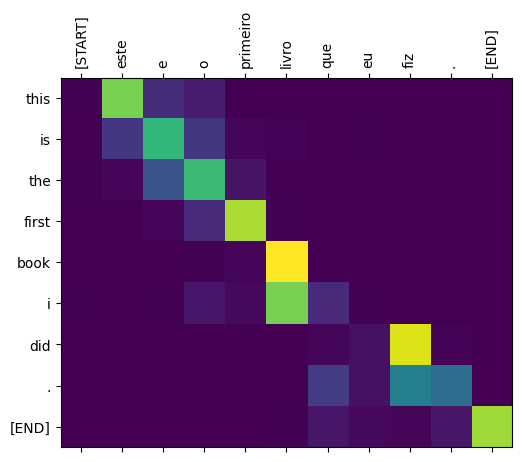

In [69]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [70]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

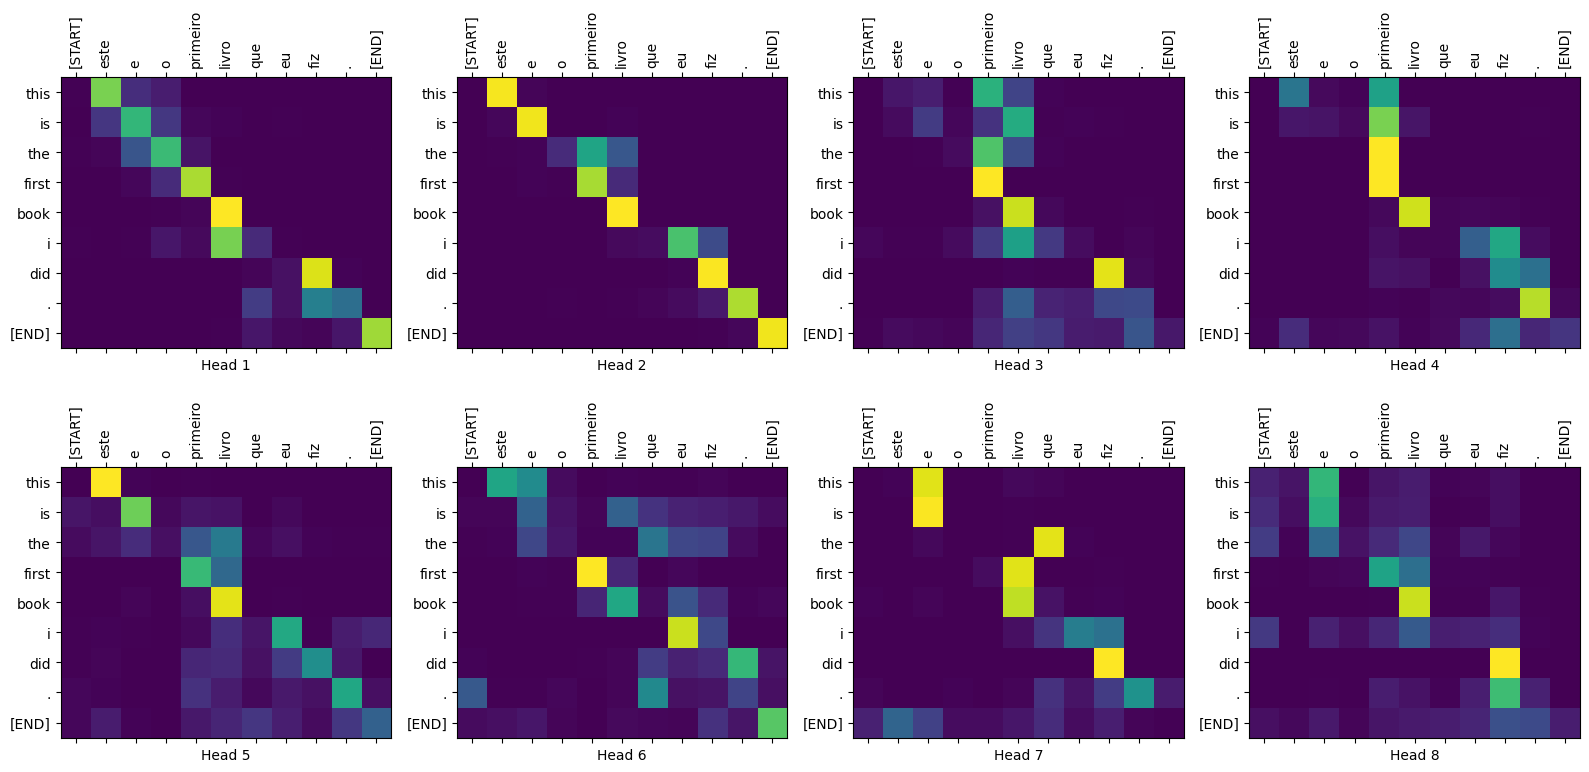

In [71]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

The model can handle unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model attempts to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trif walls in egypt .
Ground truth   : I read about triceratops in the encyclopedia.


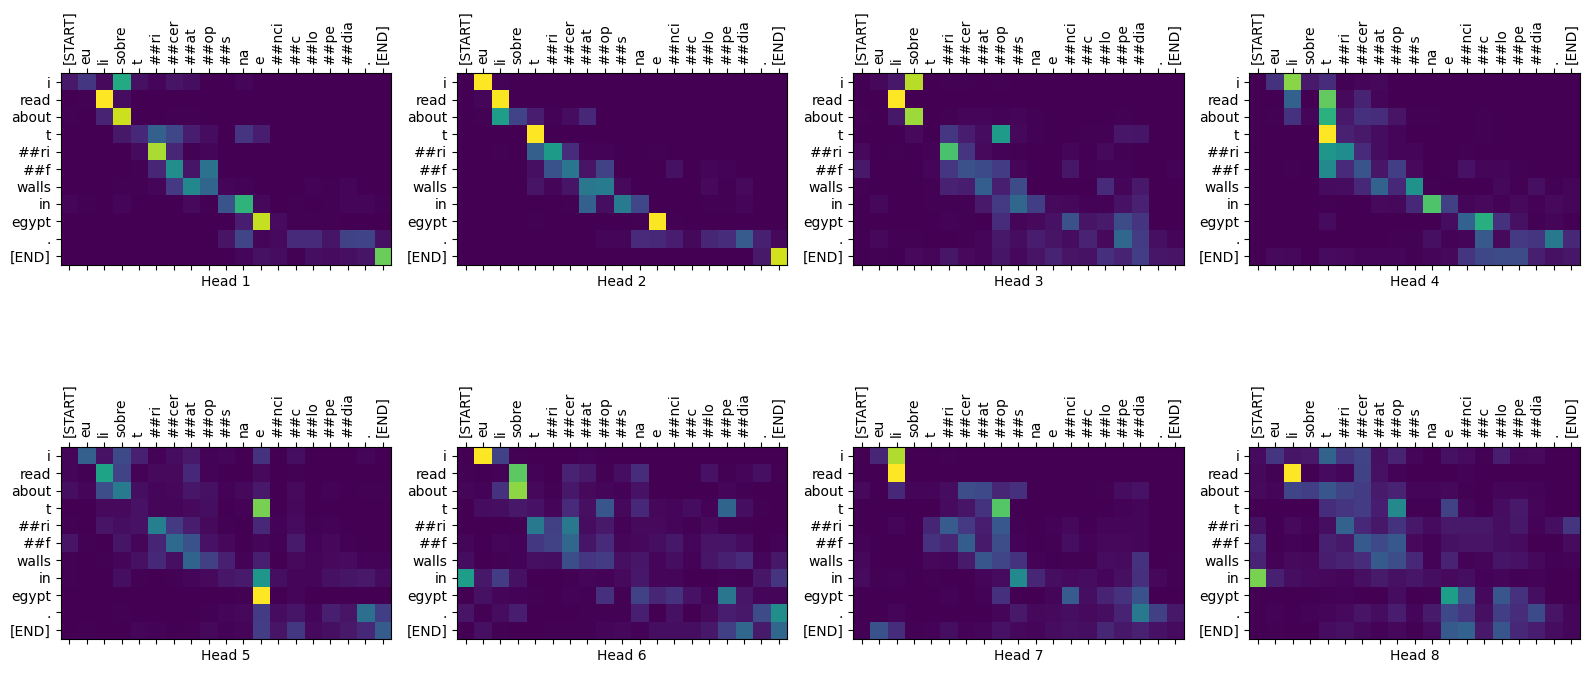

In [72]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens, attention_weights[0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [73]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [74]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [75]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [76]:
tf.saved_model.save(translator, export_dir='translator')

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


In [77]:
reloaded = tf.saved_model.load('translator')

In [78]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input has a temporal/spatial relationship, like text or images, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805)t beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022).
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
